<a href="https://colab.research.google.com/github/Ser9ibus/myStrArt/blob/main/myStrArt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import sys

# Invert grayscale image
def invertImage(image):
    return (255-image)

# Apply circular mask to image
def maskImage(image, radius):
    y, x = np.ogrid[-radius:radius + 1, -radius:radius + 1]
    mask = x**2 + y**2 > radius**2
    image[mask] = 0
    return image

# Compute coordinates of loom pins    
def pinCoords(radius, nPins=200, offset=0, x0=None, y0=None):
    alpha = np.linspace(0 + offset, 2*np.pi + offset, nPins + 1)

    if (x0 == None) or (y0 == None):
        x0 = radius + 1
        y0 = radius + 1

    coords = []
    for angle in alpha[0:-1]:
        x = int(x0 + radius*np.cos(angle))
        y = int(y0 + radius*np.sin(angle))

        coords.append((y, x))
    return coords

# Compute a line mask
def linePixels(pin0, pin1):
    length = int(np.hypot(pin1[0] - pin0[0], pin1[1] - pin0[1]))

    x = np.linspace(pin0[1], pin1[1], length)
    y = np.linspace(pin0[0], pin1[0], length)

    return (x.astype(np.int)-1, y.astype(np.int)-1)

In [17]:
imgPath = 'StrArt_t1.bmp'

# Parameters
imgRadius = 100     # Number of pixels that the image radius is resized to

initPin = 0         # Initial pin to start threading from
numPins = 200       # Number of pins on the circular loom
numLines = 1000     # Maximal number of lines

minLoop = 3         # Disallow loops of less than minLoop lines
lineWidth = 3       # The number of pixels that represents the width of a thread
lineWeight = 15     # The weight a single thread has in terms of "darkness"

In [3]:
import os
if os.path.exists(imgPath):
  # Load image
  image = cv2.imread(imgPath)
  print(image.shape)

(210, 200, 3)


In [4]:
# Crop image
height, width = image.shape[0:2]
minEdge= min(height, width)
topEdge = int((height - minEdge)/2)
leftEdge = int((width - minEdge)/2)
imgCropped = image[topEdge:topEdge+minEdge, leftEdge:leftEdge+minEdge]
cv2.imwrite('./cropped.png', imgCropped)

# Convert to grayscale
imgGray = cv2.cvtColor(imgCropped, cv2.COLOR_BGR2GRAY)
cv2.imwrite('./gray.png', imgGray)

# Resize image
imgSized = cv2.resize(imgGray, (2*imgRadius + 1, 2*imgRadius + 1)) 

# Invert image
imgInverted = invertImage(imgSized)
cv2.imwrite('./inverted.png', imgInverted)

# Mask image
imgMasked = maskImage(imgInverted, imgRadius)
cv2.imwrite('./masked.png', imgMasked)

True

In [5]:
# Define pin coordinates
coords = pinCoords(imgRadius, numPins)
height, width = imgMasked.shape[0:2]

# image result is rendered to
imgResult = 255 * np.ones((height, width))
#print(imgResult)

# Initialize variables
i = 0
lines = []
previousPins = []
oldPin = initPin
lineMask = np.zeros((height, width))
#print(lineMask)

<ipython-input-11-52e2f0faa52d>:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (x.astype(np.int)-1, y.astype(np.int)-1)


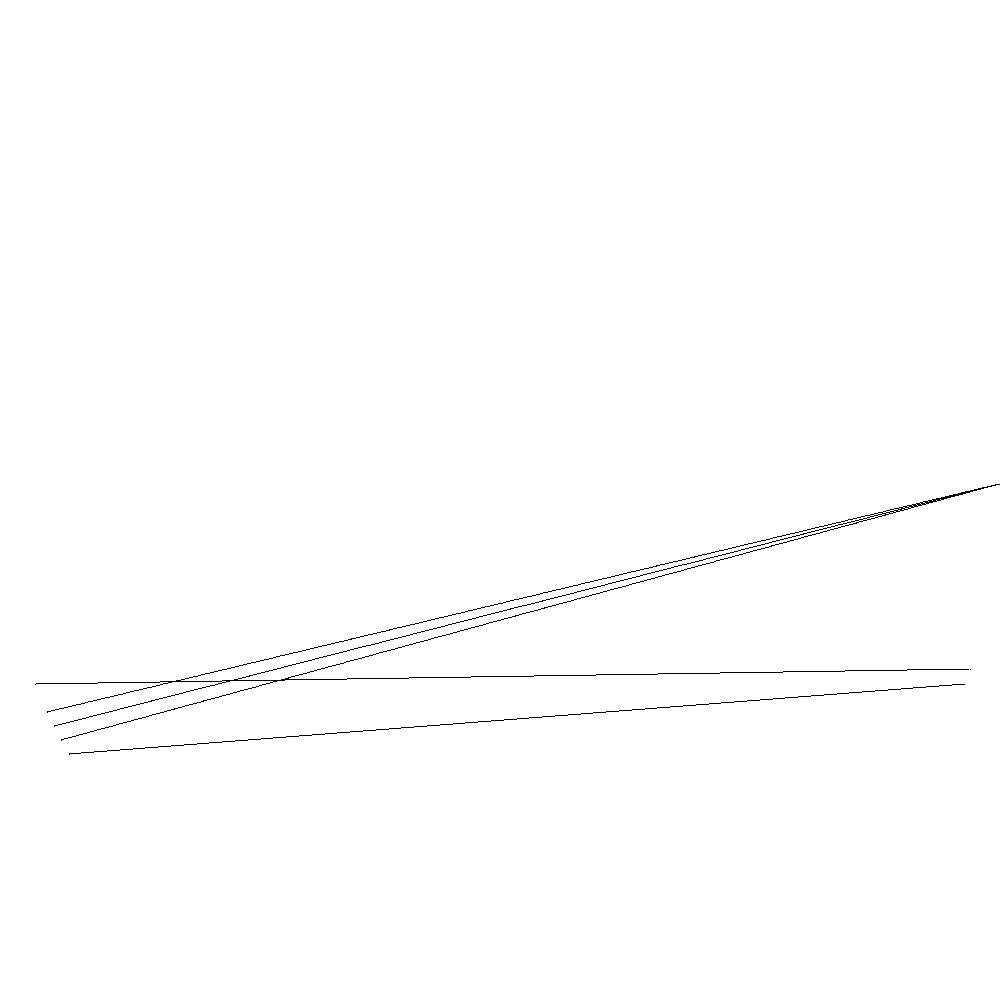

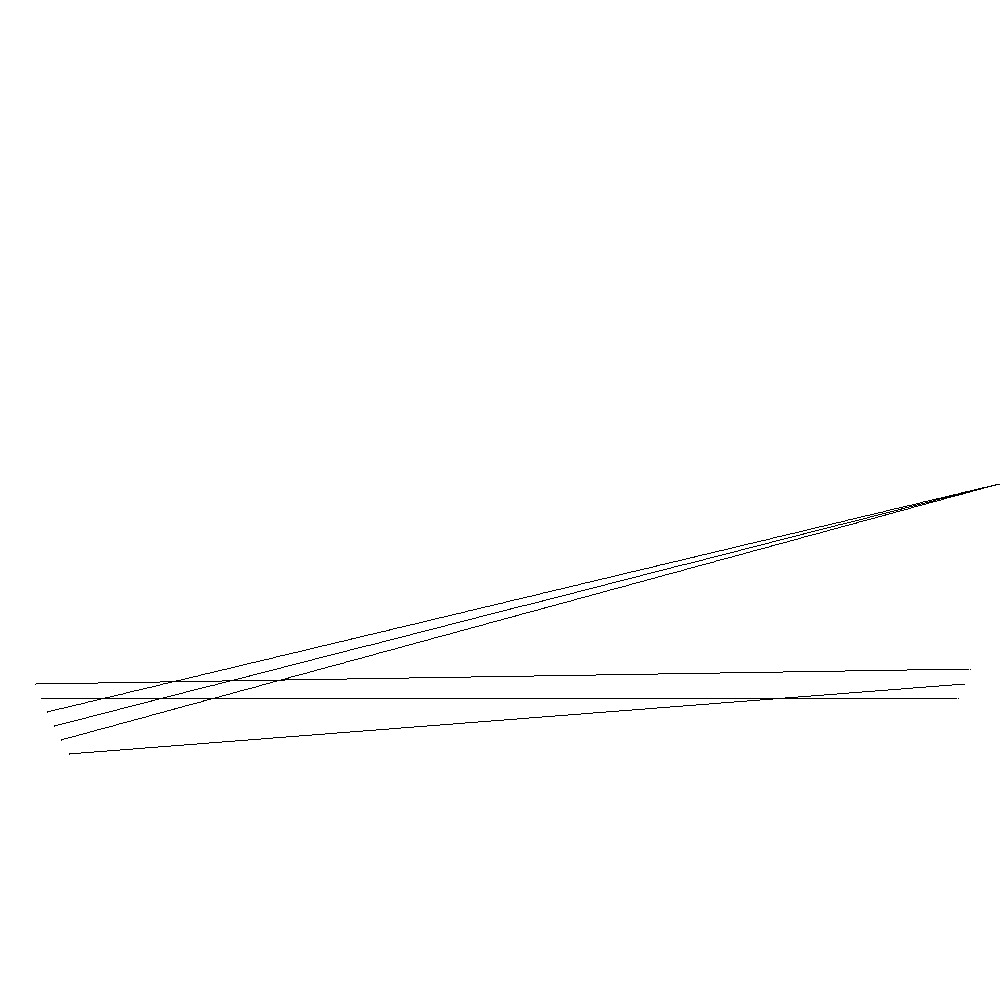

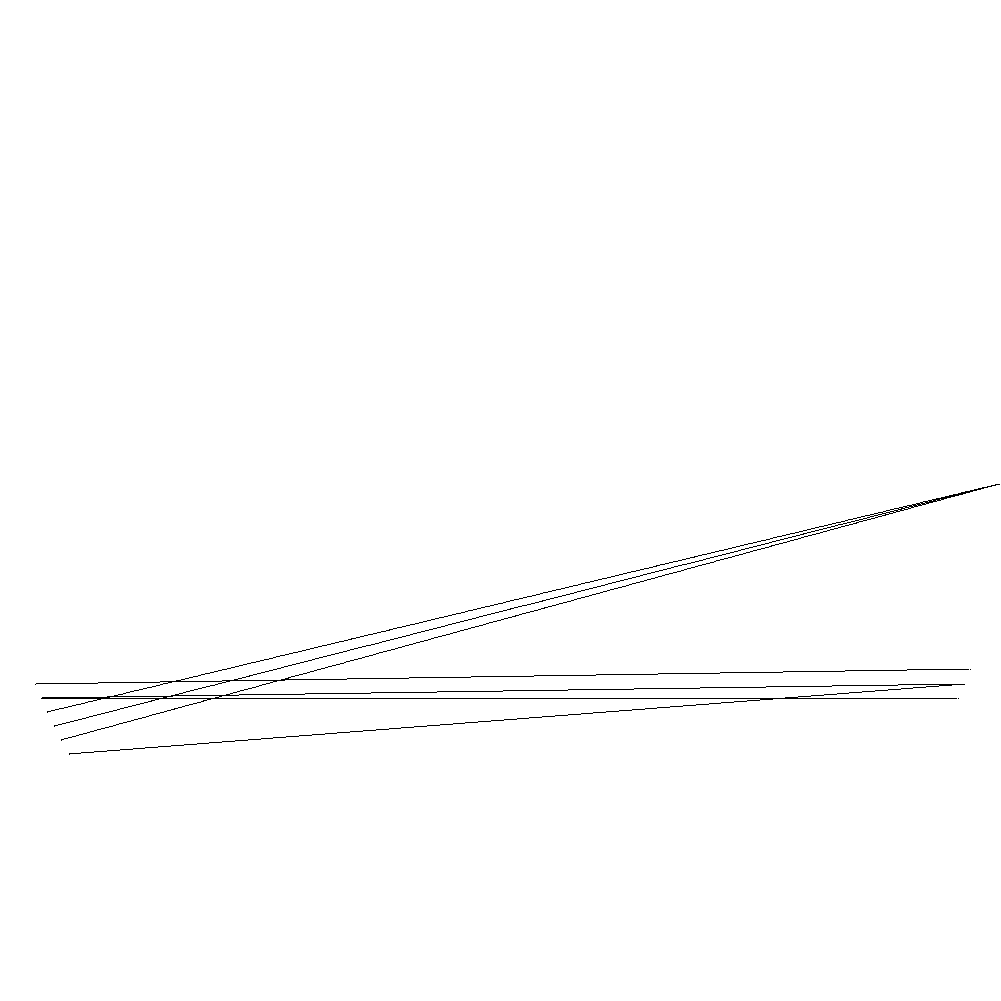

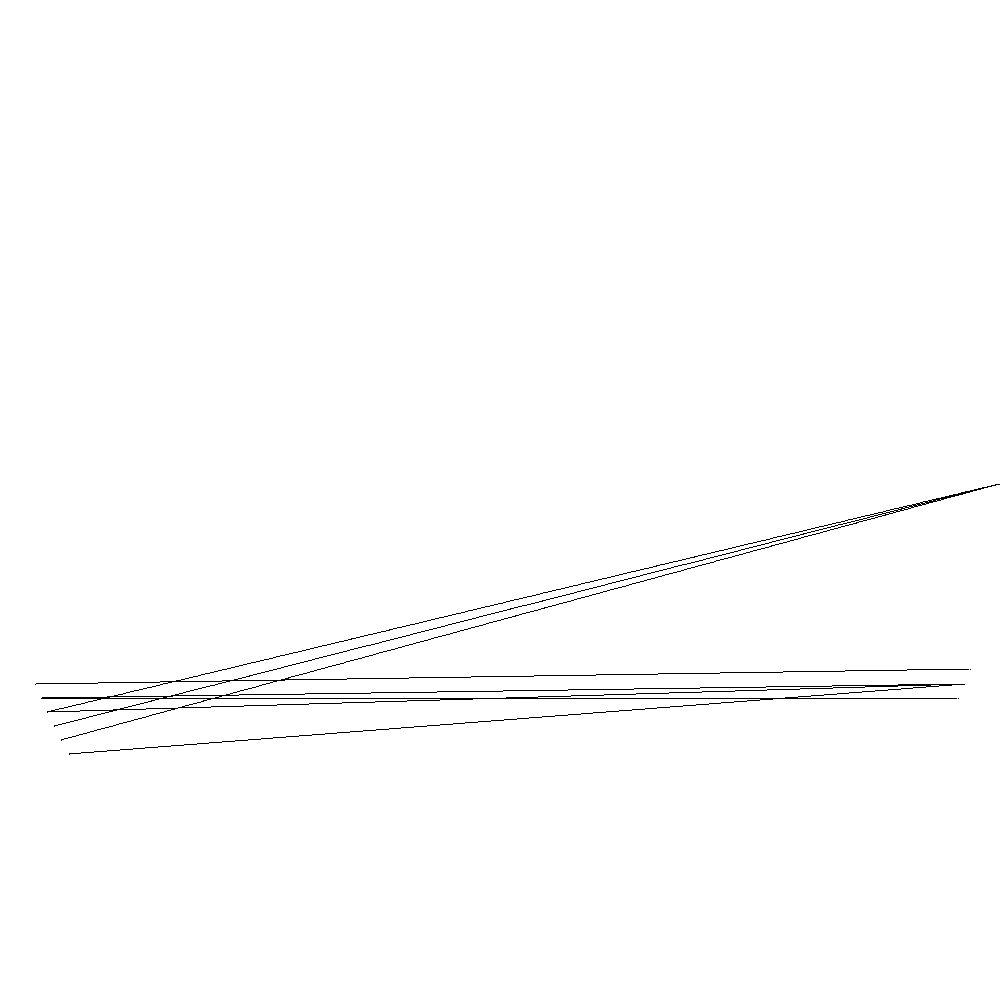

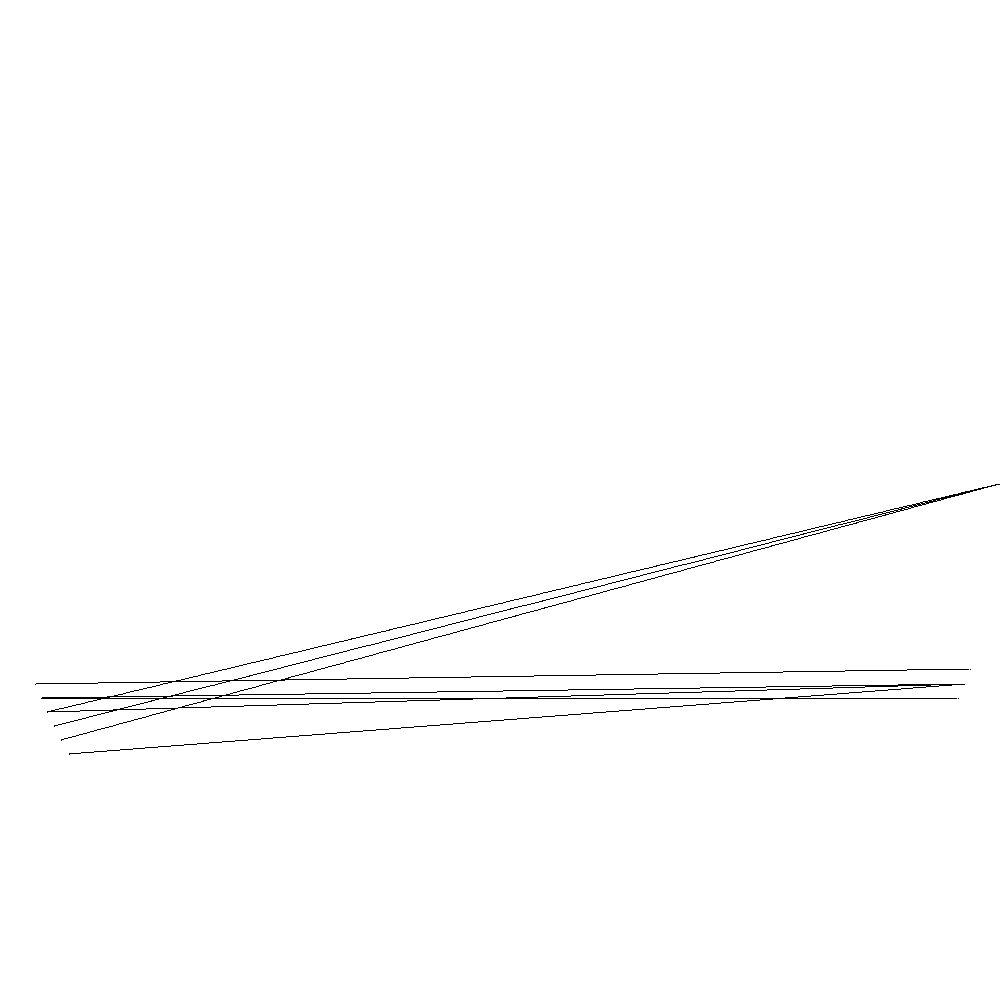

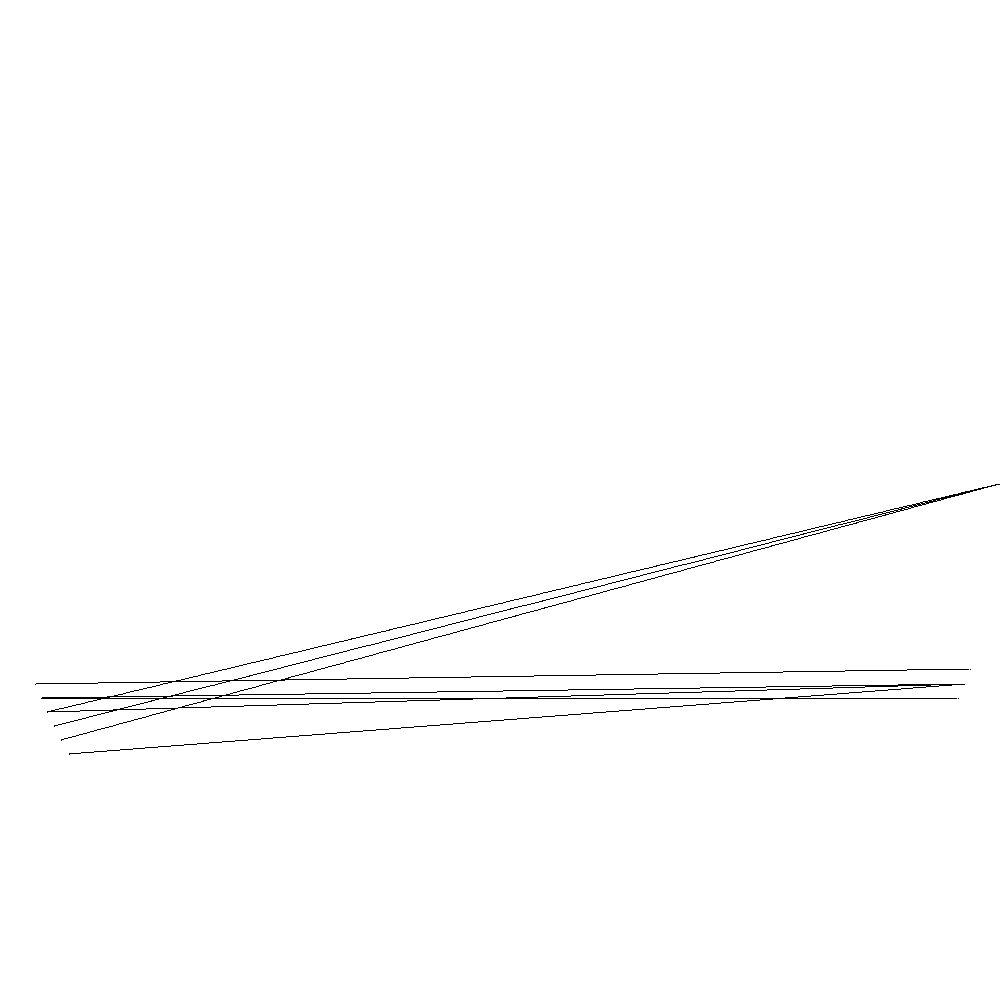

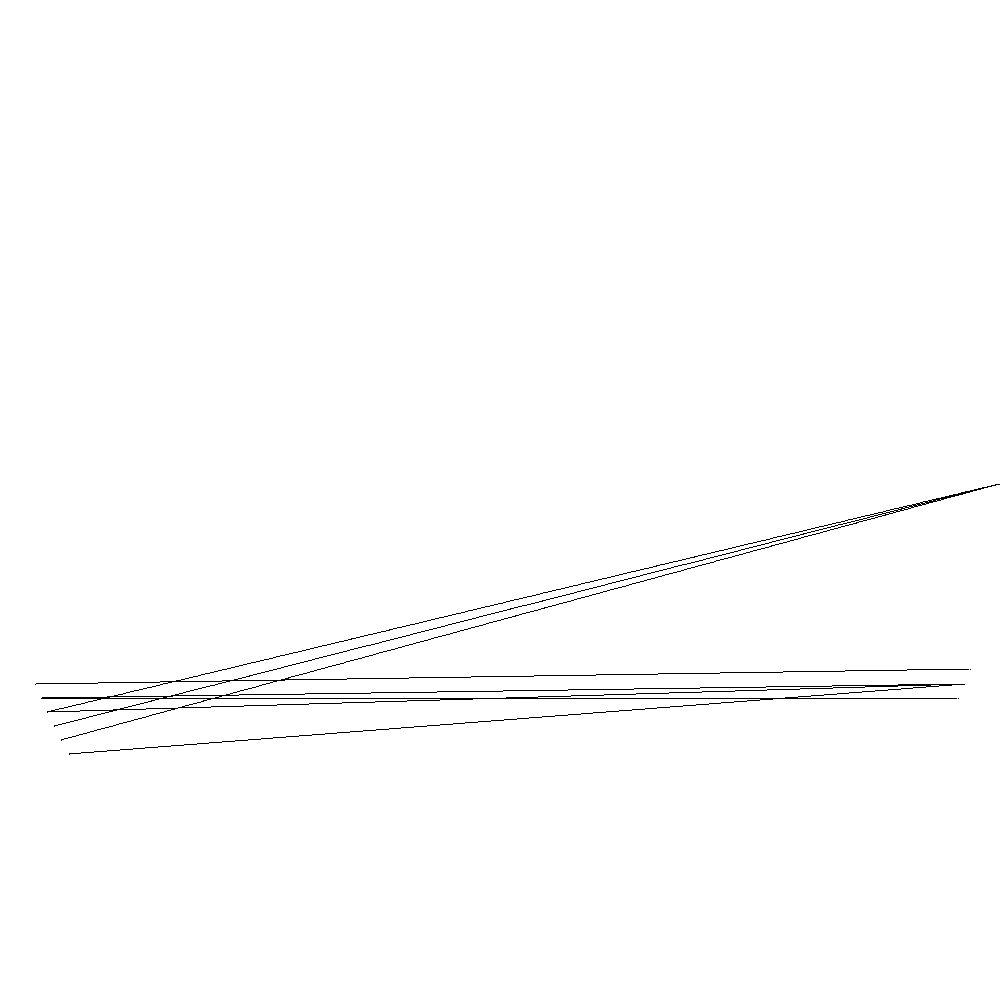

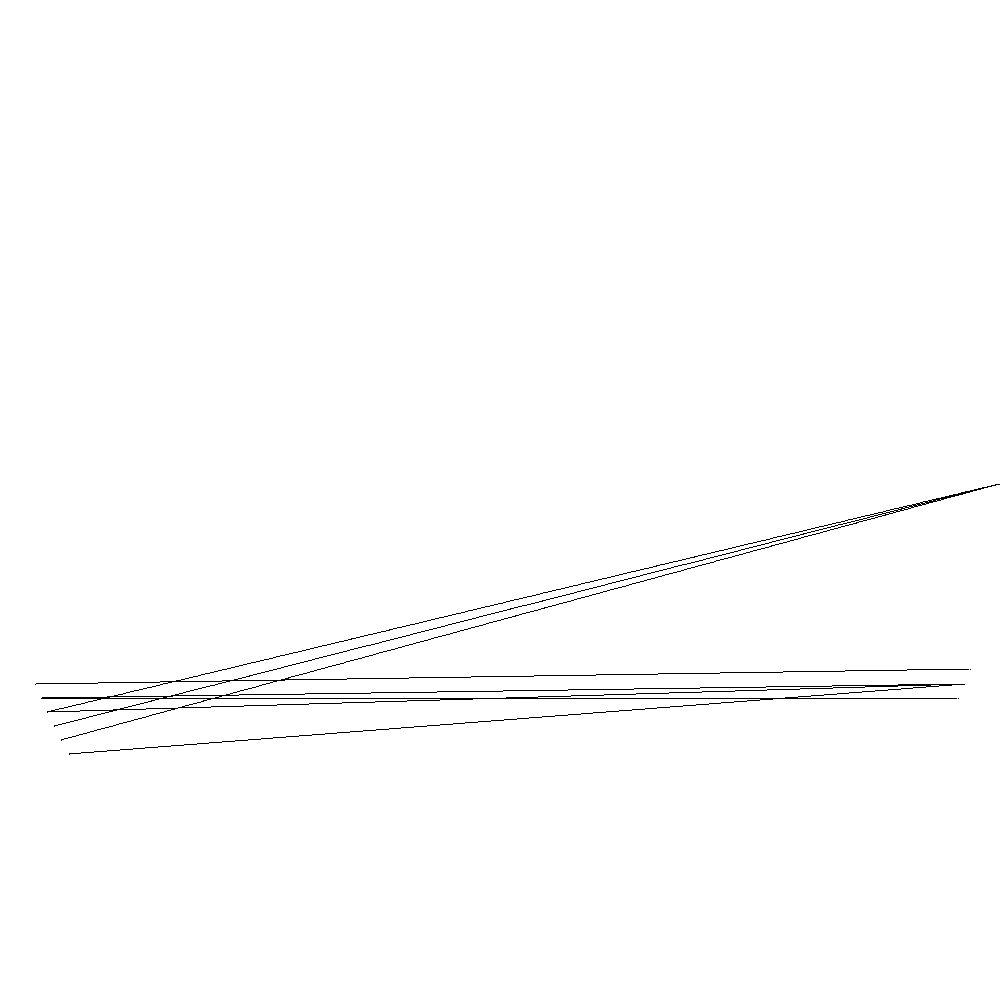

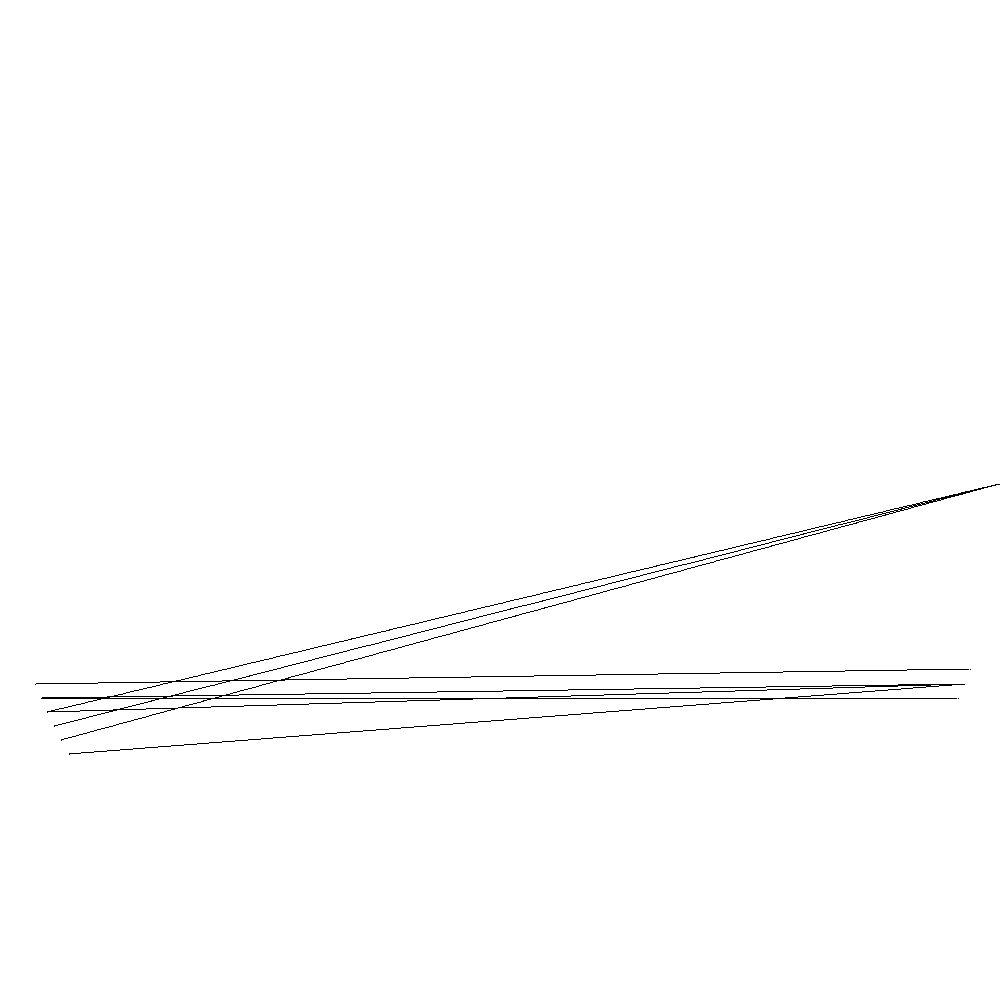

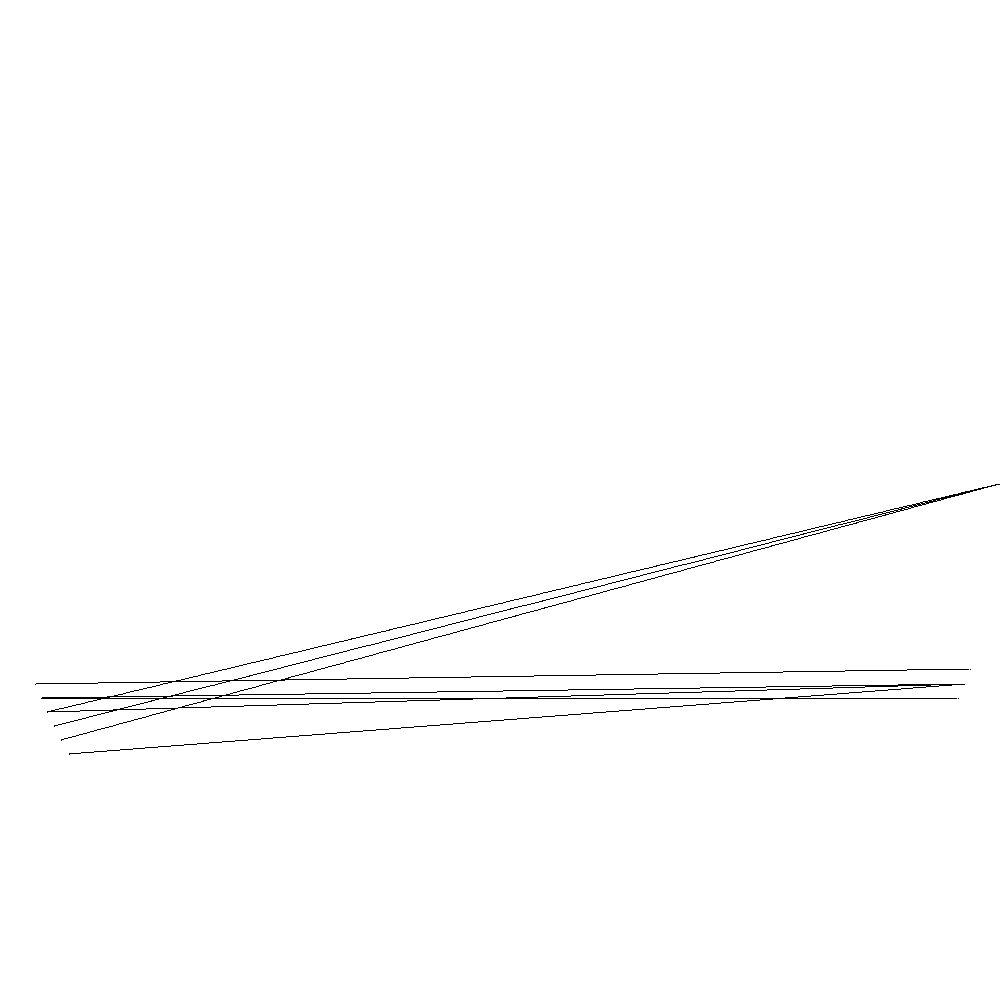

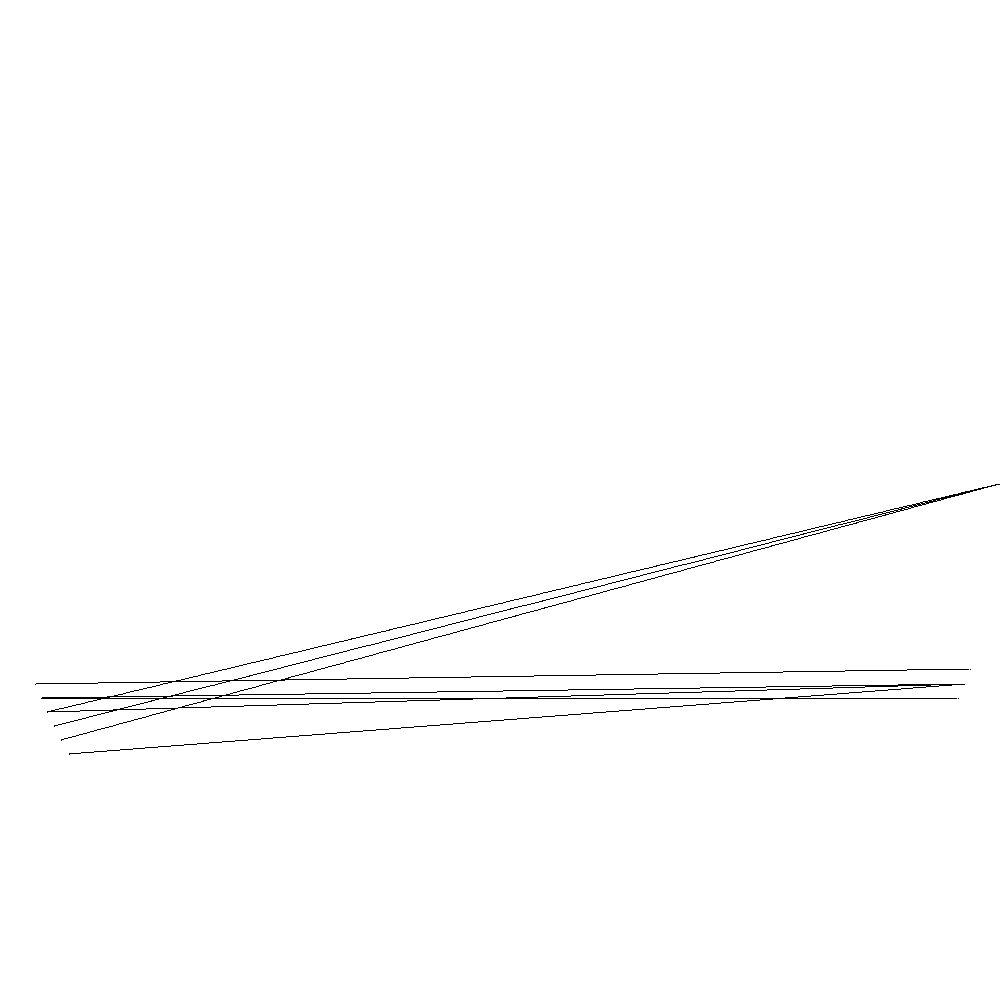

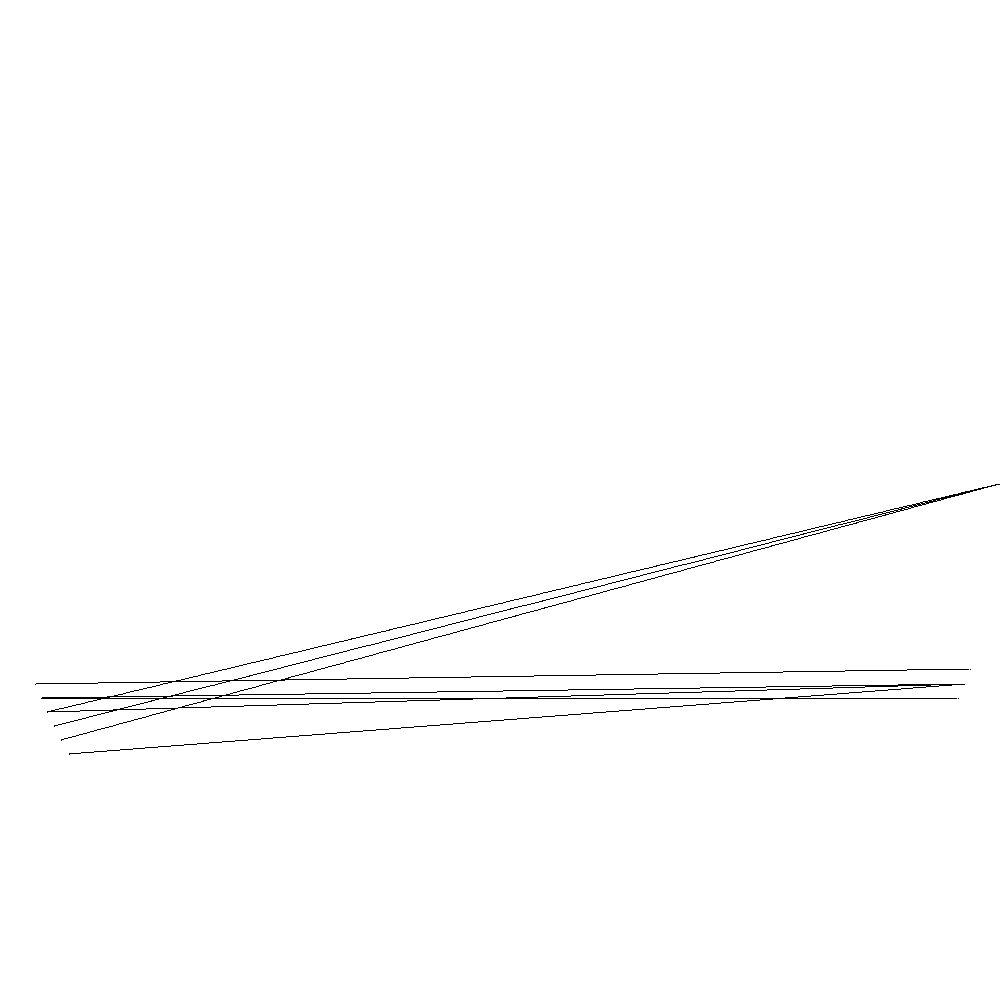

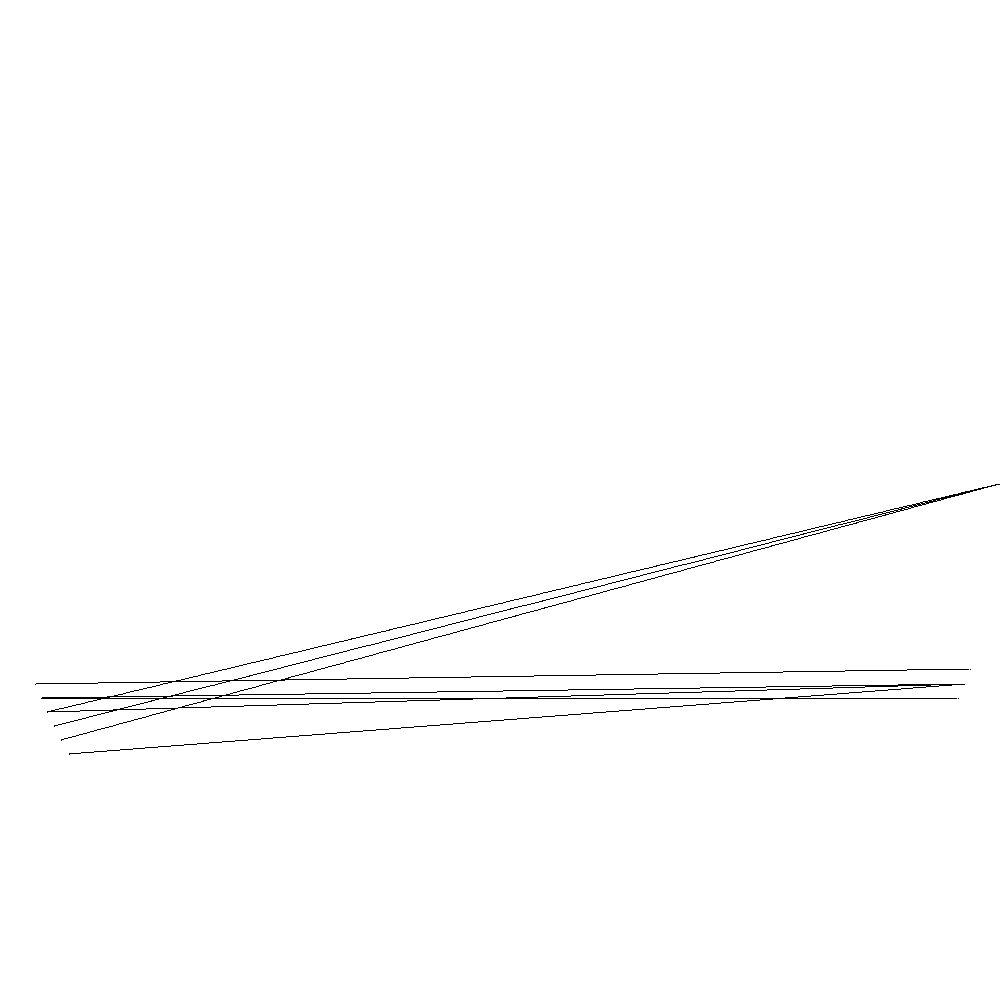

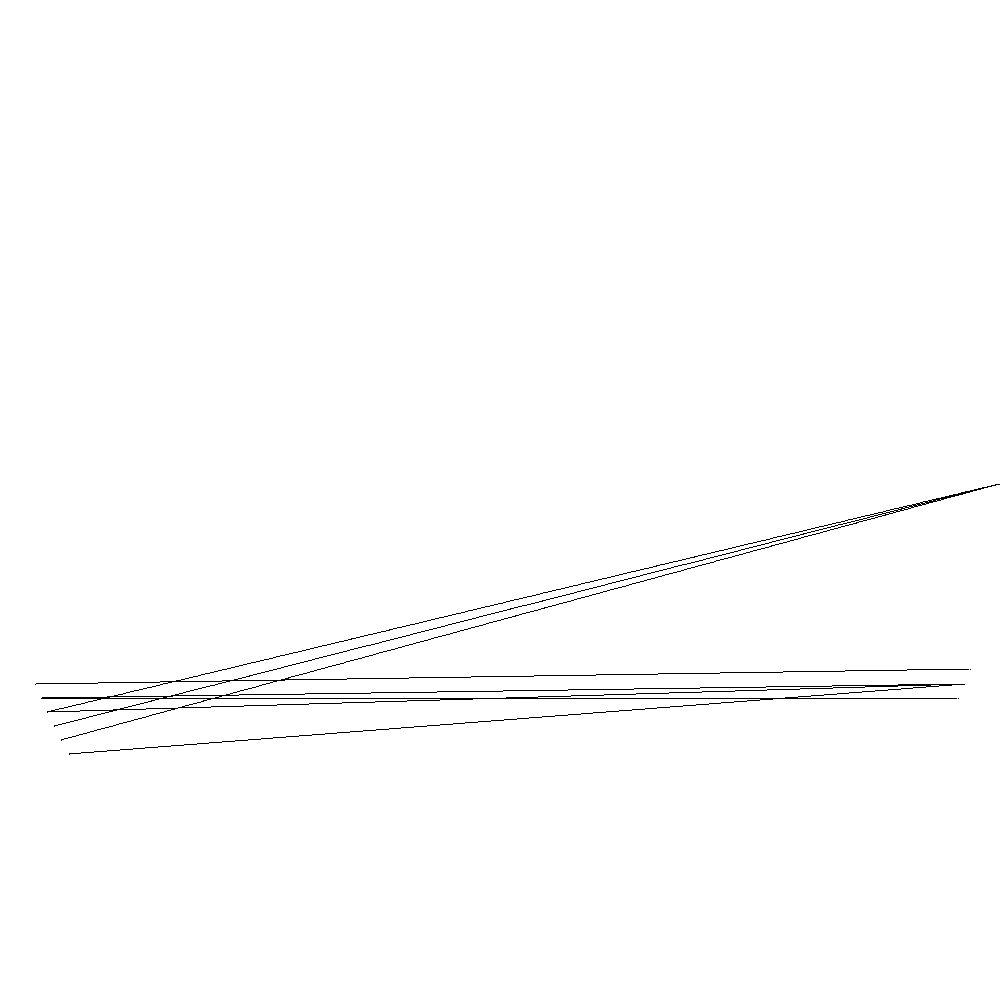

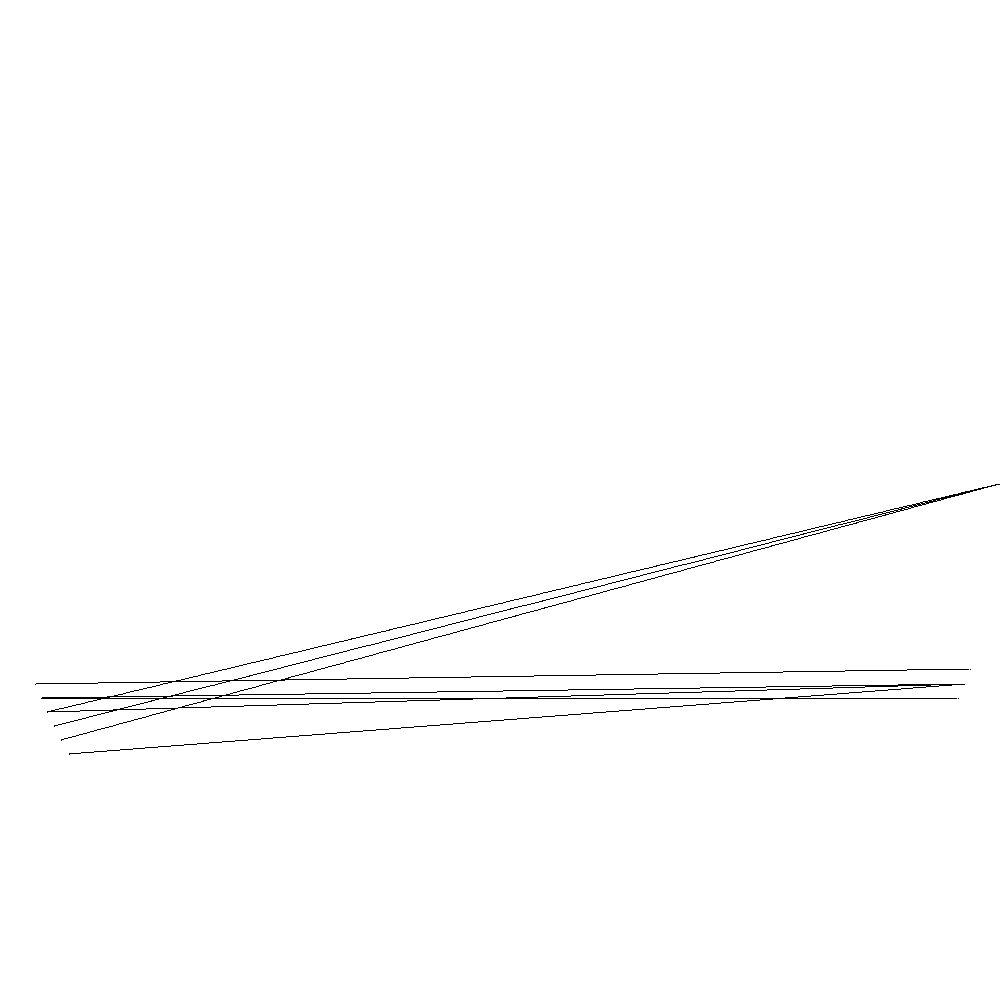

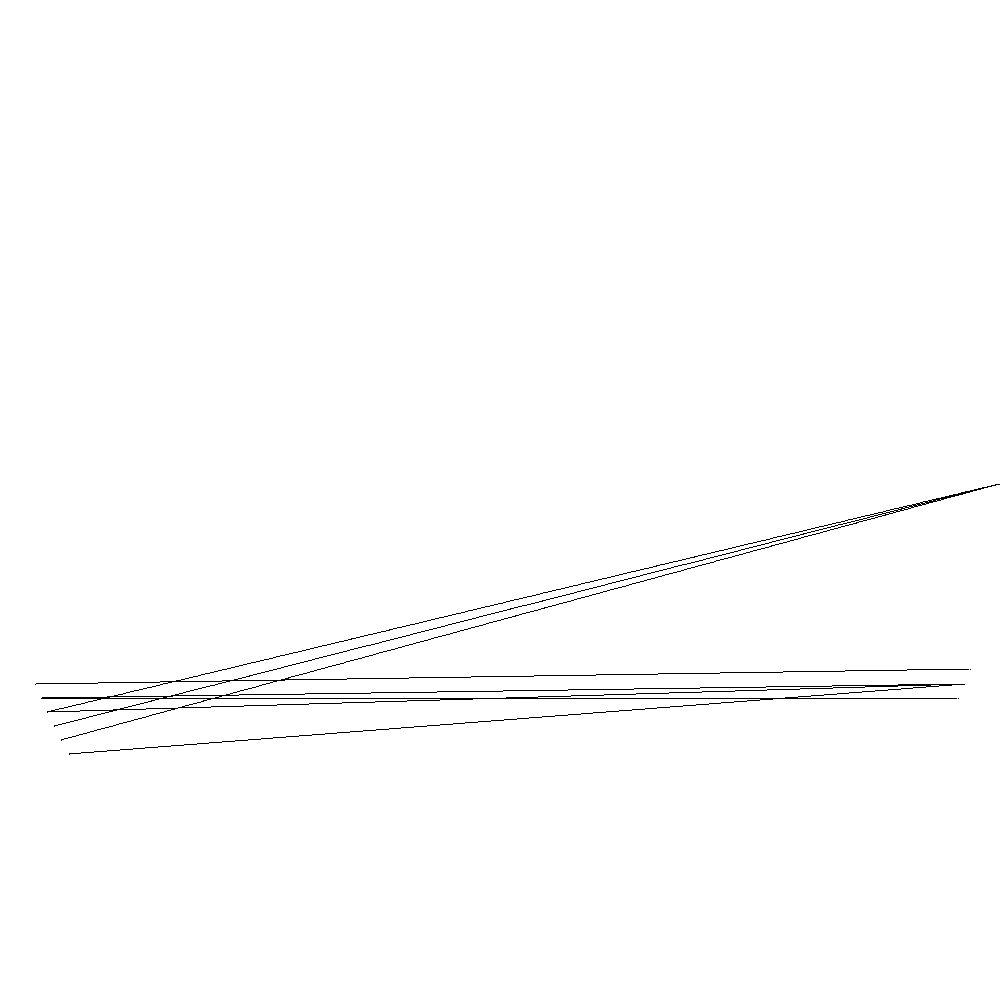

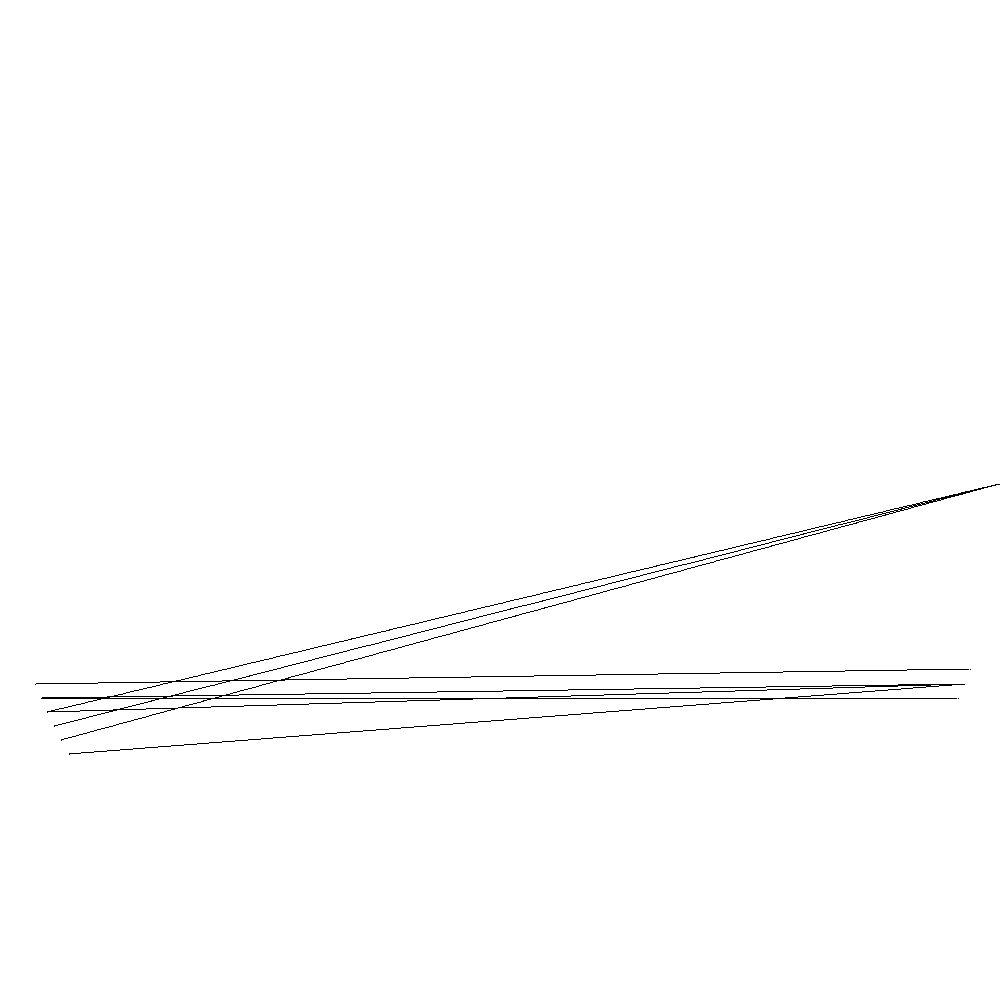

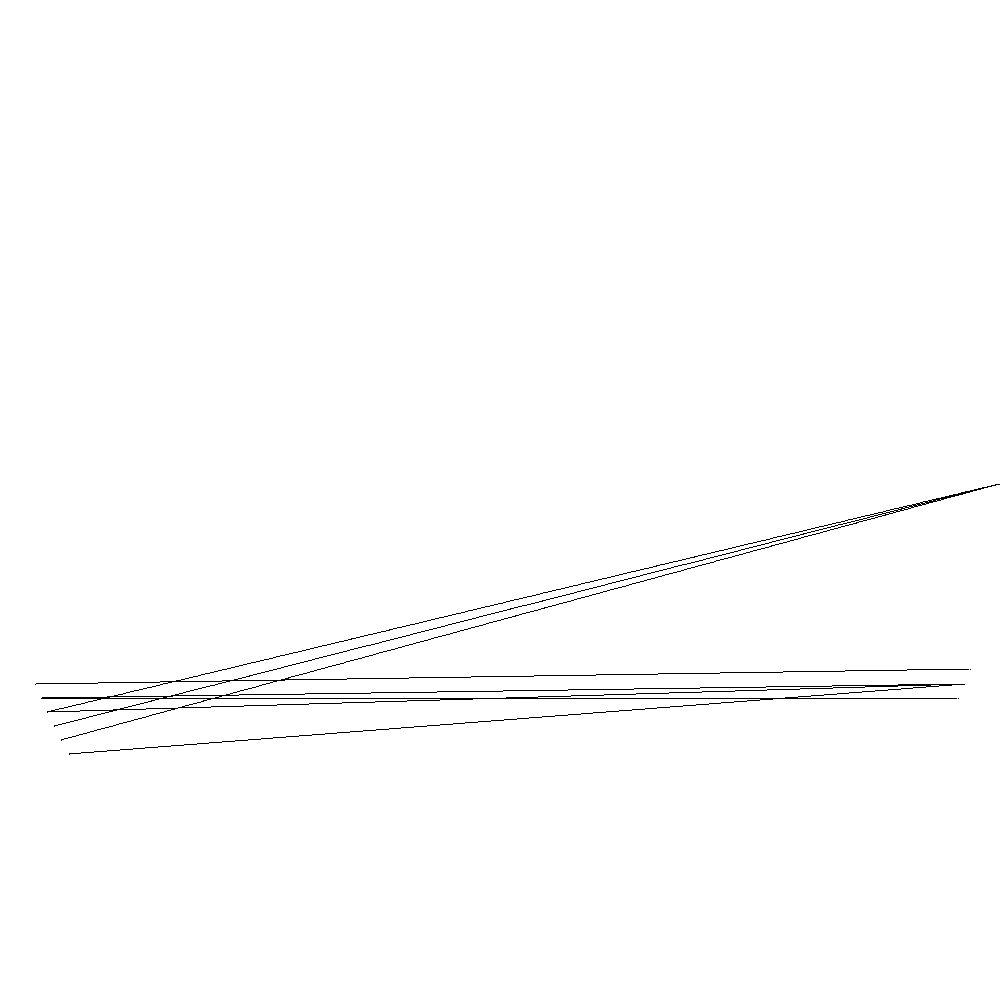

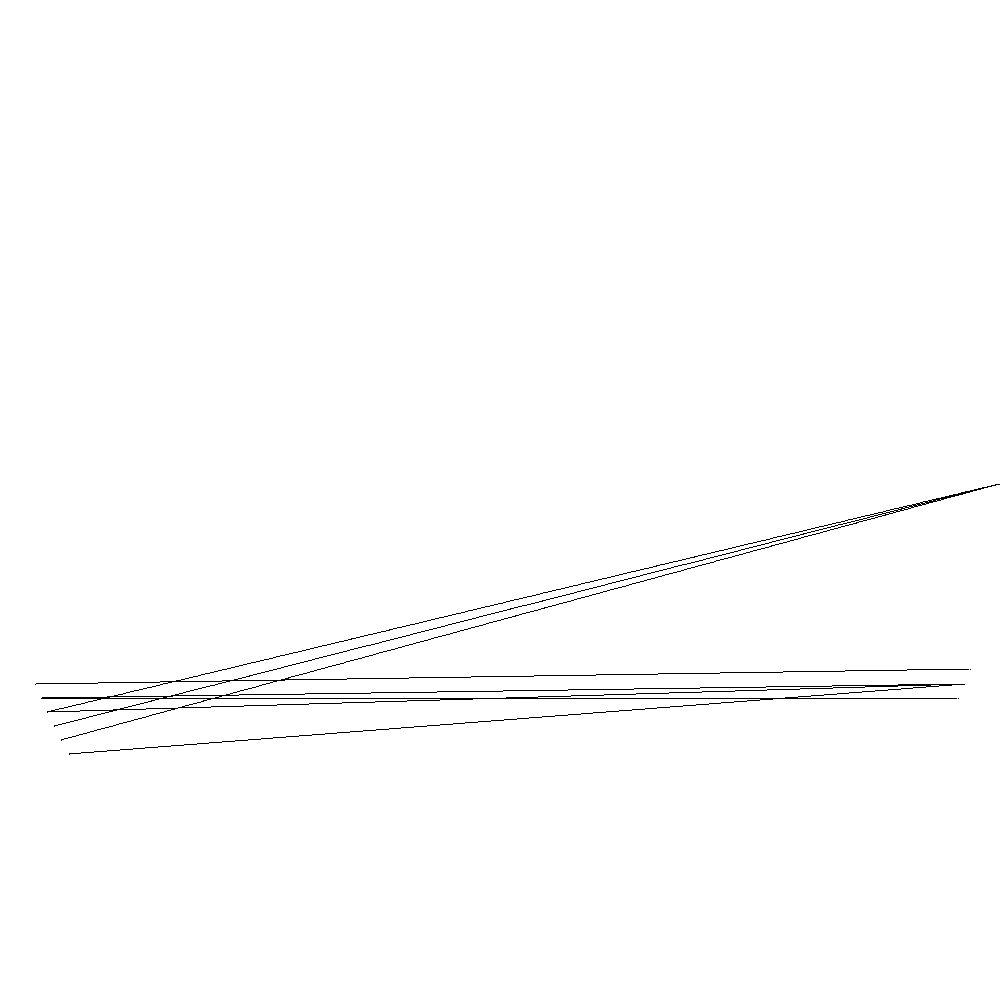

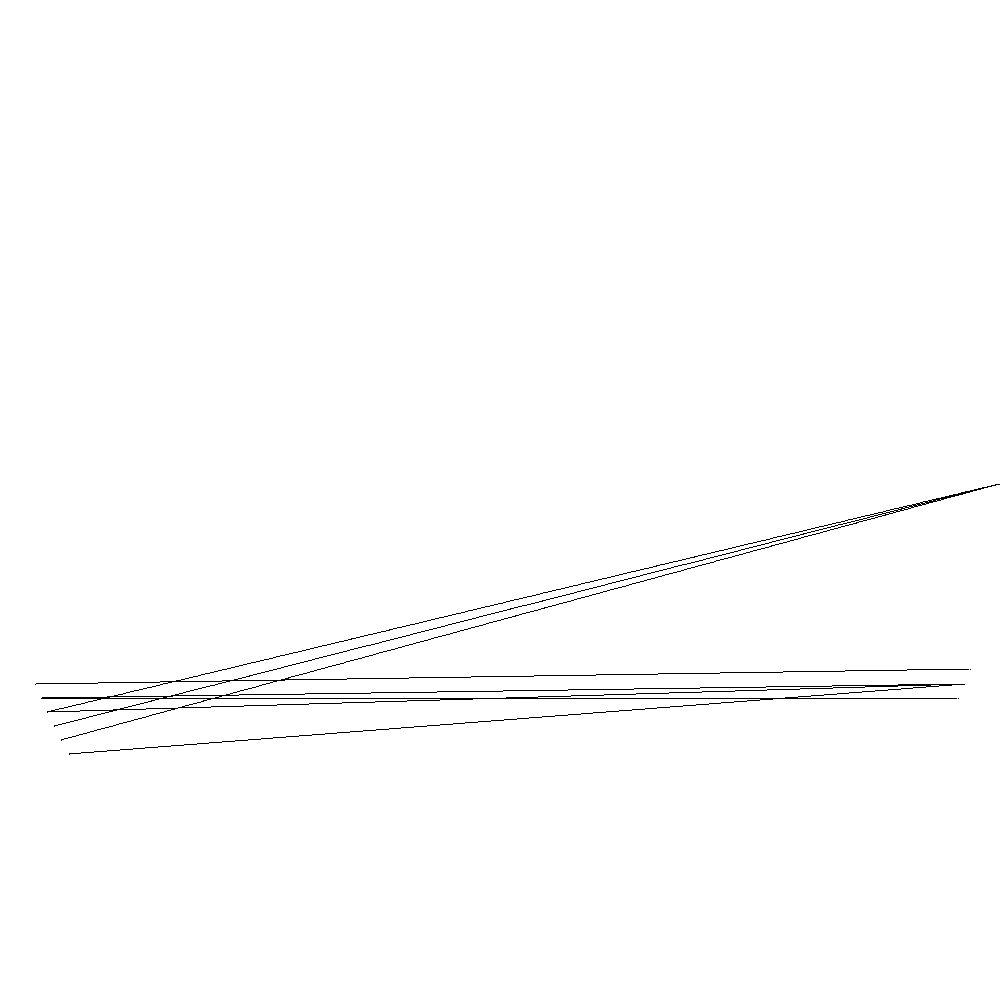

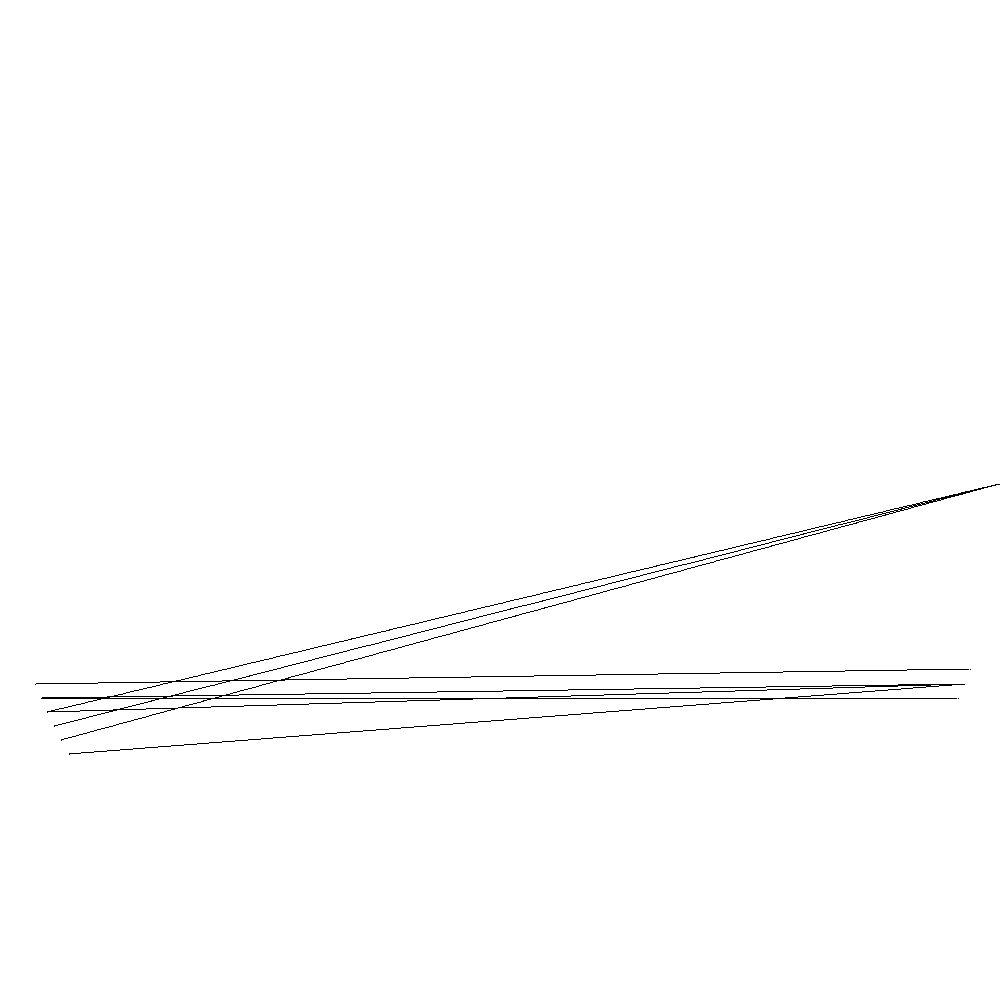

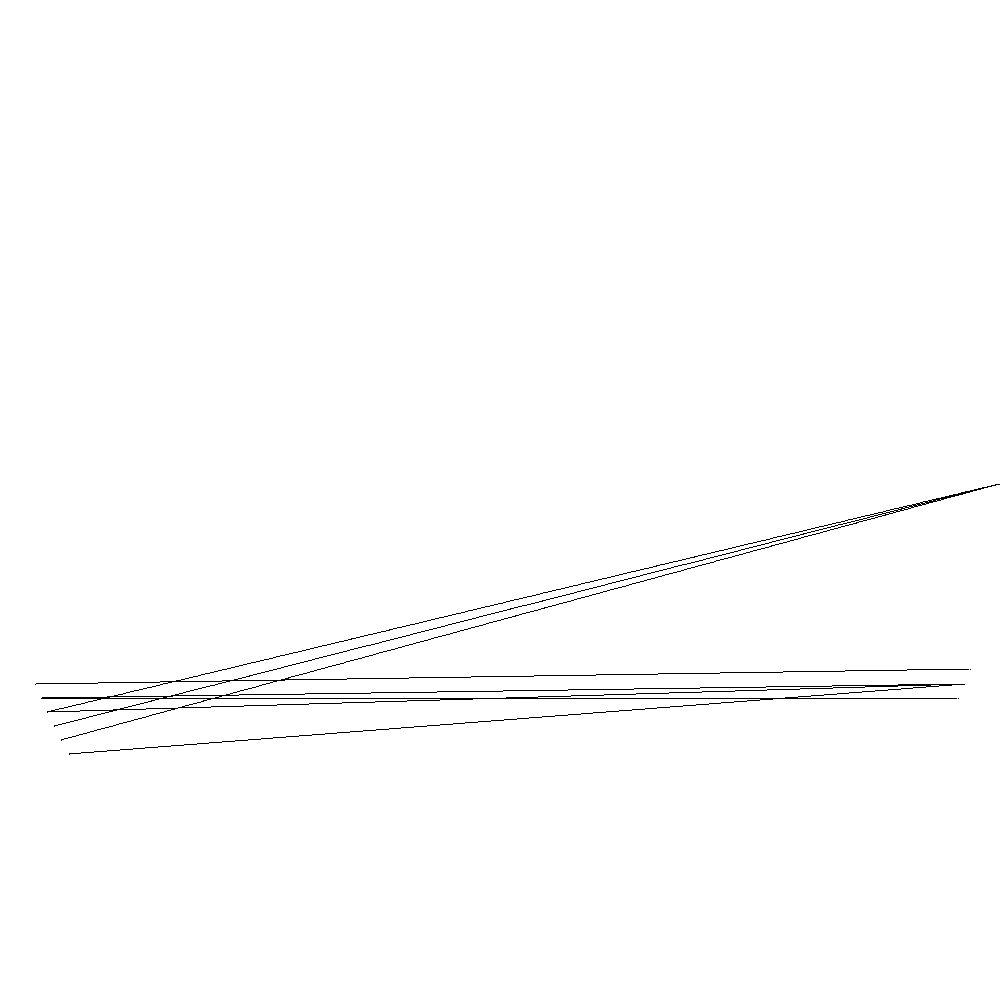

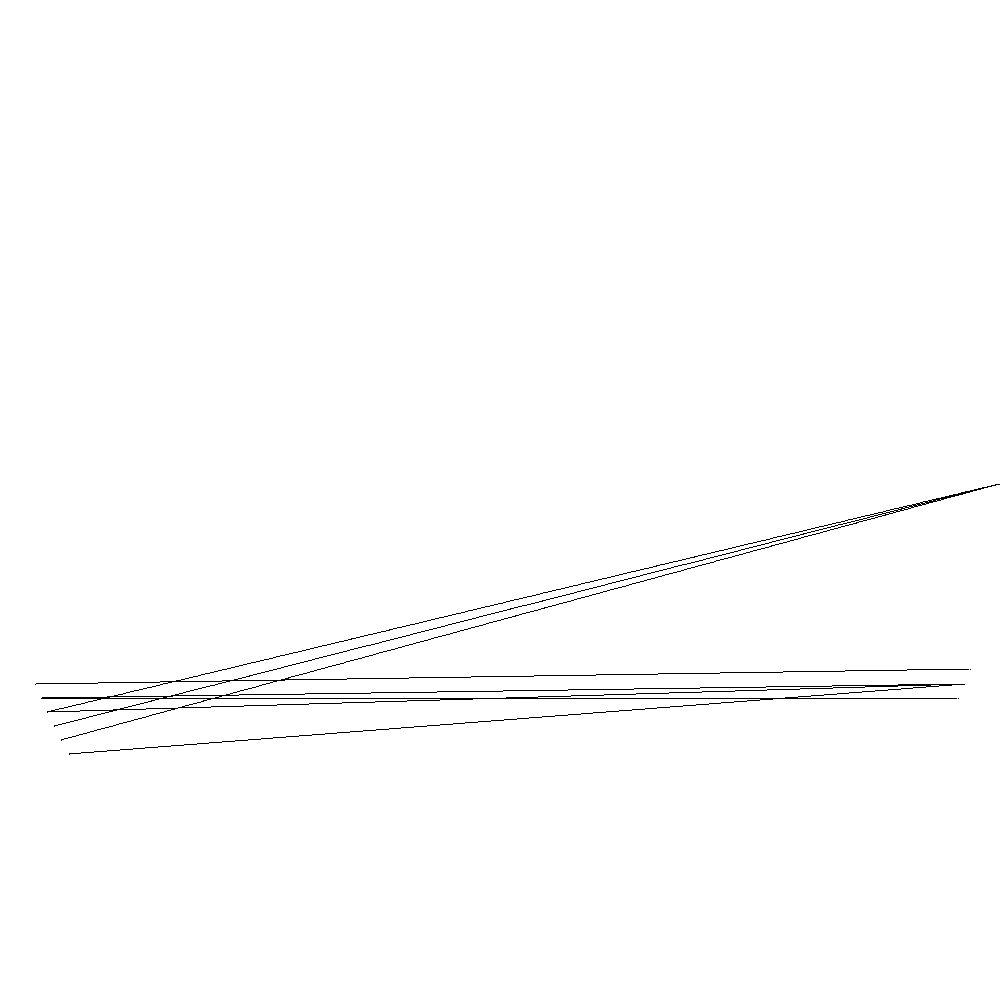

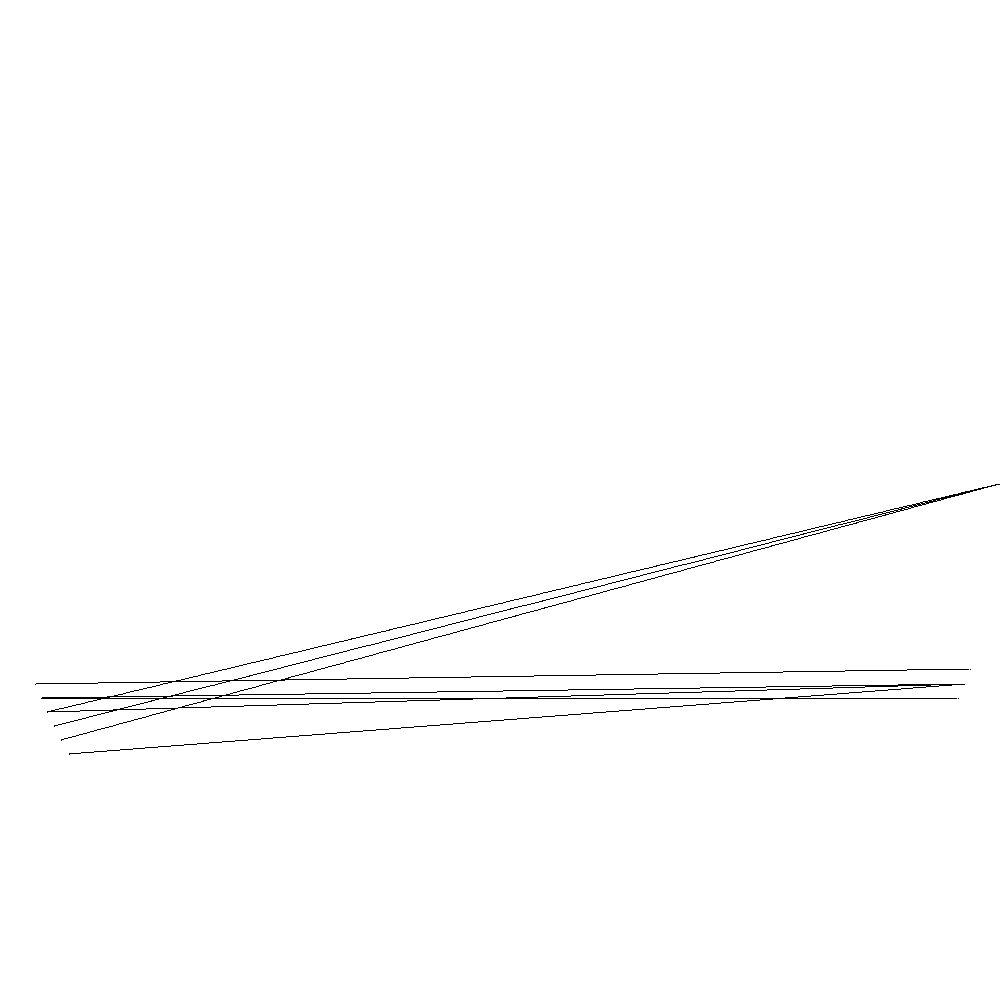

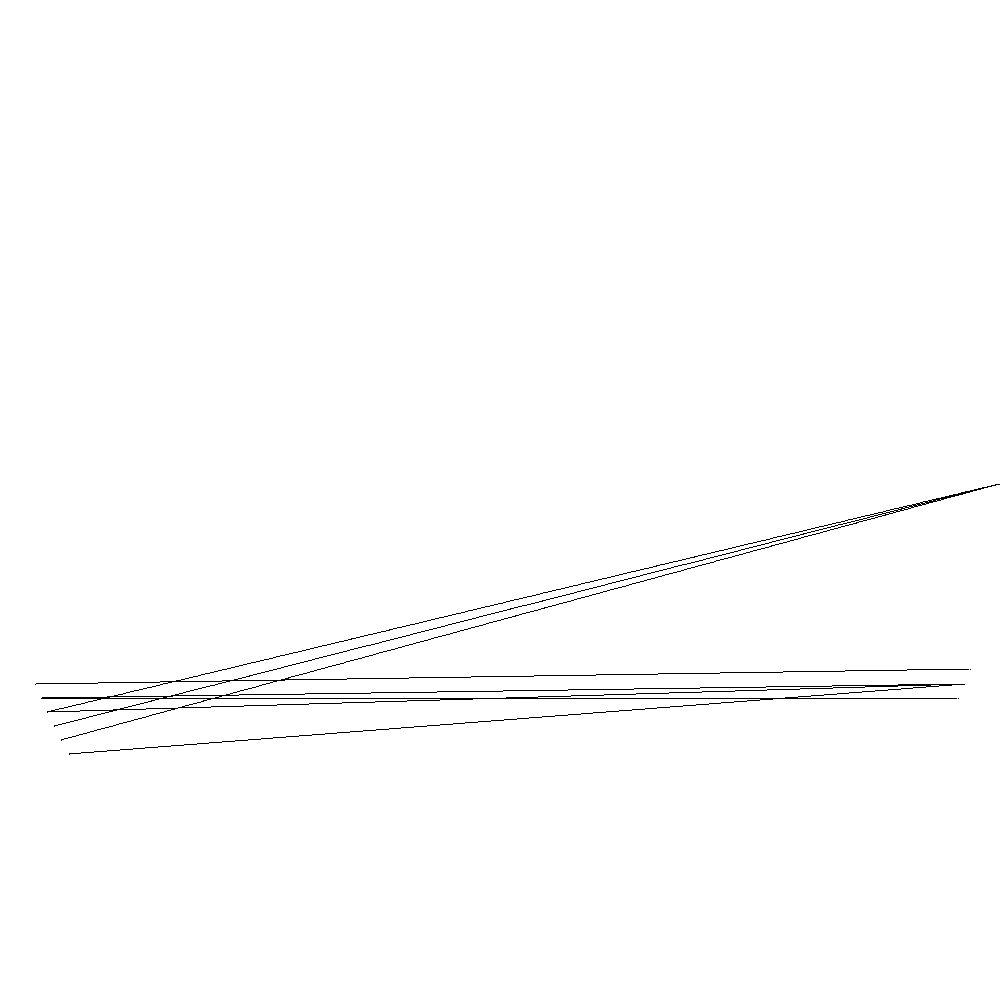

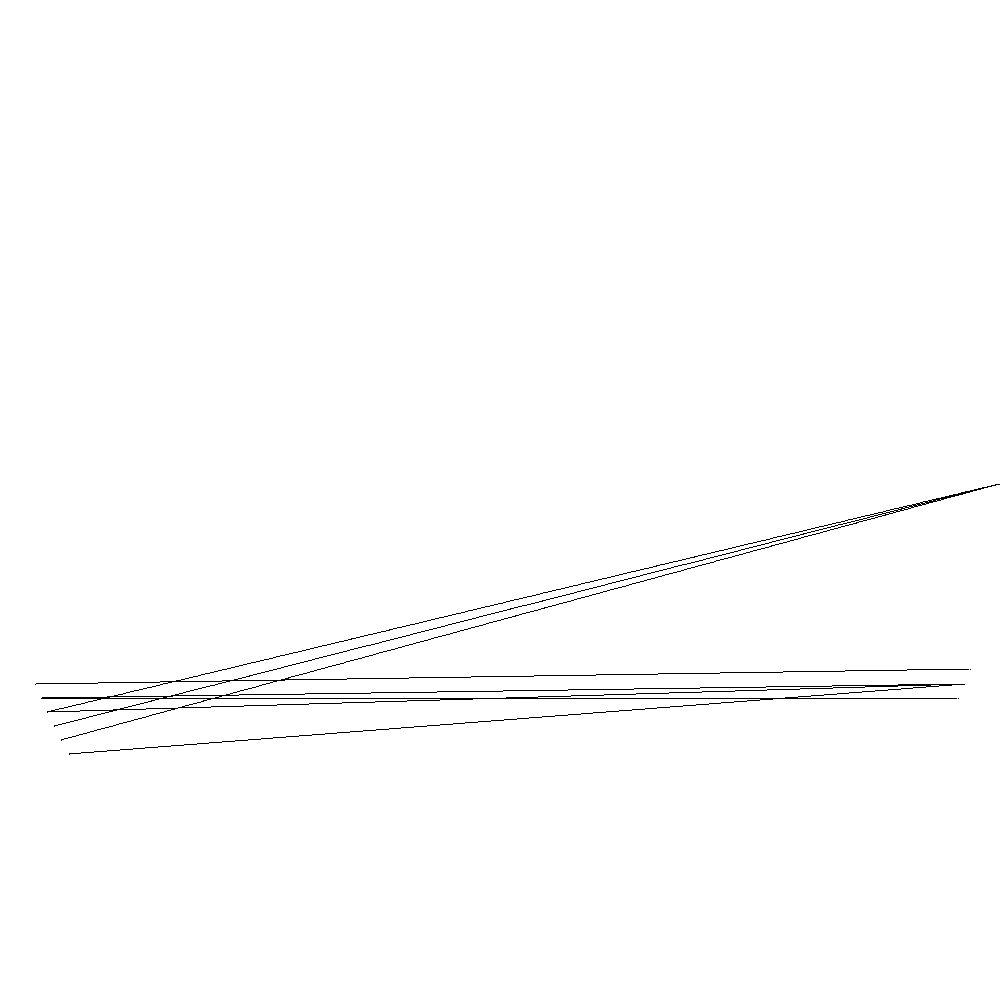

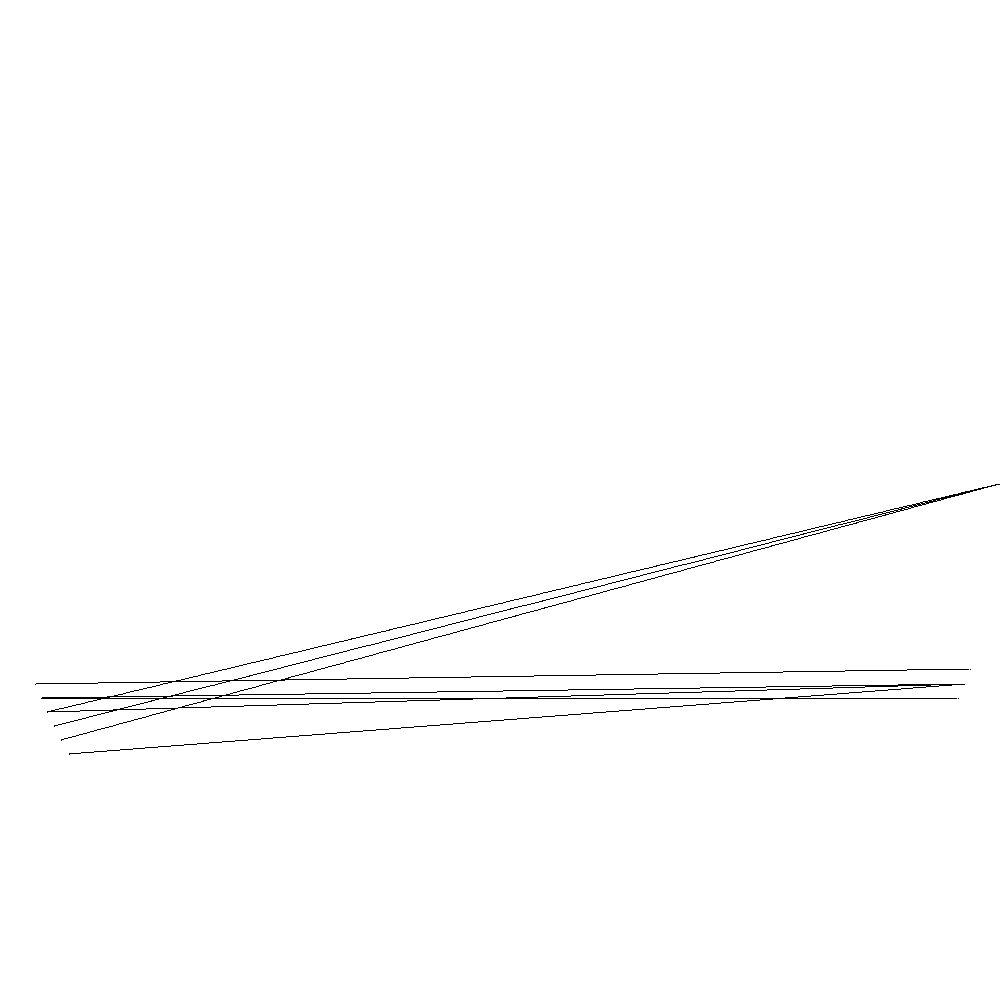

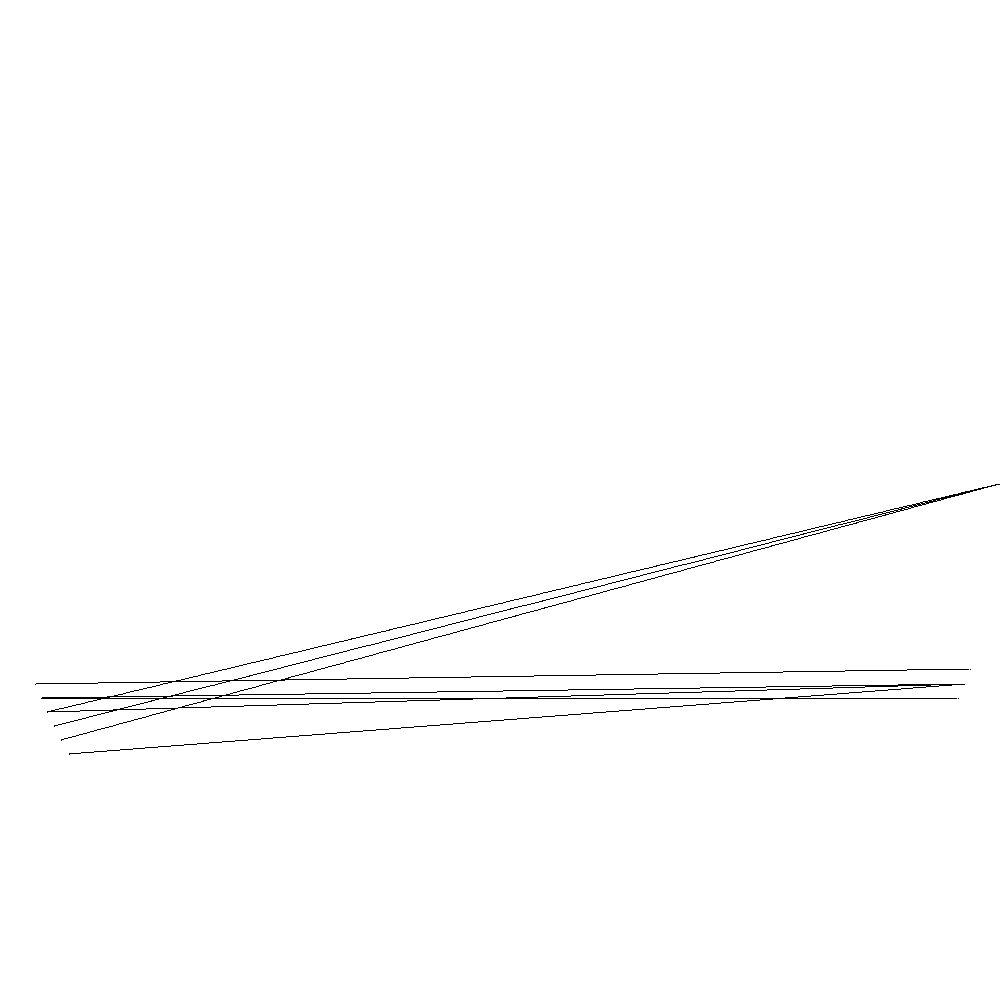

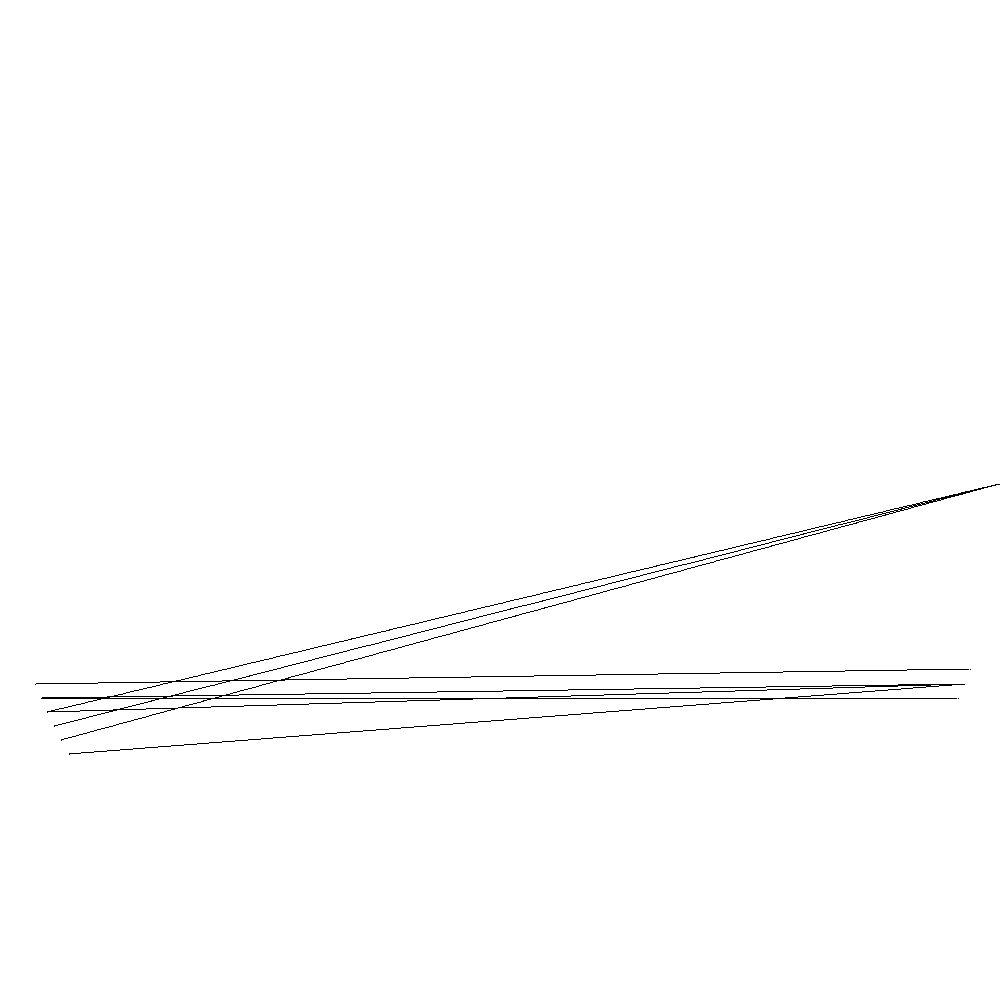

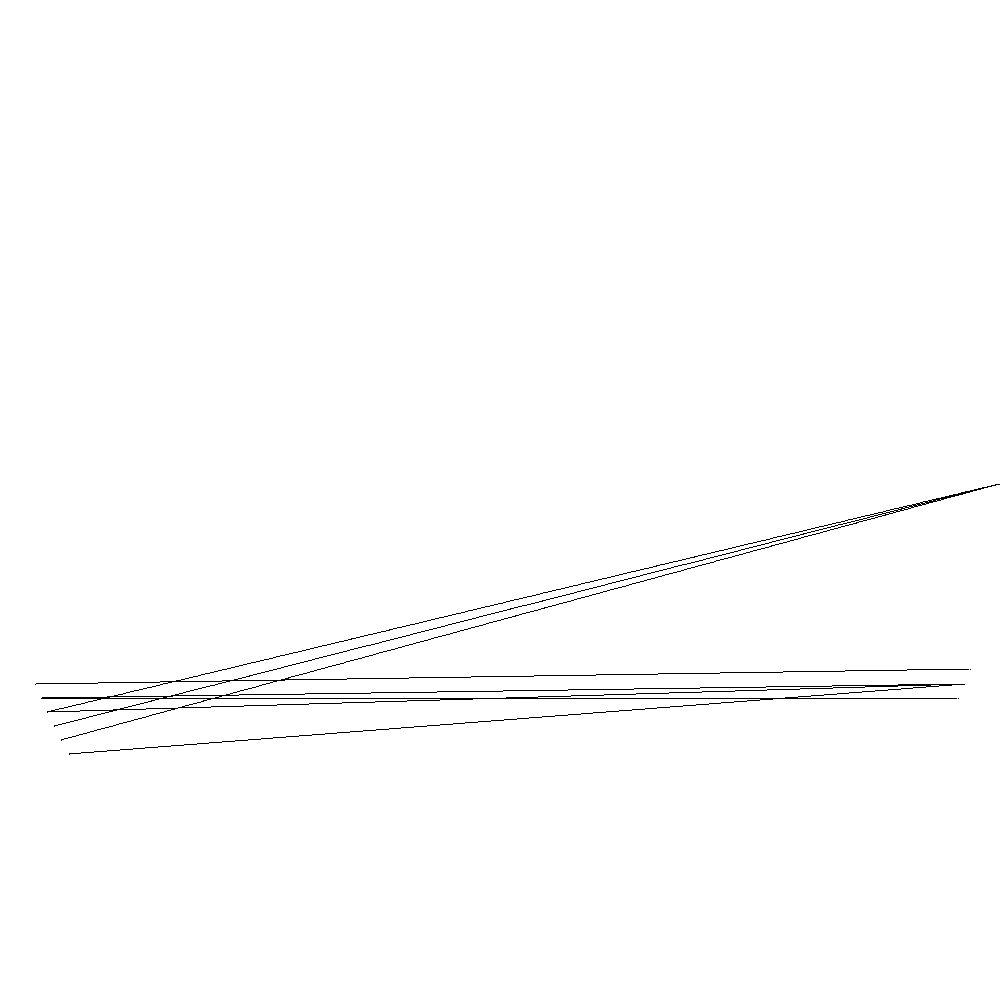

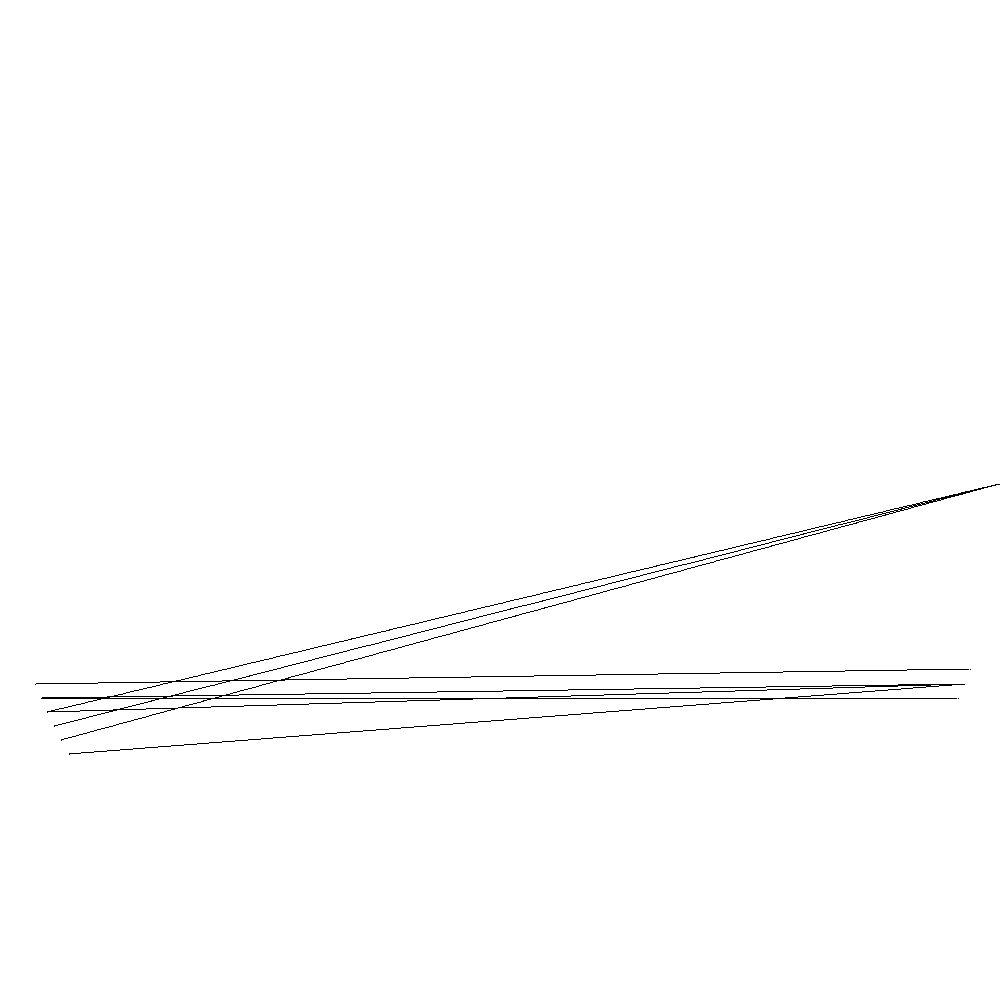

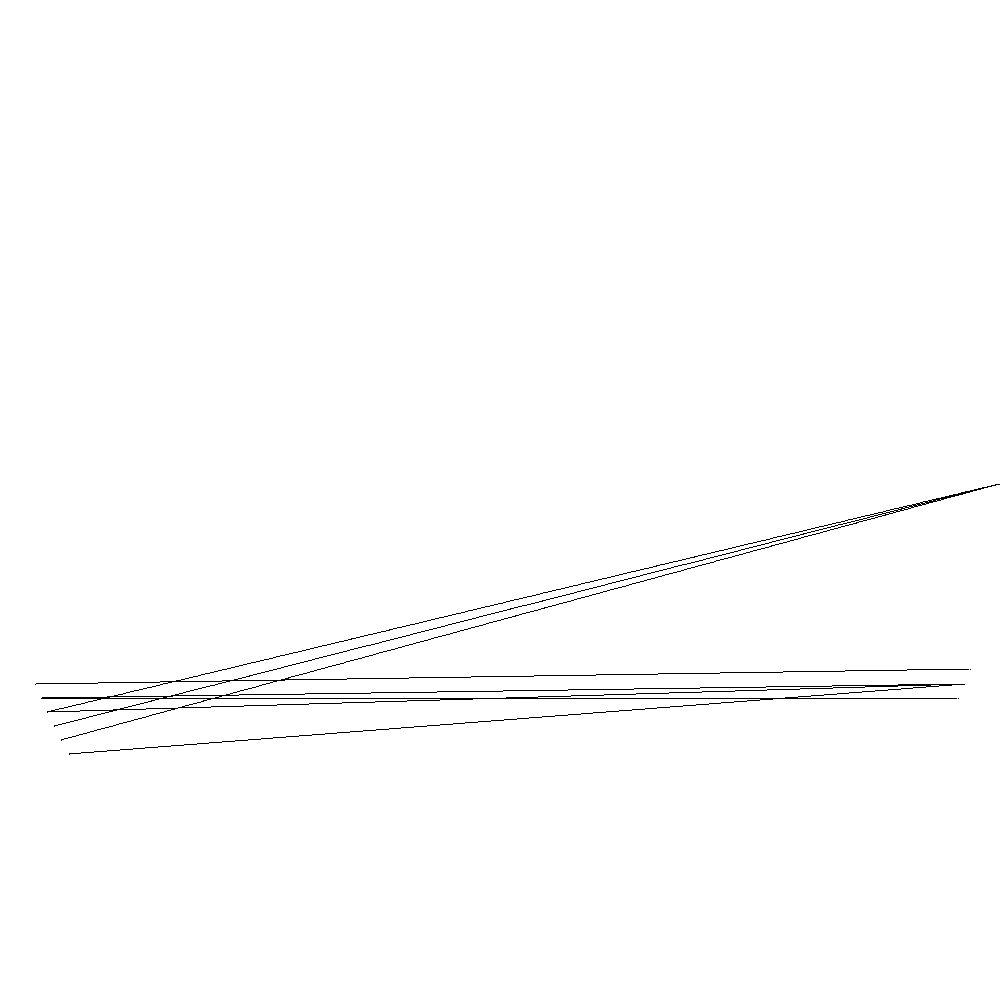

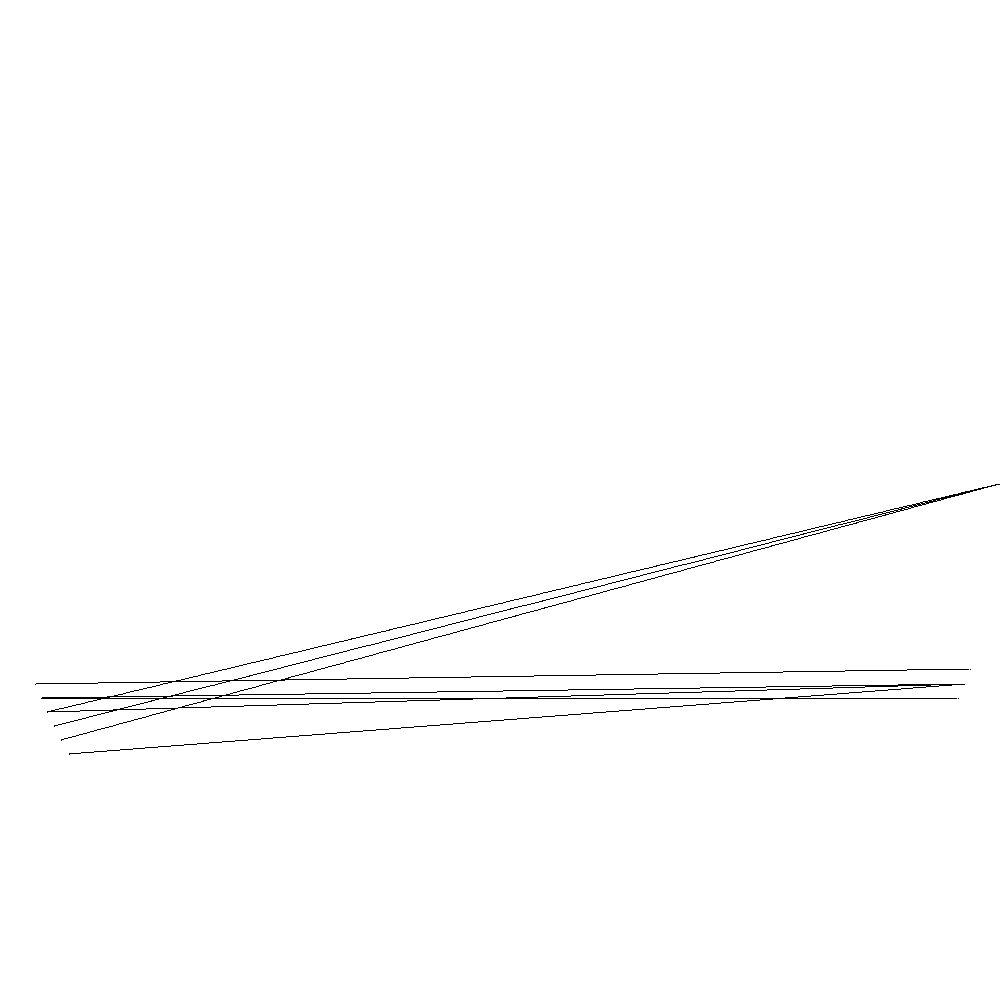

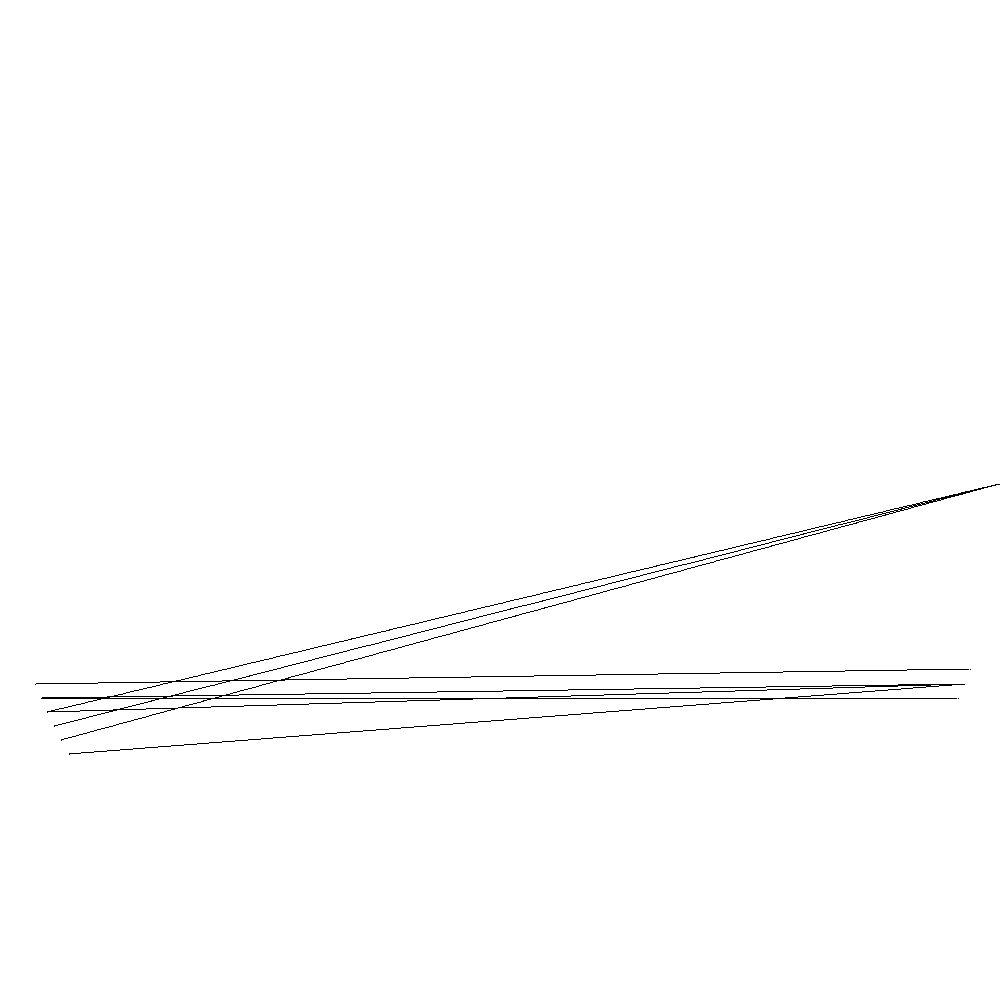

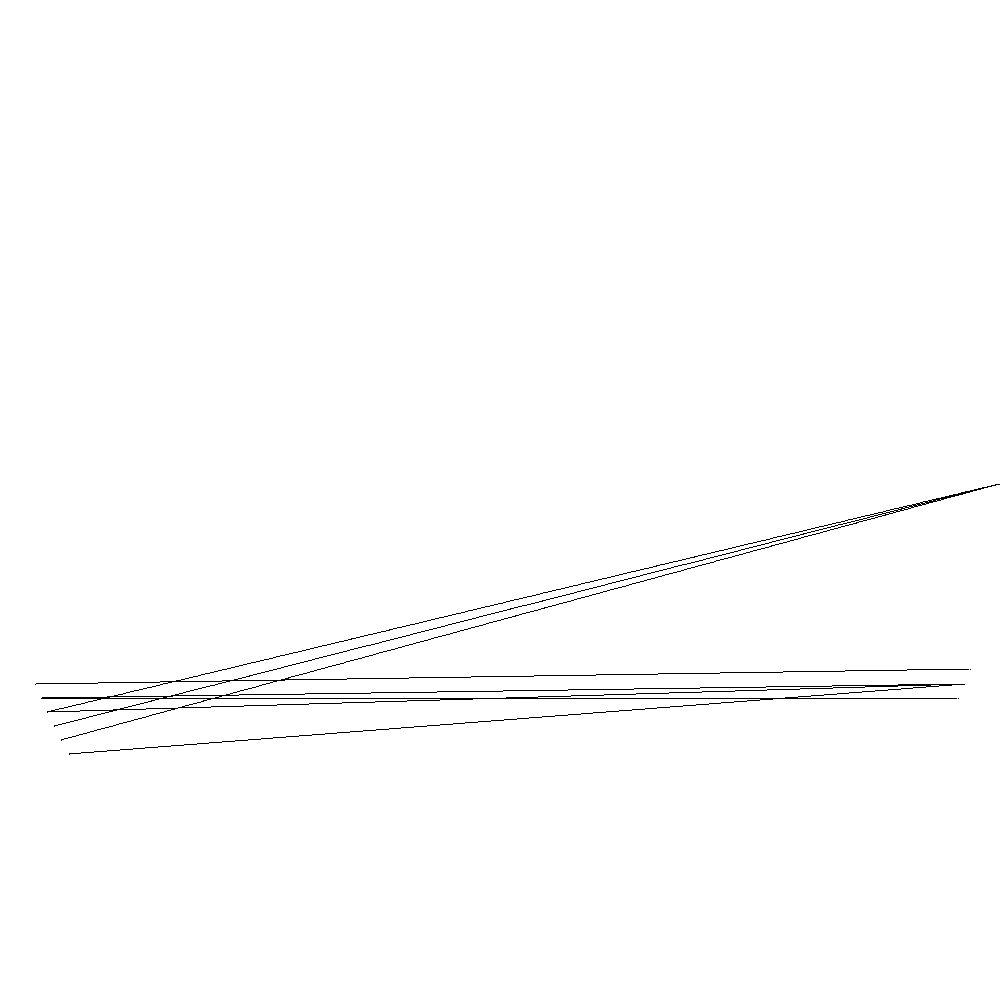

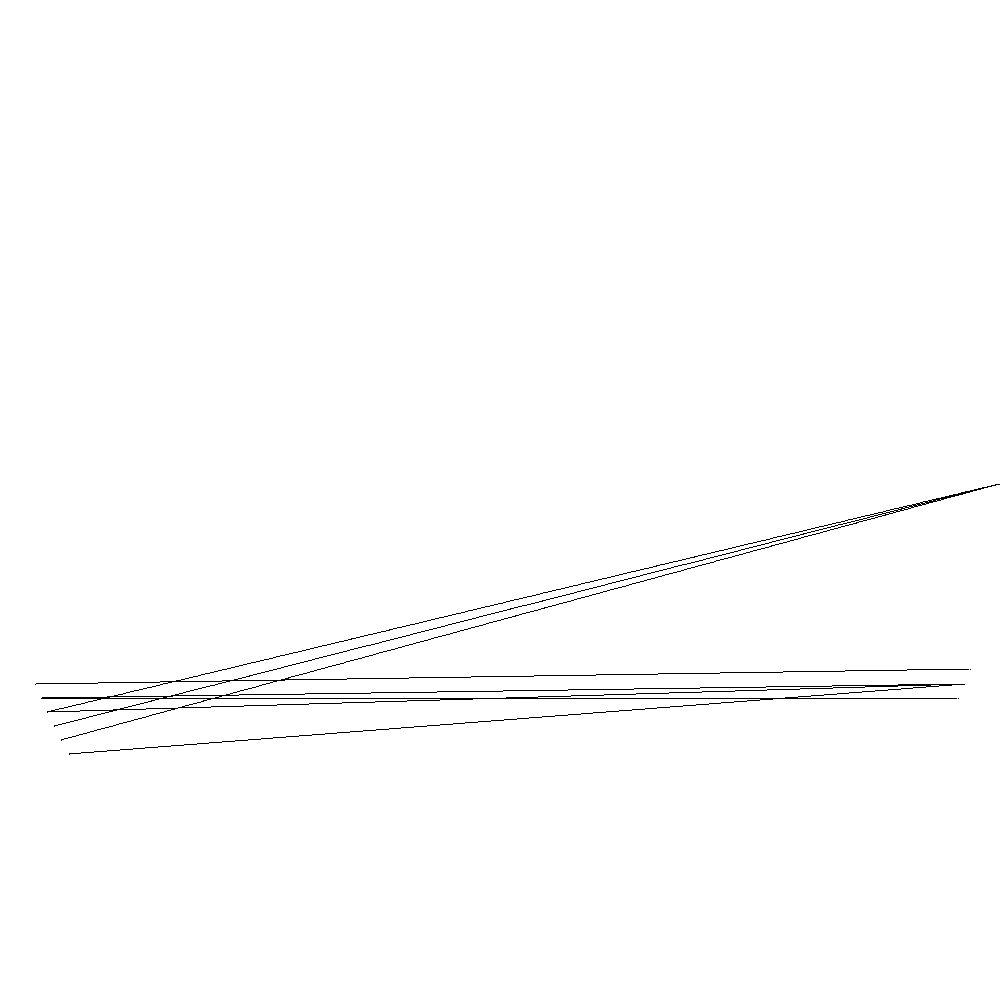

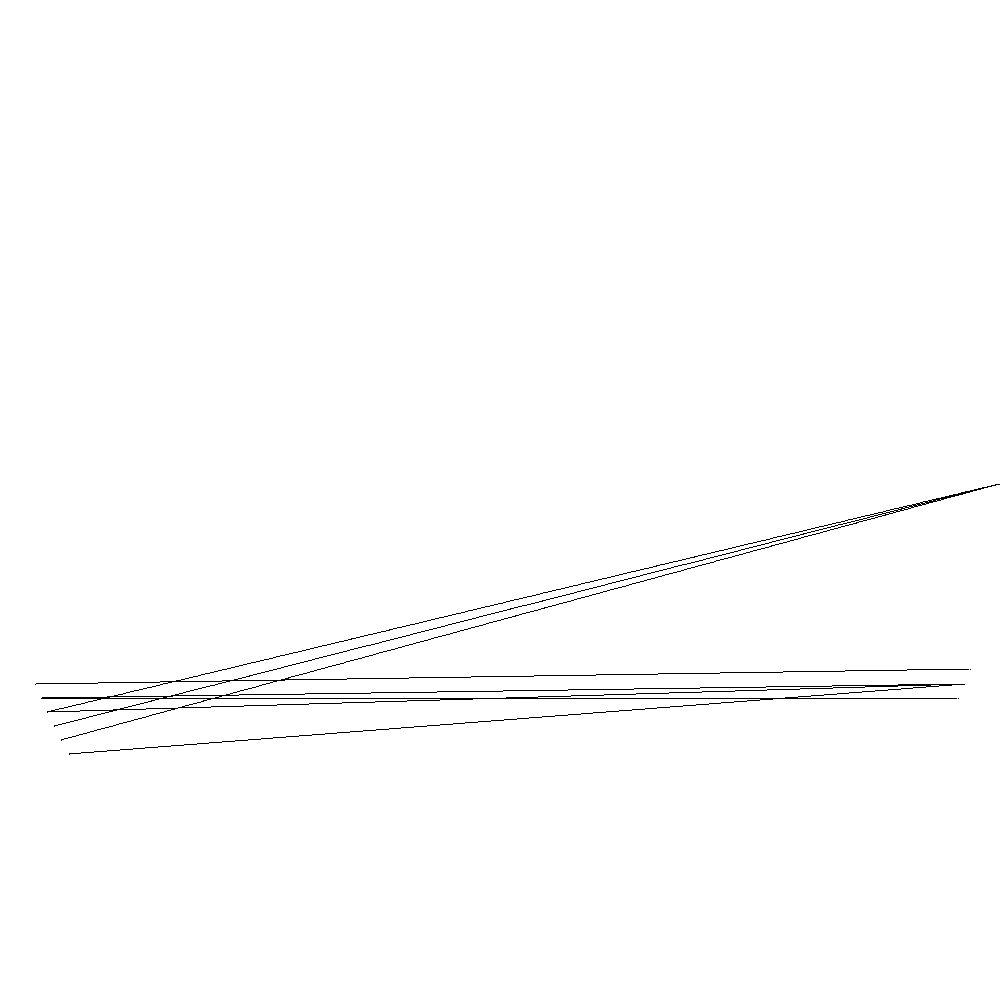

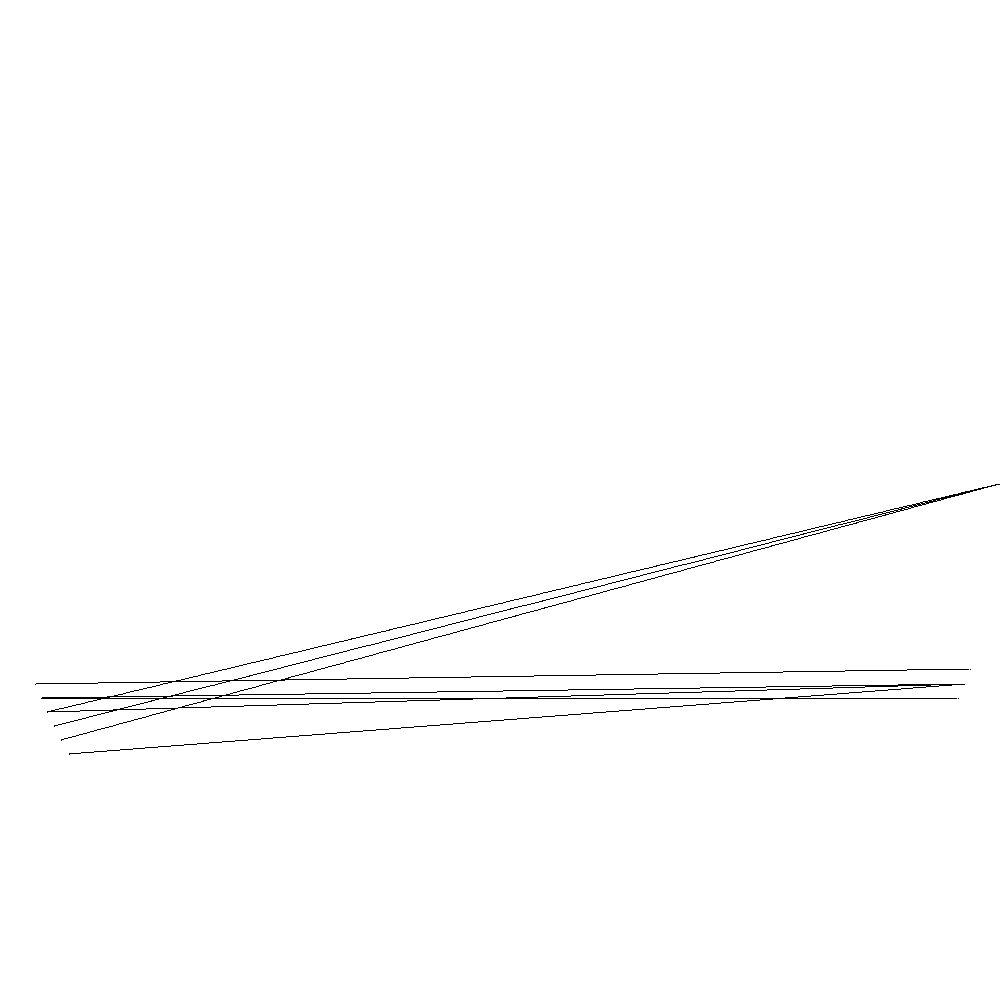

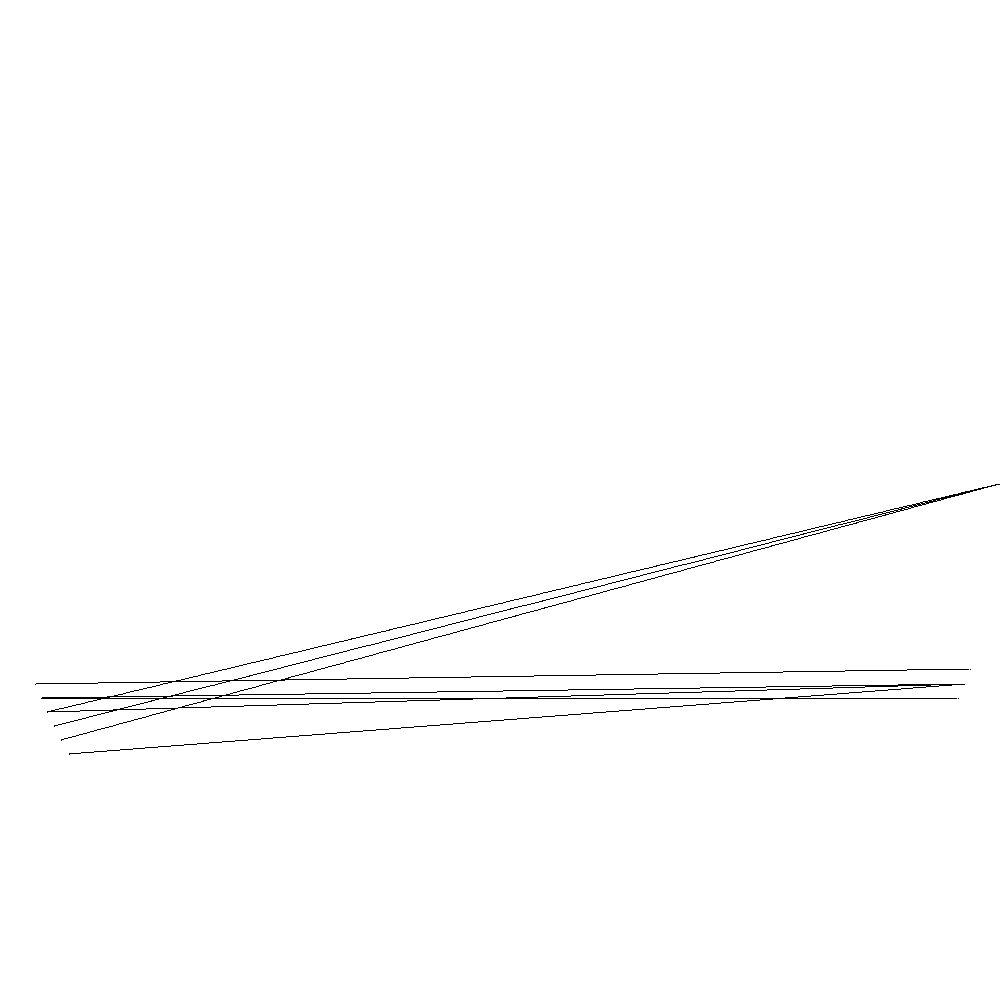

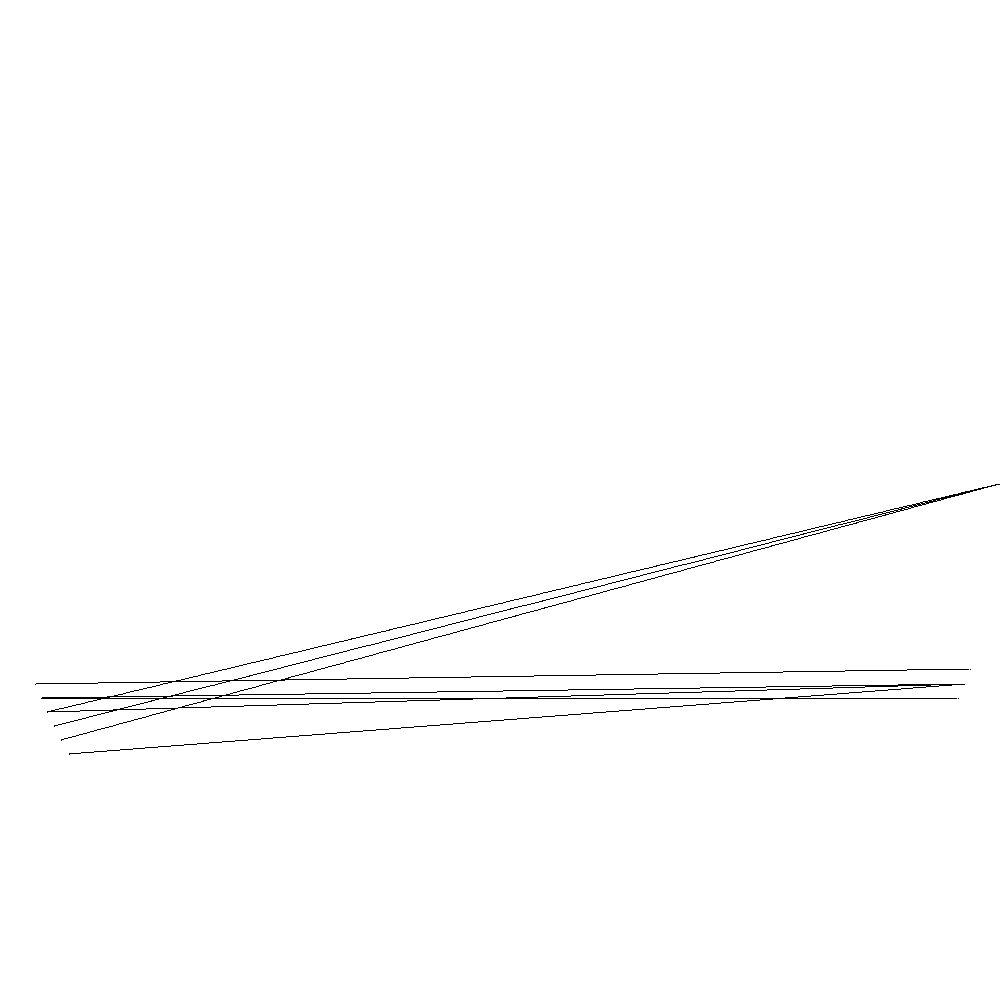

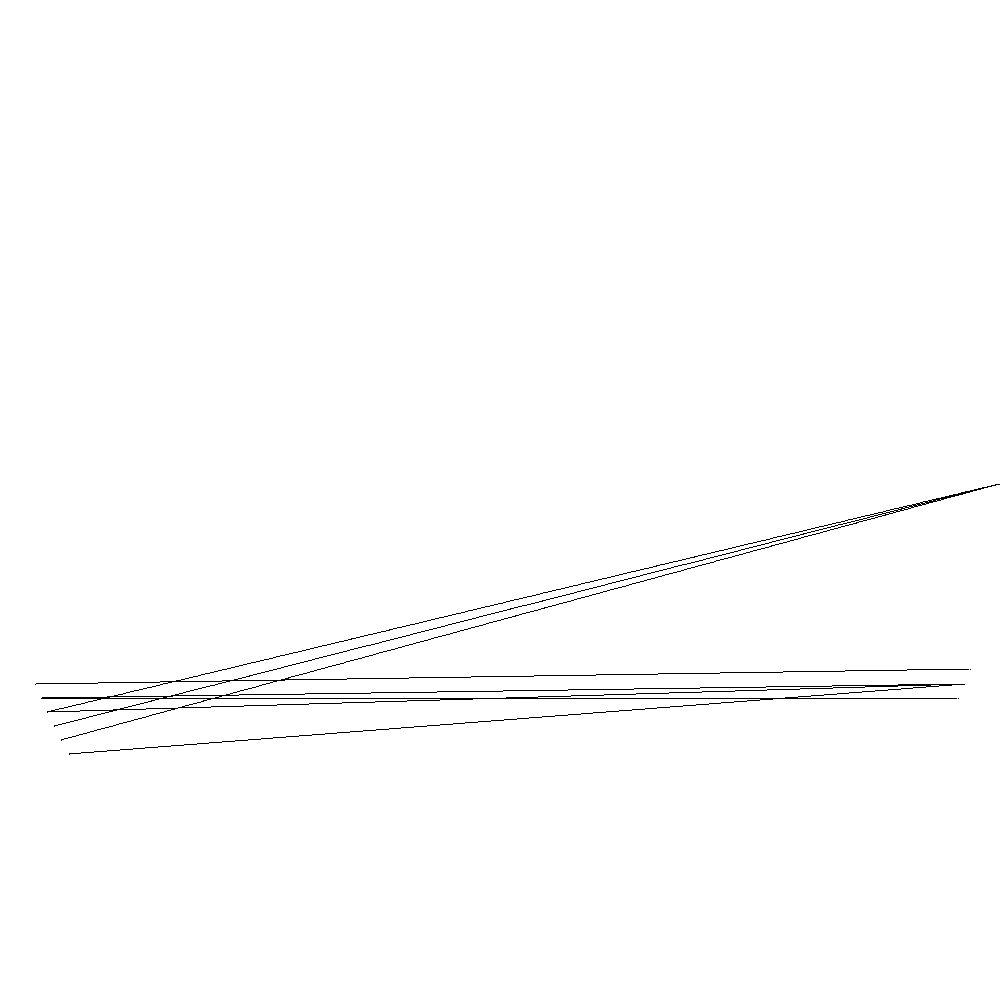

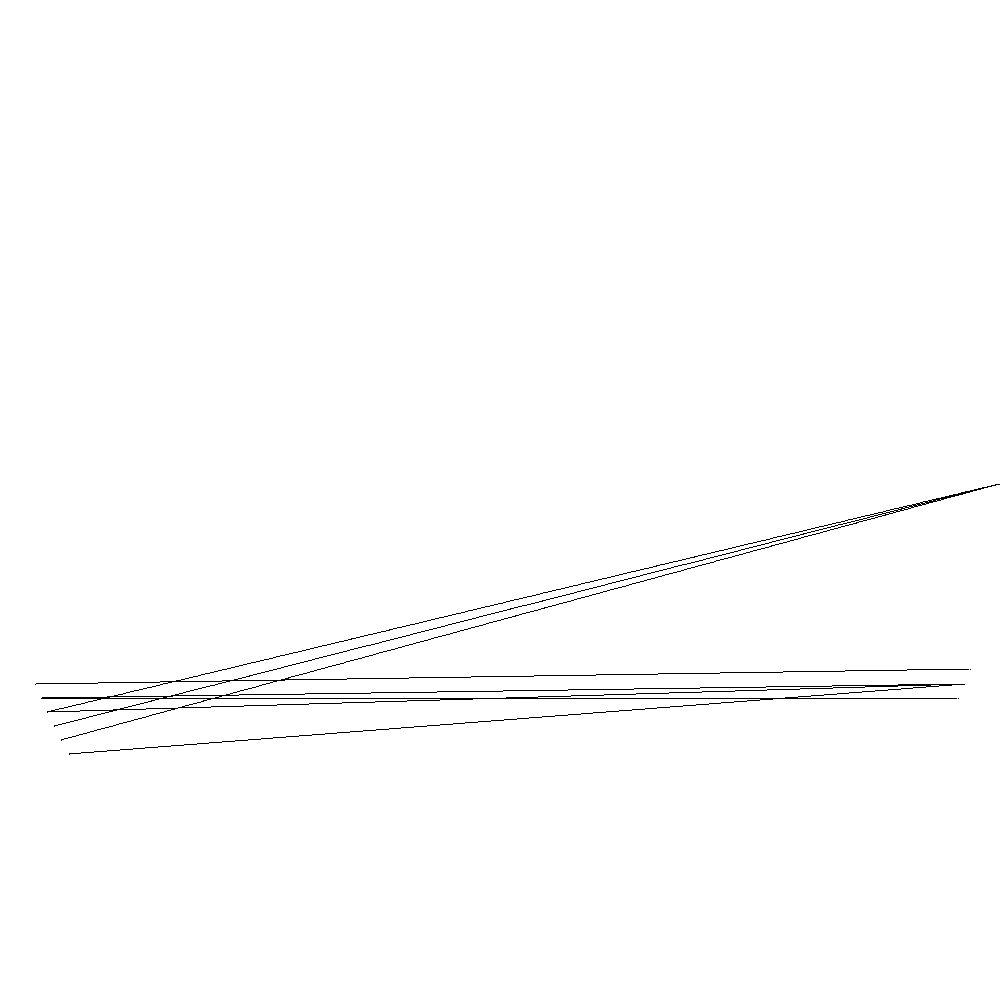

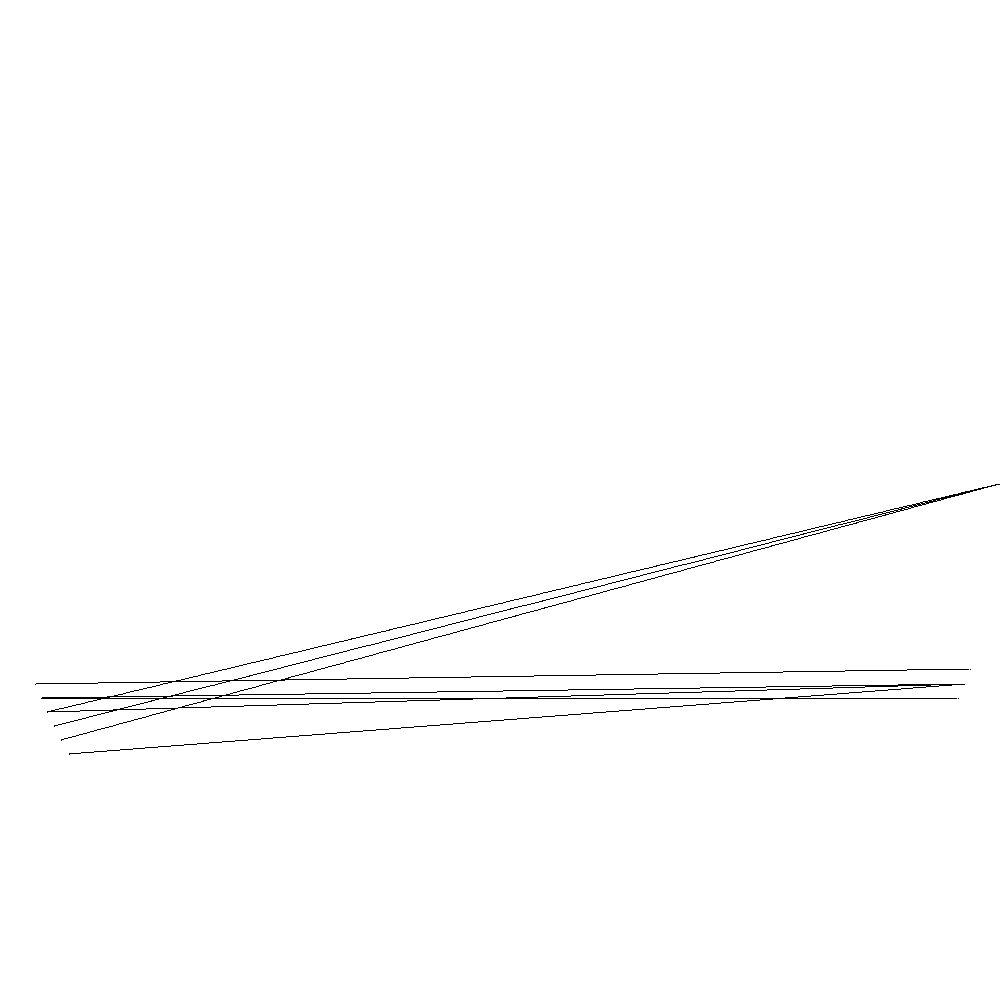

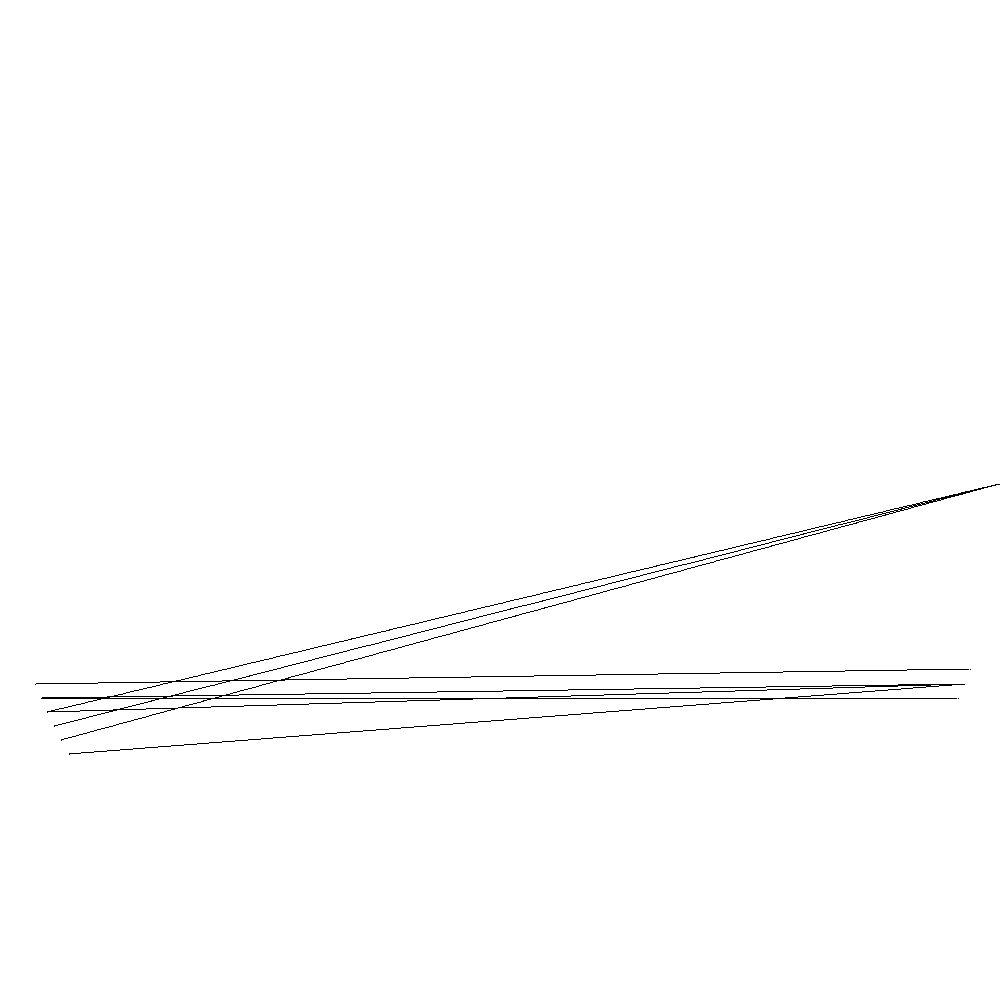

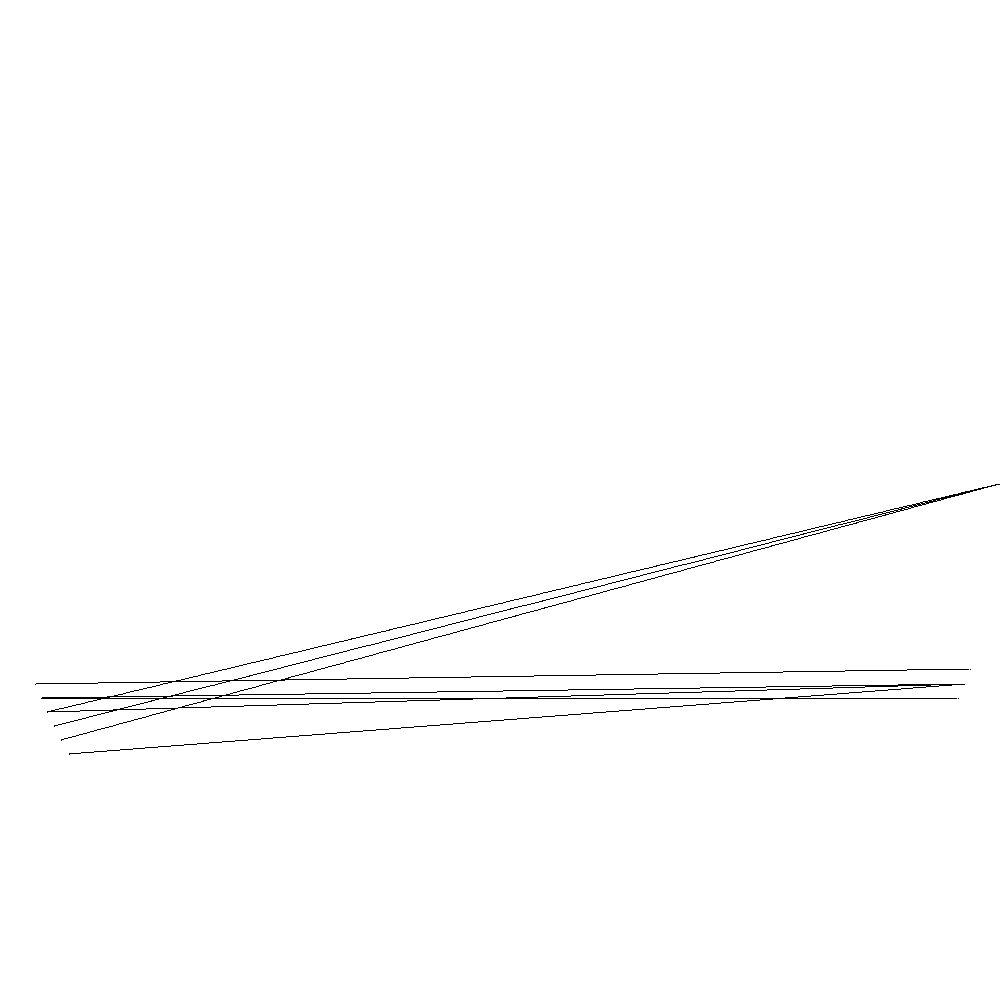

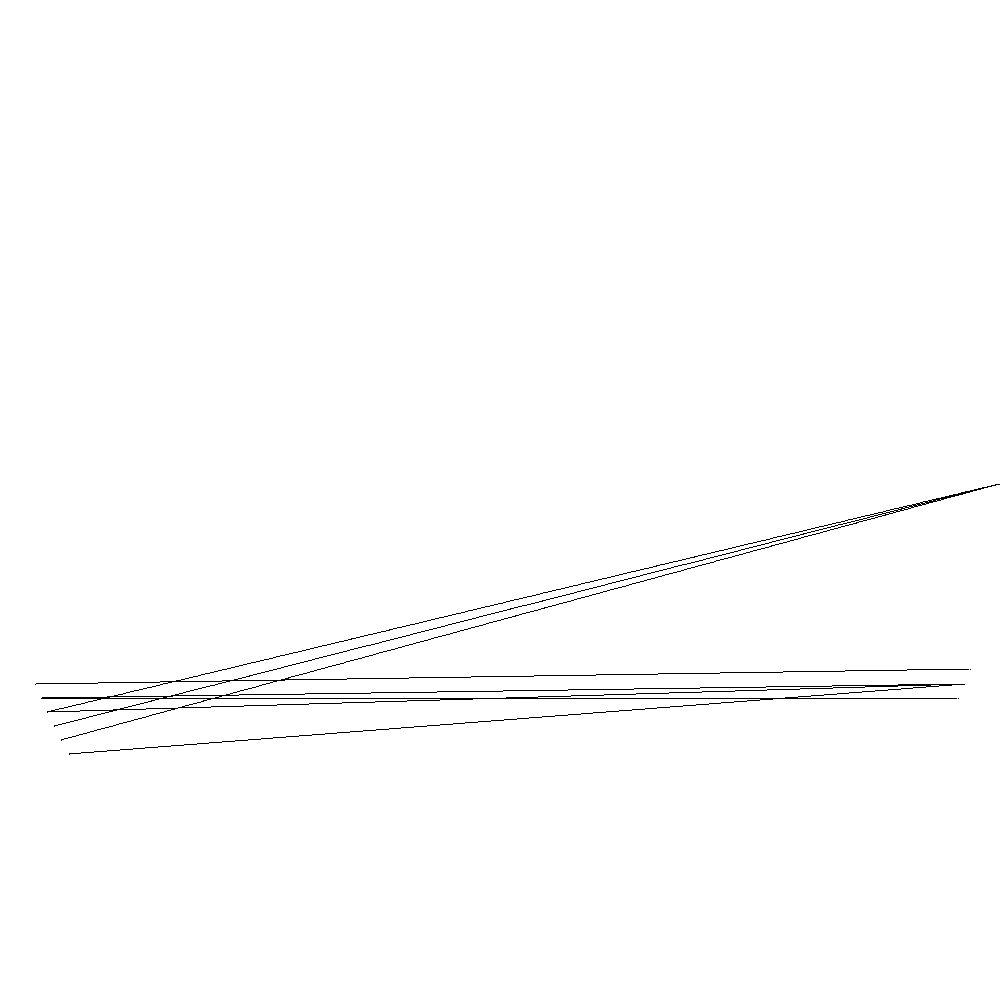

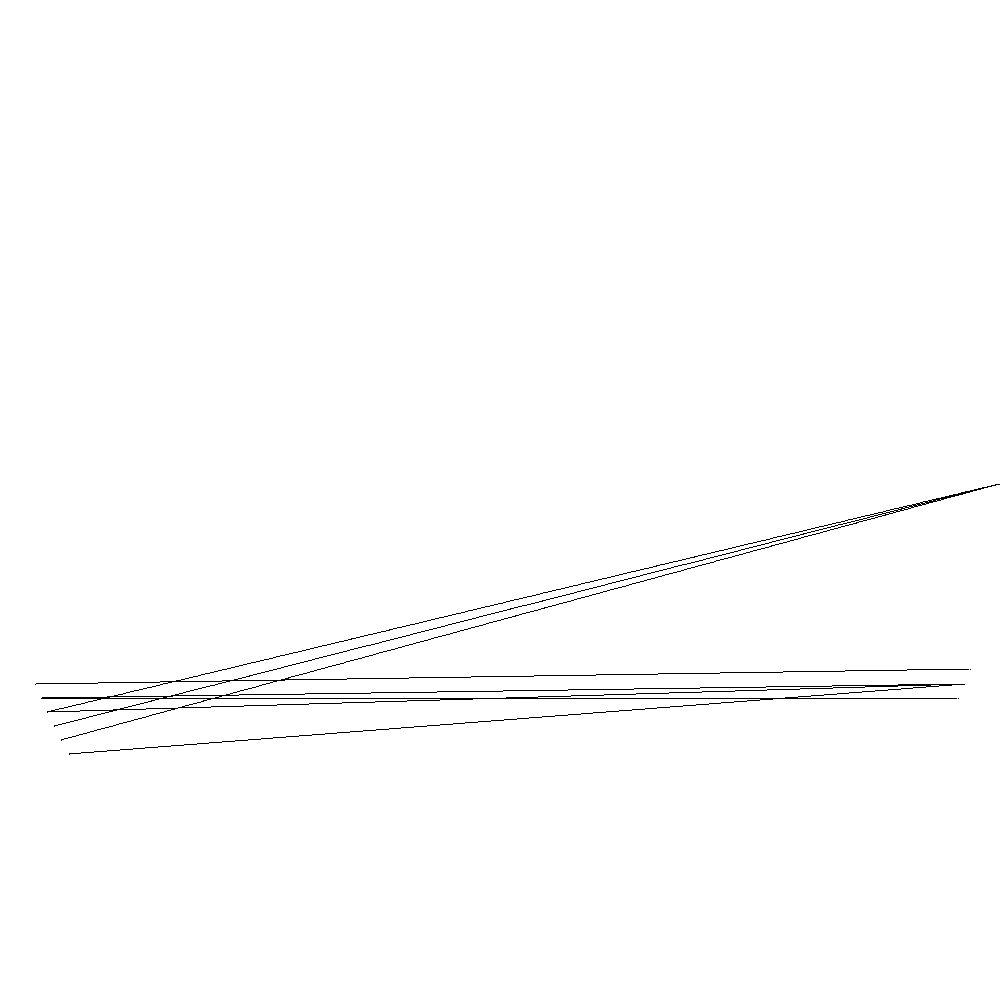

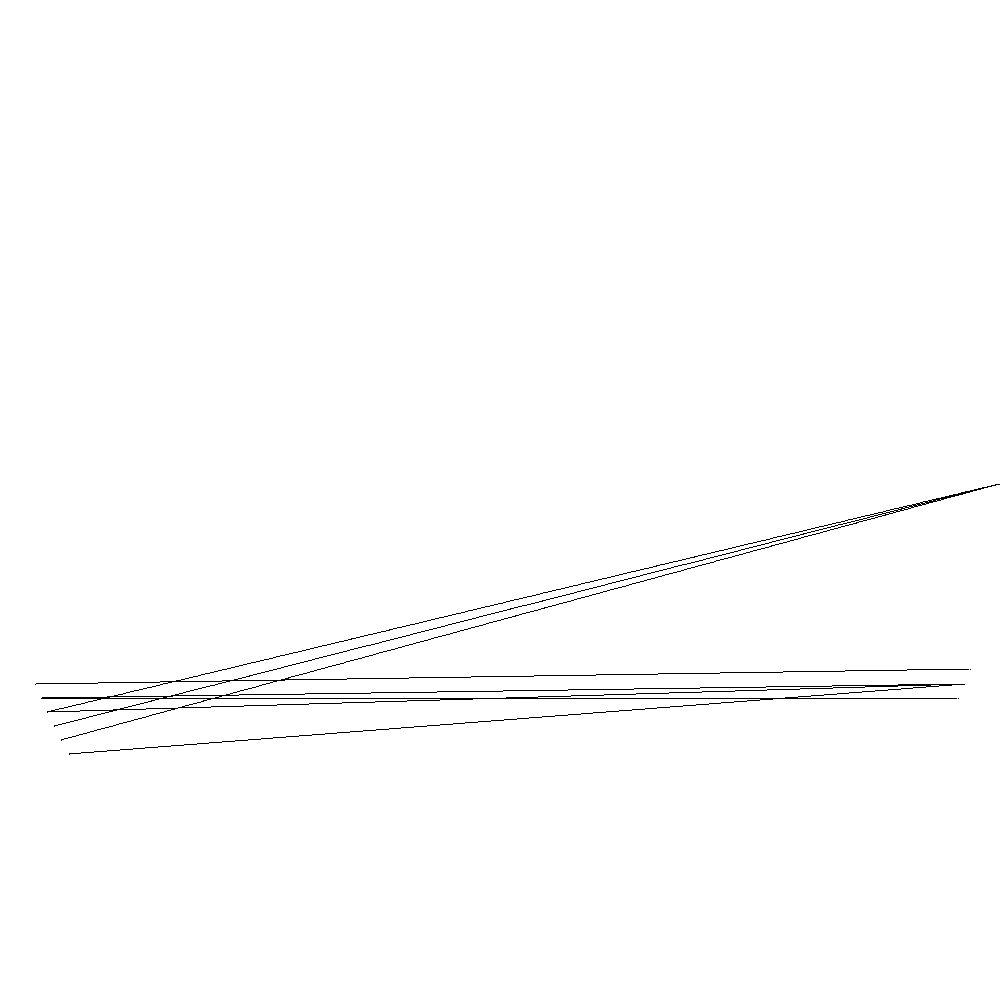

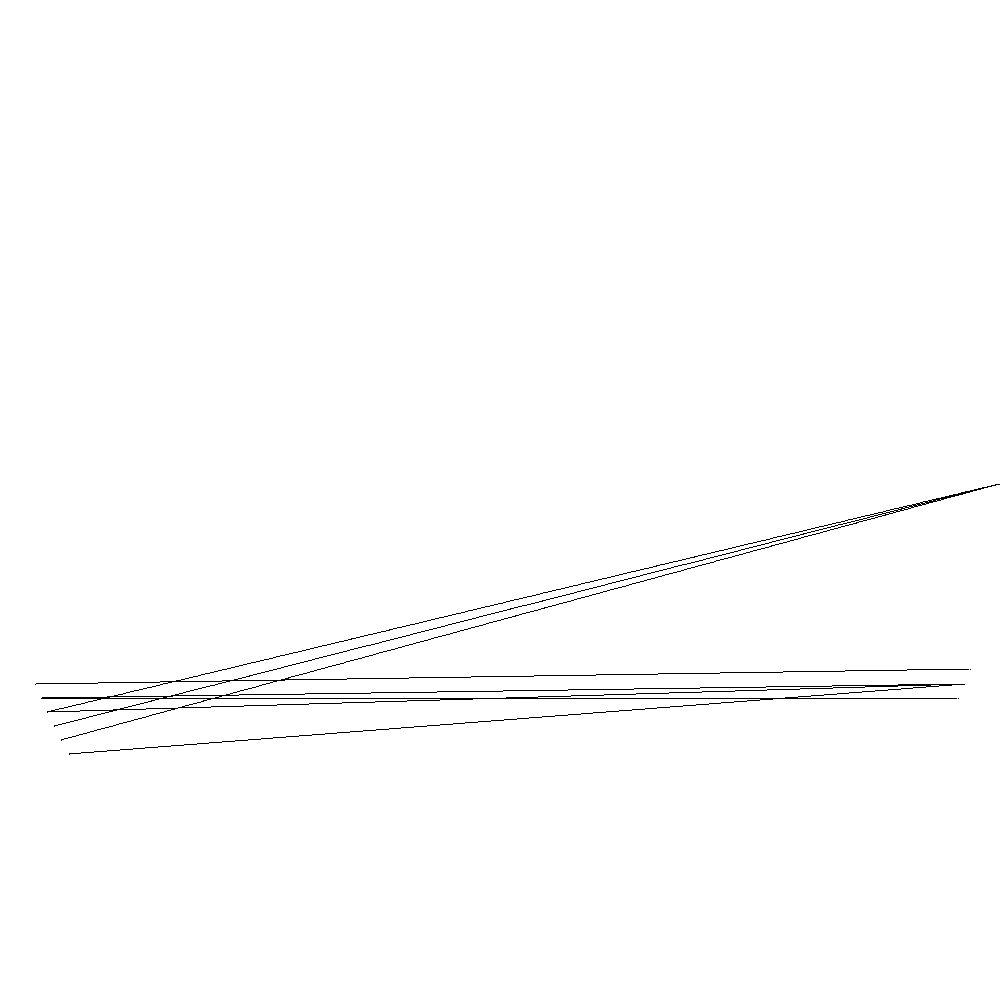

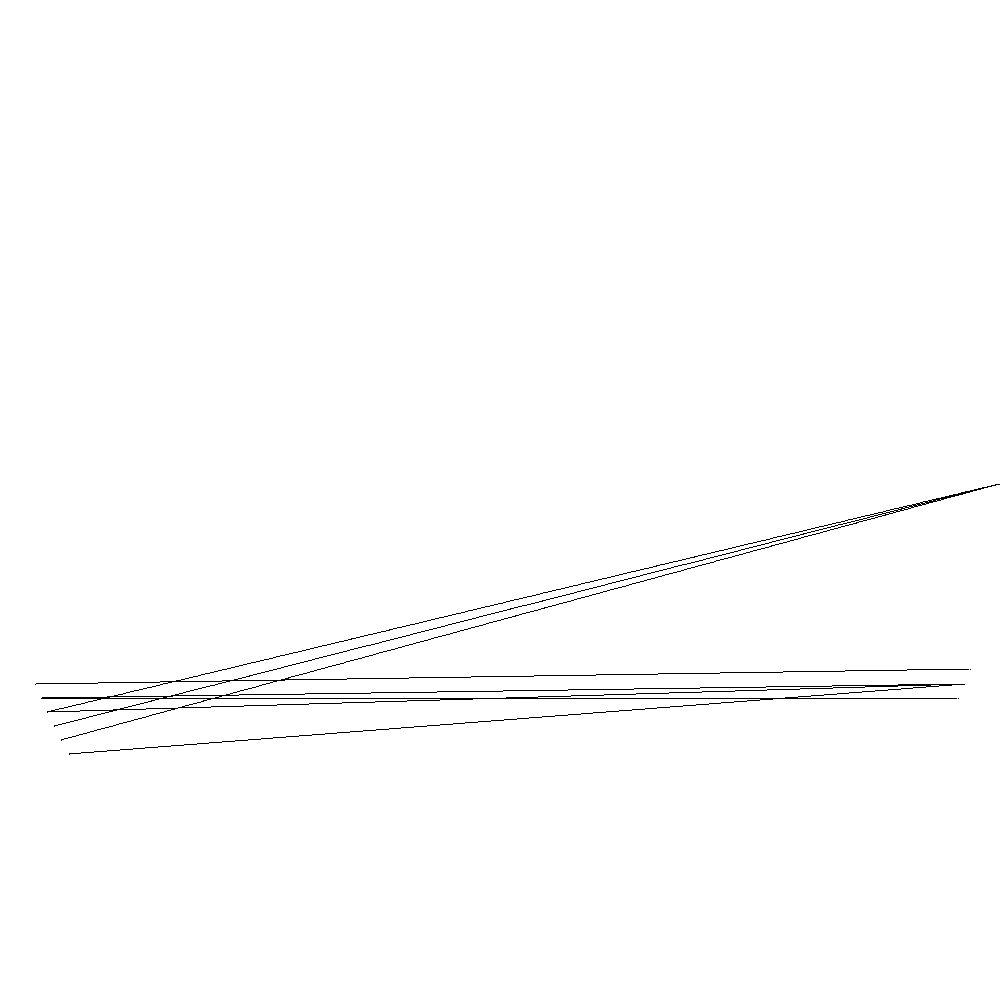

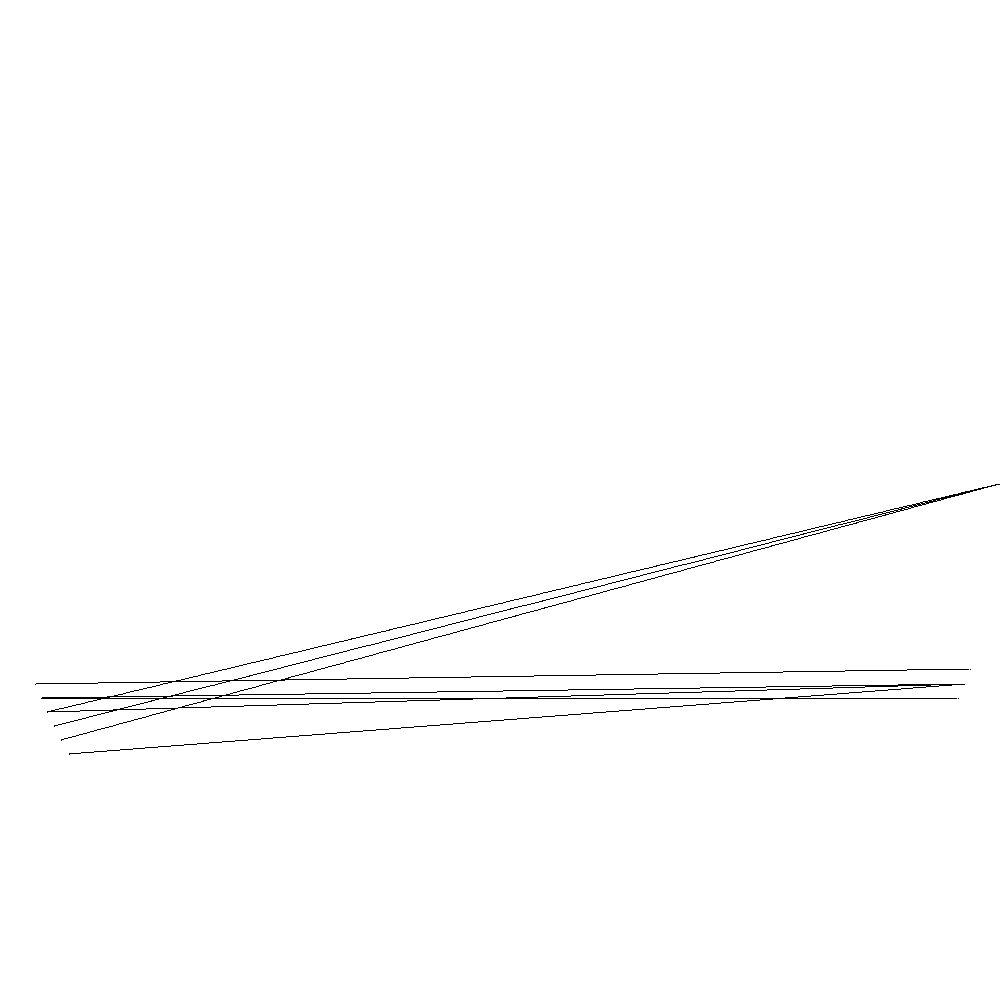

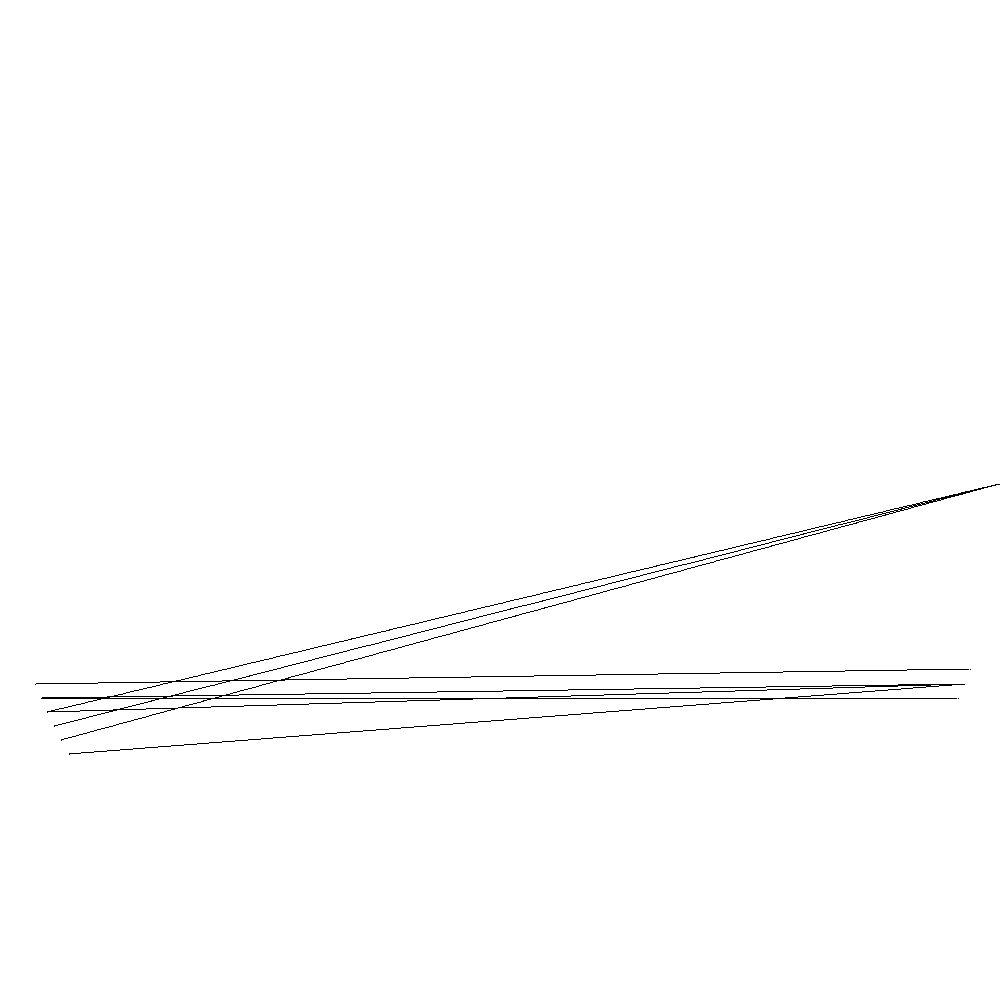

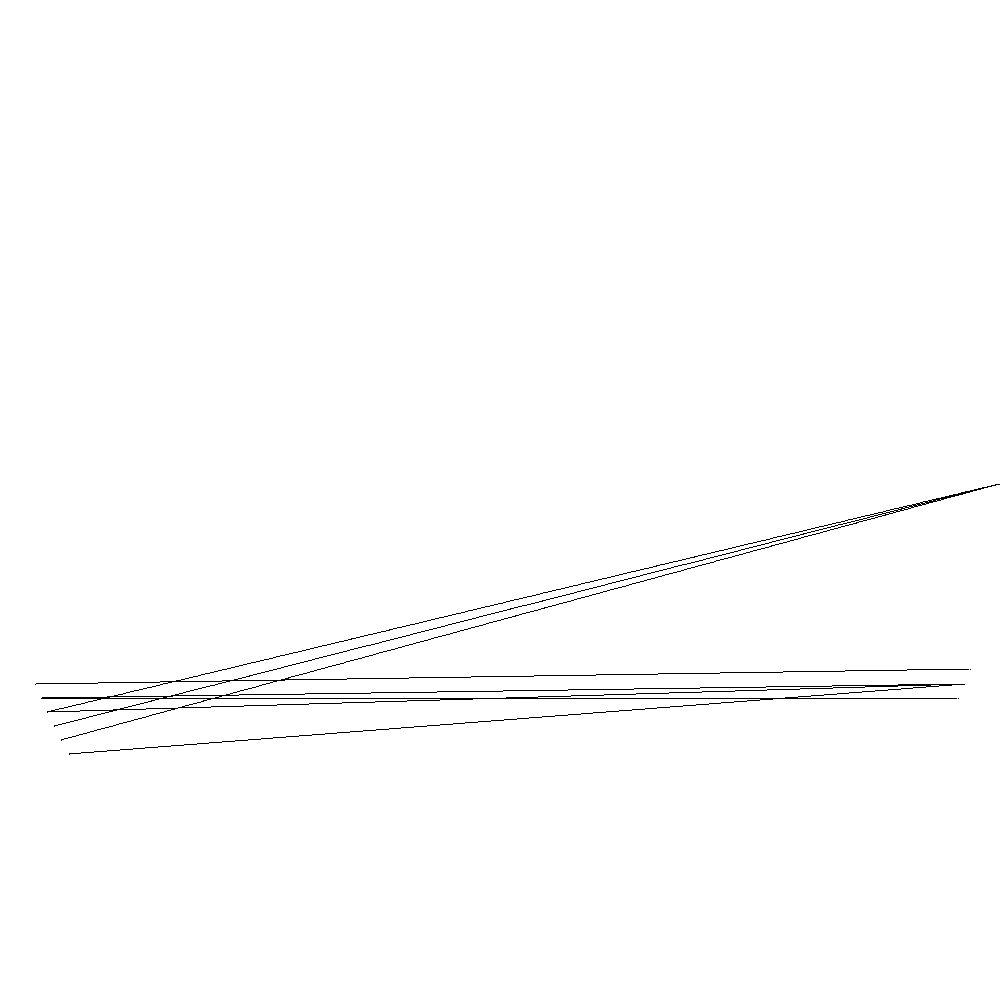

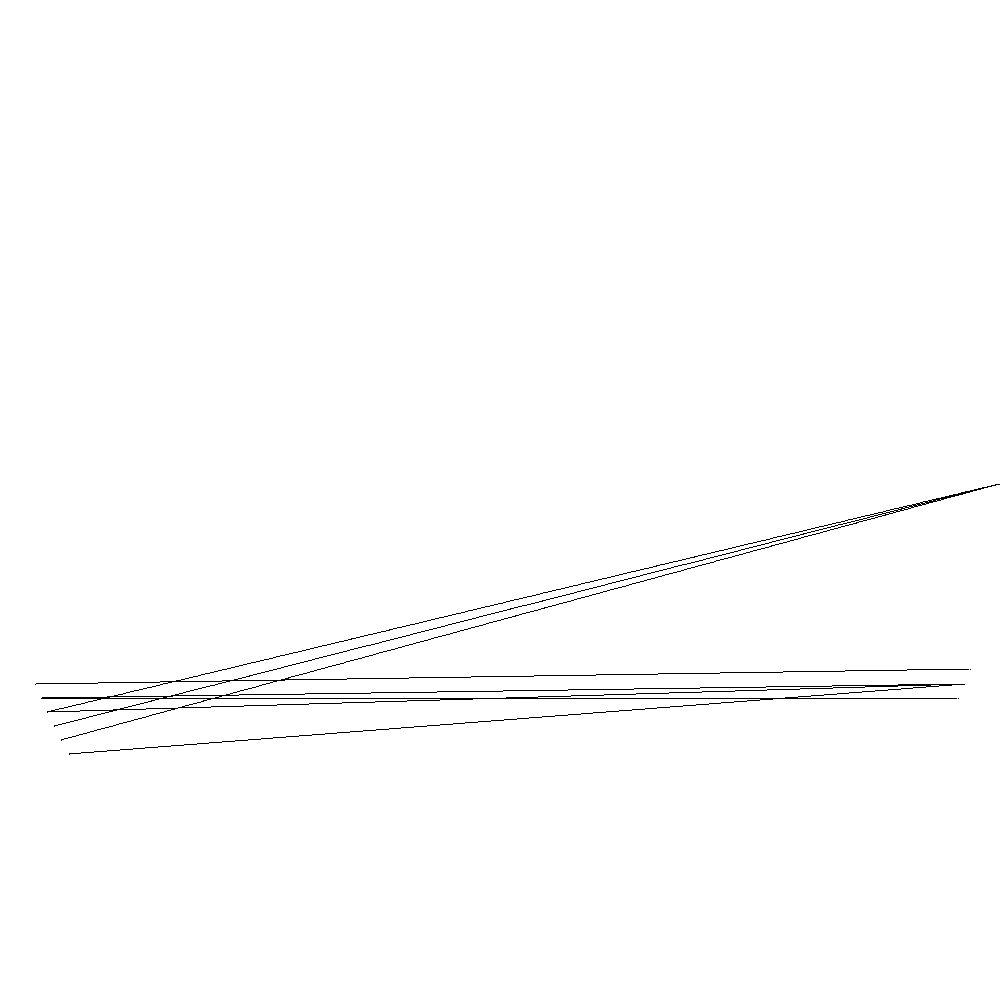

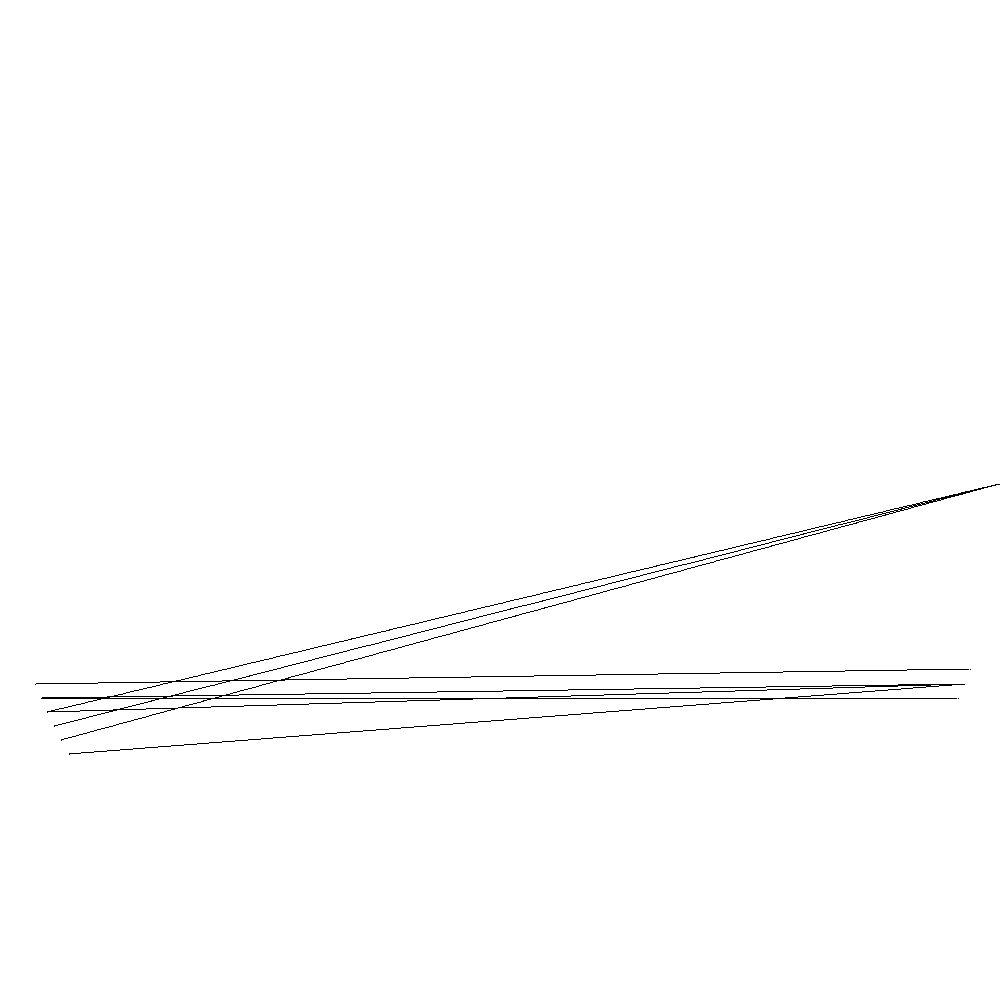

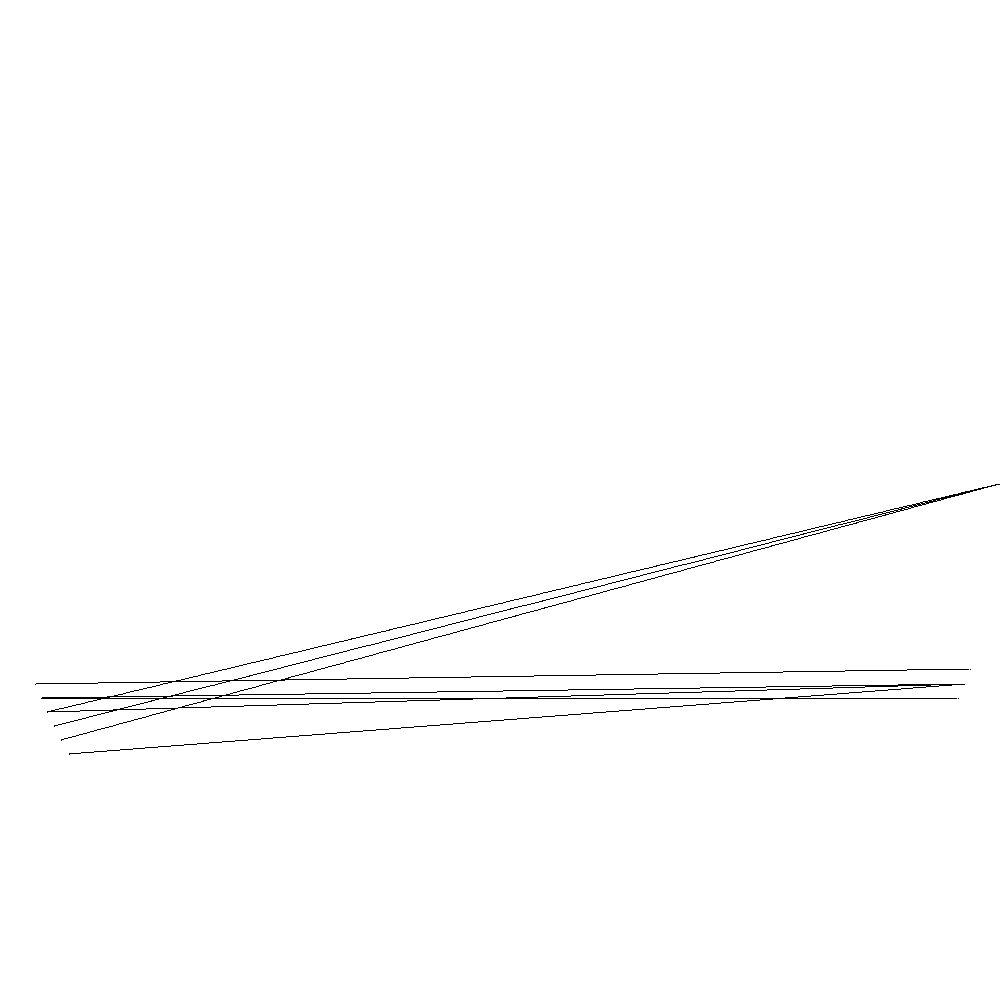

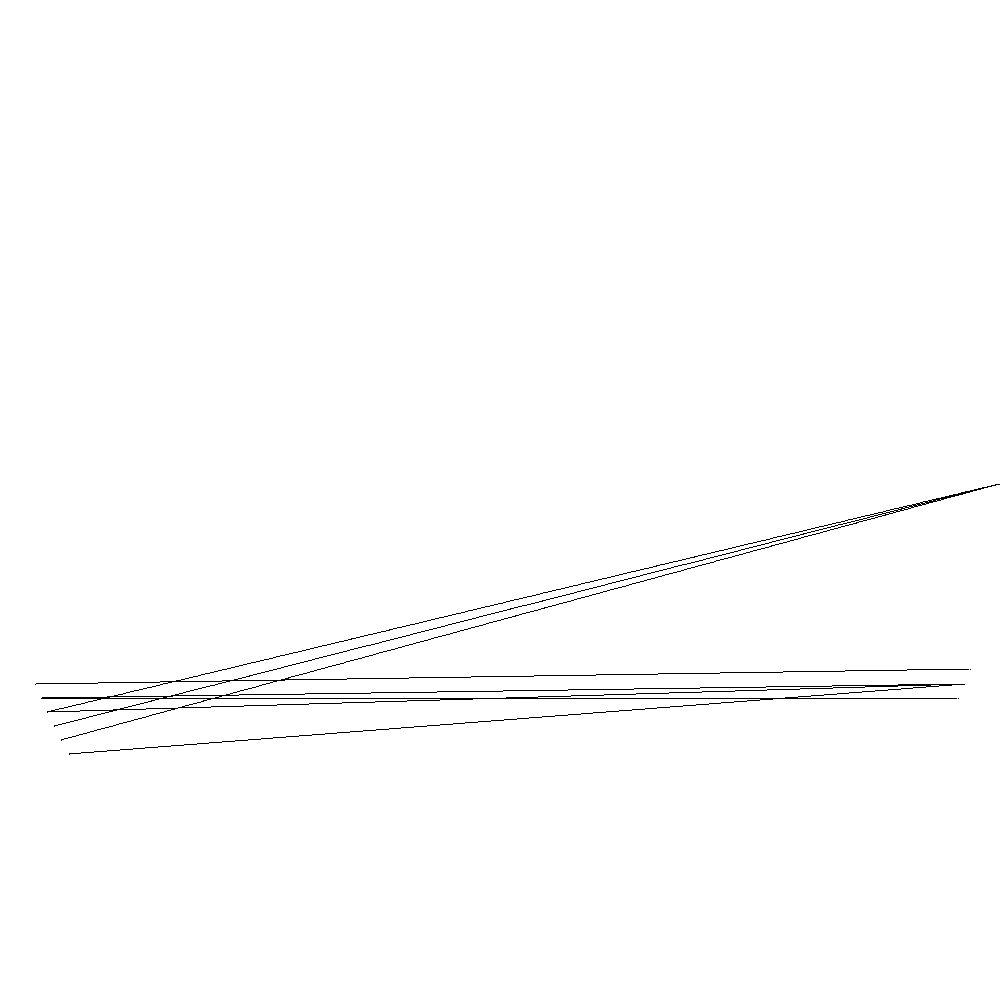

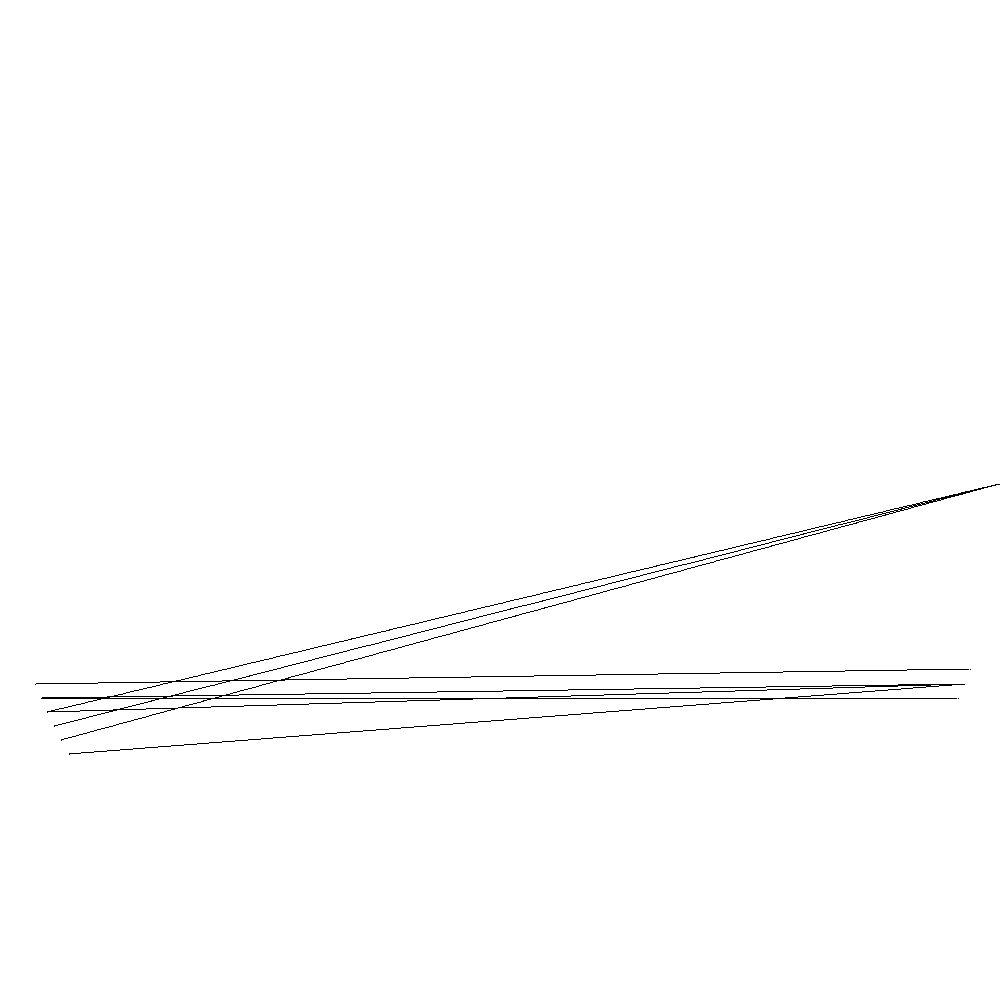

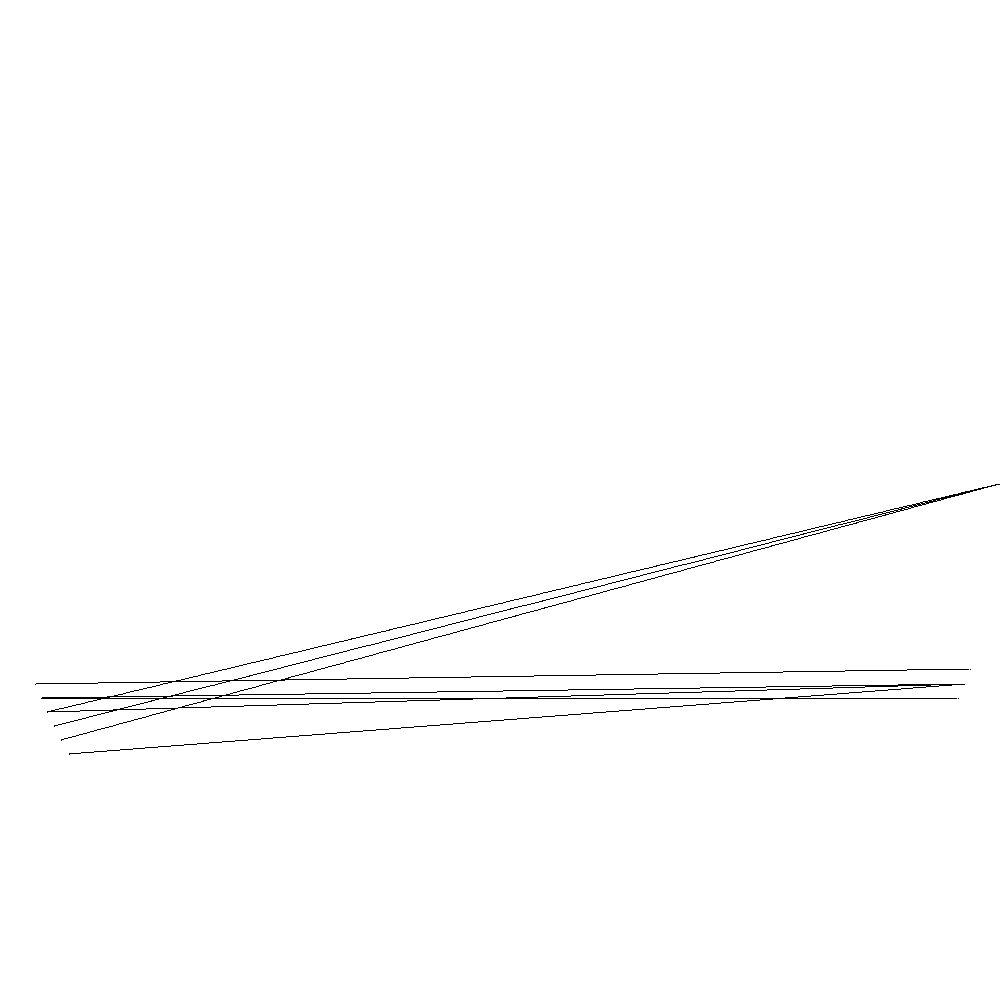

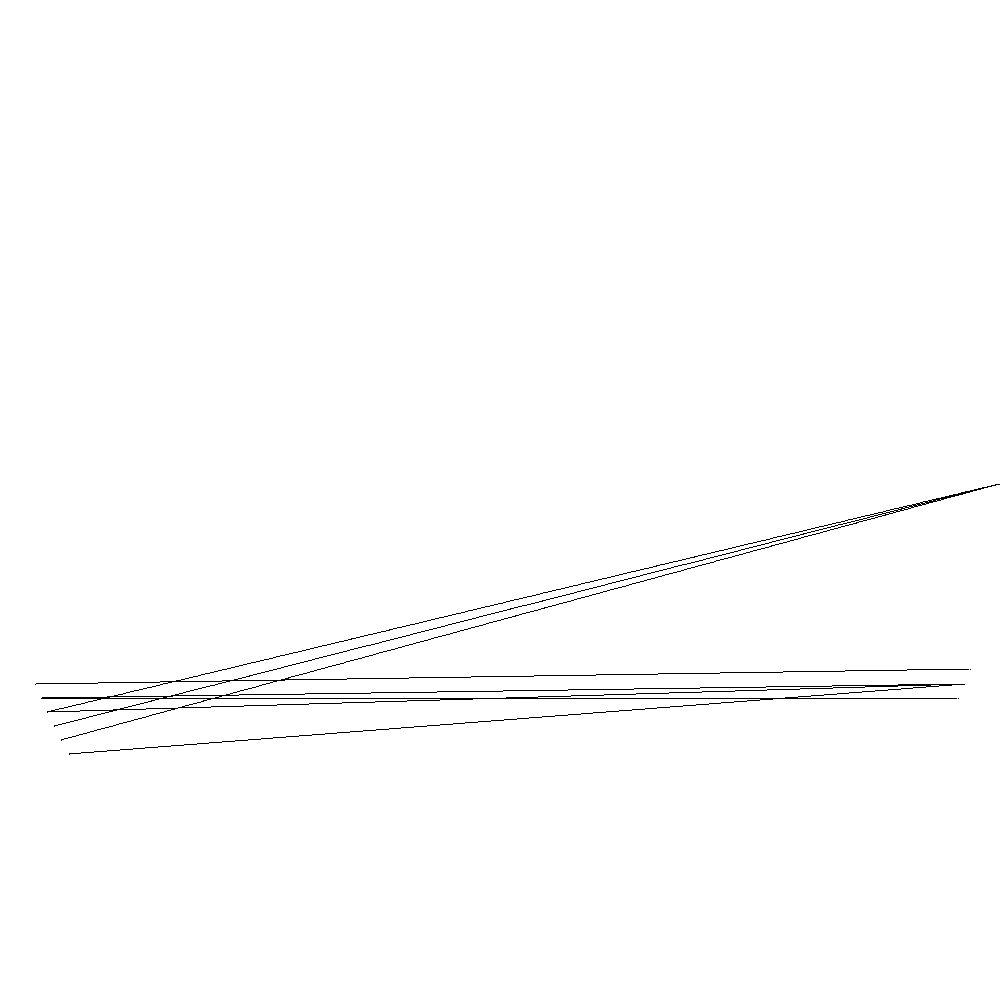

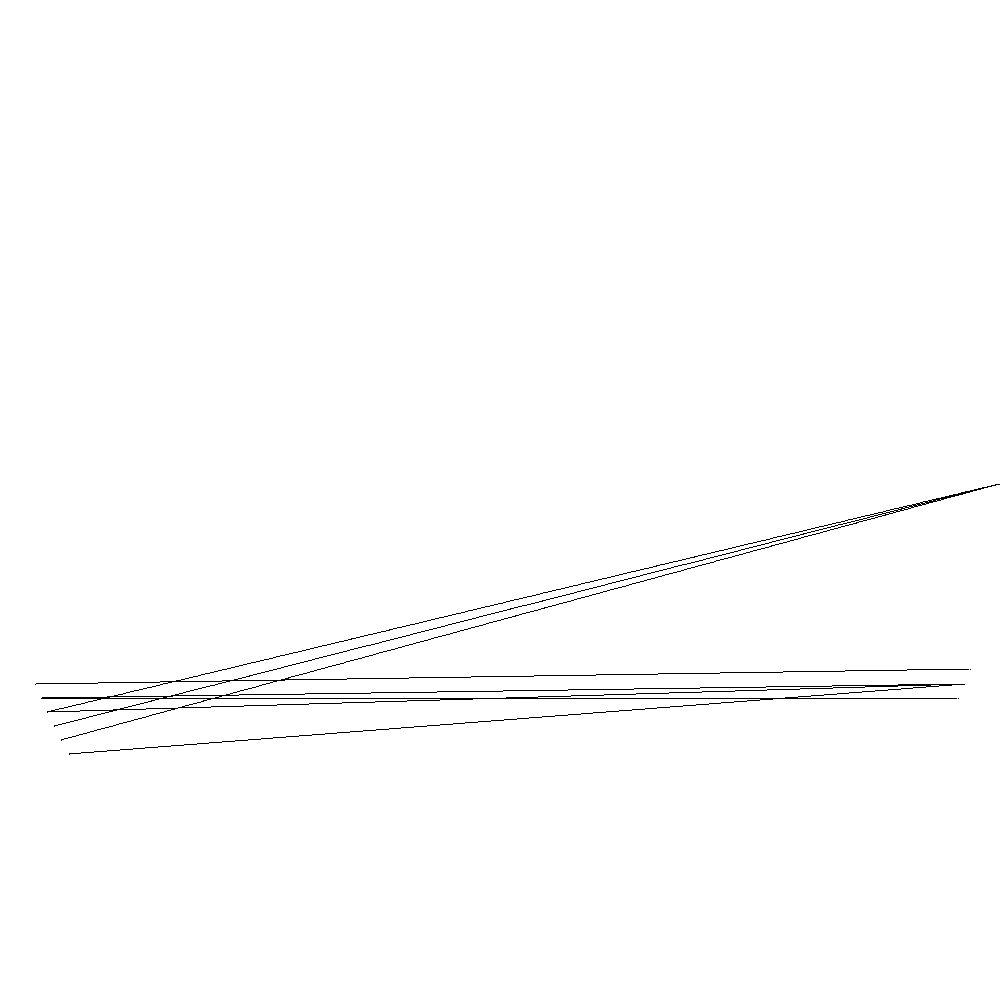

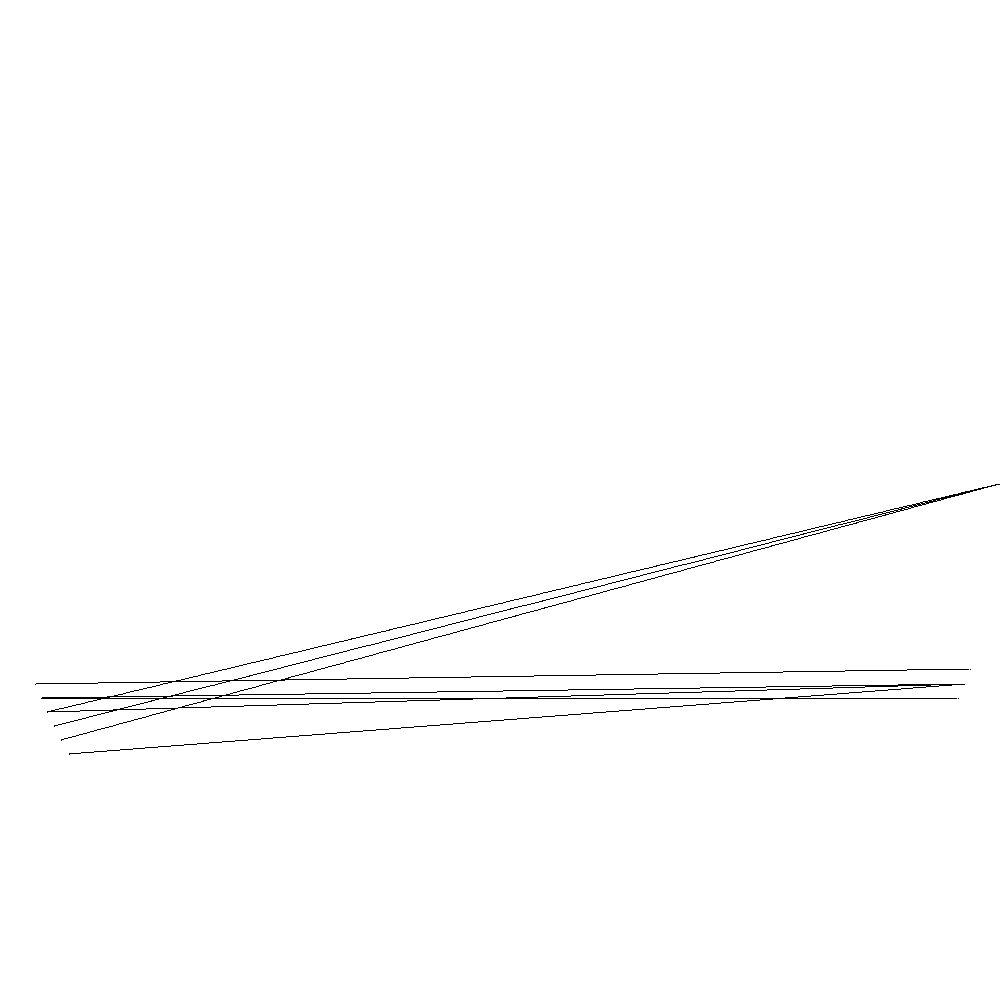

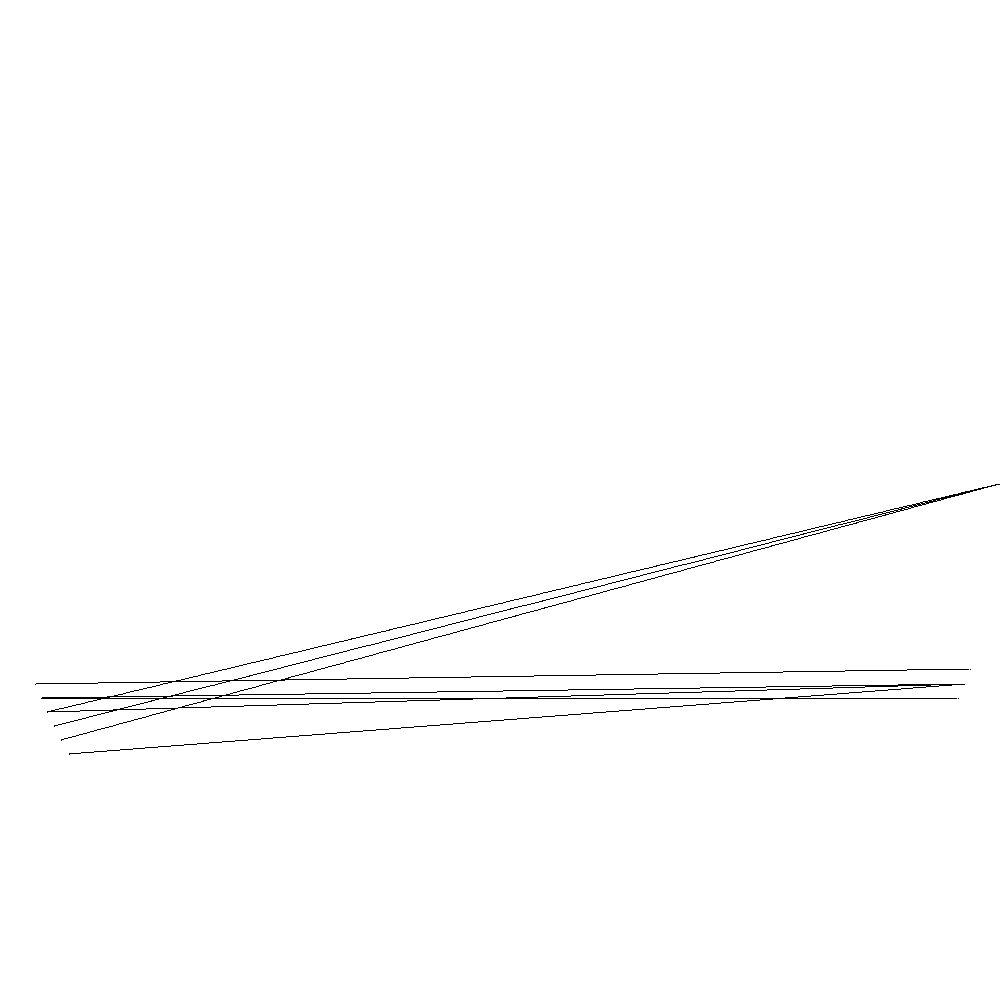

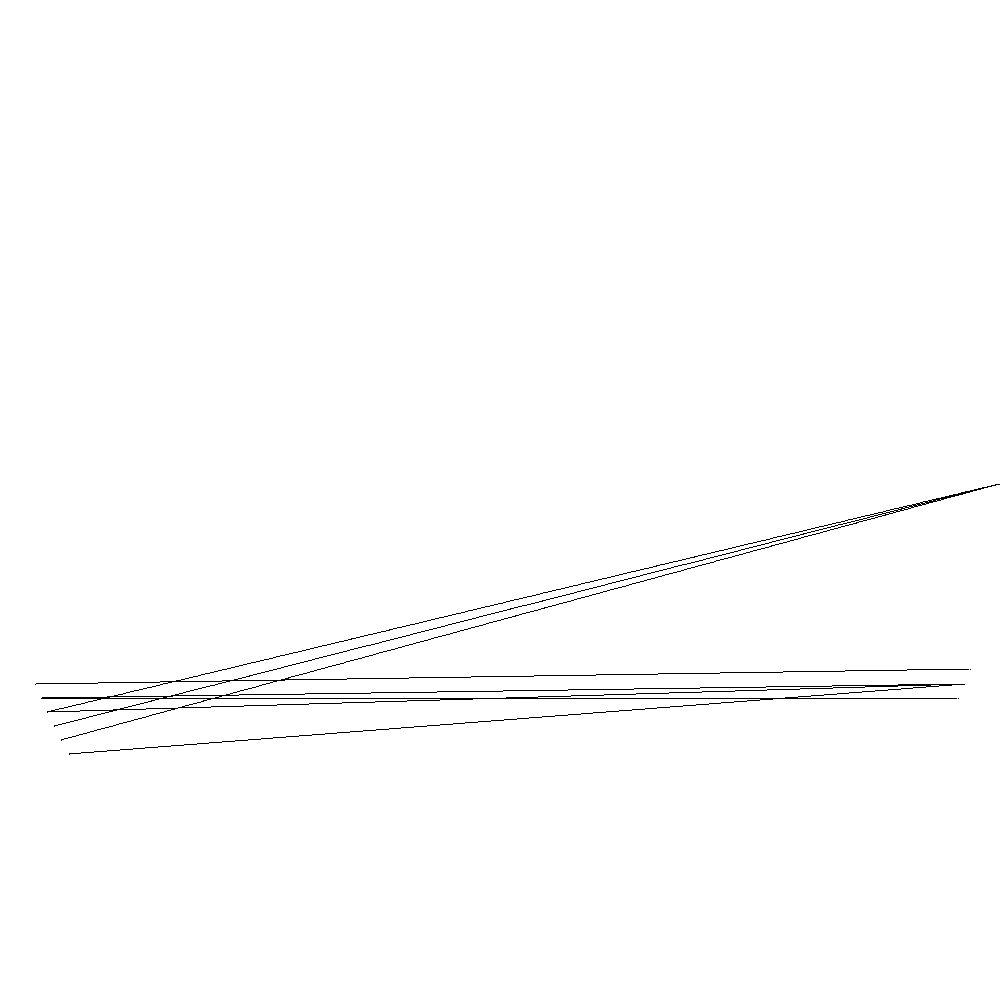

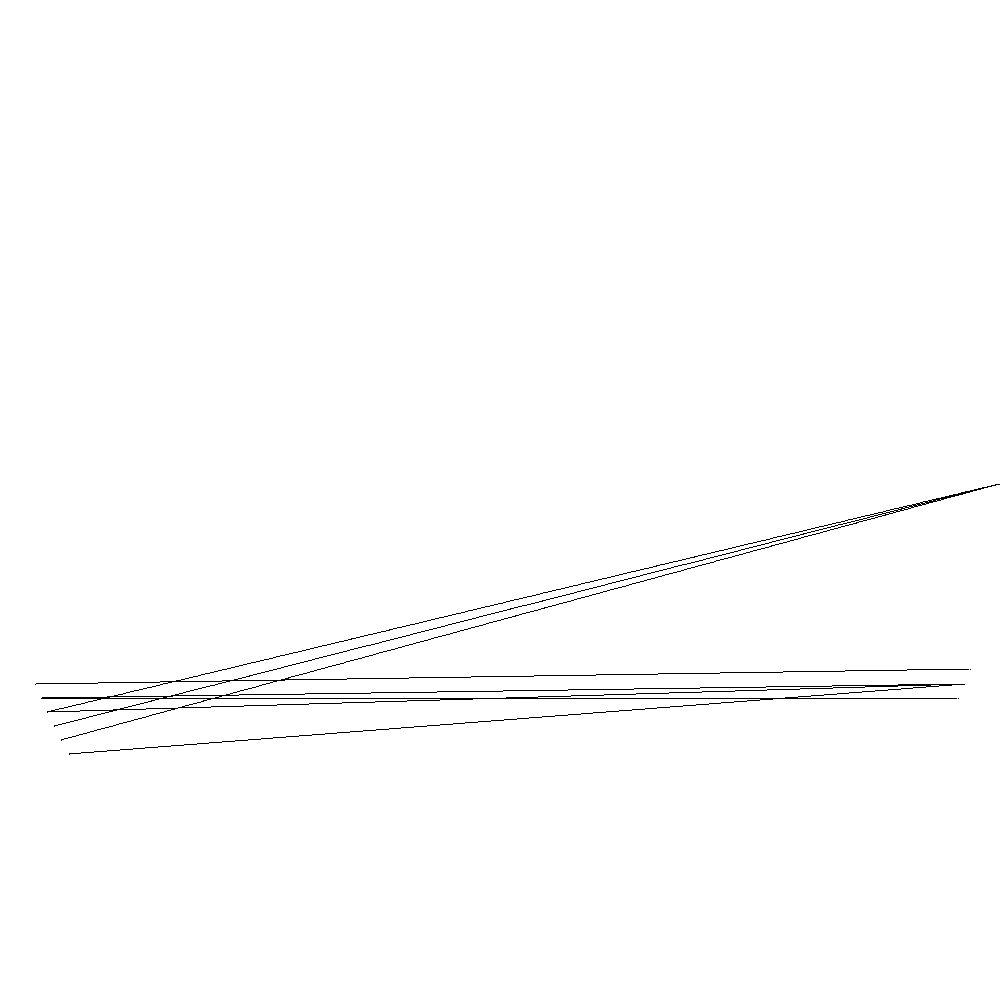

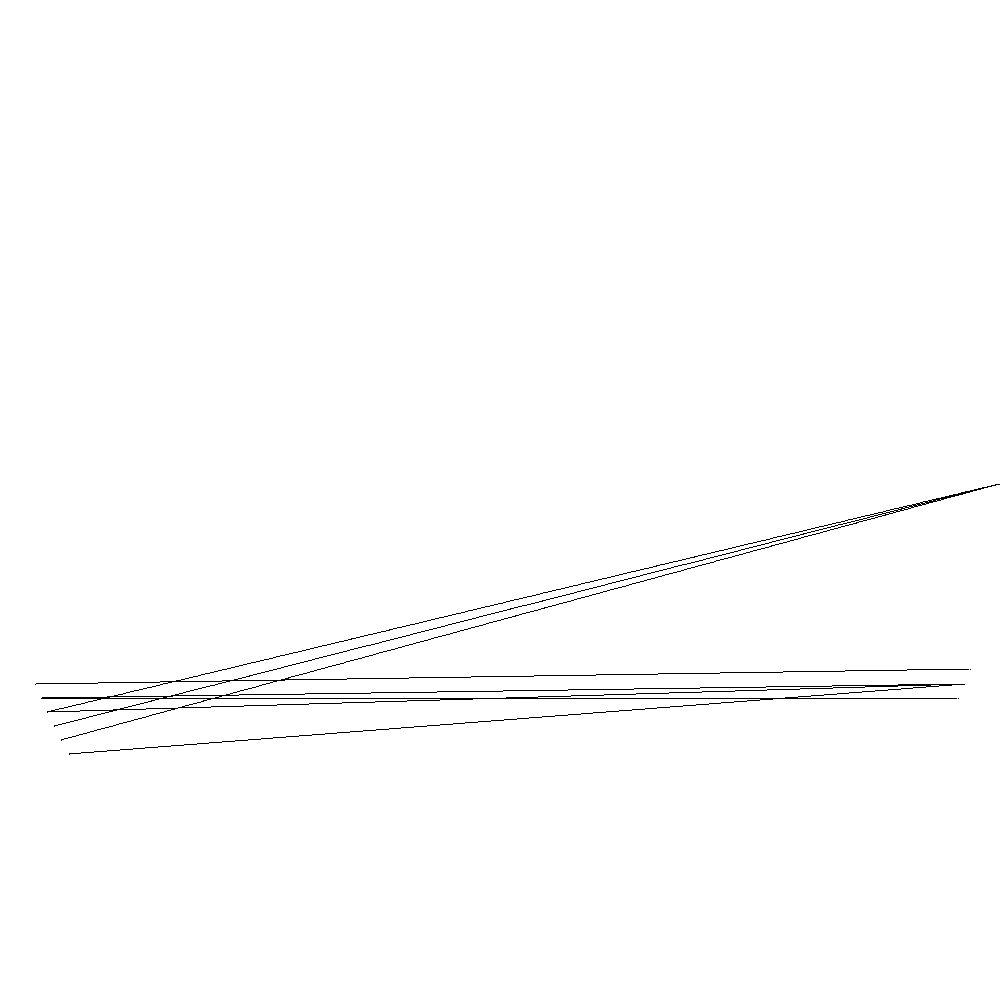

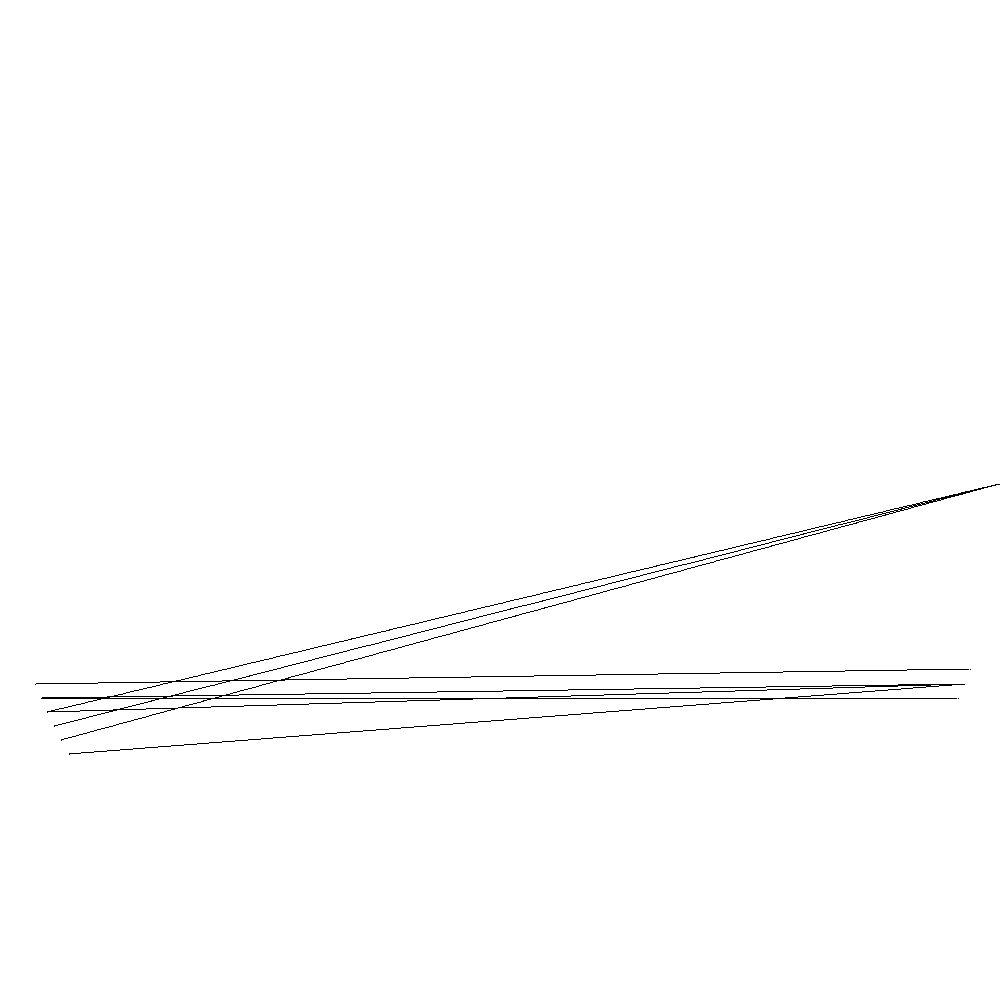

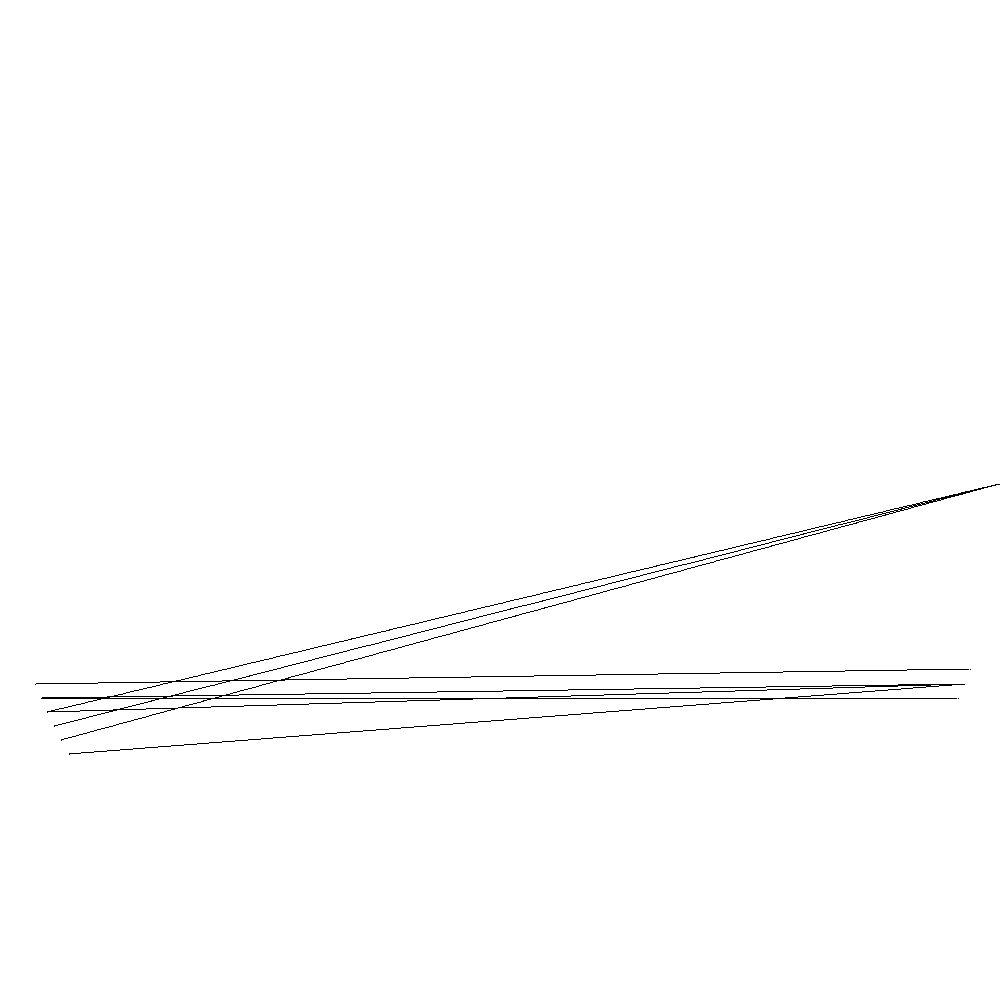

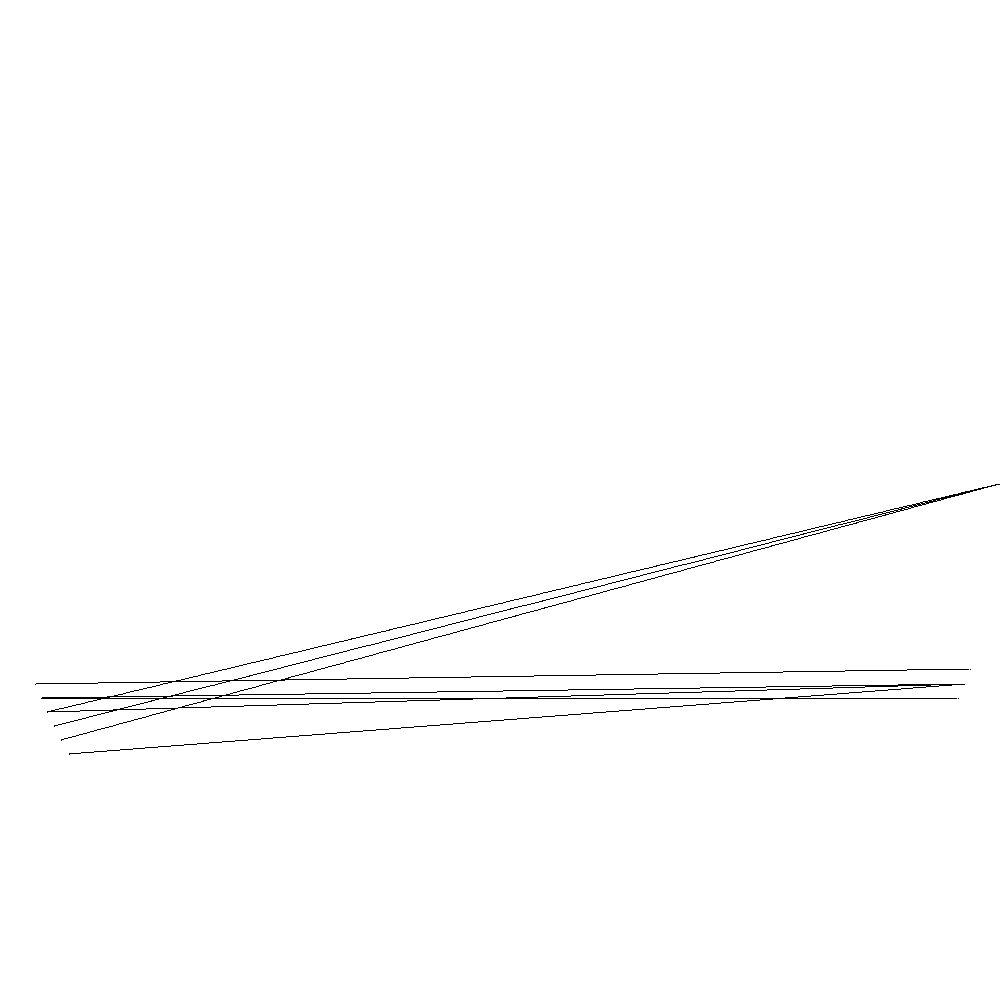

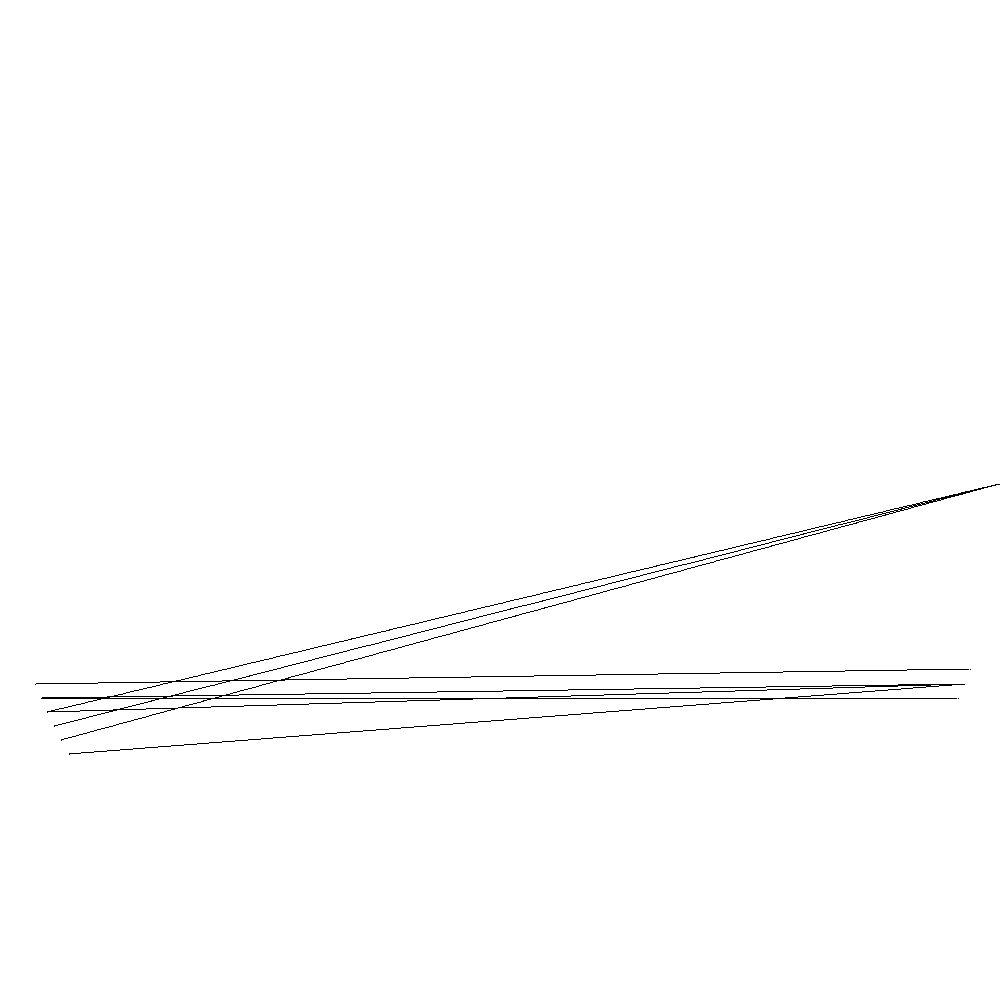

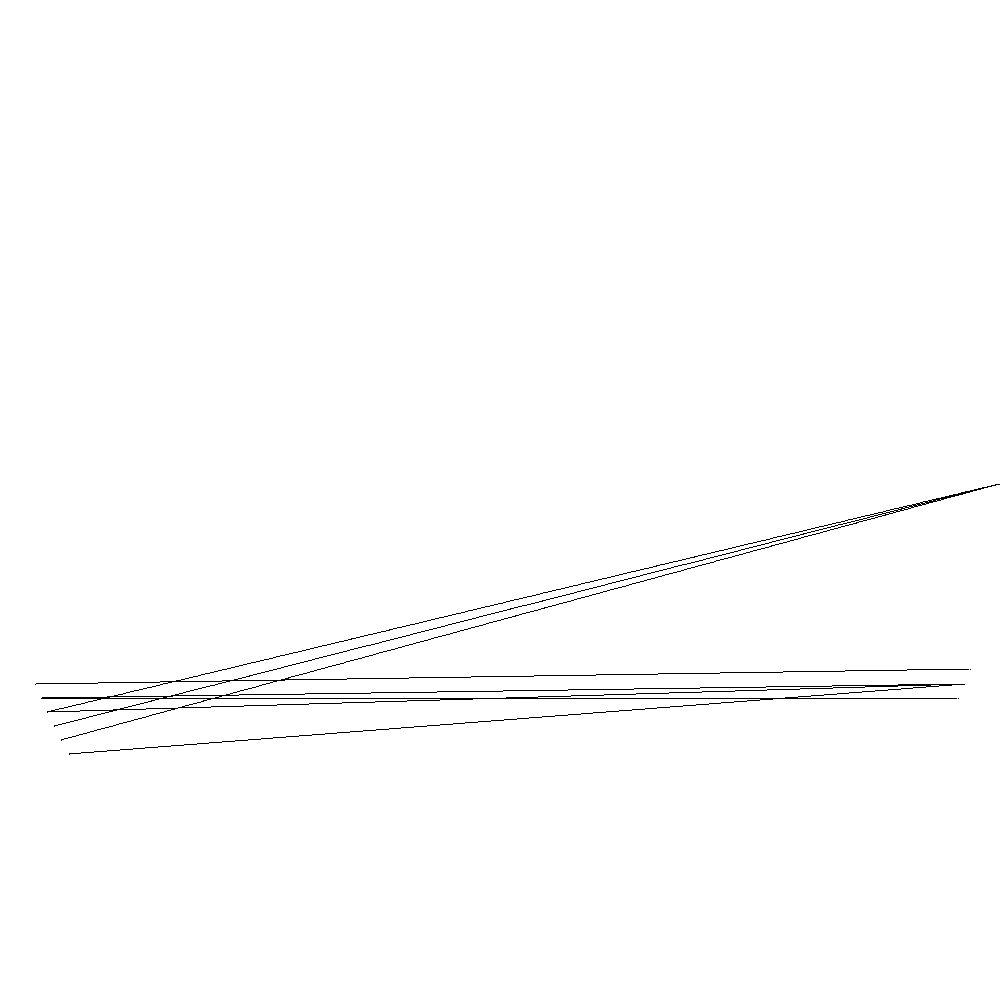

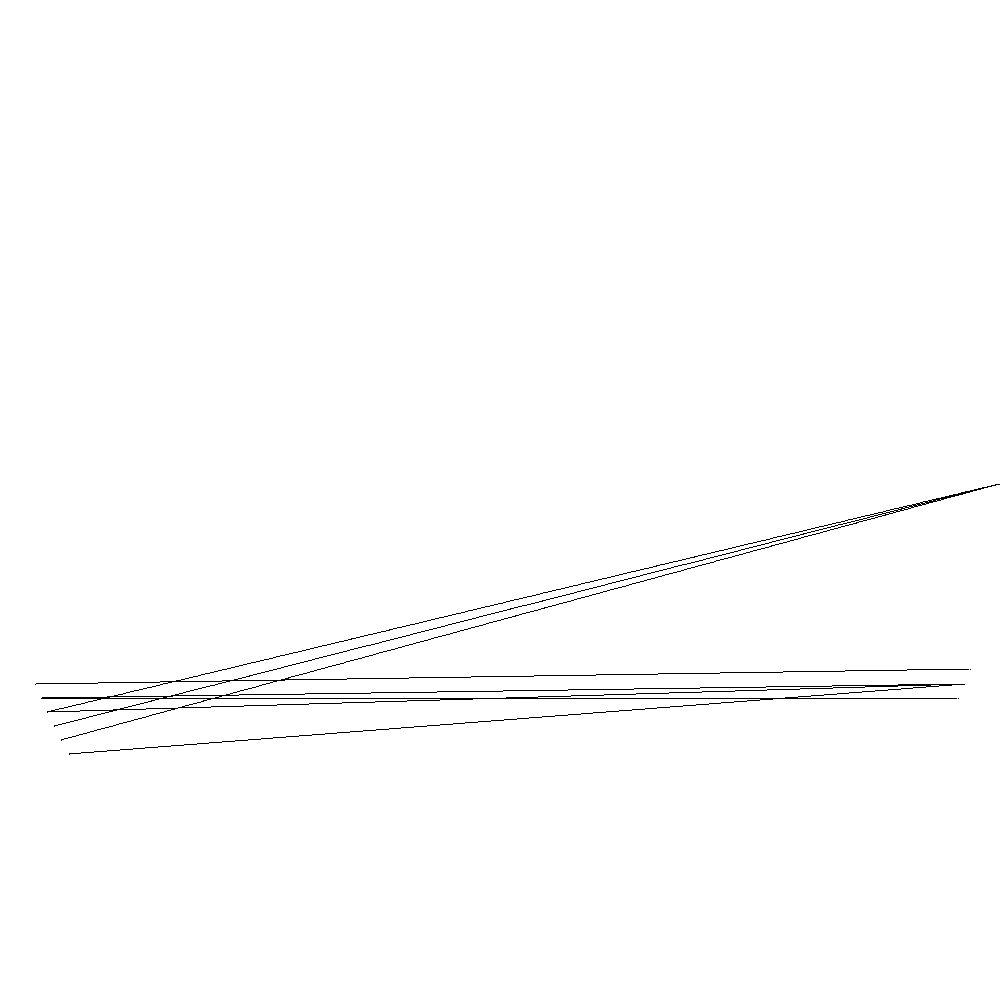

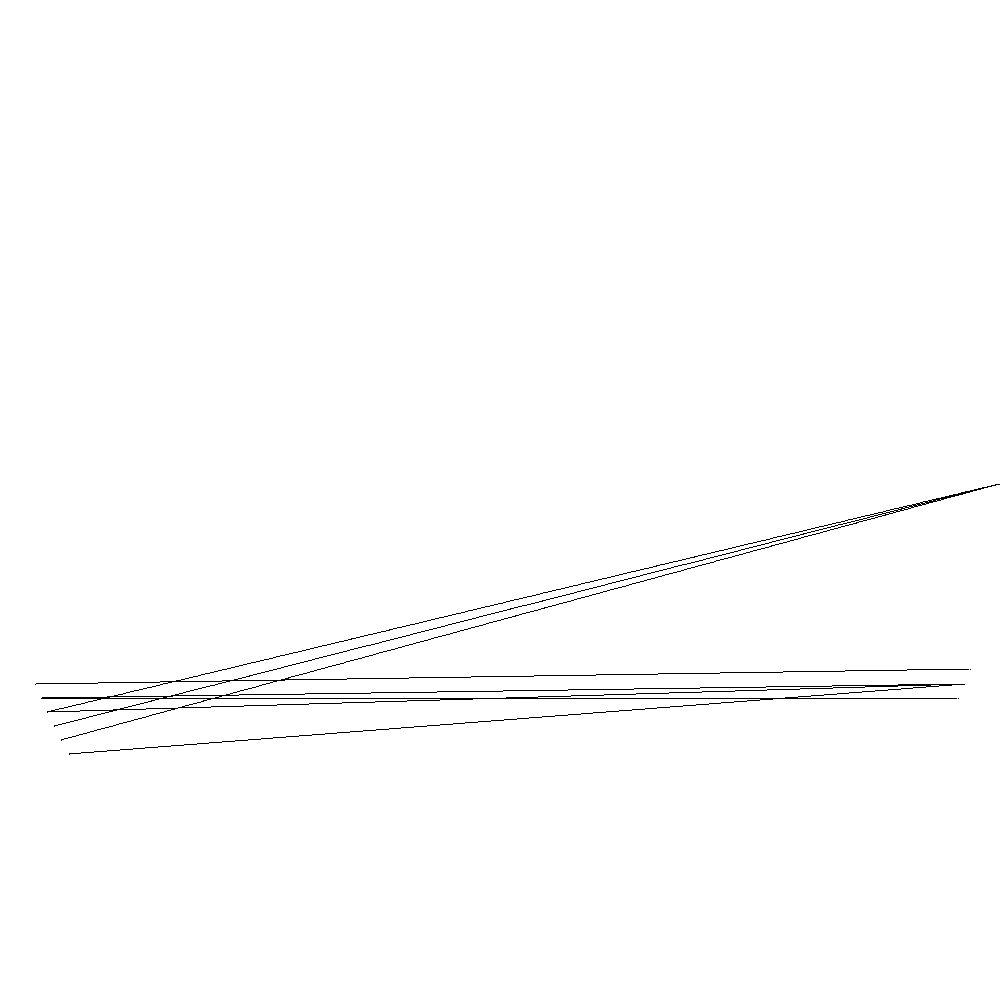

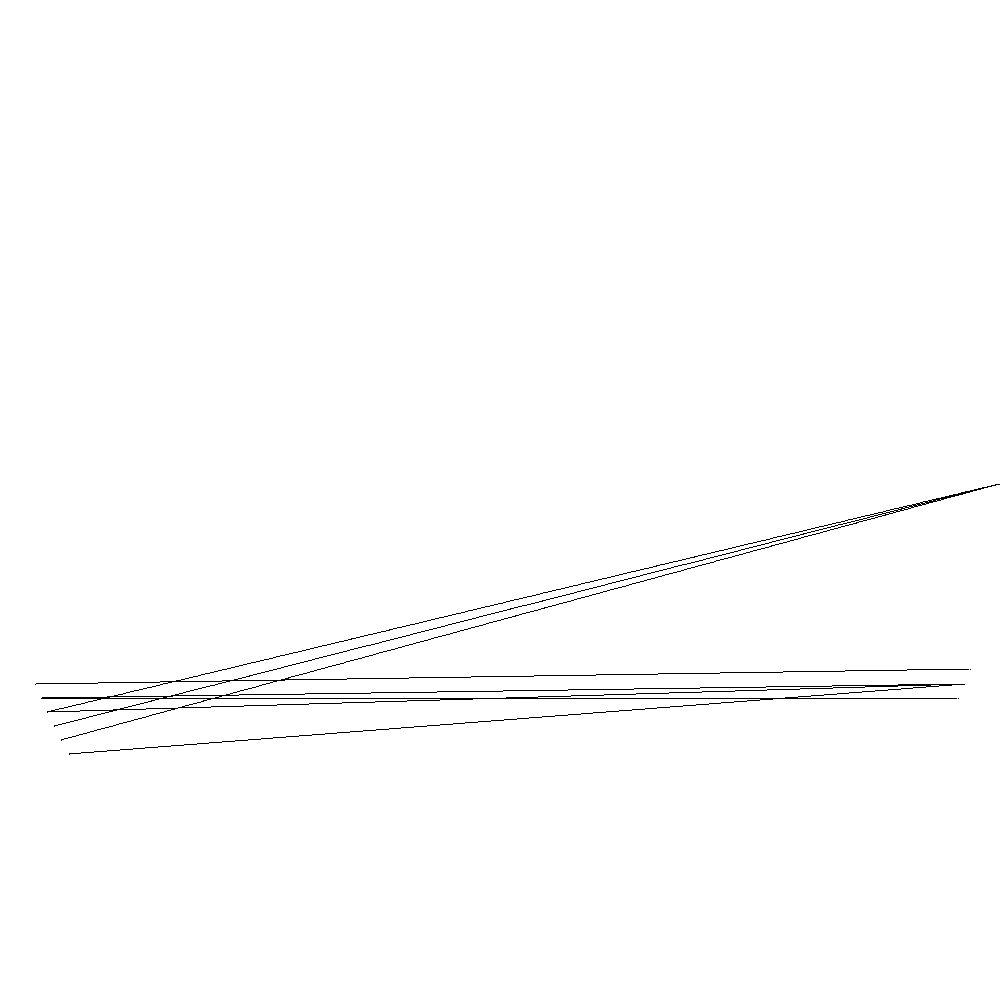

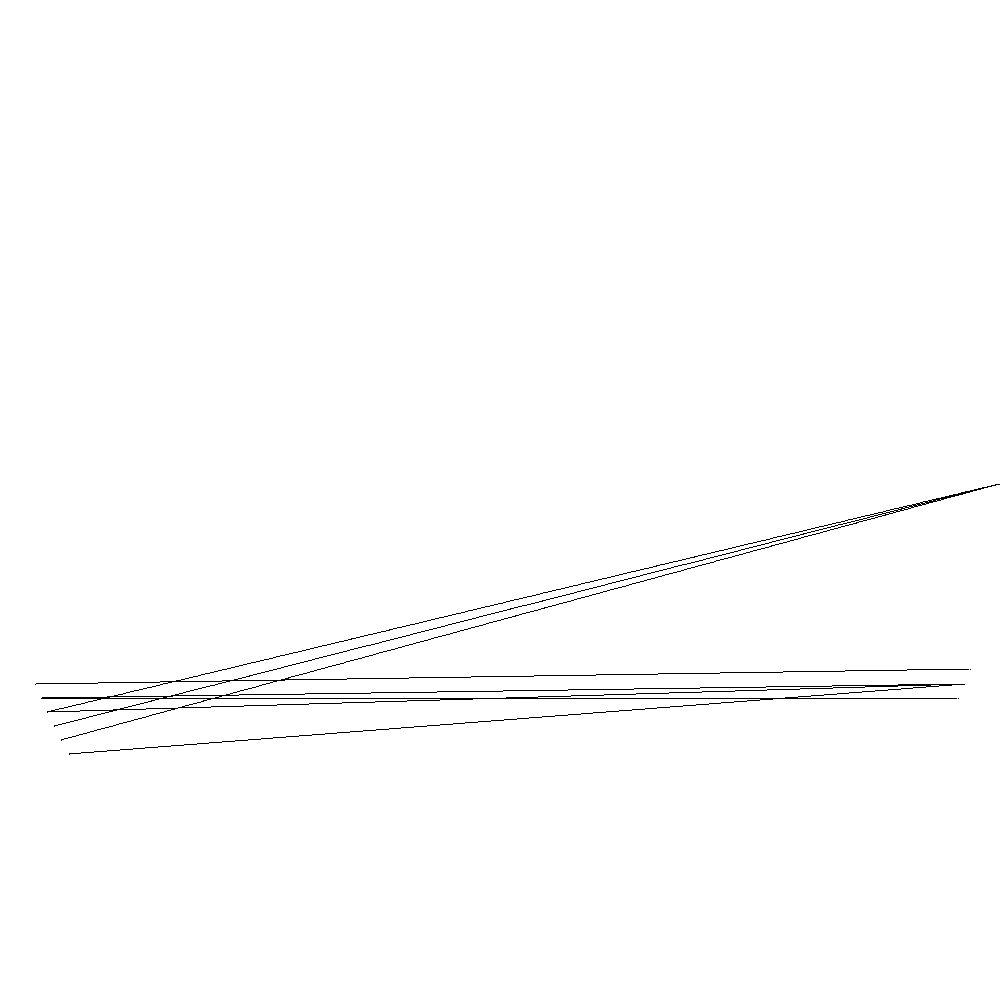

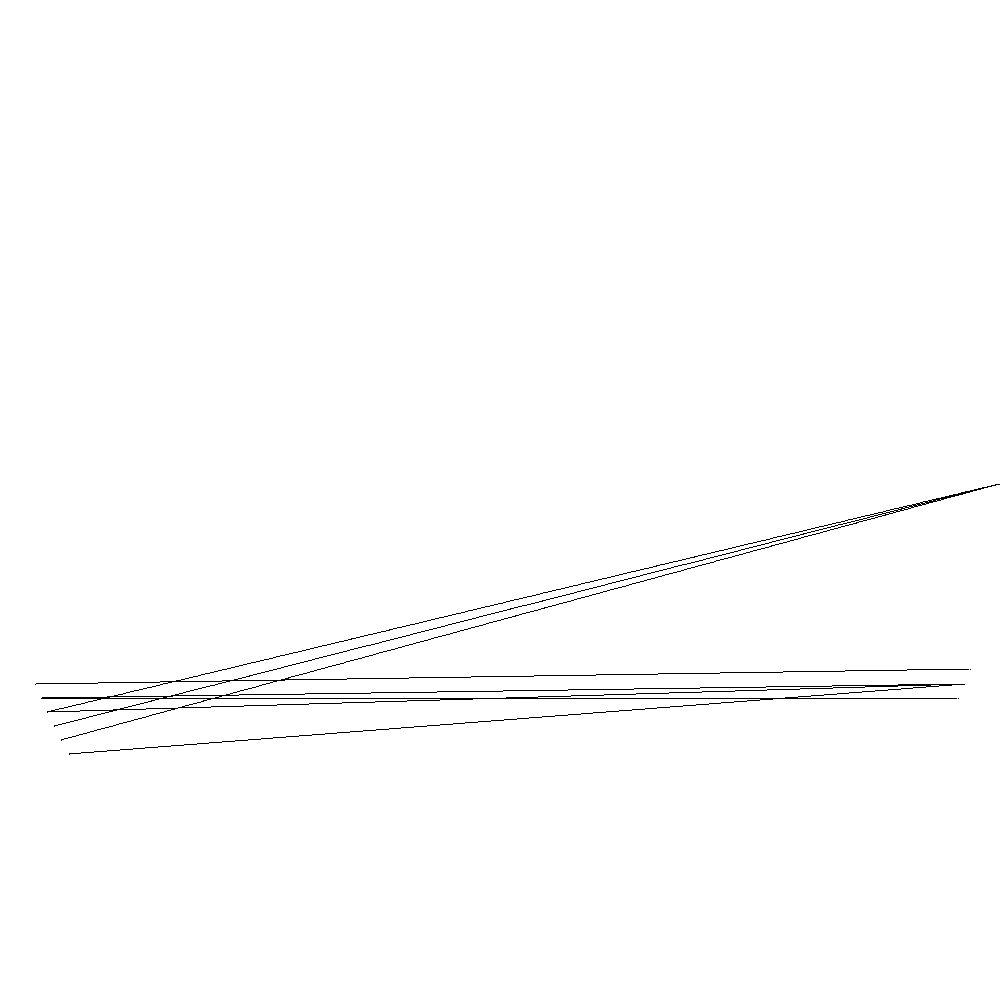

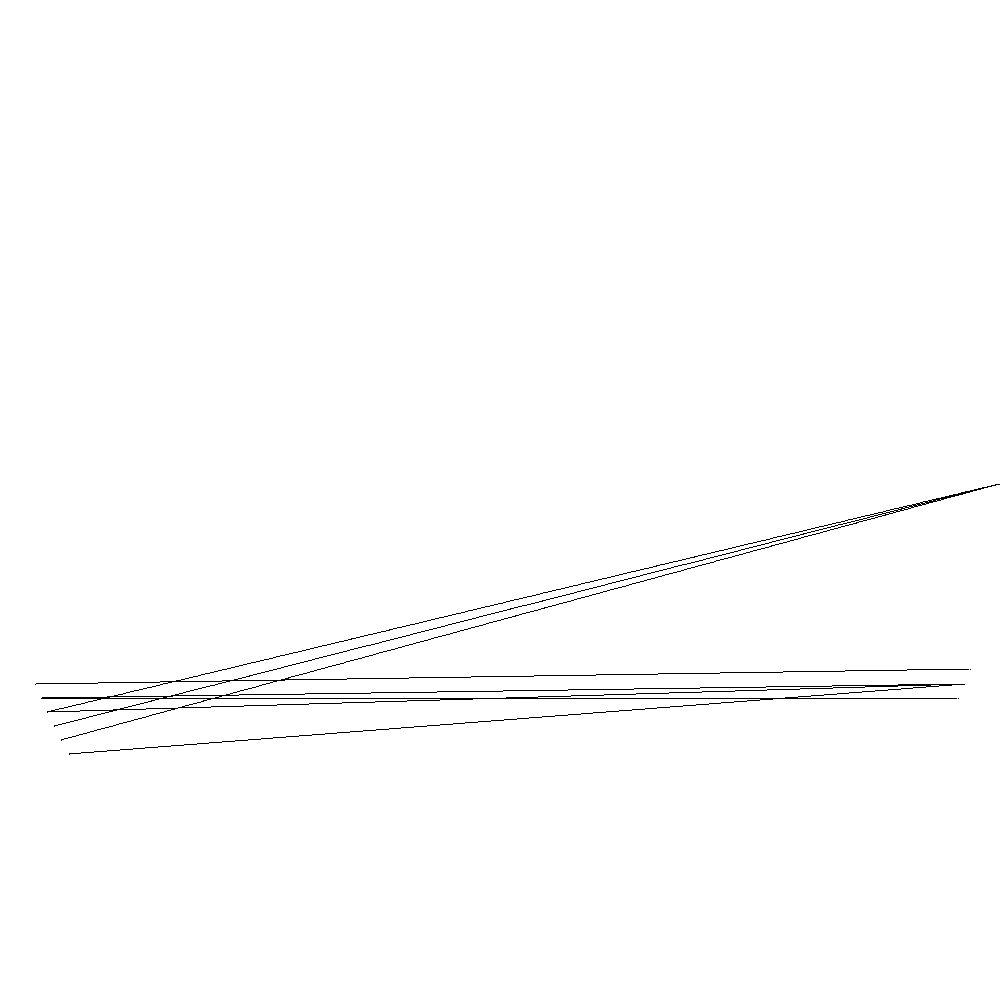

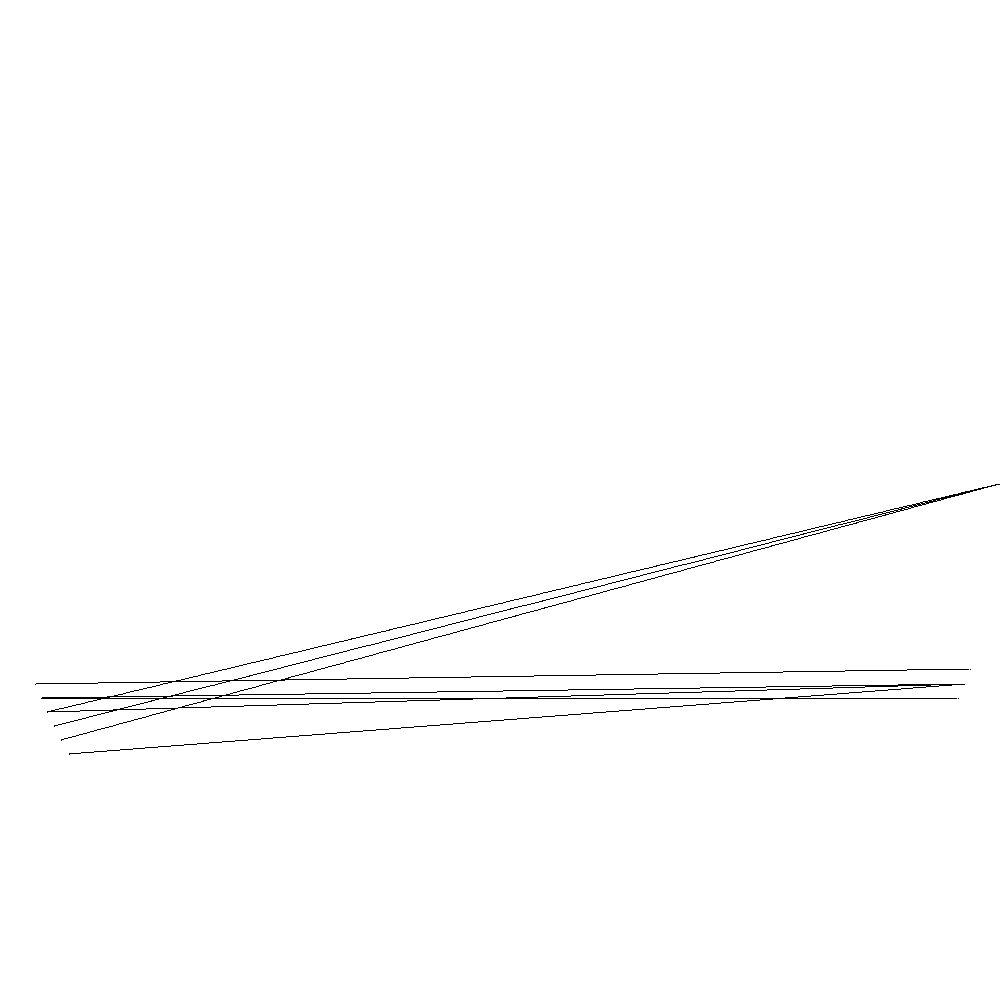

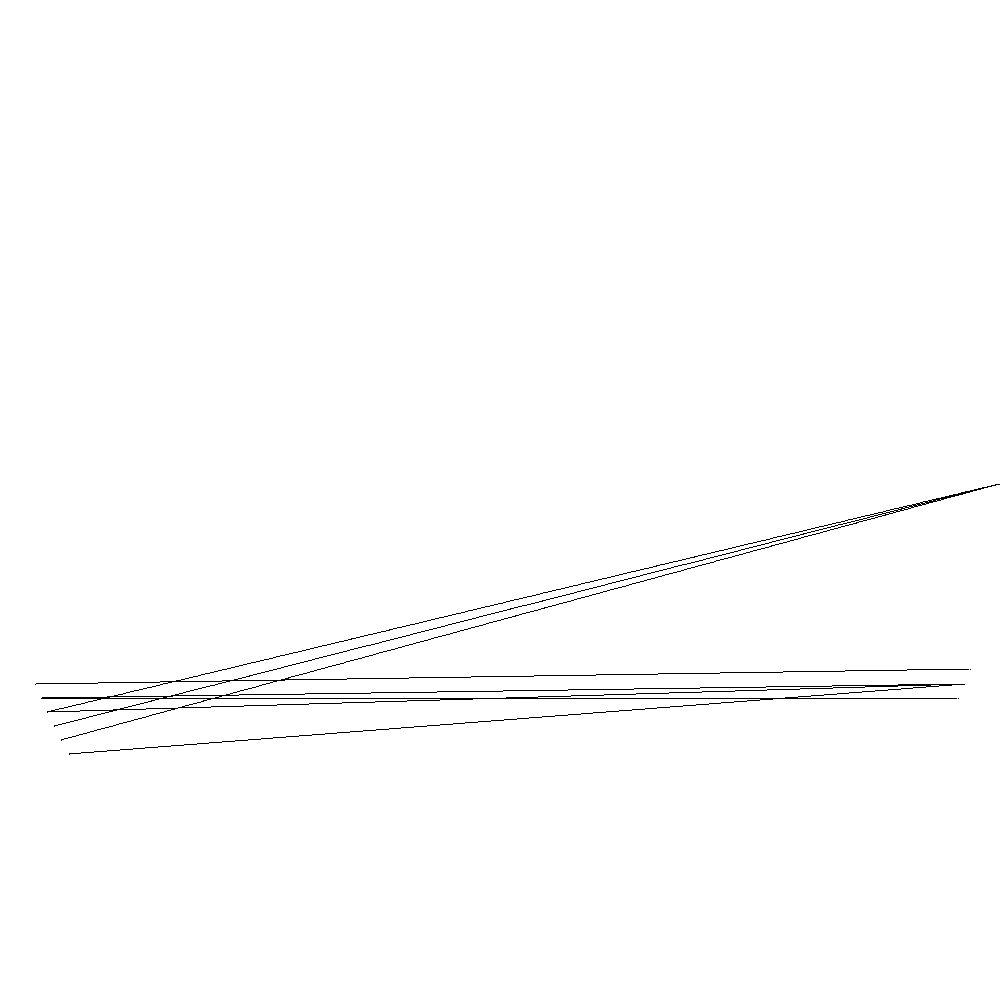

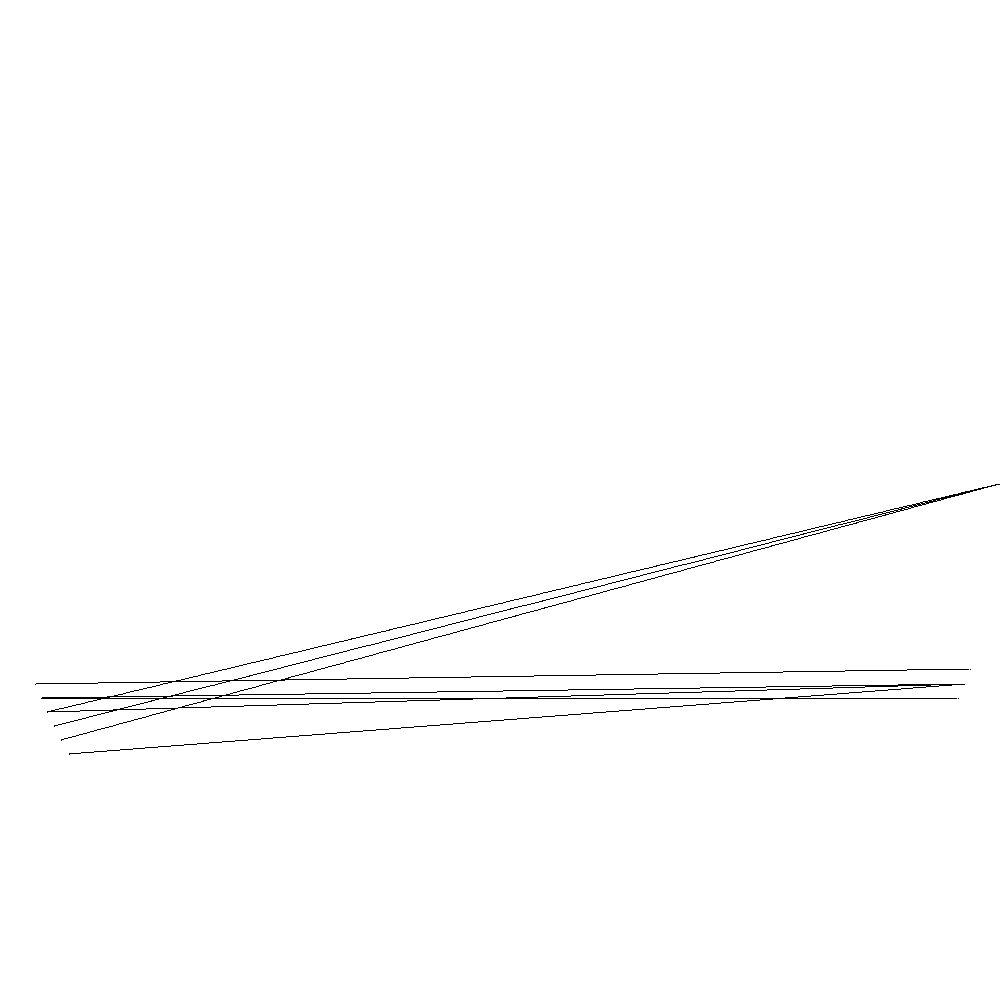

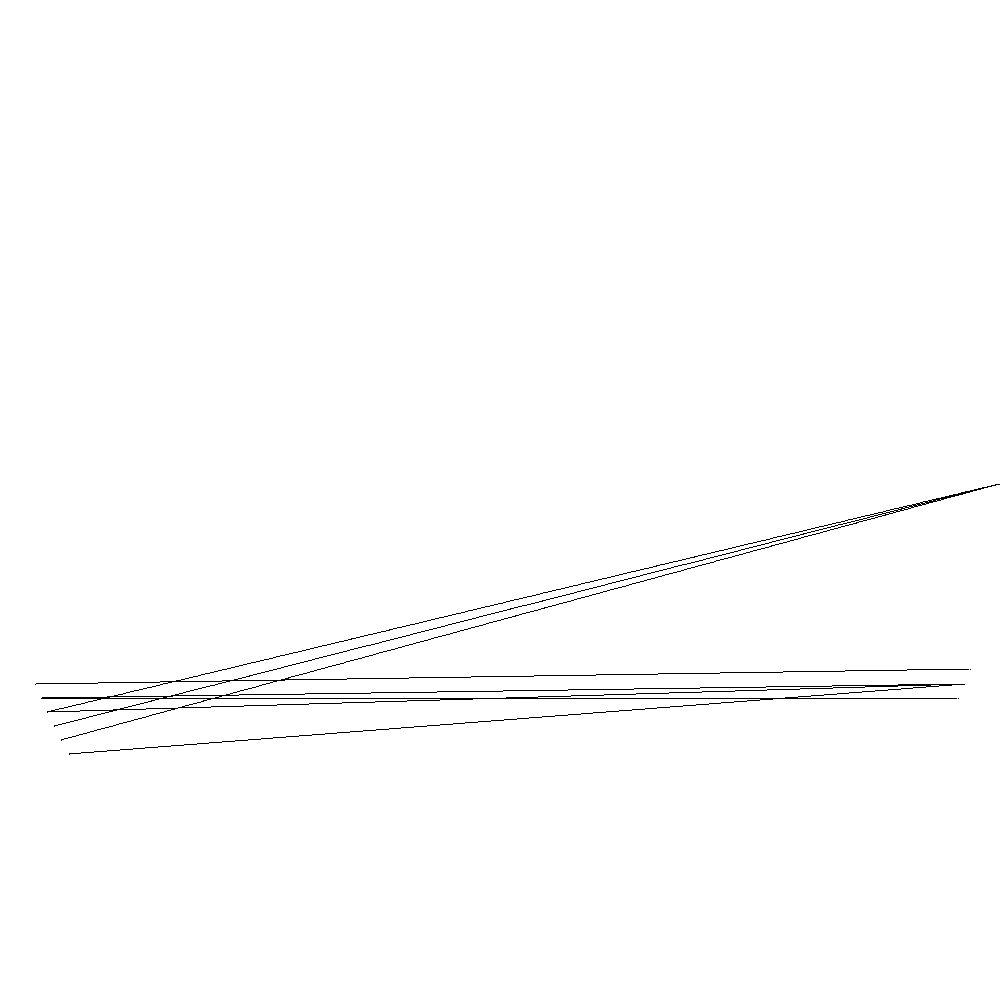

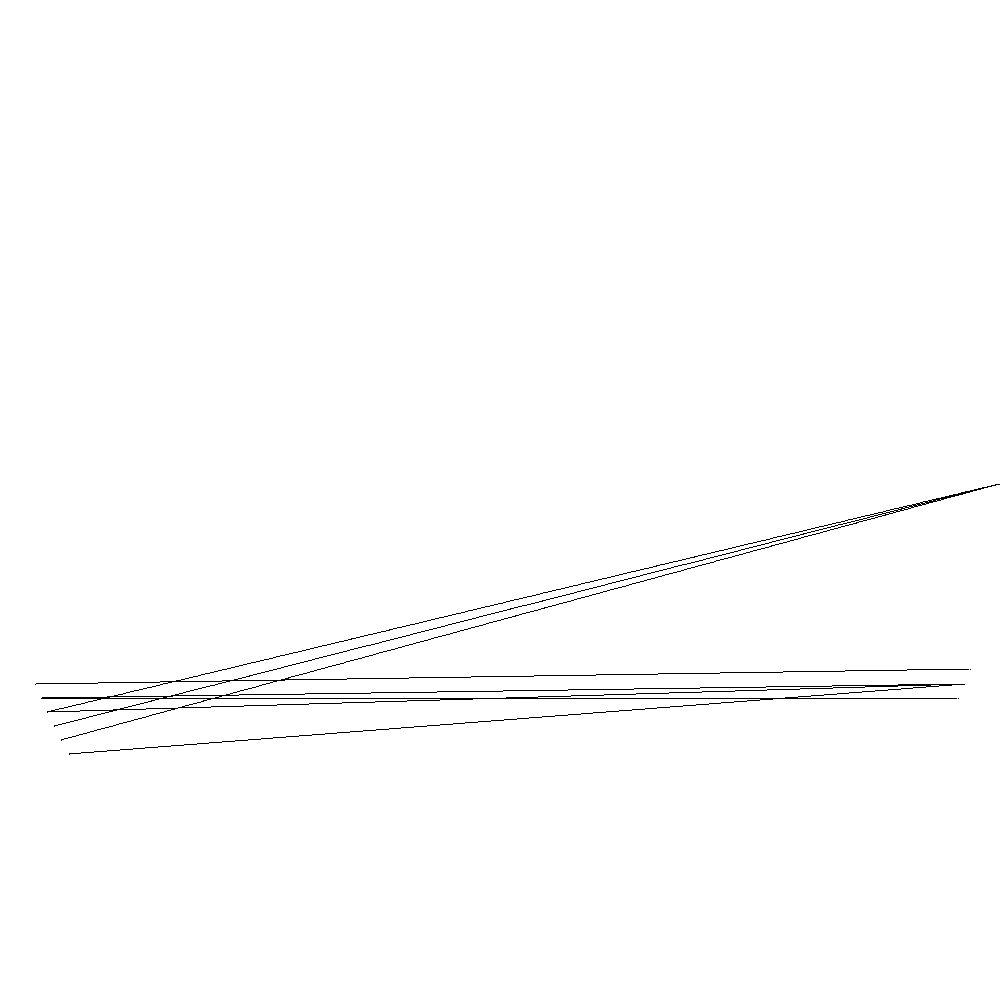

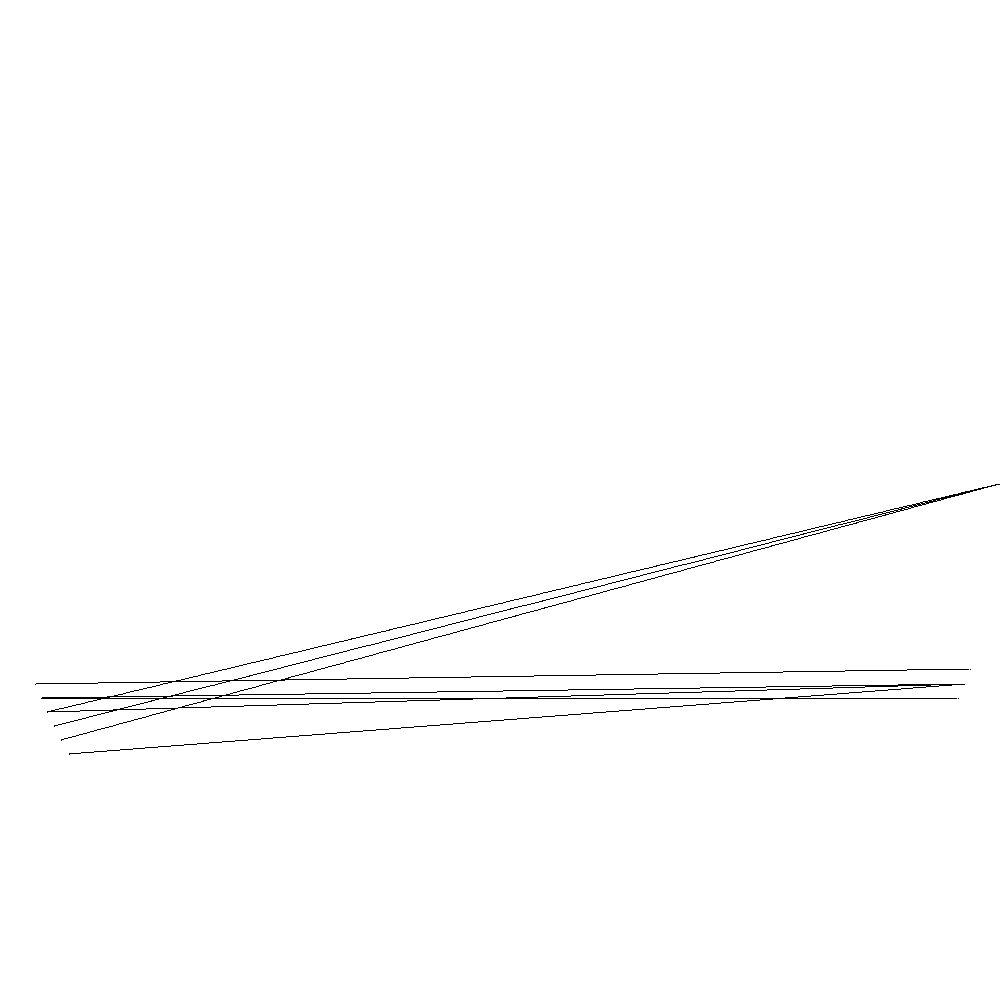

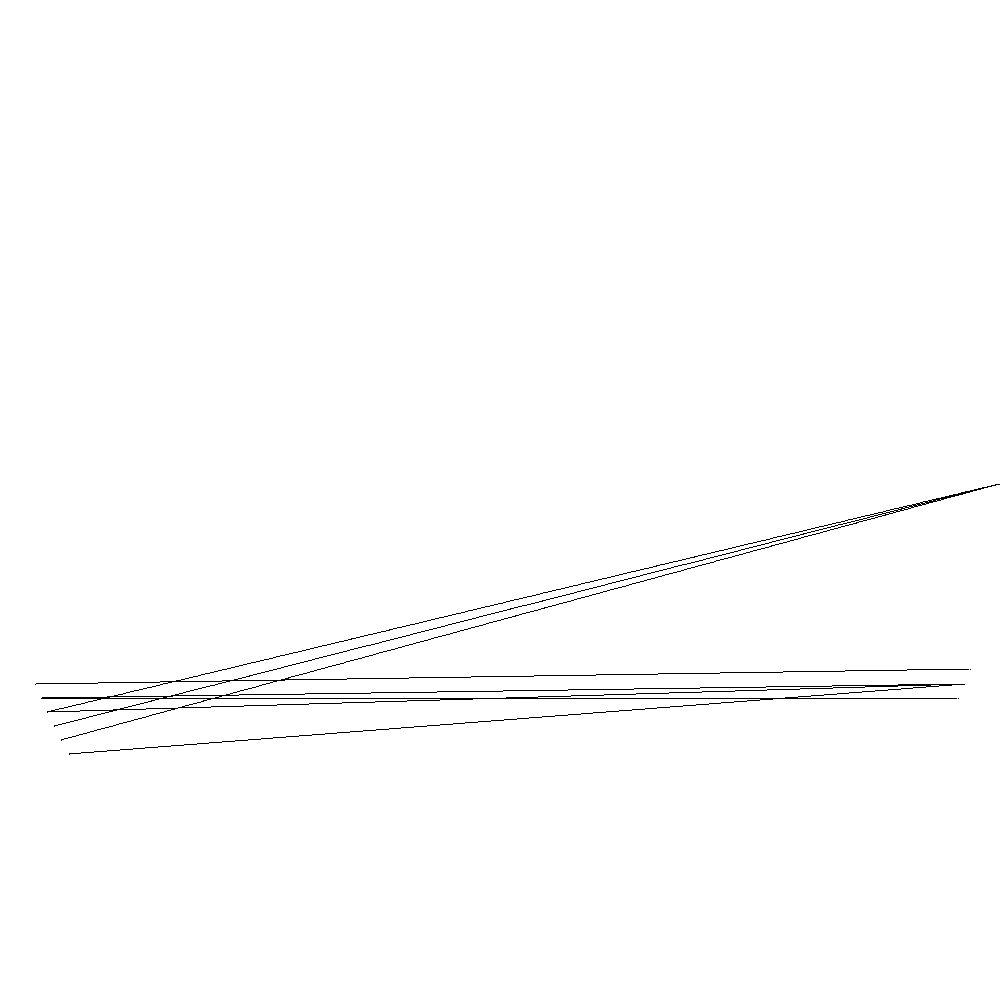

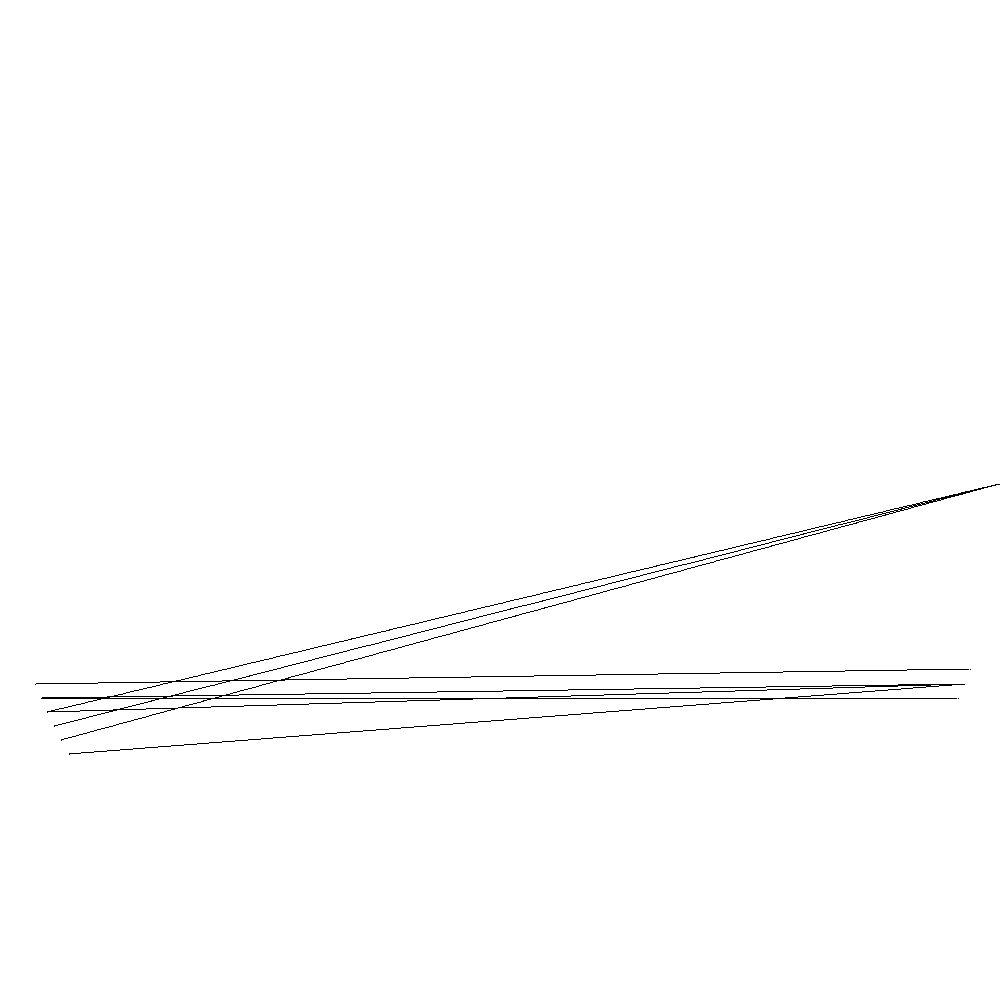

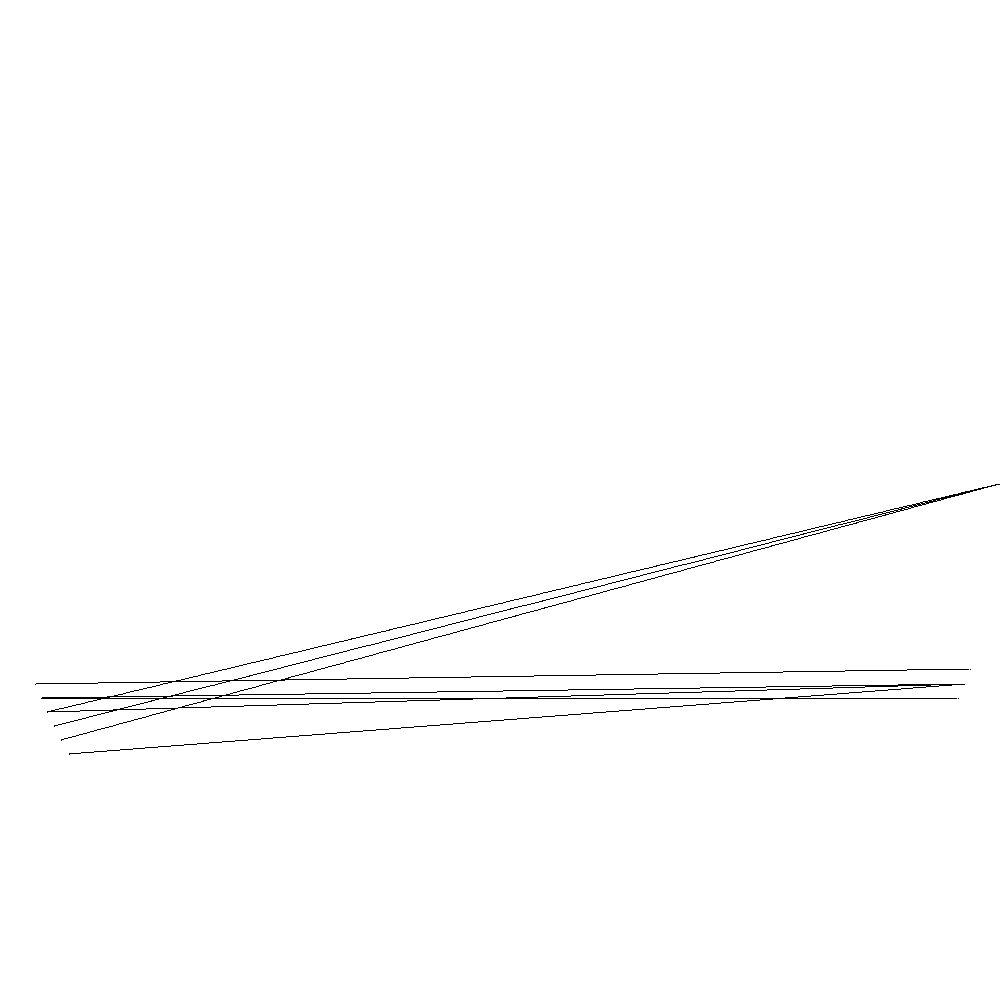

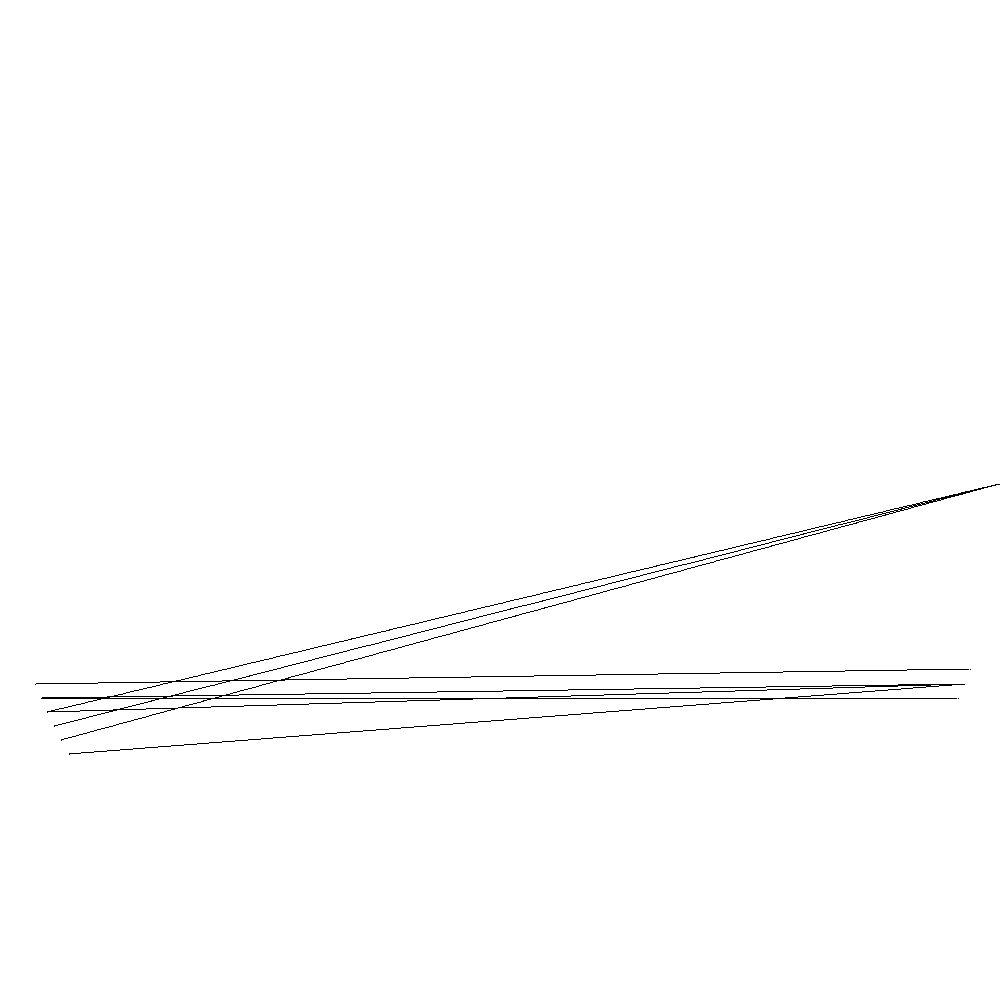

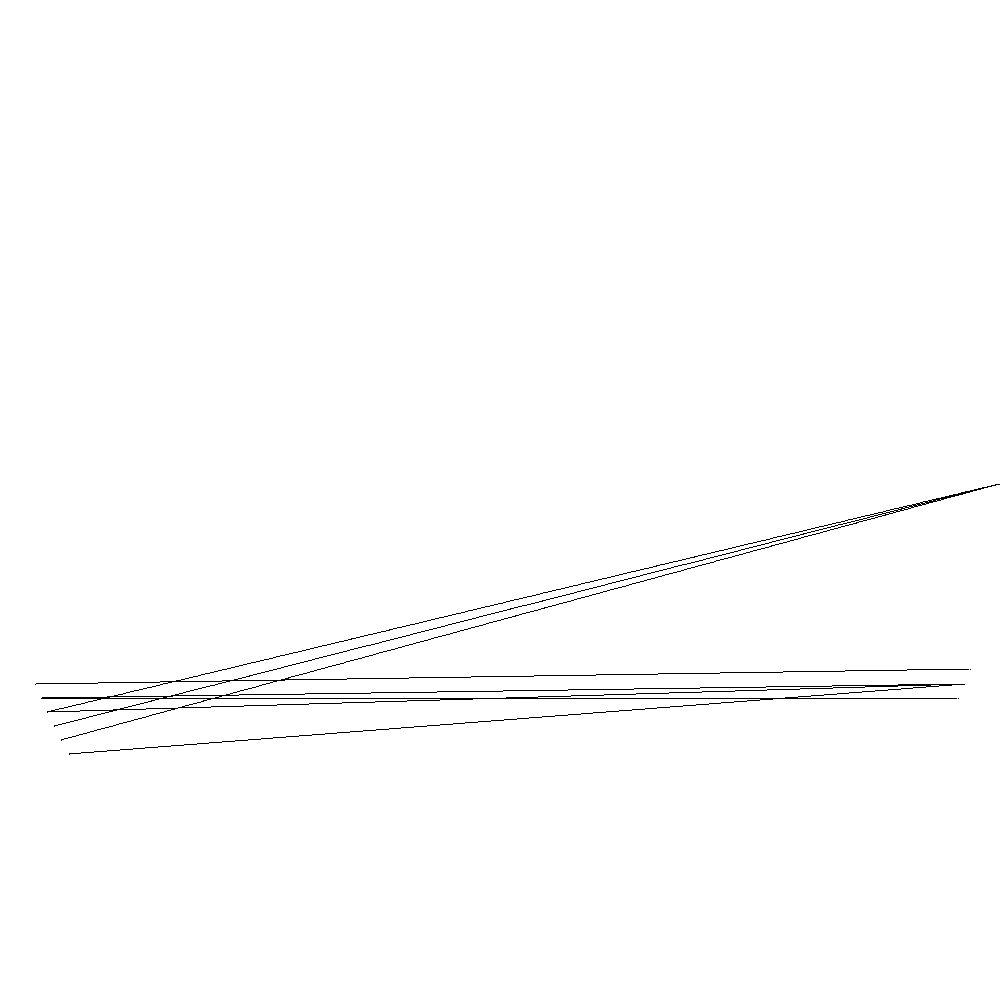

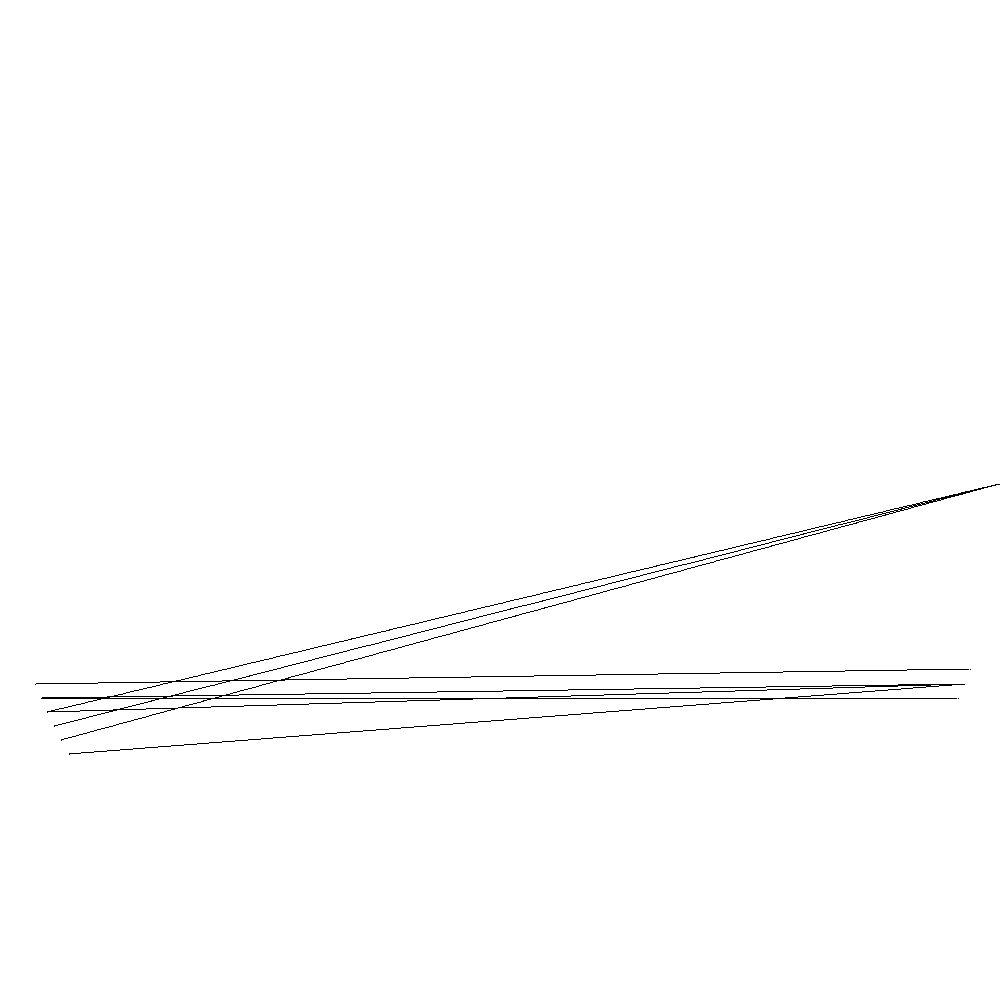

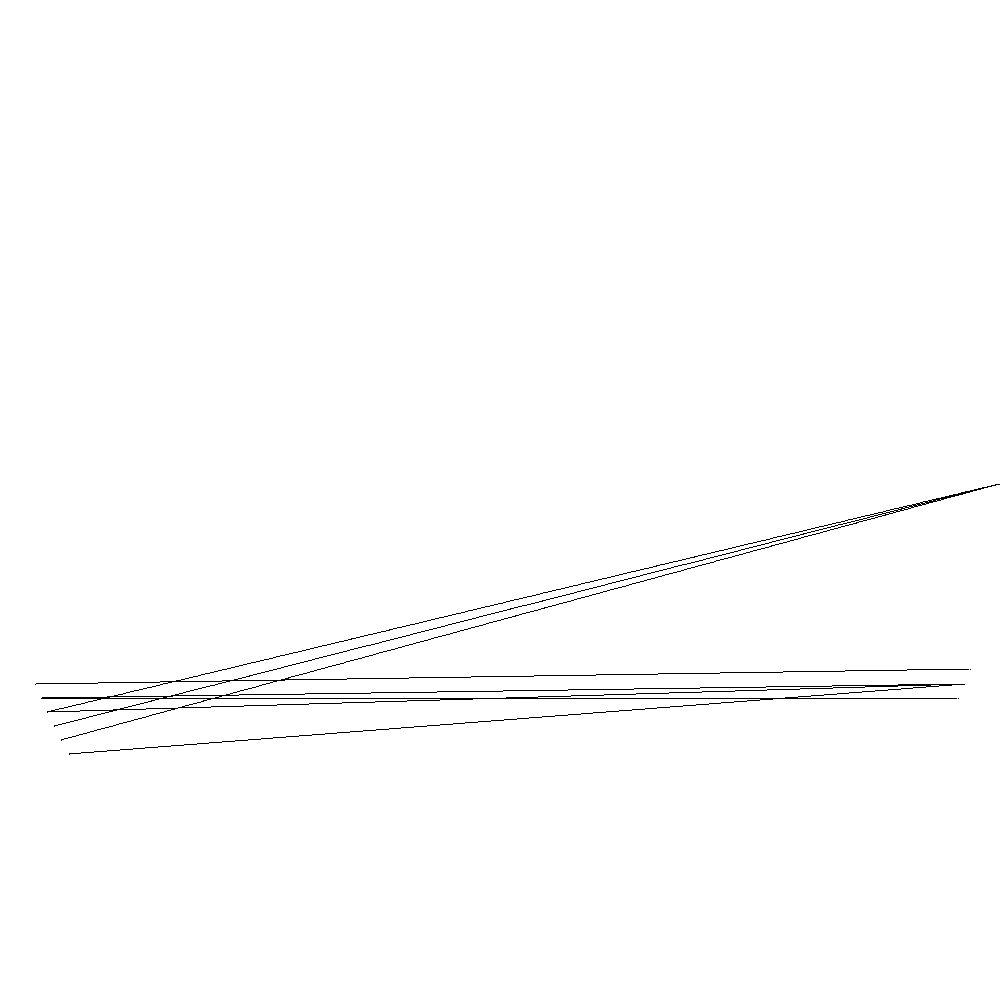

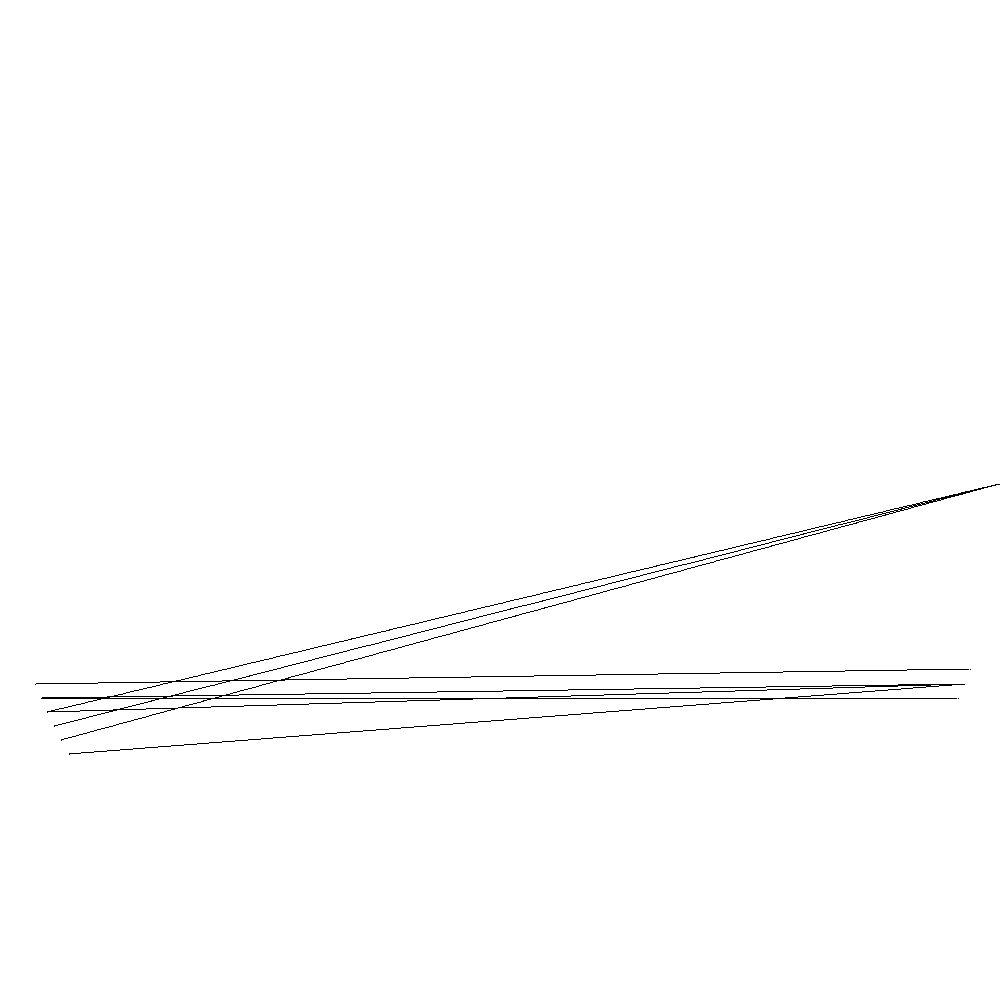

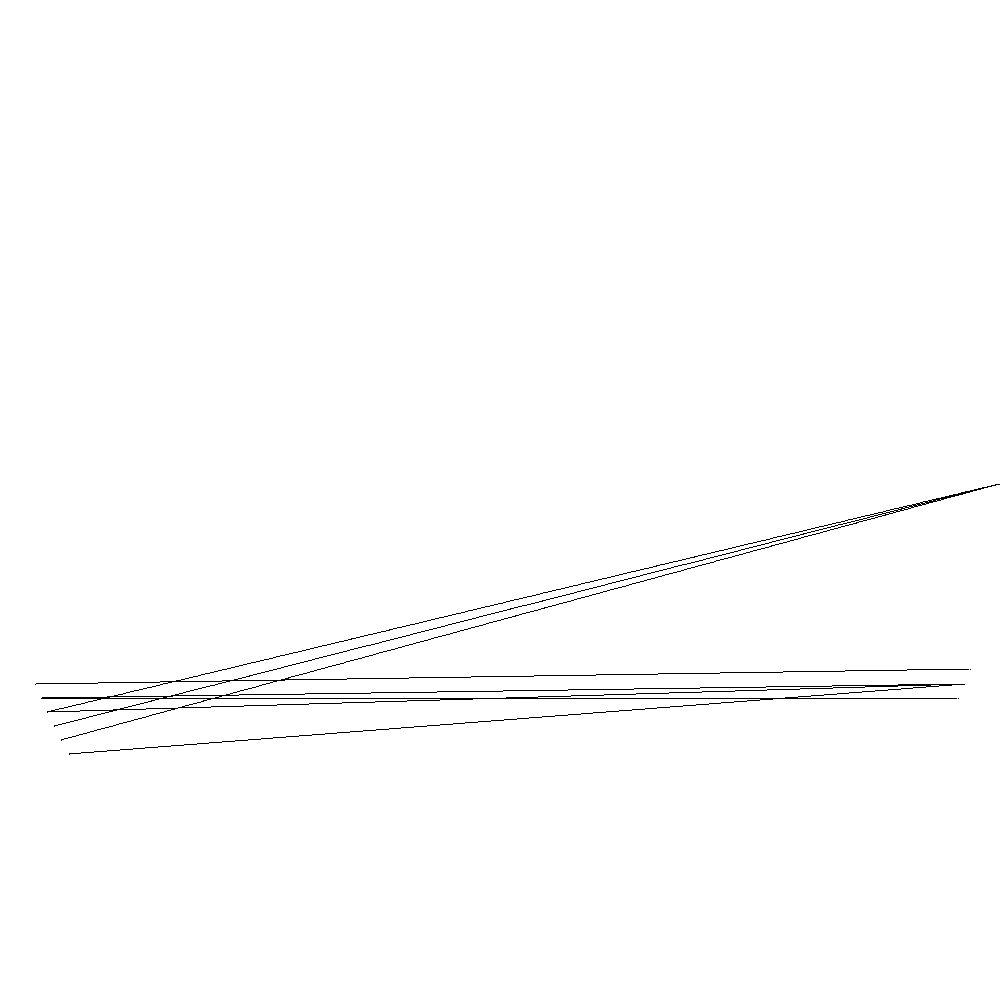

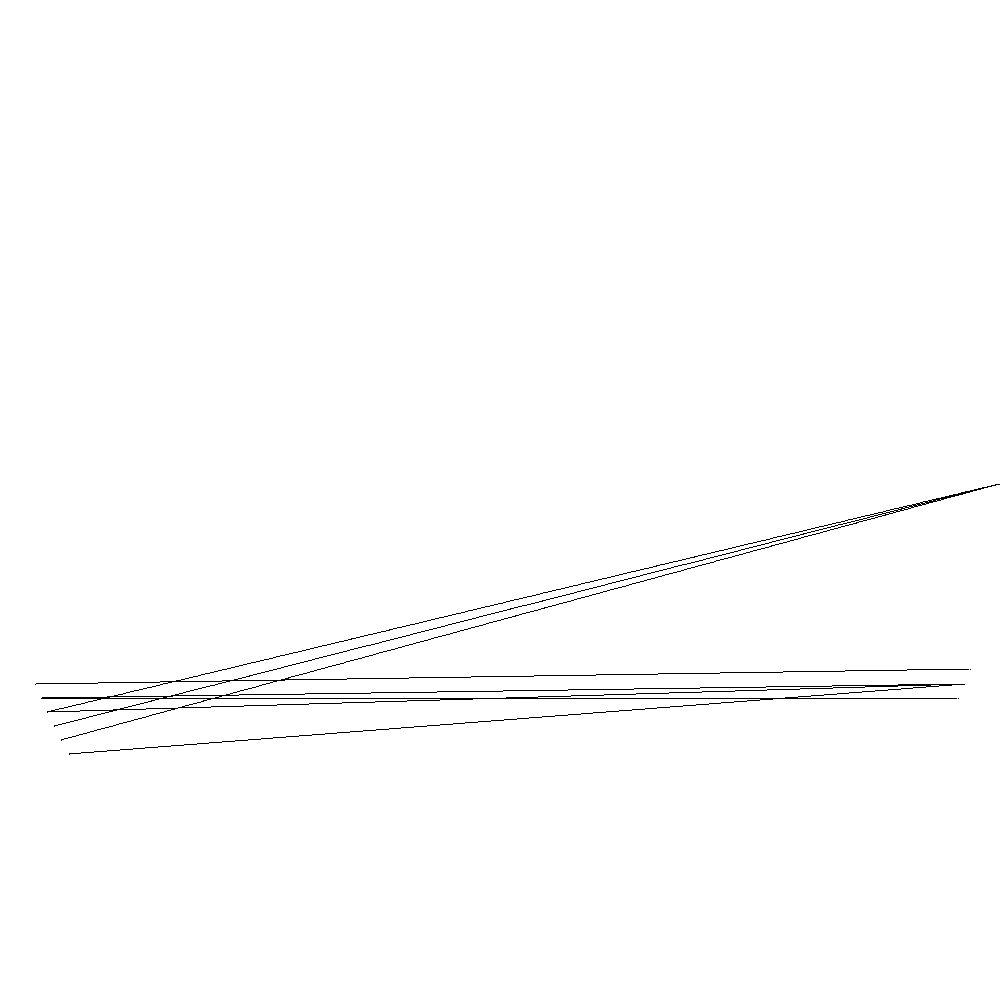

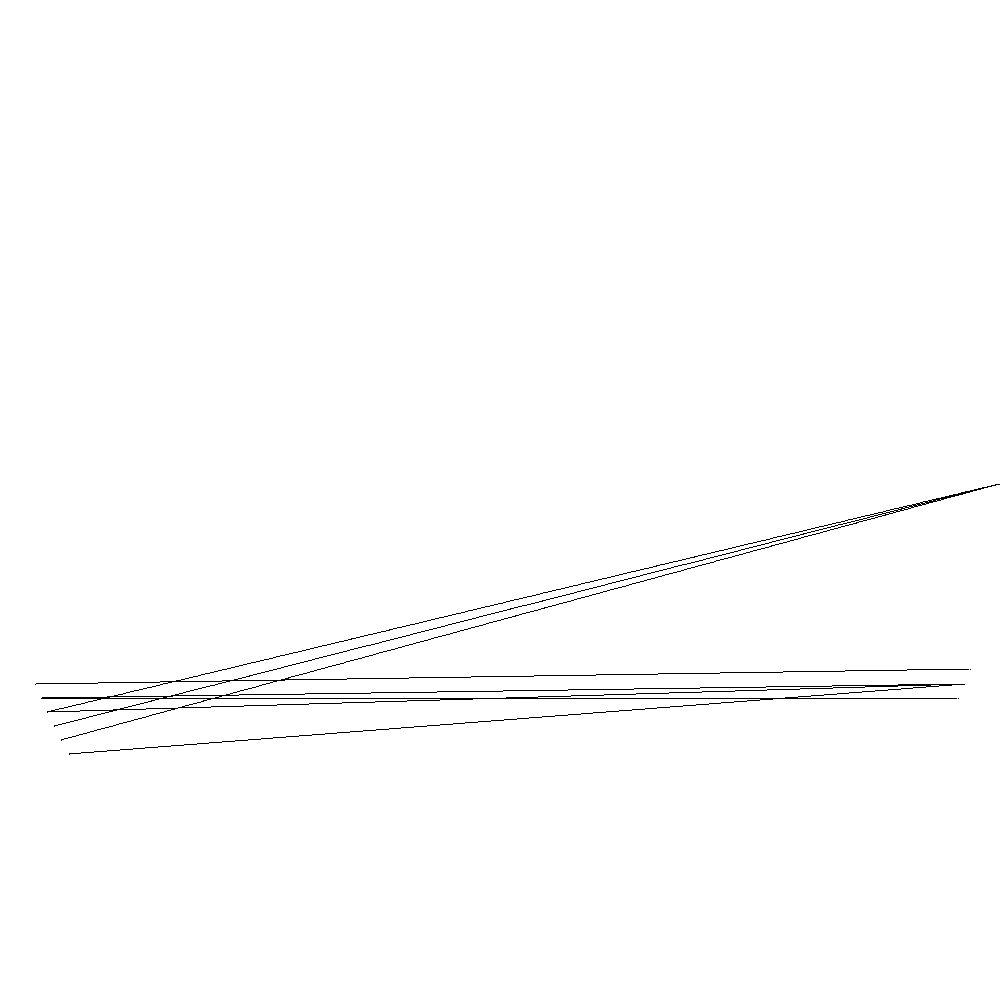

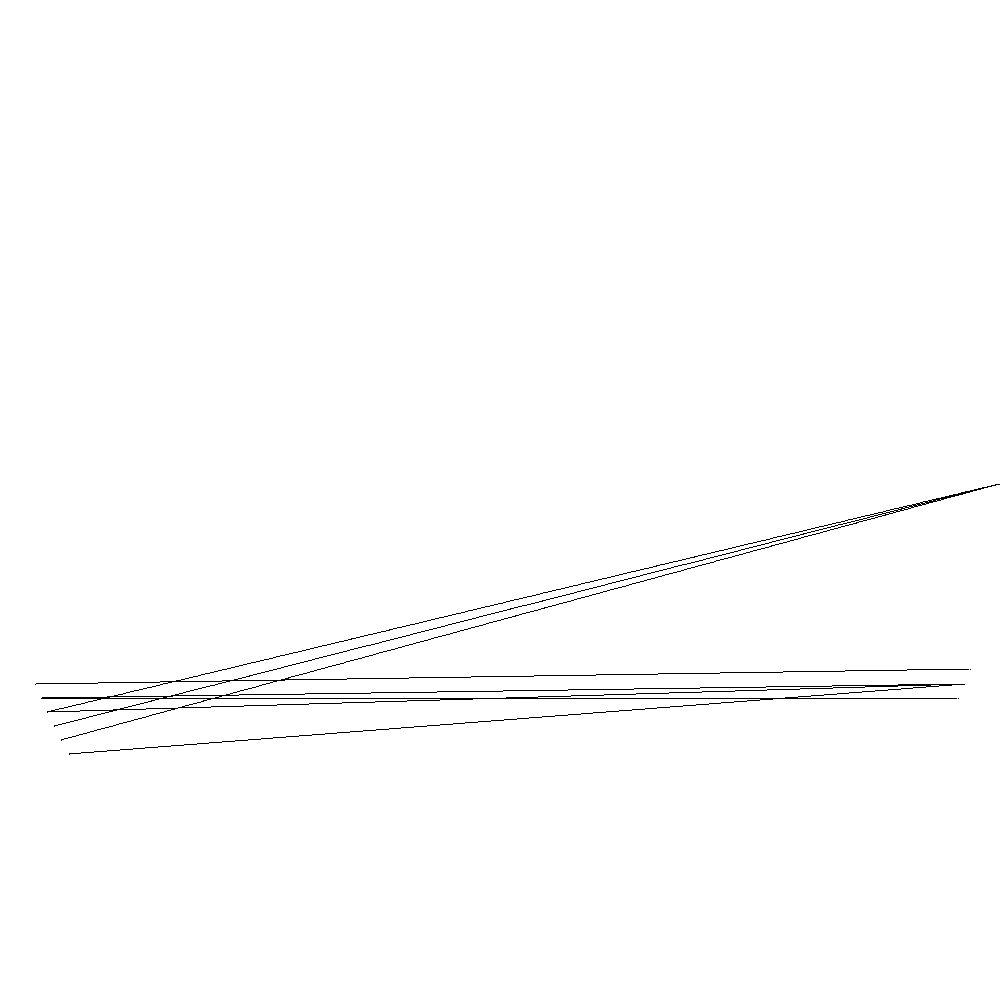

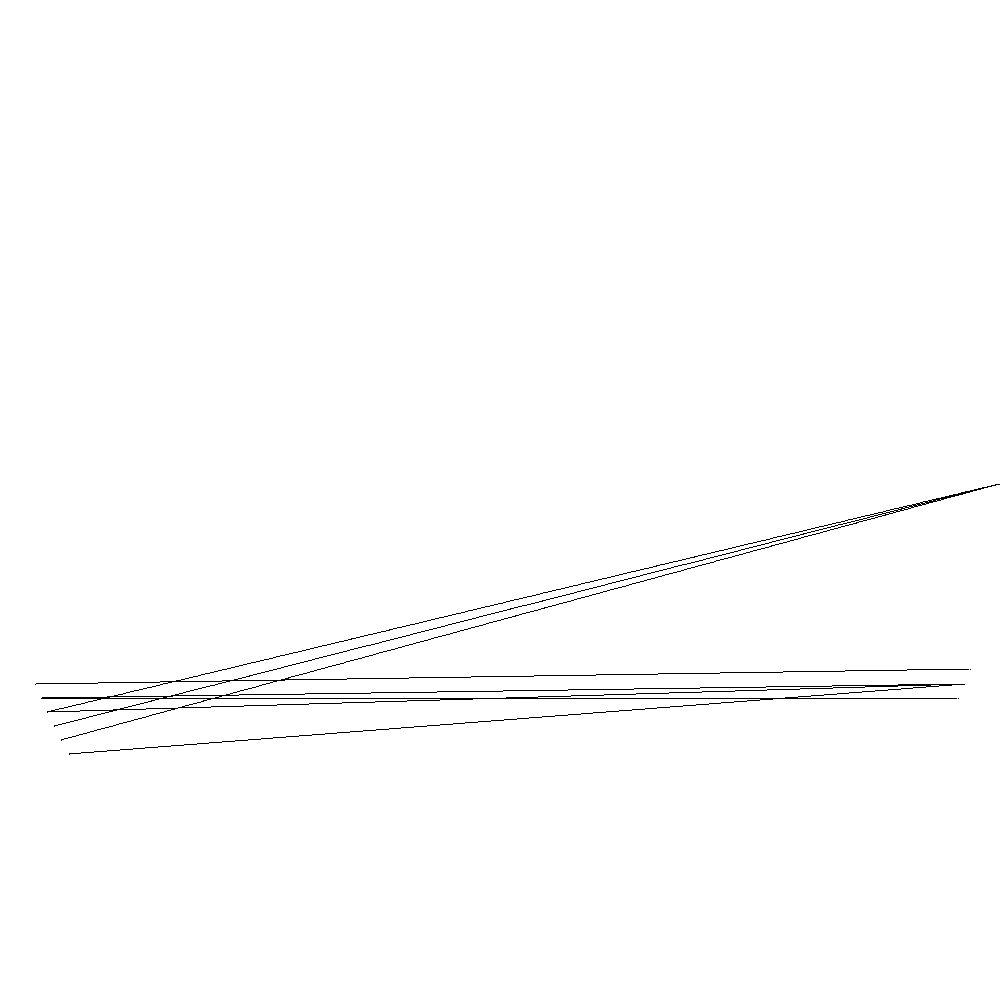

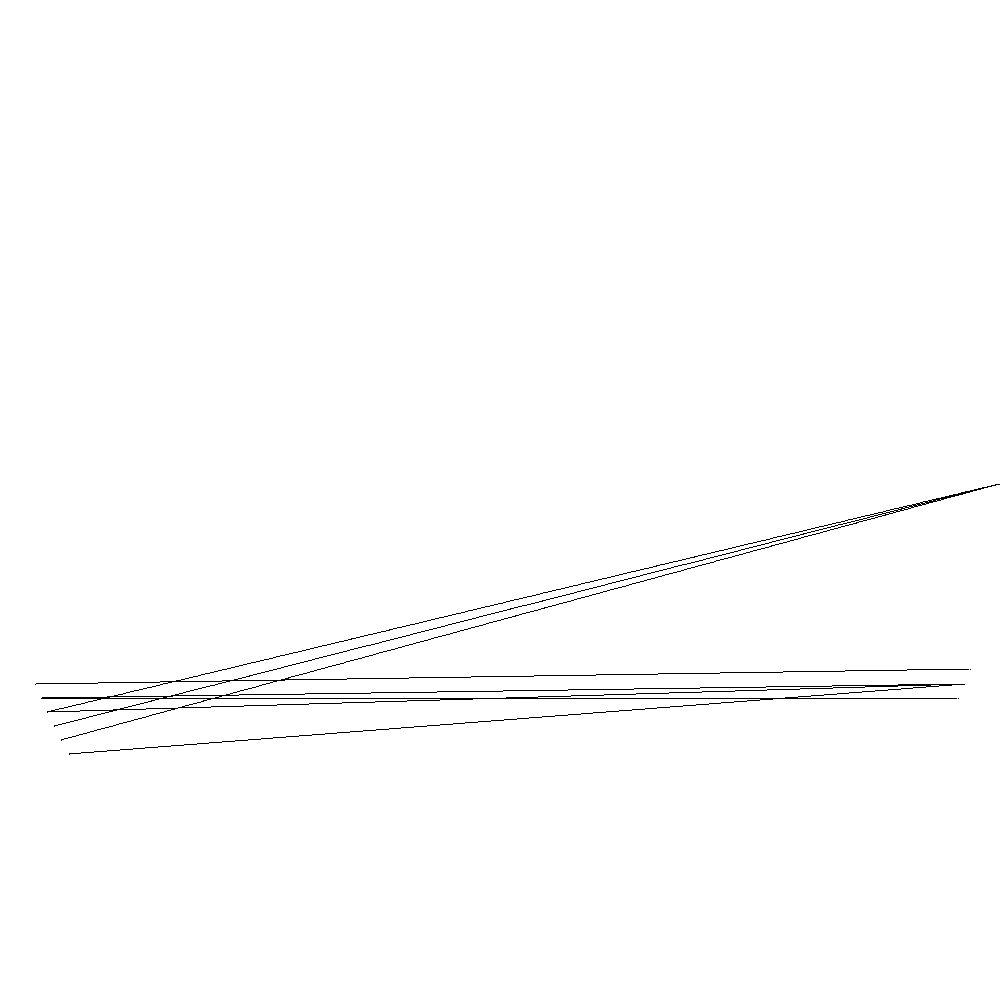

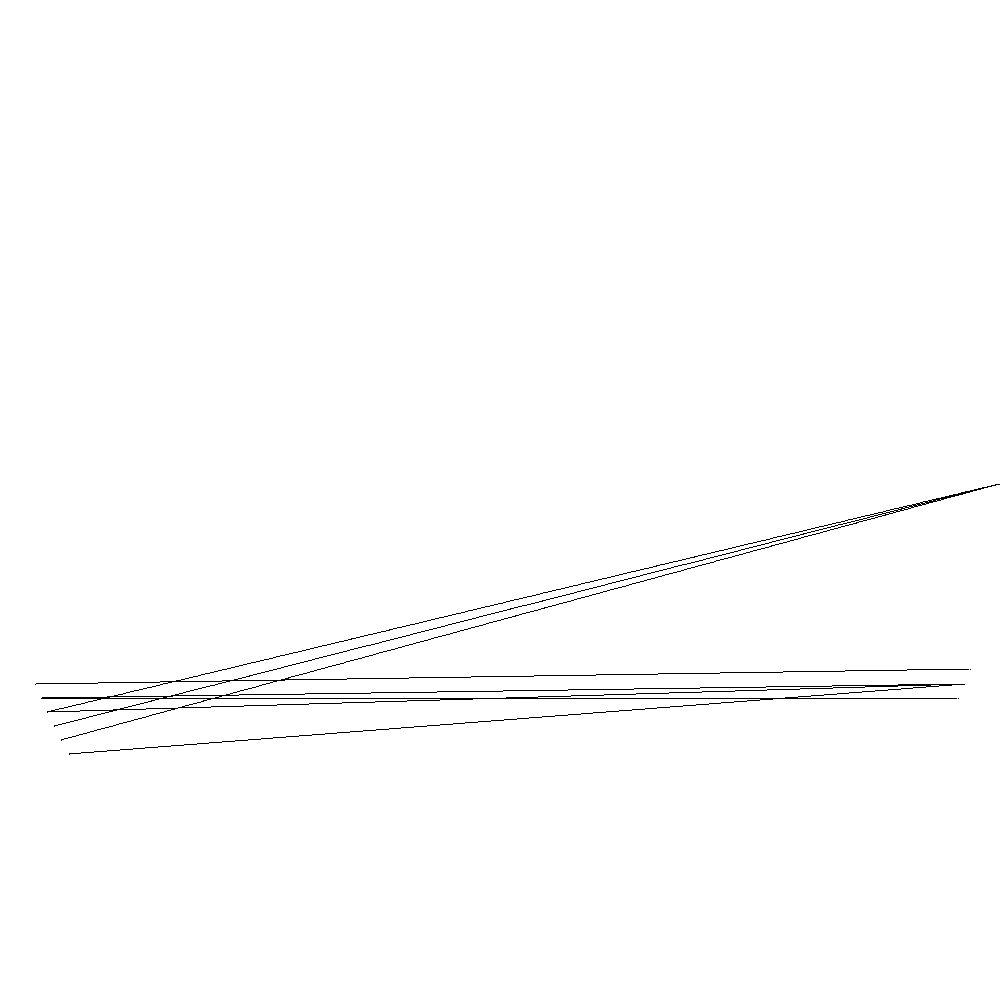

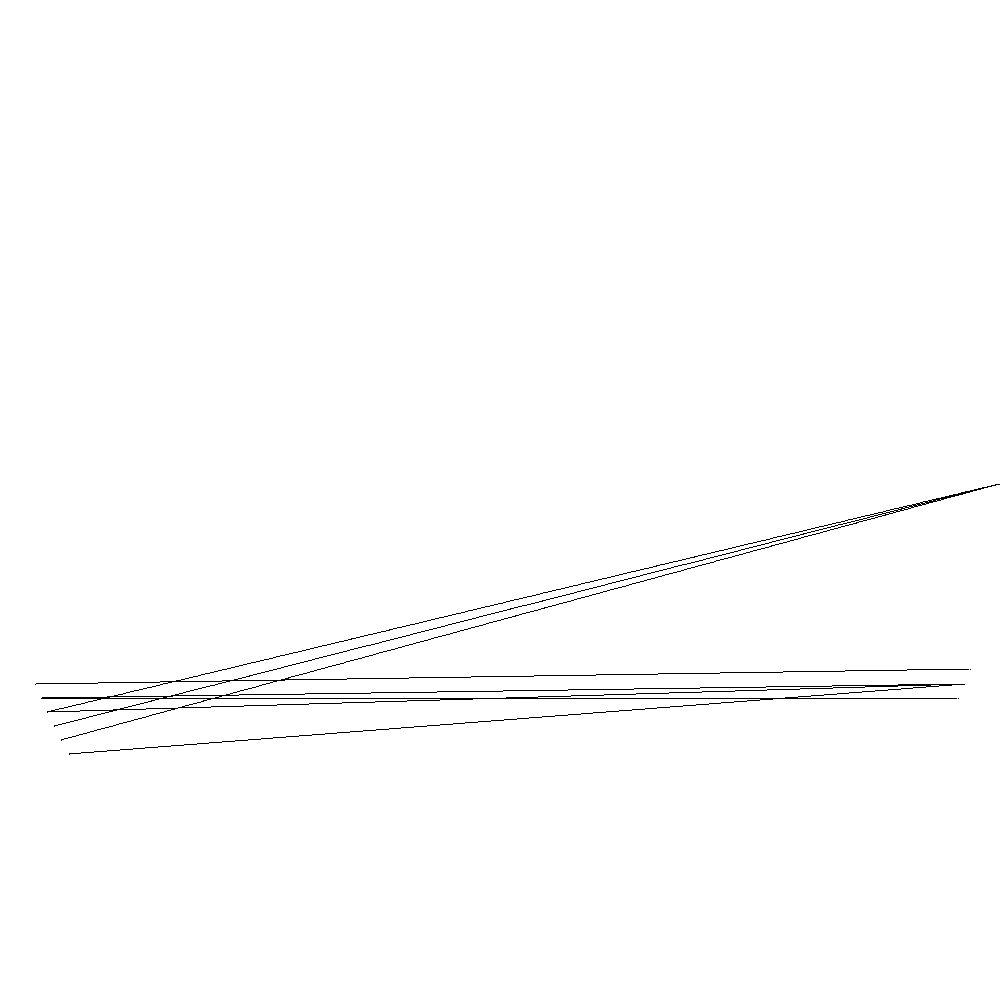

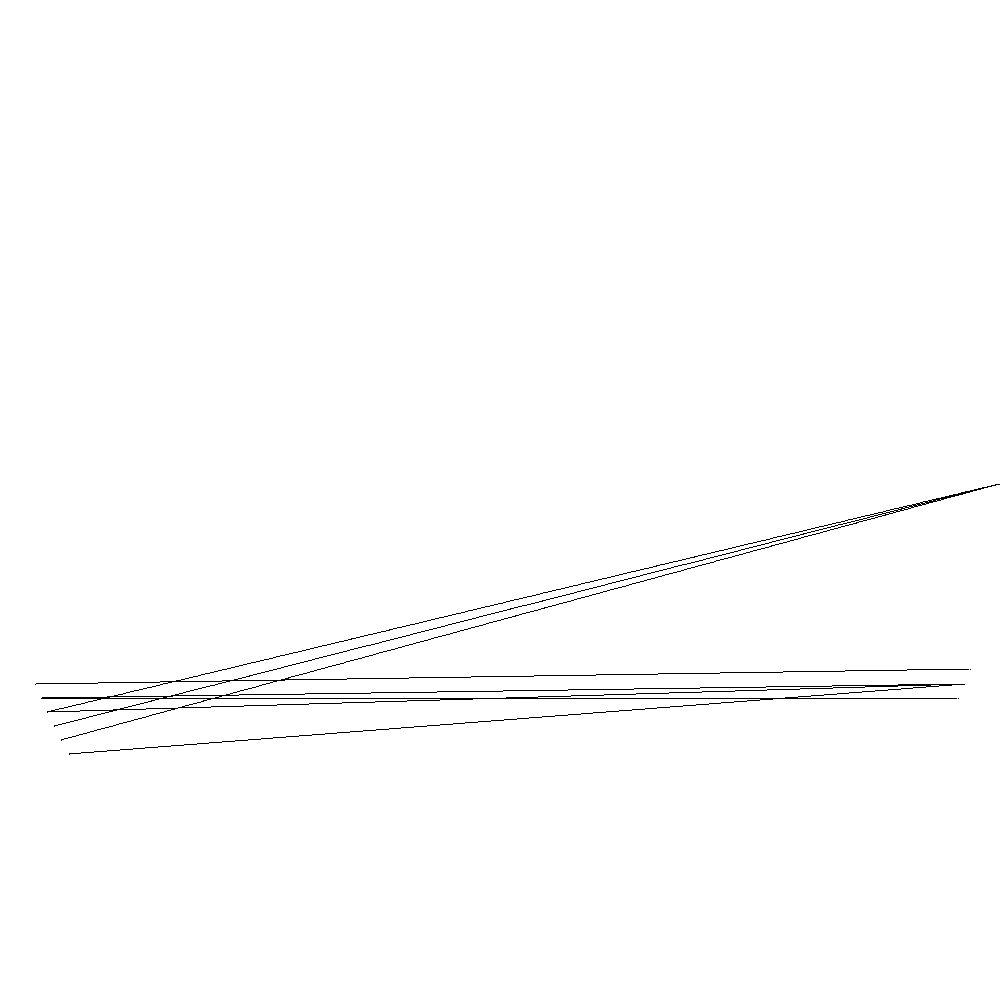

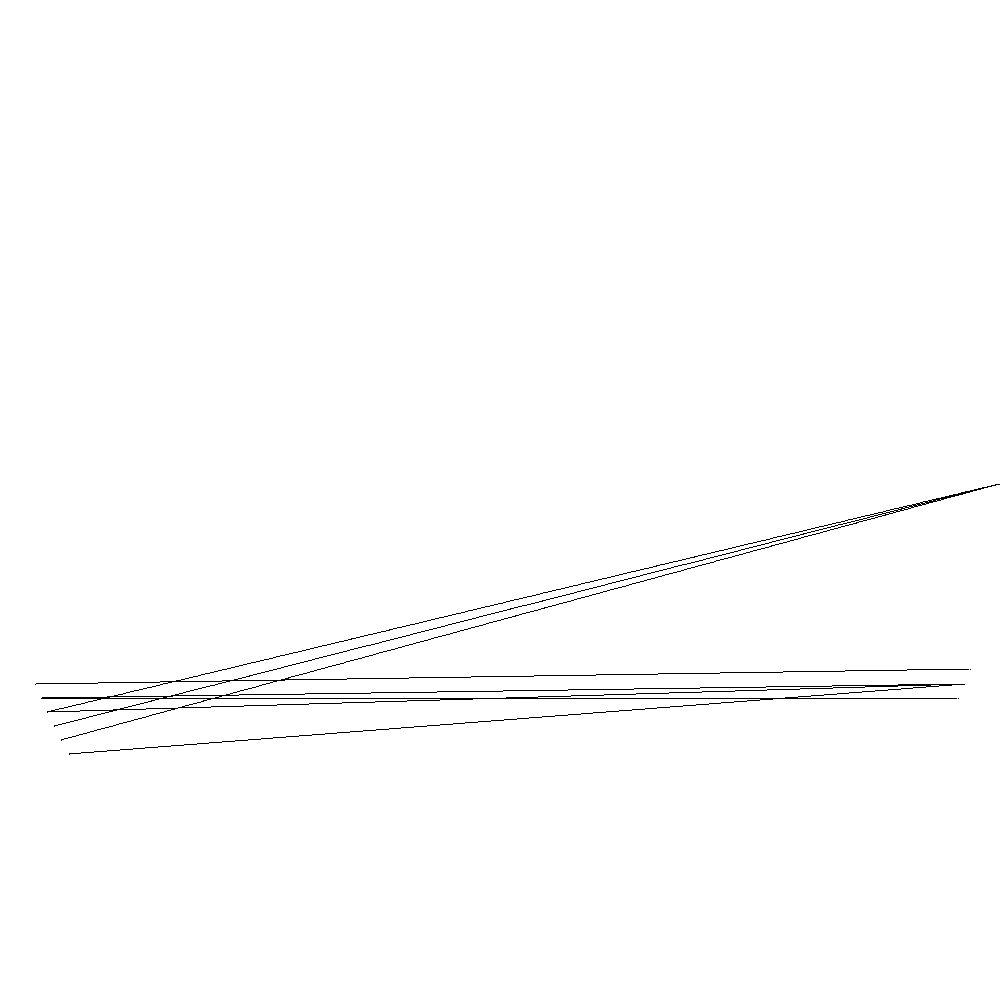

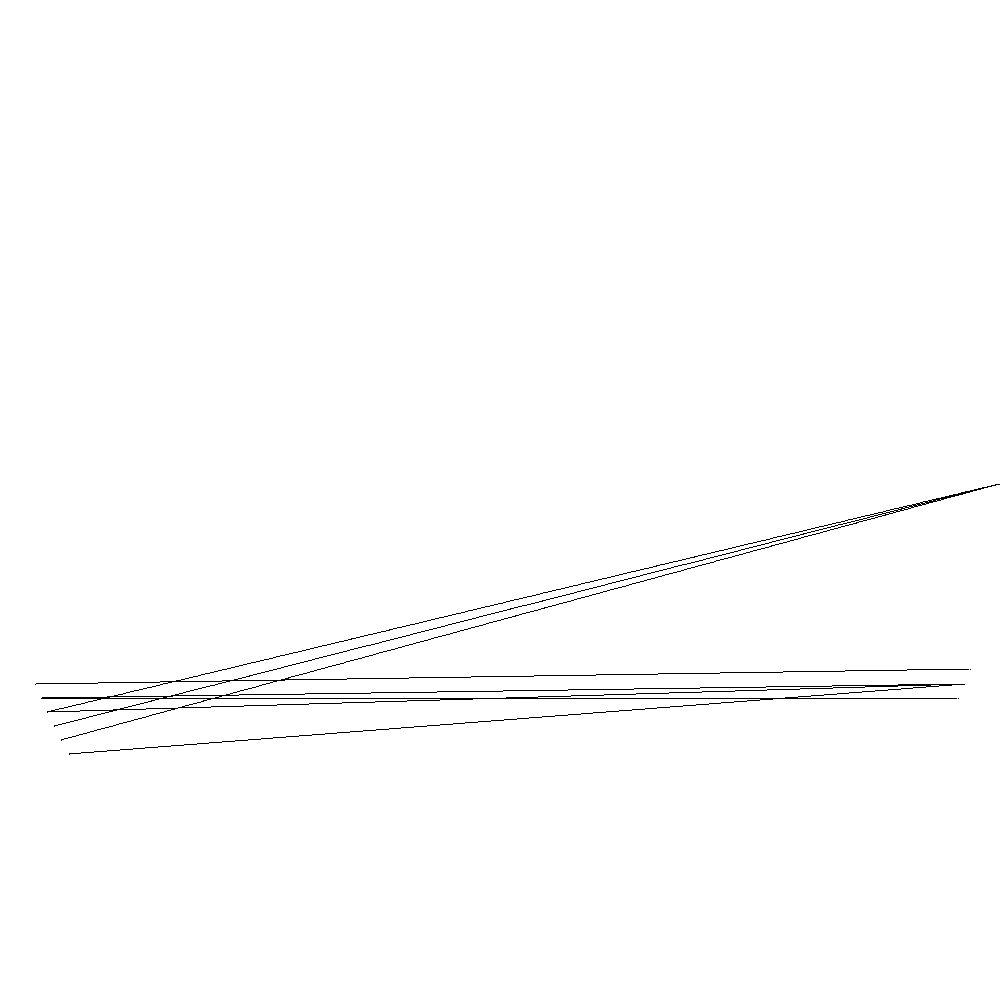

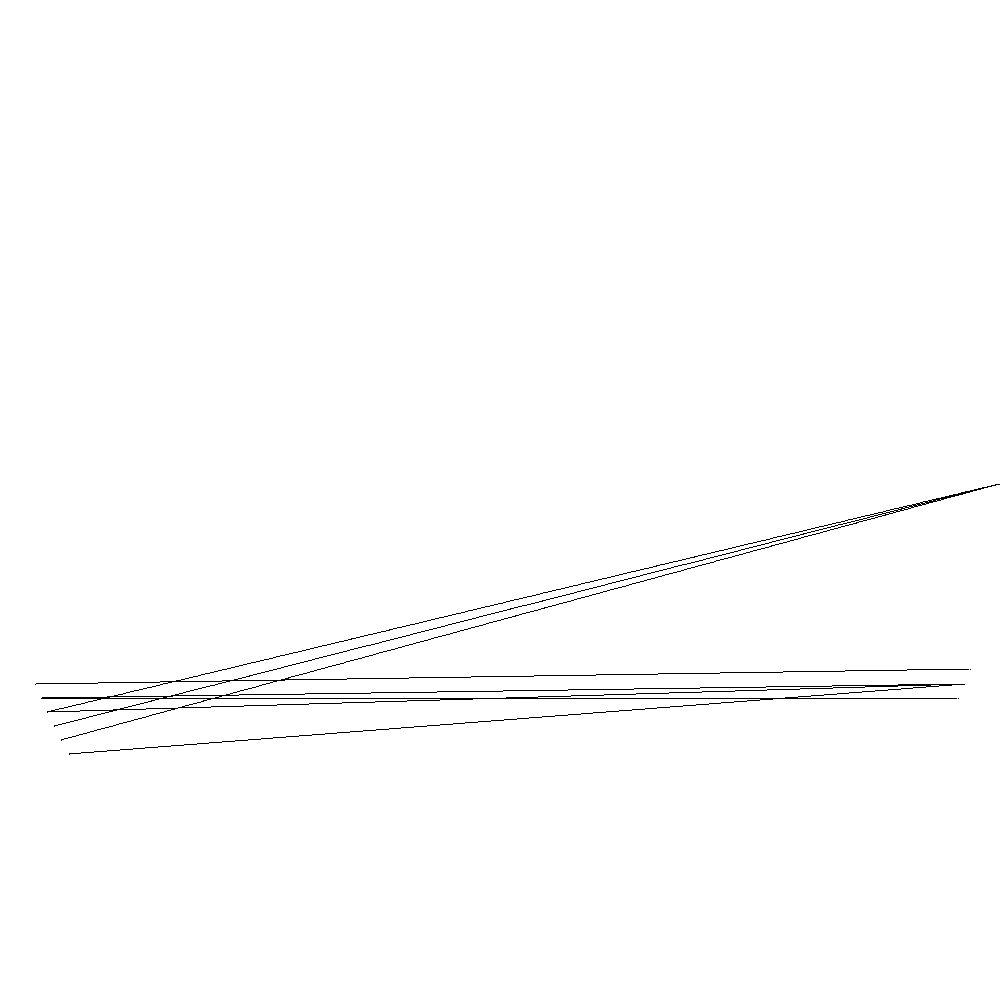

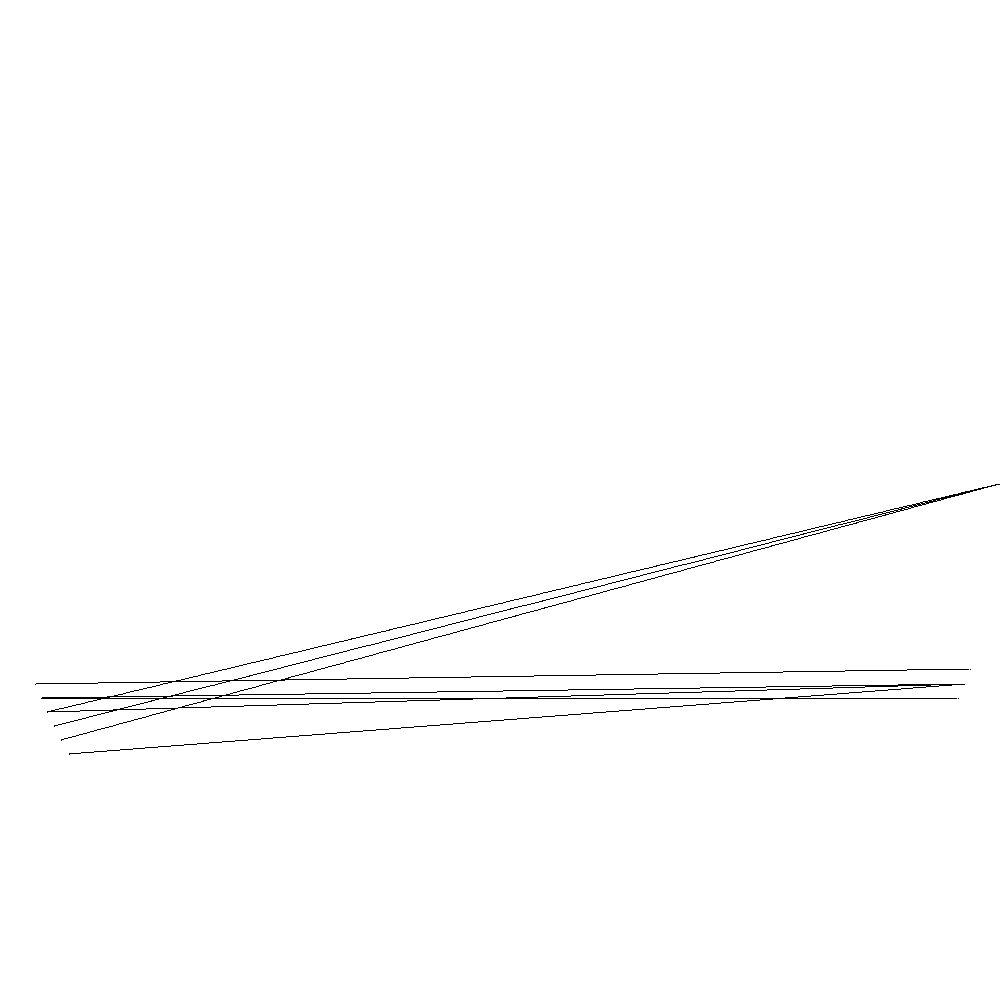

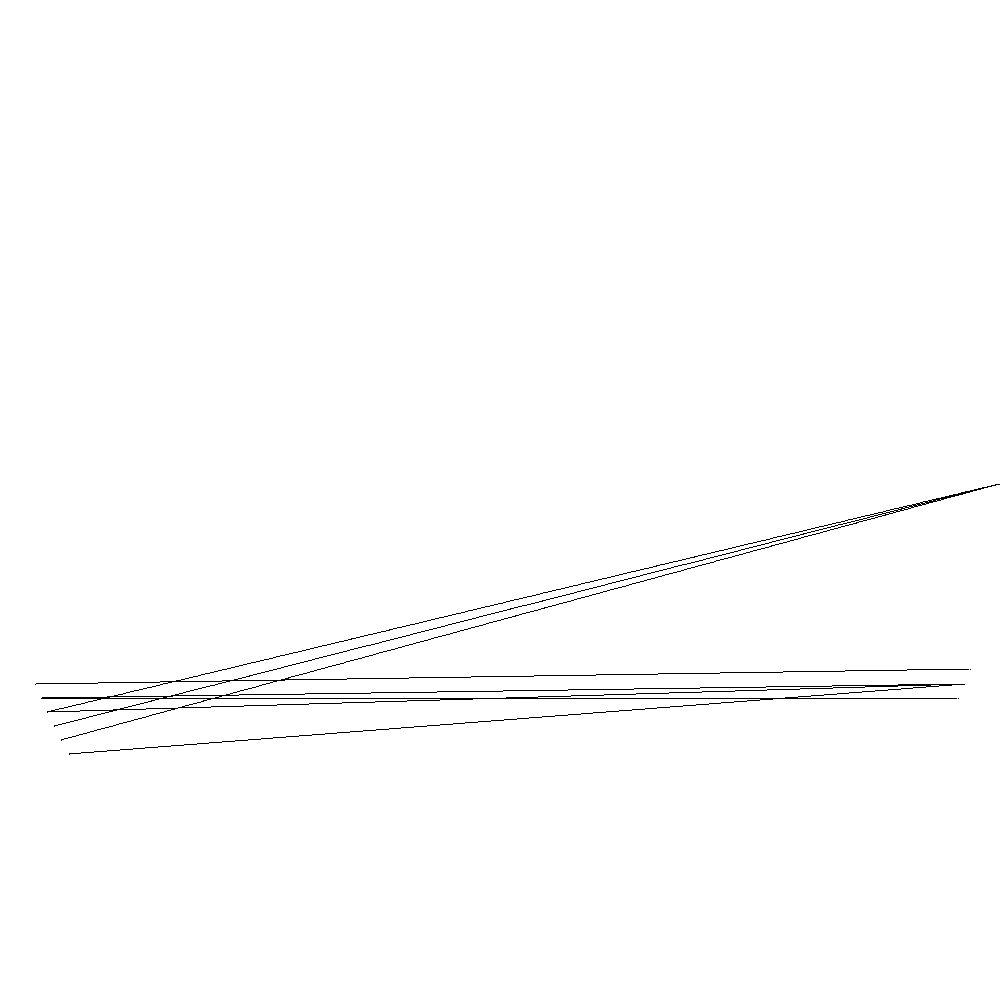

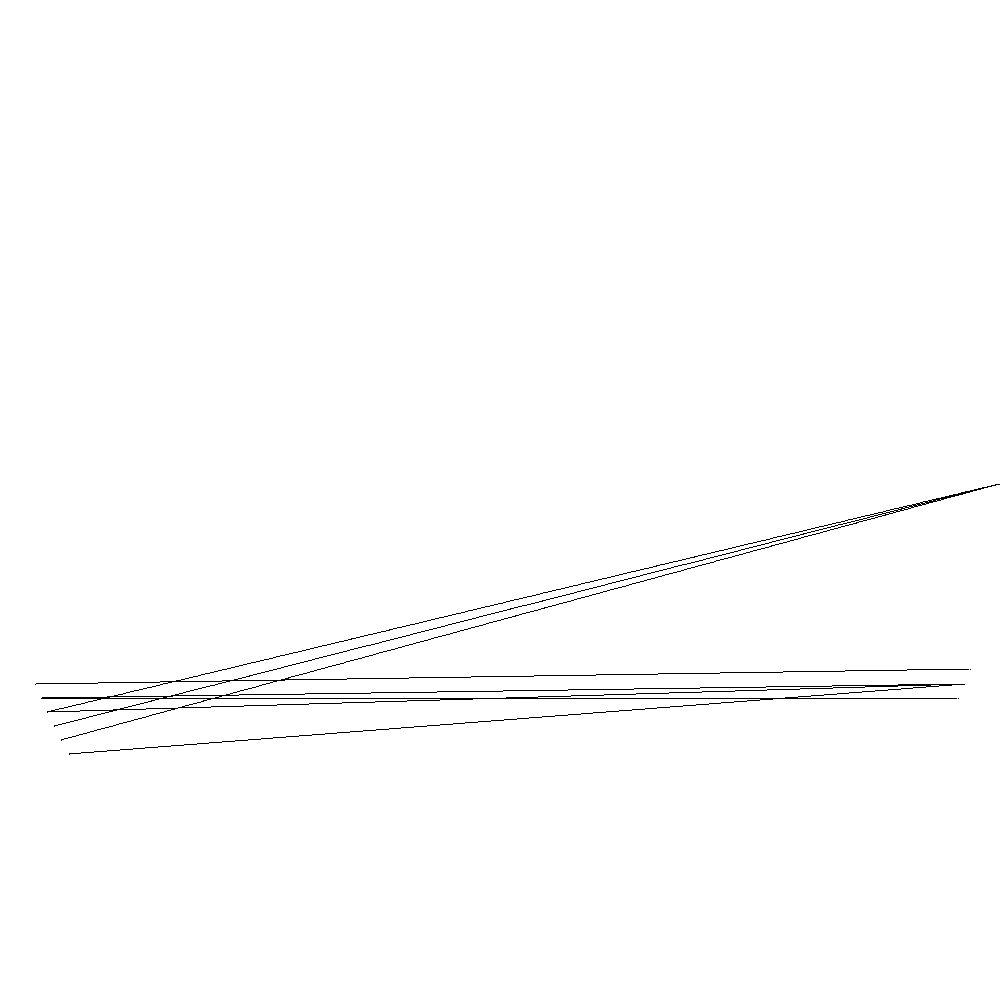

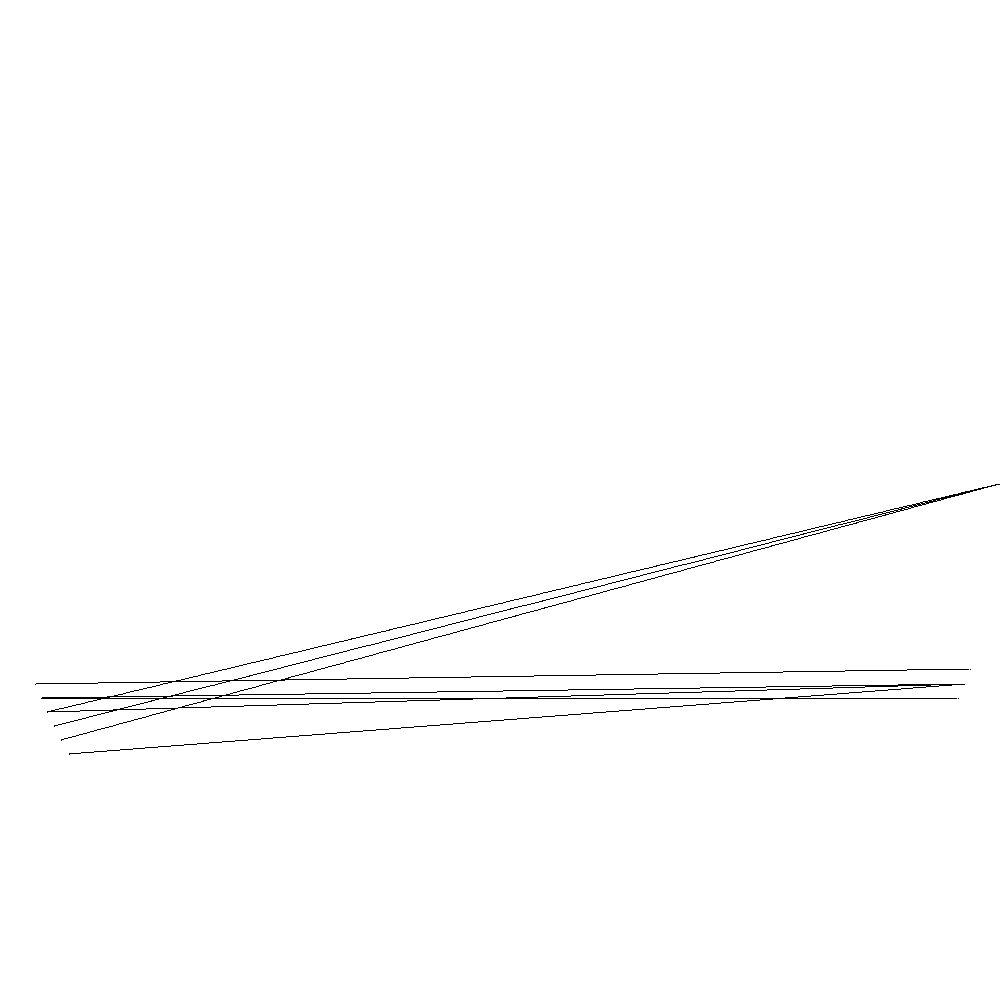

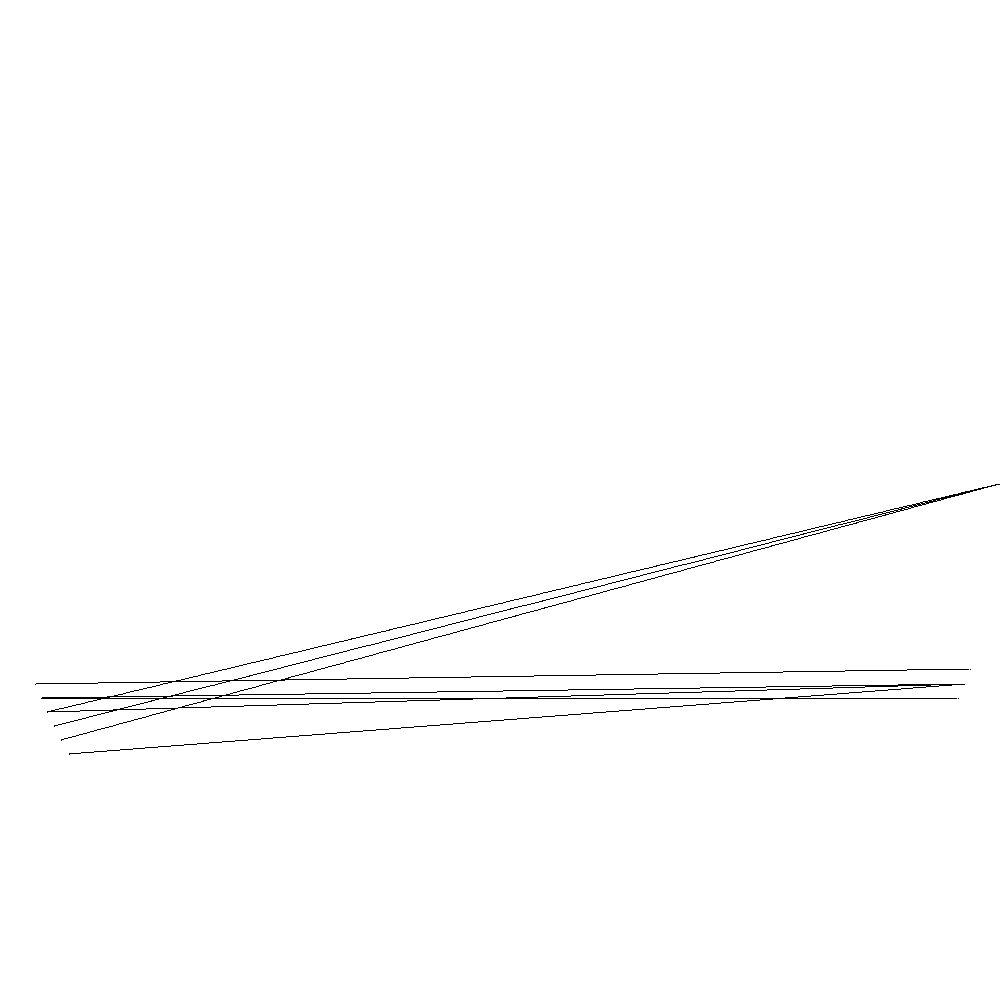

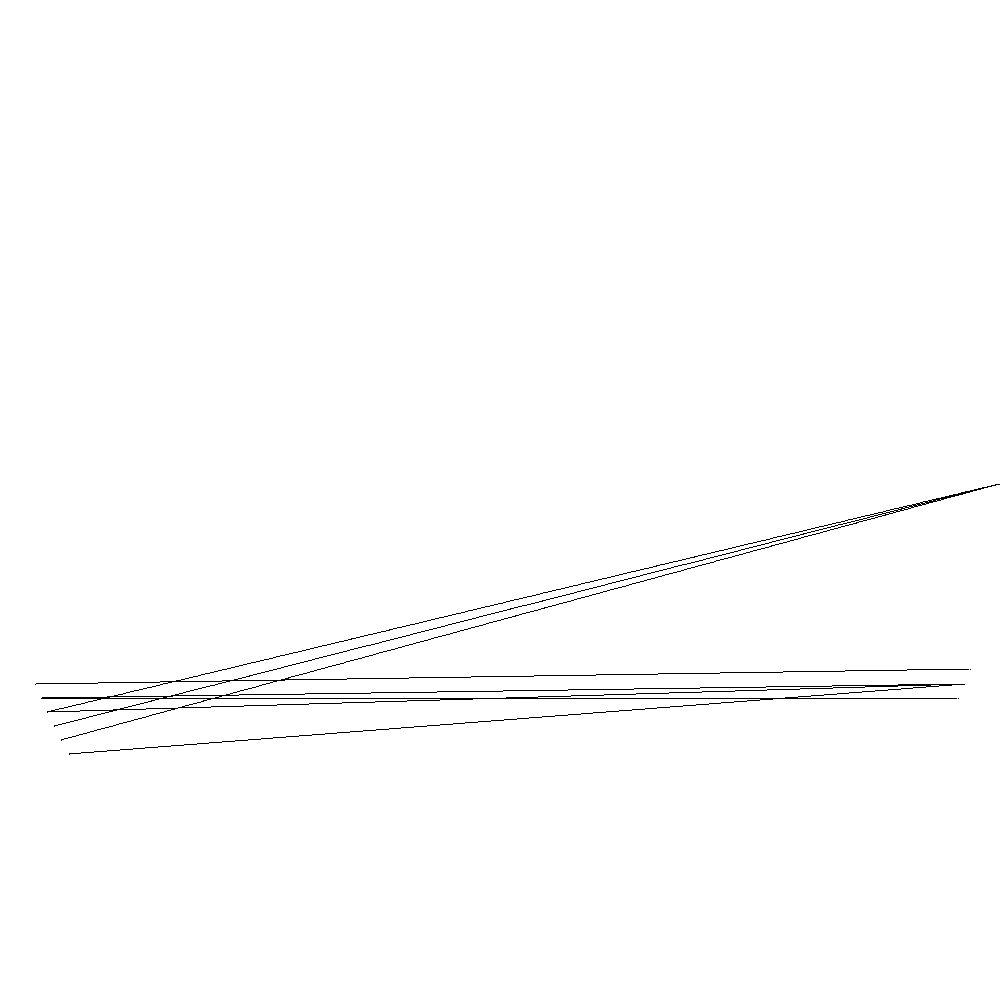

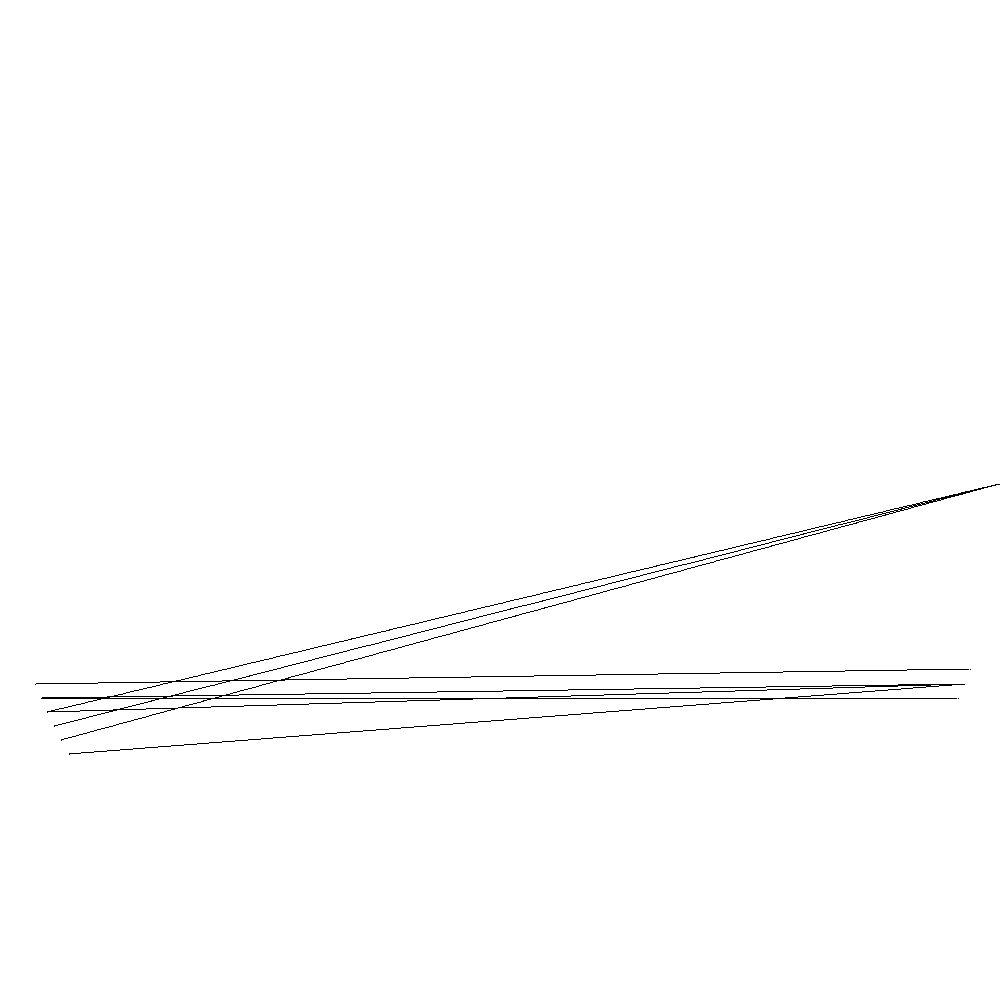

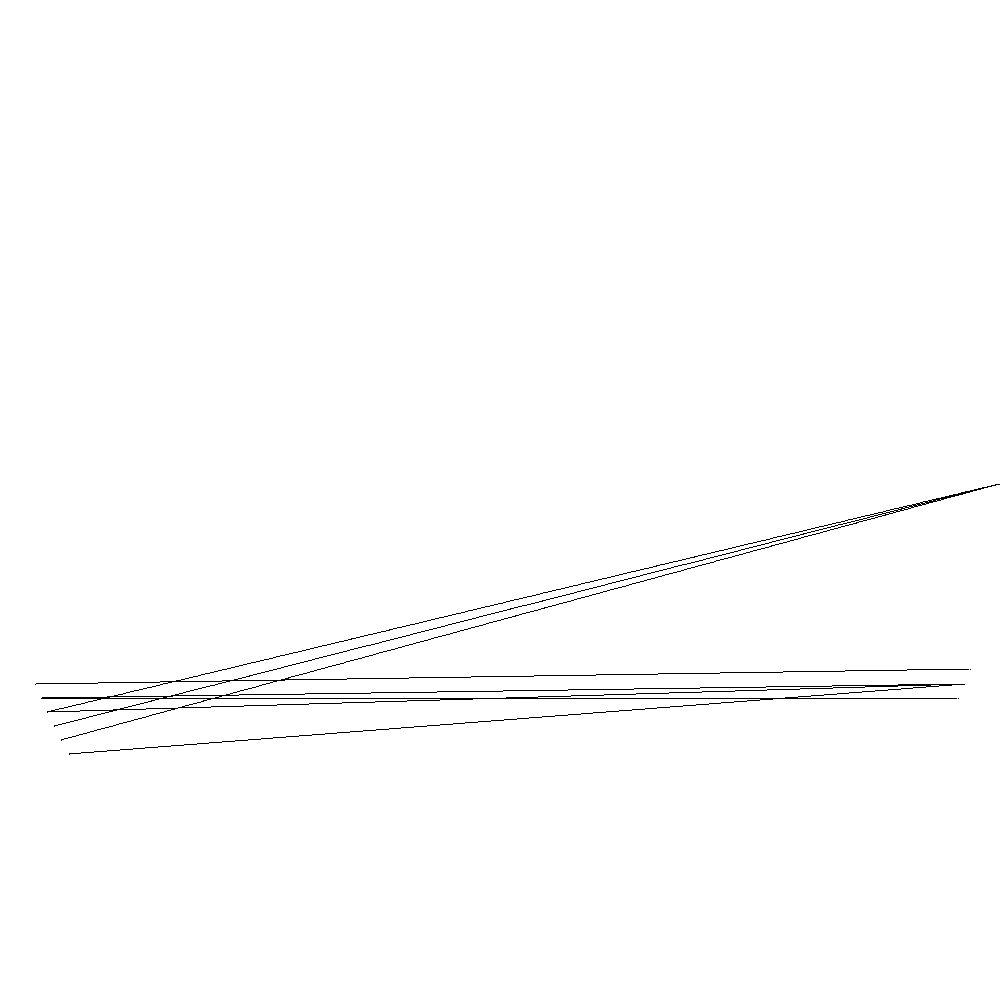

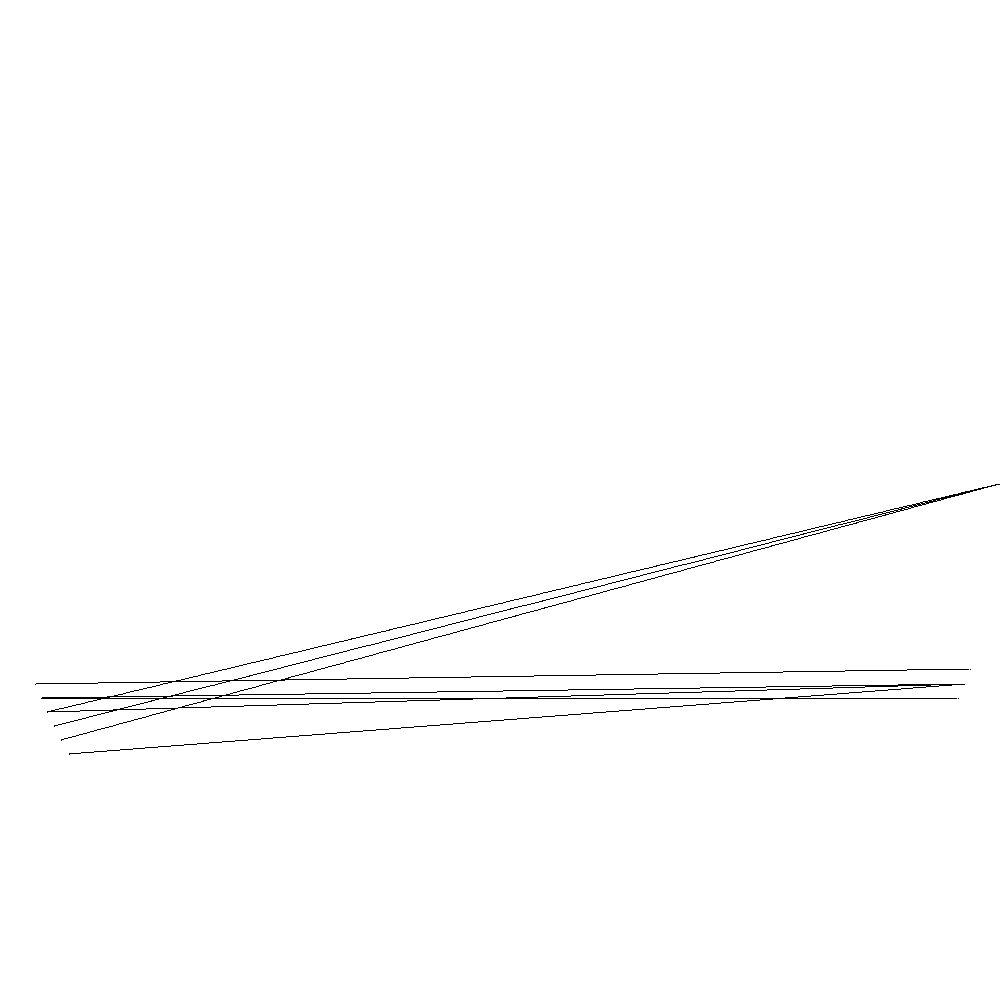

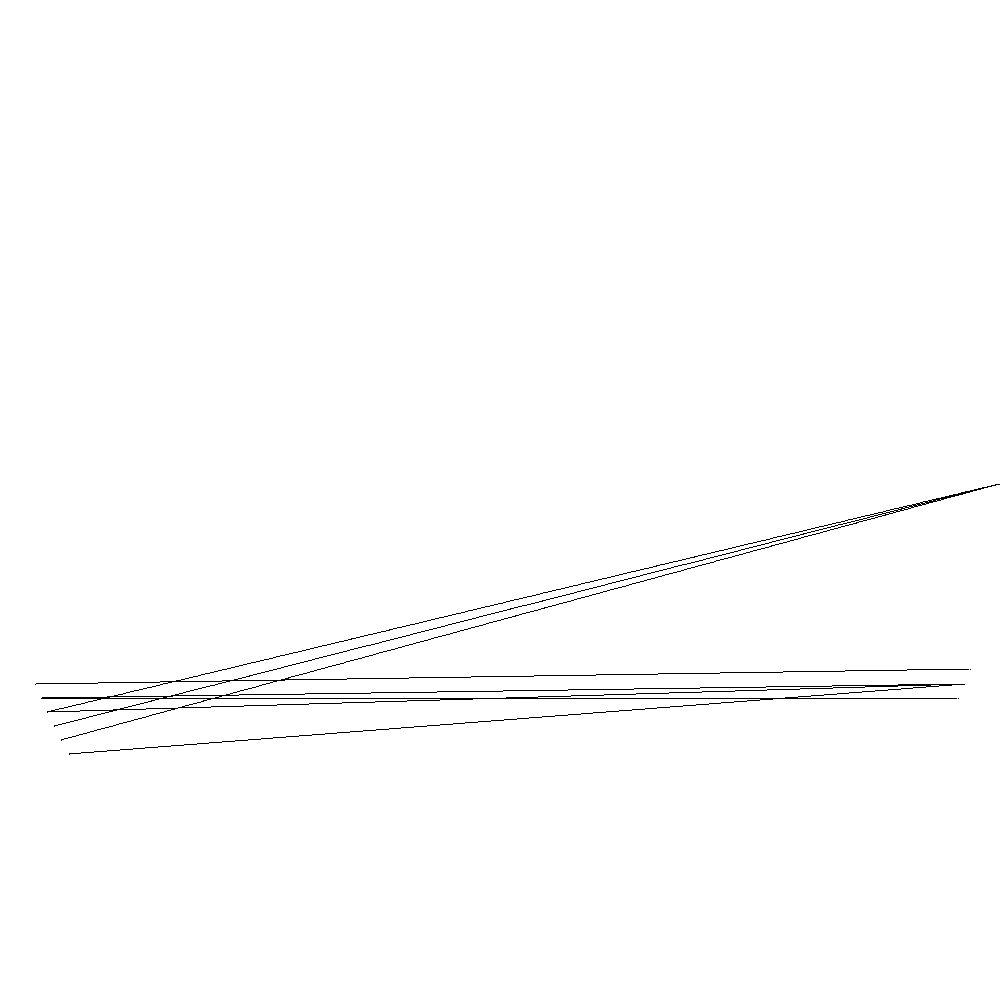

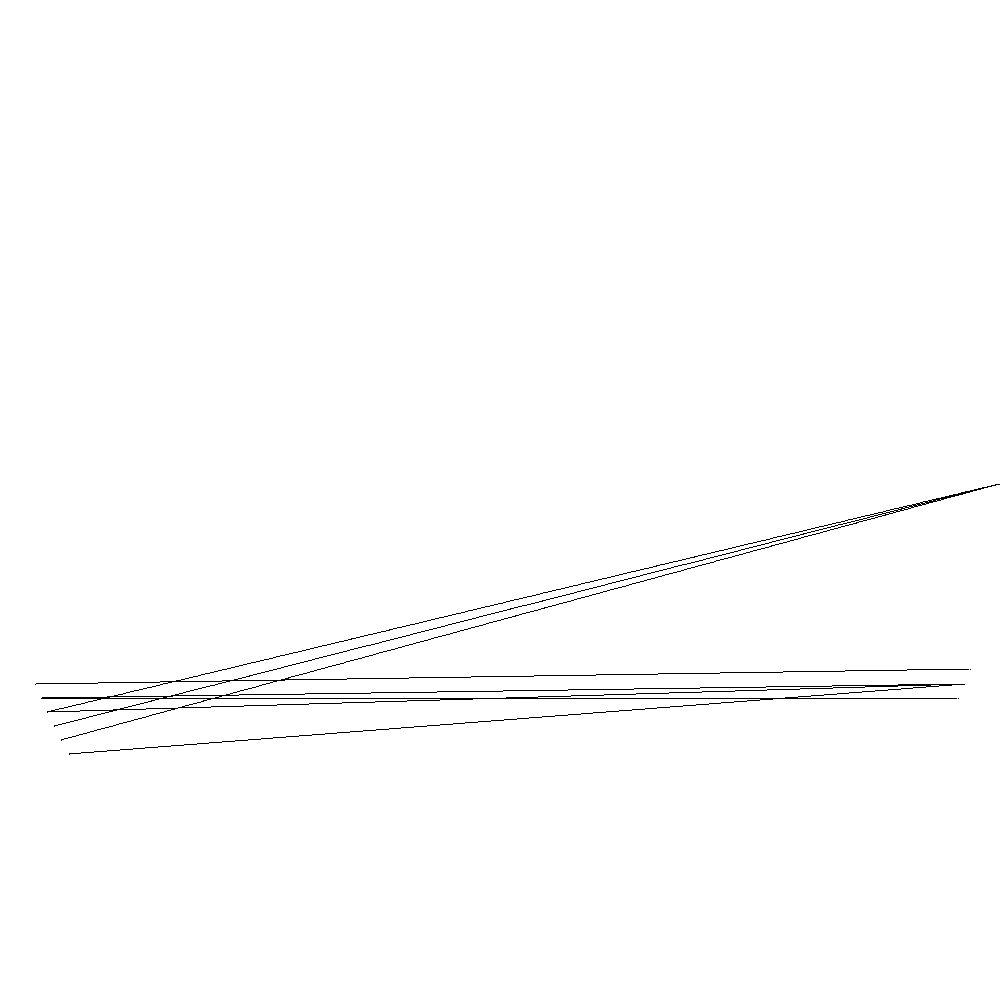

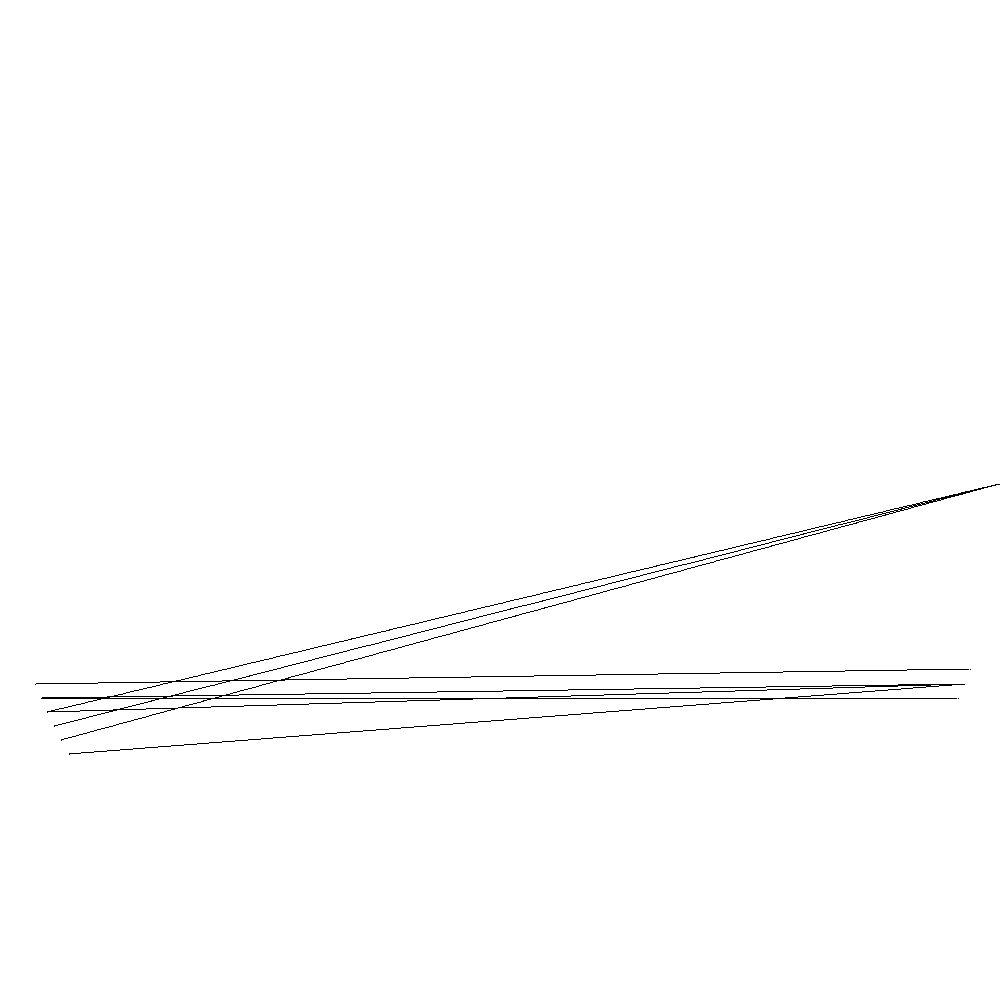

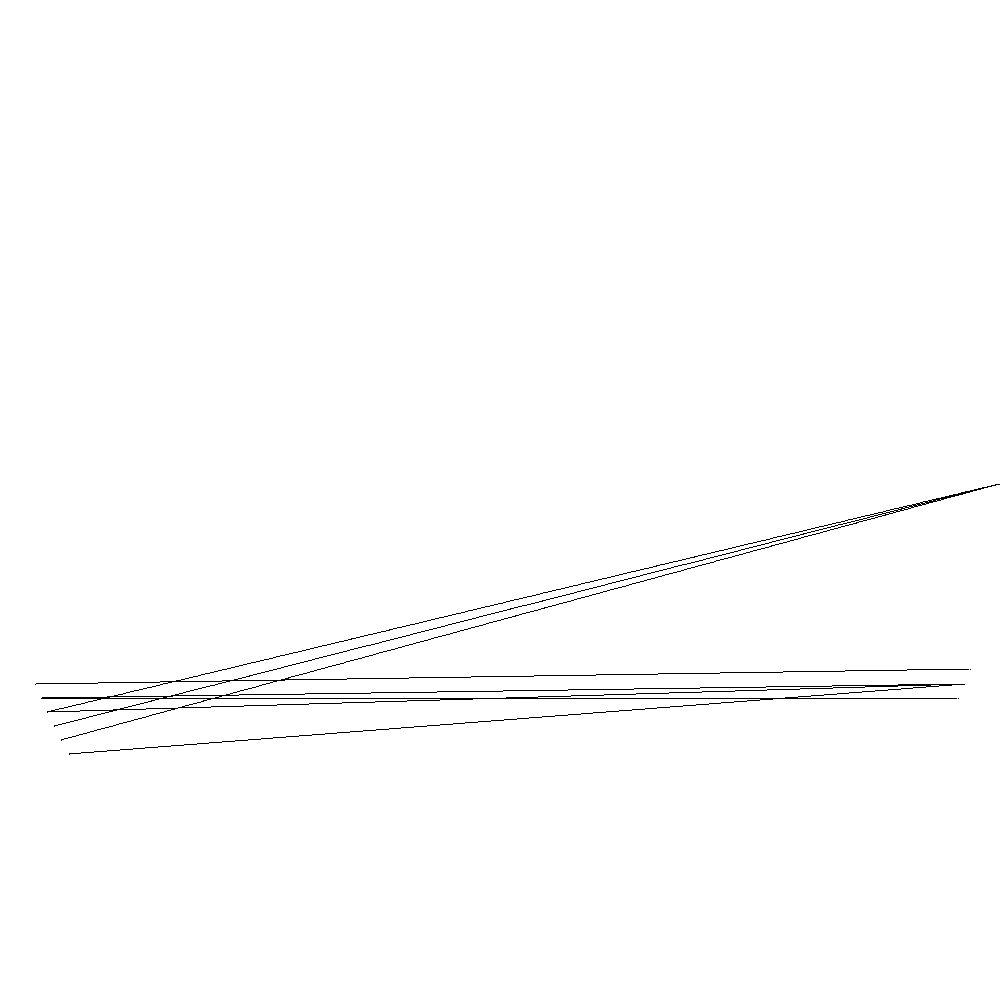

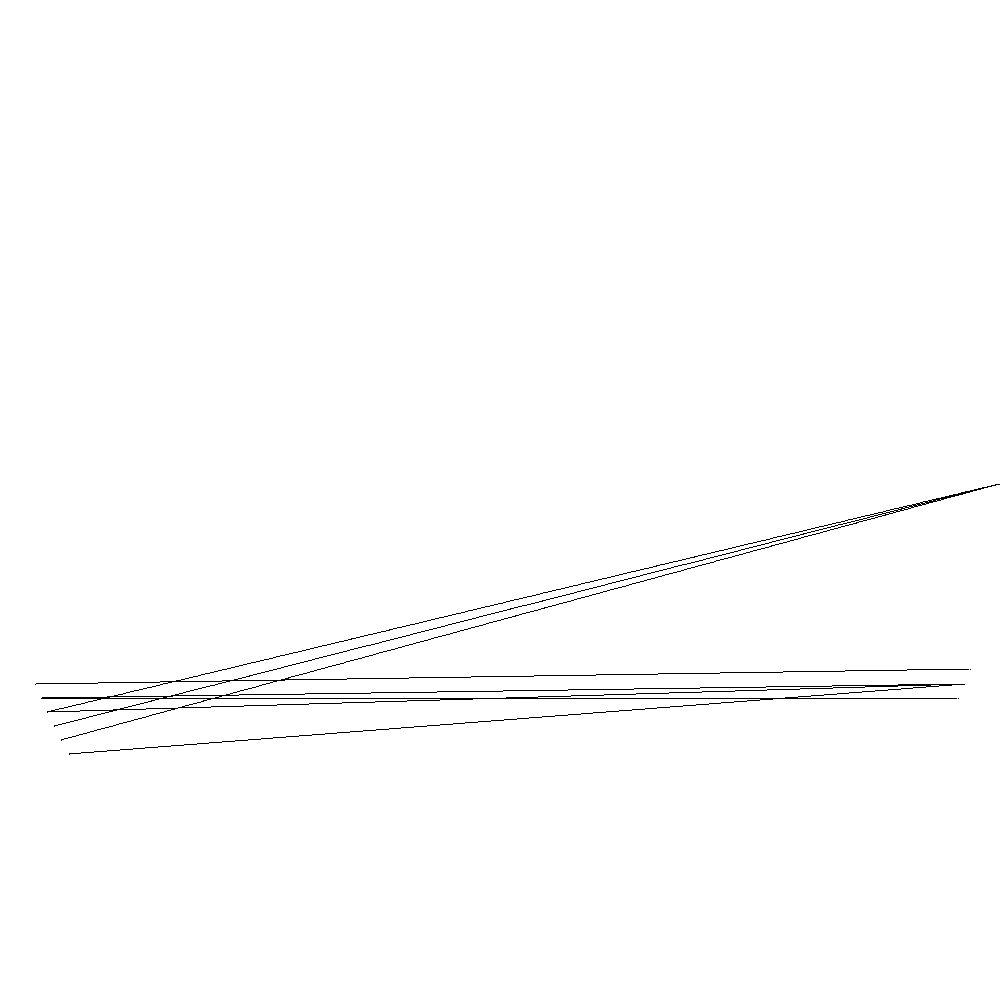

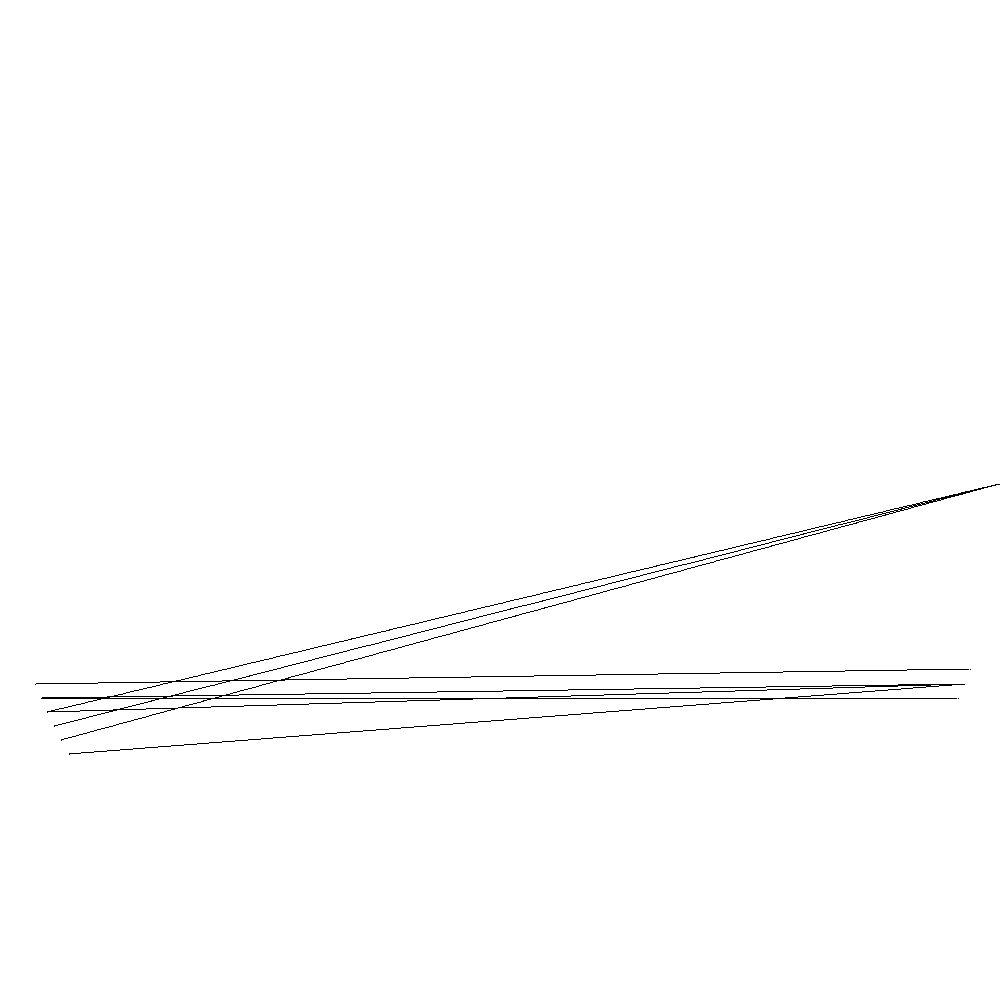

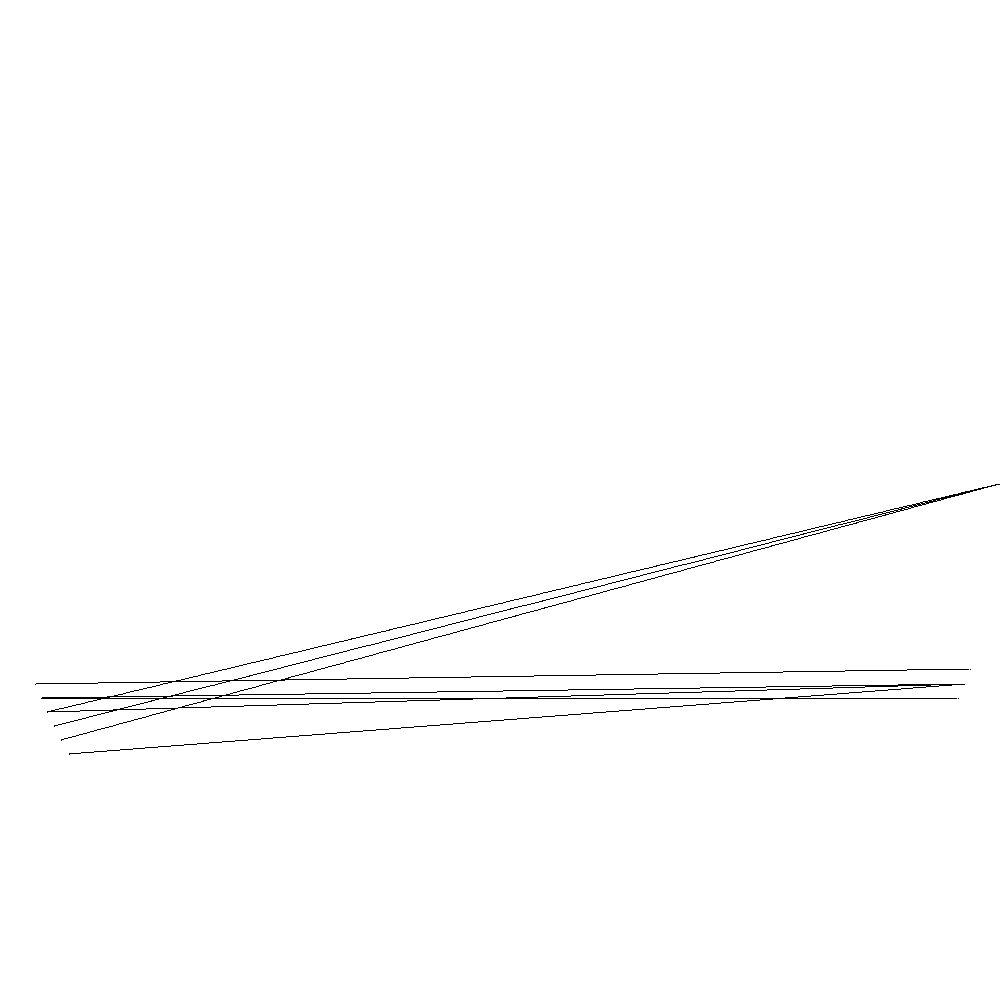

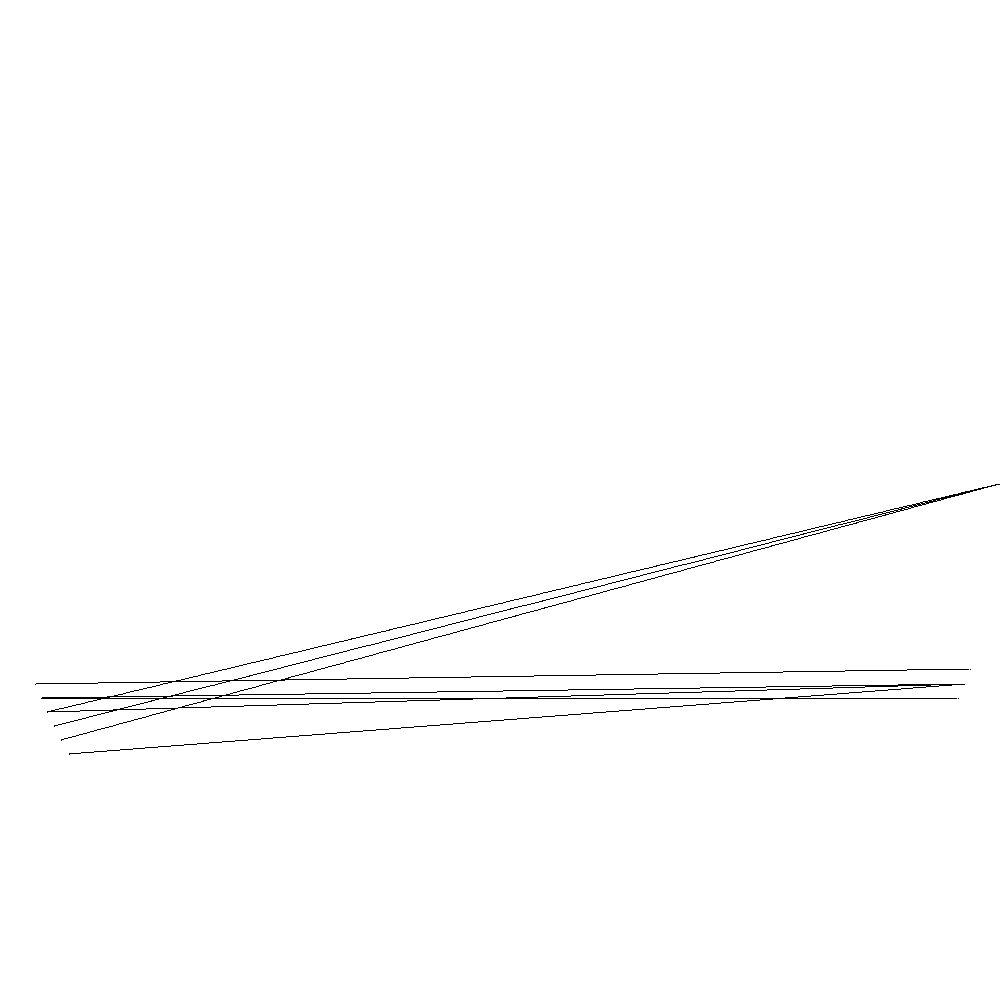

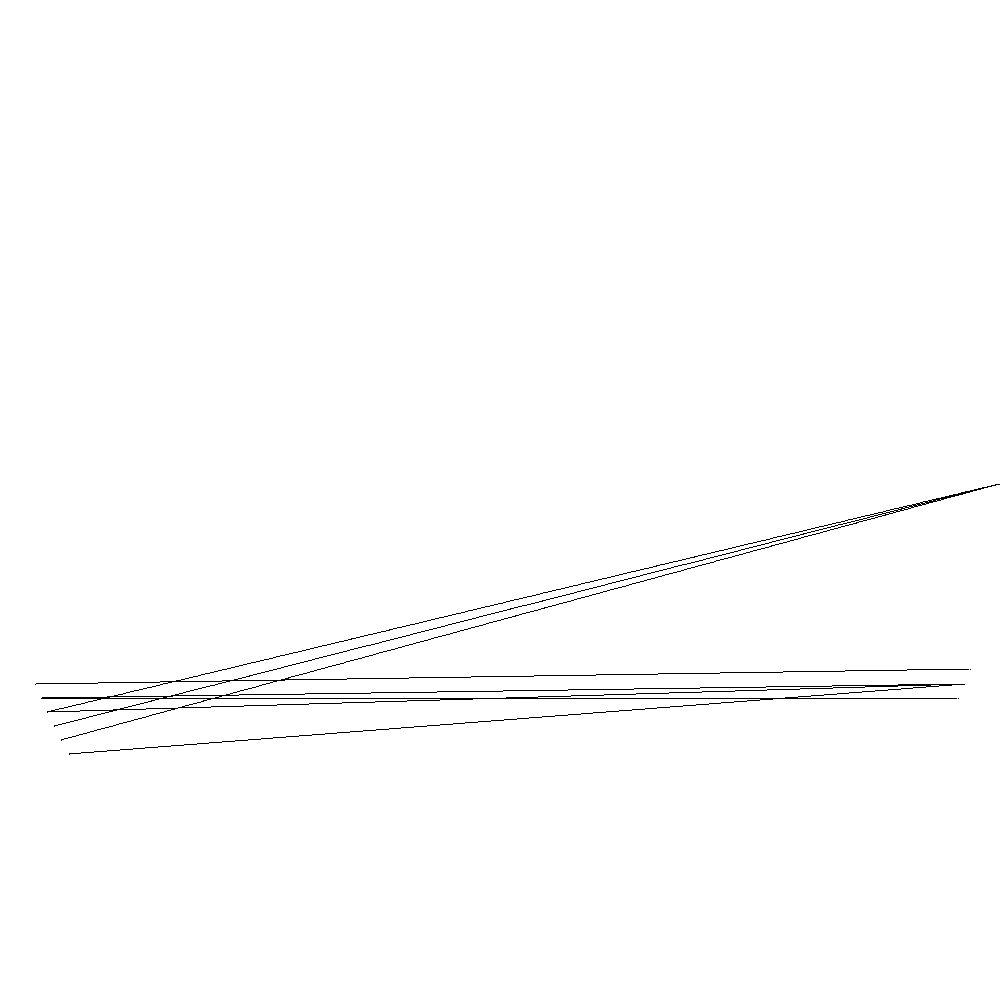

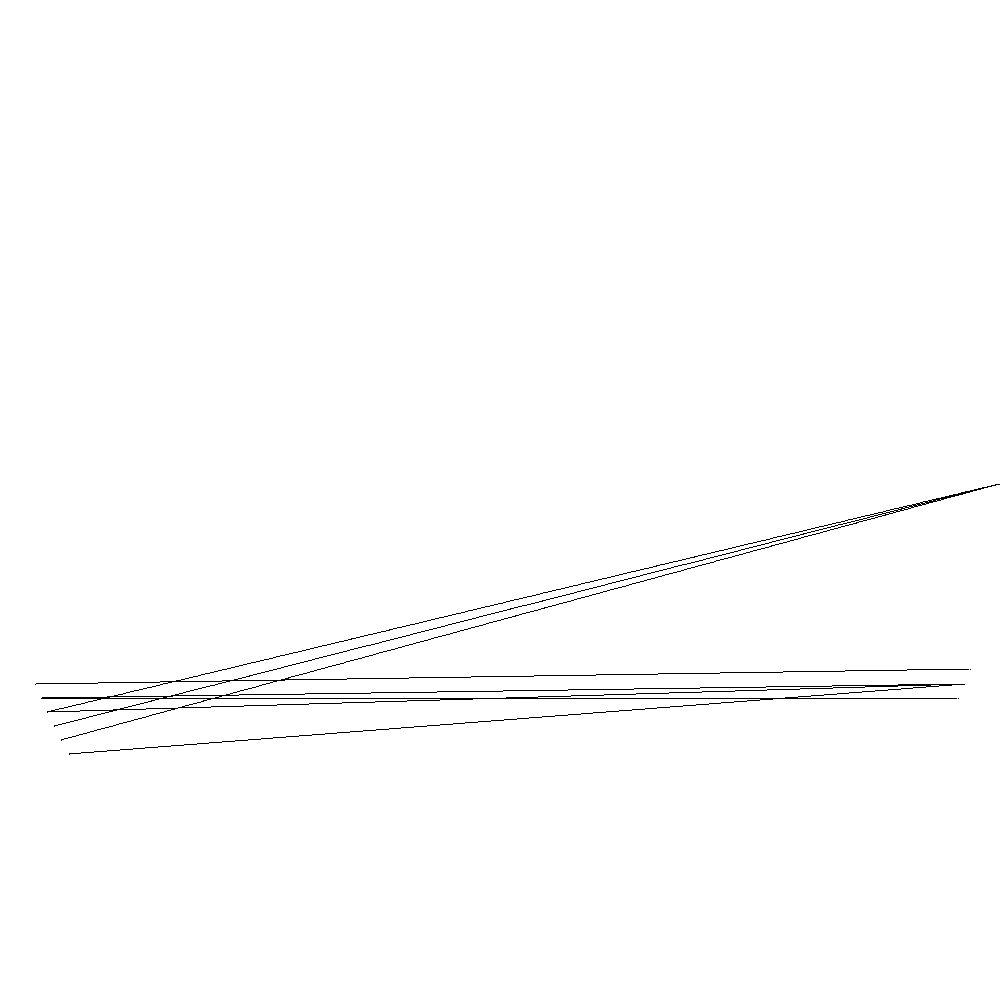

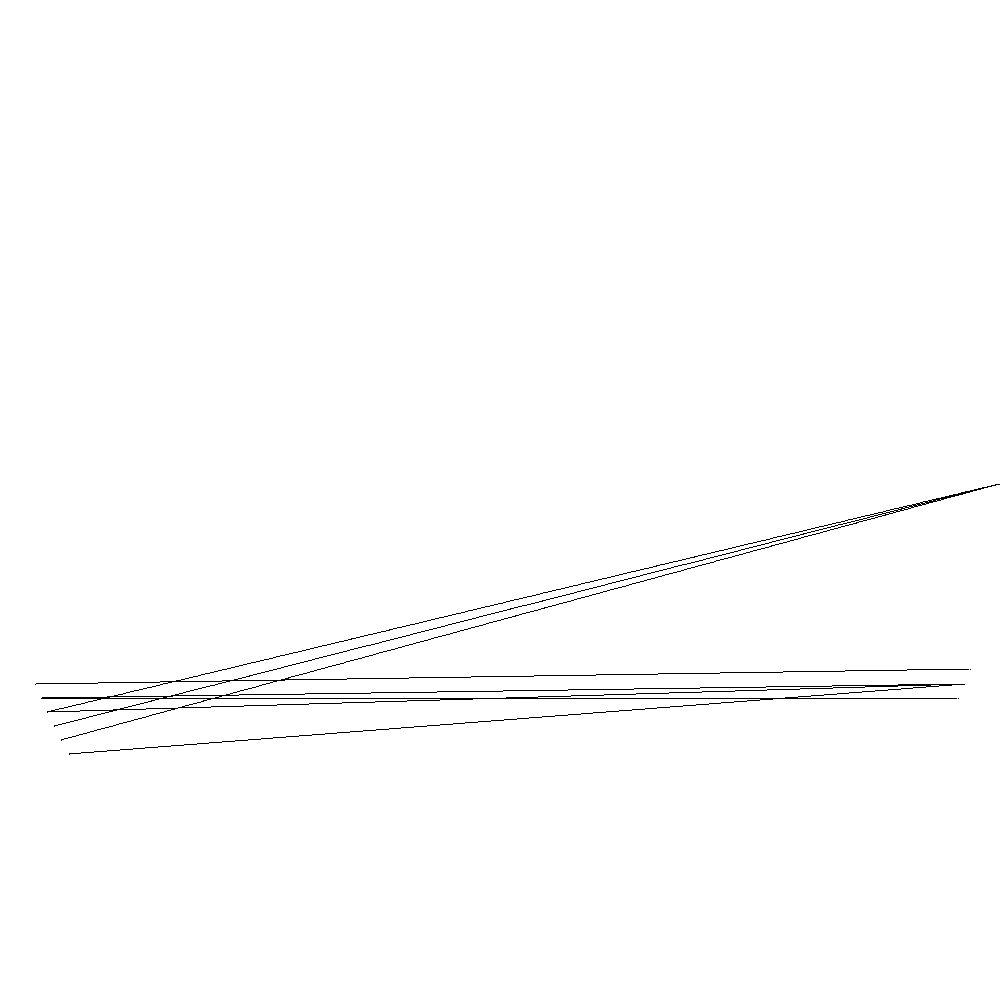

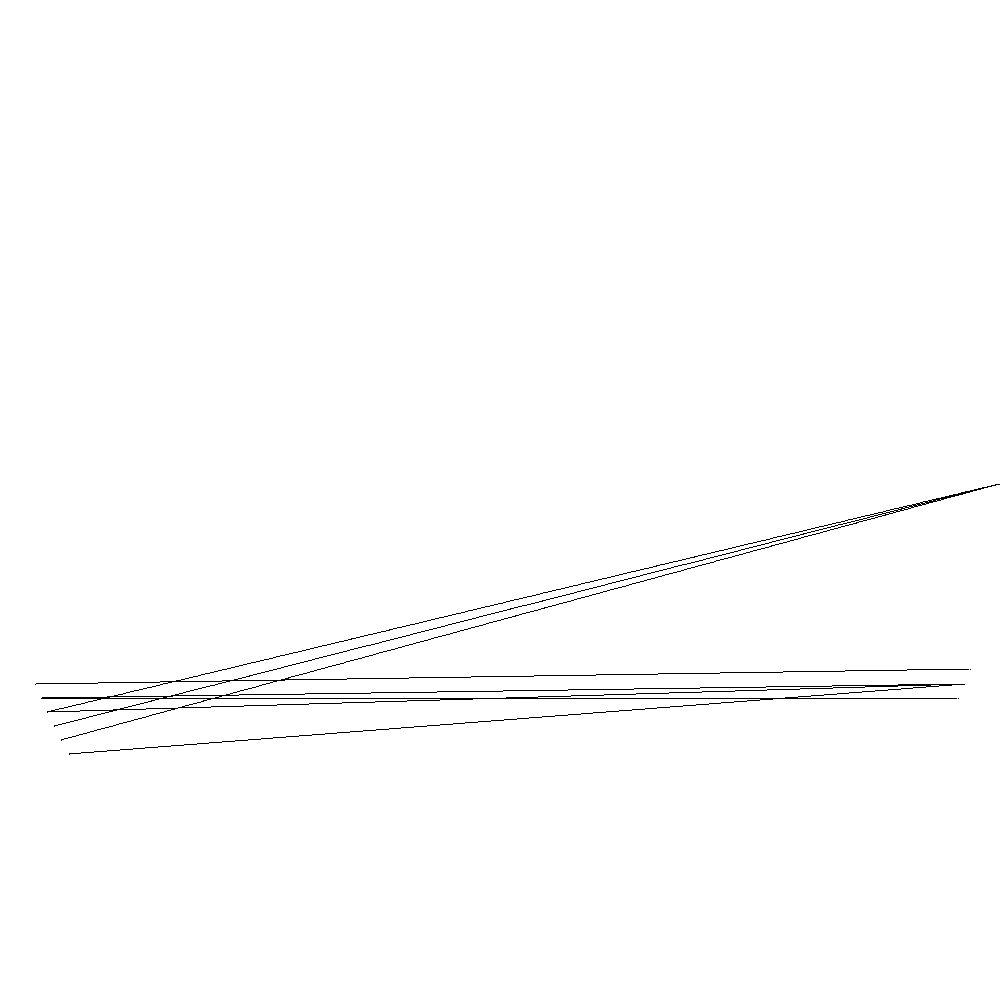

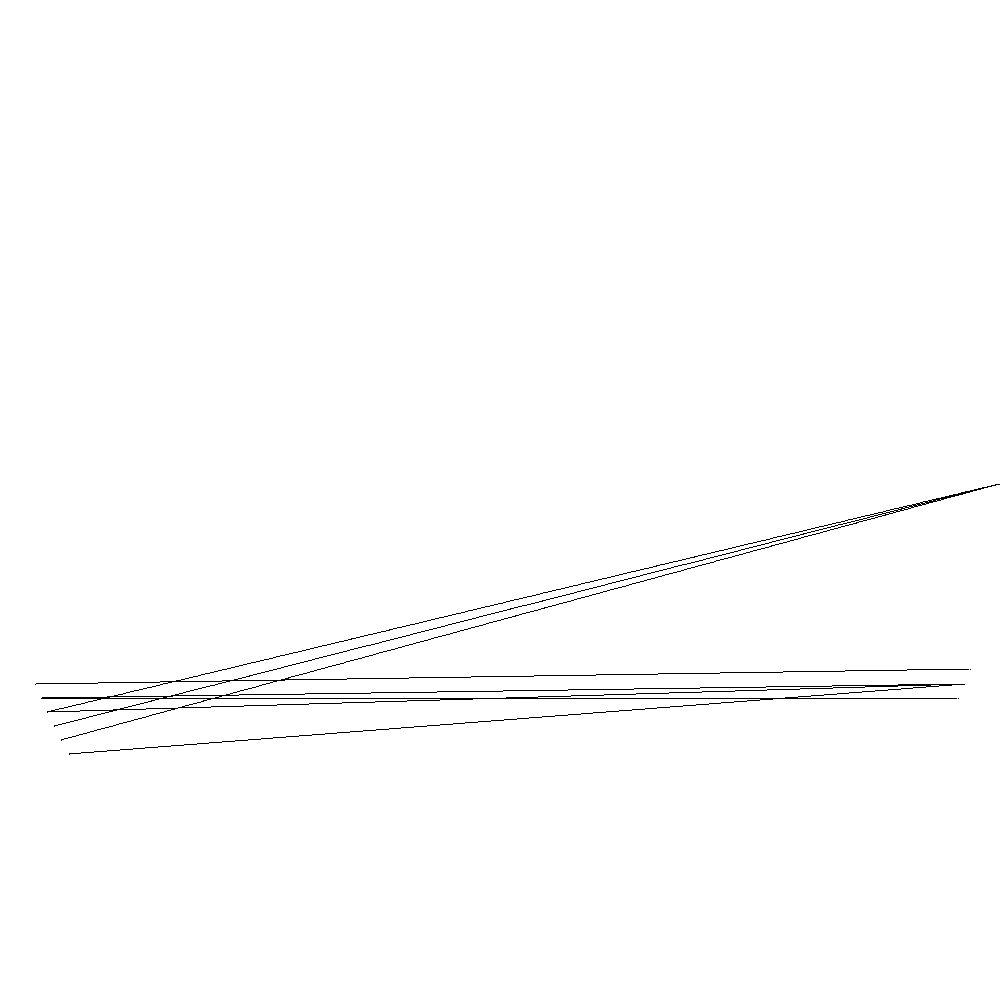

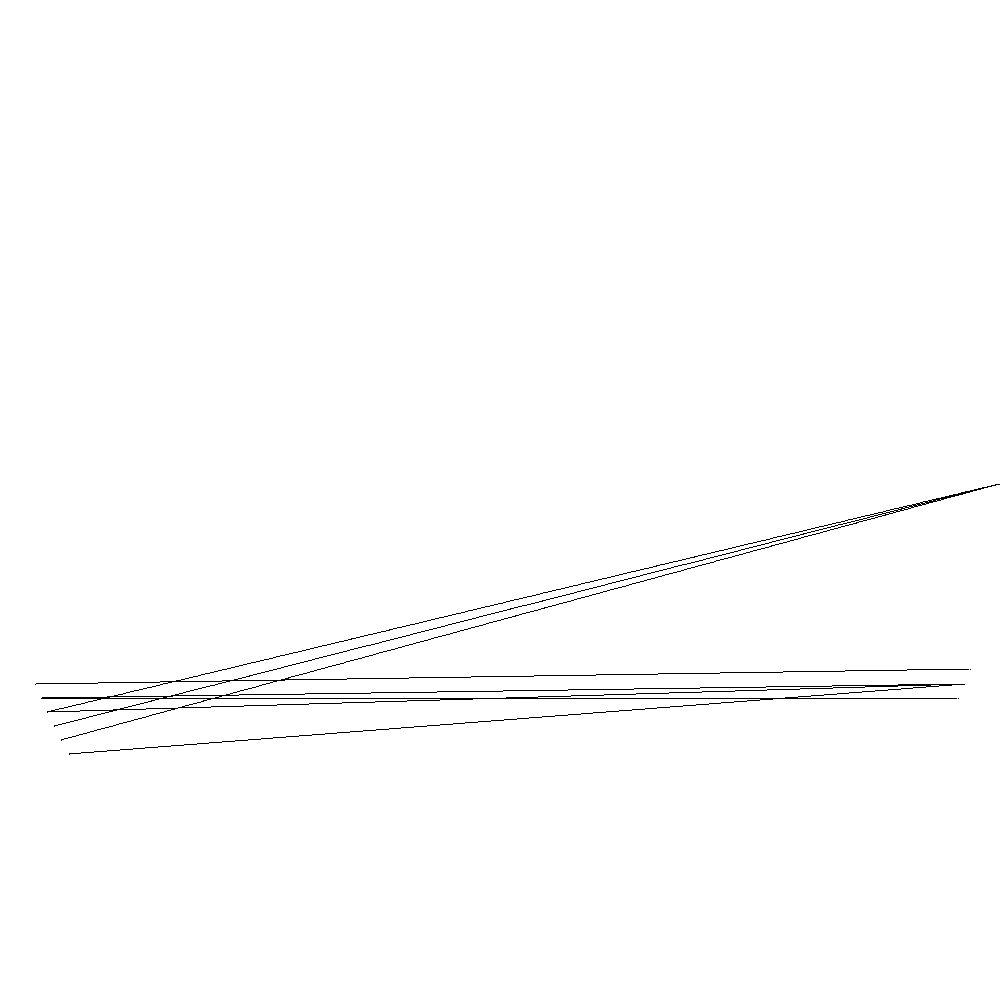

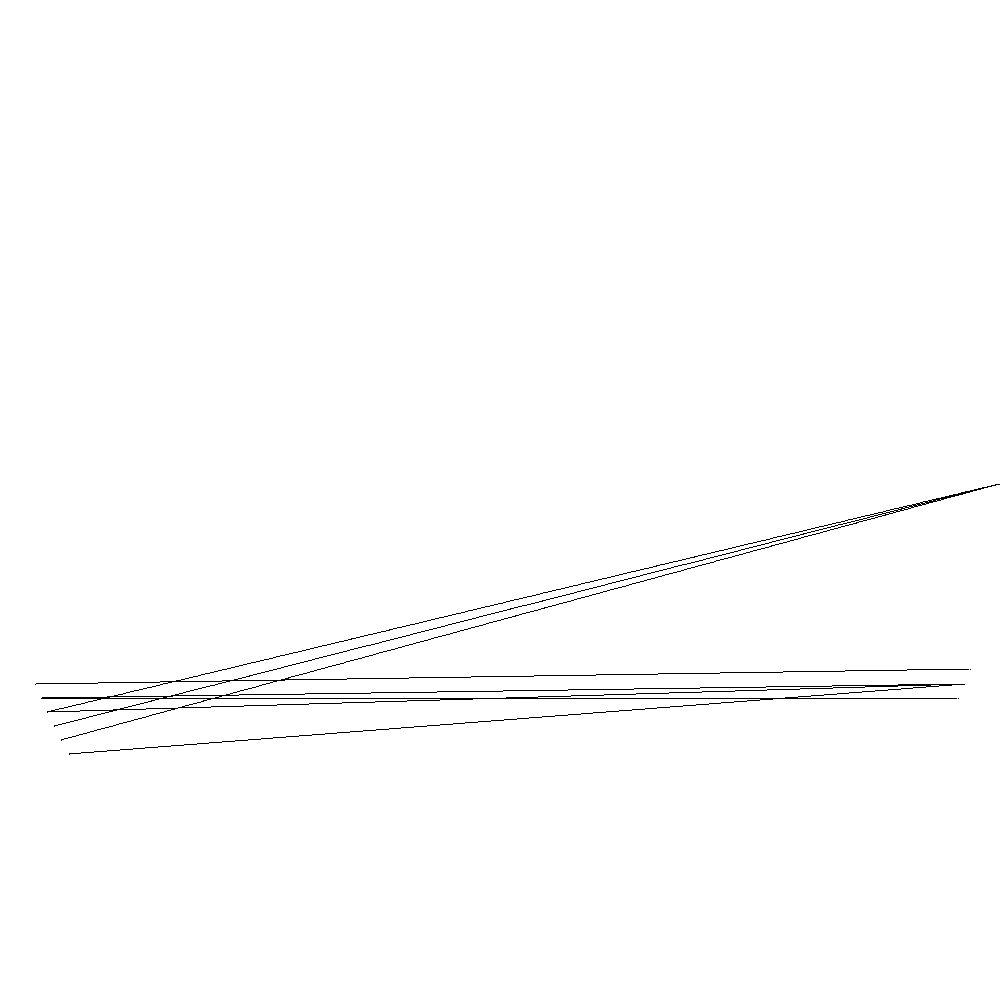

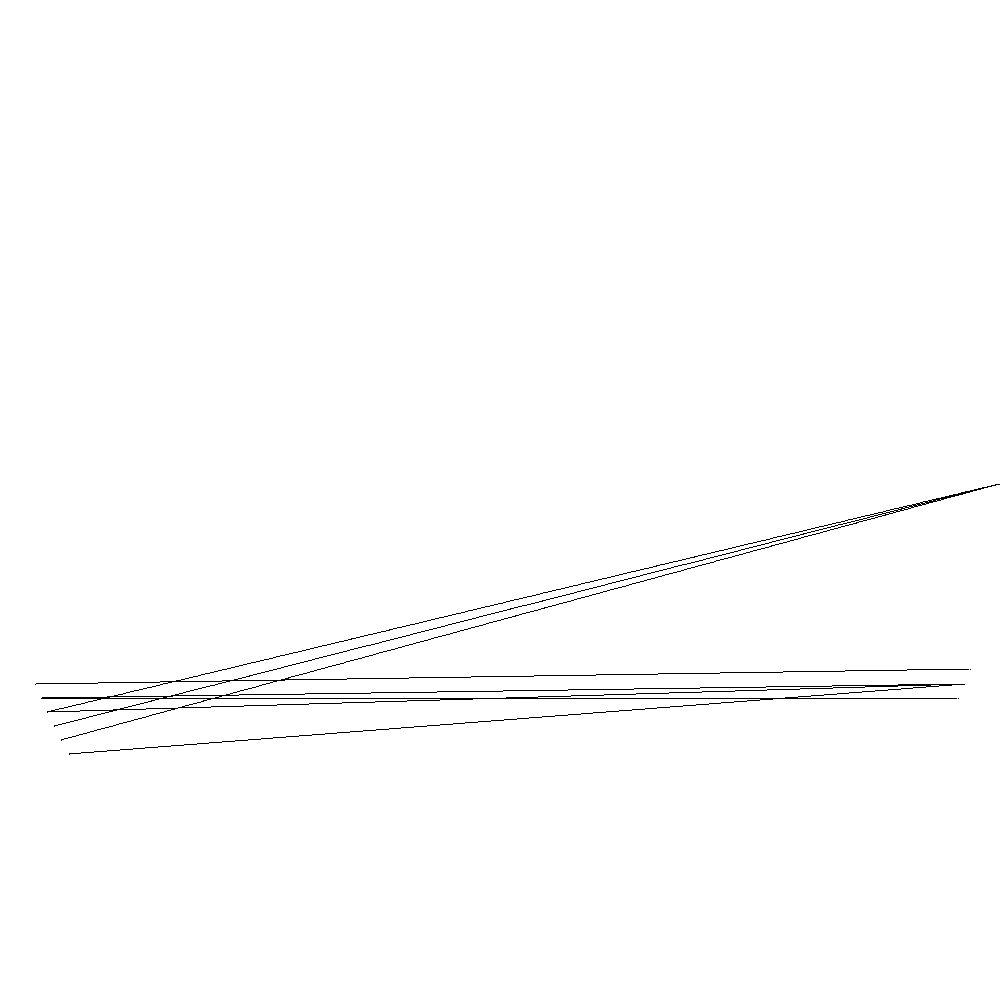

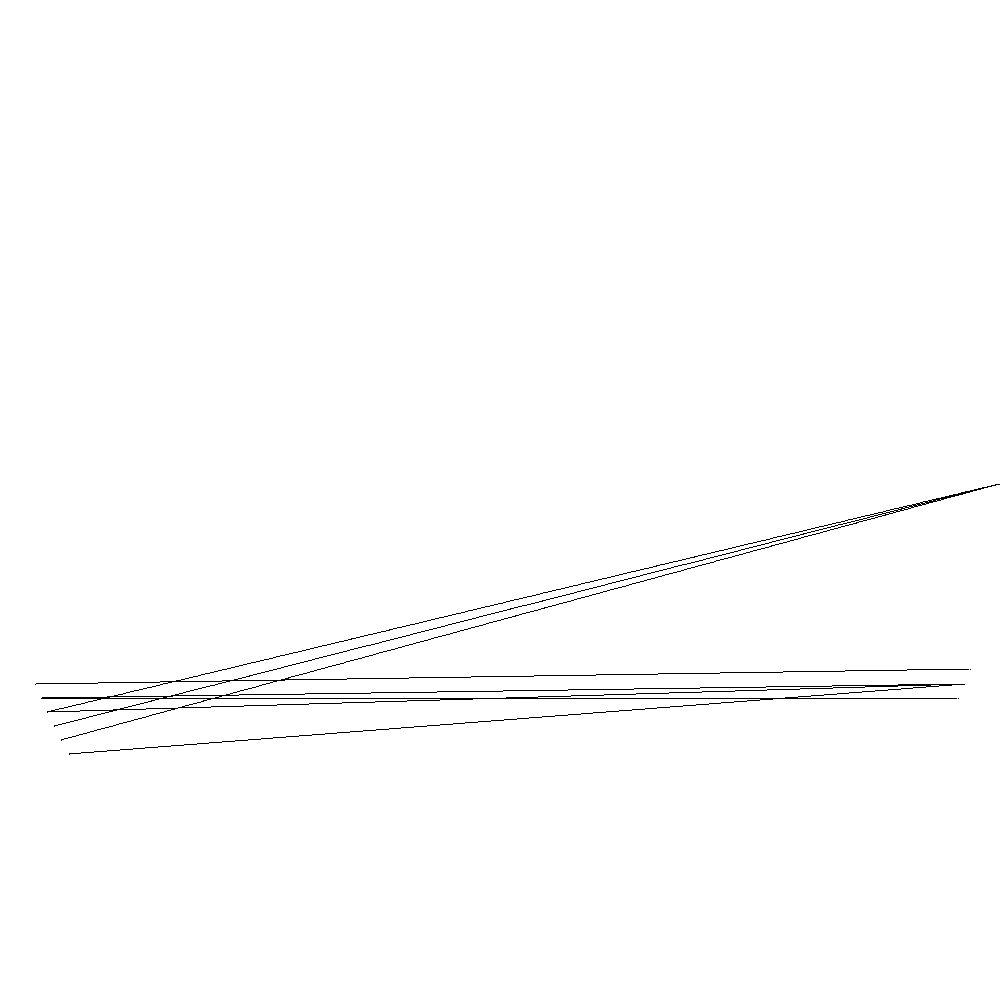

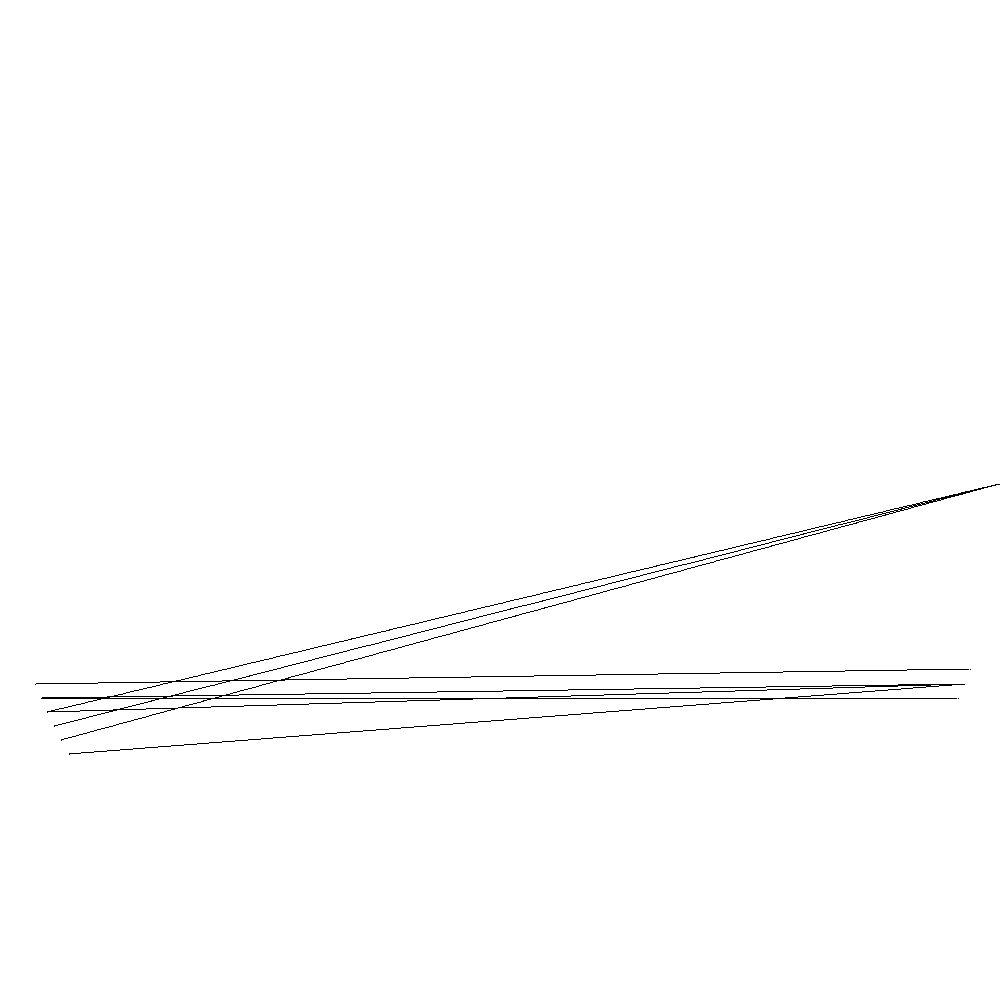

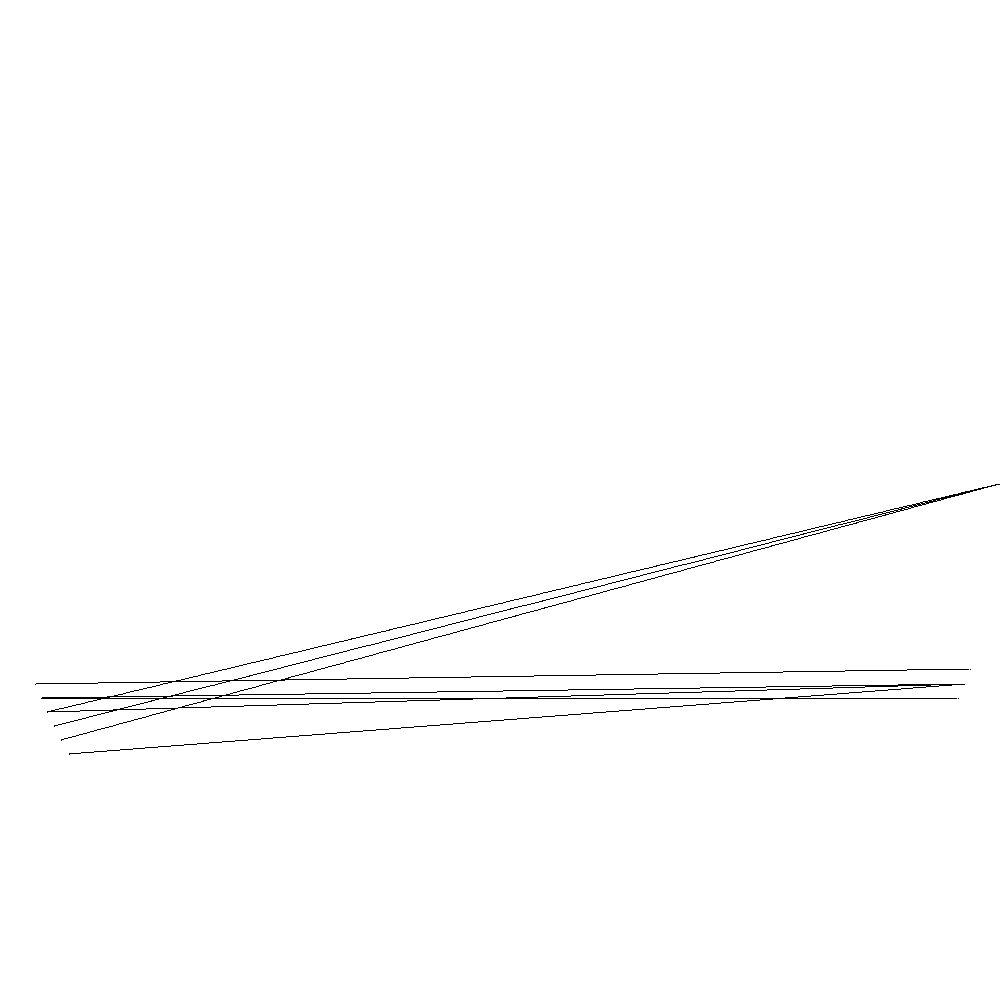

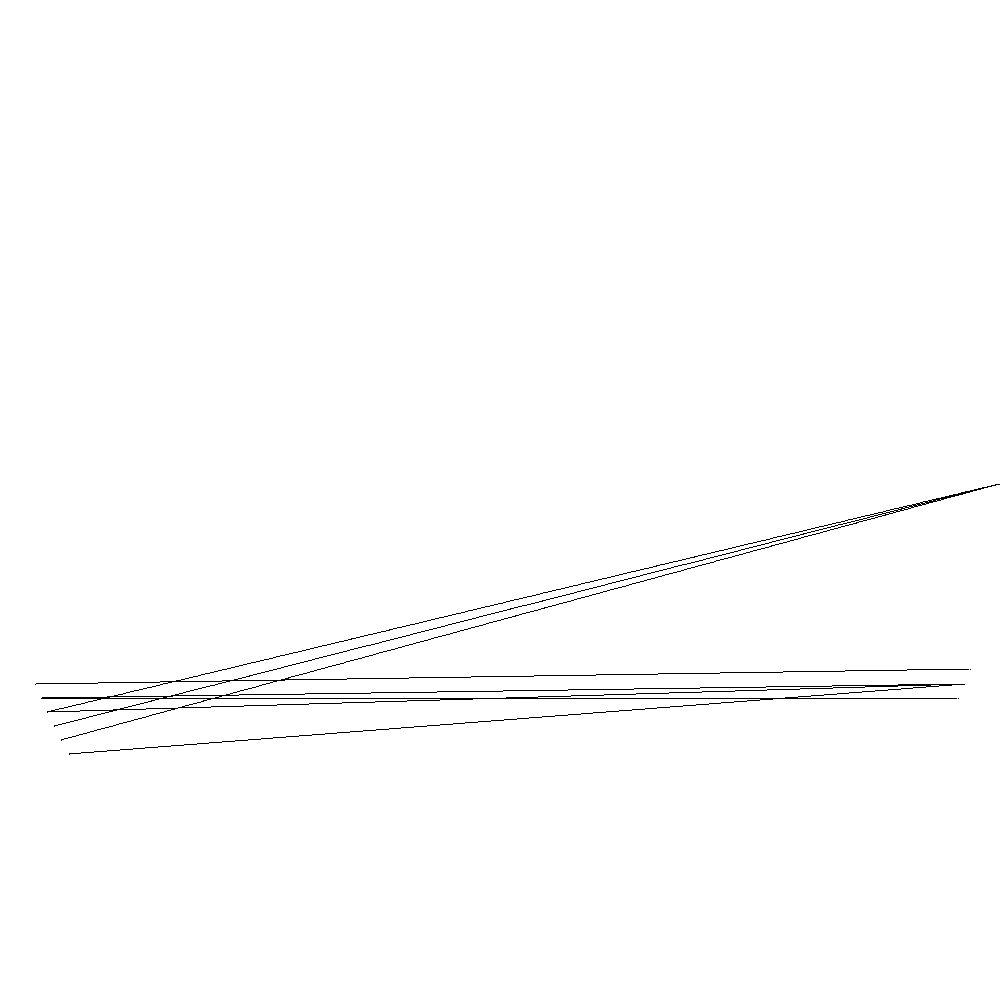

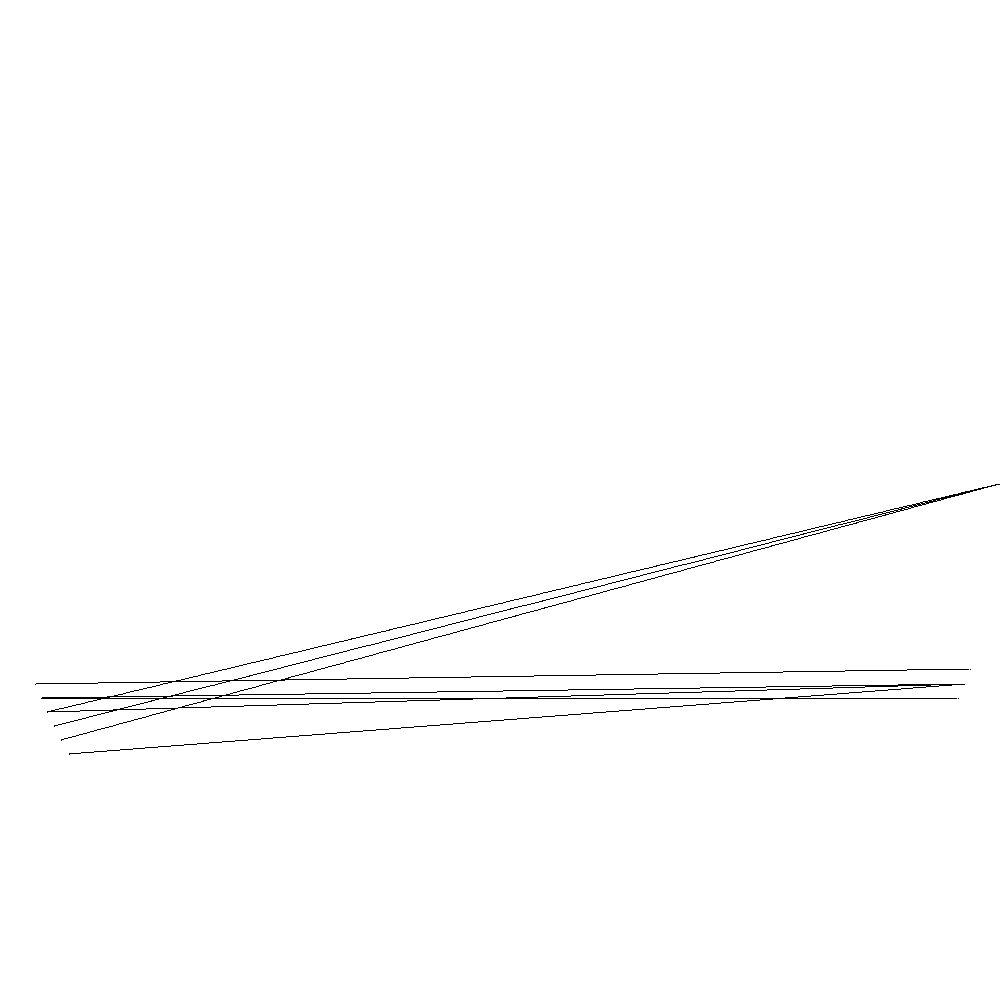

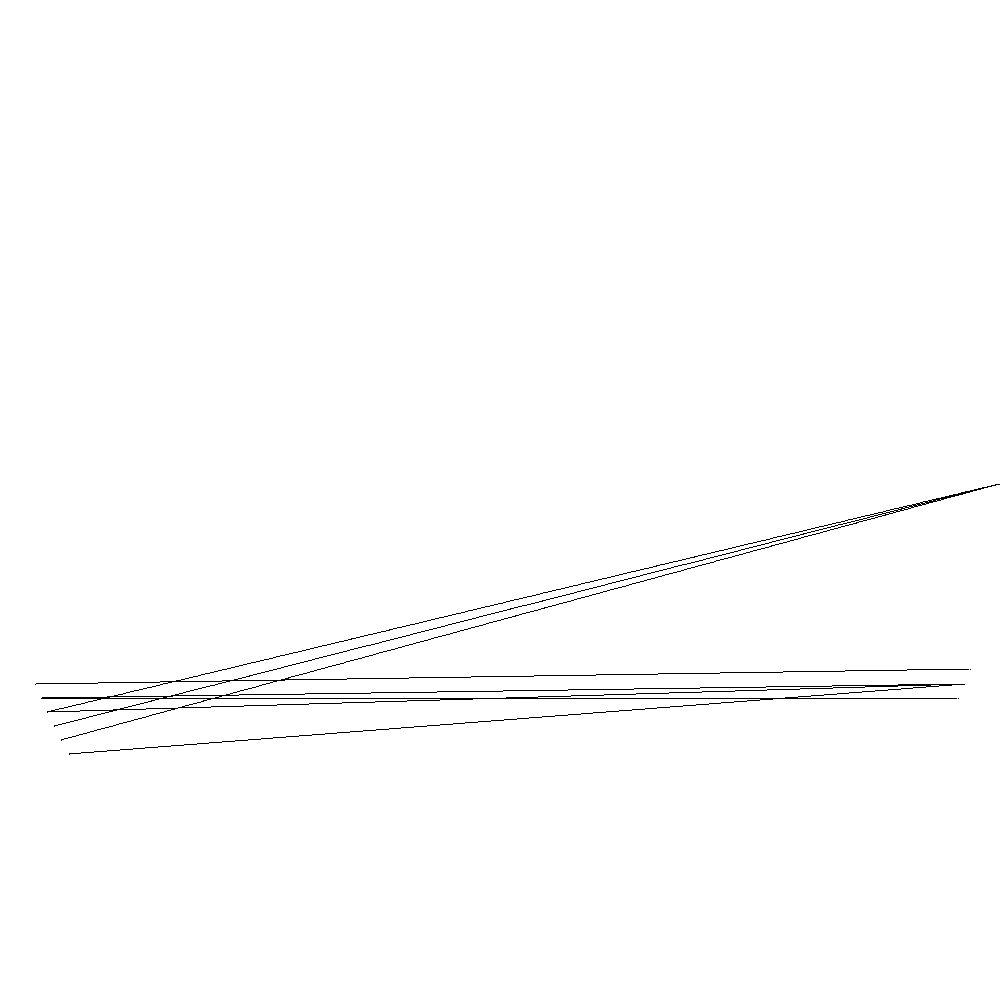

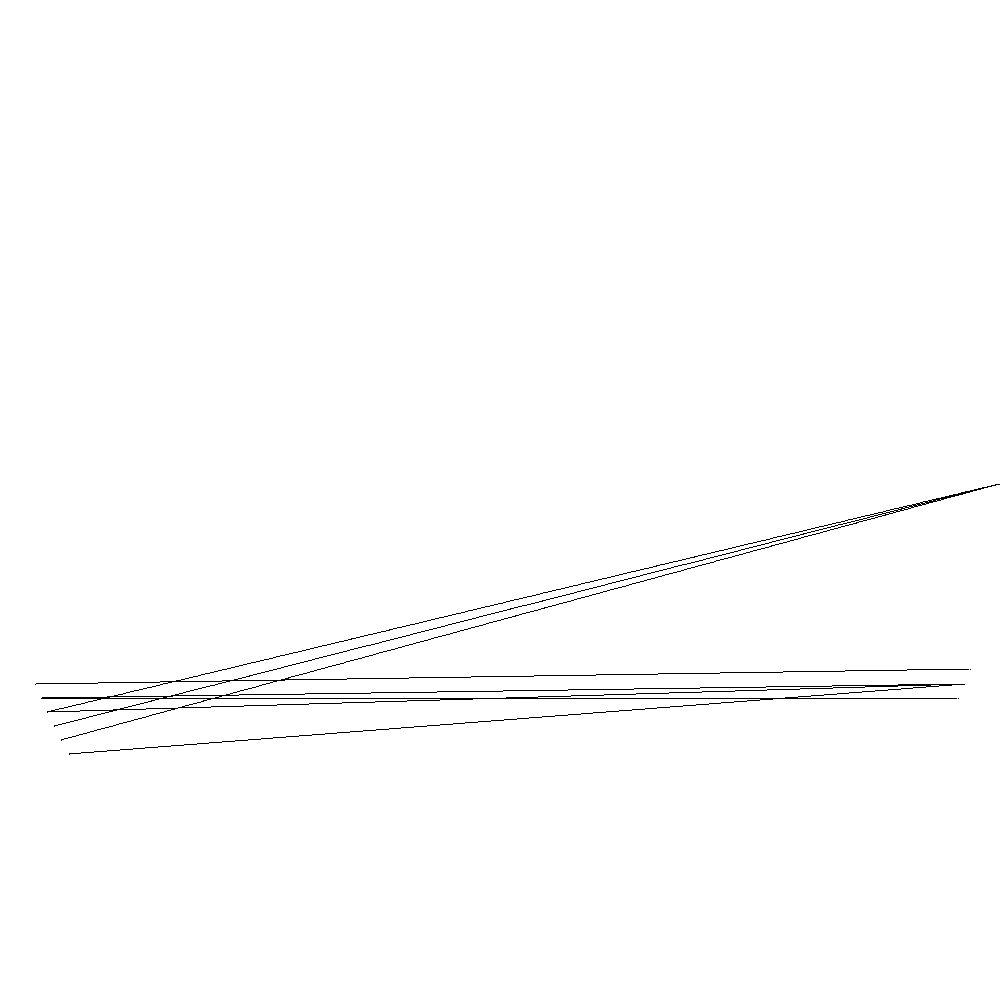

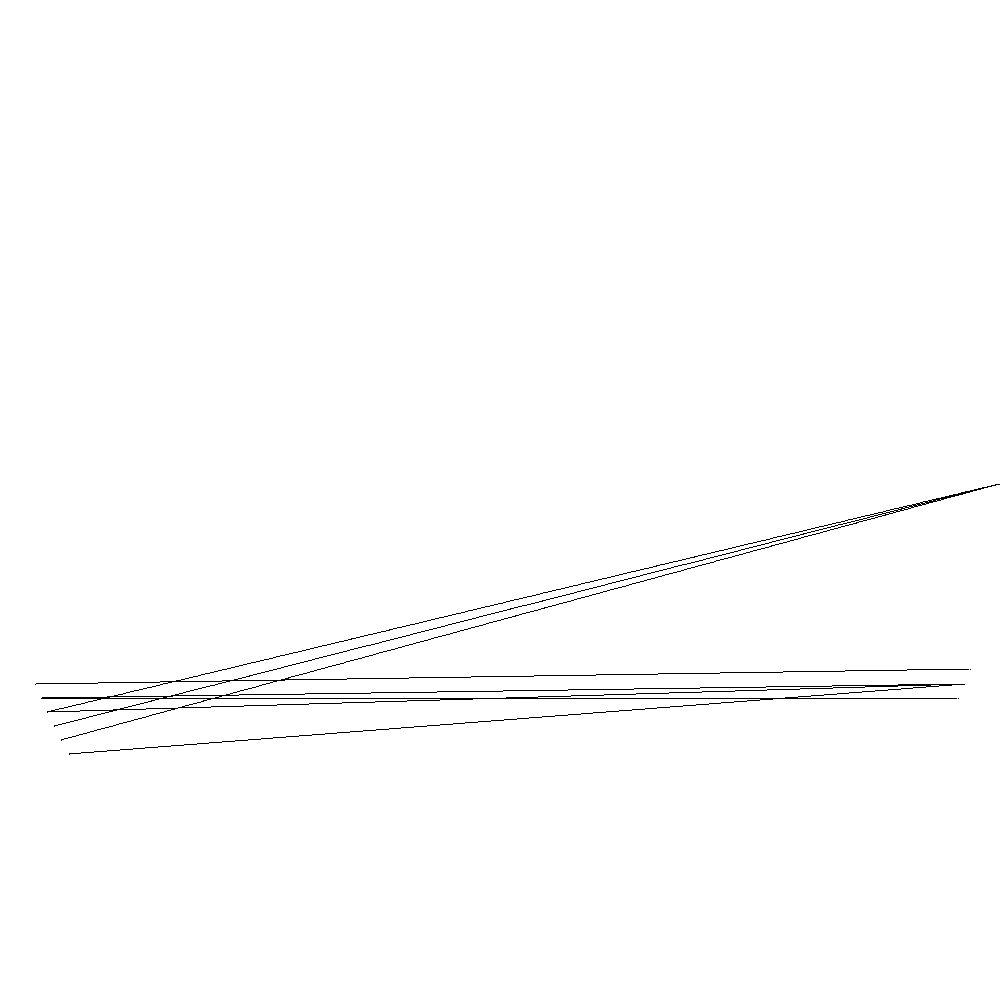

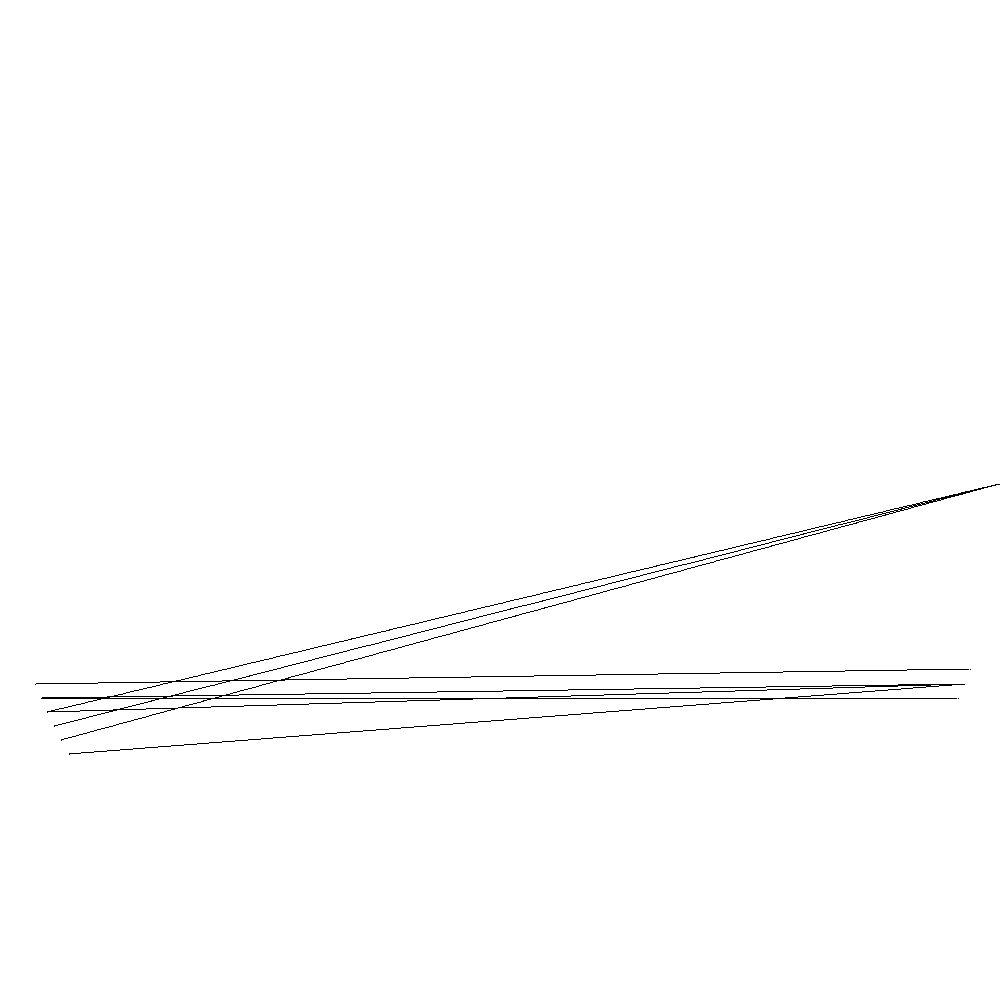

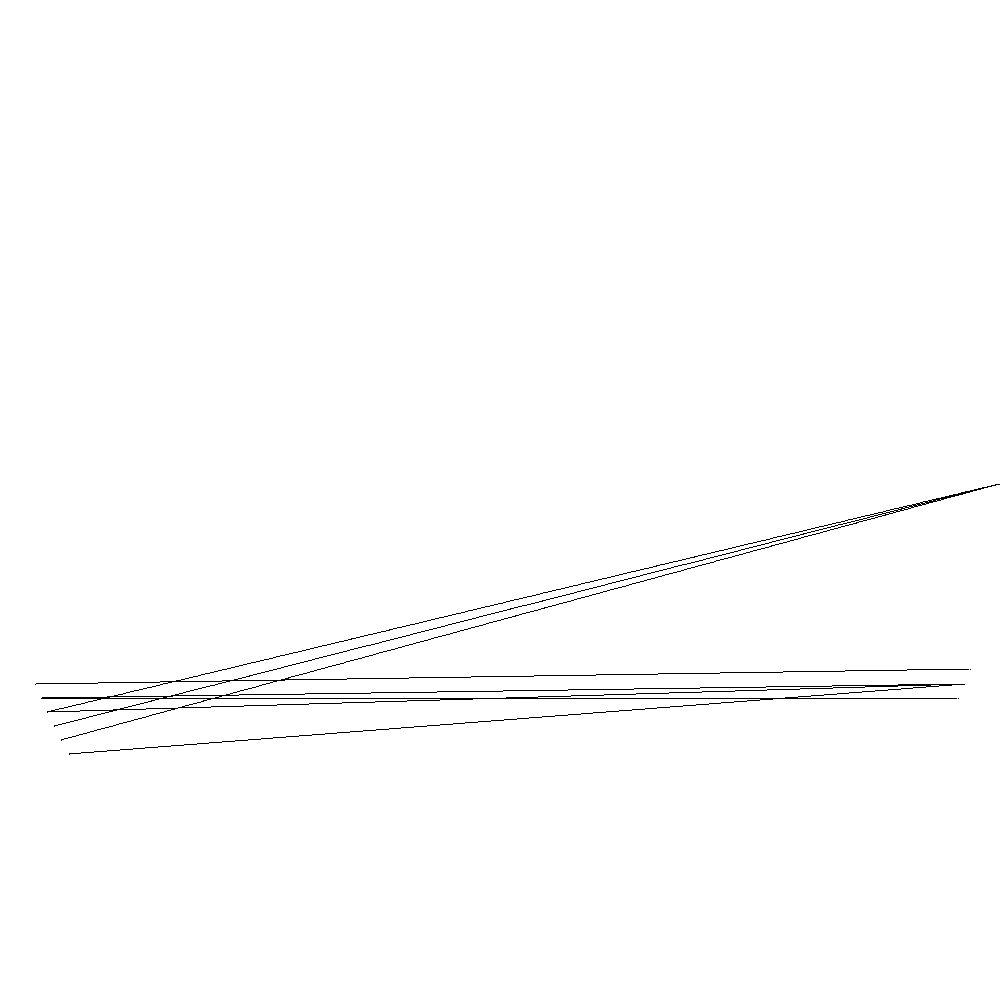

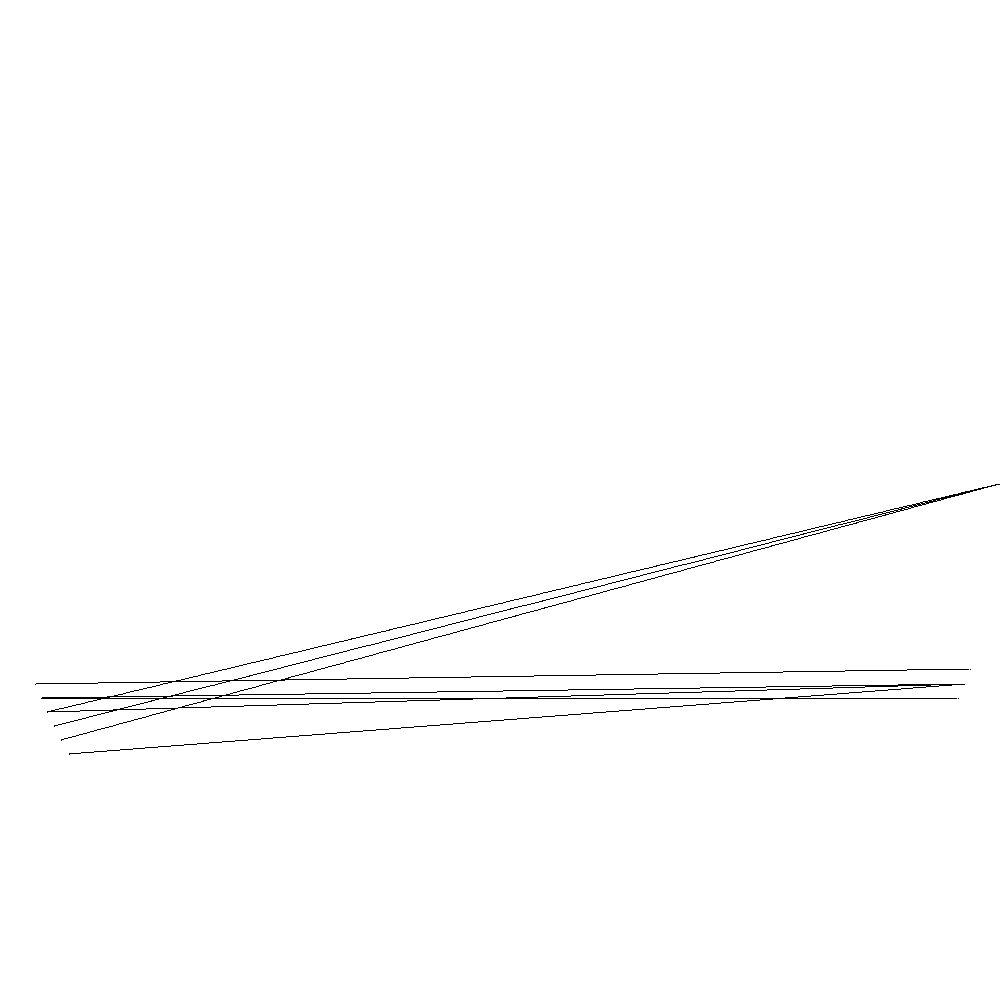

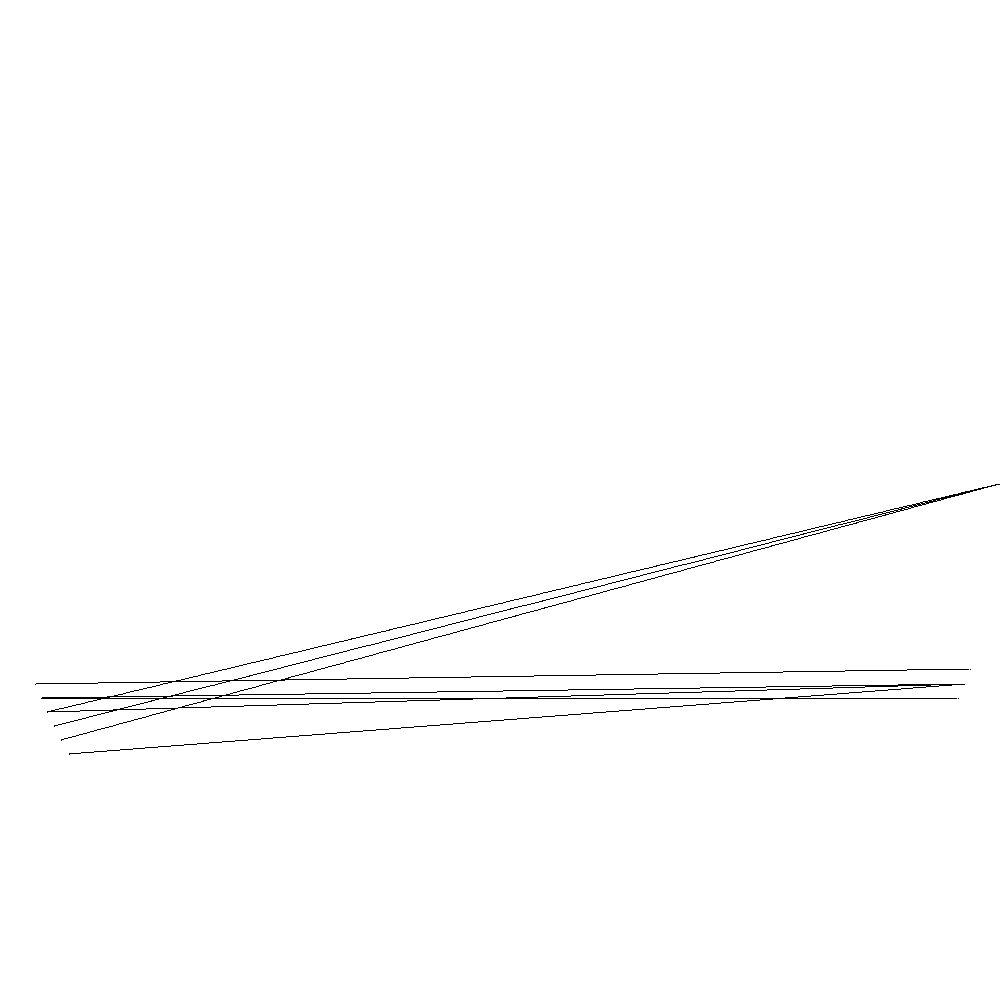

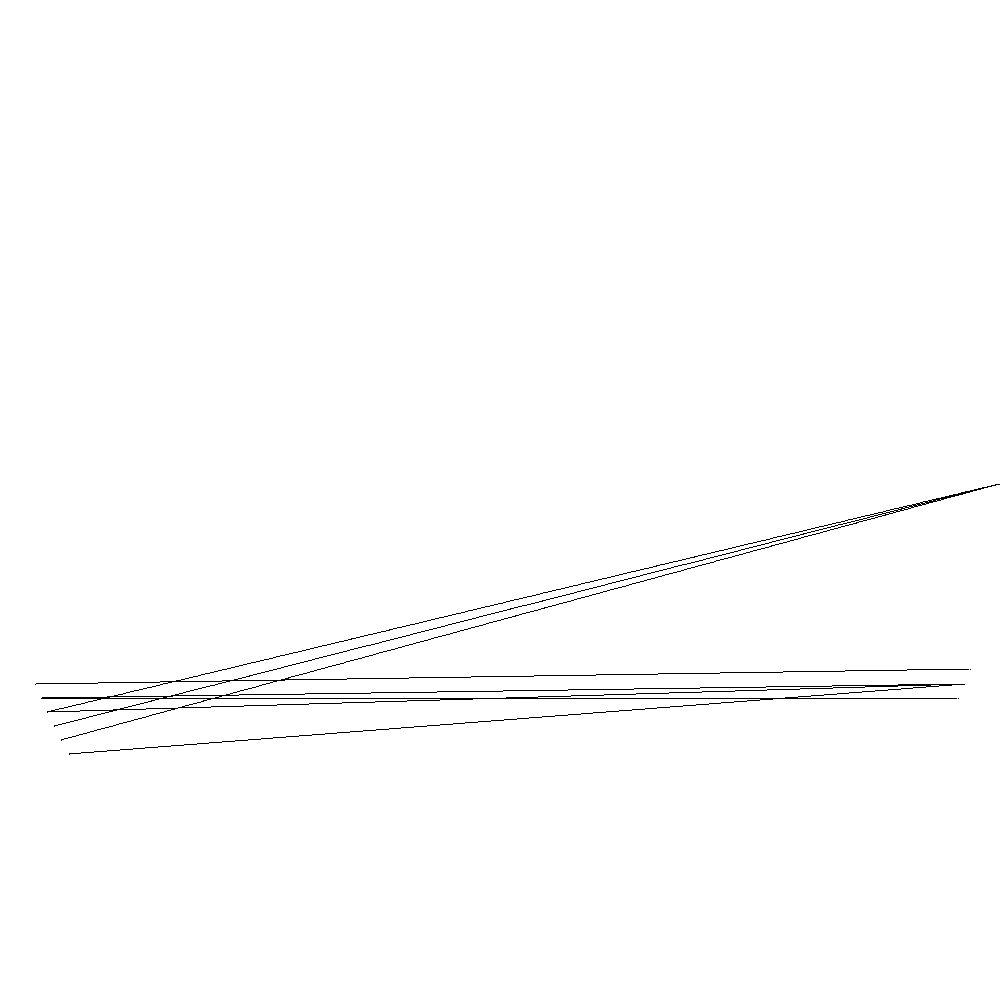

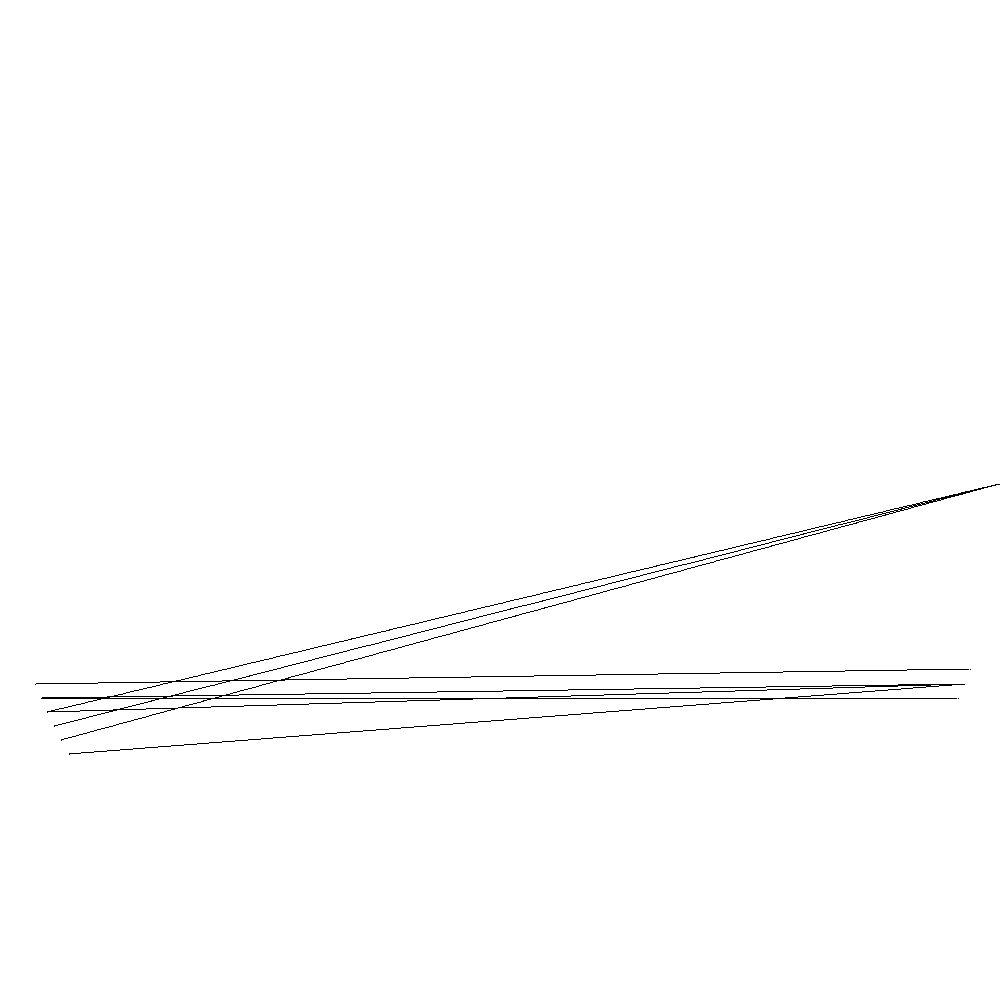

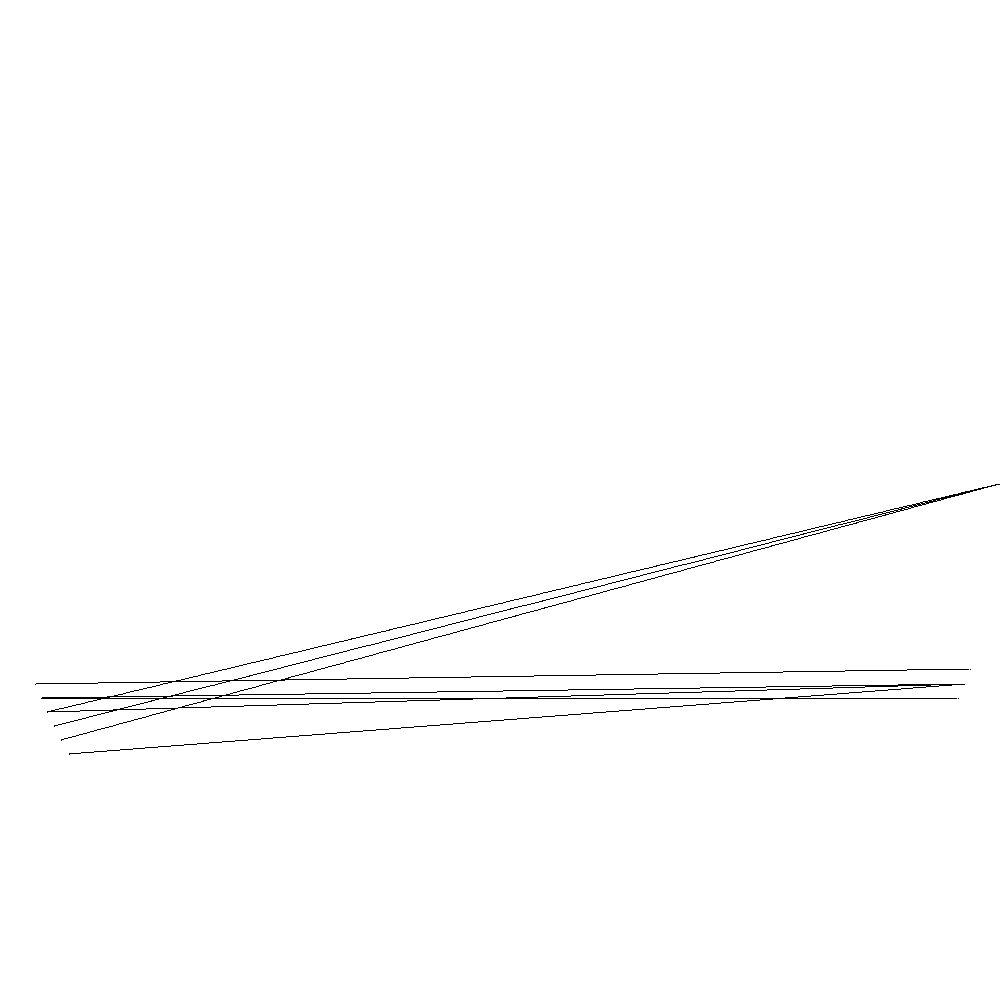

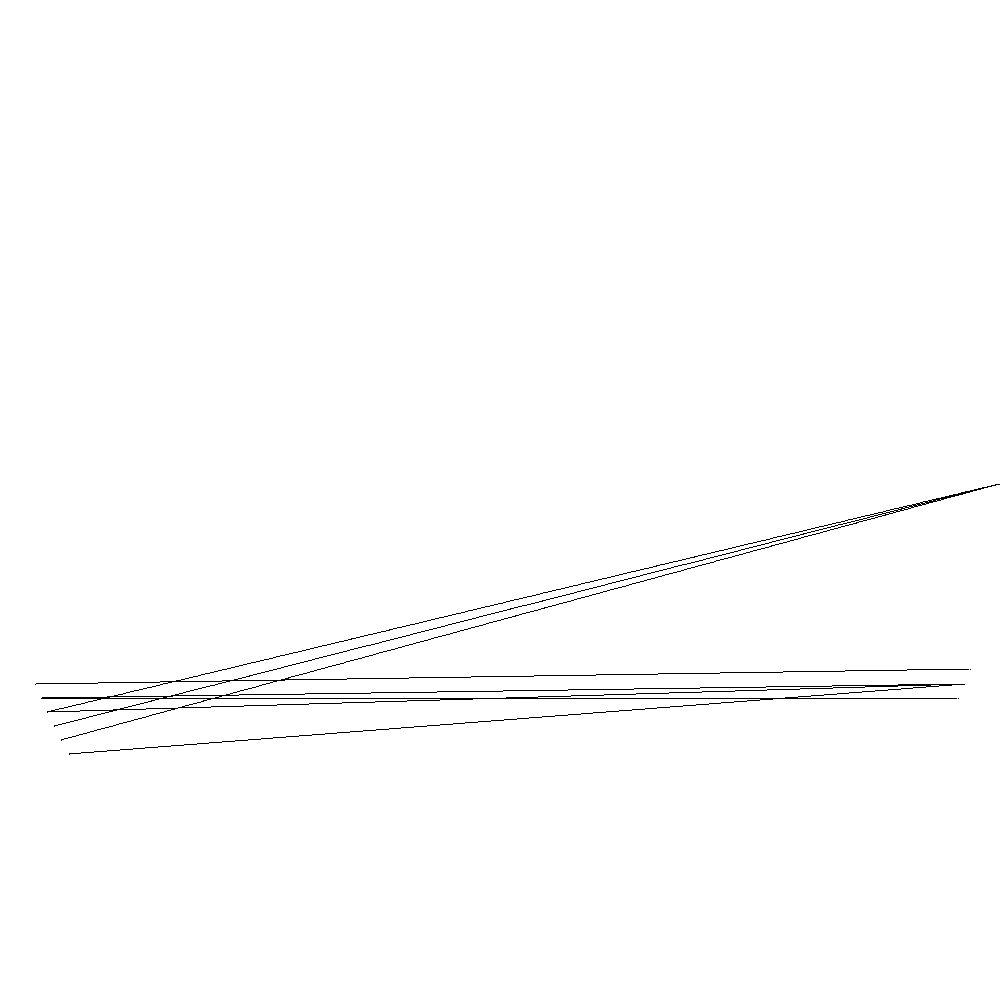

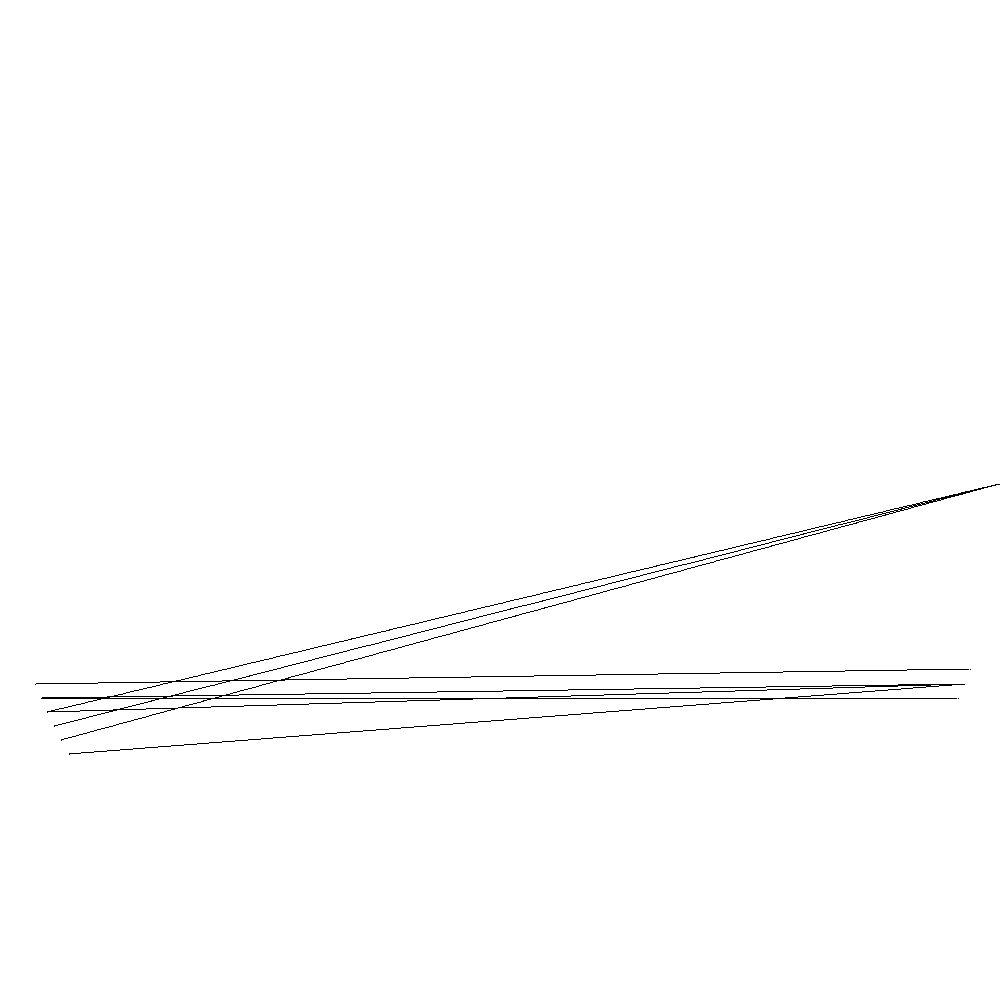

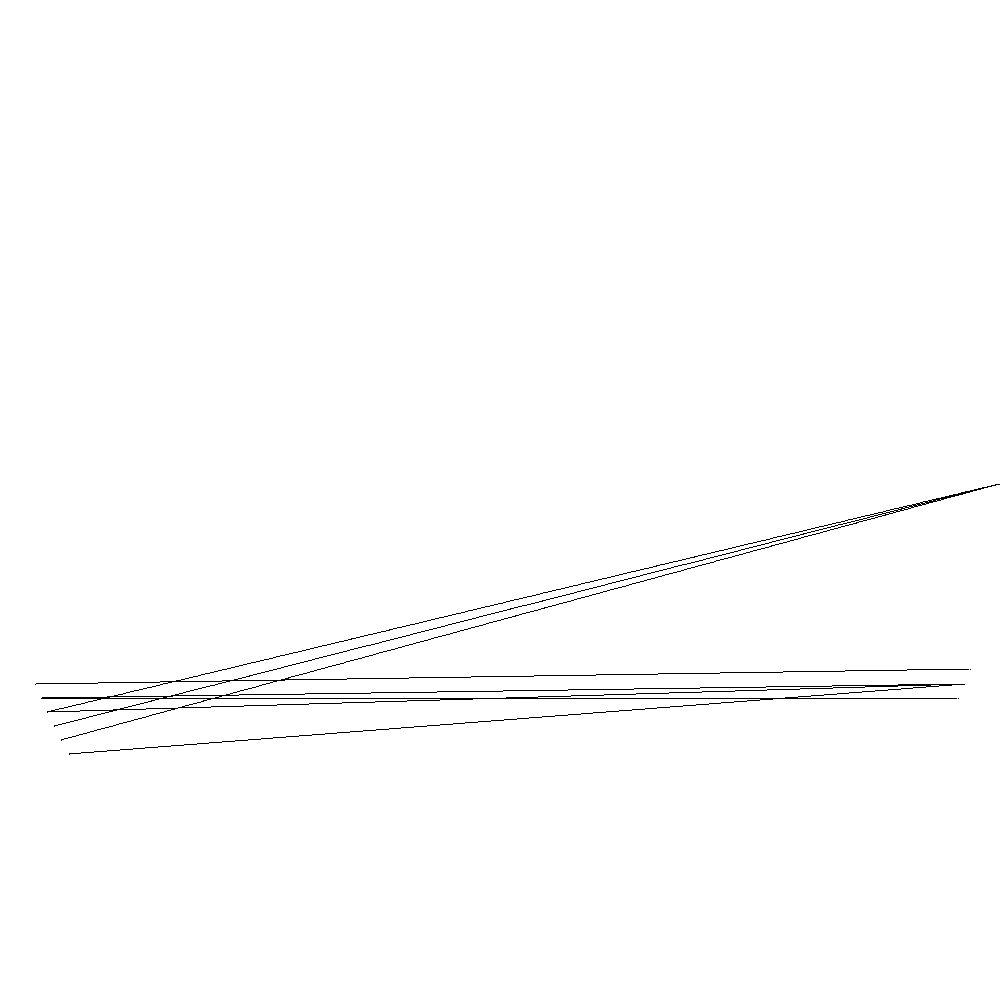

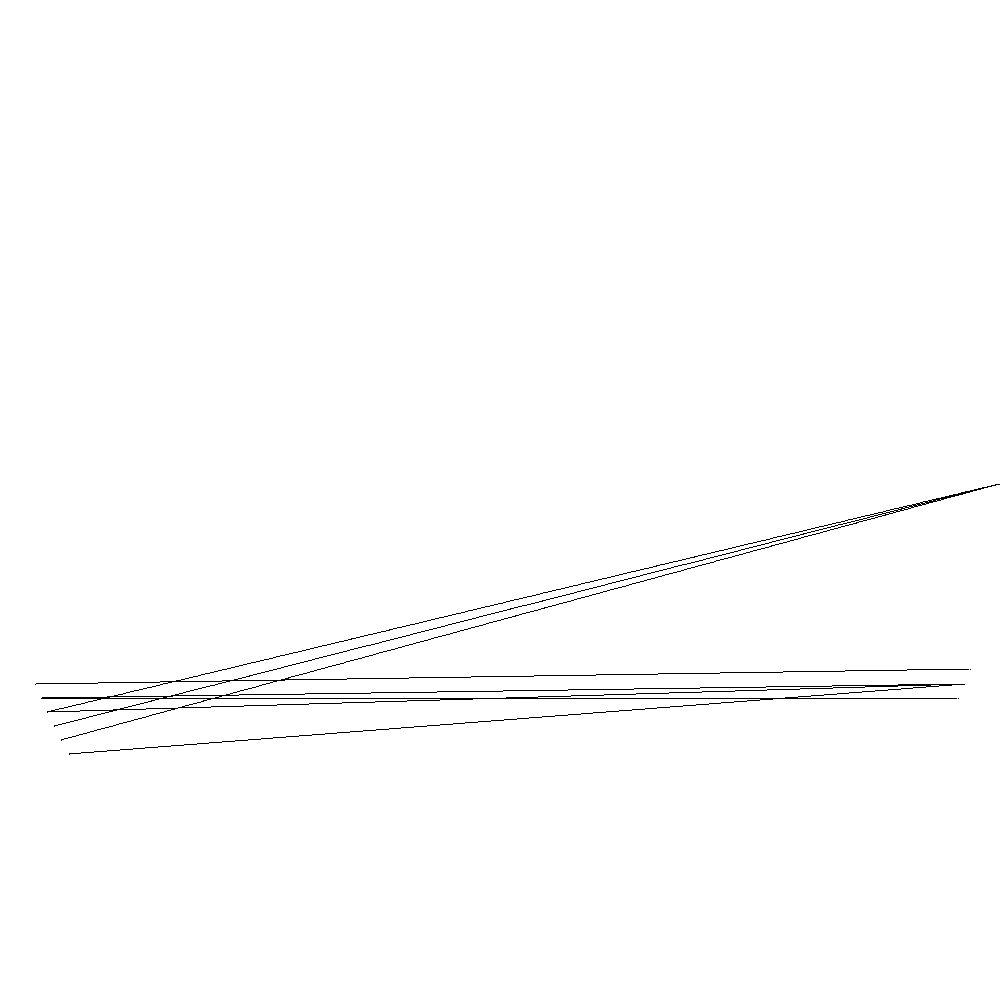

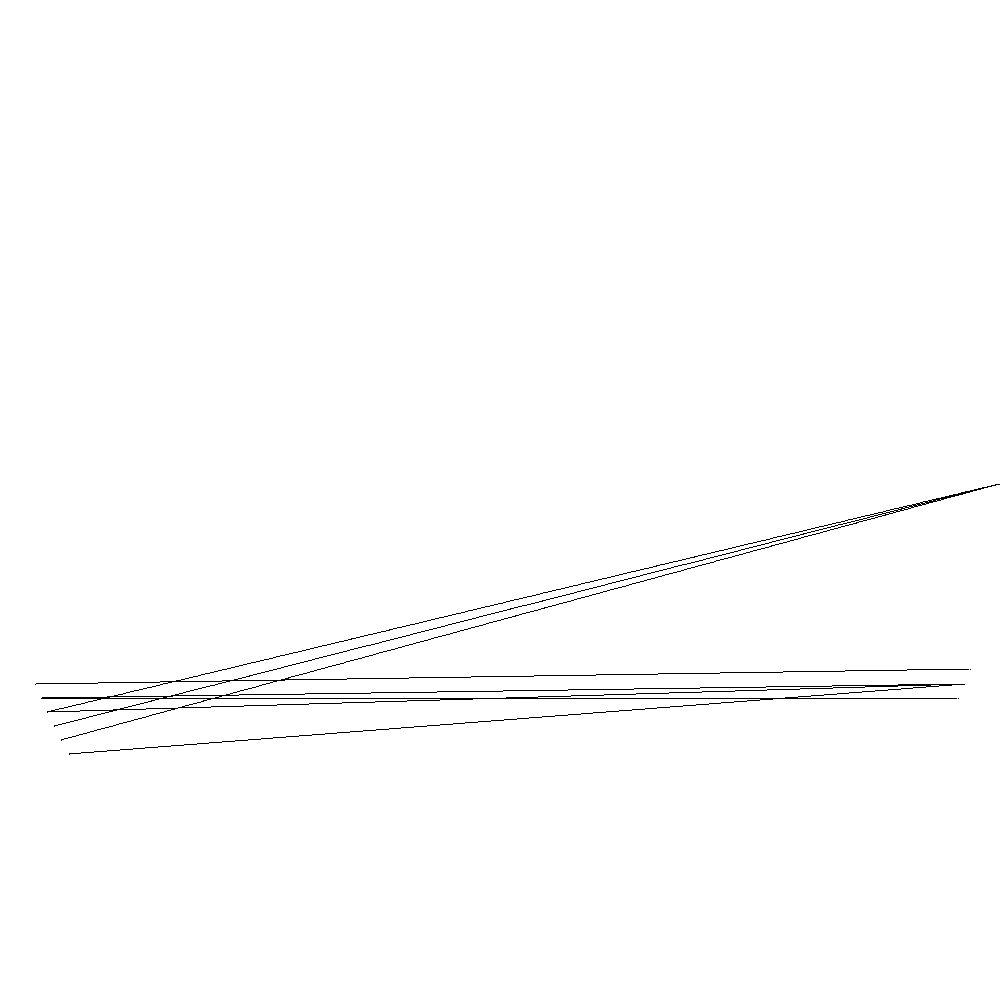

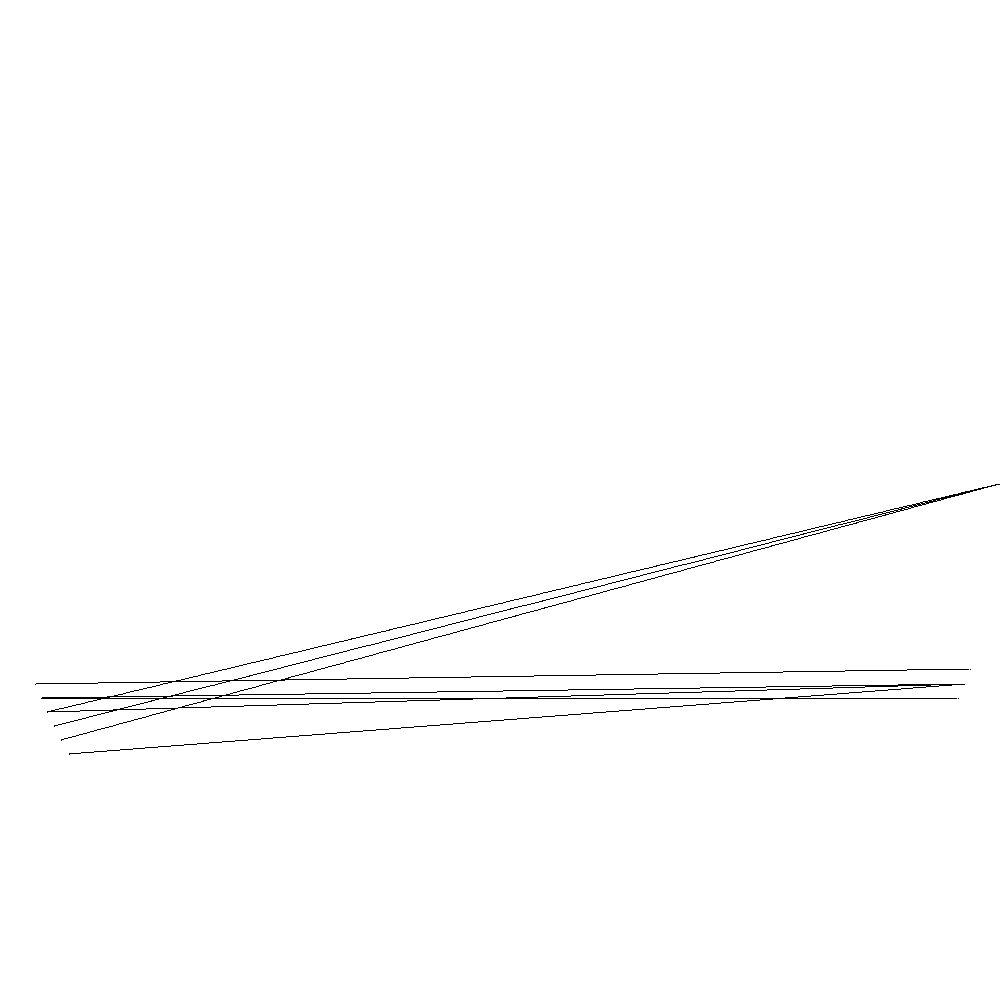

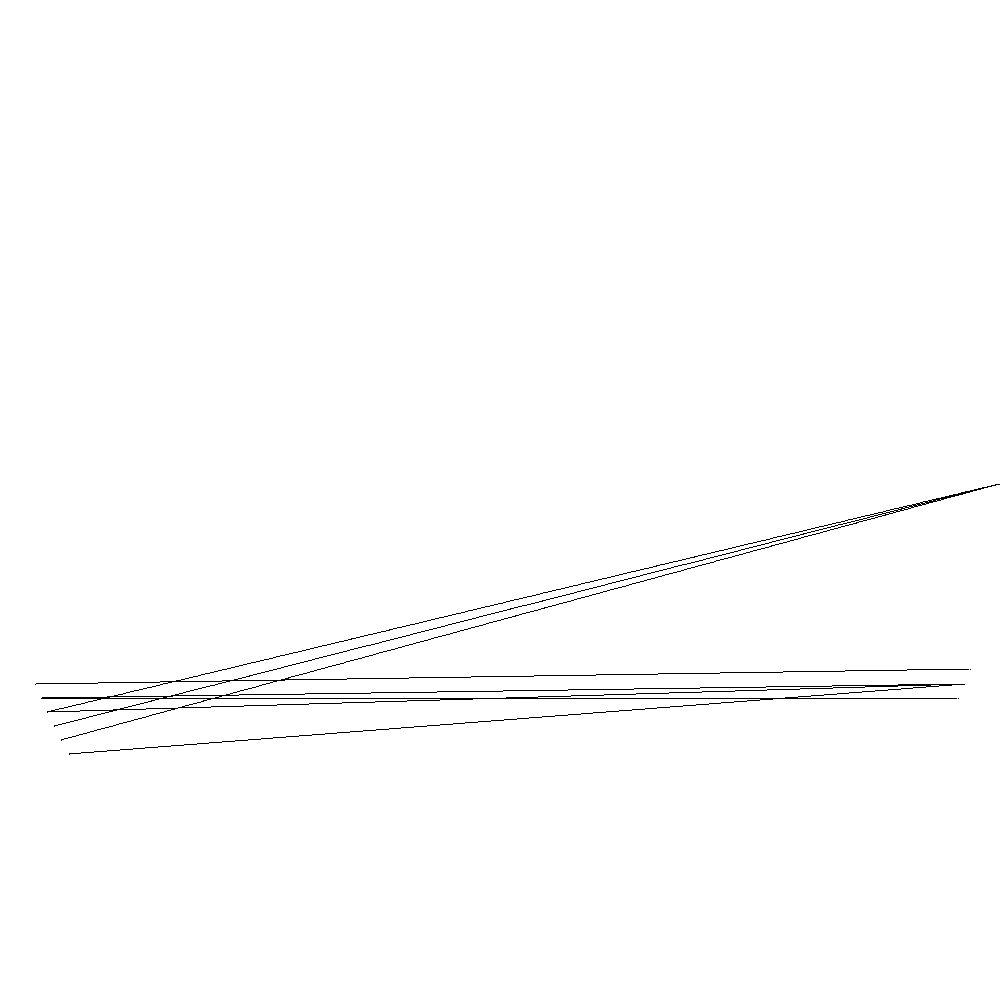

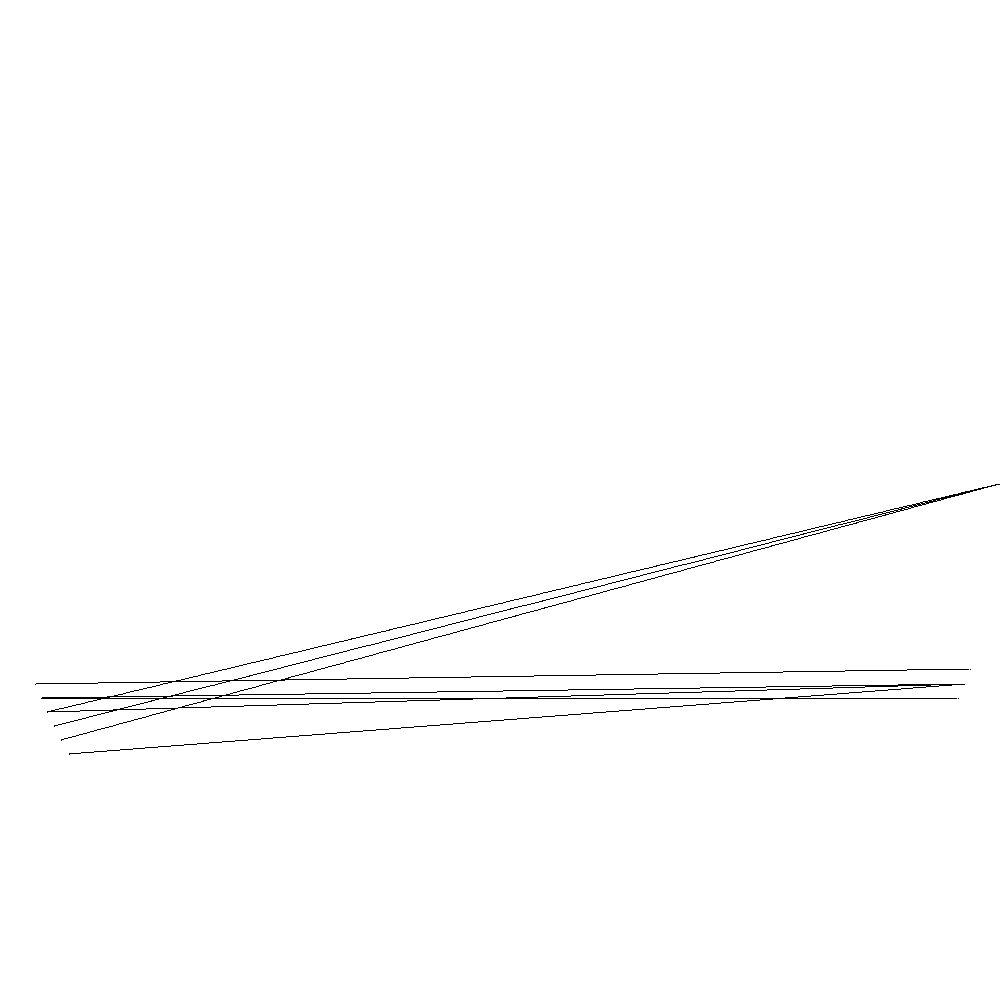

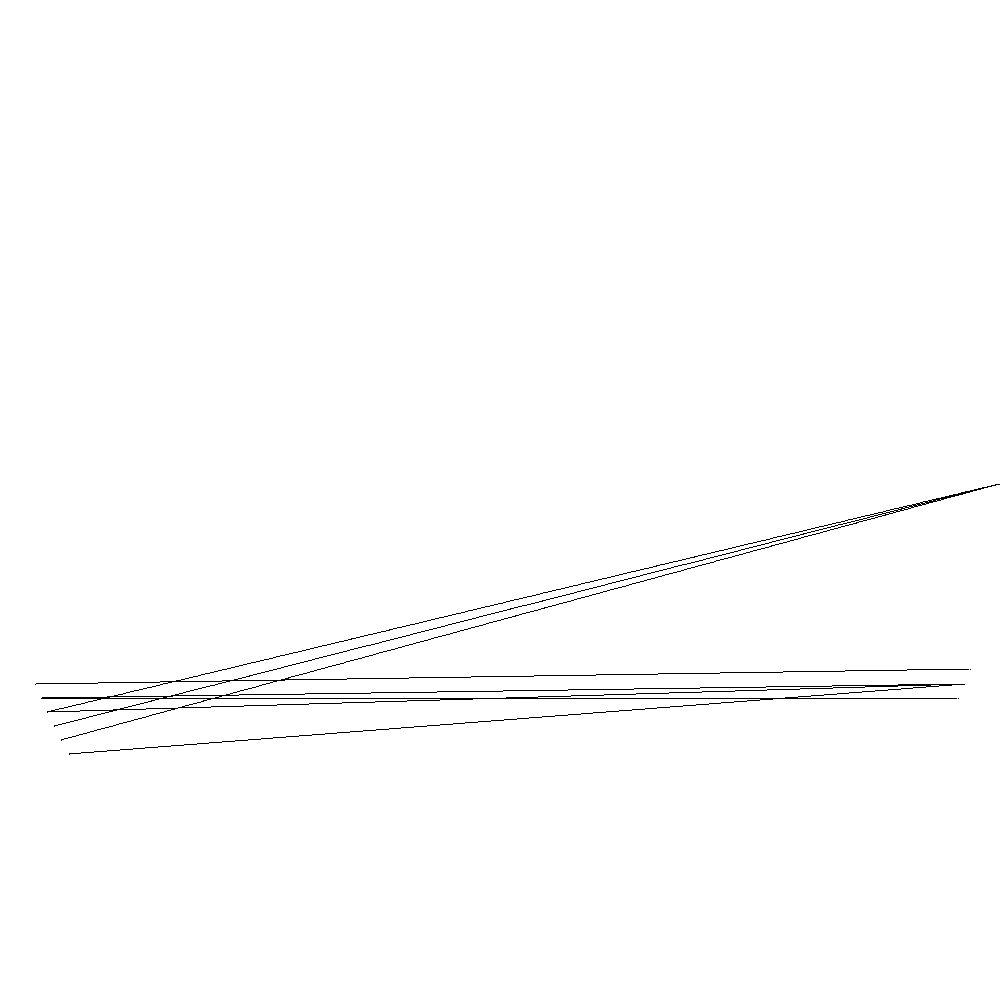

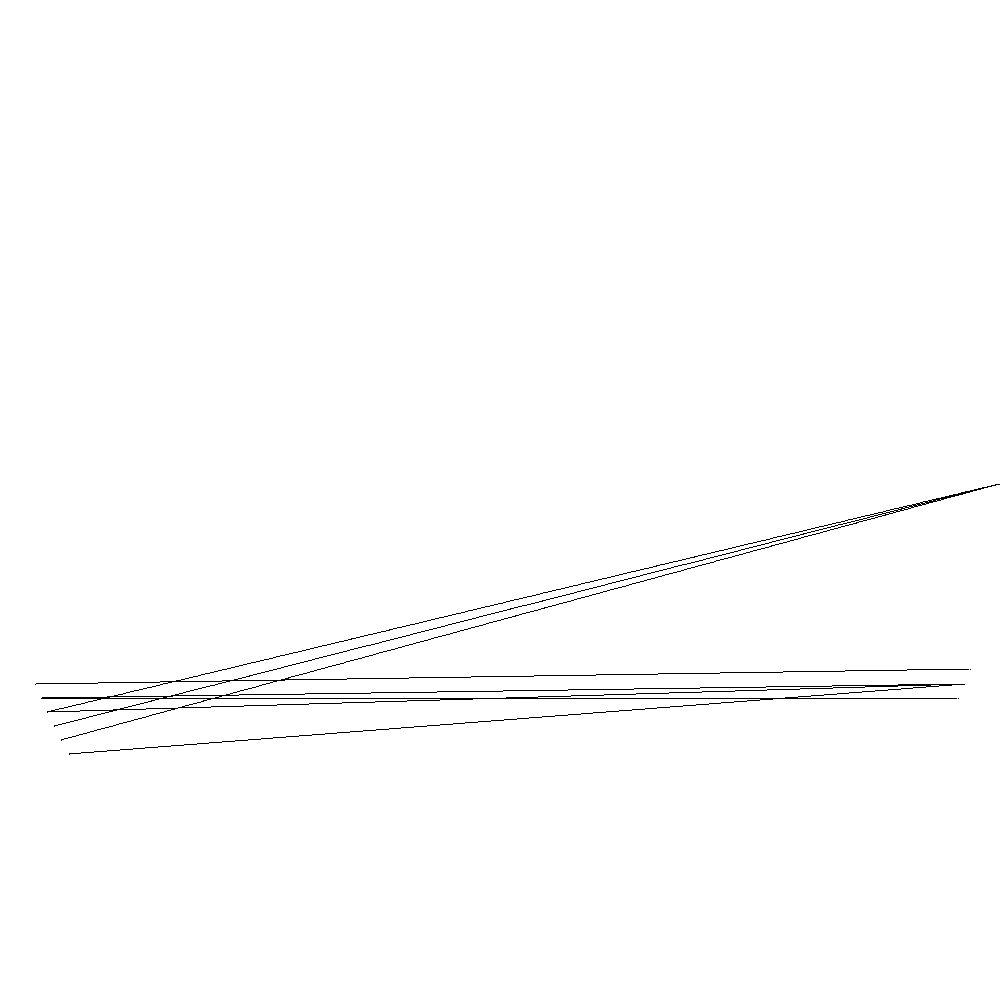

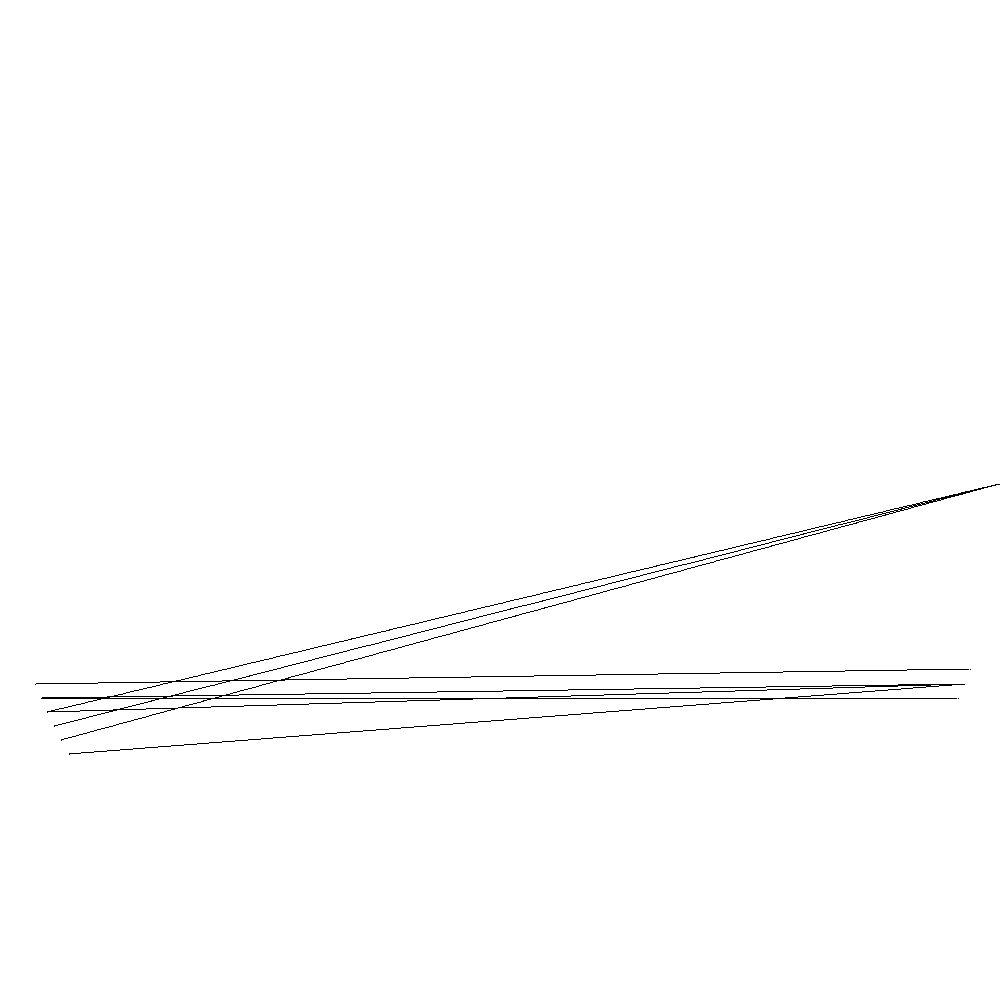

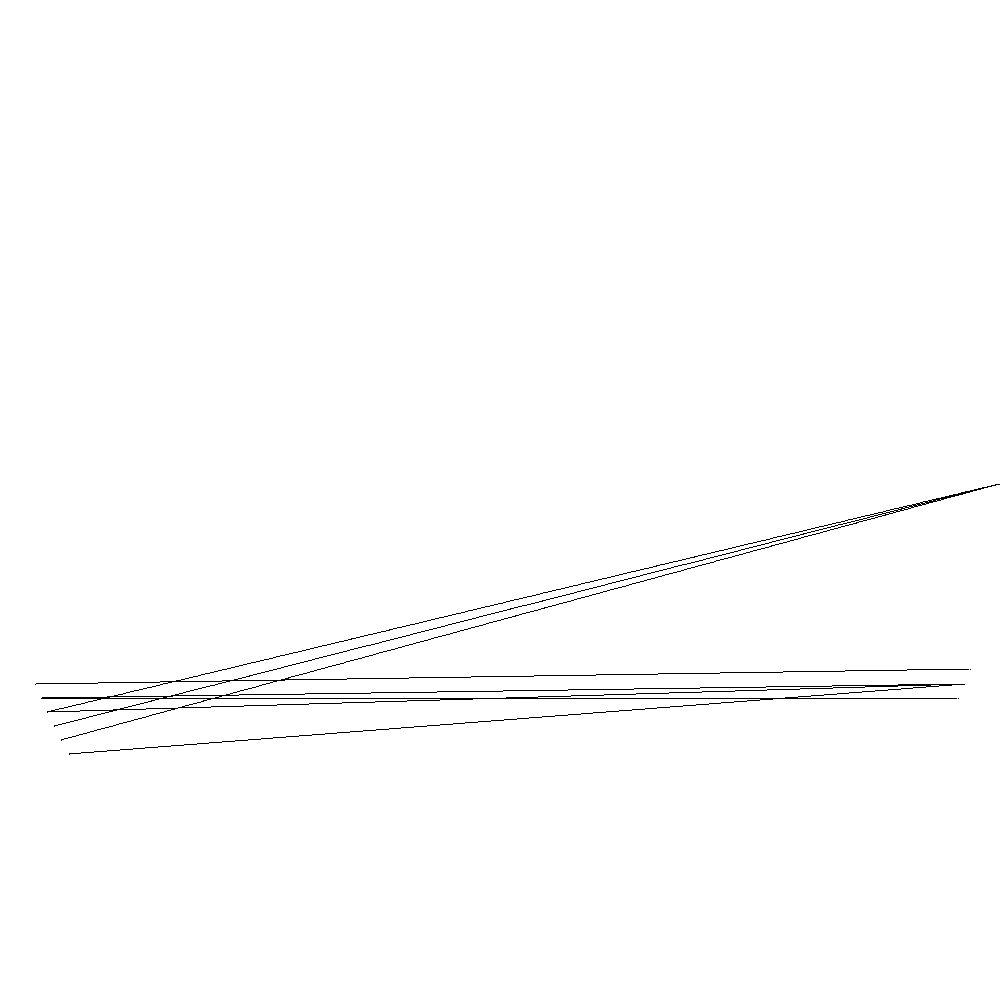

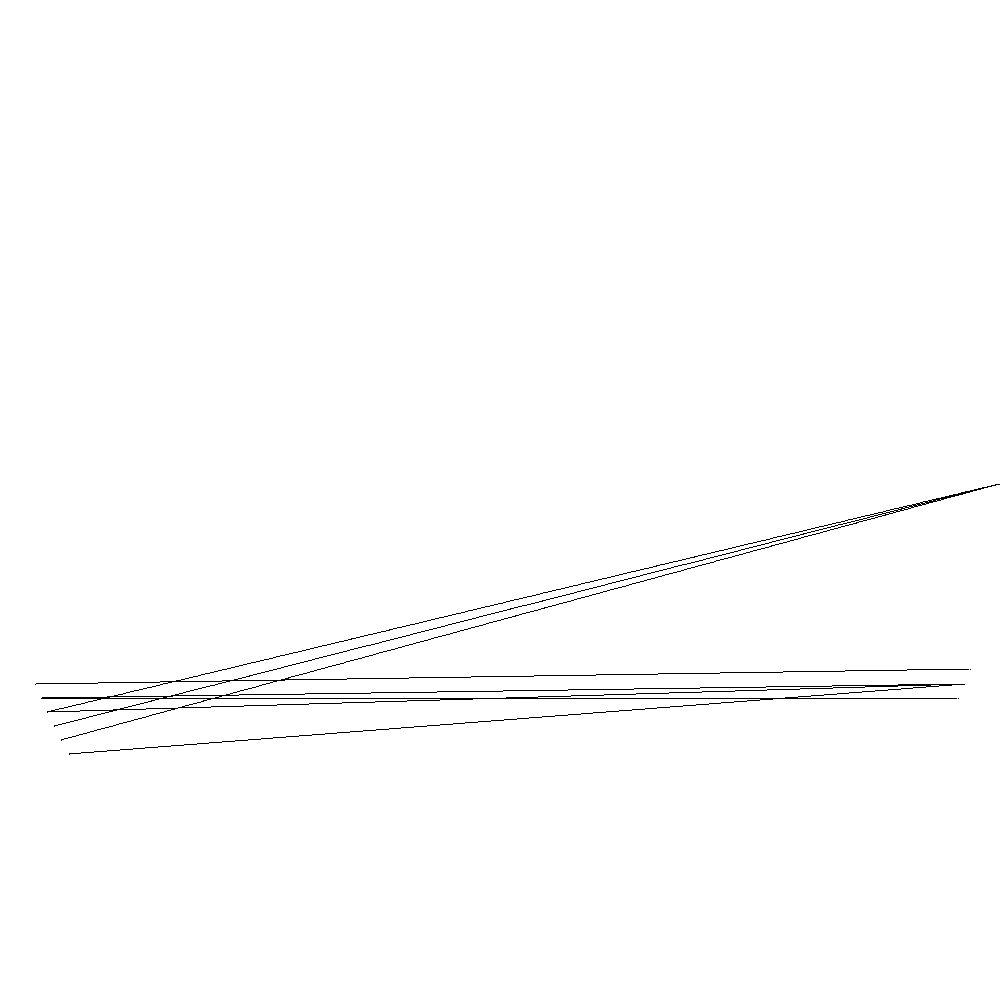

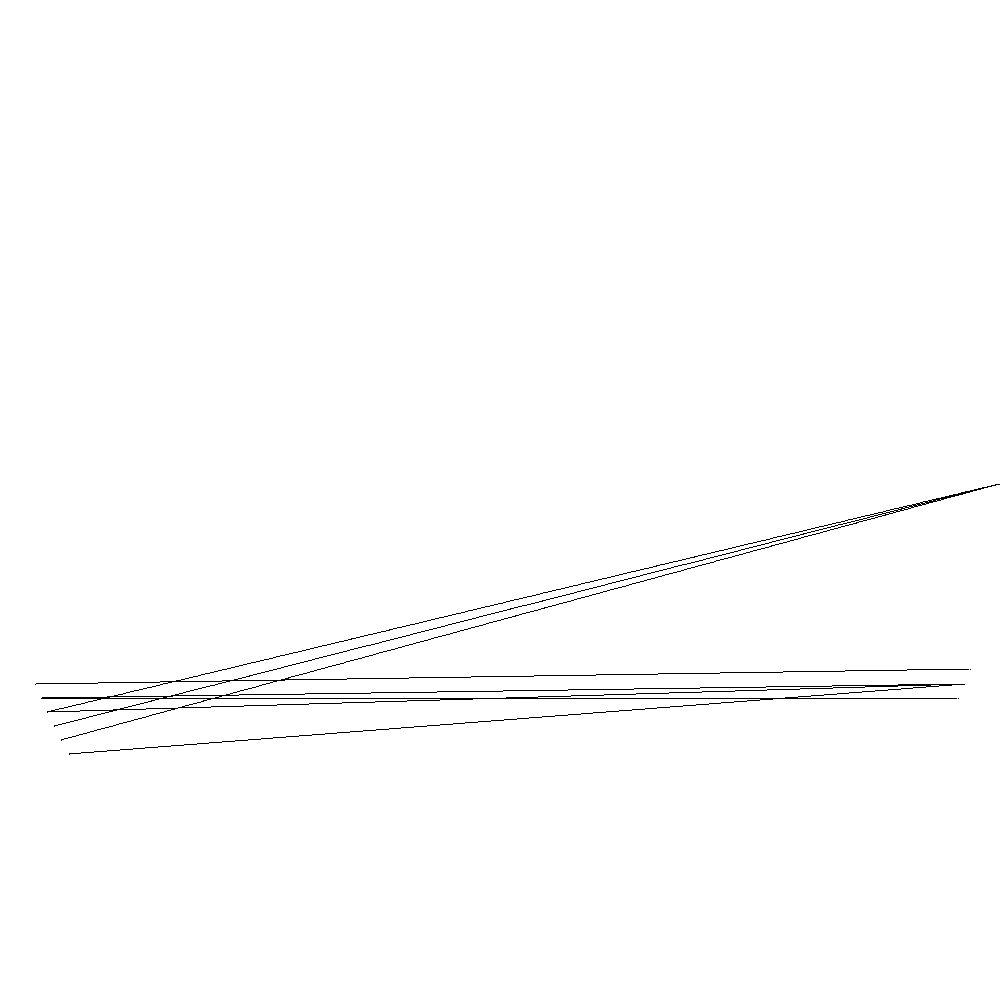

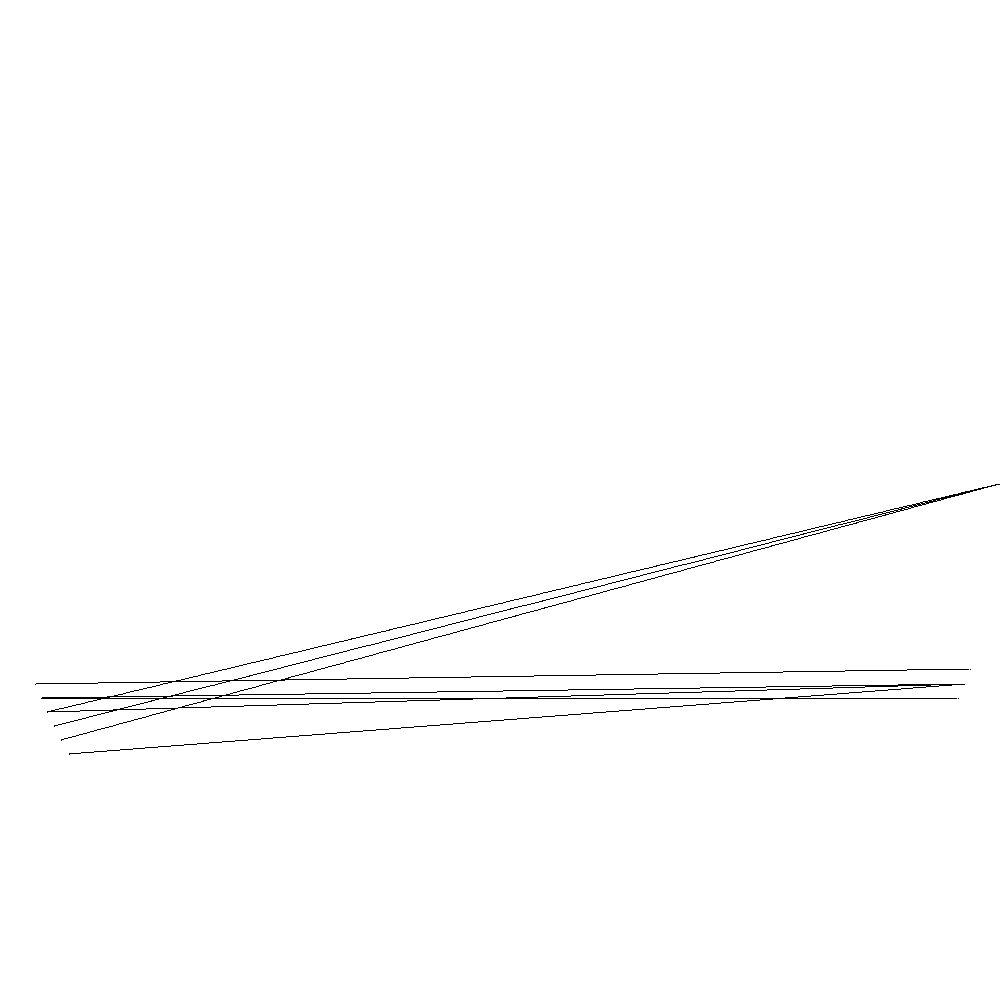

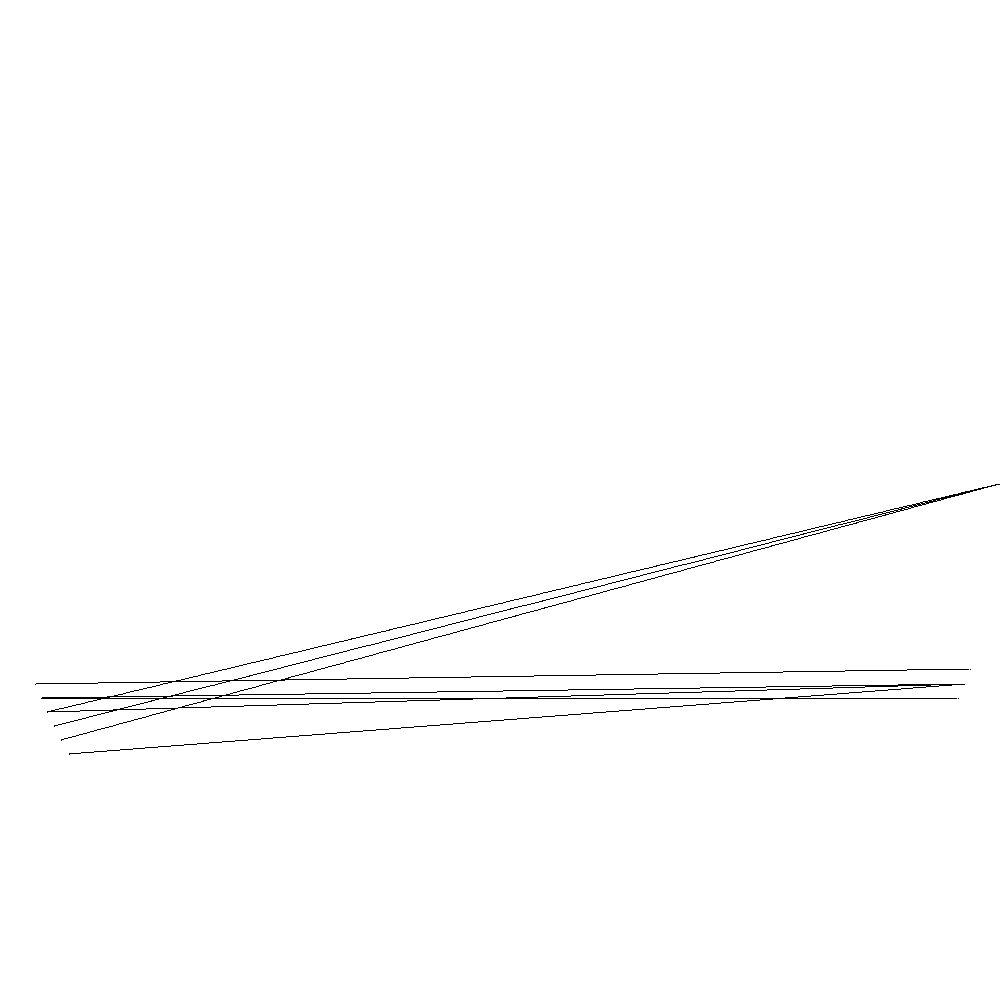

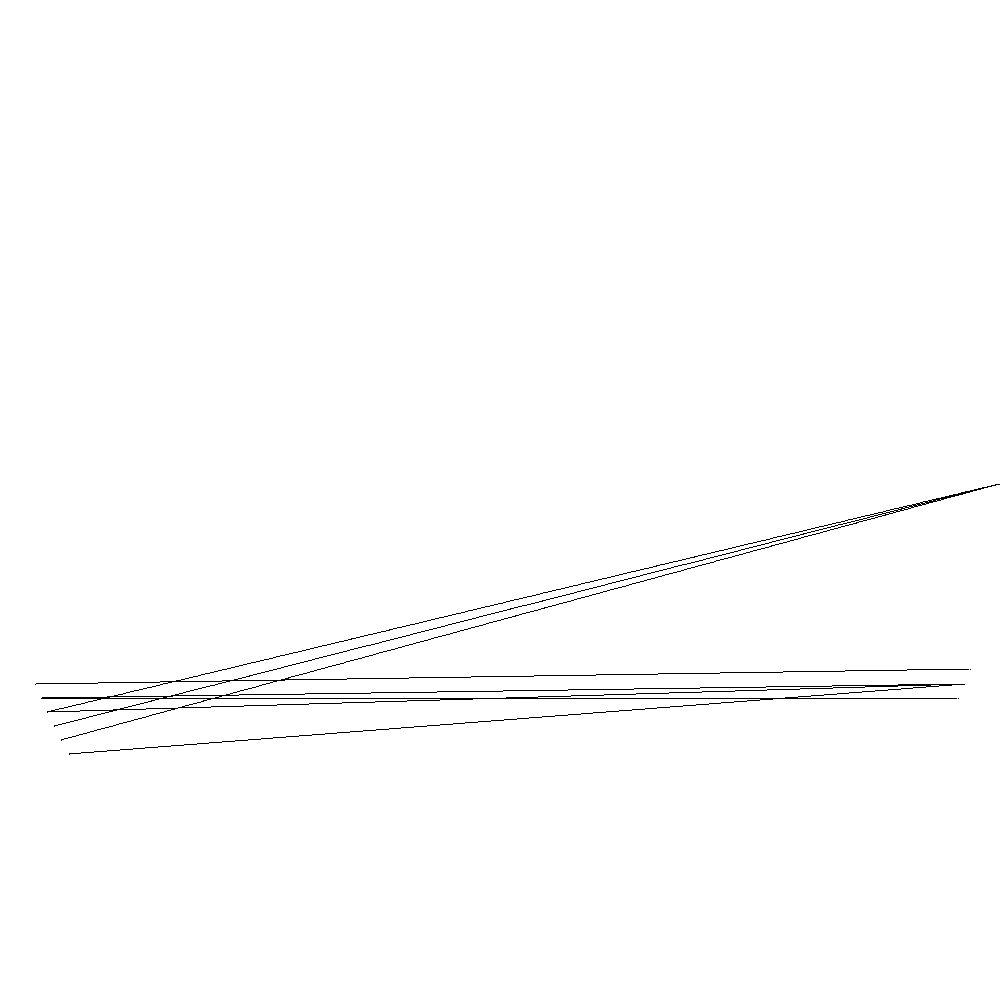

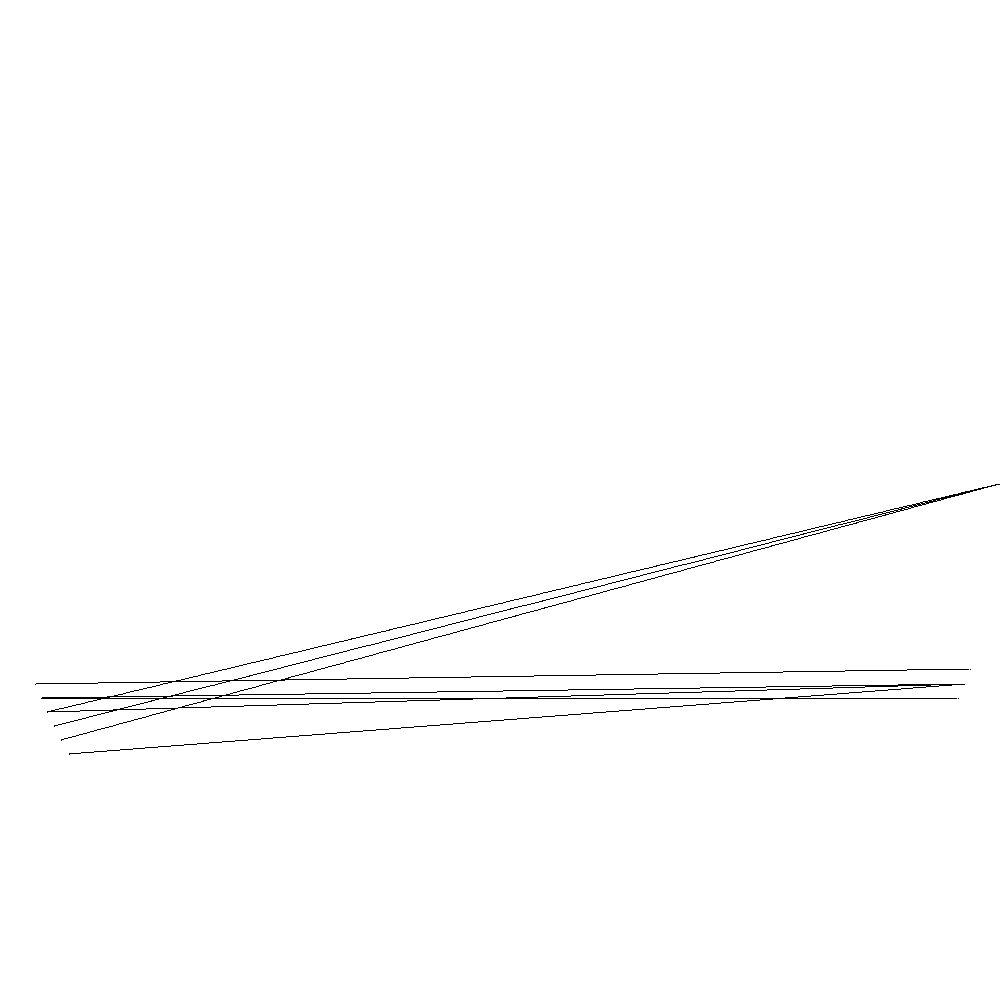

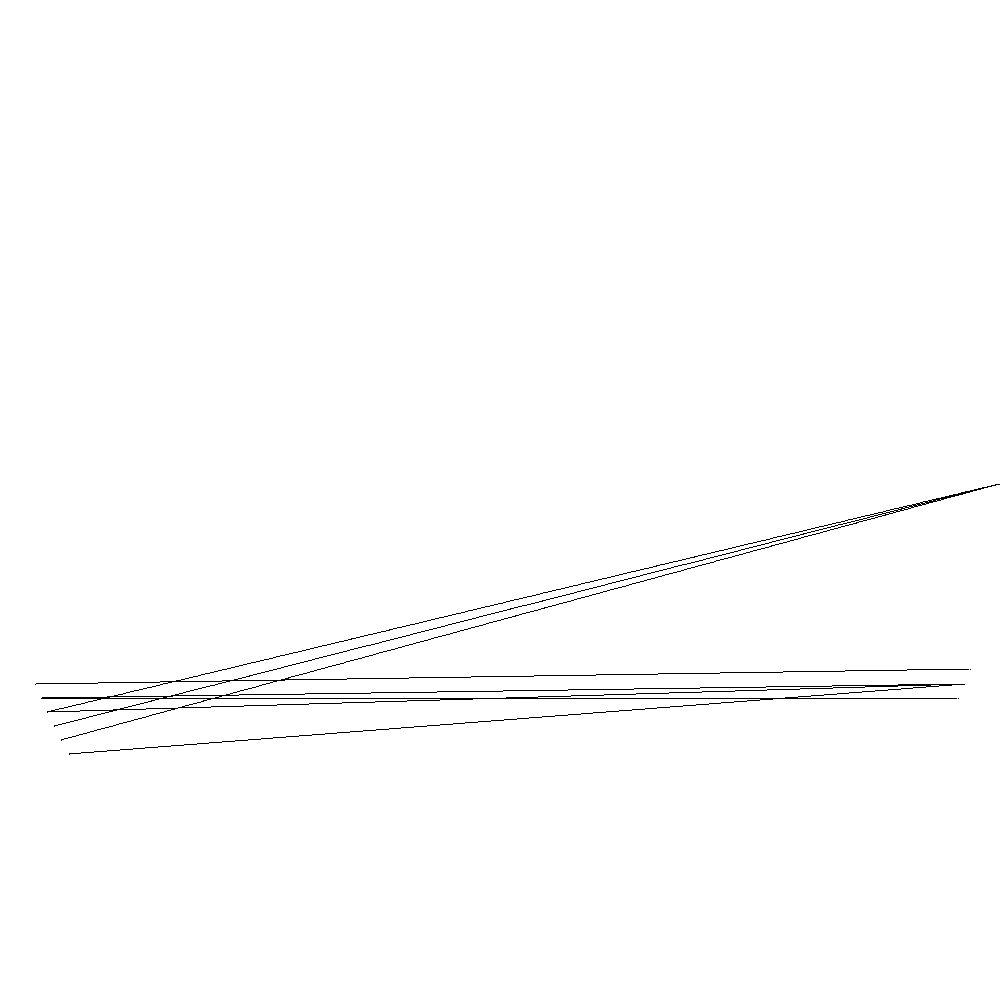

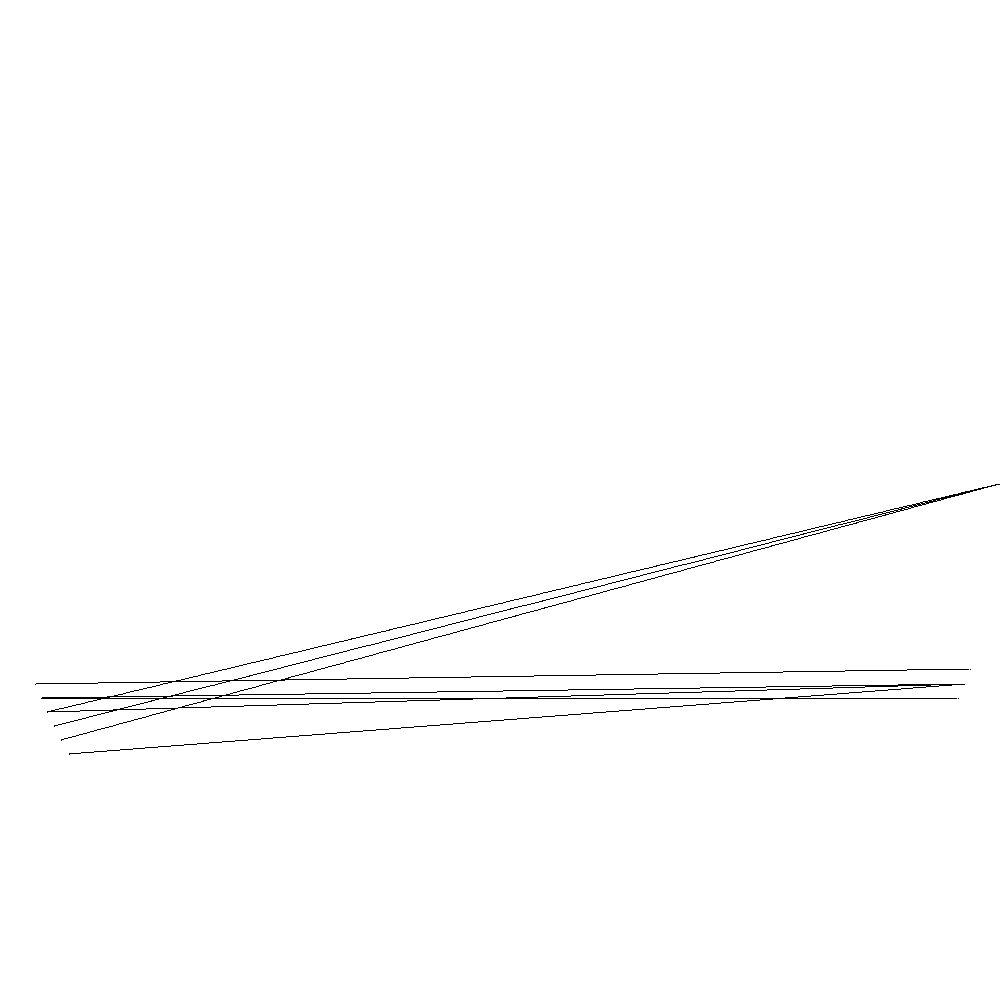

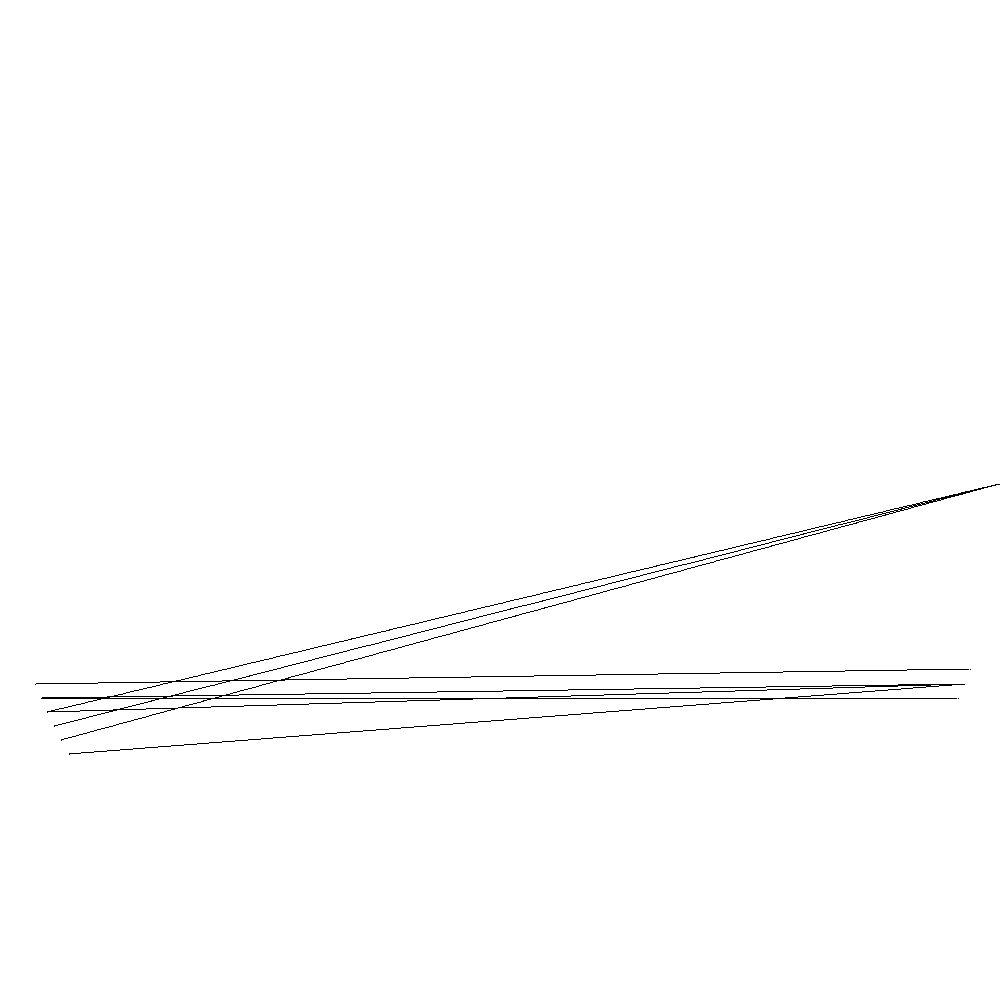

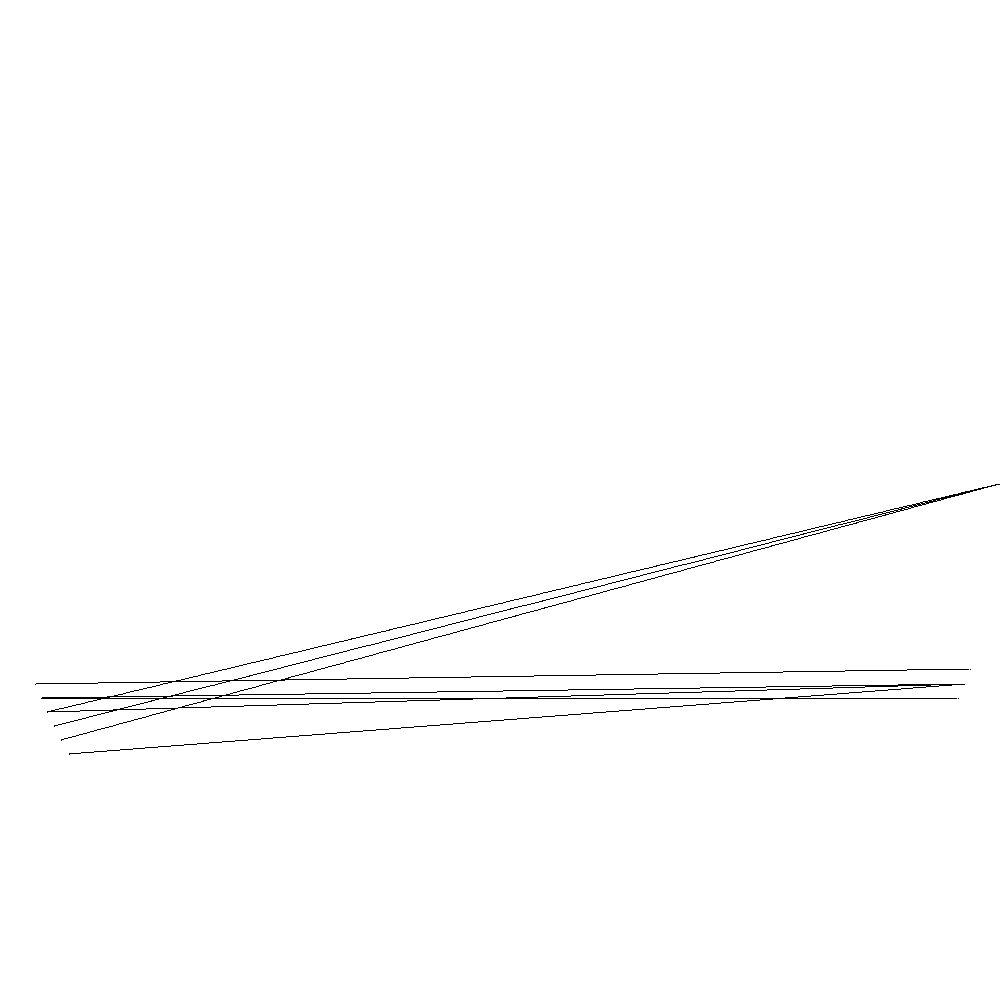

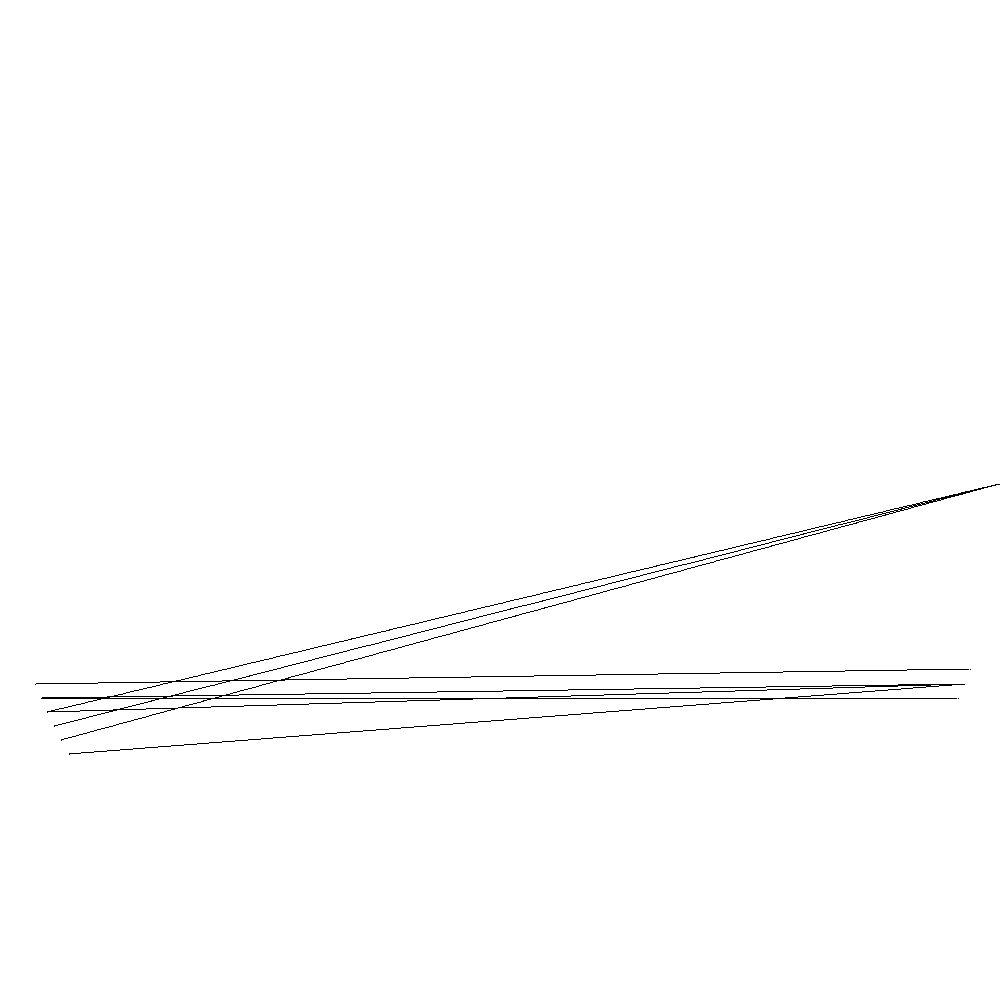

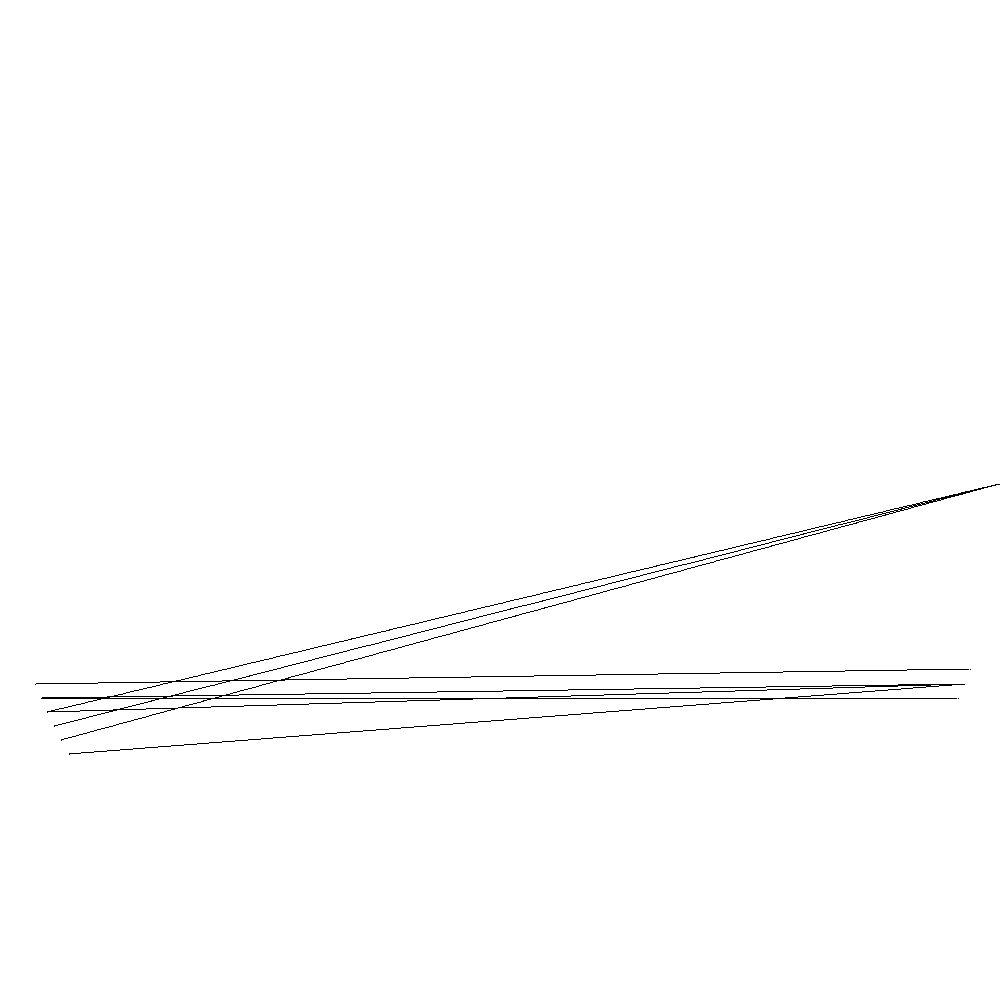

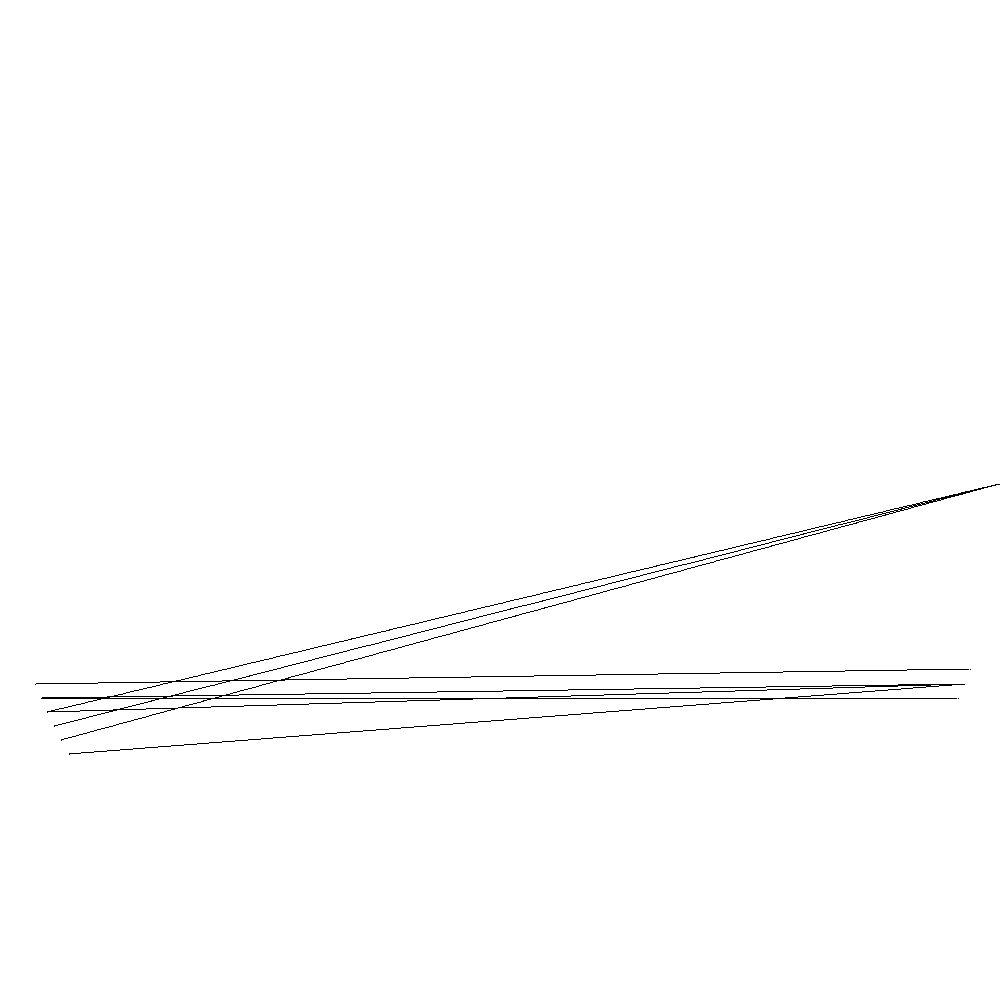

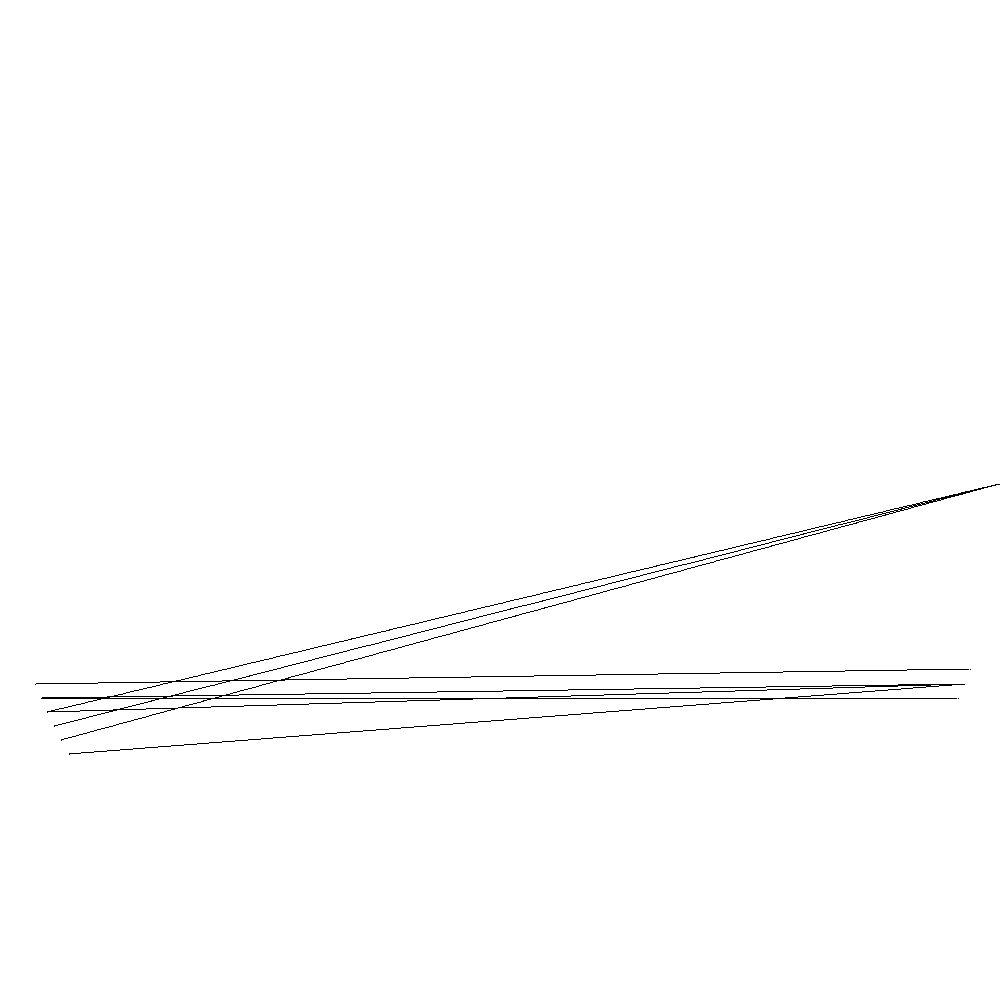

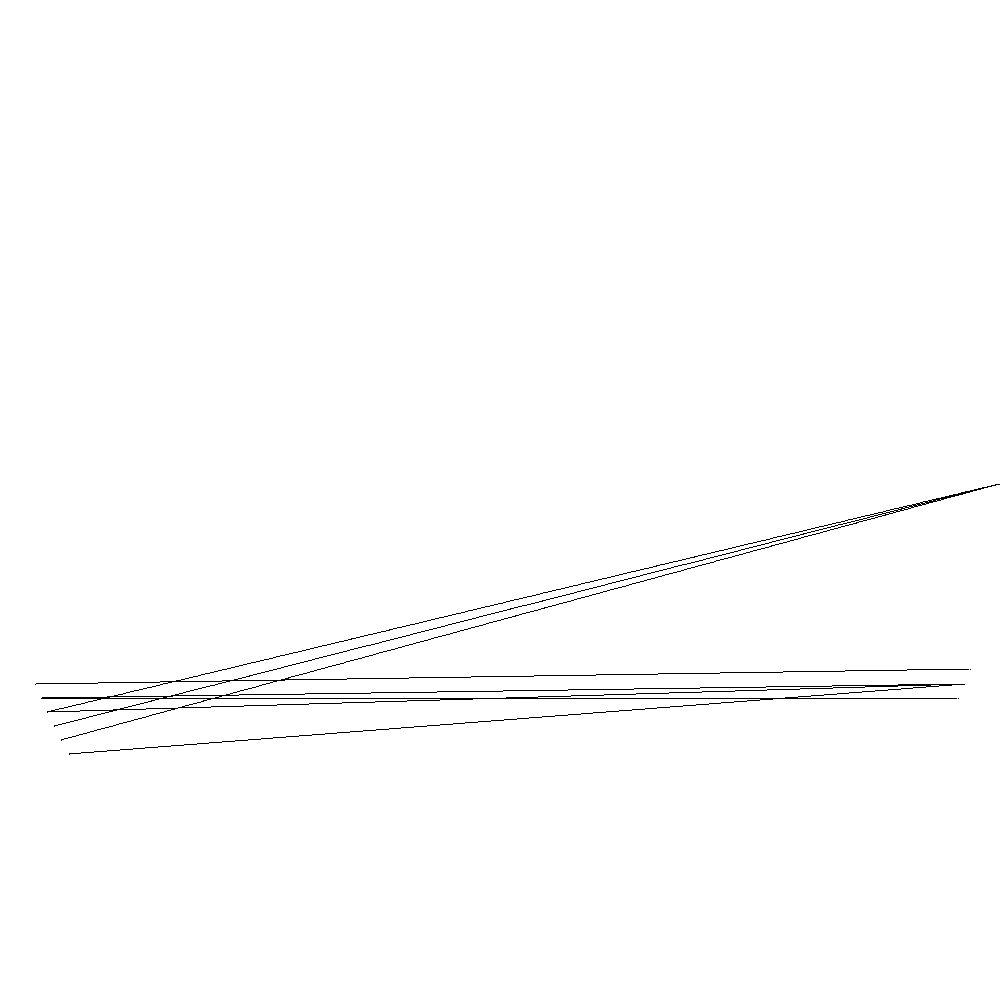

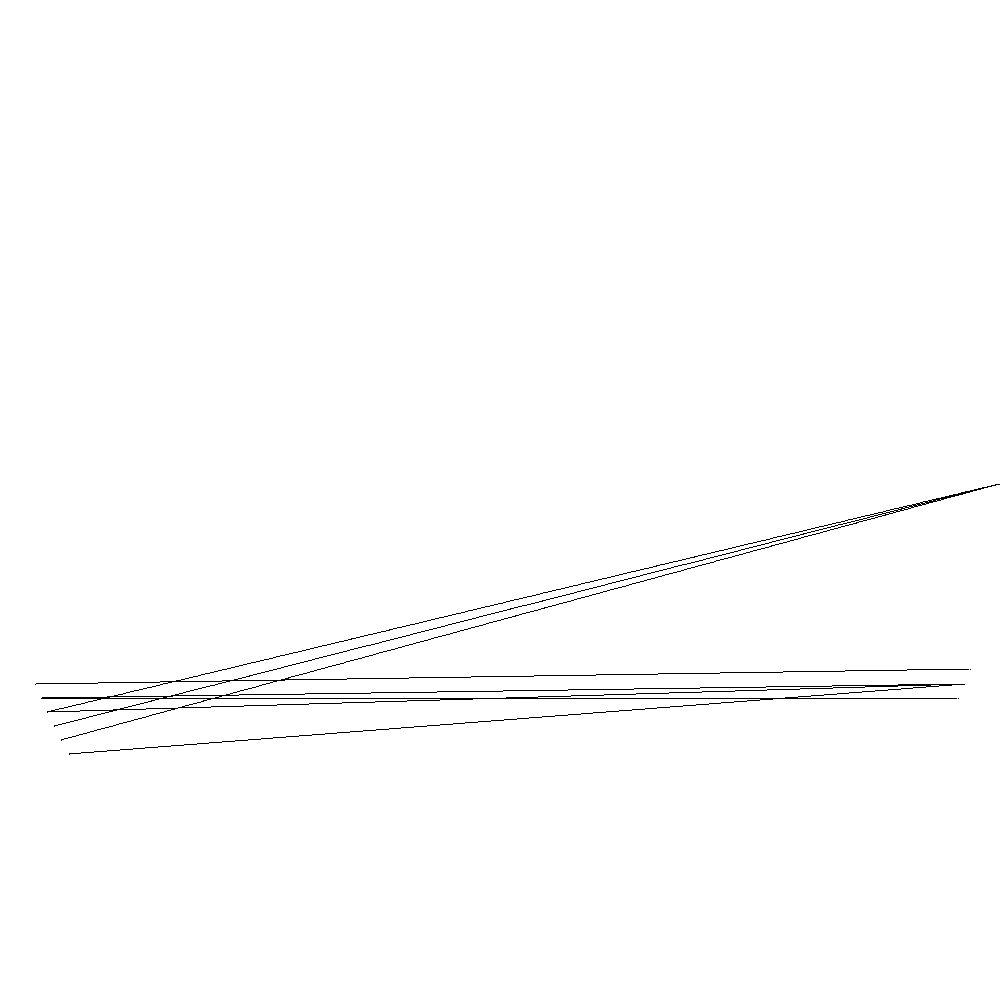

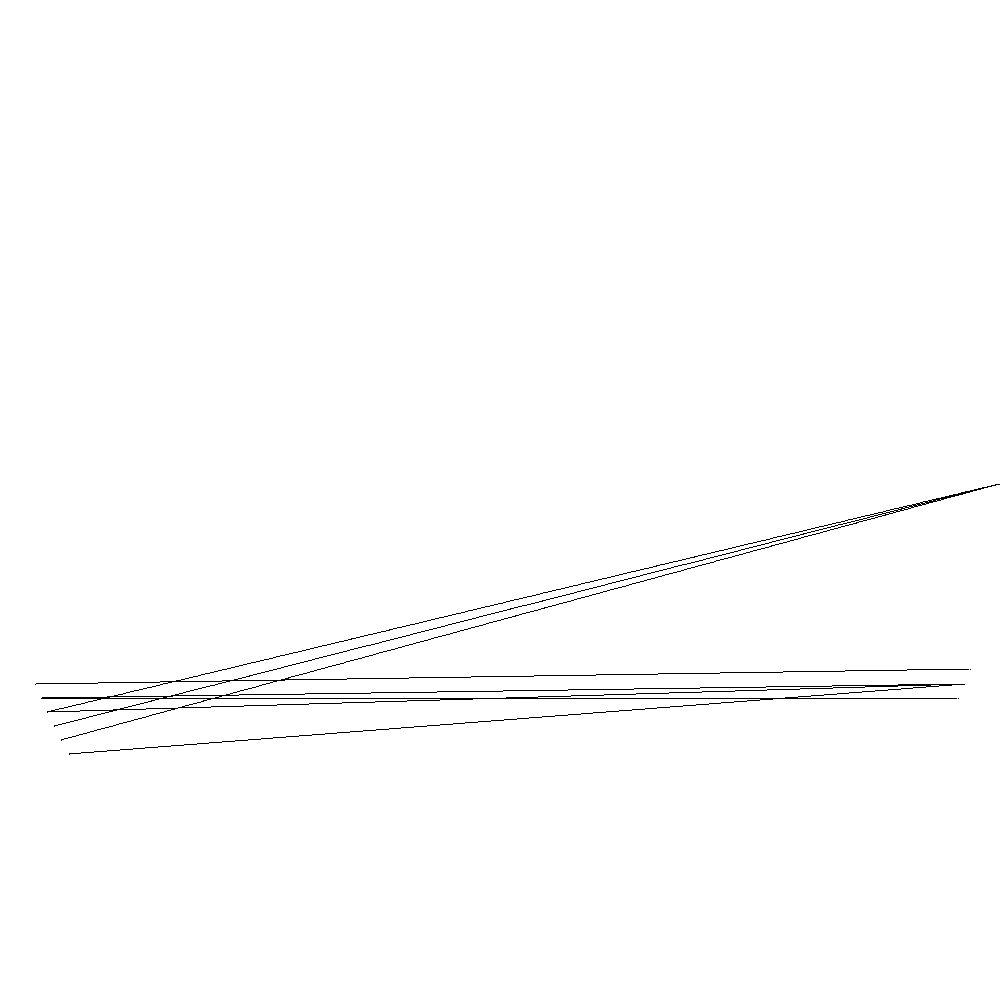

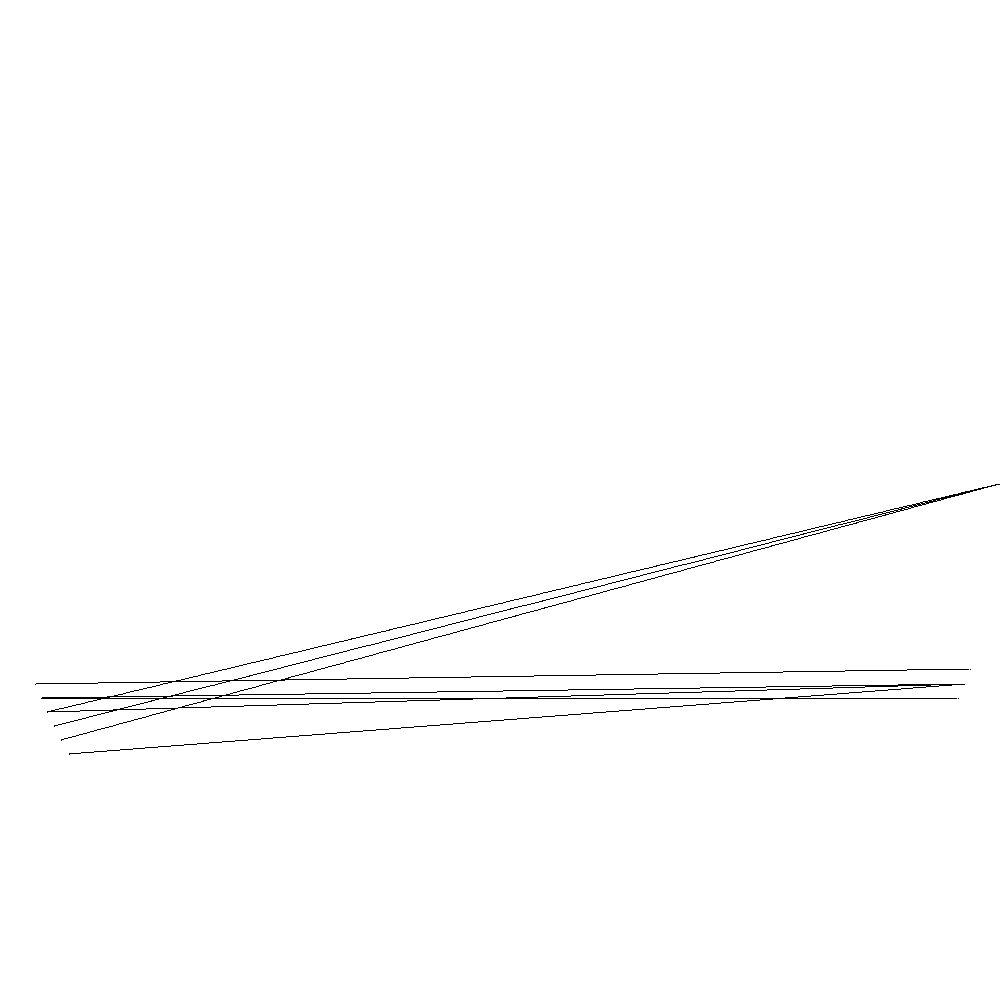

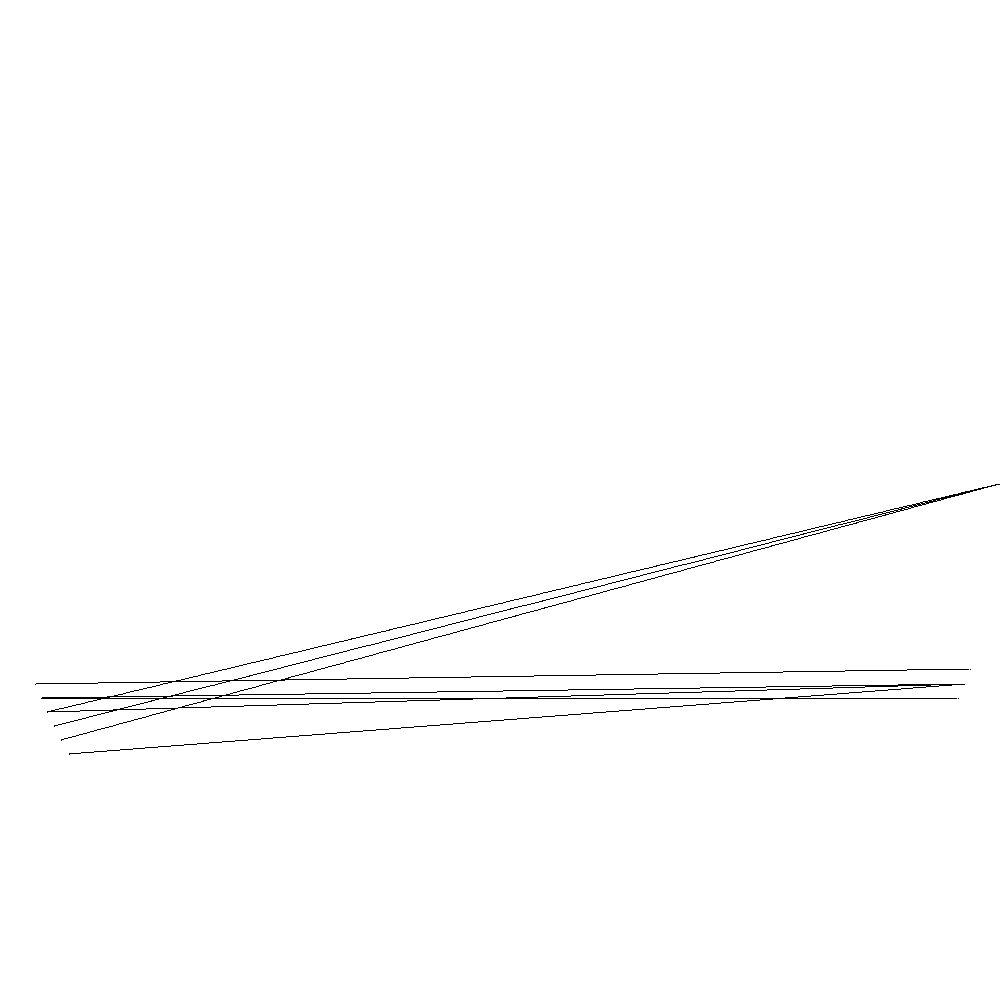

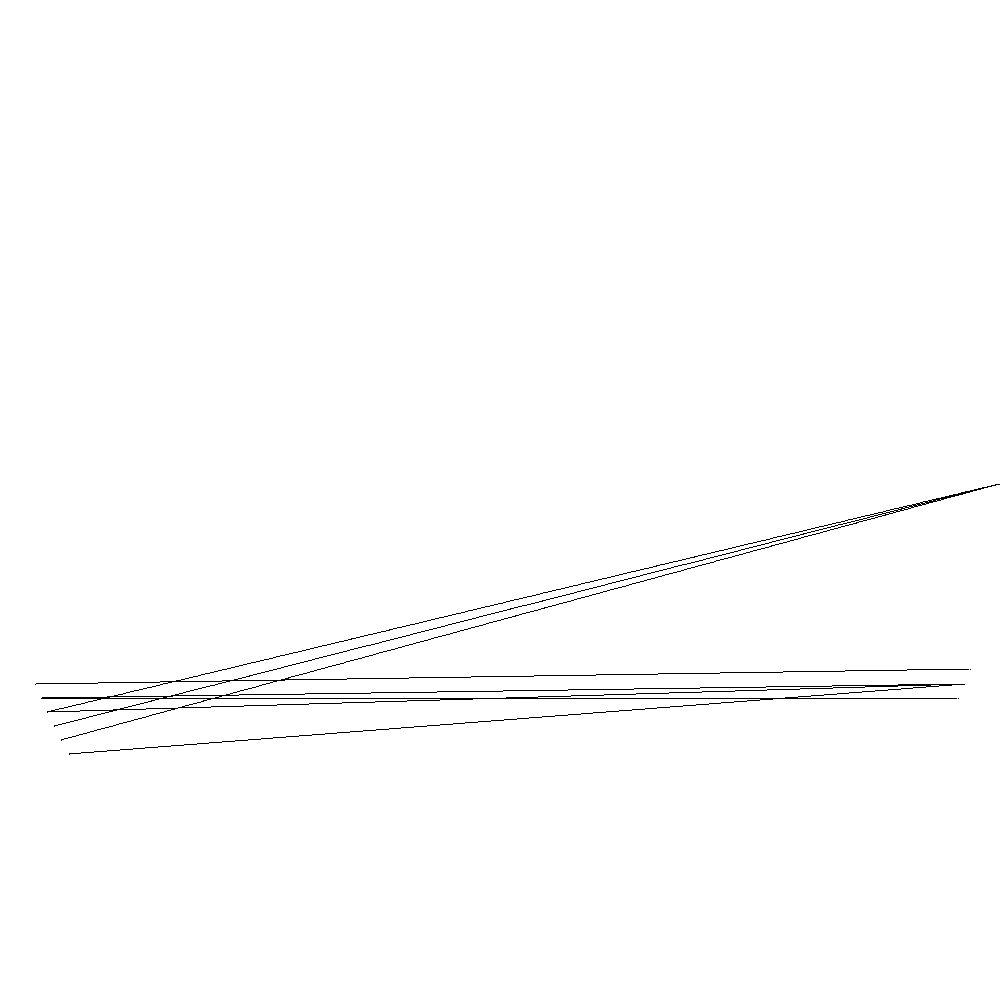

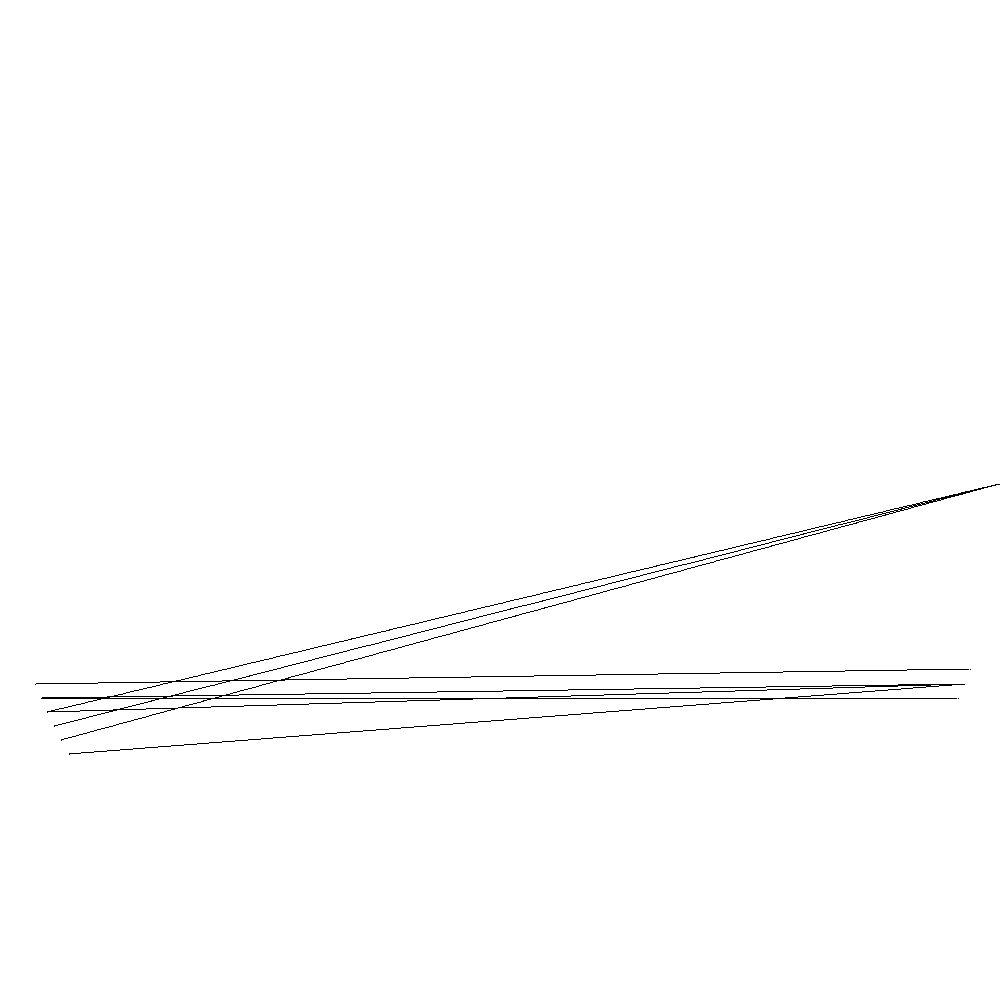

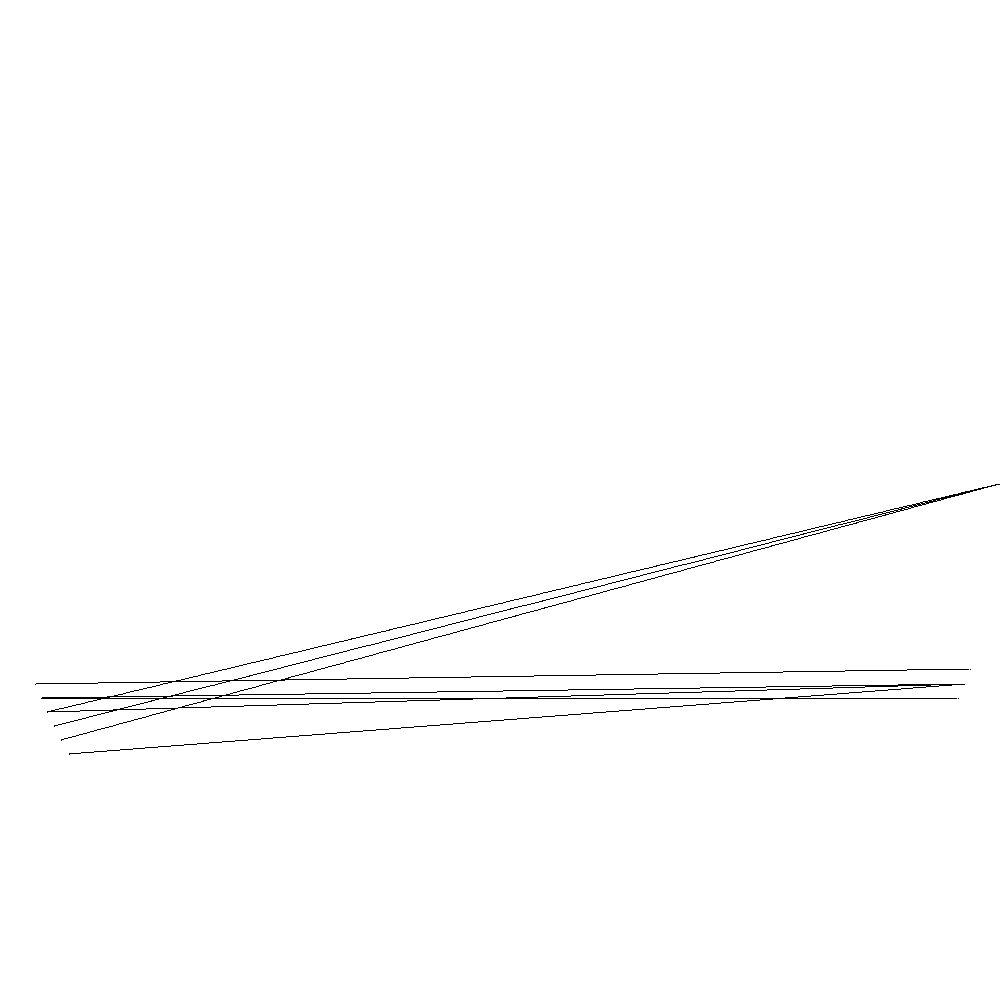

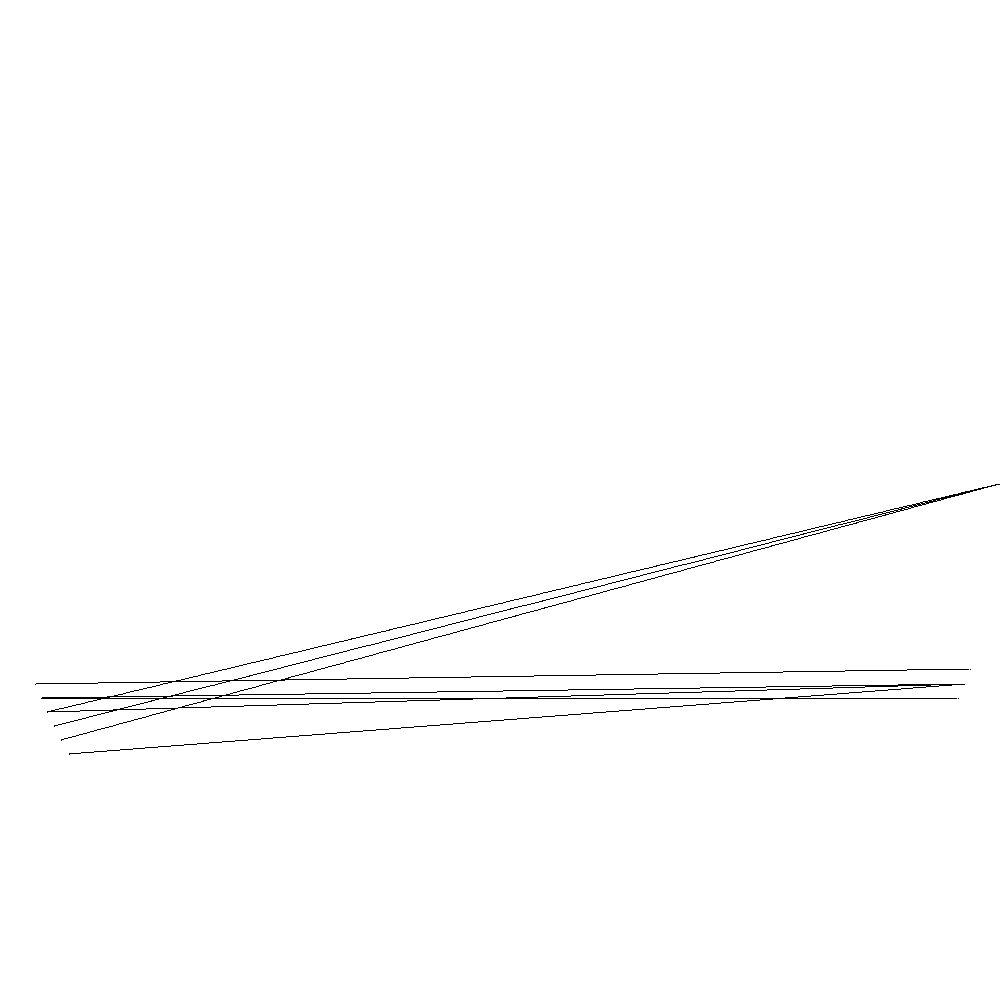

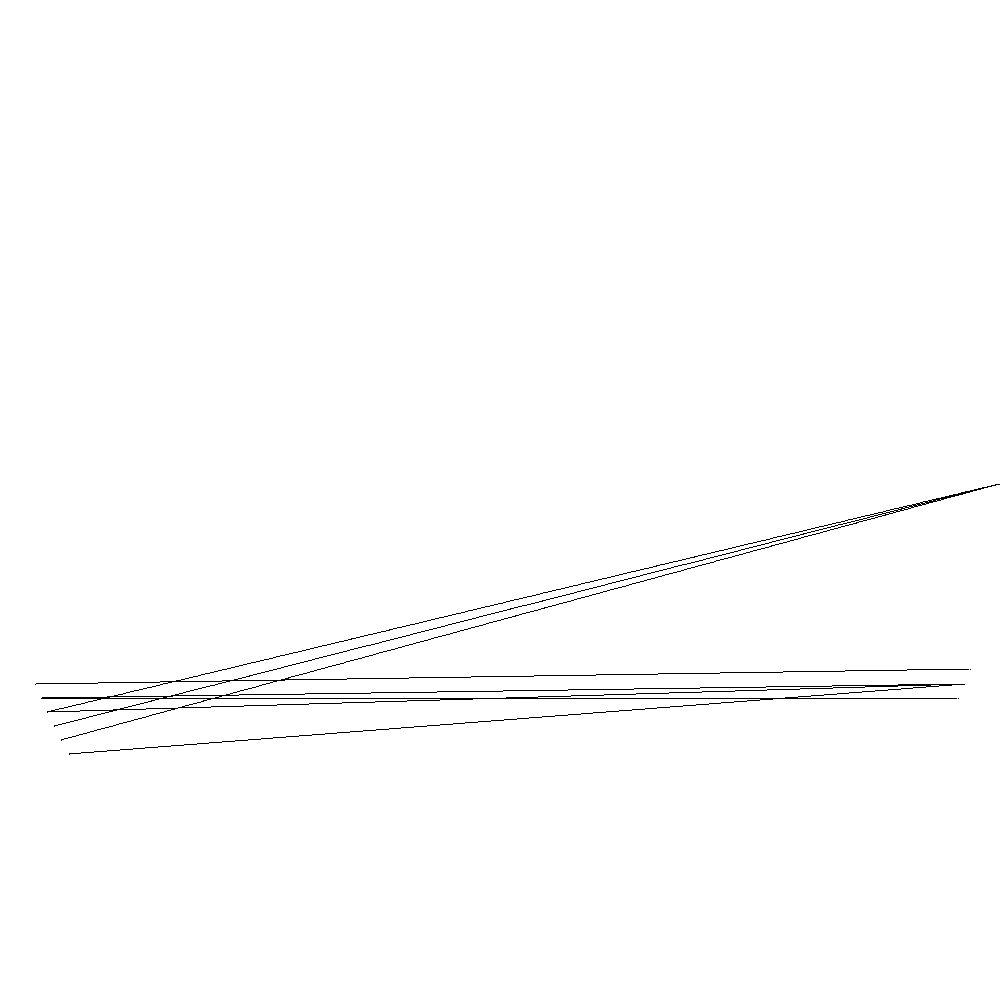

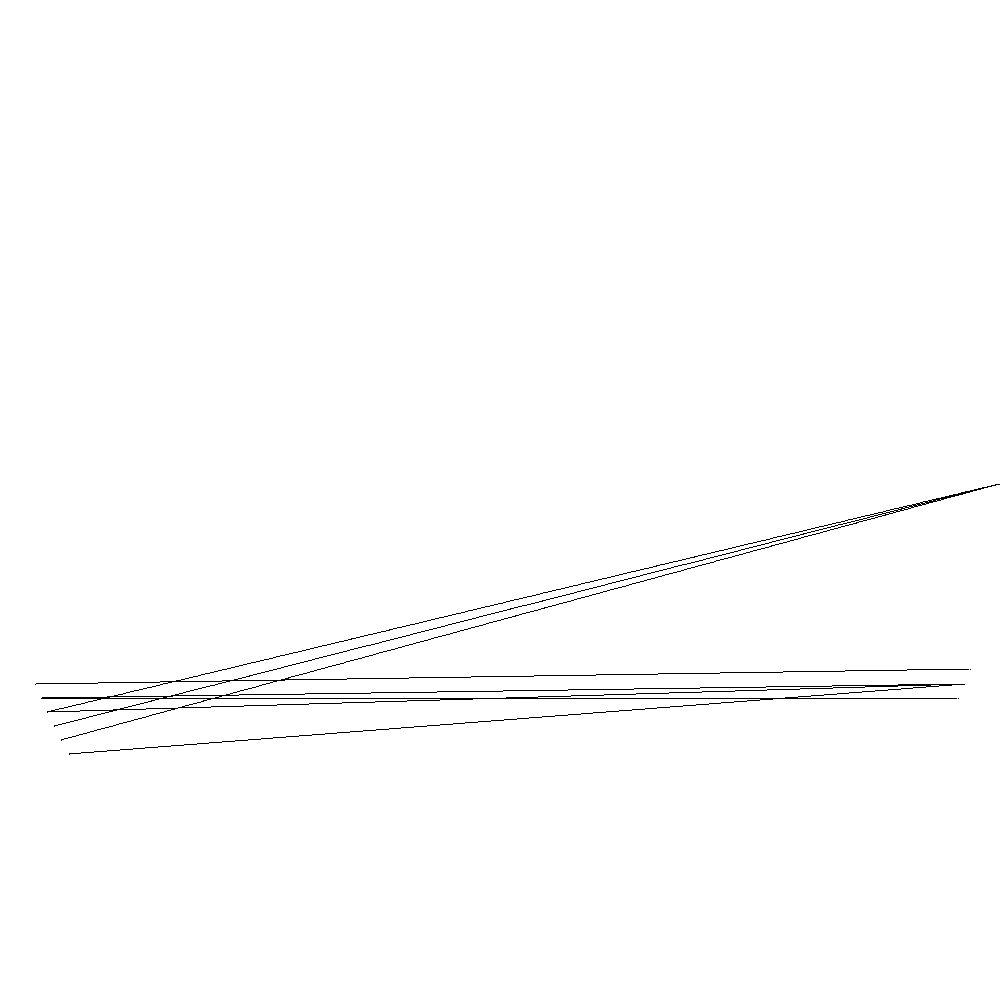

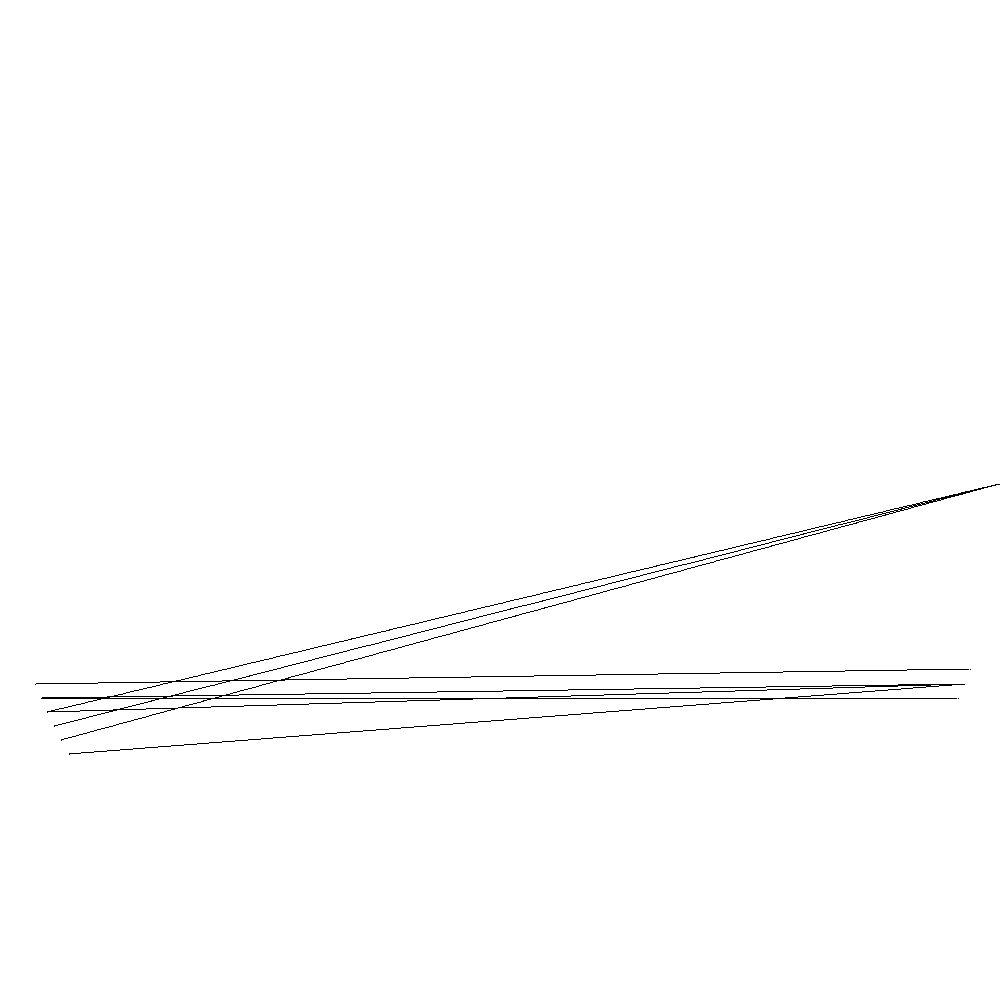

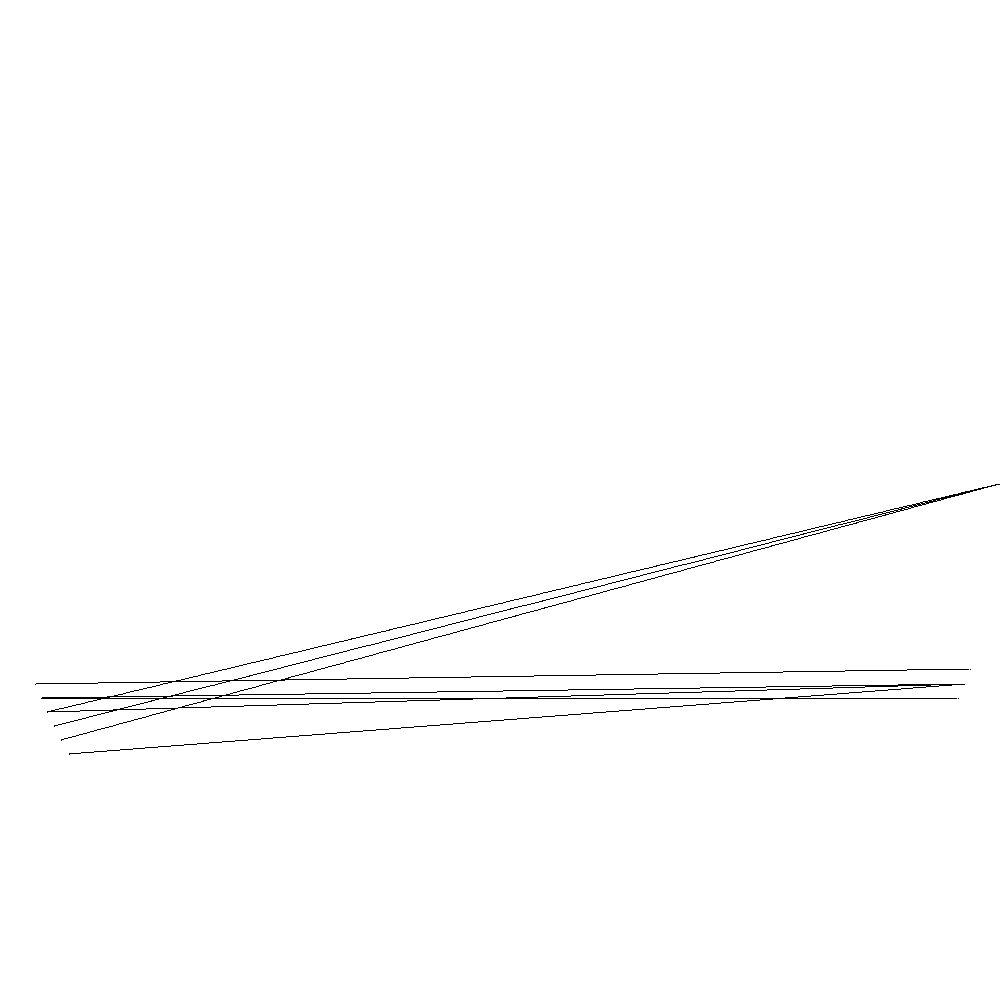

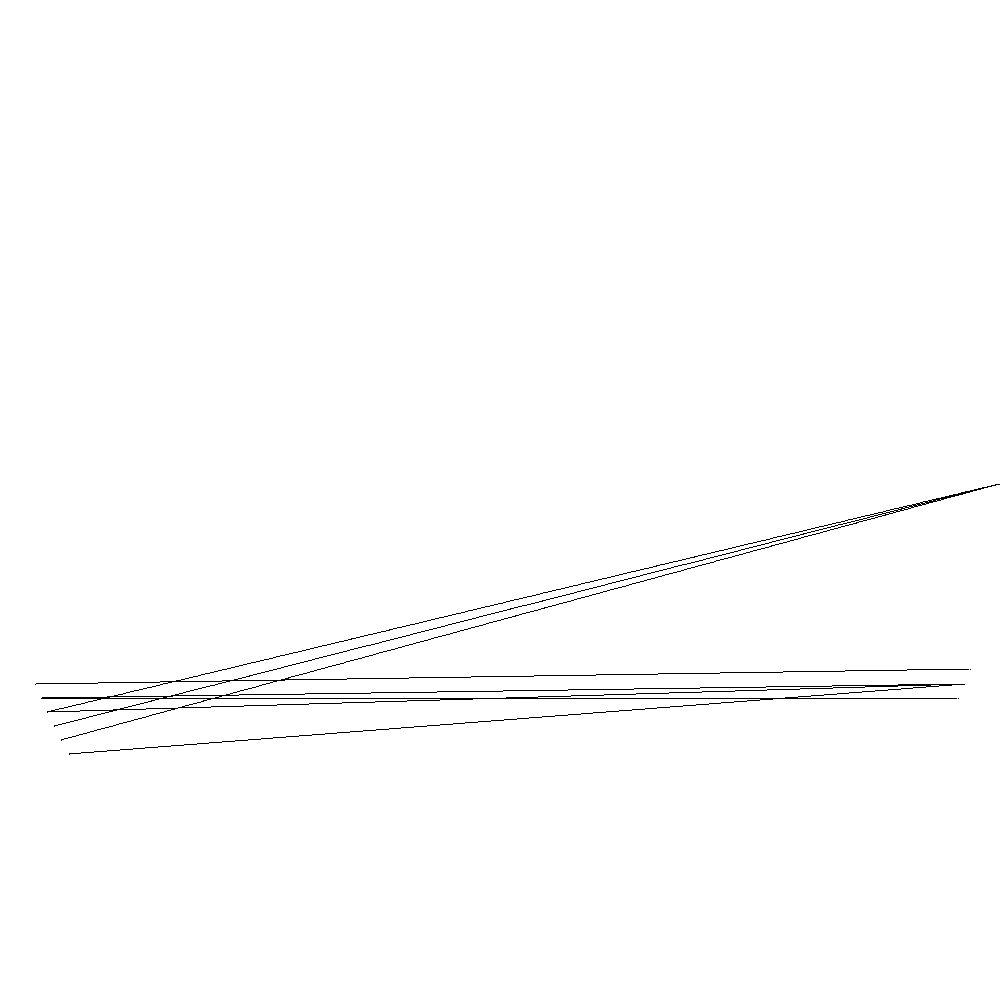

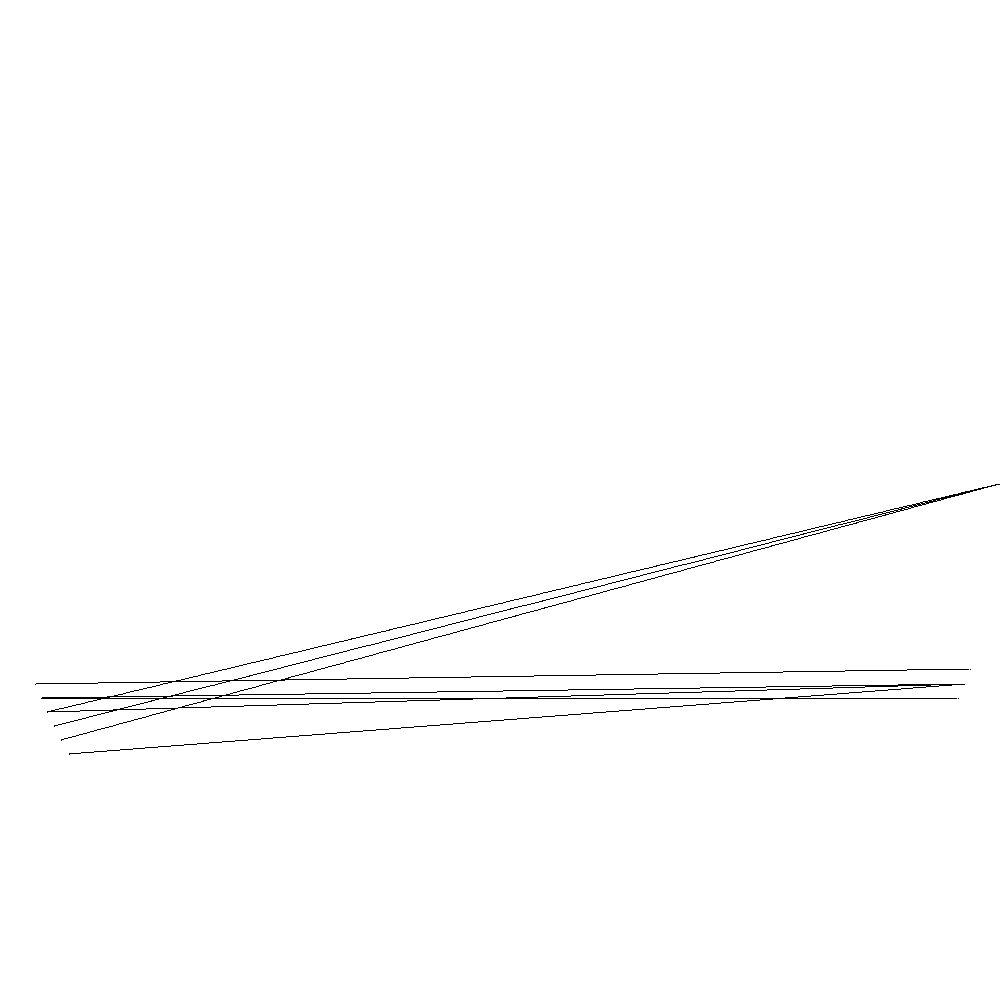

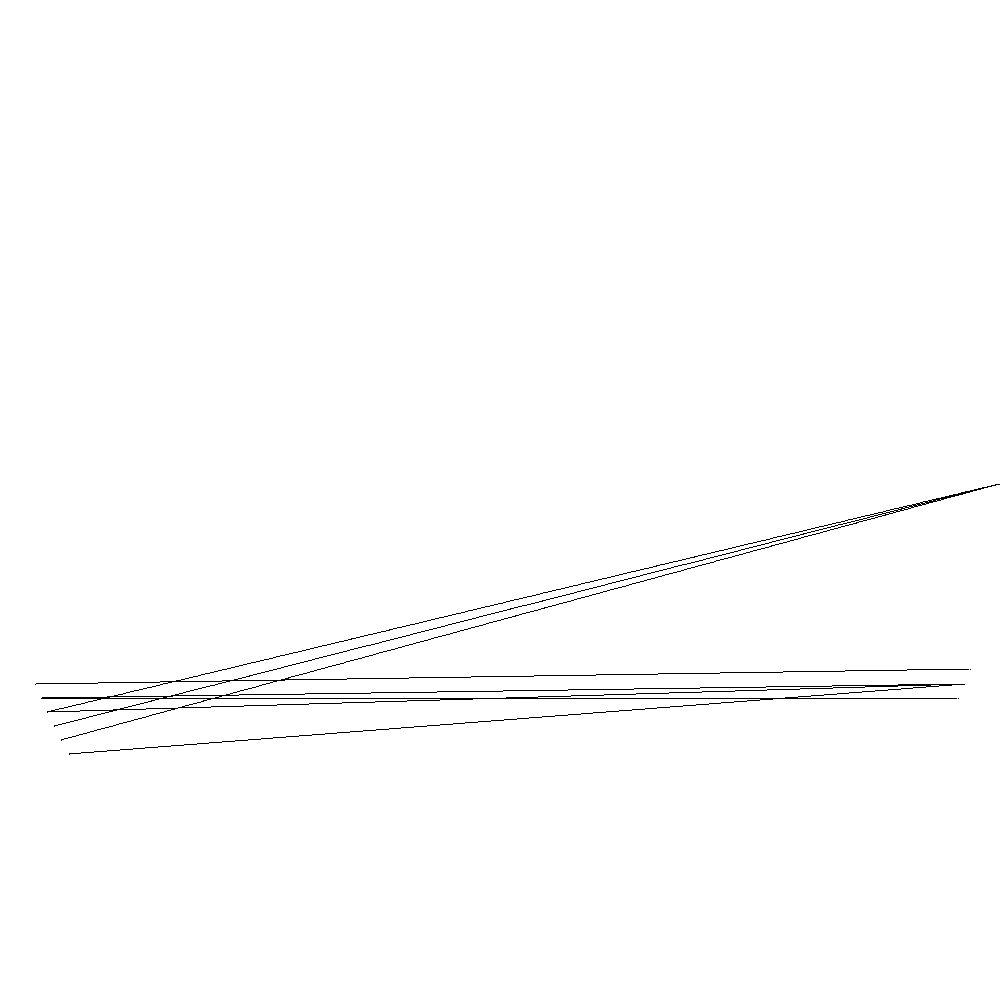

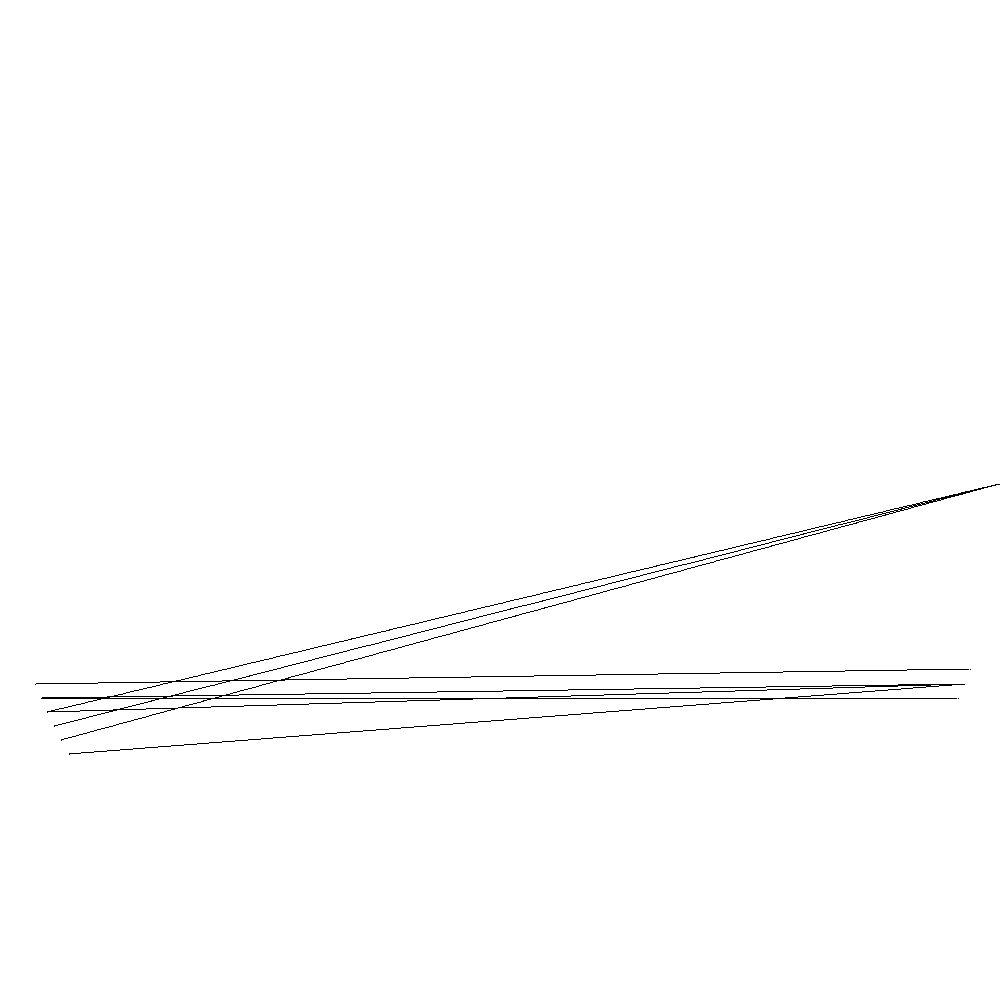

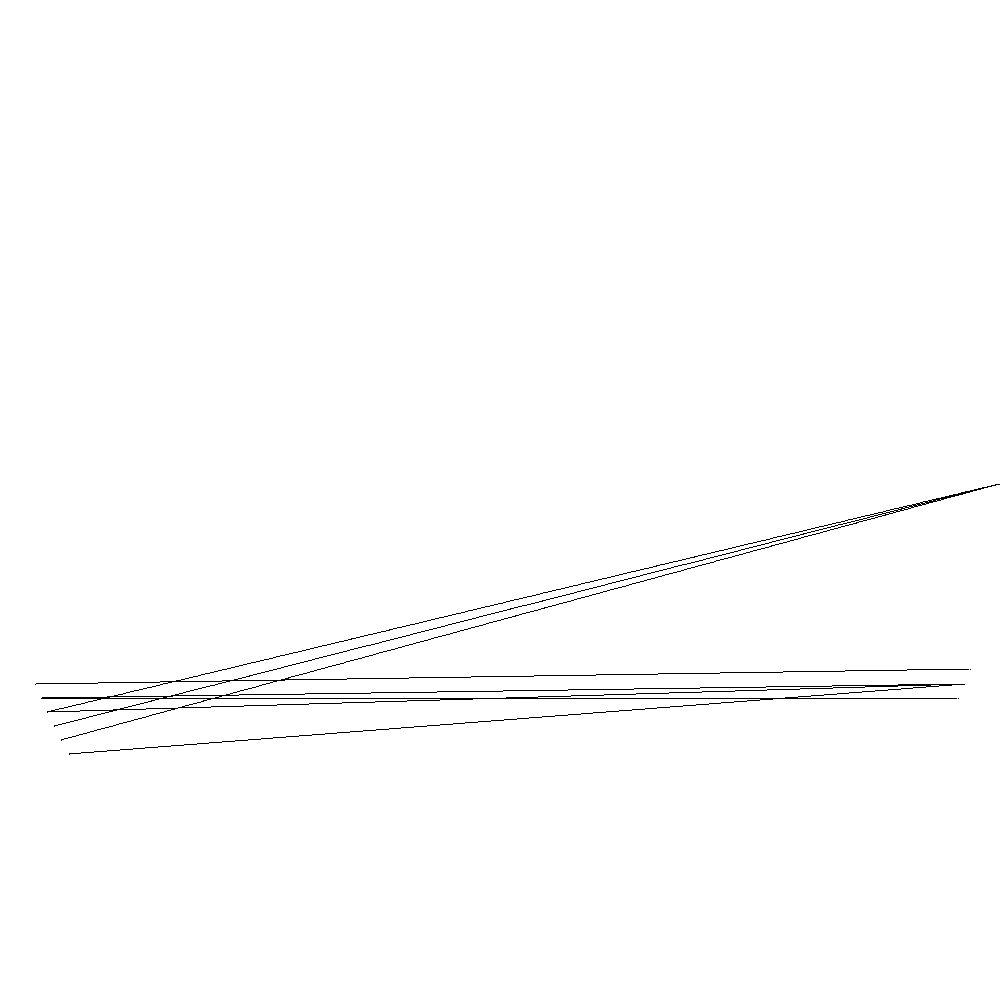

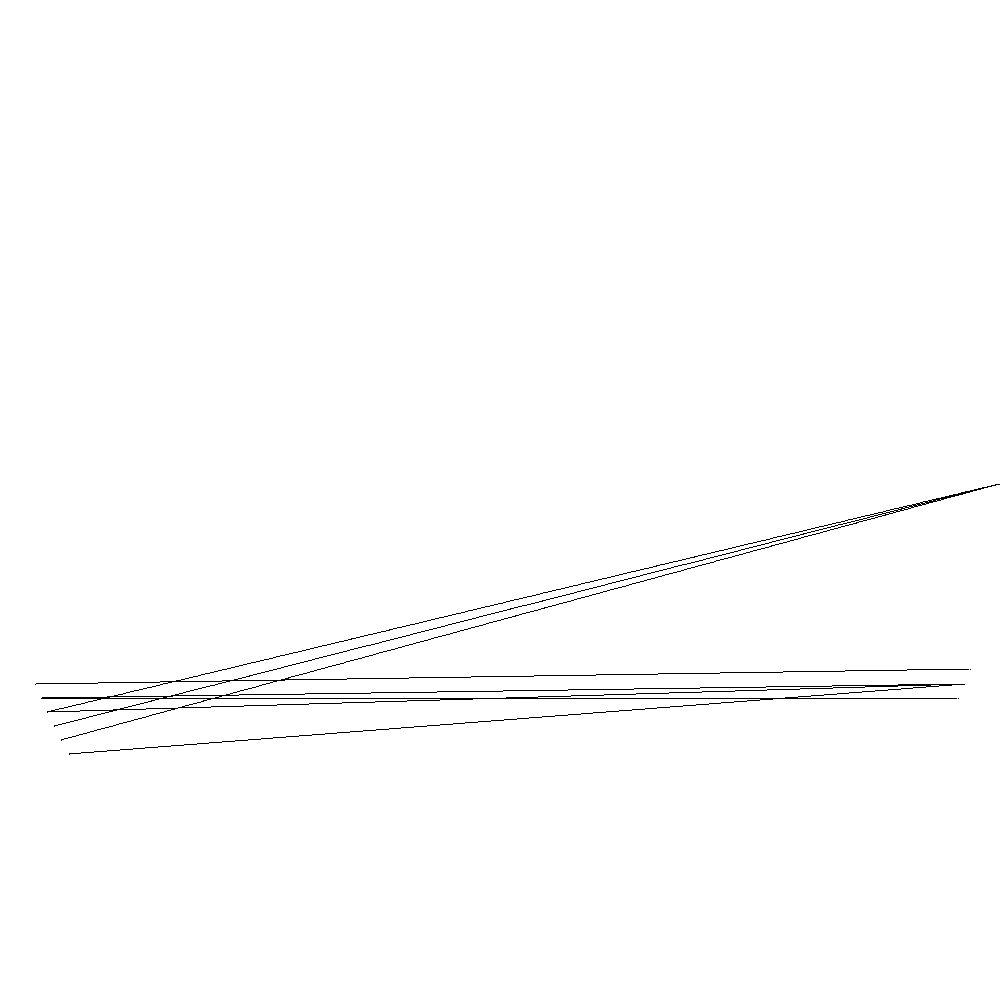

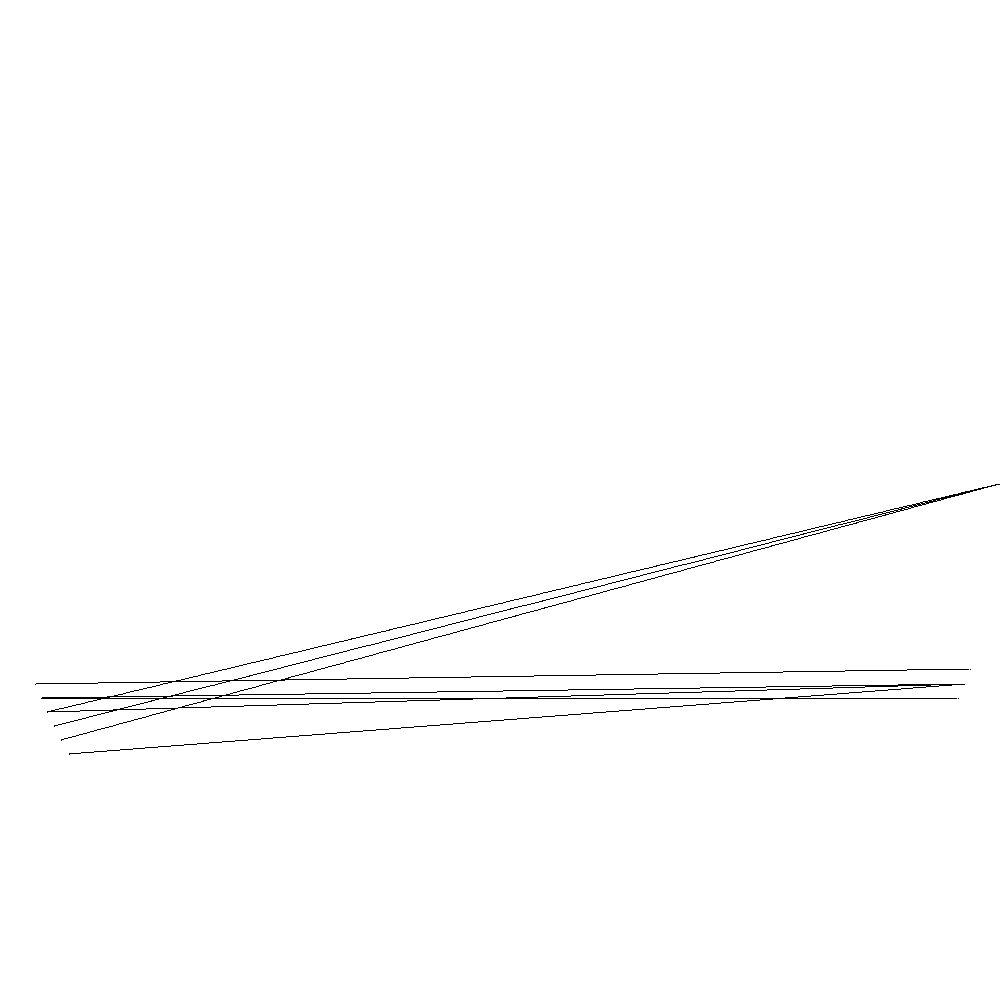

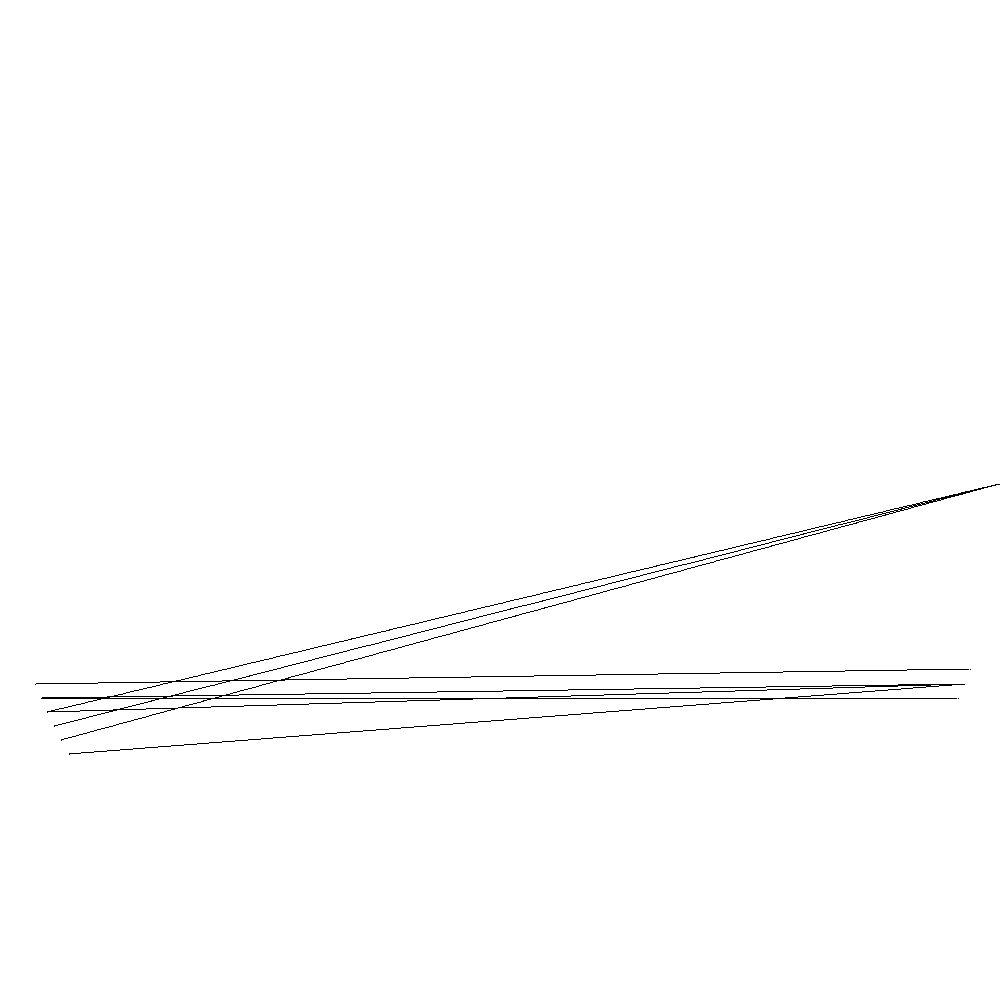

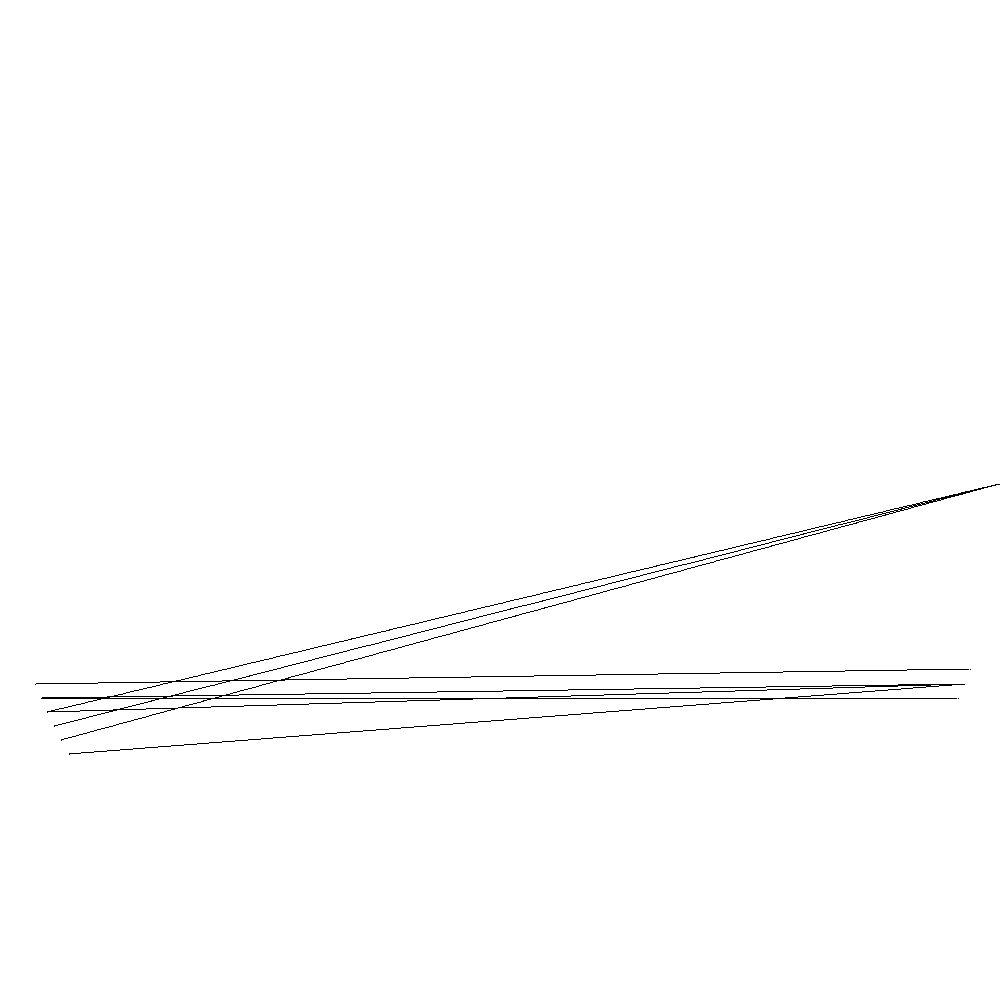

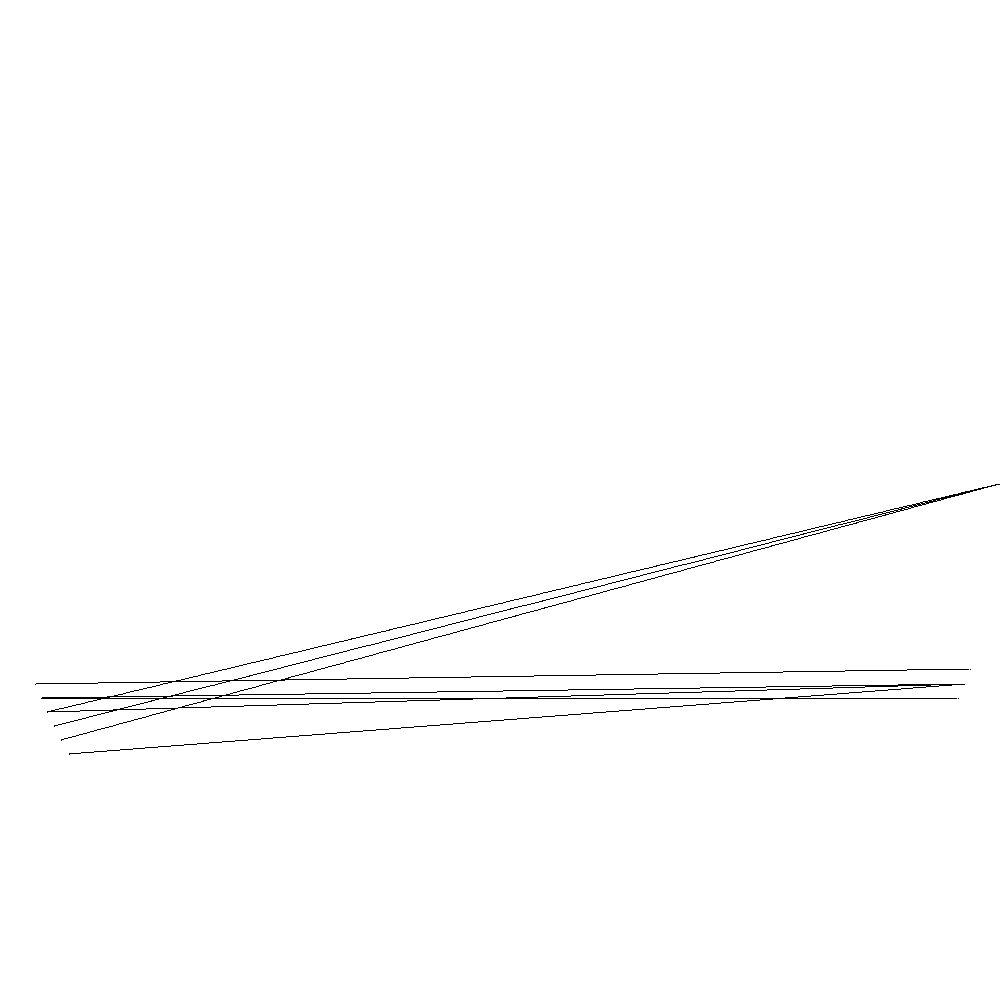

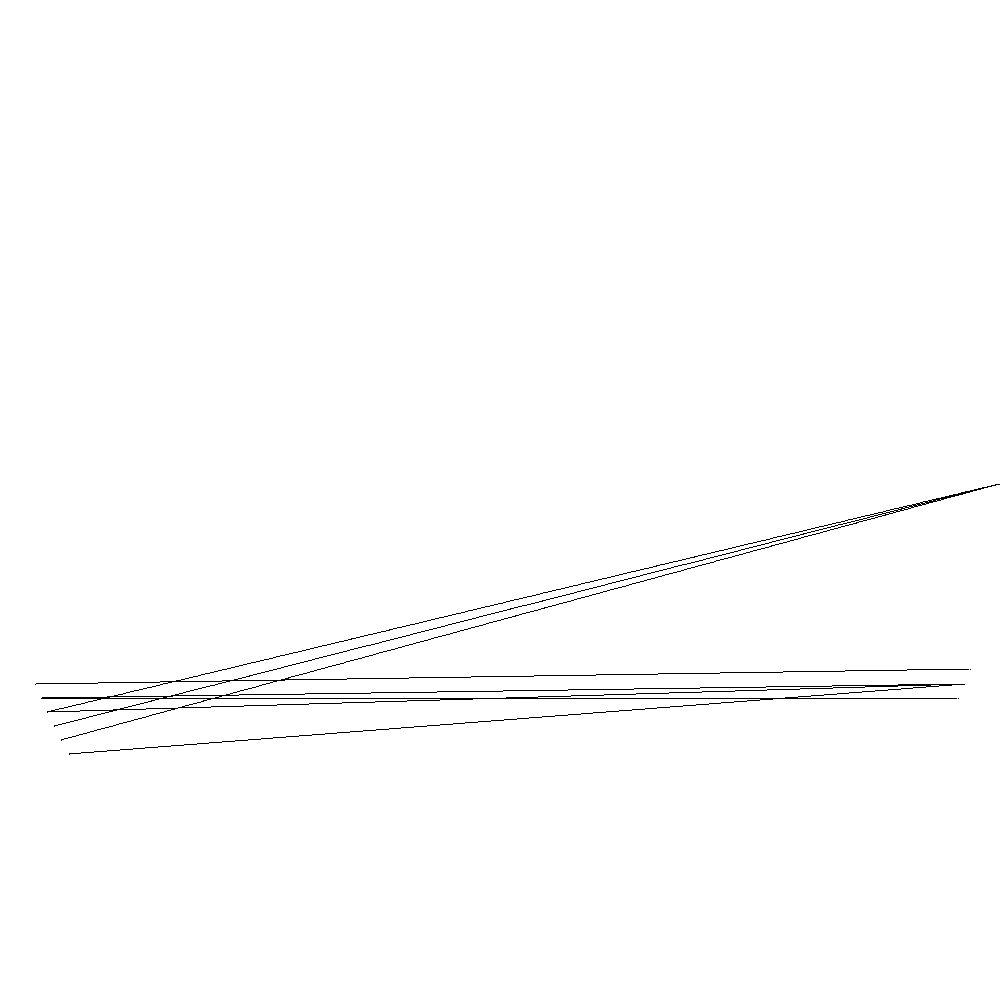

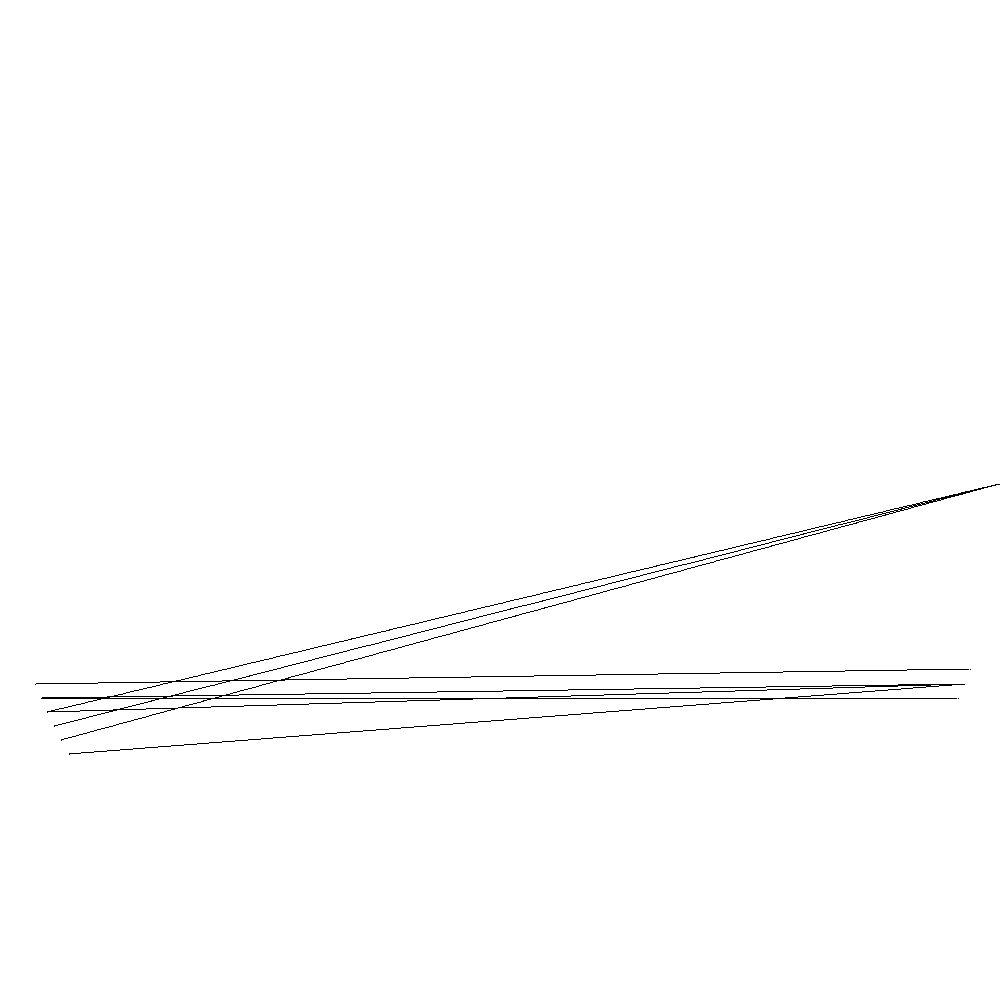

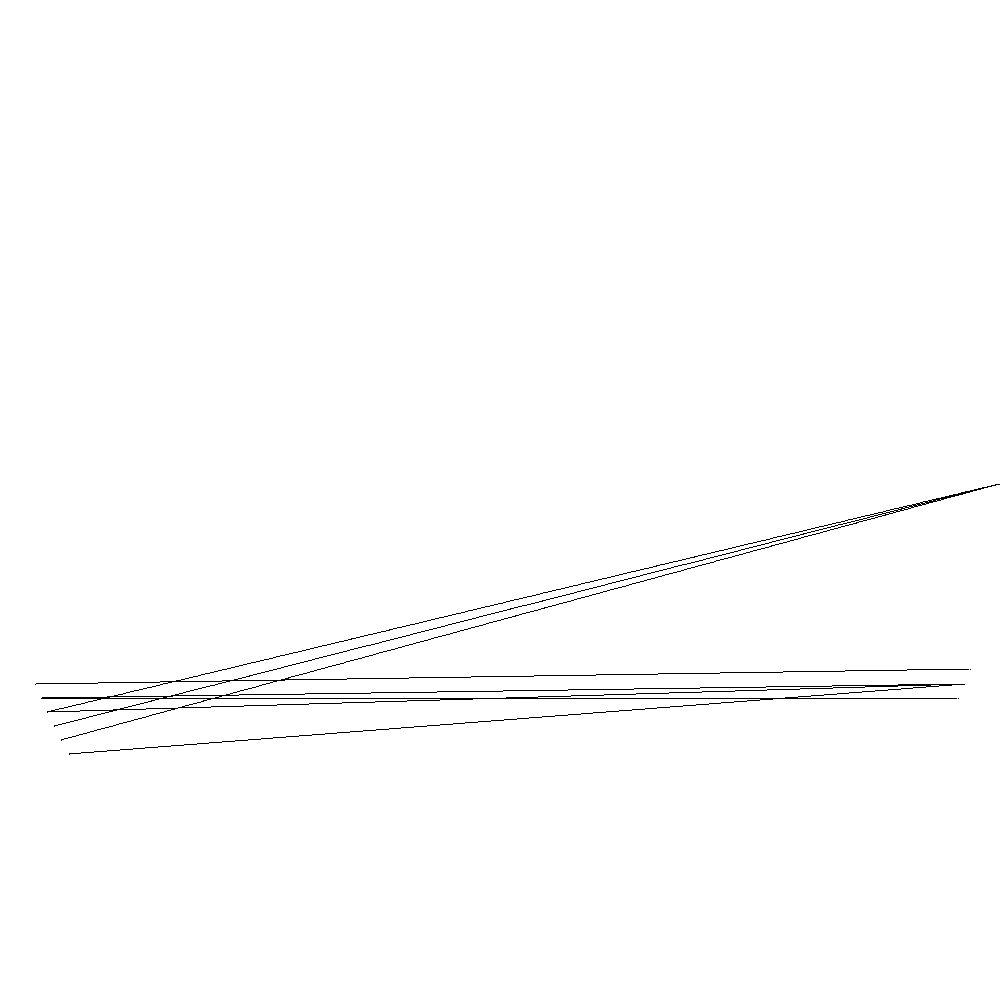

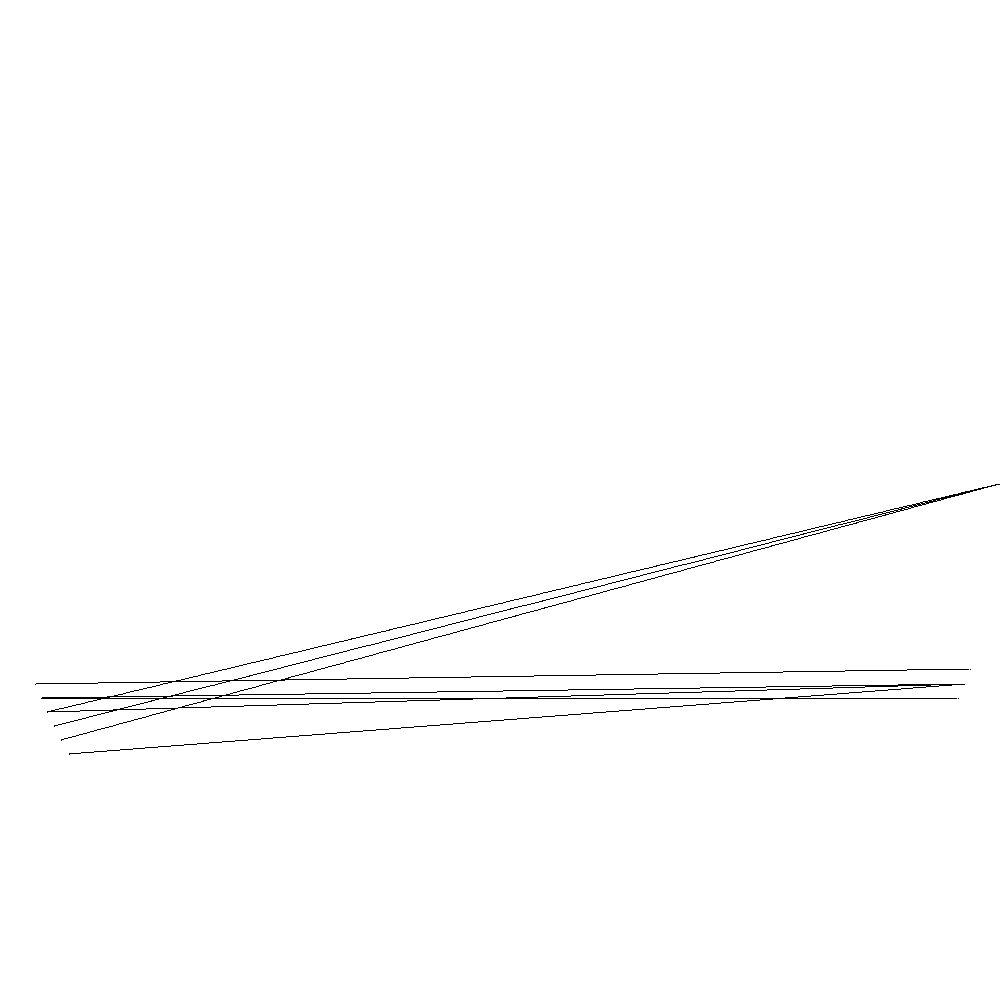

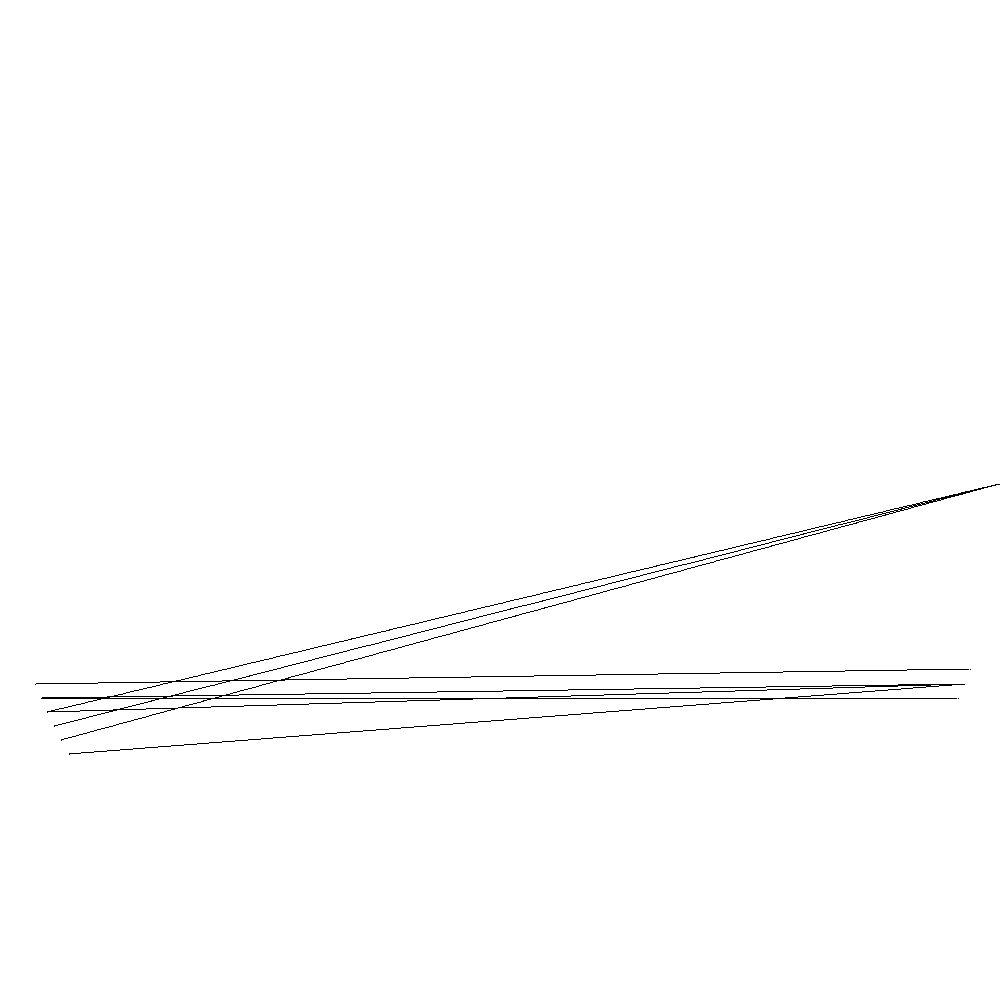

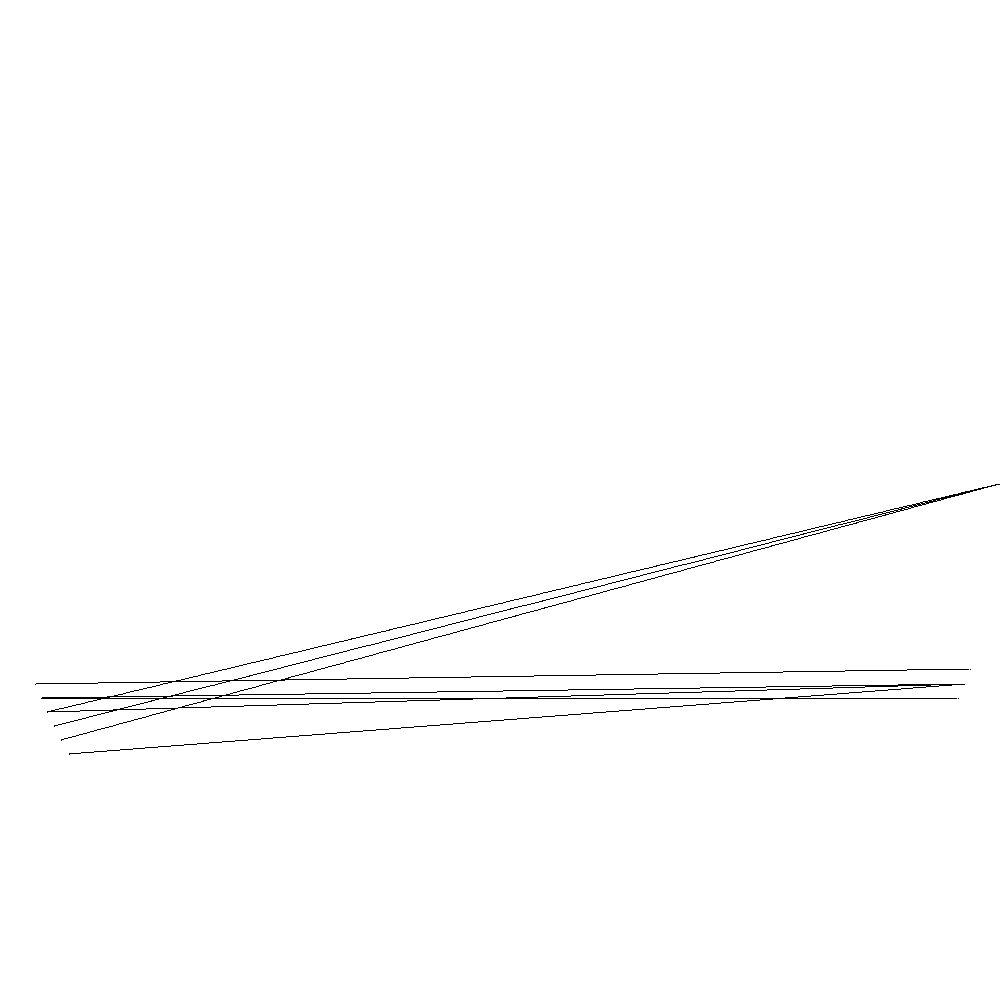

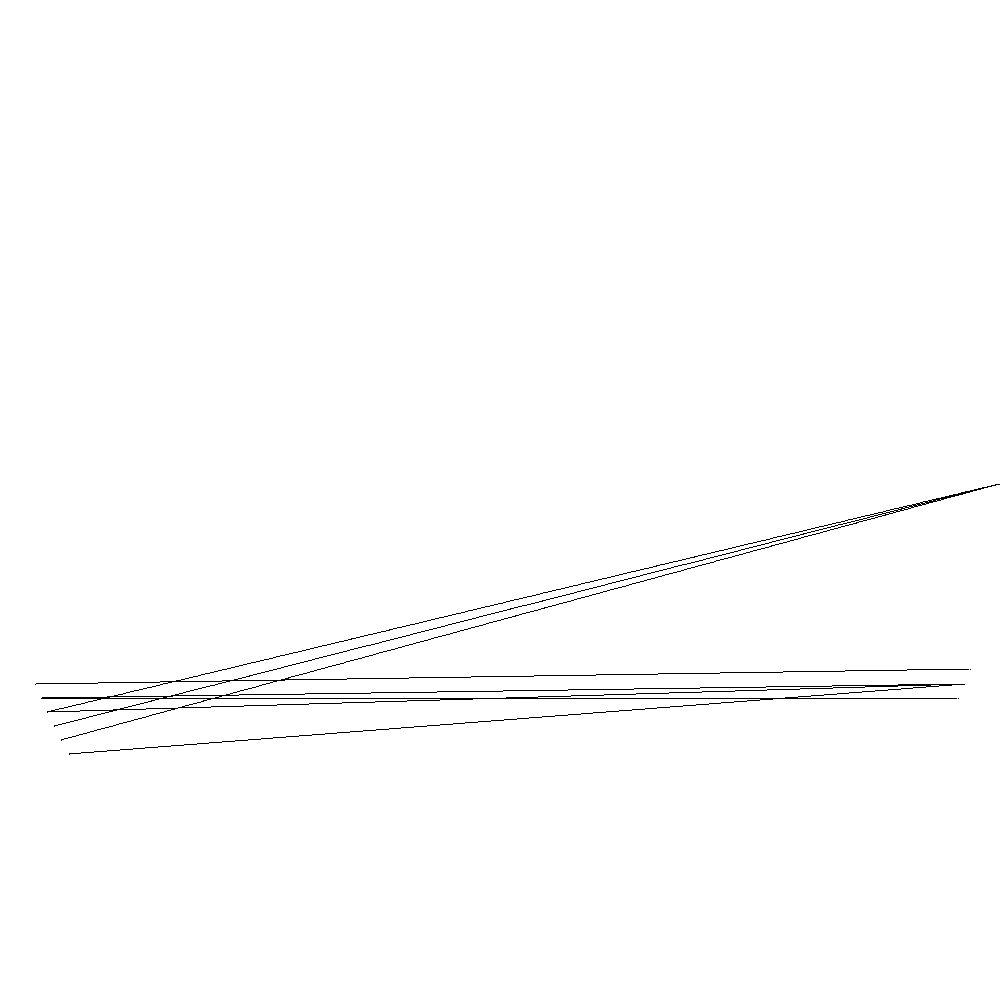

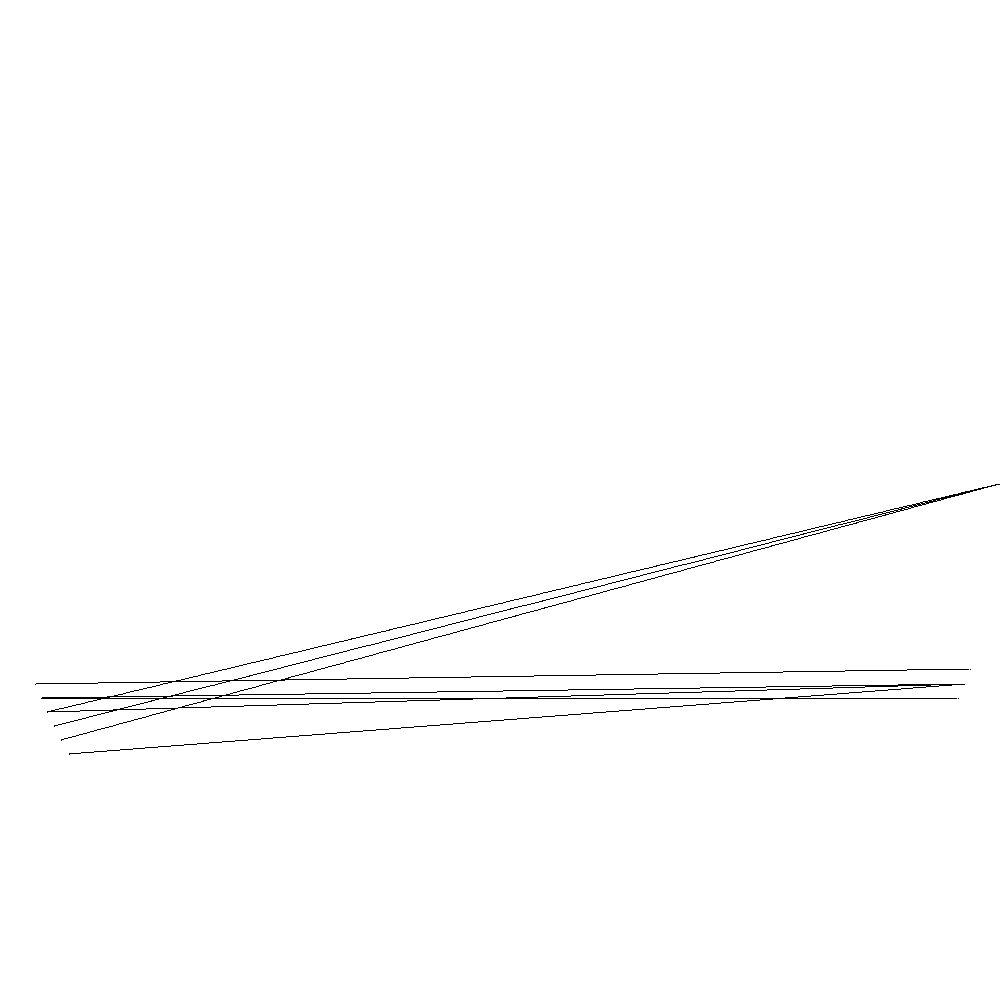

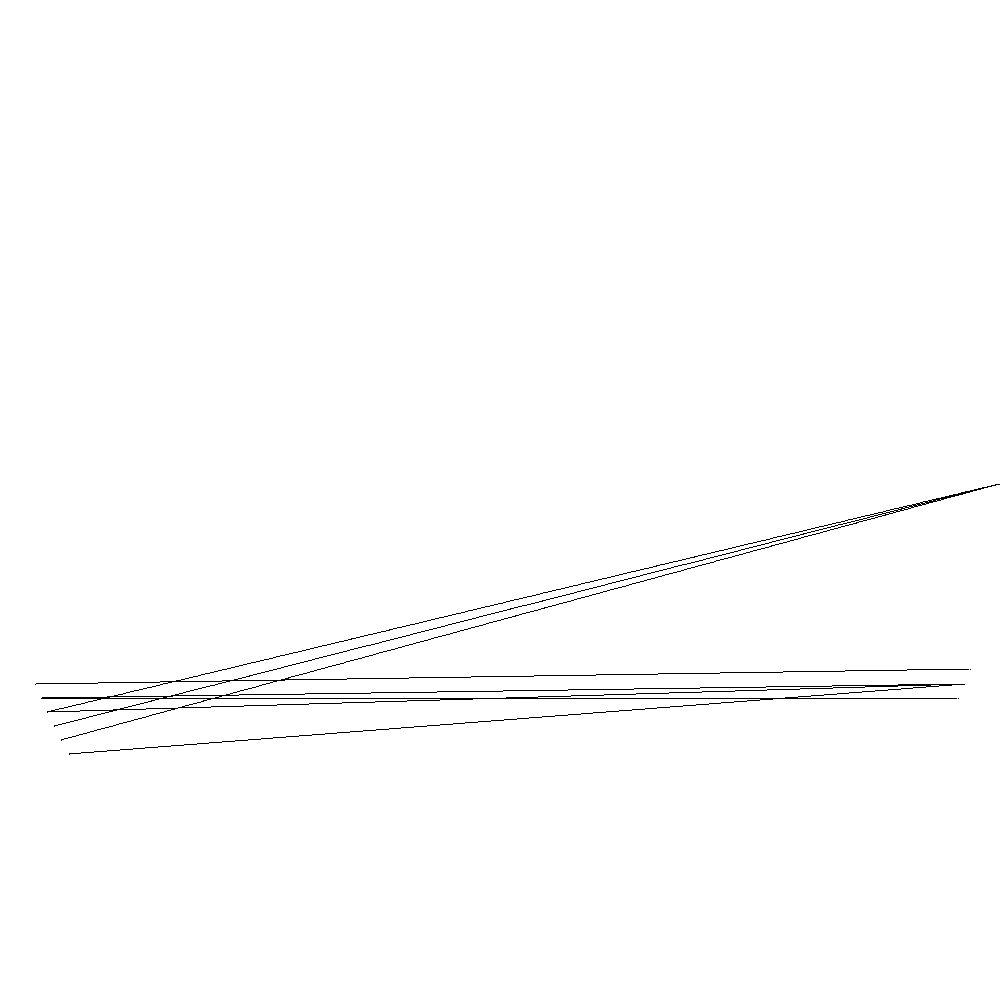

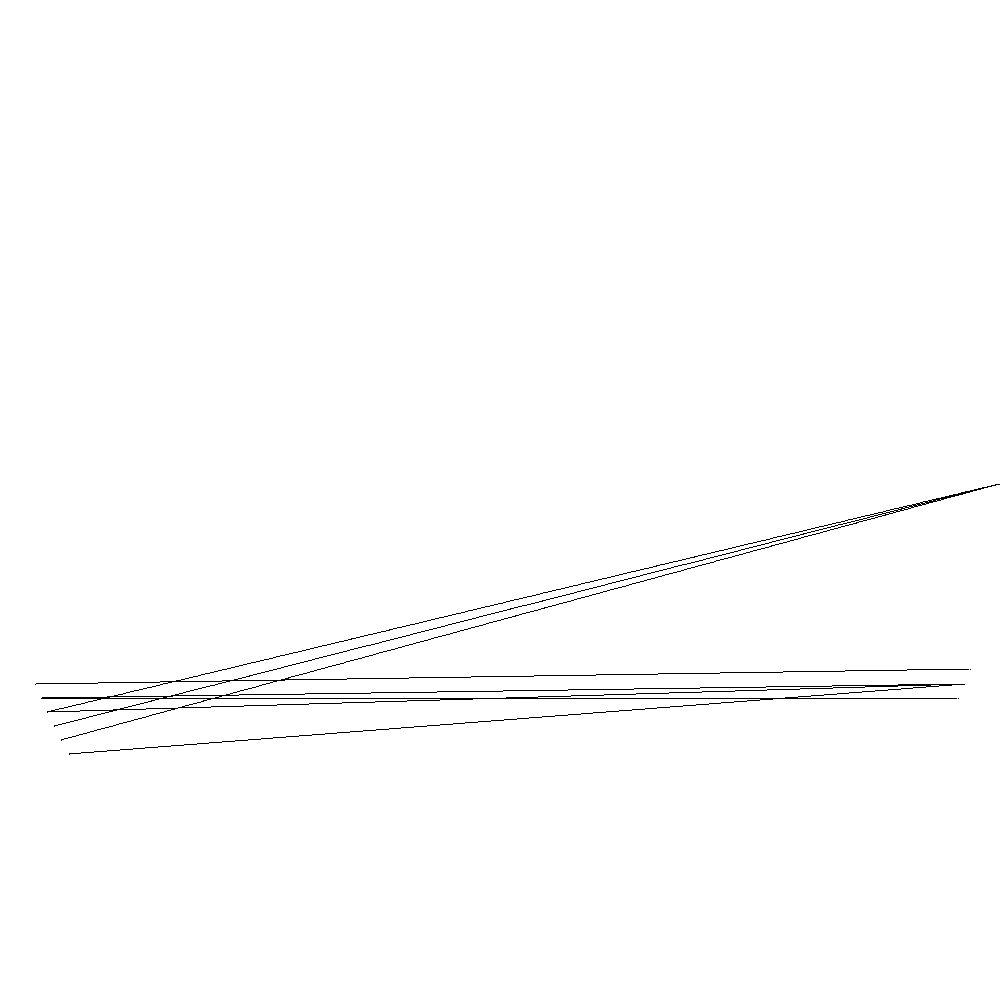

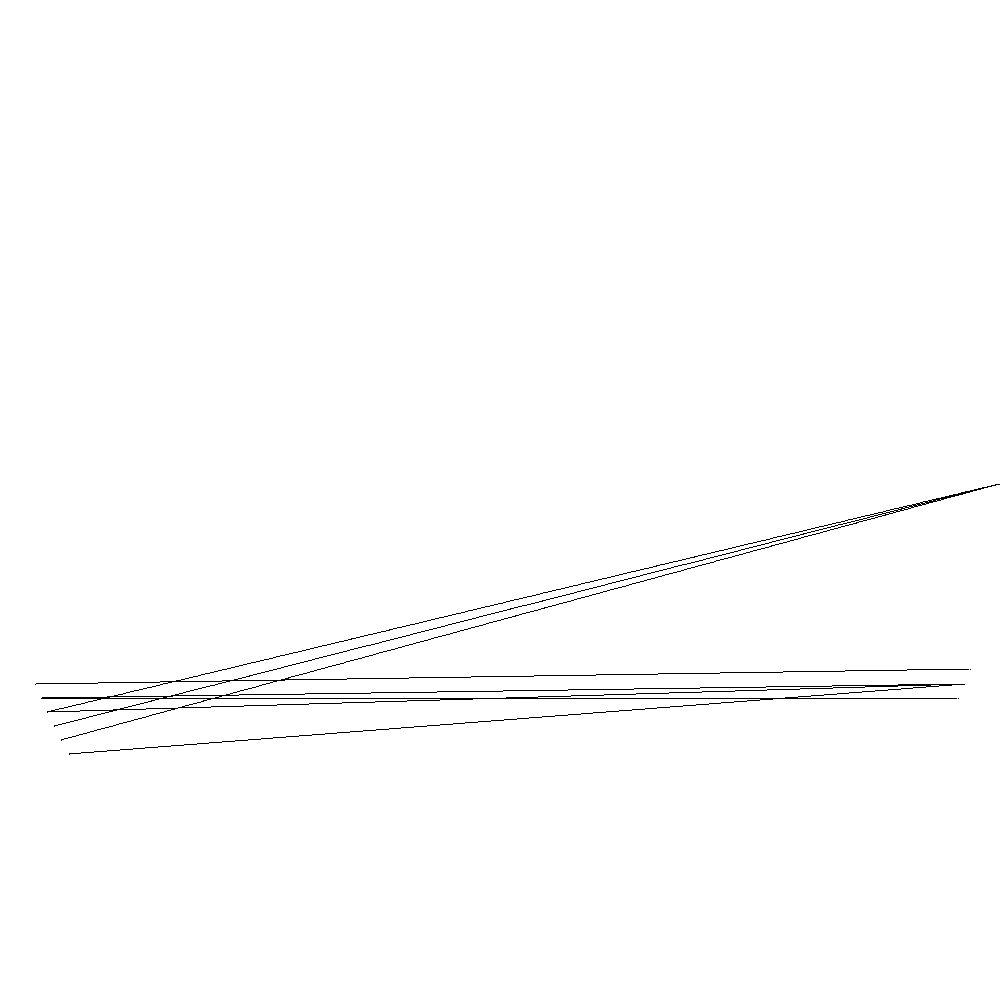

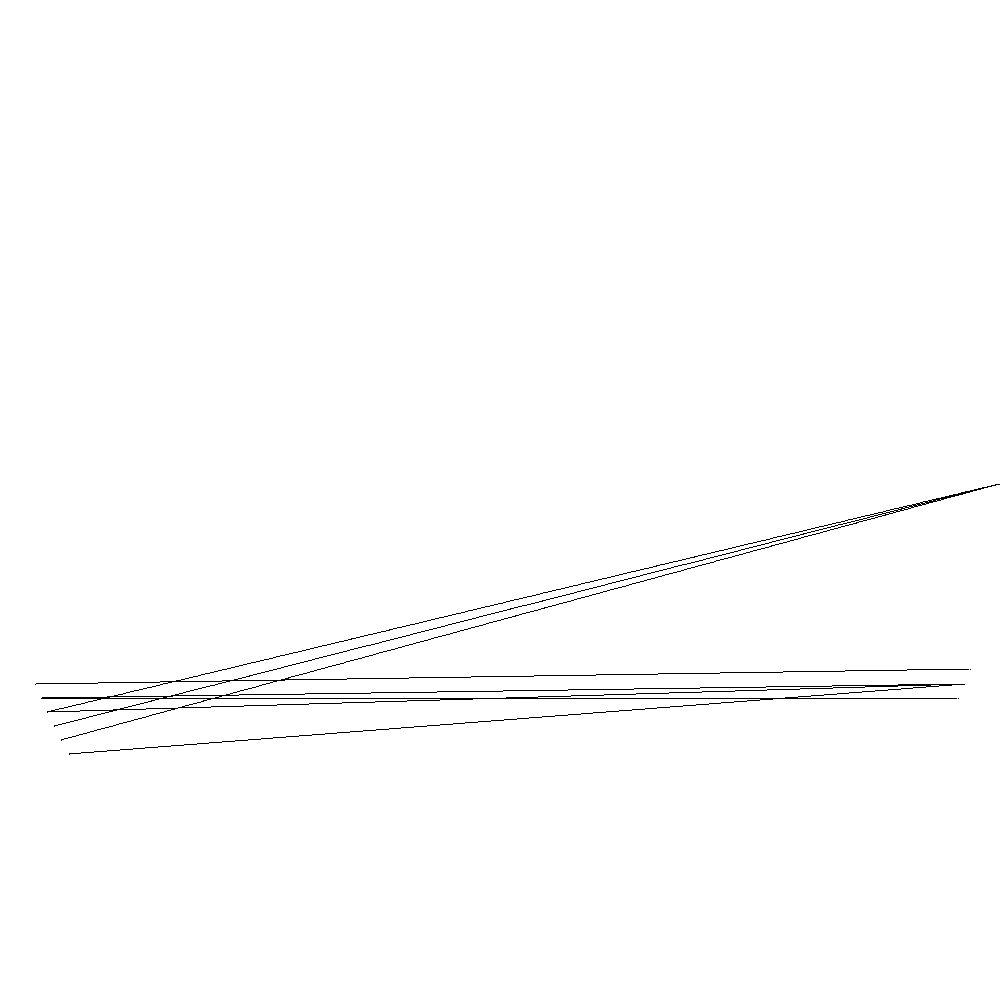

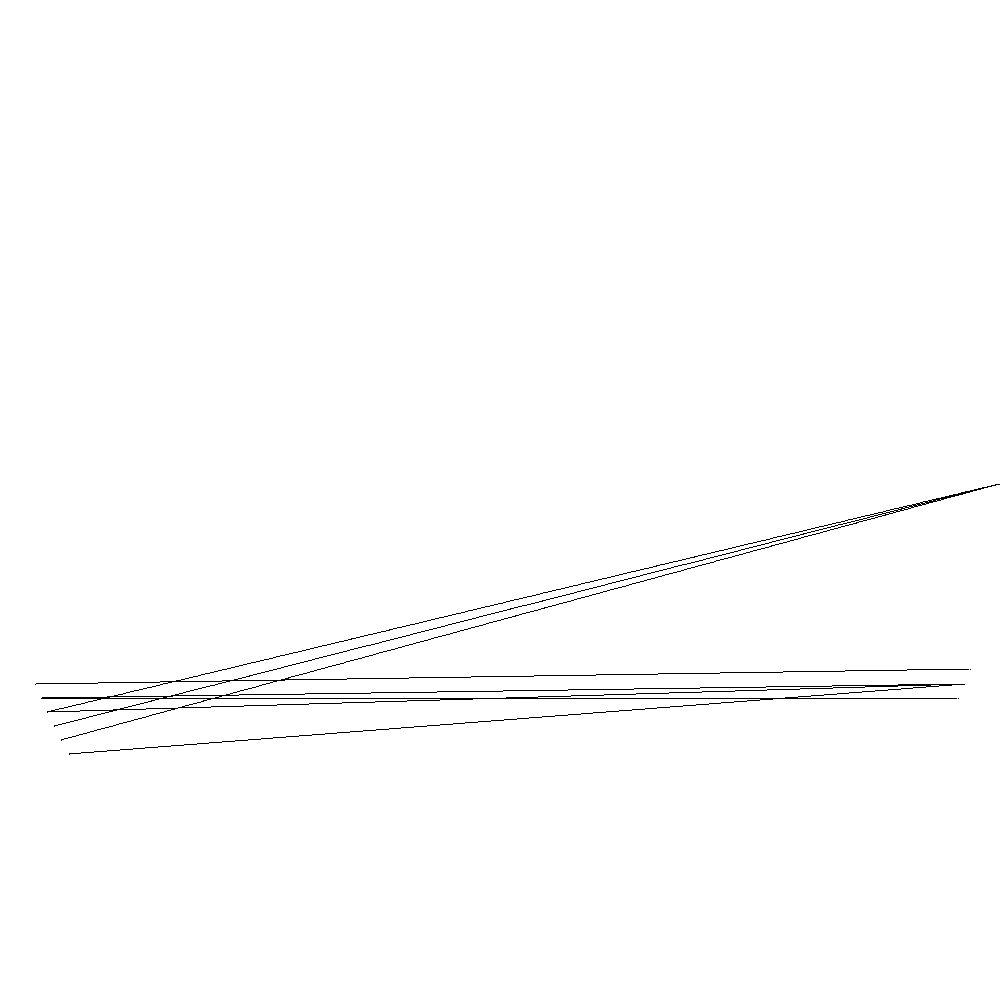

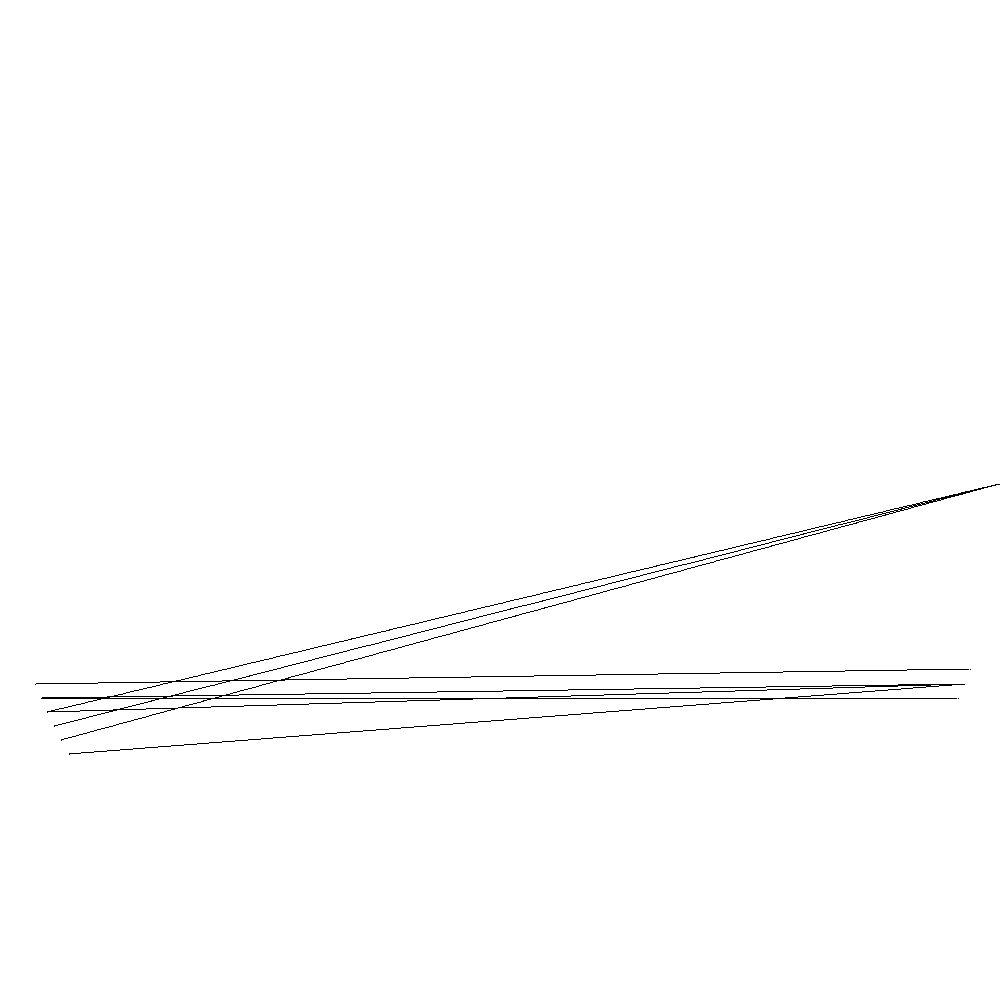

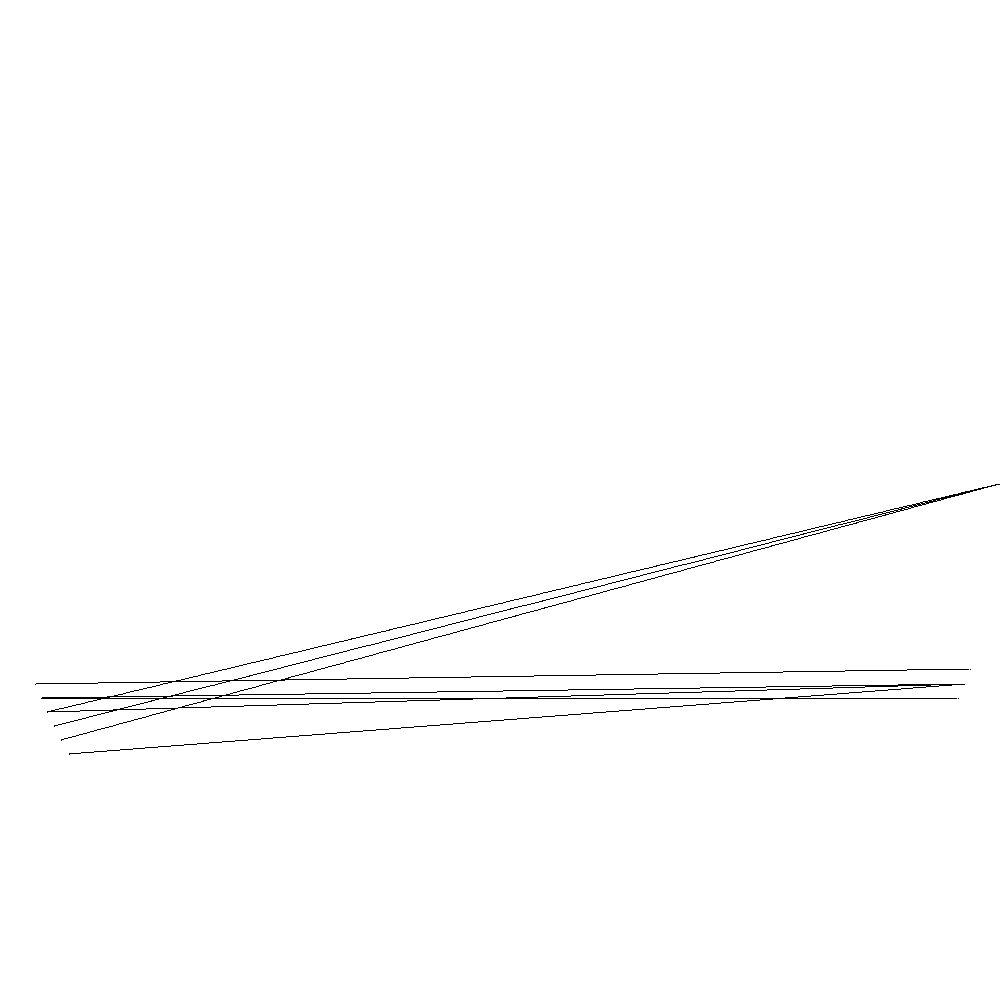

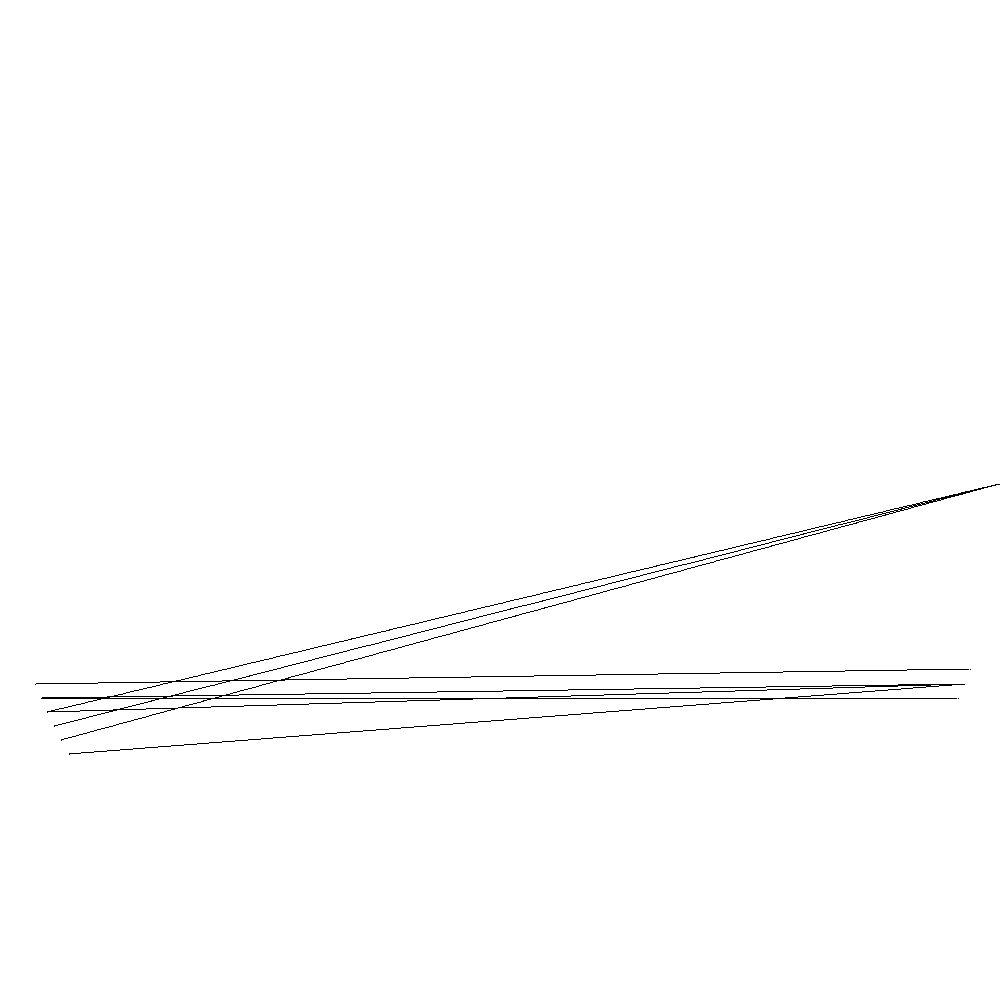

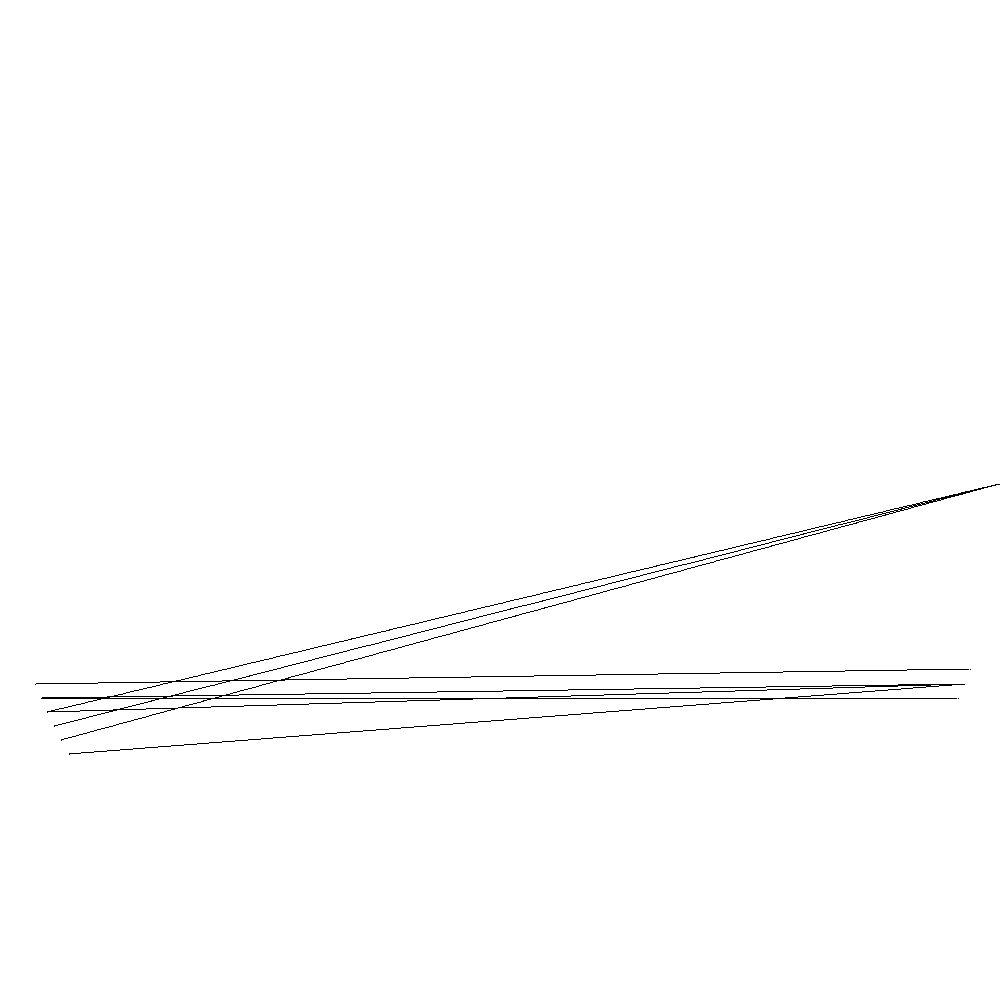

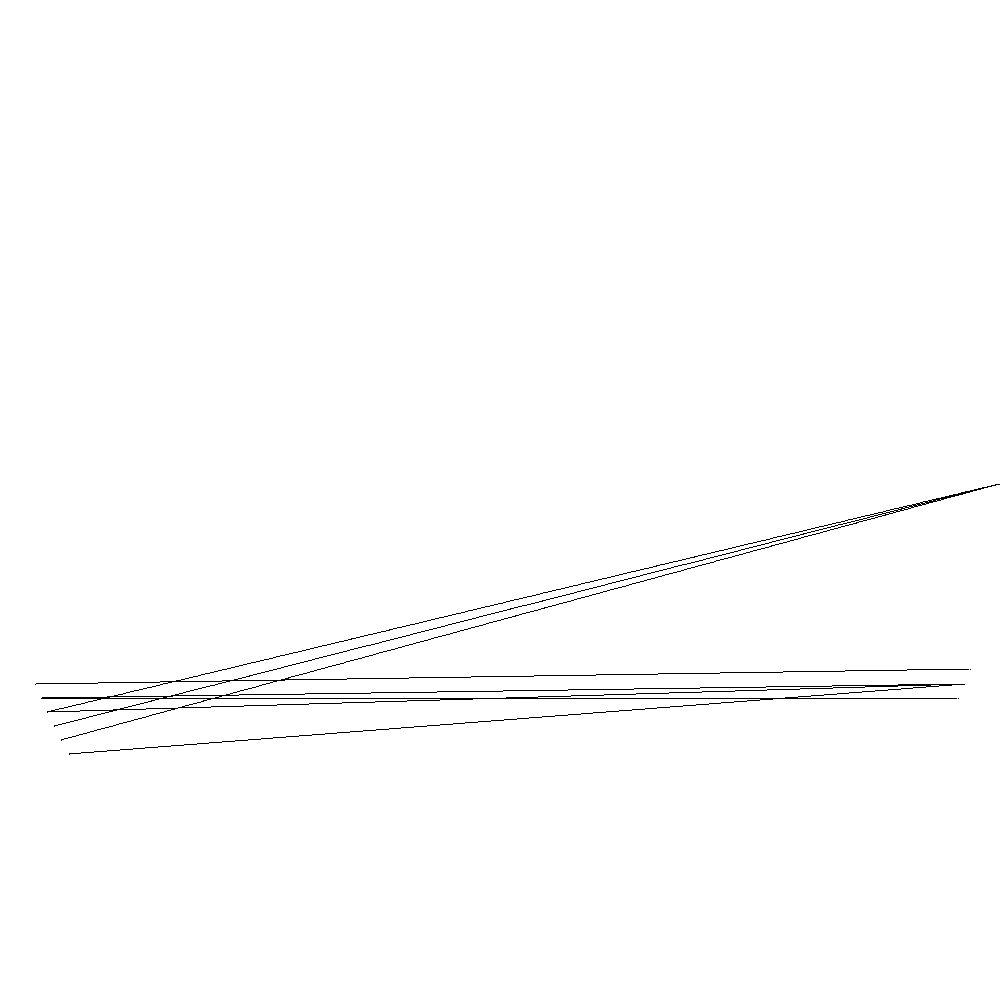

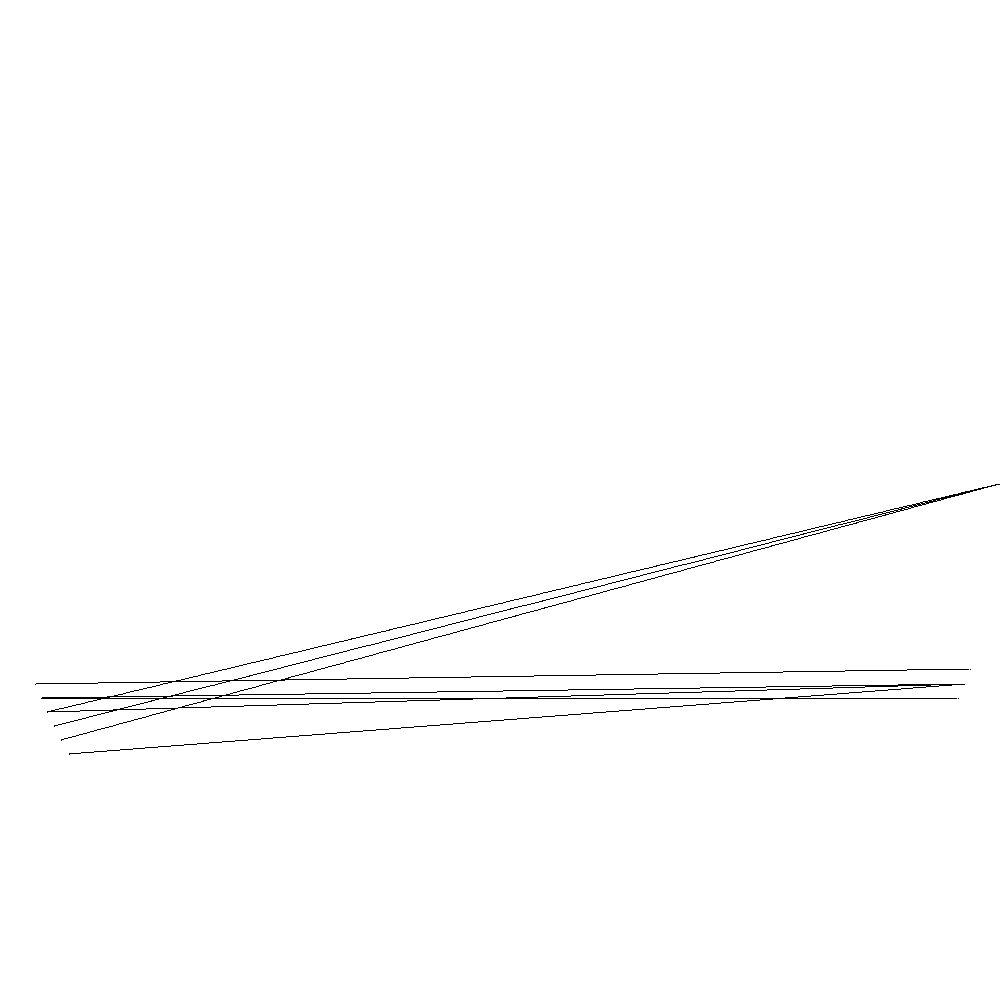

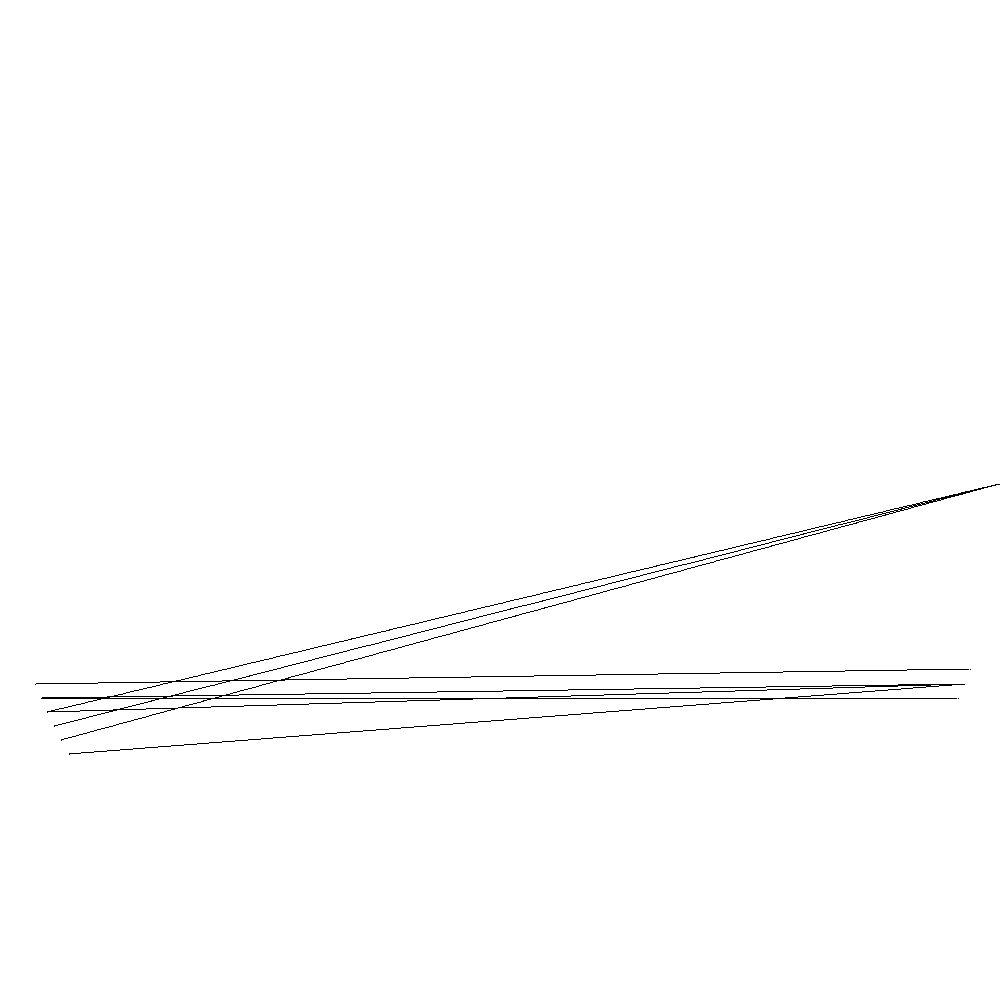

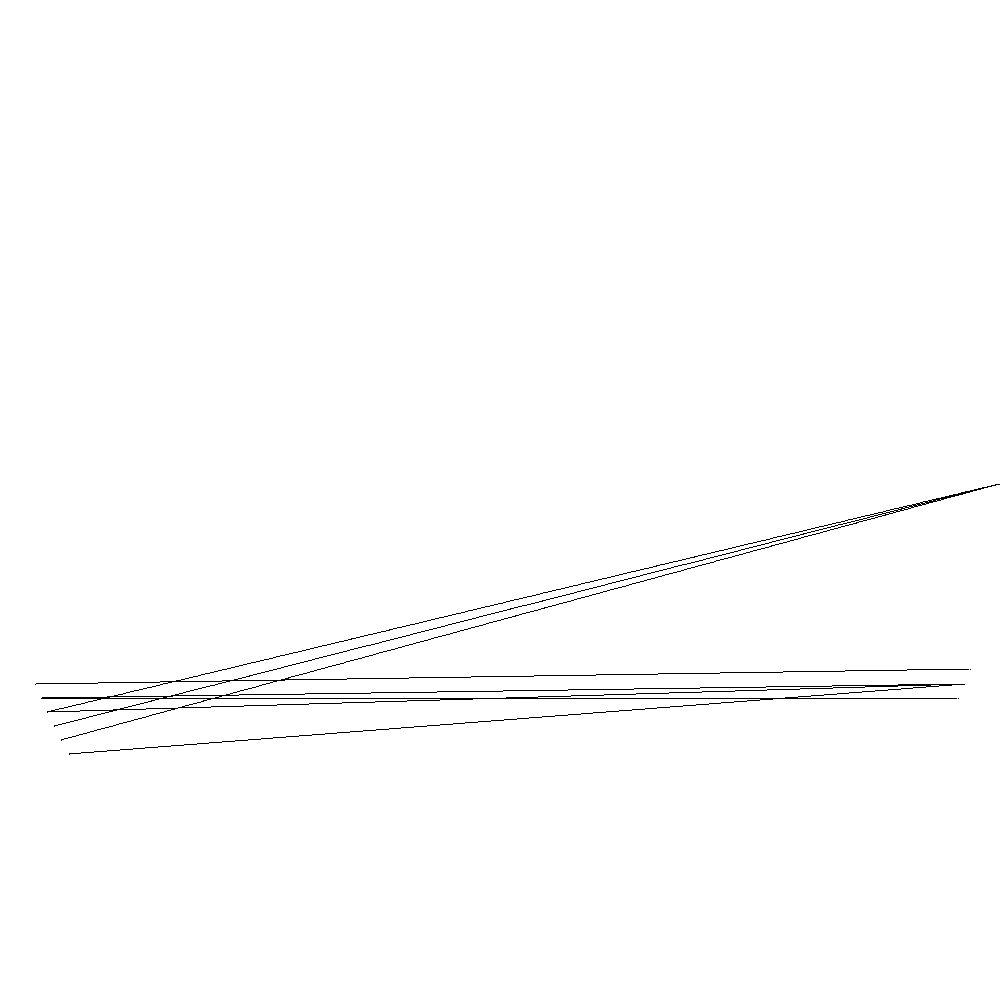

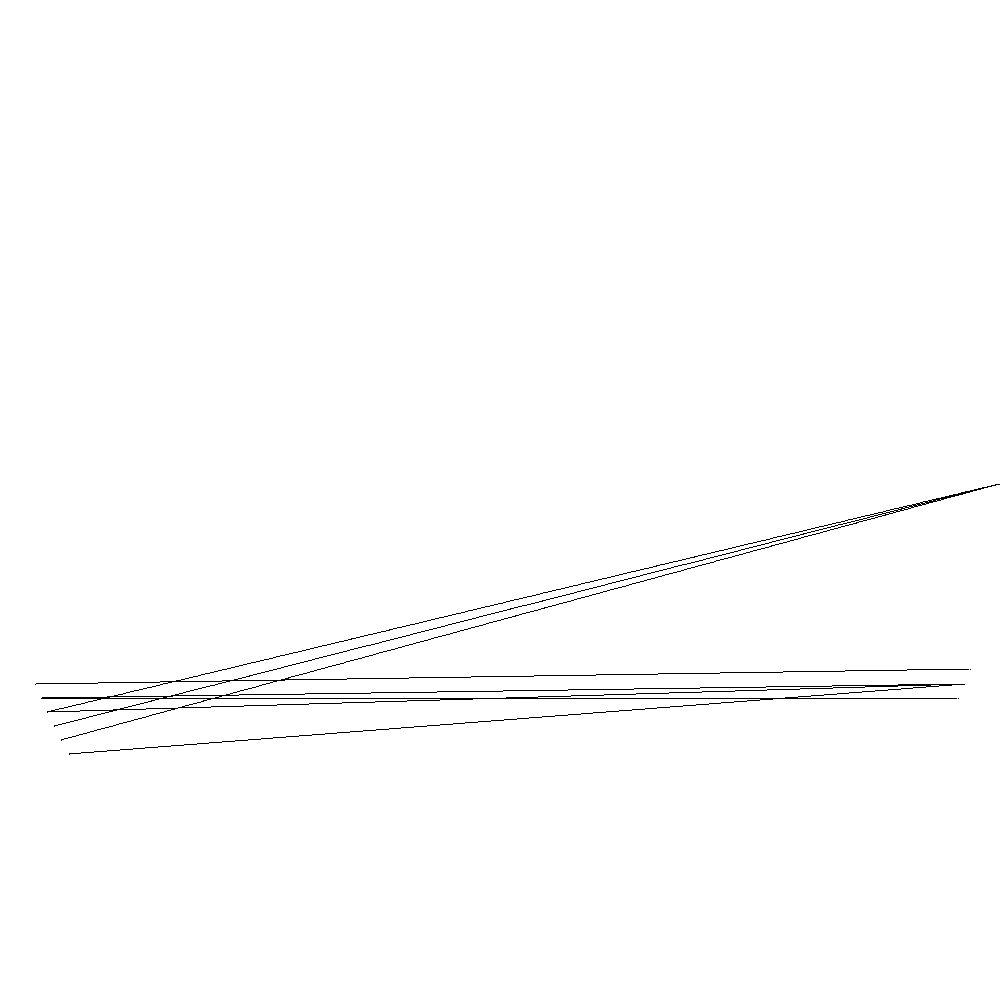

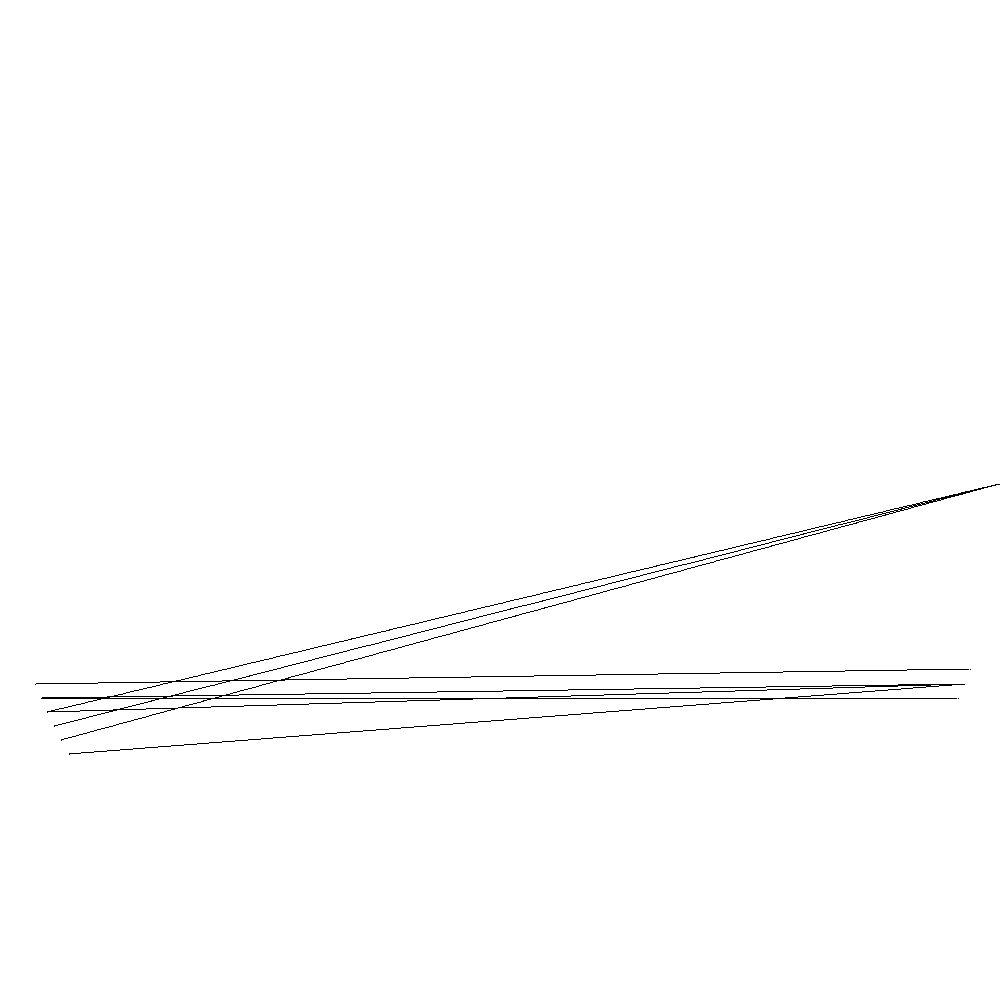

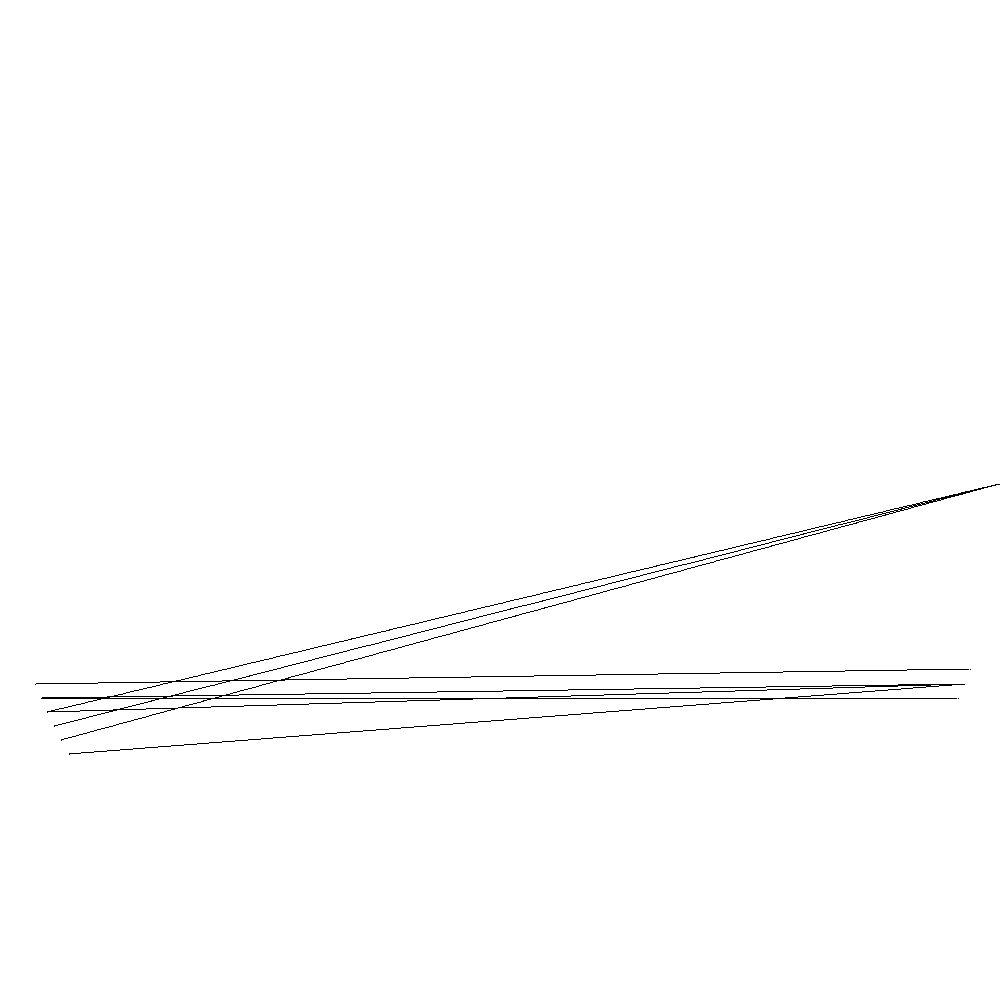

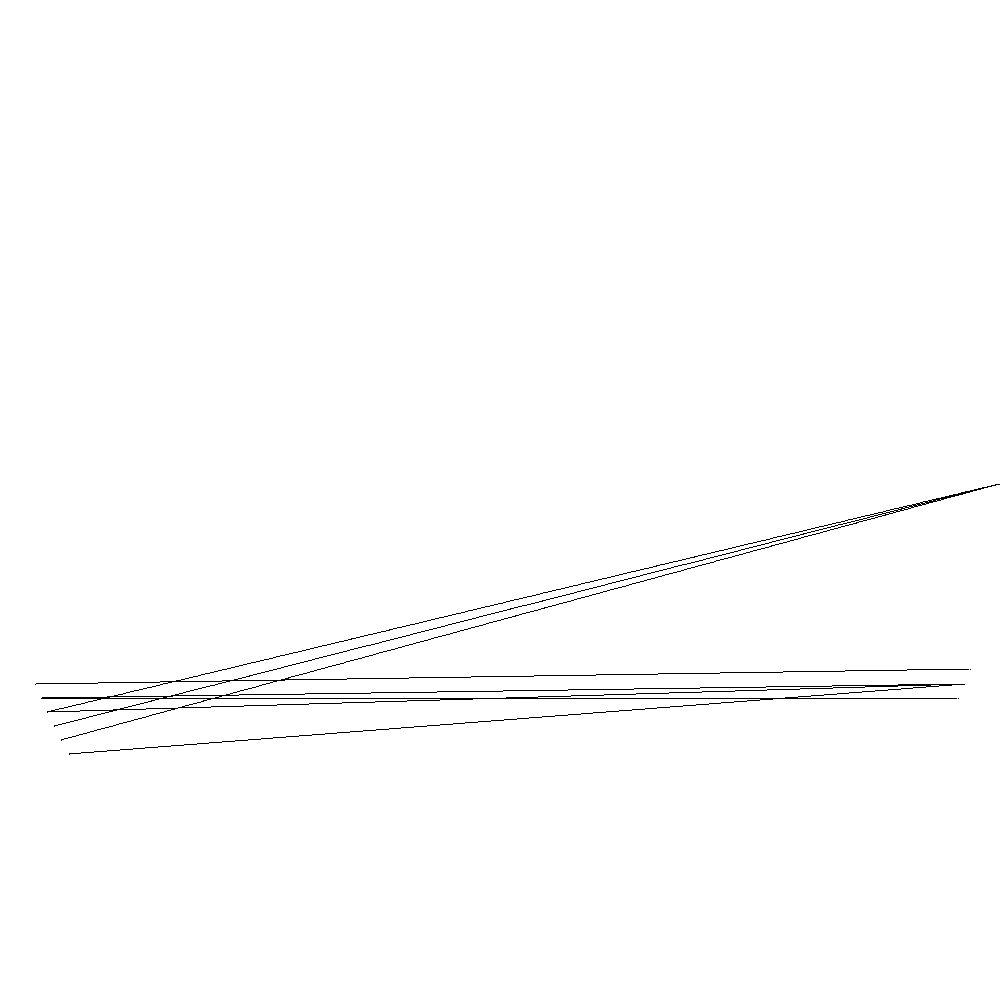

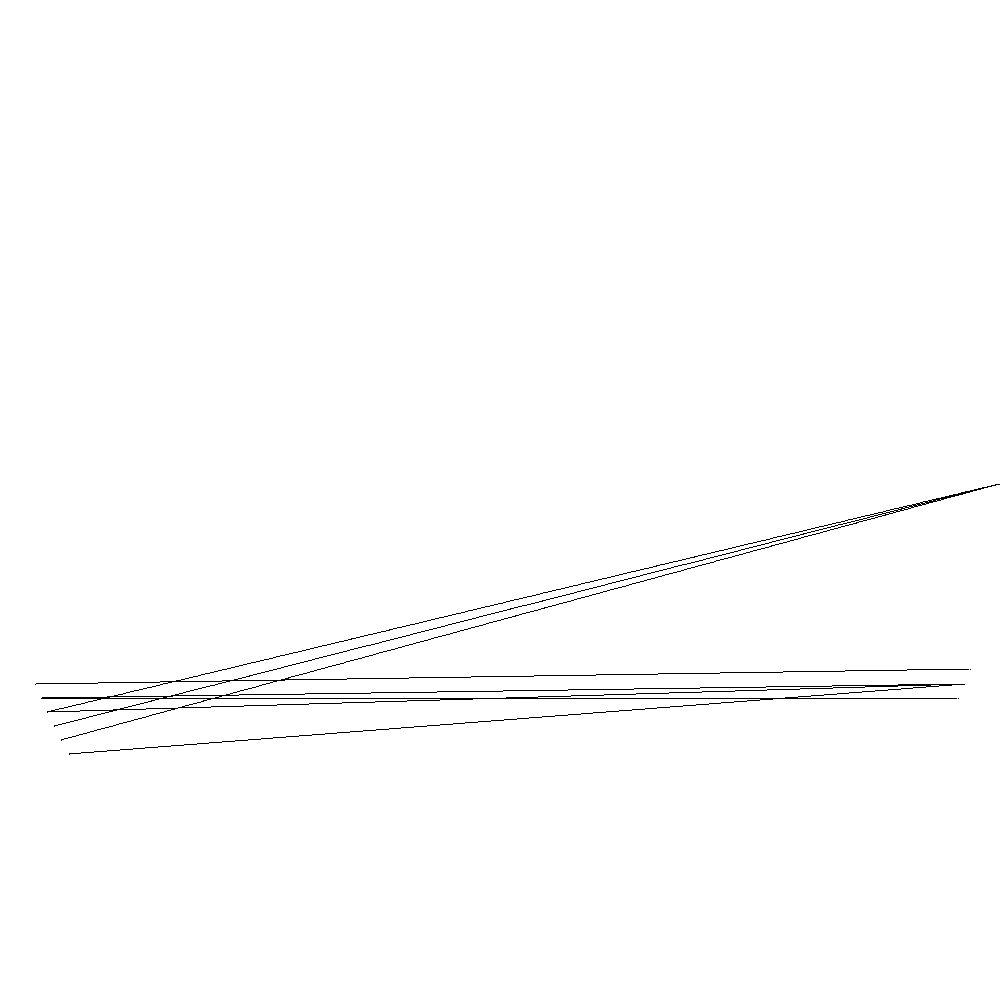

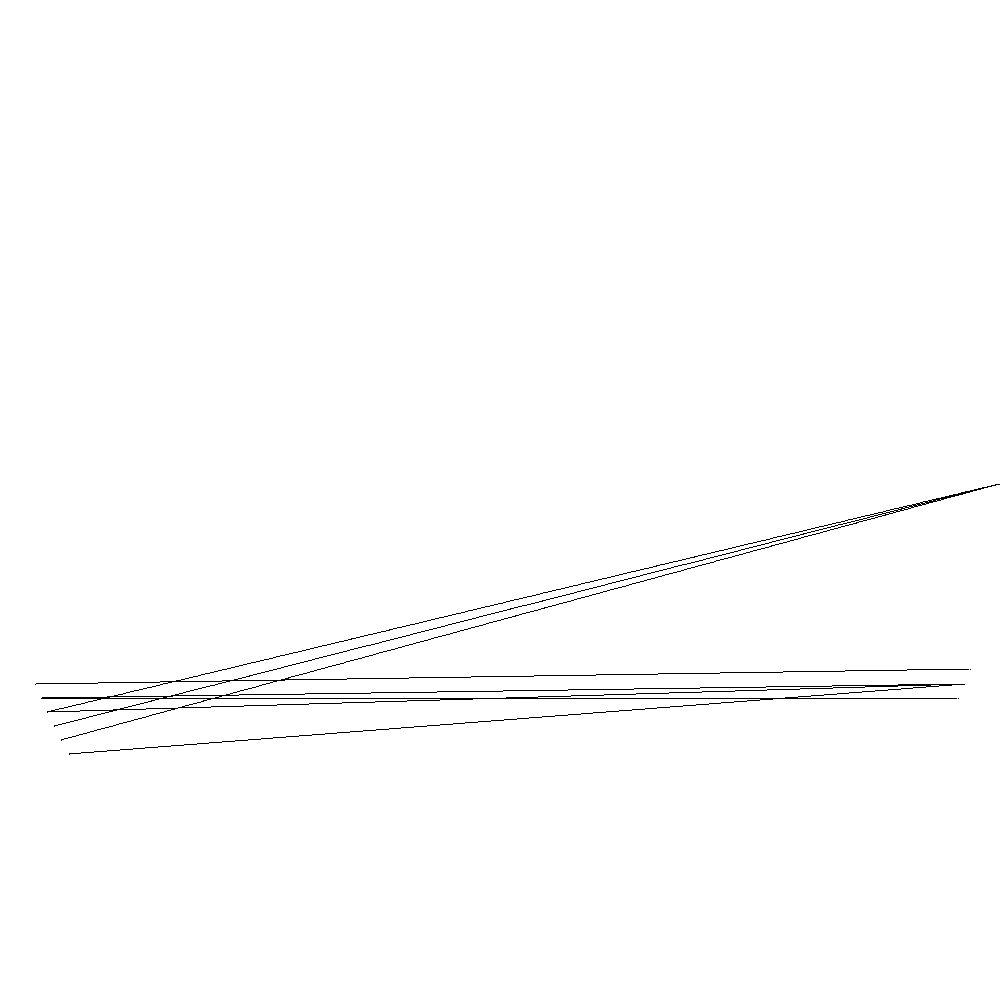

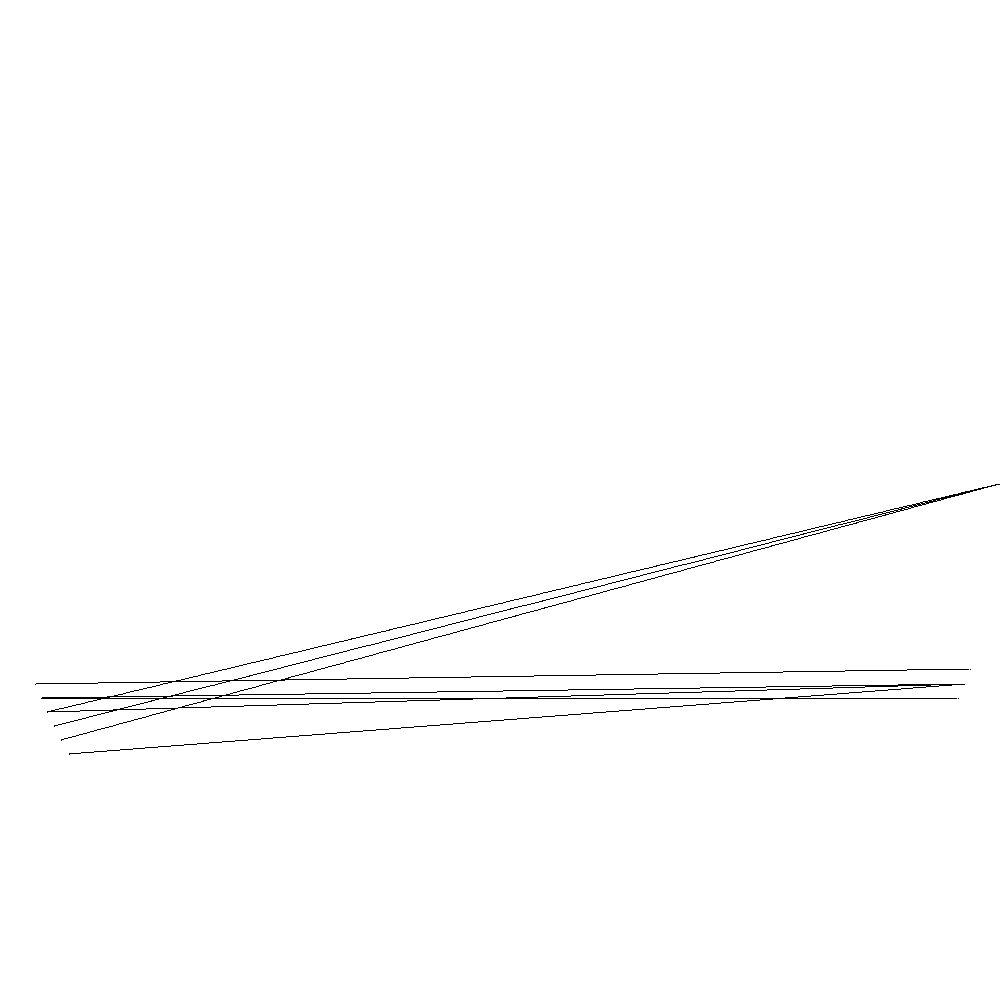

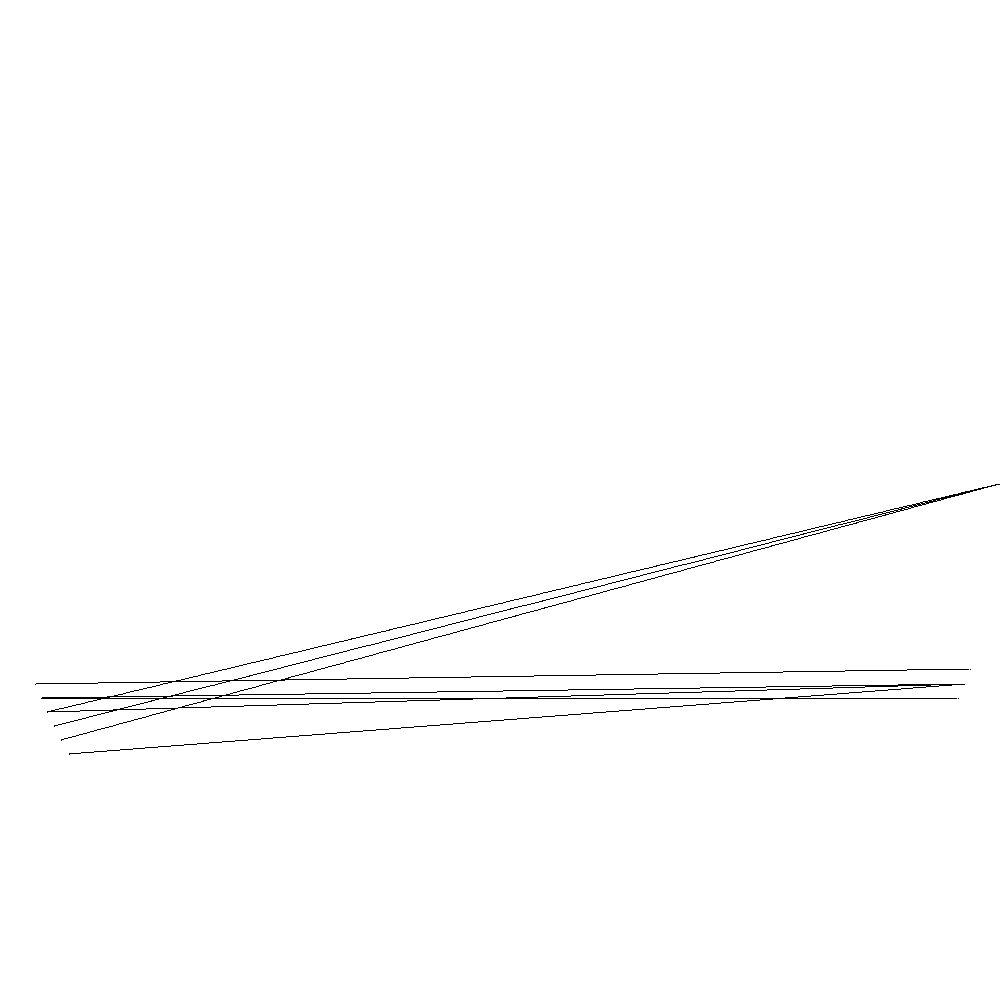

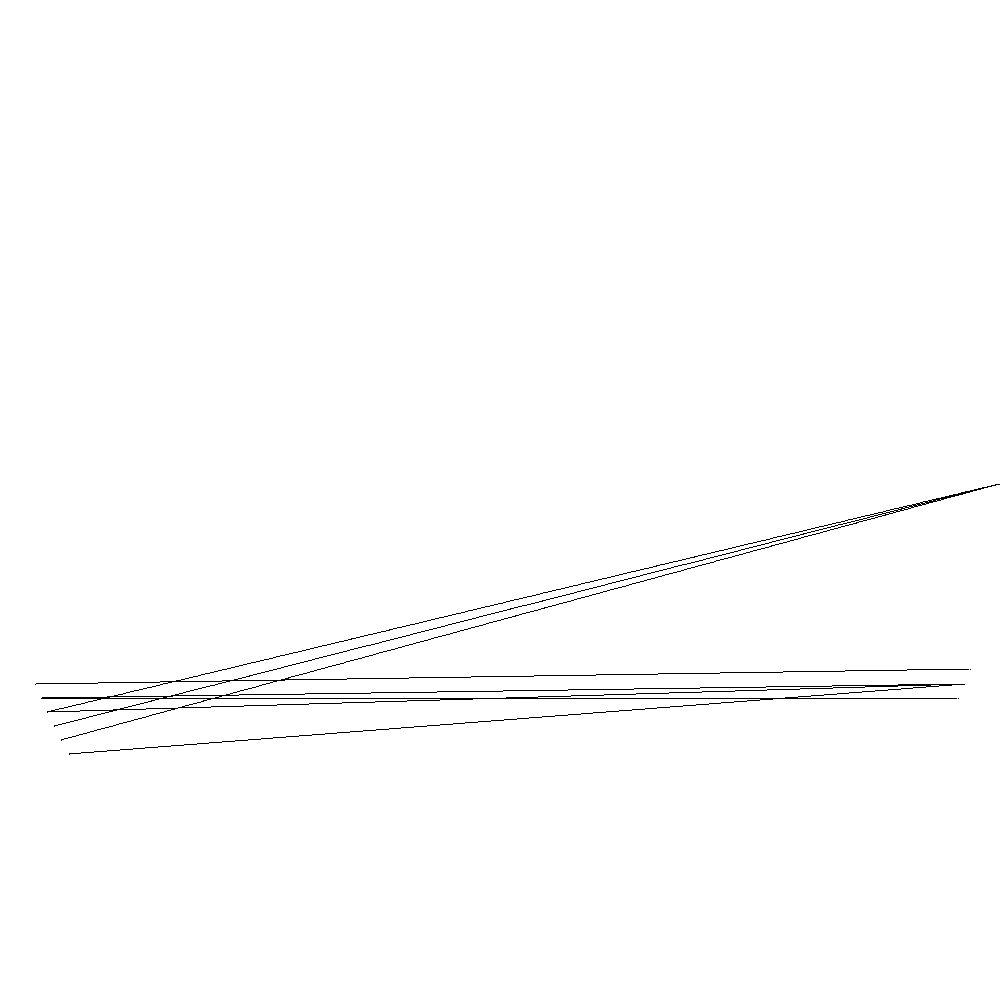

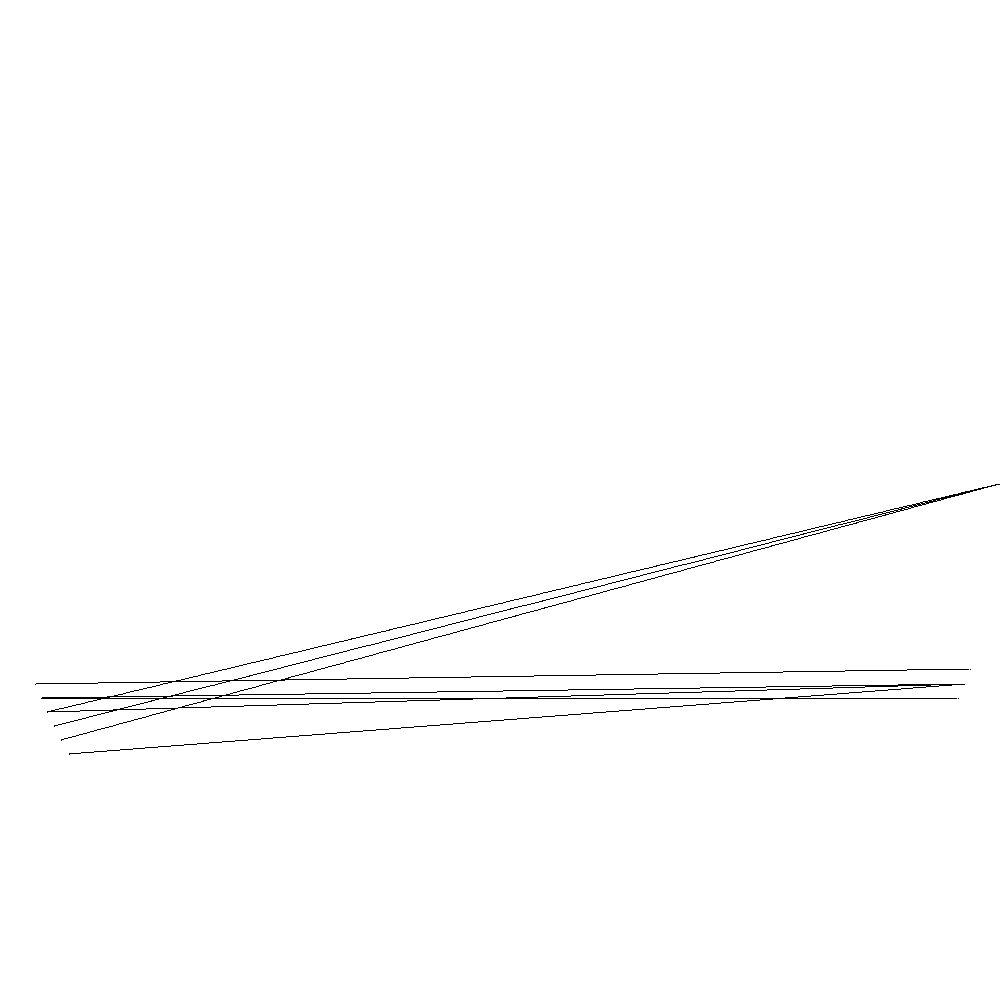

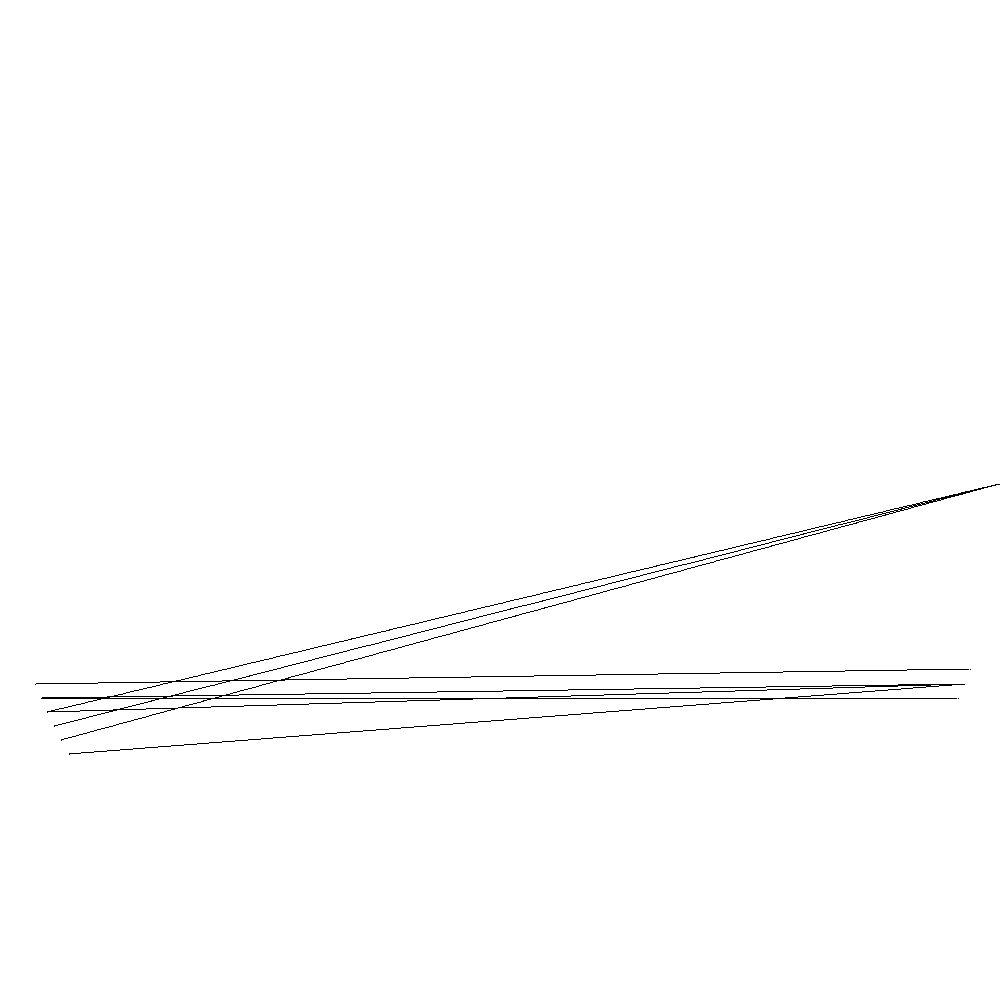

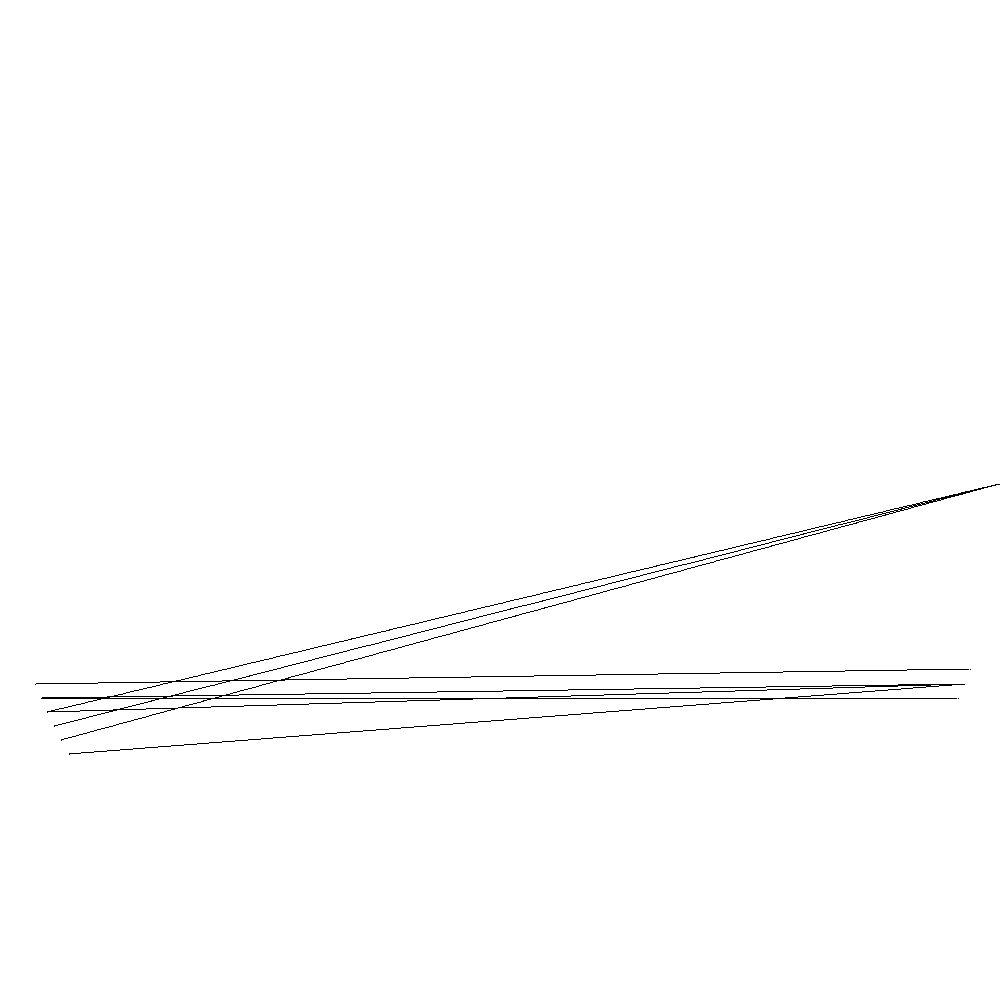

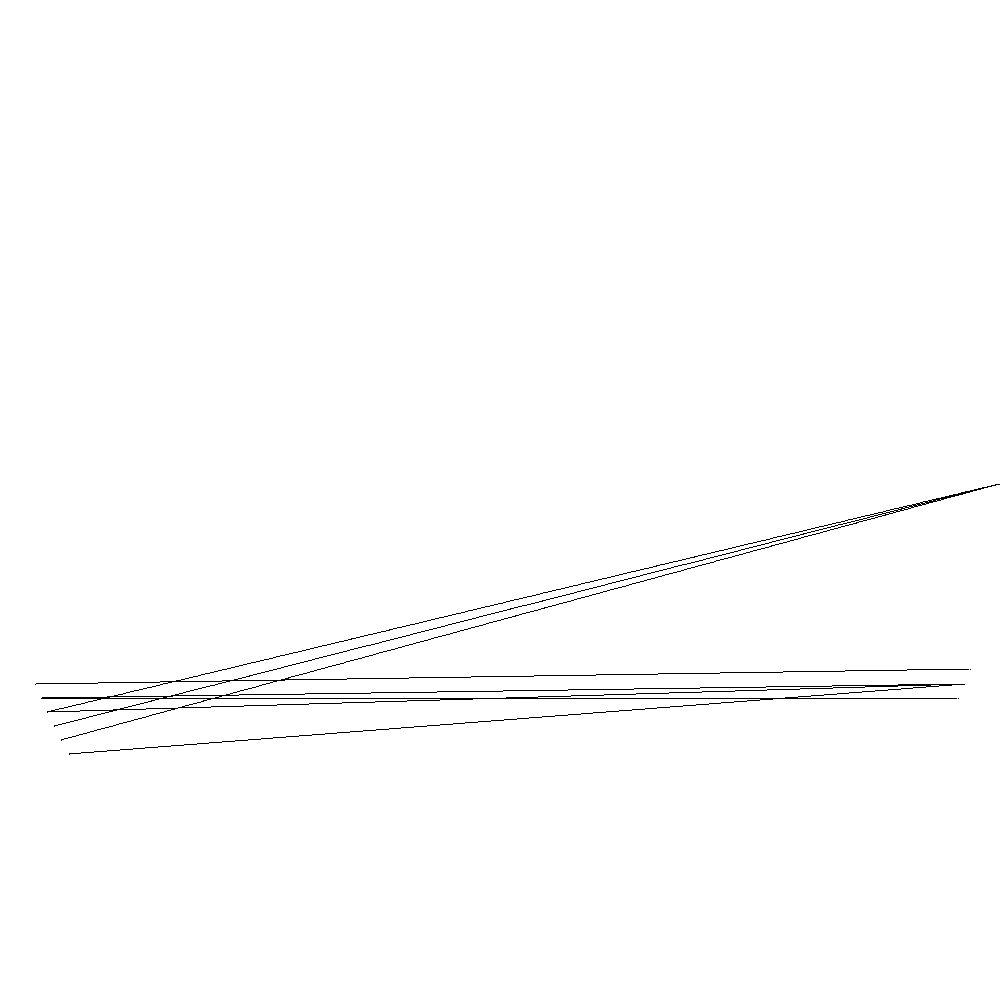

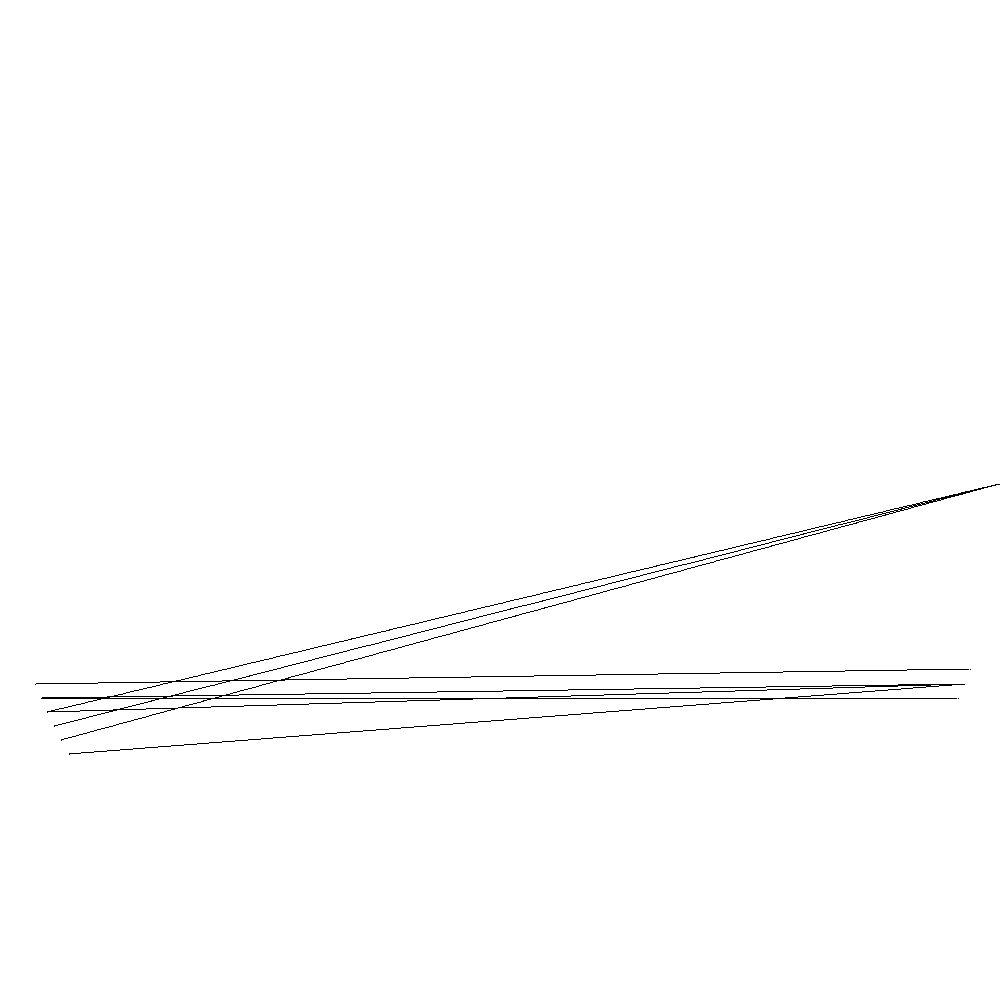

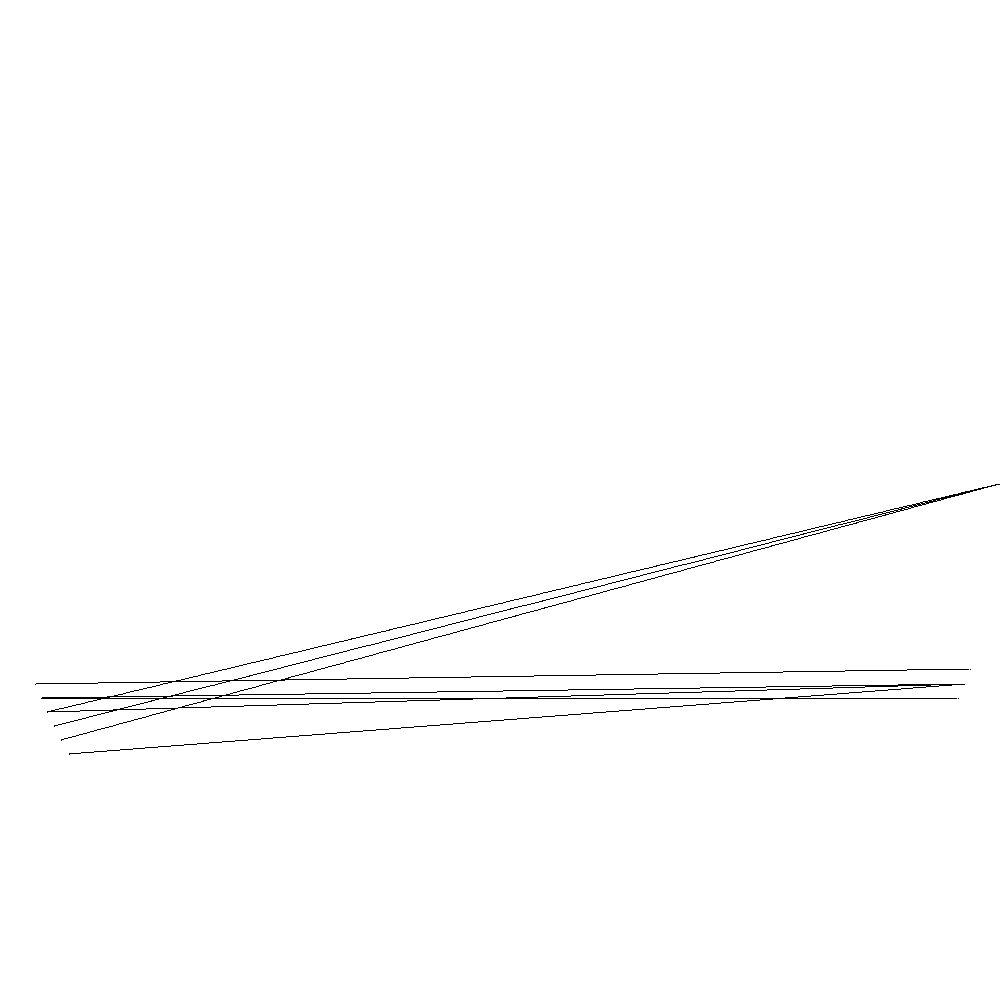

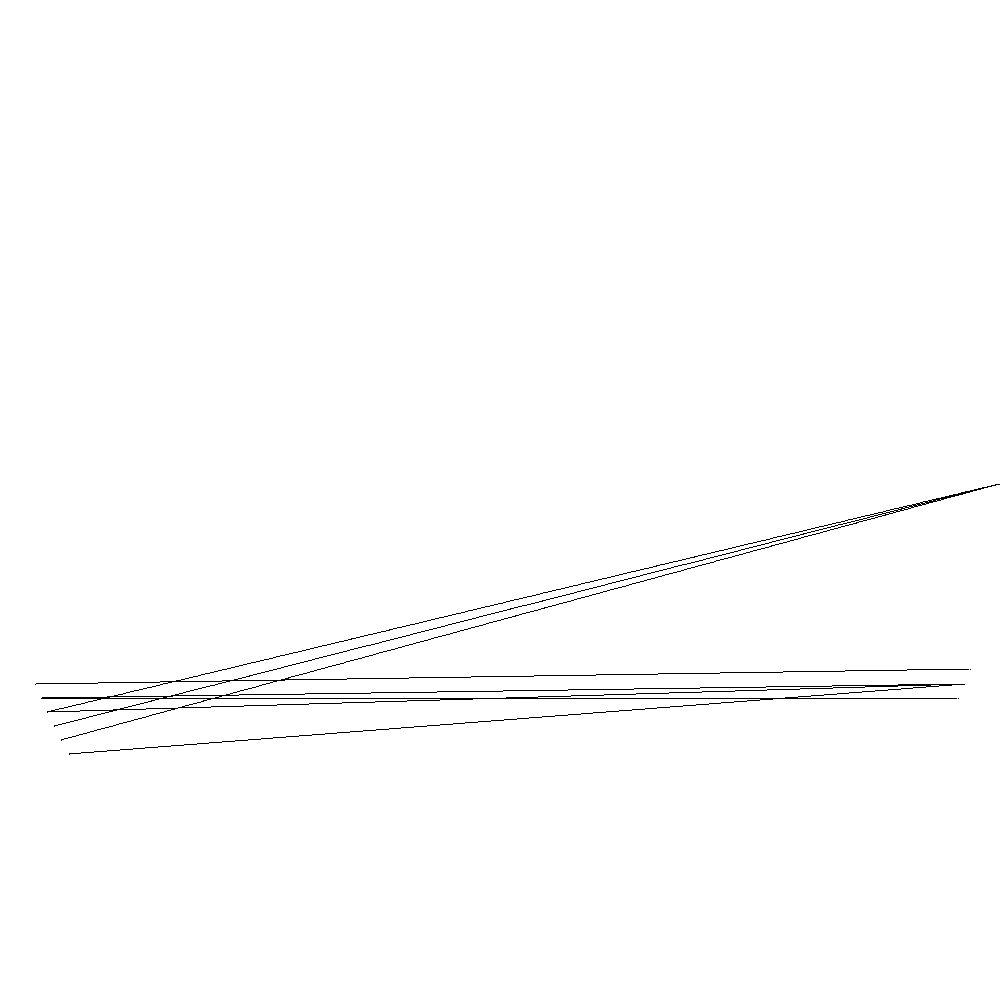

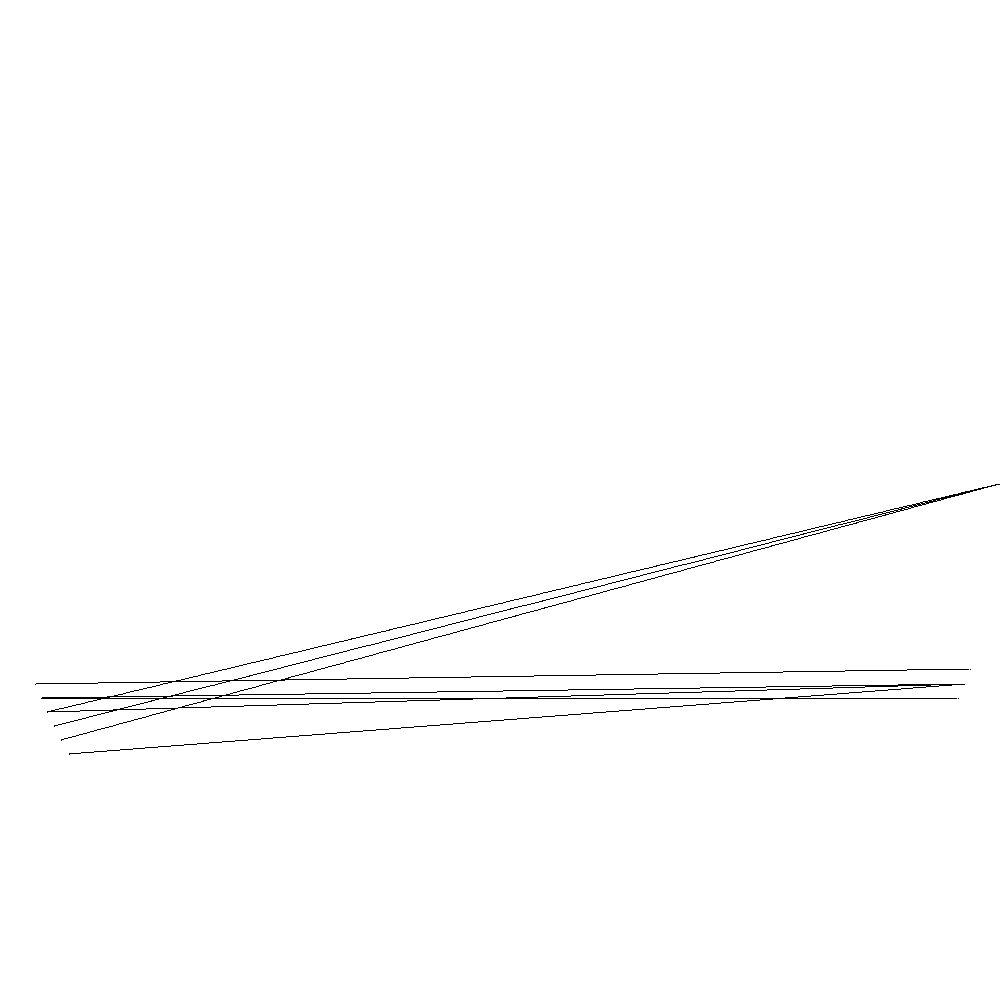

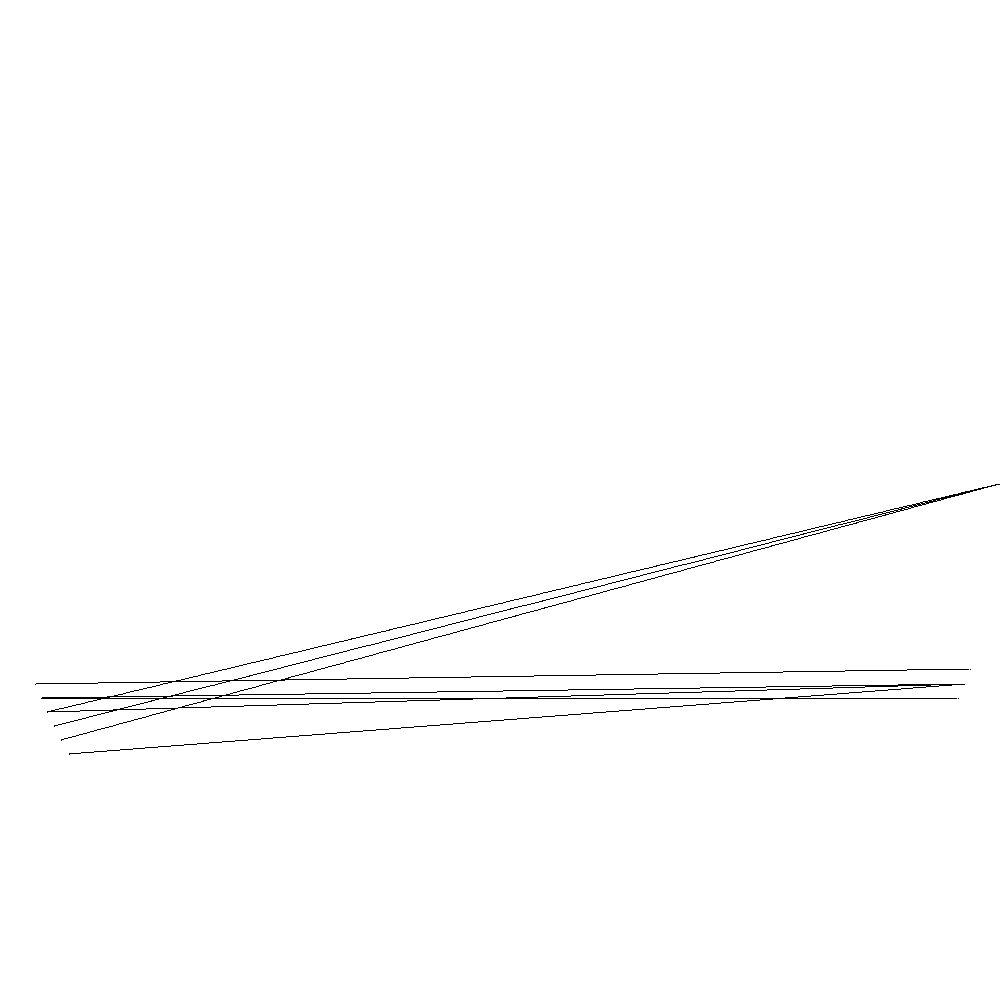

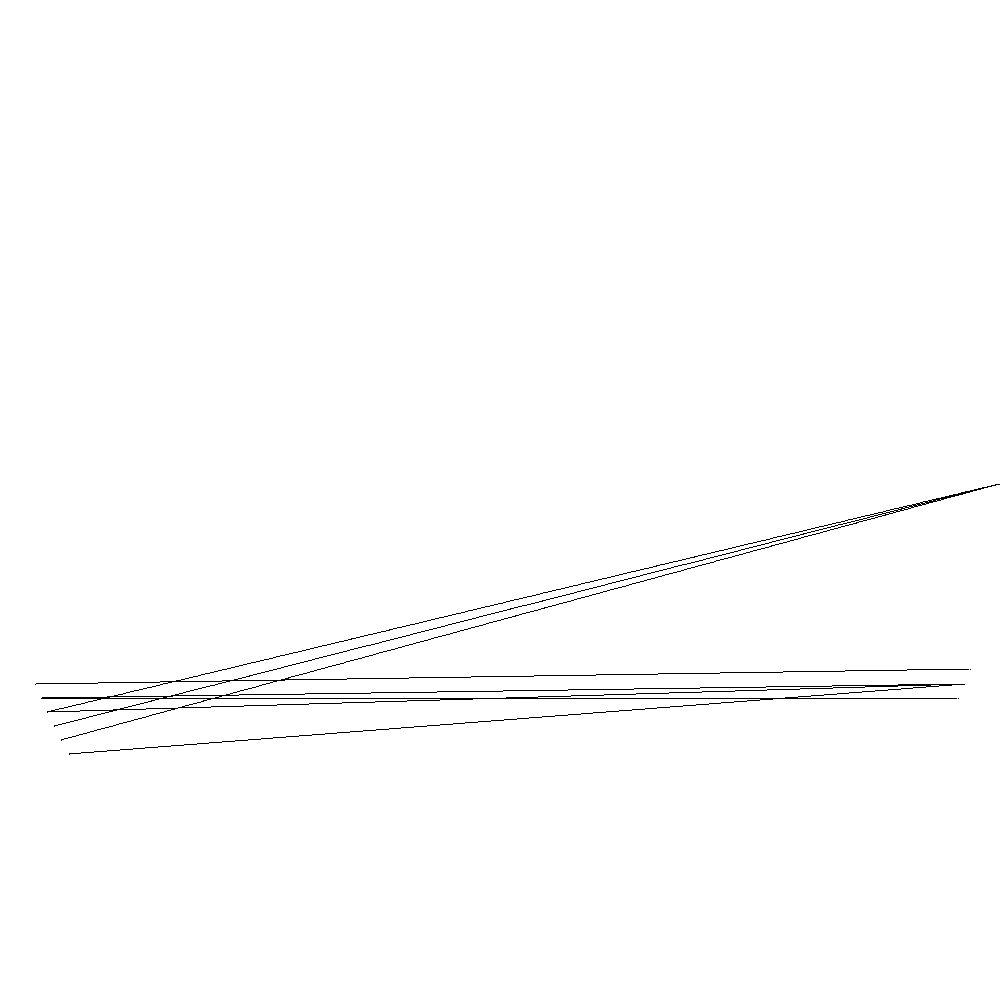

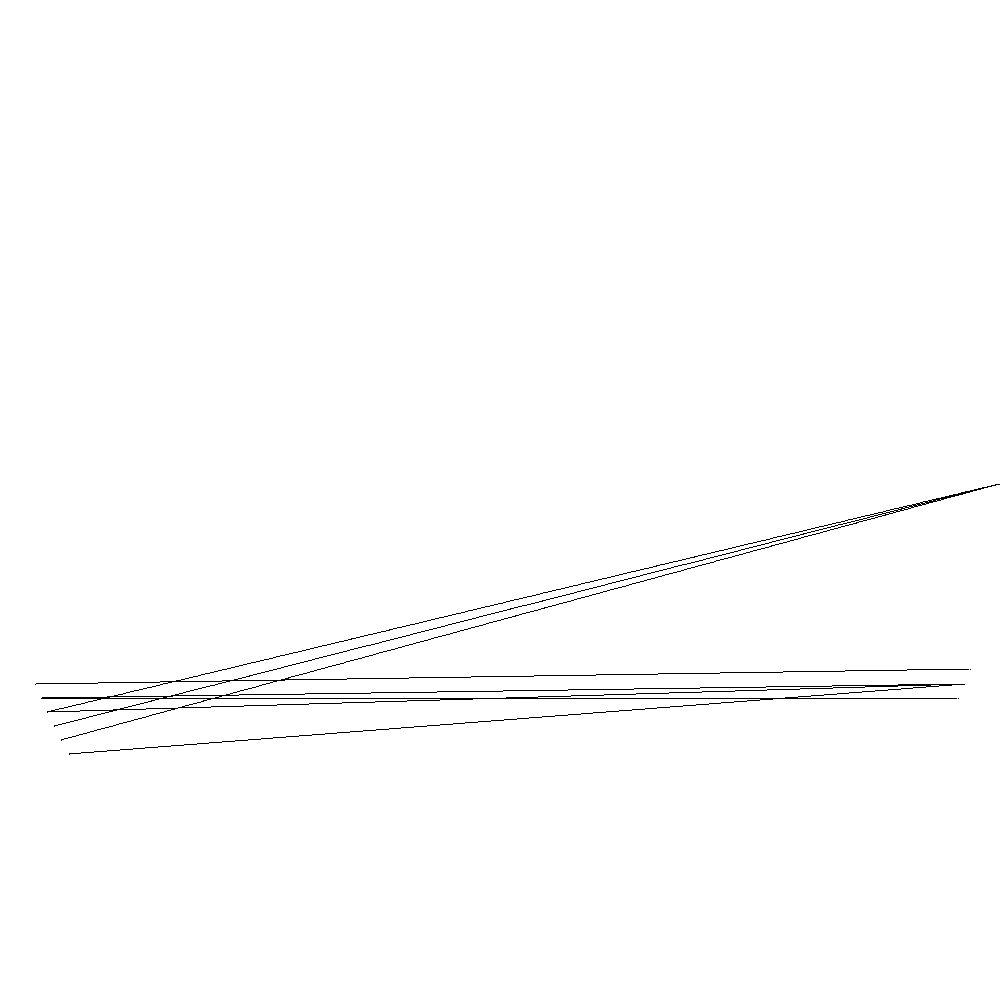

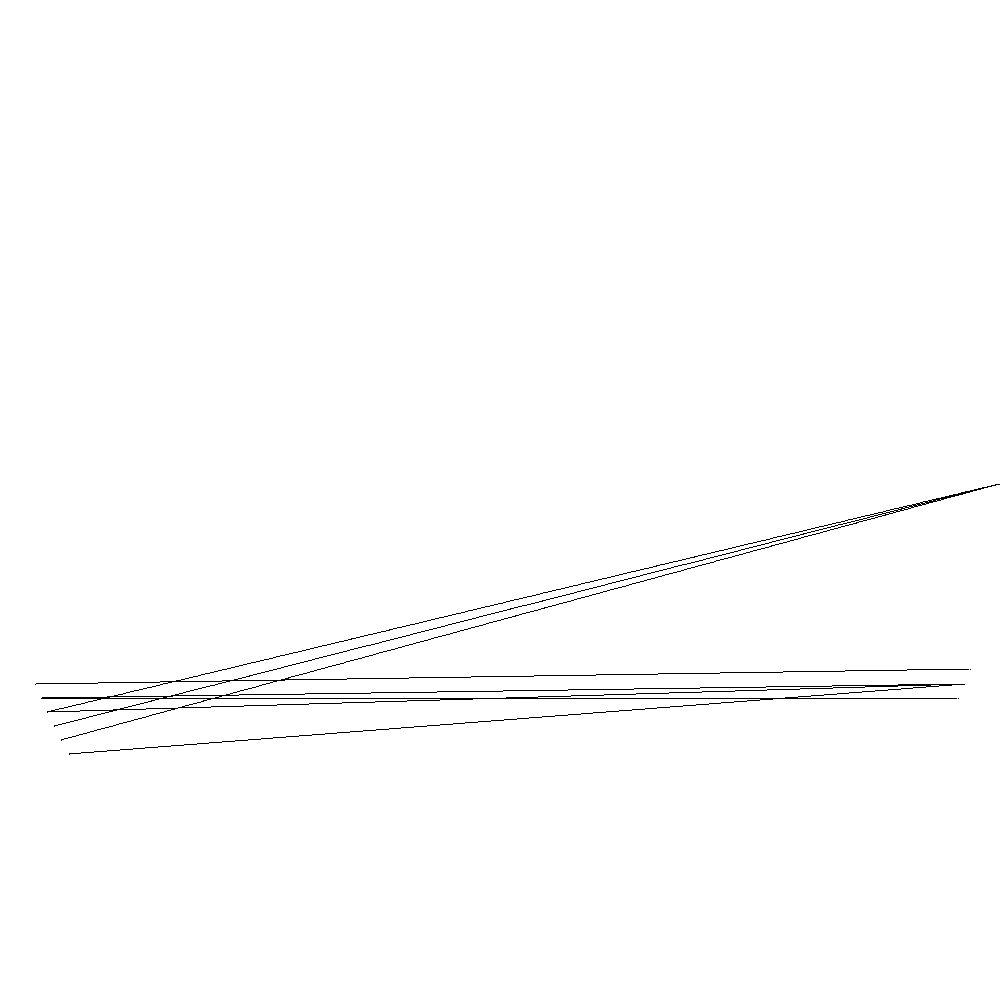

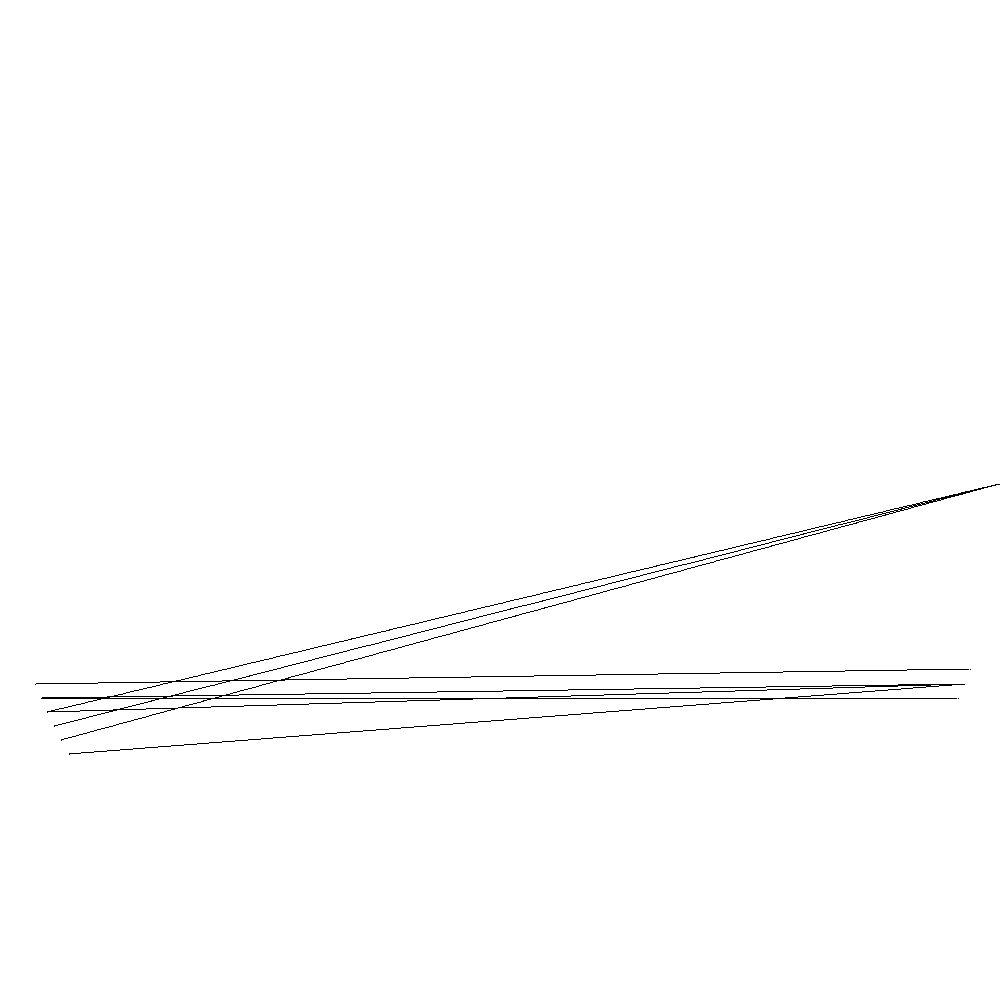

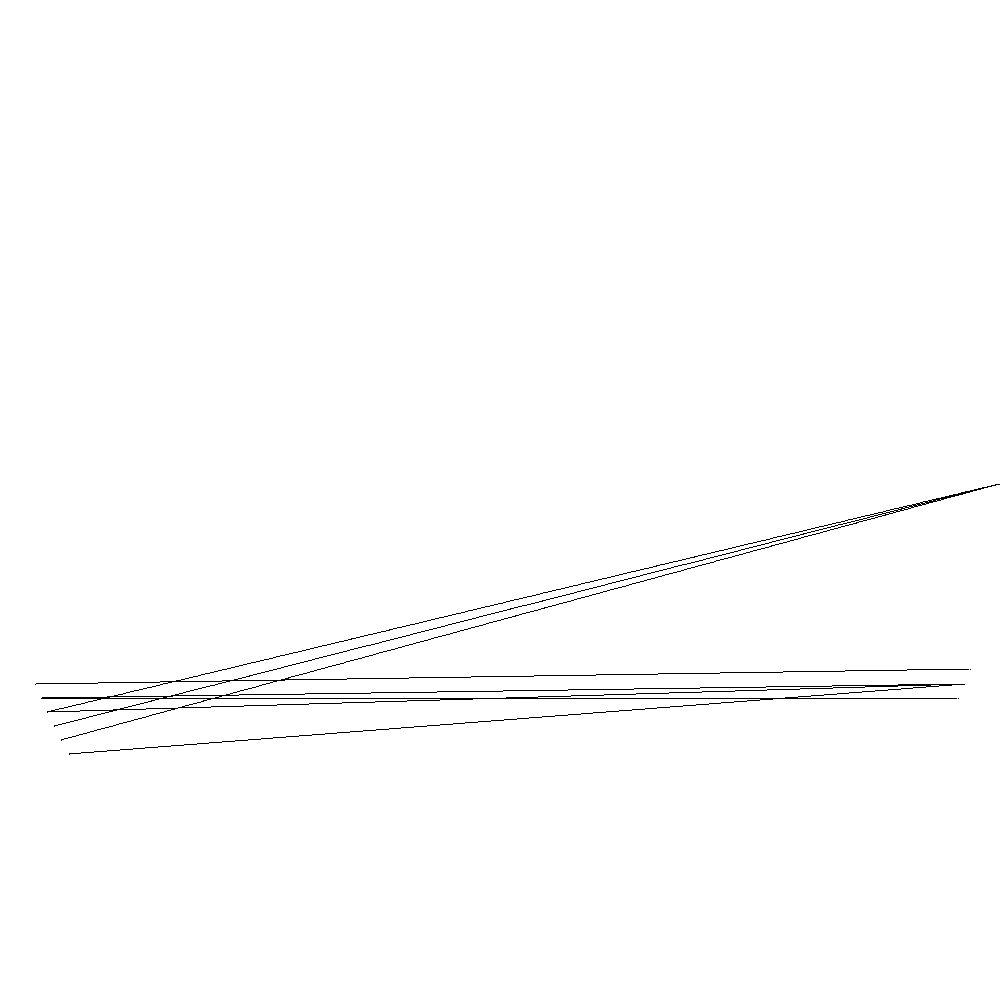

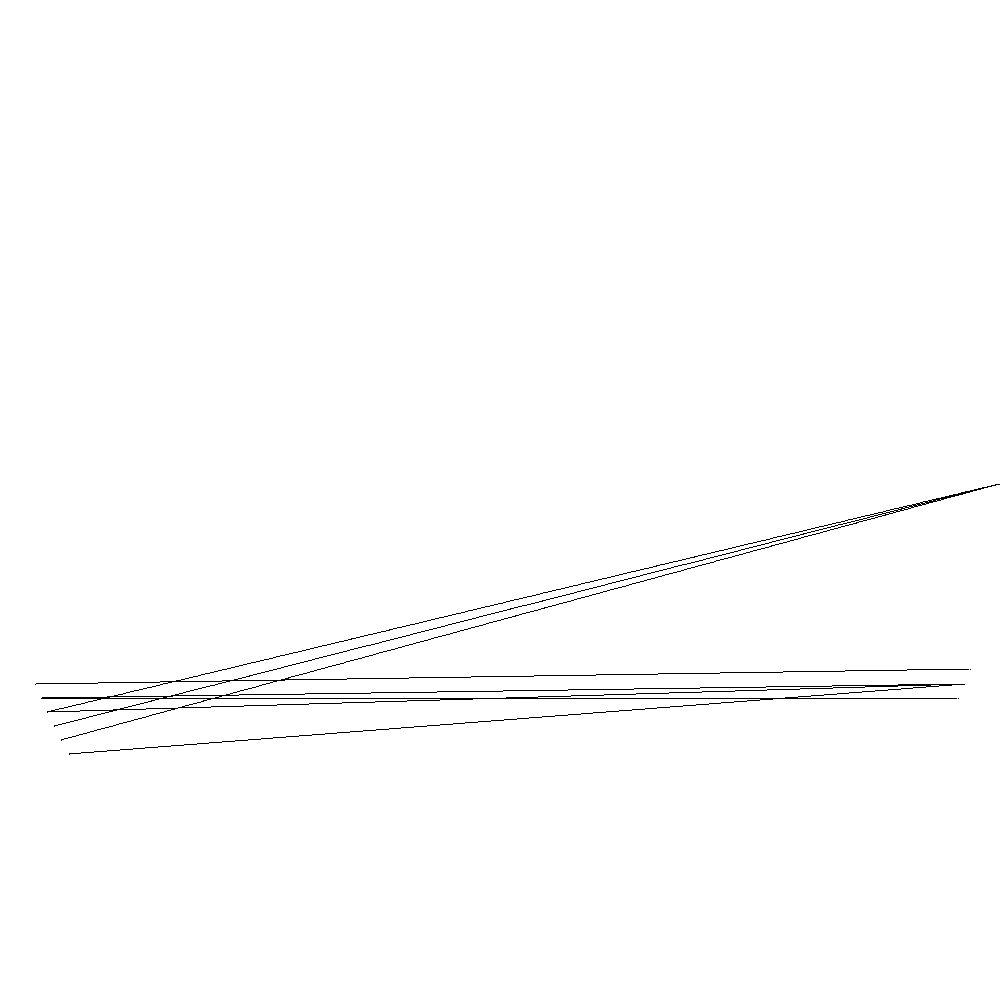

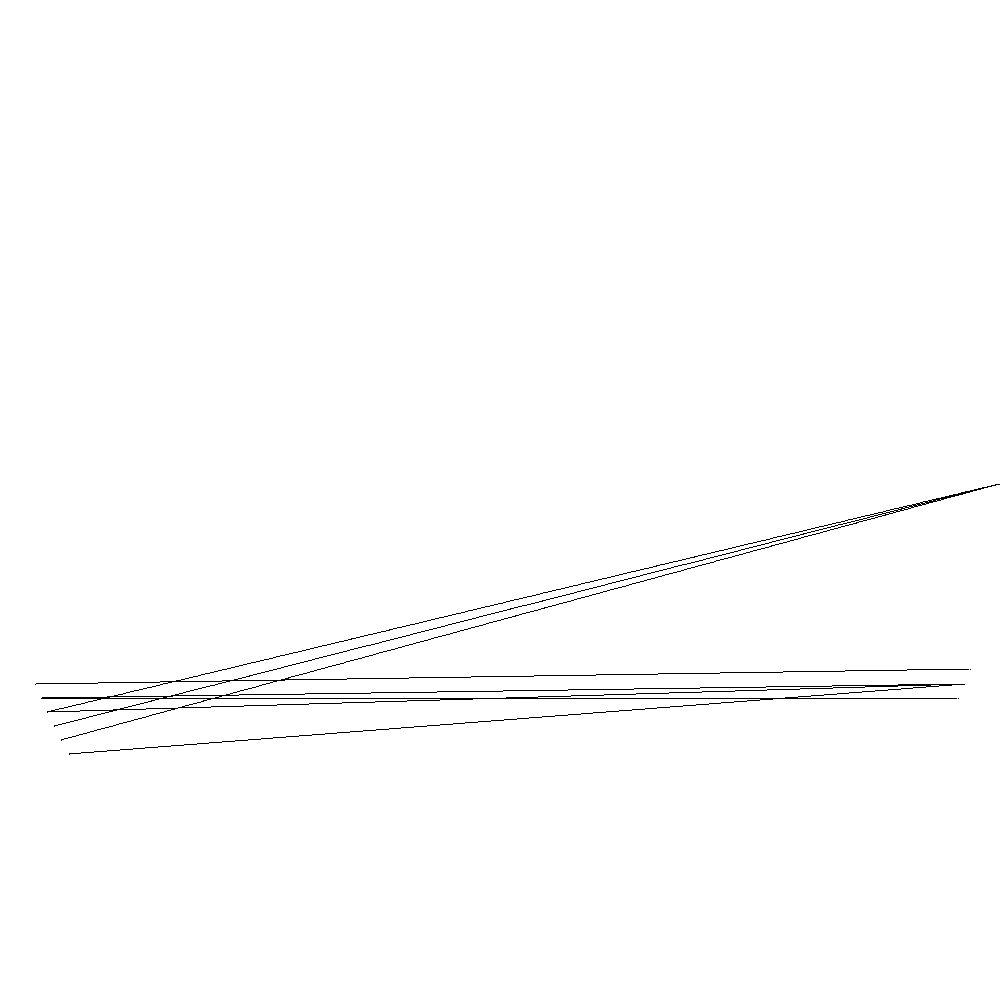

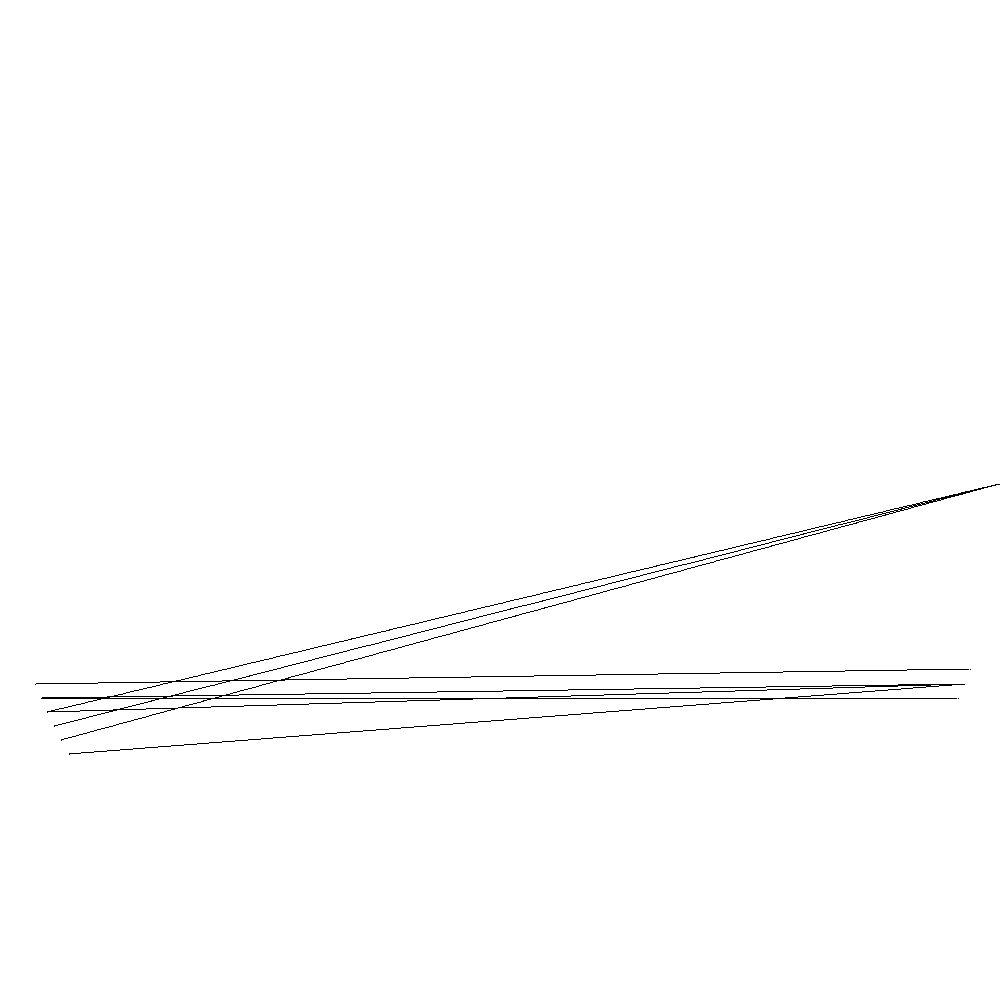

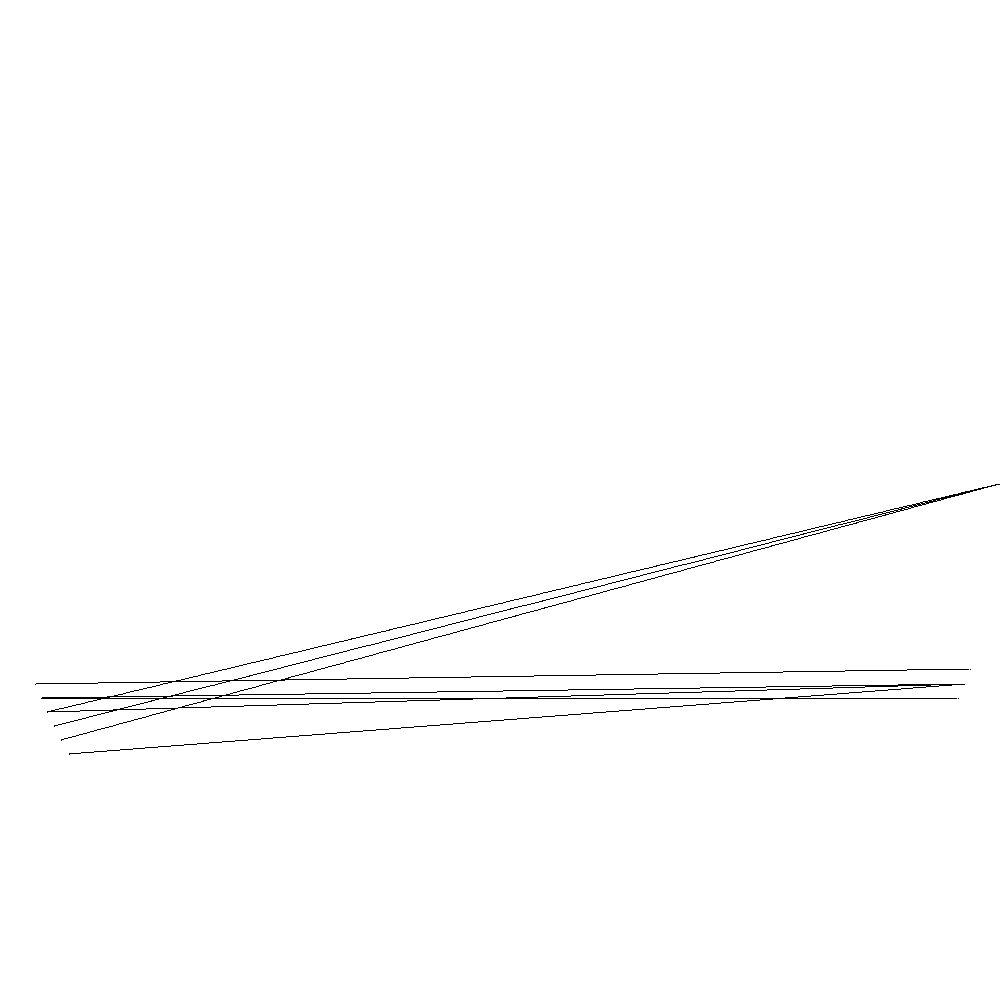

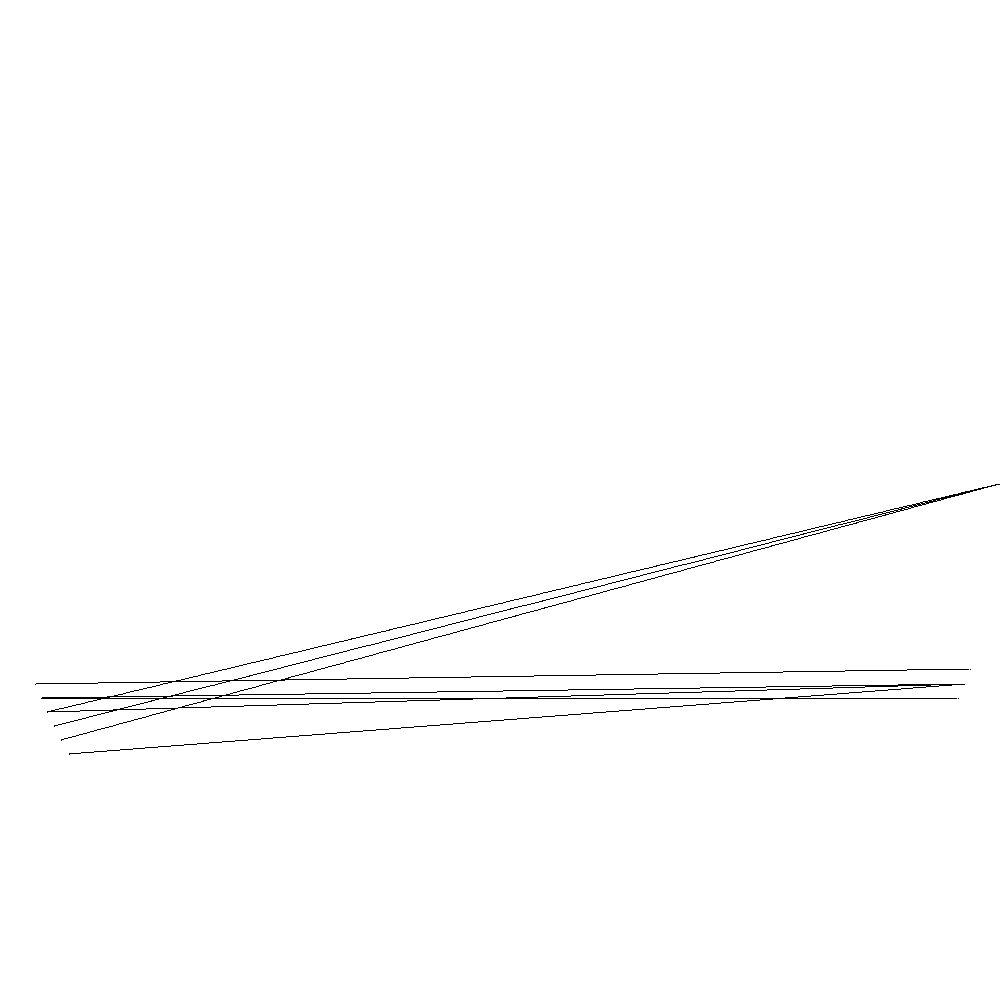

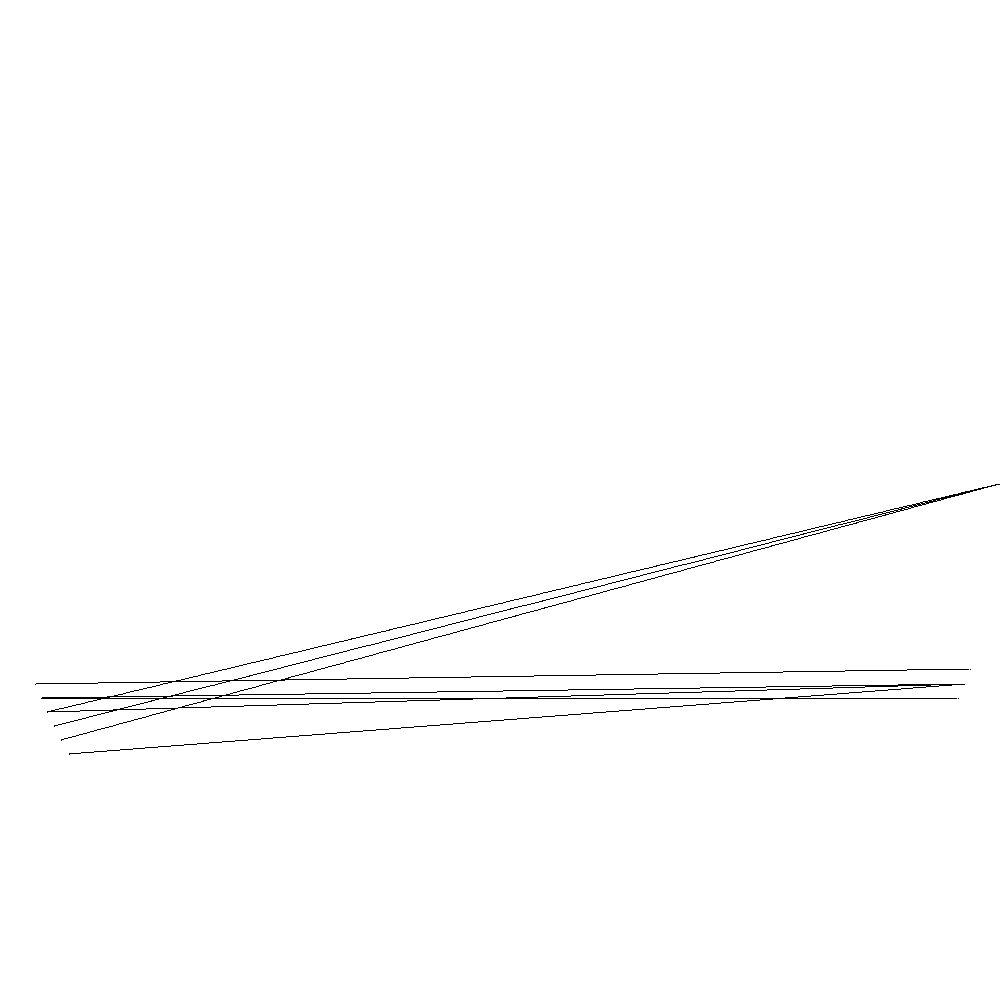

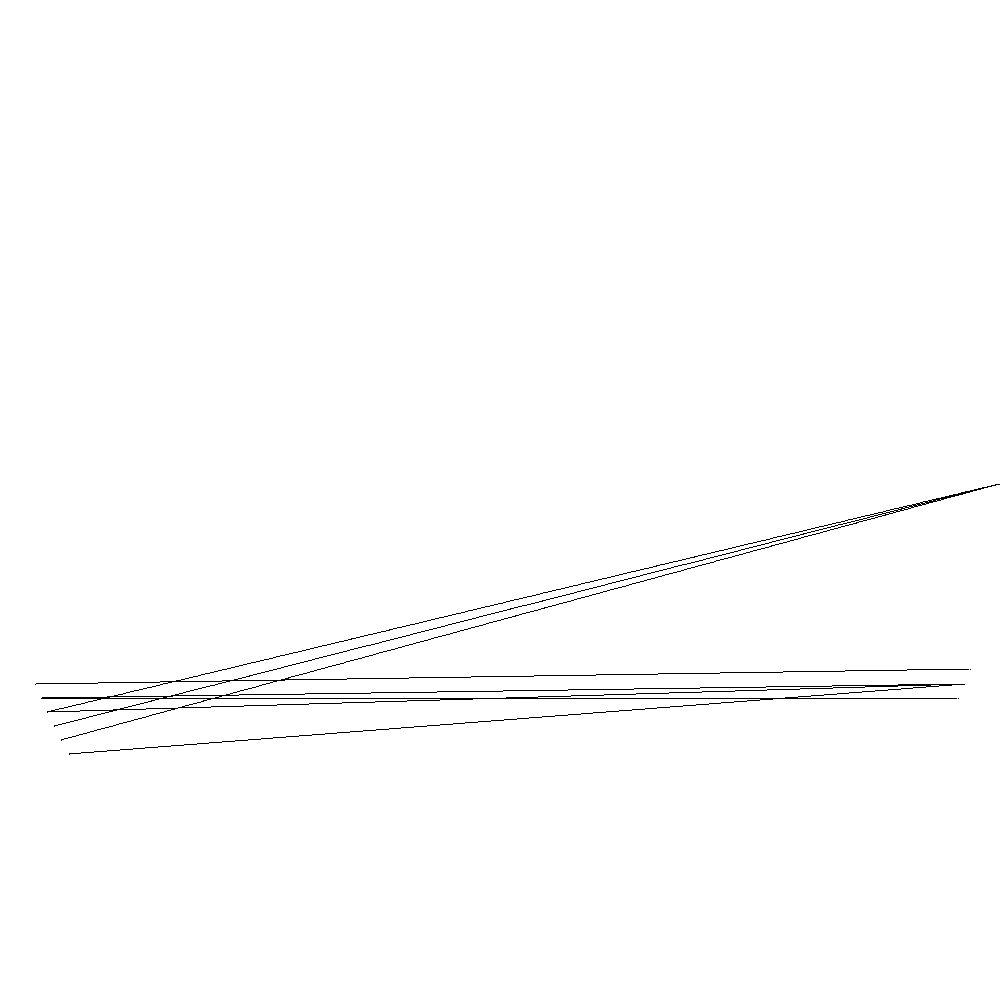

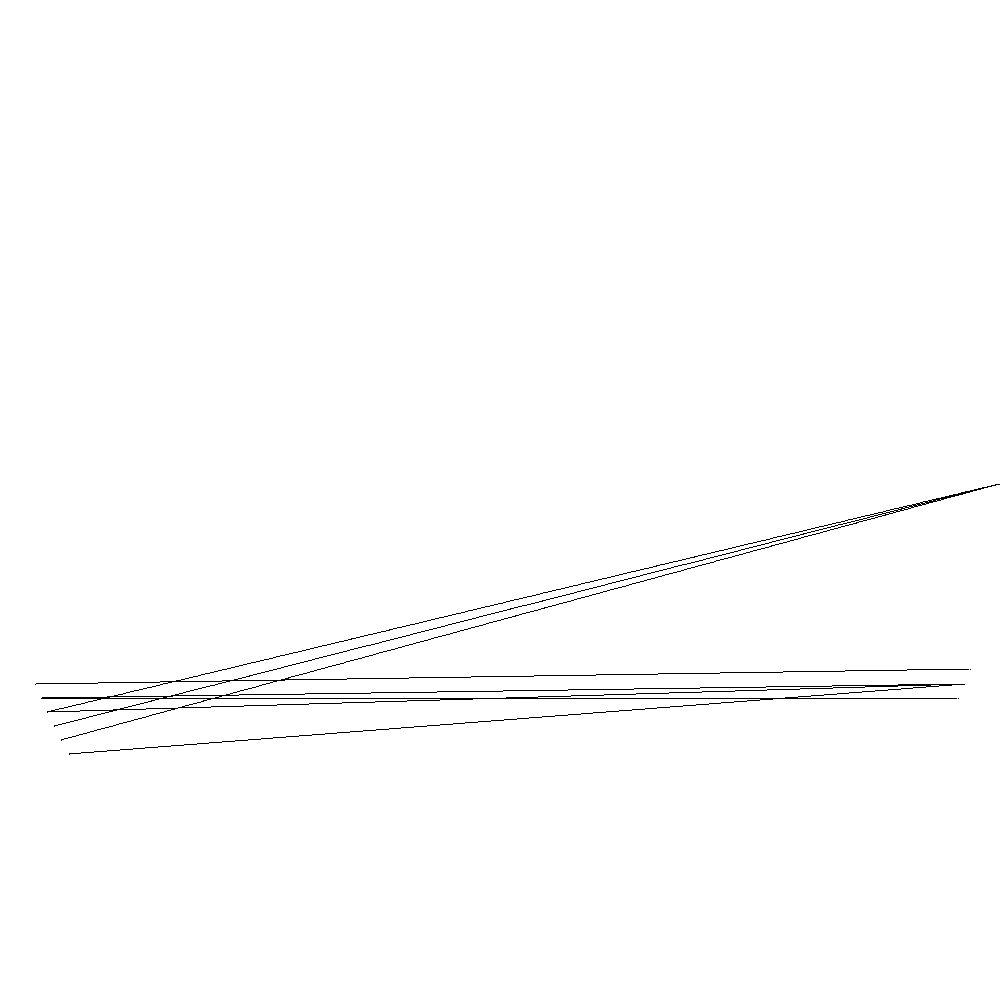

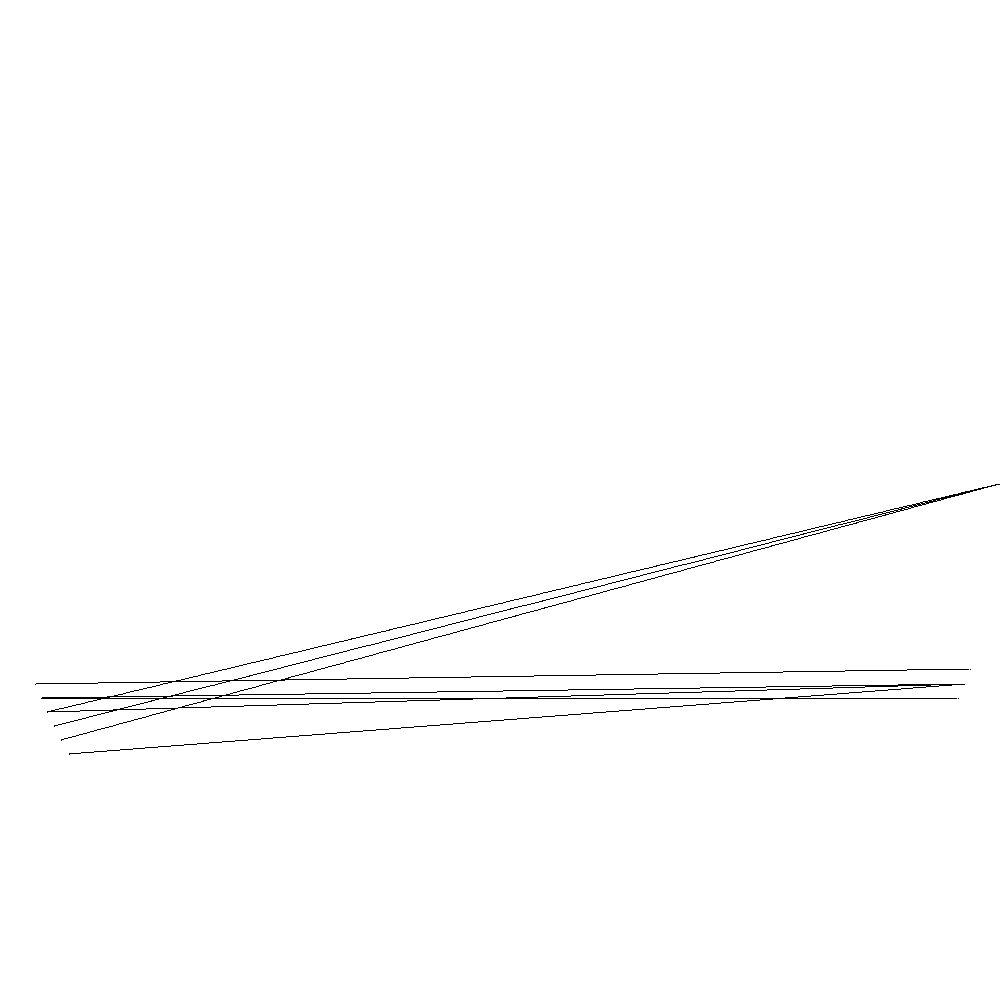

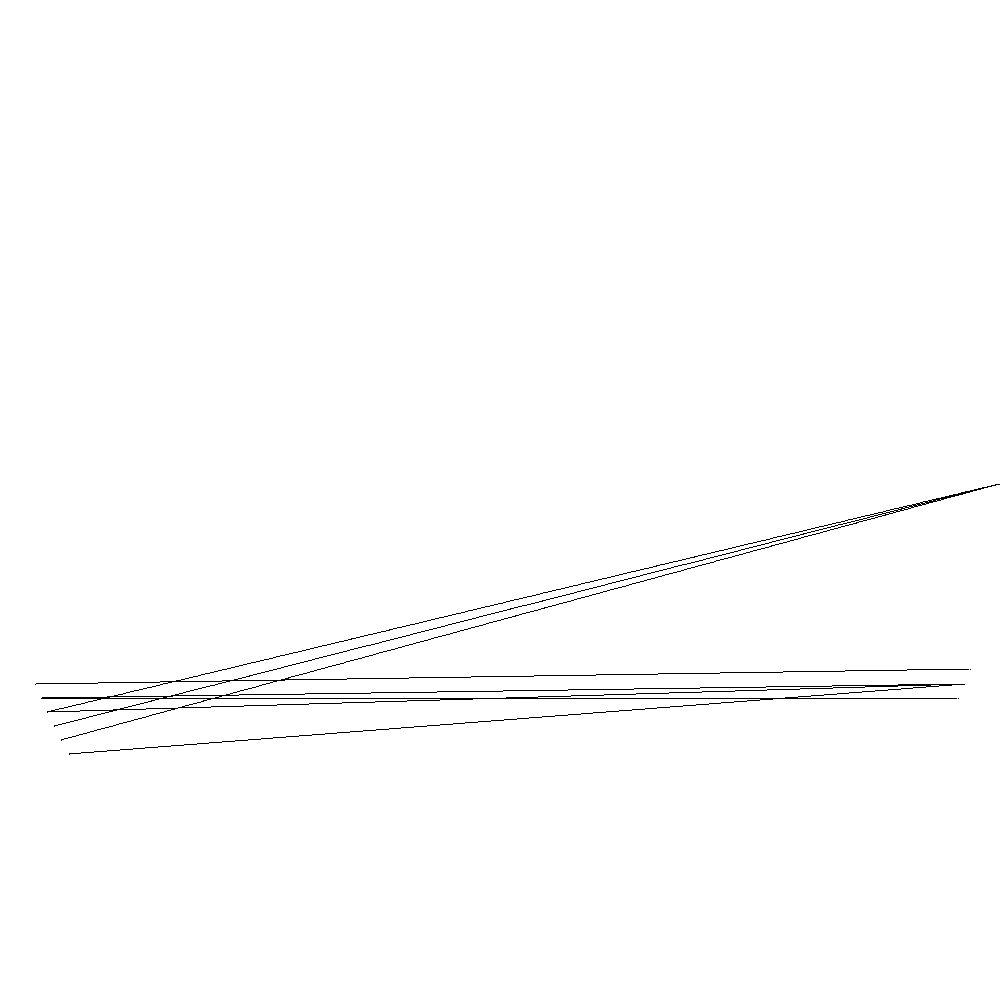

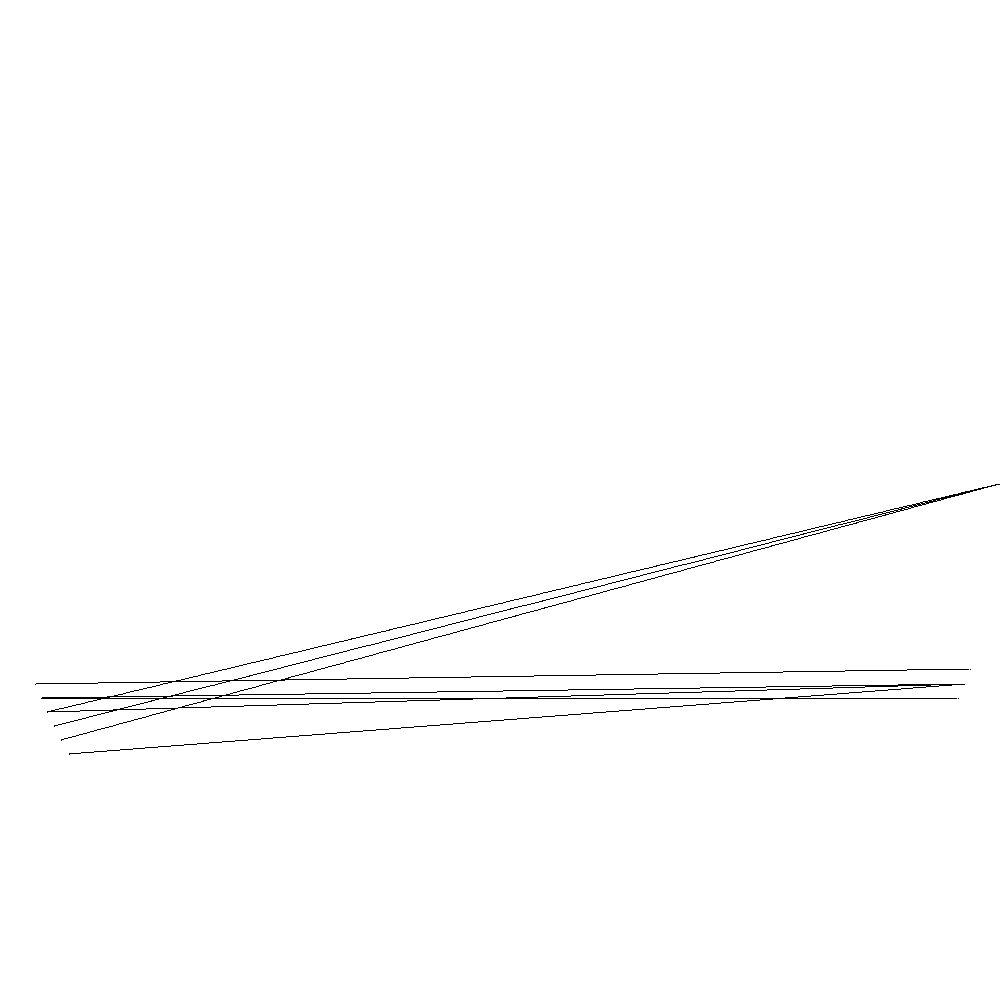

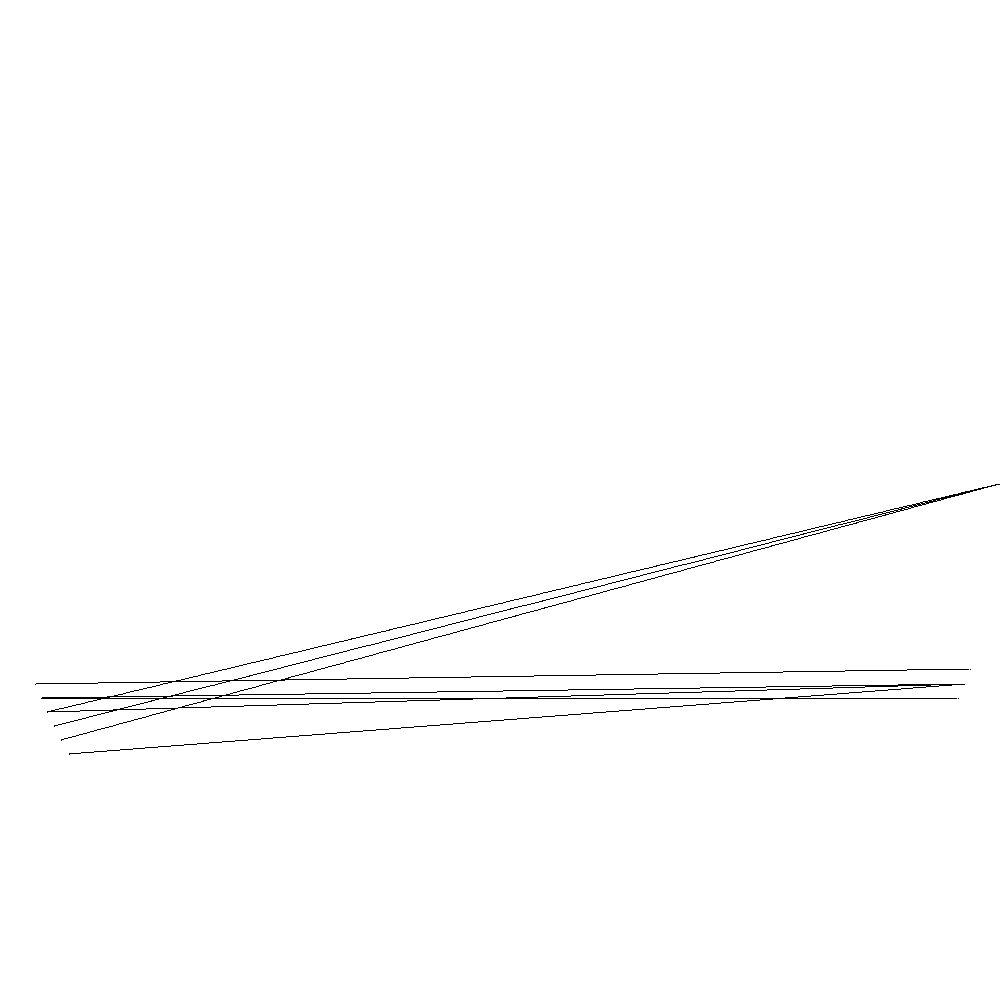

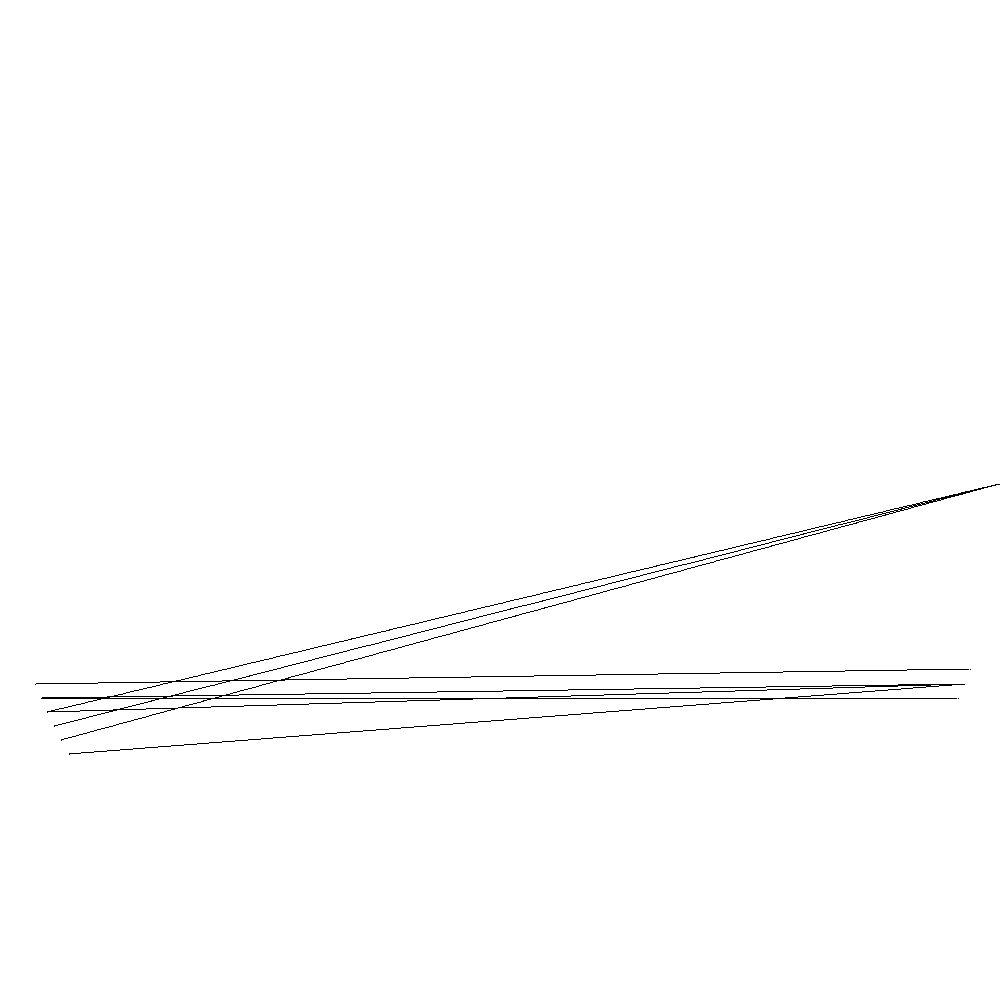

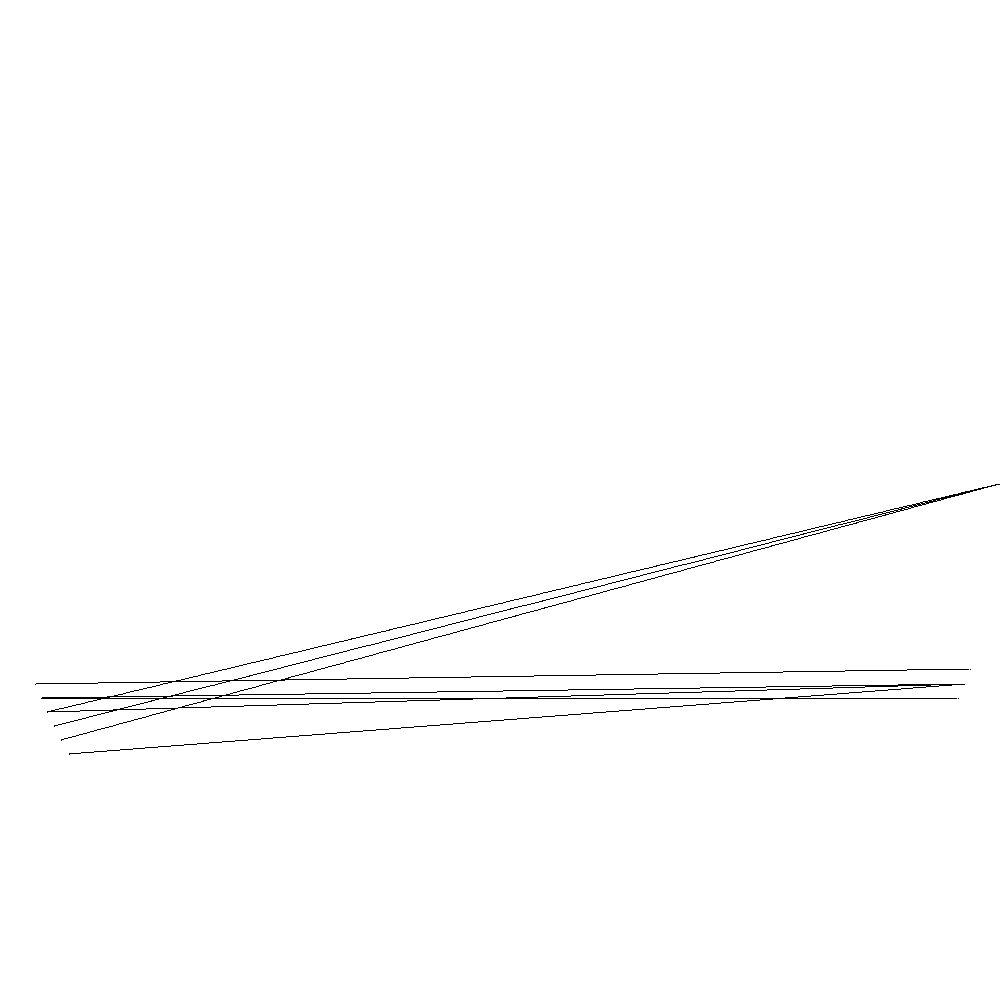

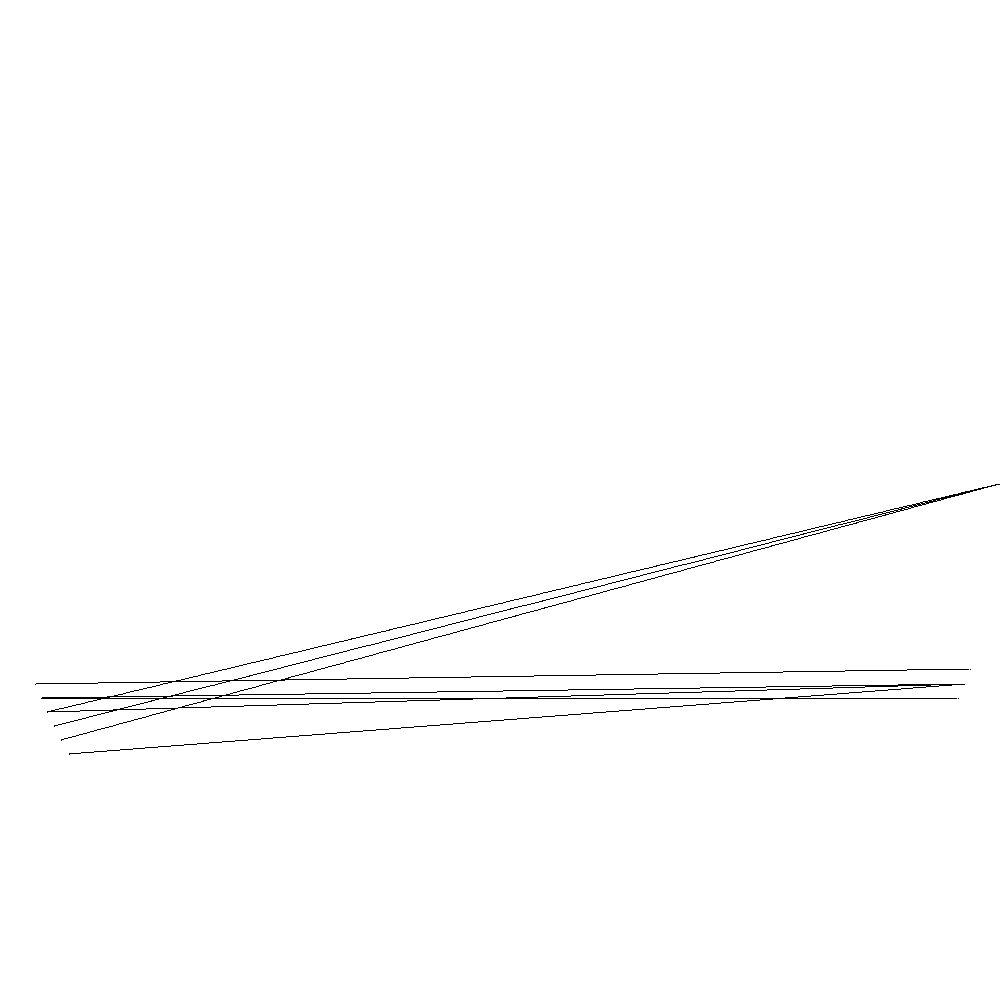

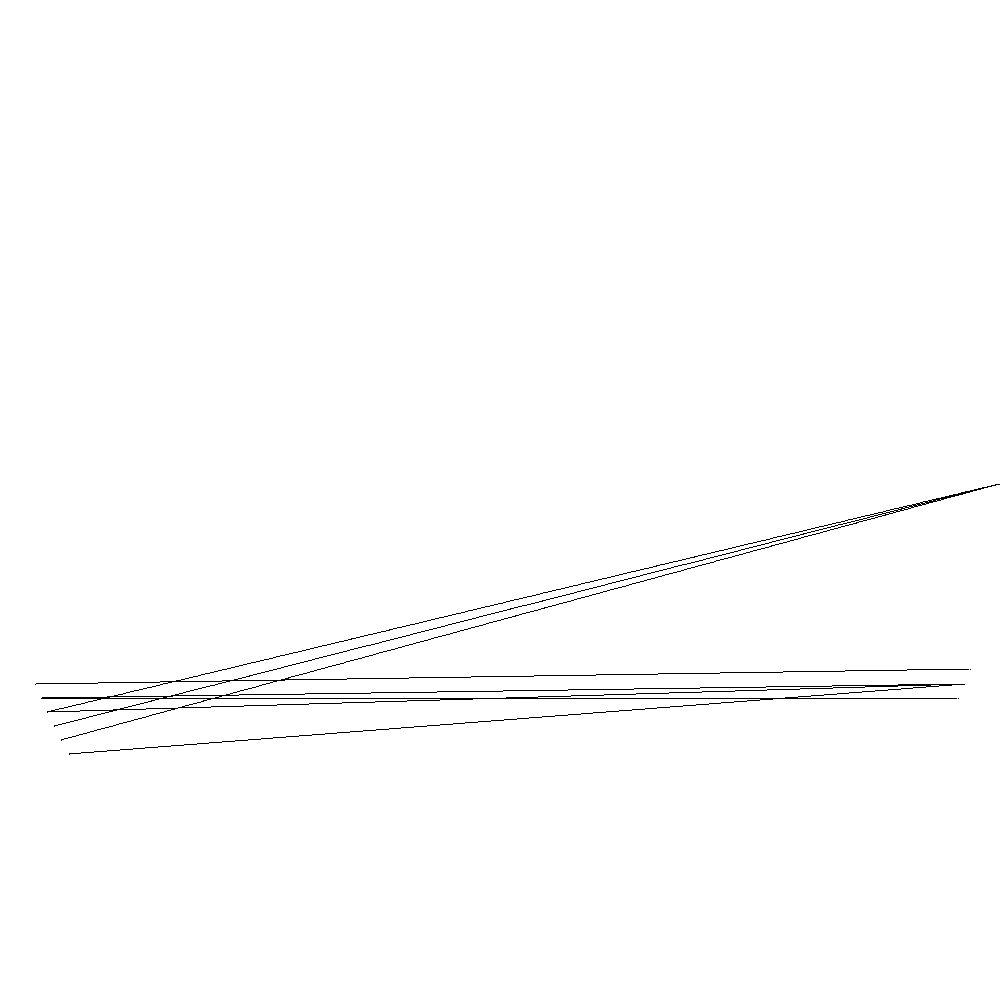

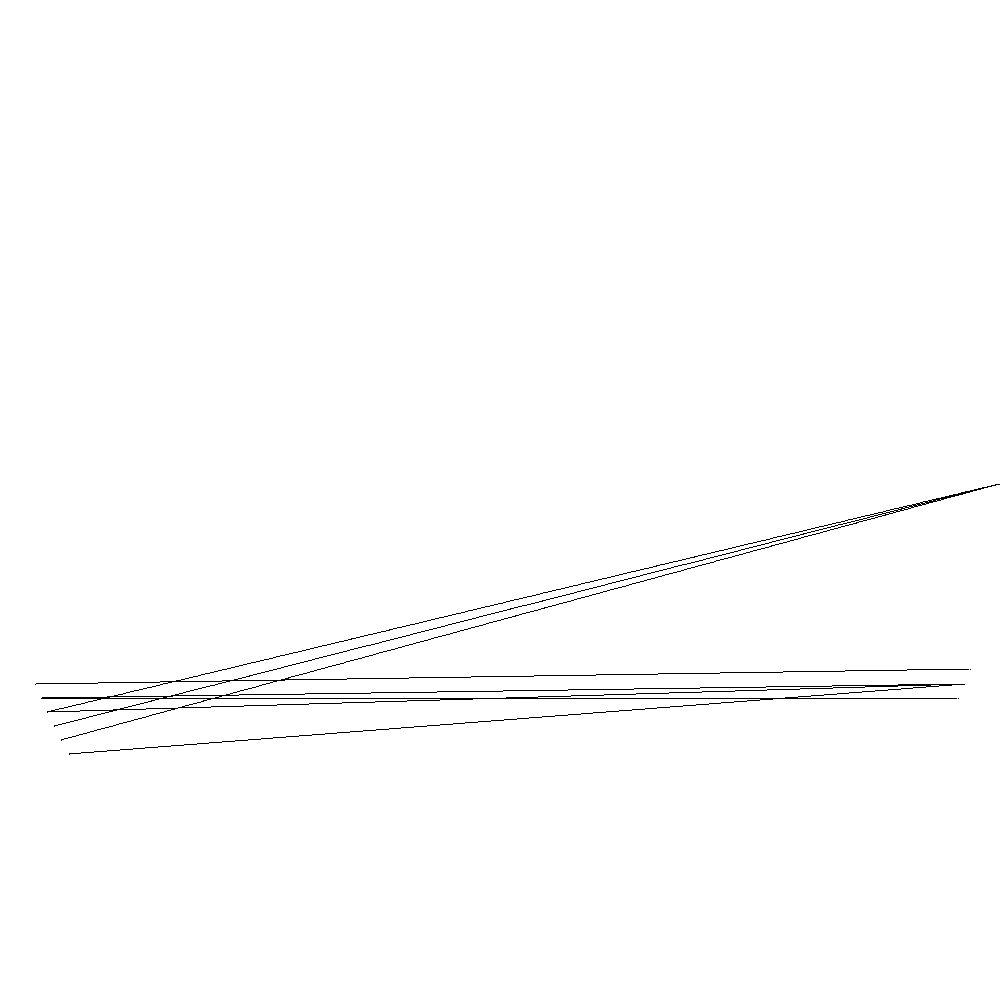

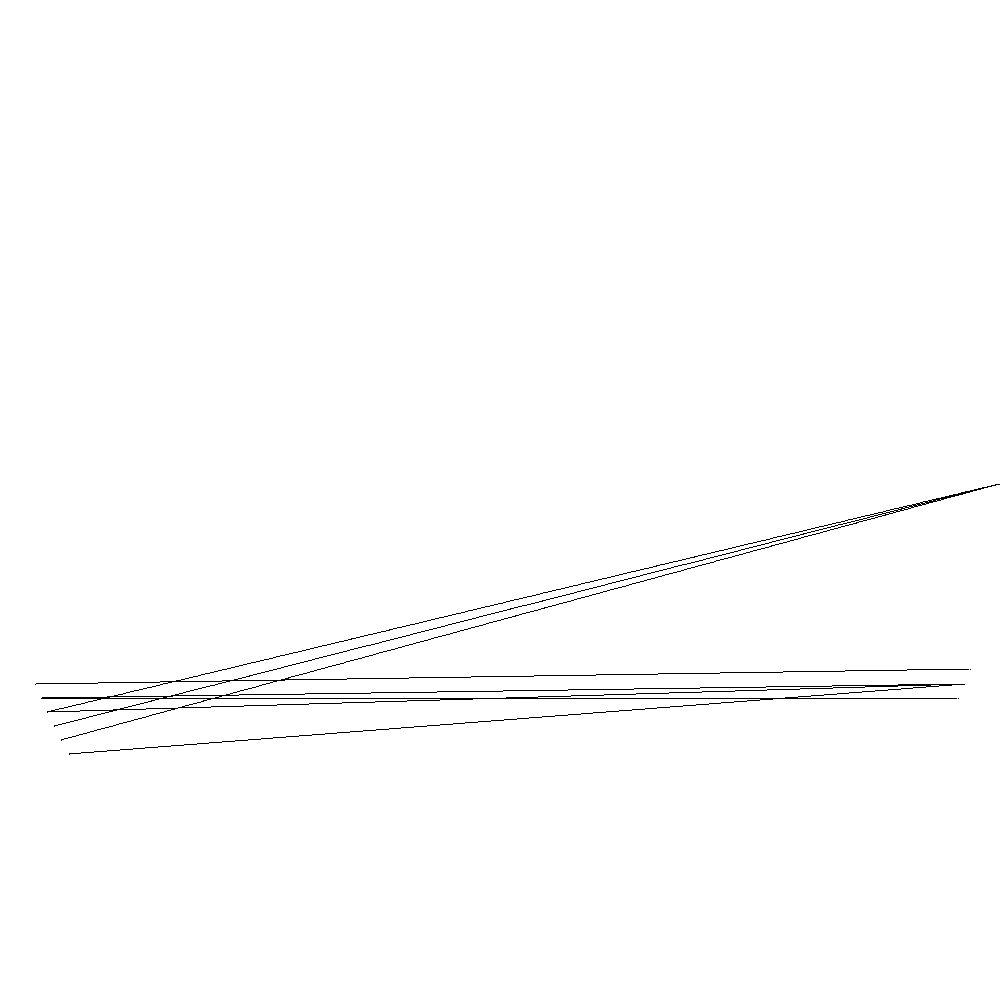

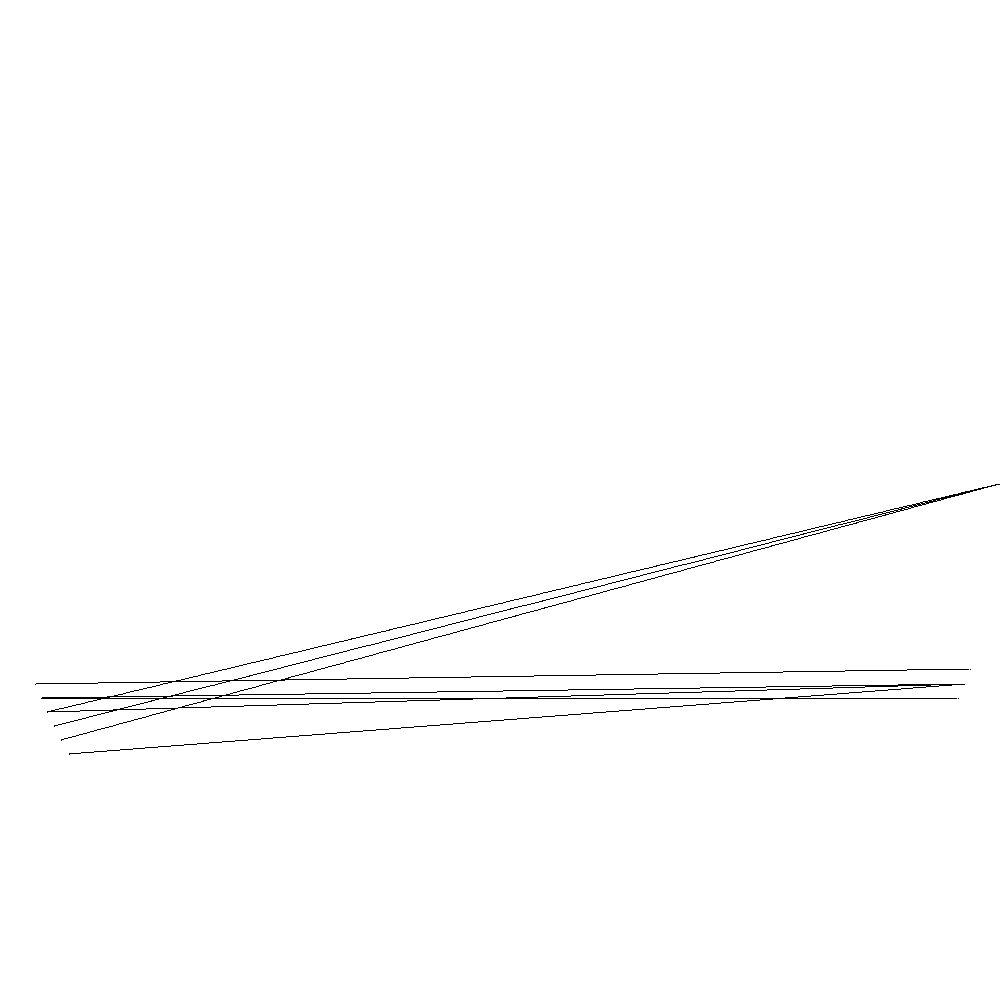

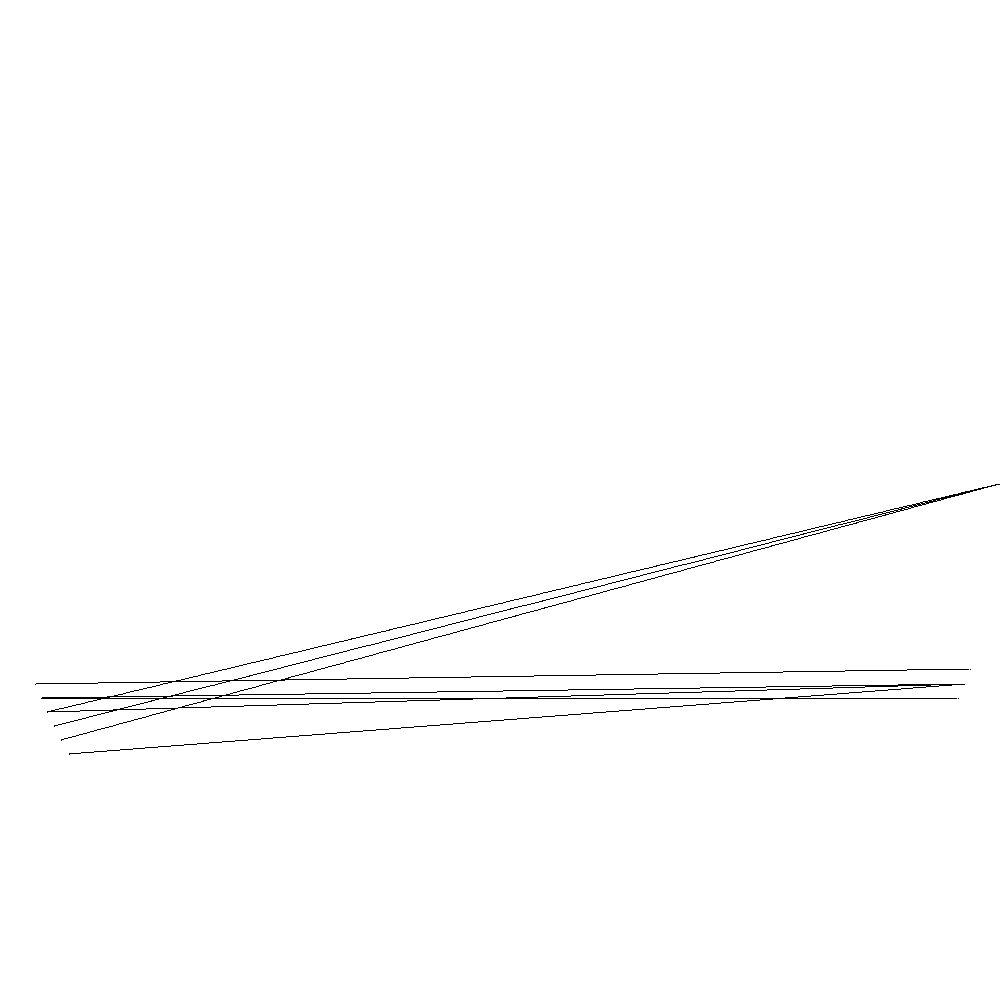

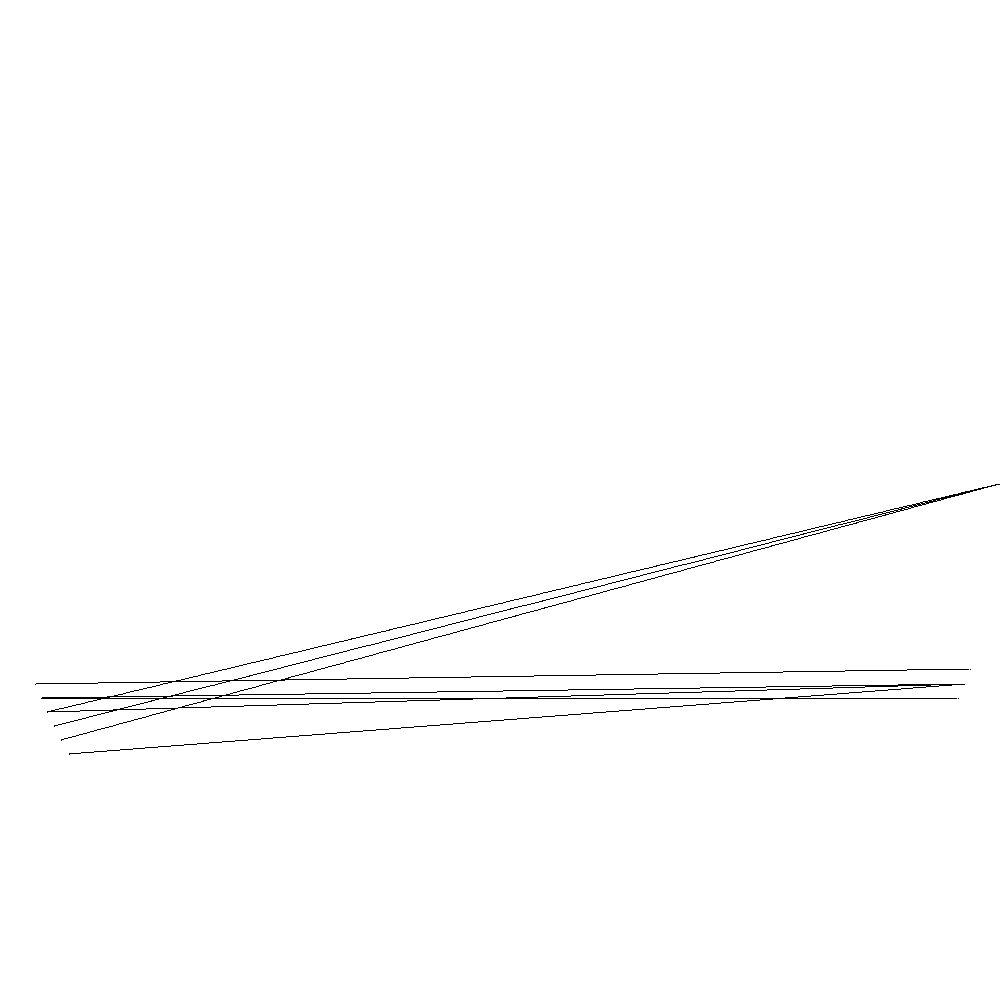

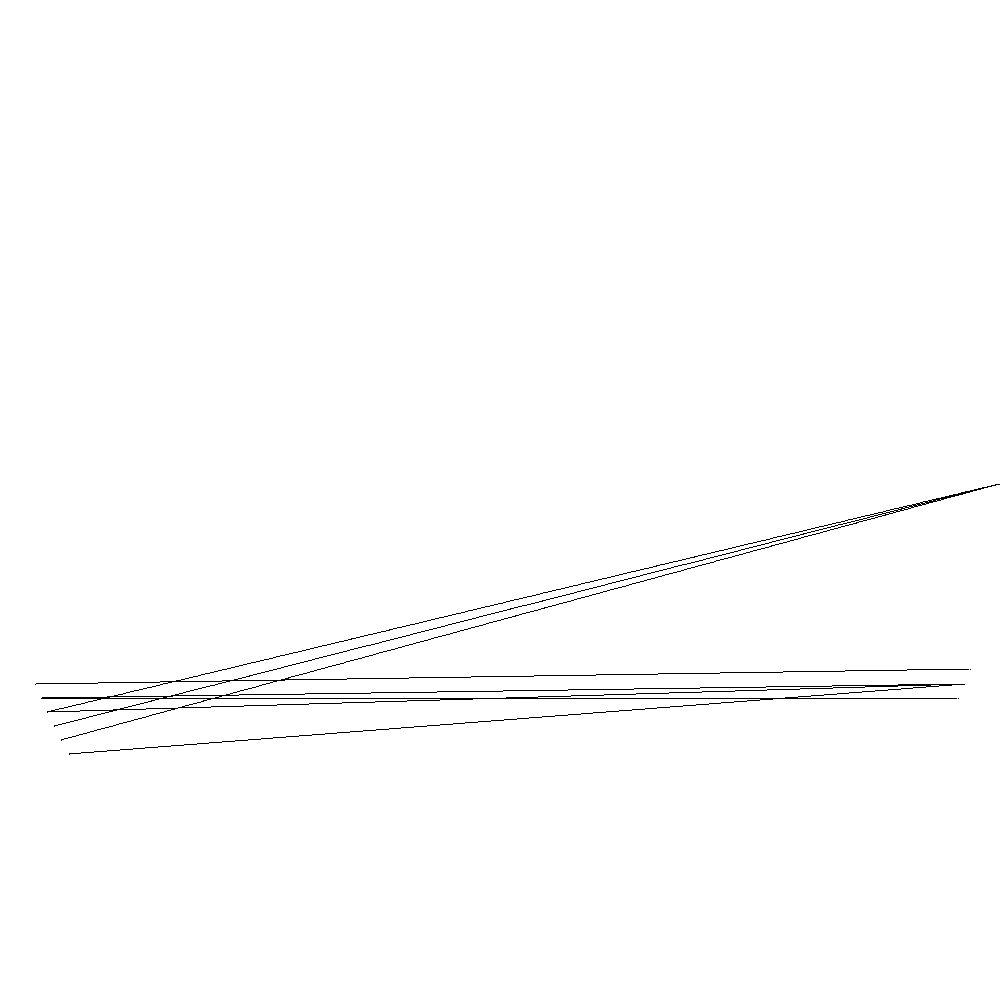

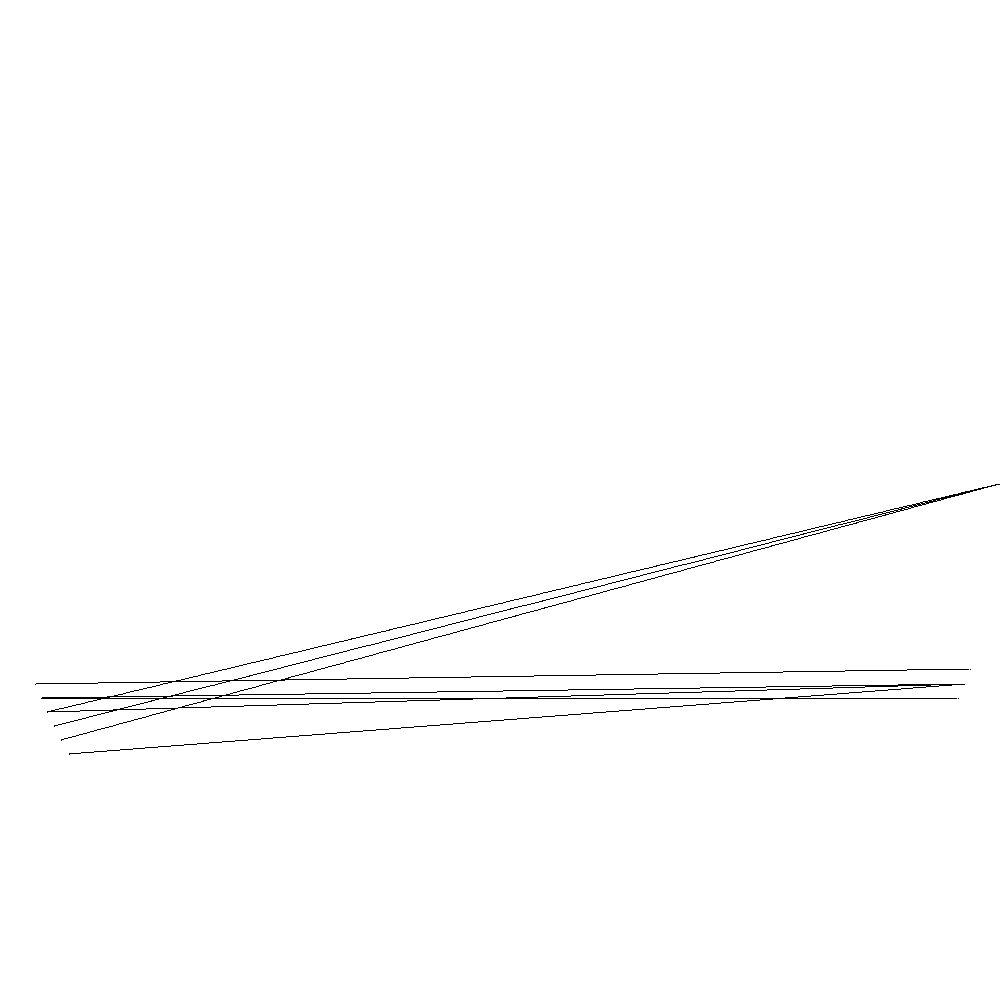

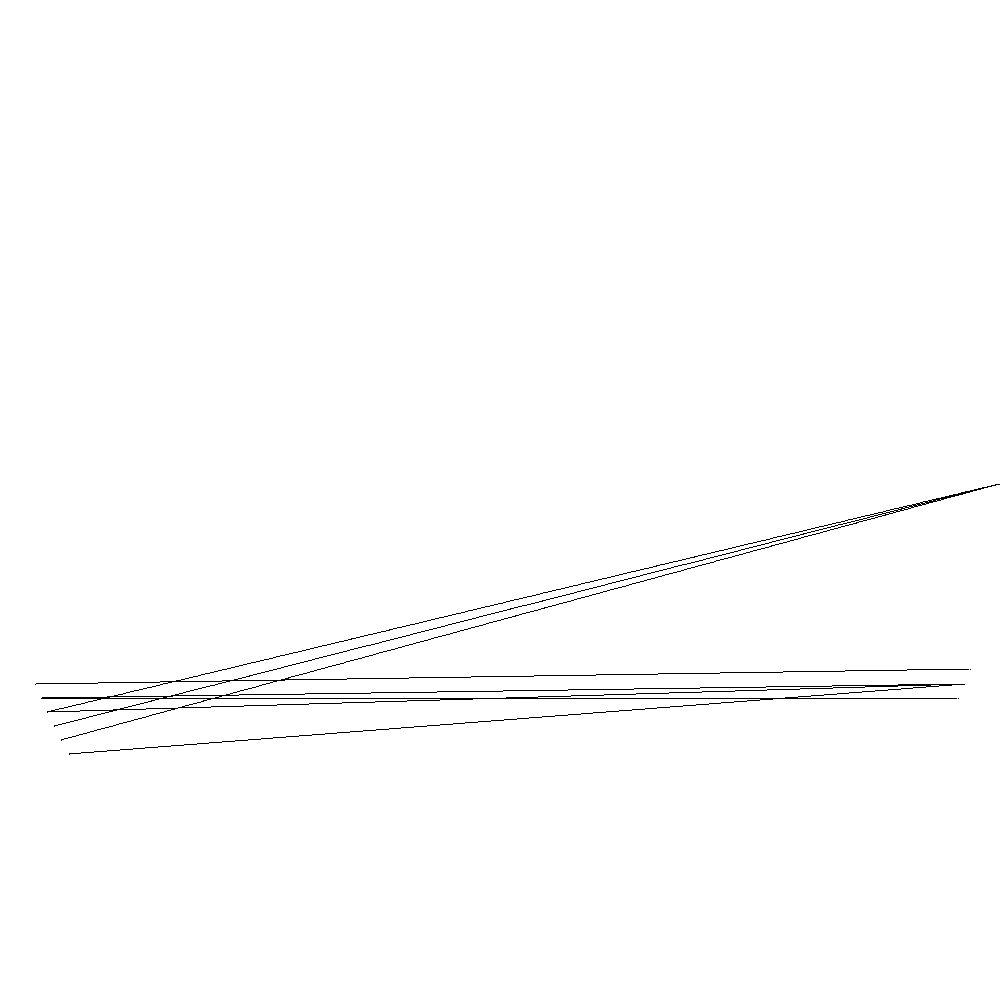

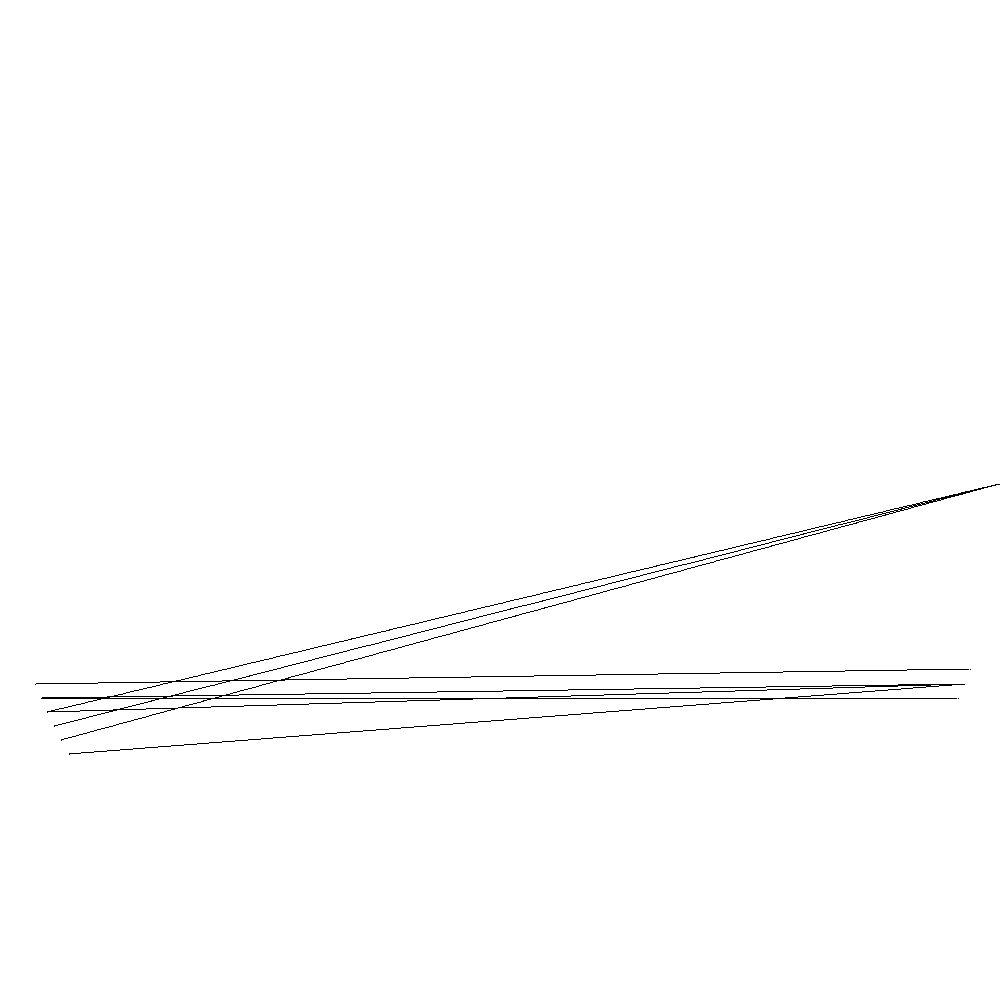

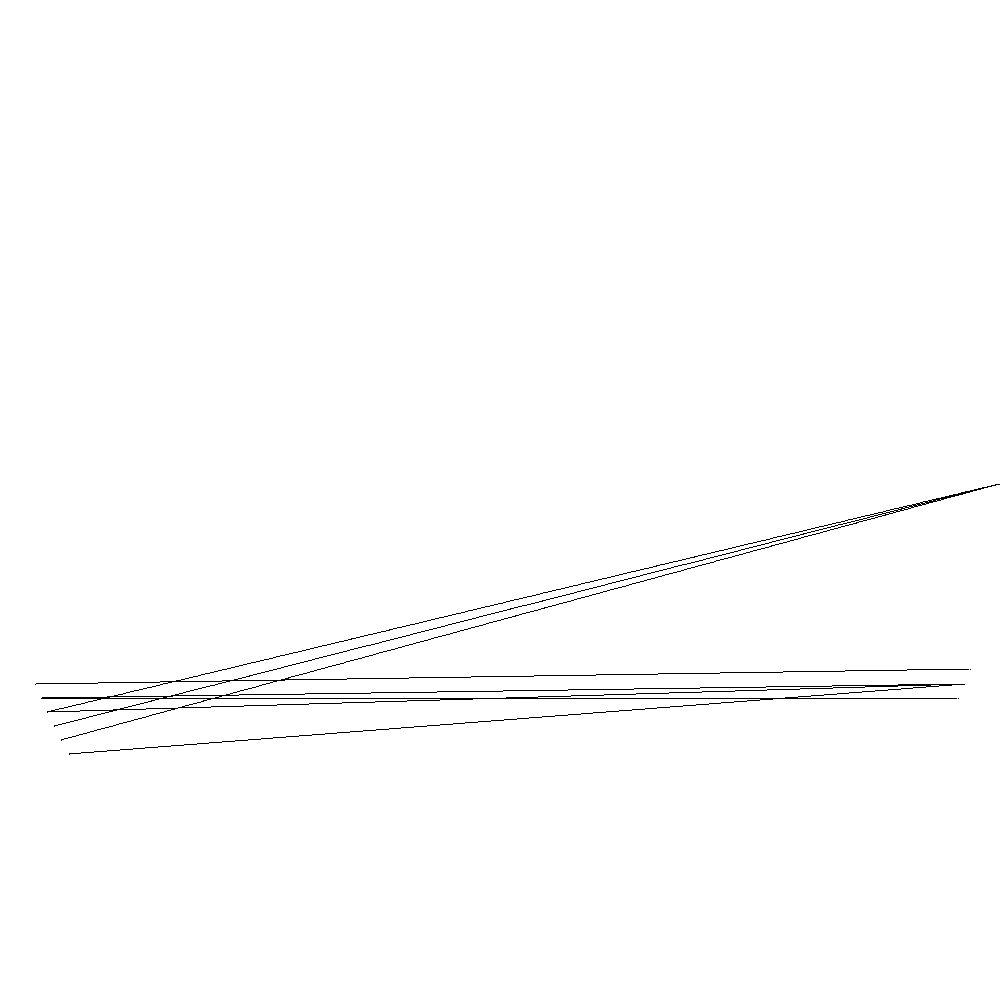

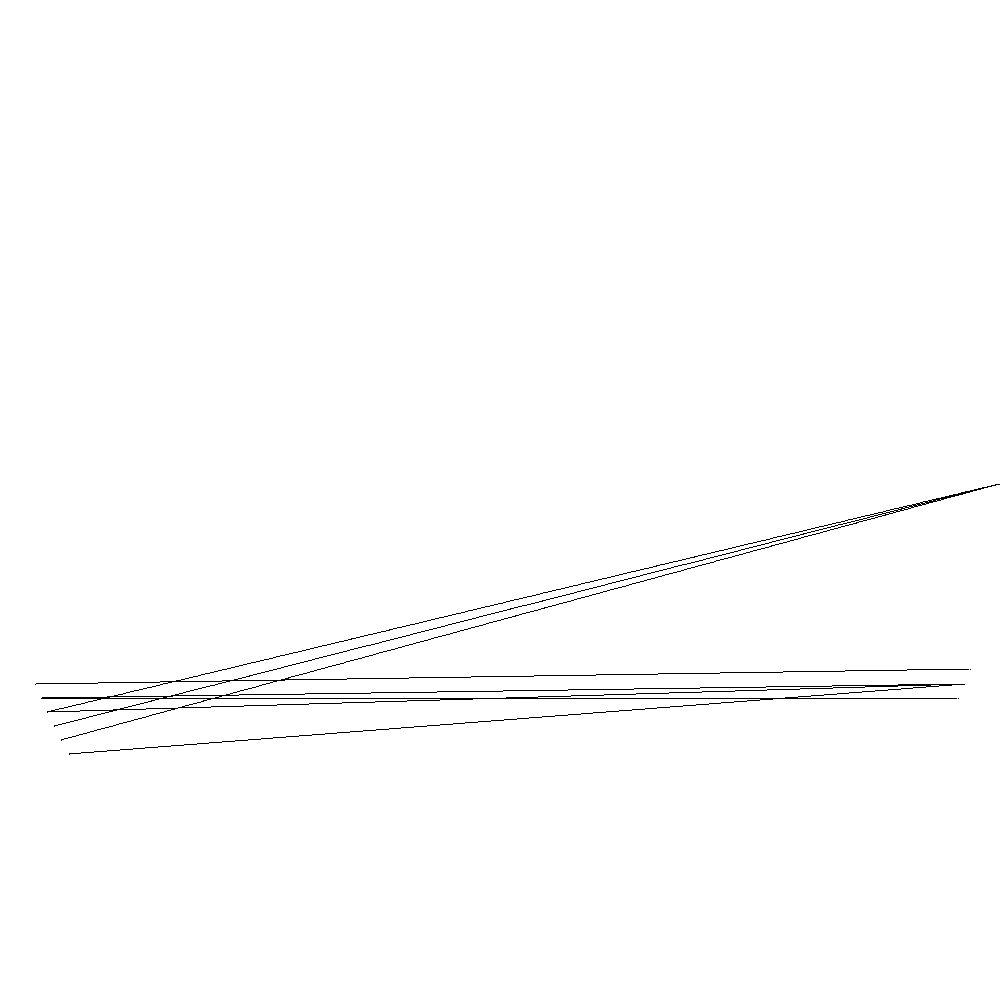

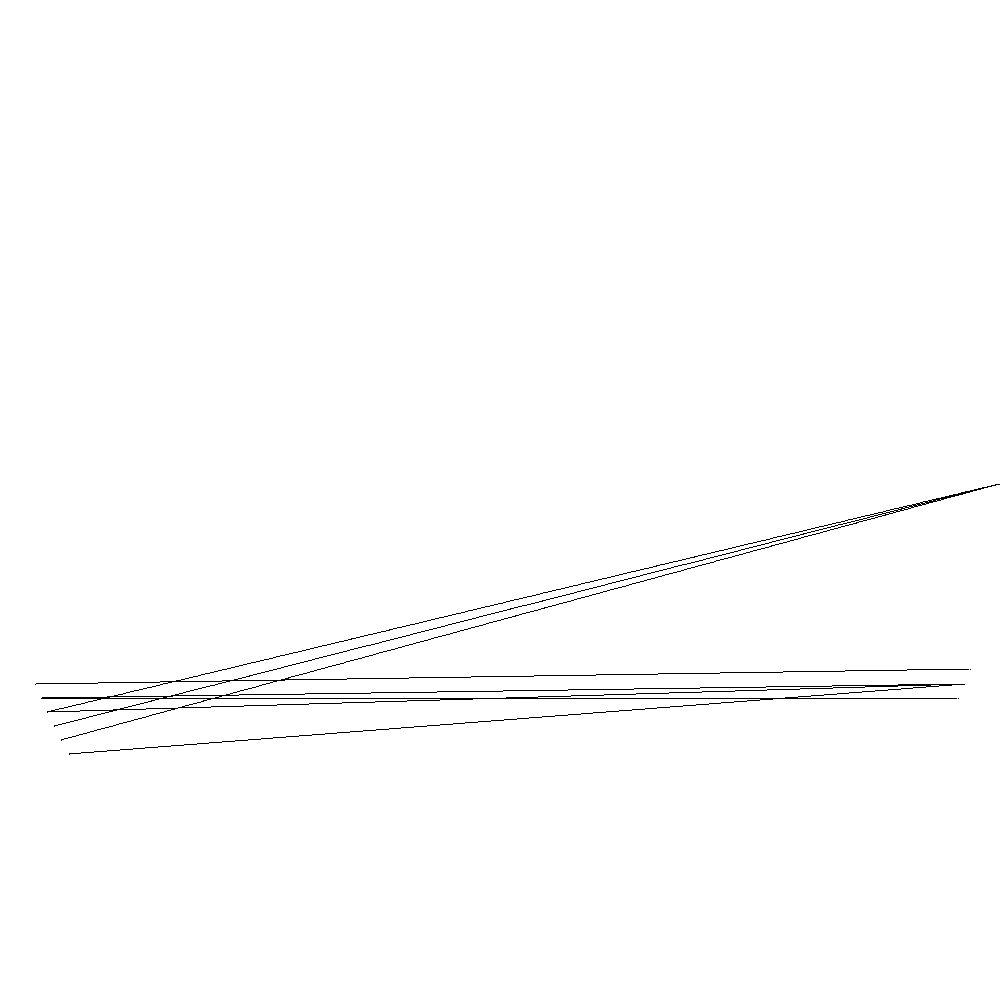

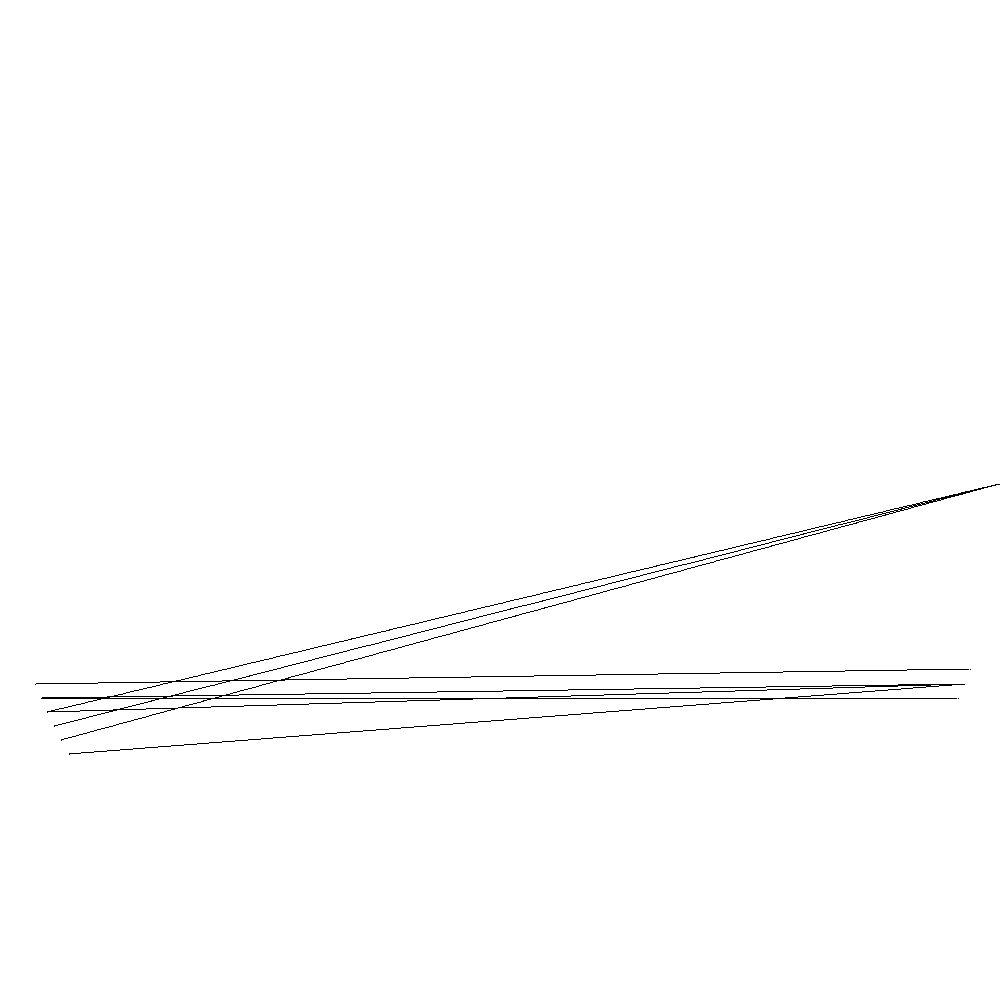

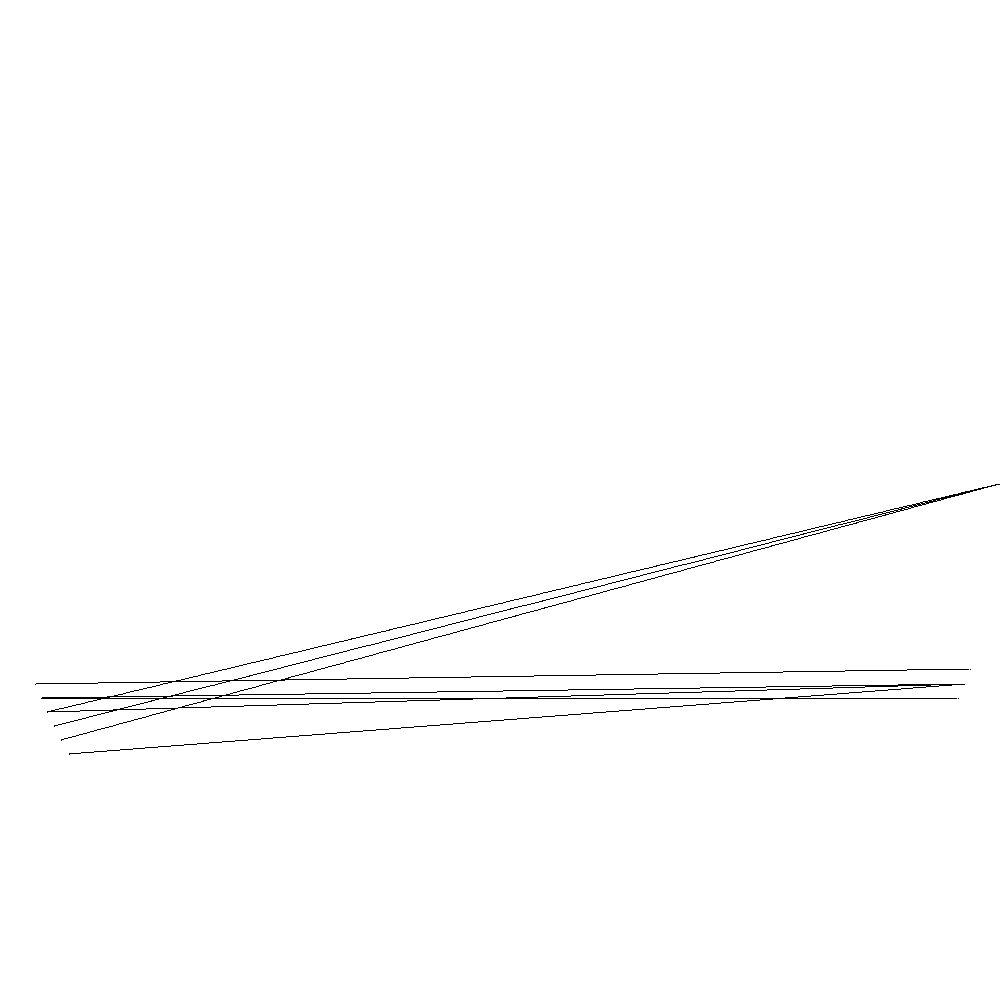

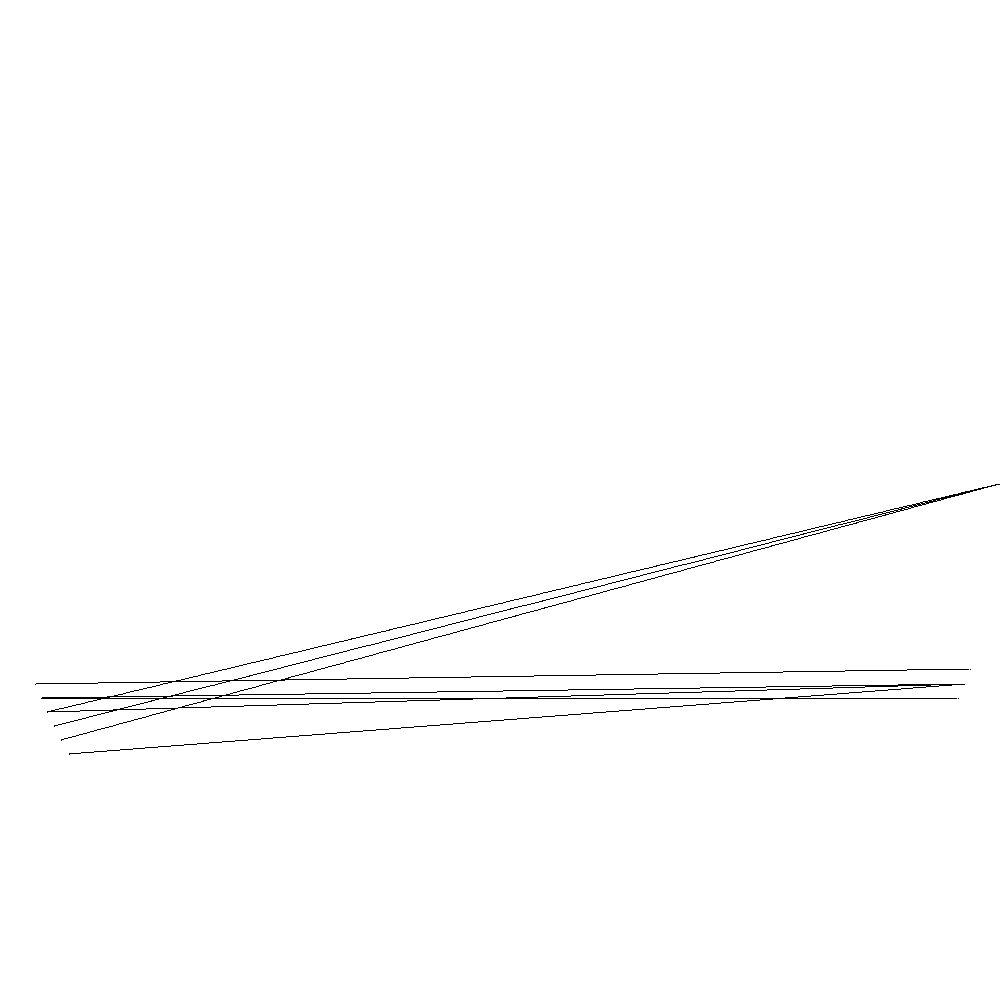

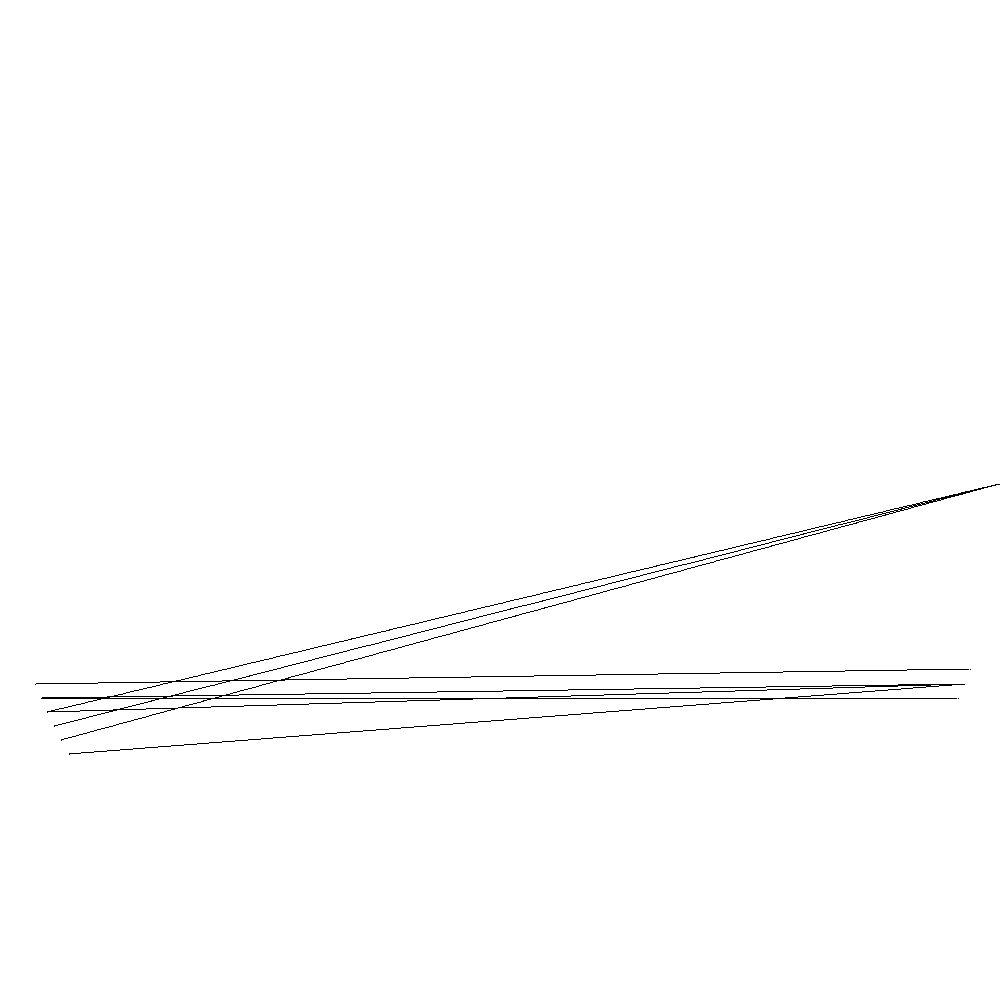

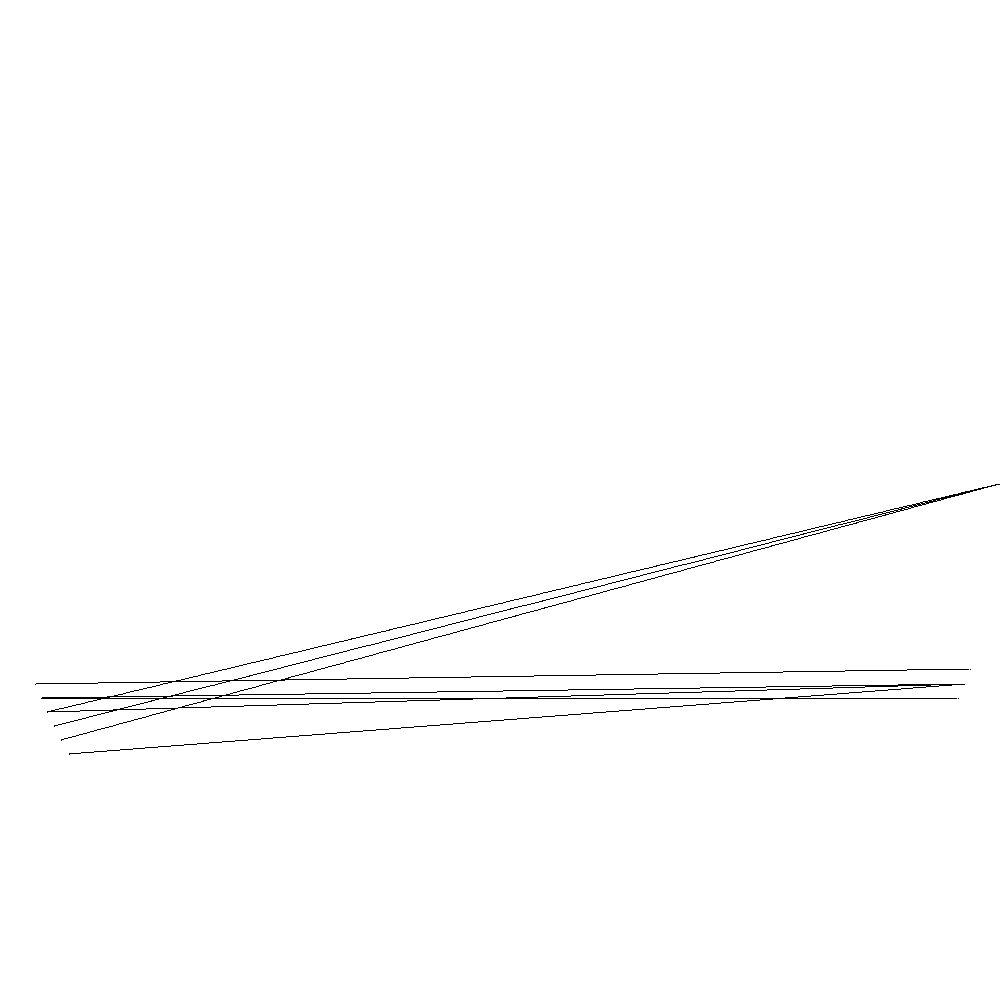

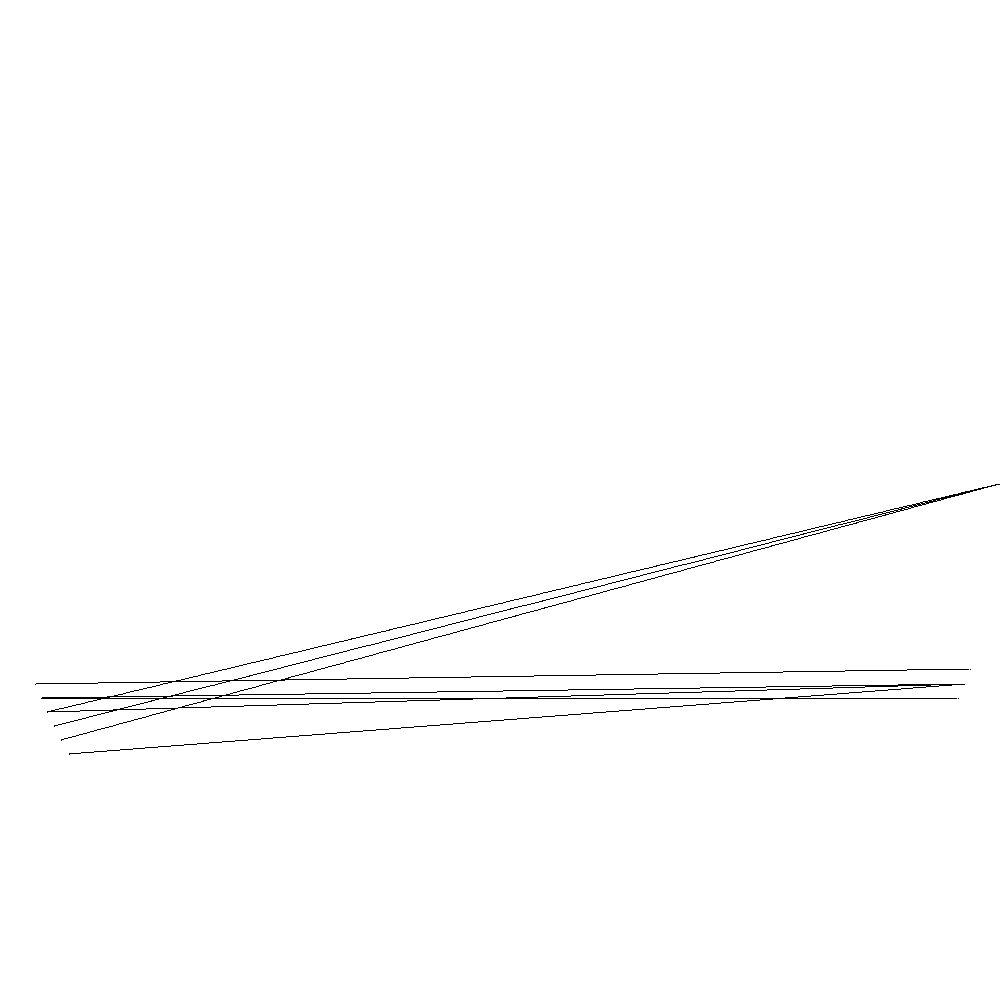

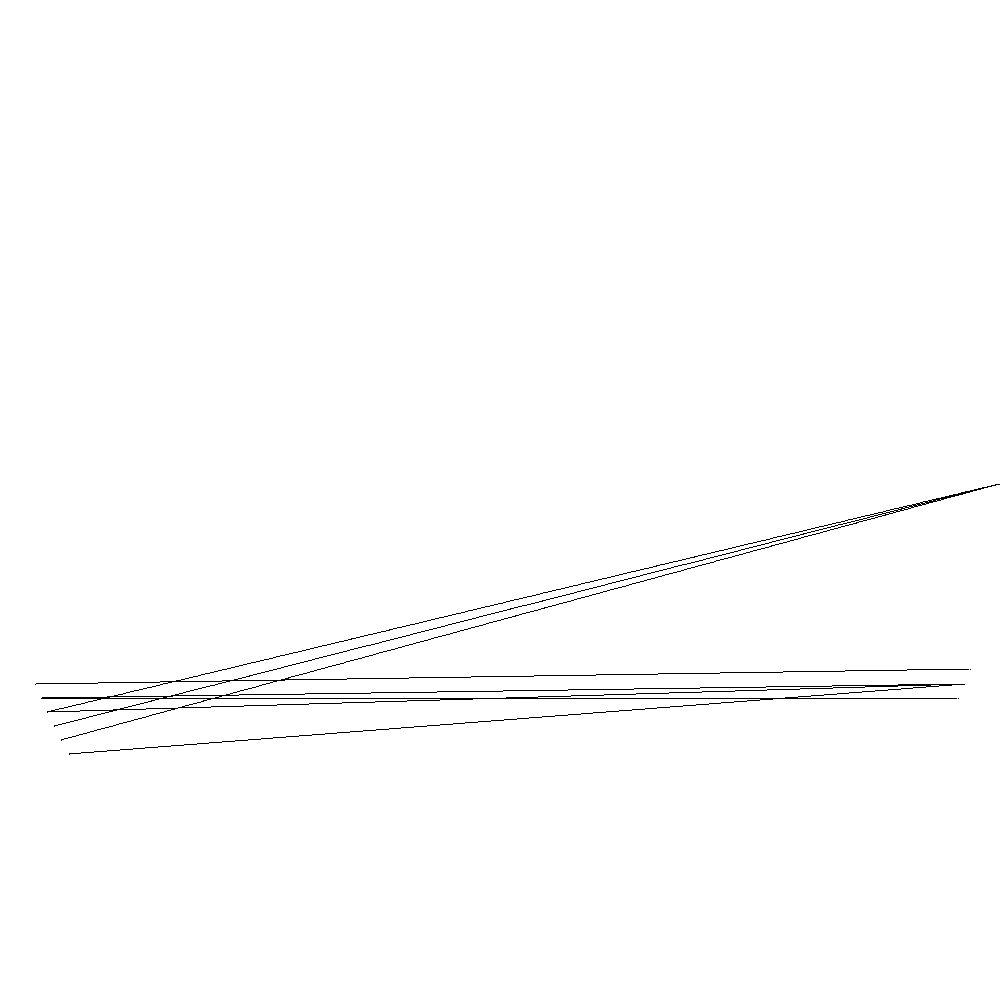

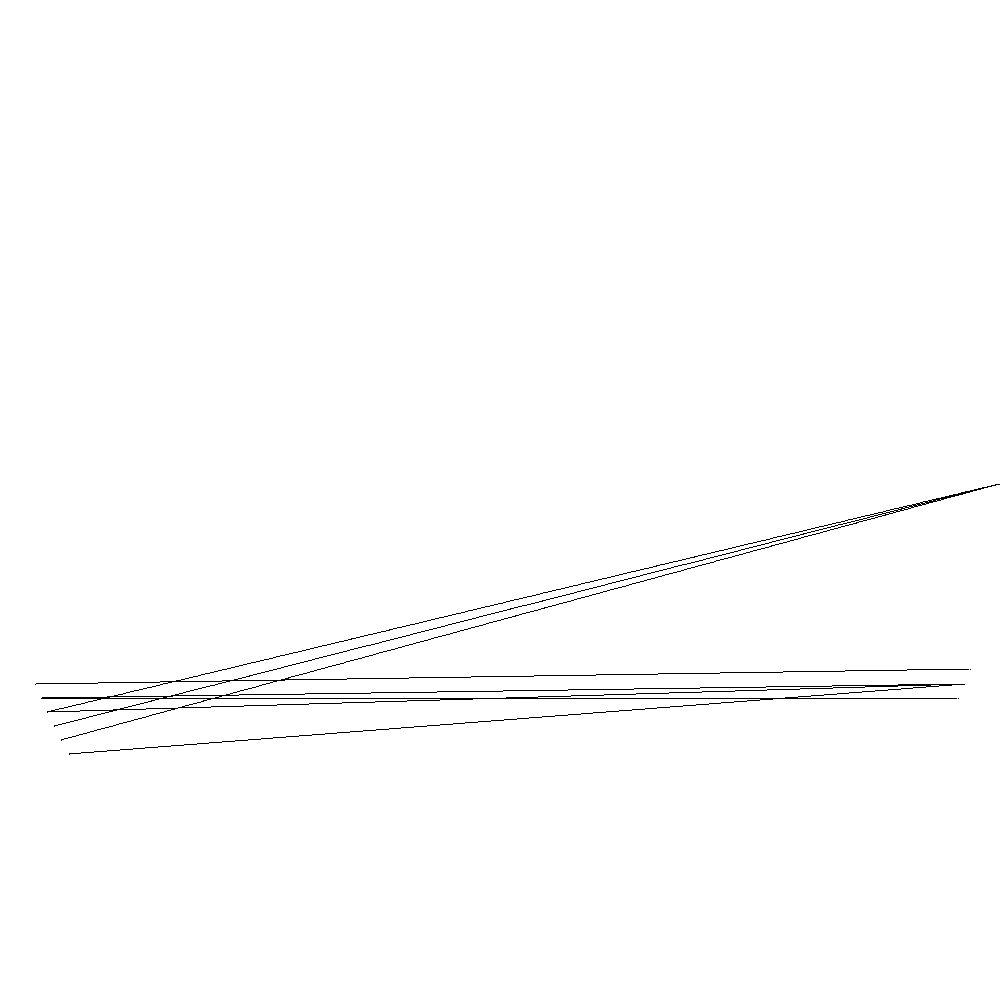

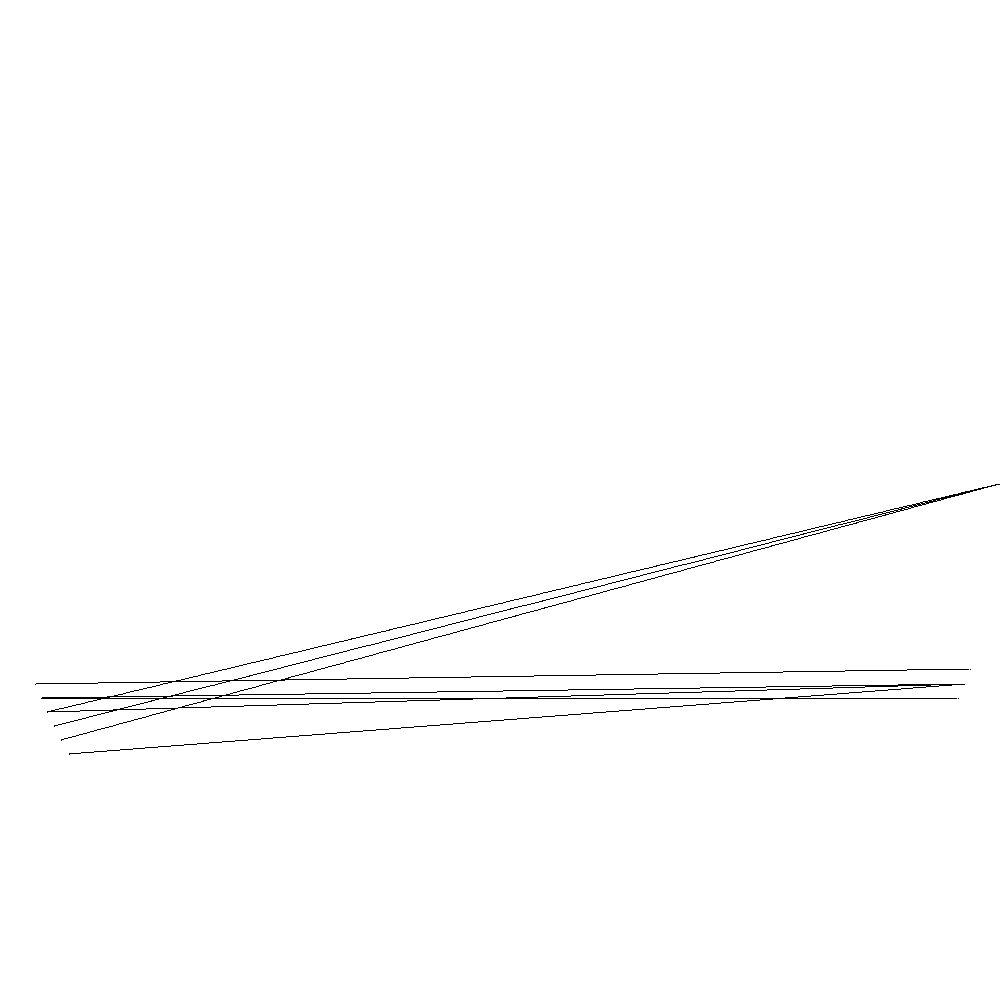

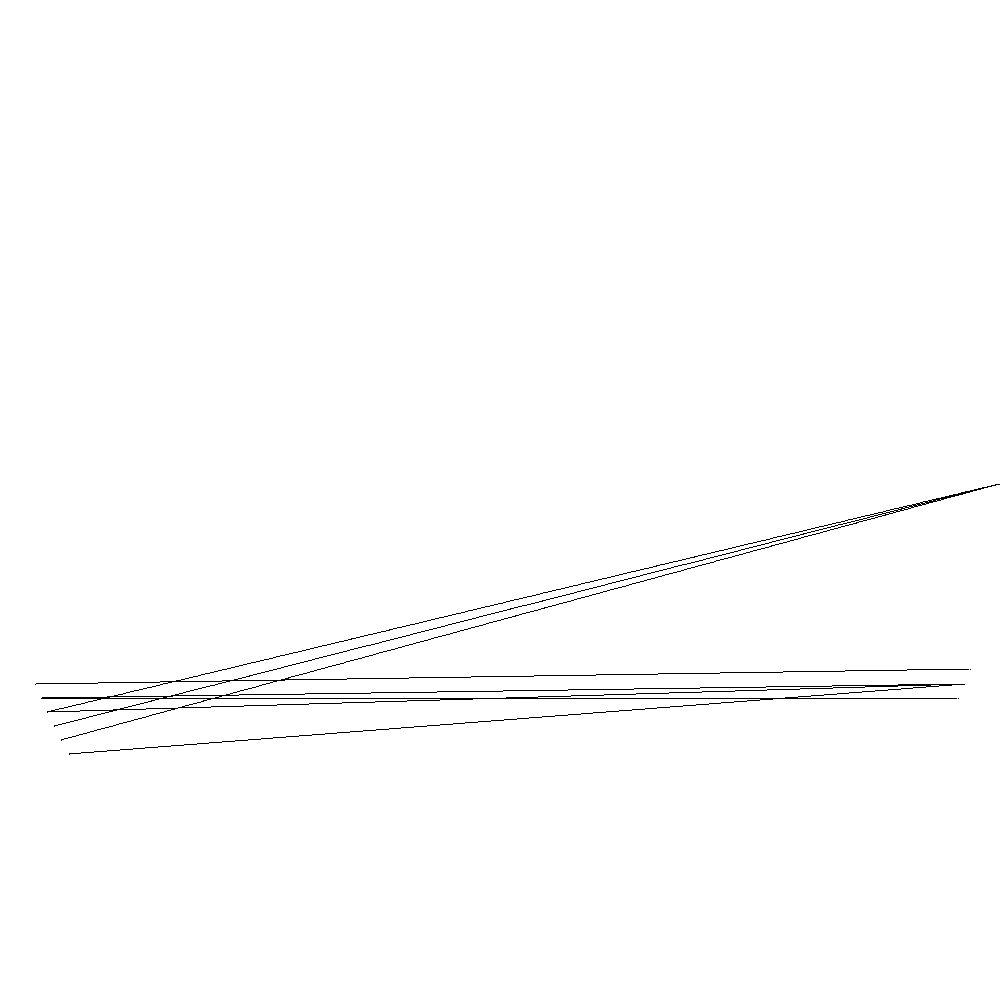

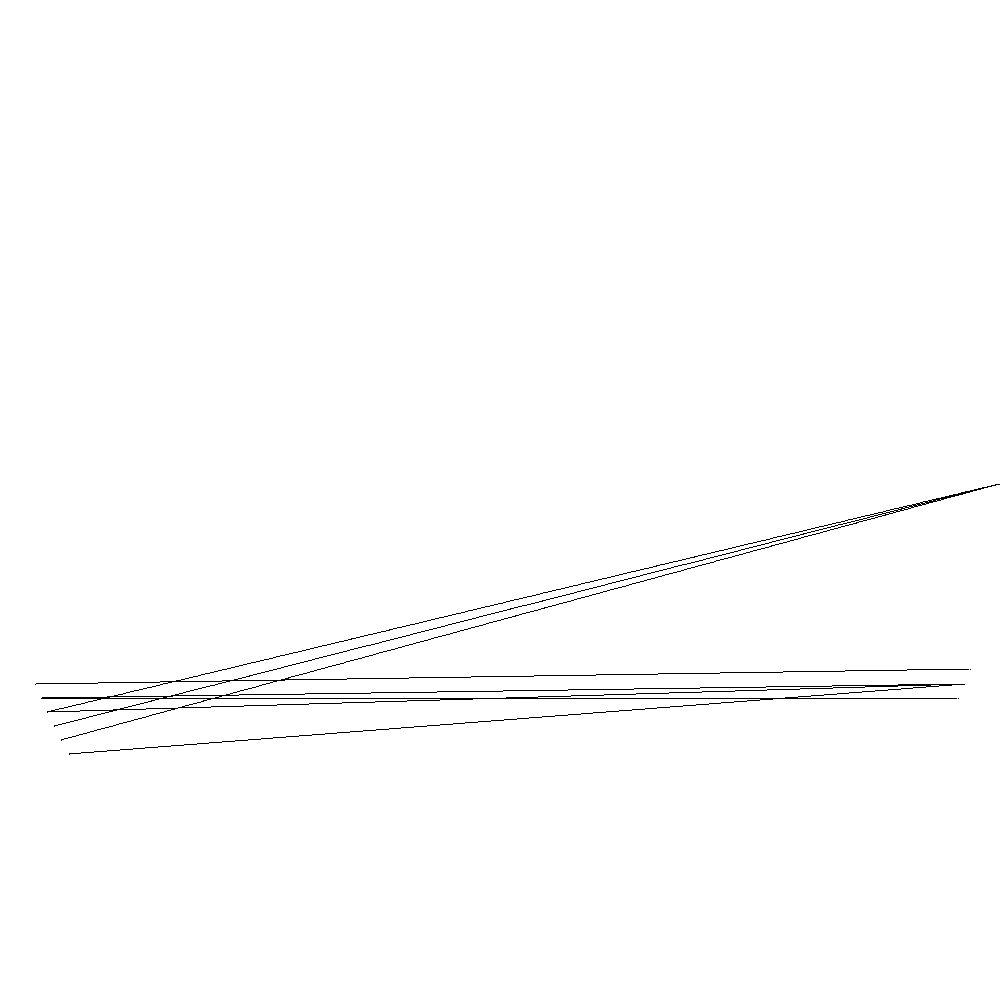

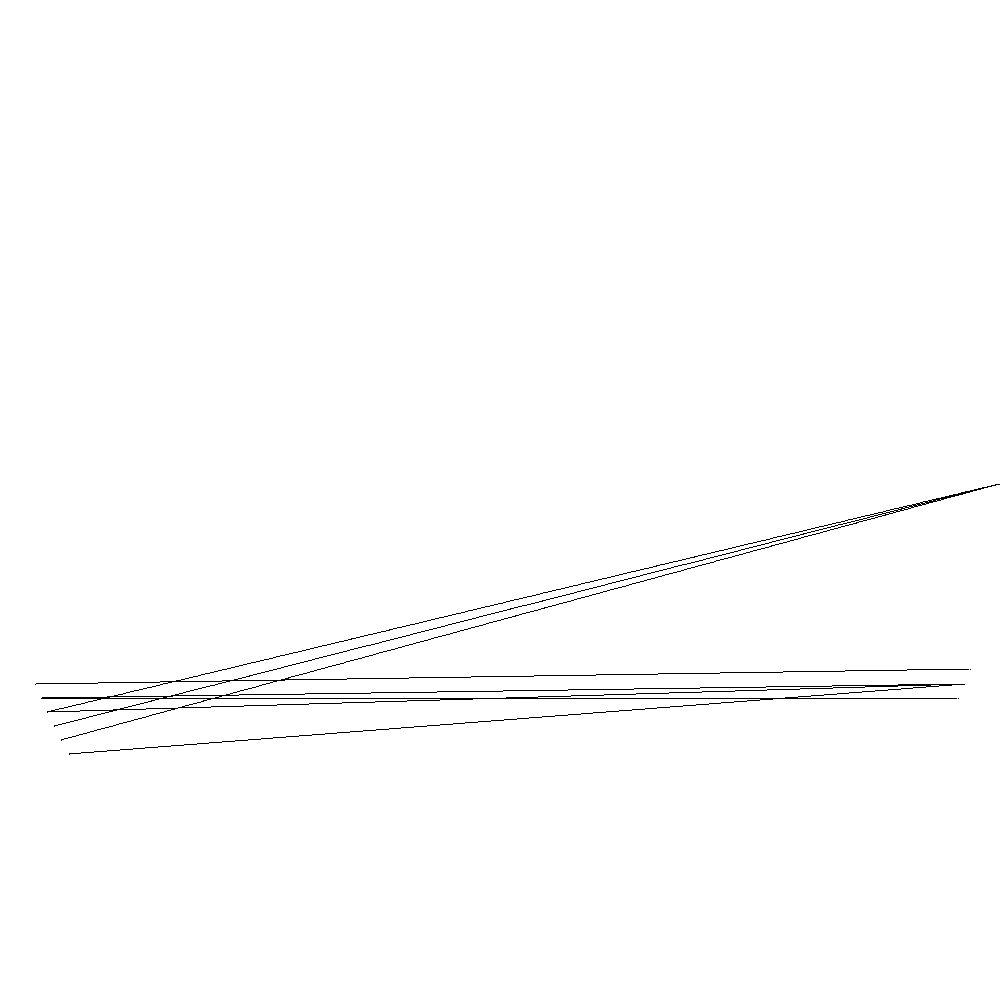

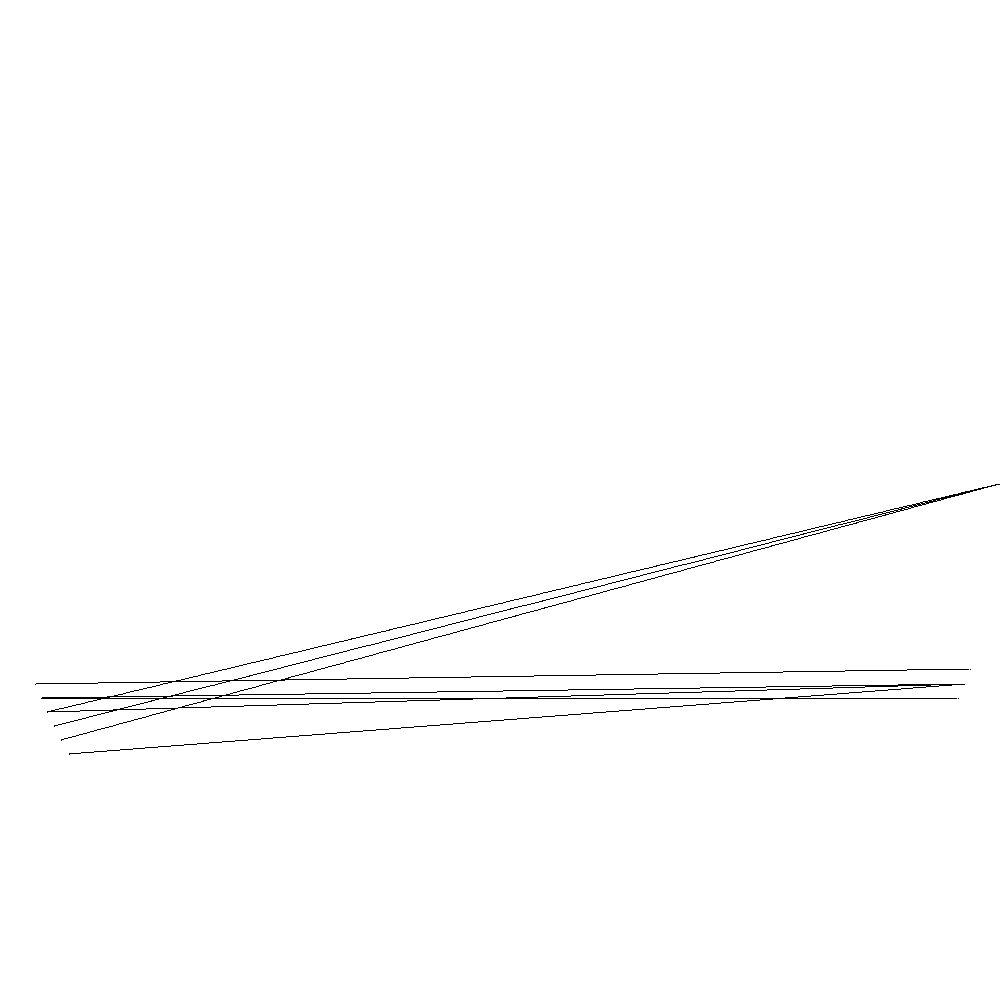

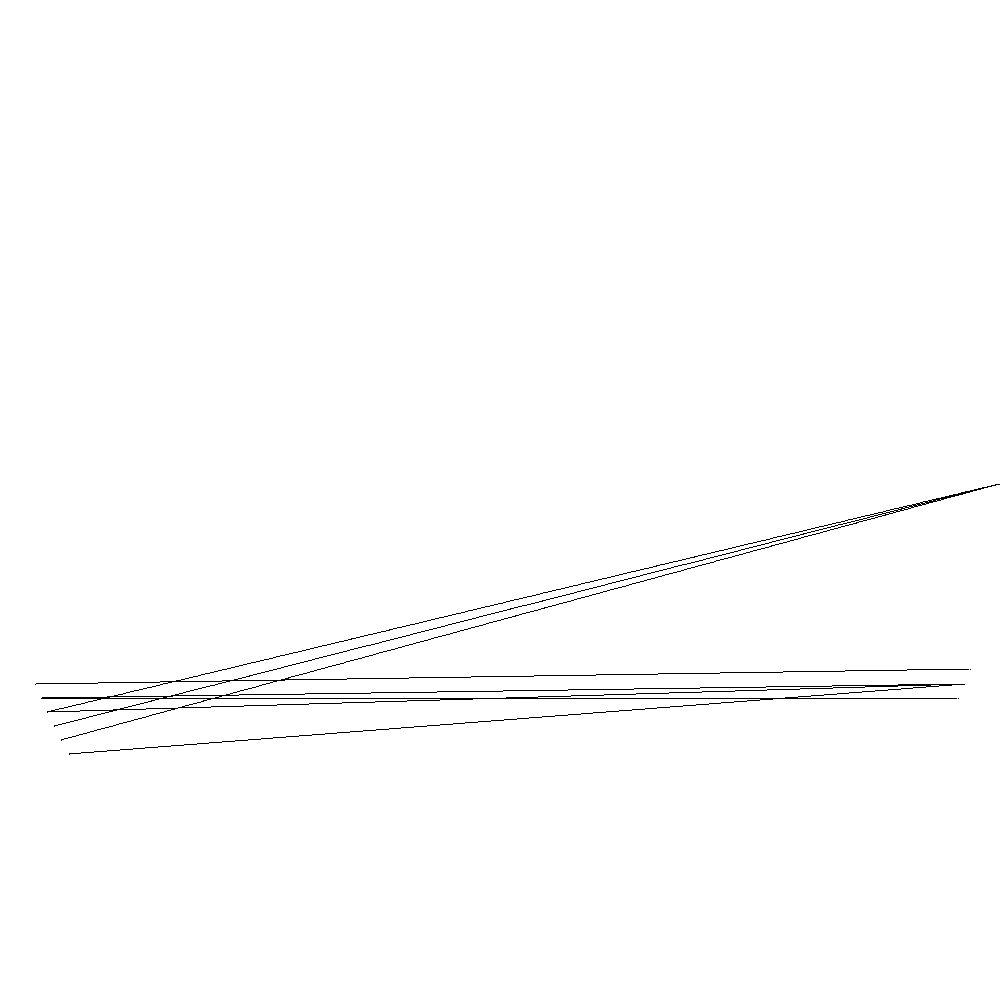

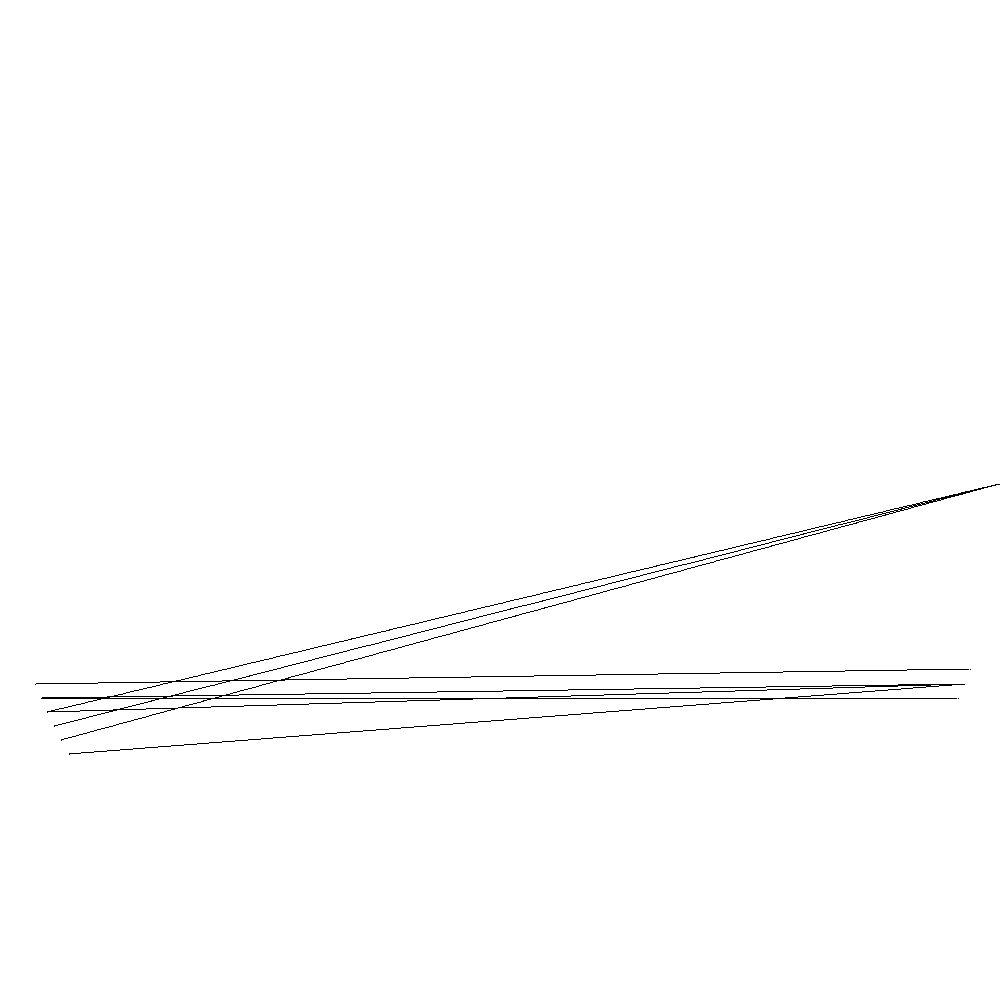

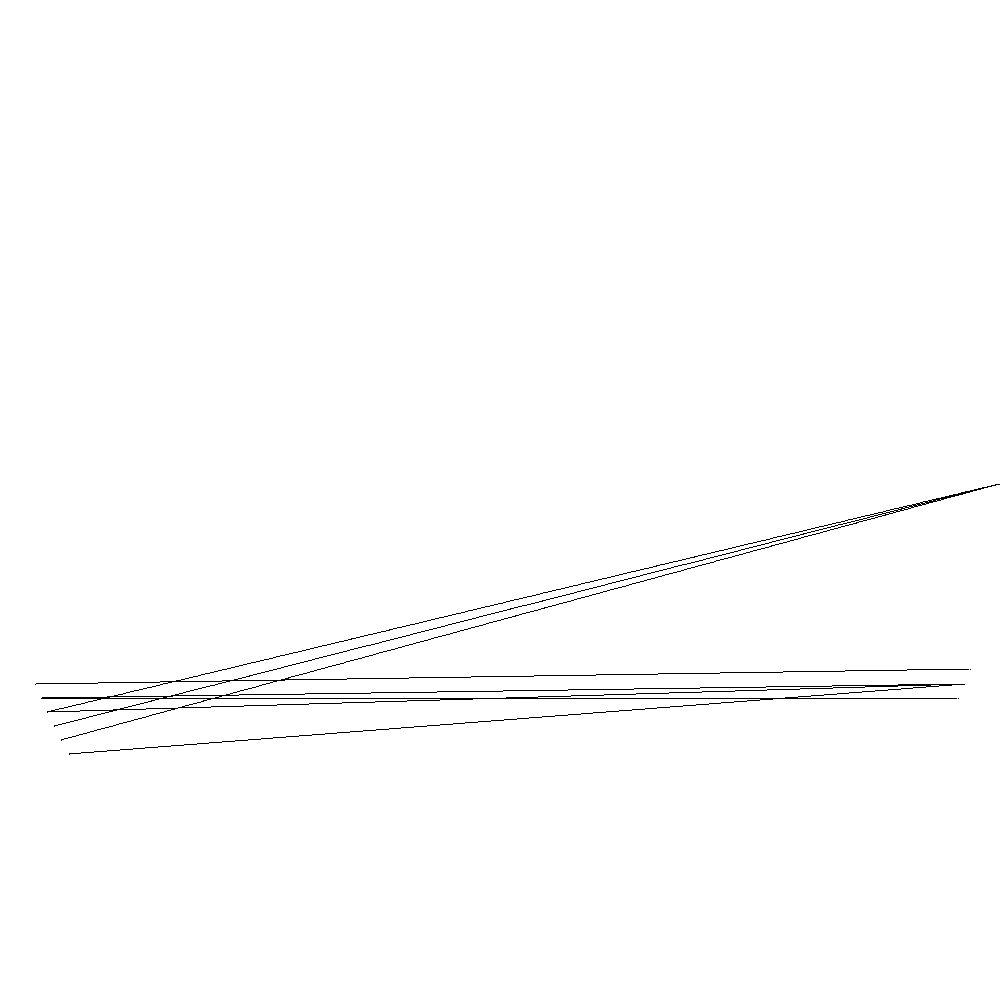

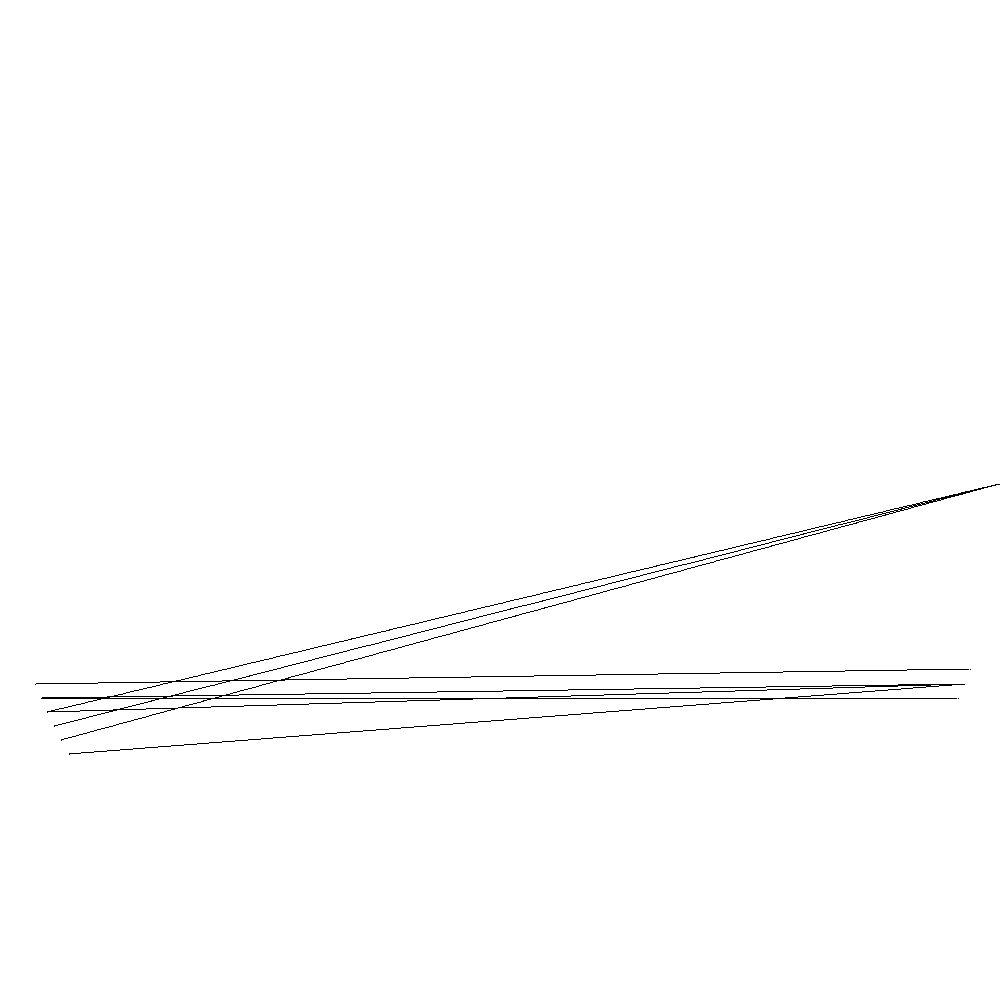

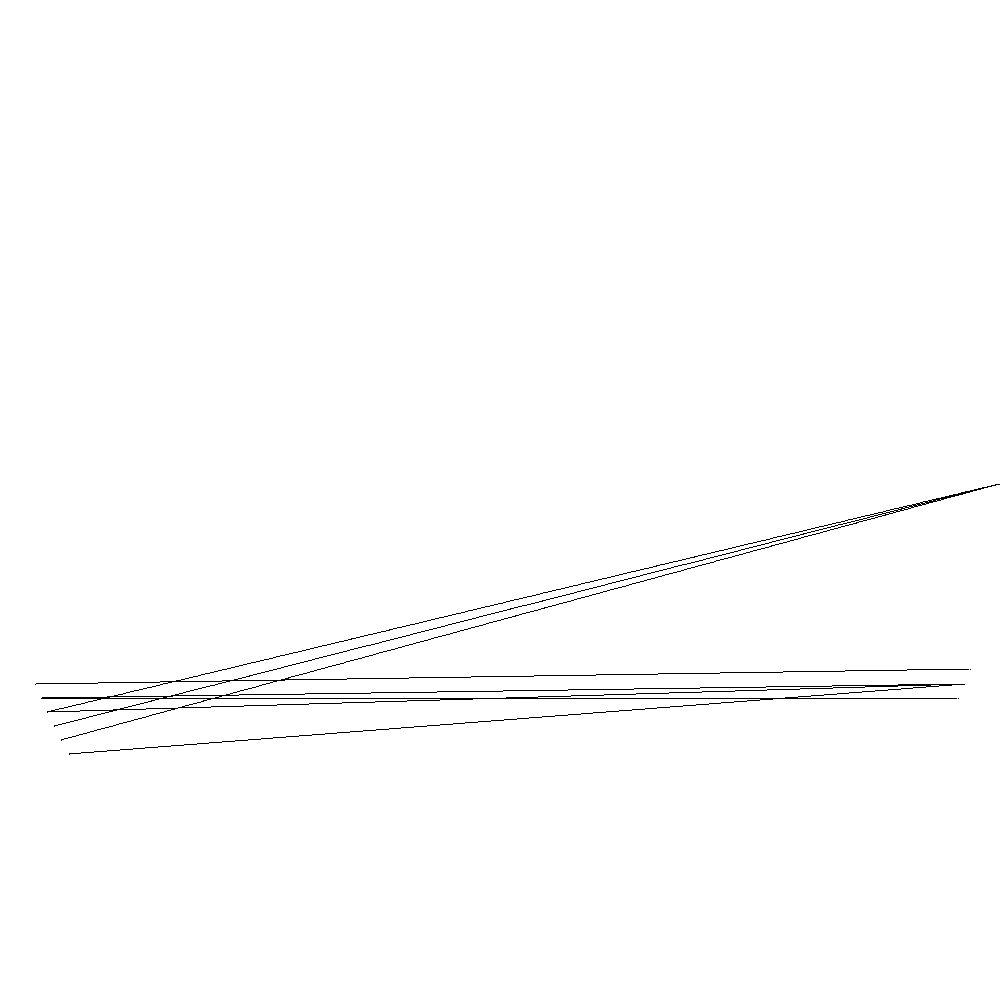

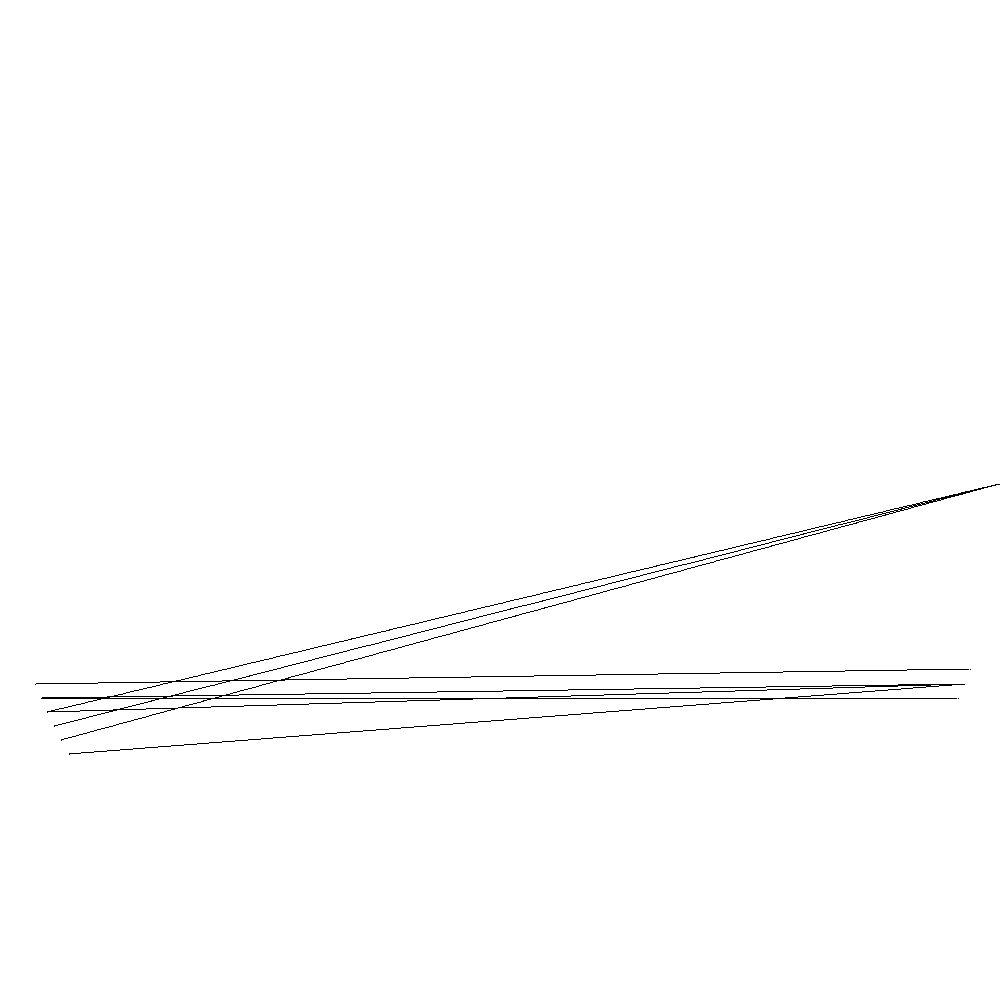

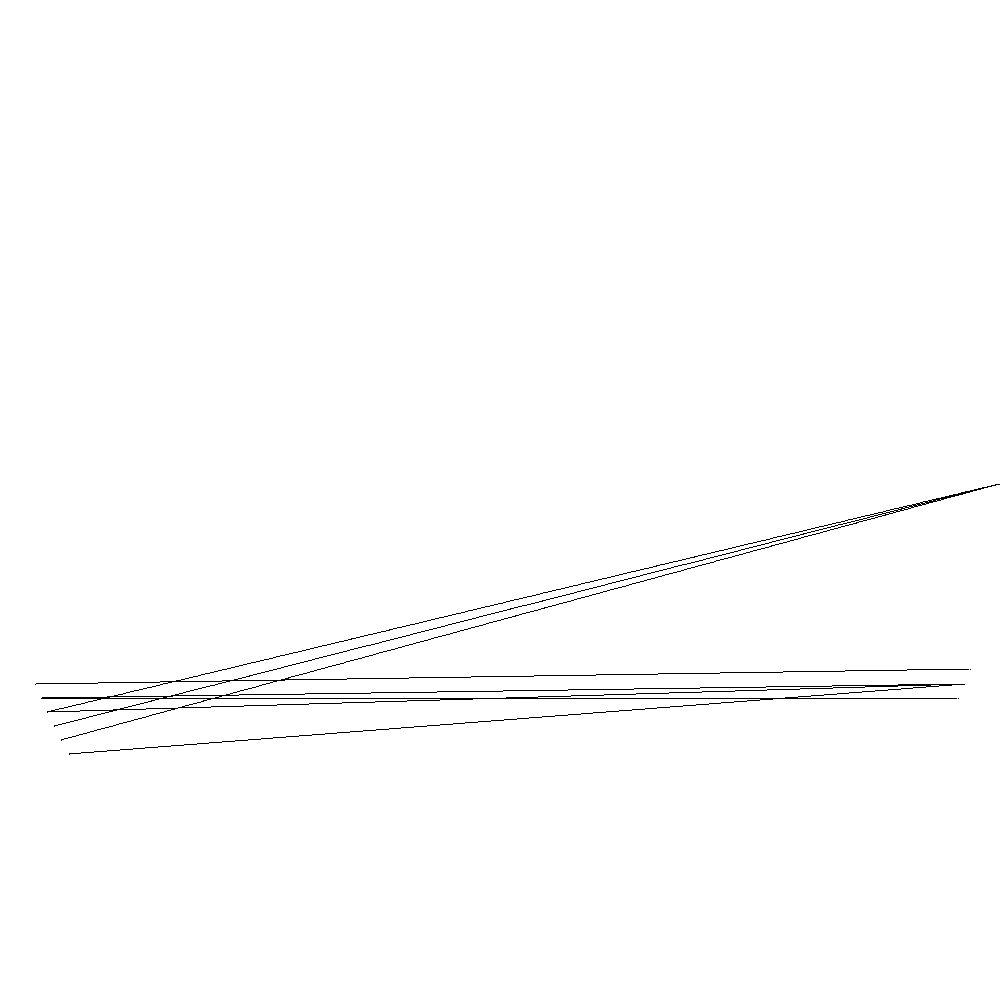

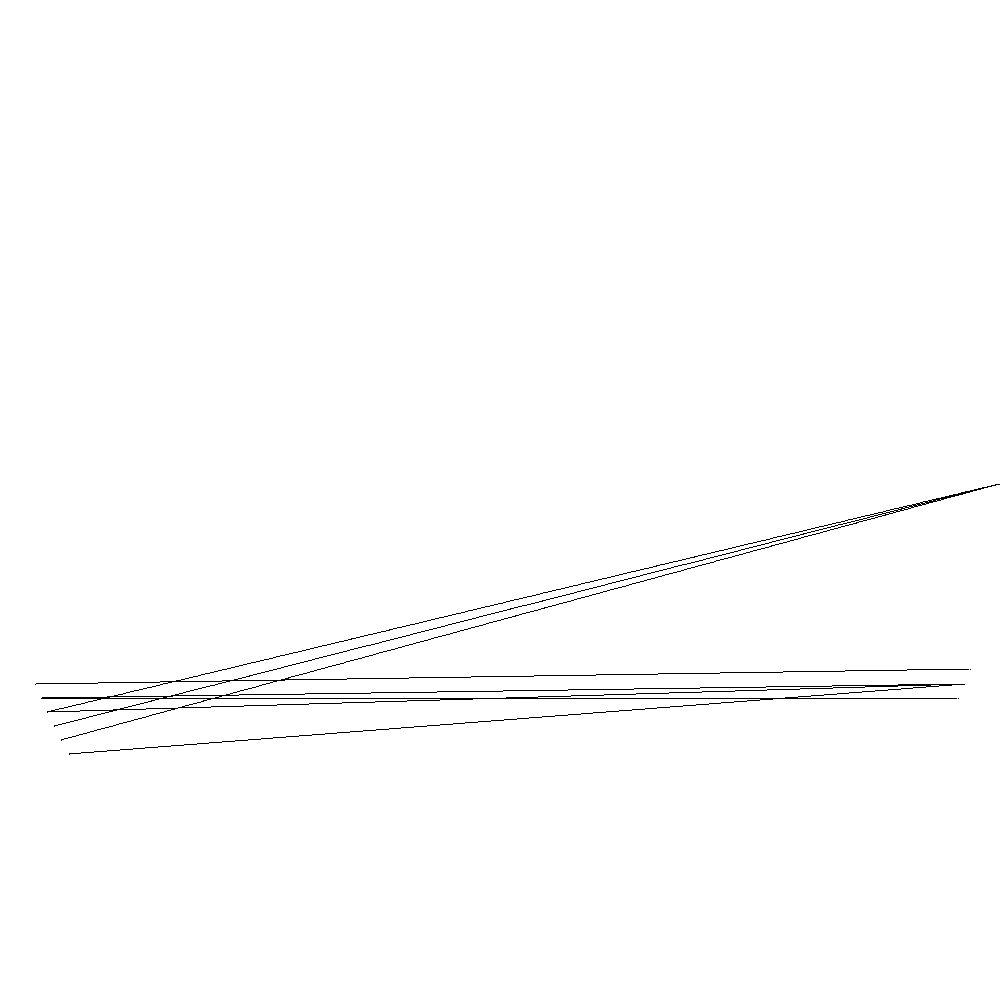

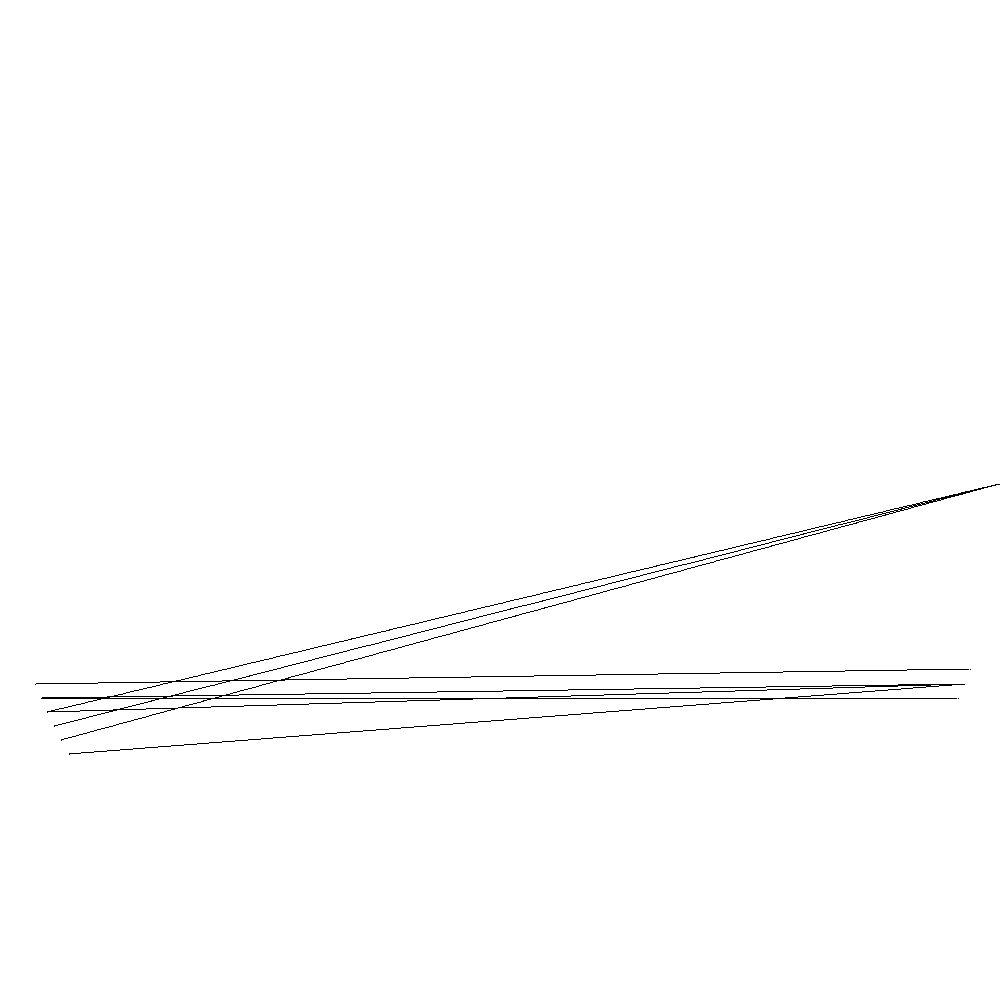

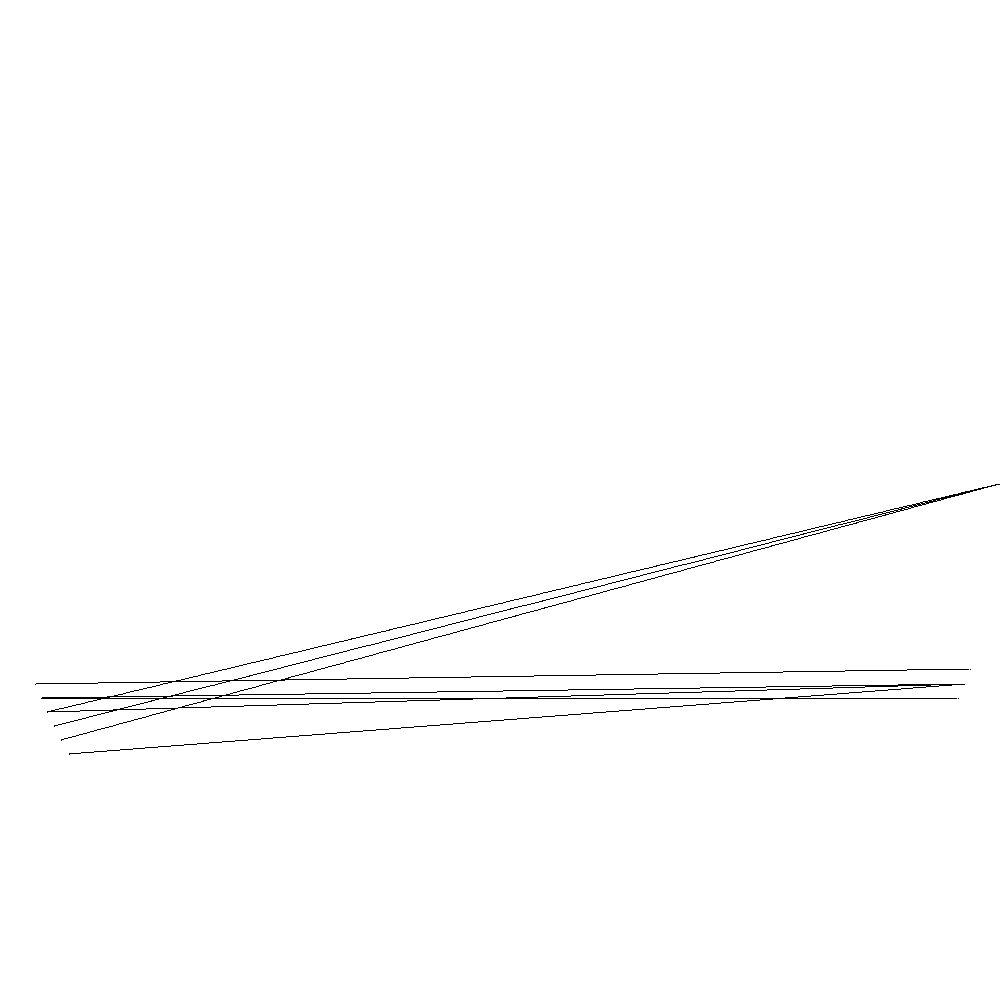

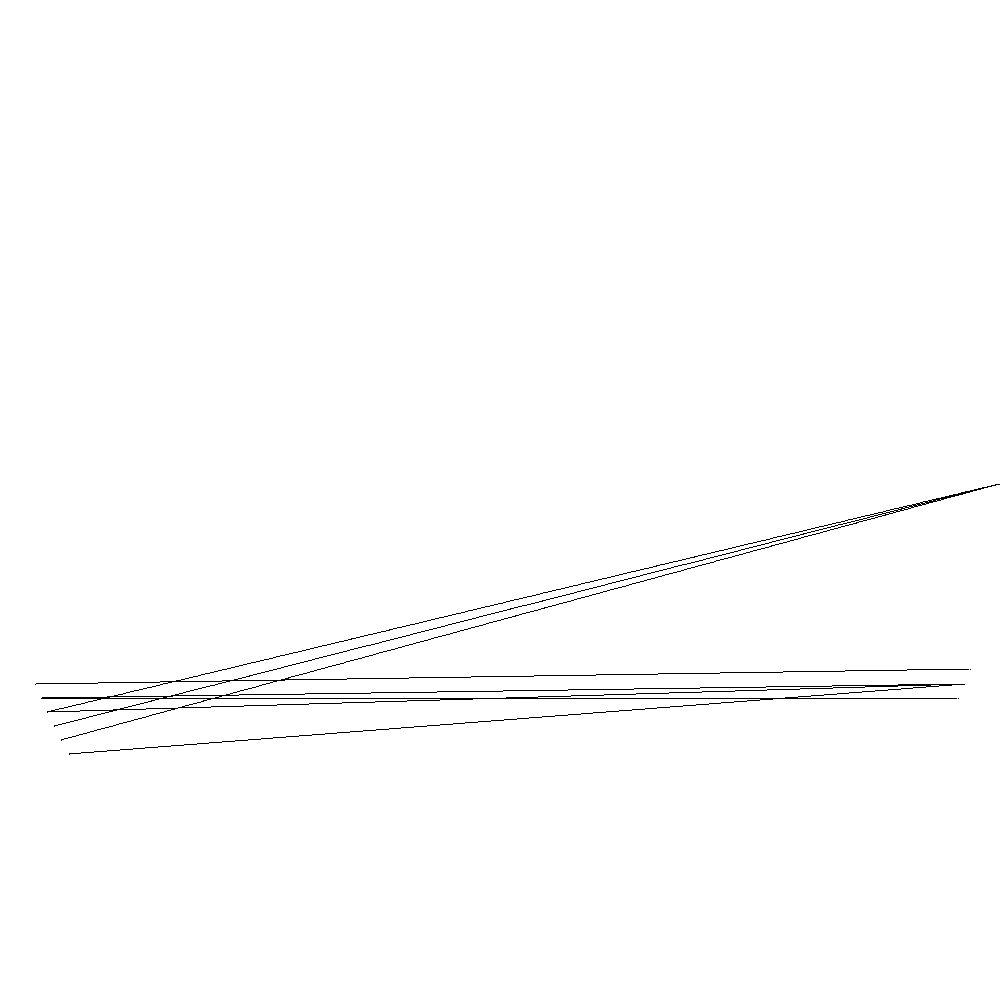

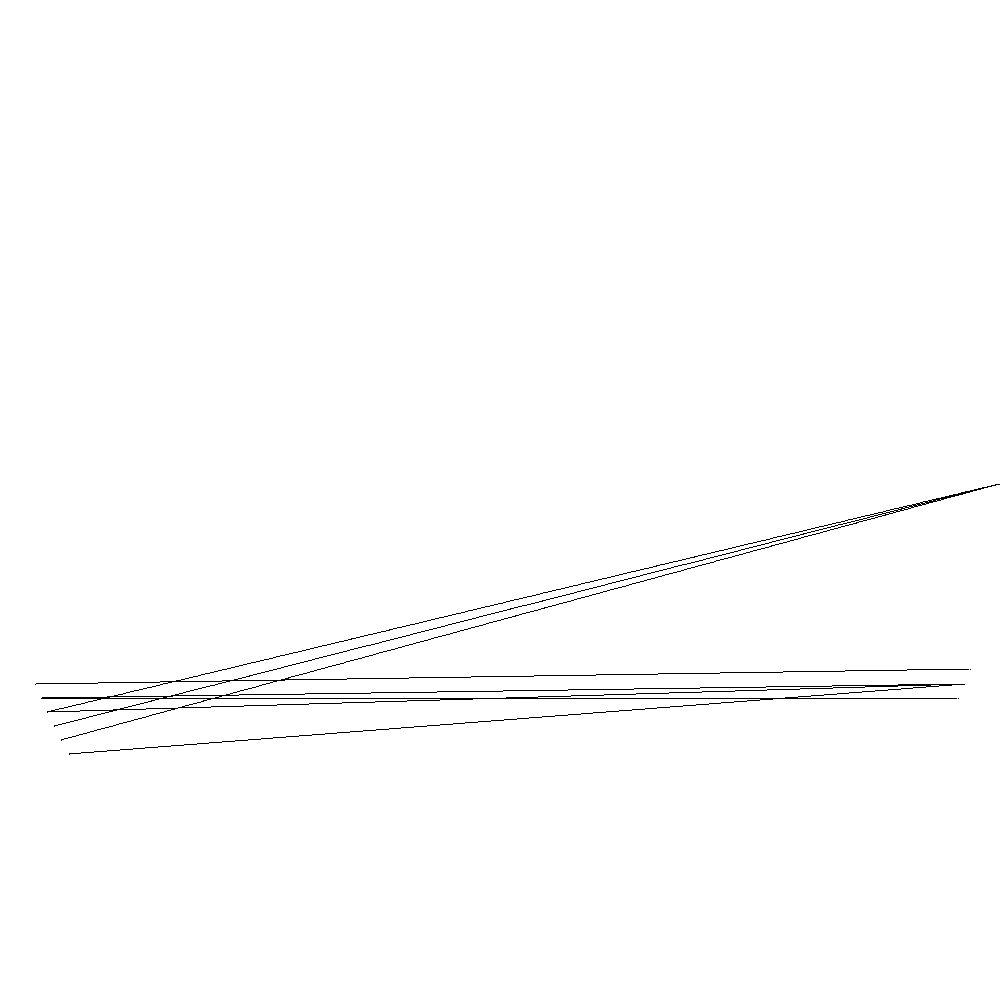

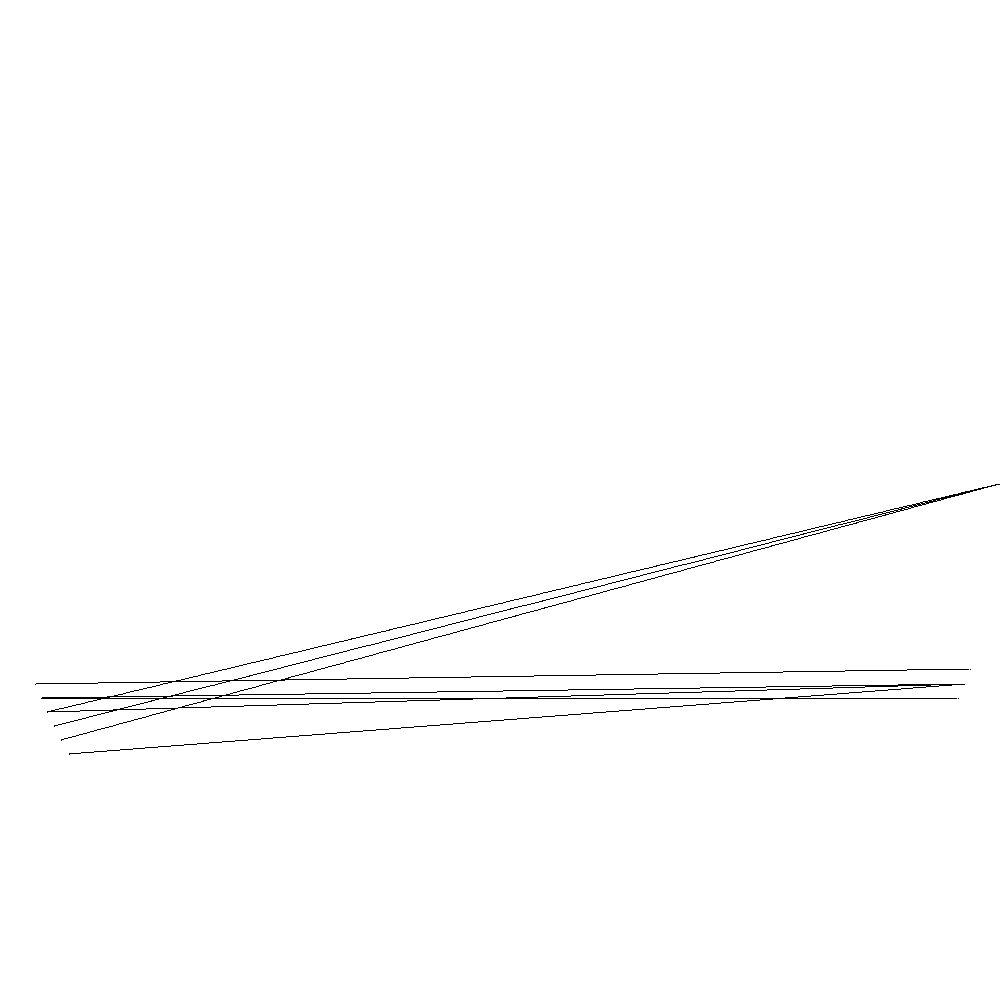

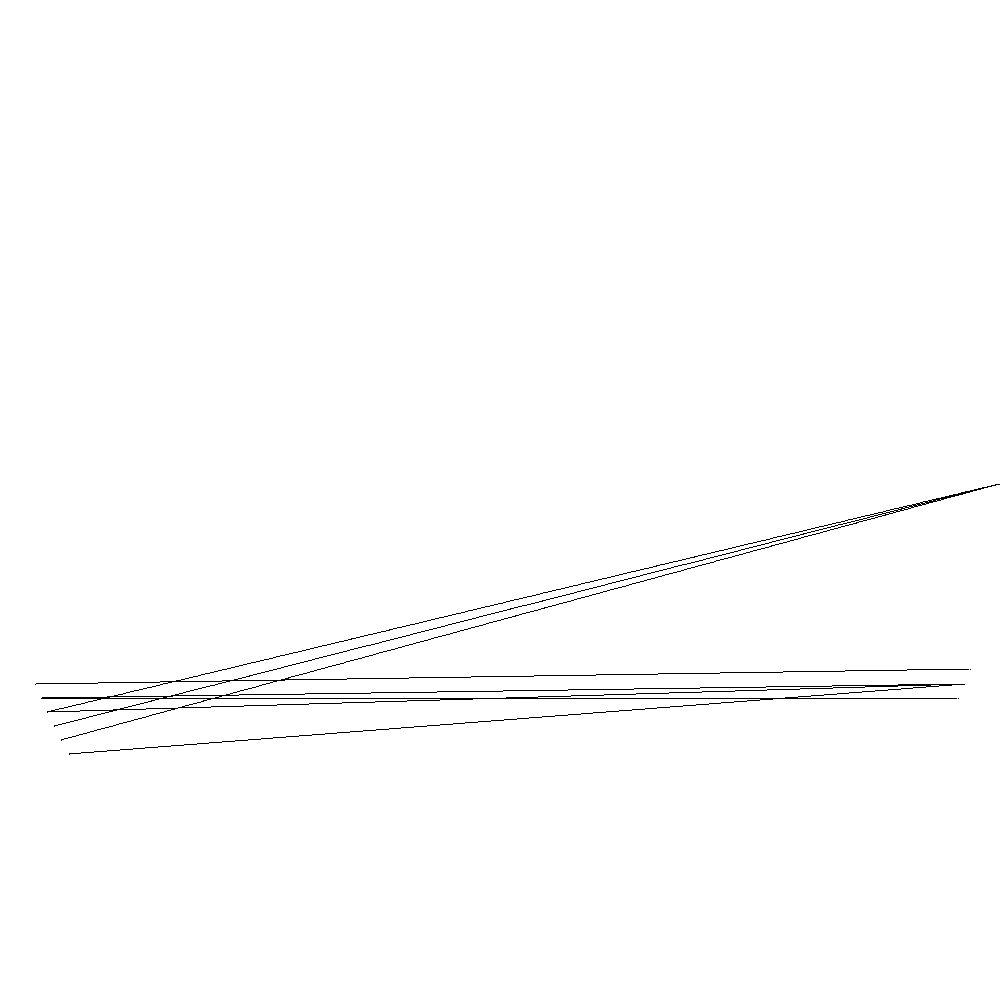

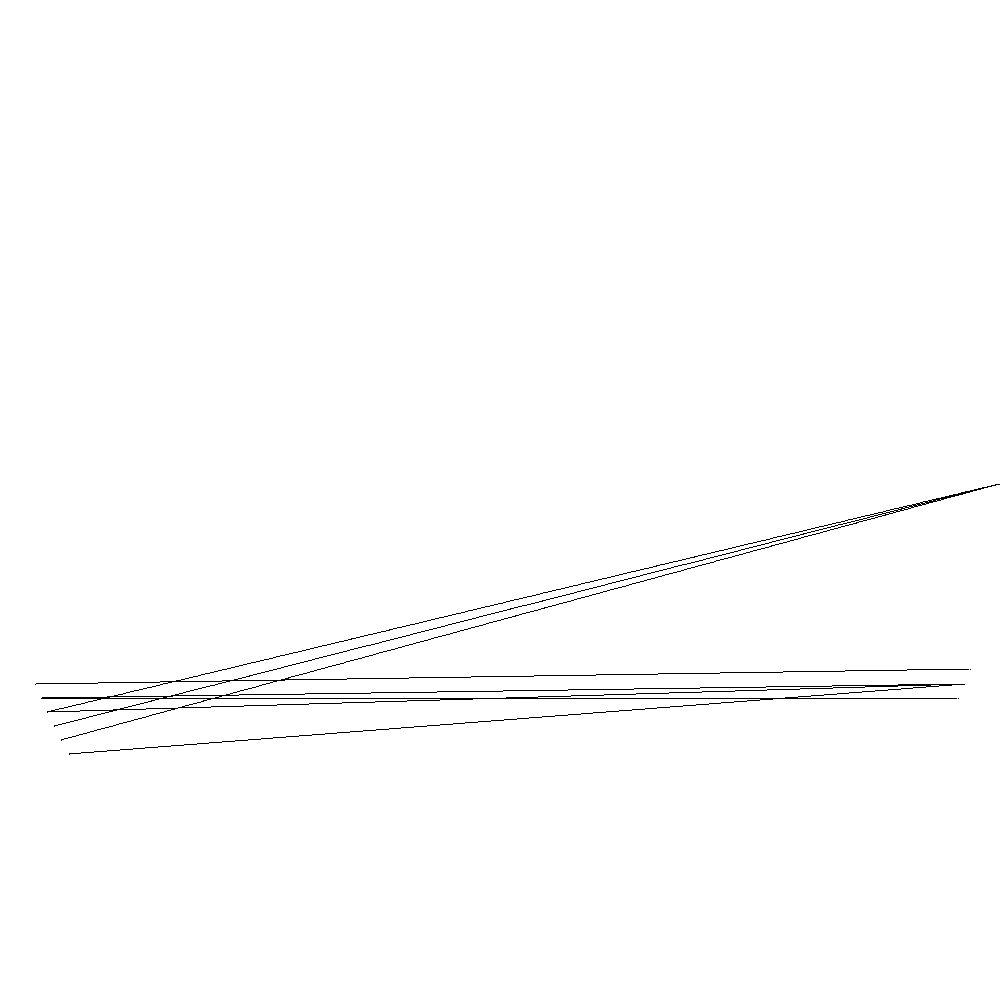

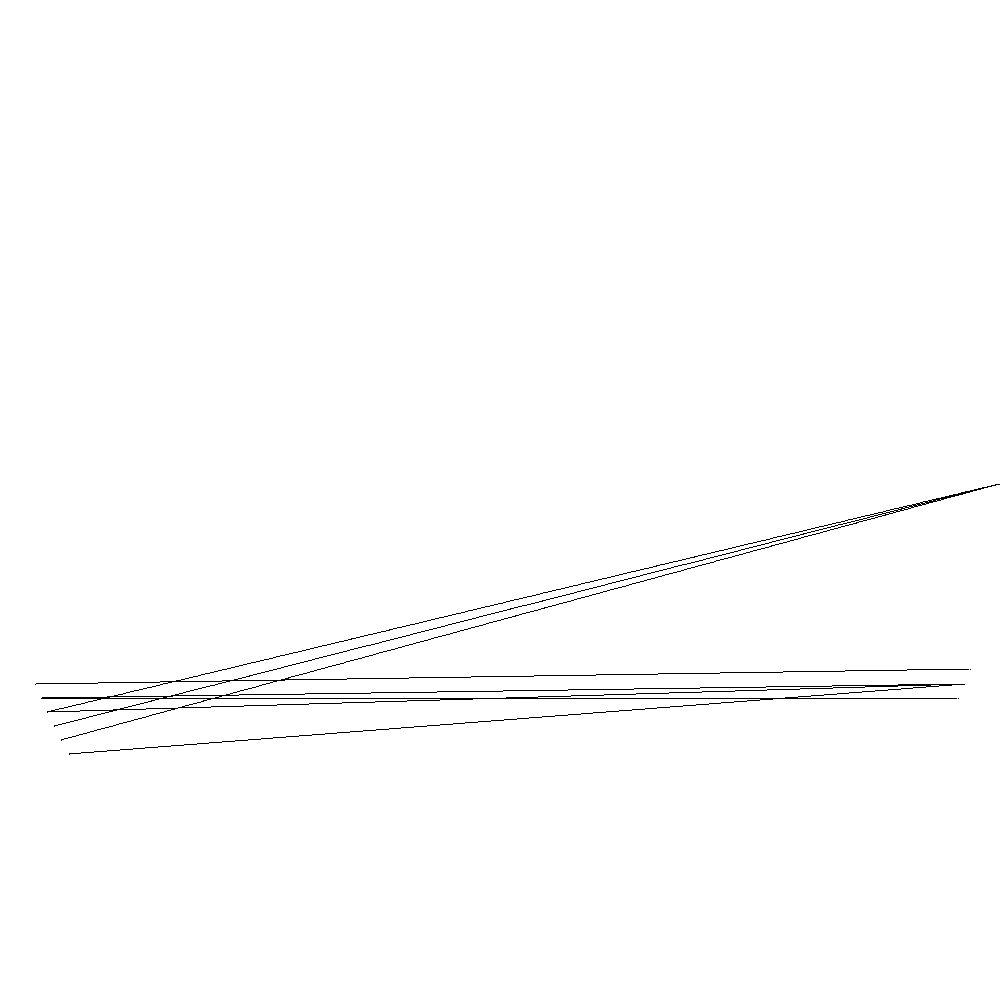

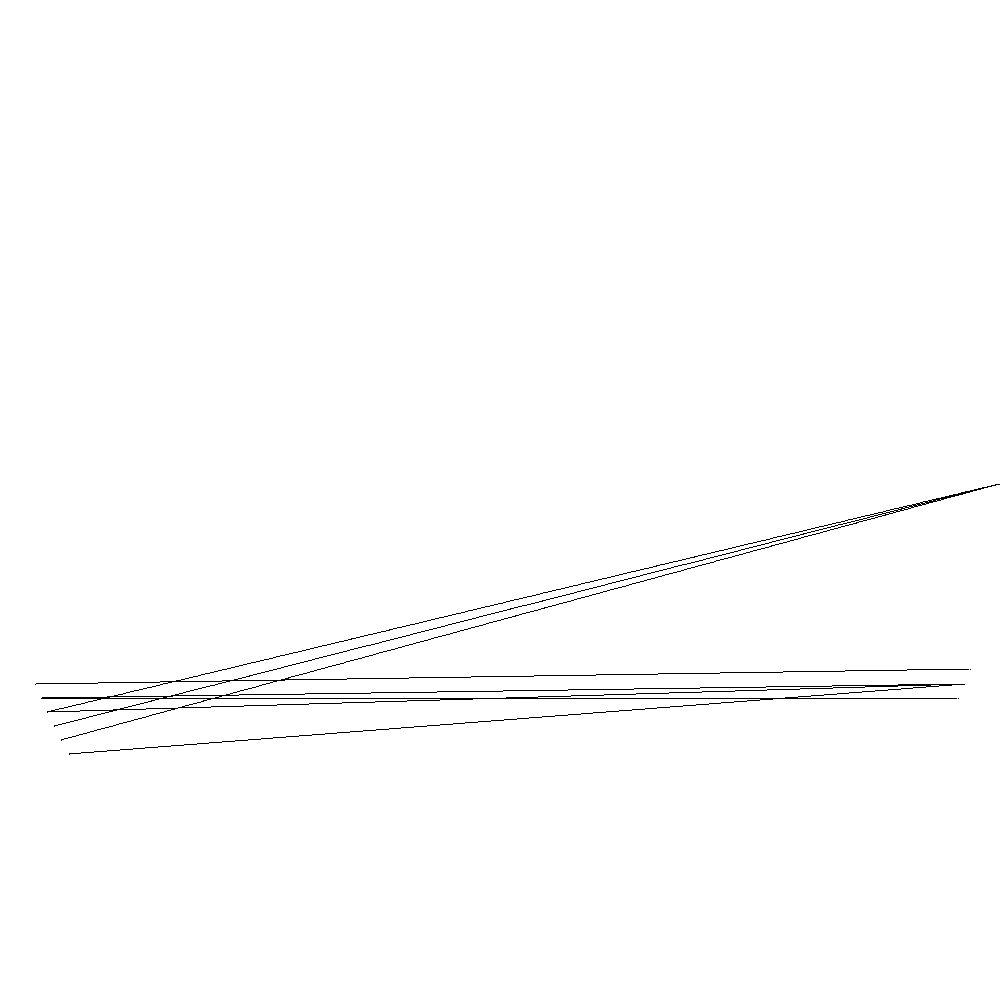

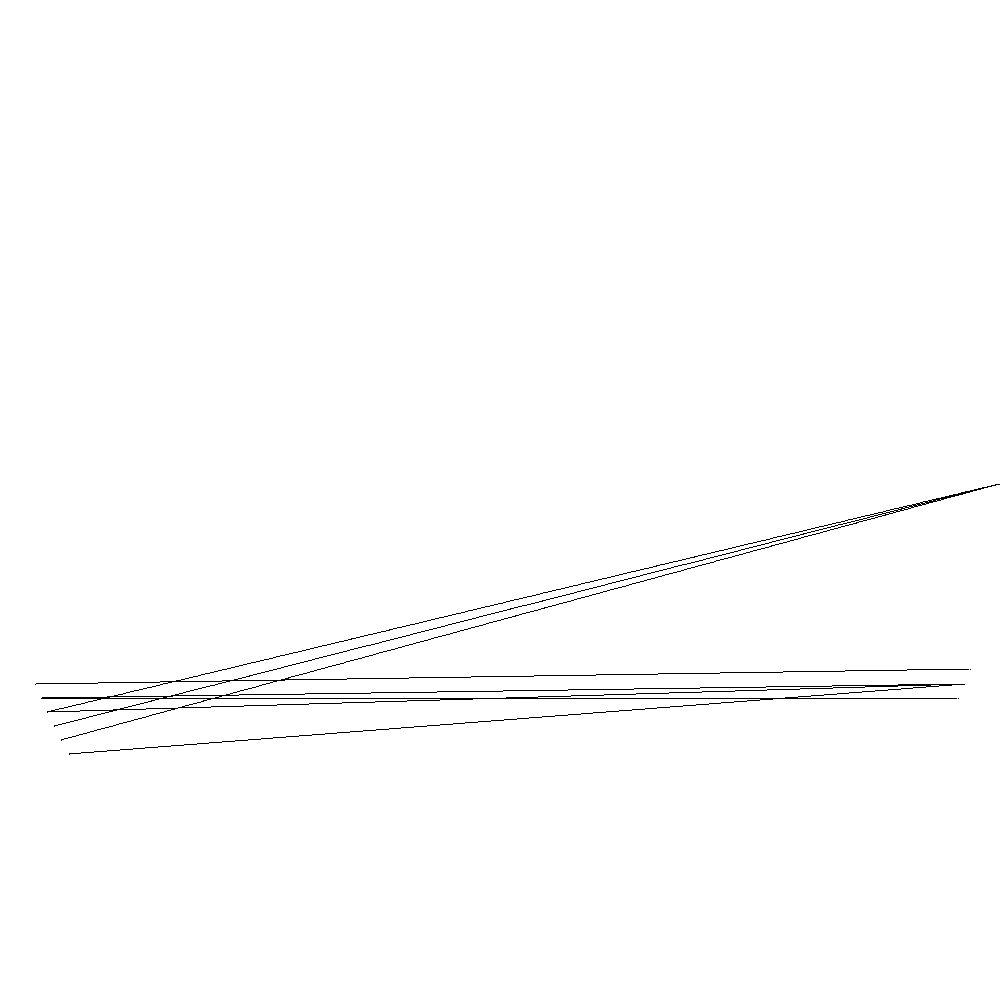

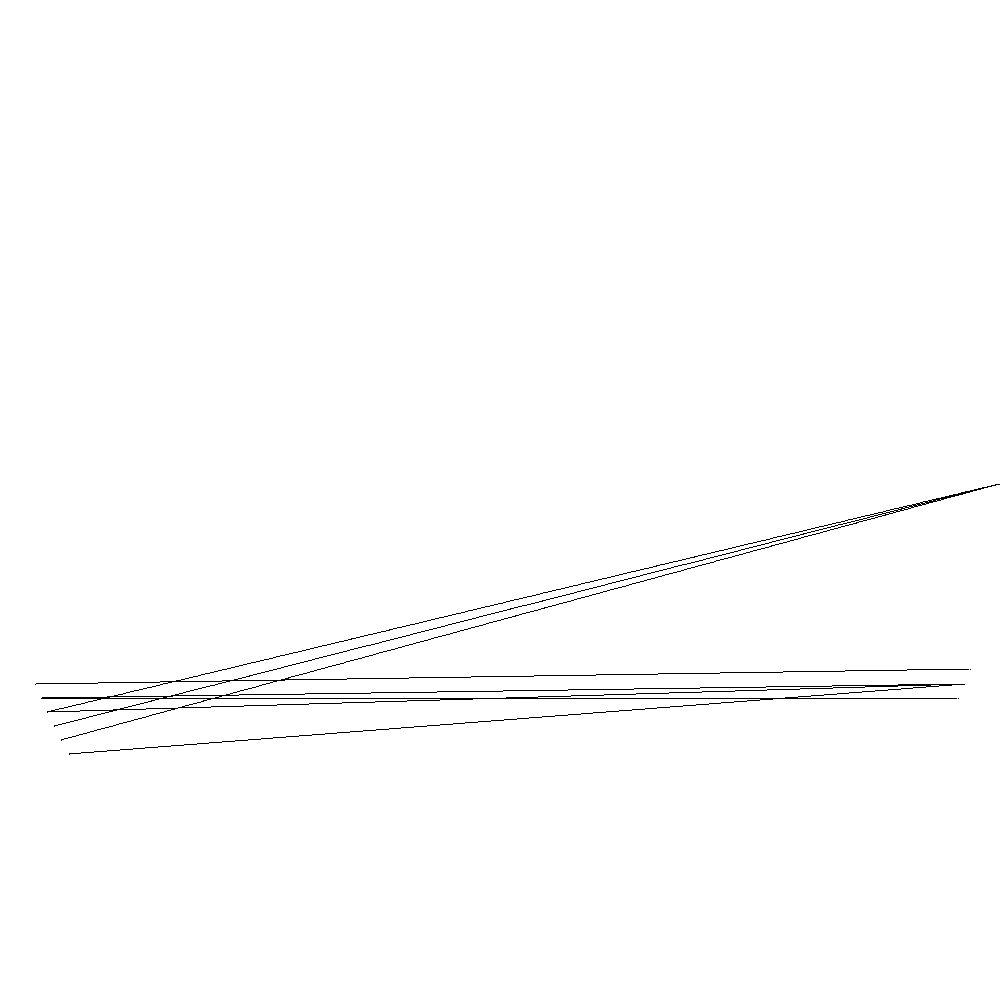

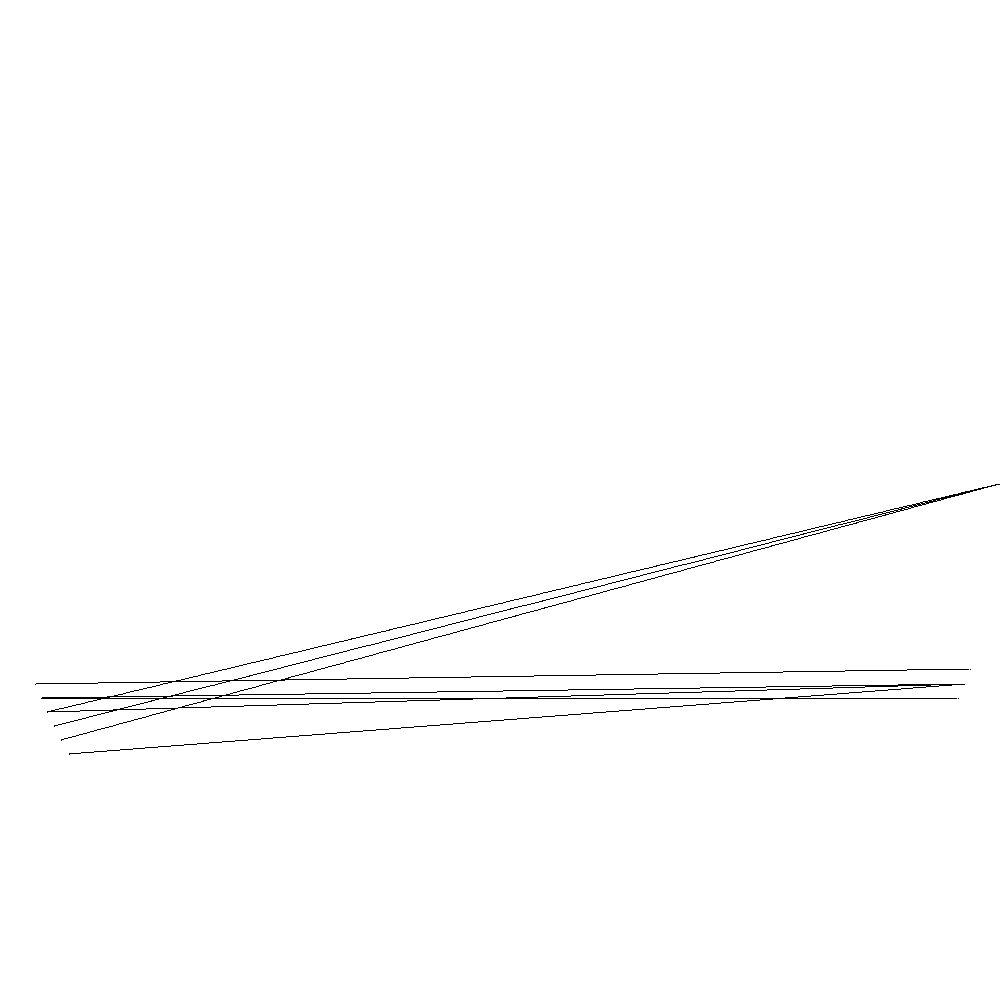

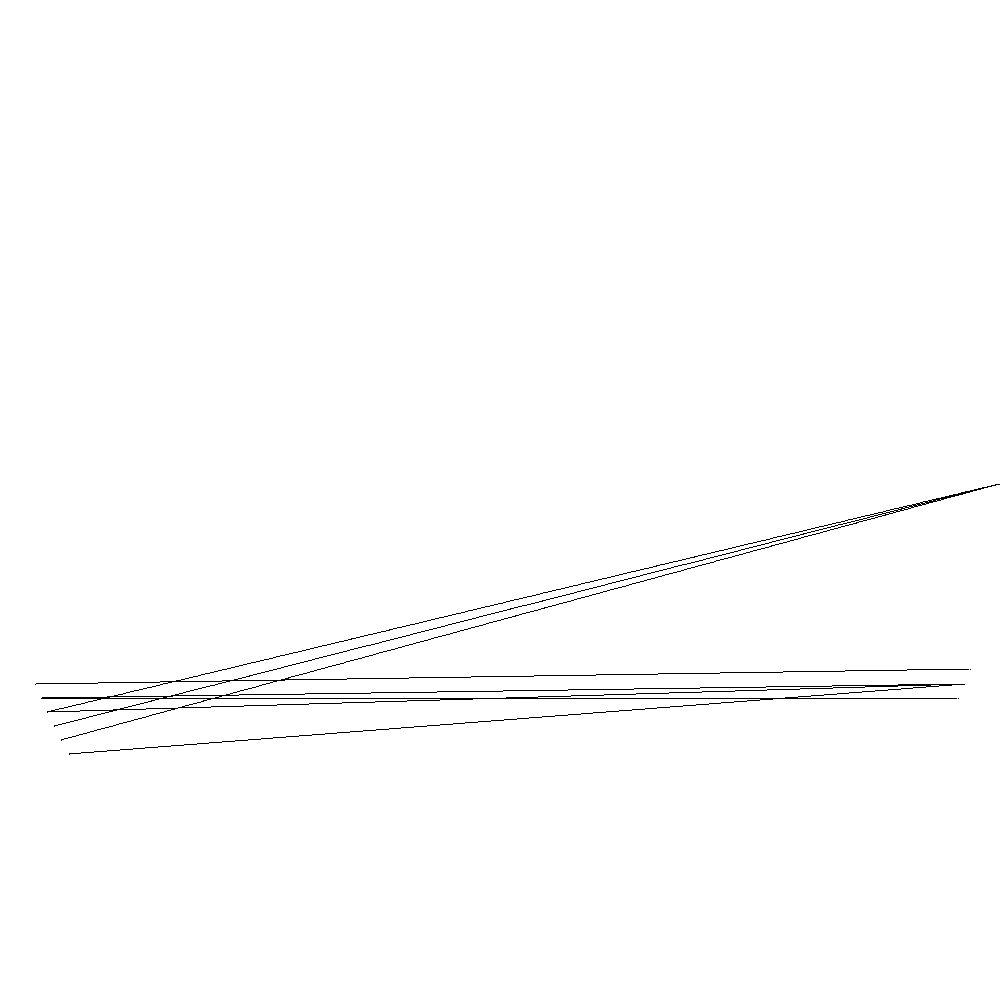

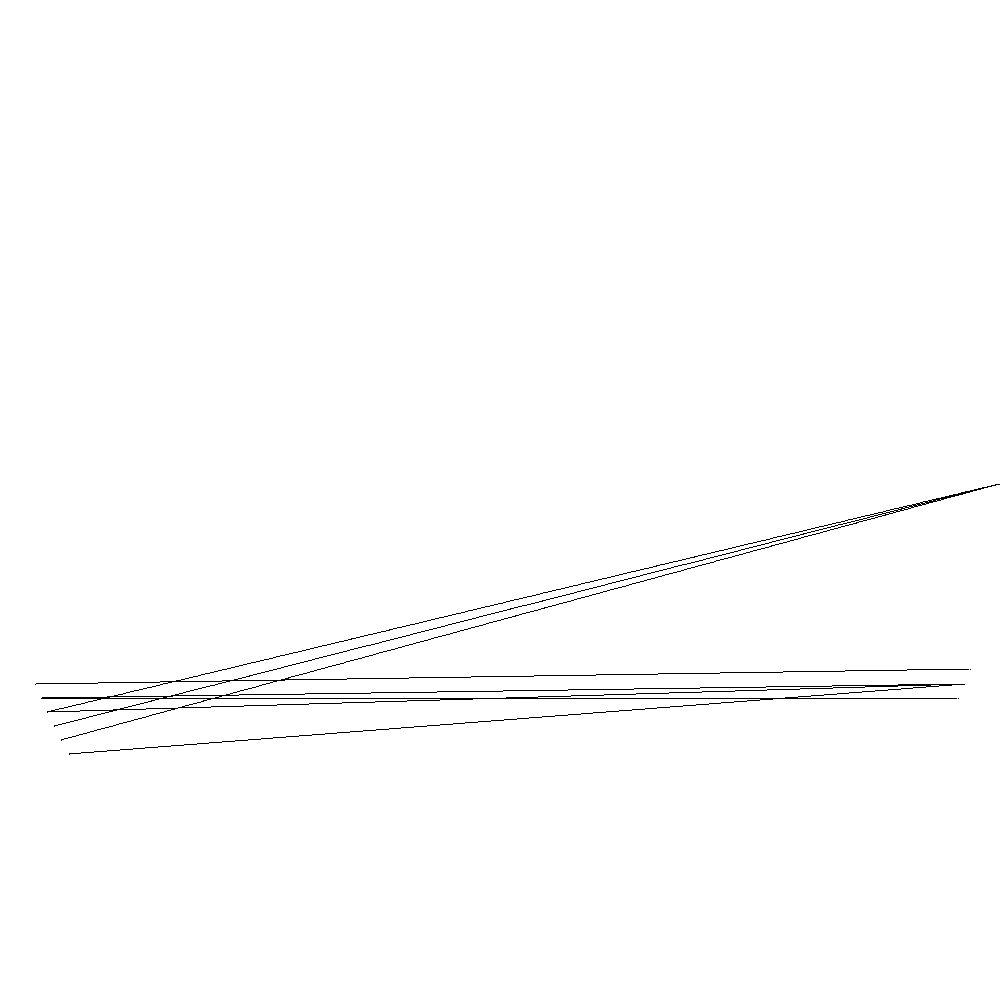

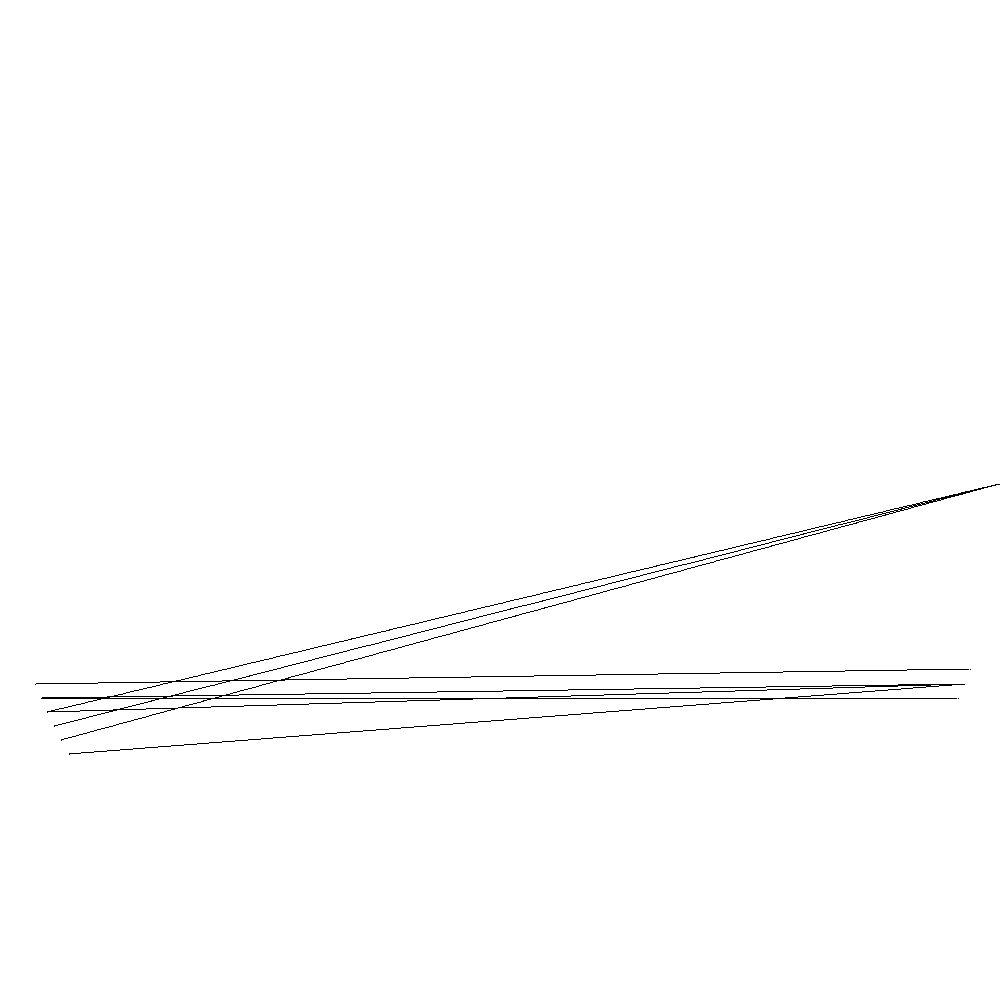

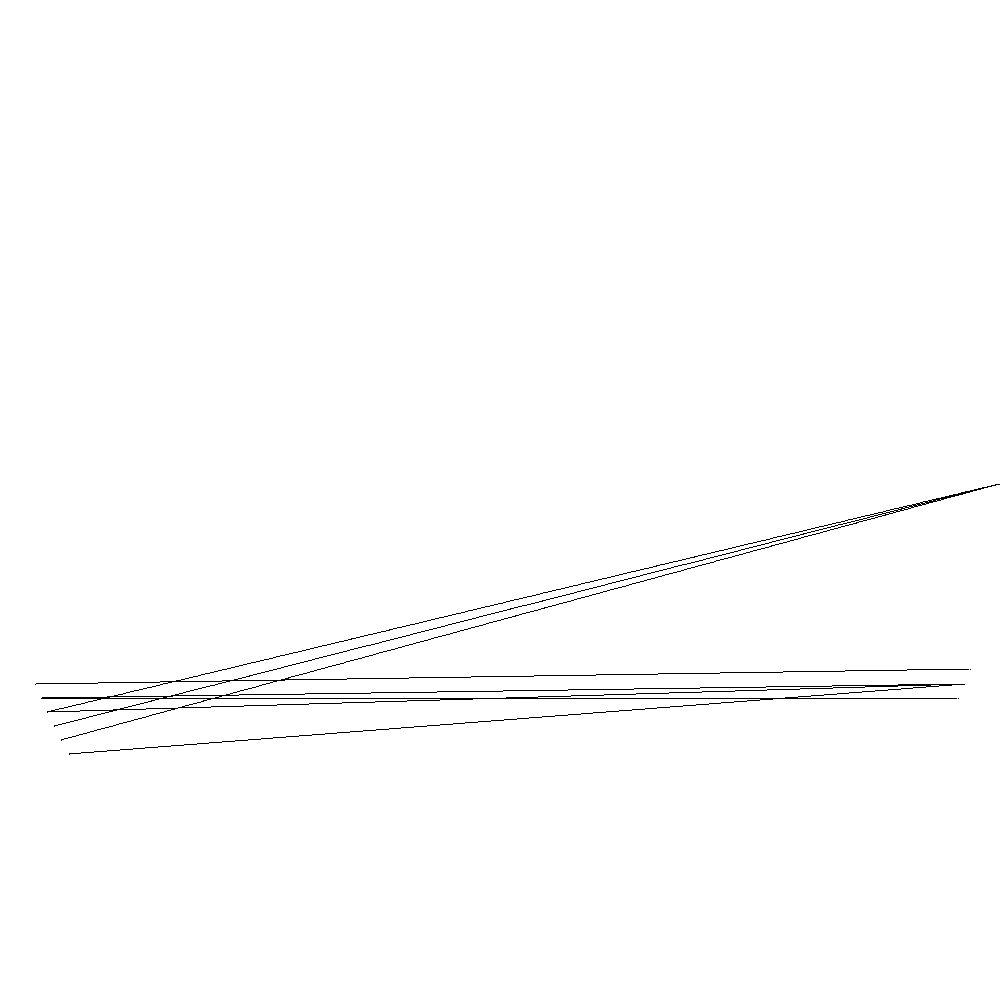

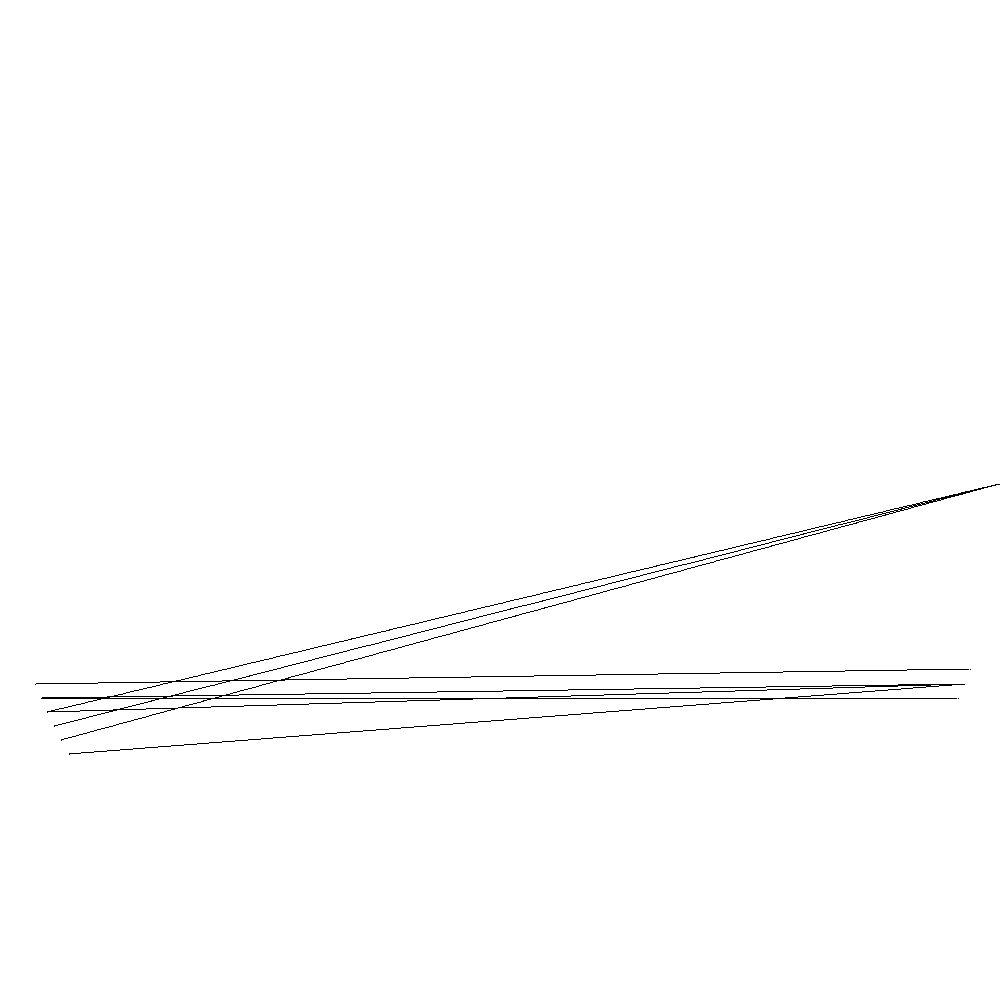

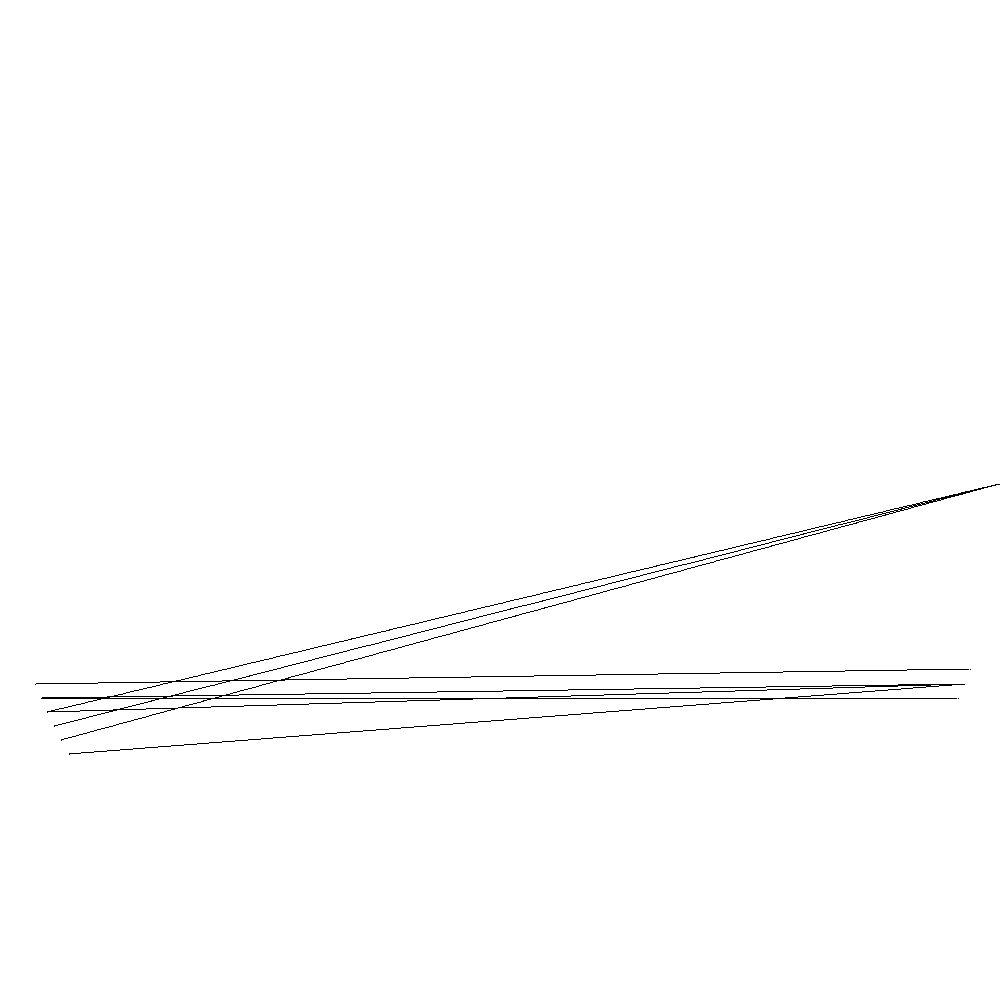

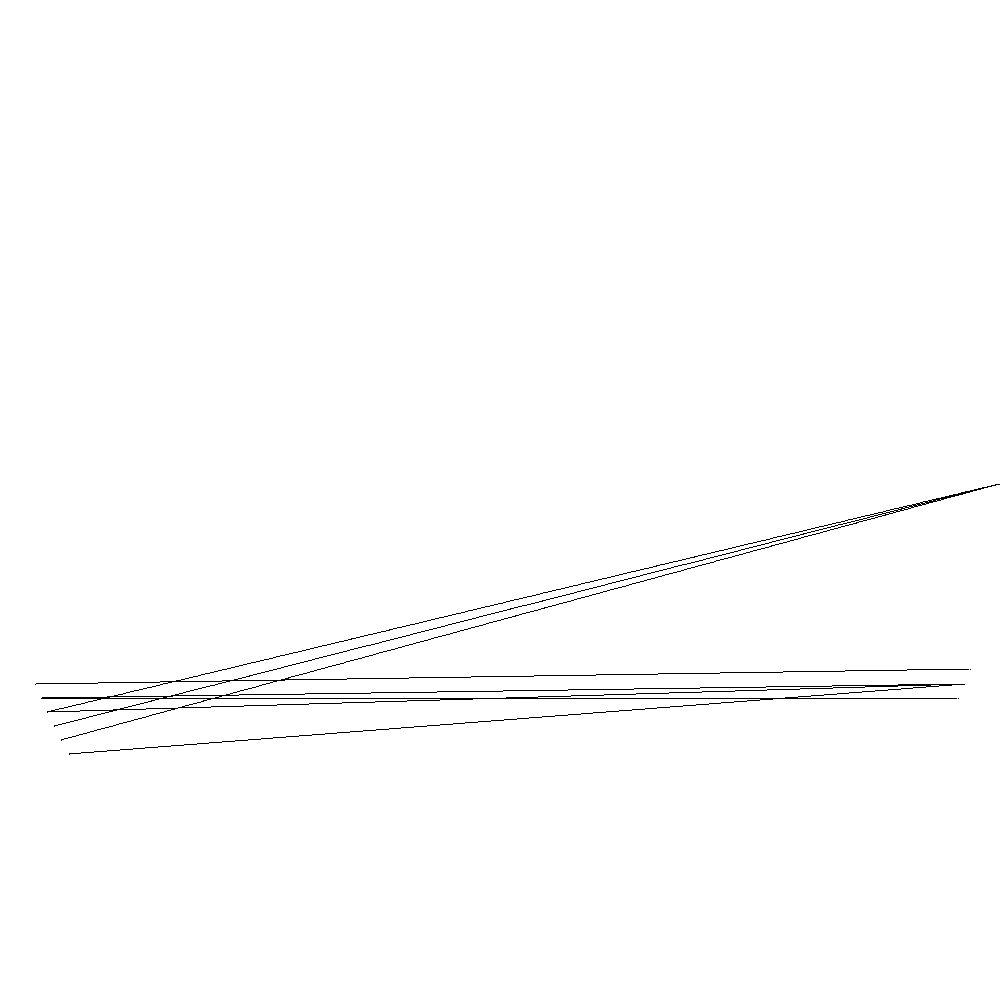

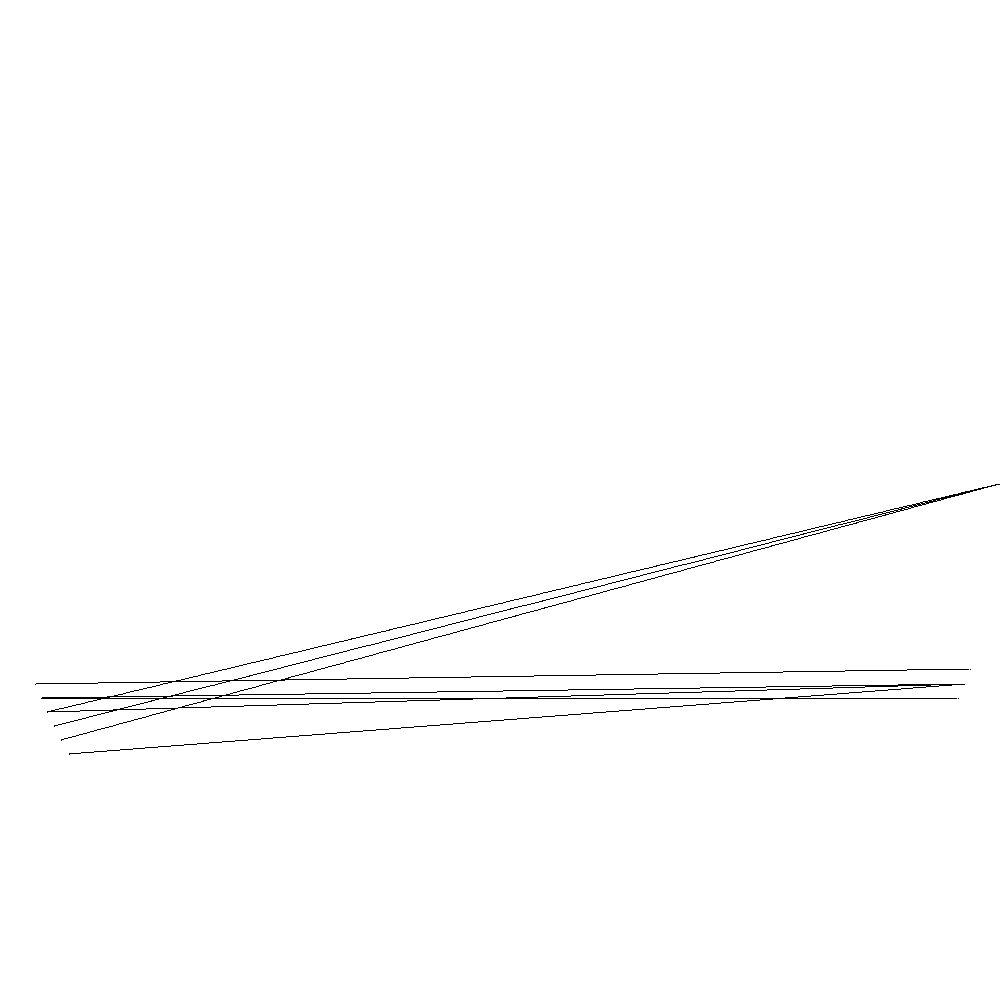

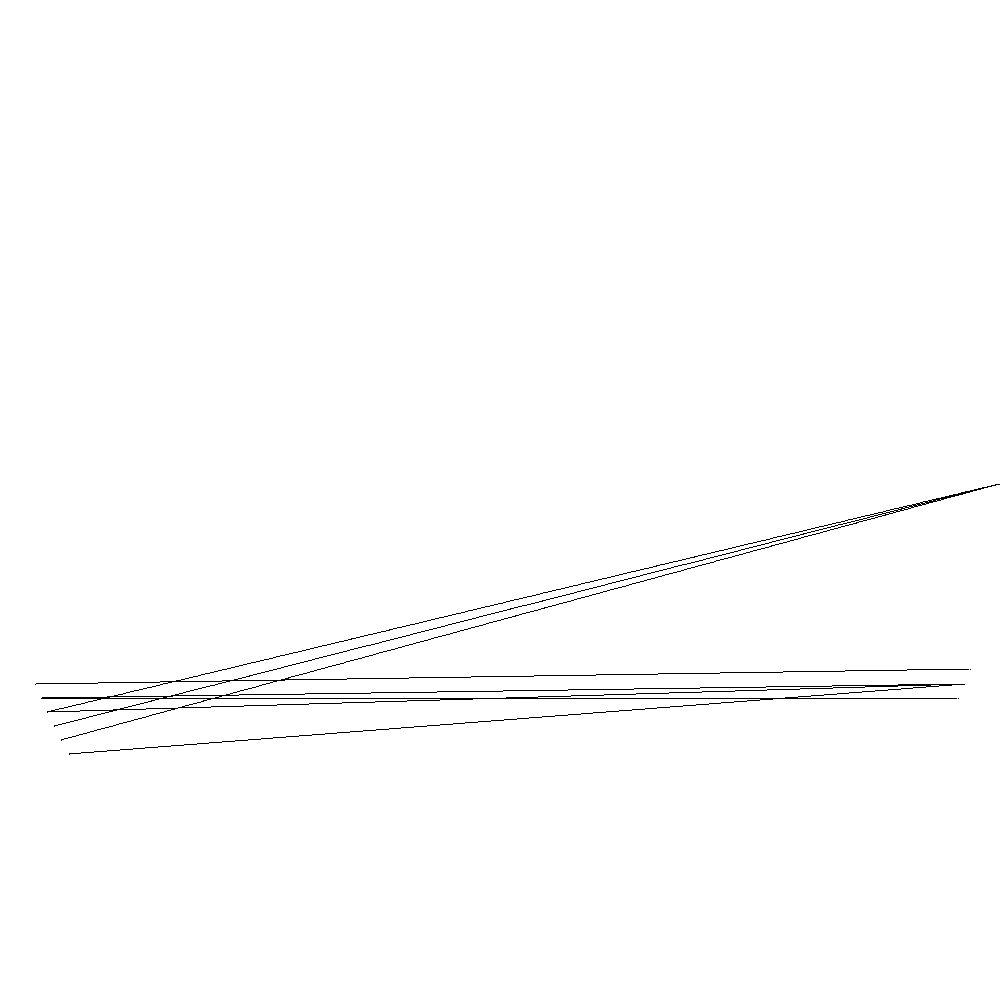

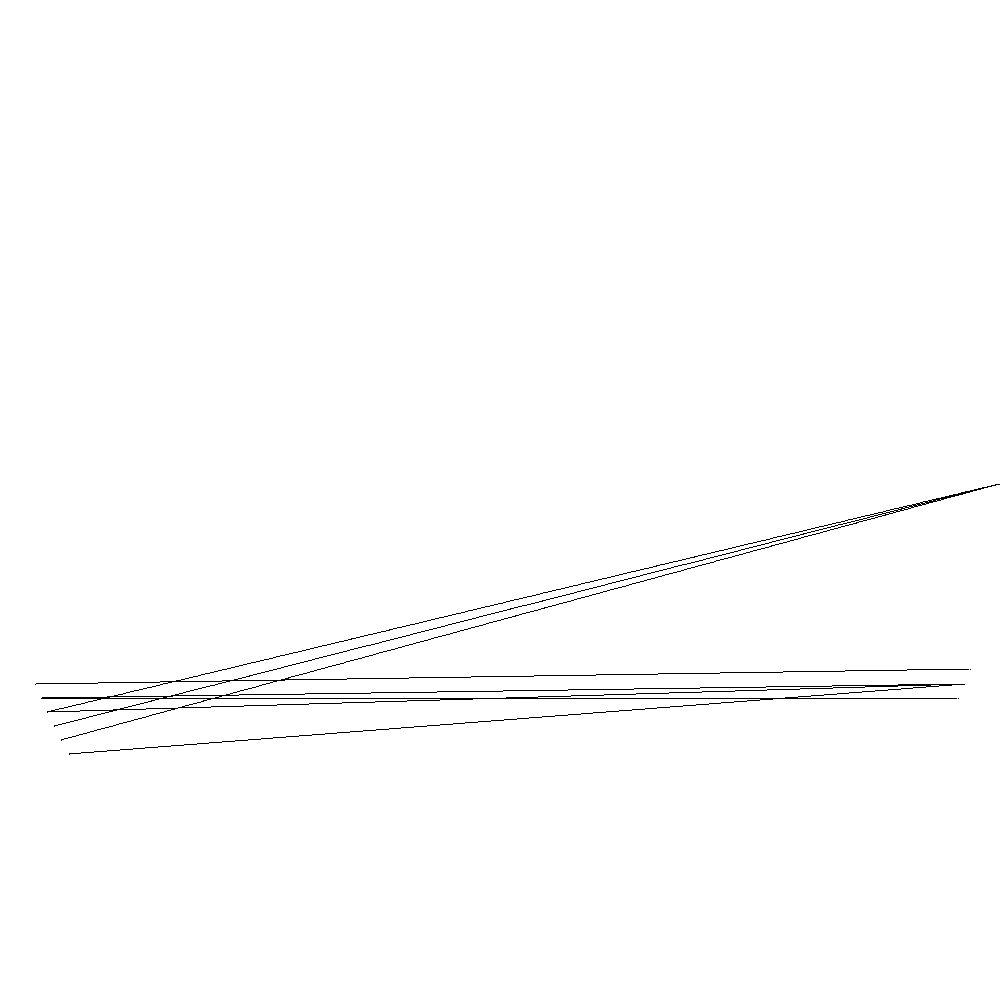

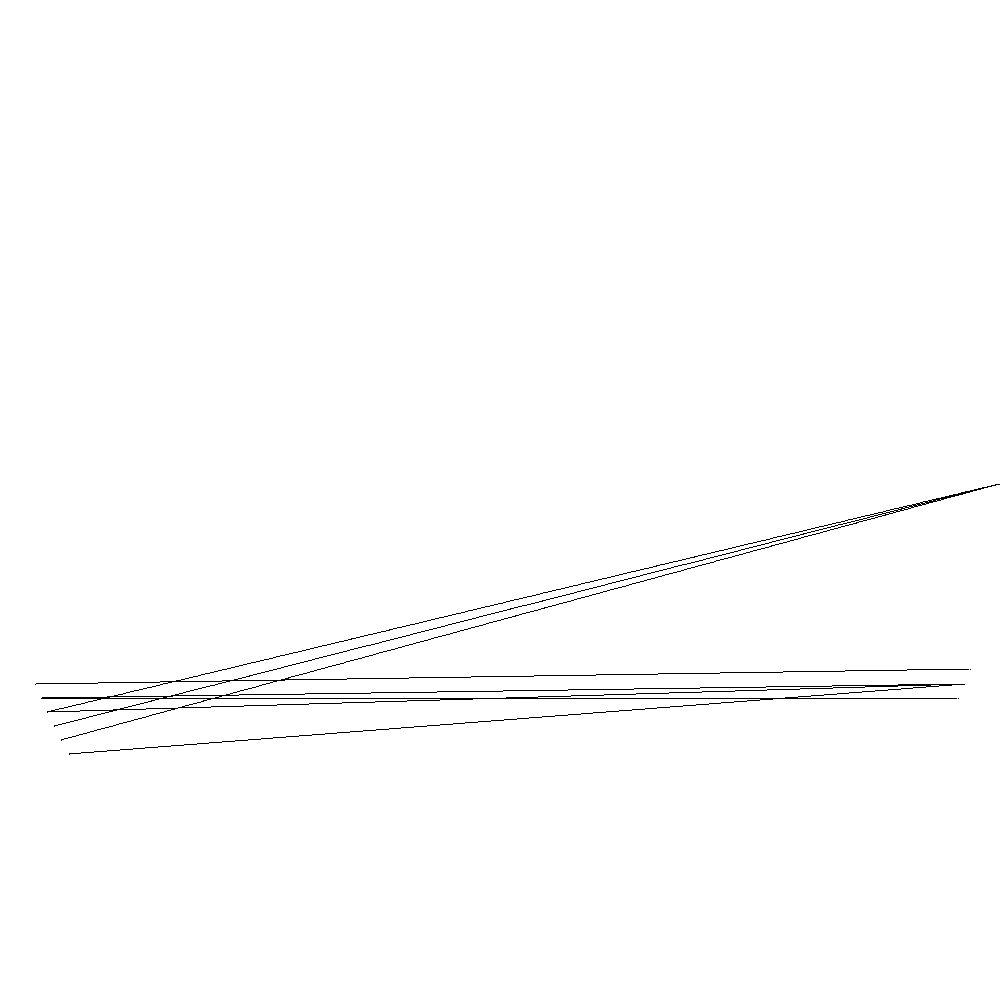

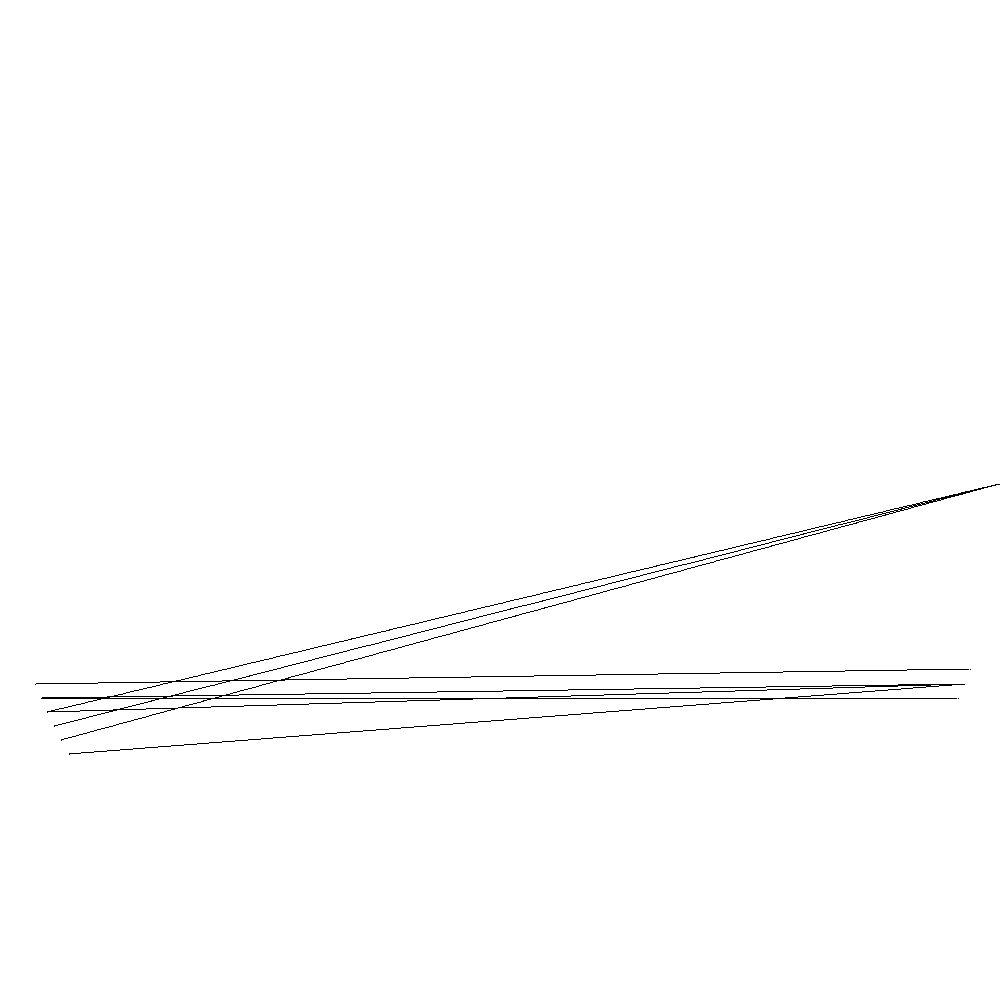

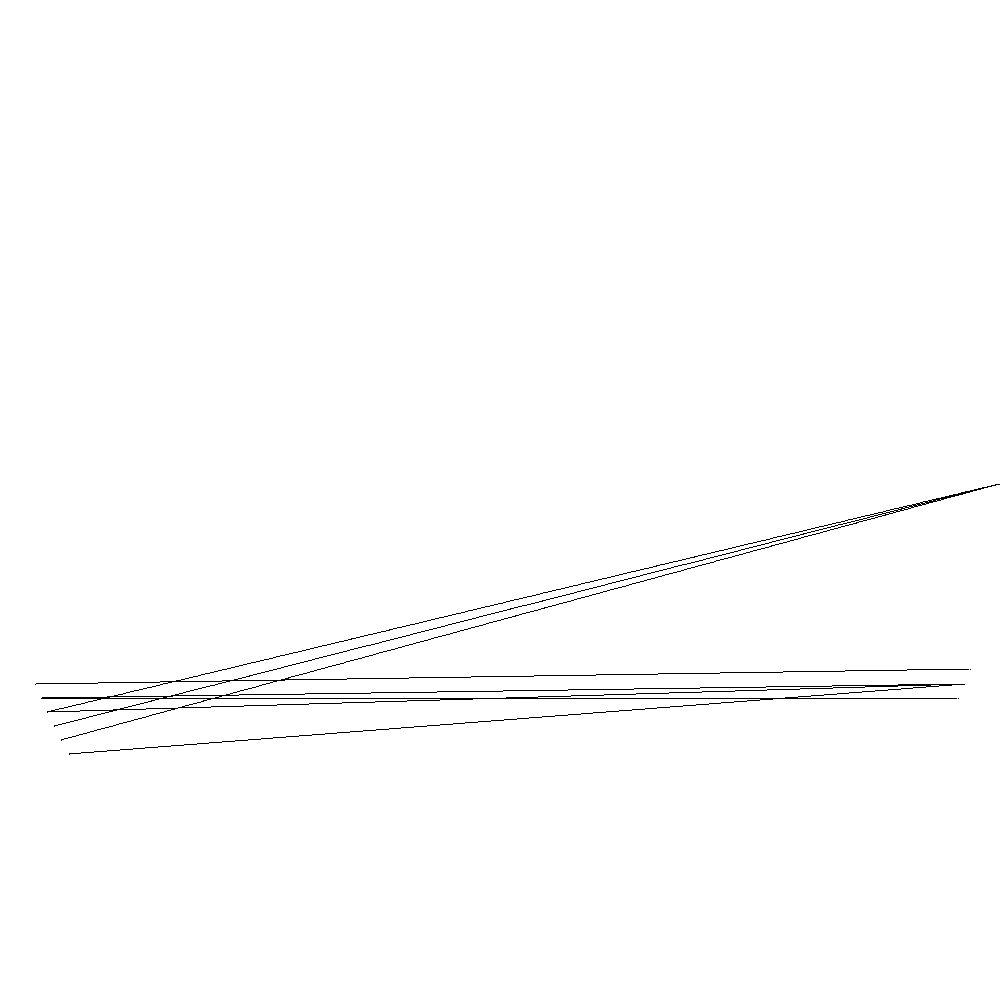

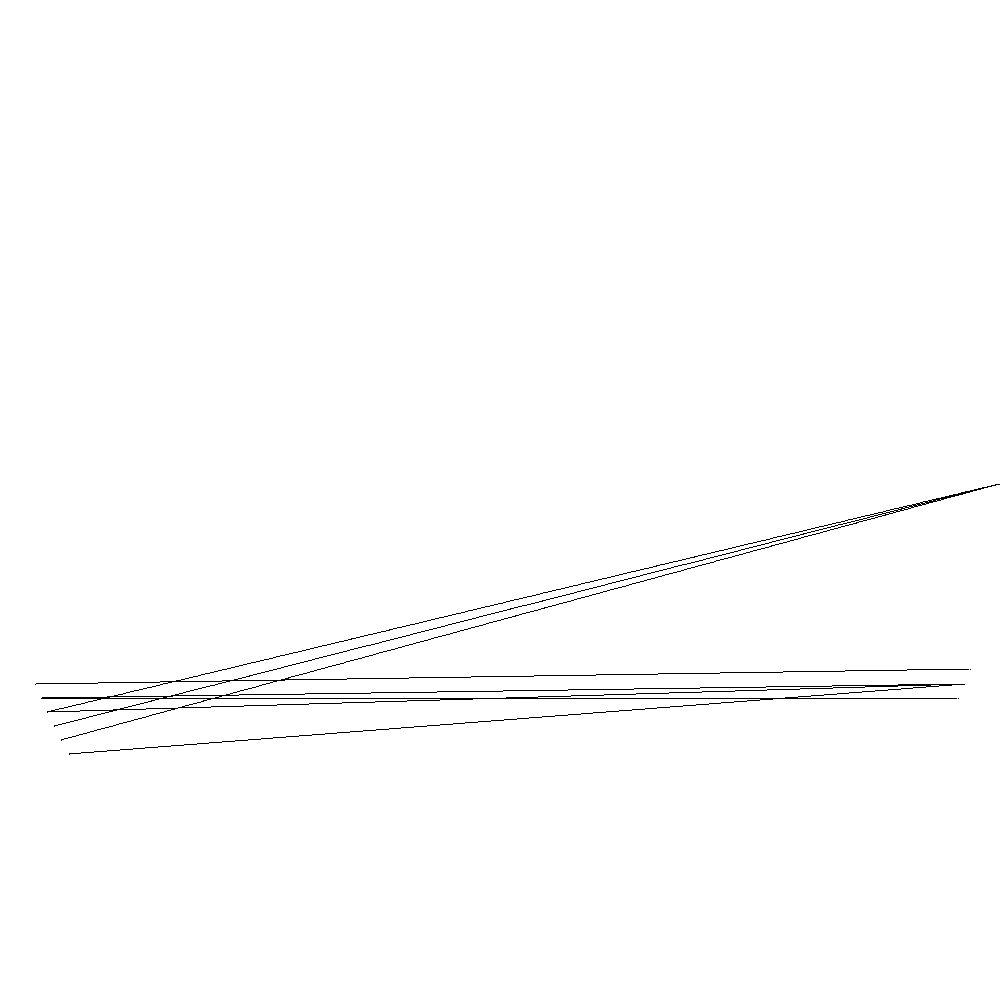

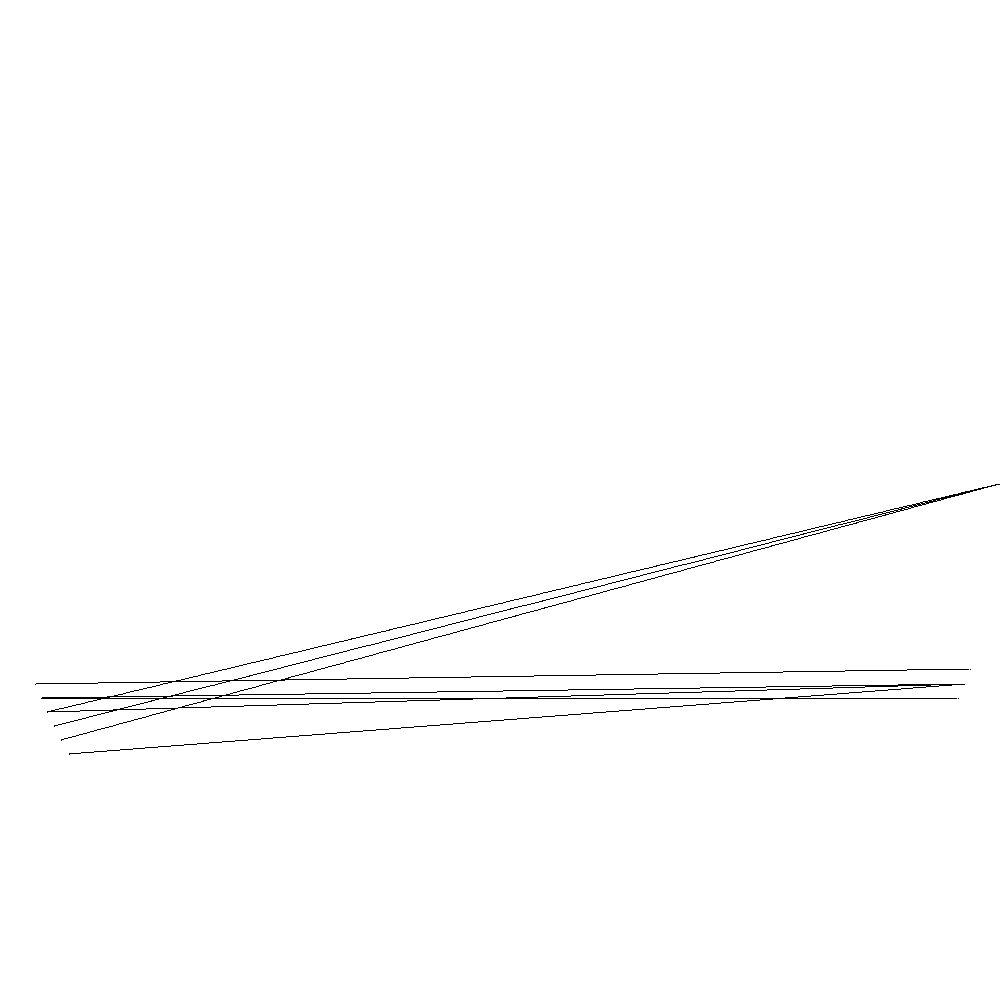

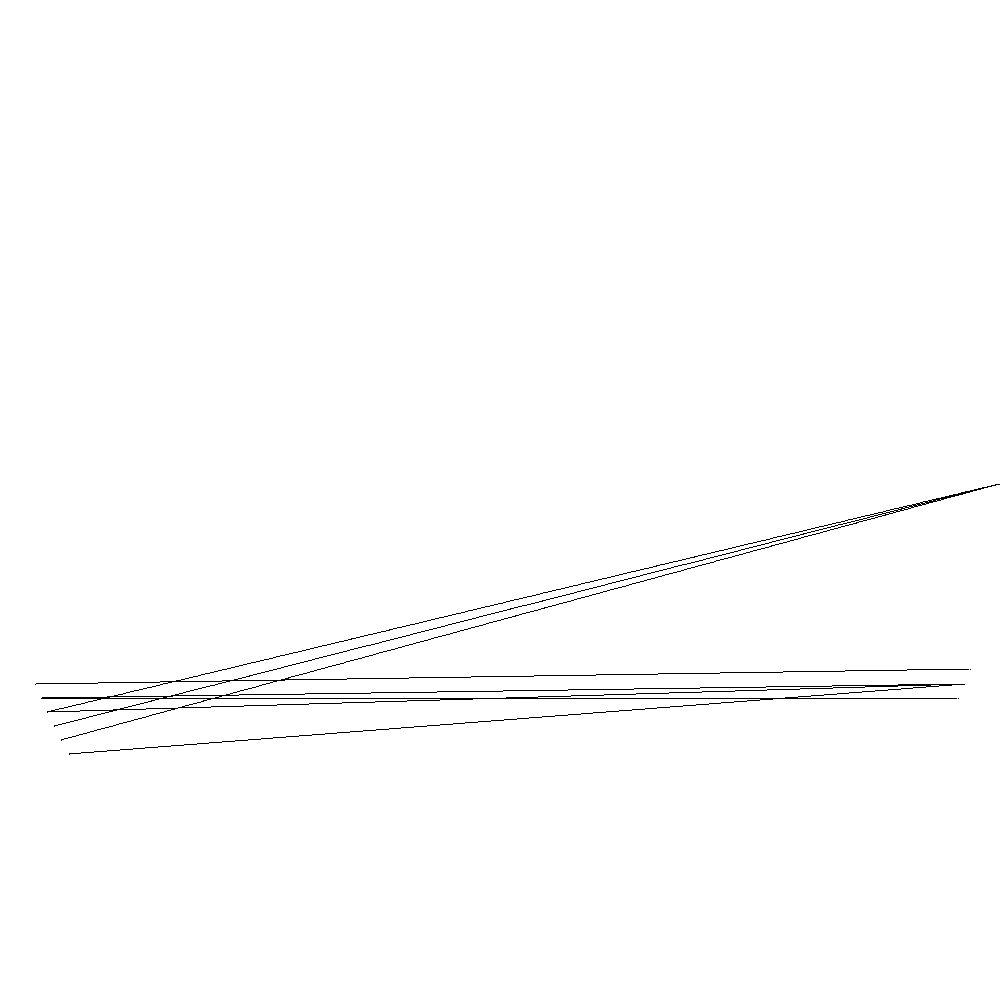

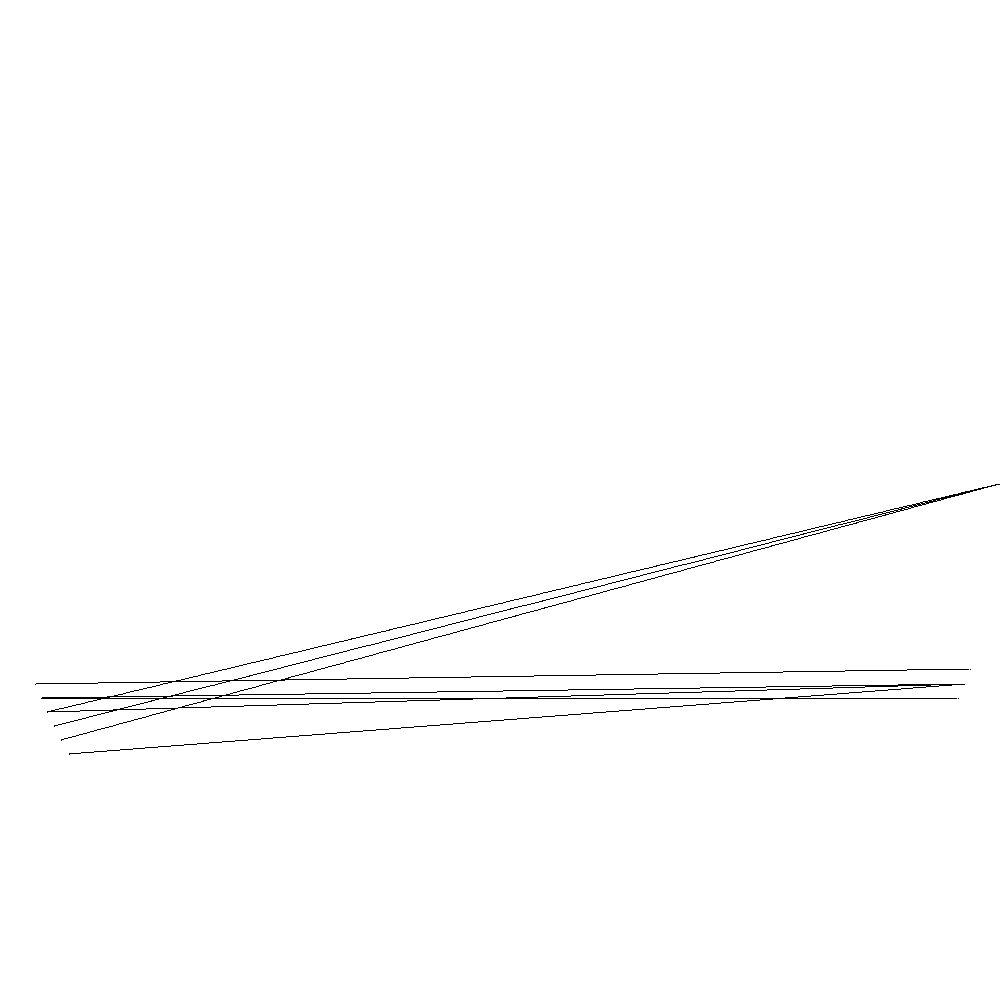

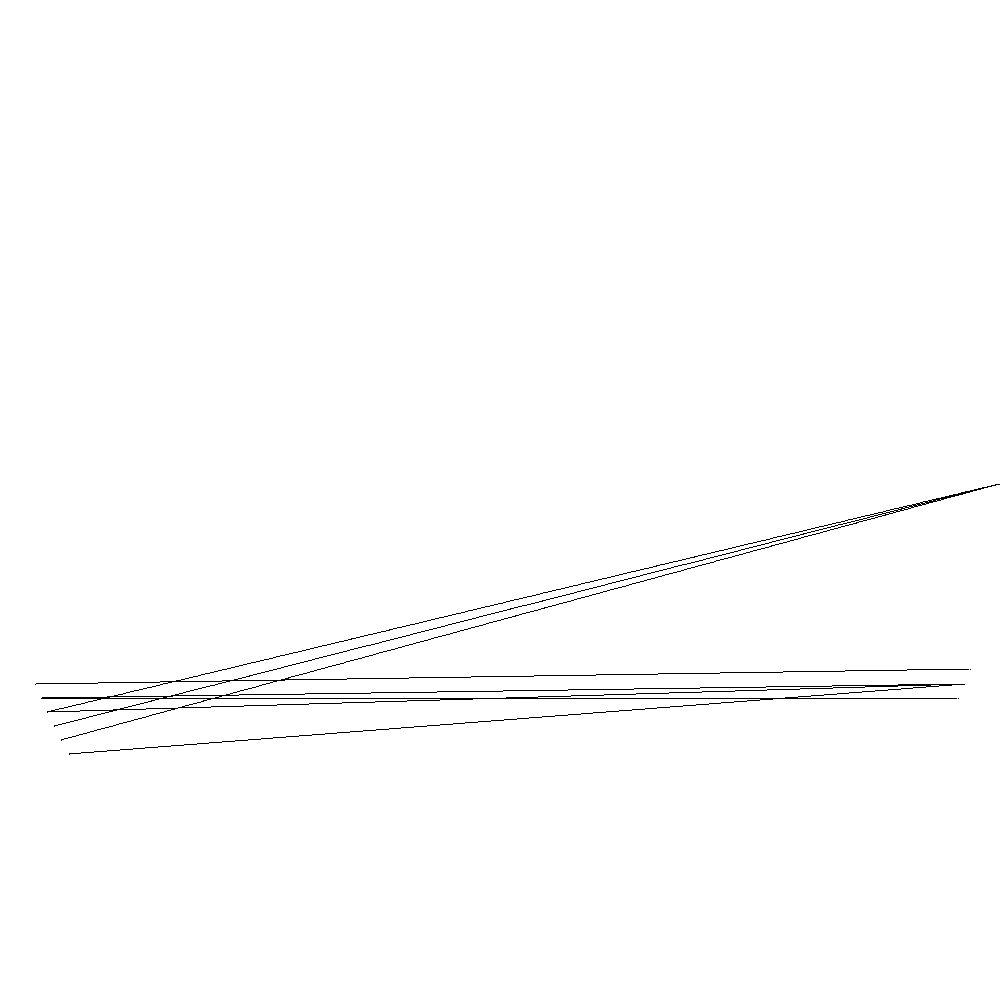

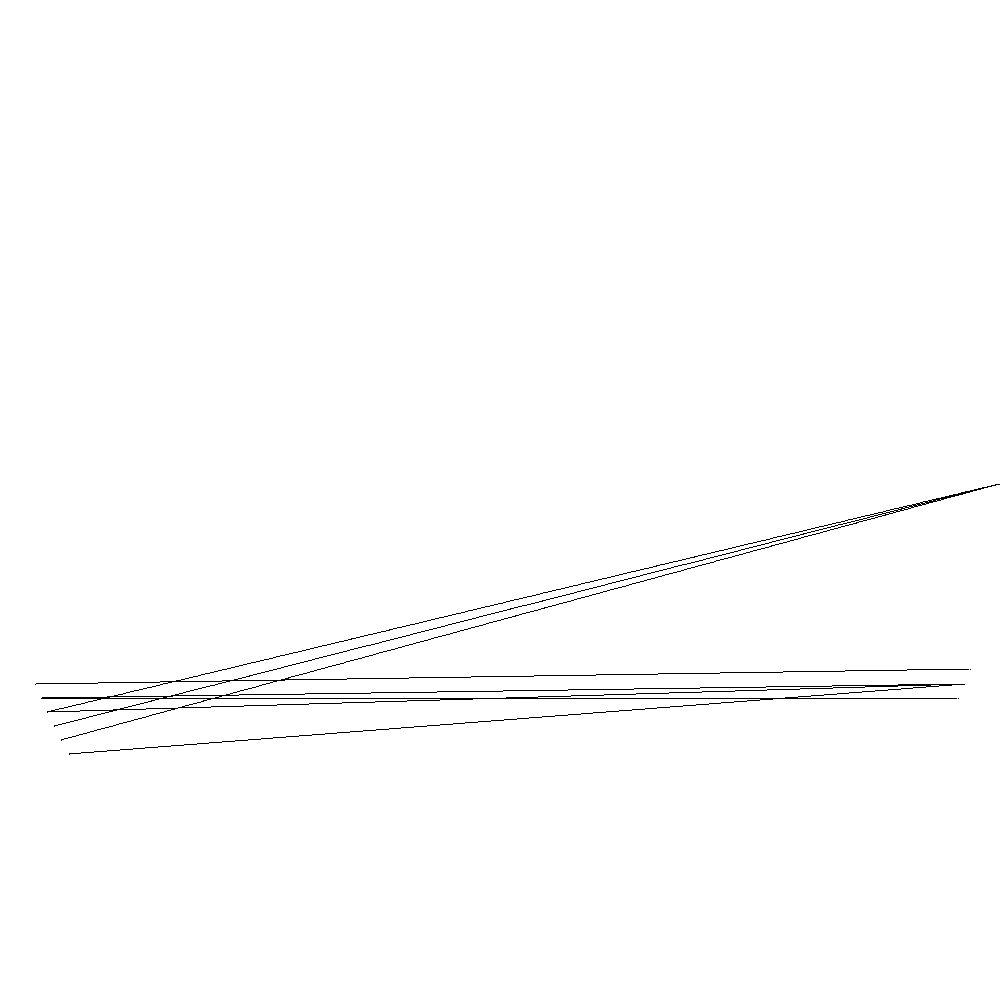

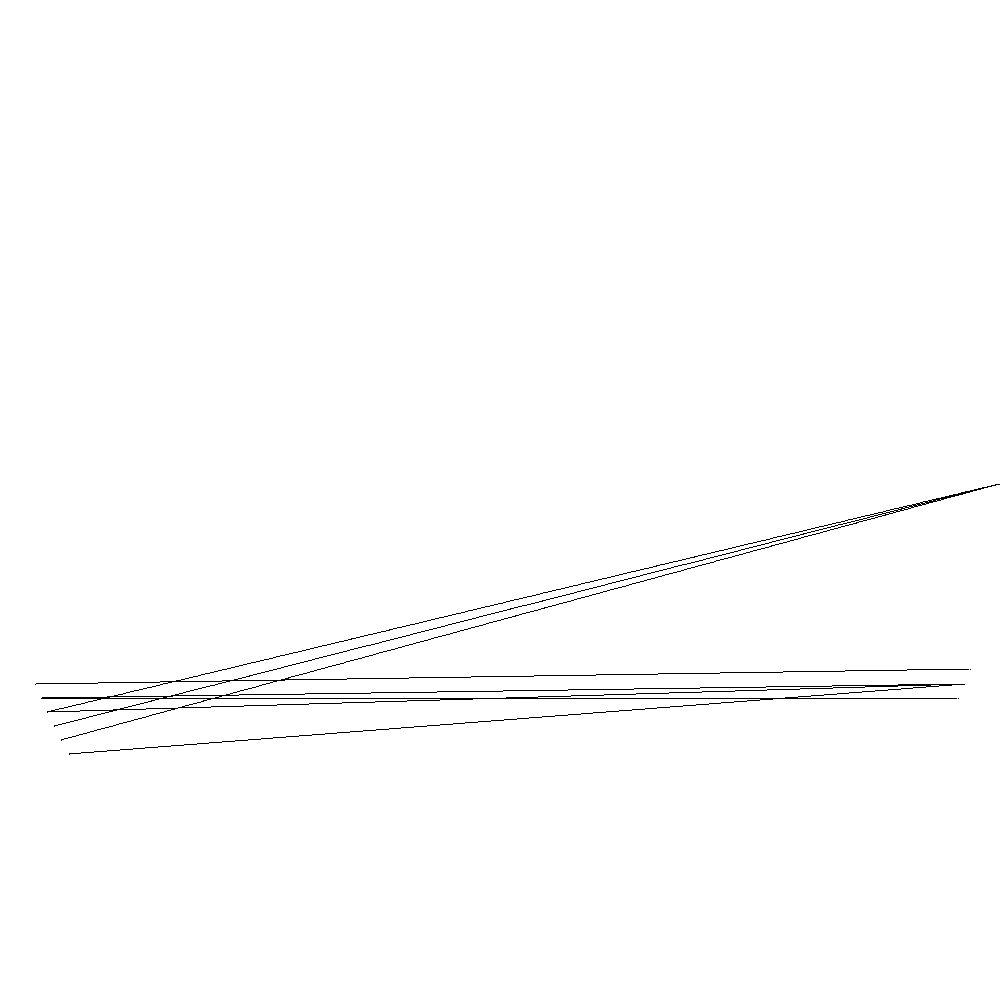

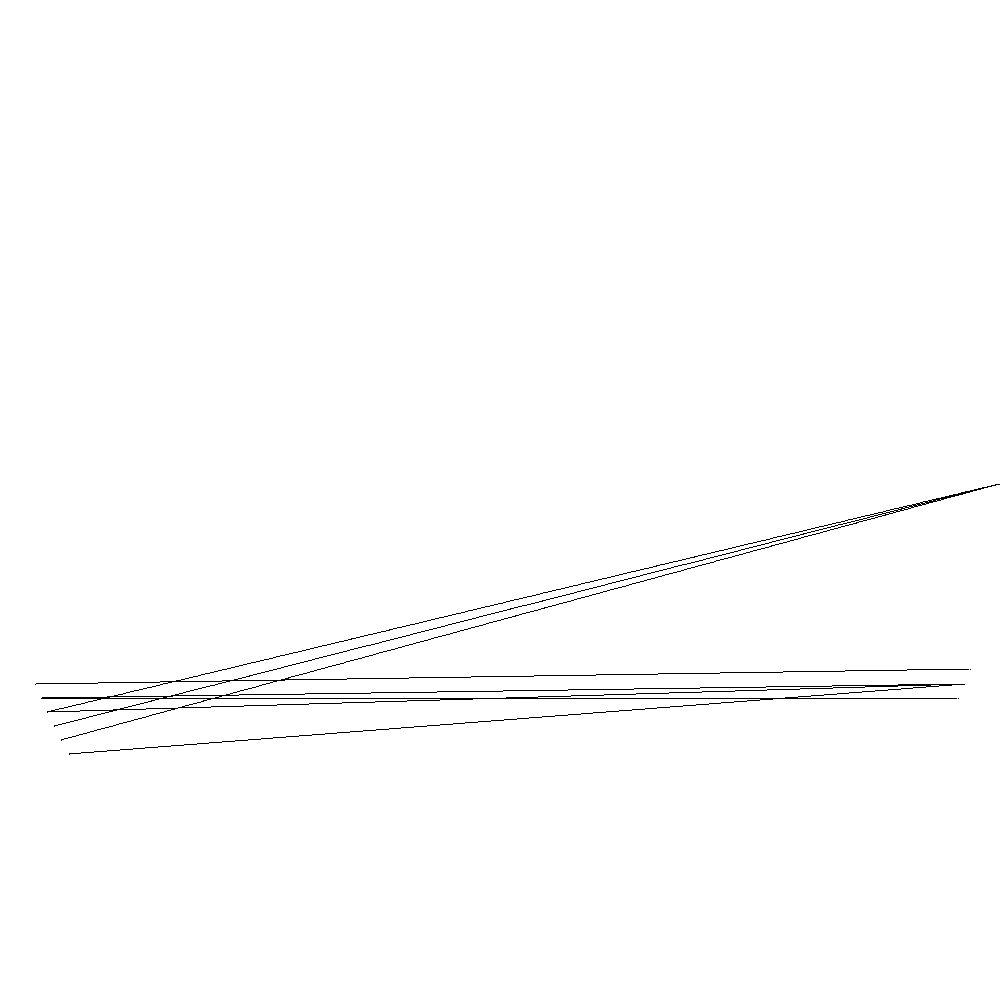

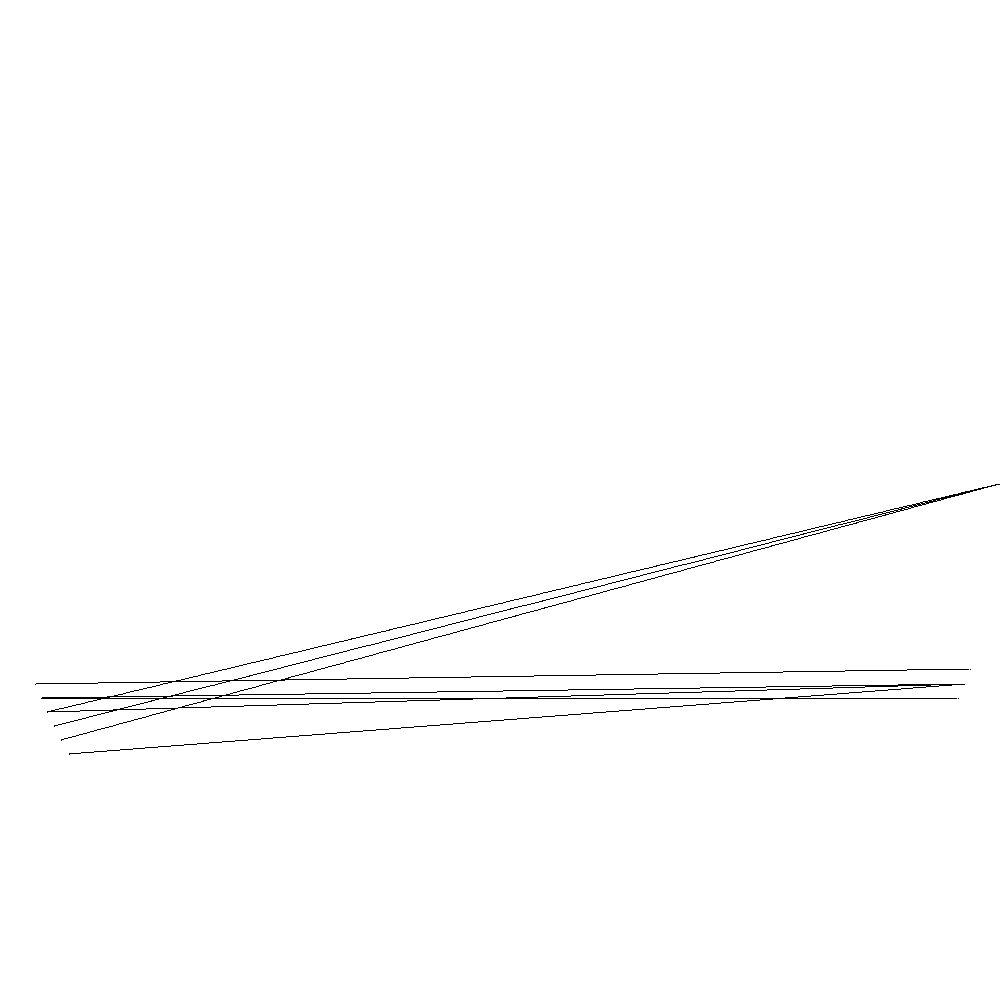

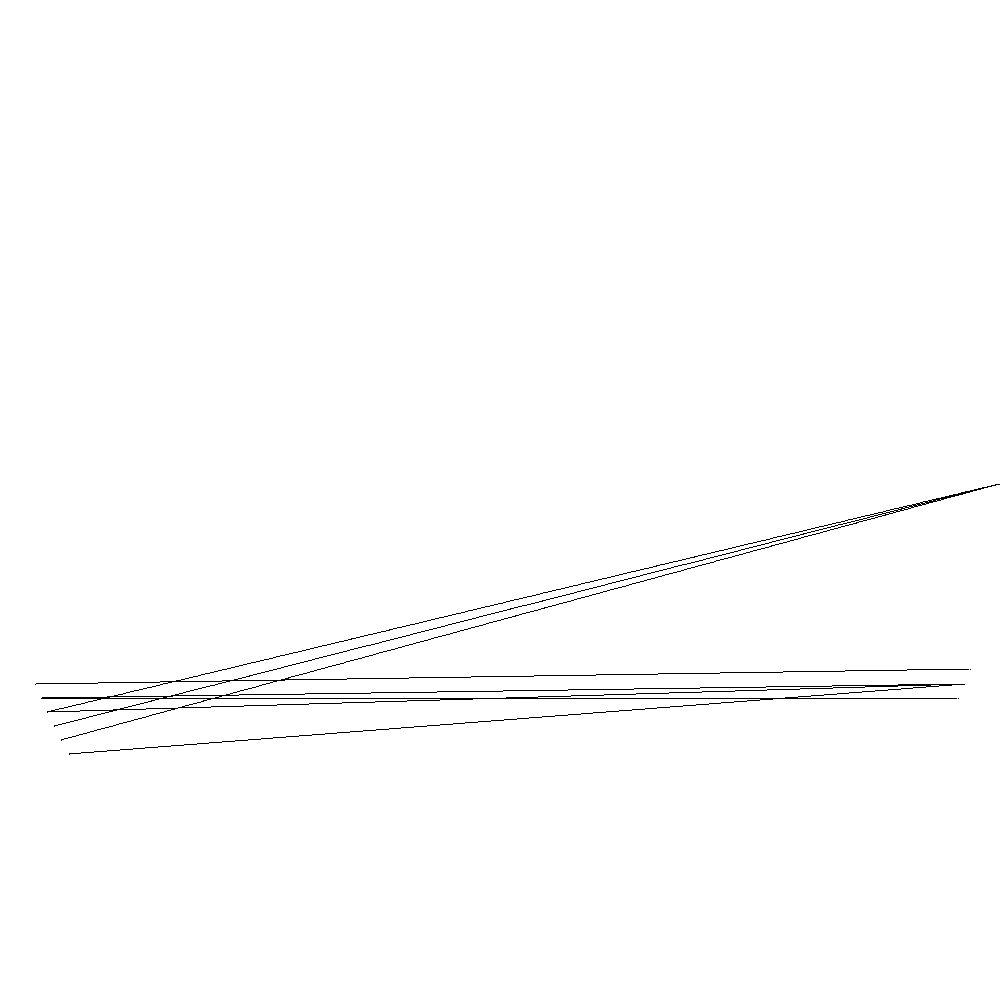

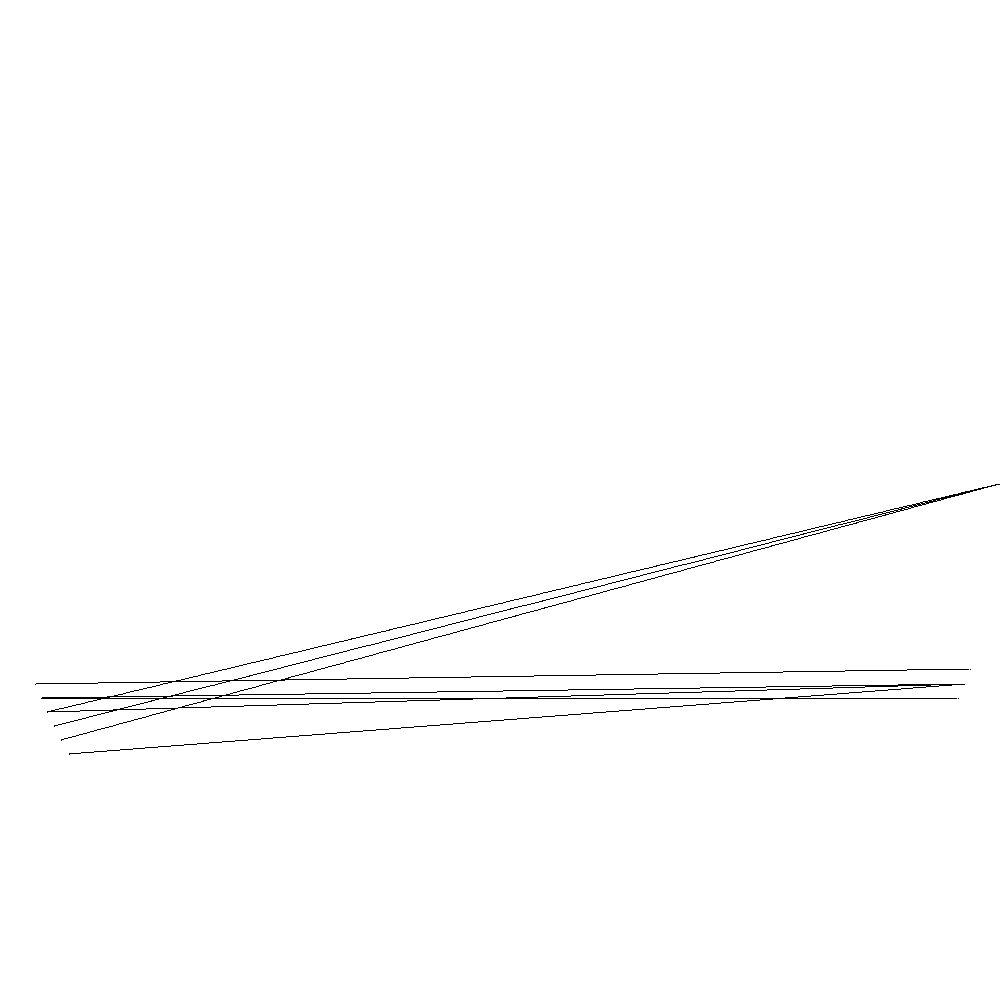

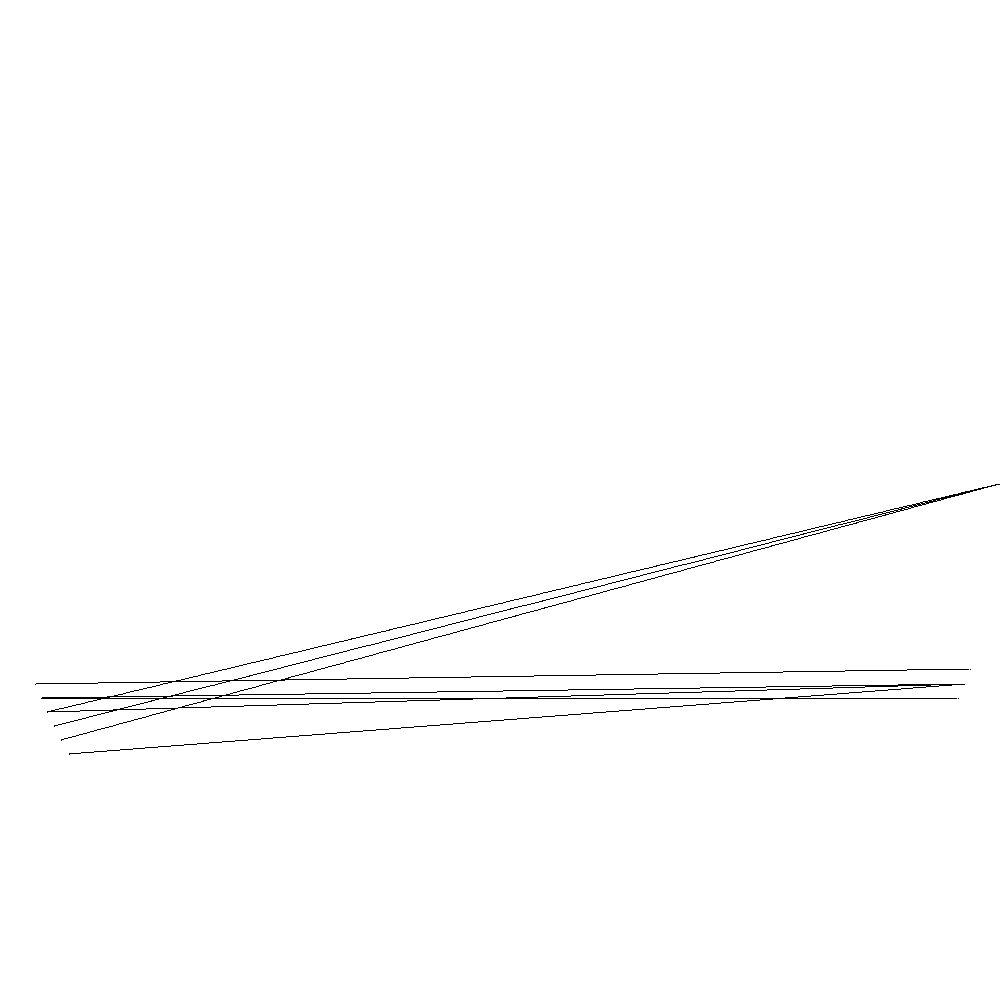

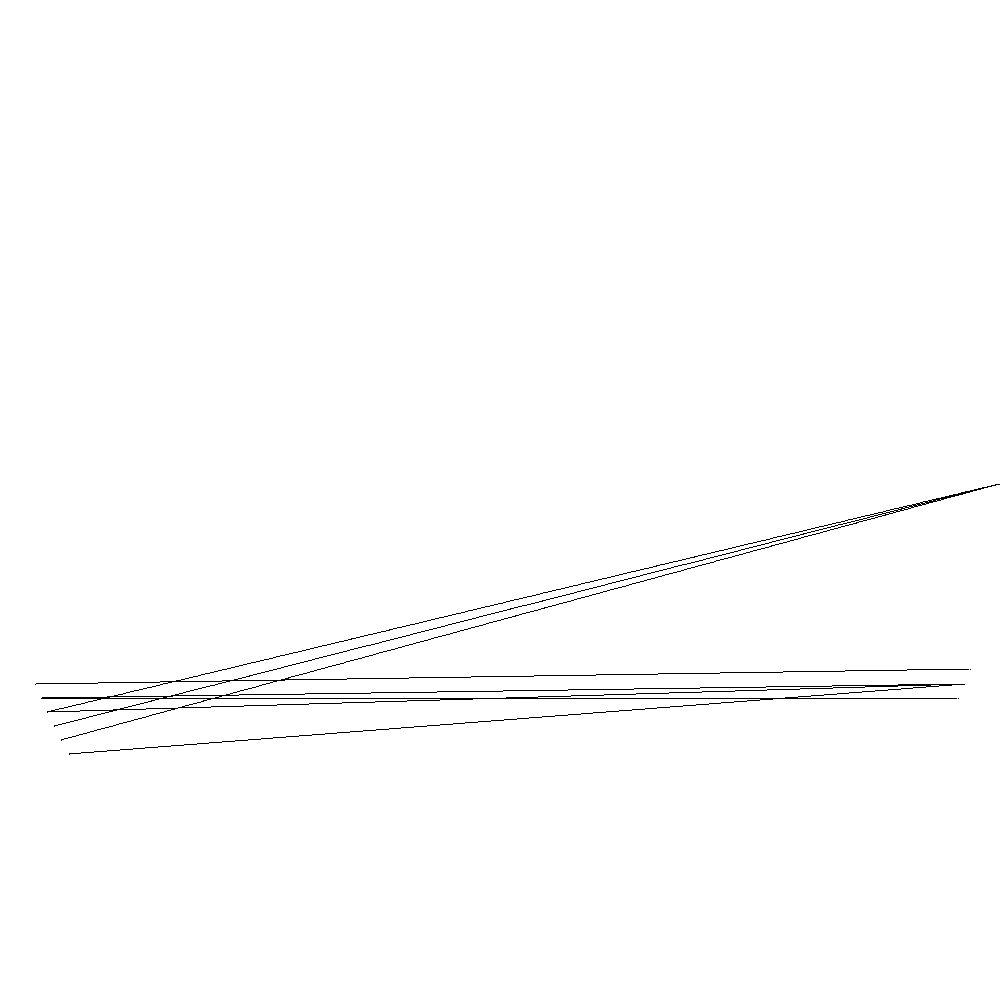

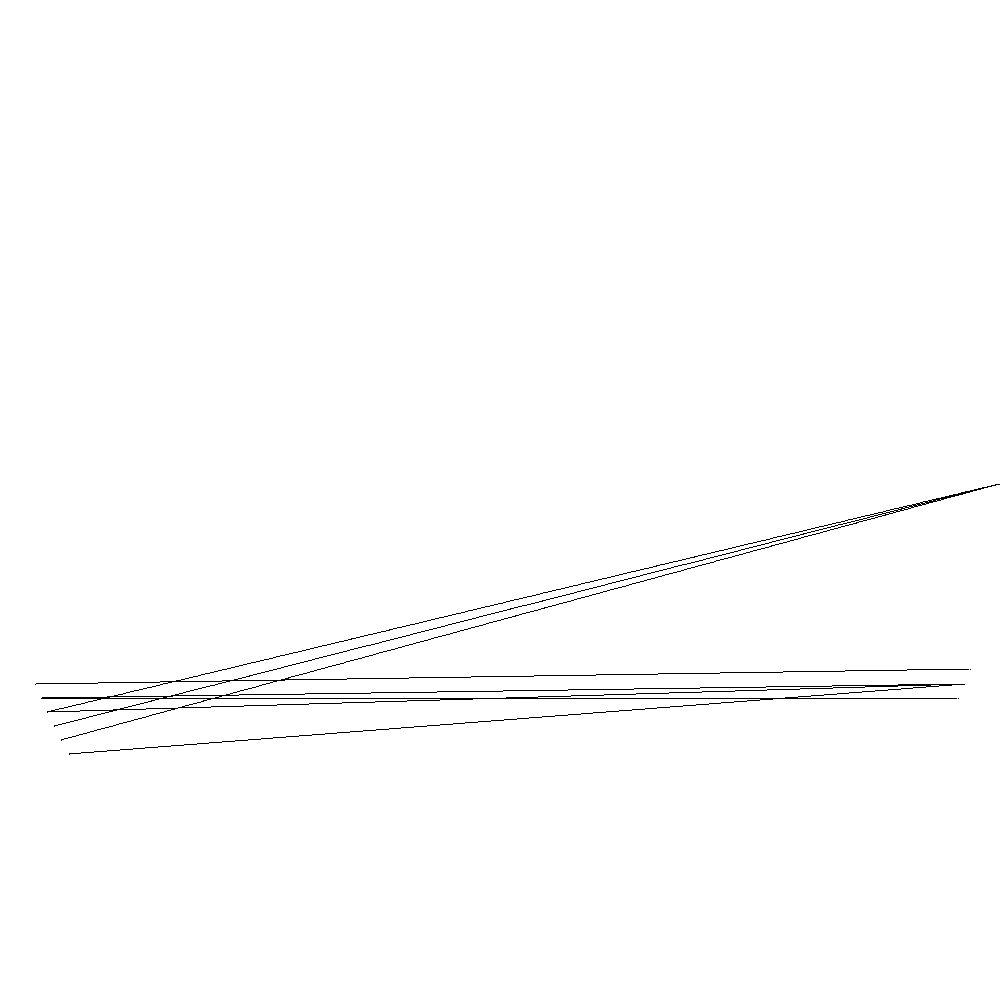

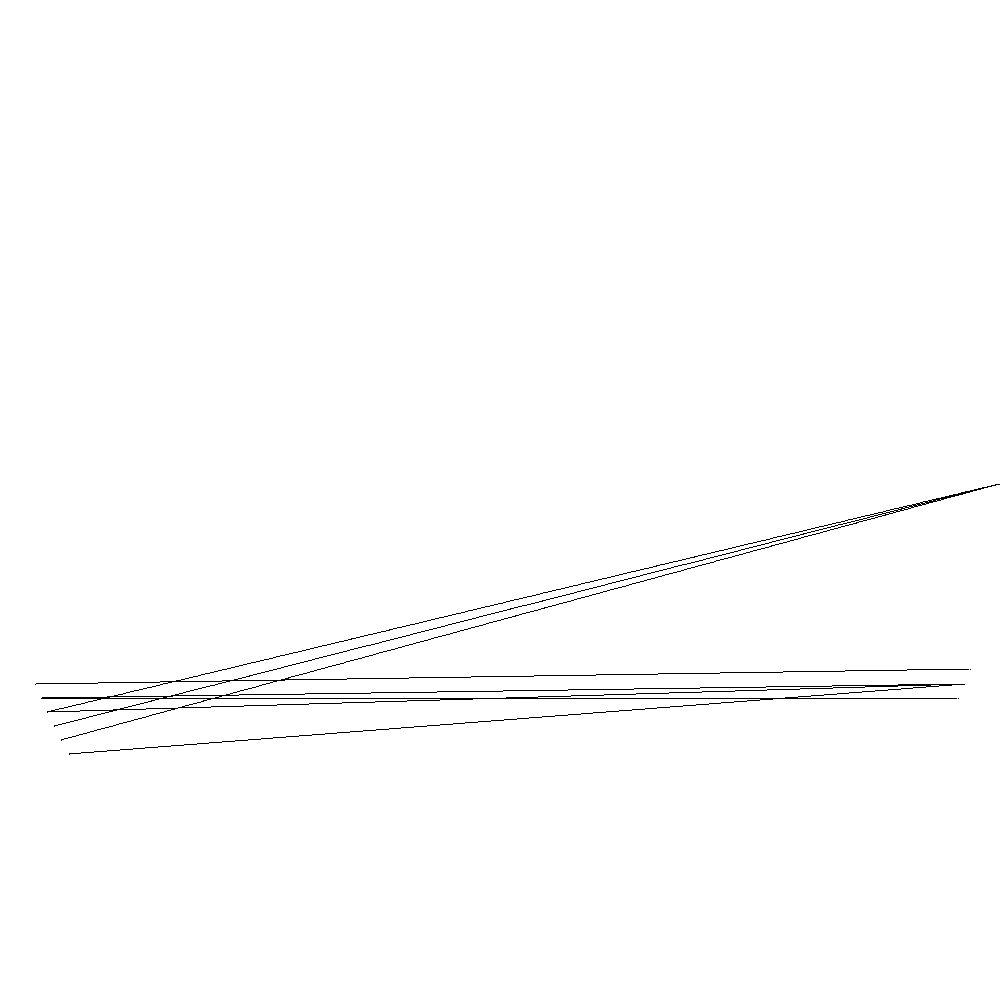

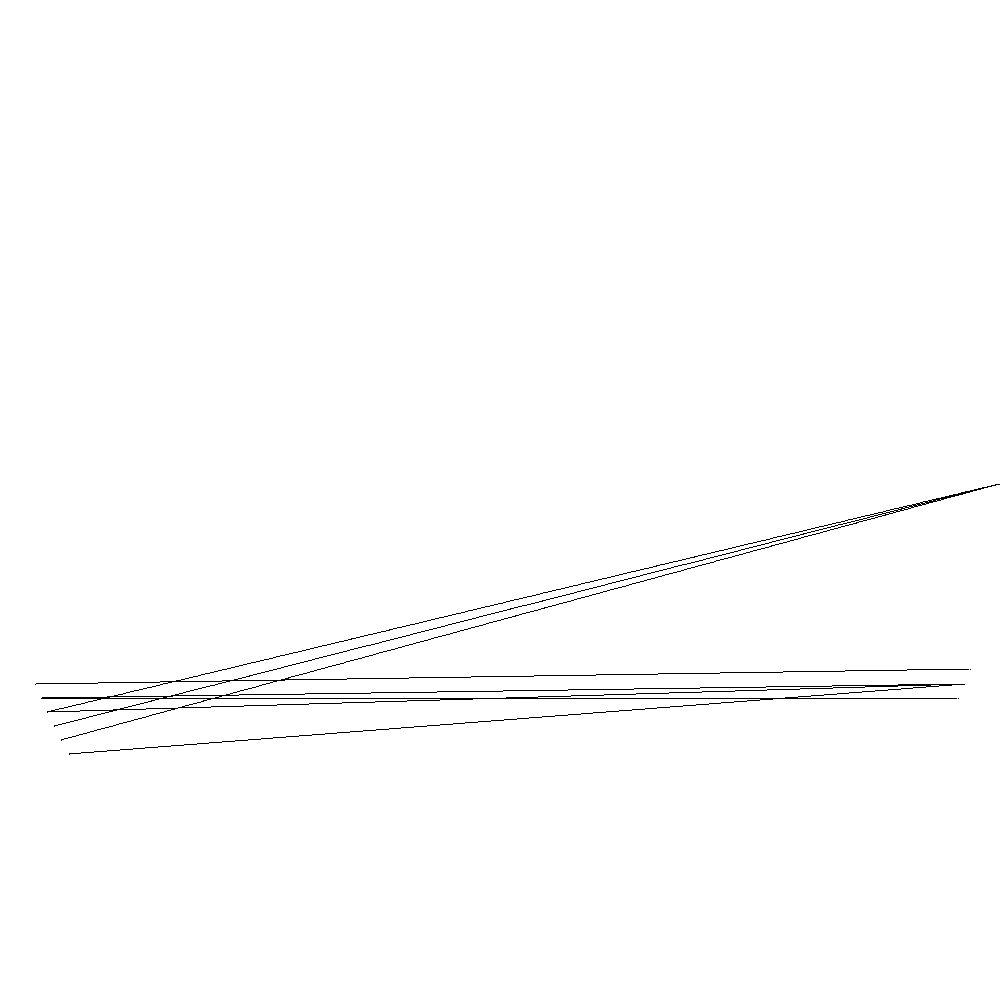

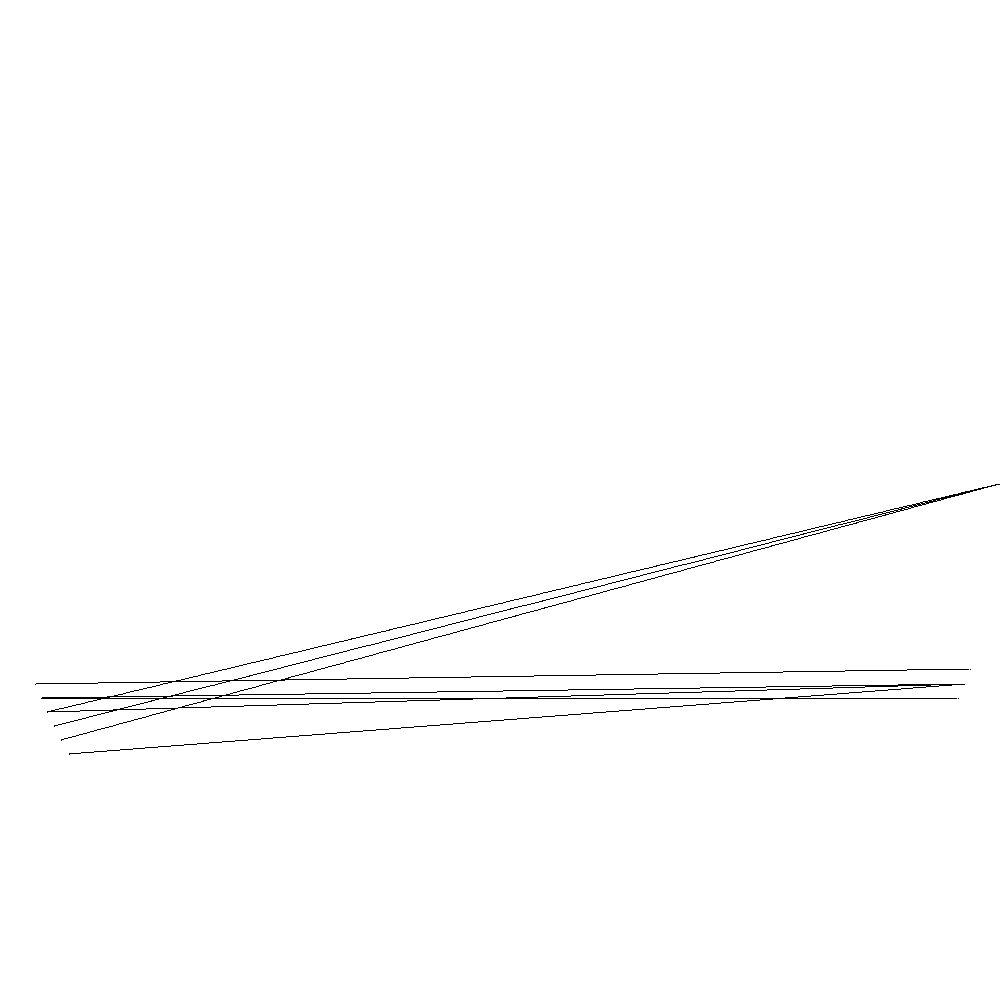

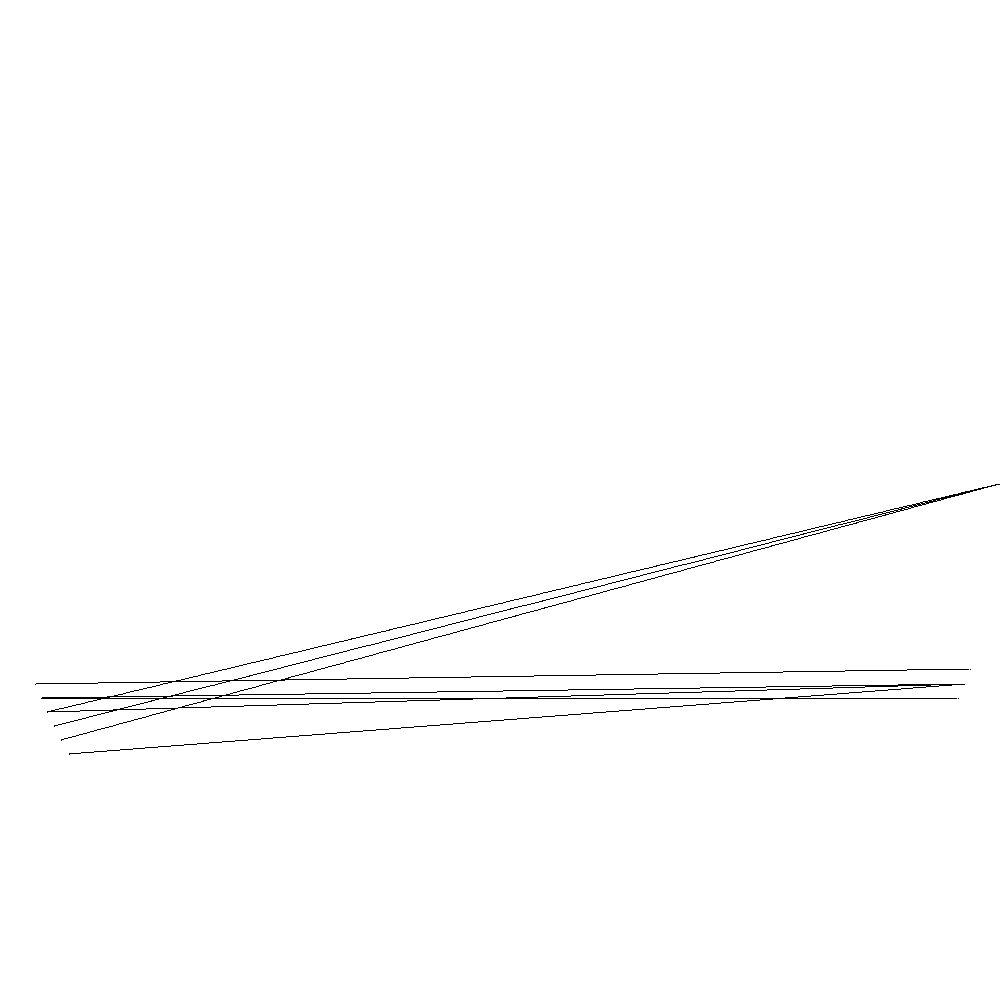

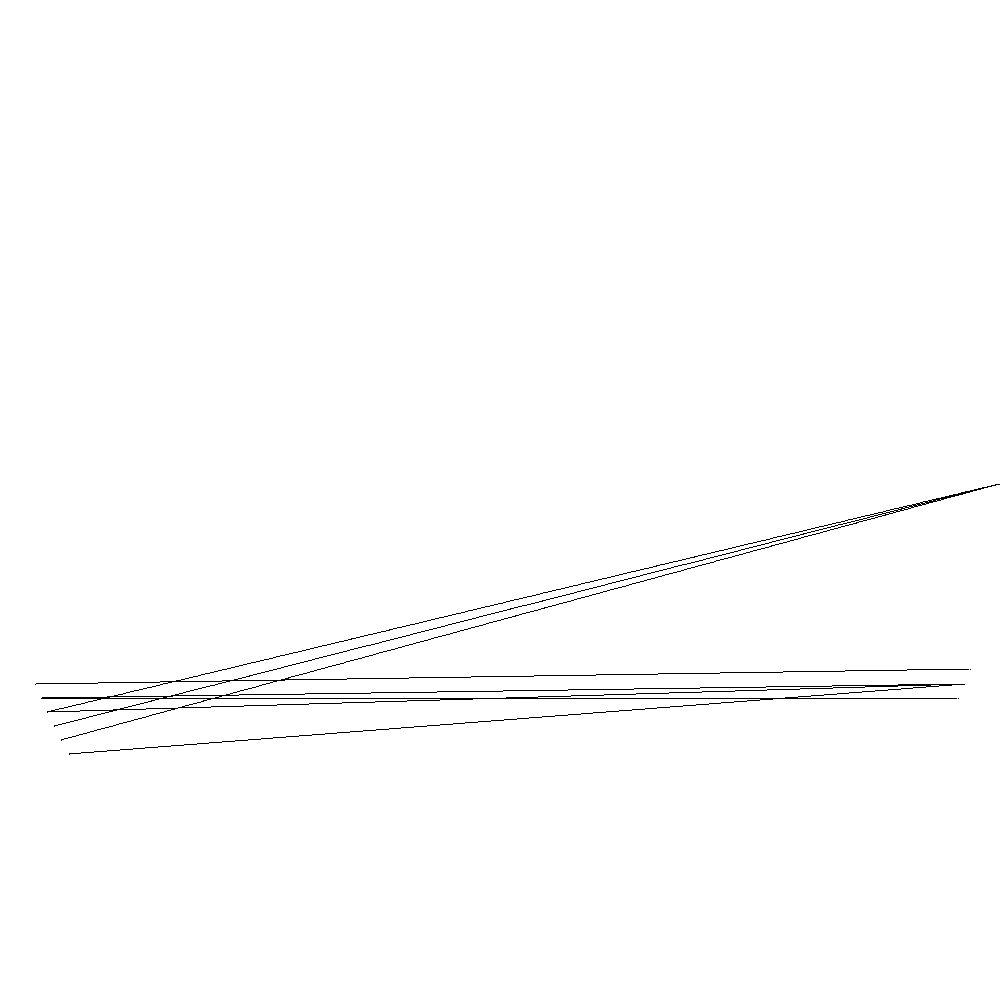

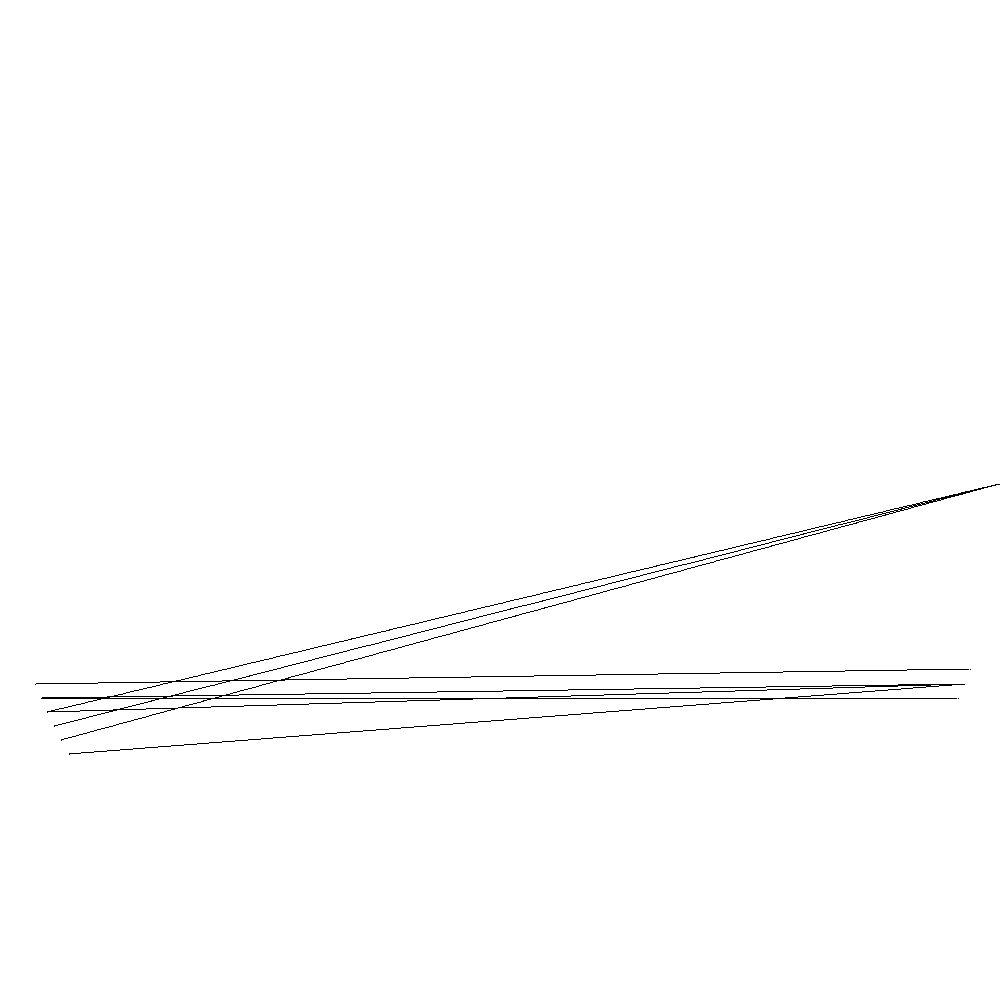

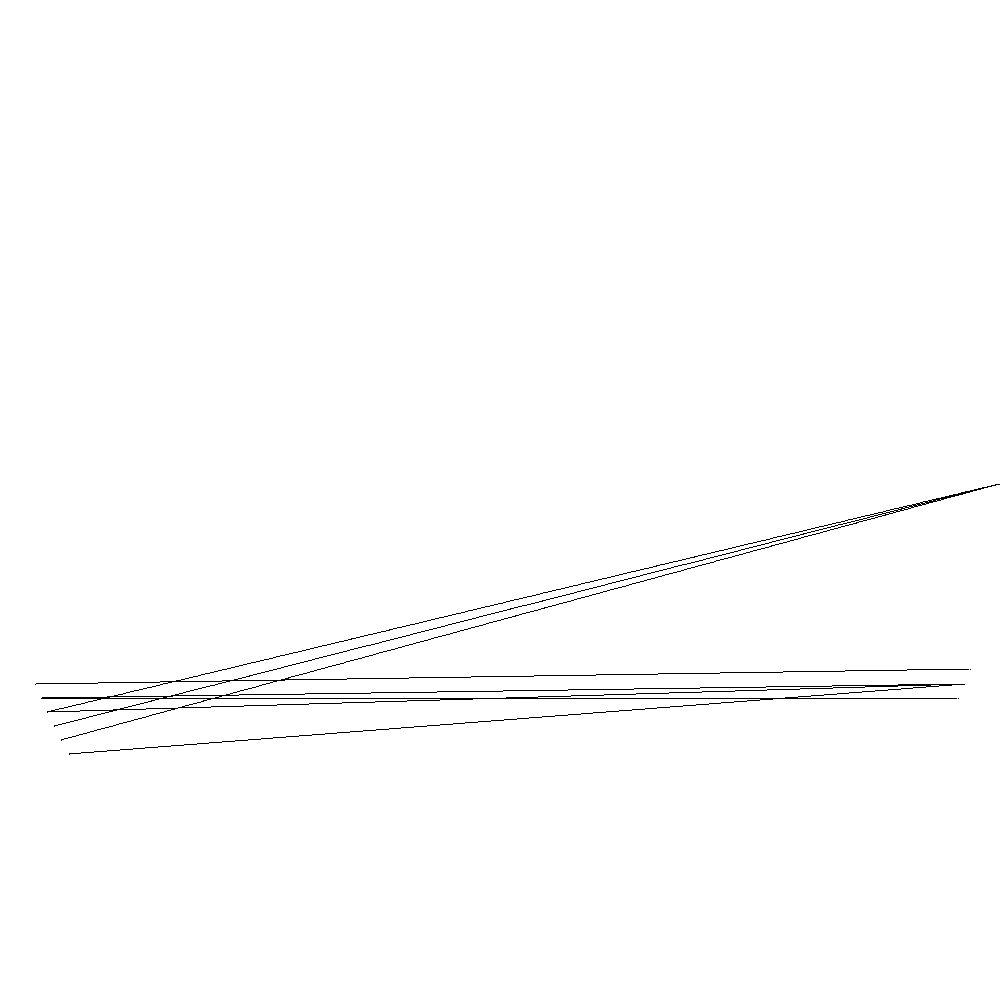

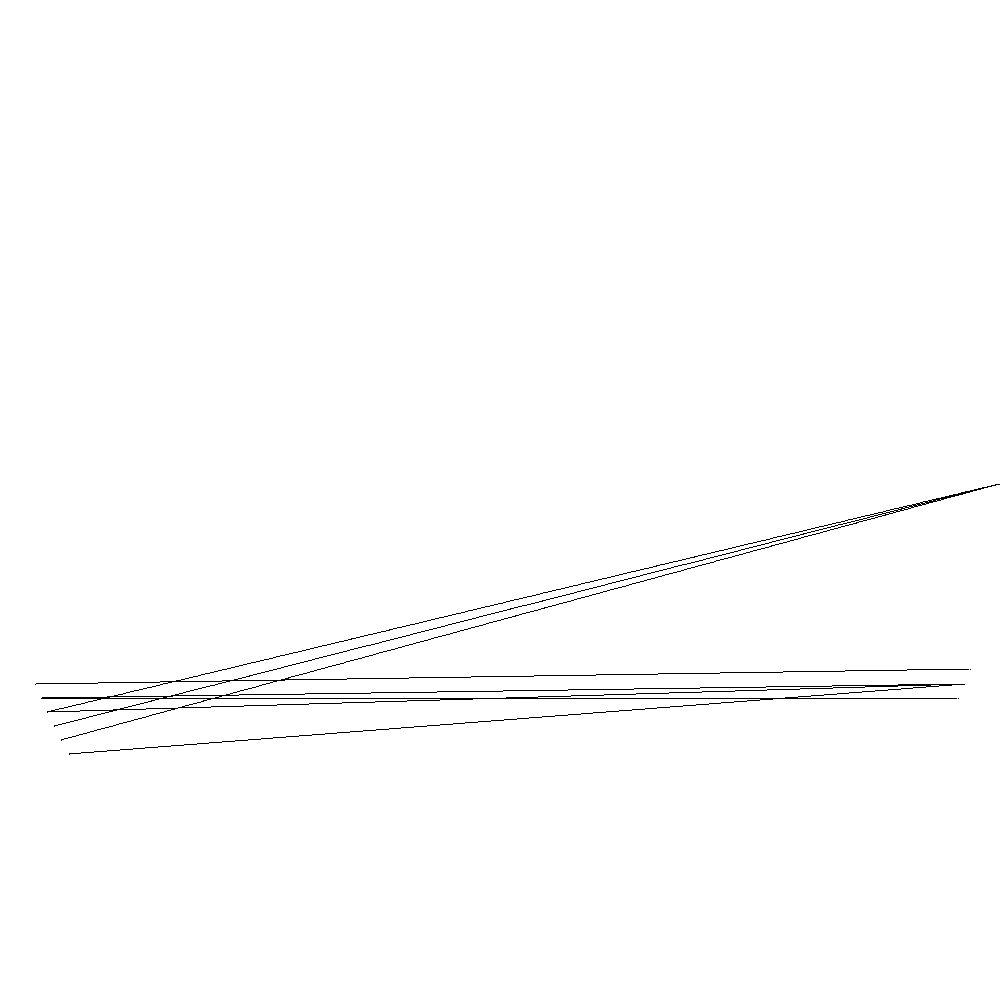

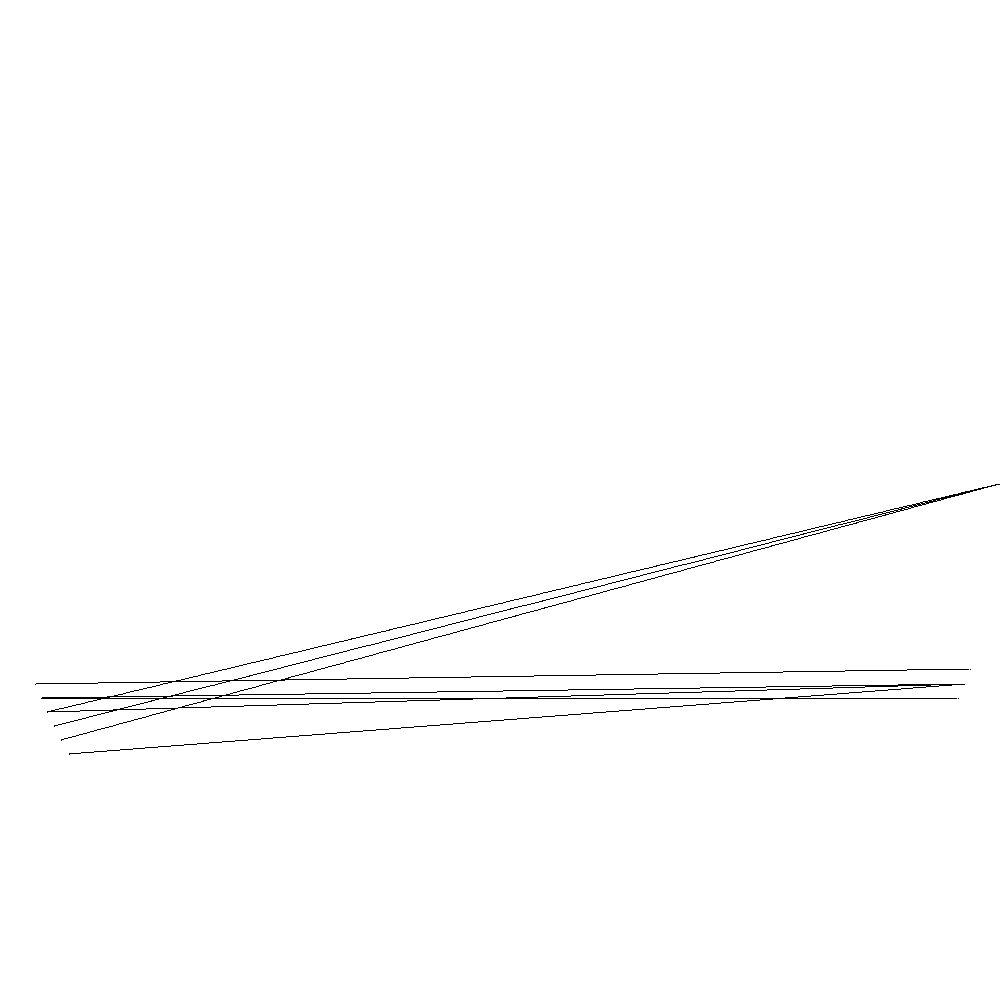

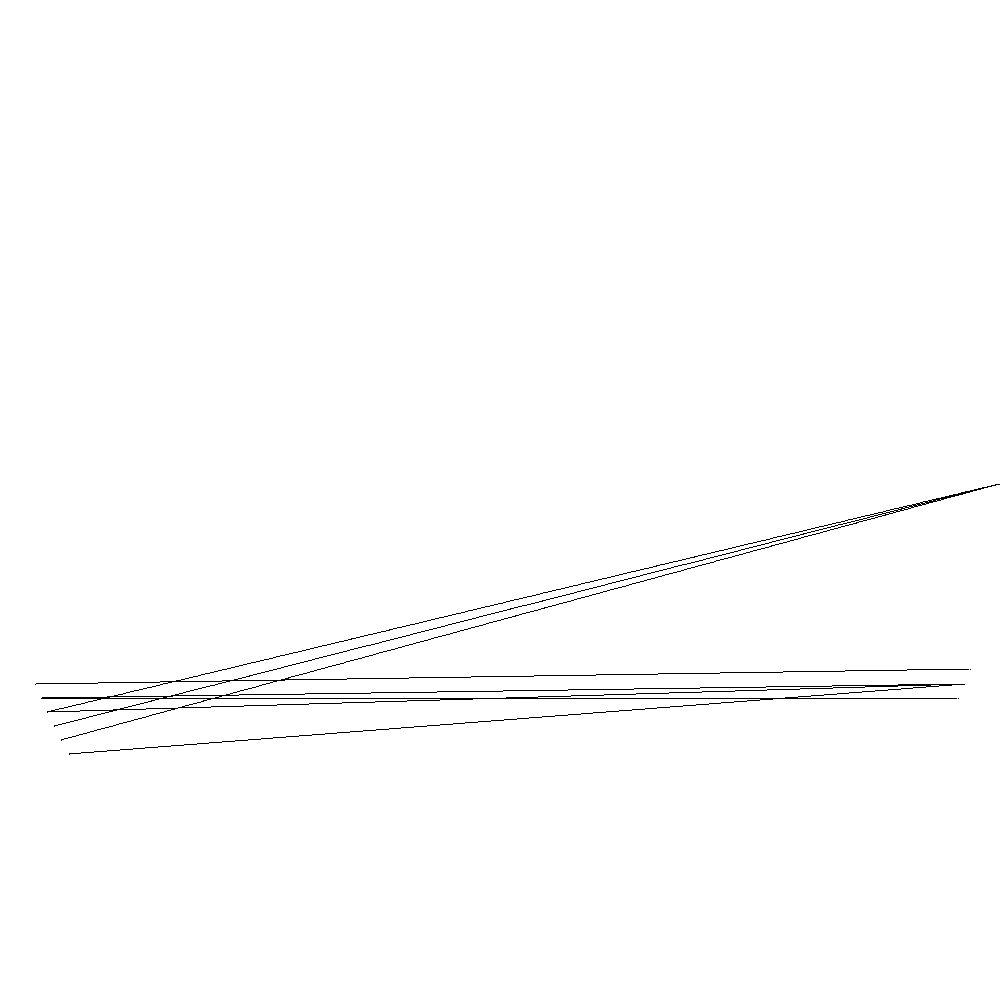

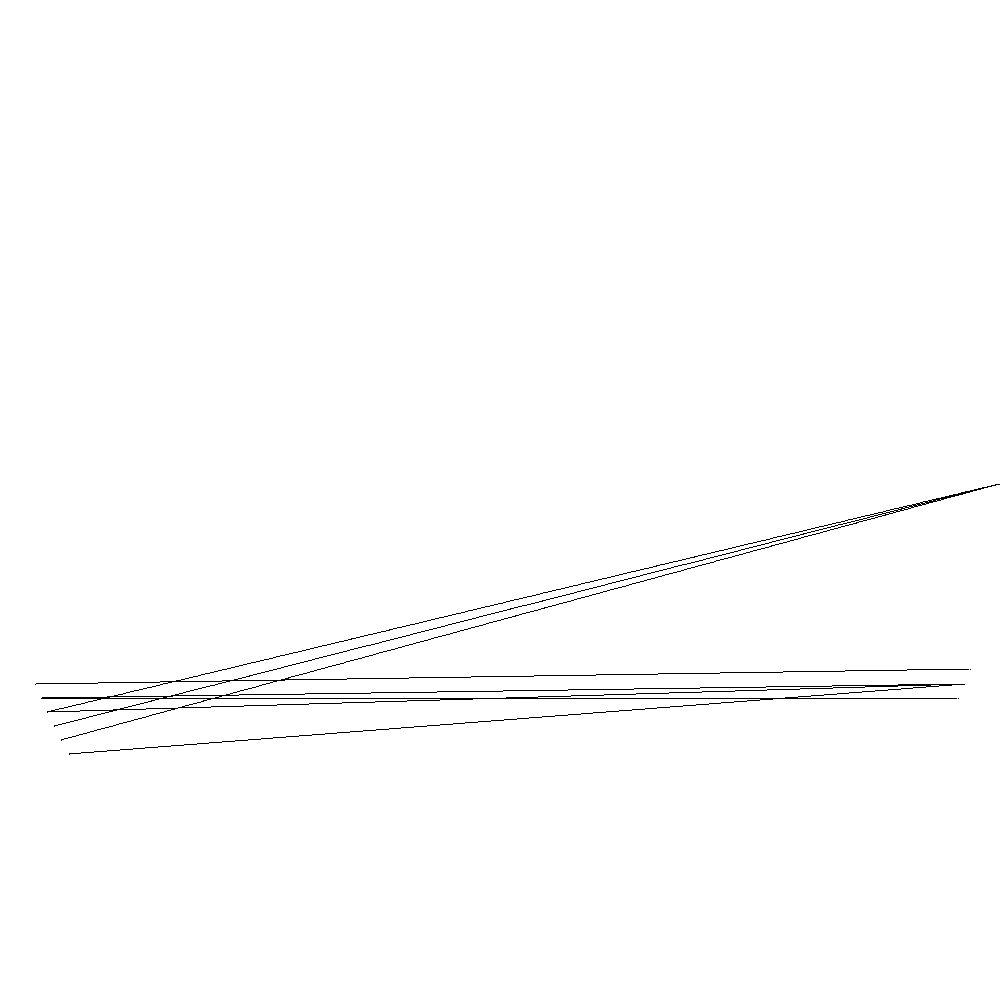

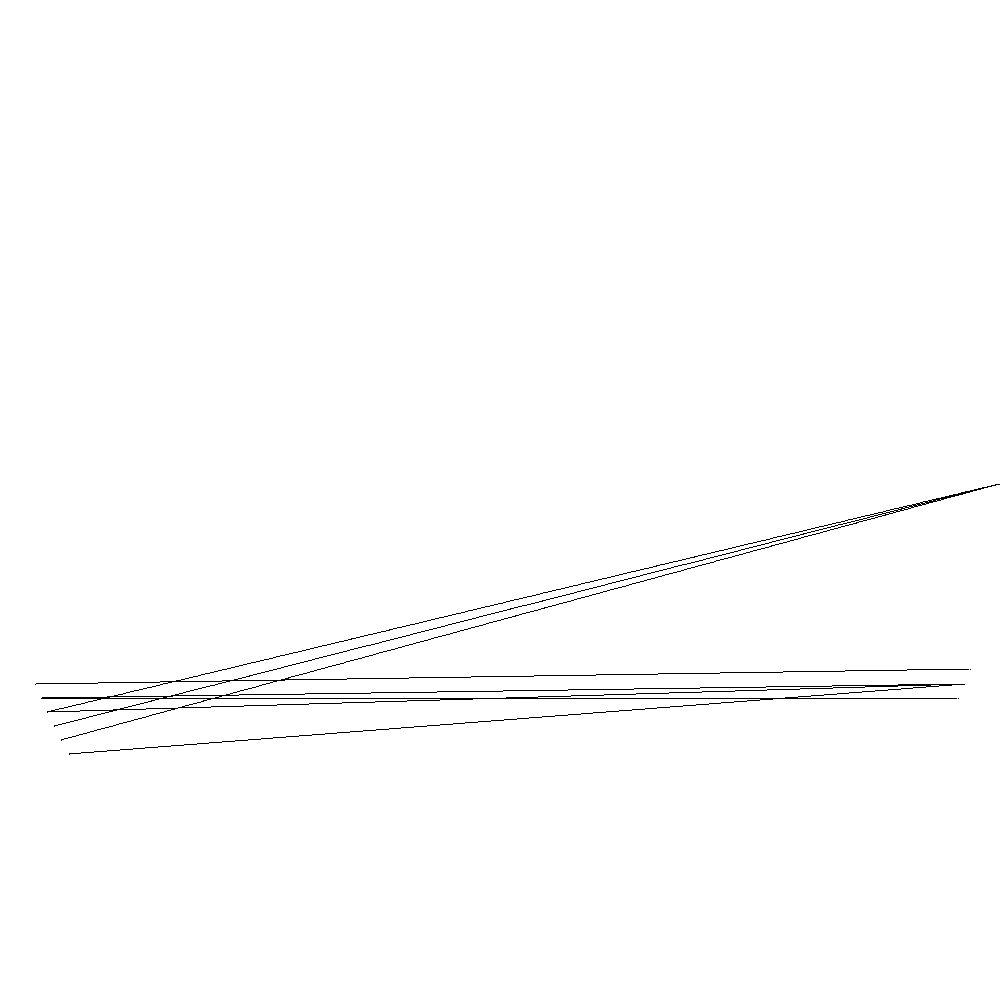

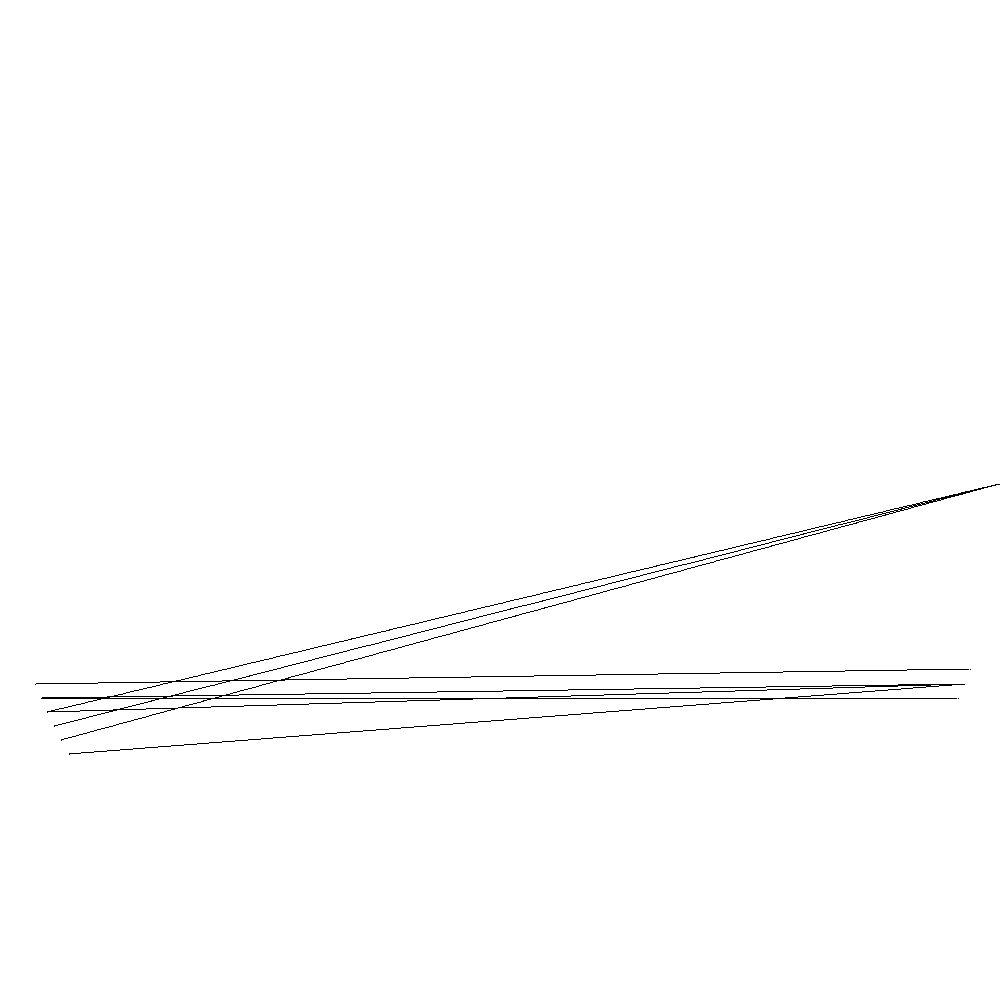

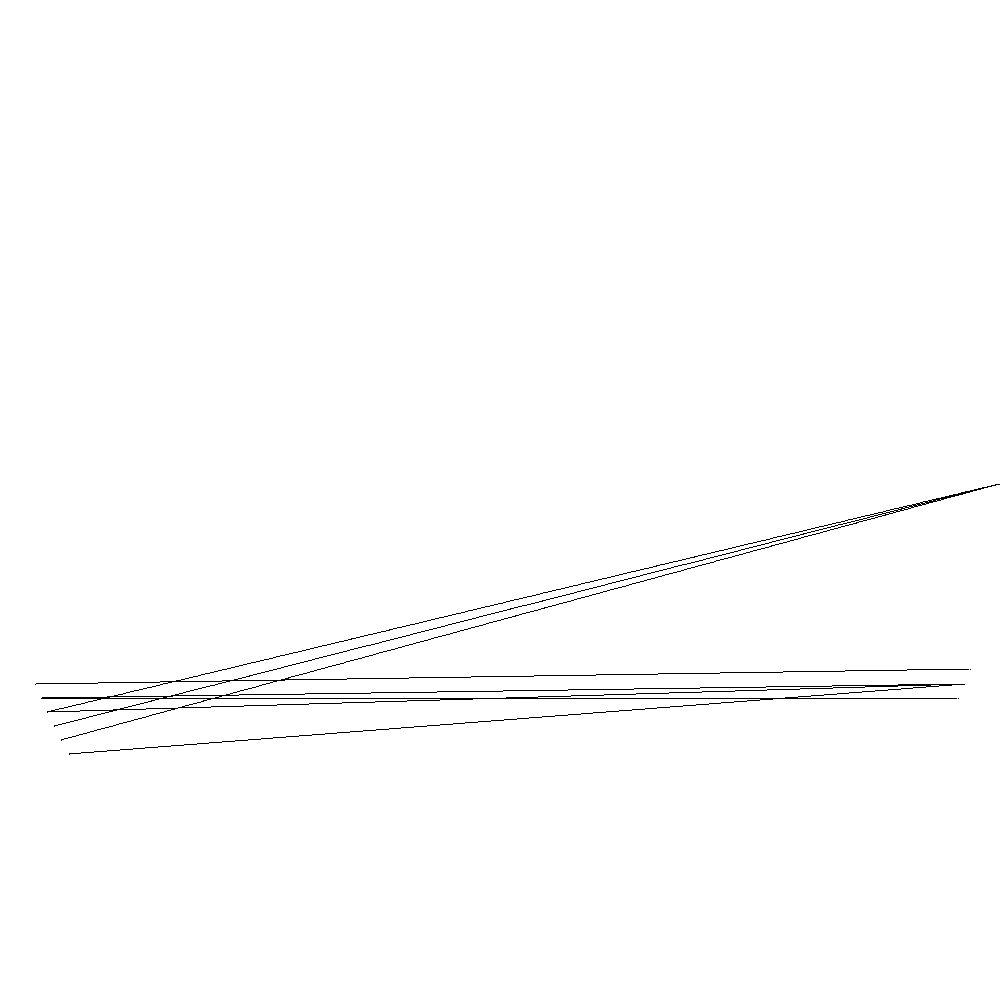

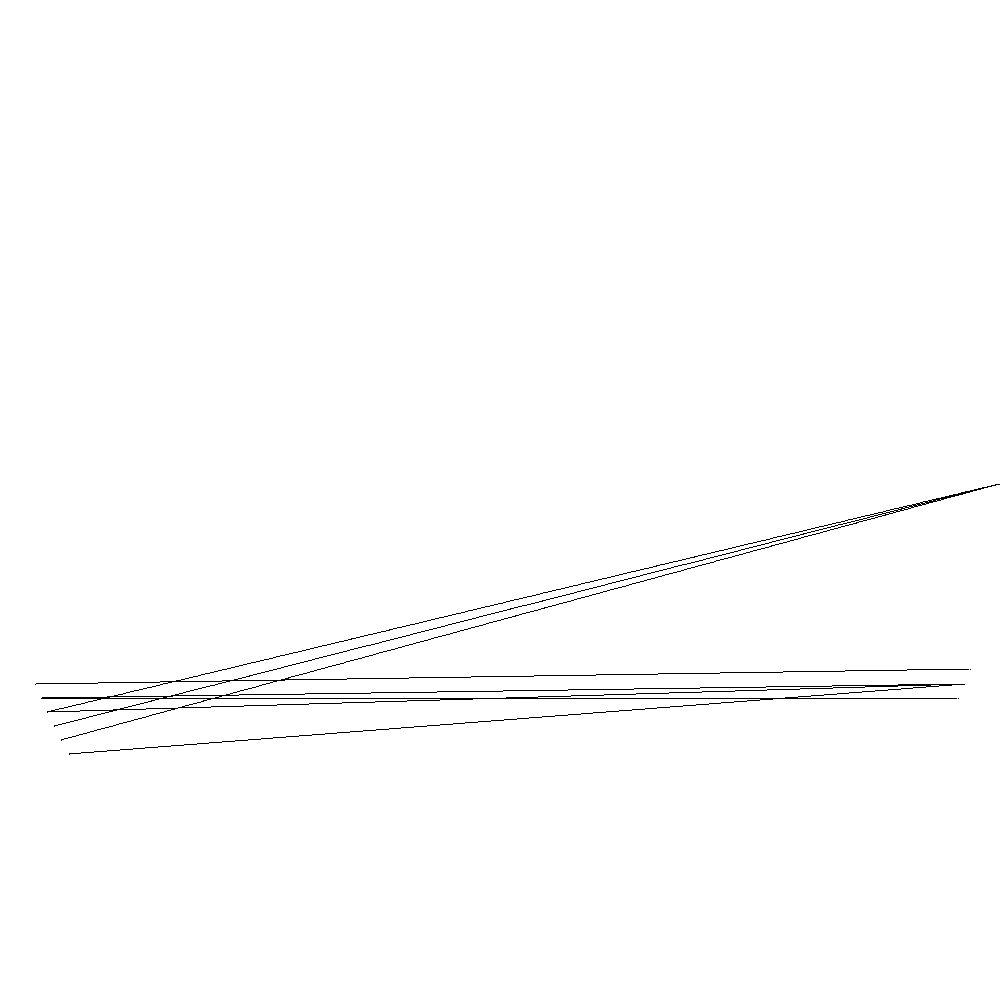

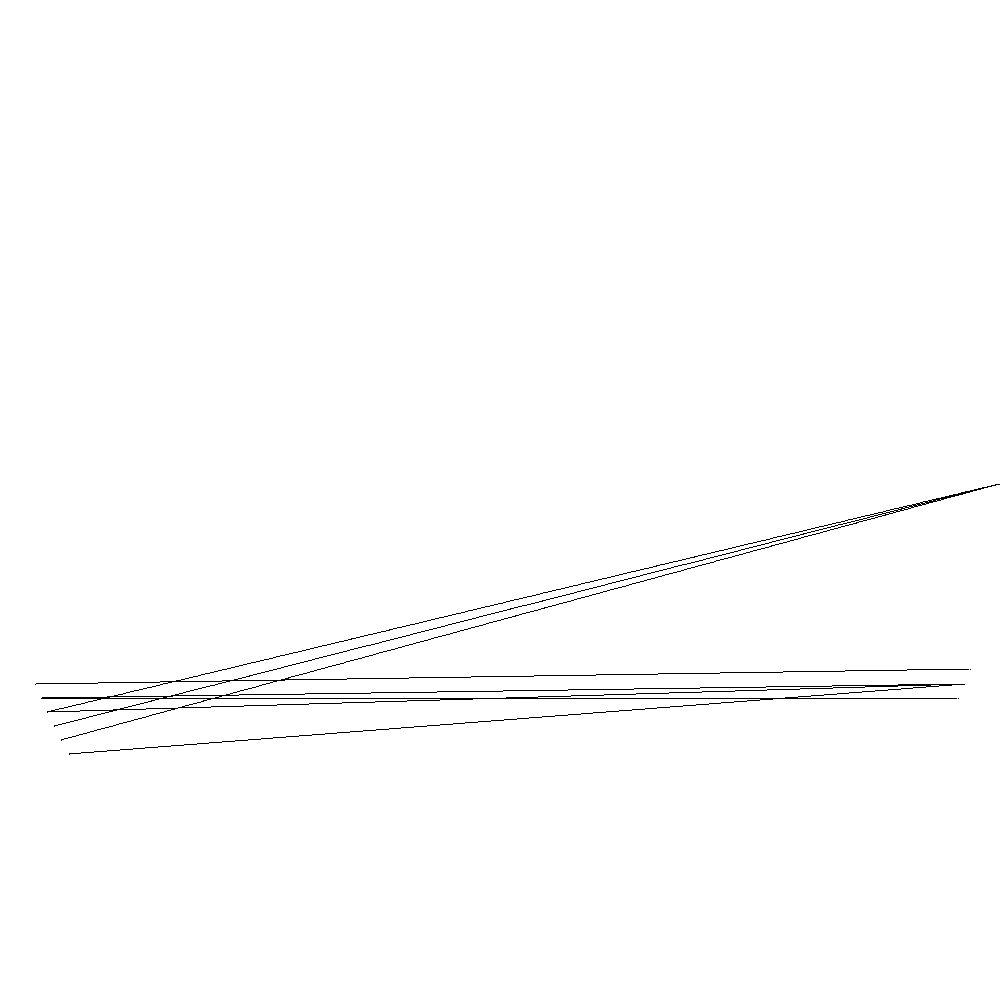

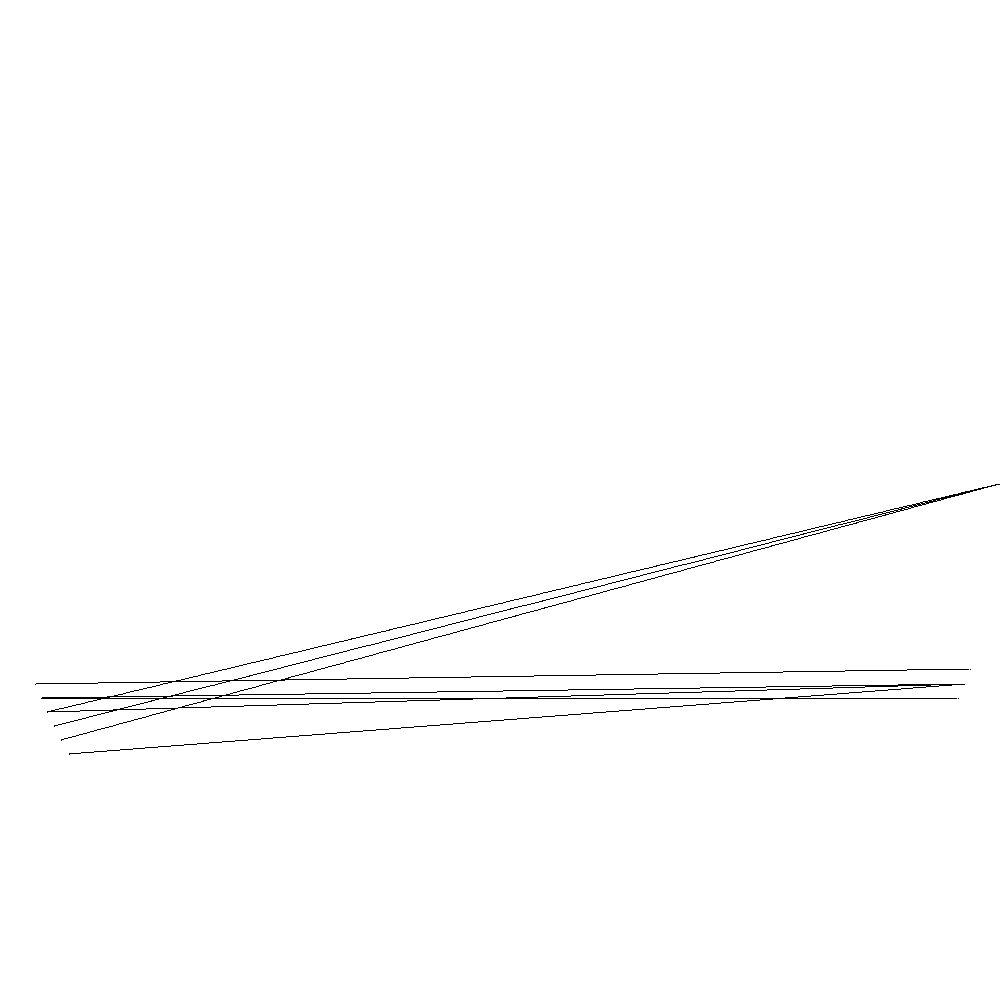

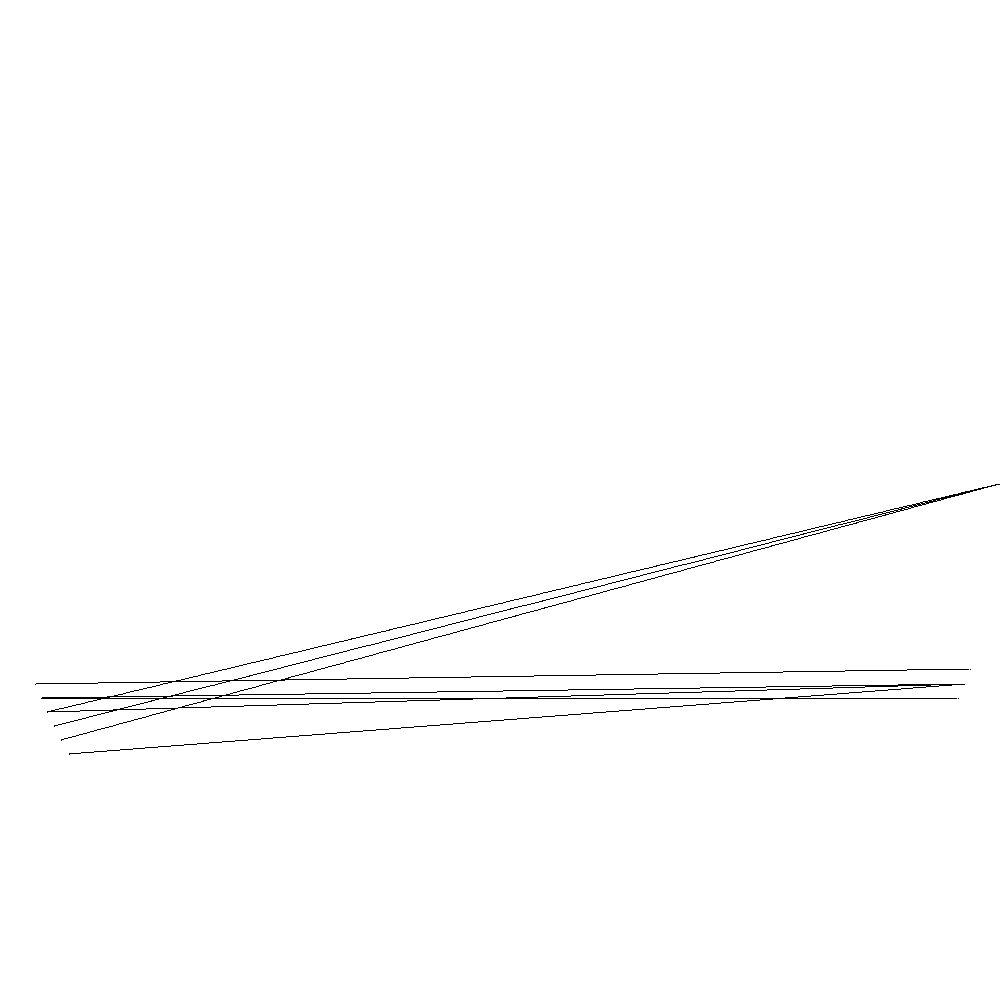

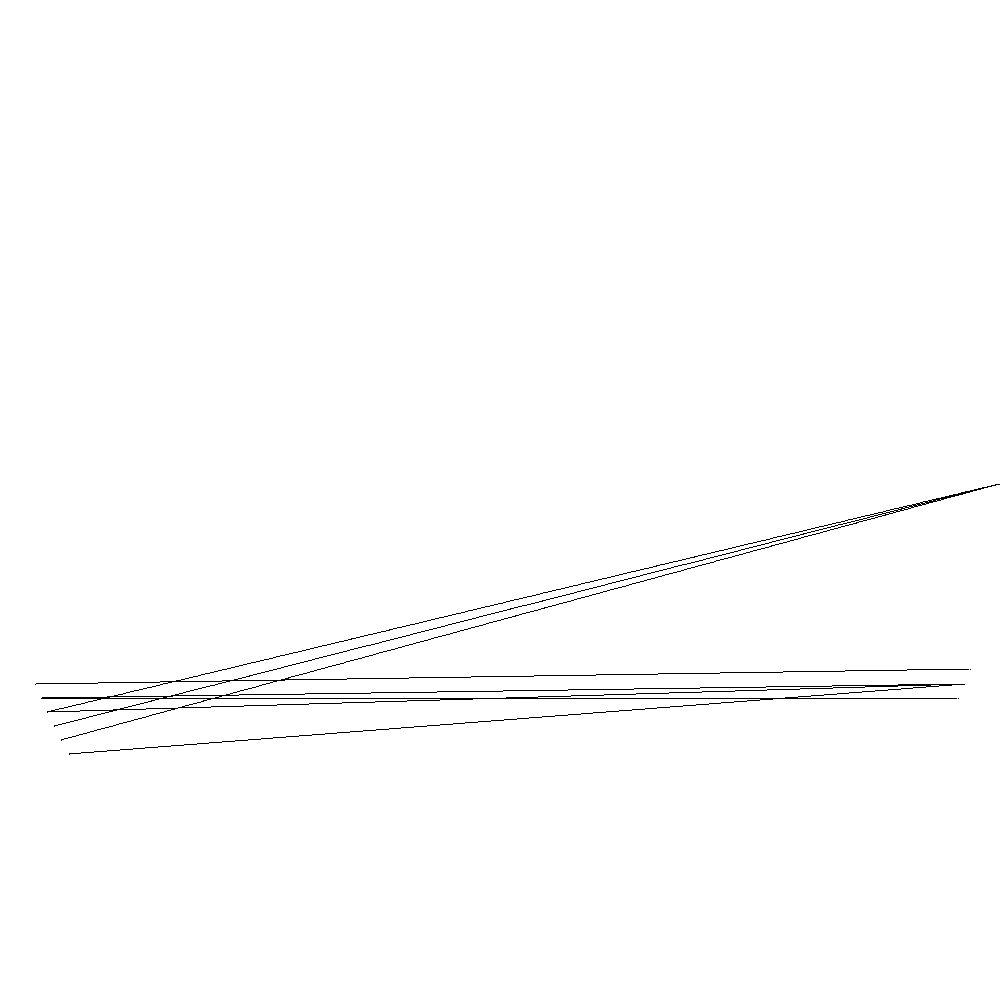

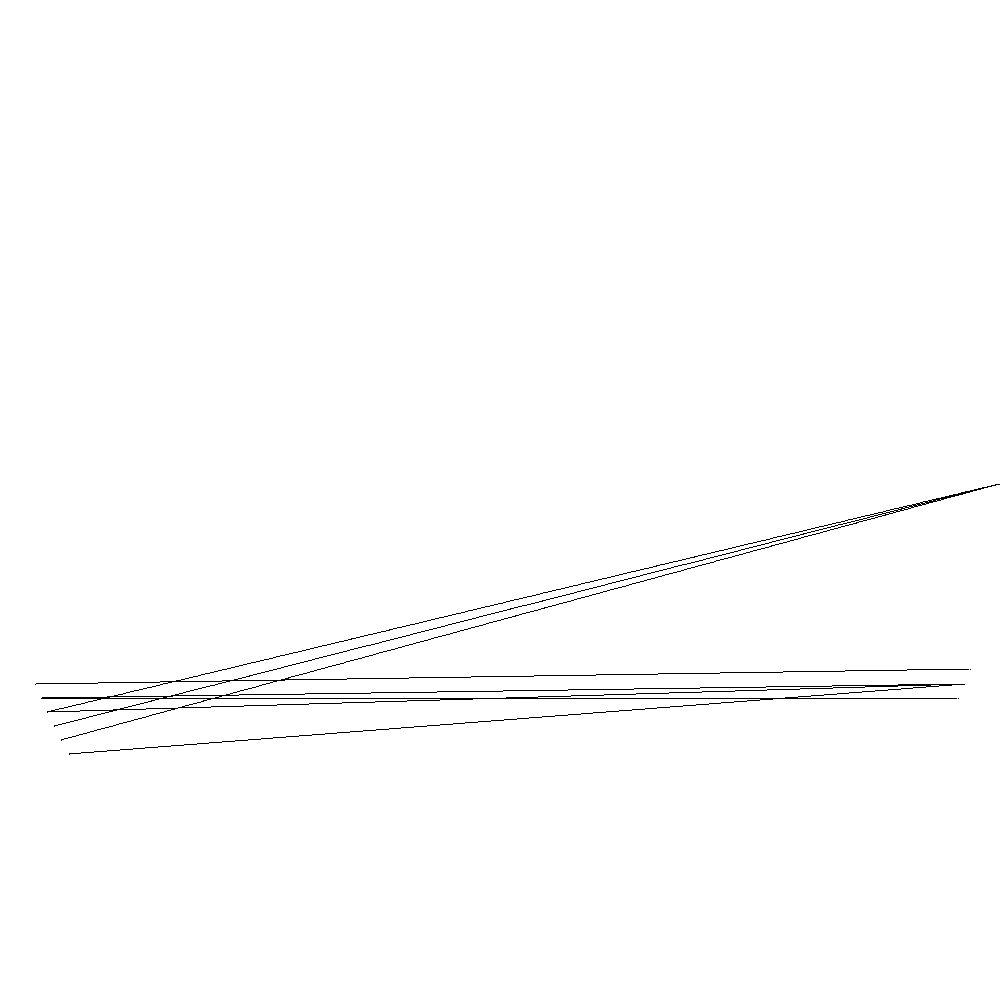

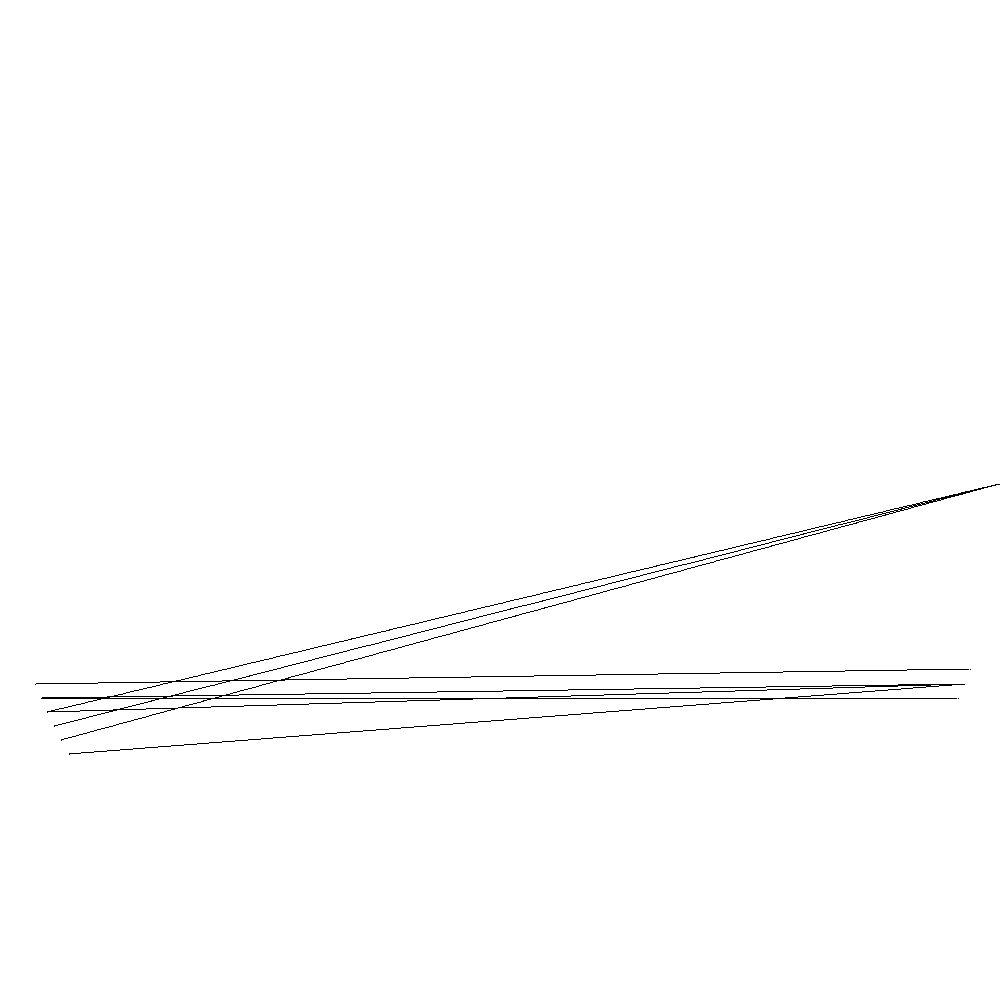

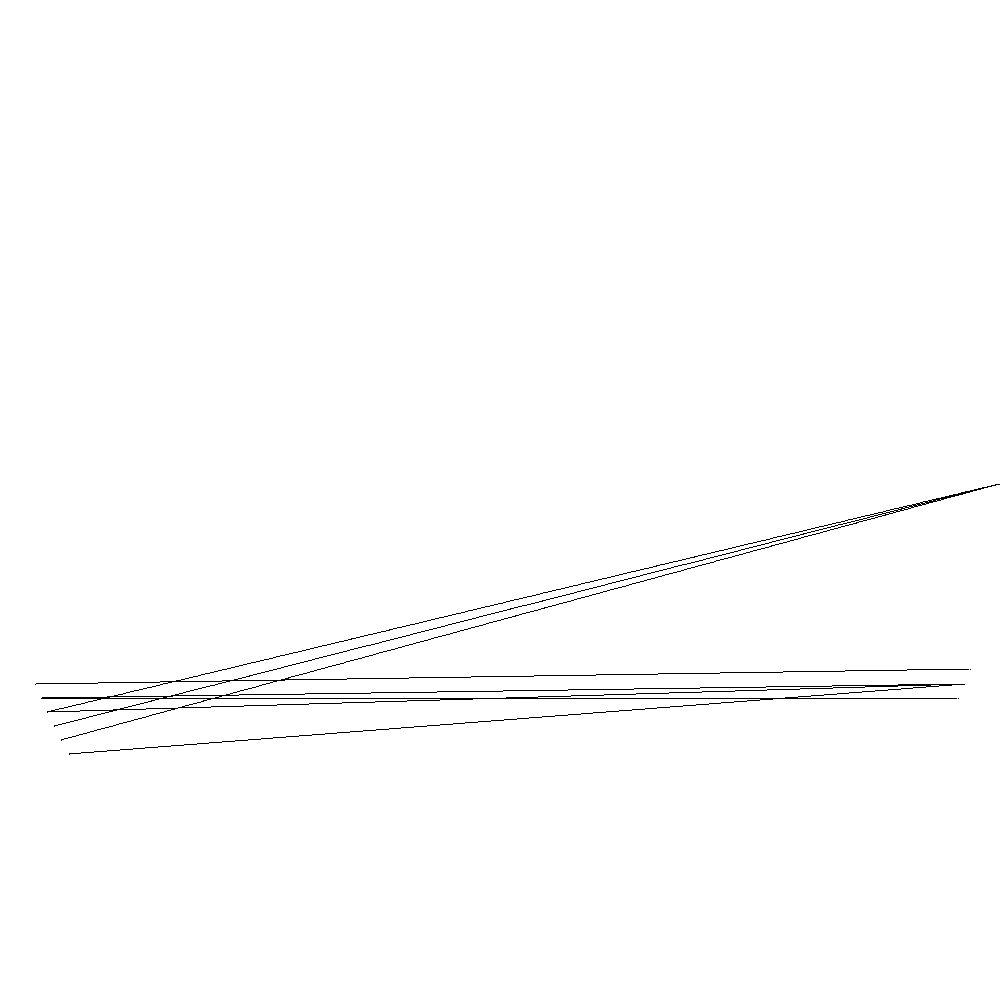

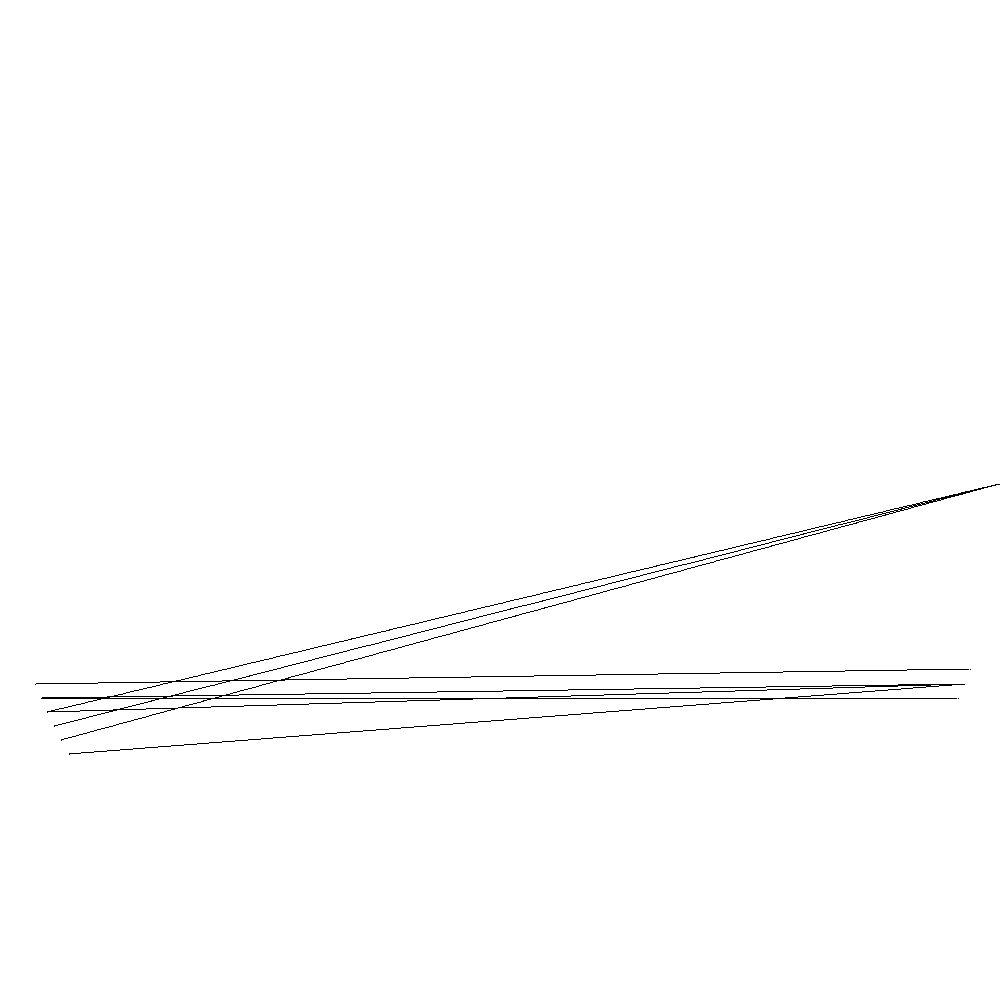

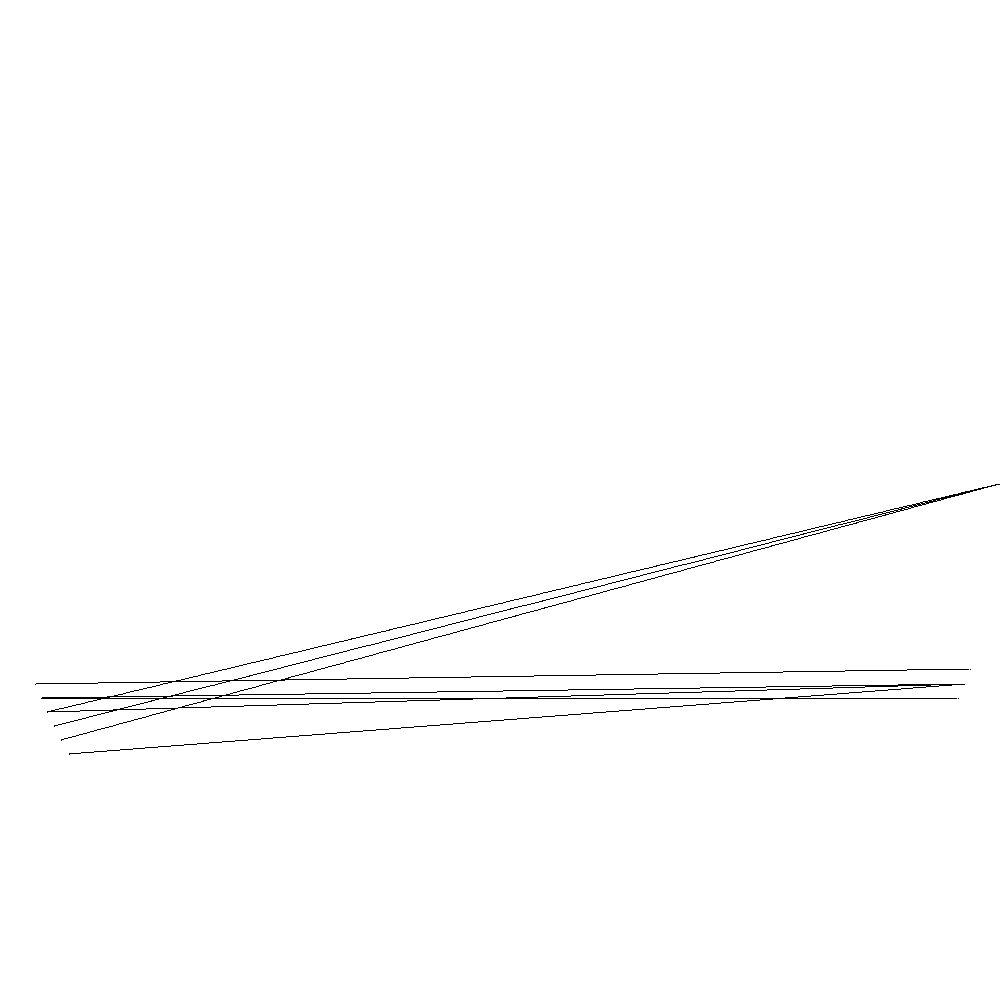

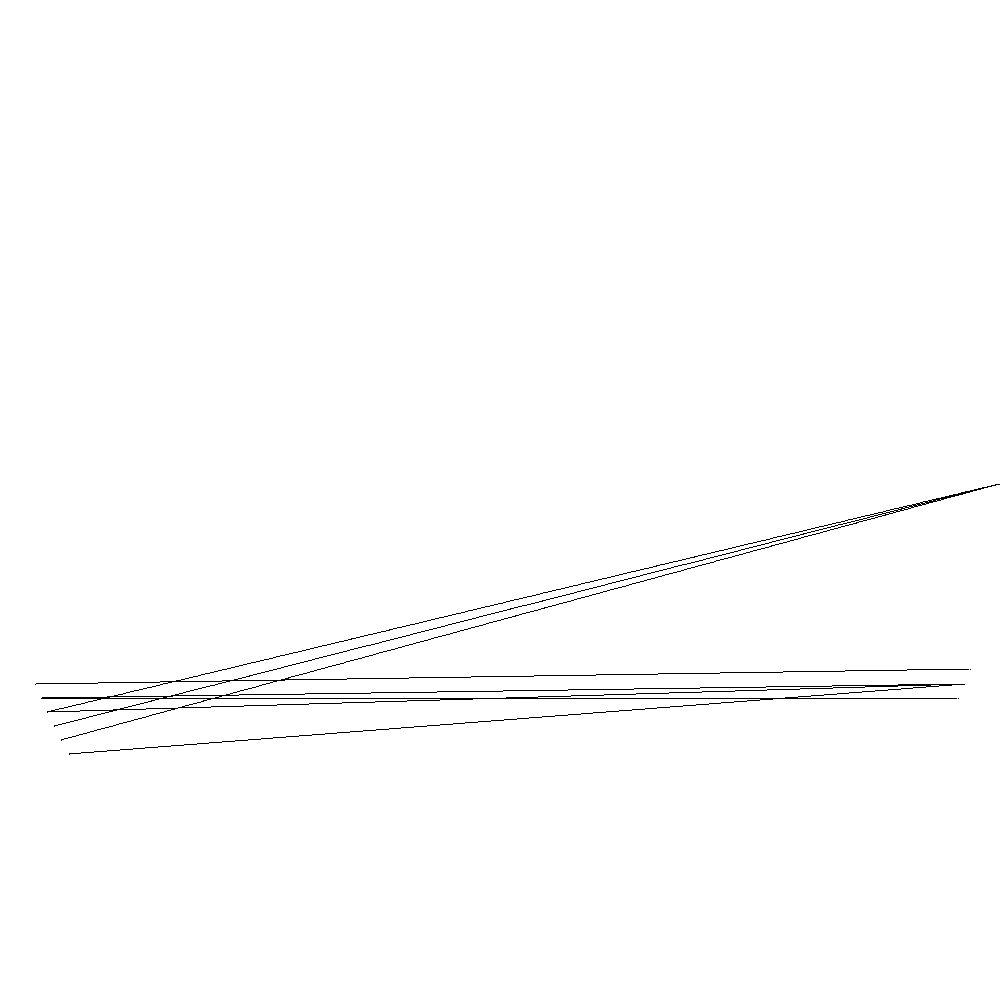

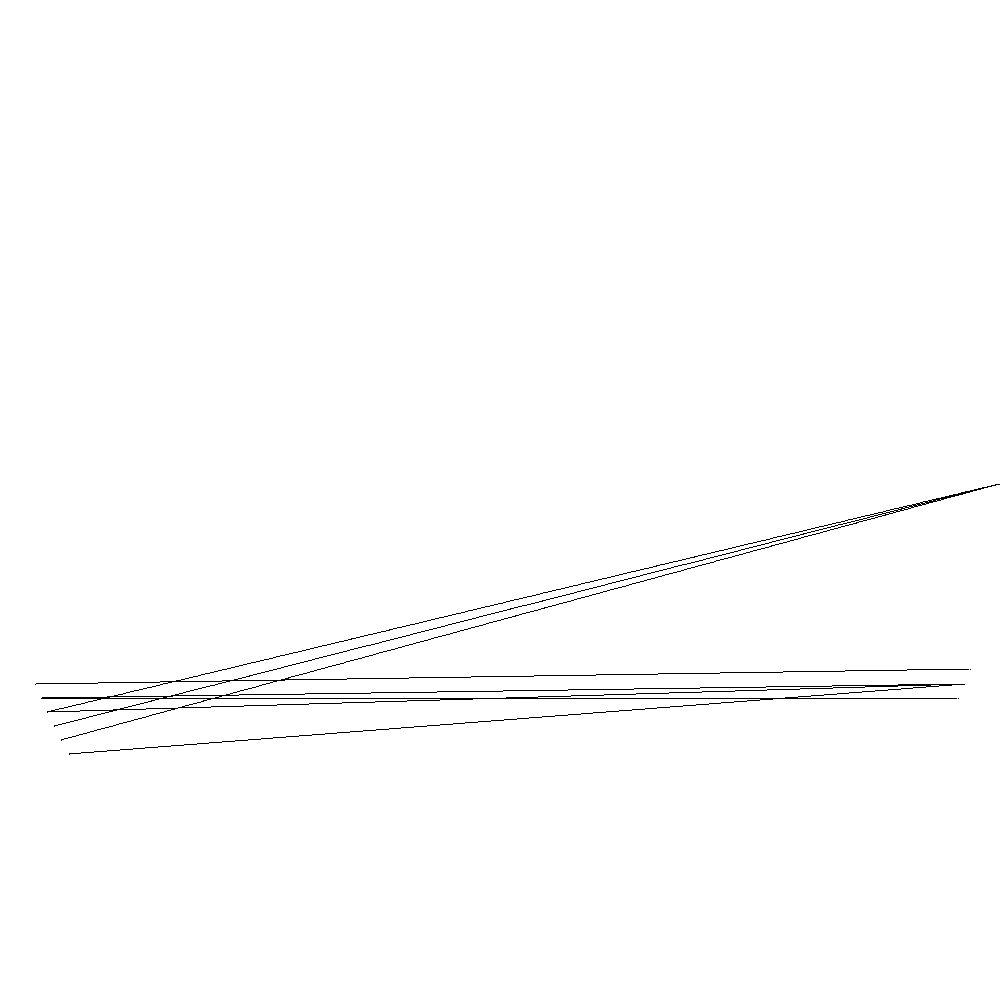

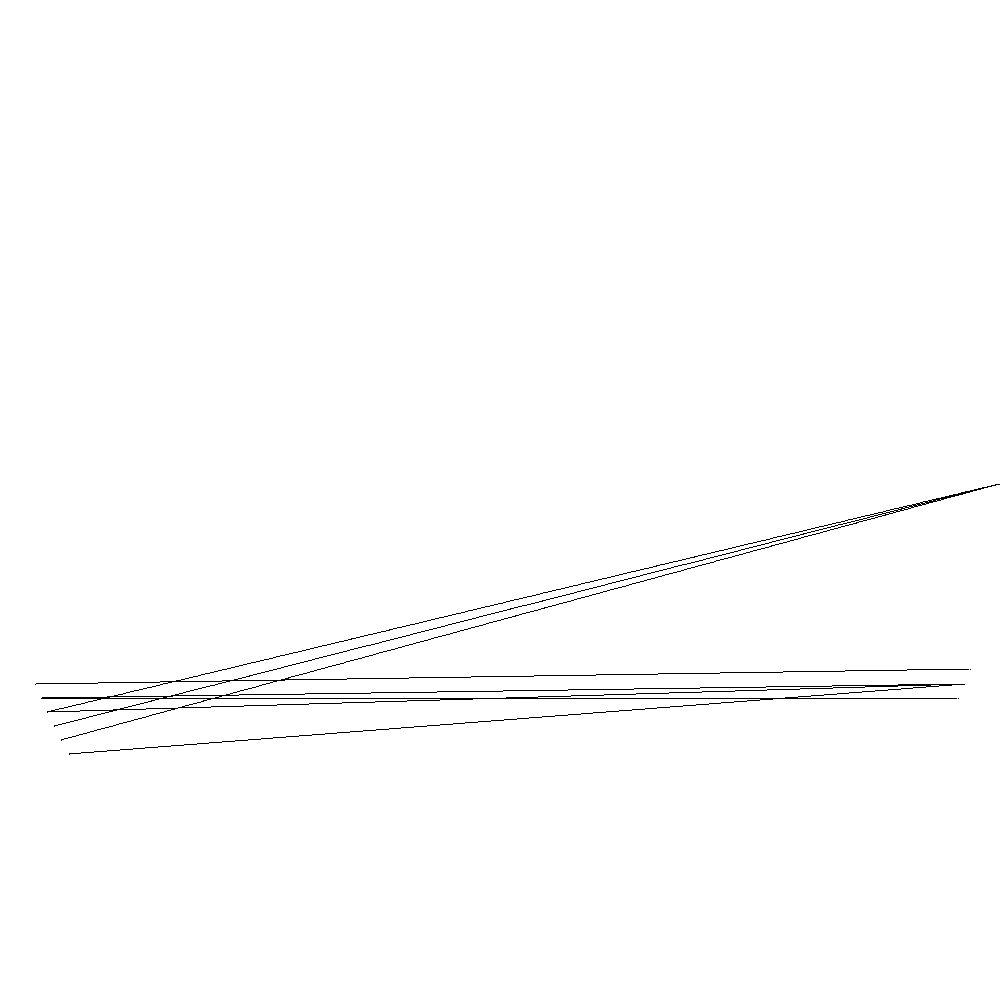

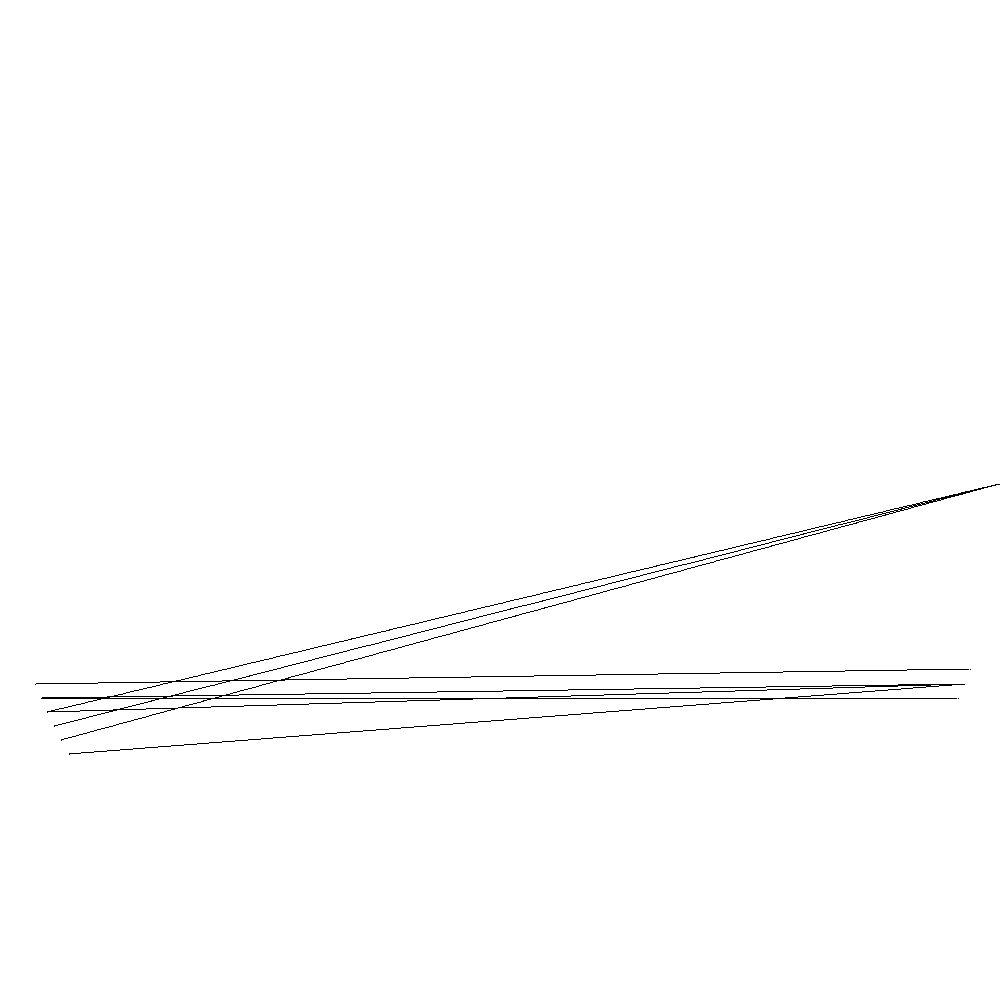

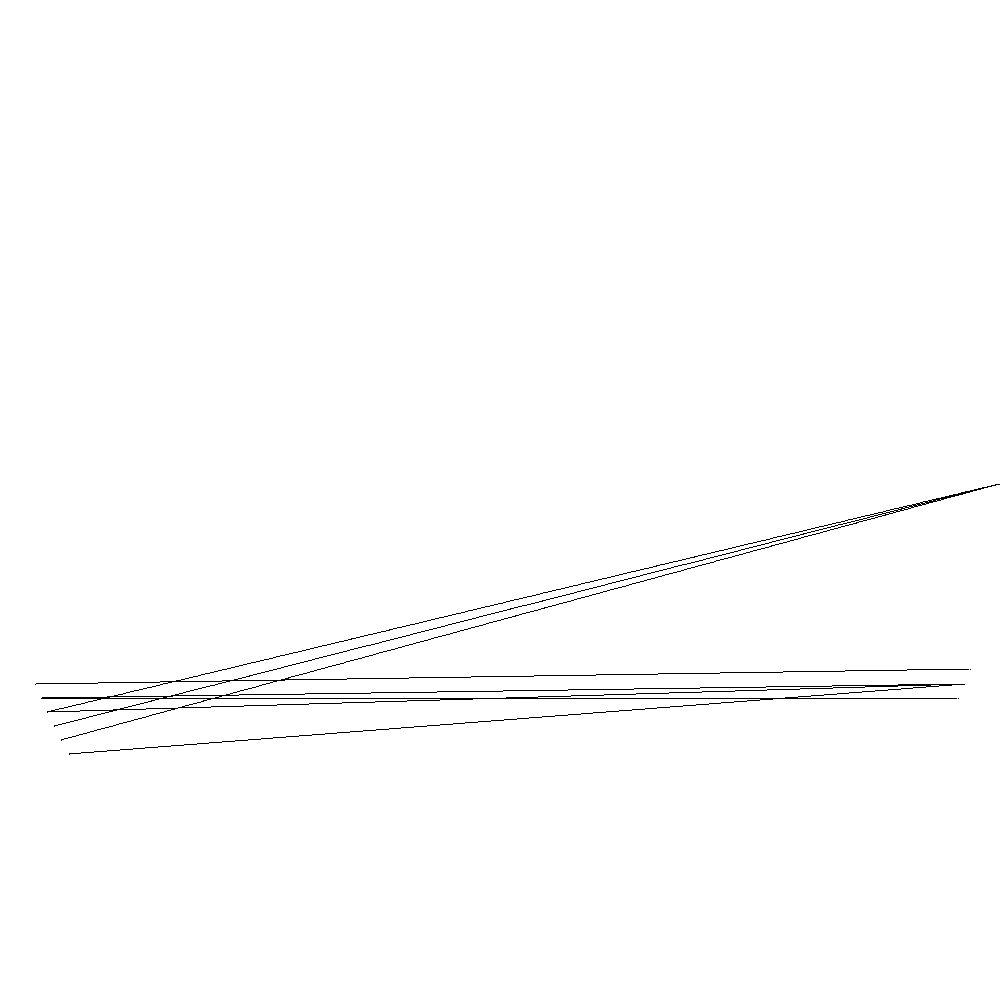

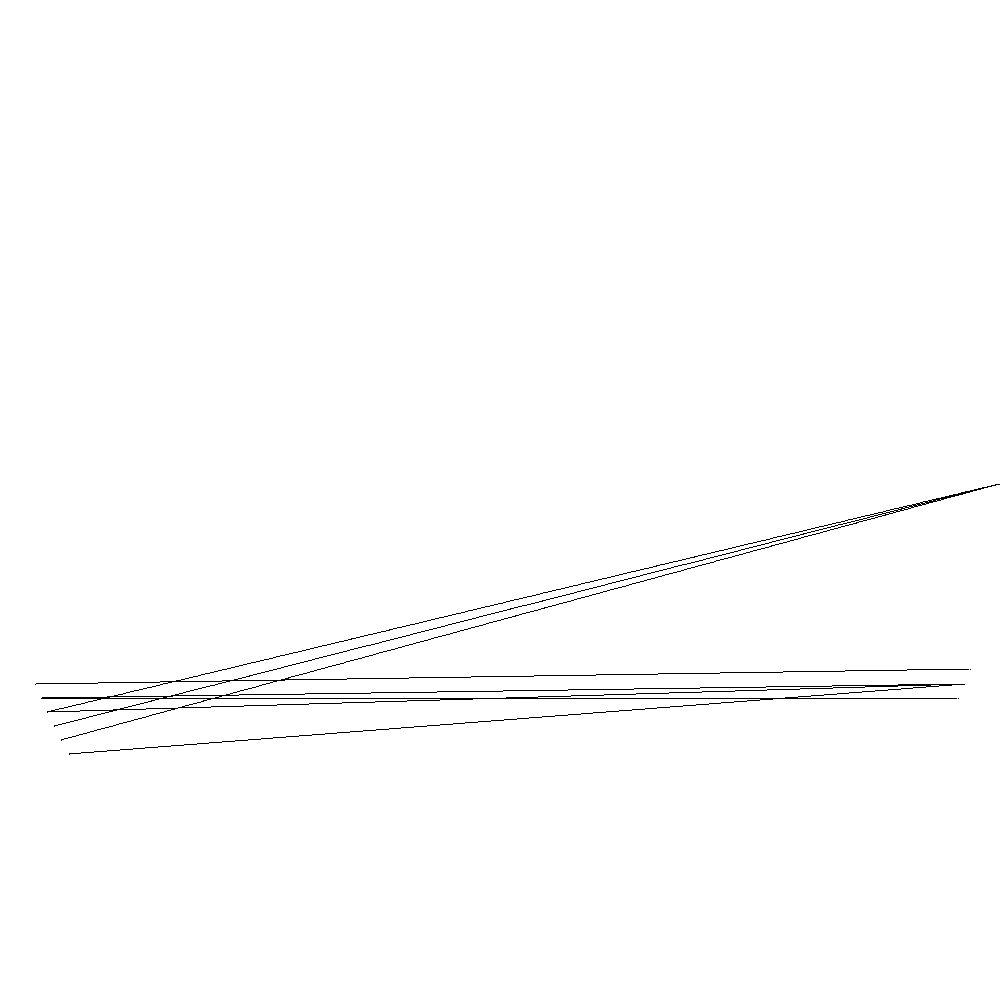

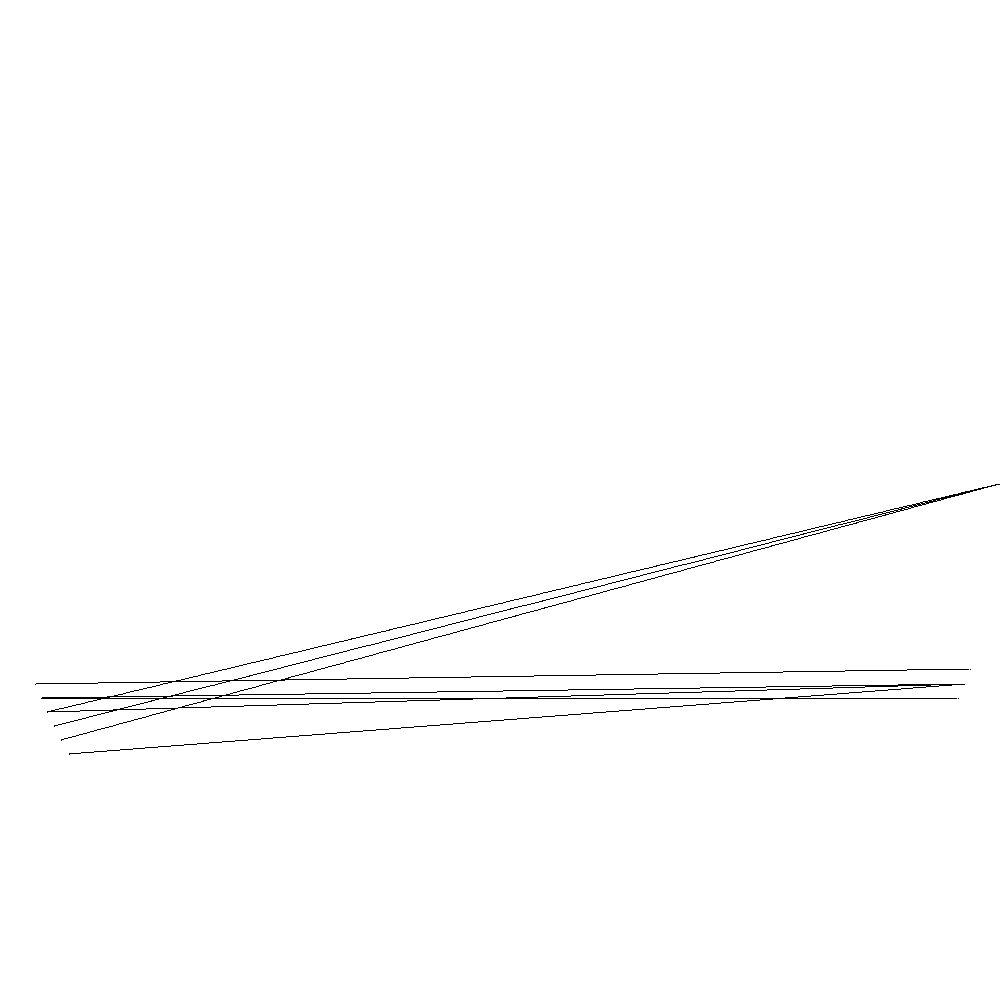

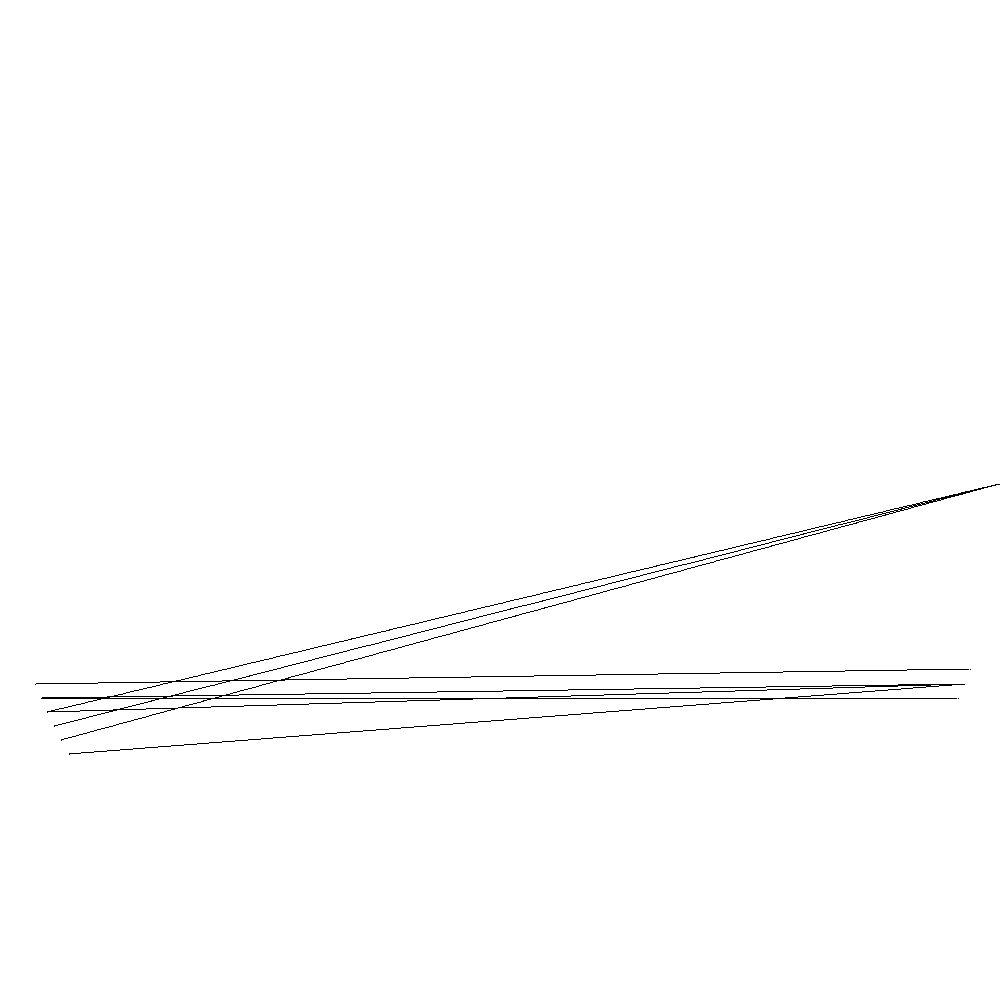

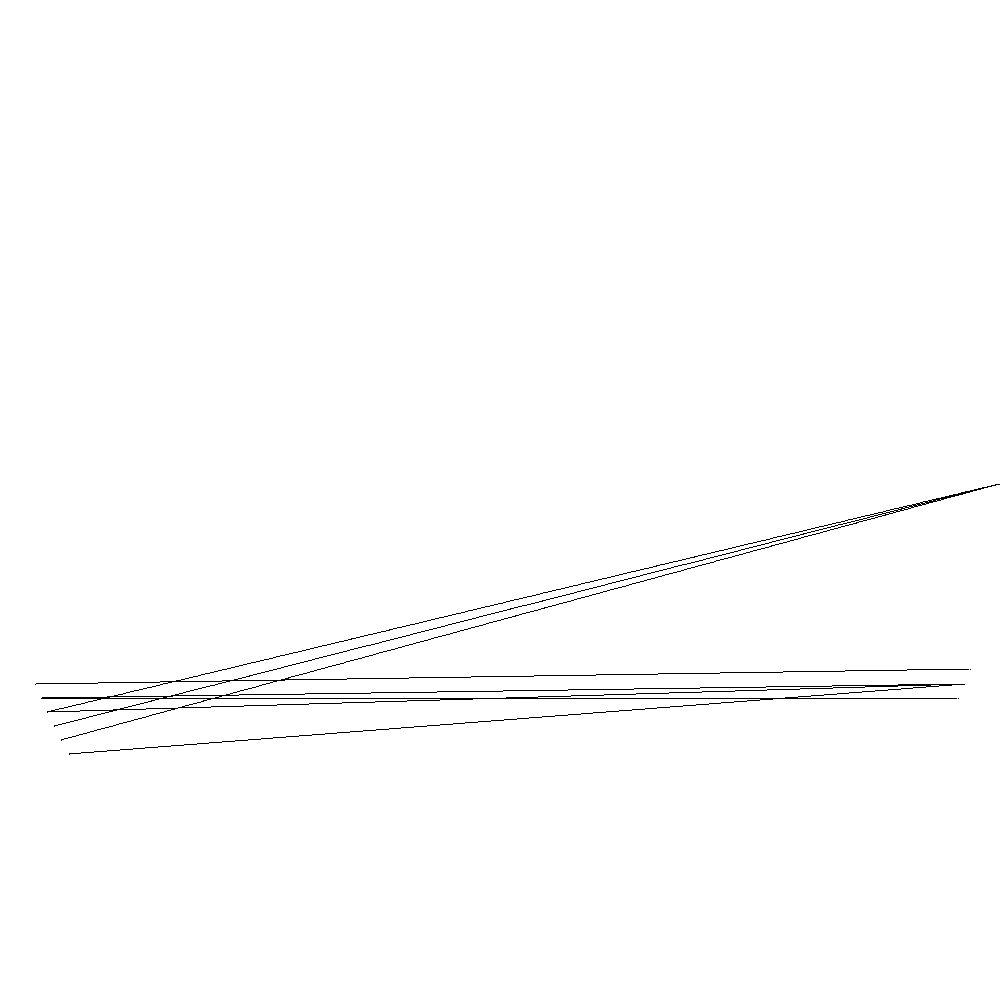

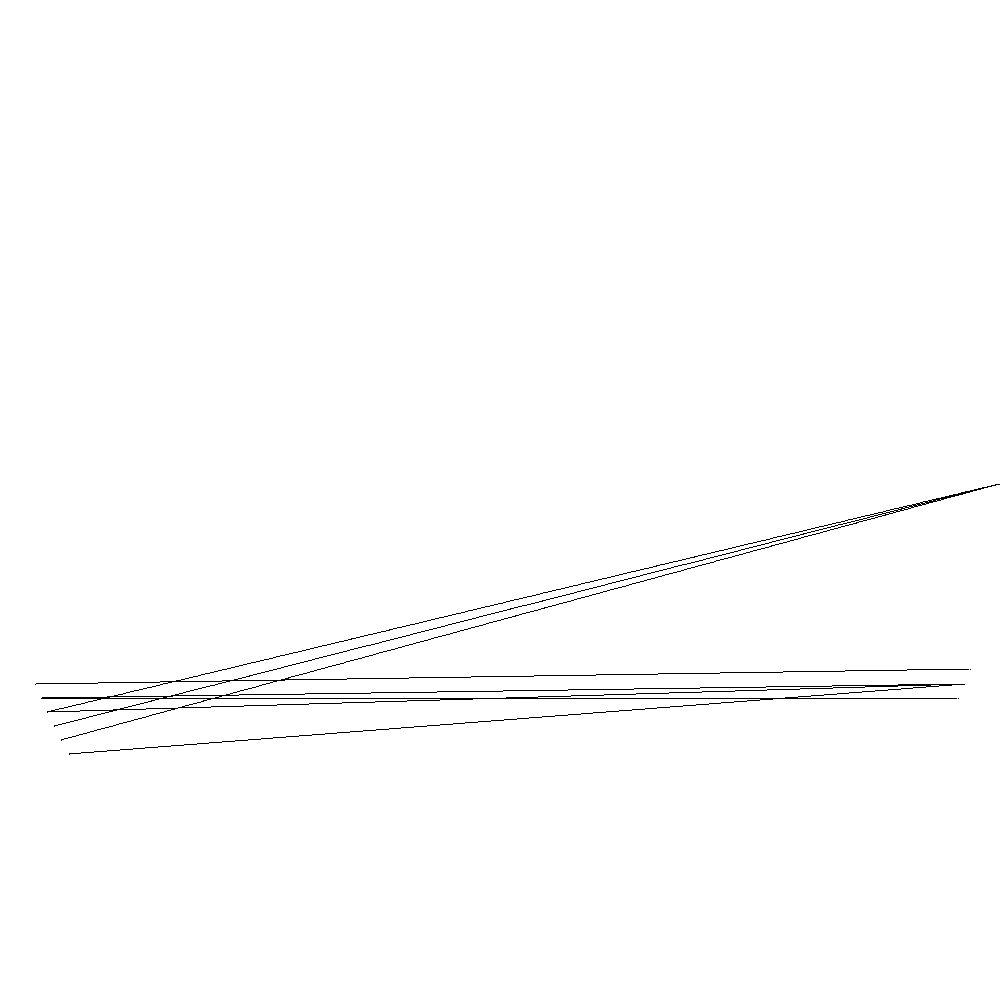

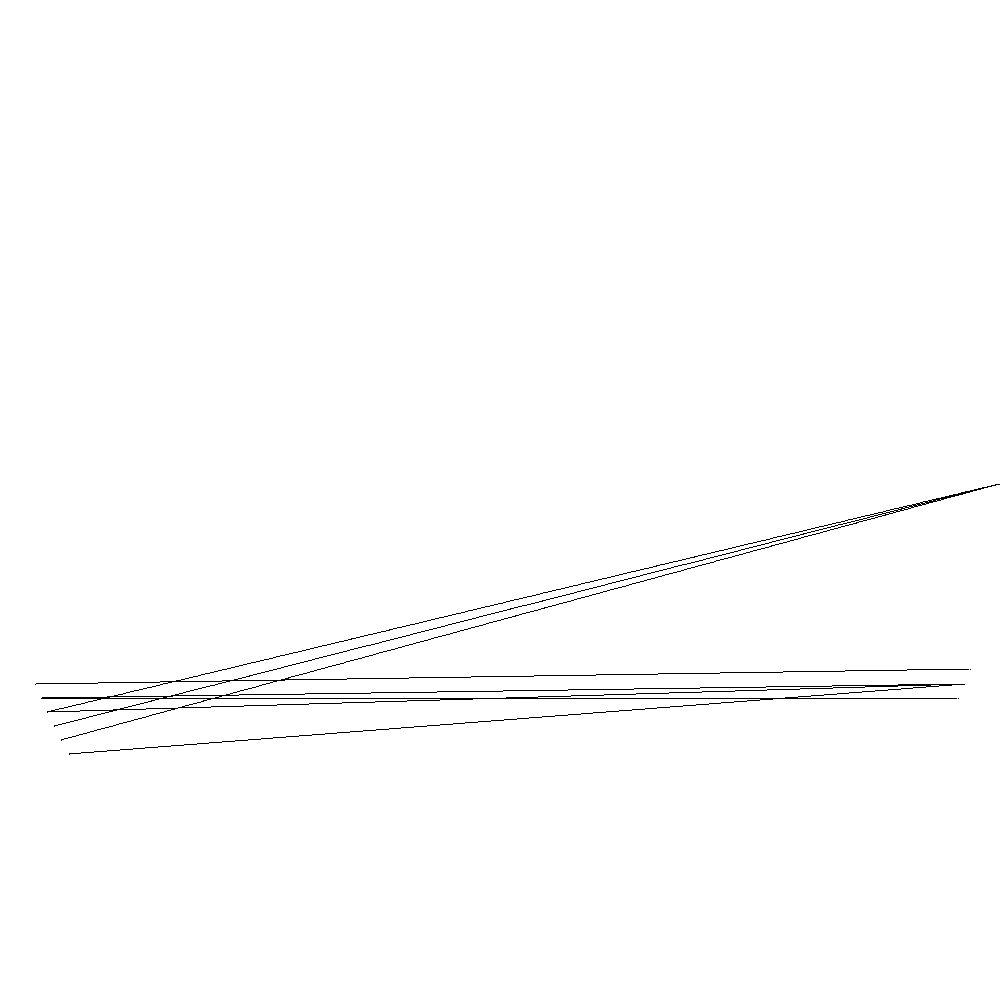

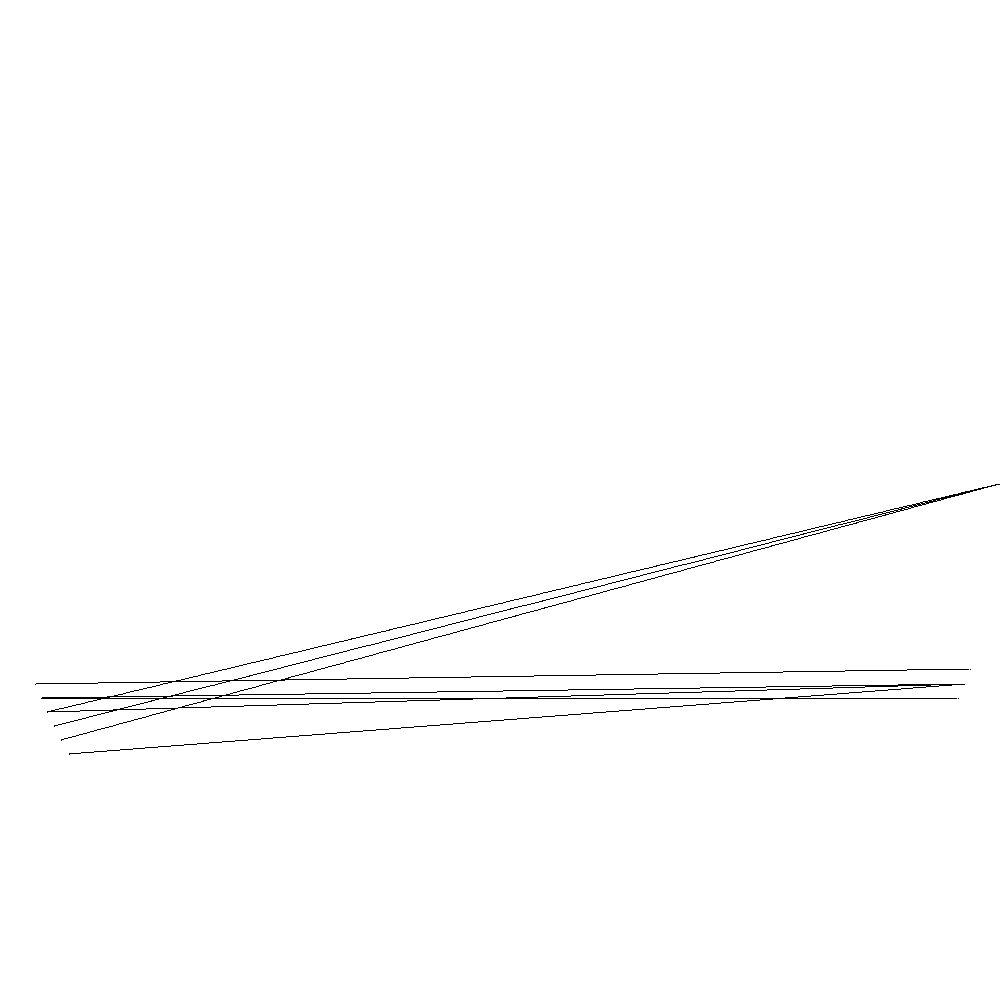

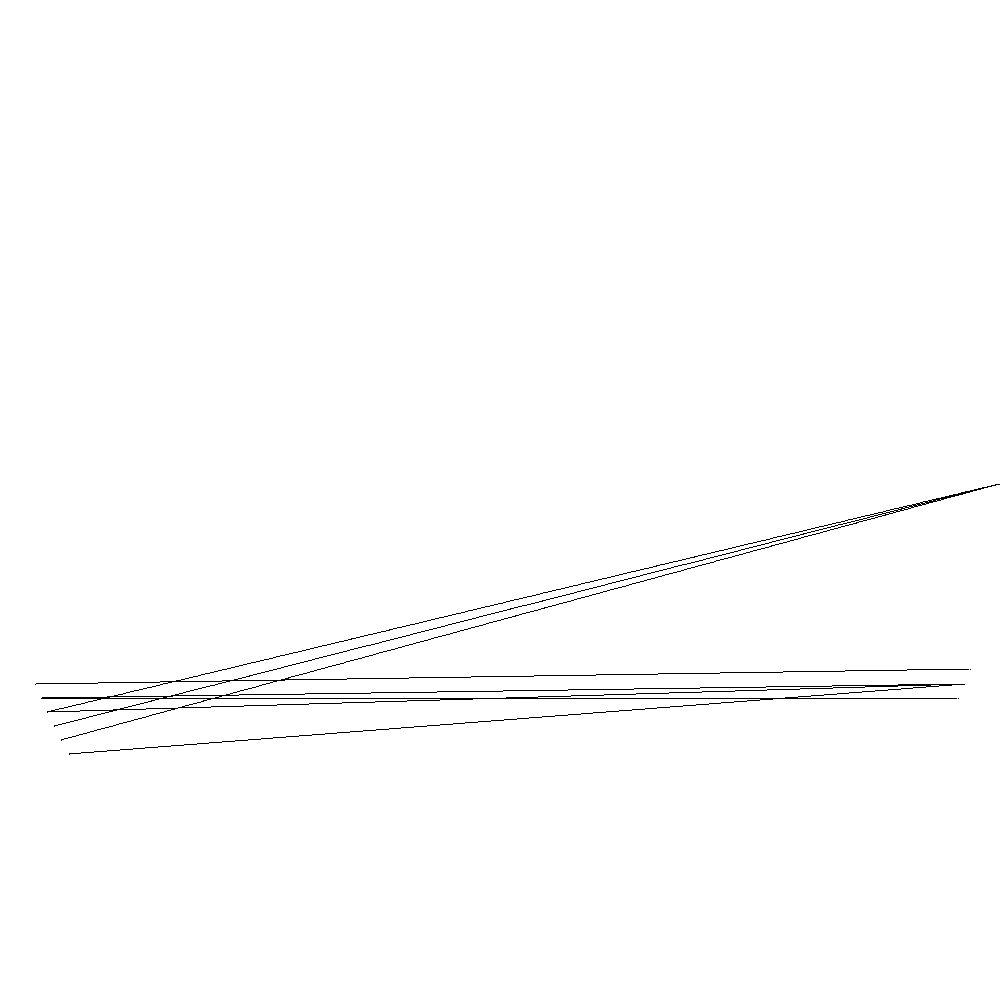

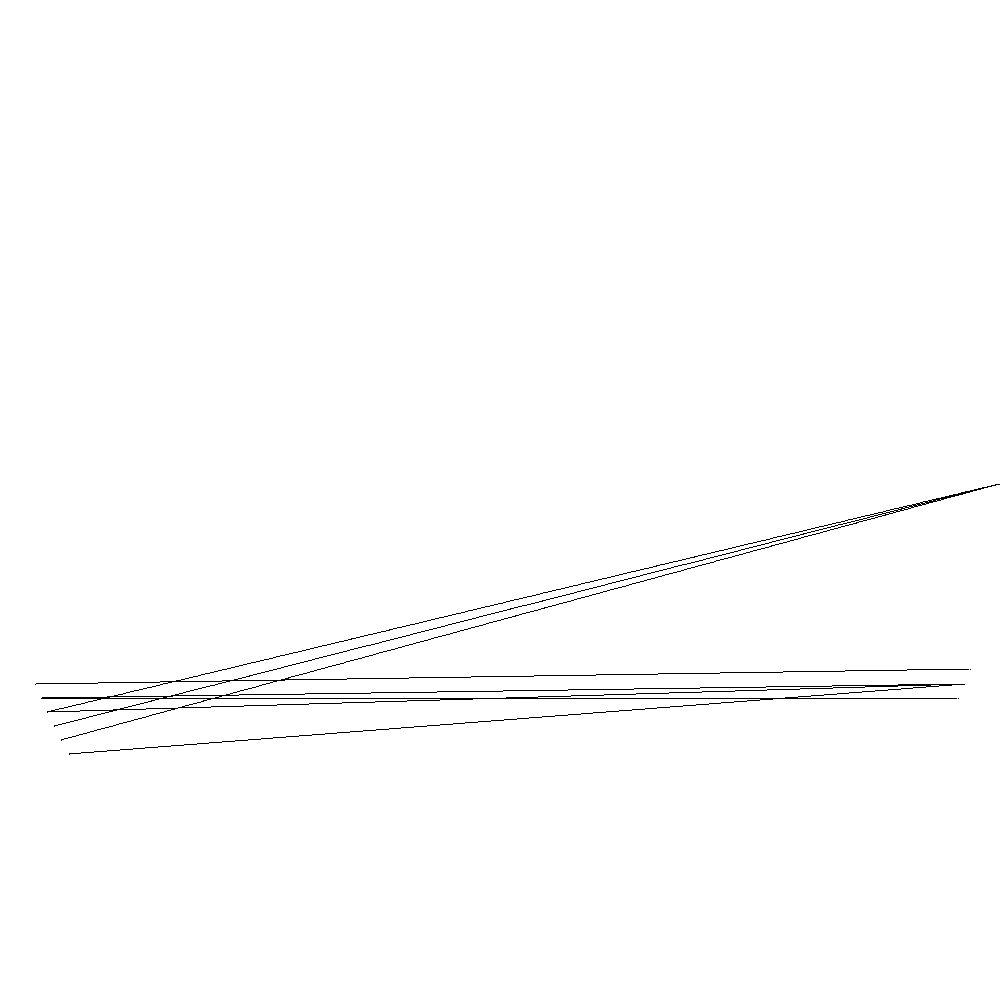

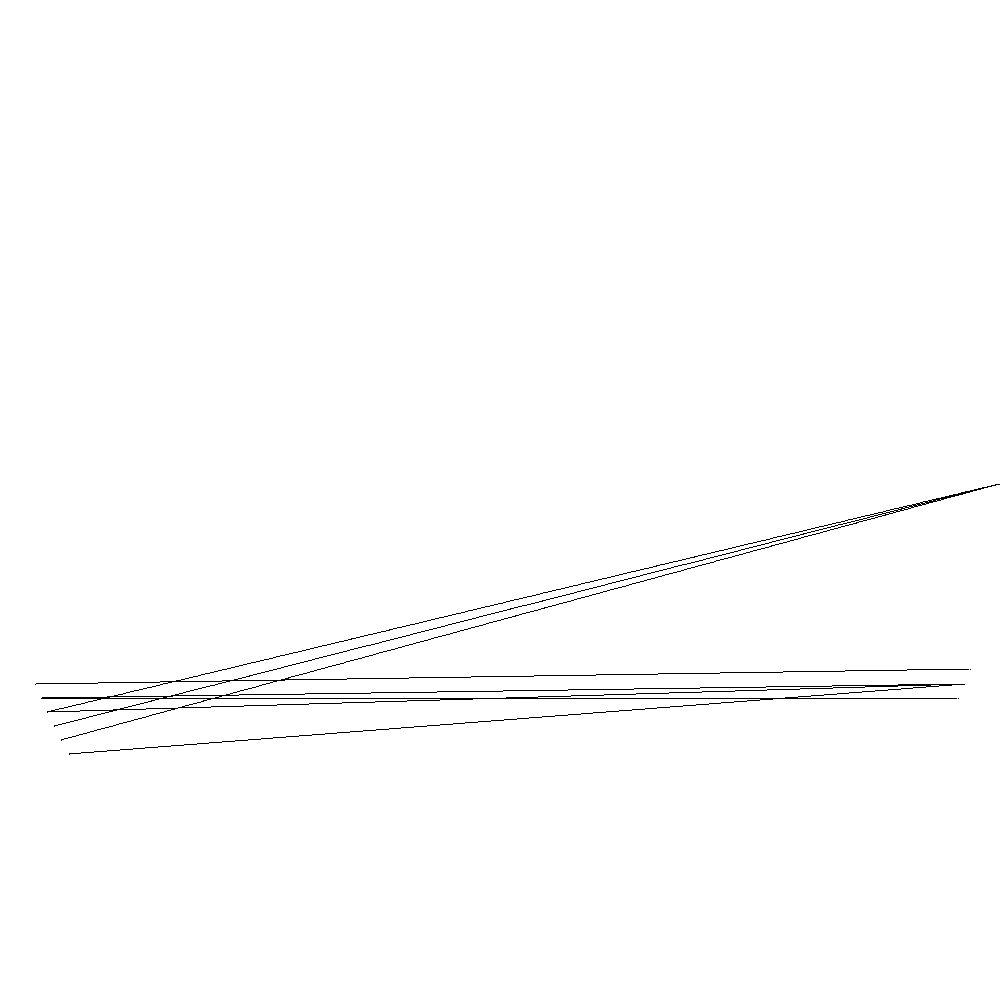

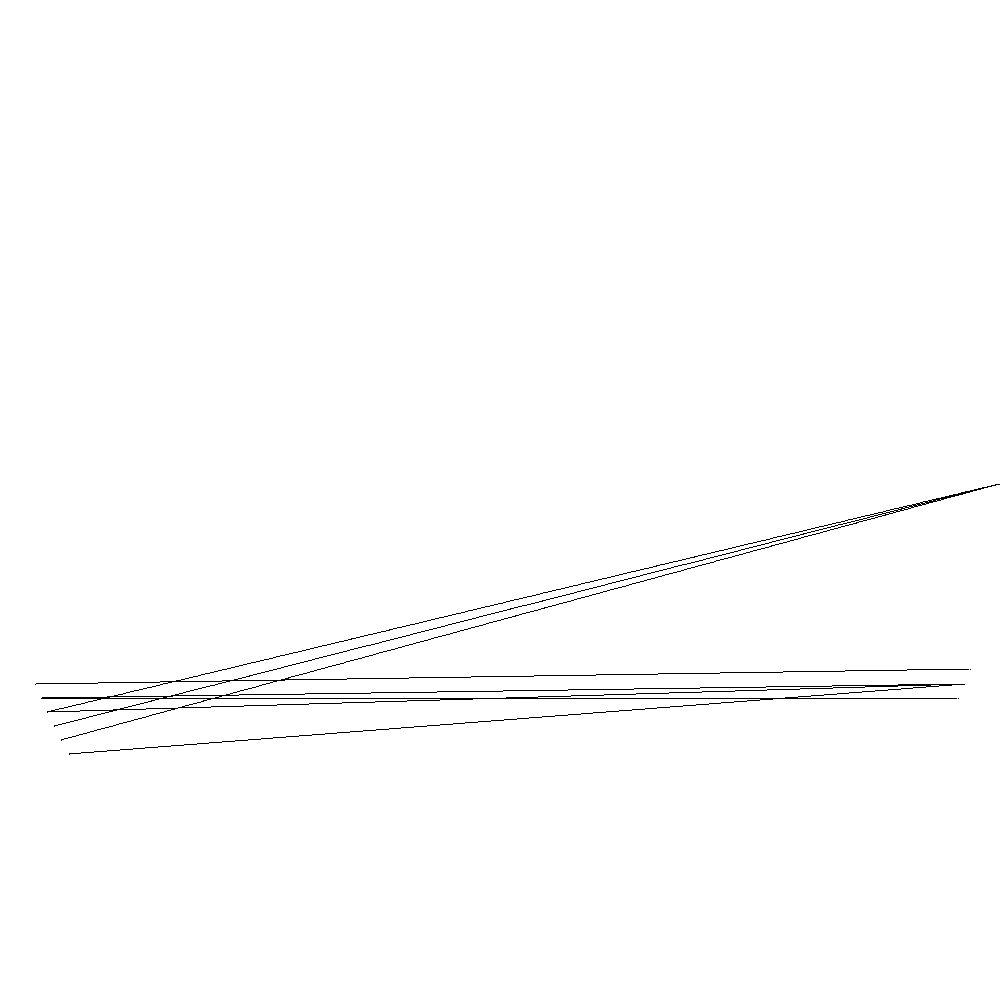

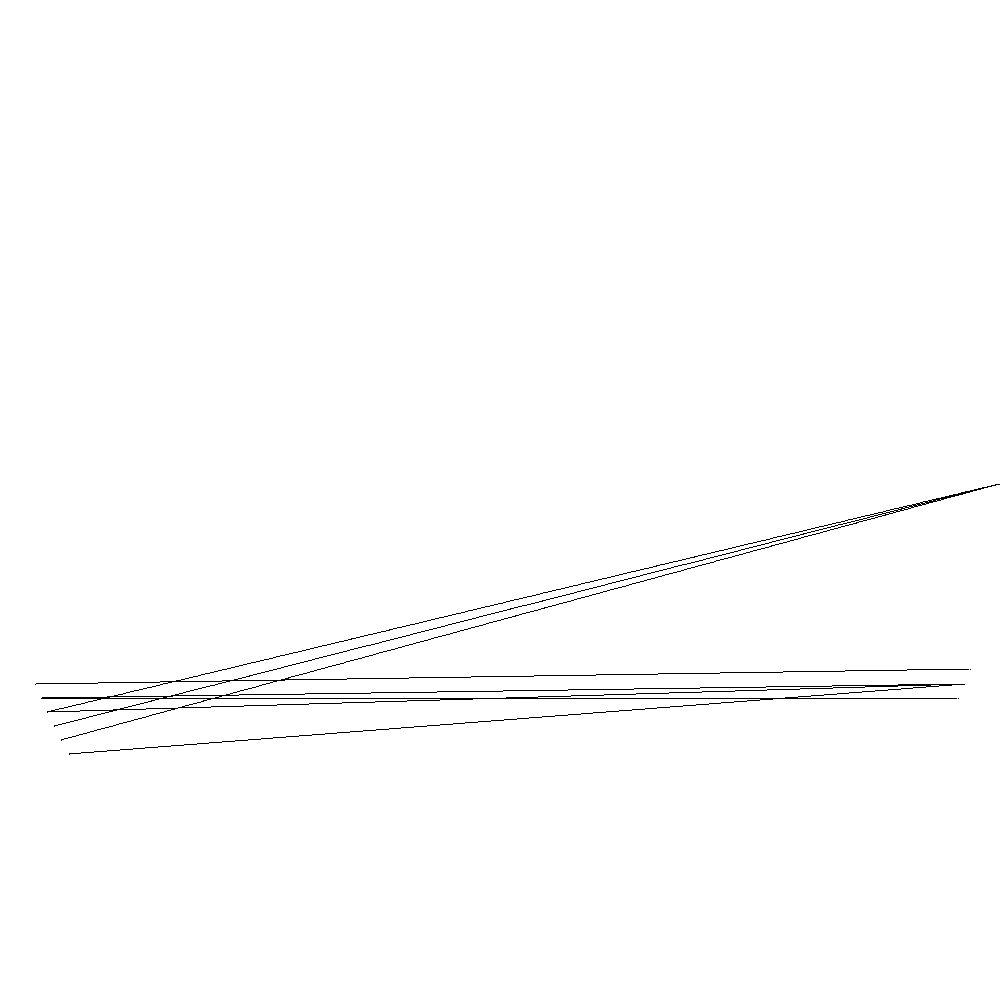

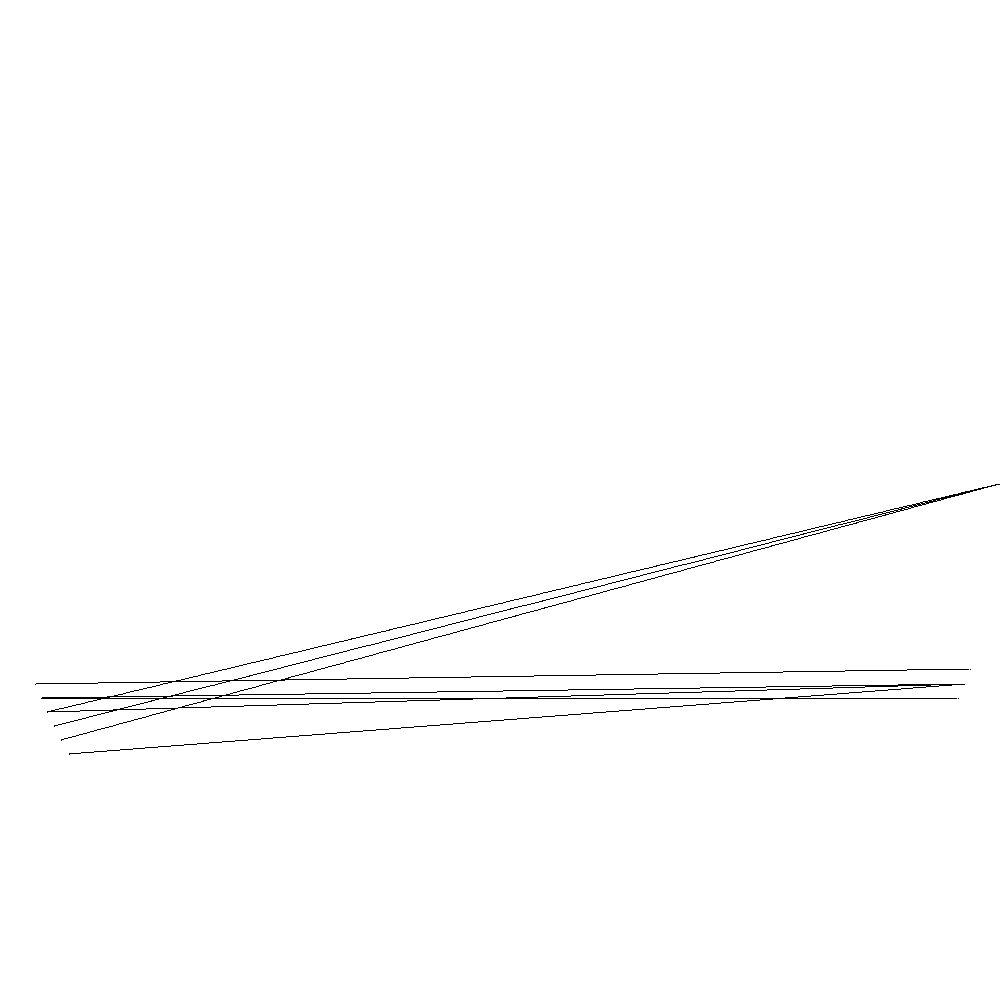

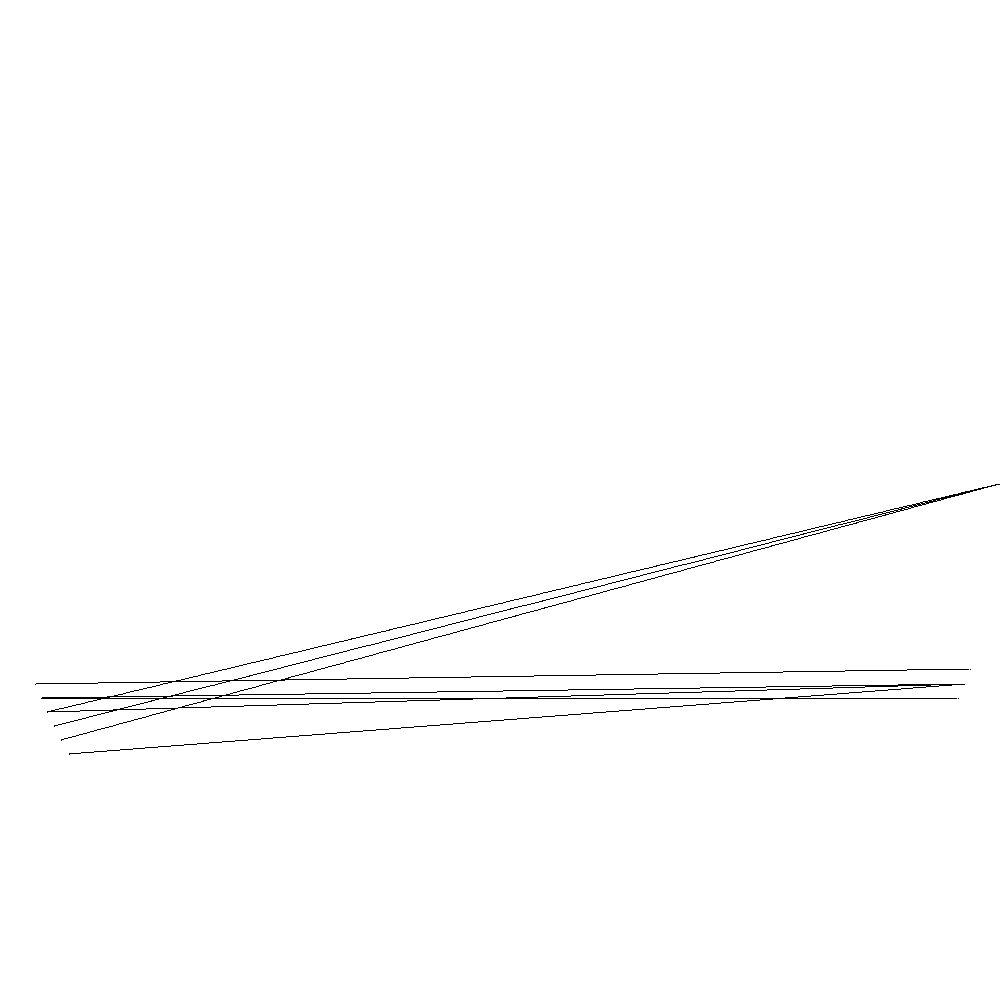

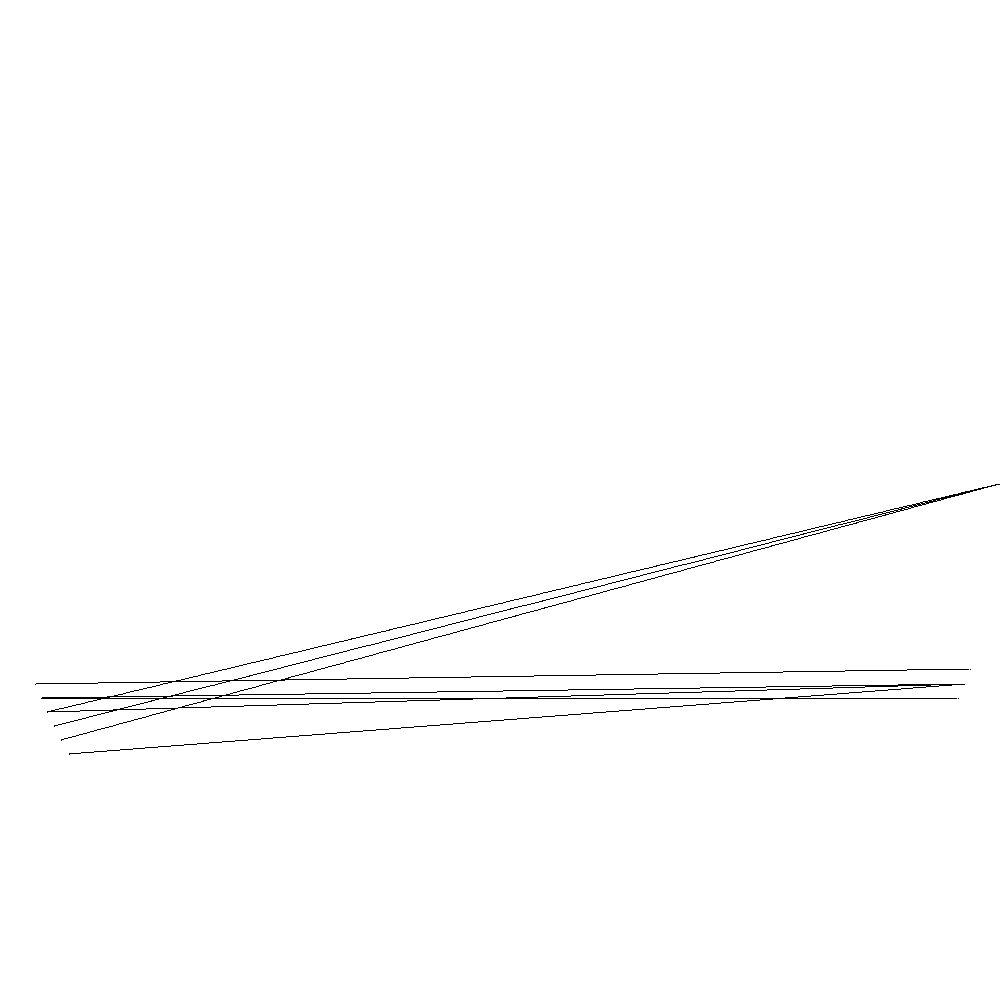

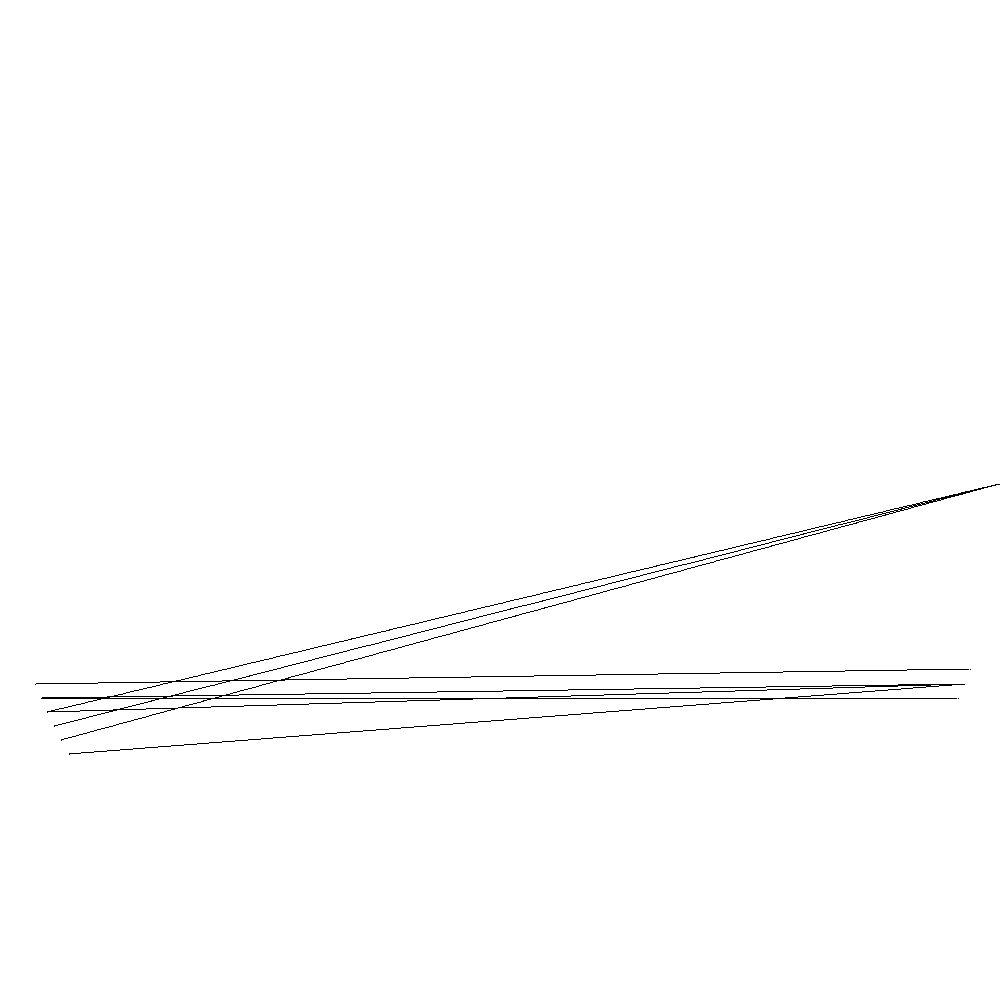

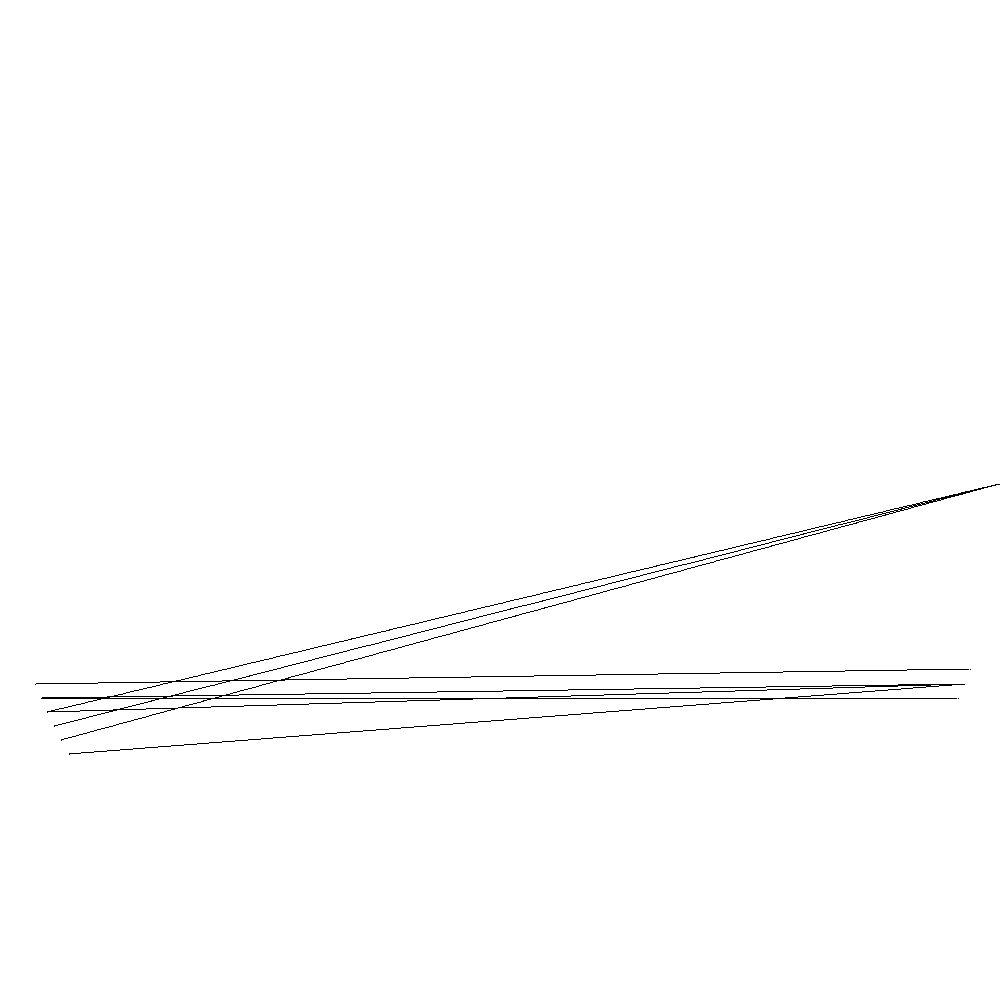

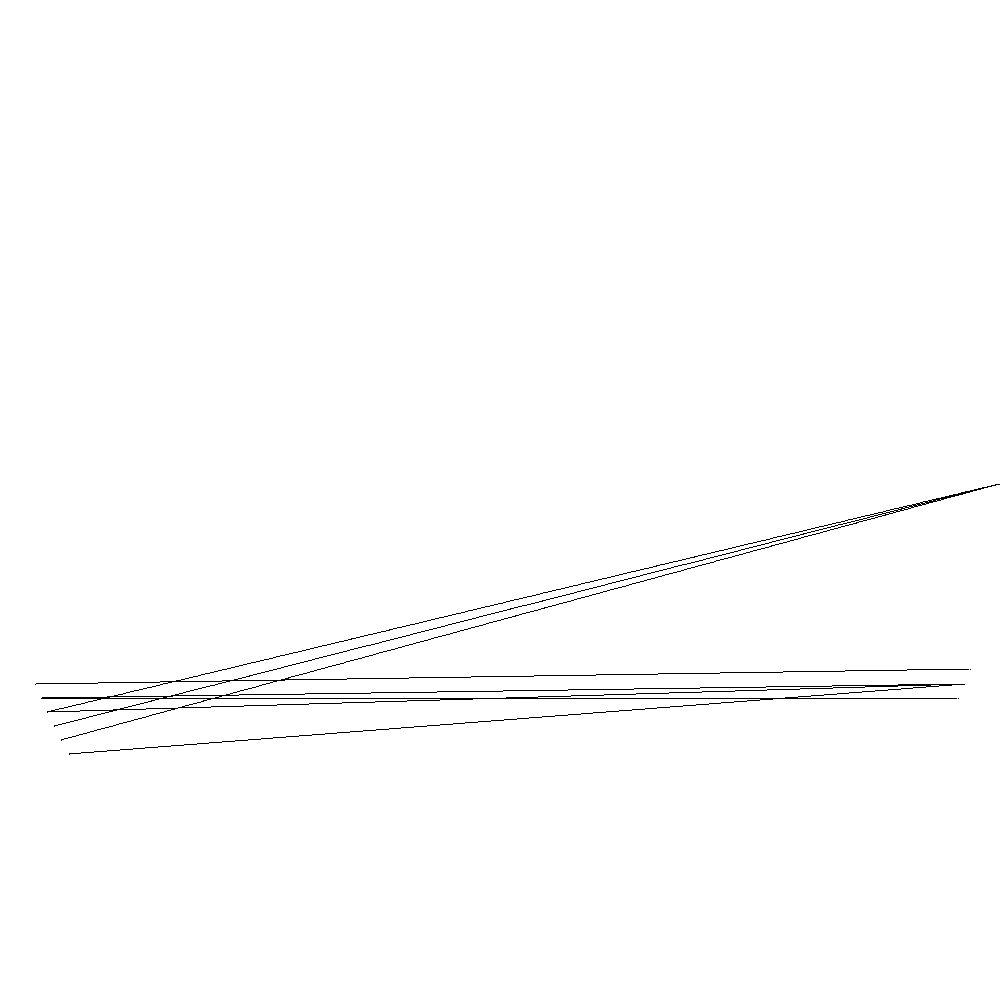

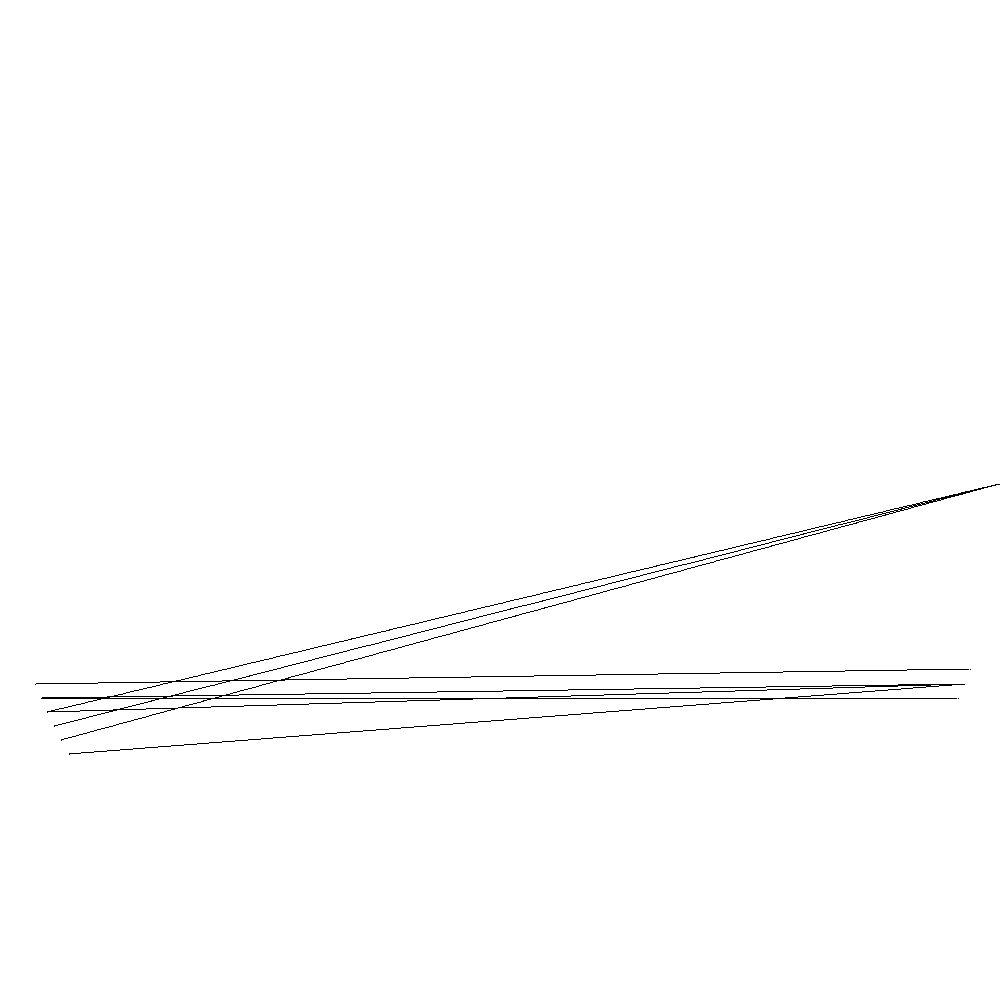

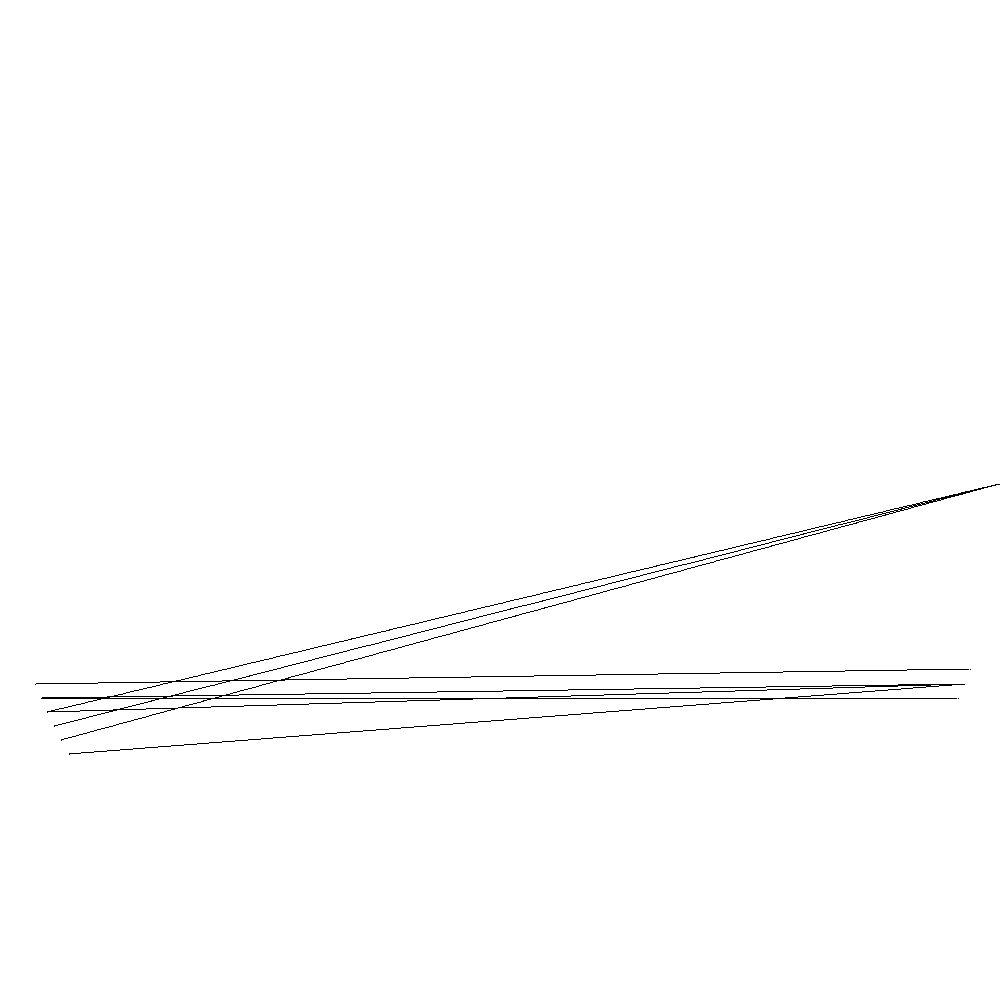

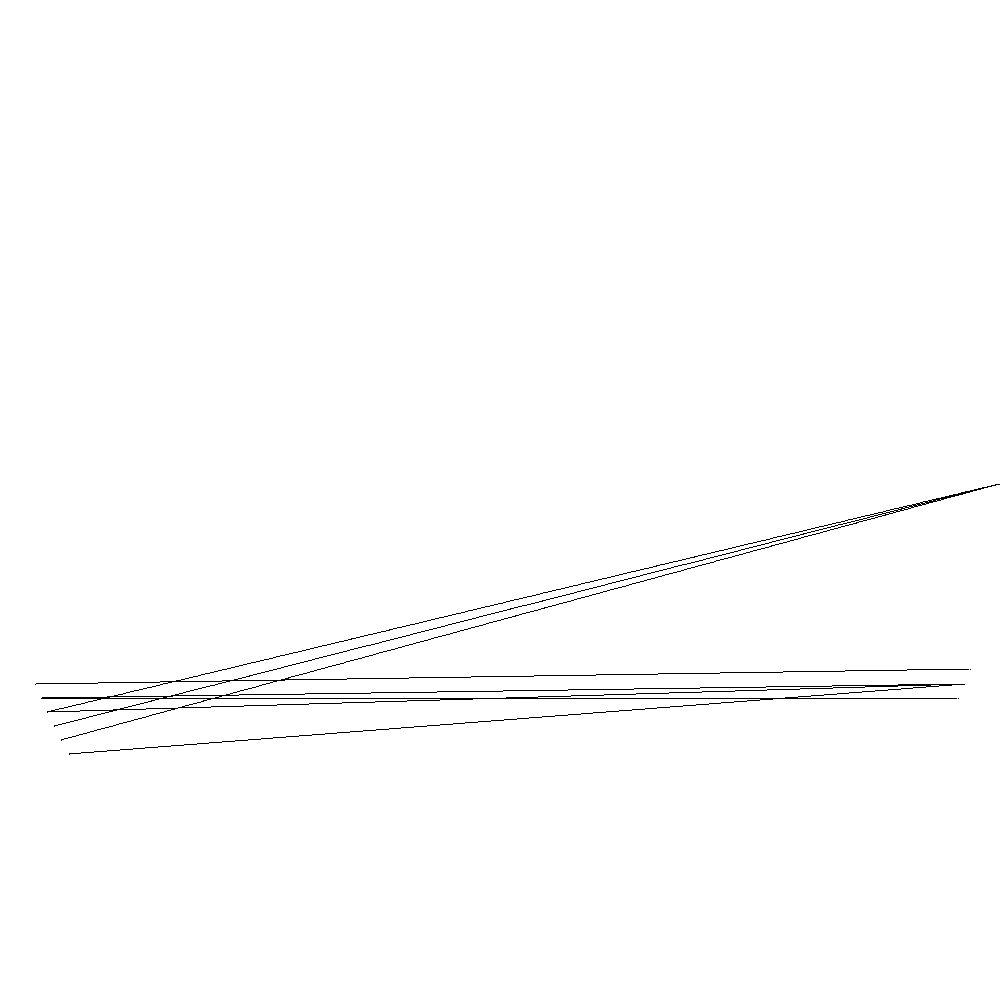

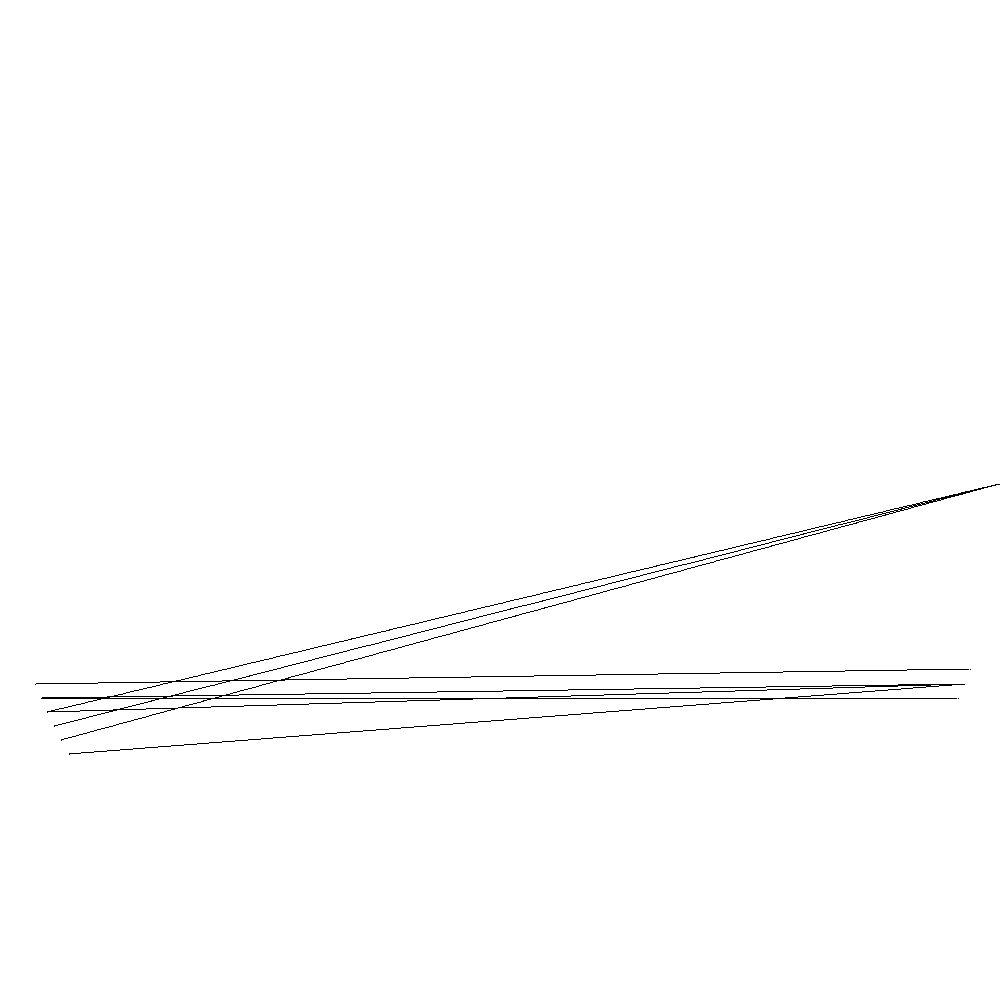

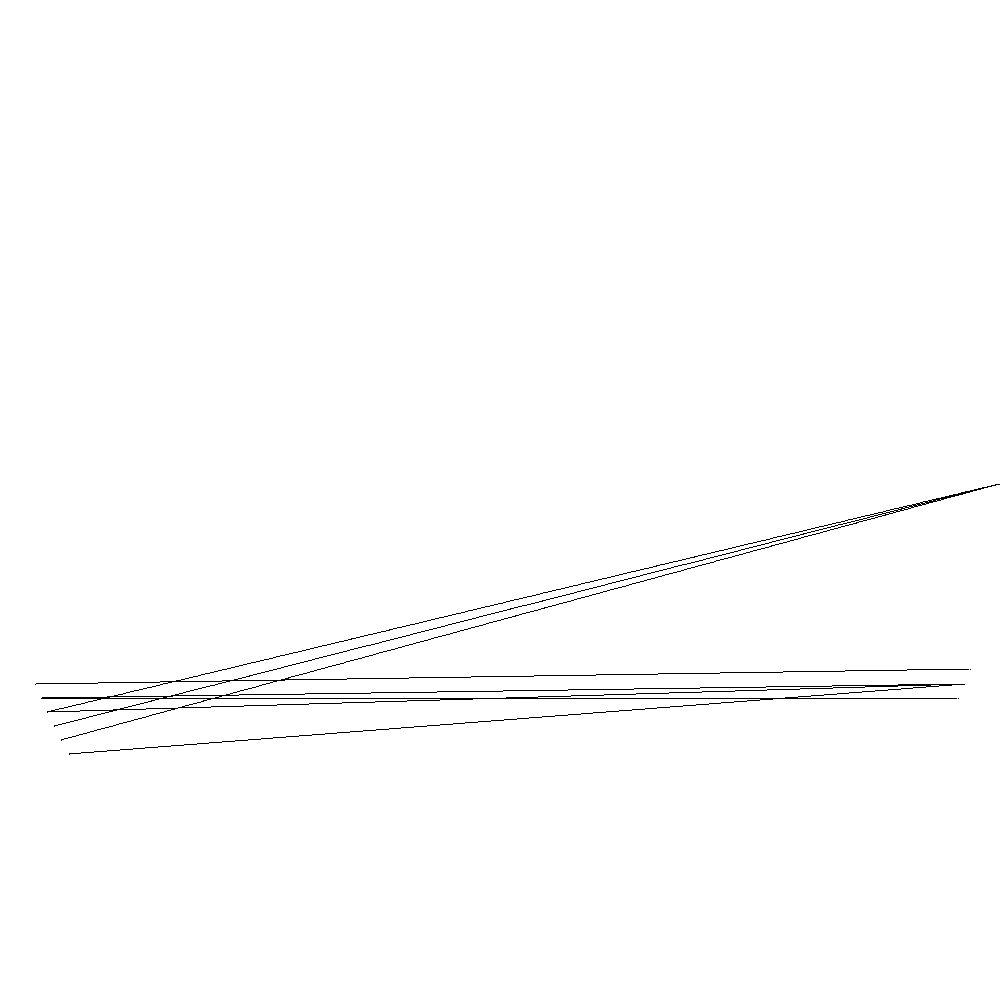

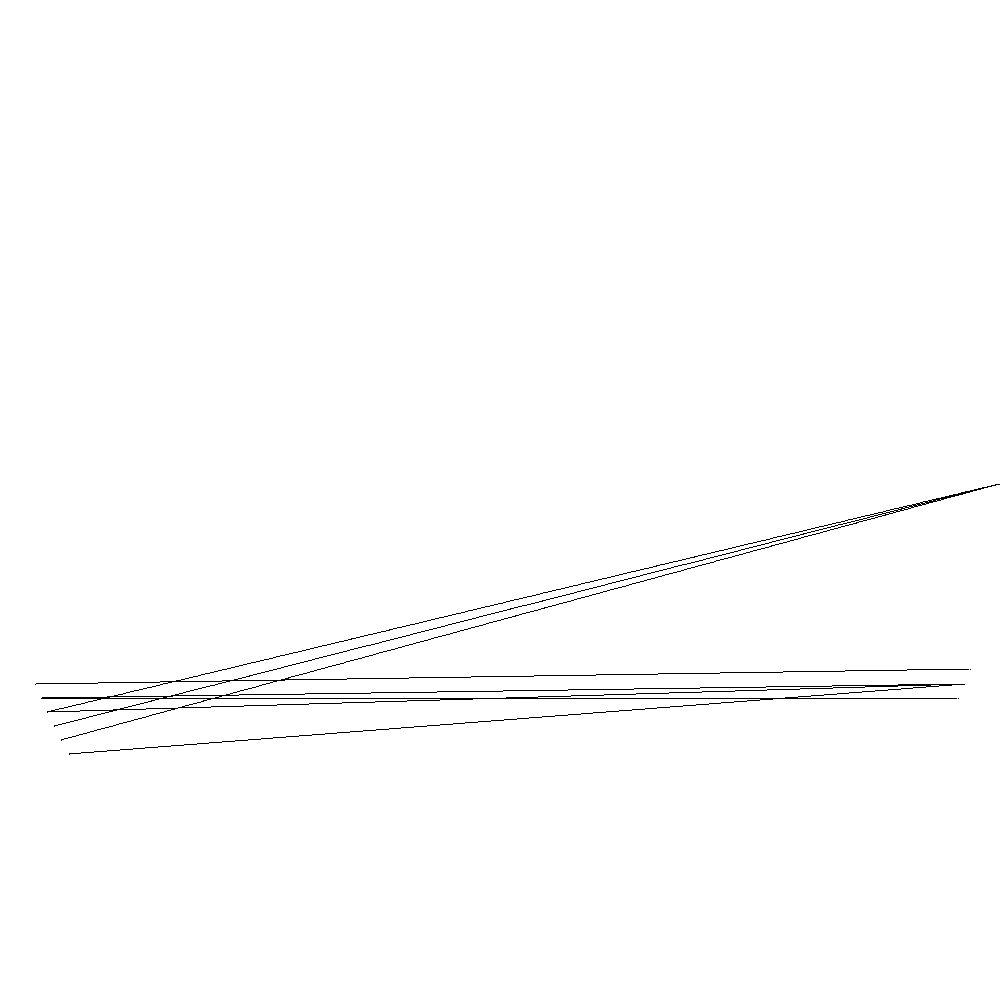

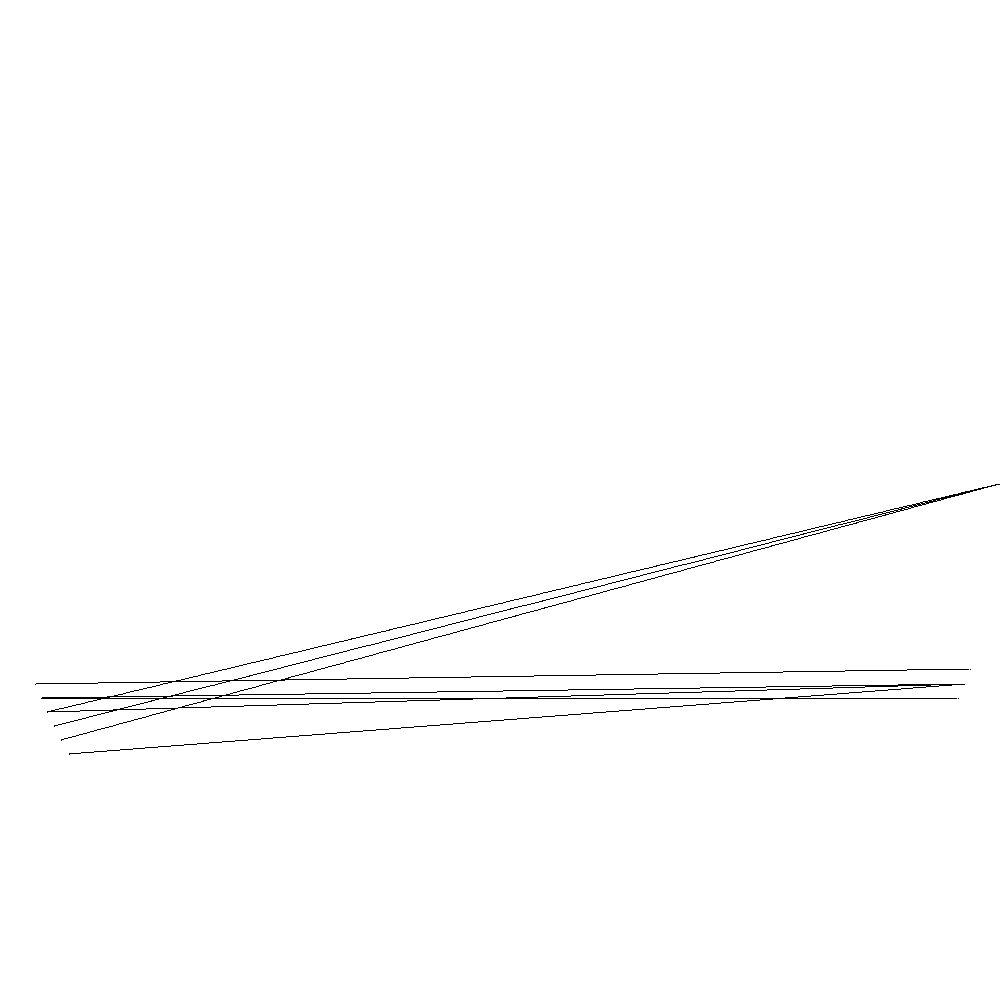

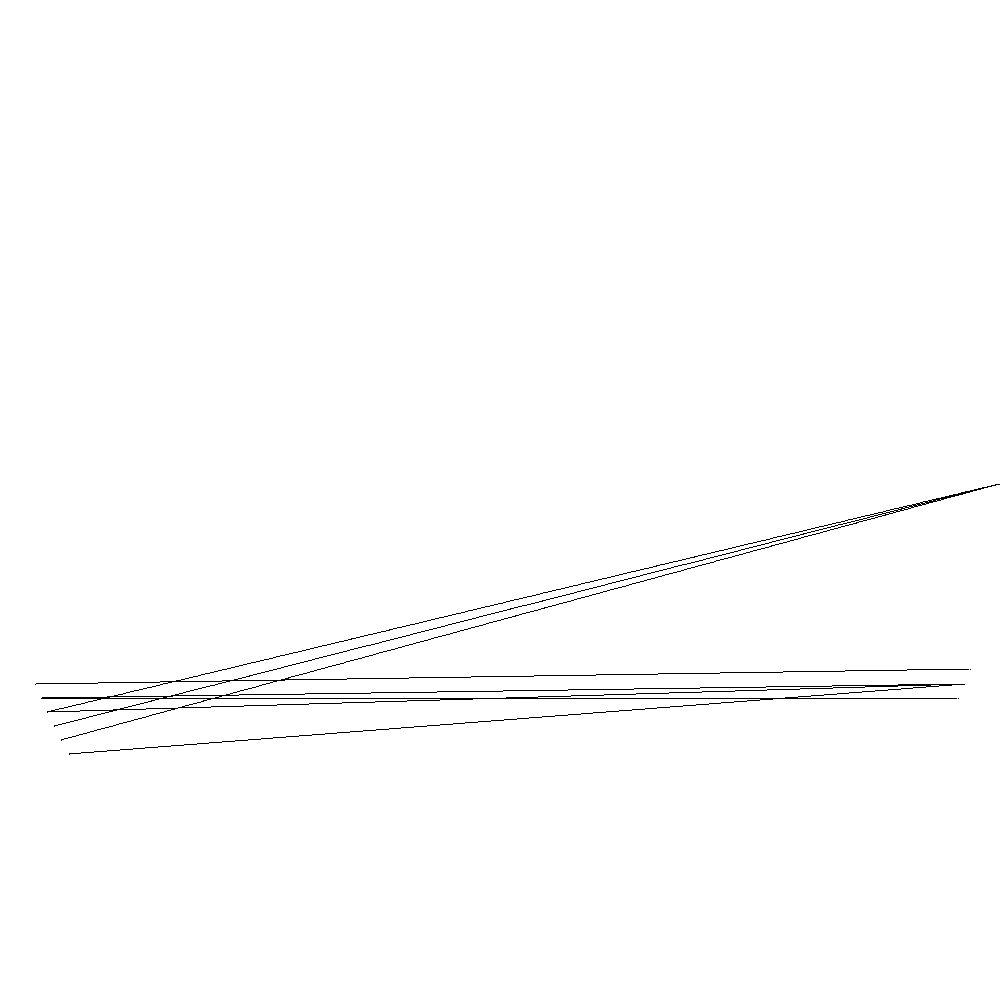

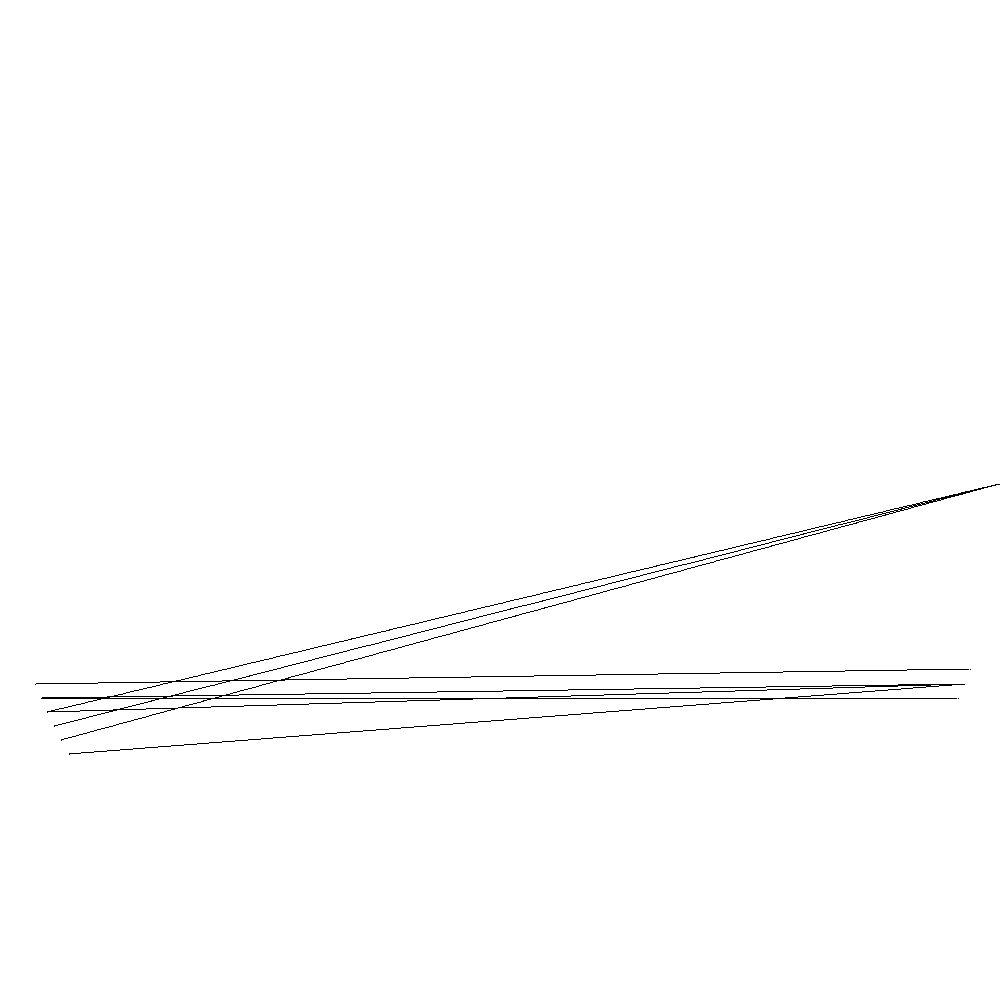

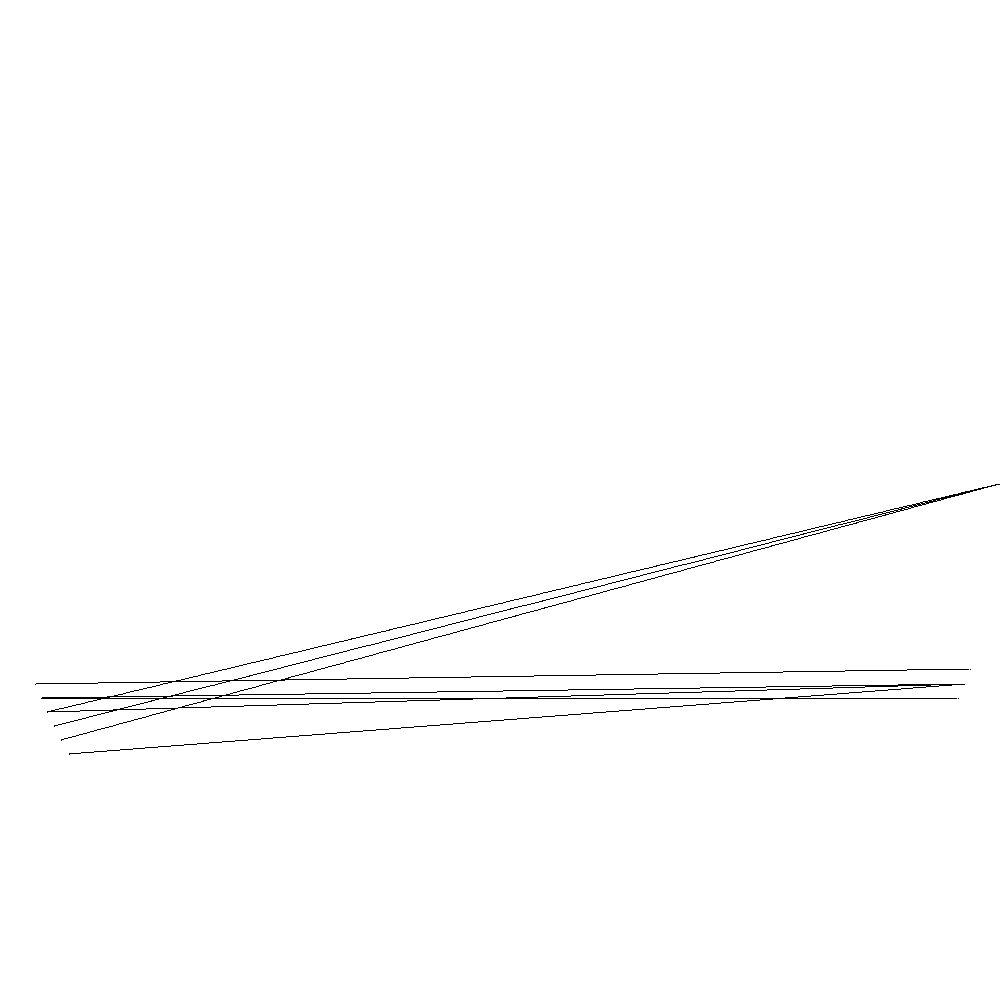

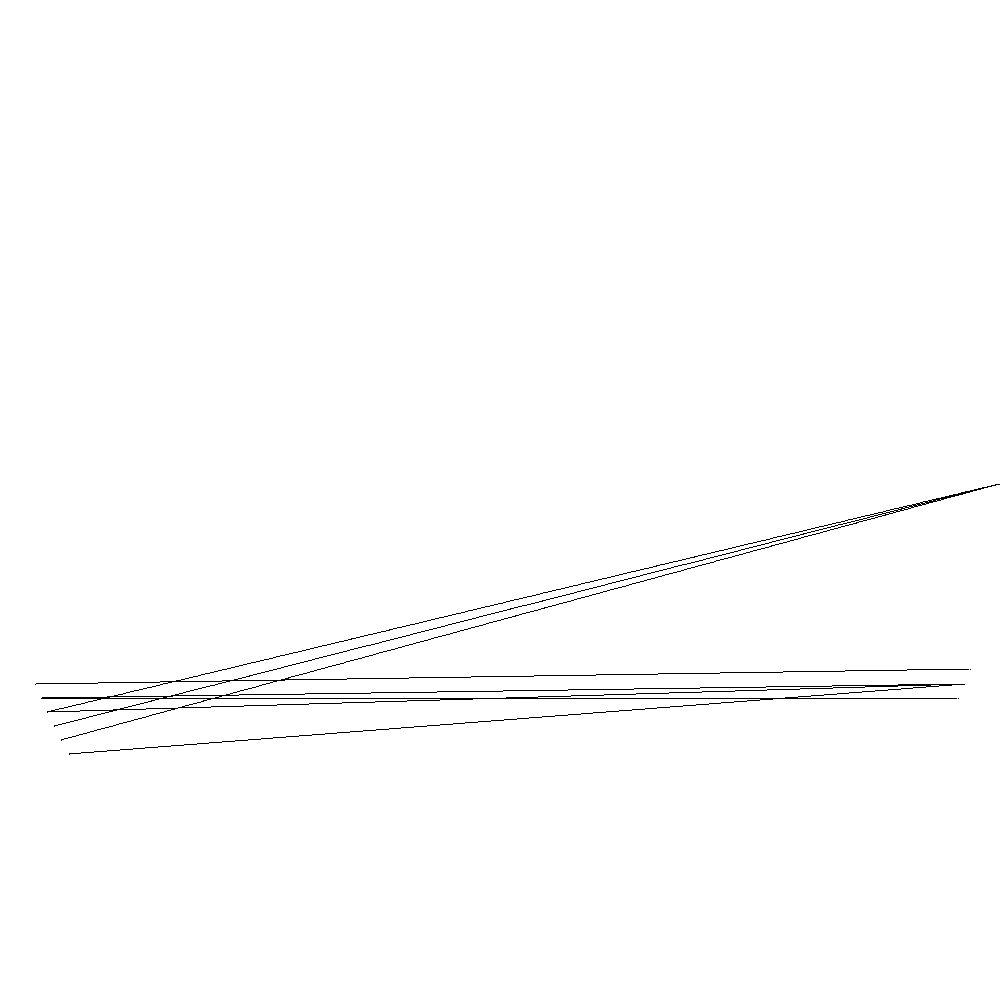

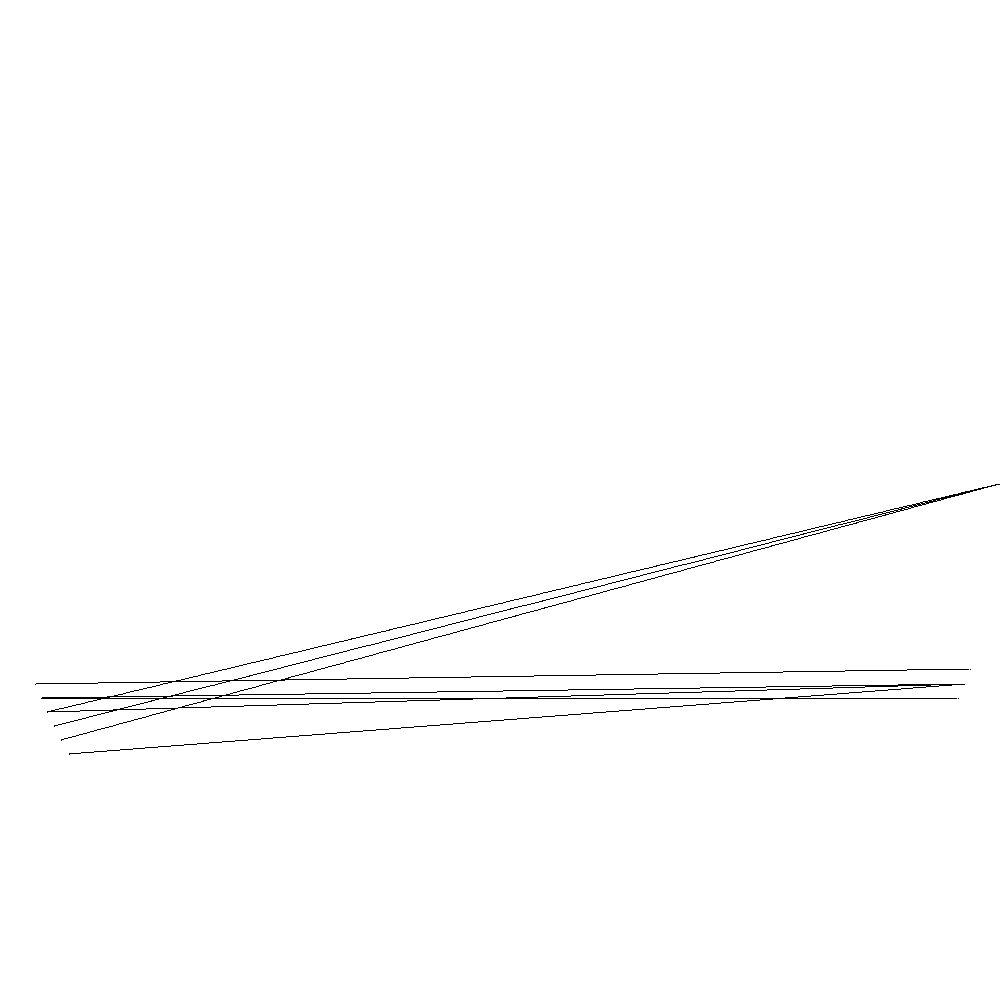

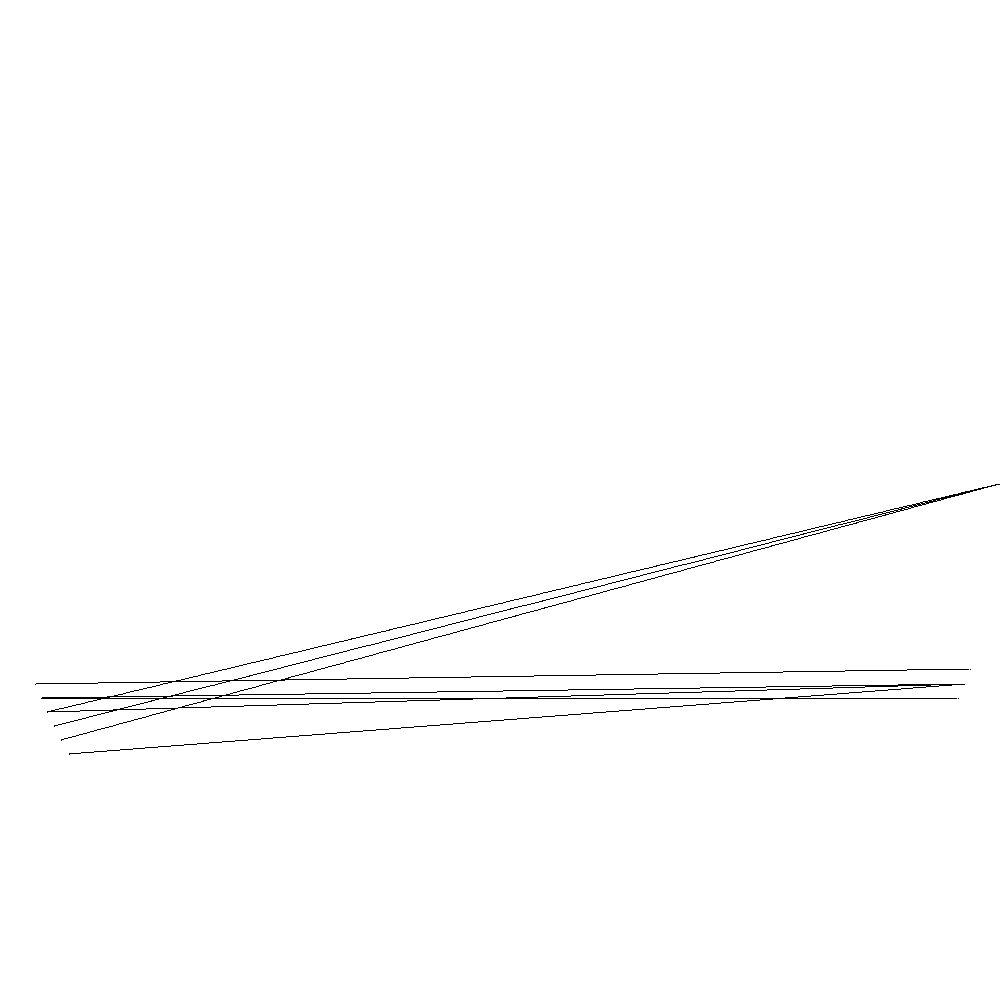

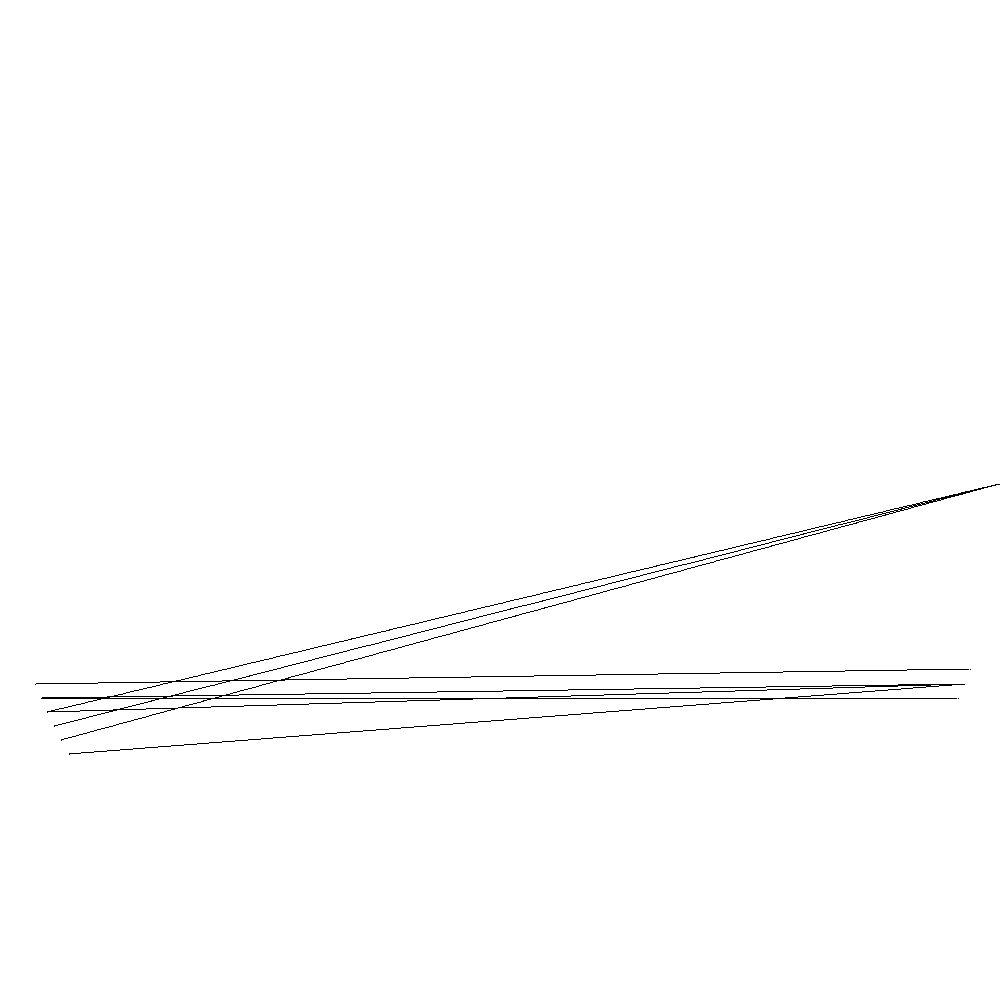

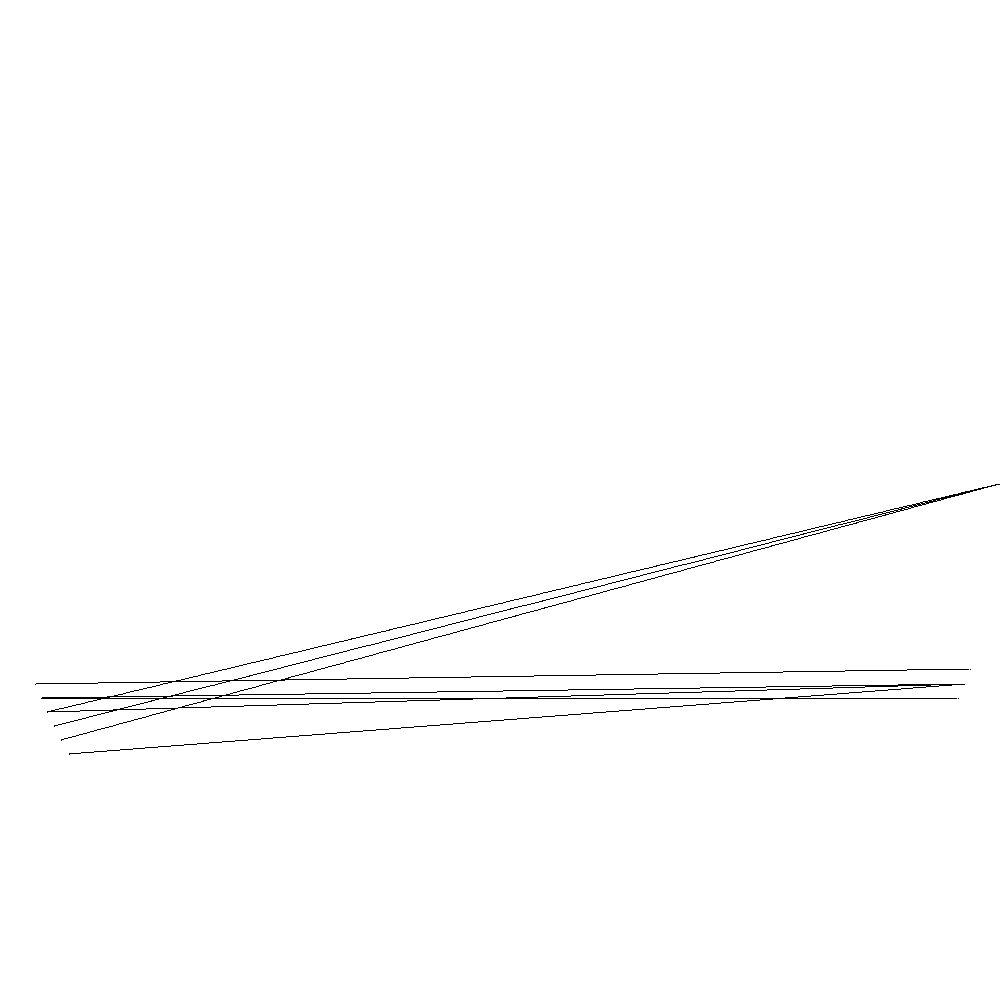

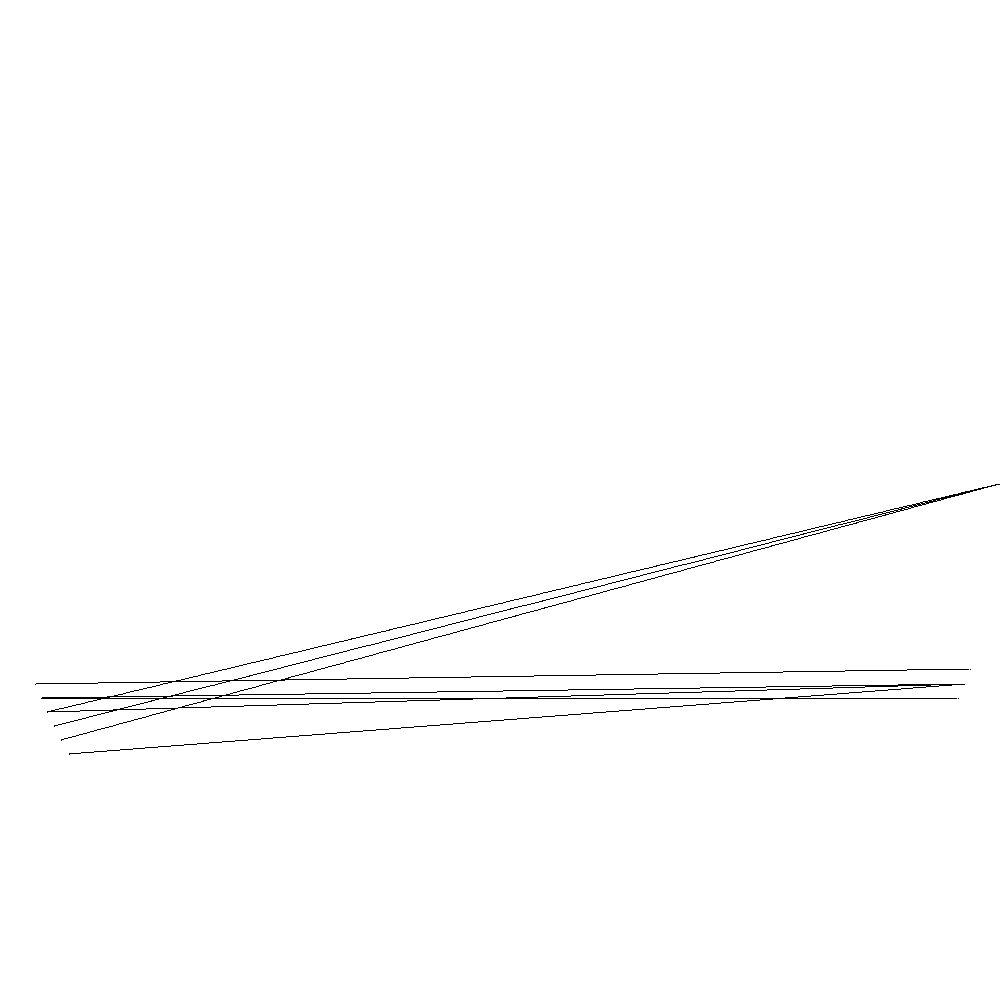

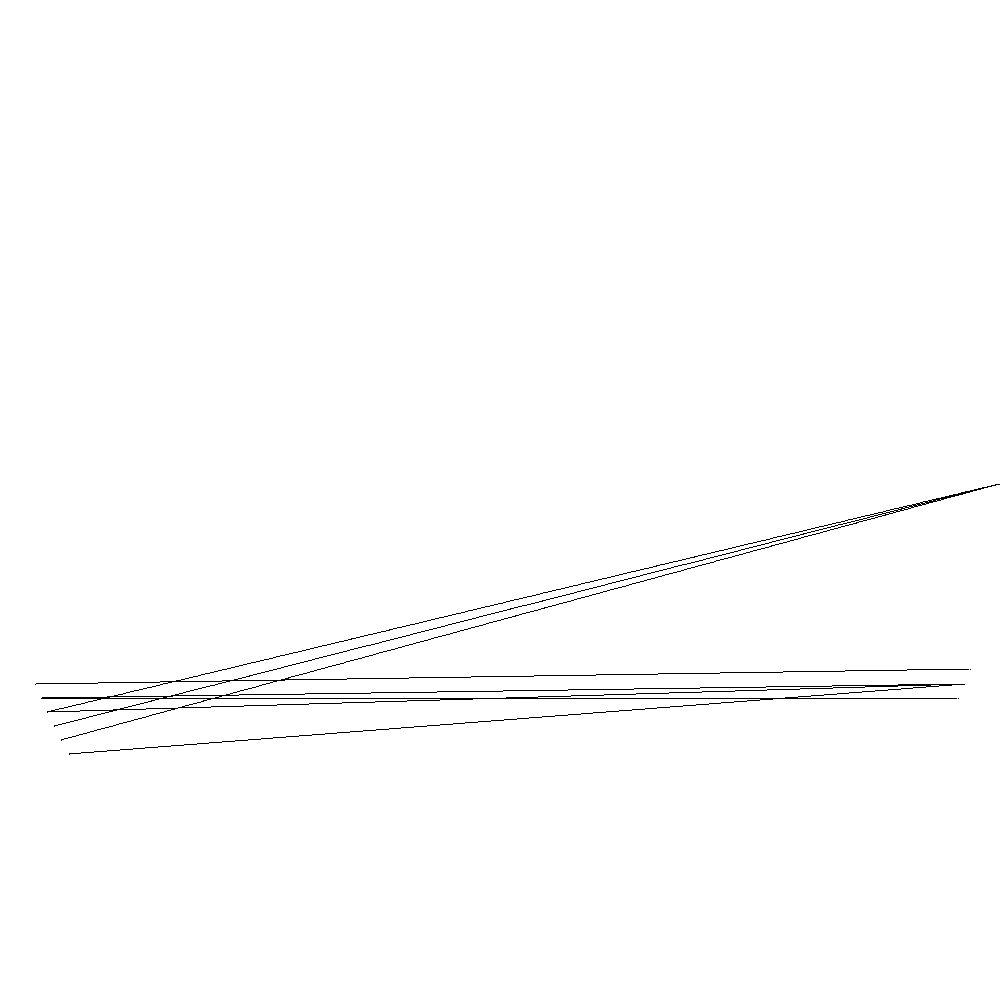

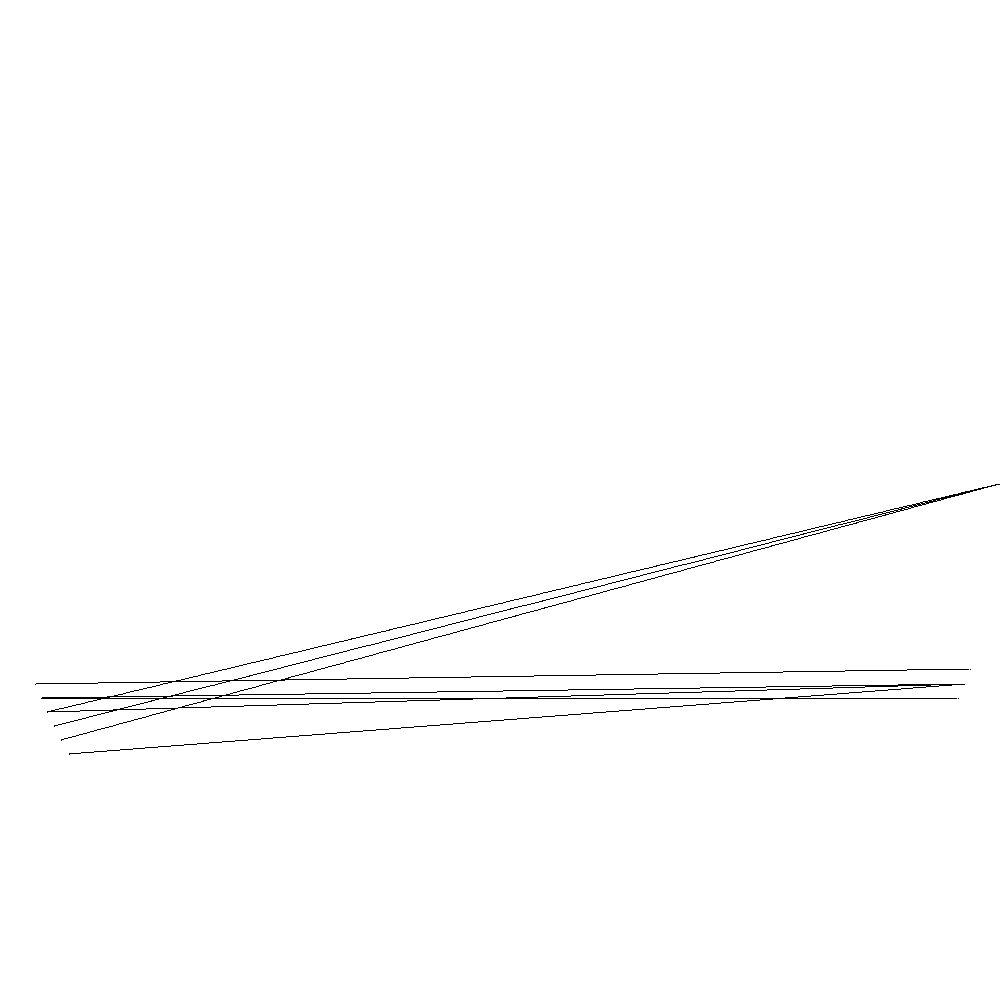

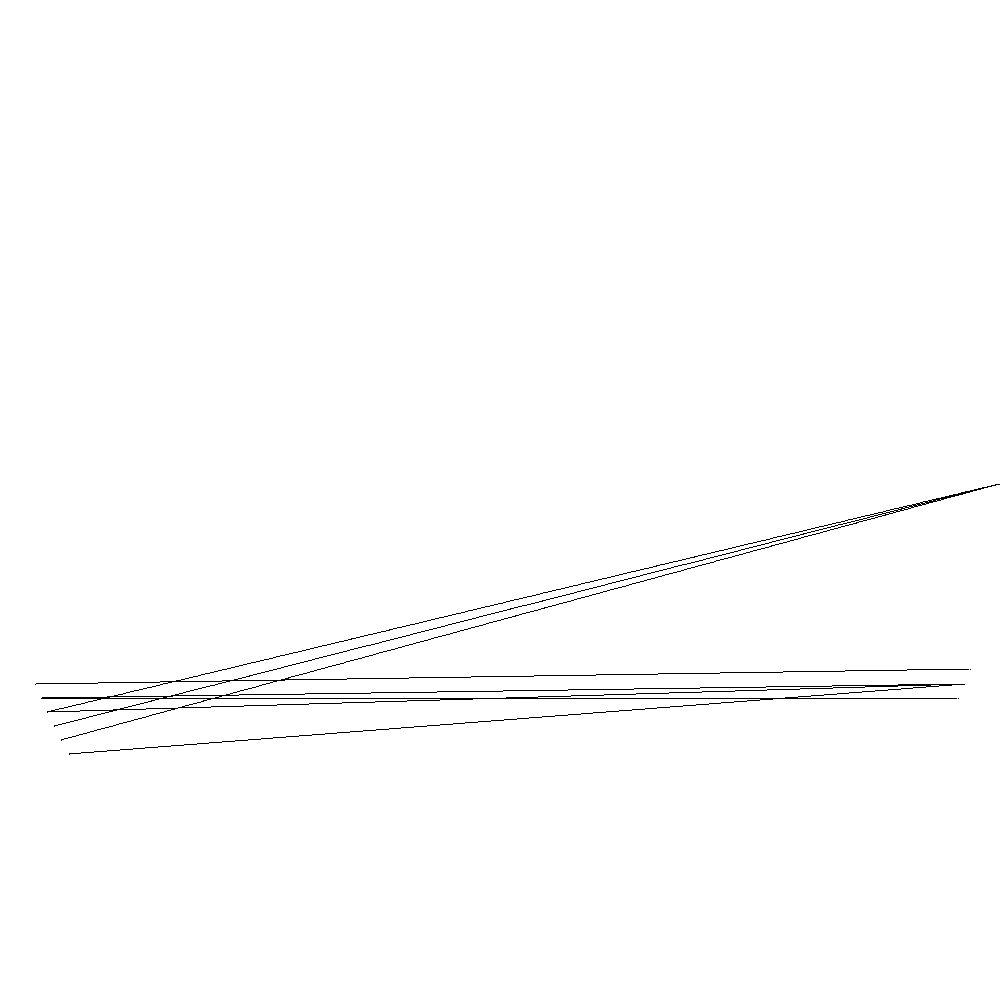

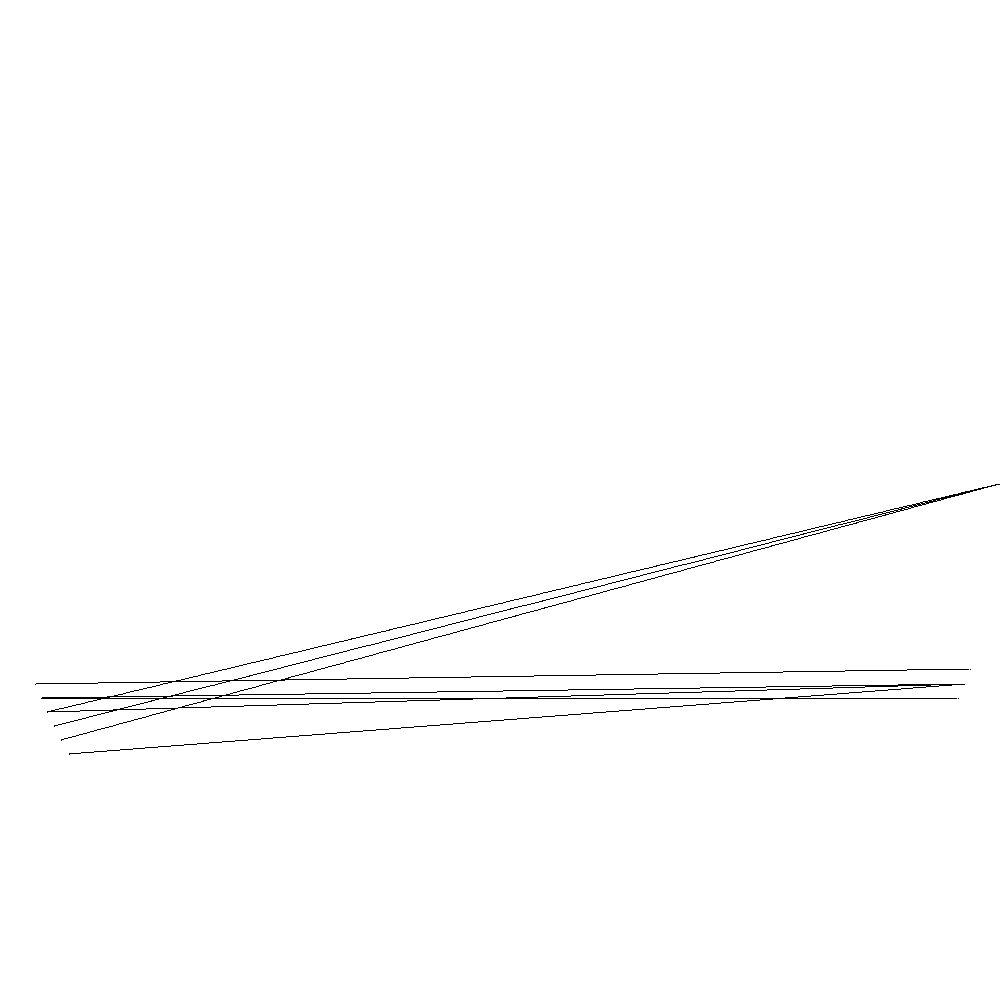

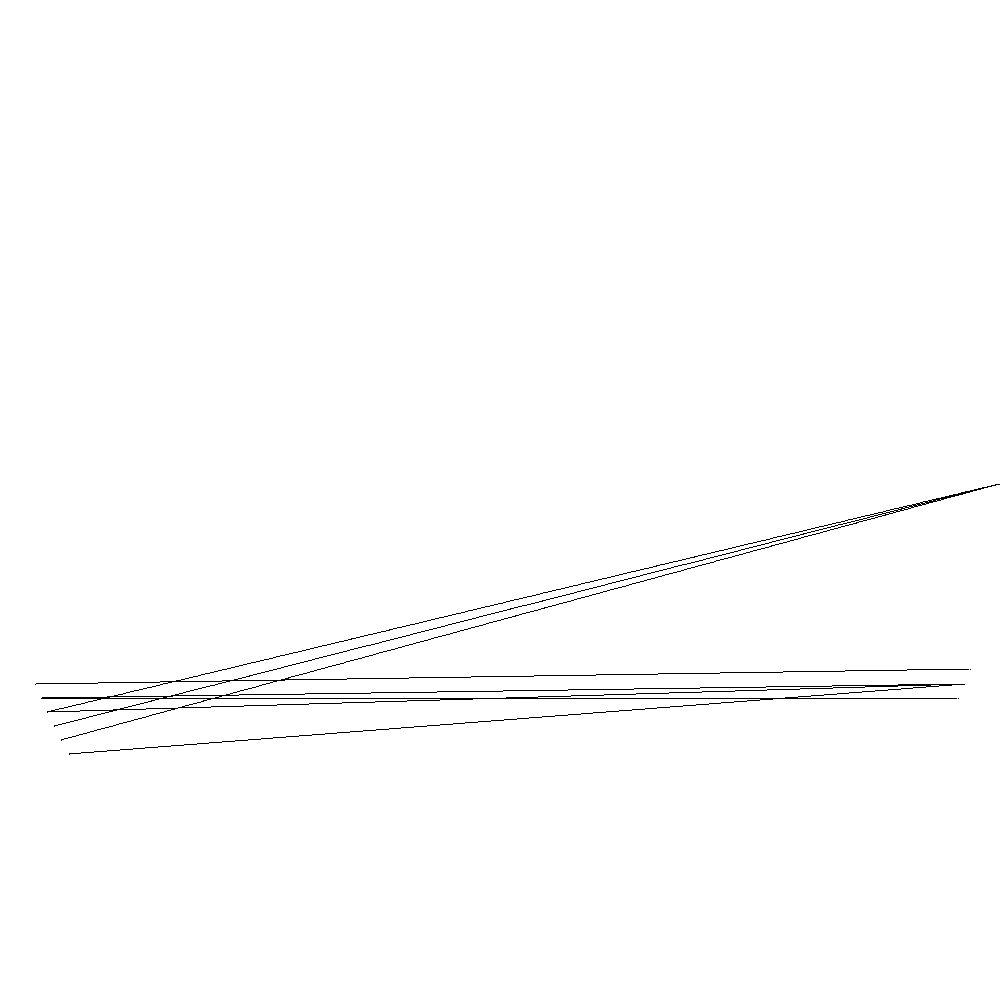

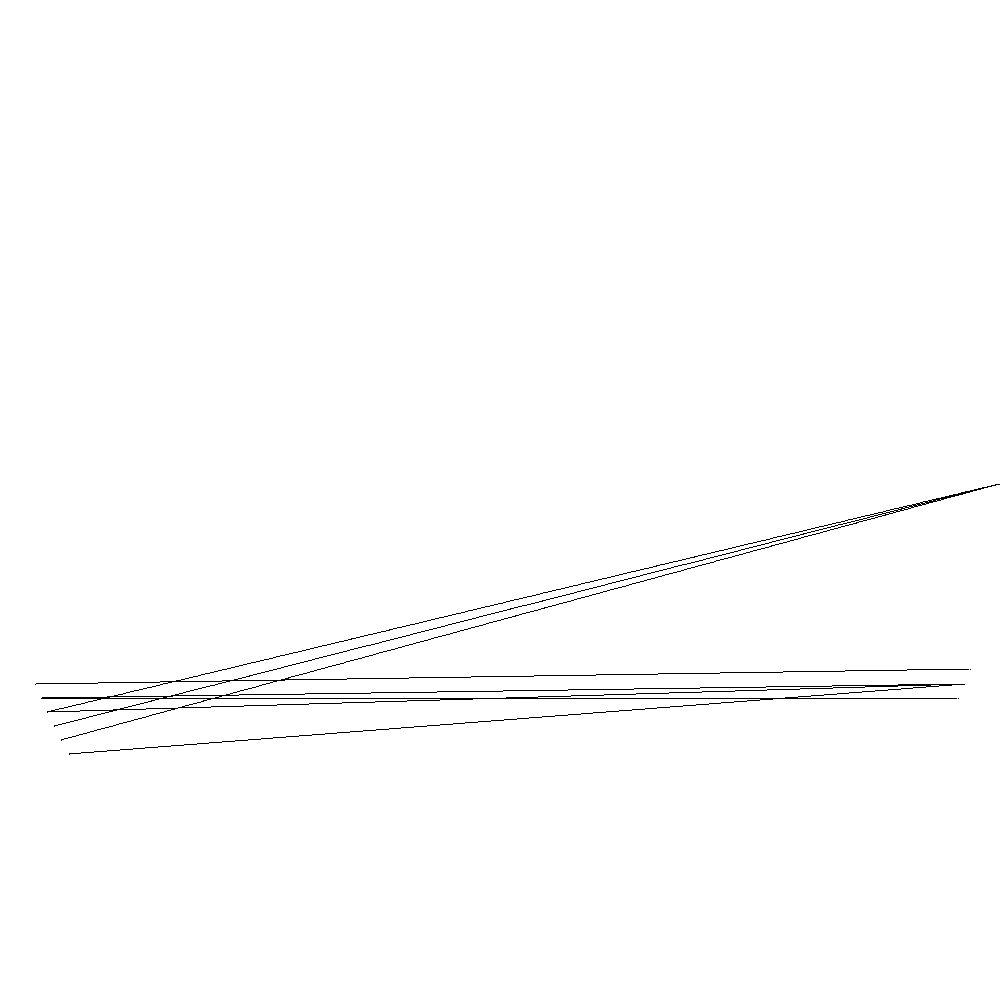

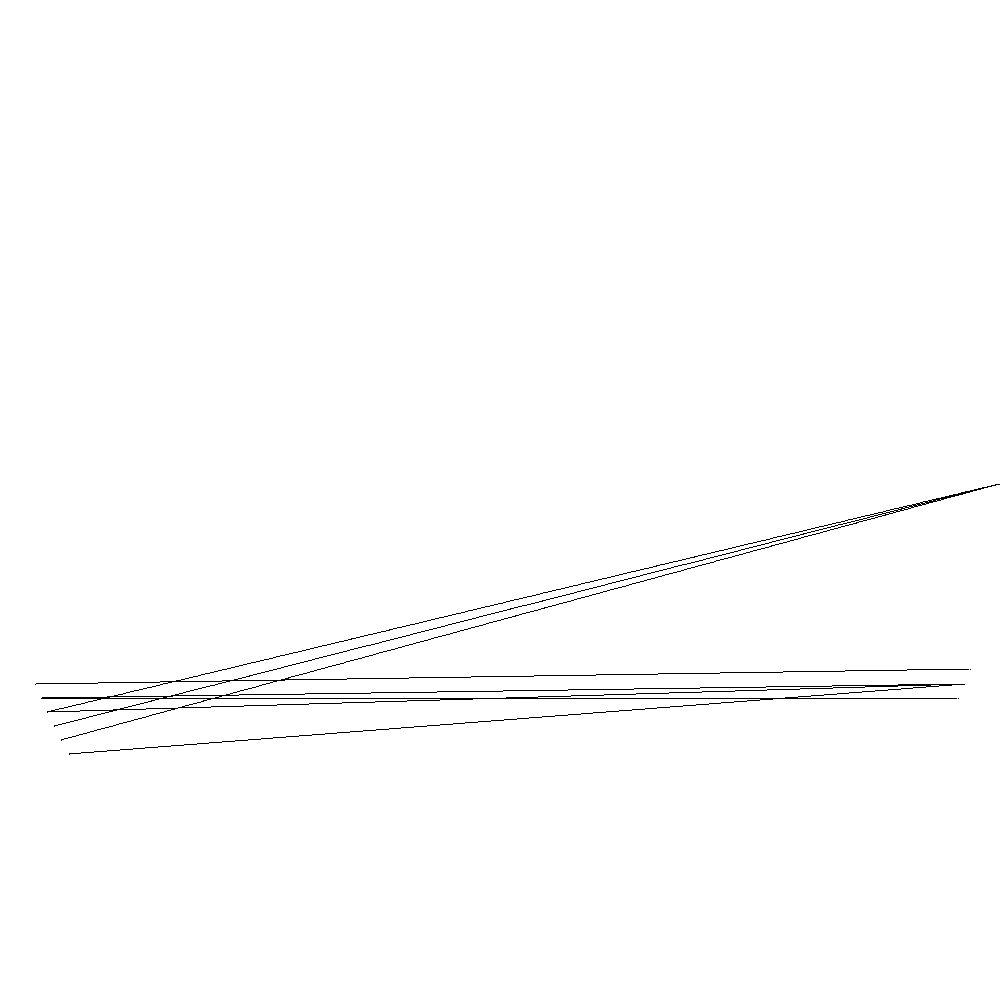

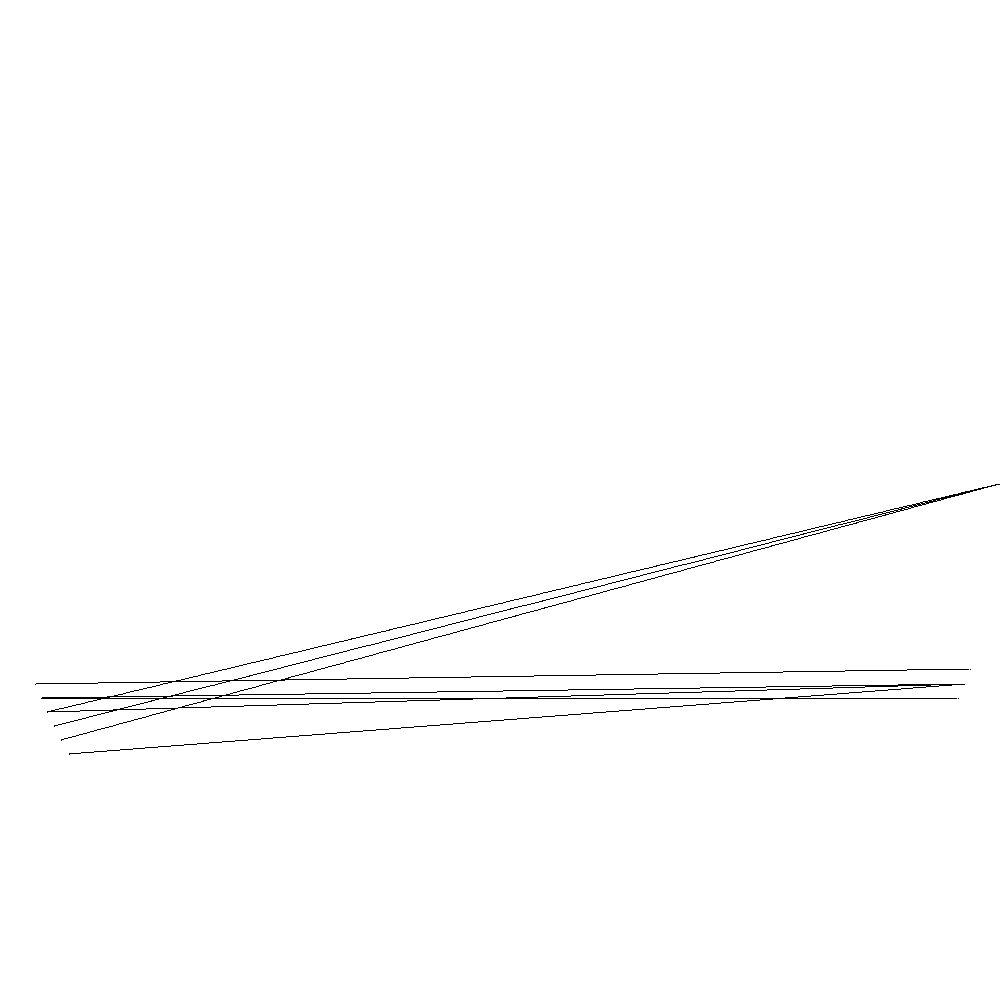

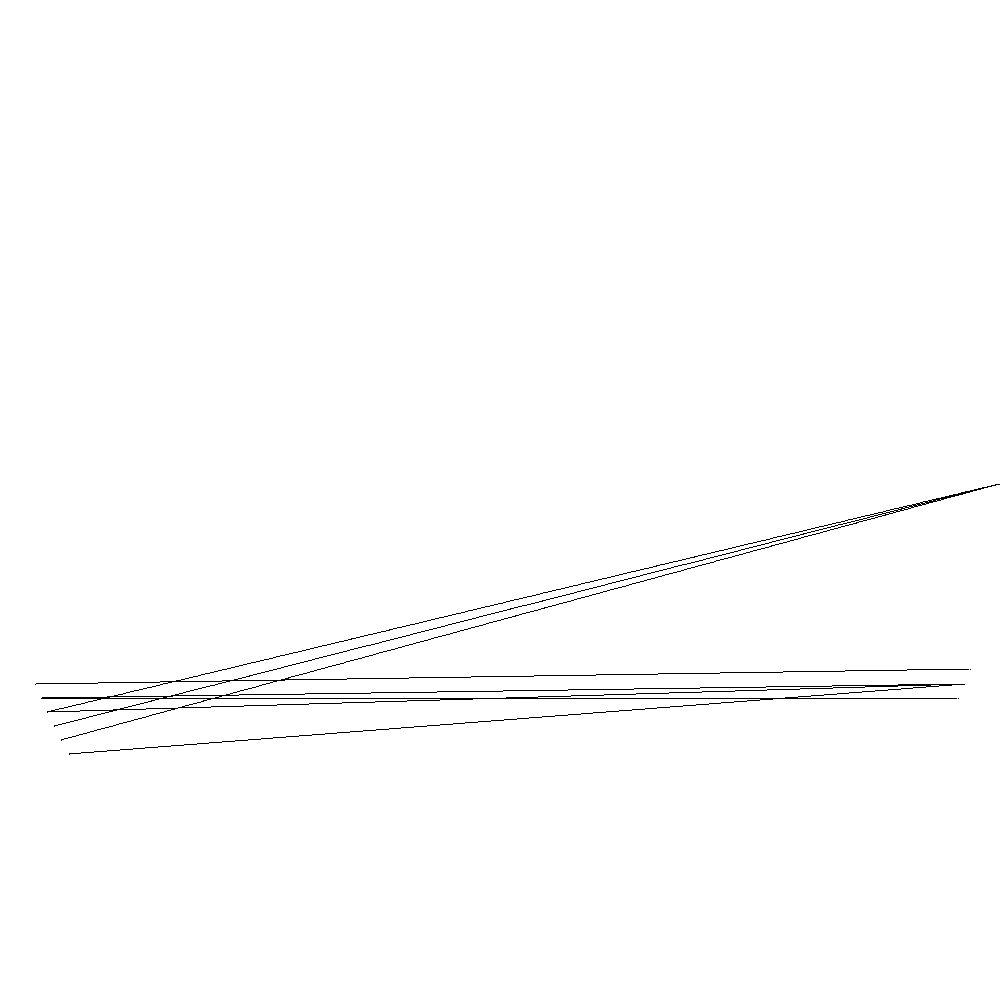

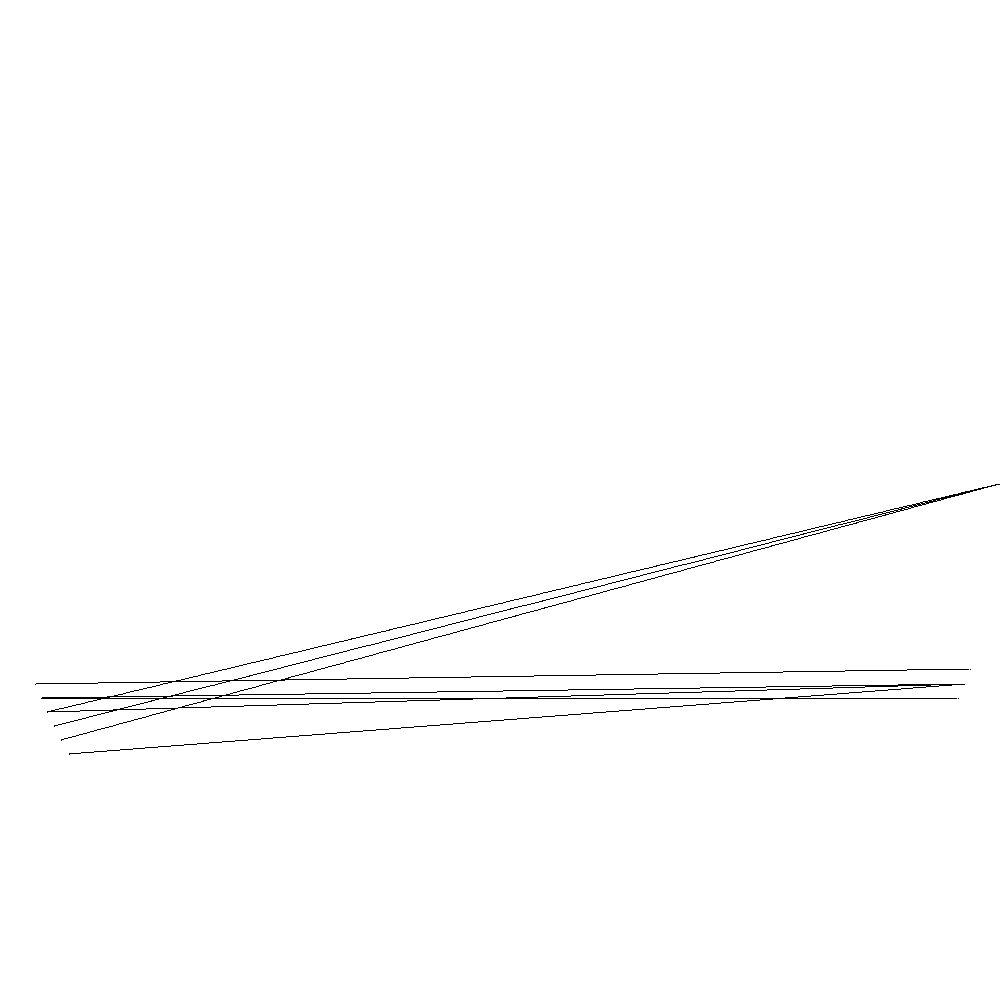

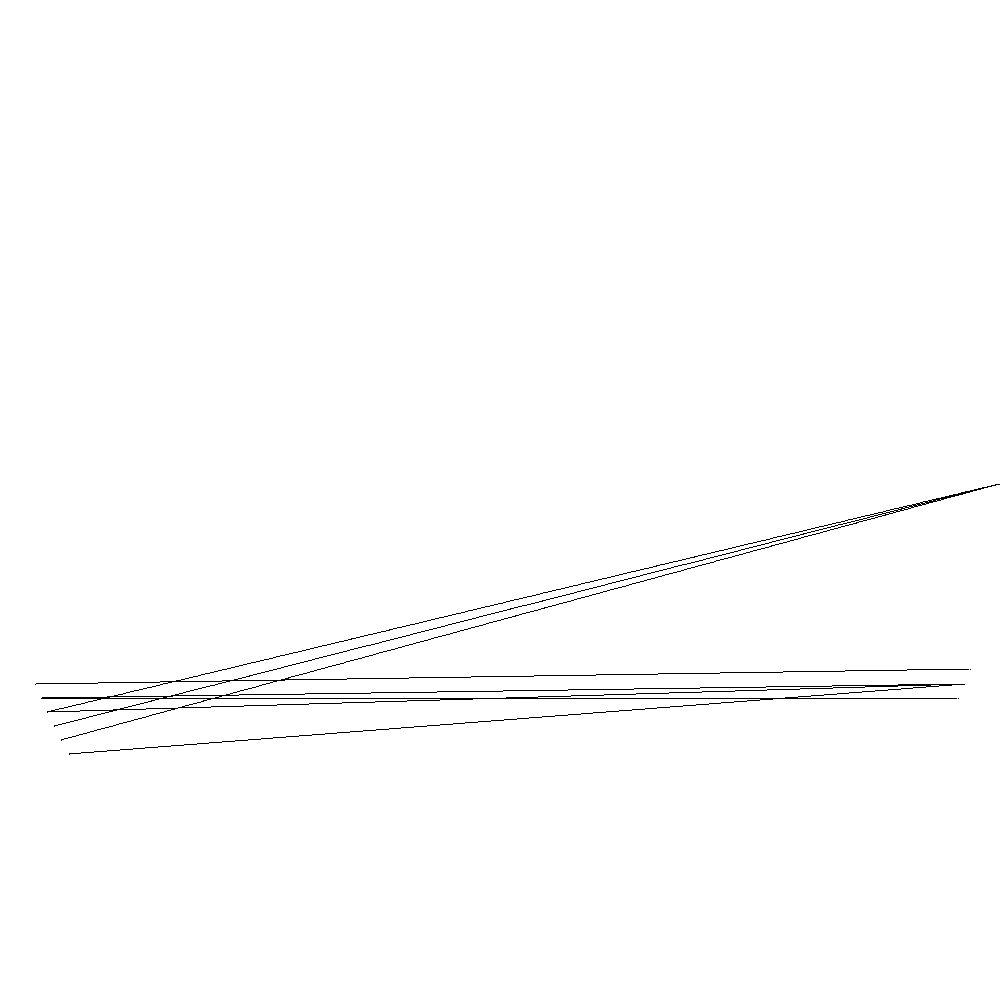

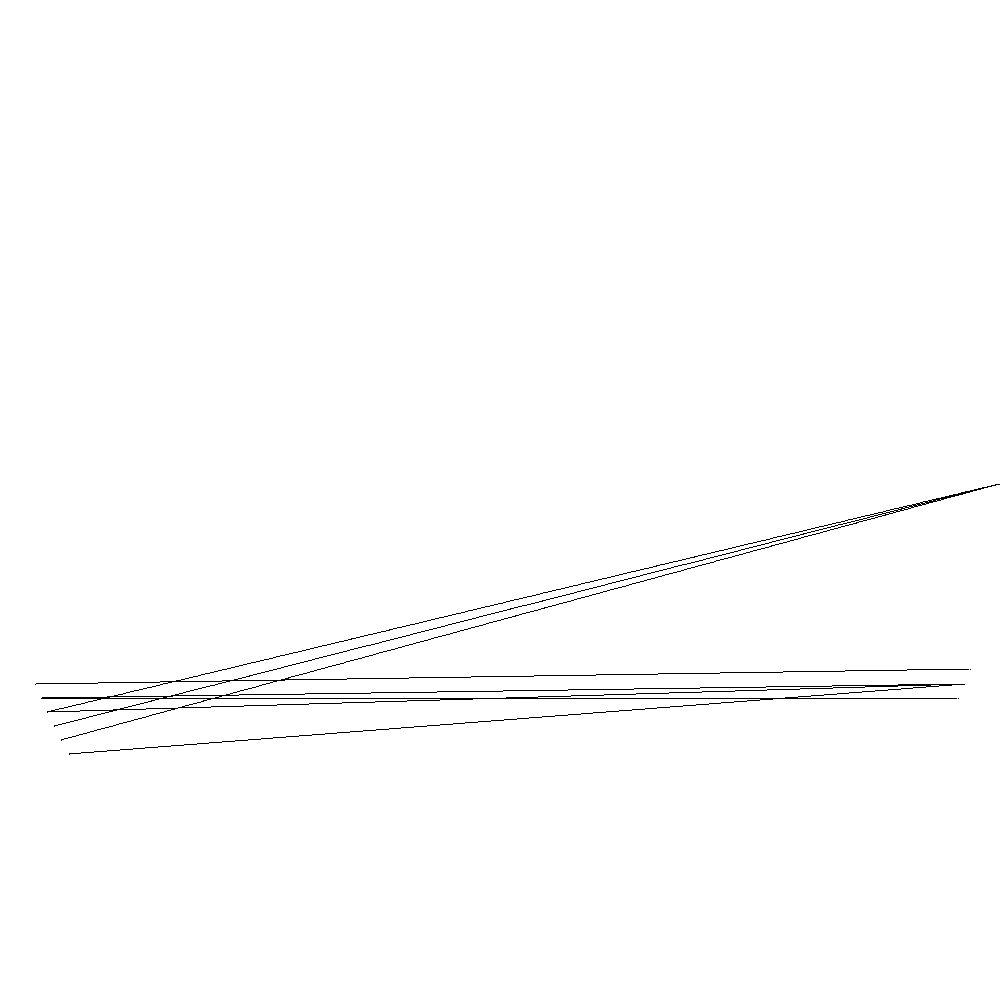

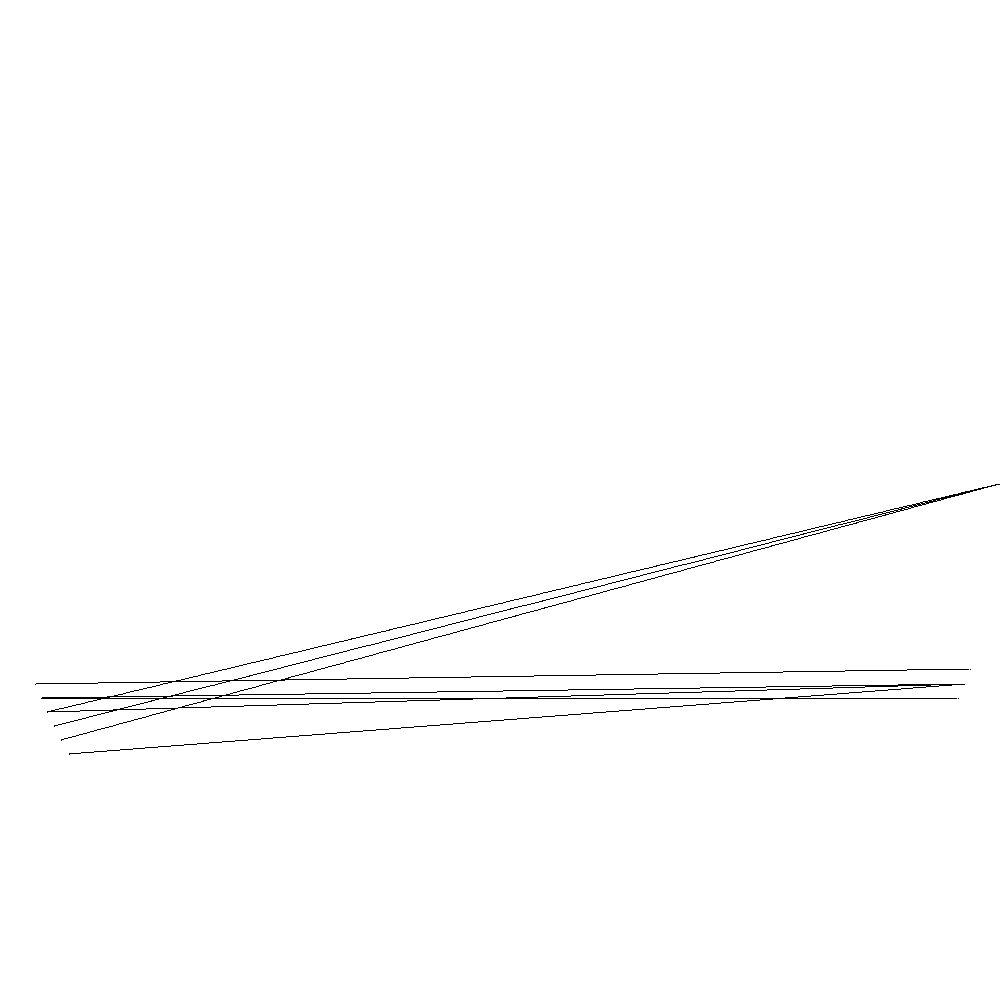

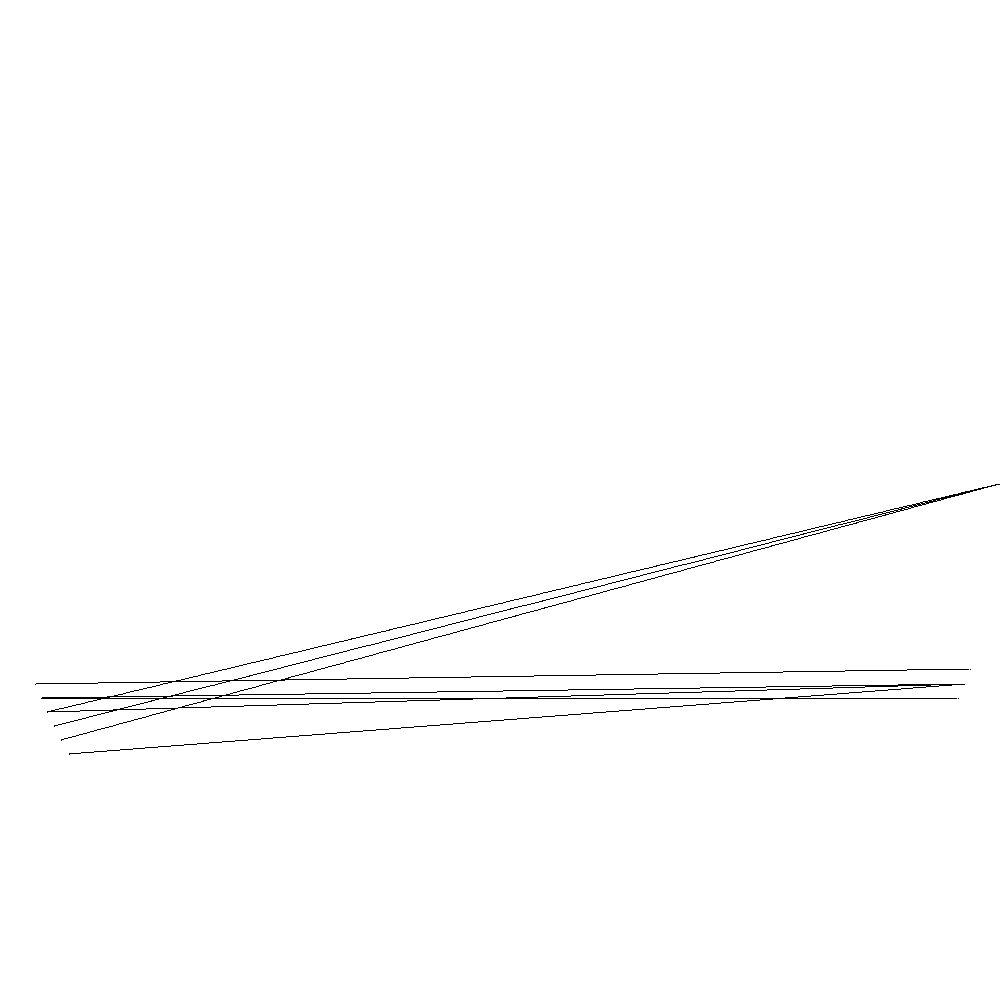

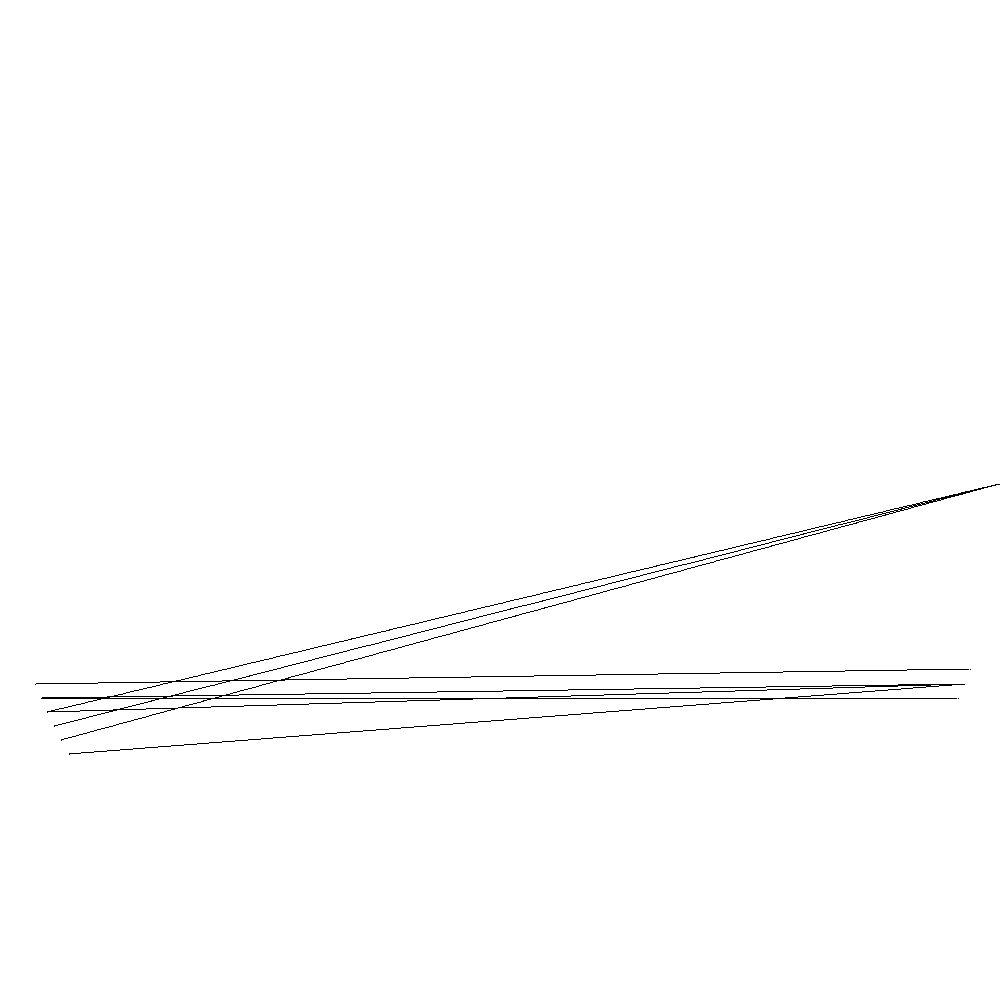

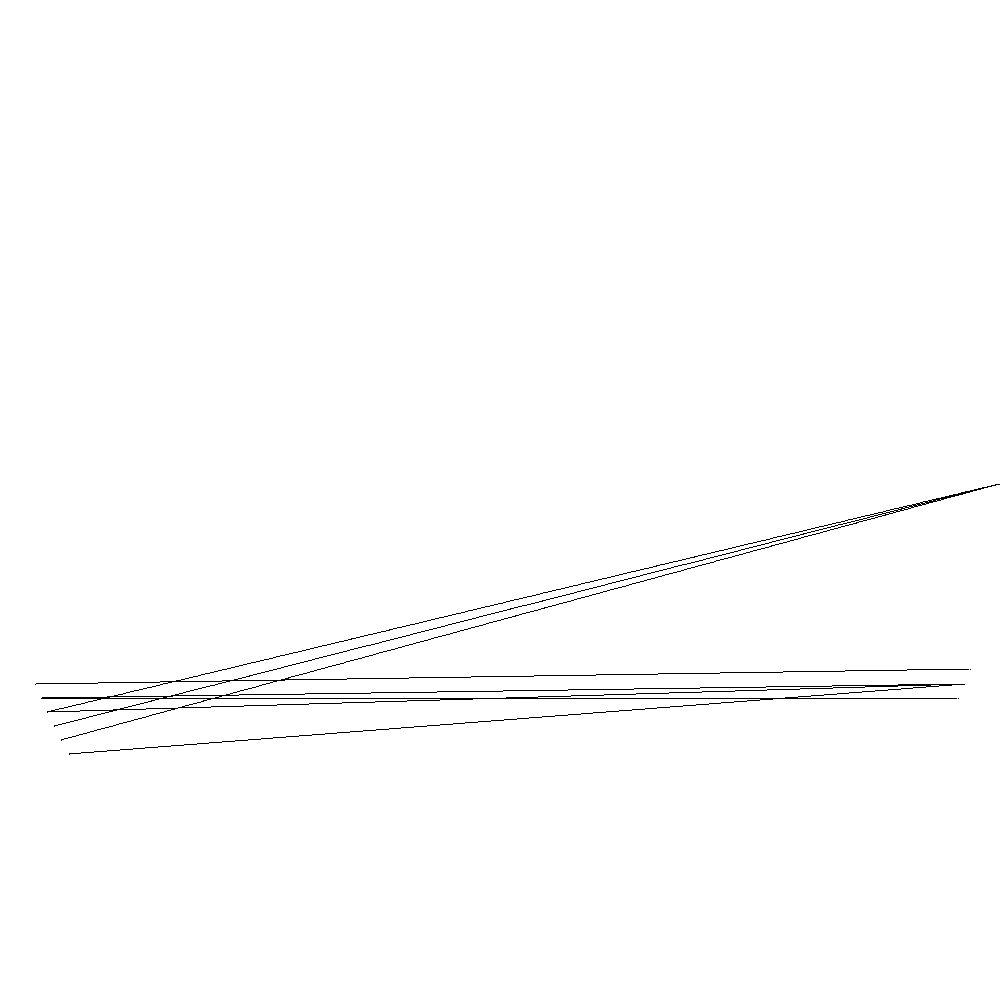

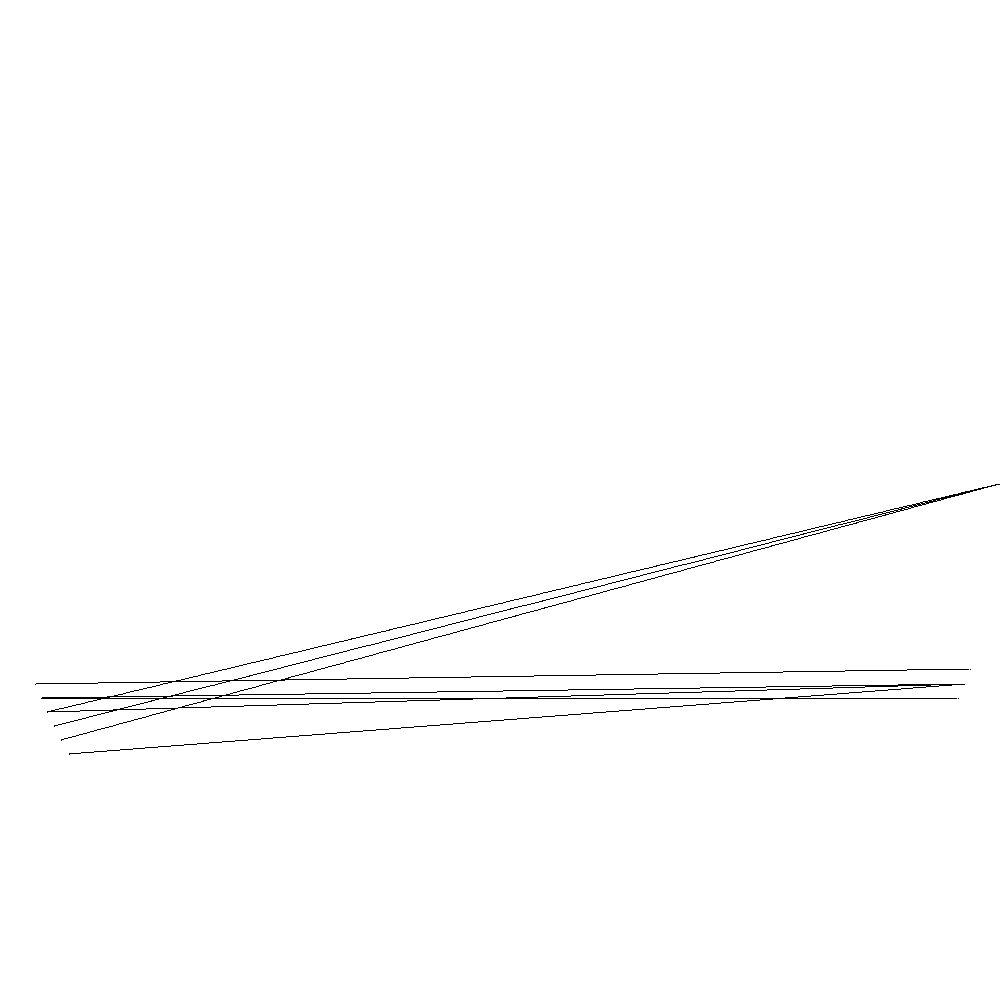

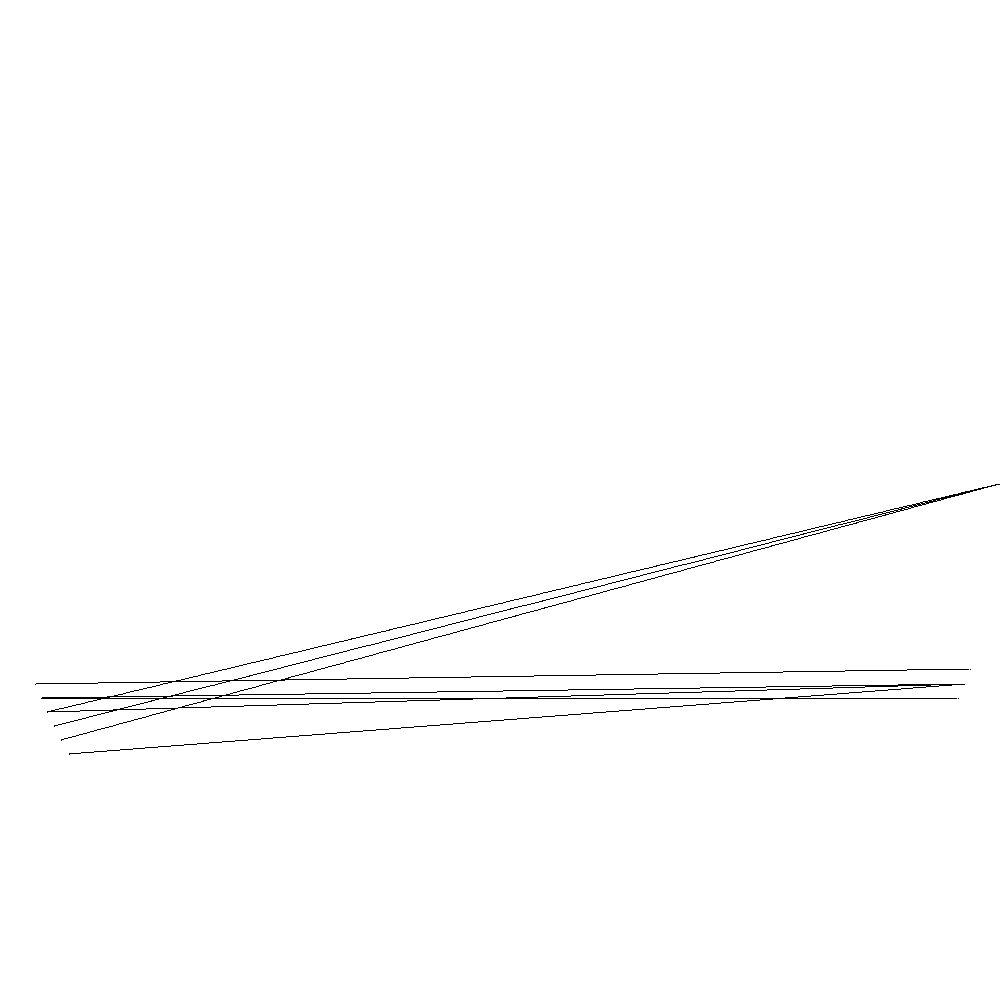

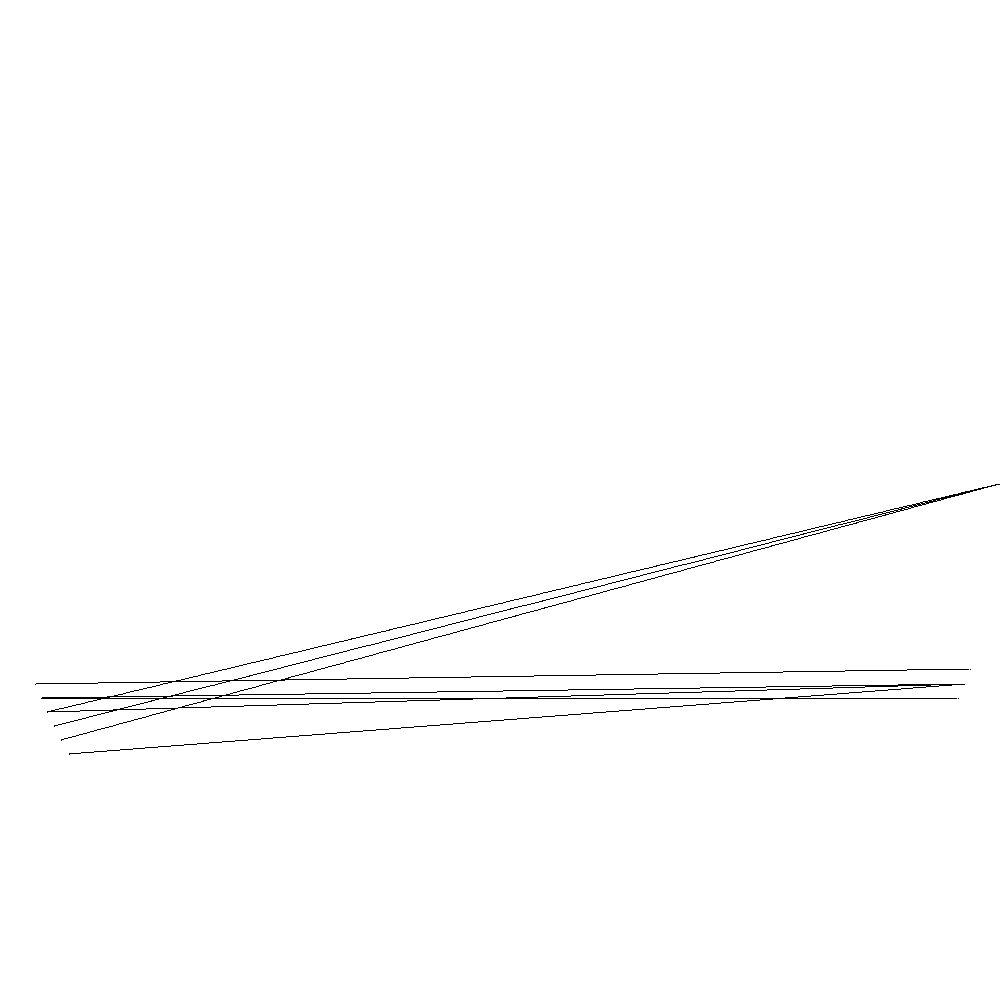

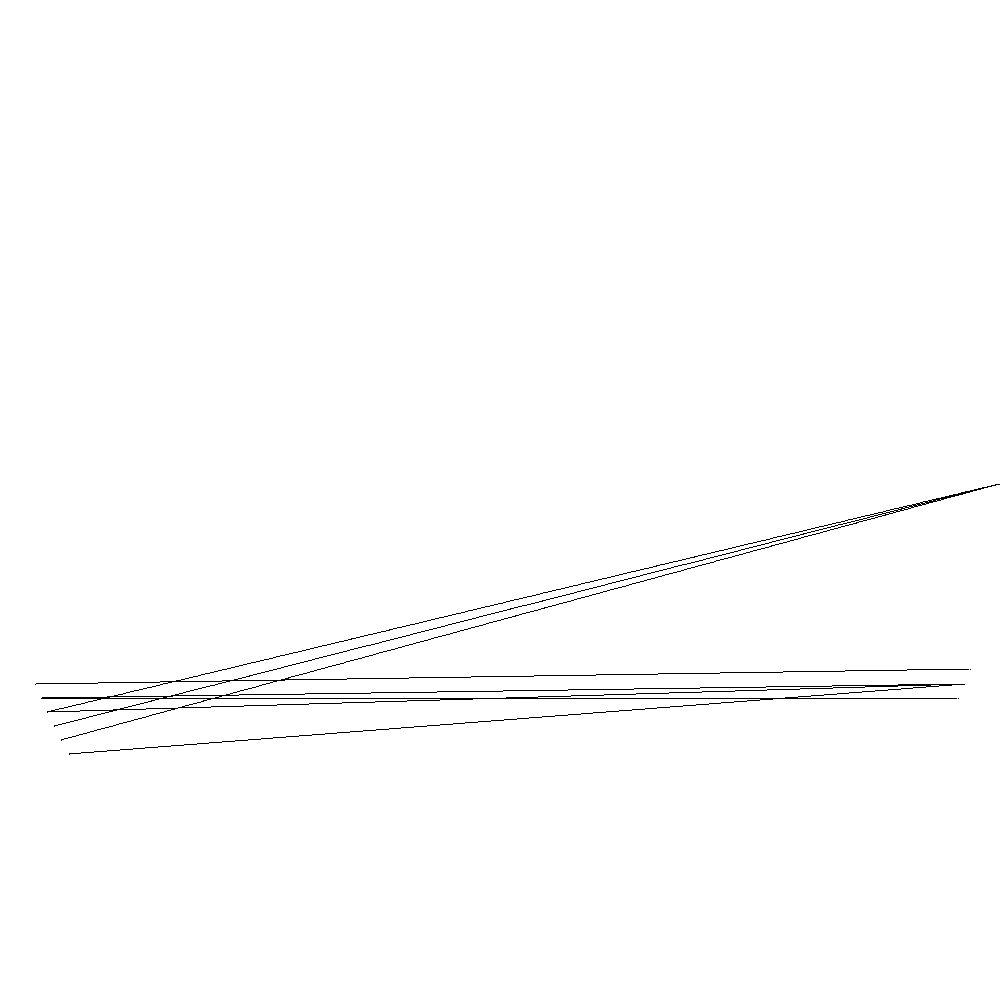

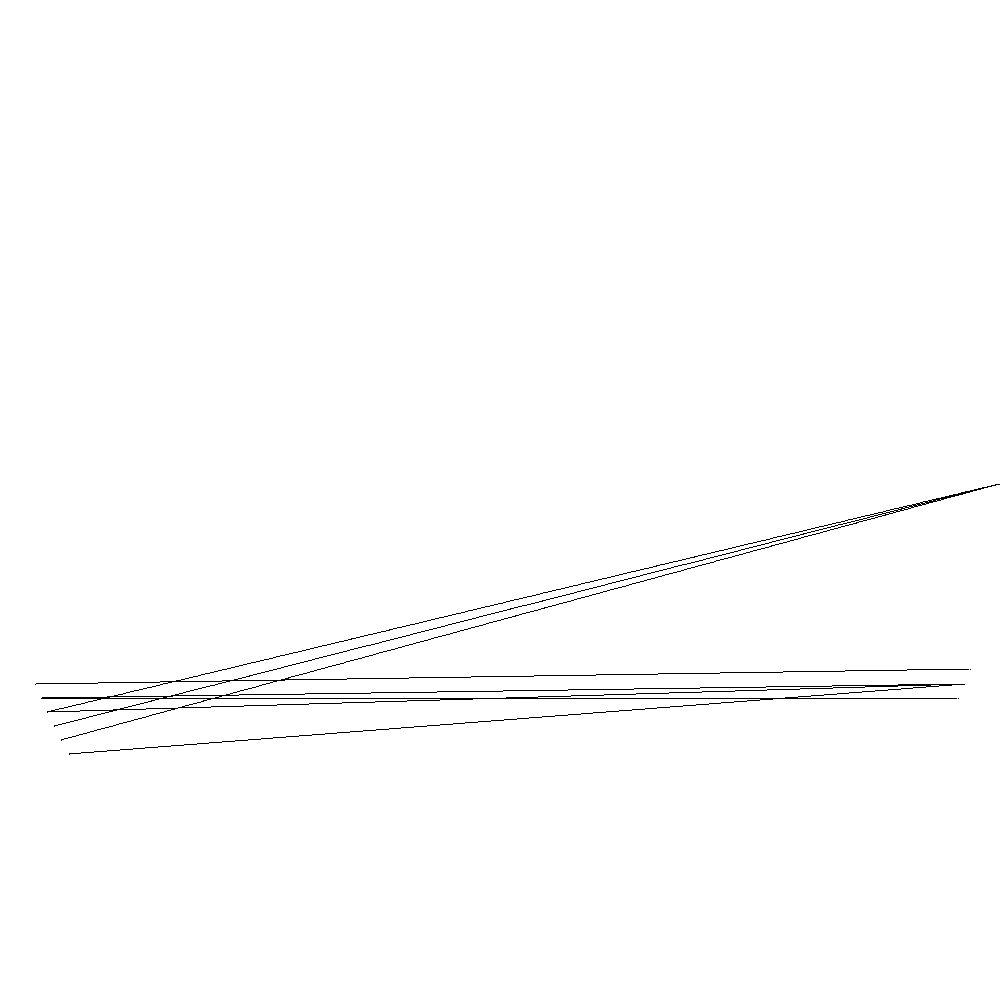

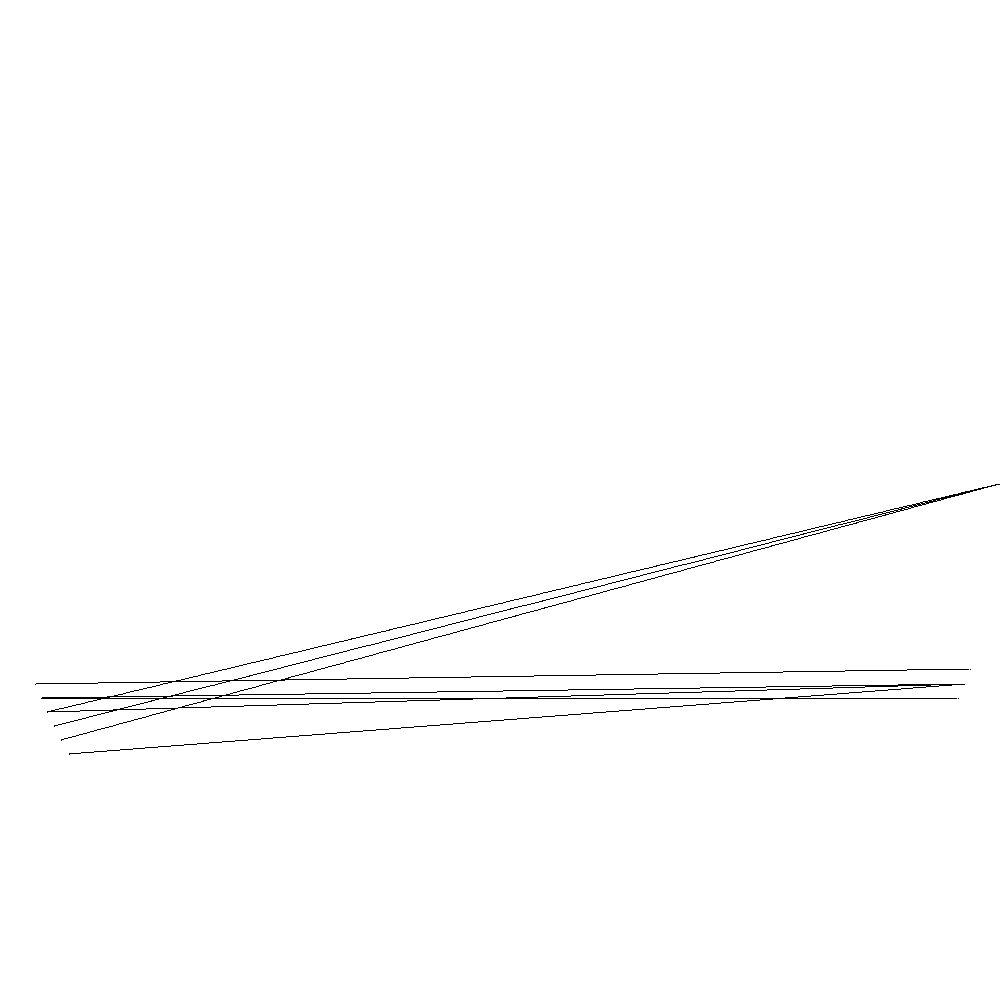

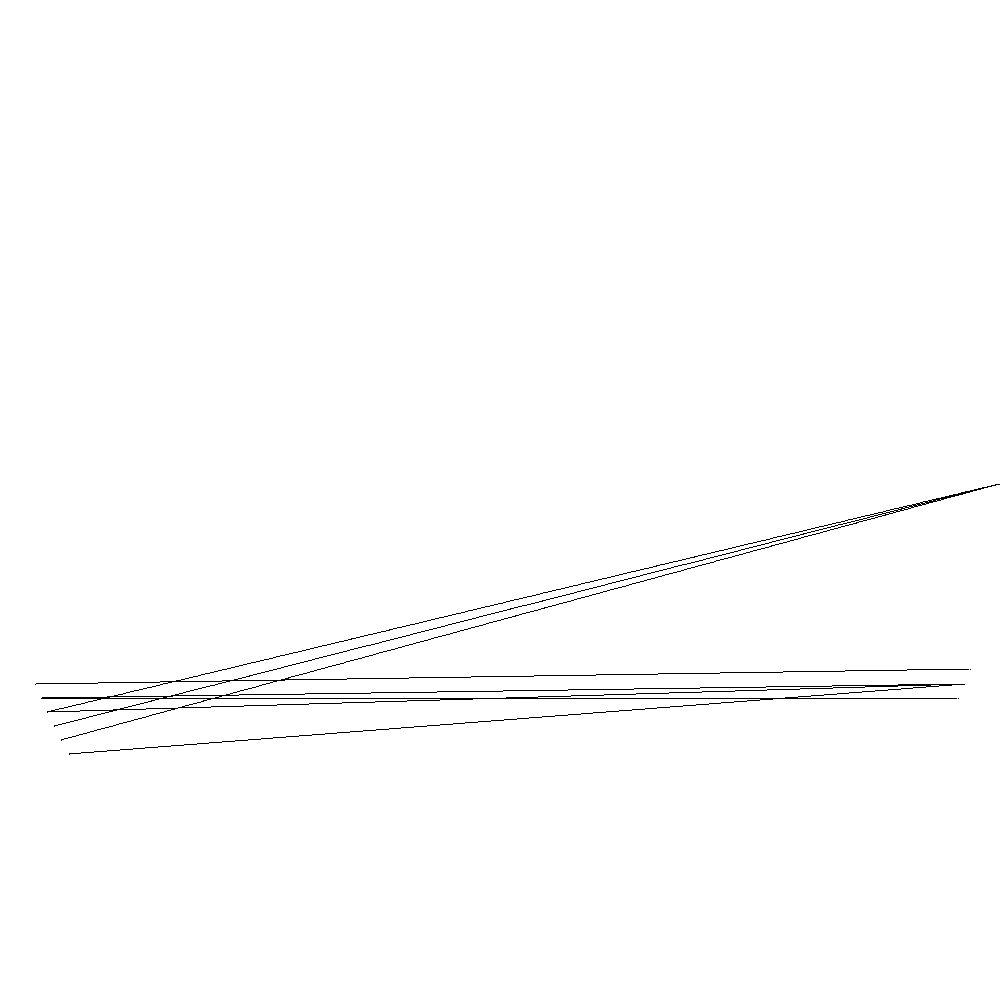

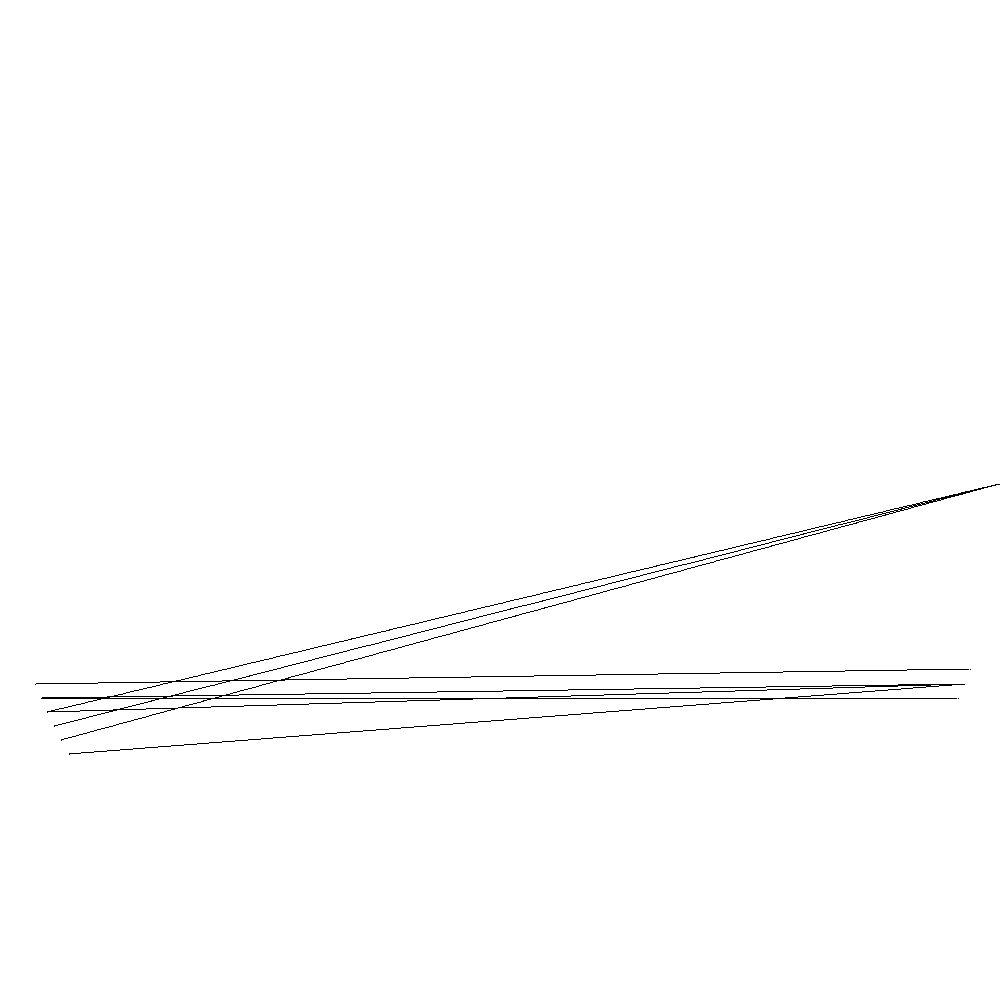

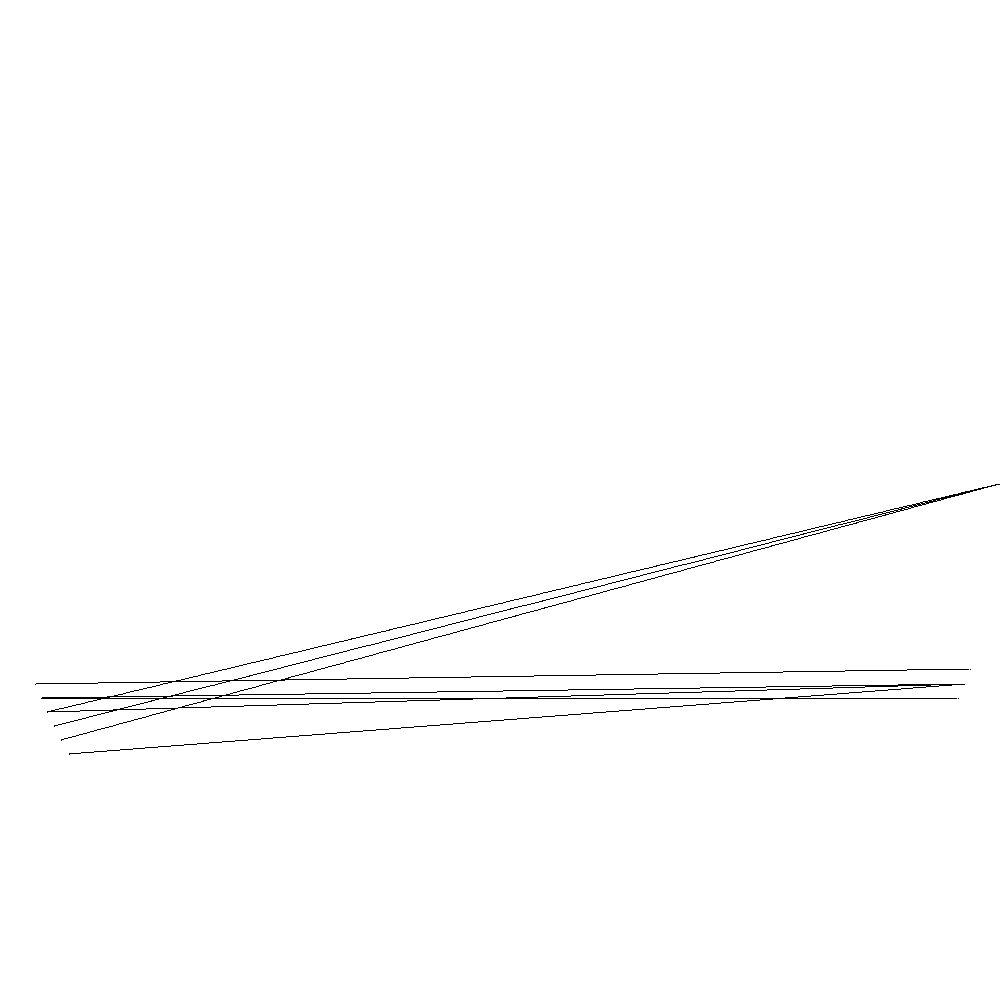

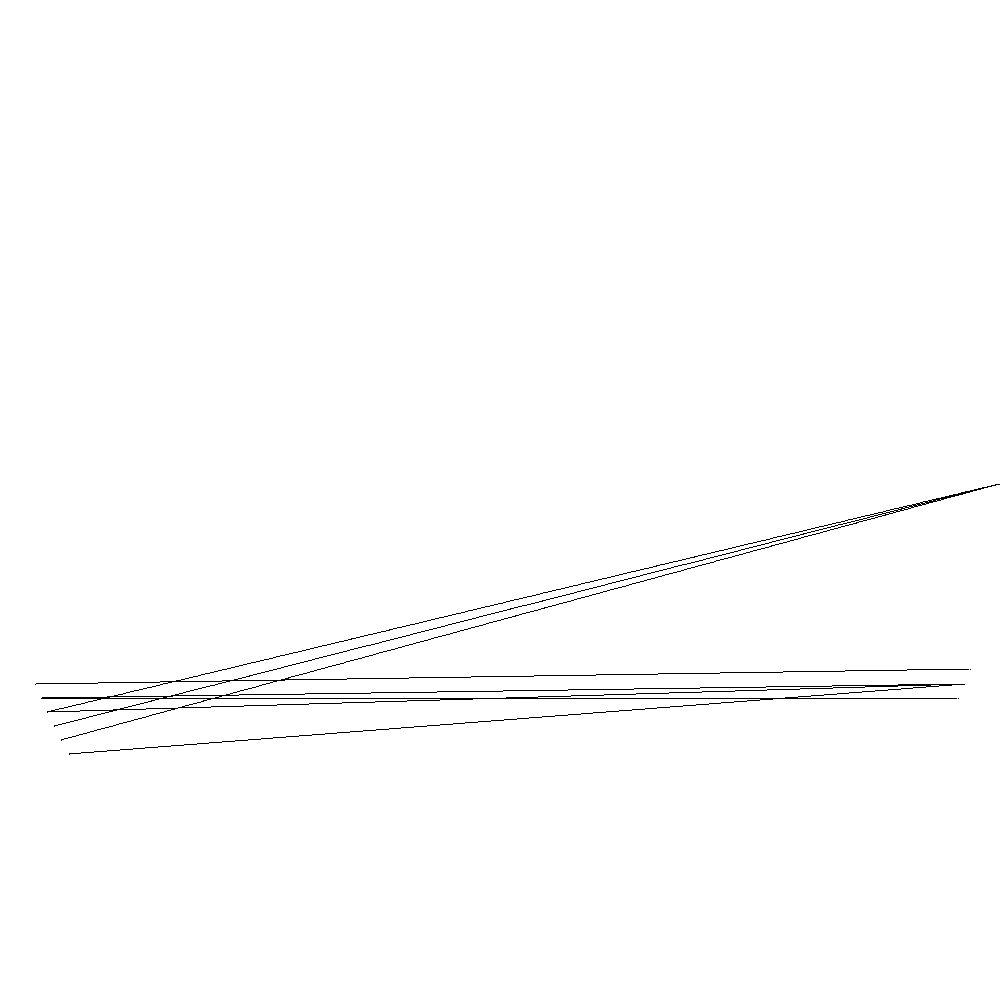

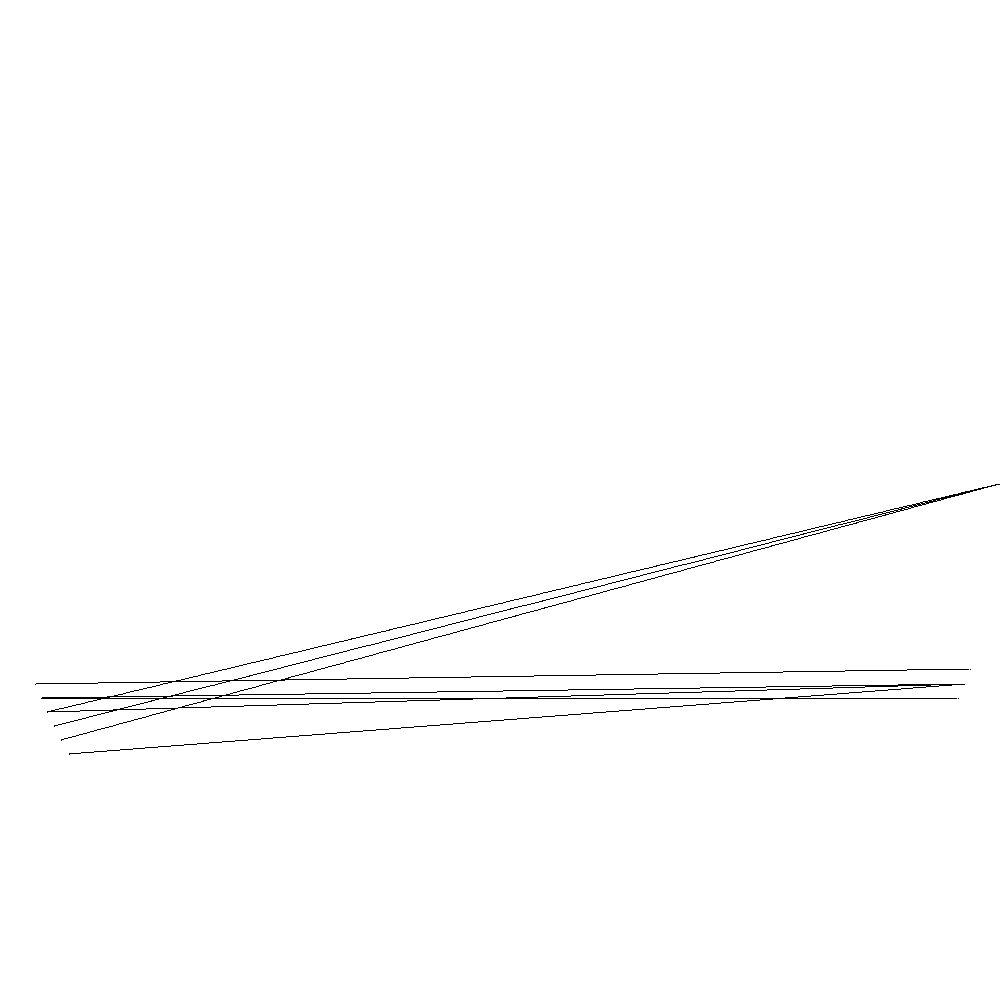

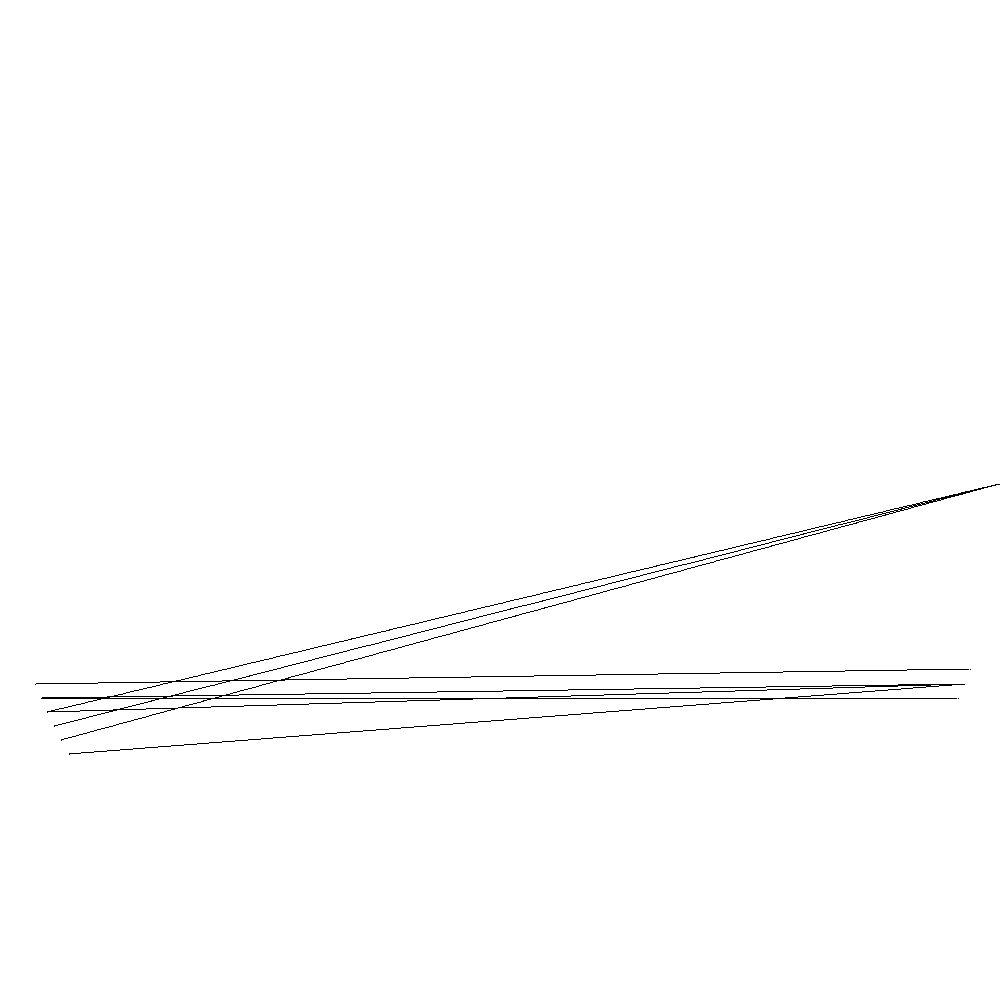

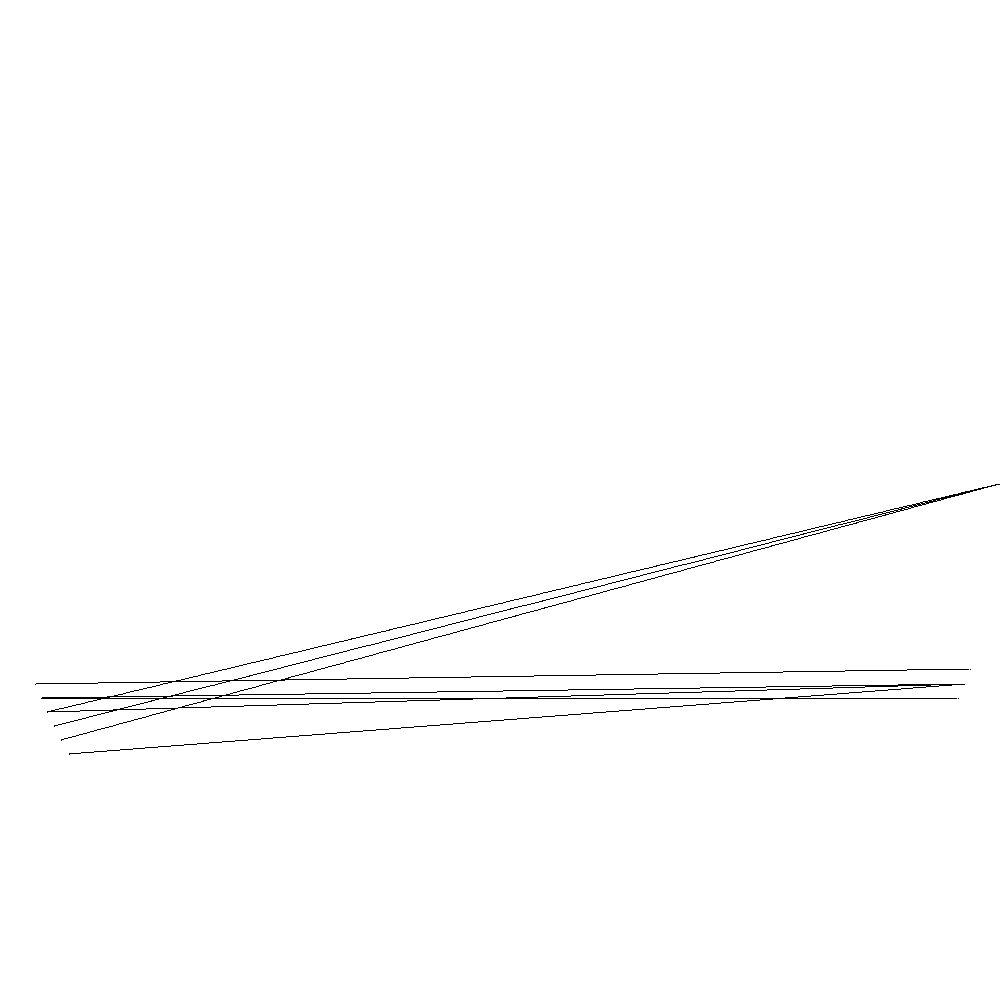

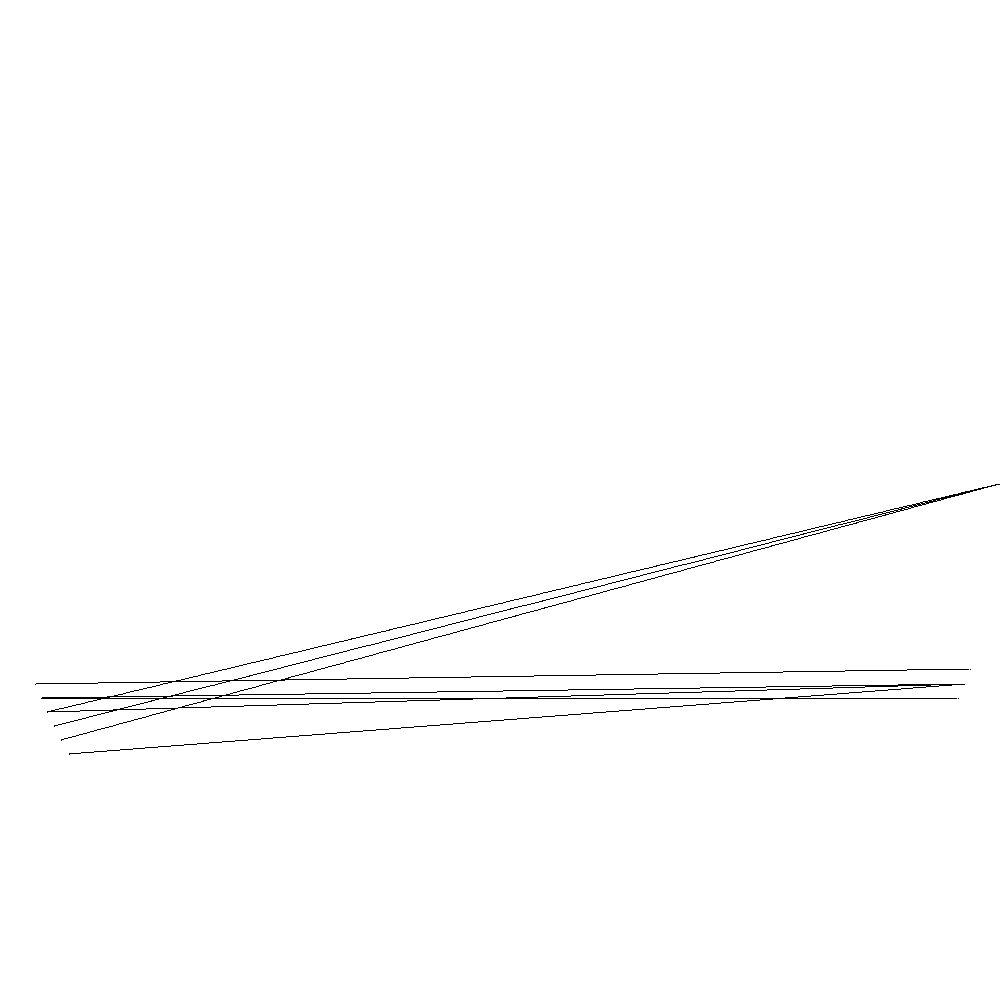

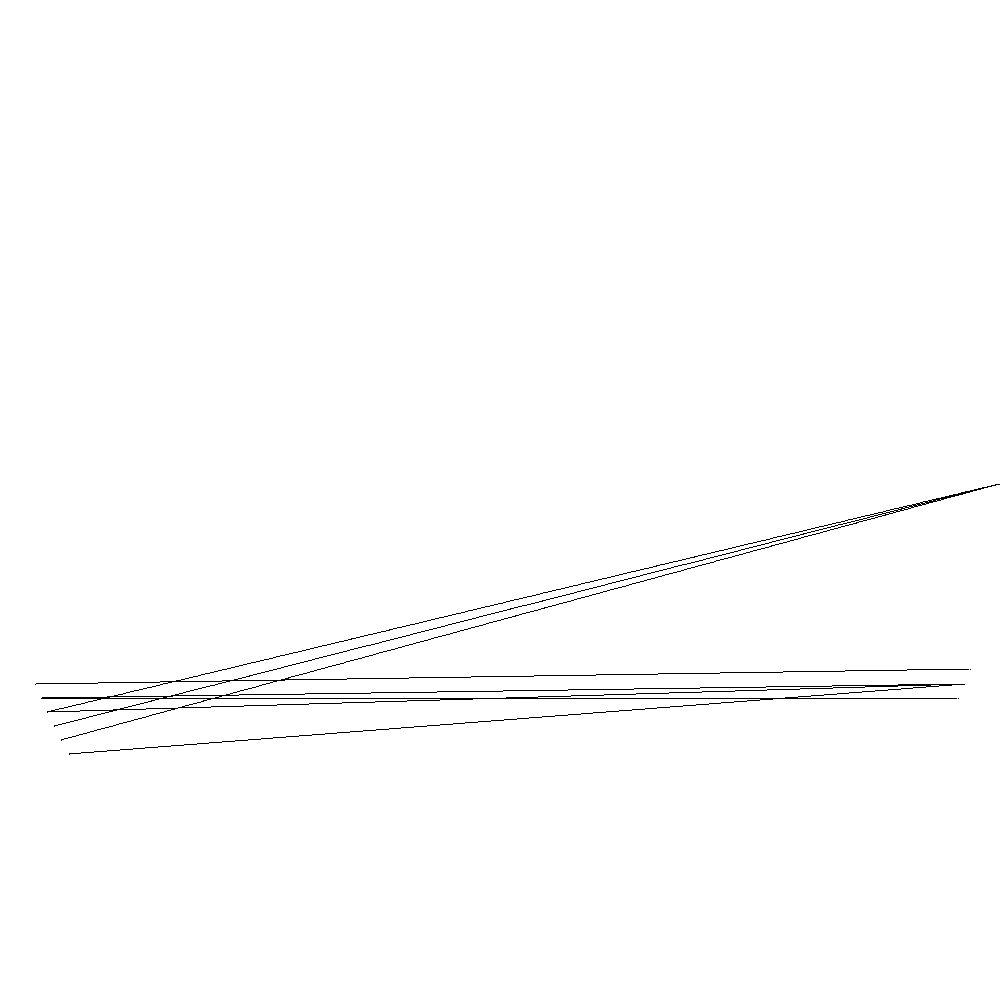

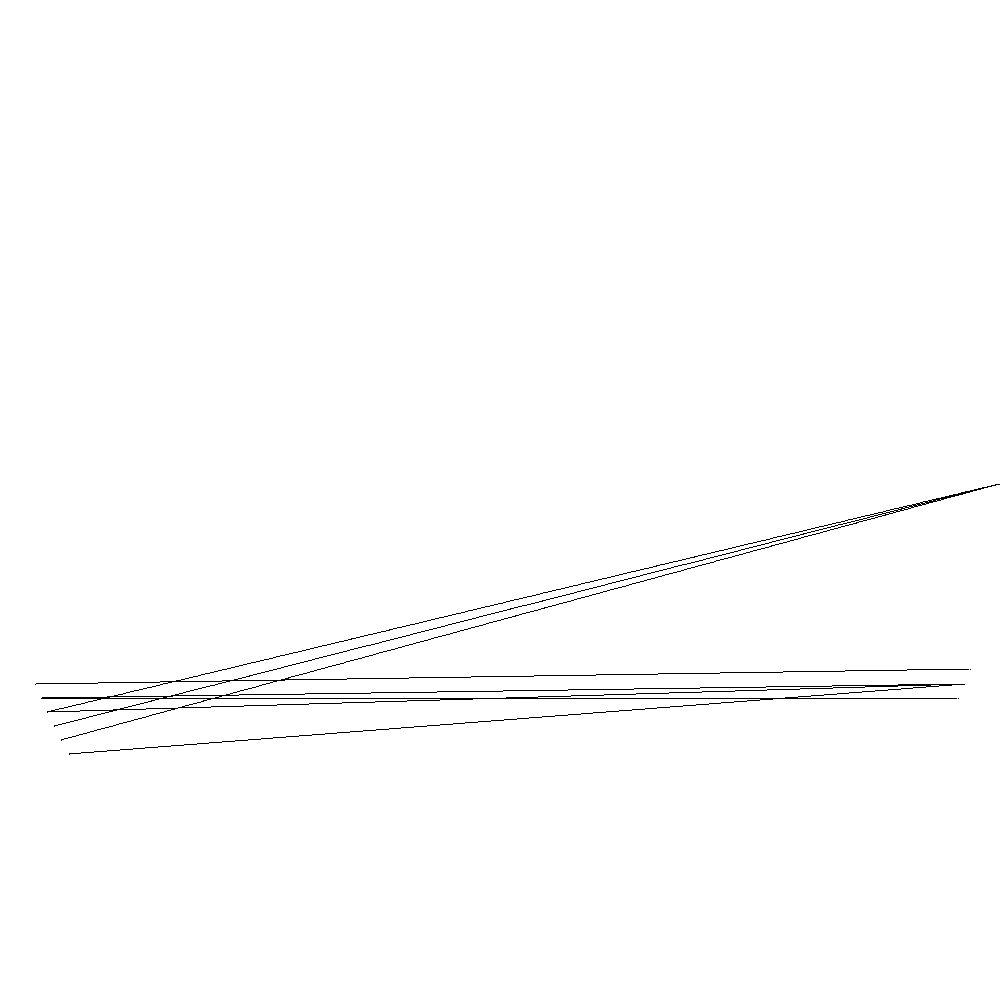

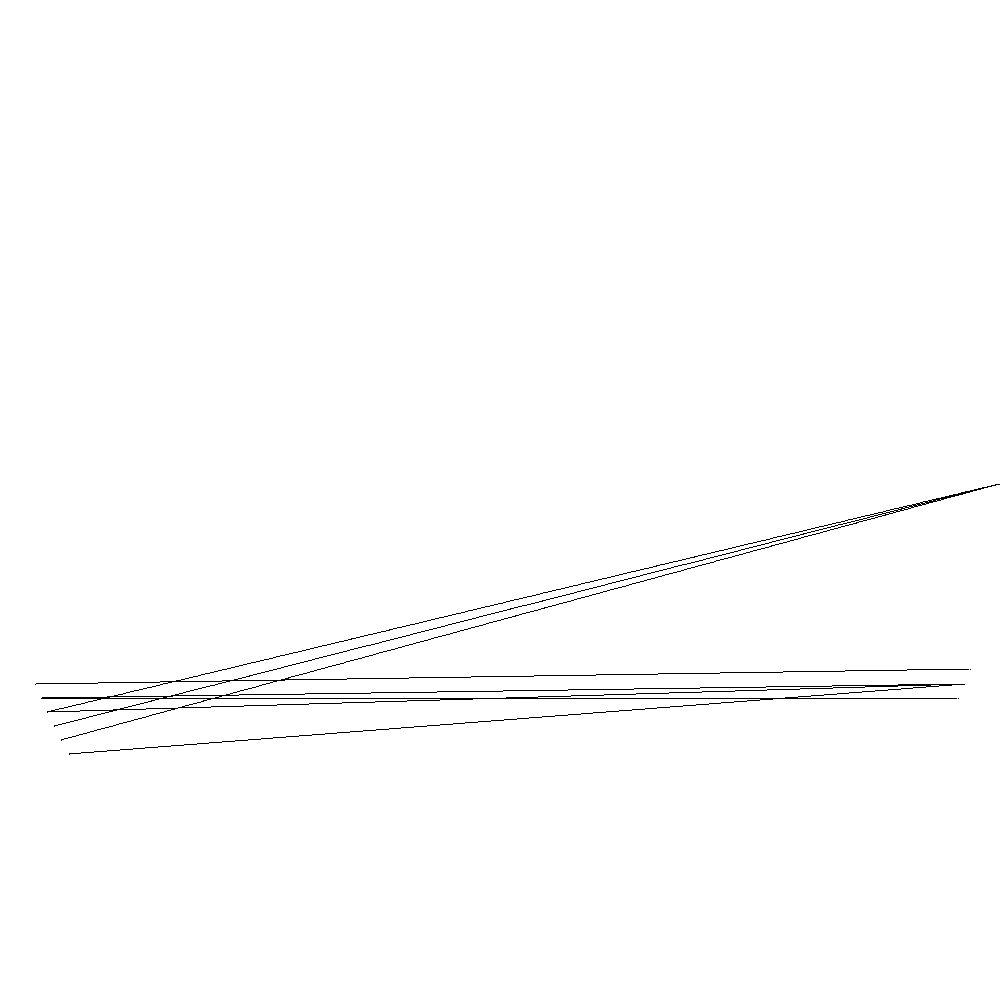

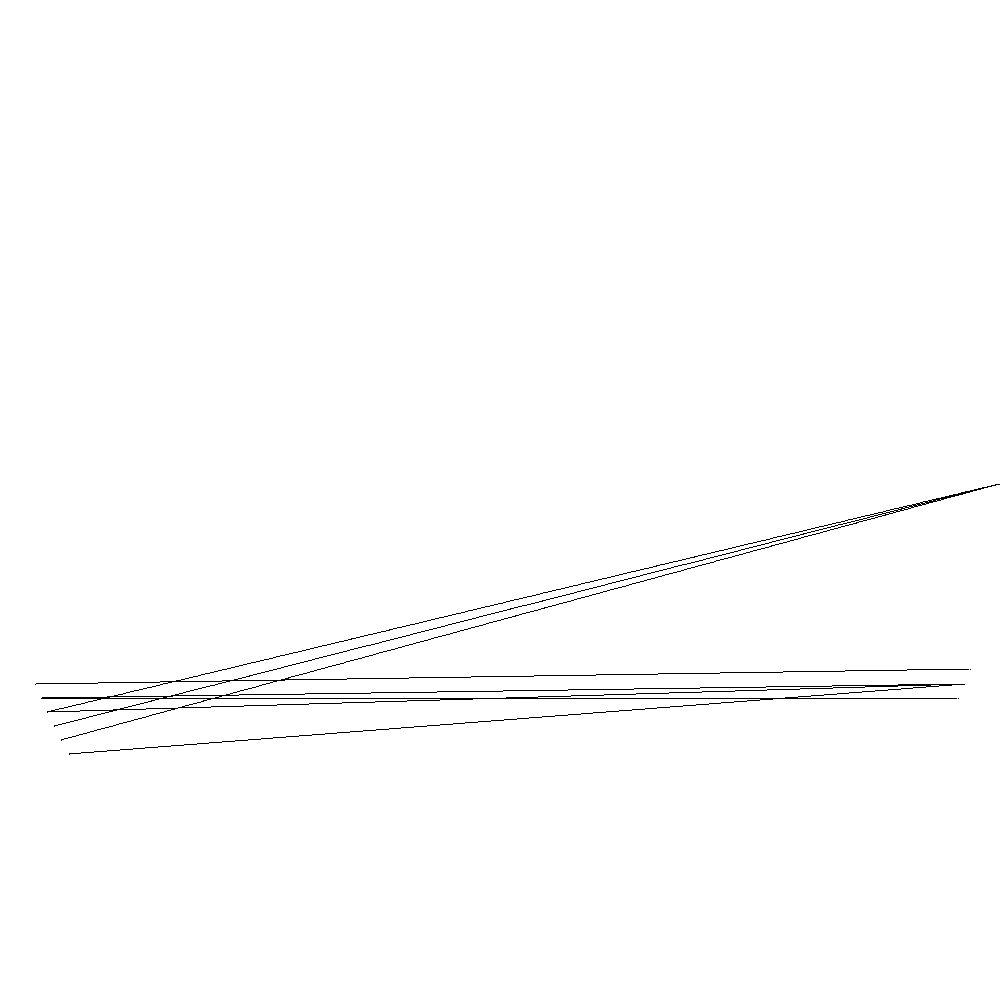

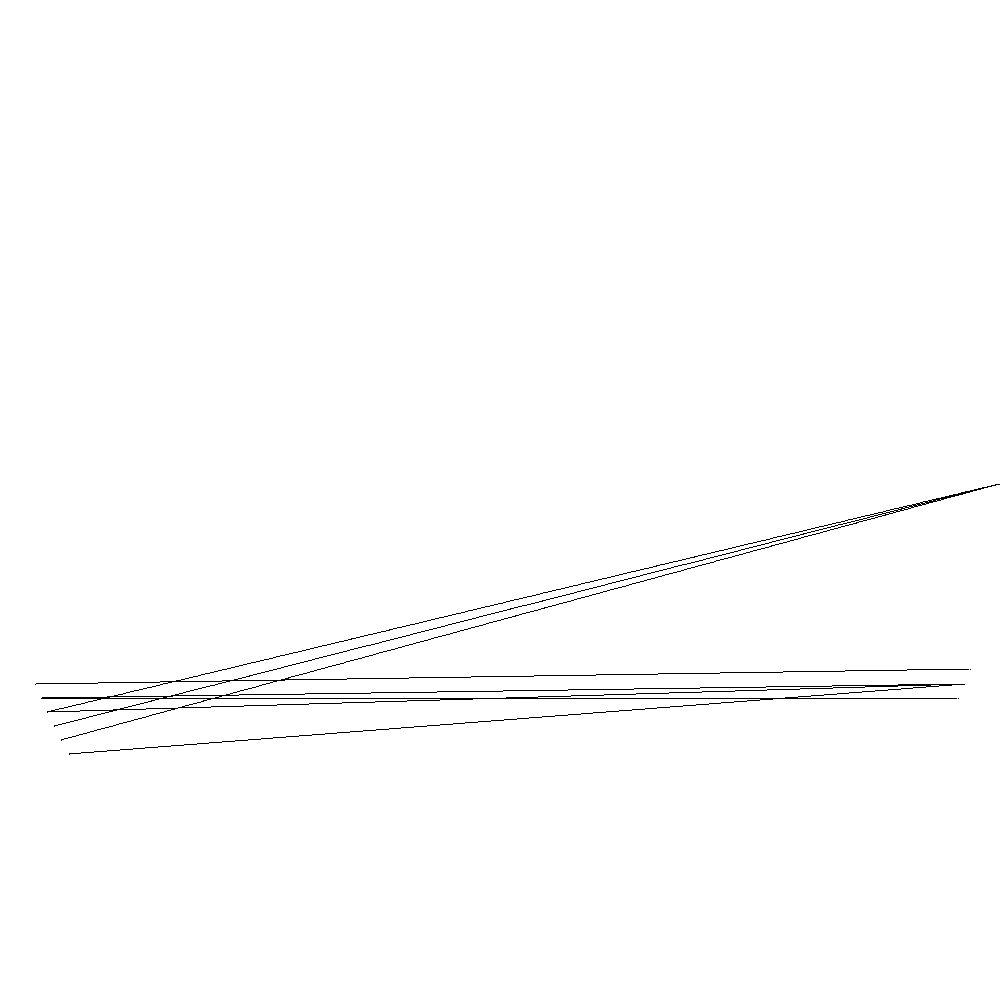

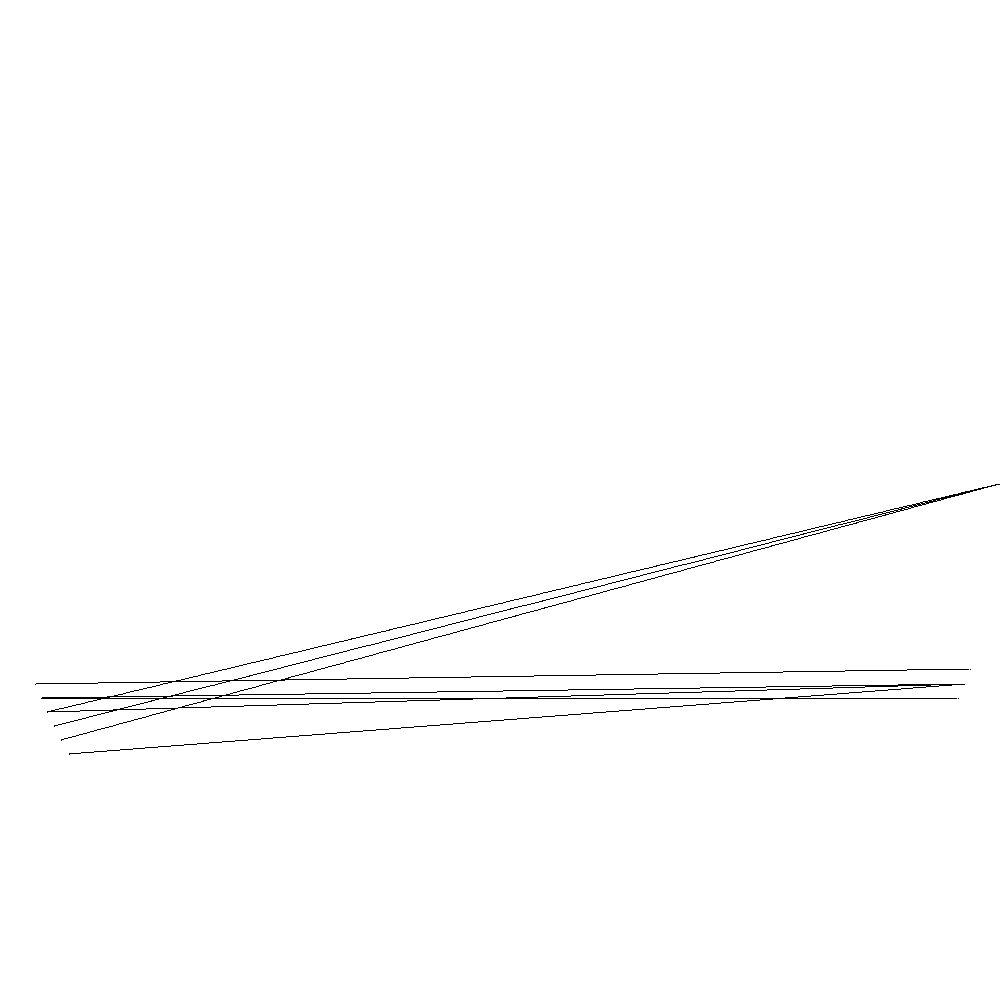

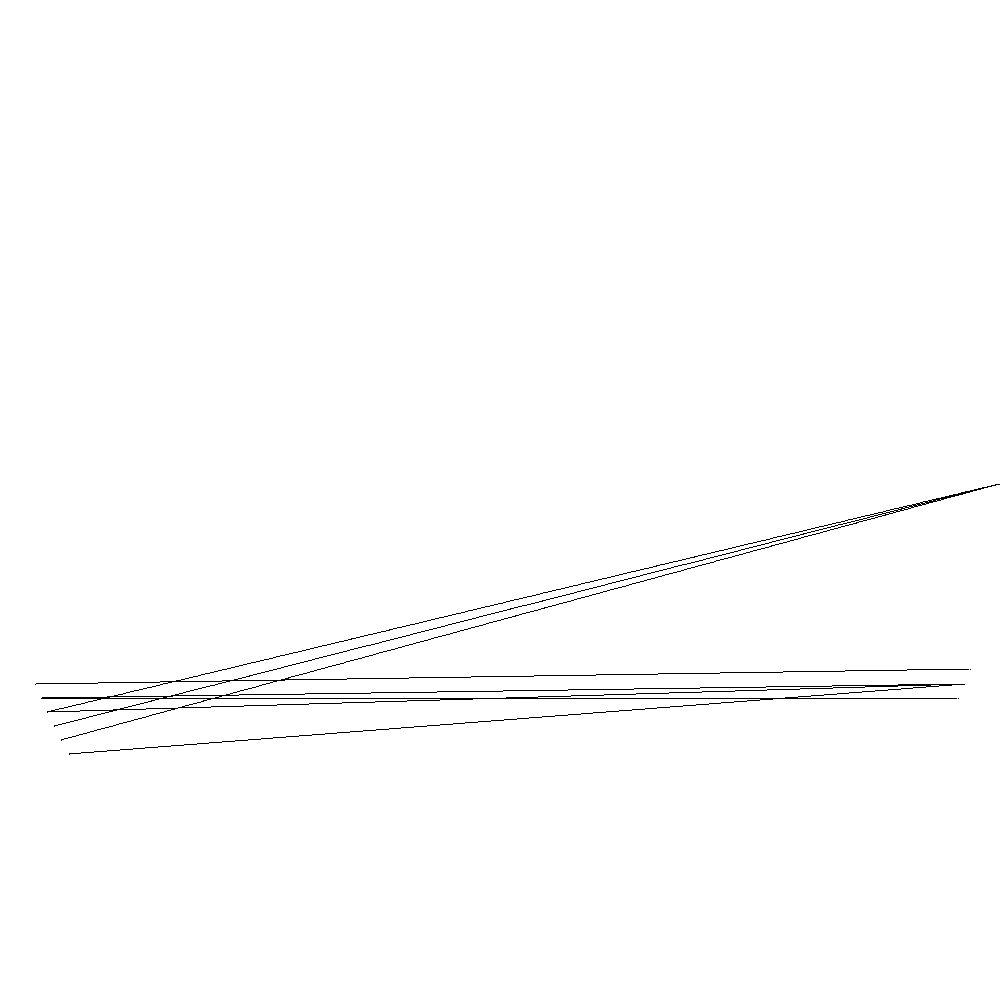

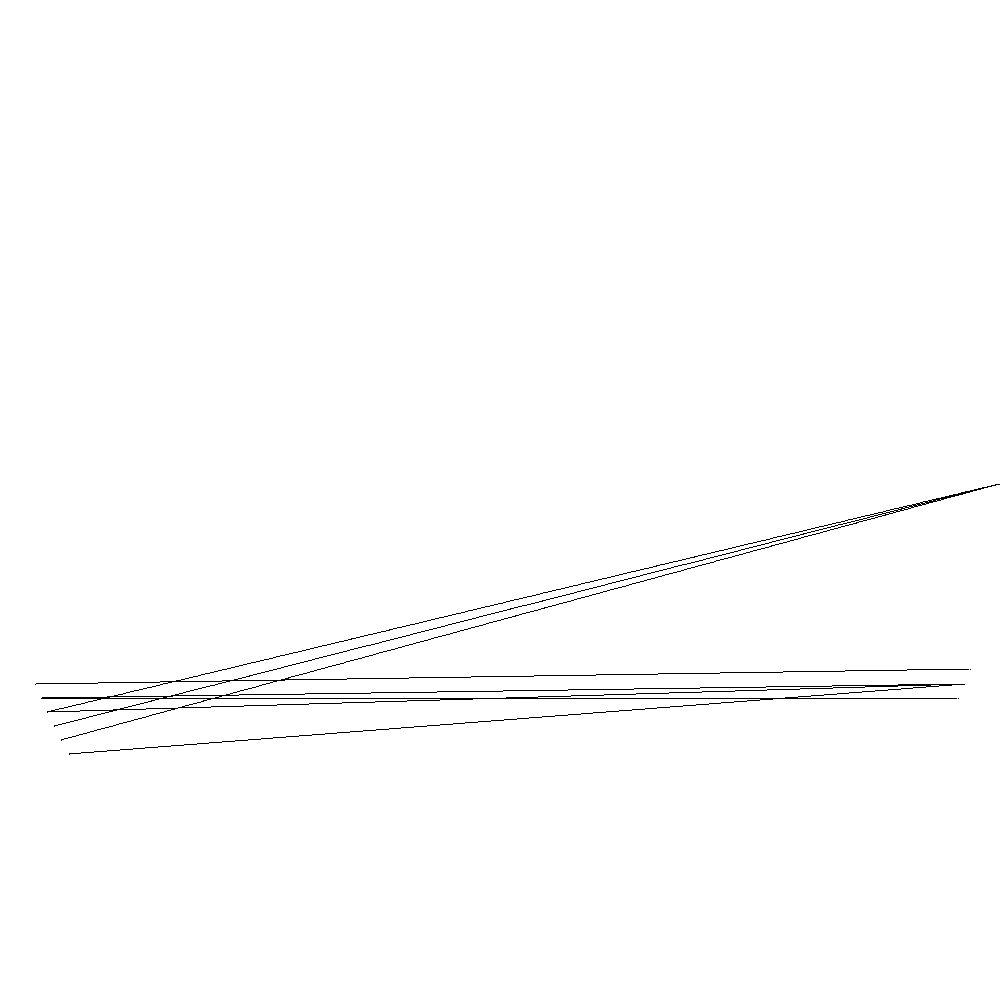

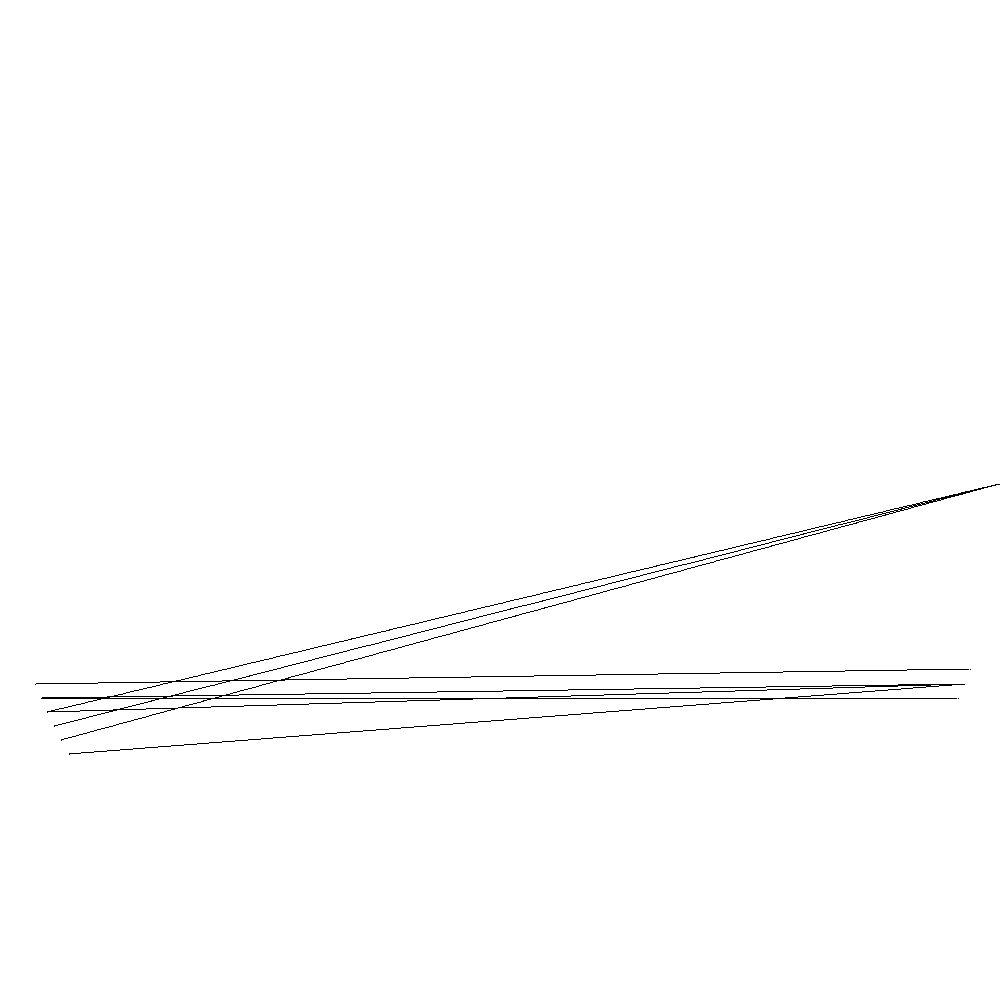

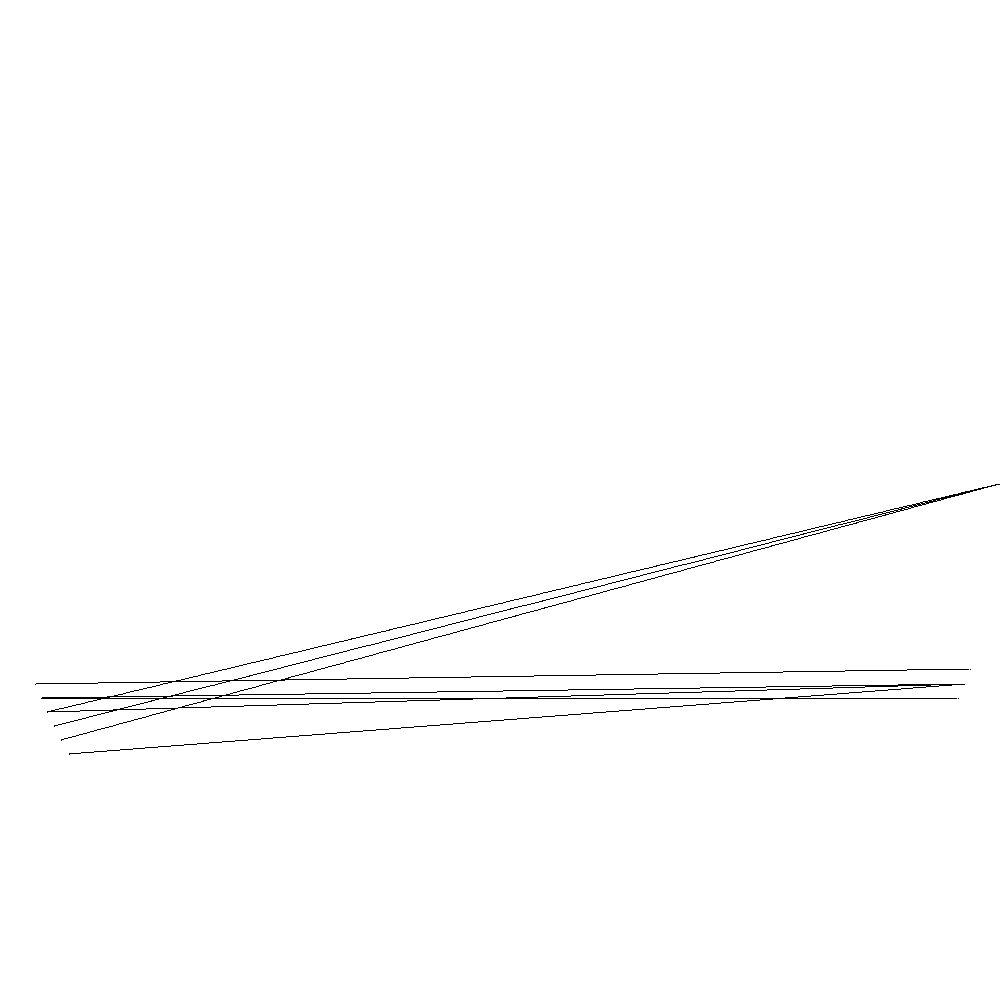

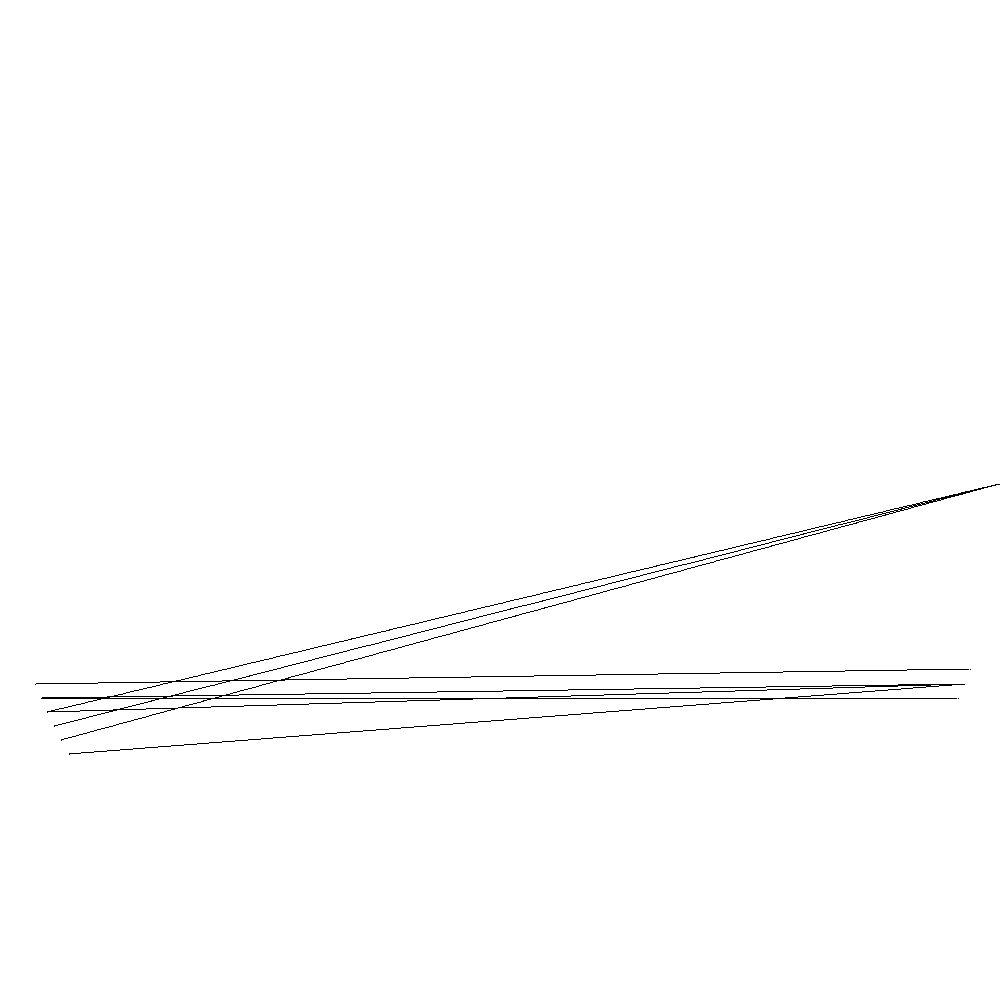

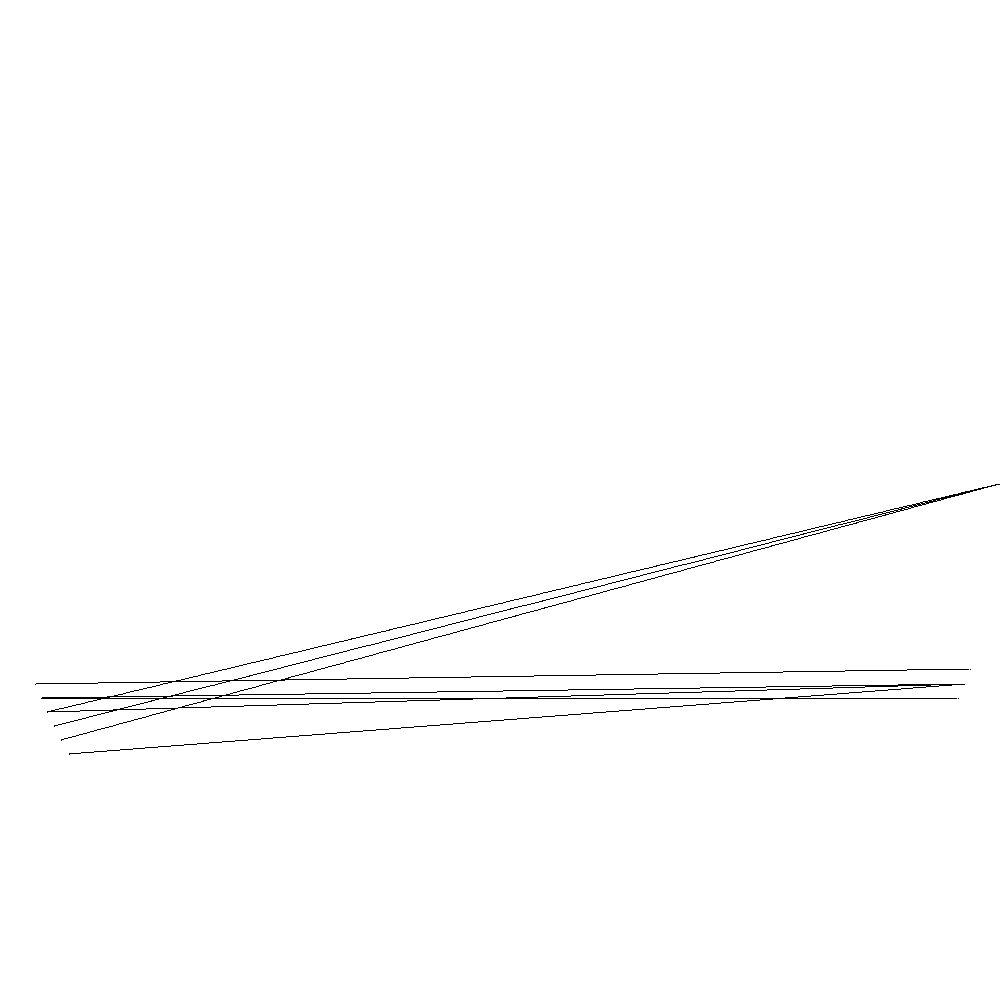

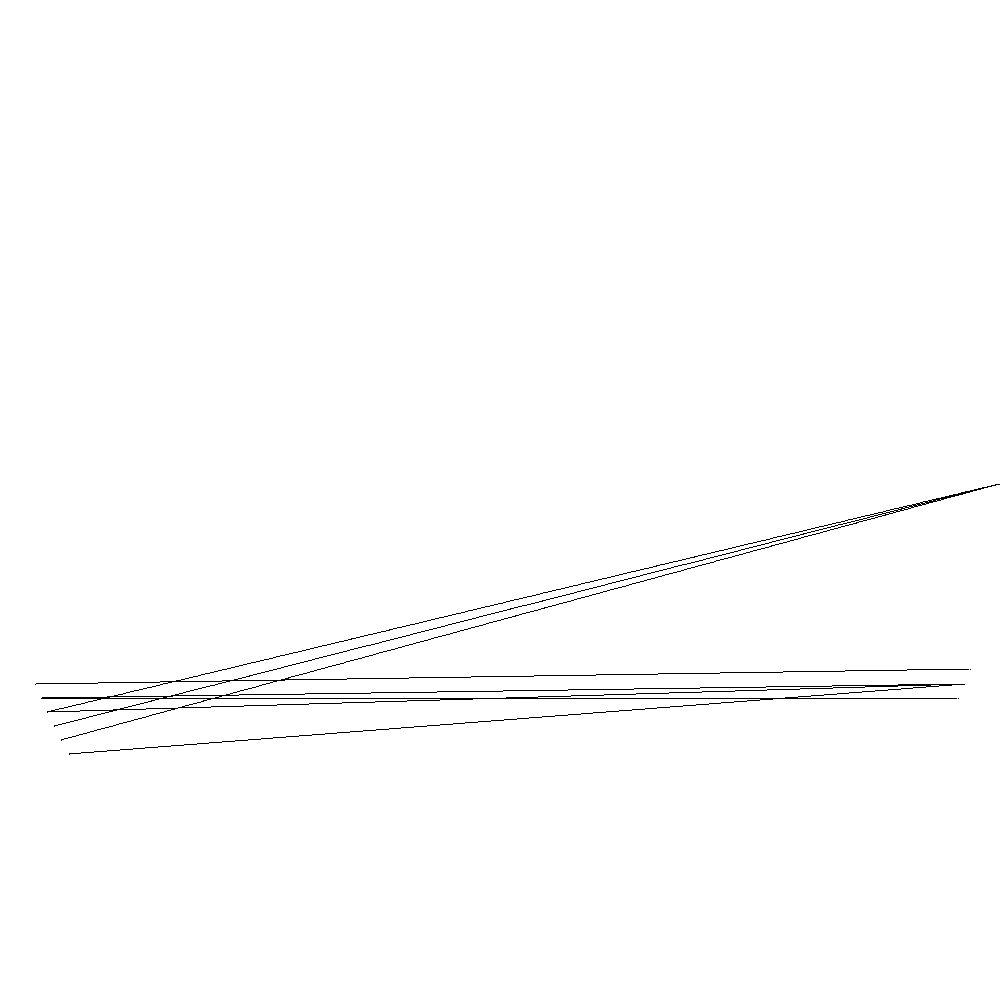

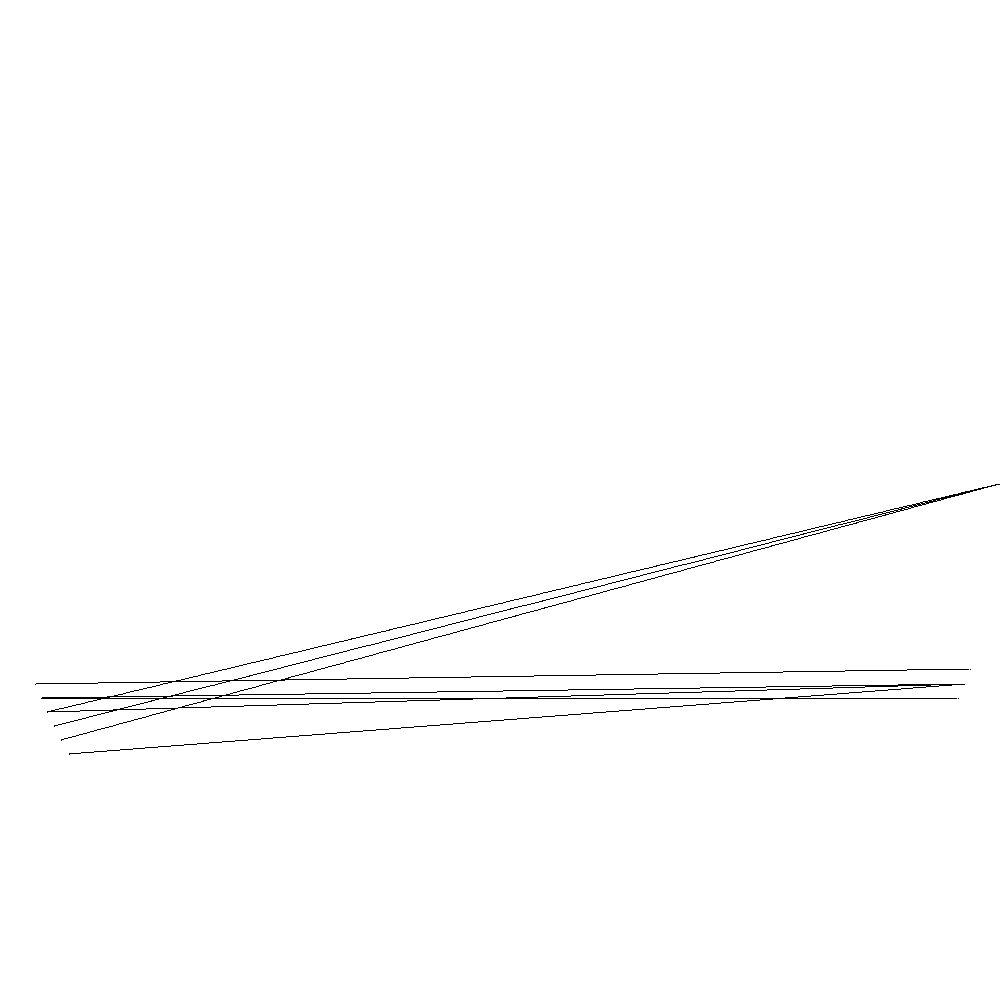

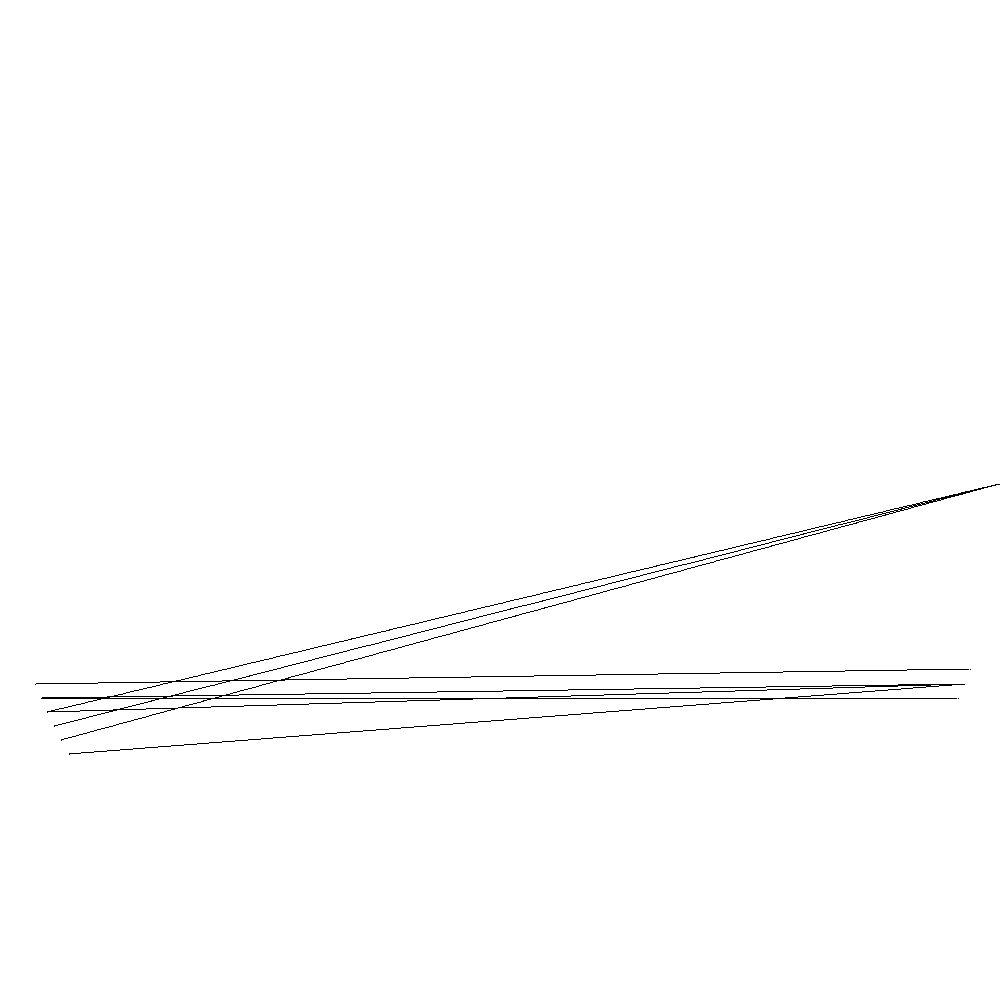

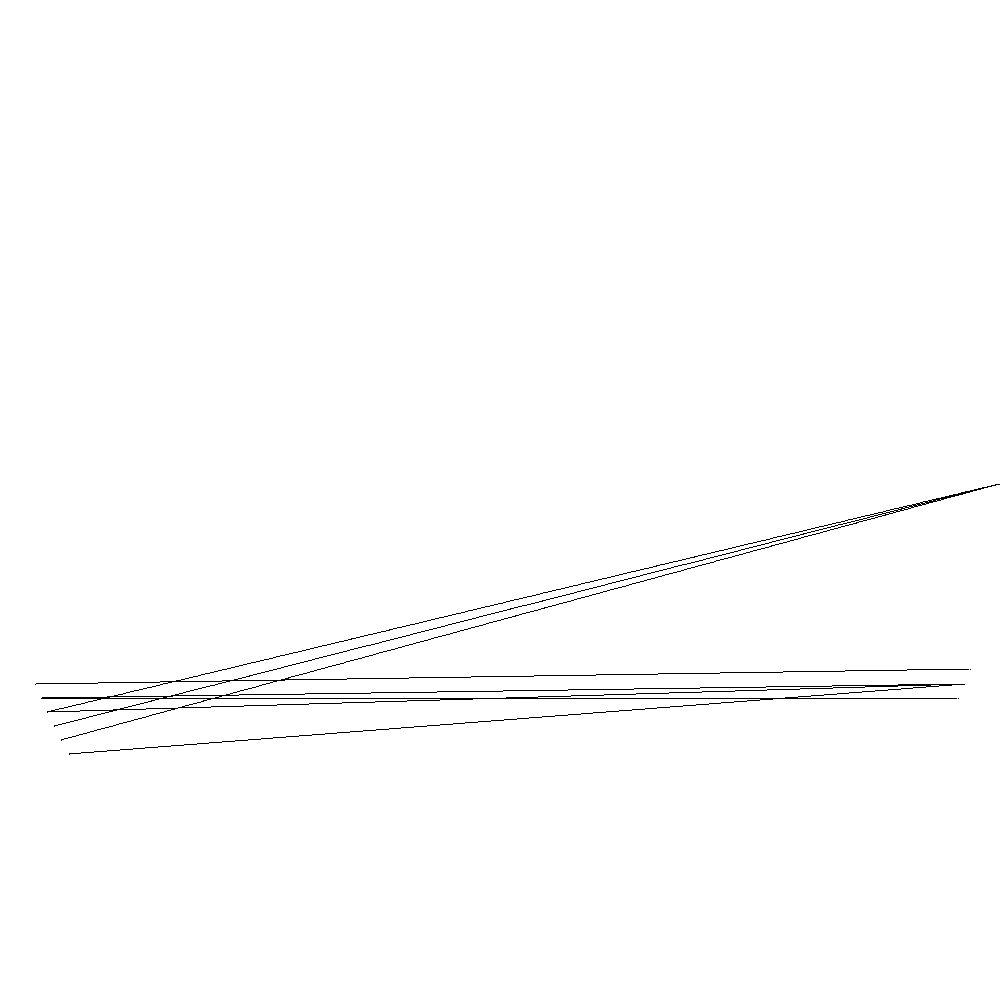

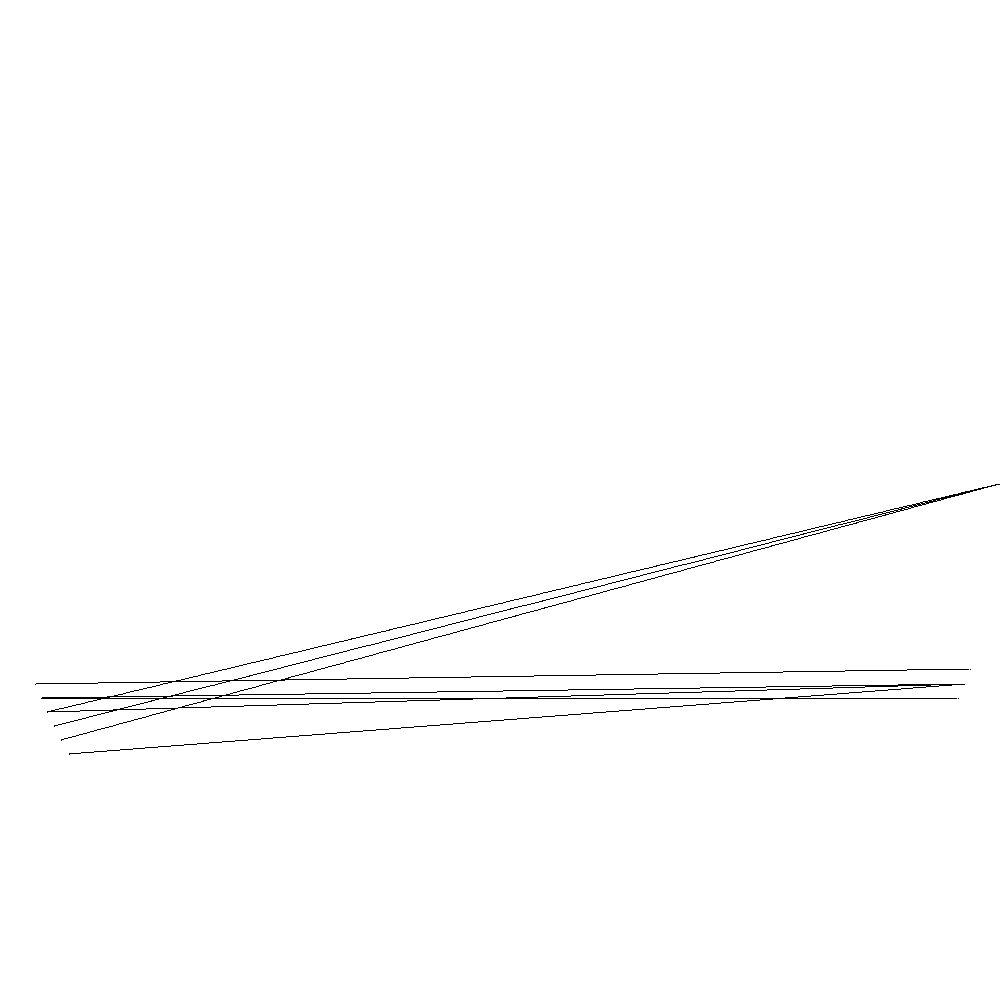

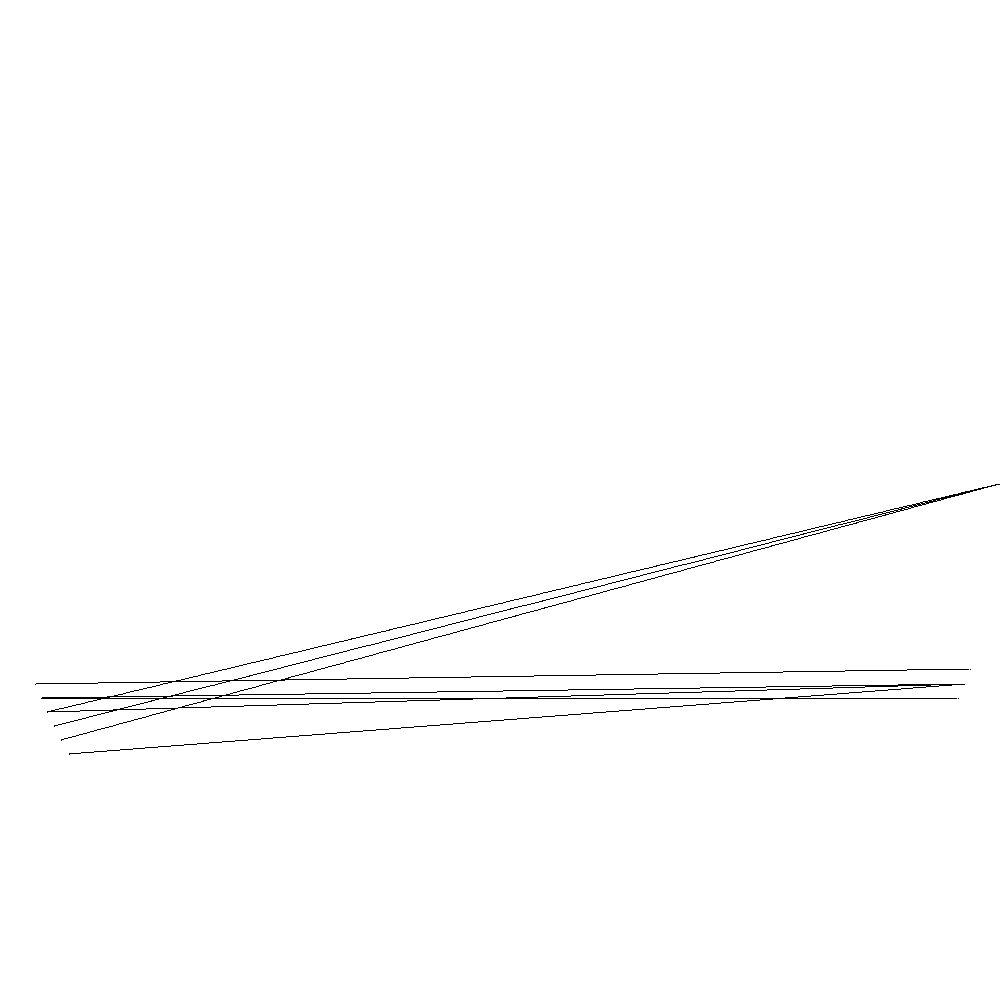

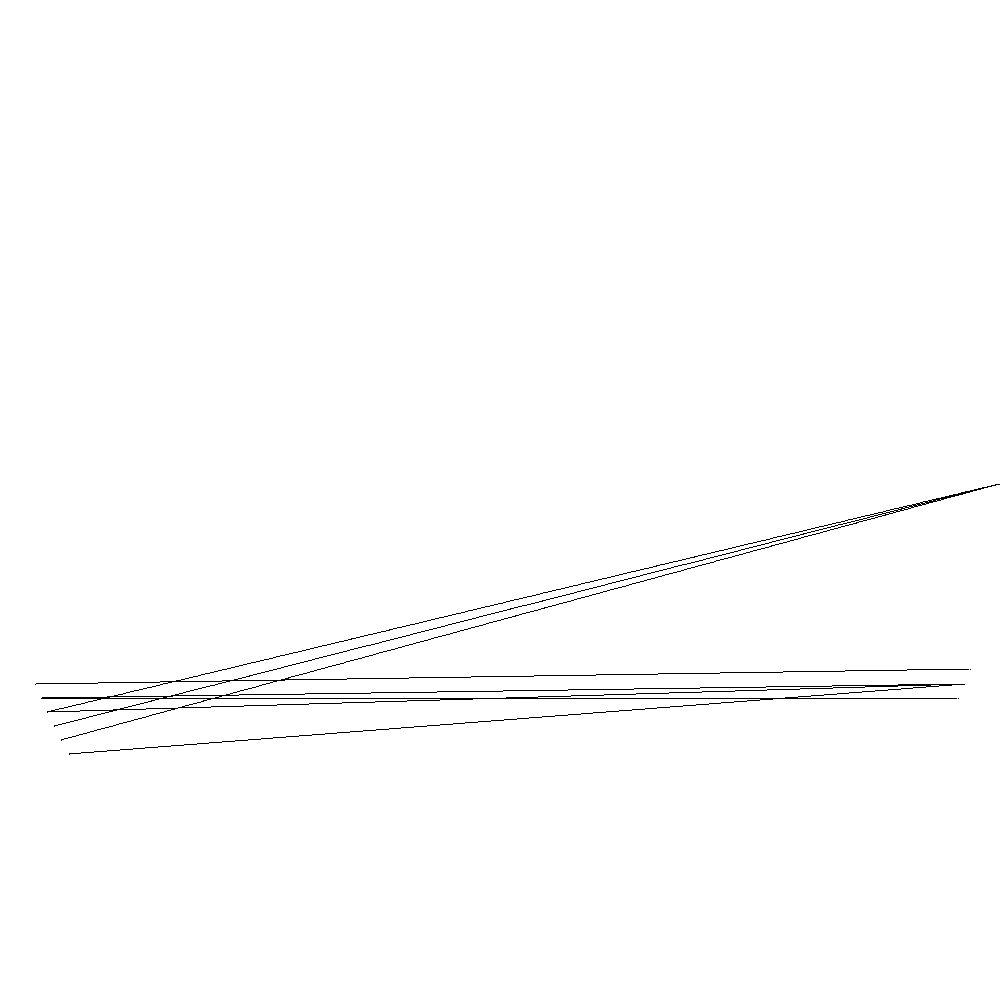

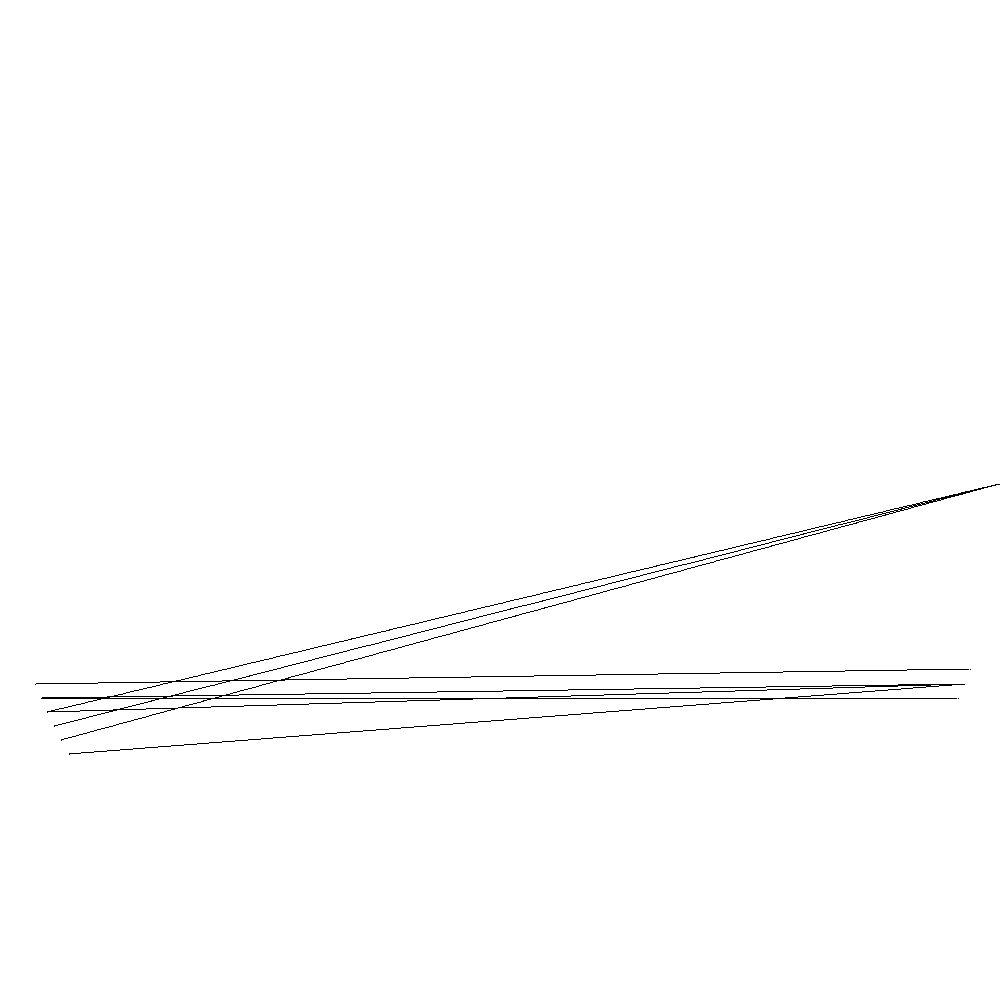

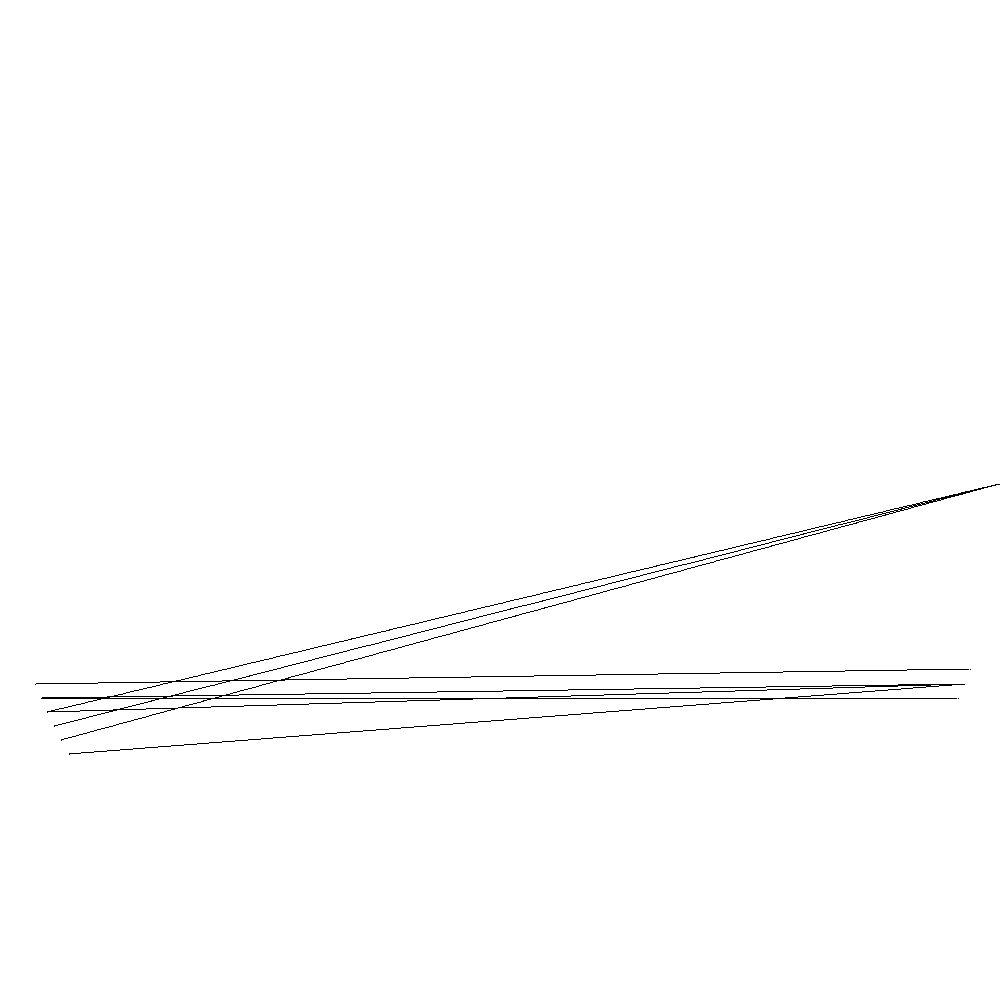

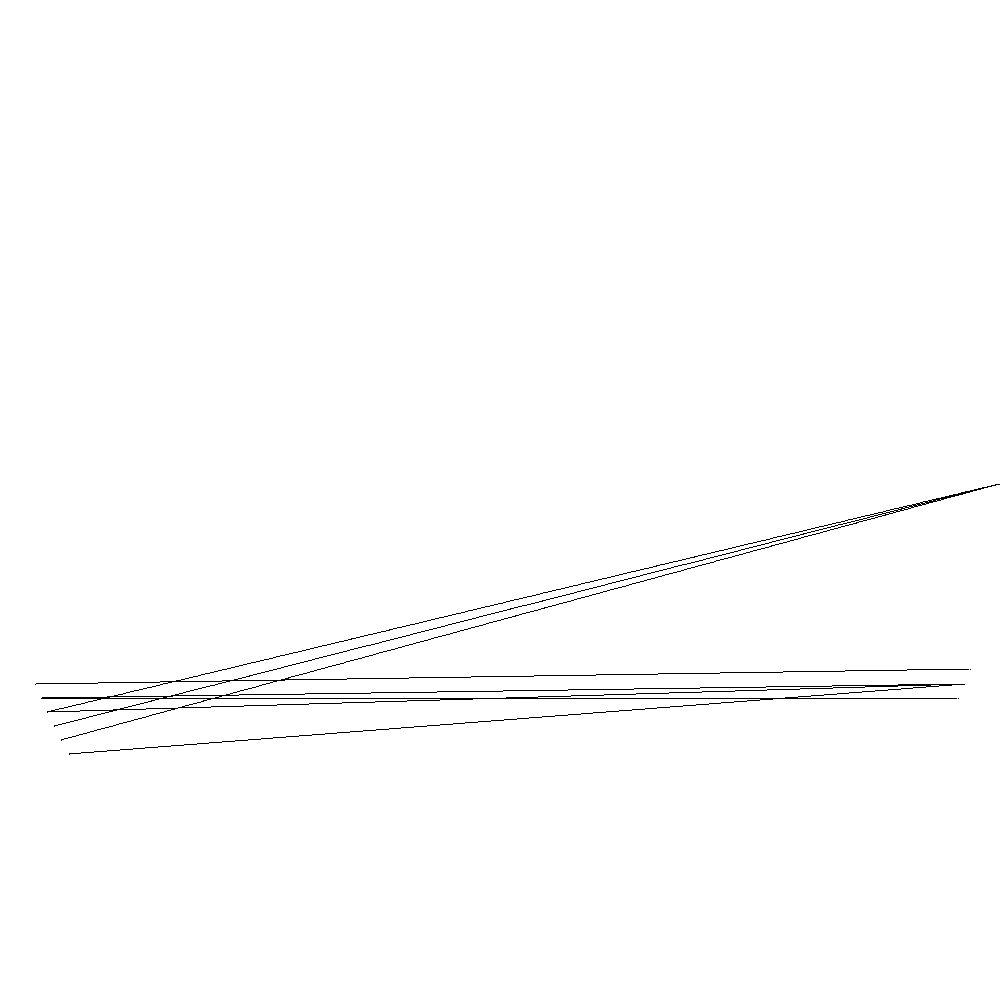

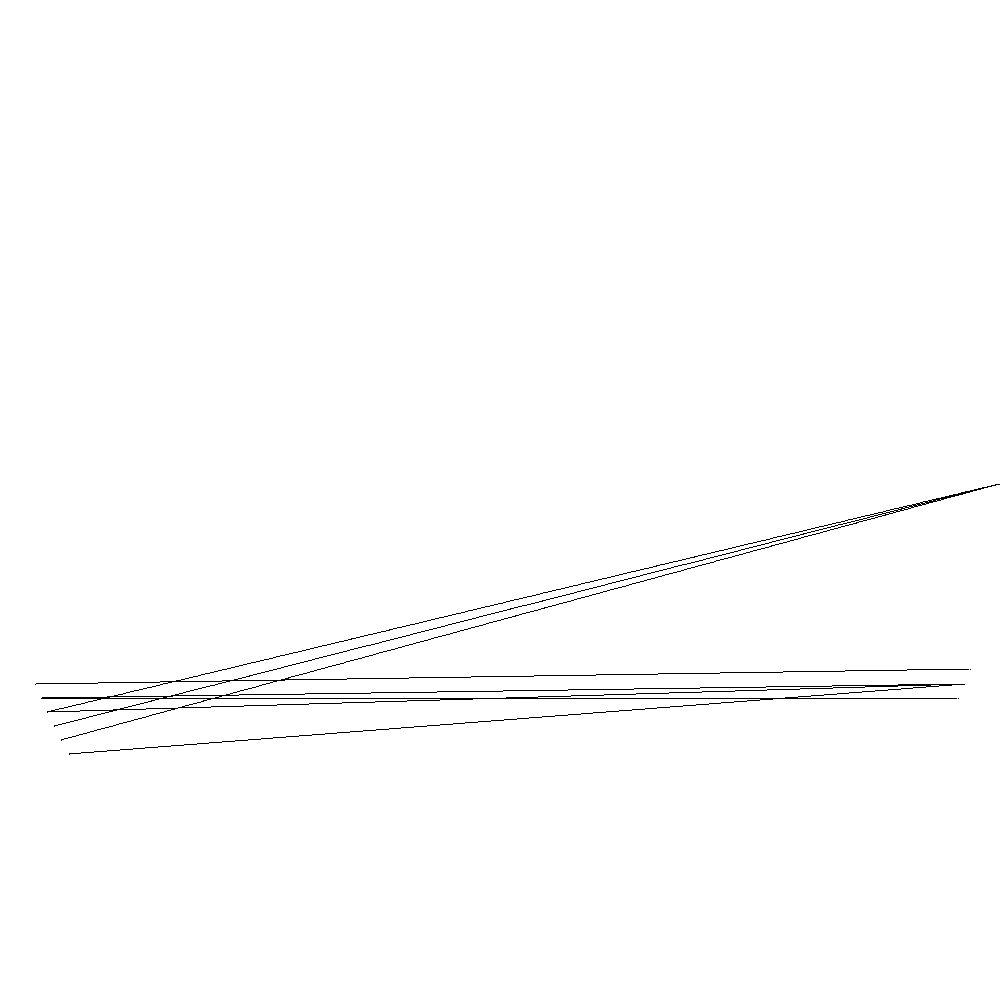

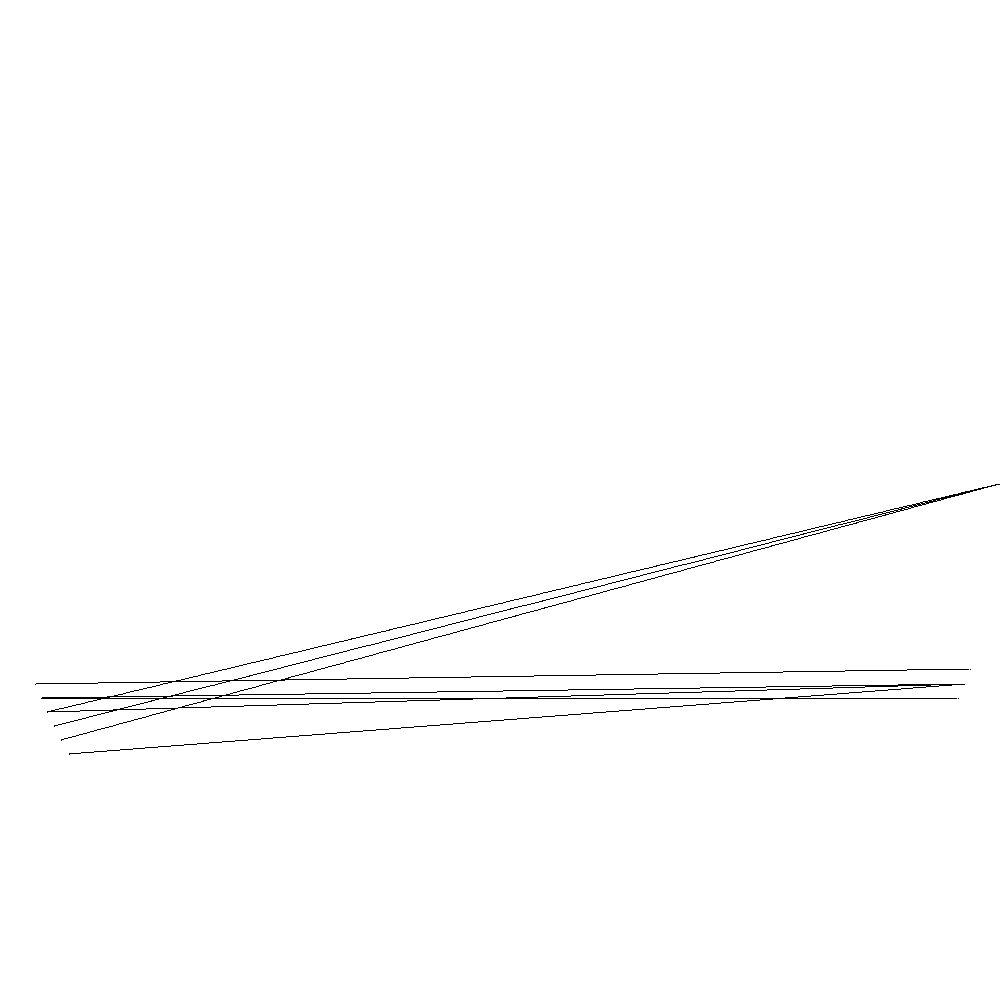

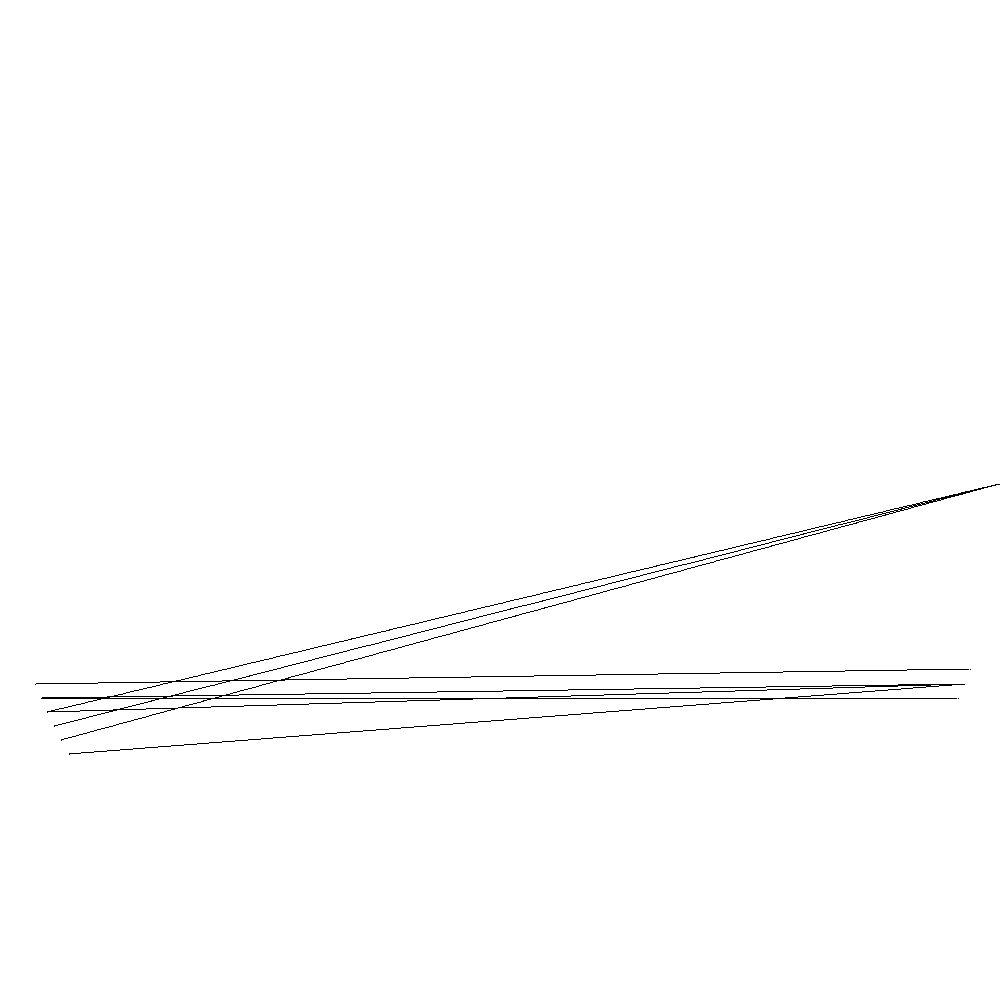

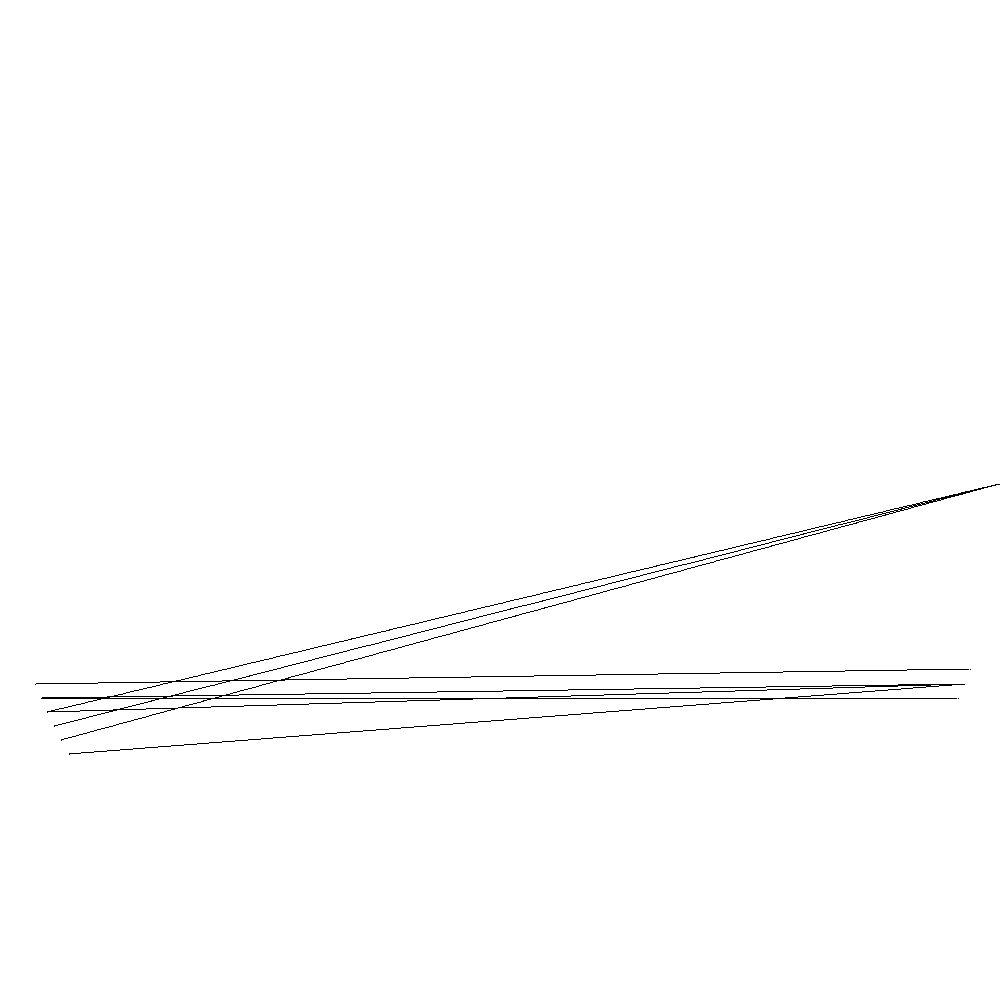

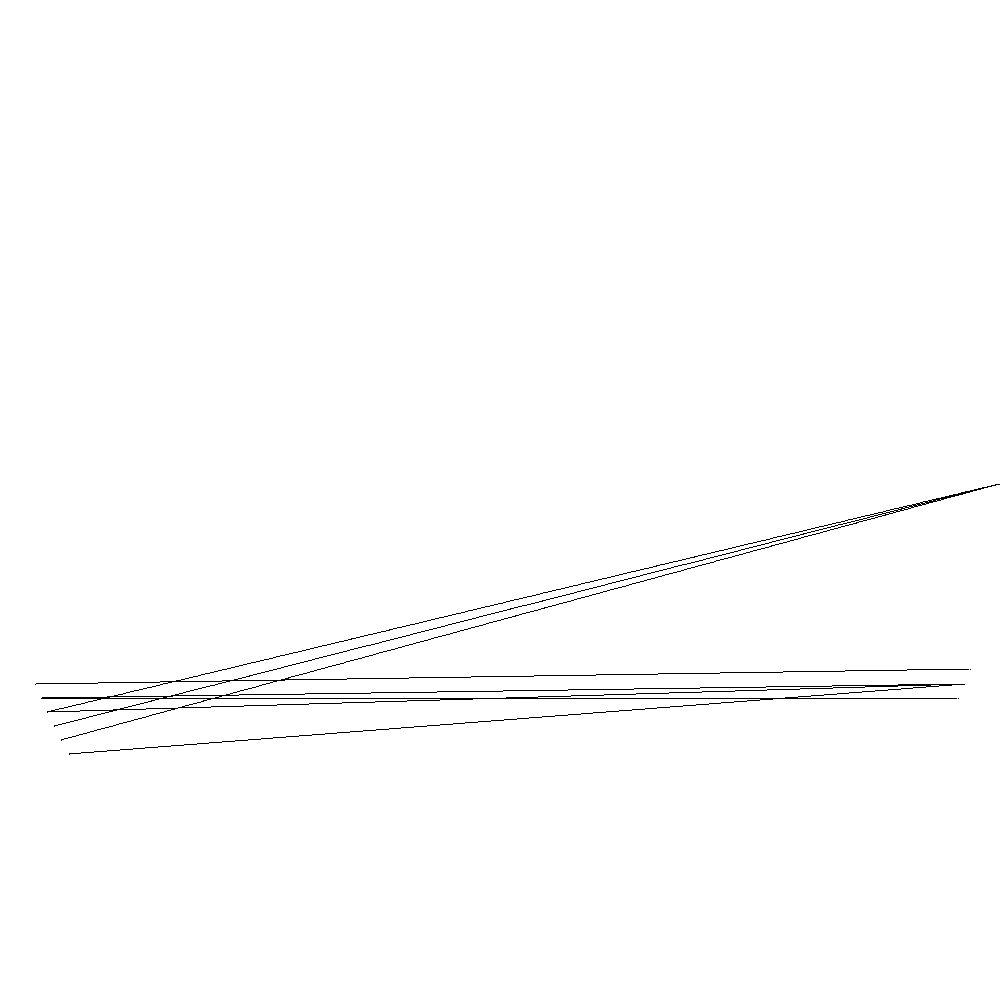

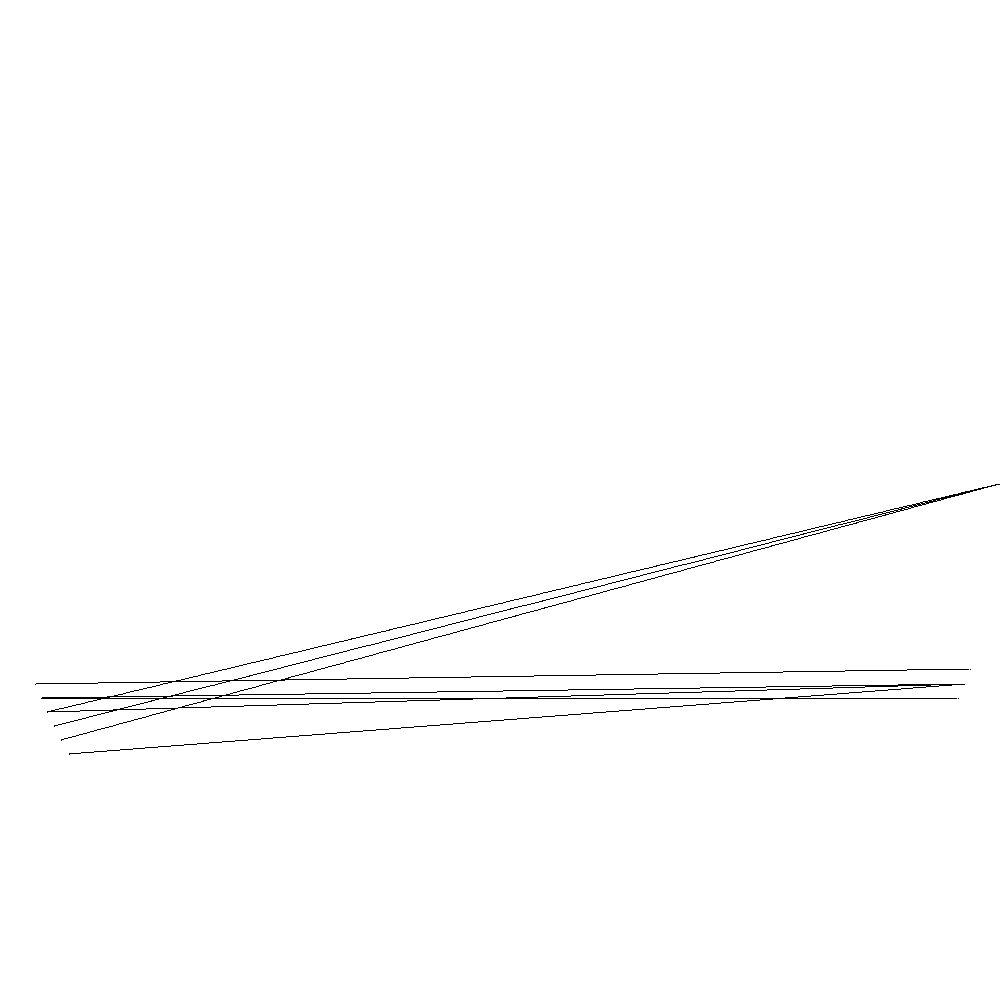

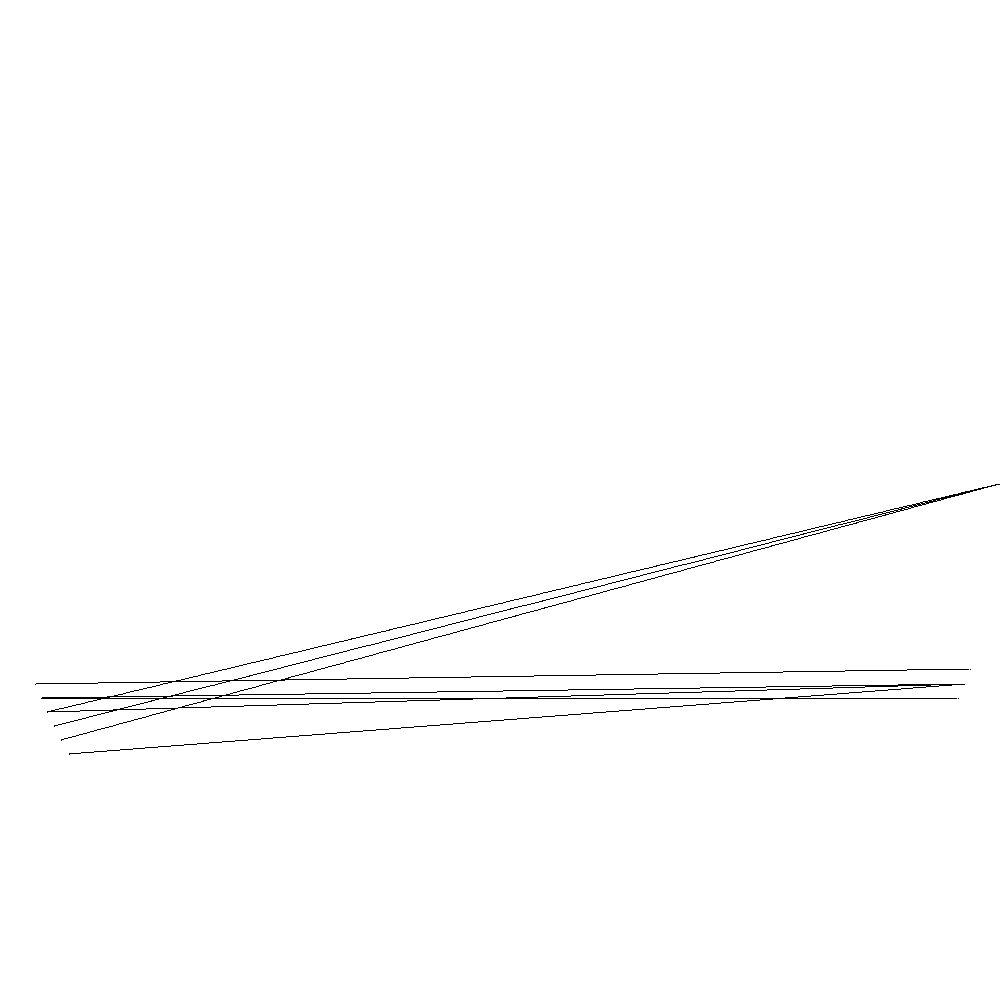

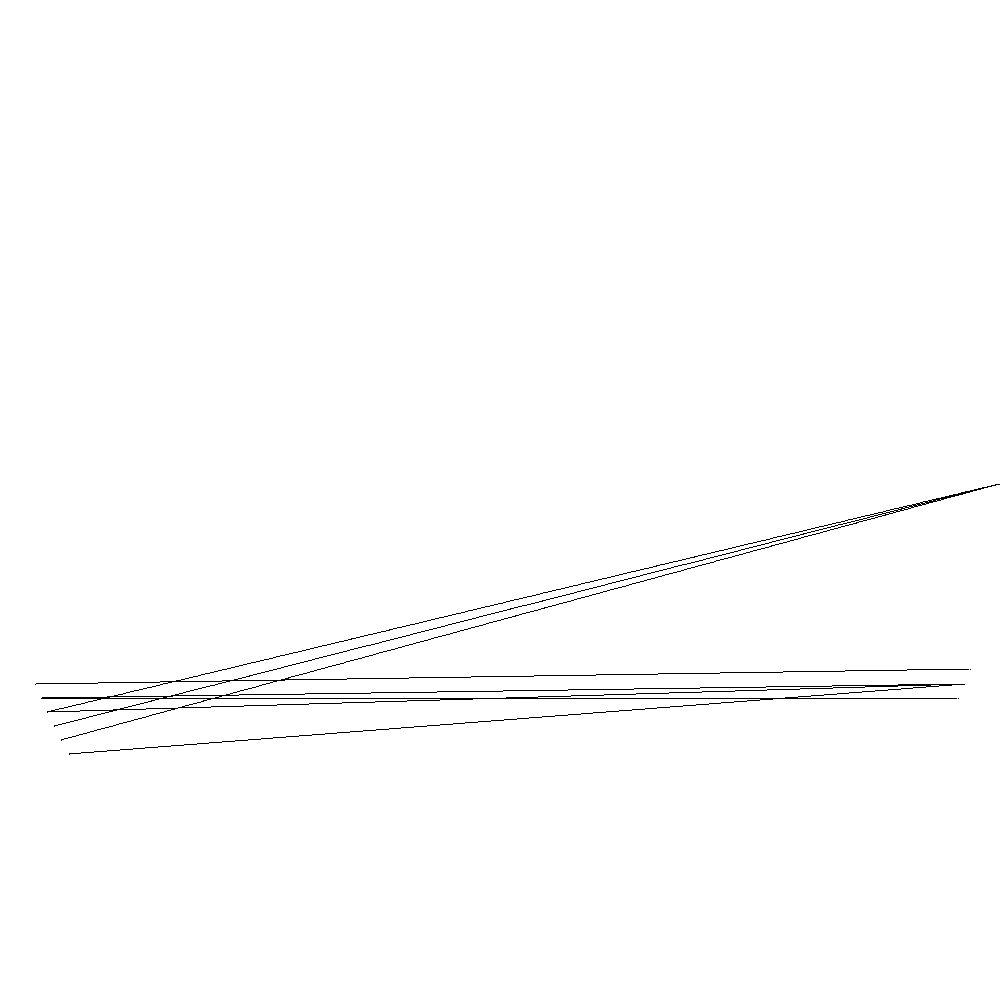

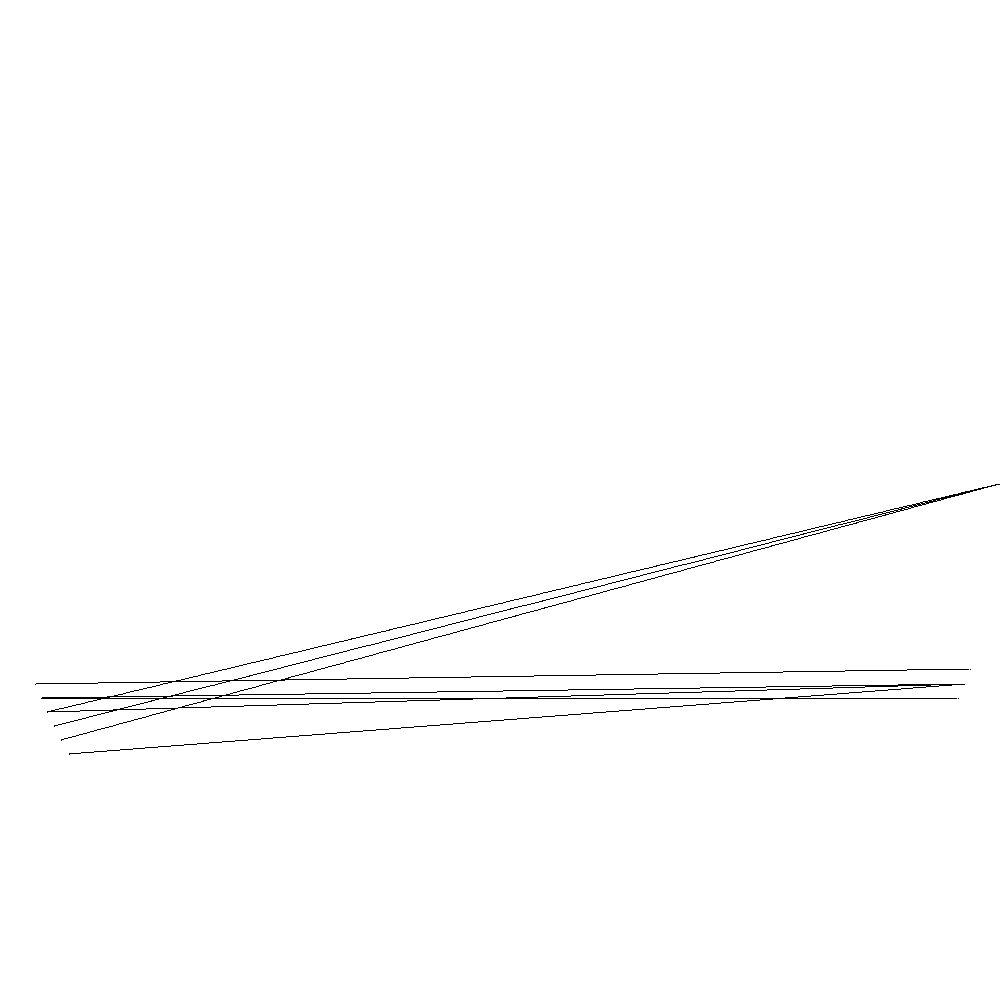

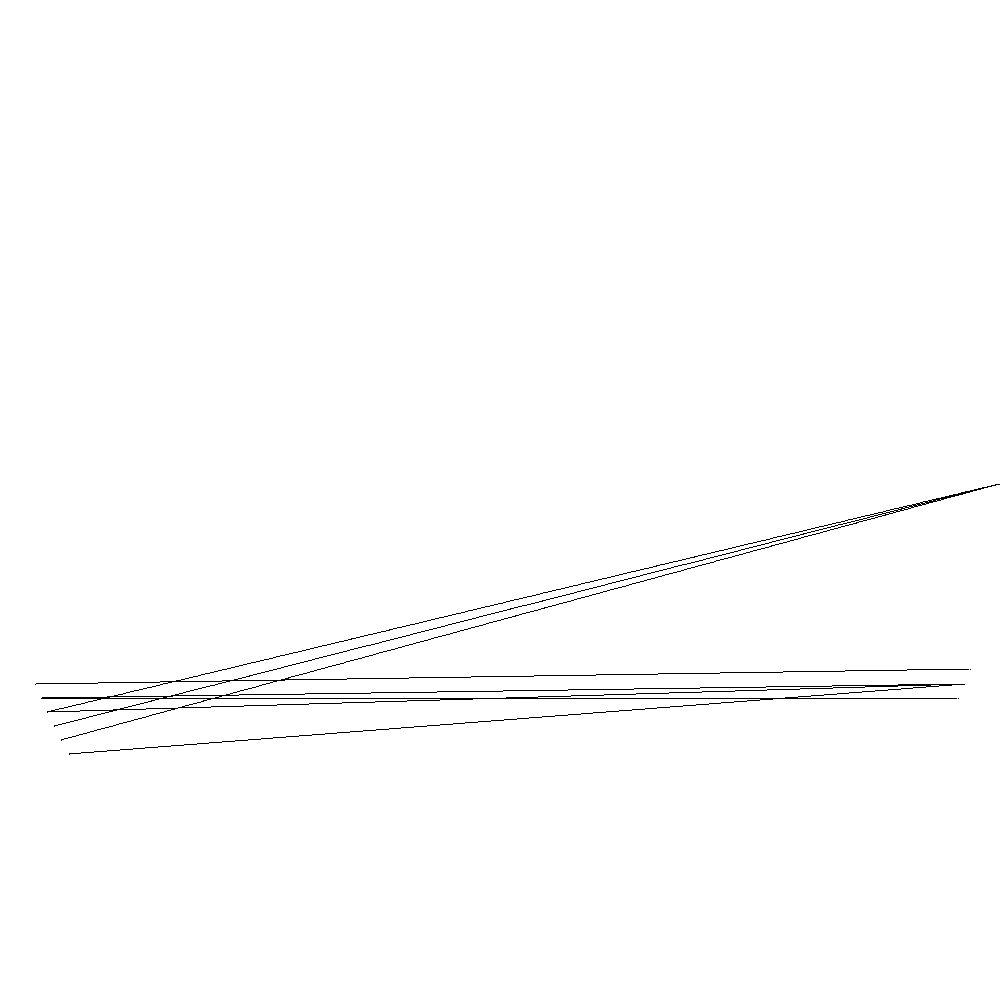

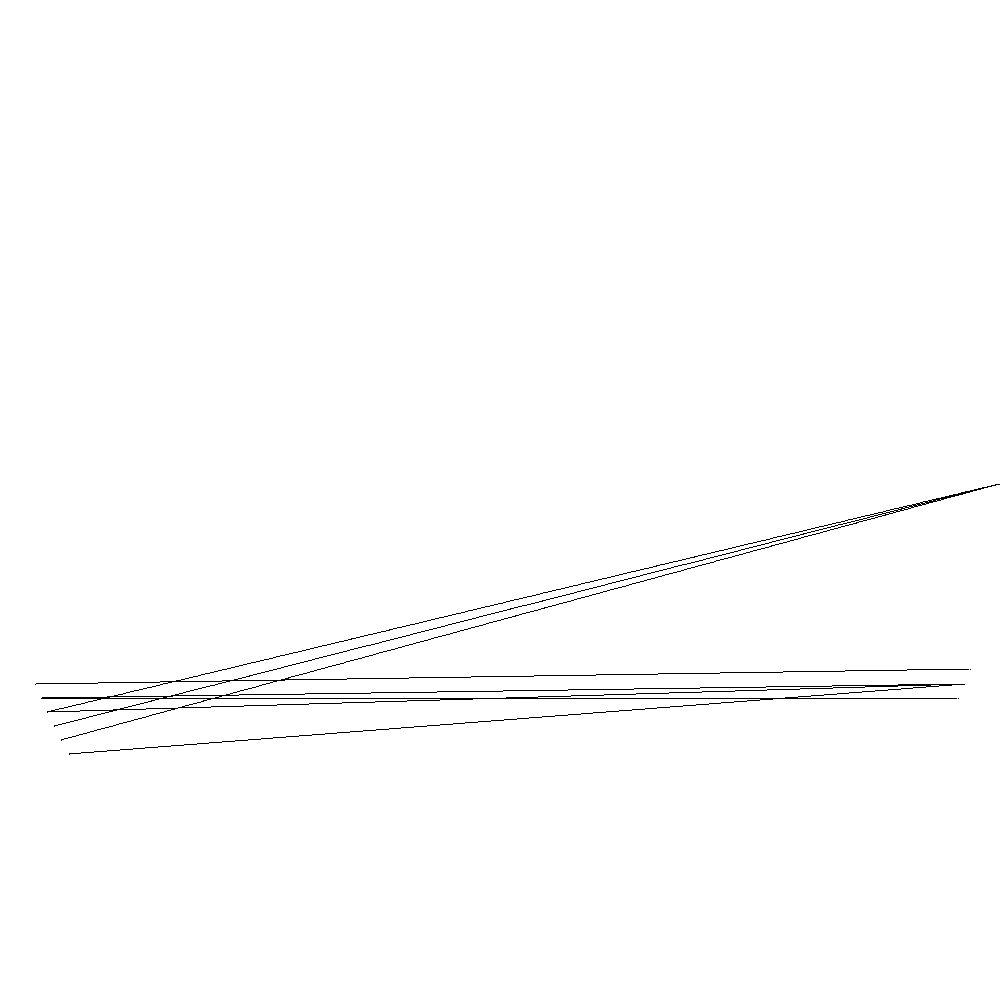

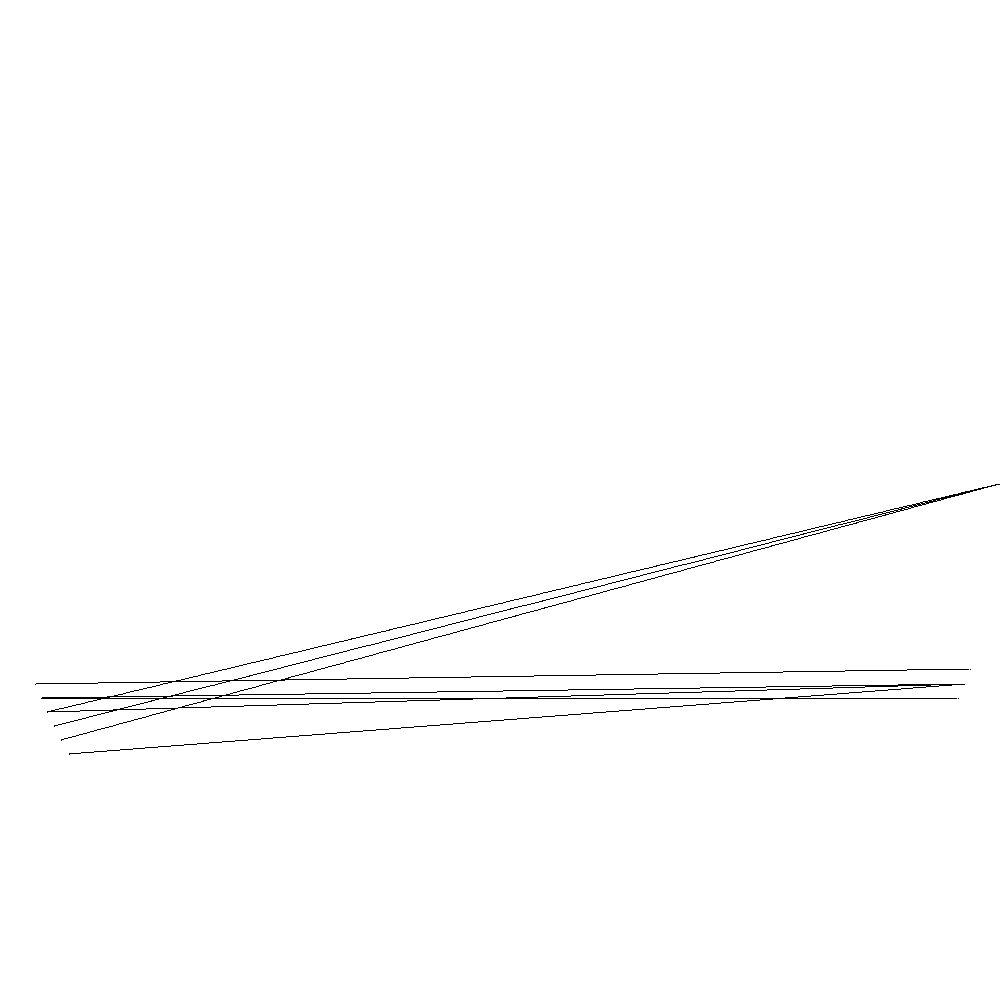

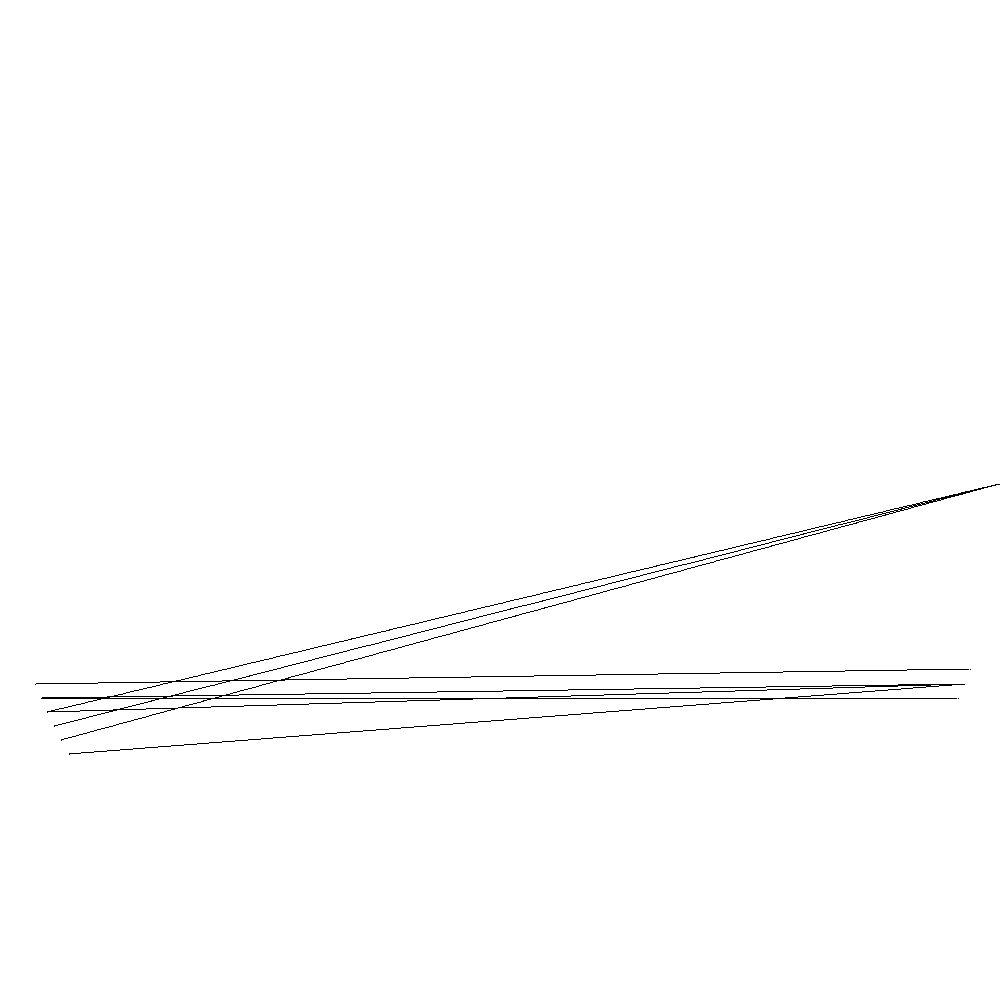

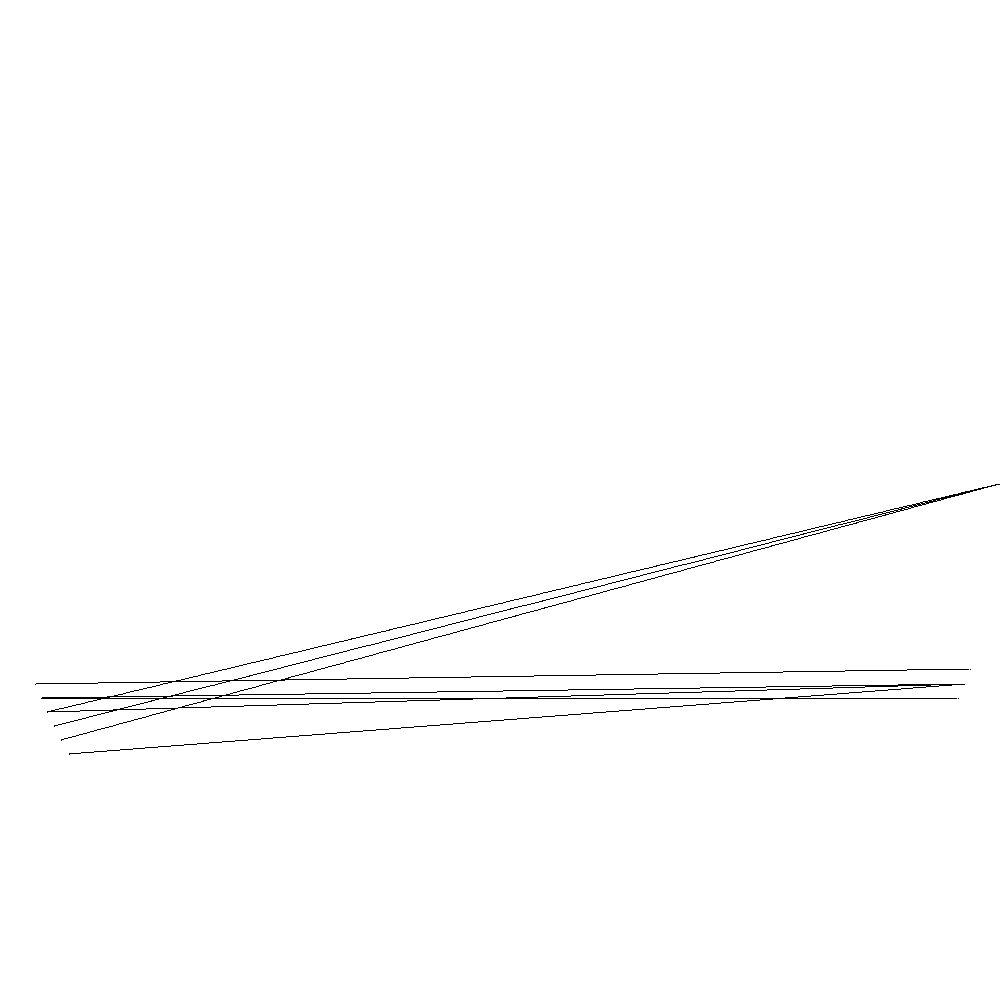

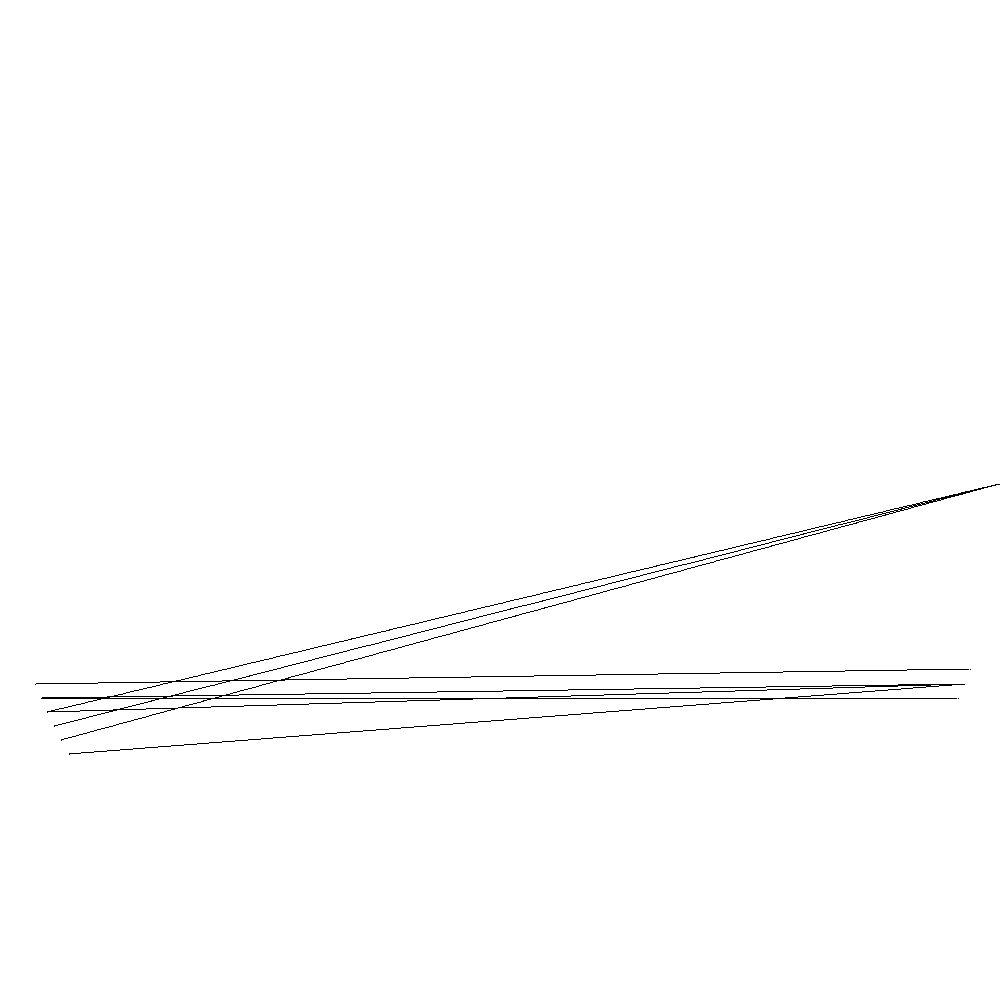

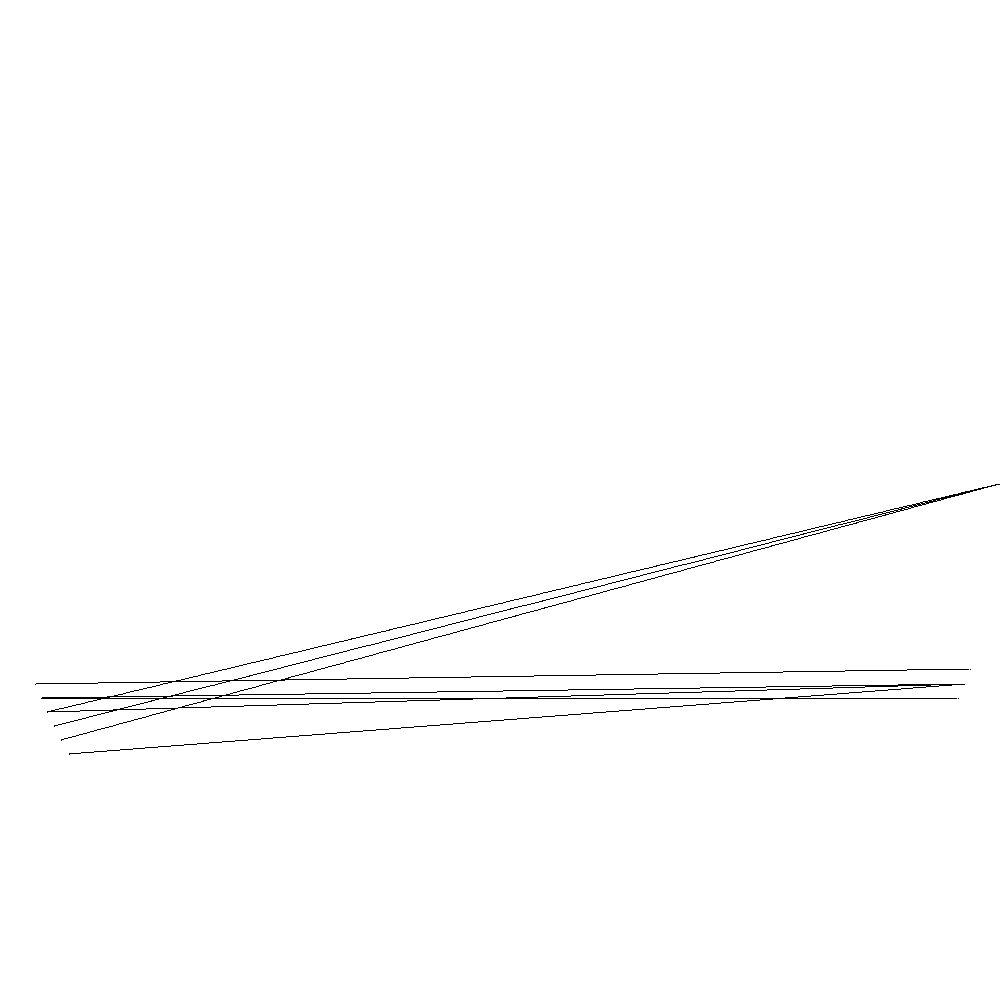

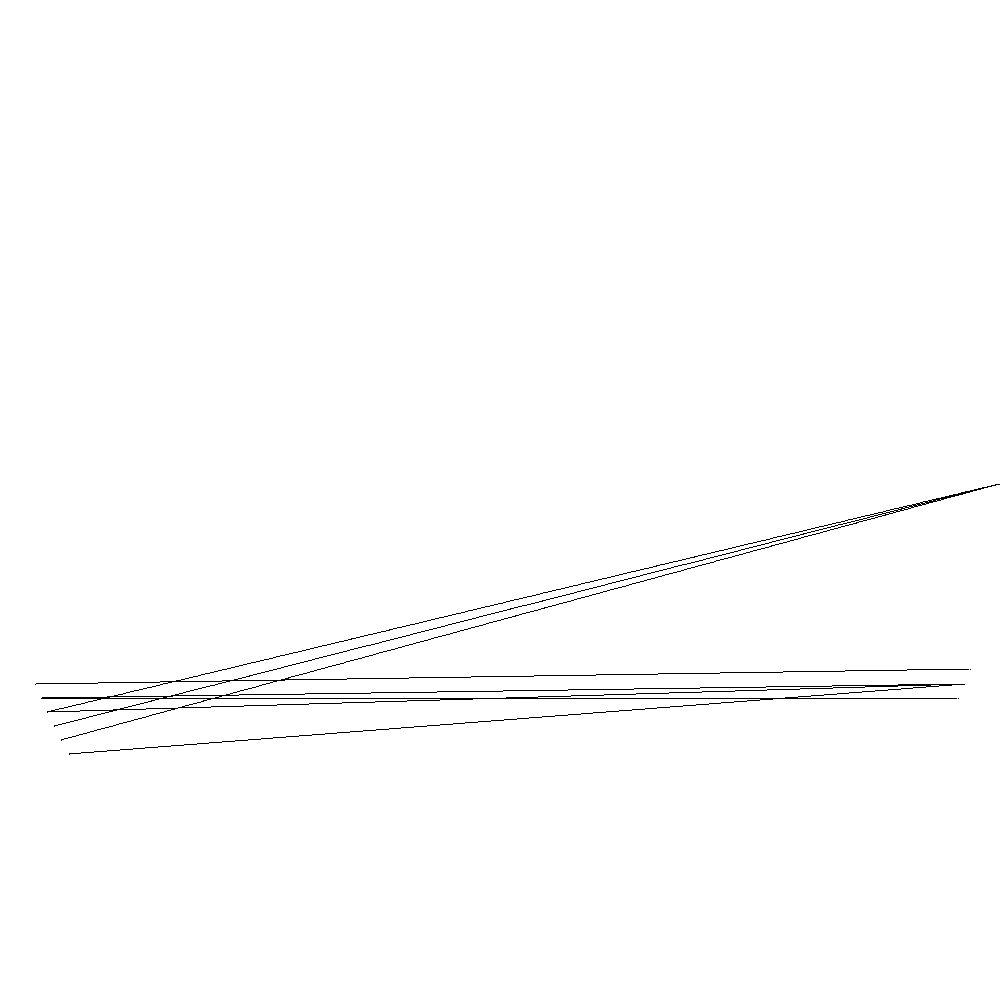

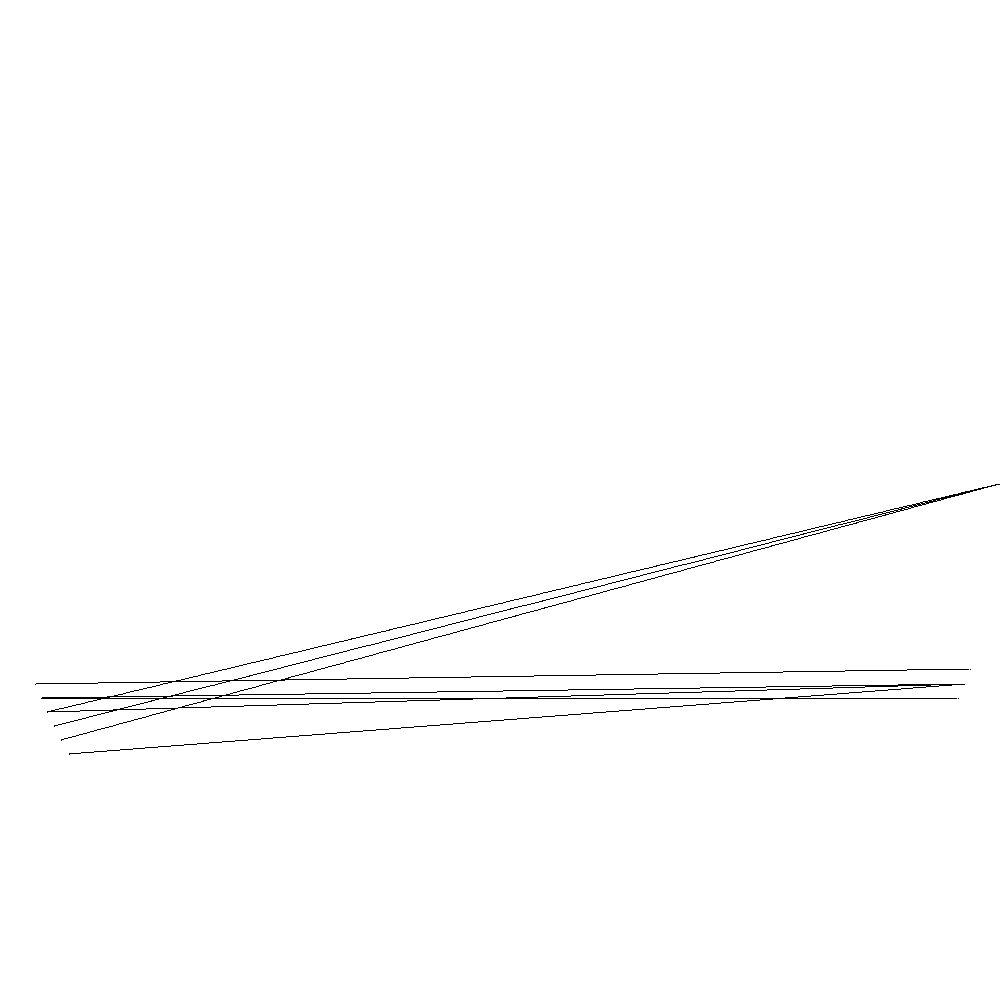

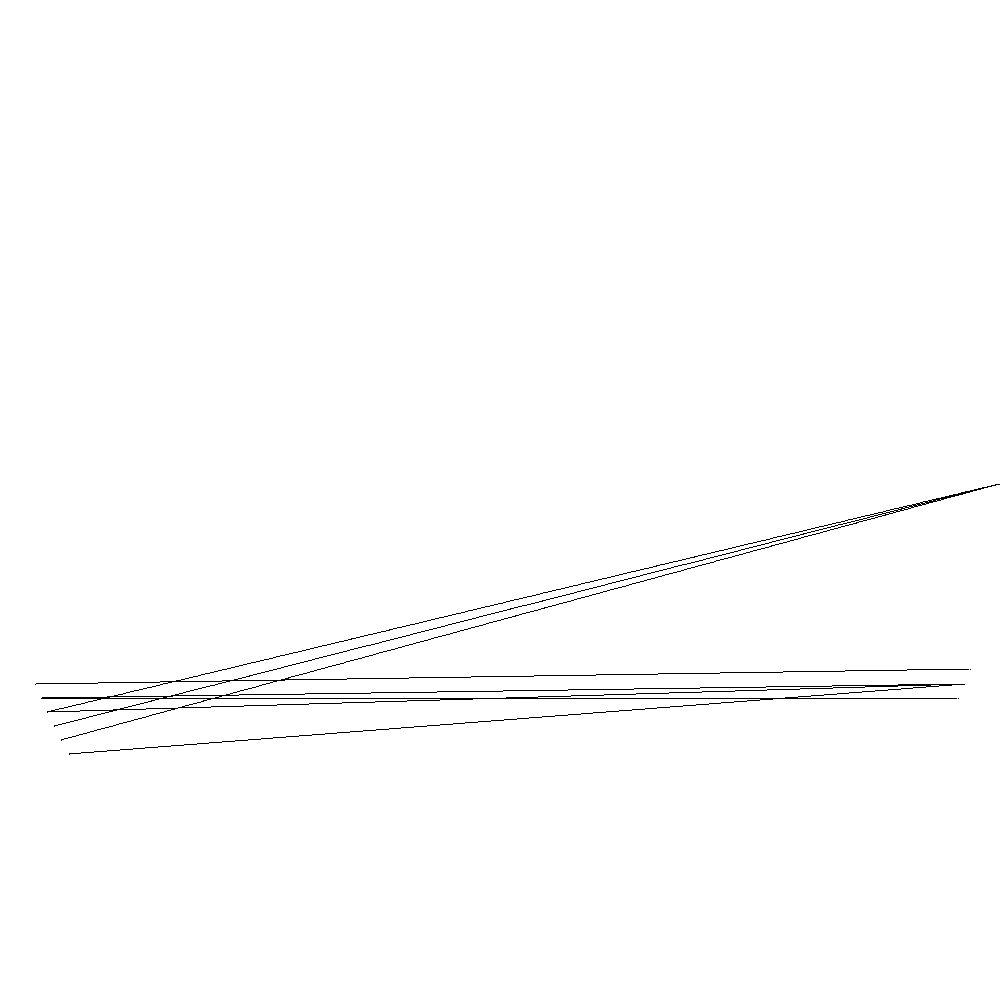

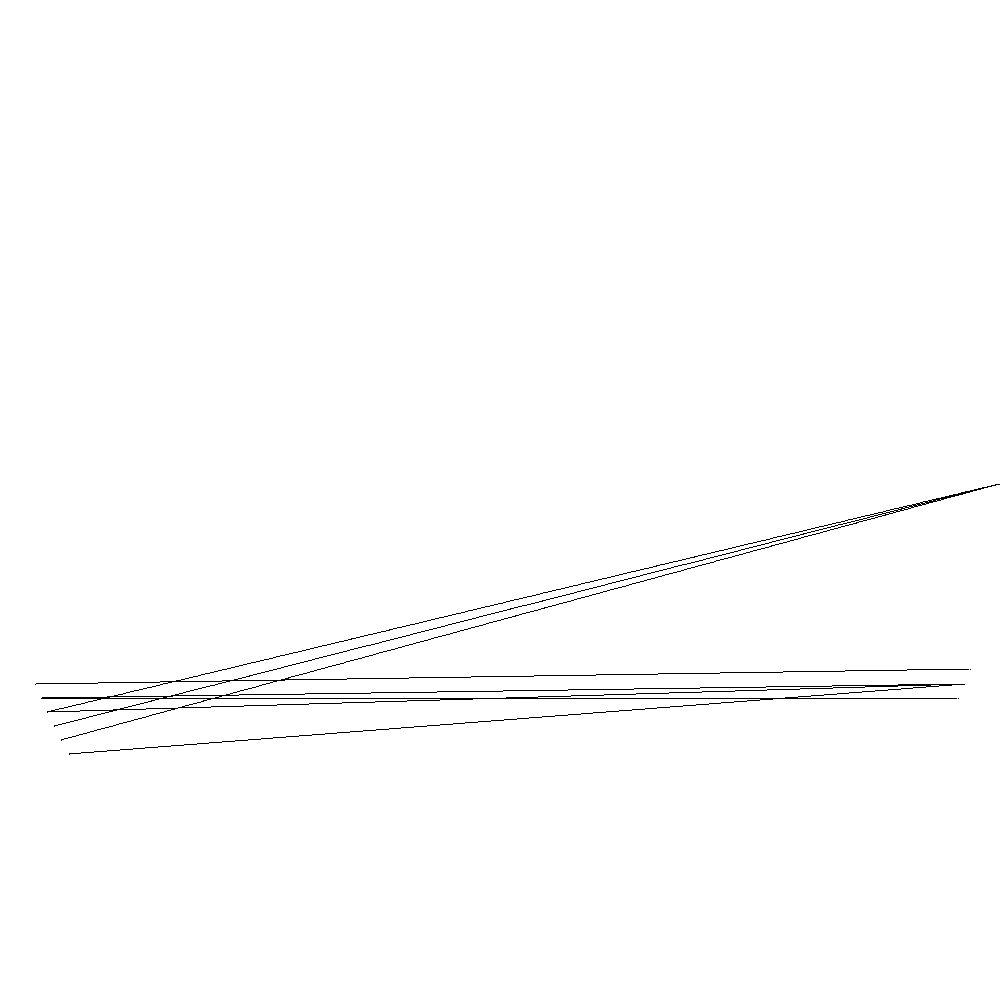

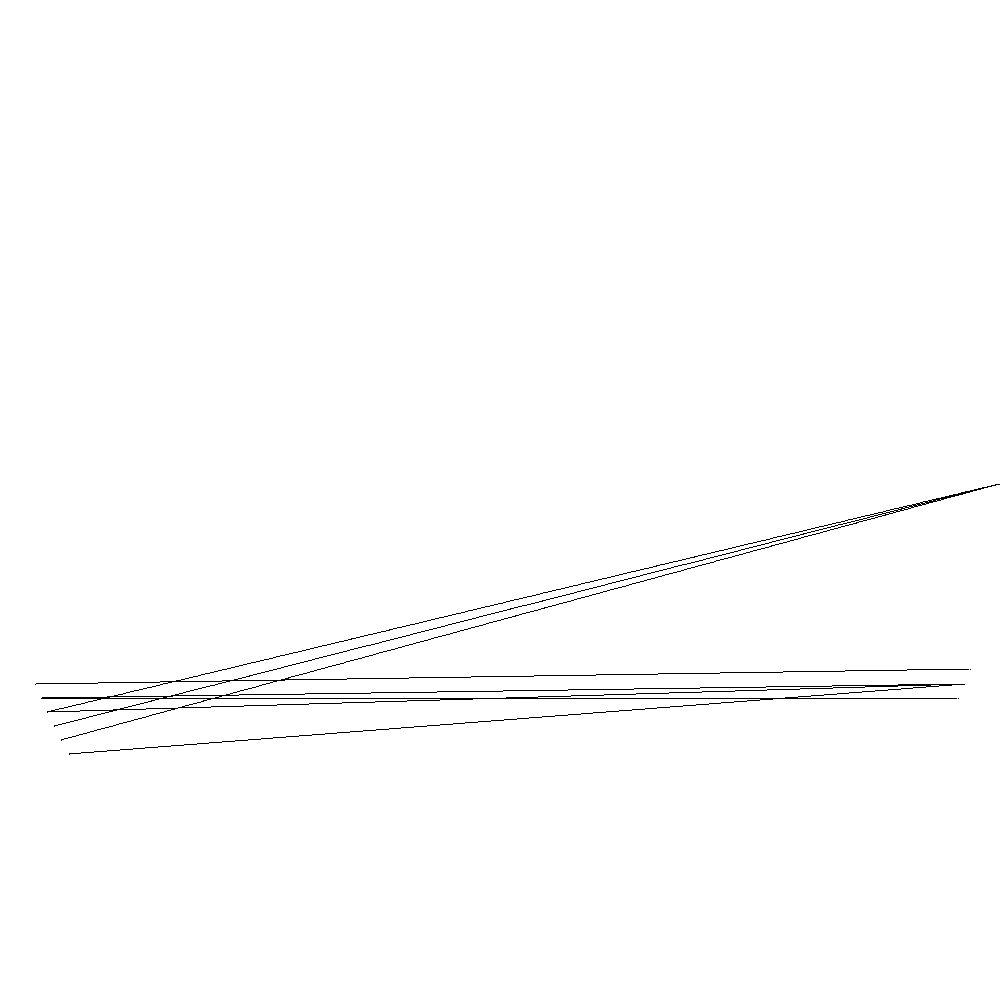

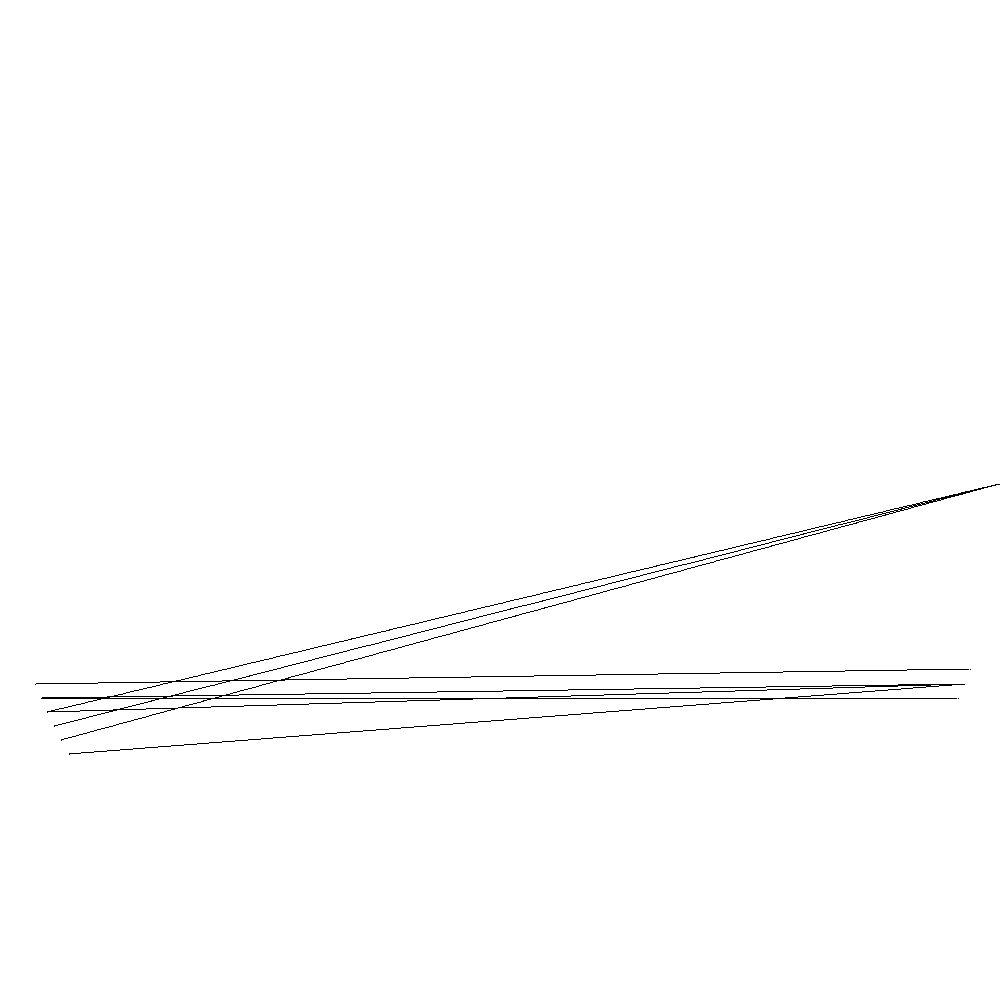

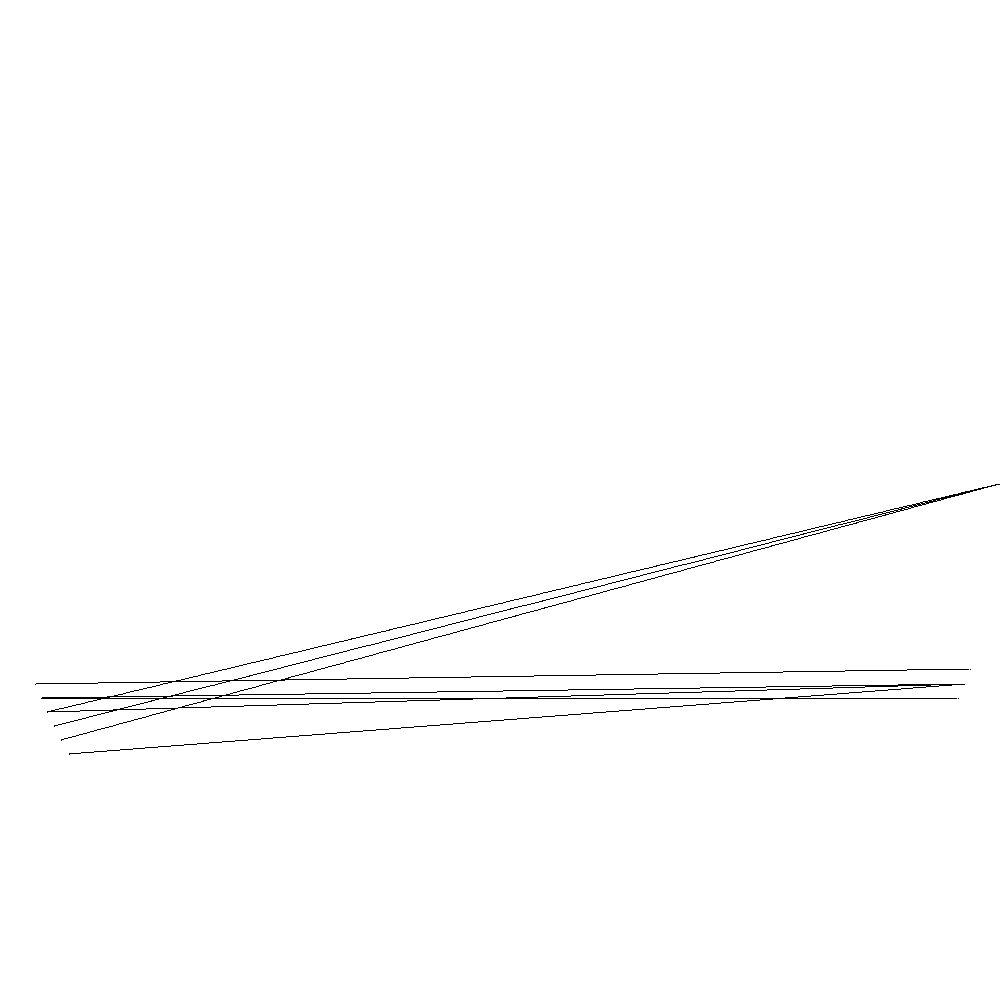

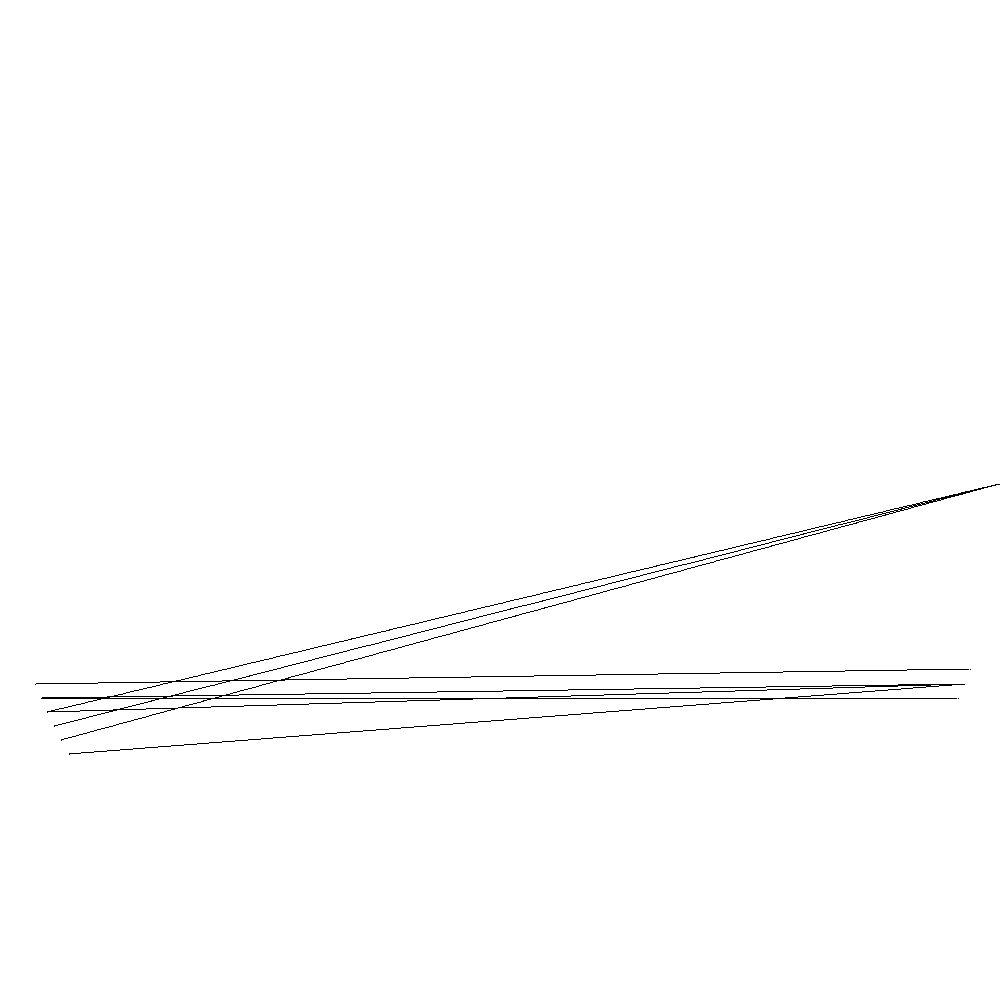

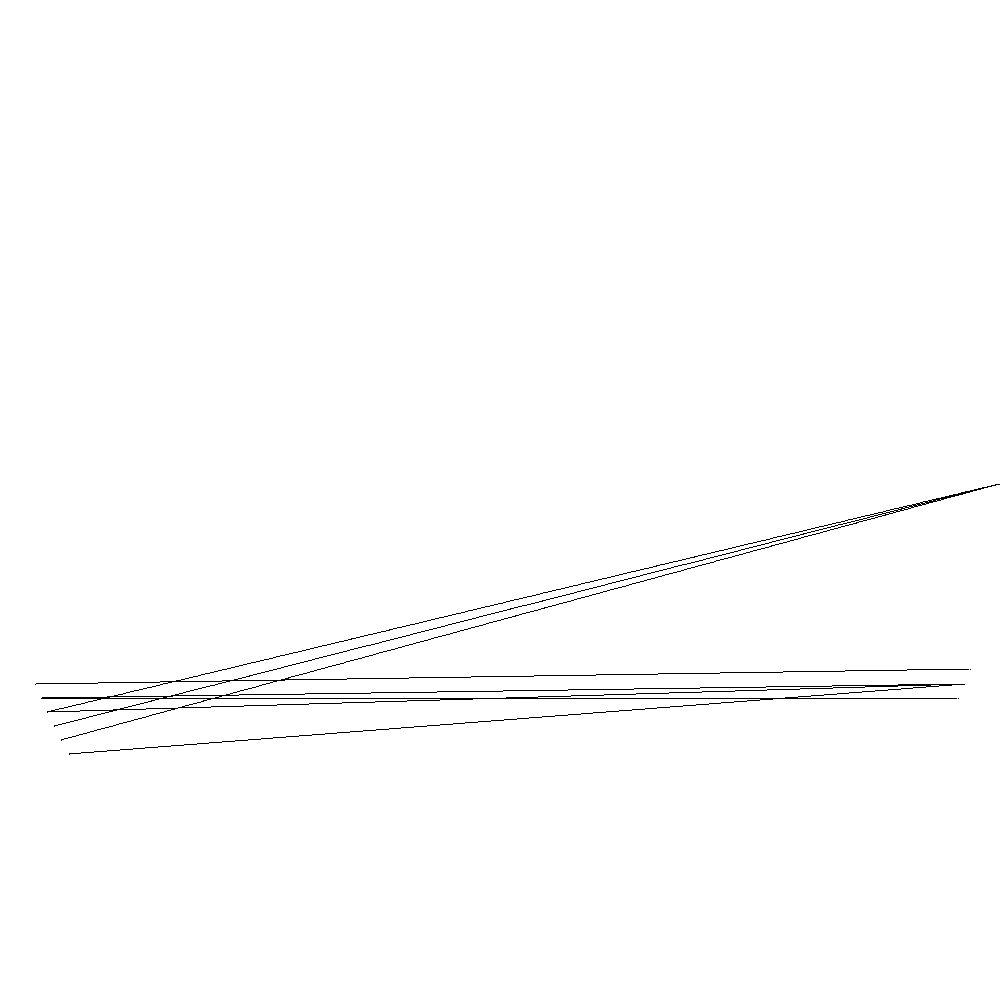

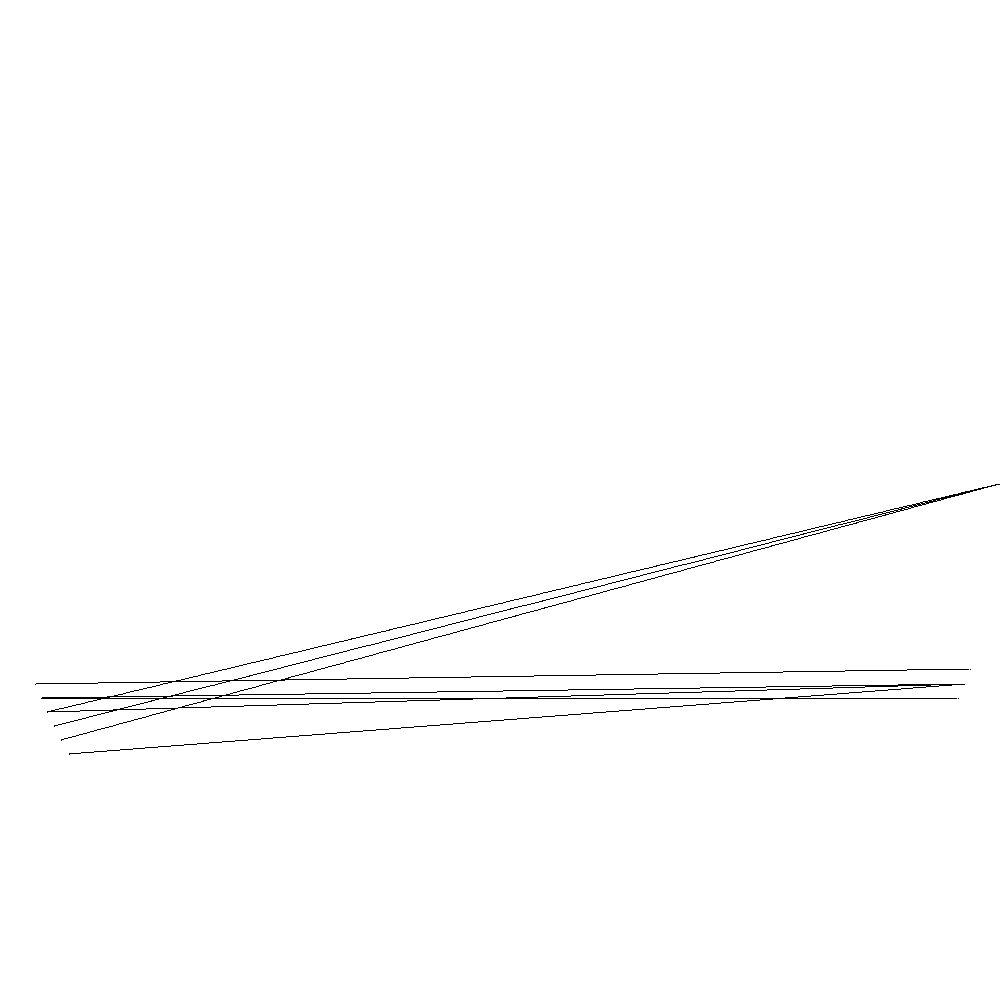

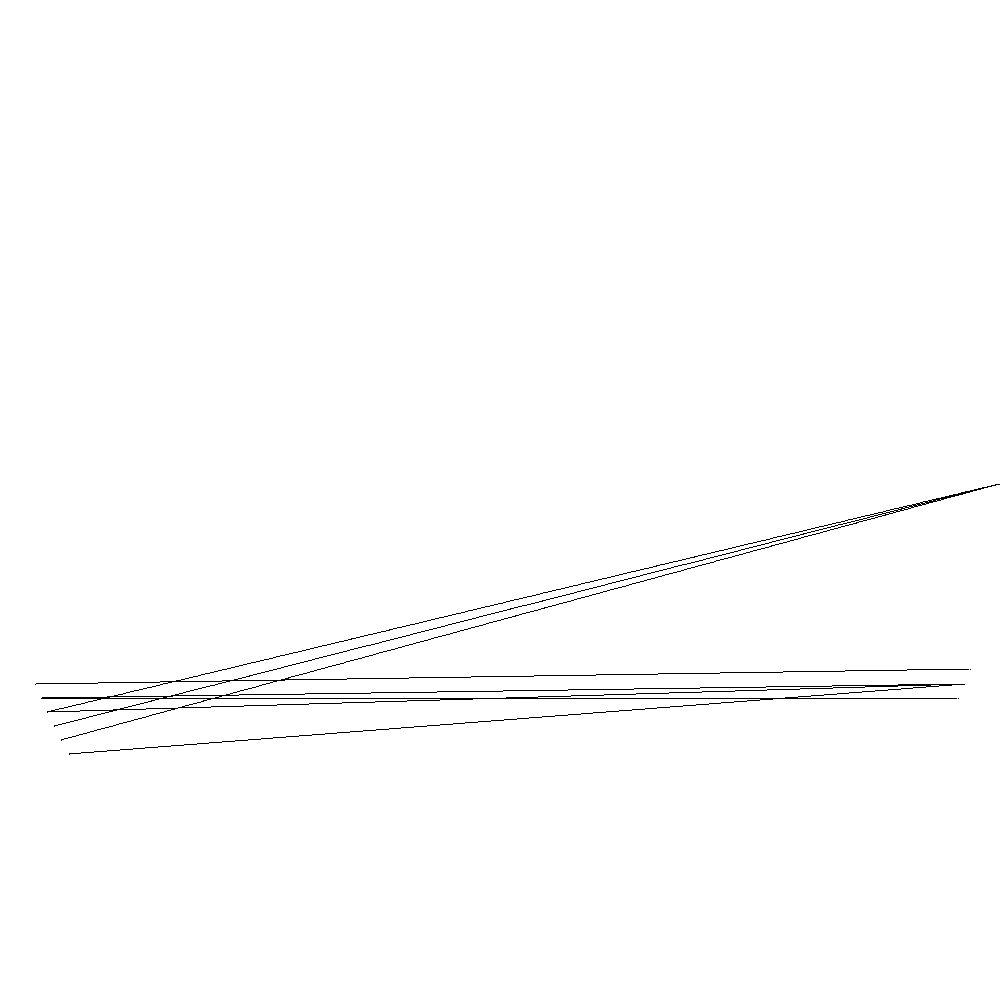

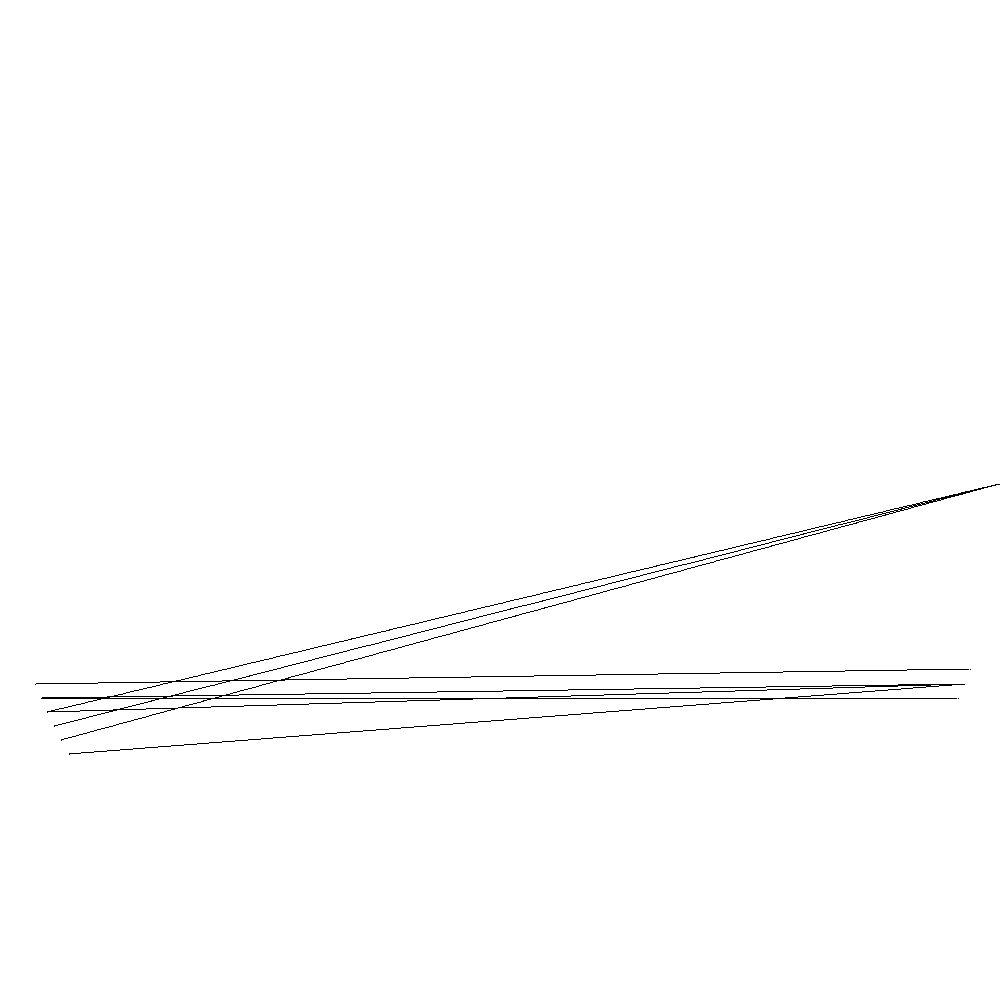

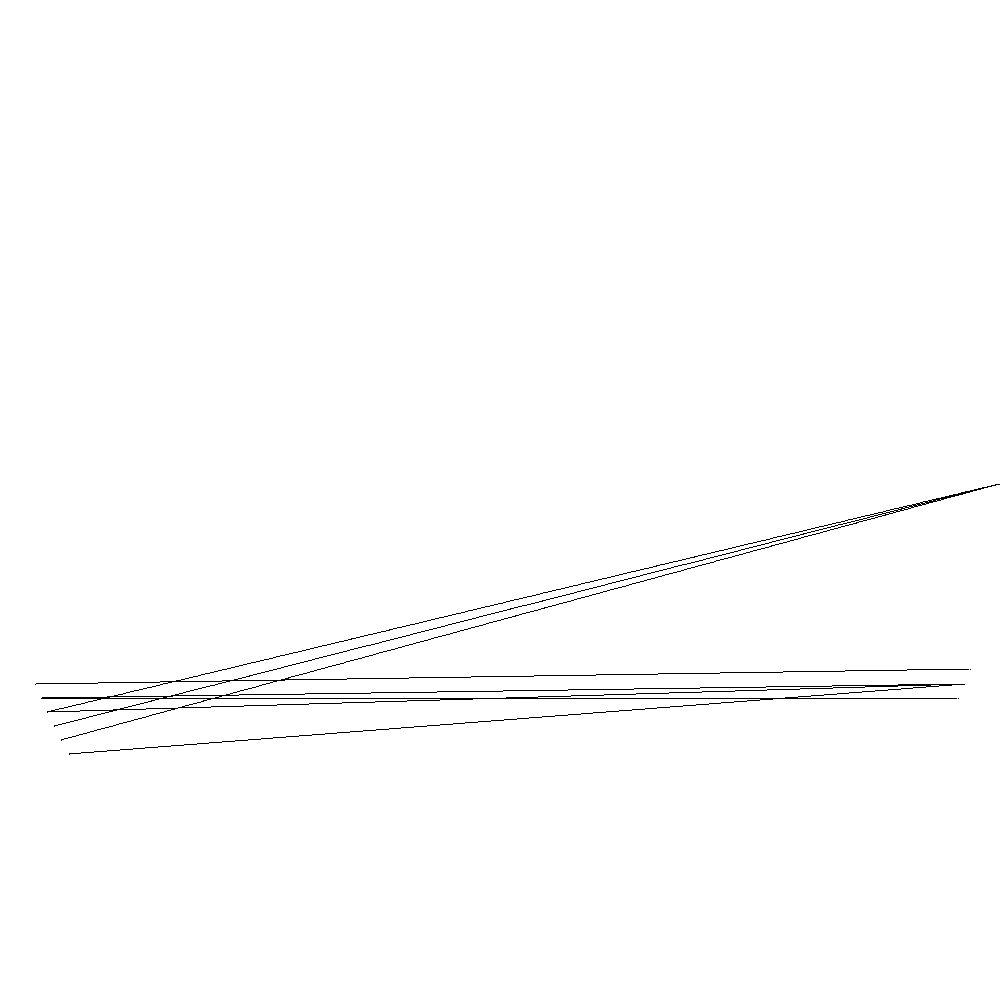

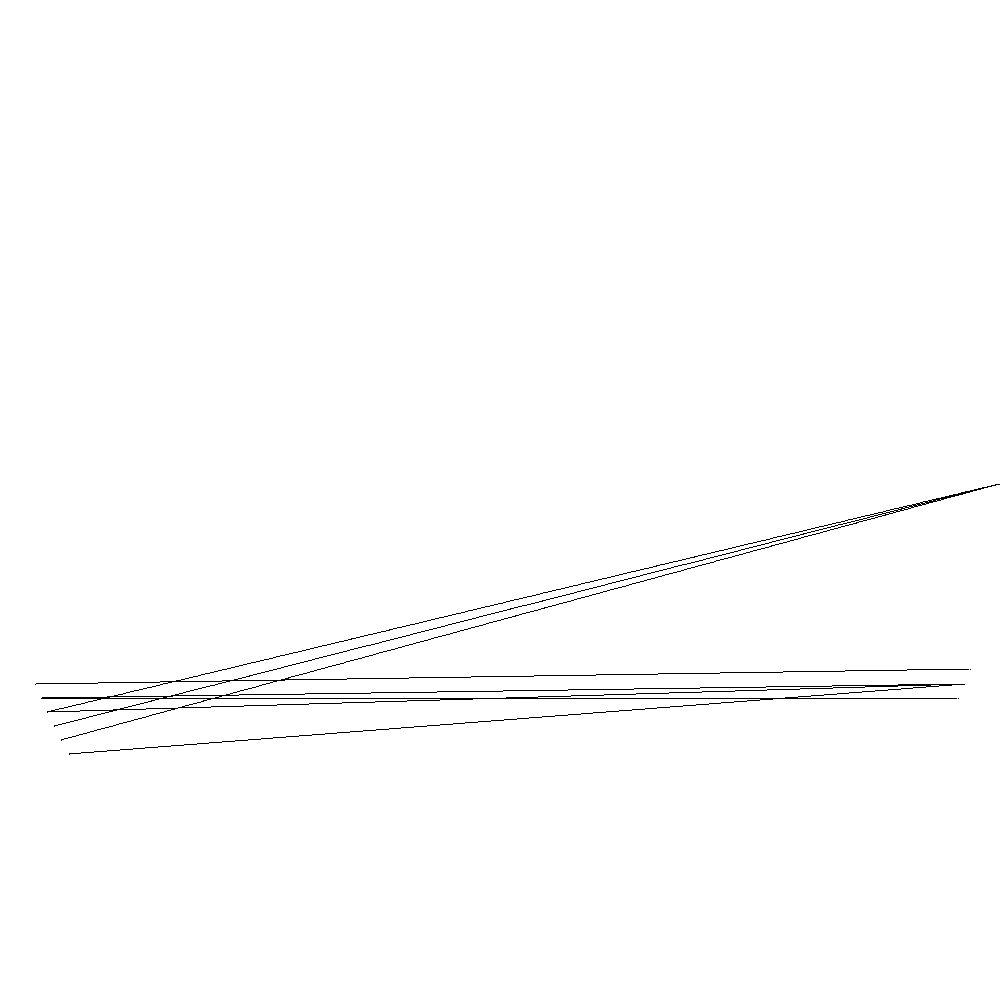

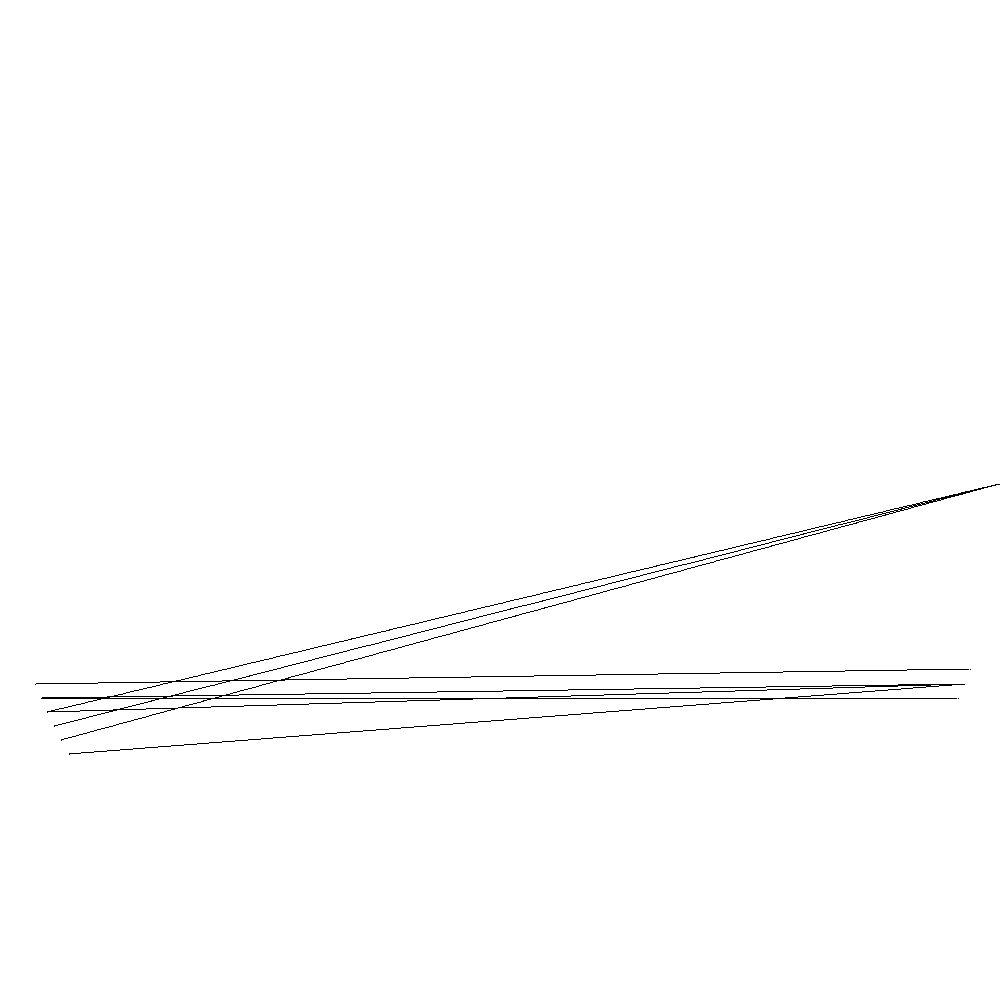

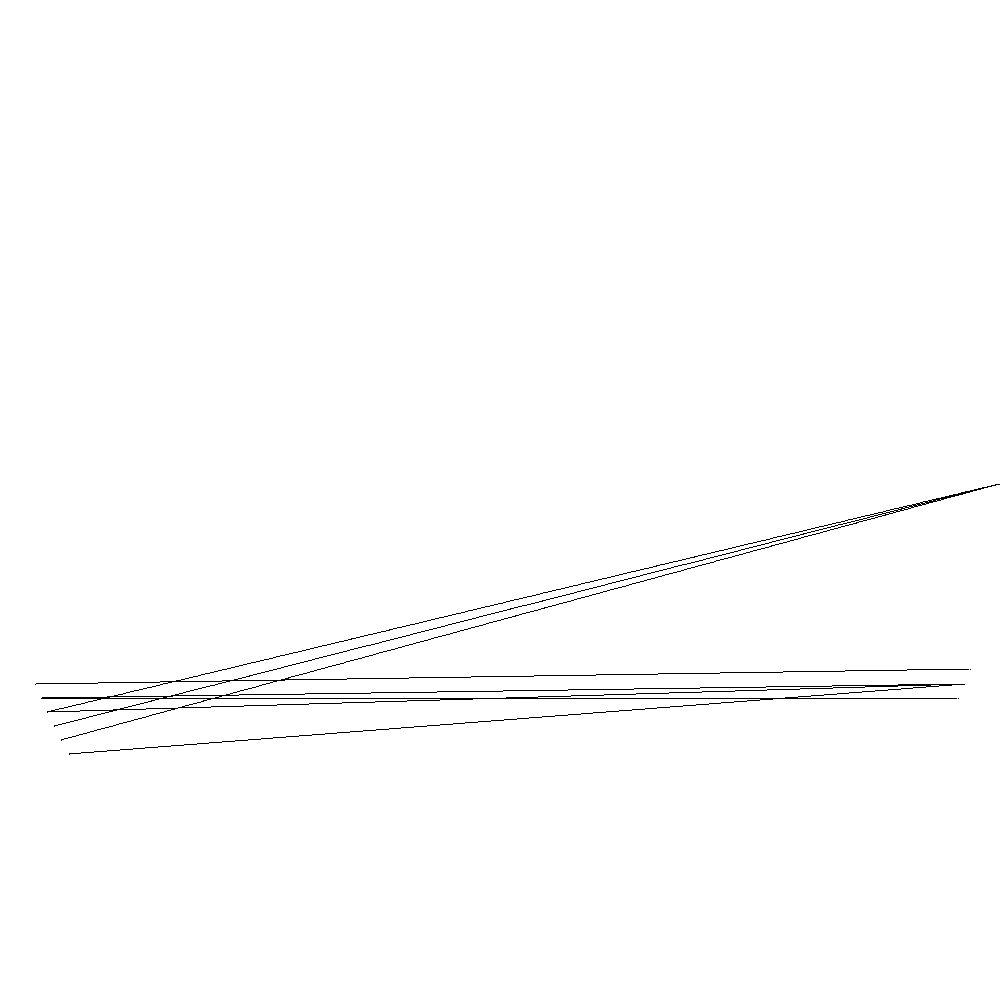

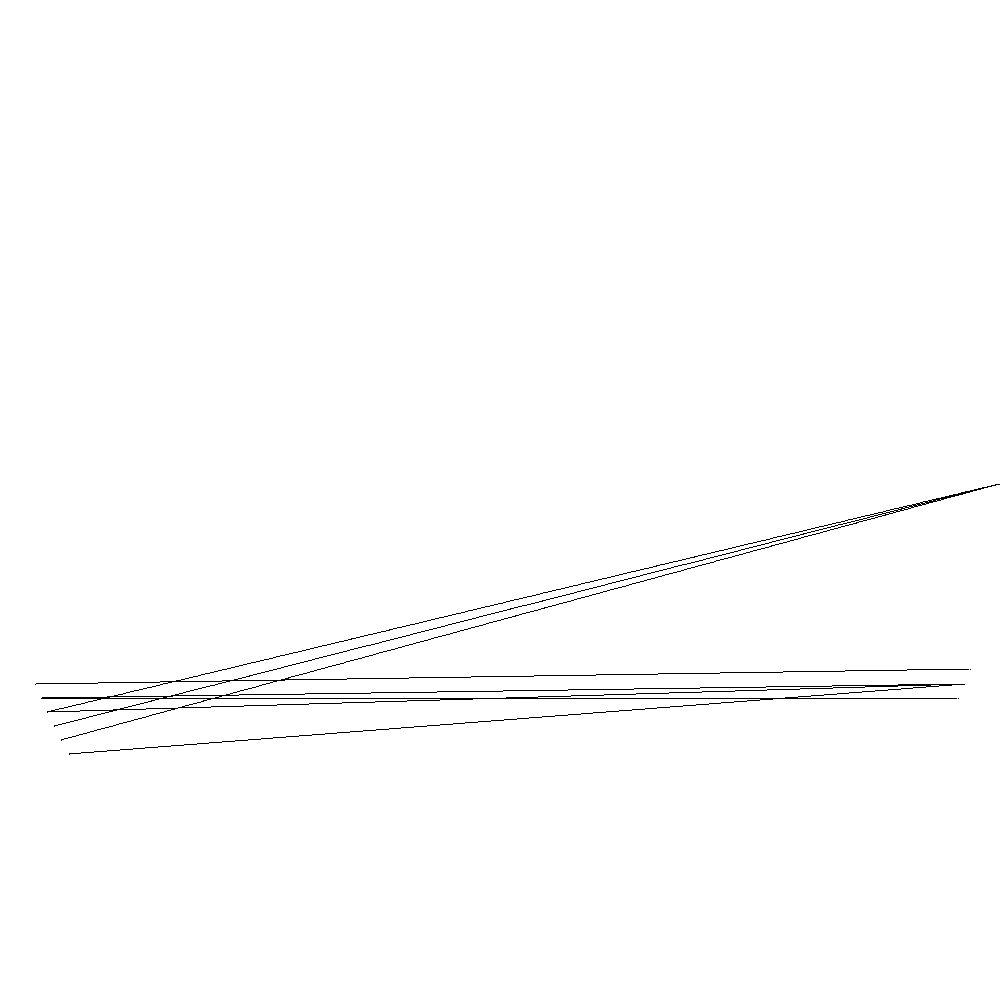

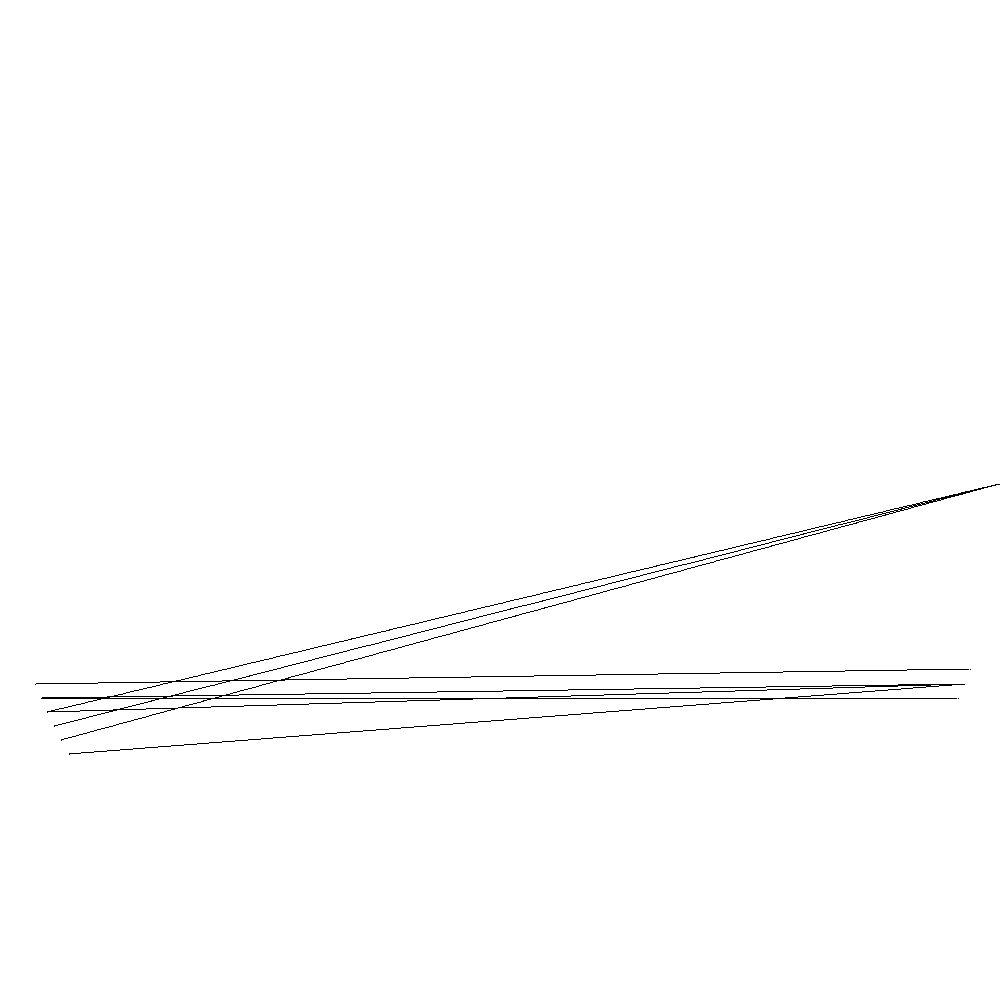

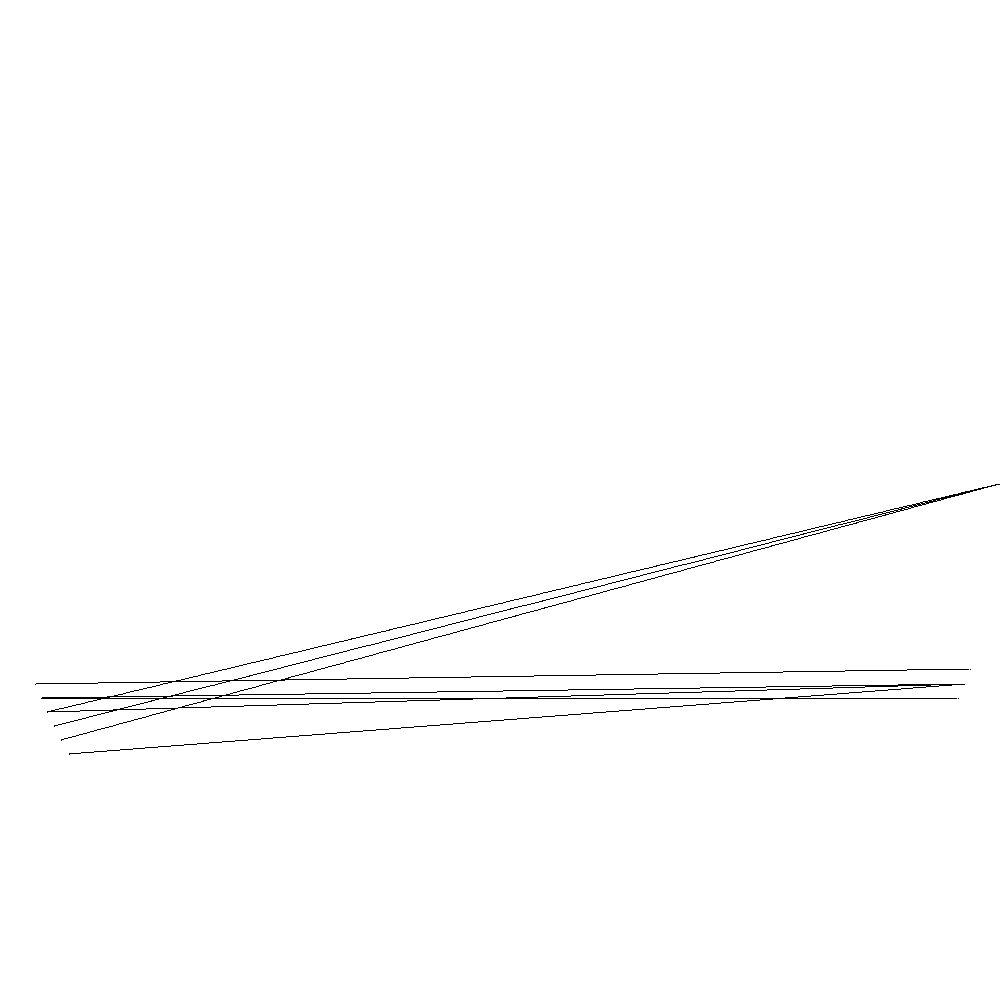

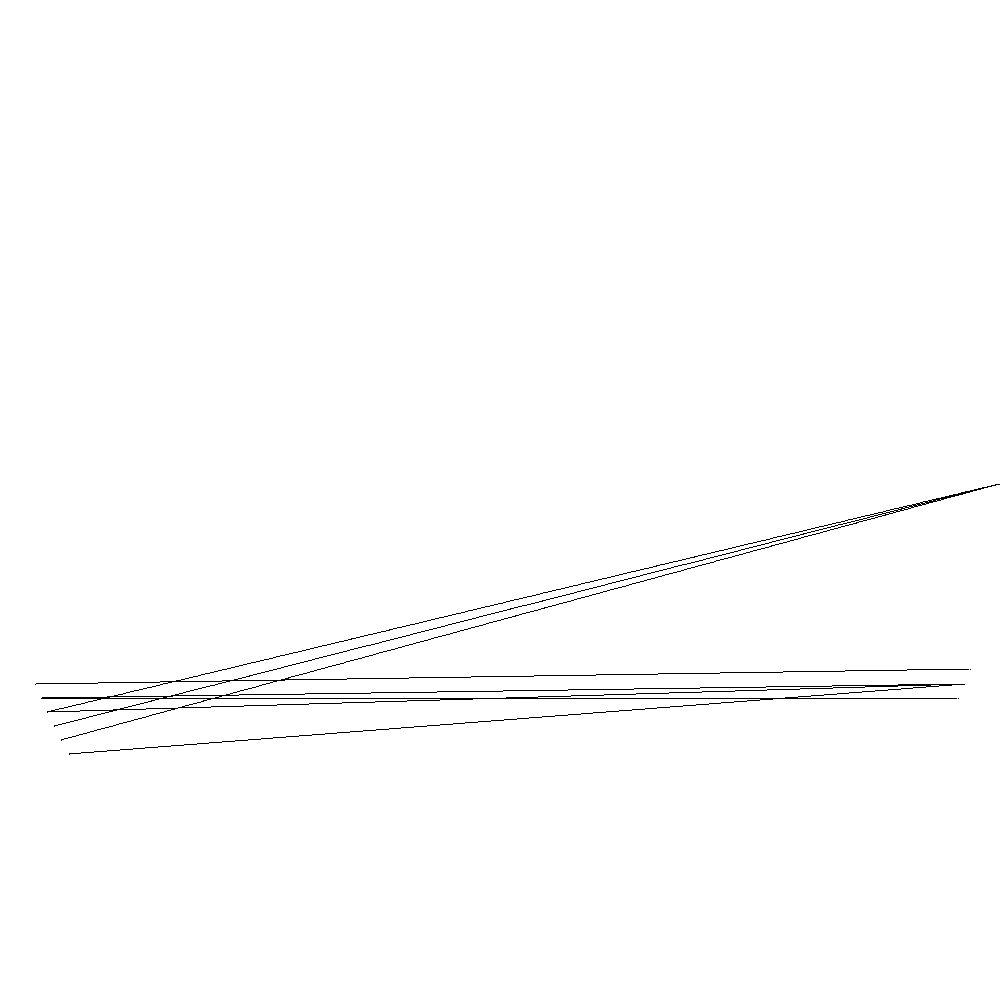

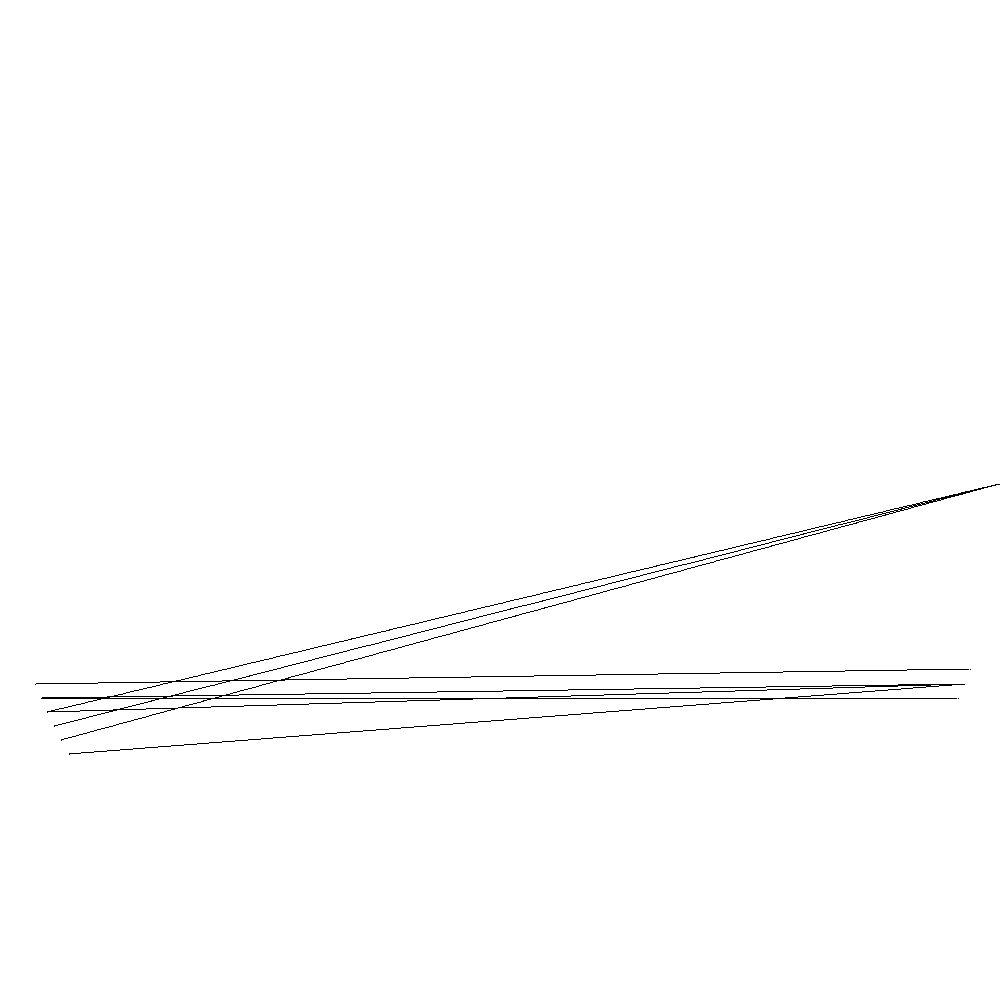

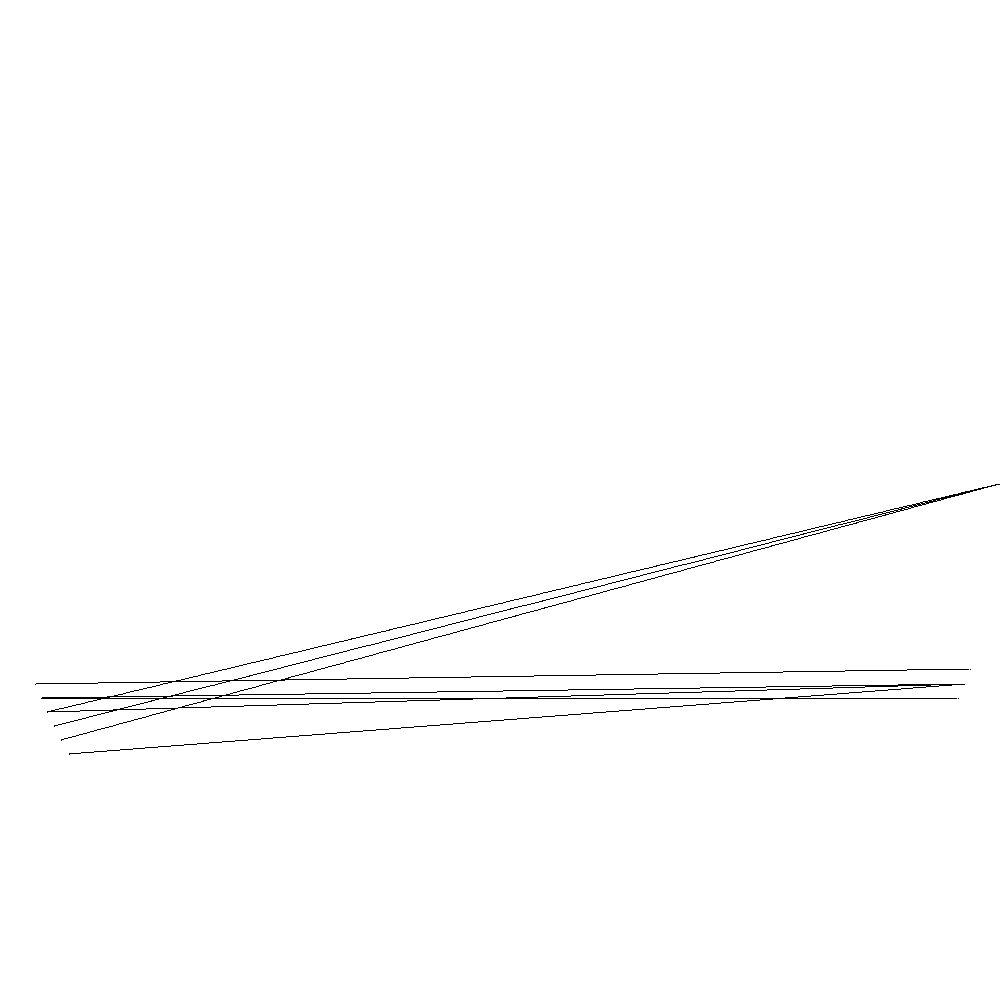

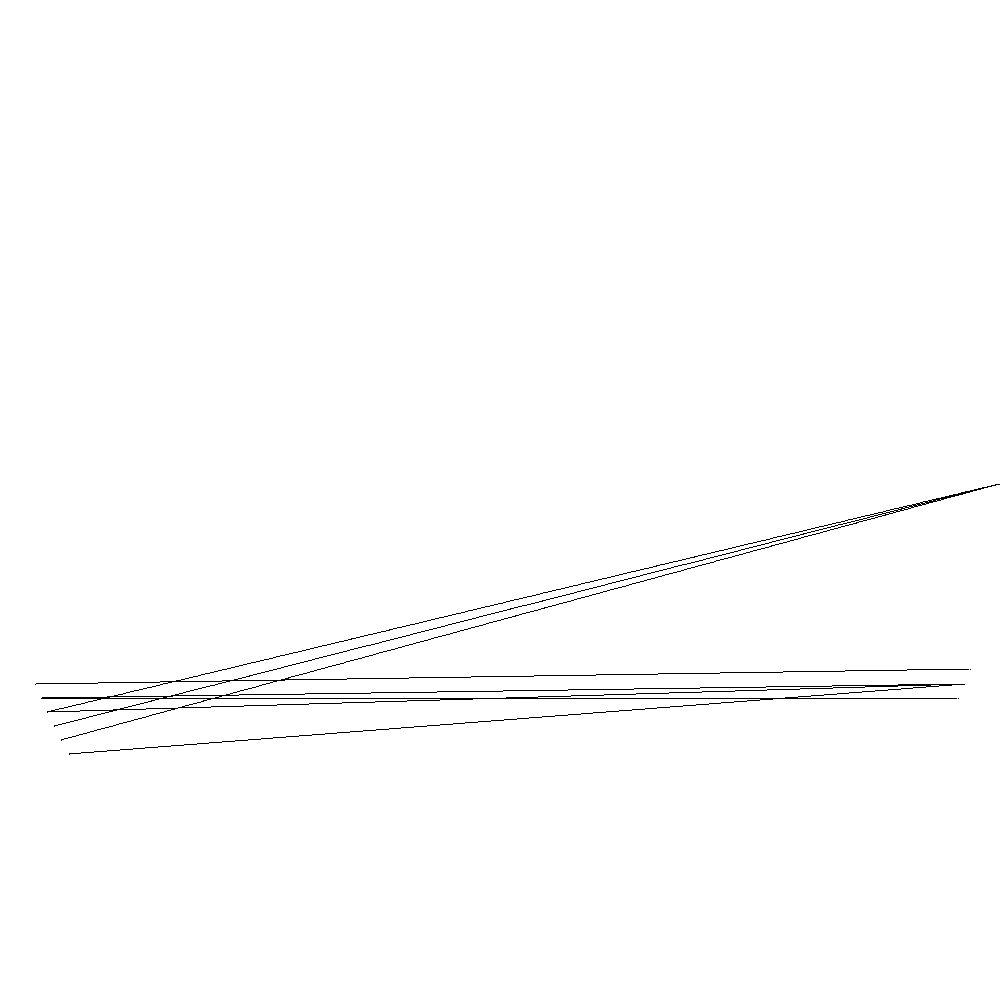

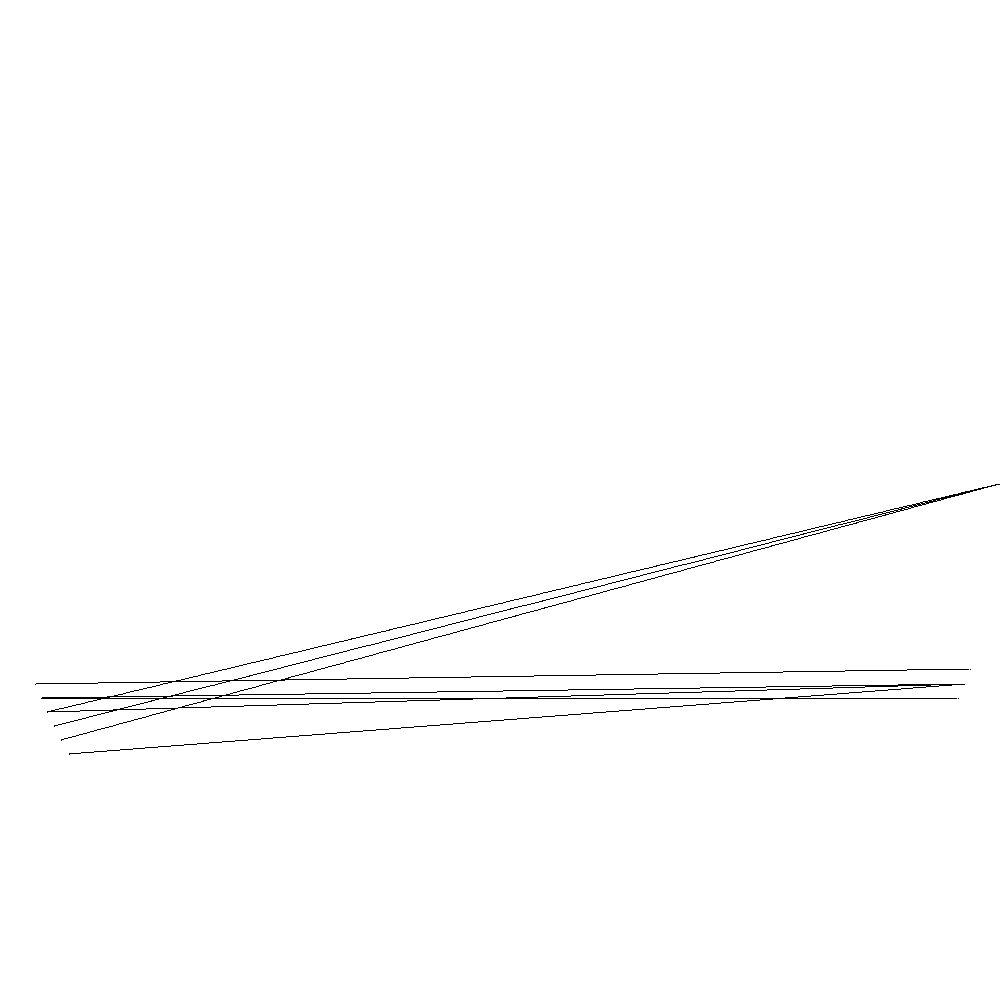

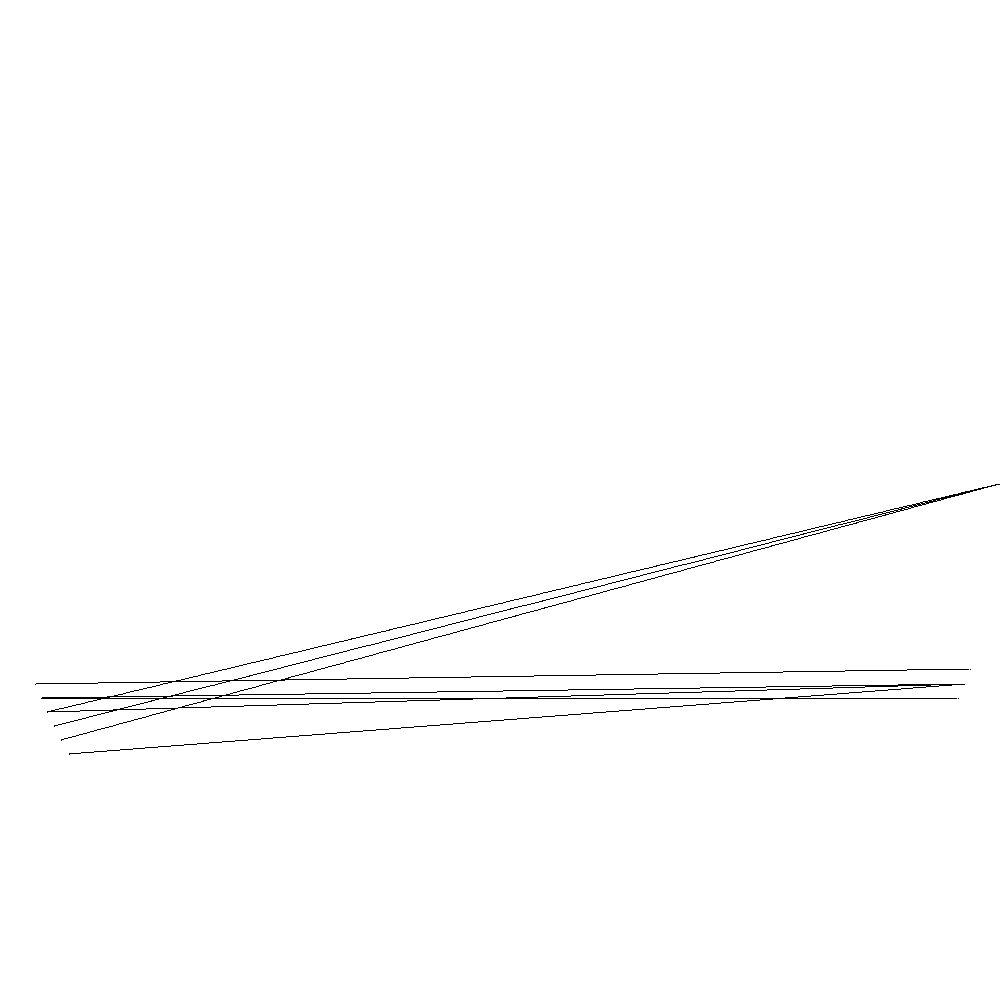

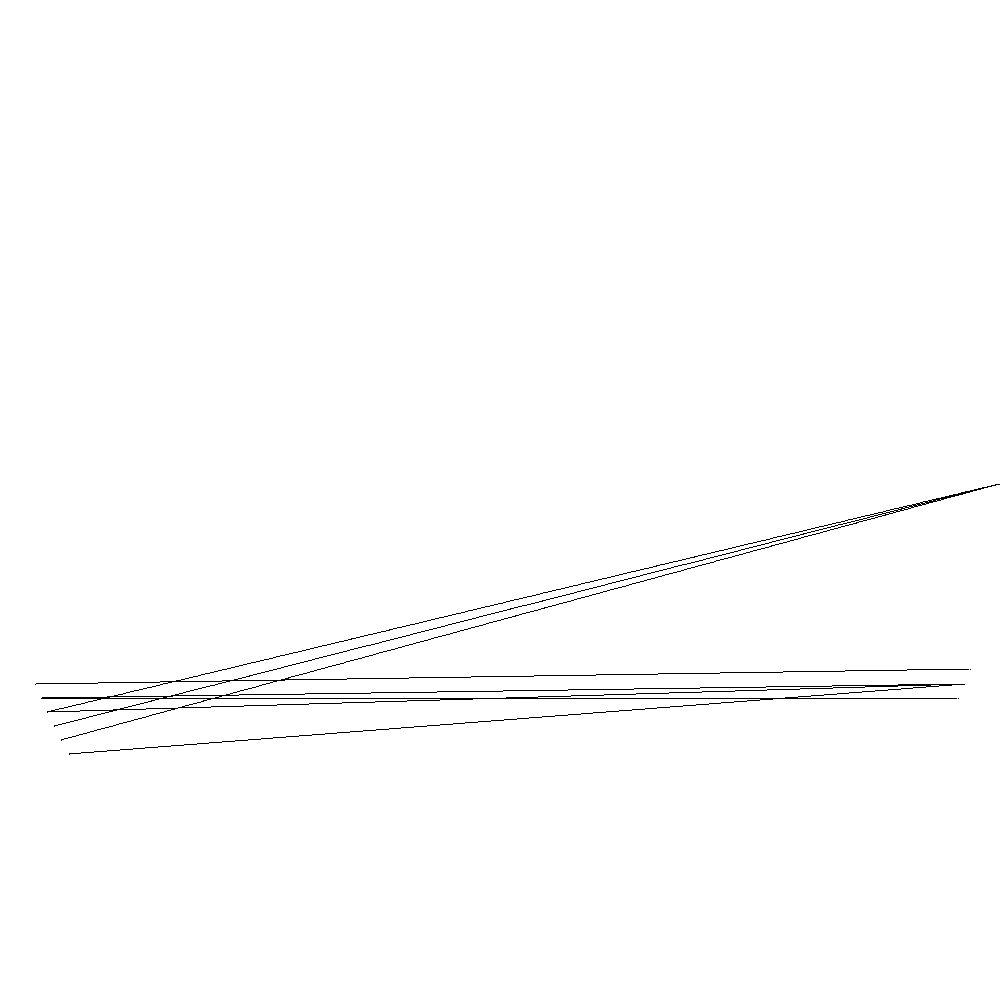

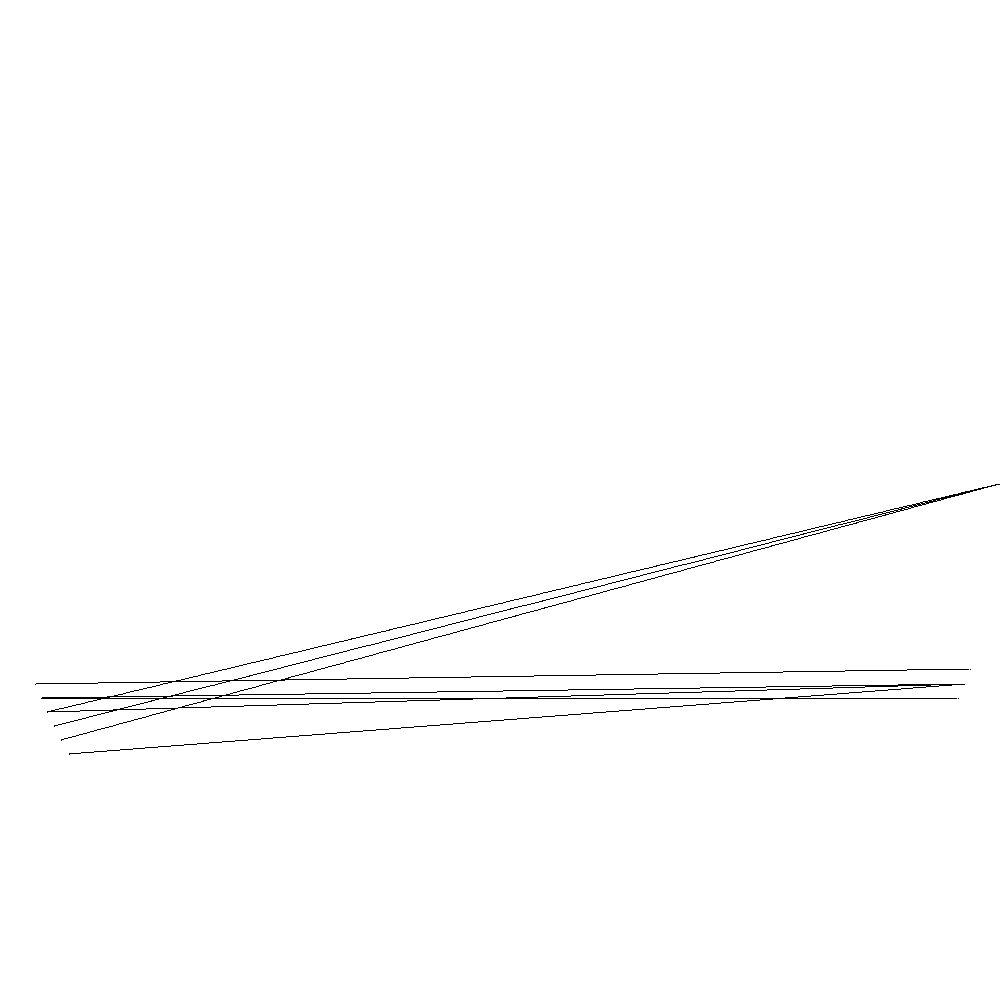

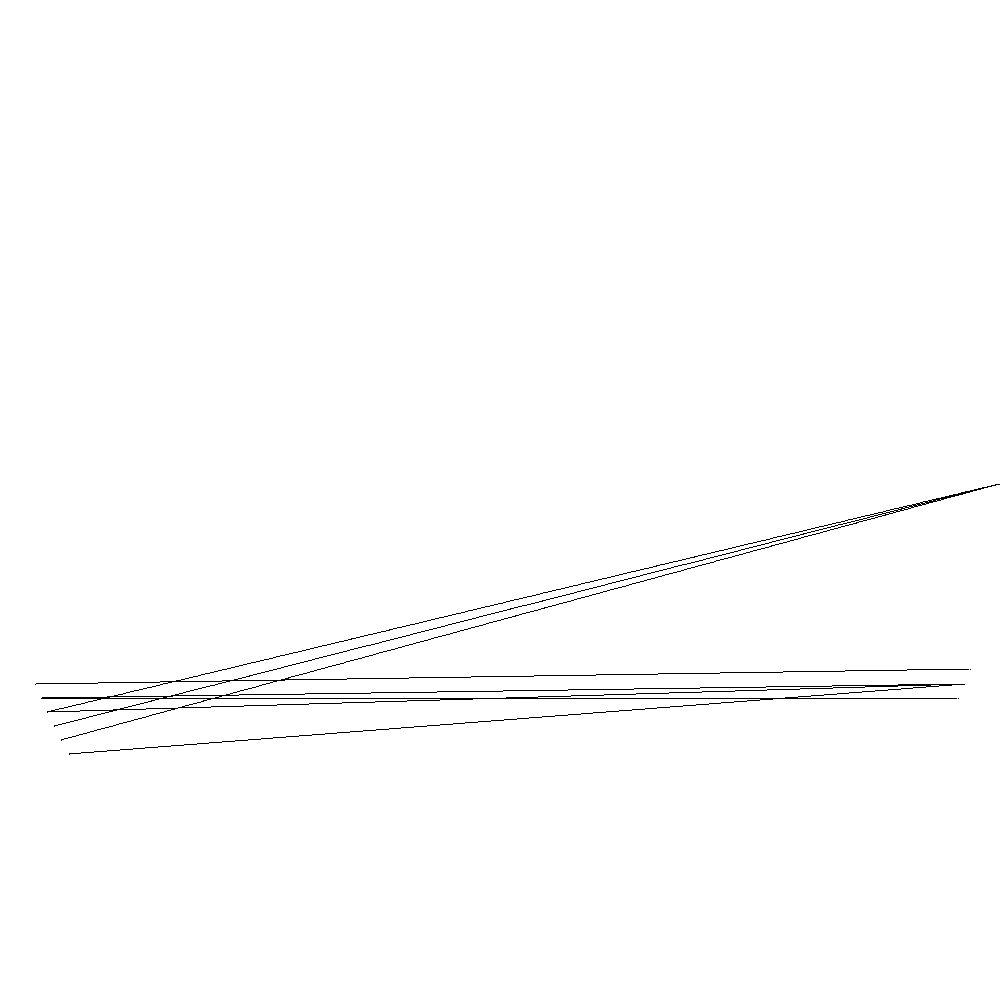

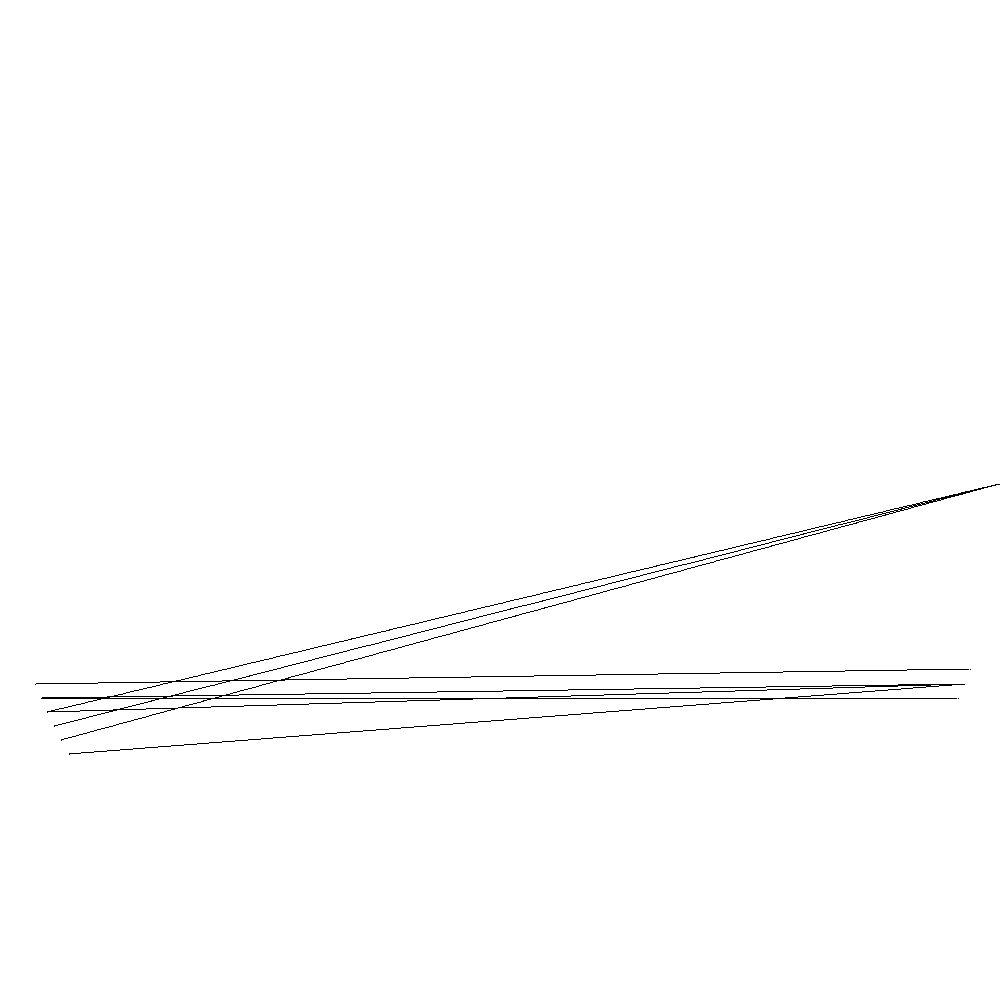

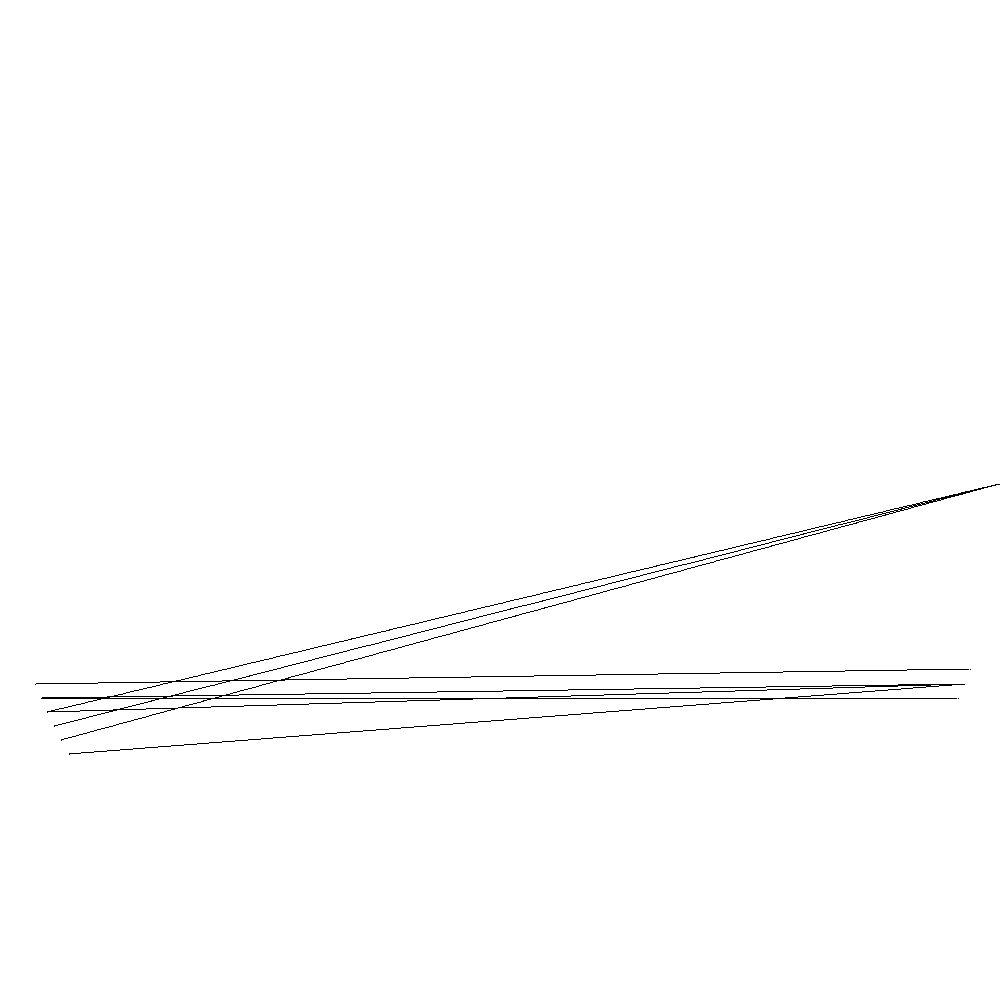

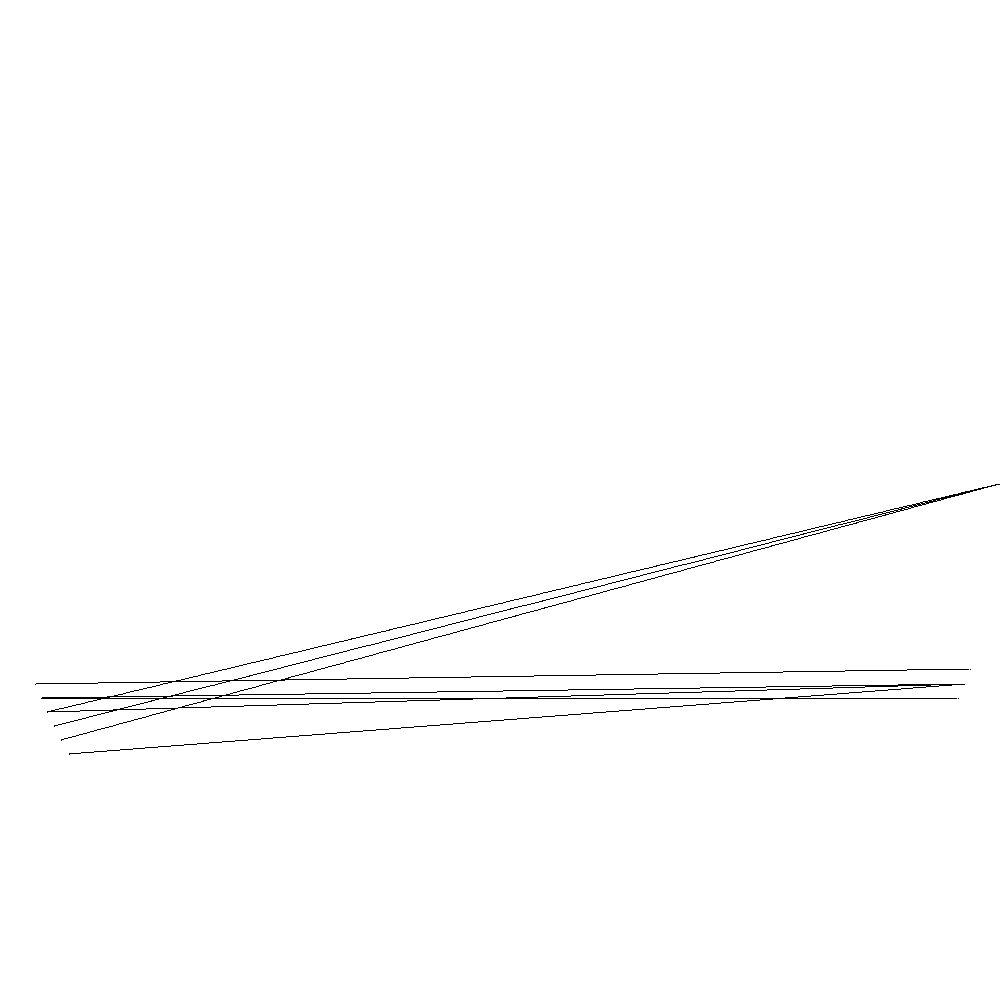

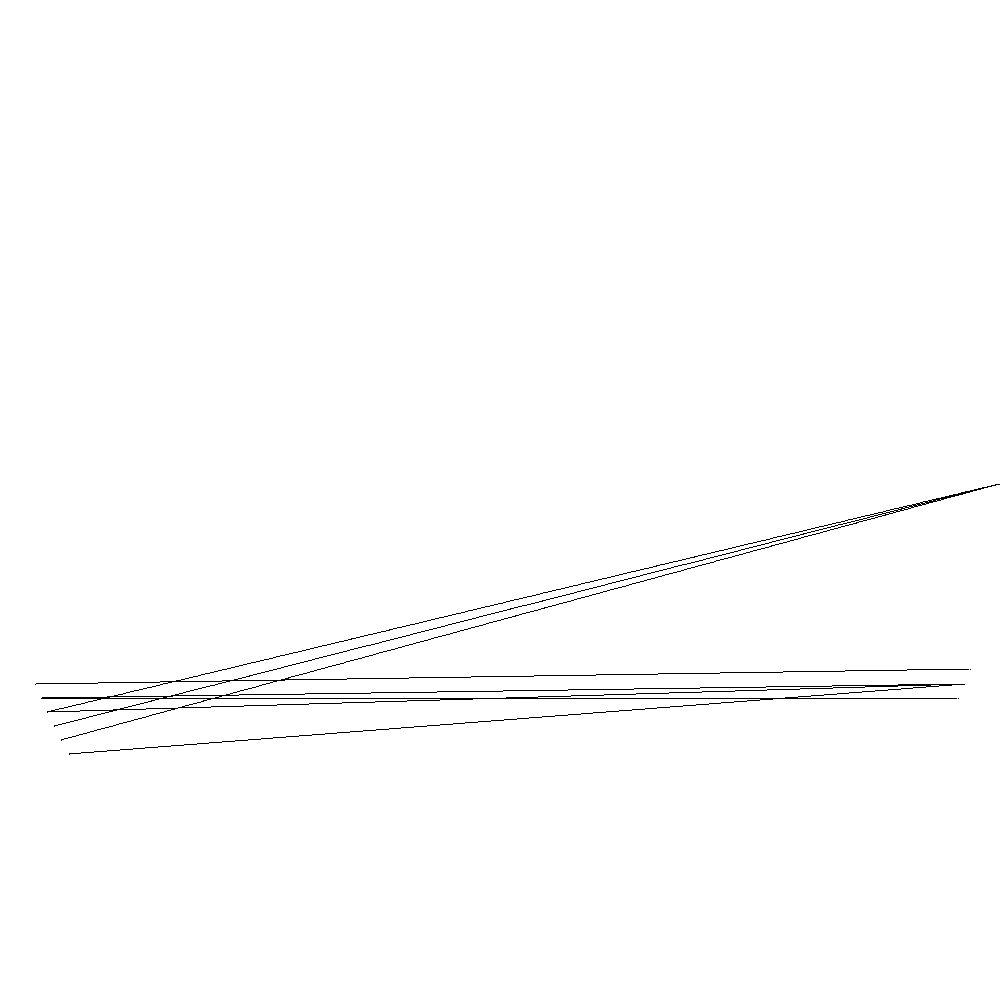

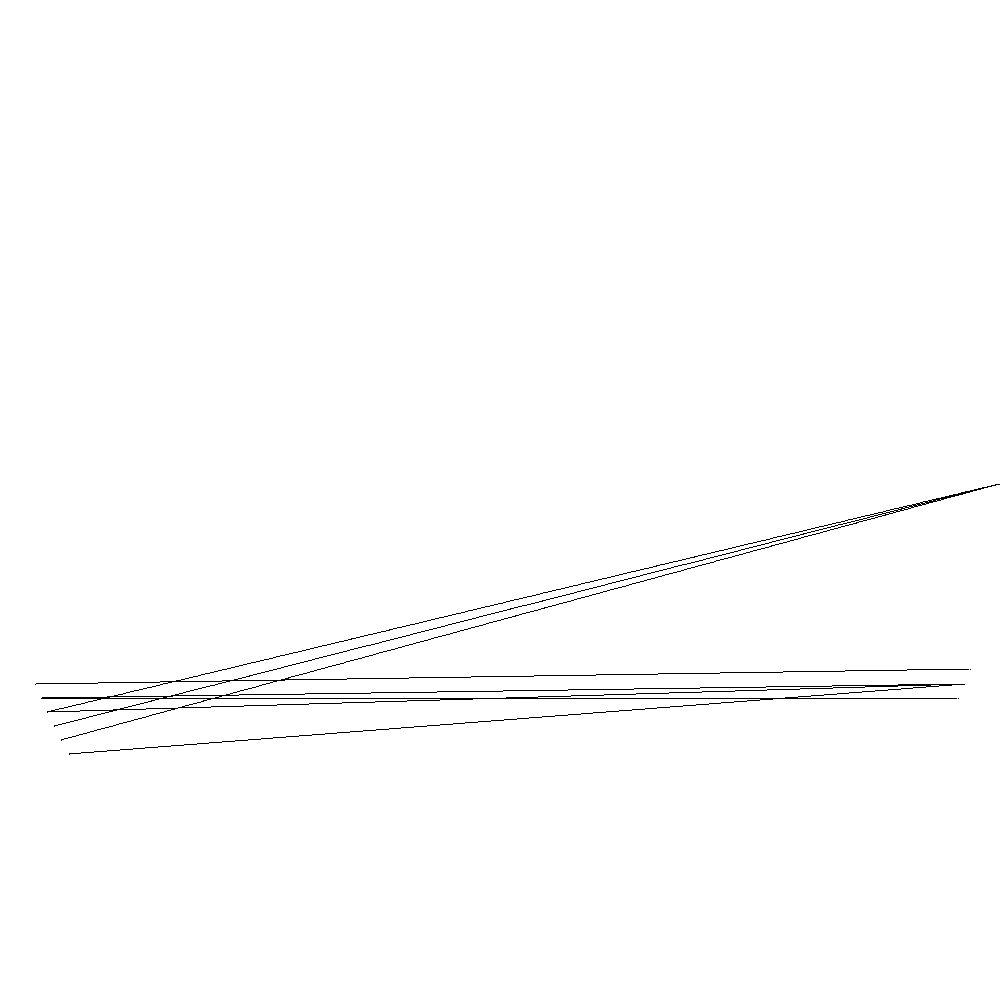

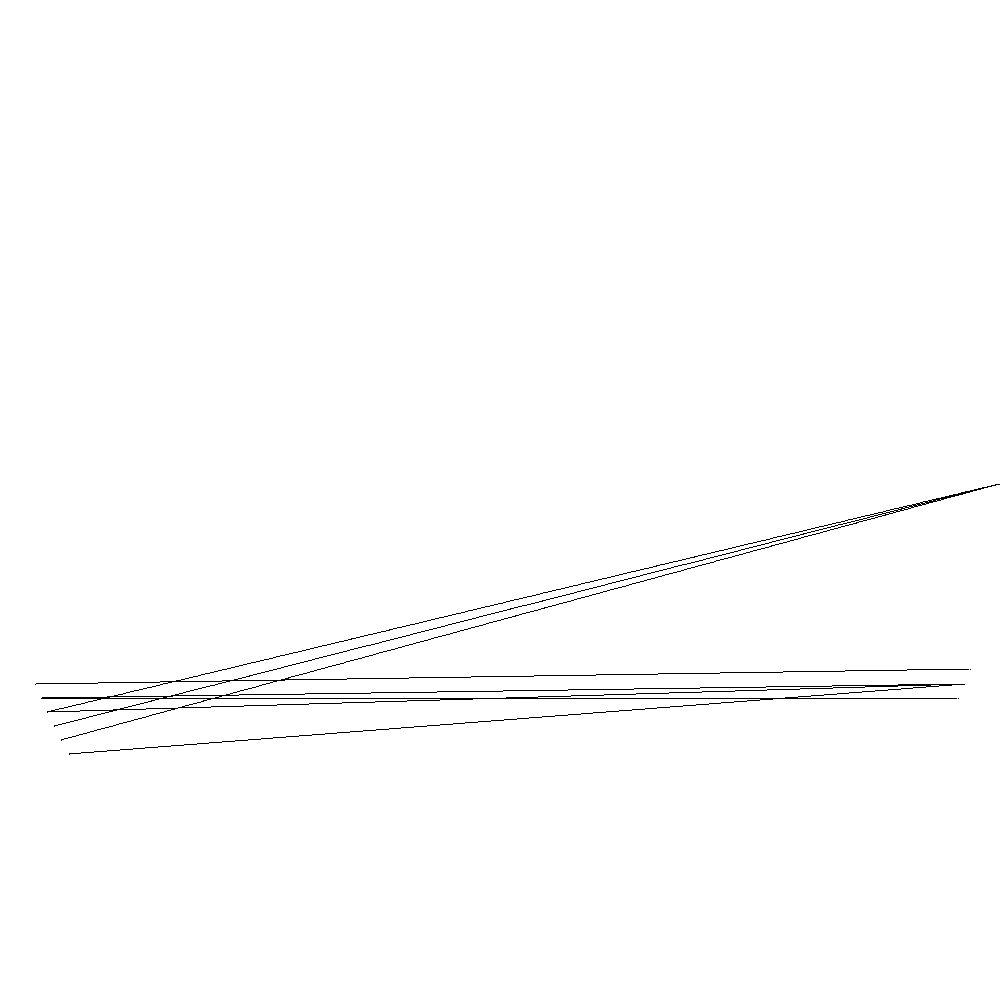

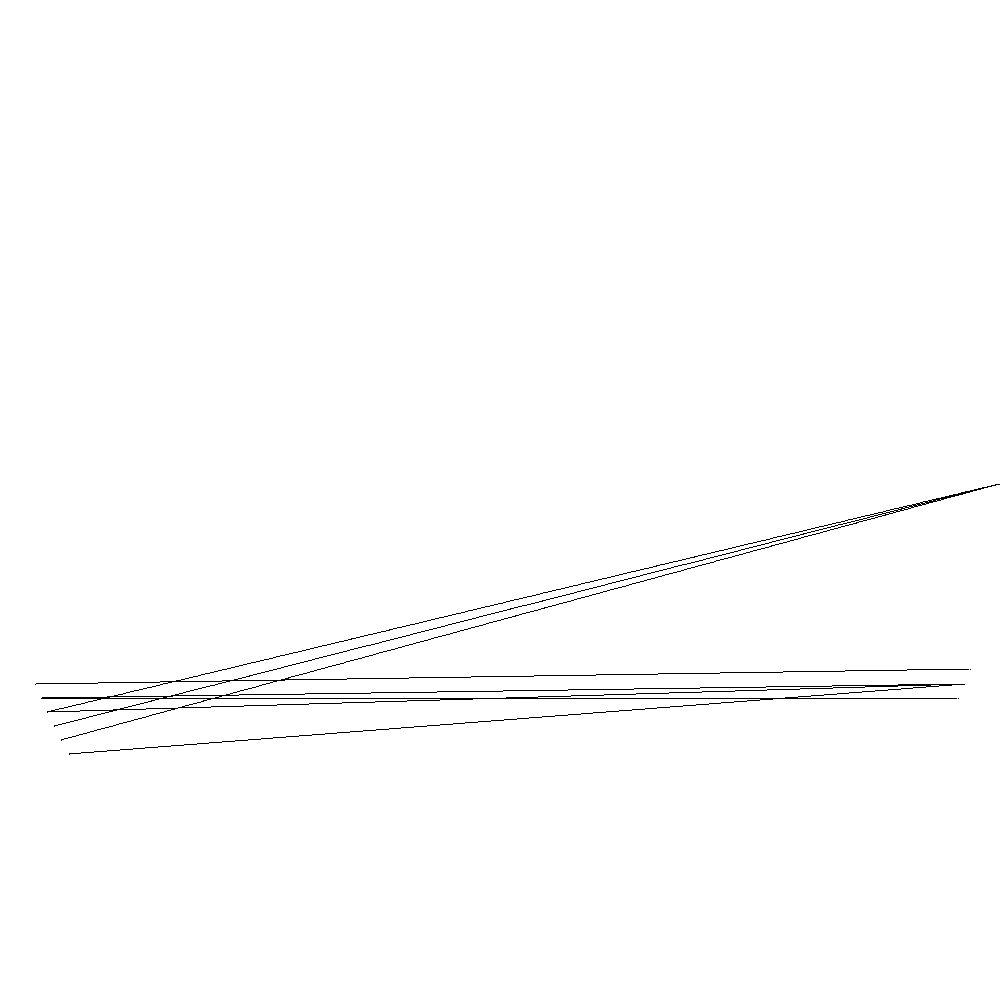

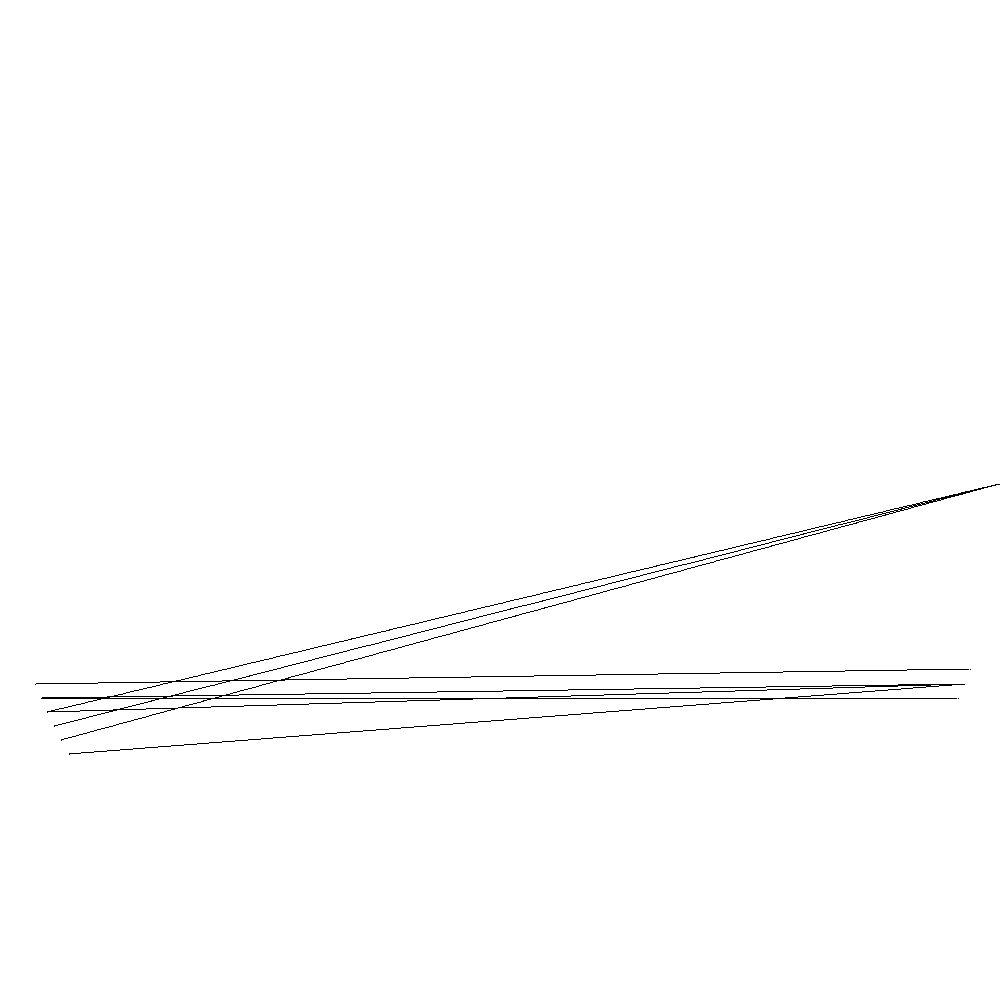

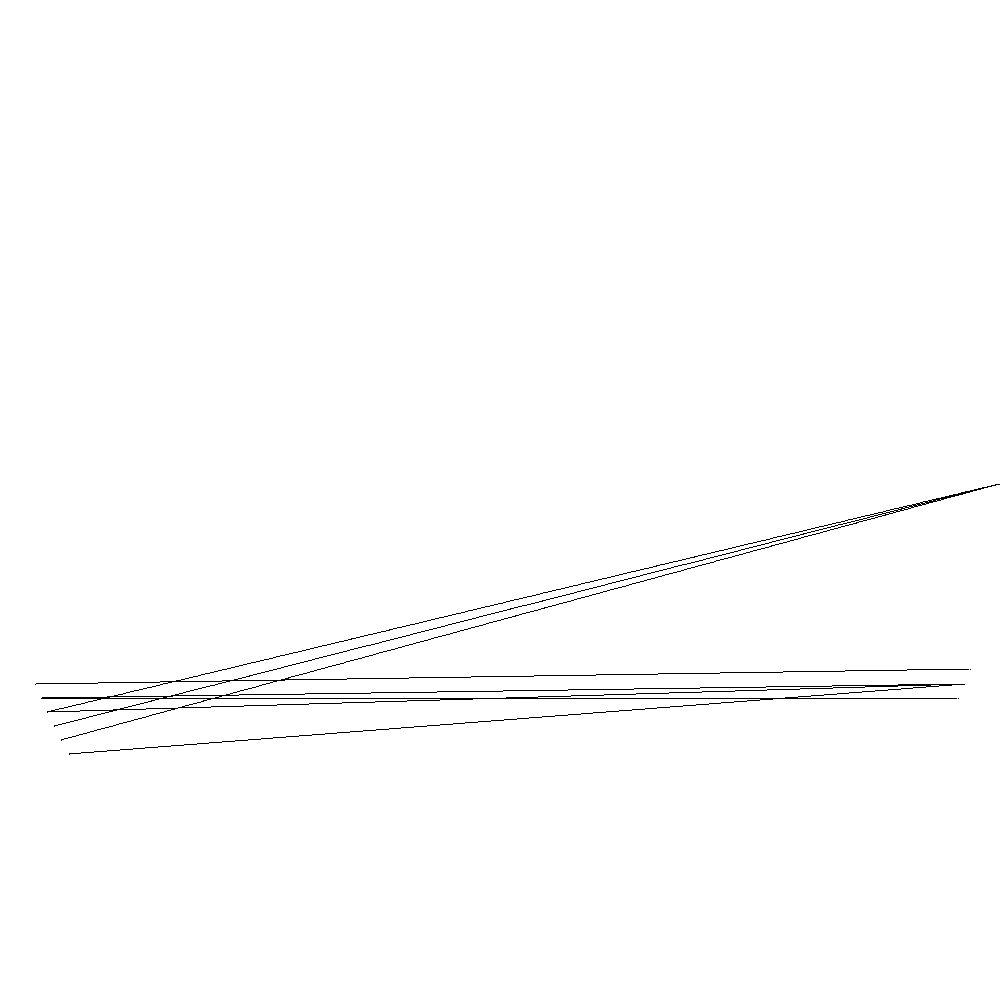

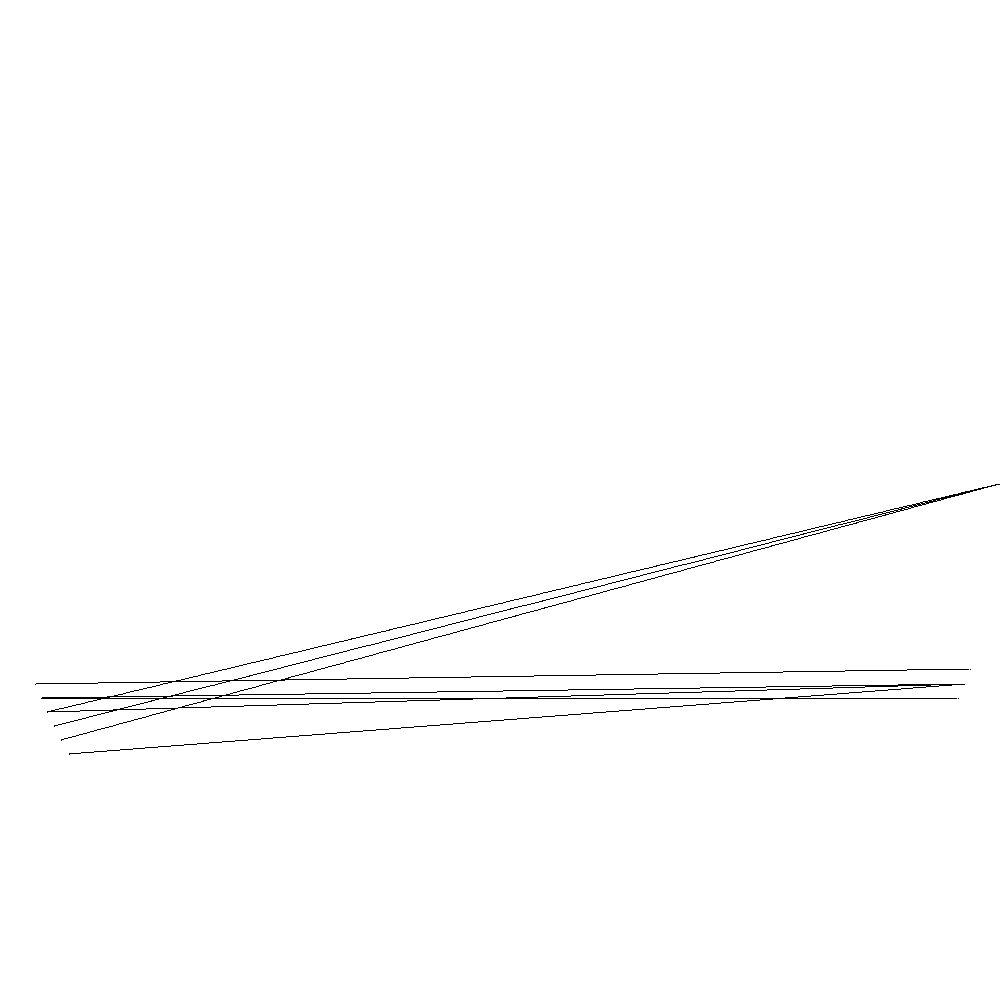

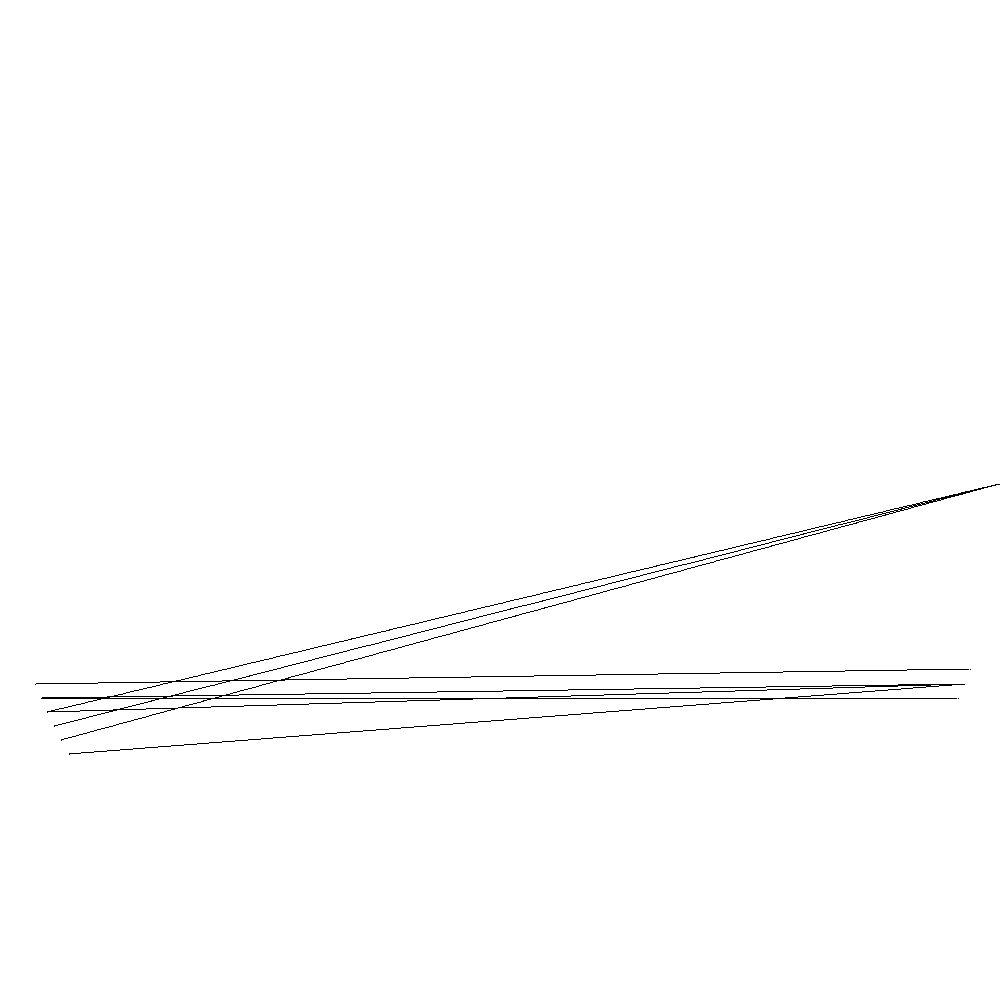

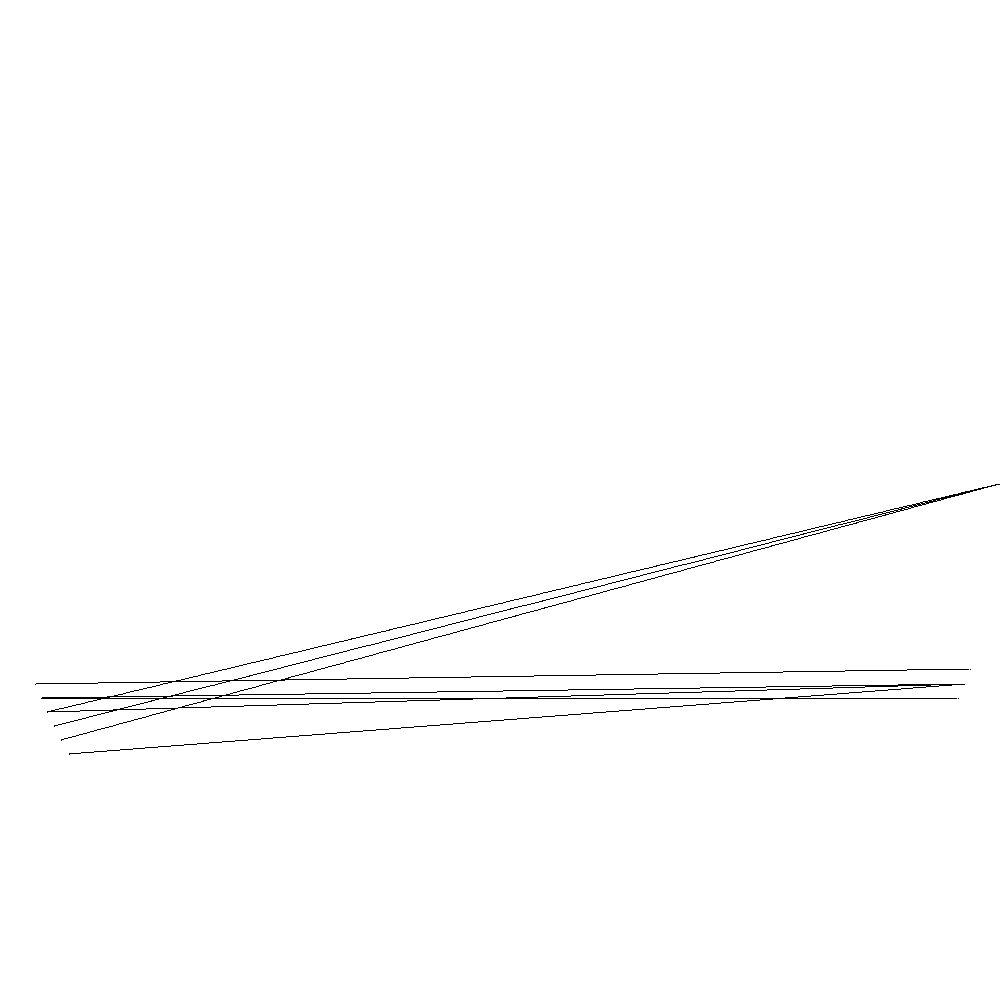

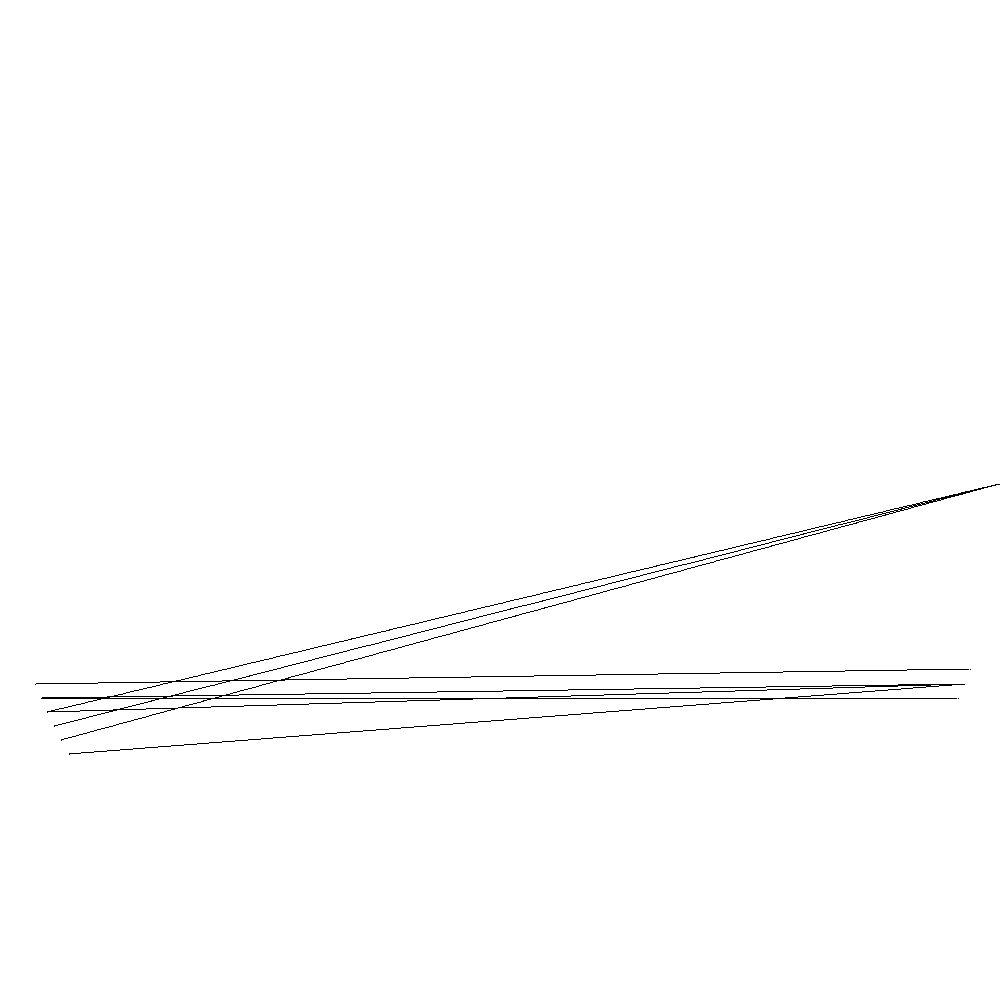

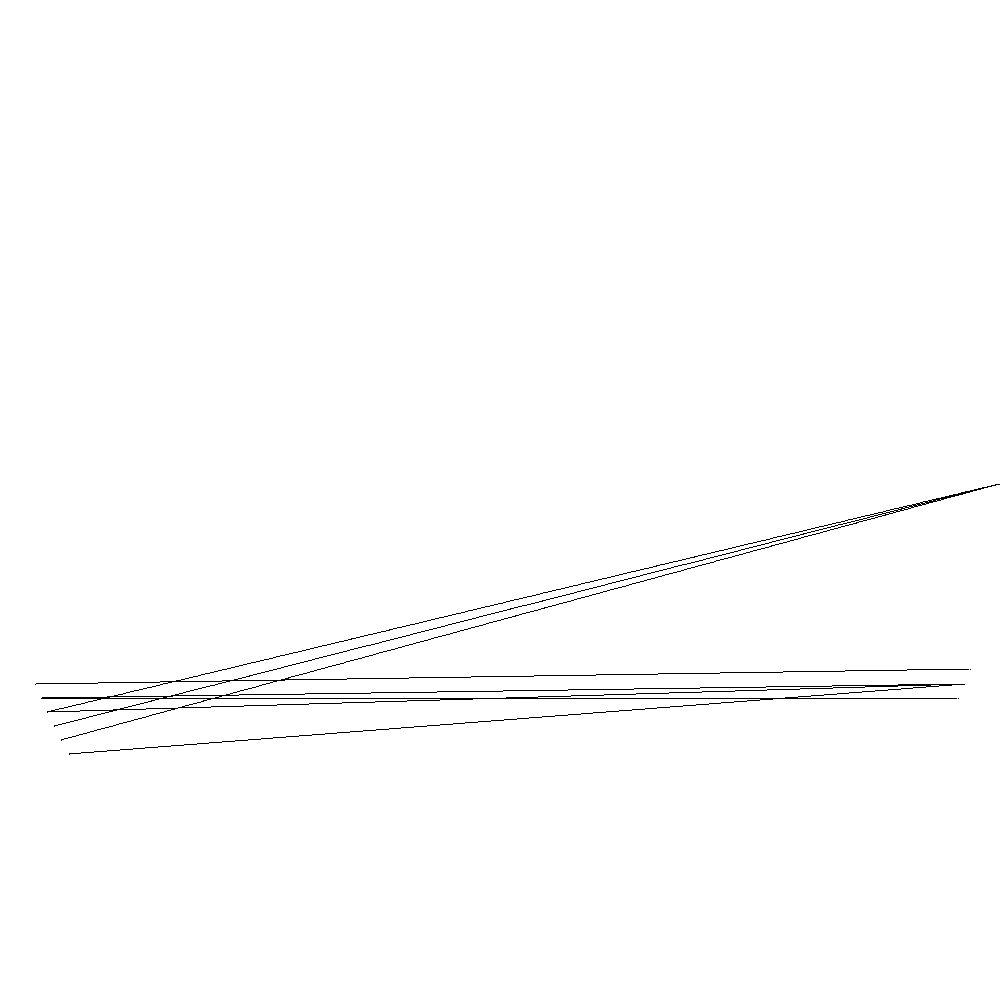

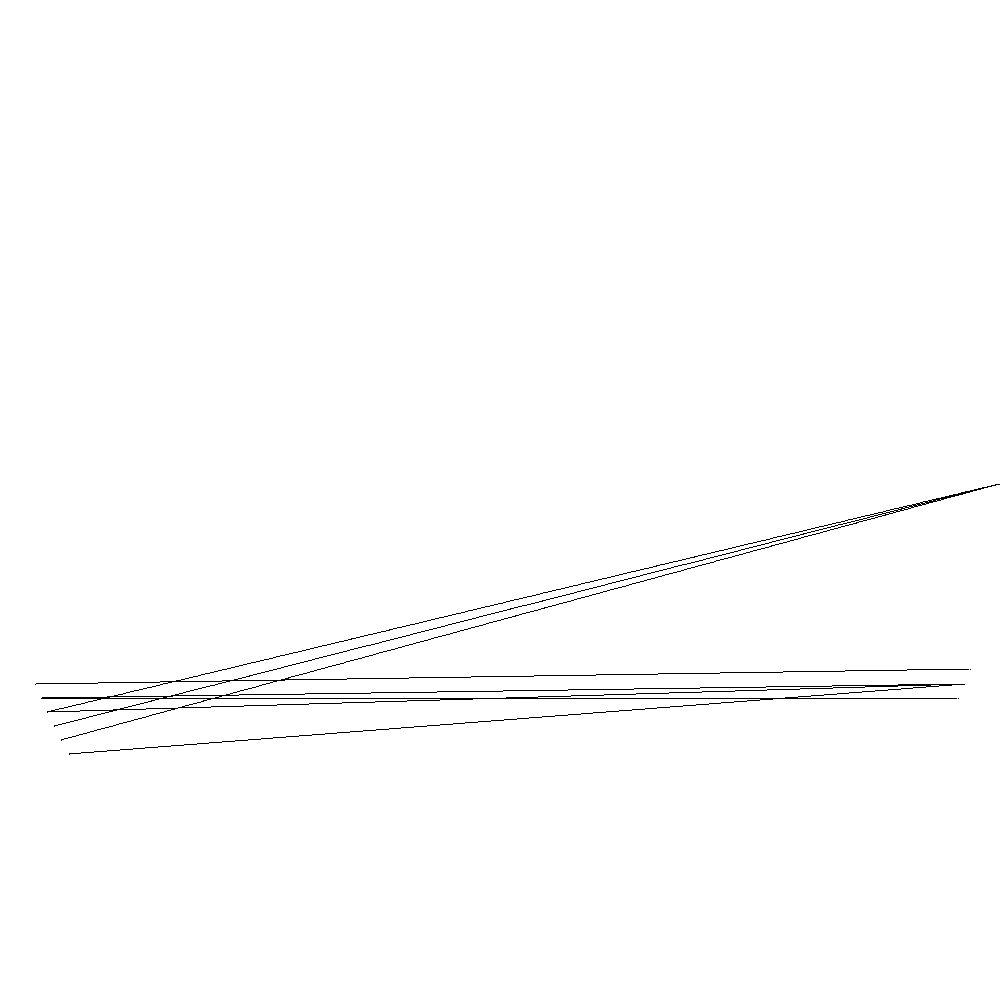

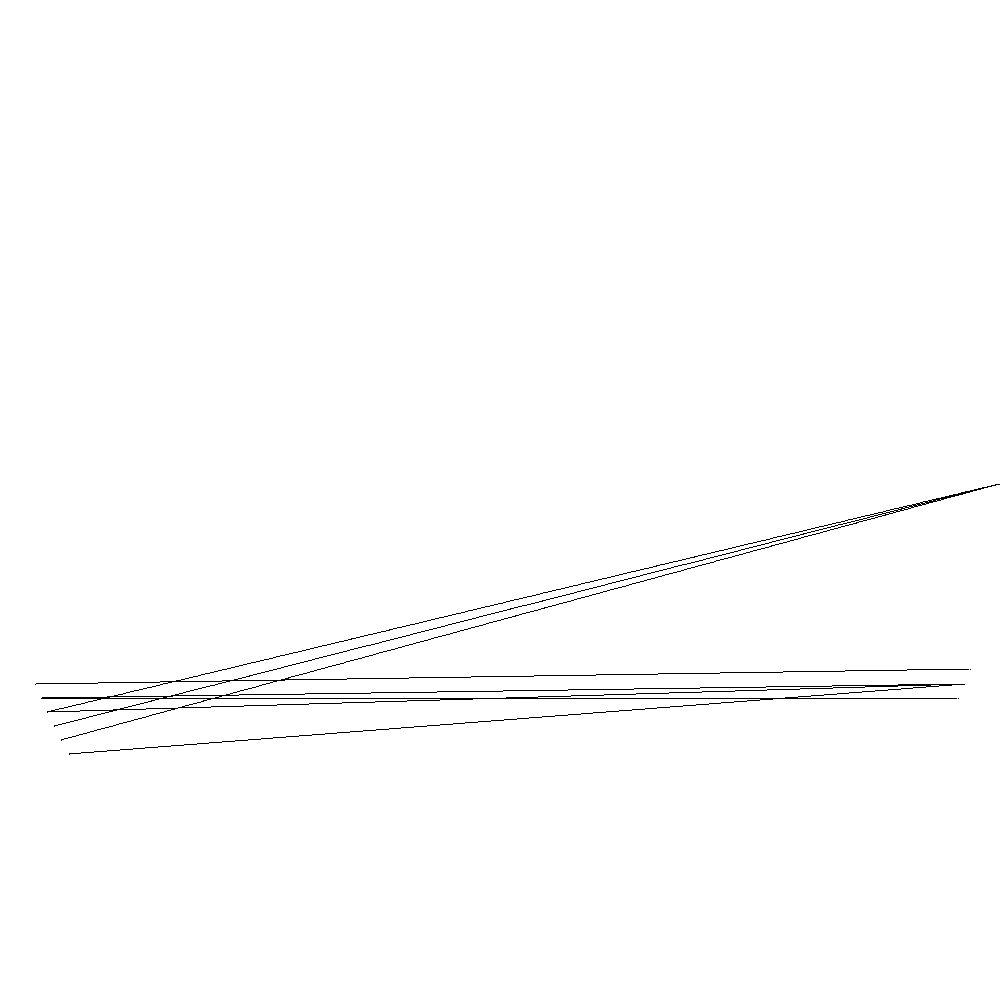

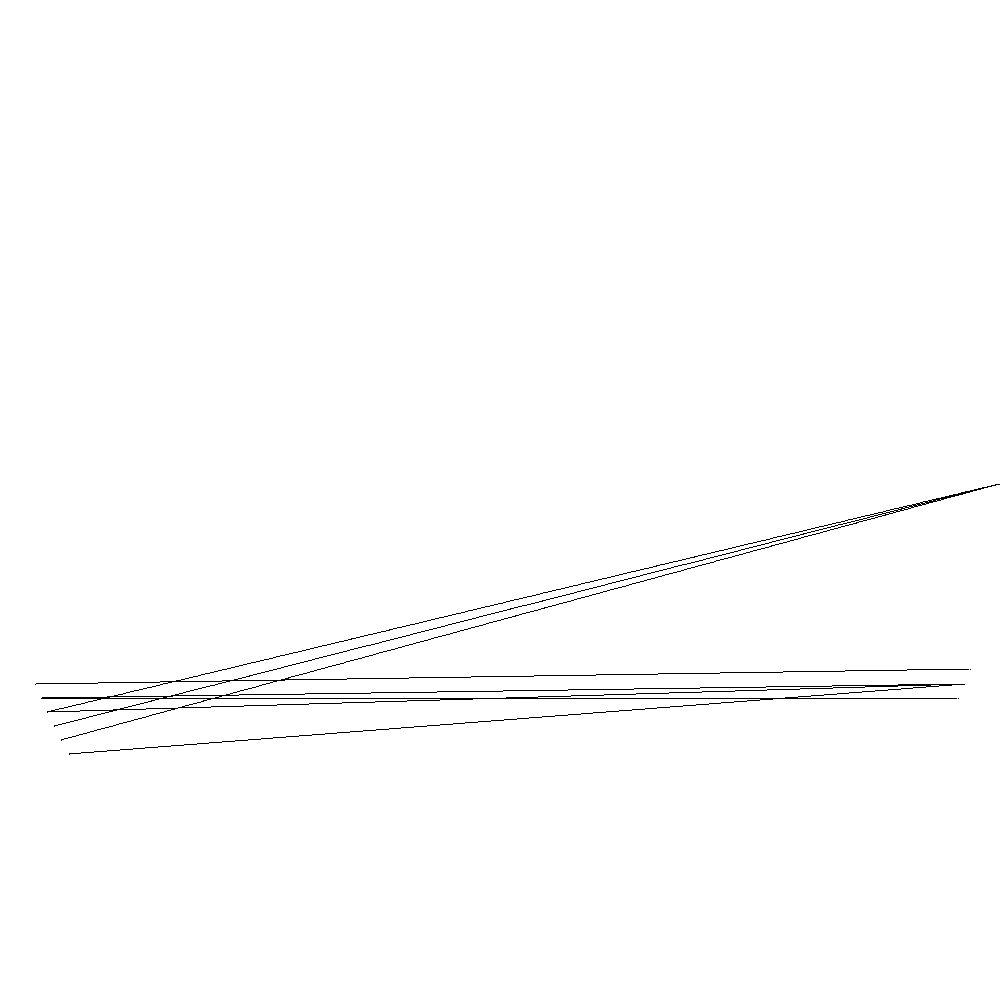

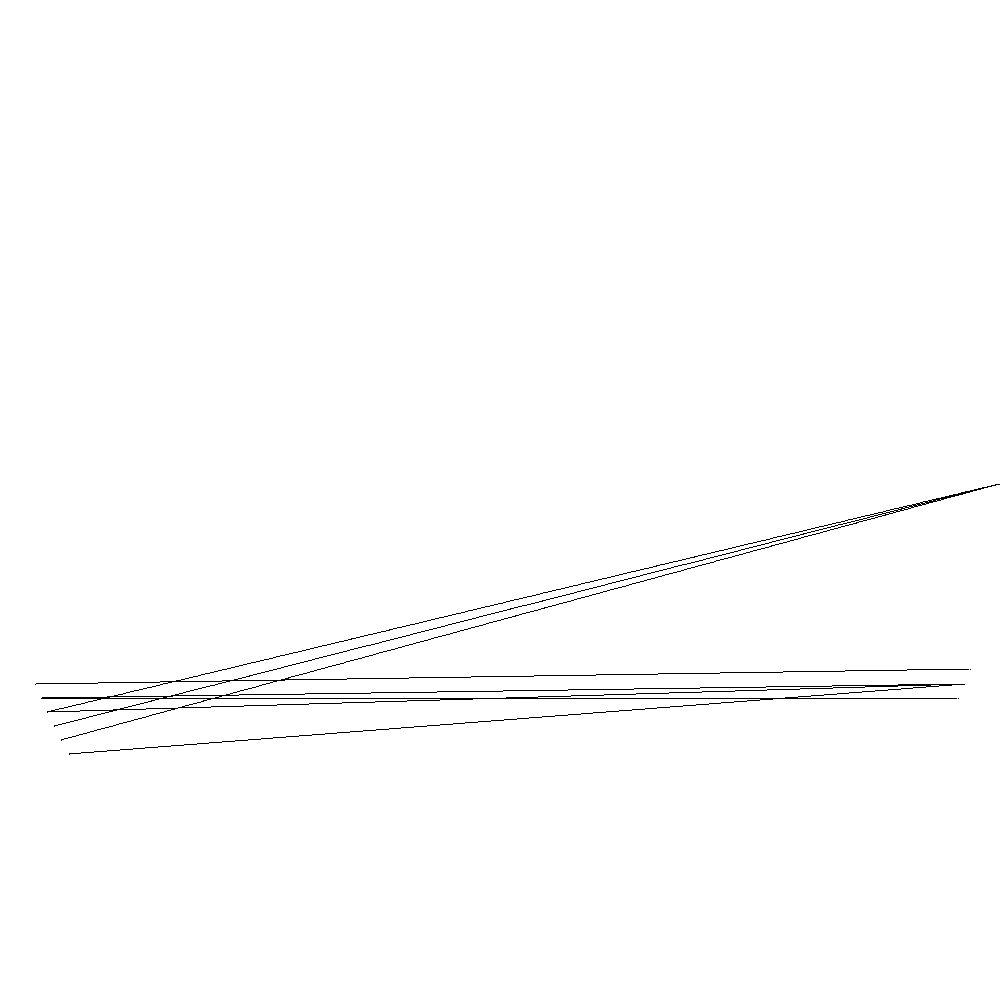

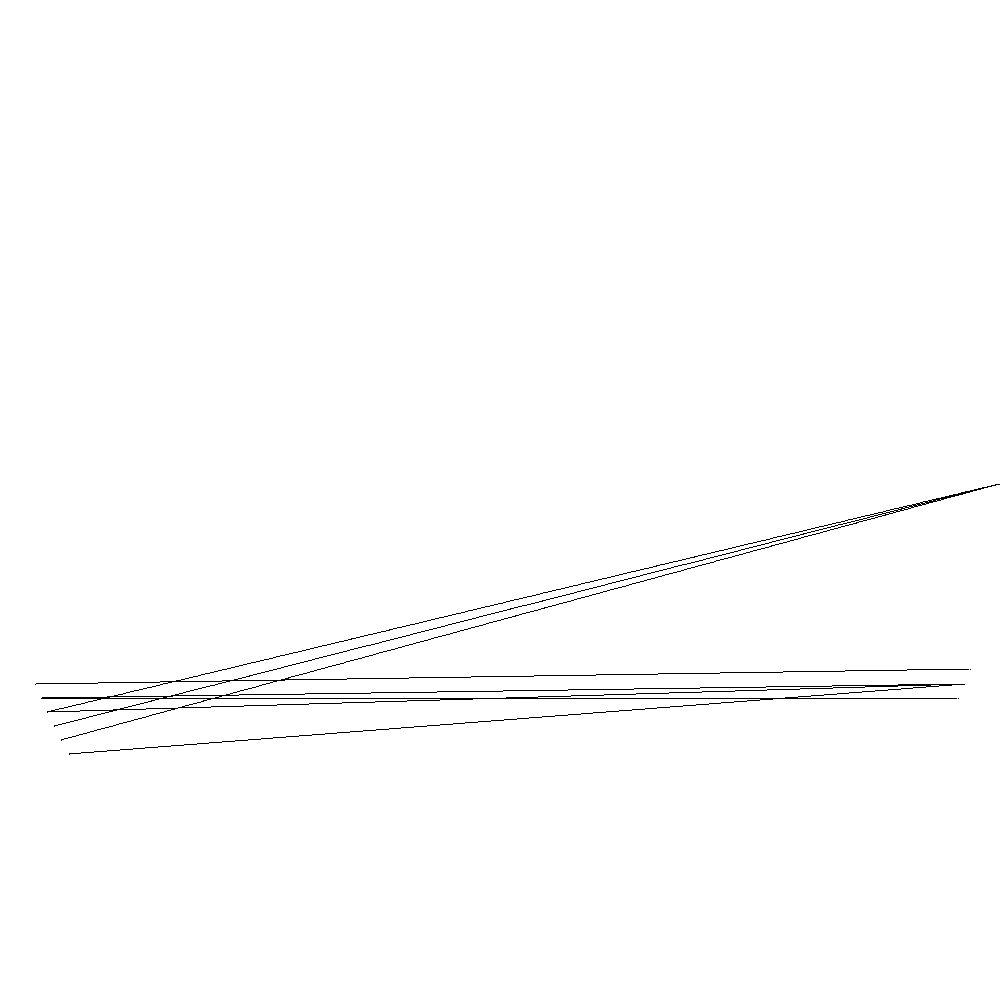

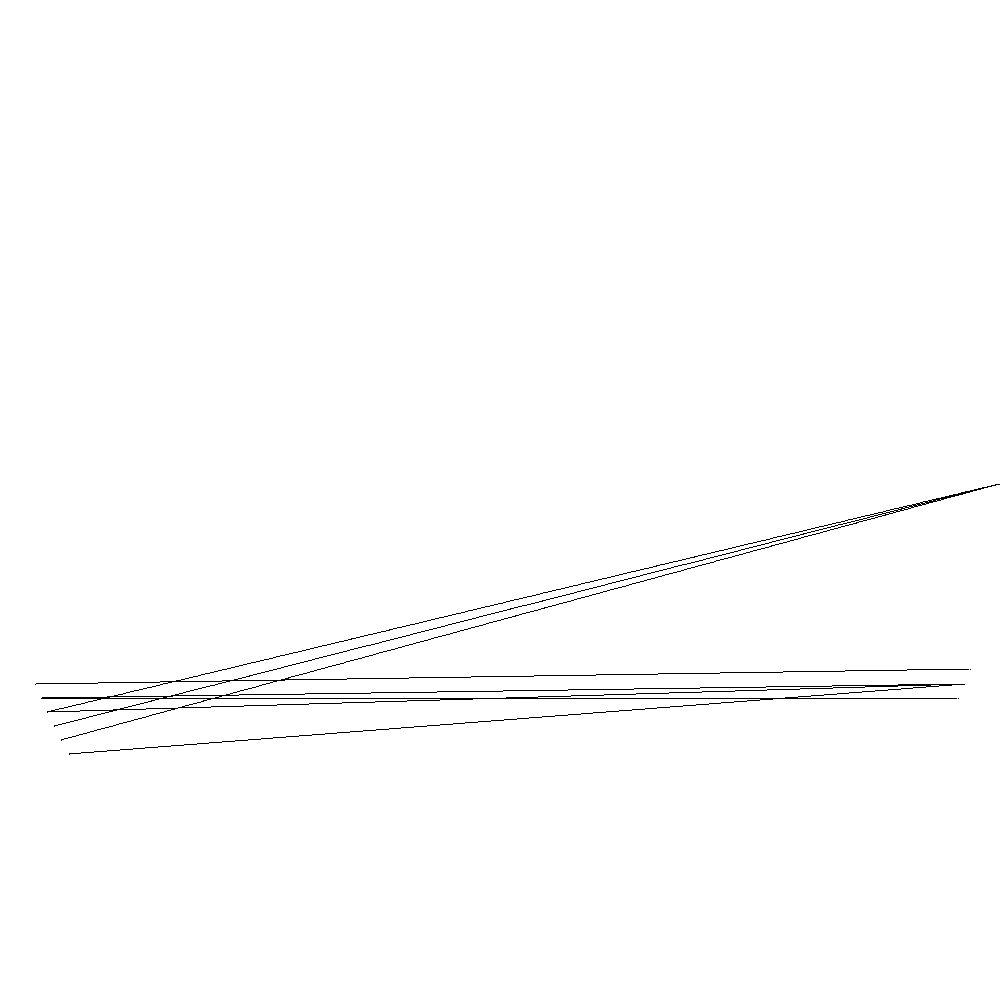

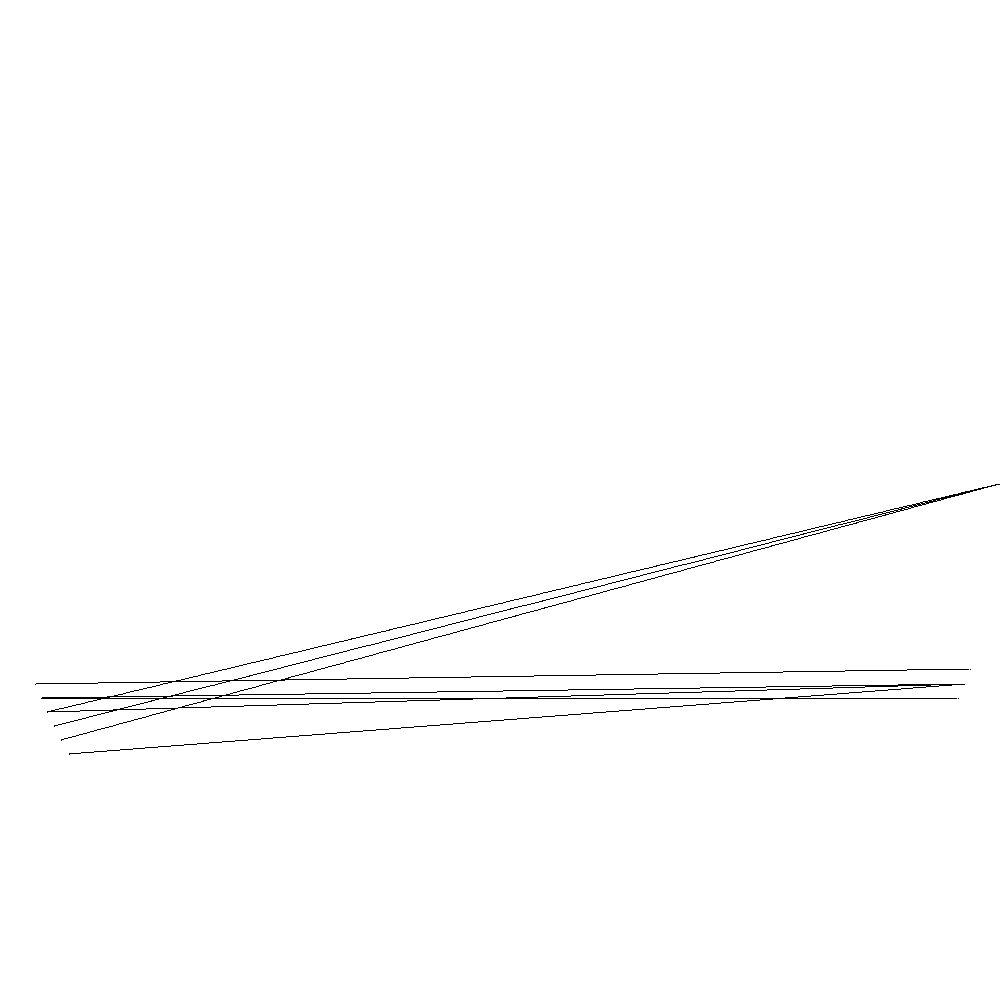

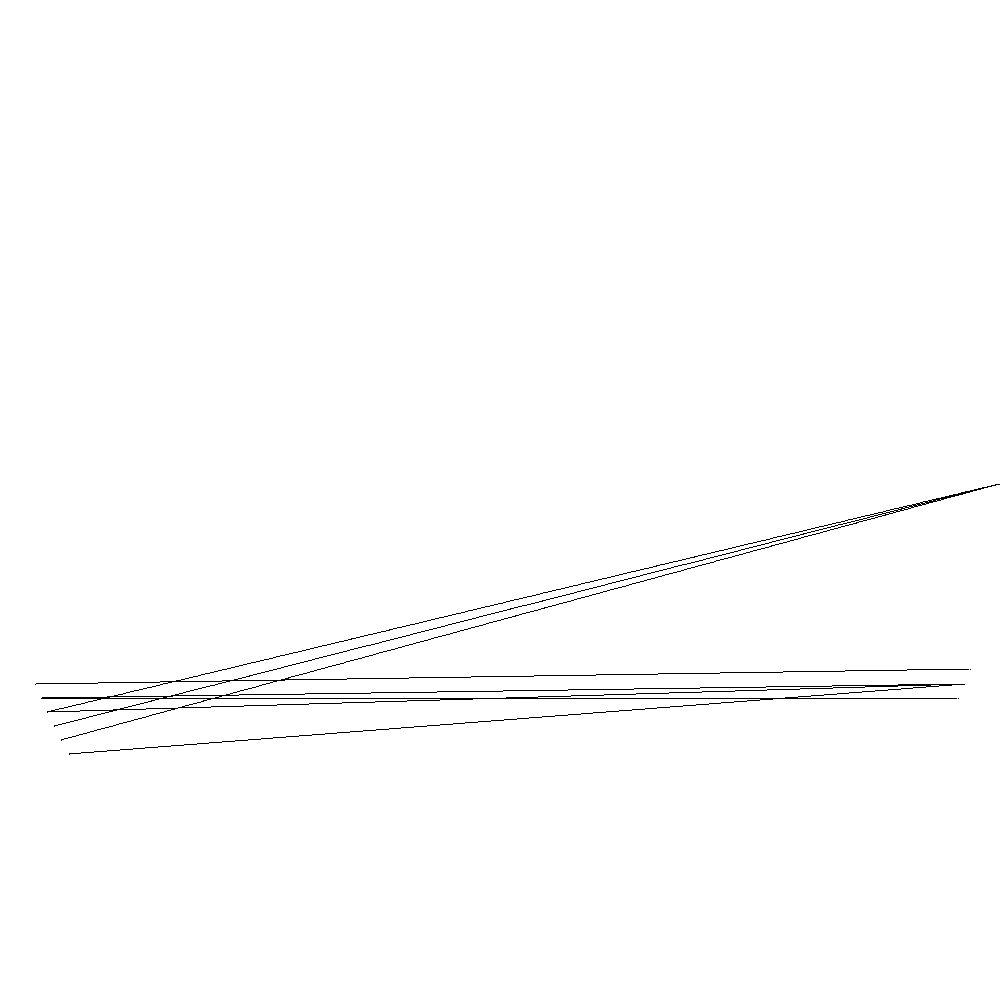

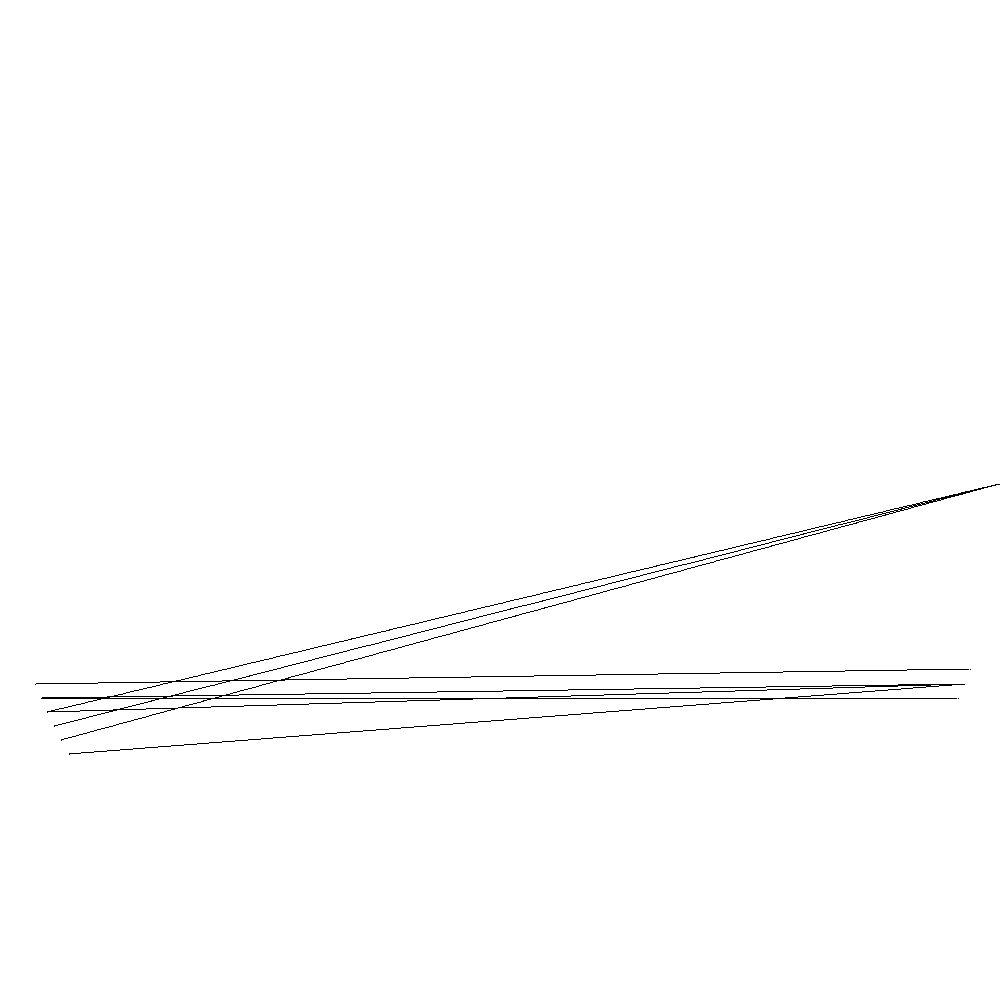

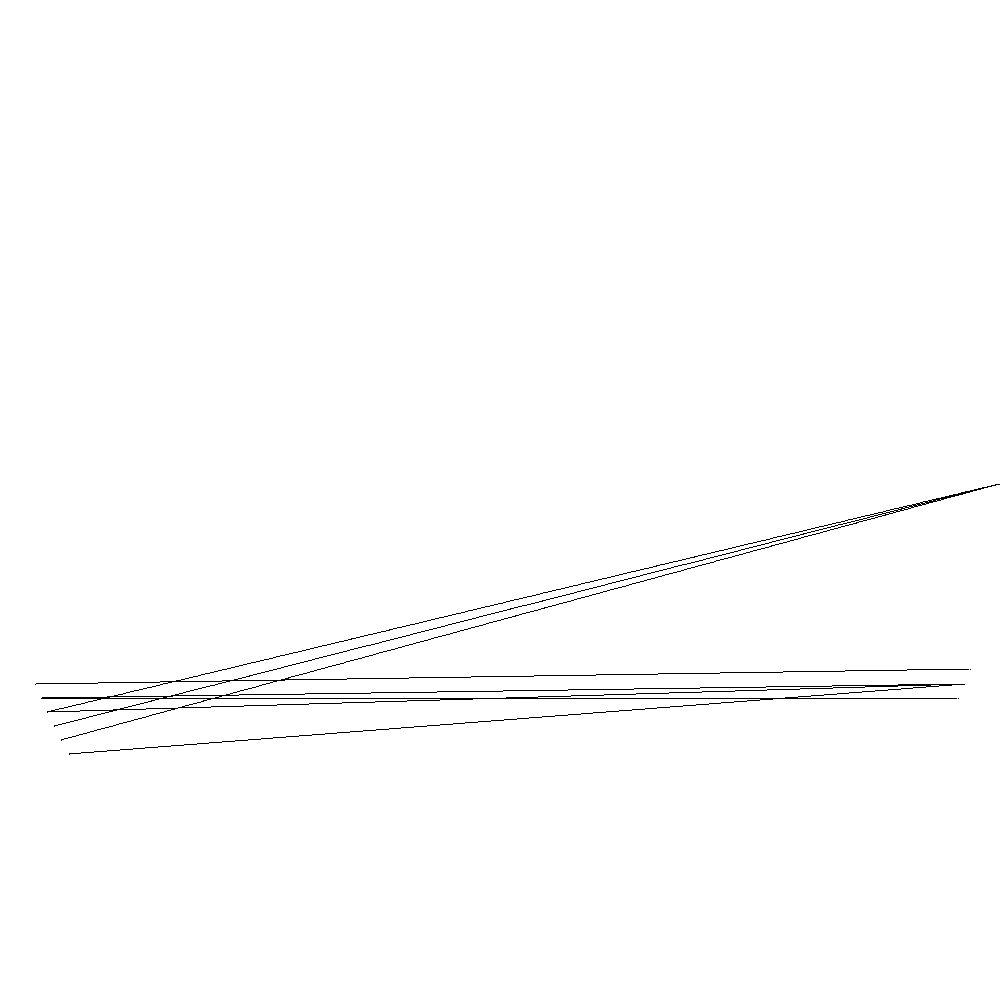

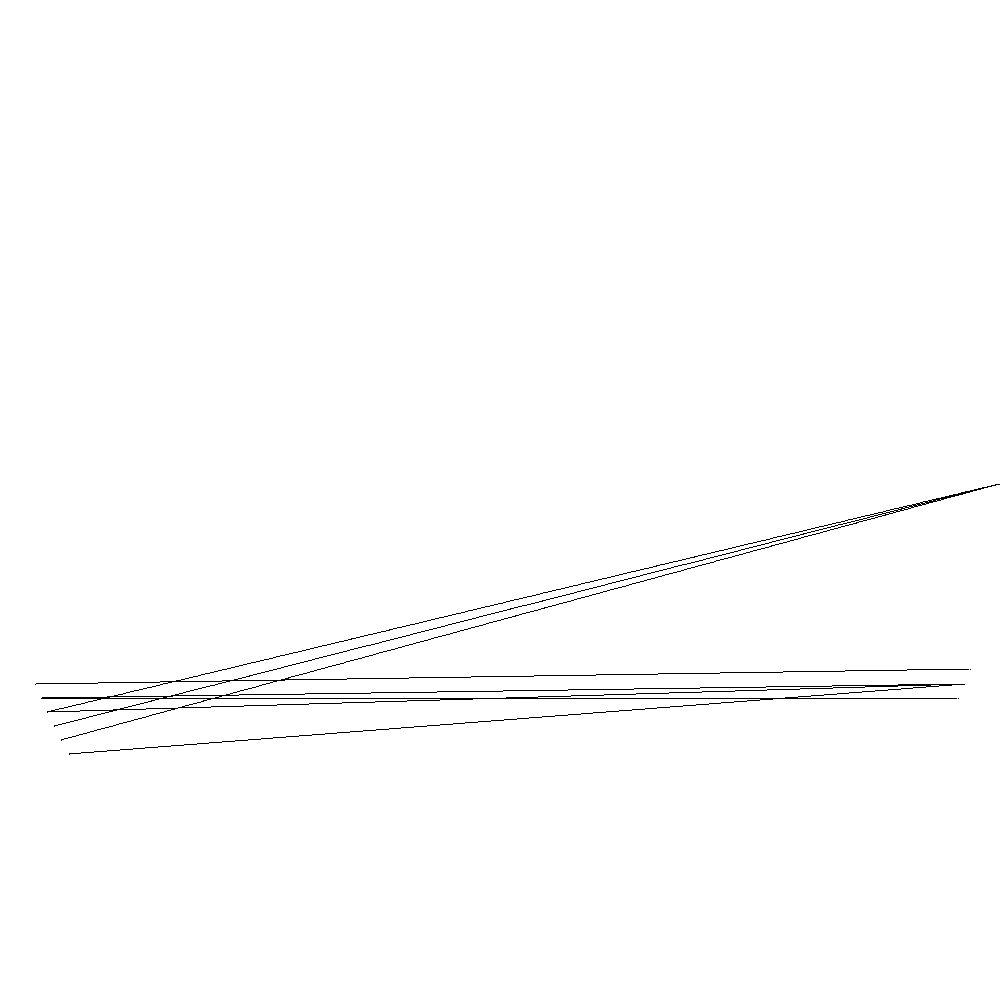

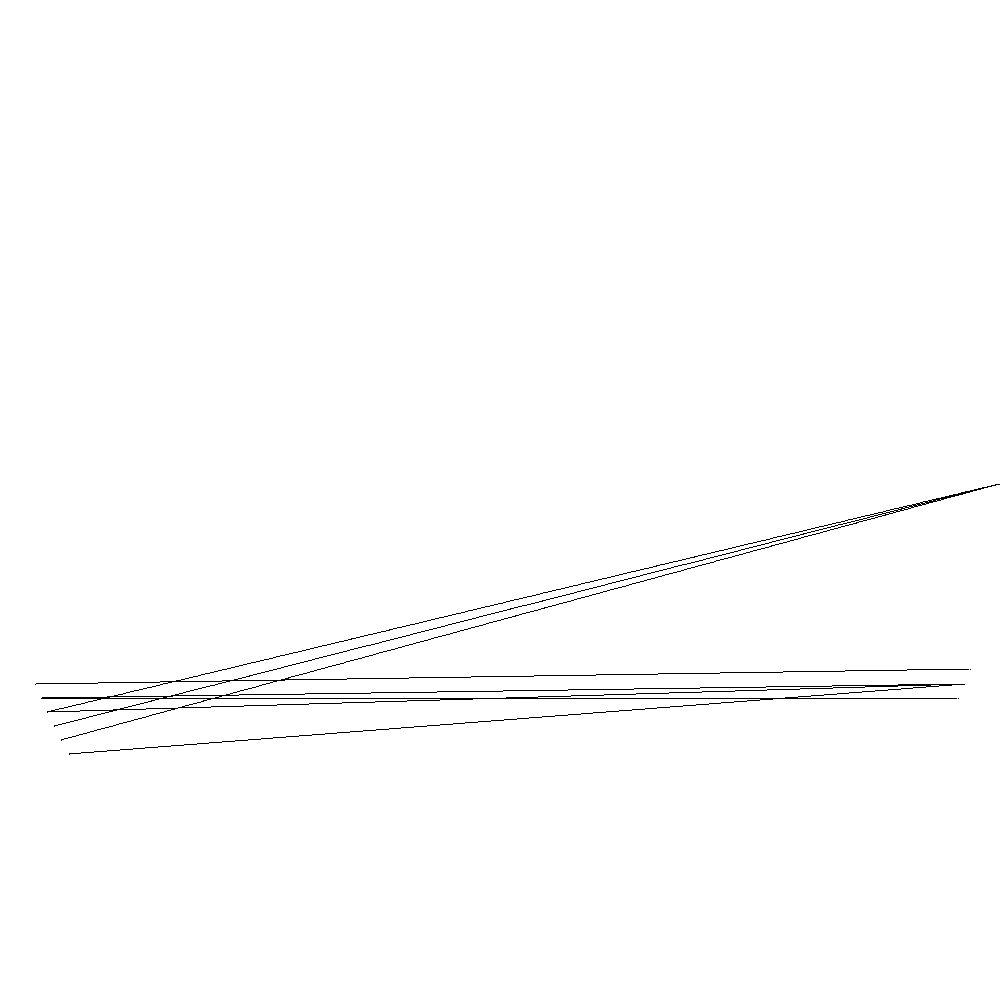

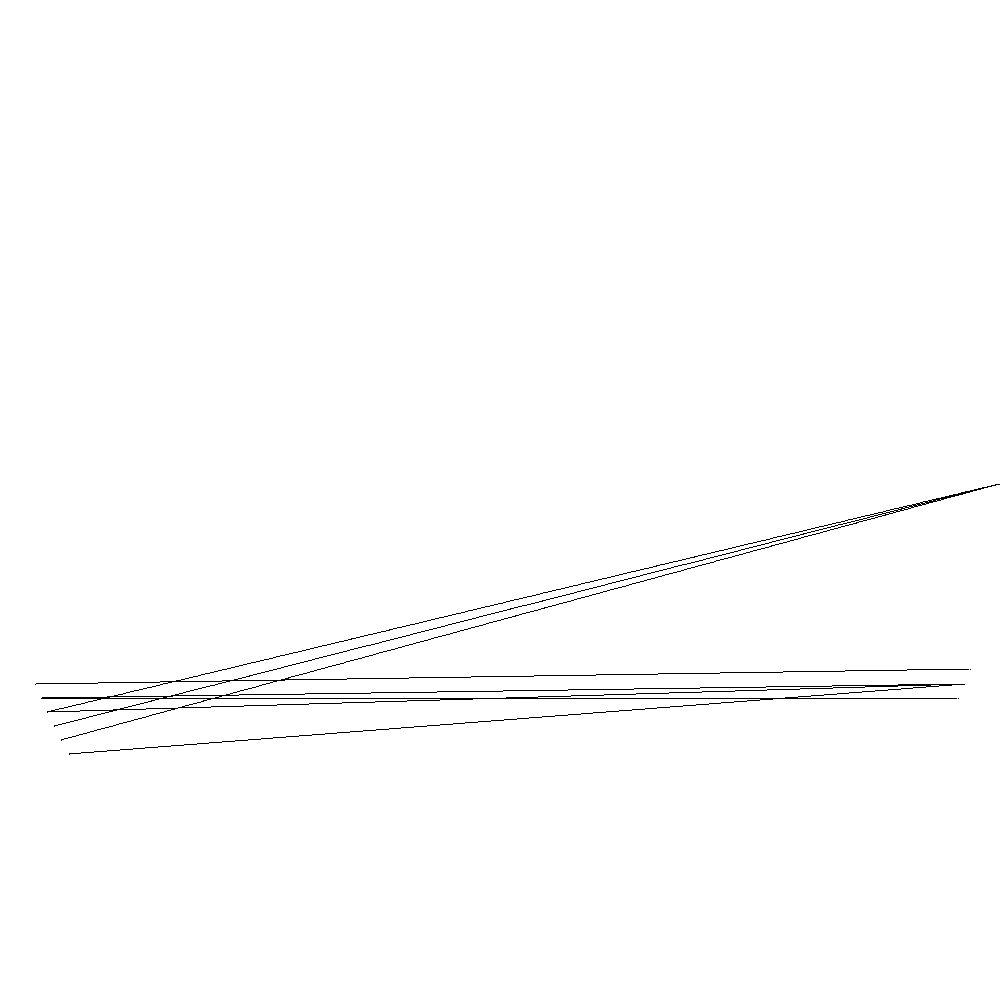

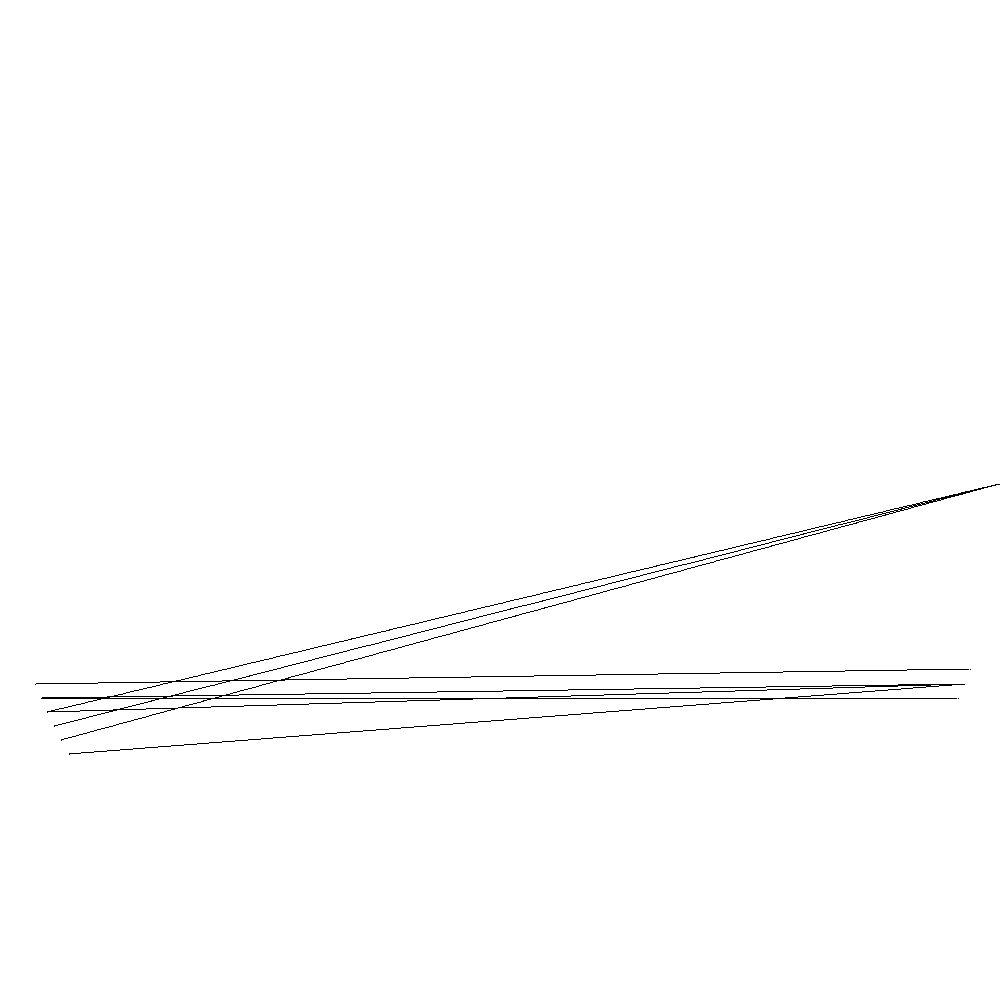

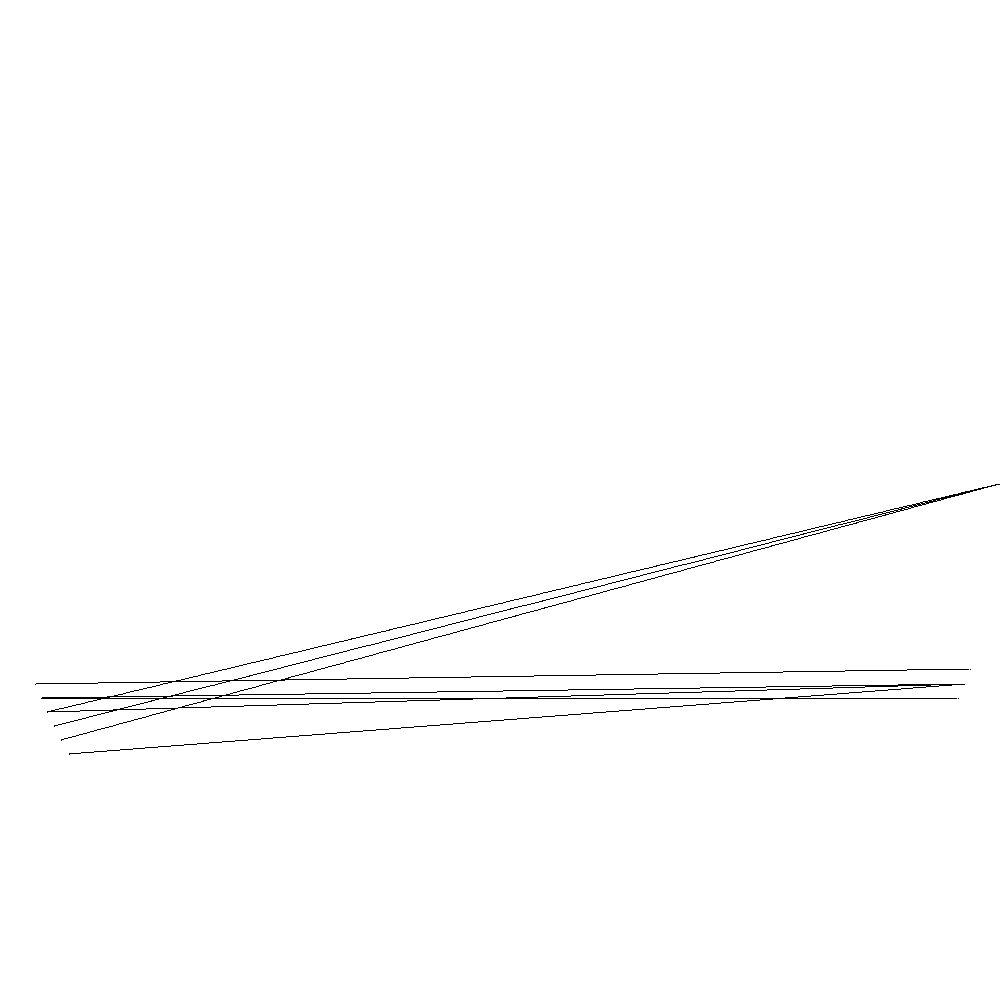

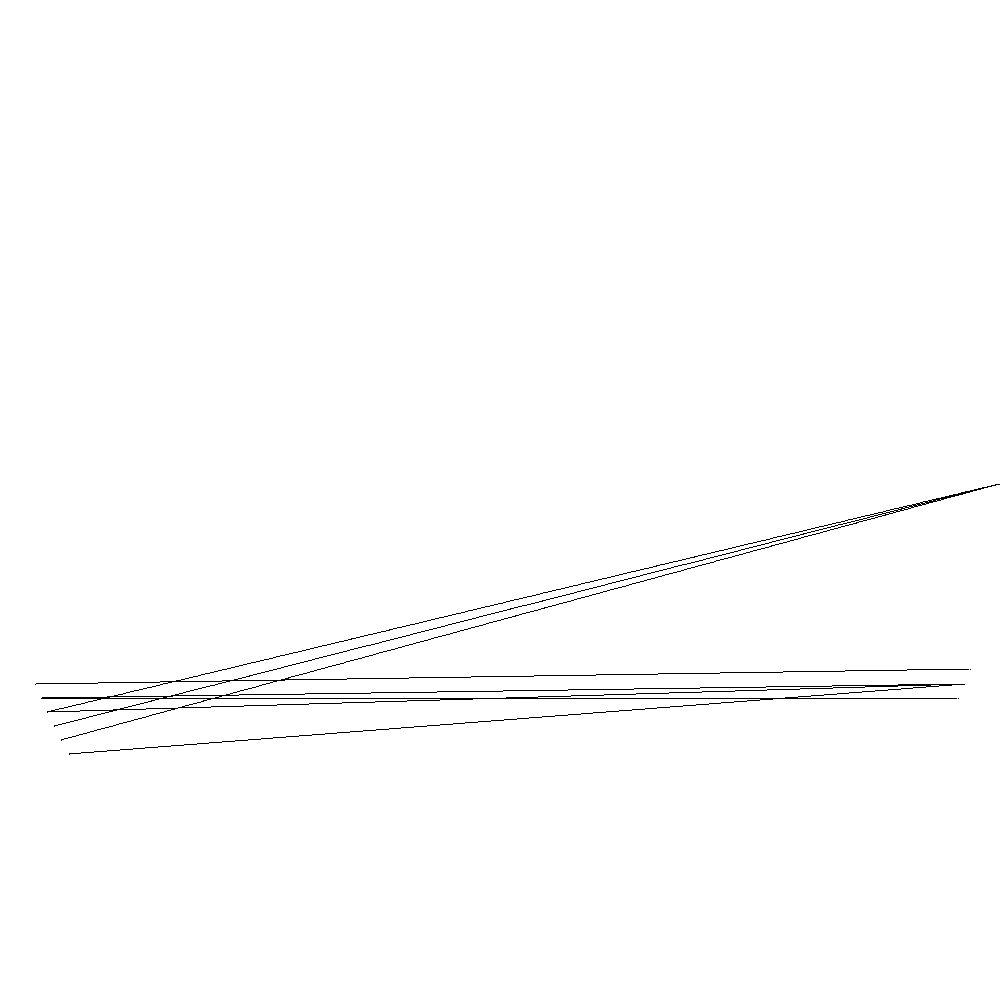

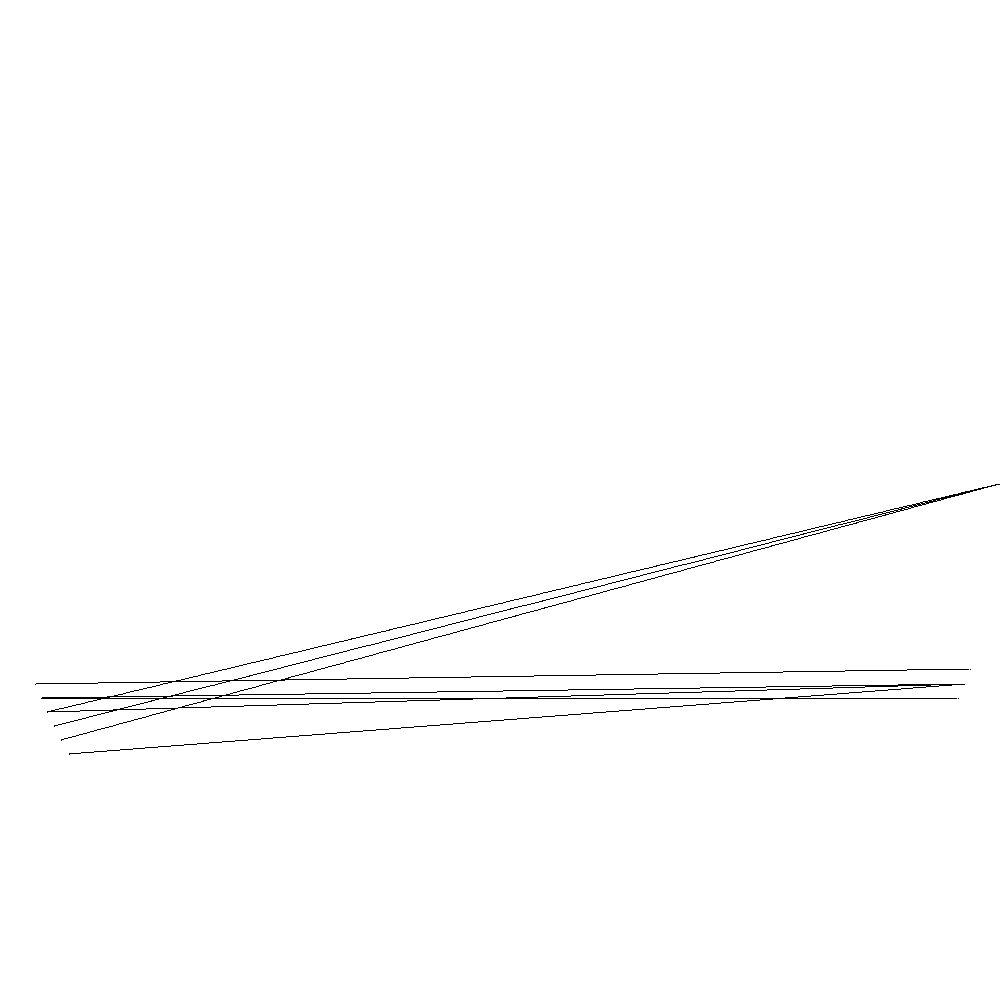

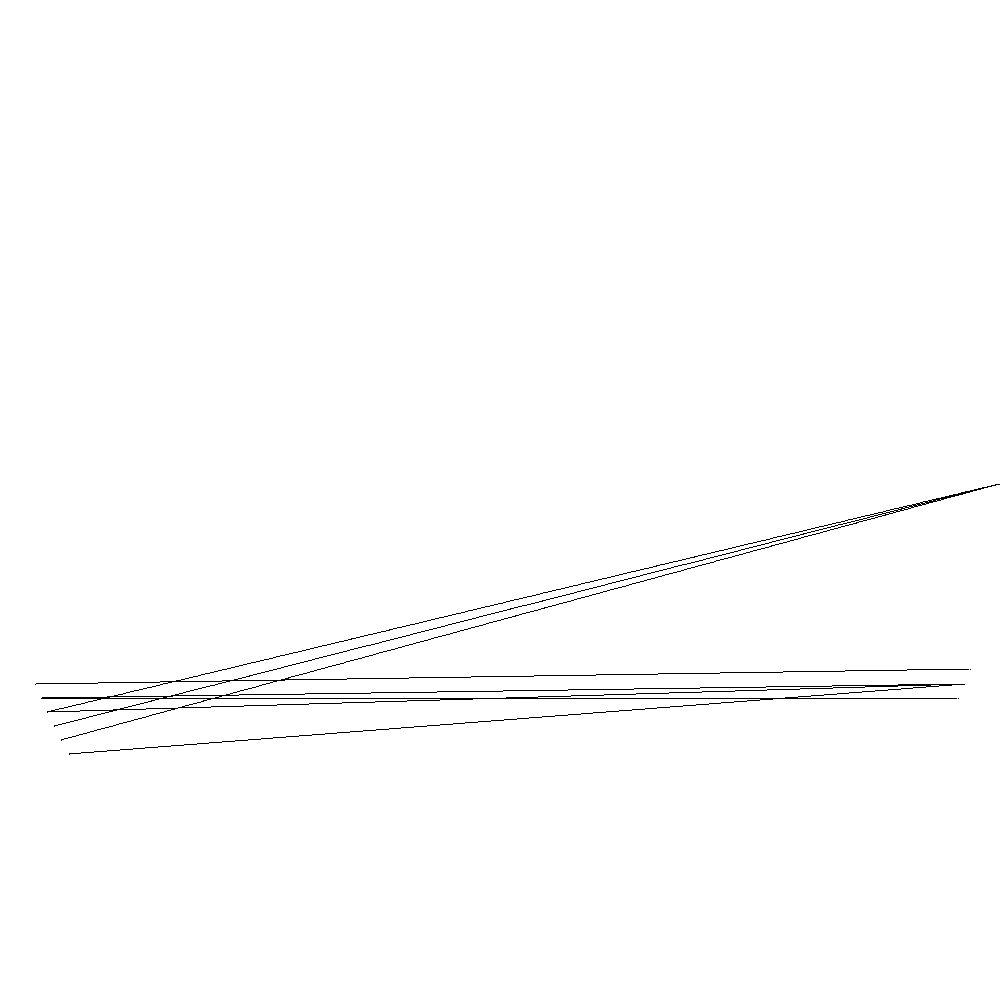

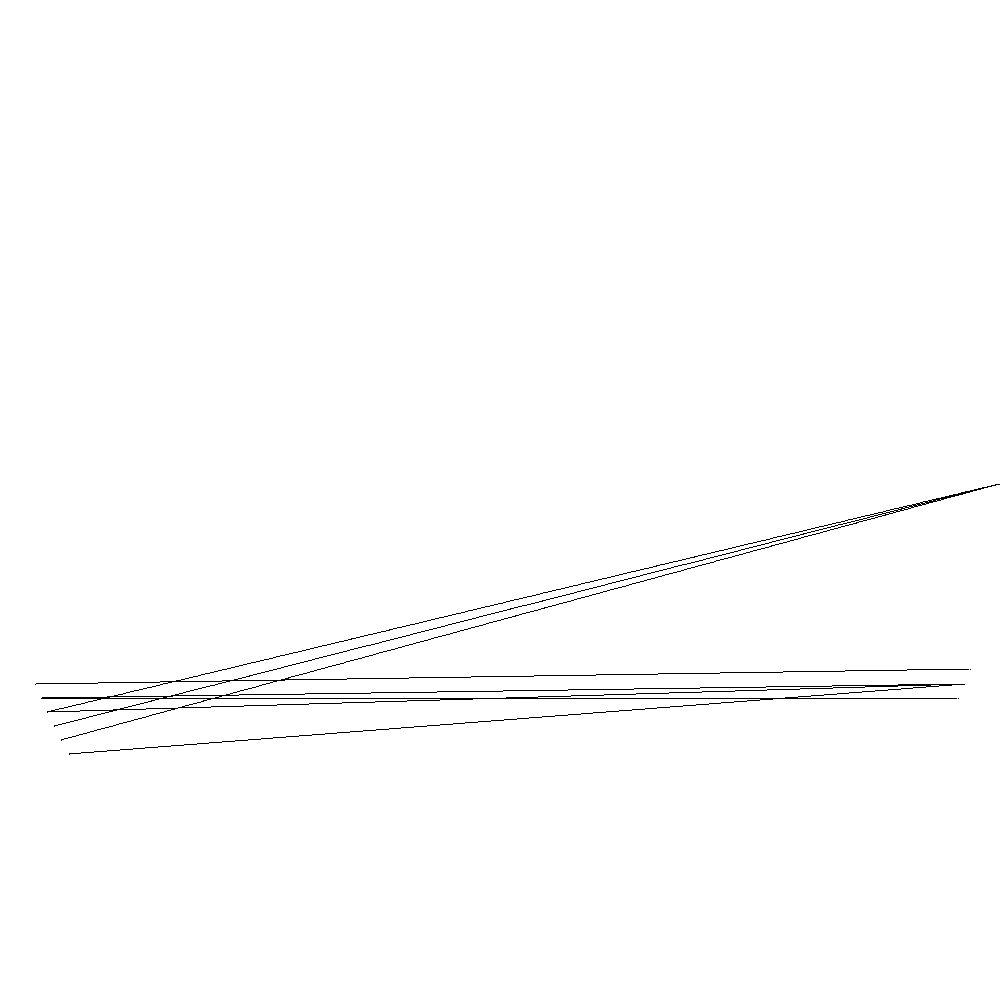

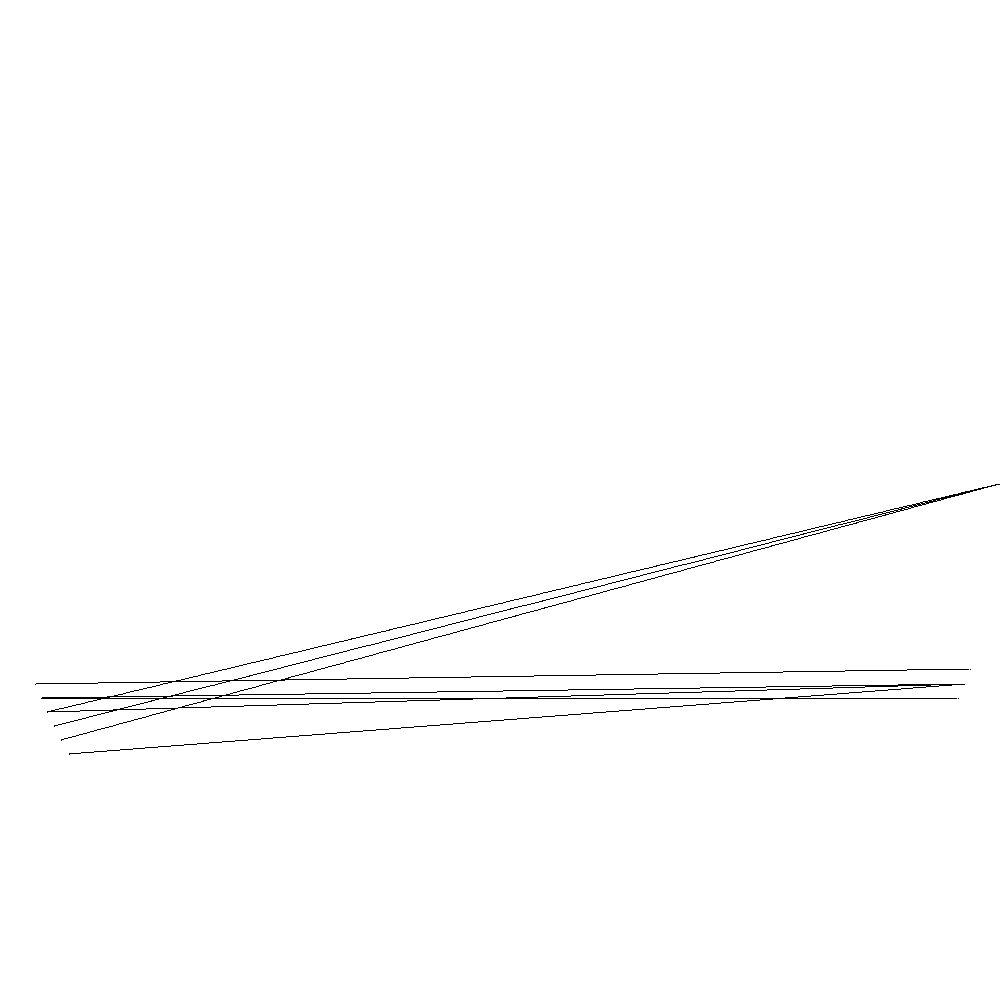

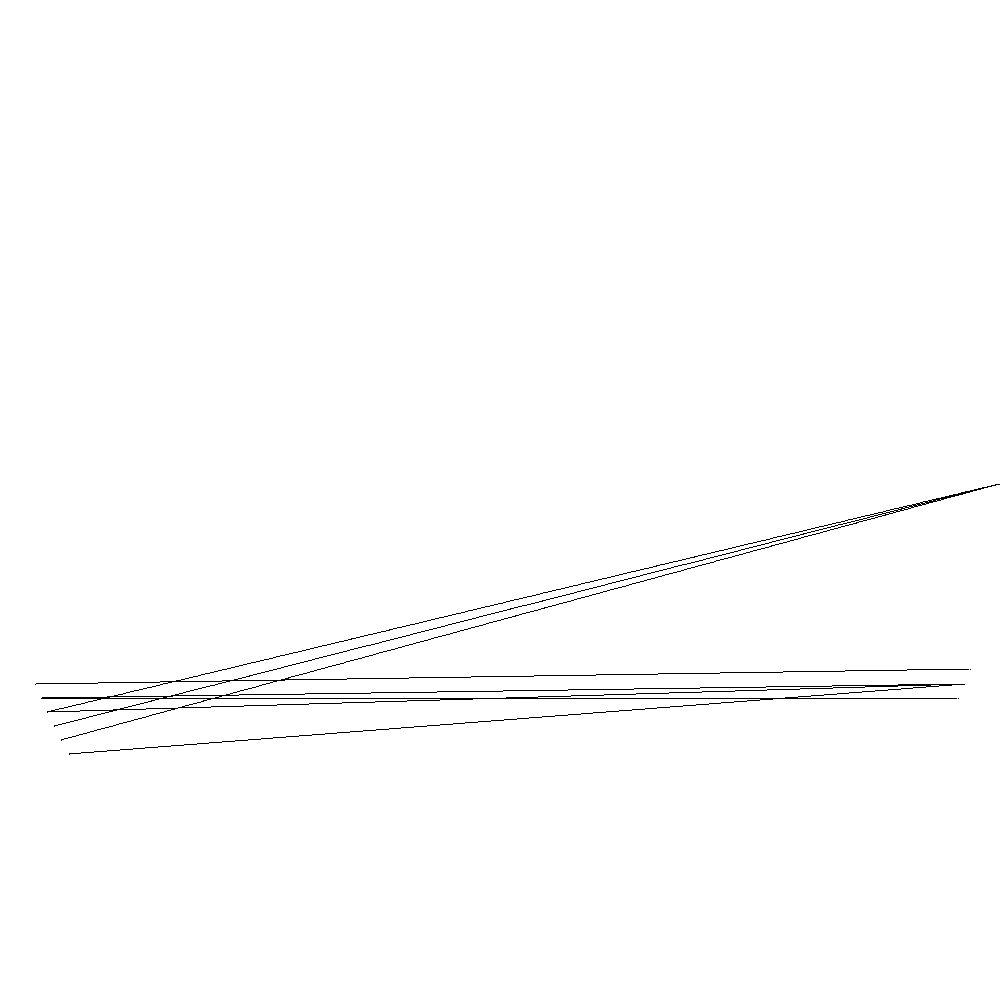

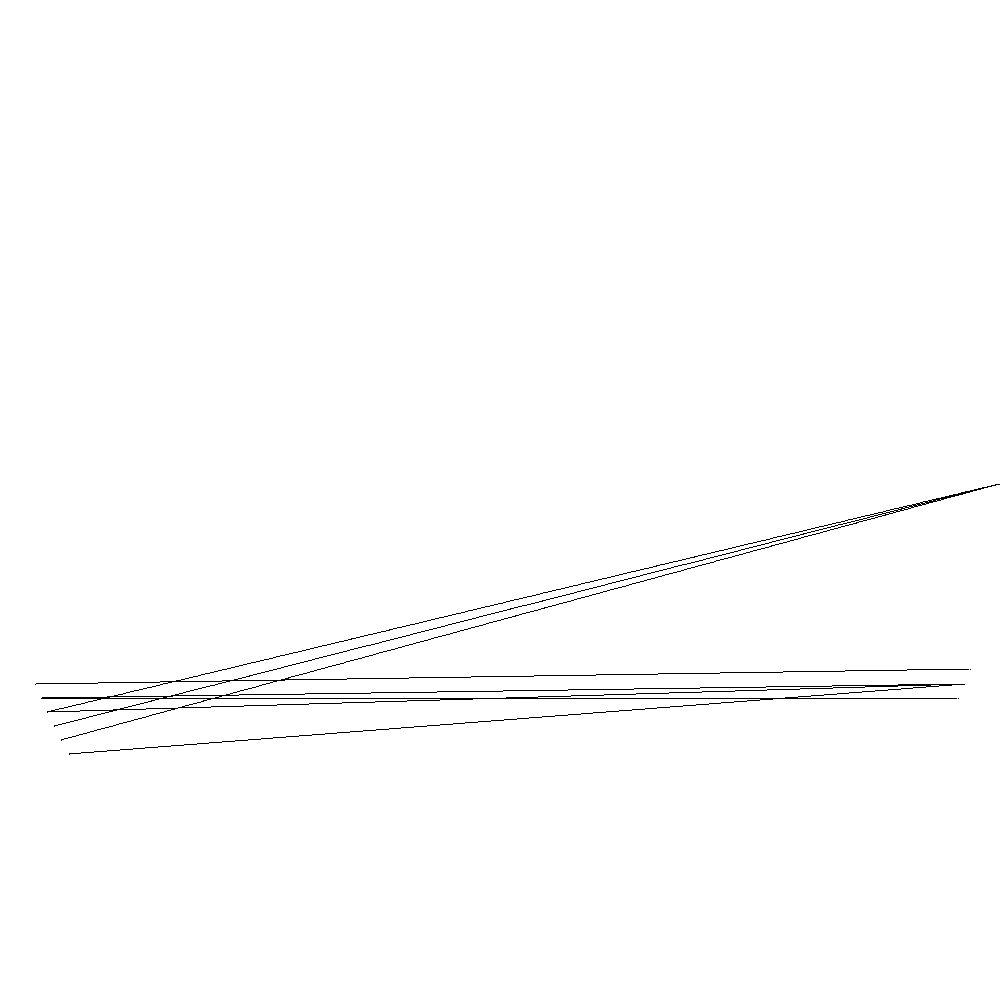

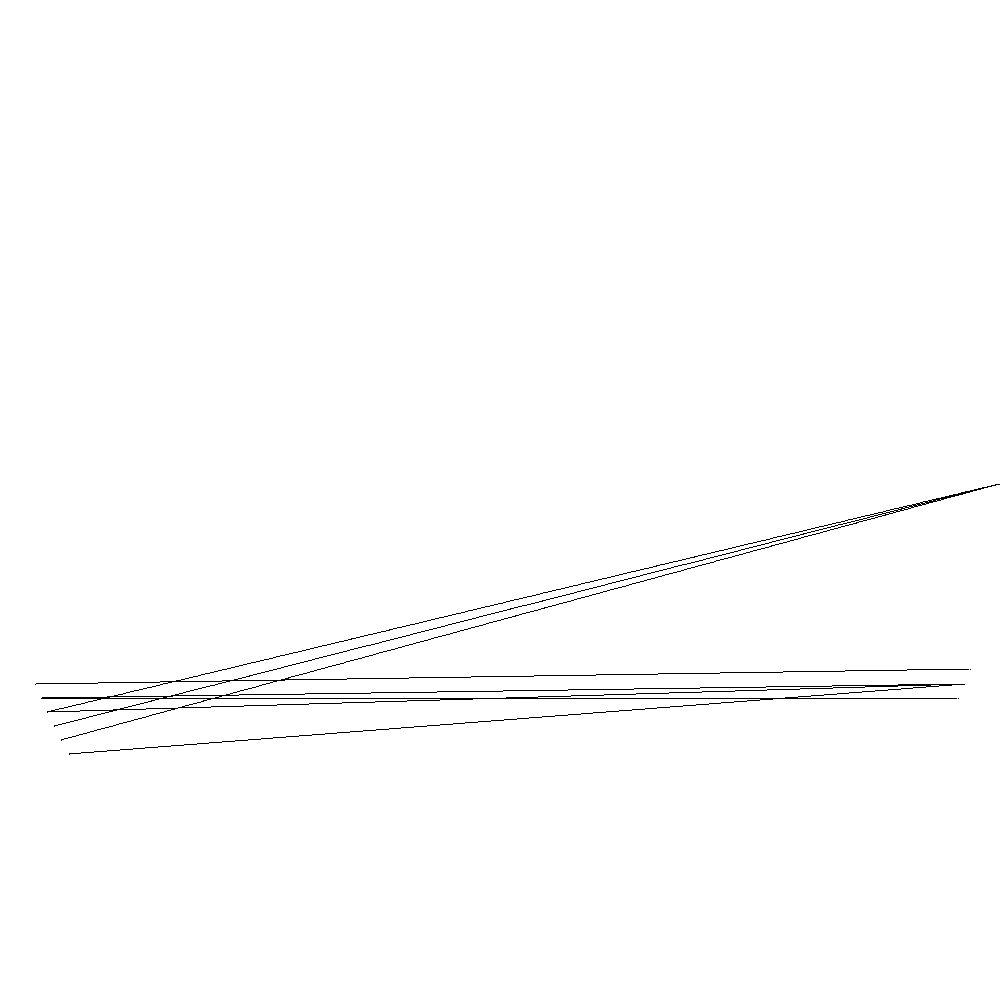

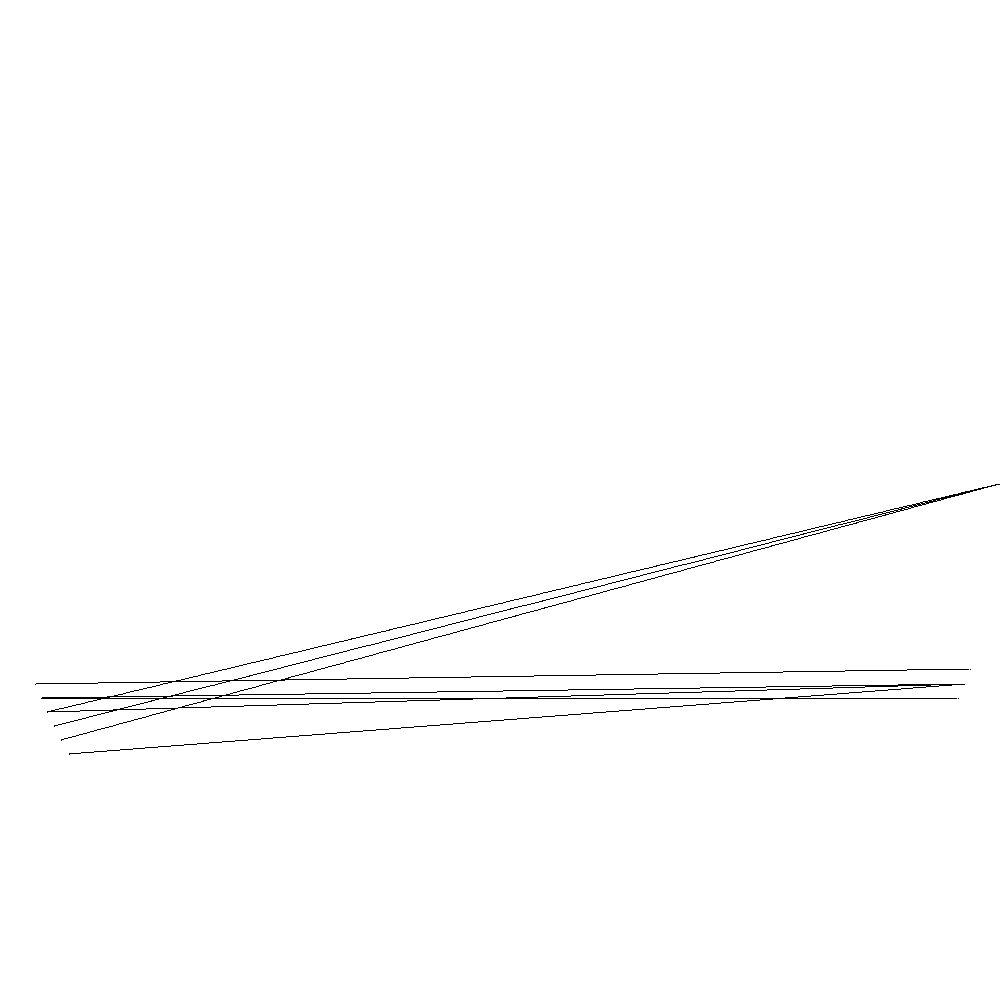

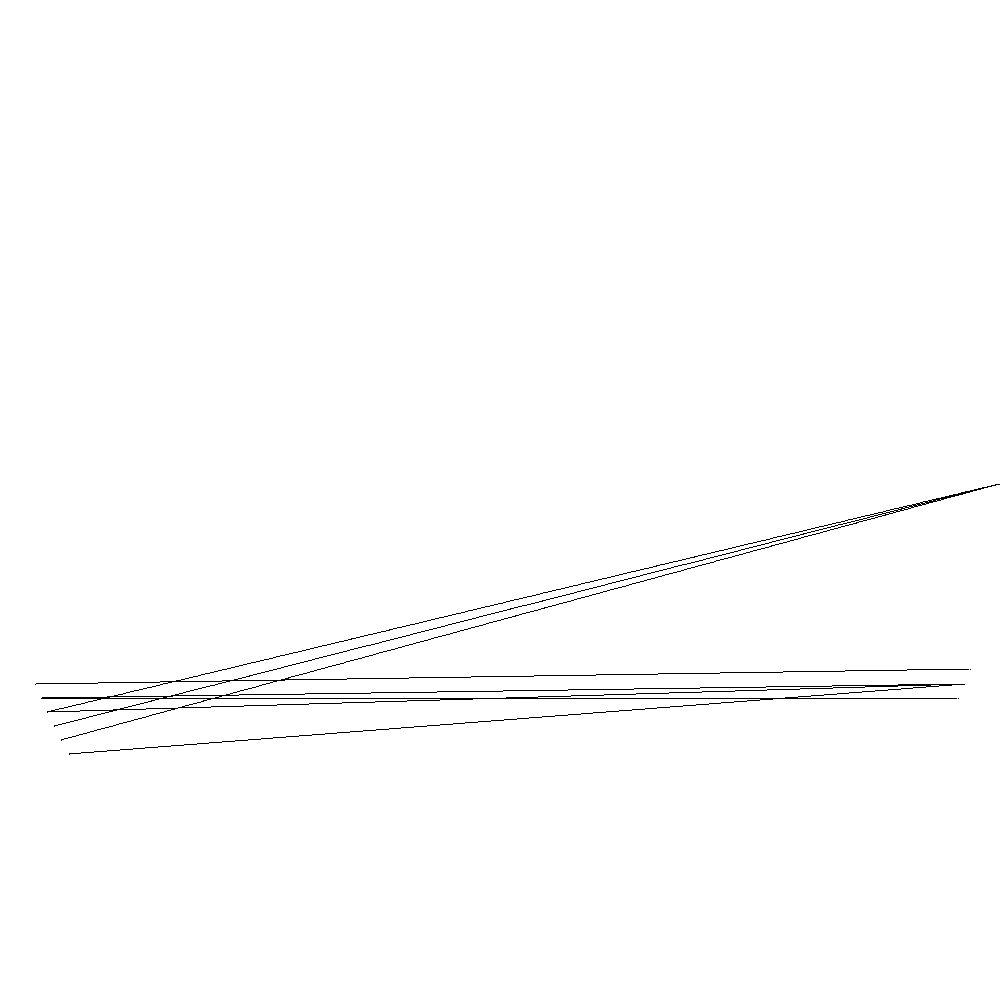

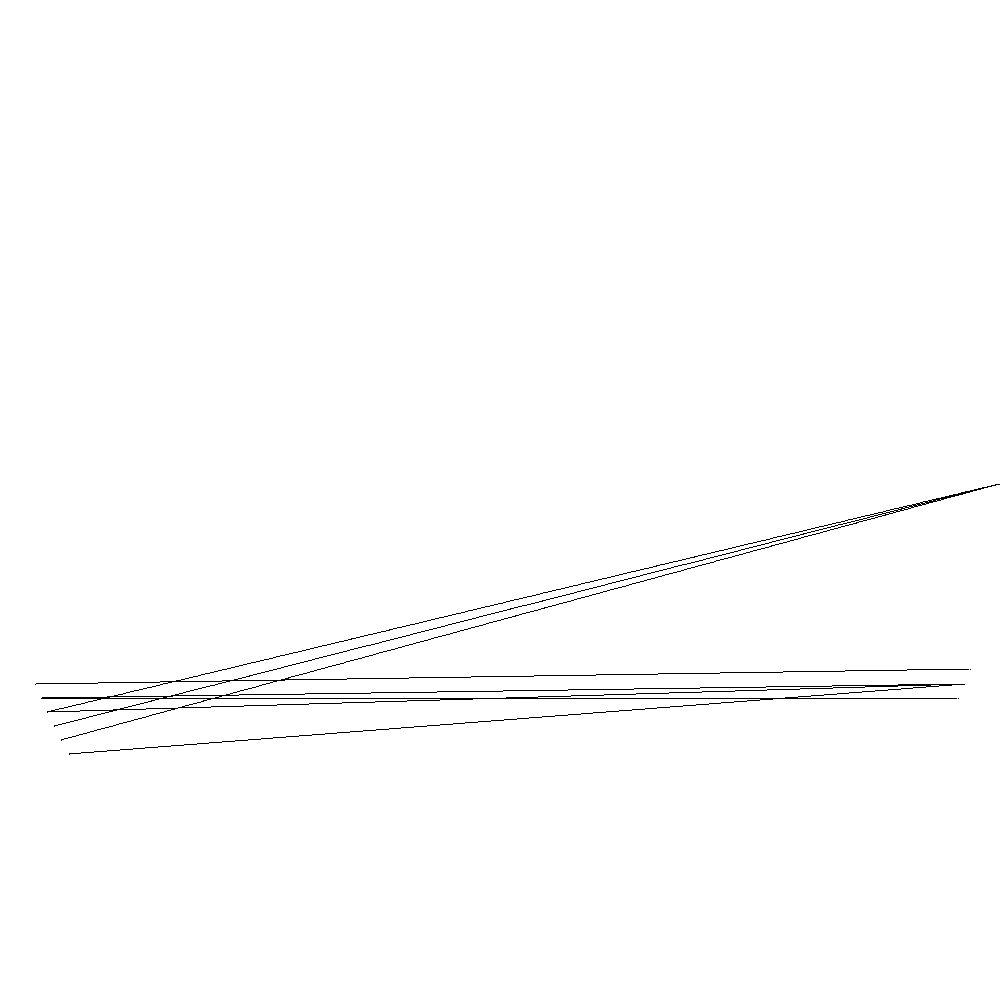

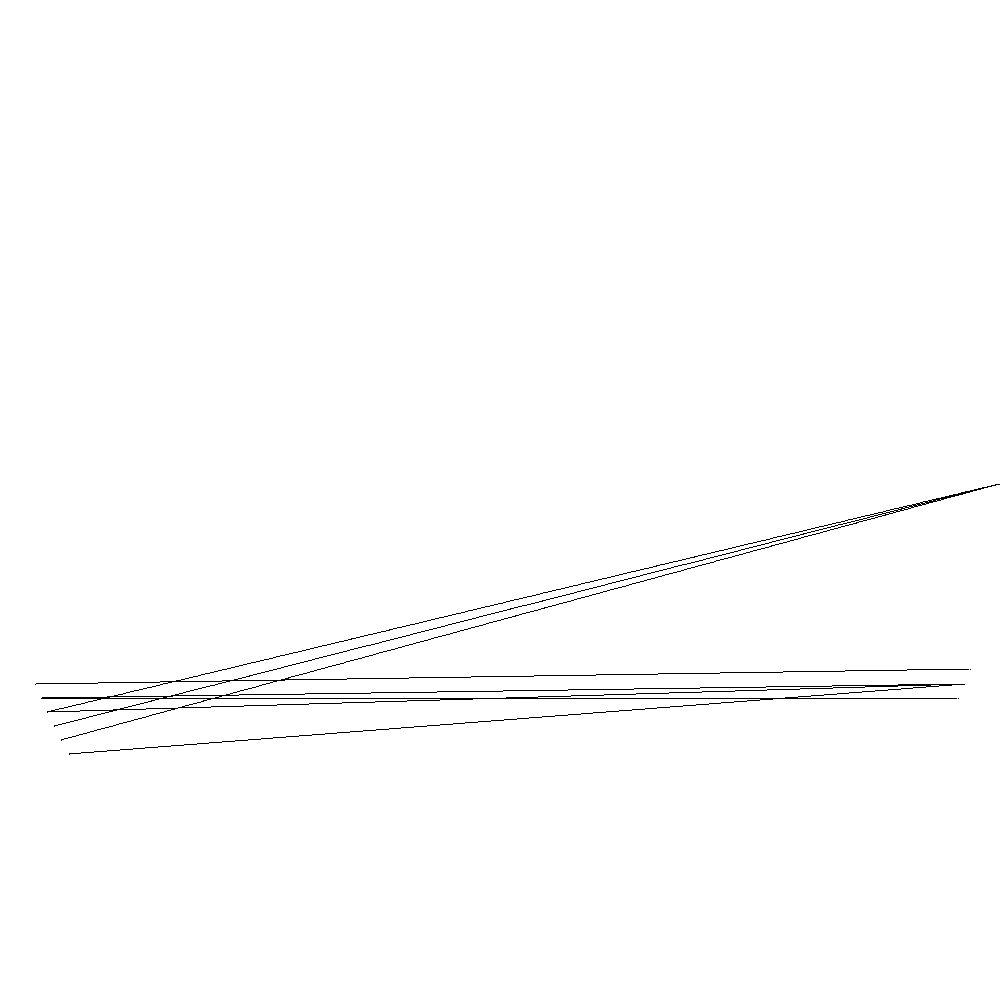

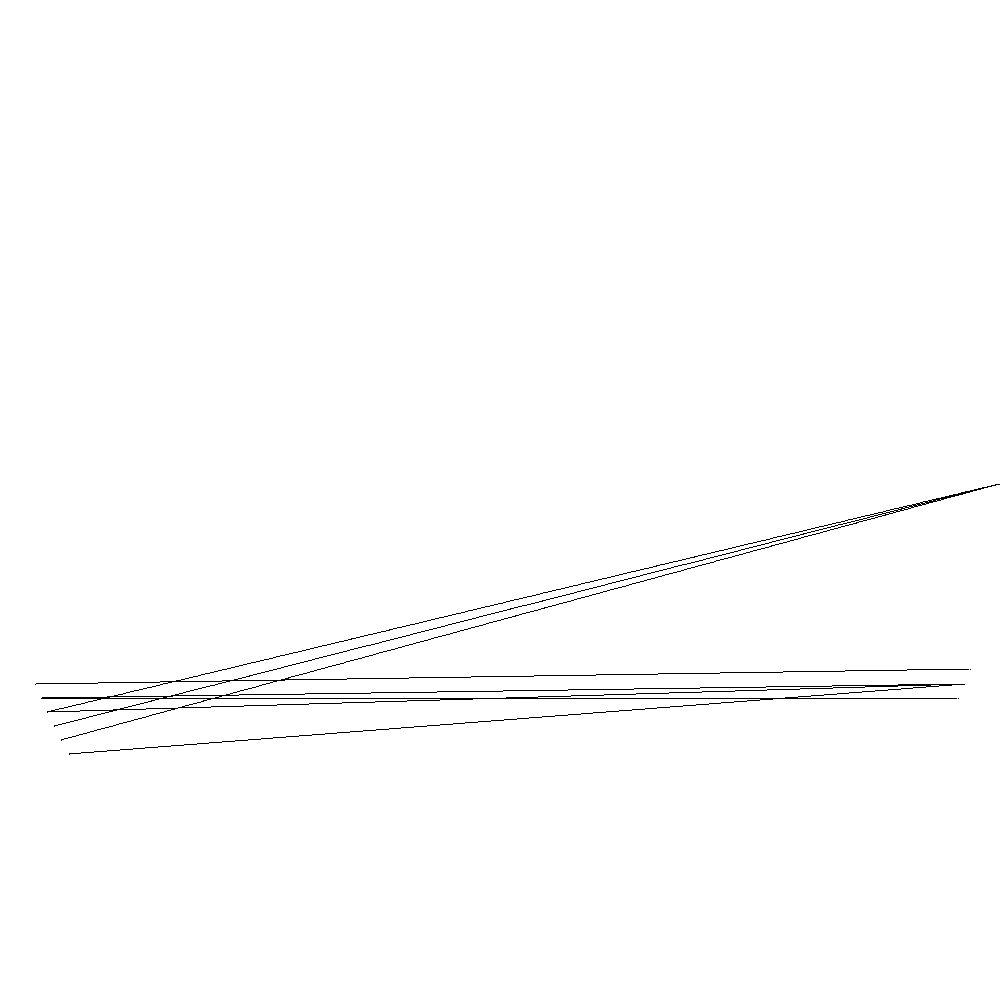

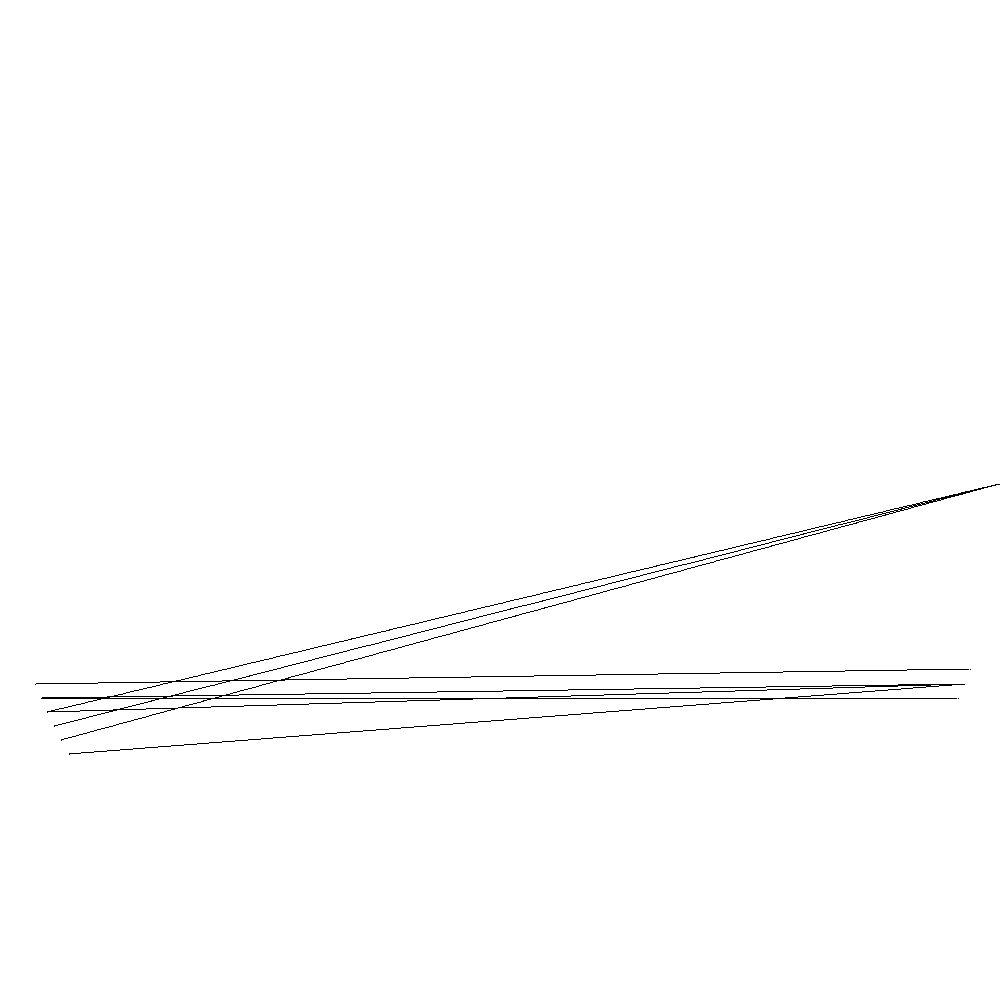

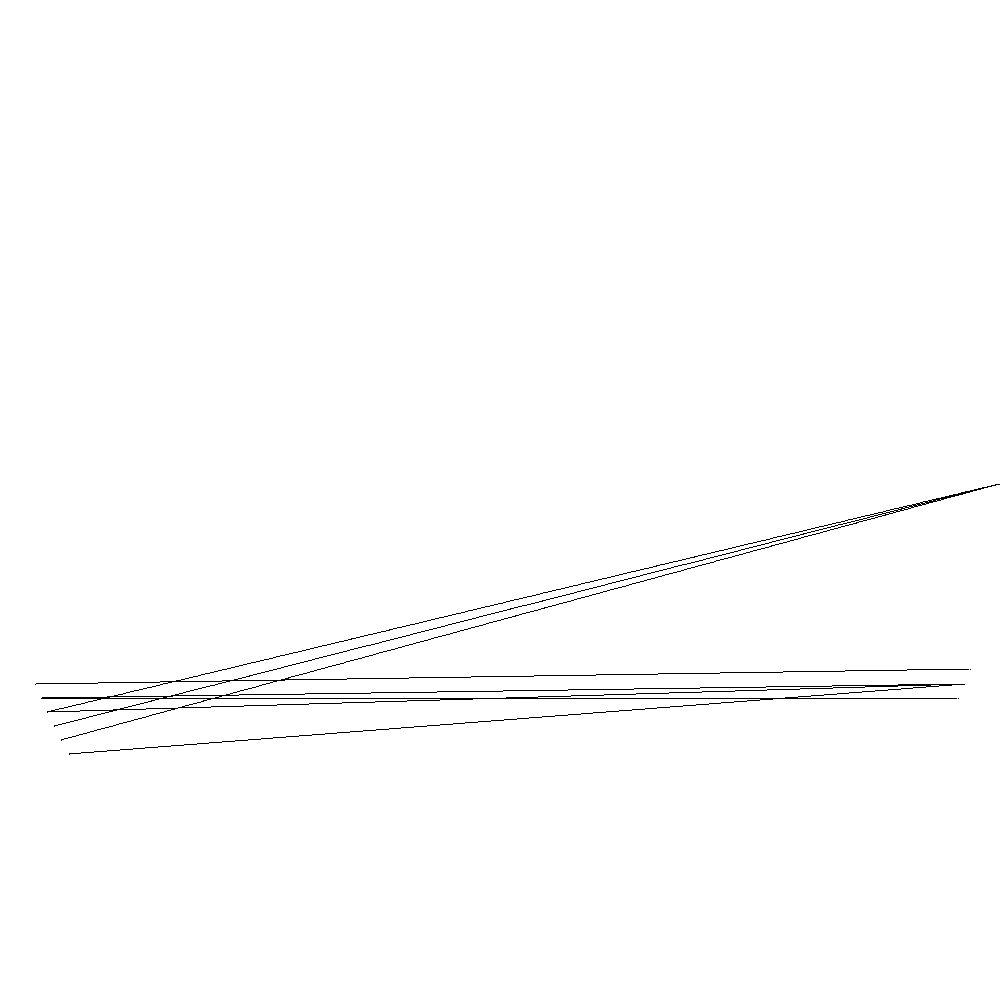

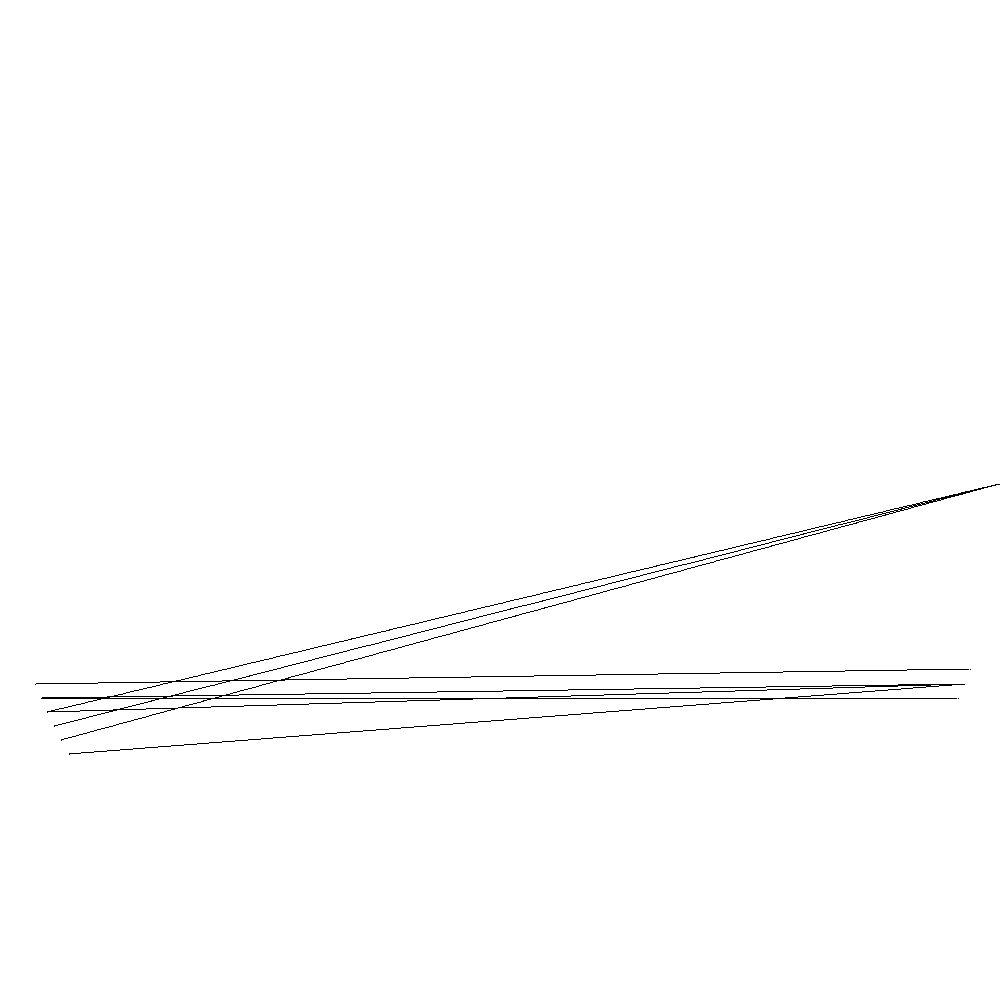

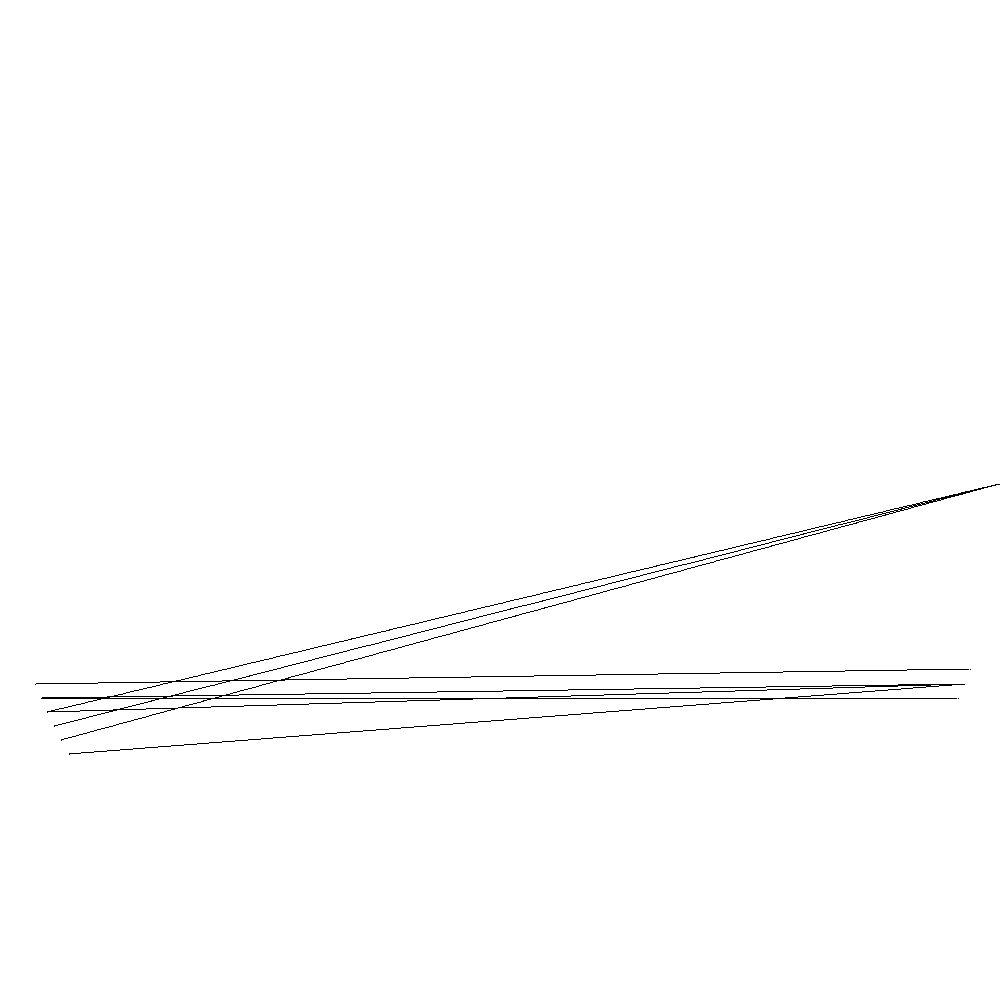

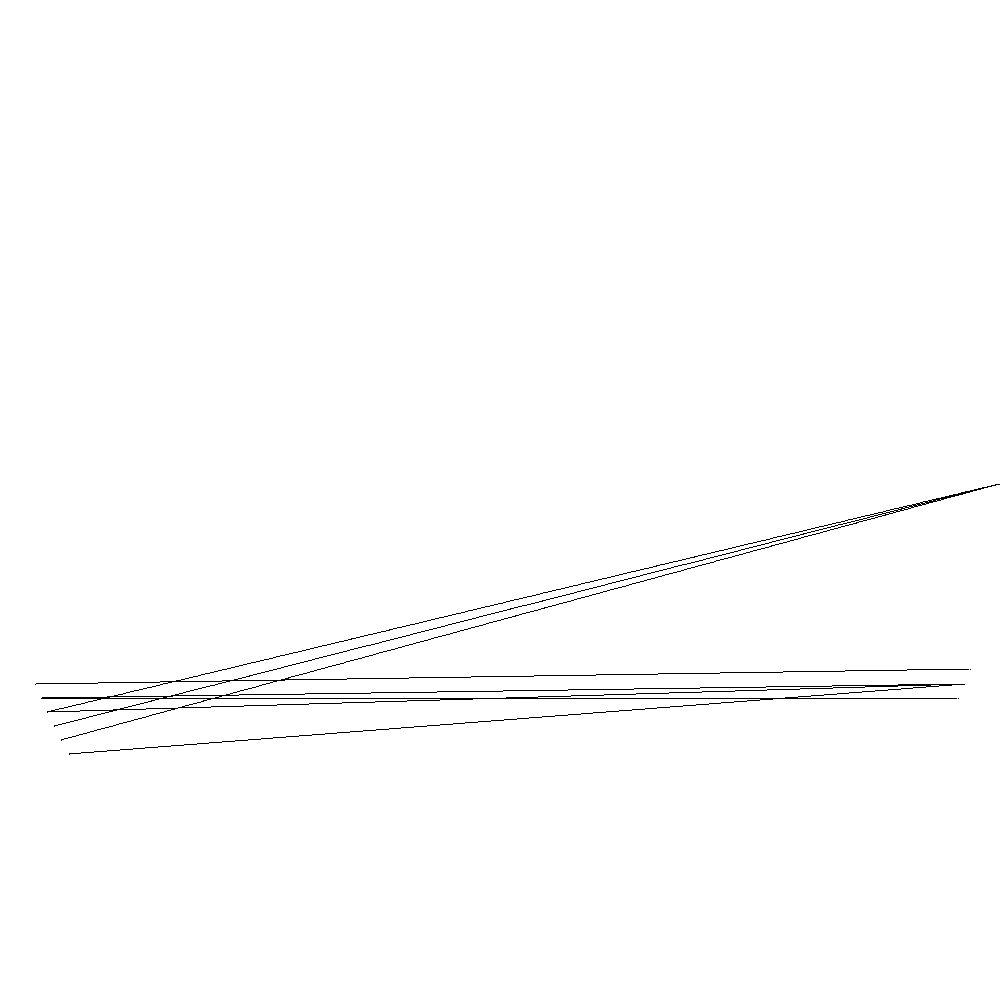

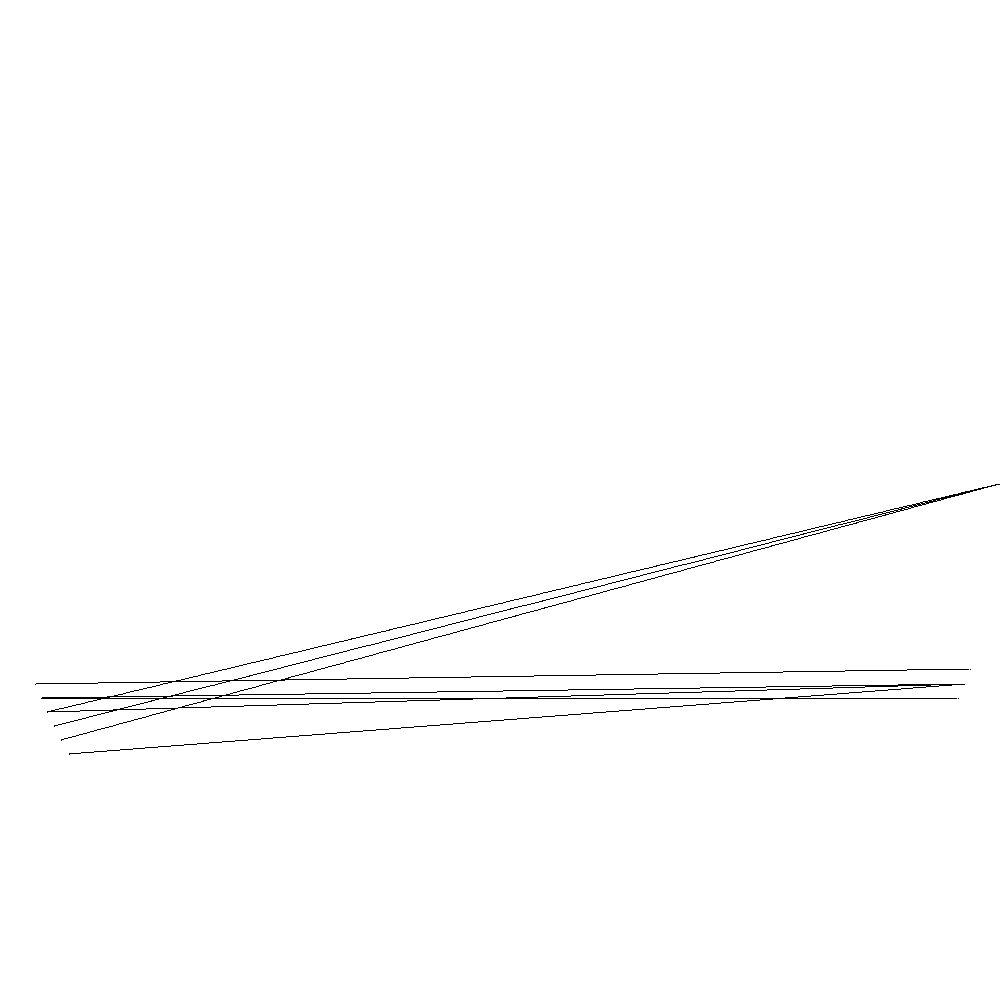

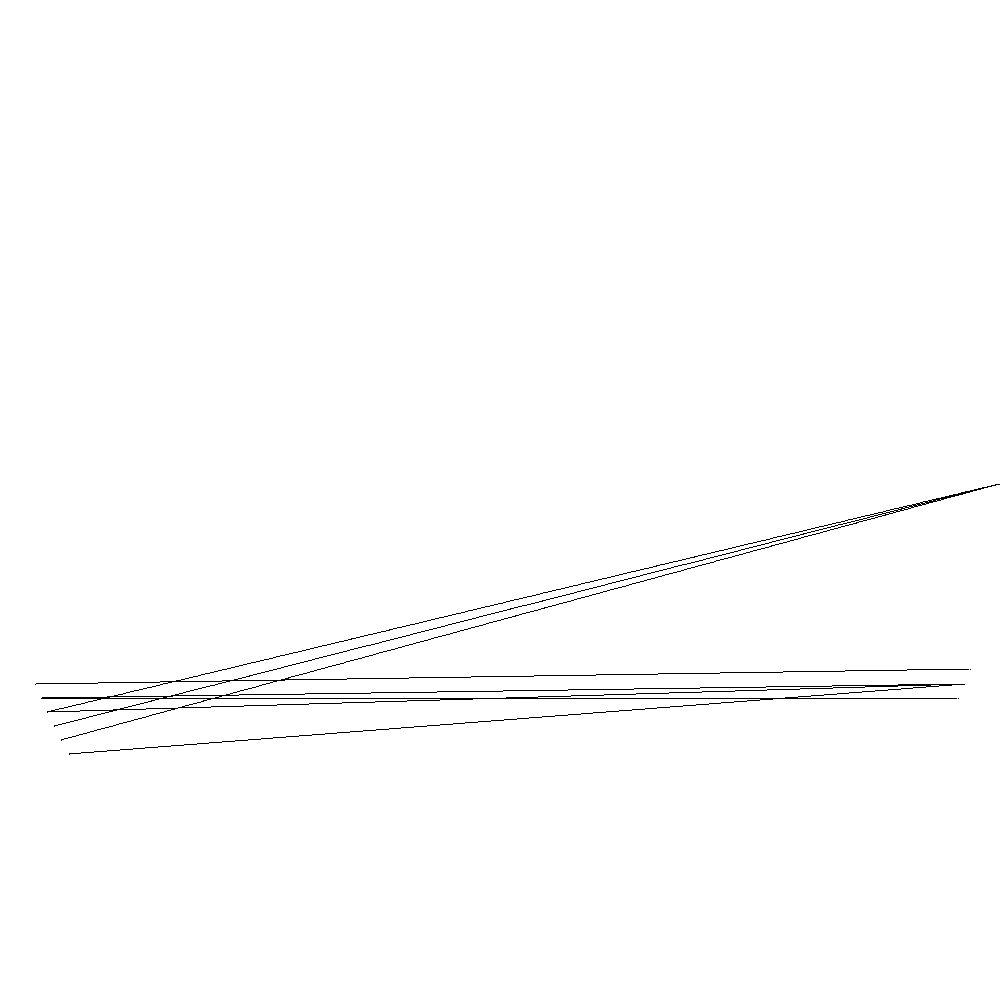

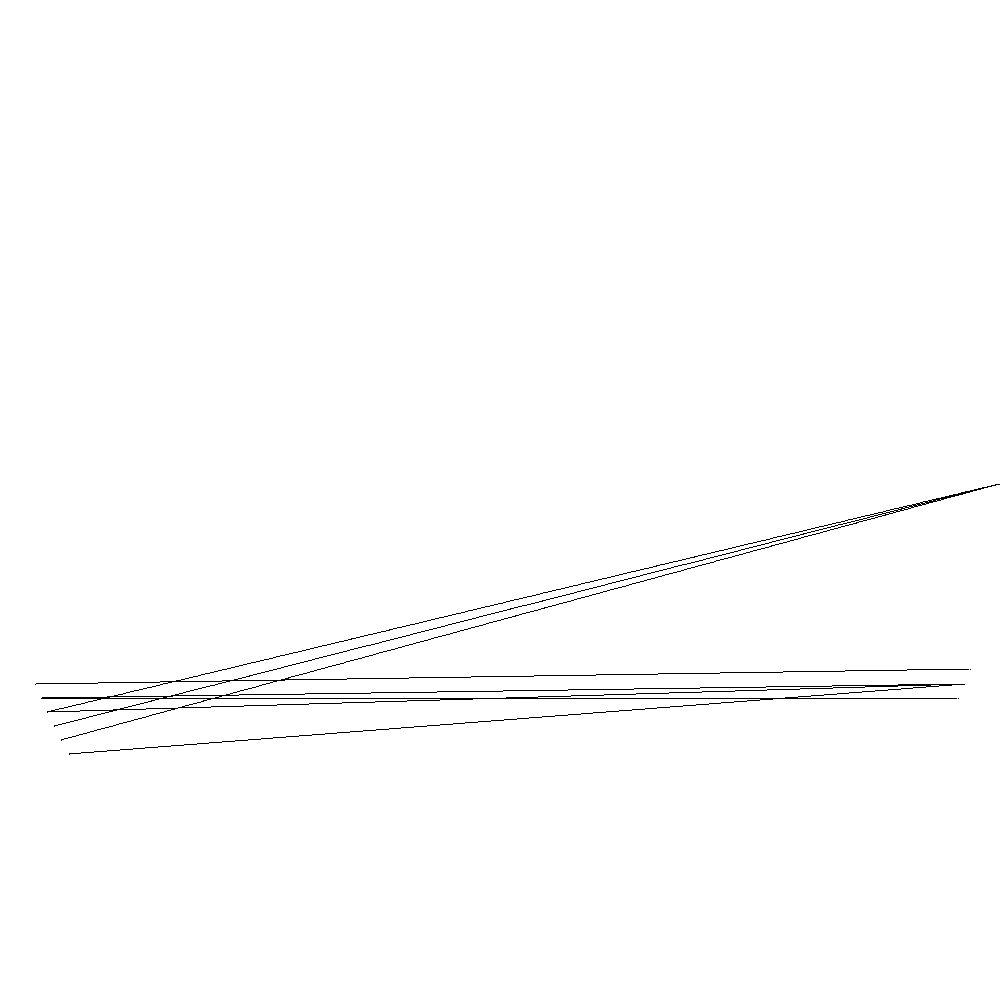

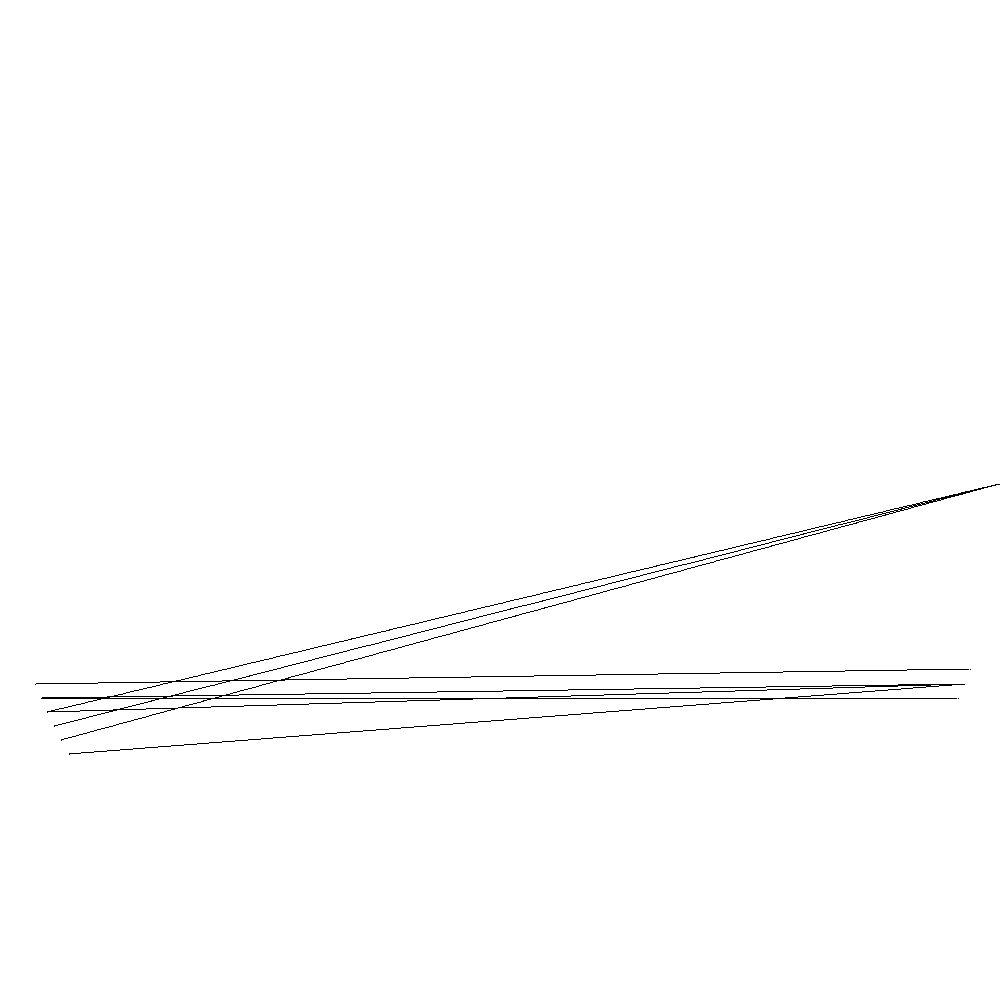

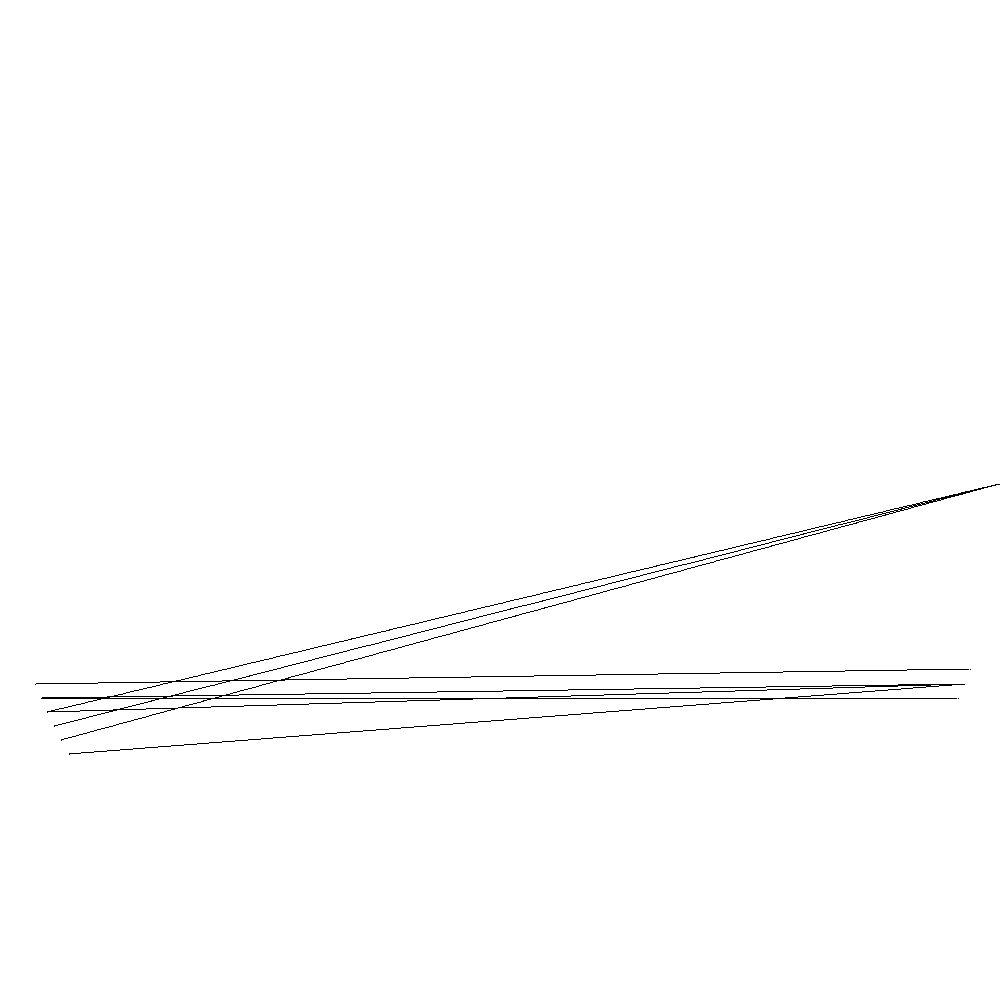

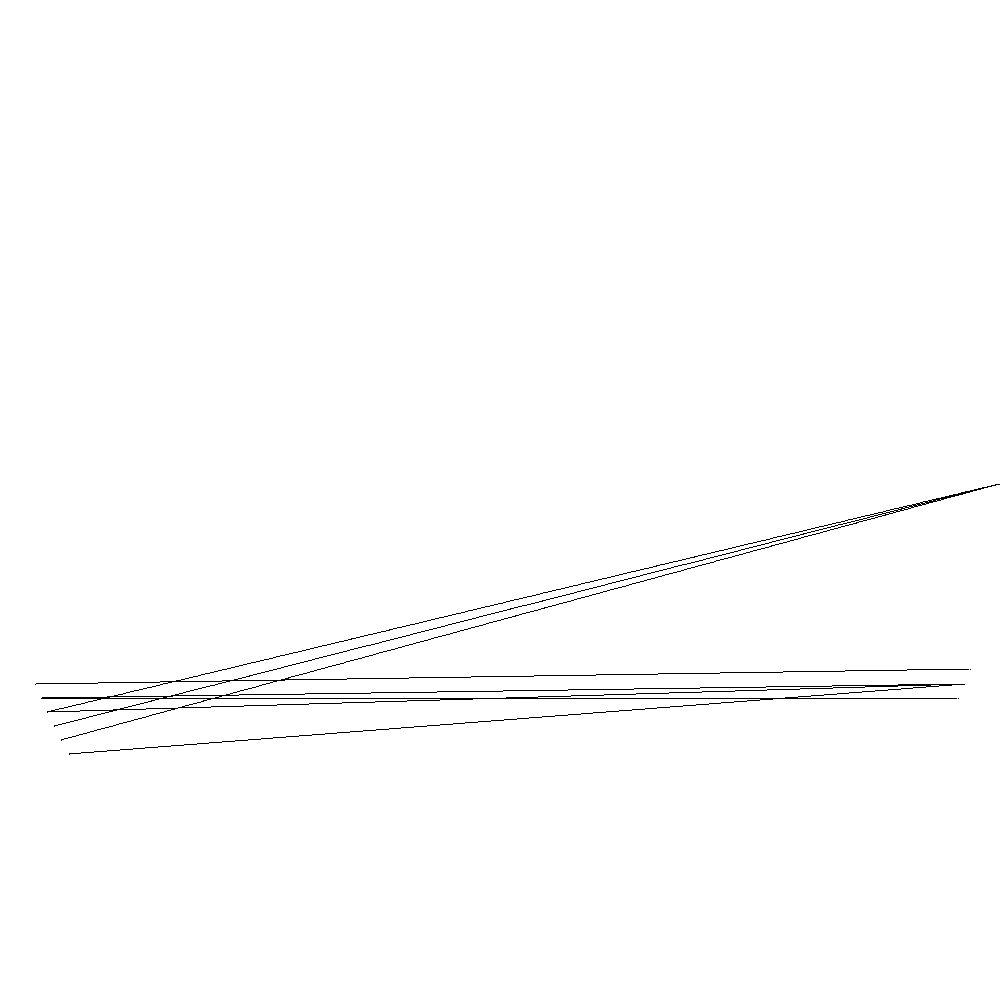

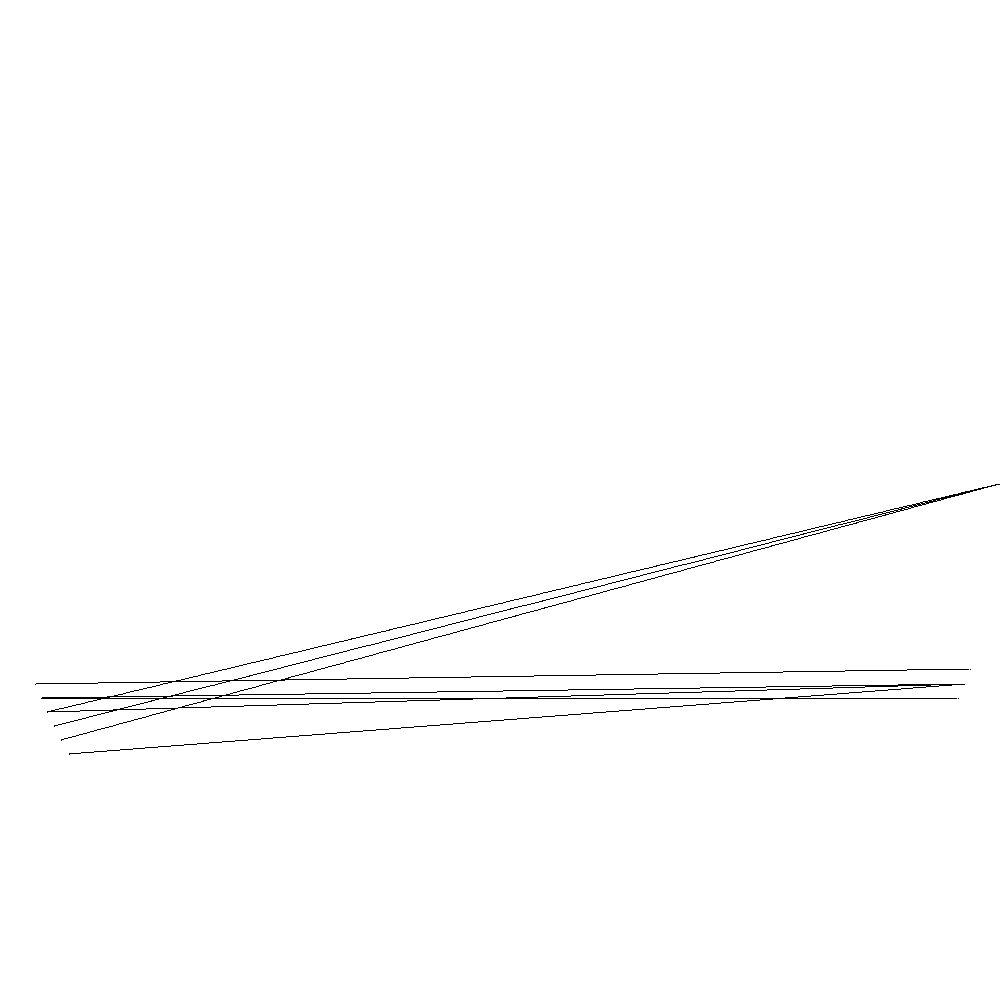

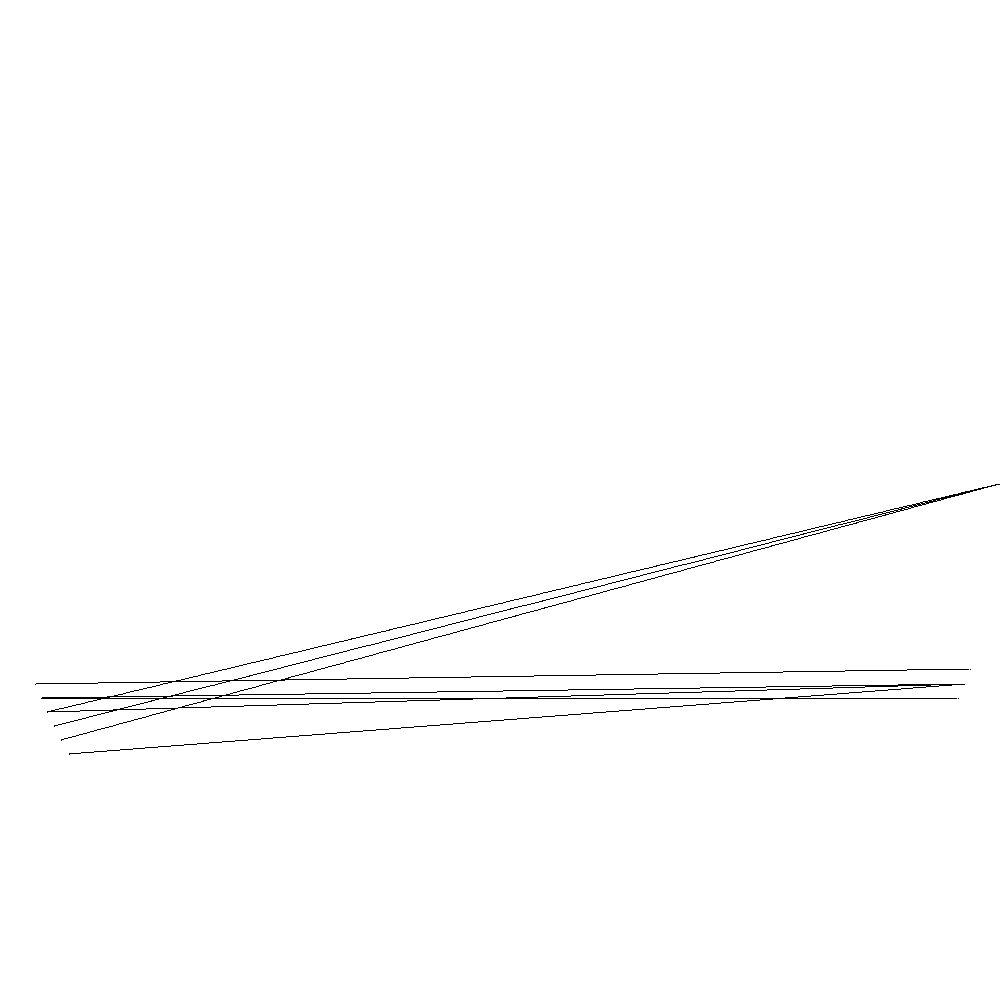

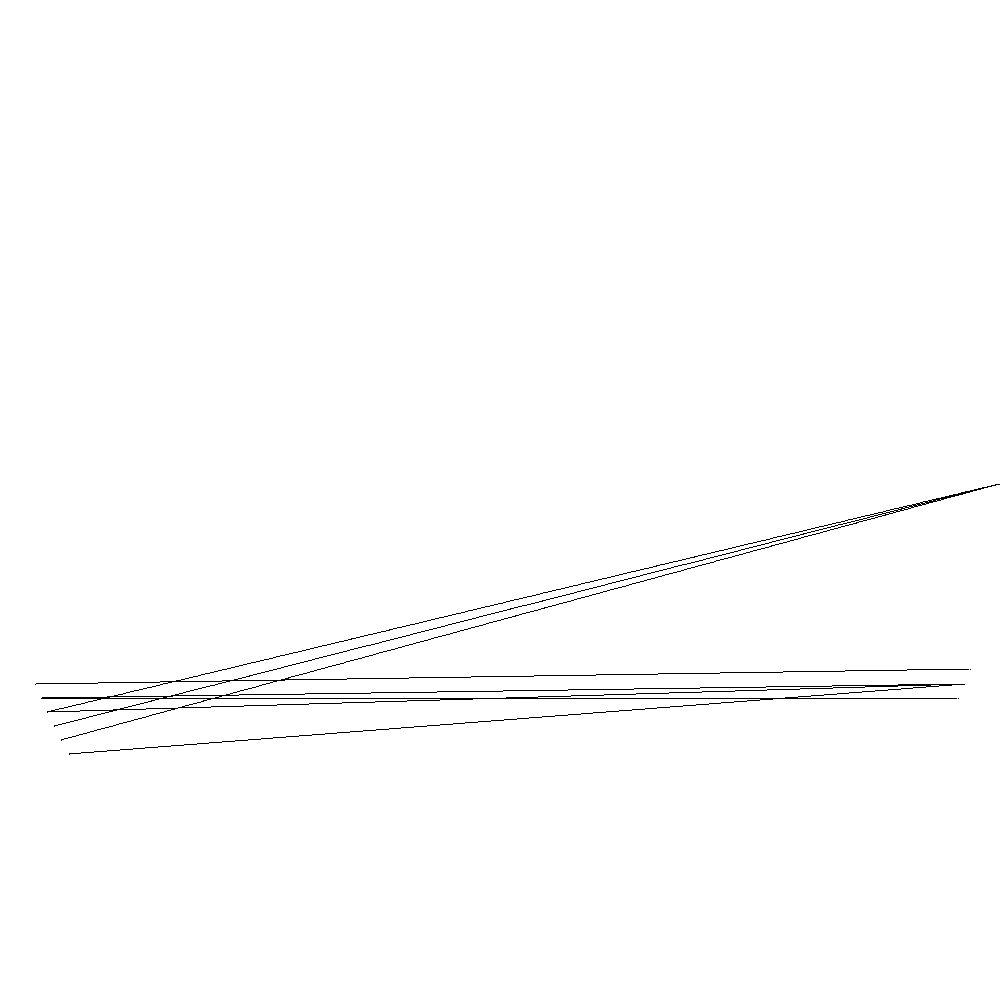

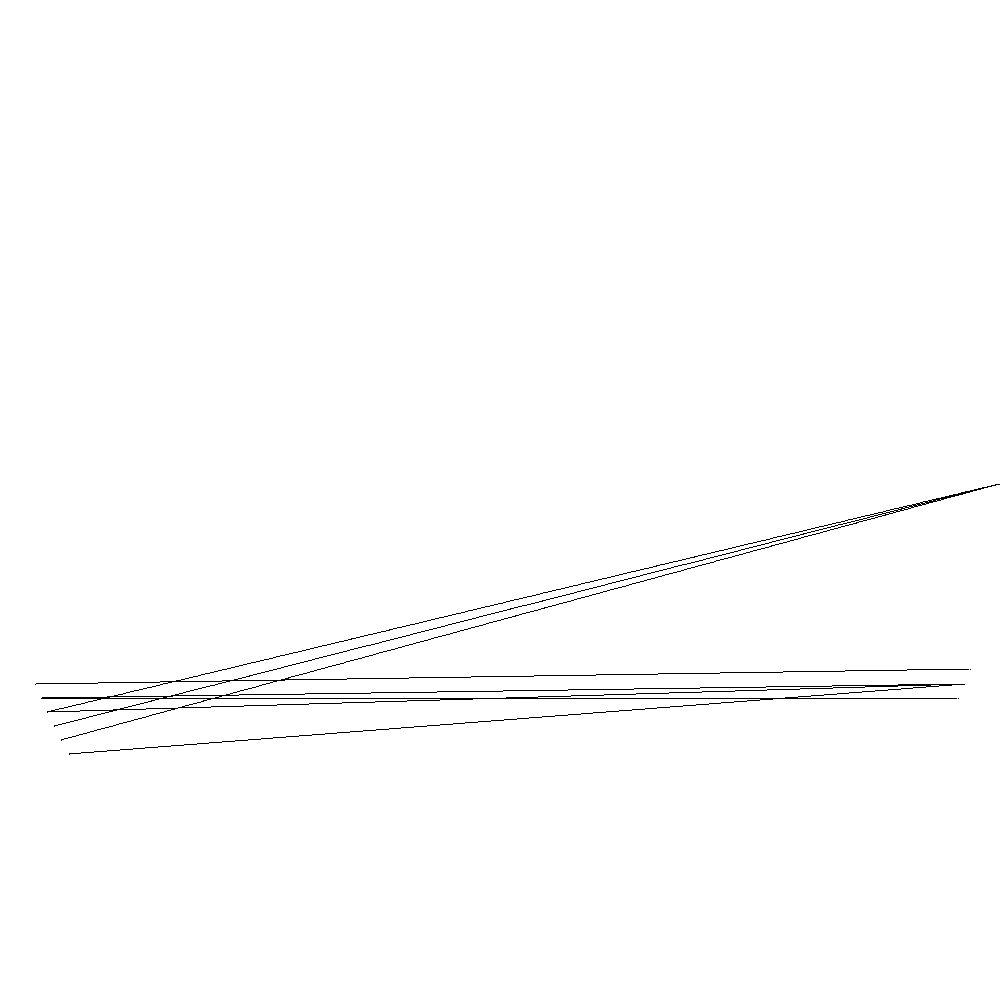

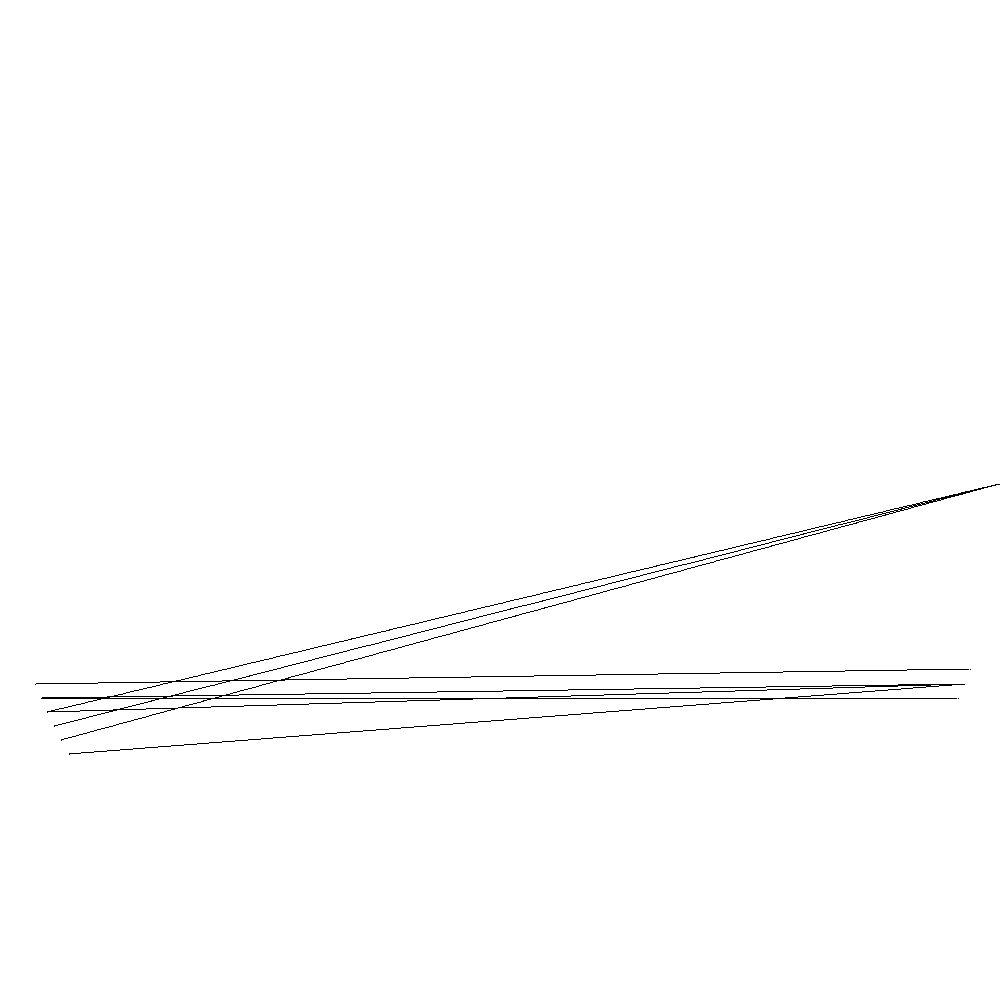

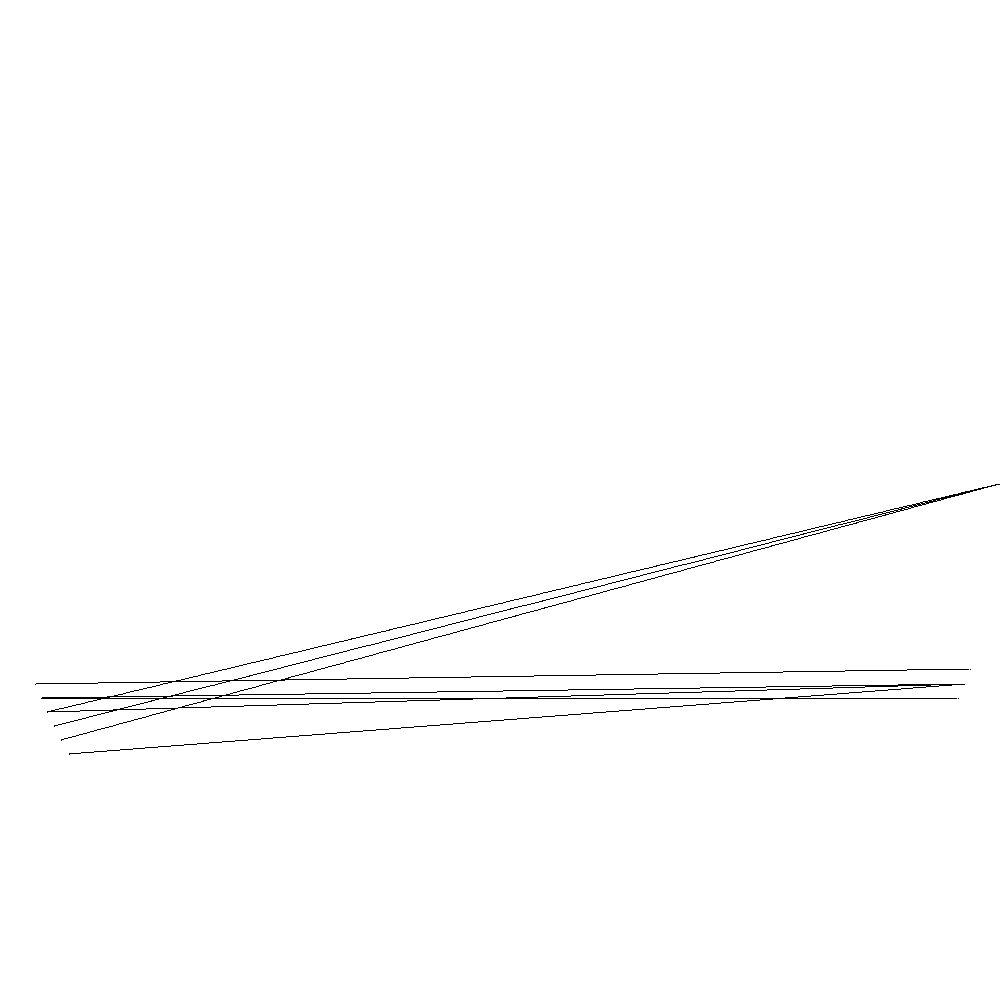

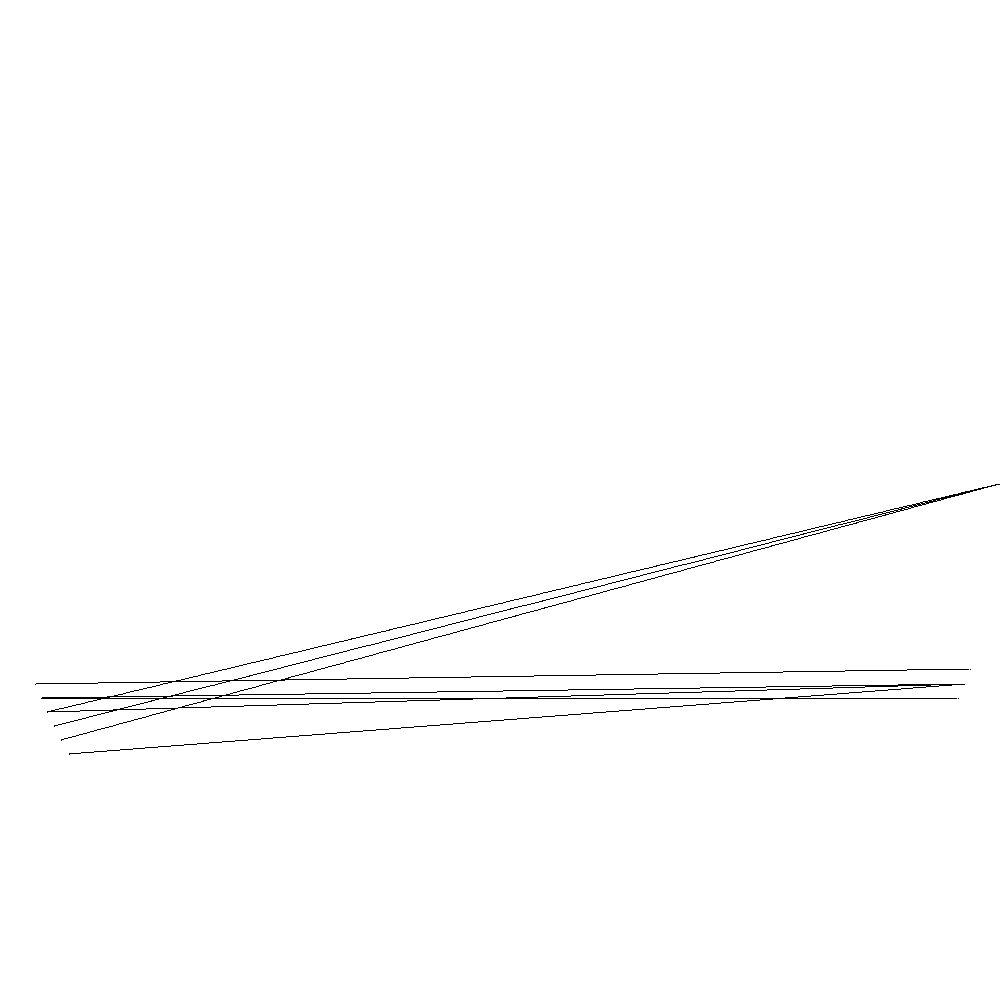

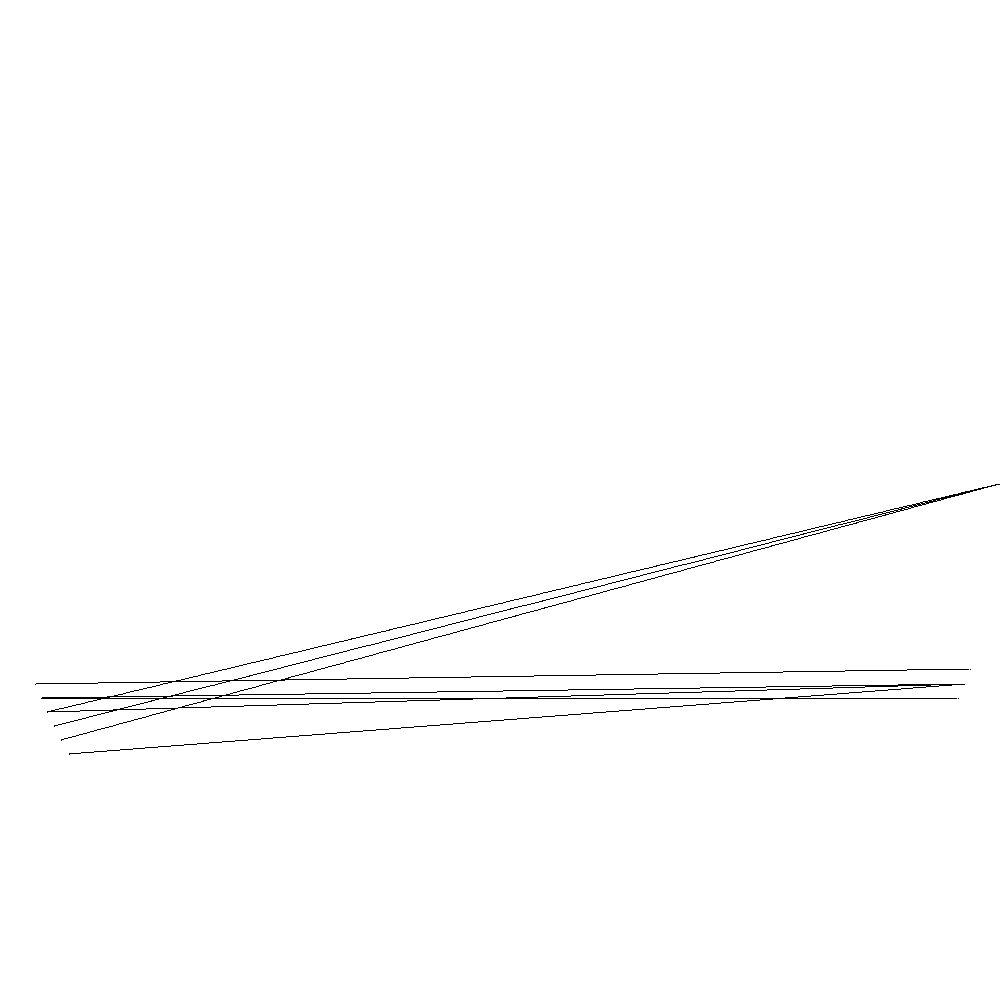

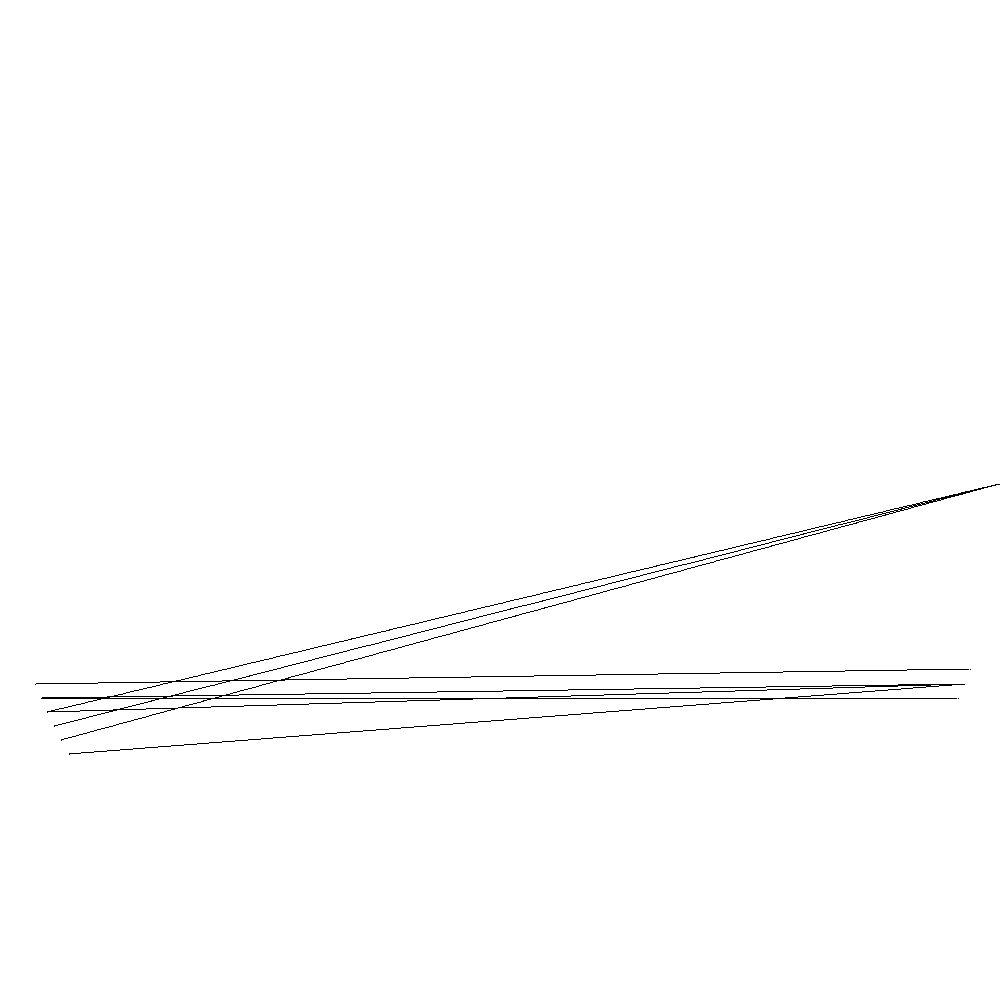

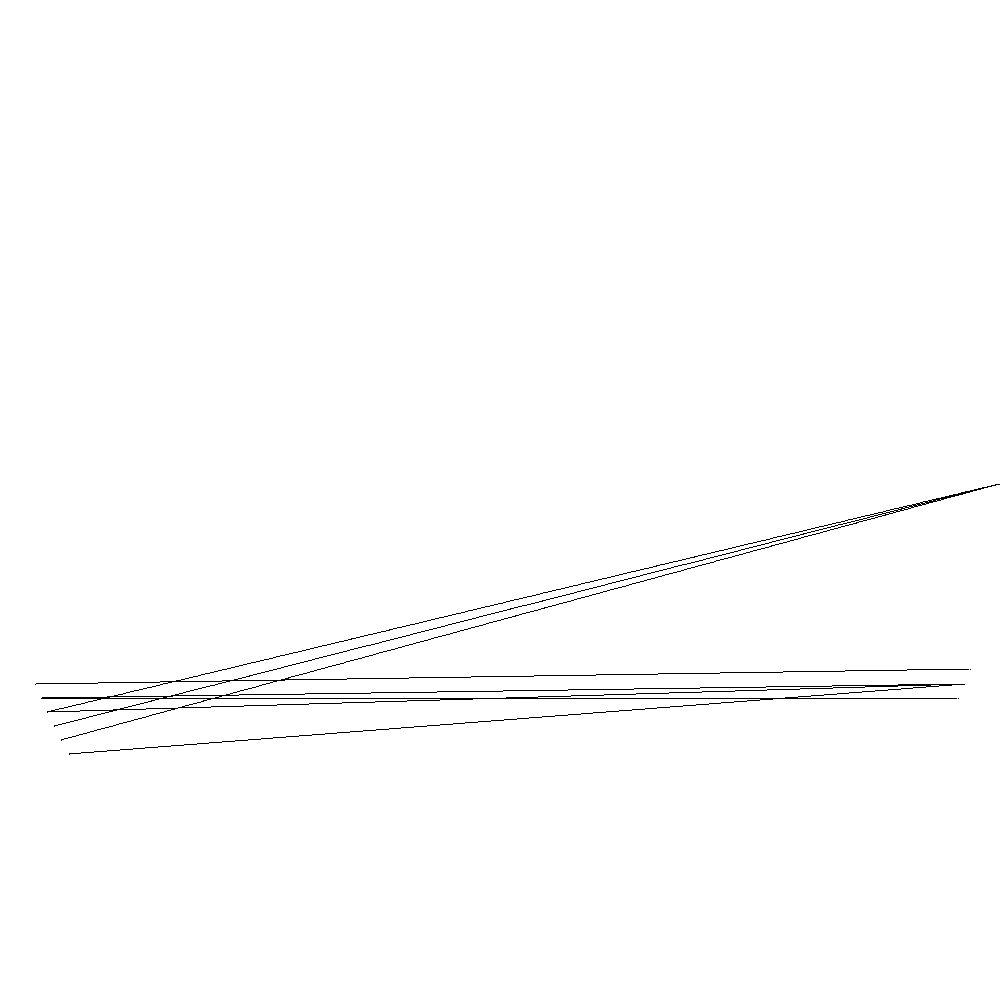

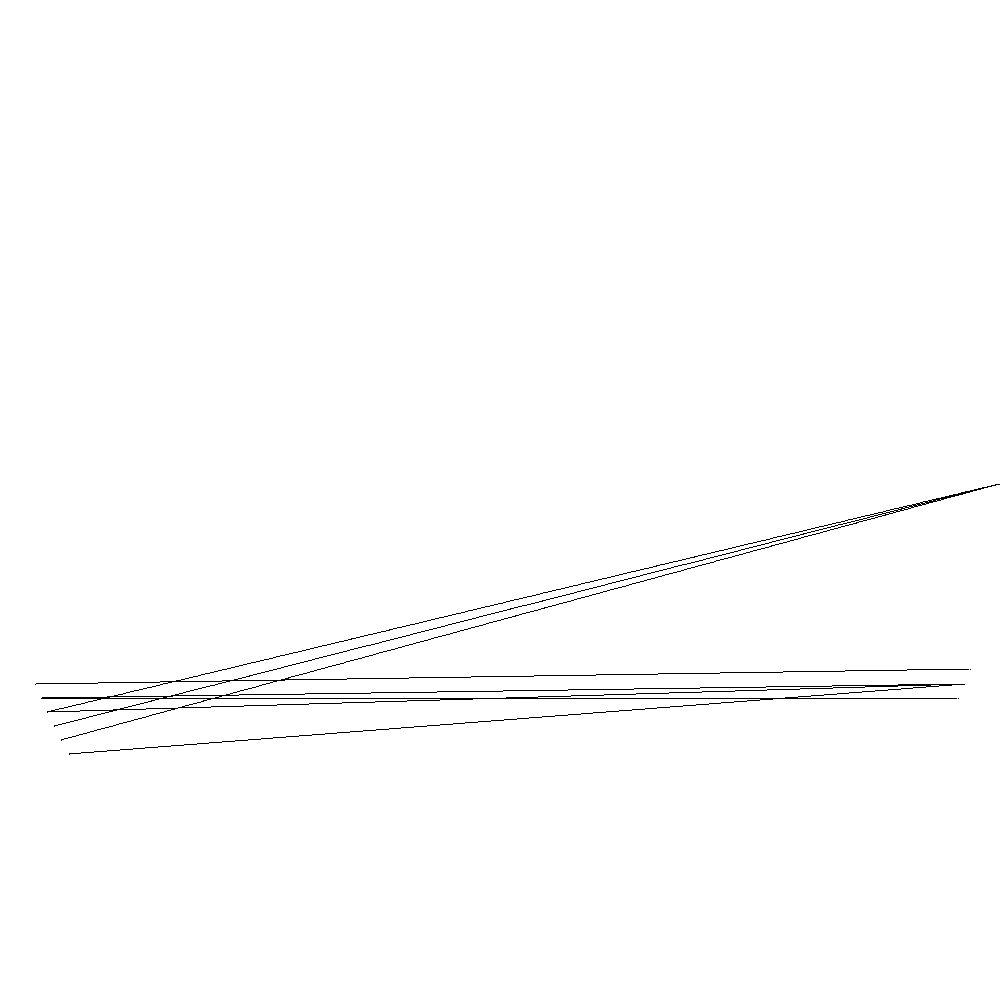

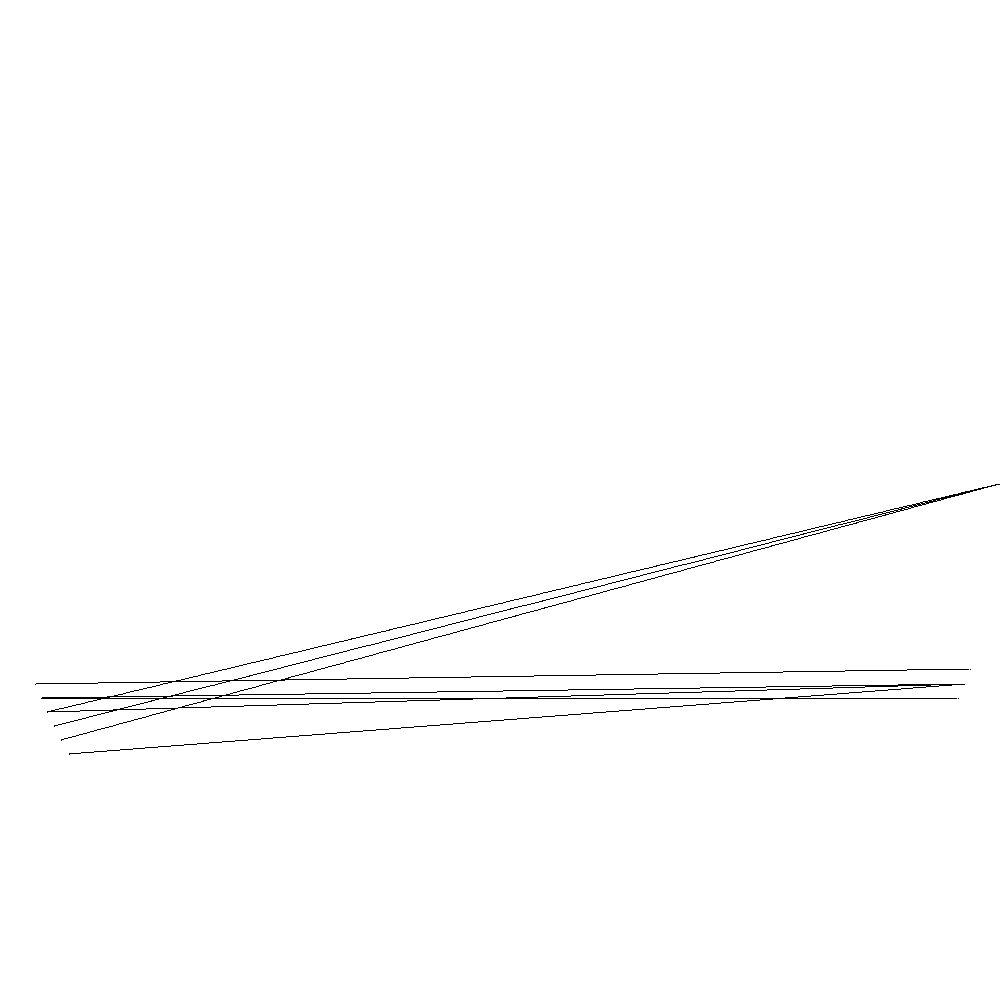

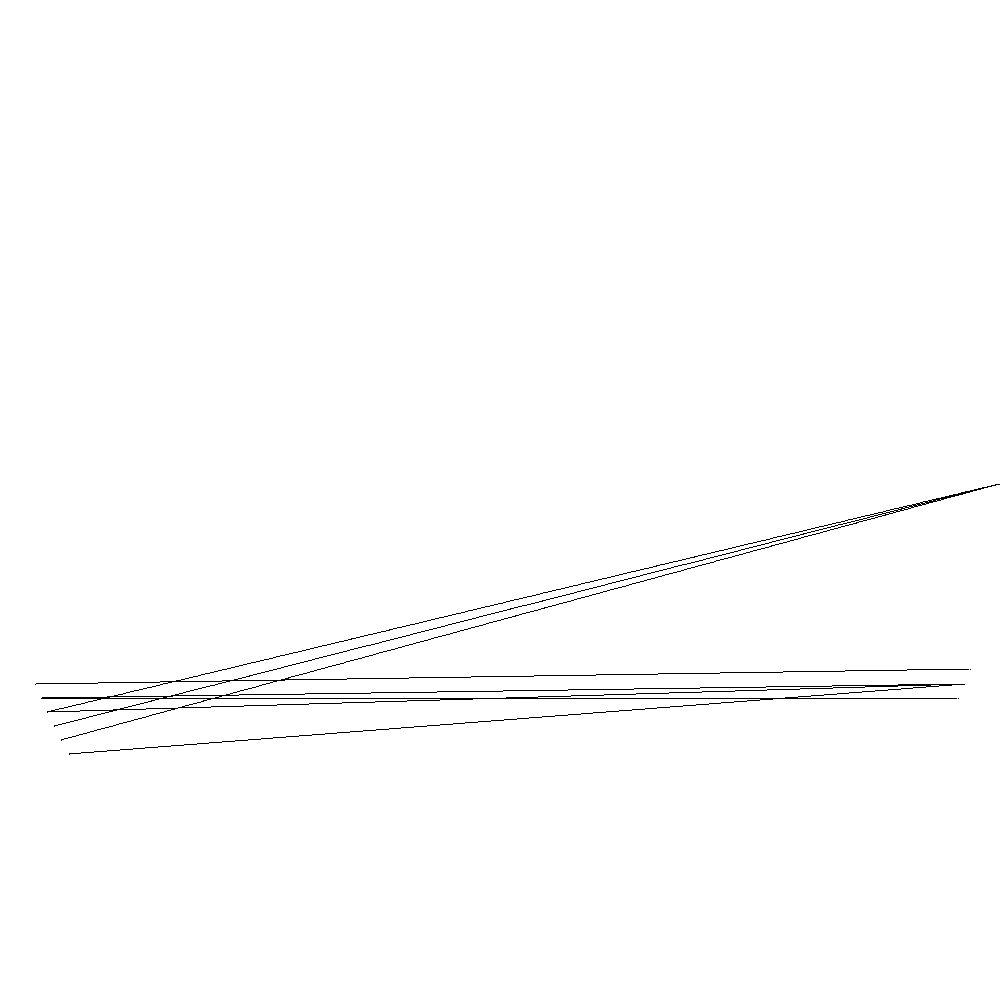

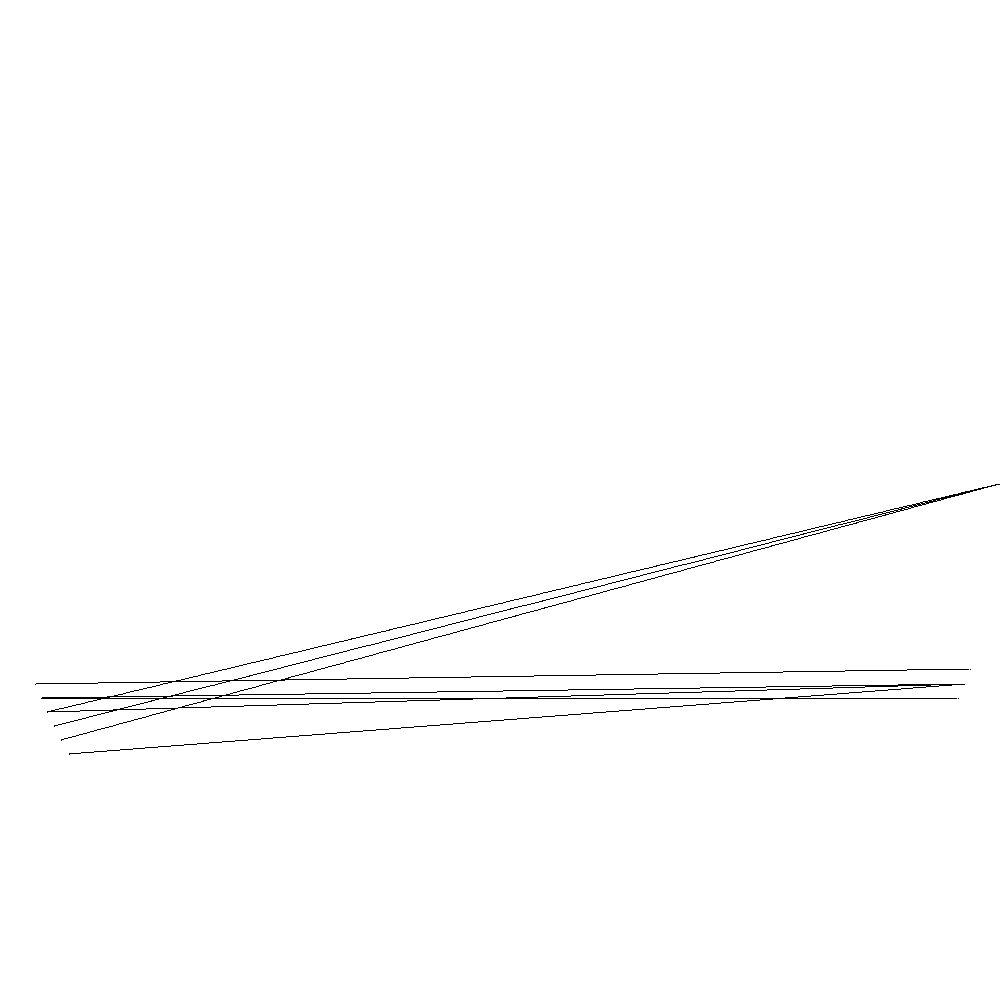

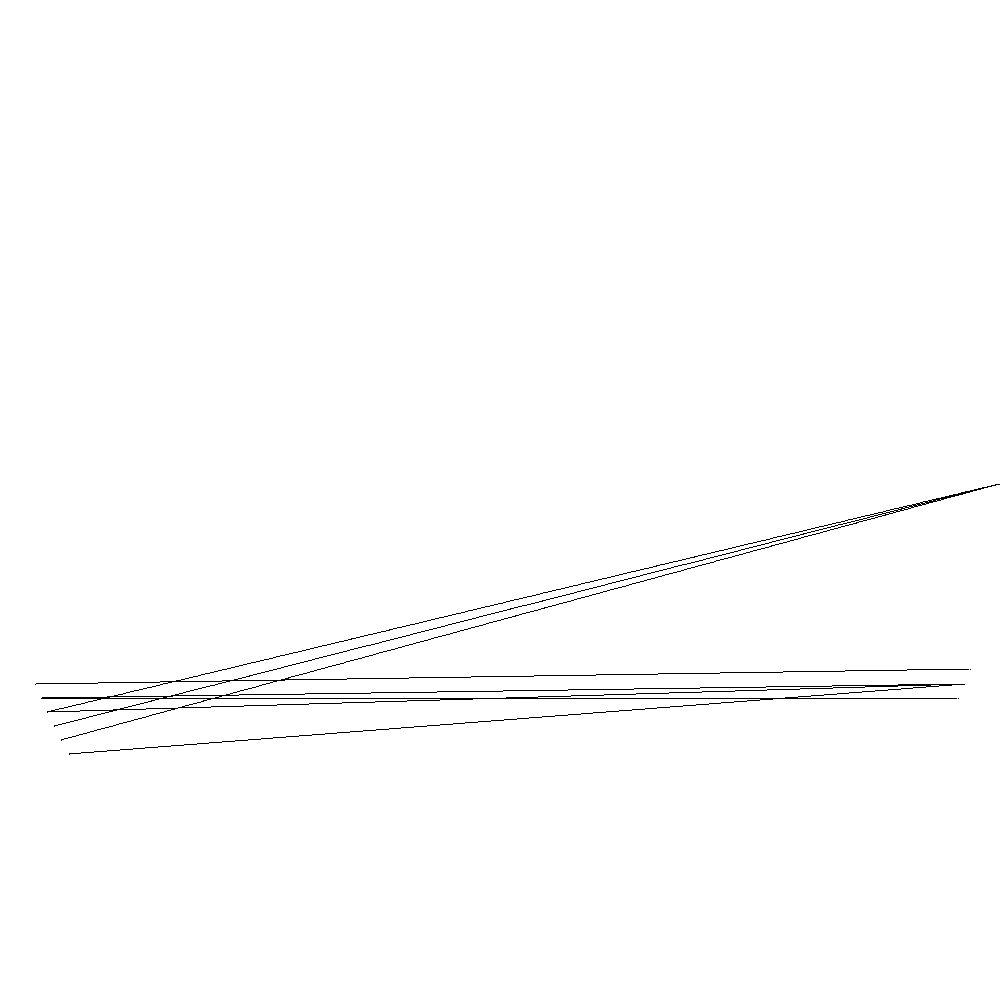

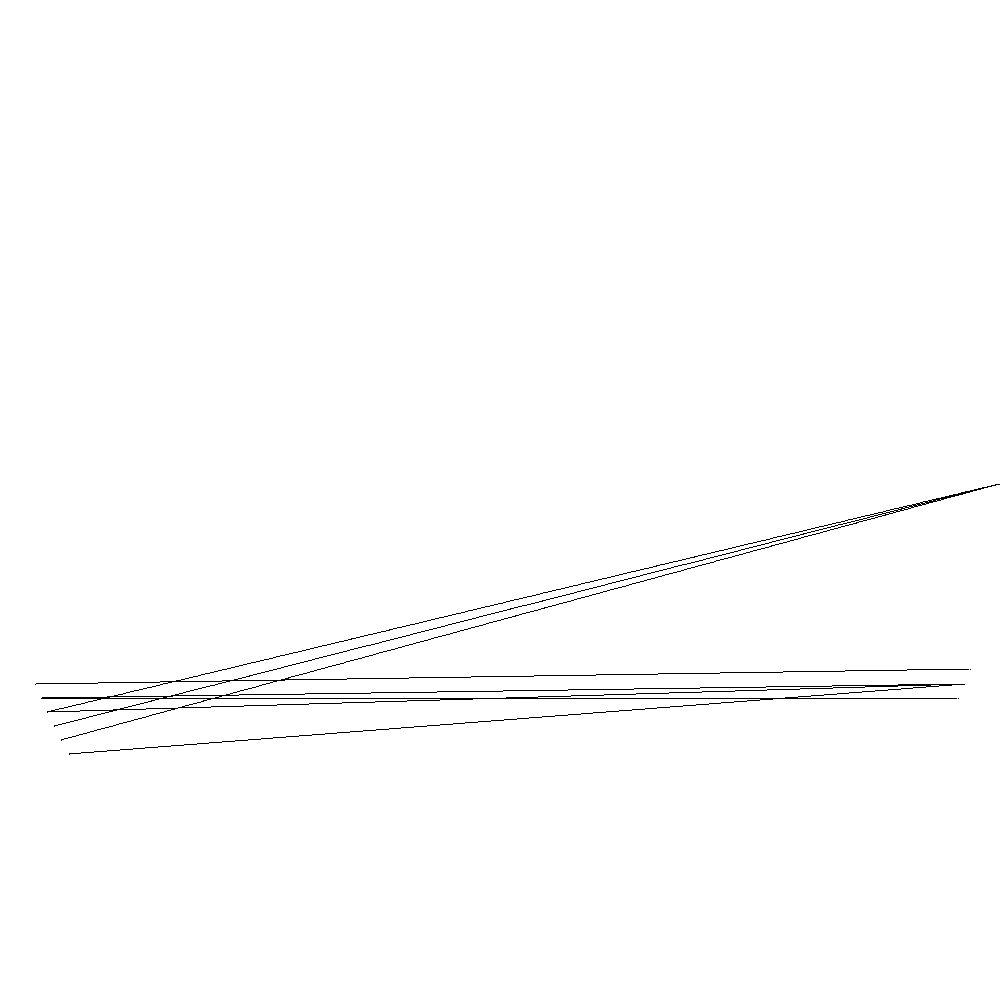

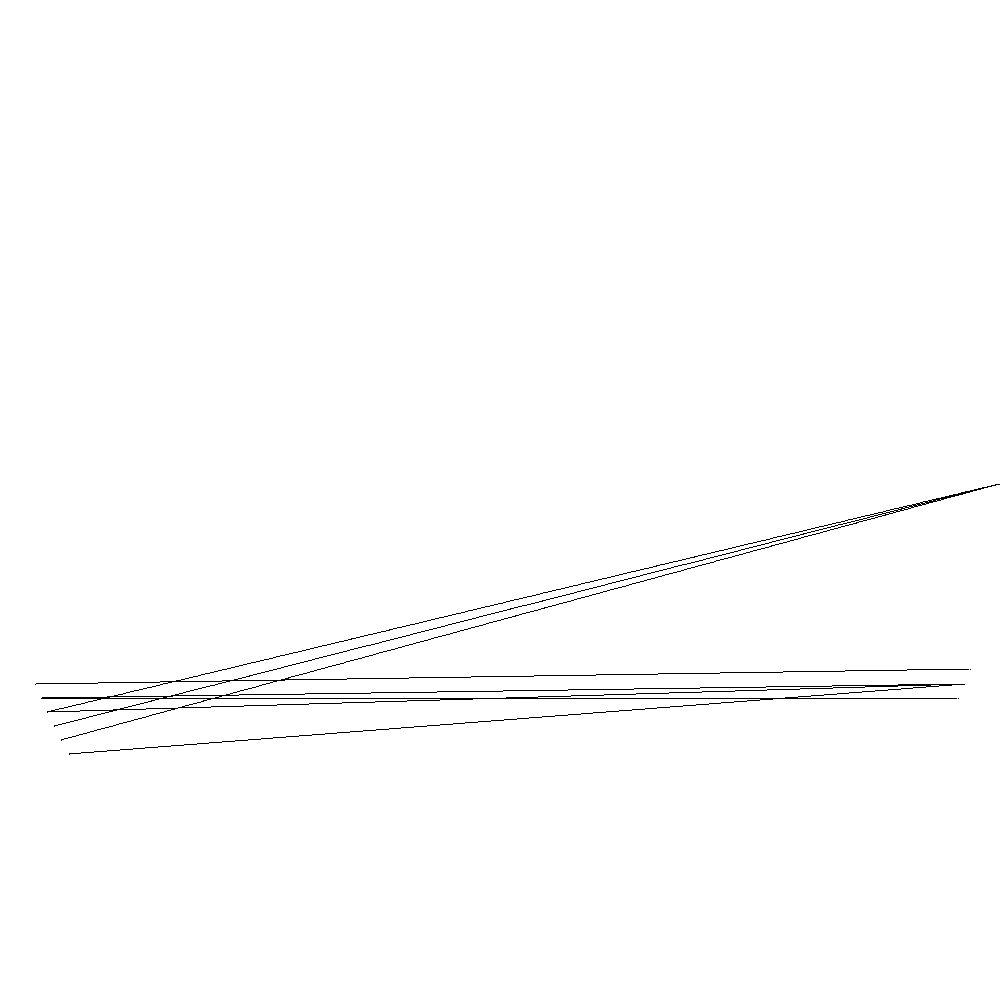

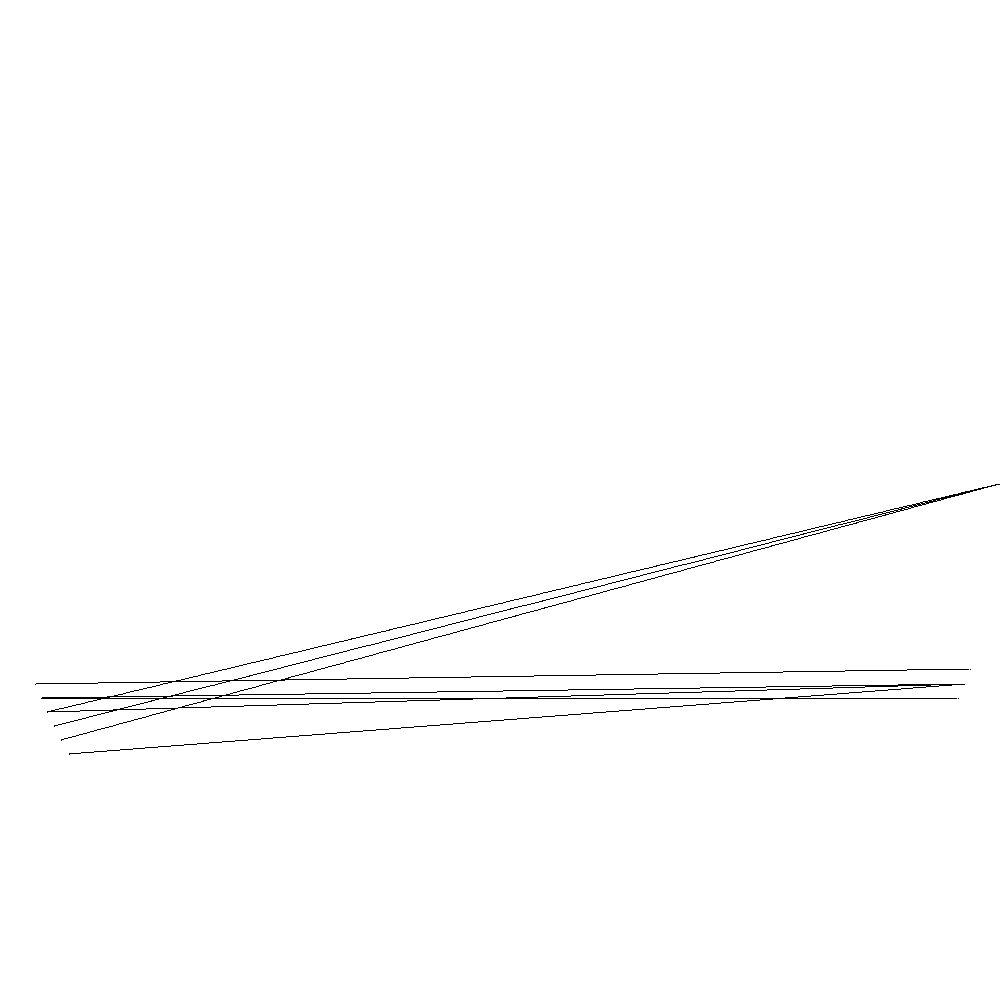

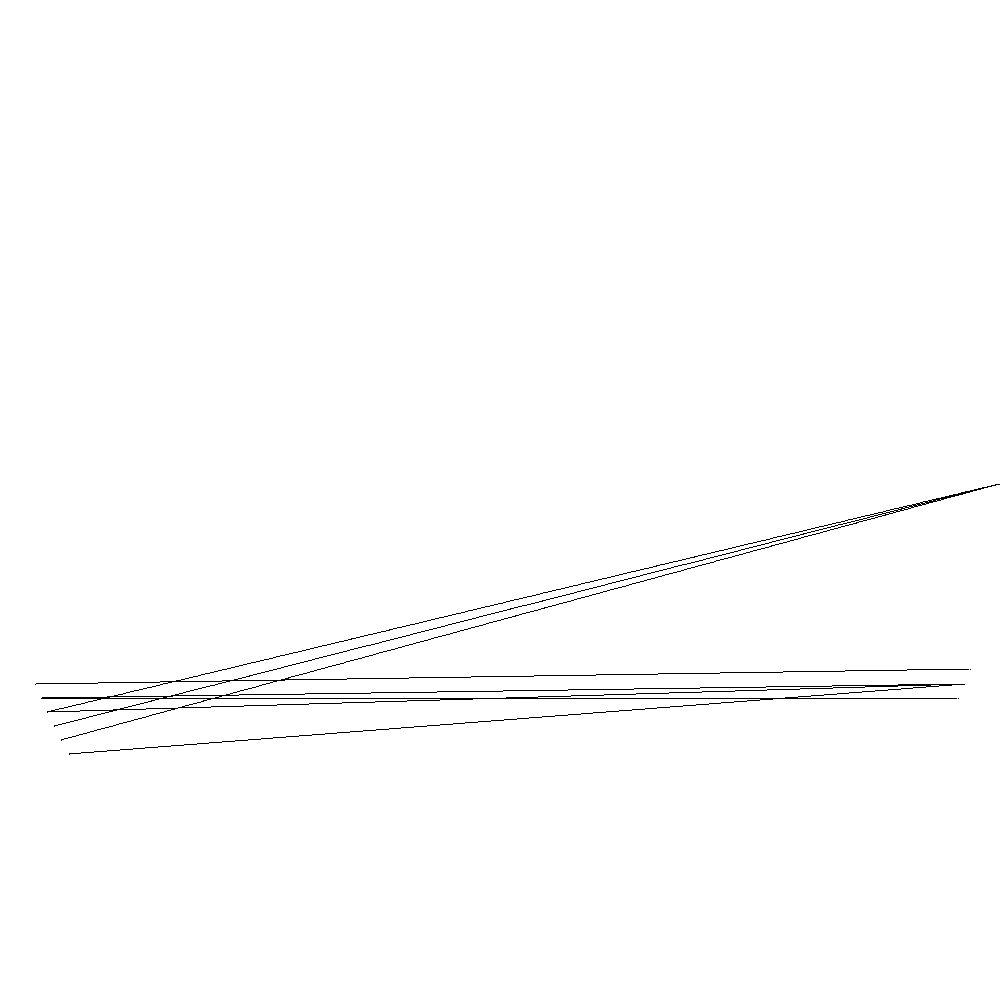

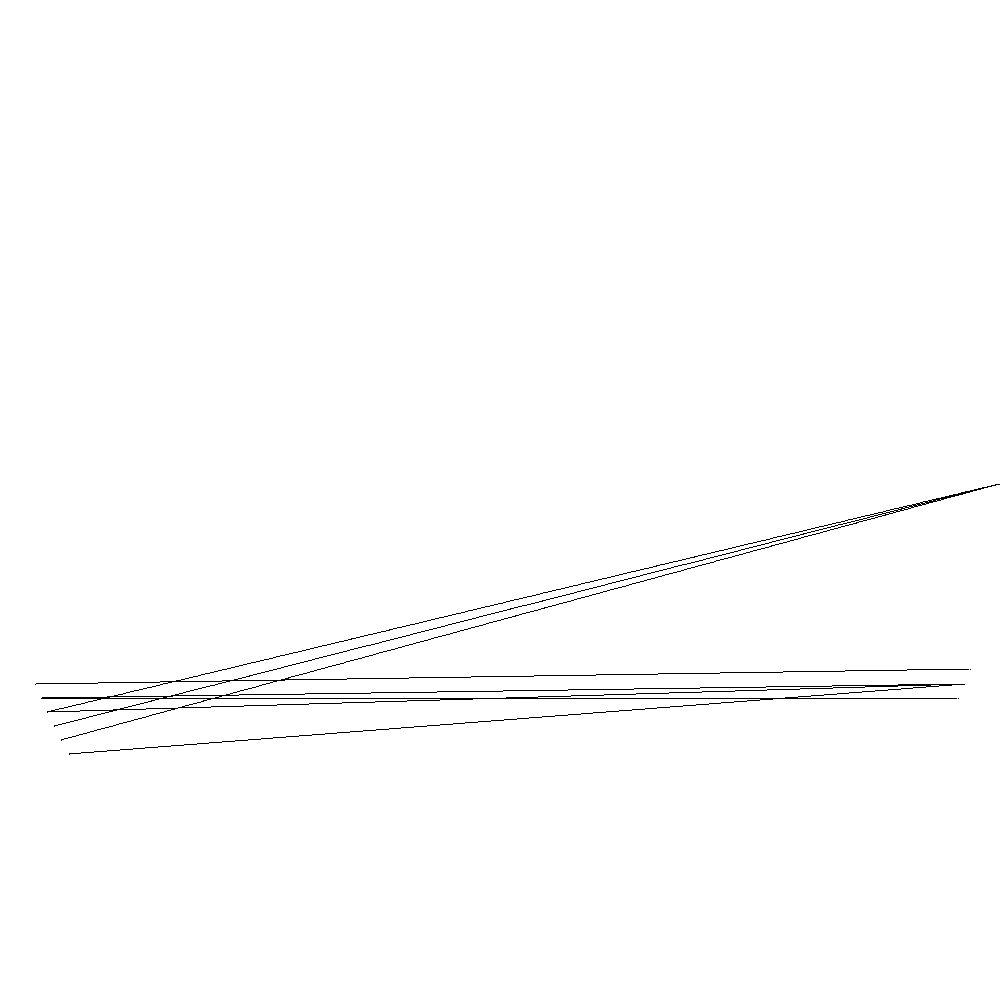

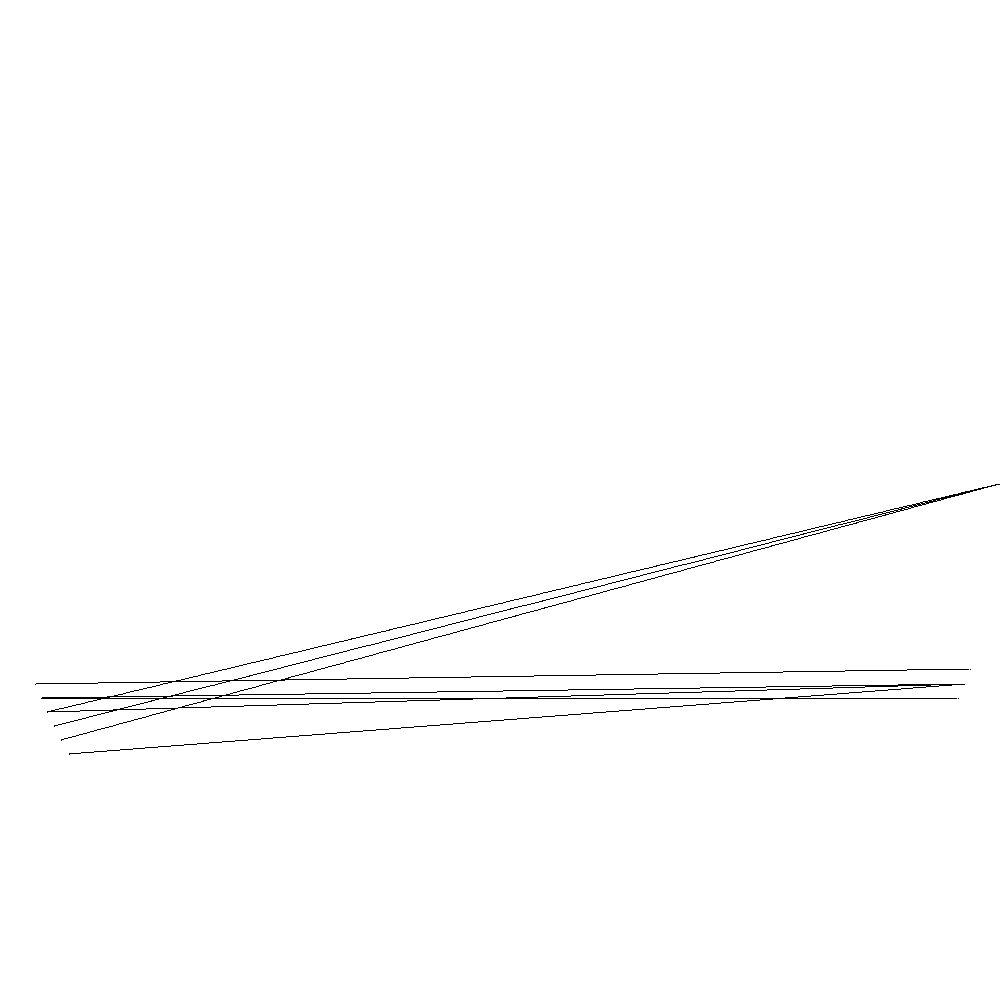

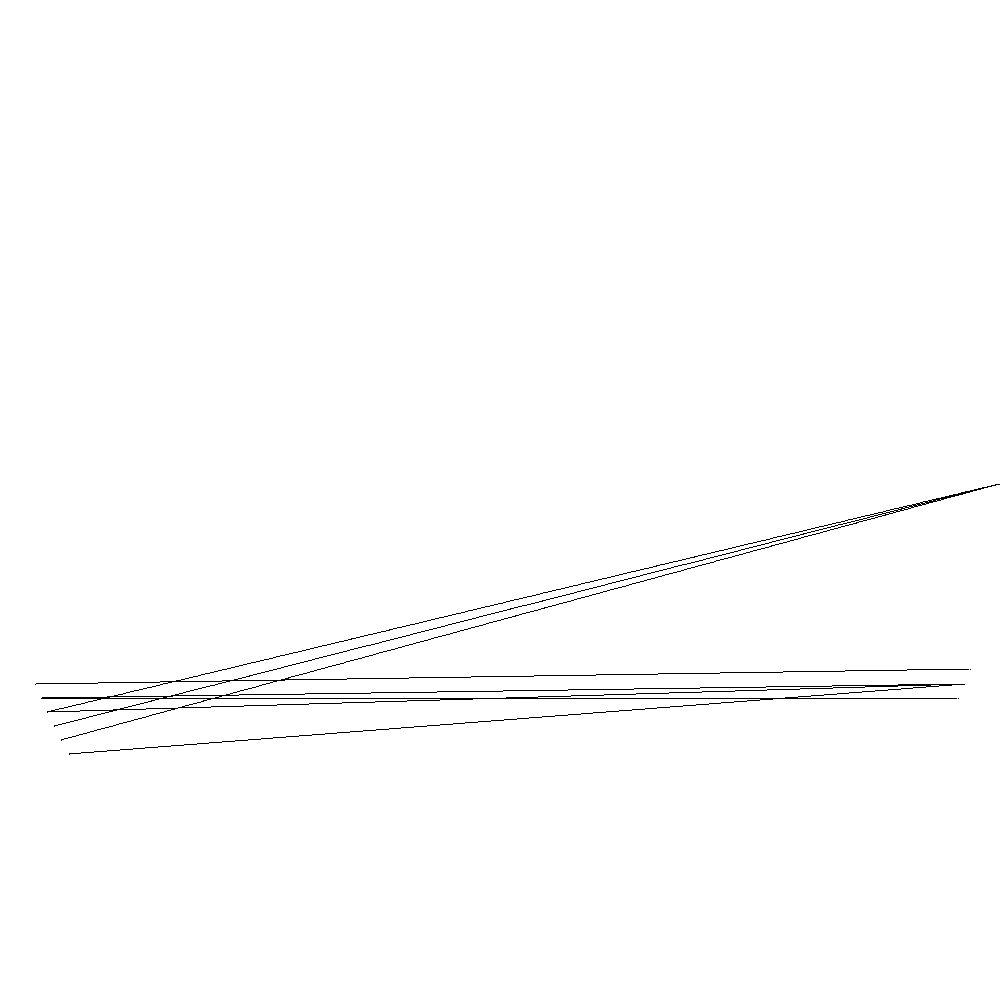

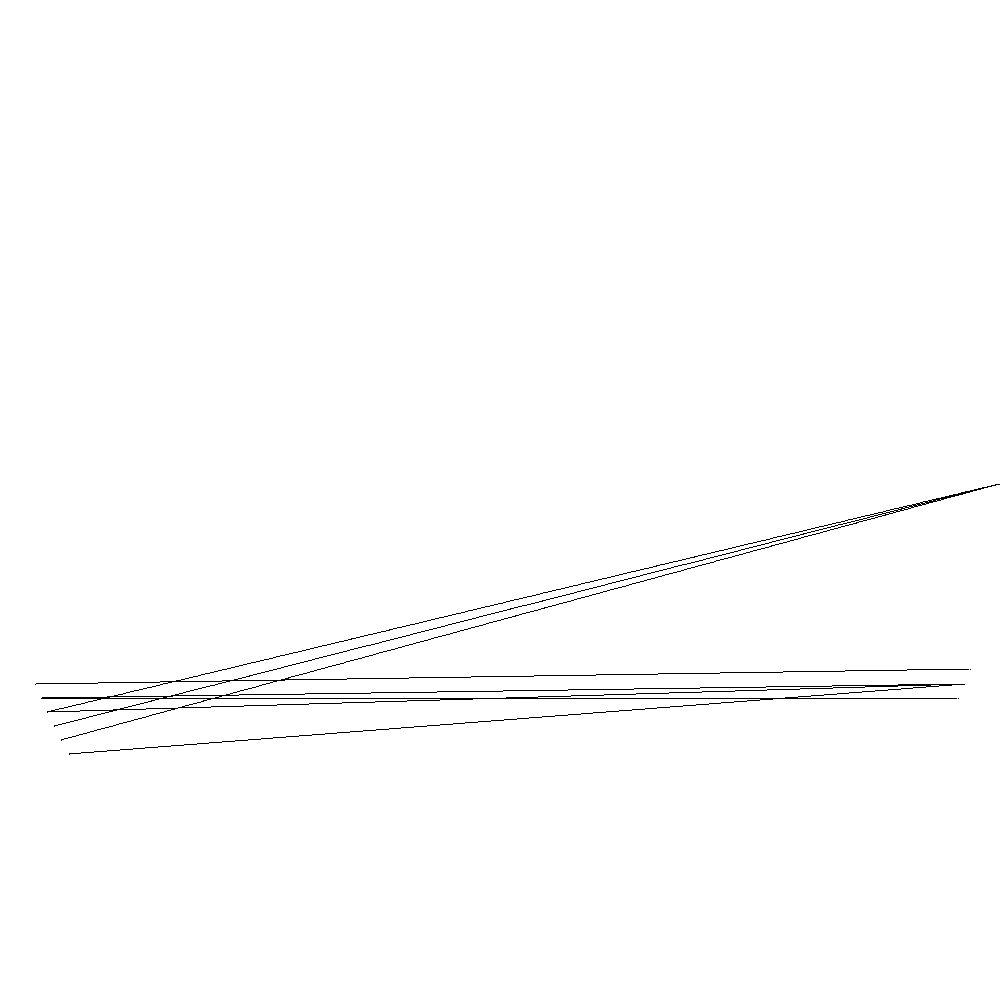

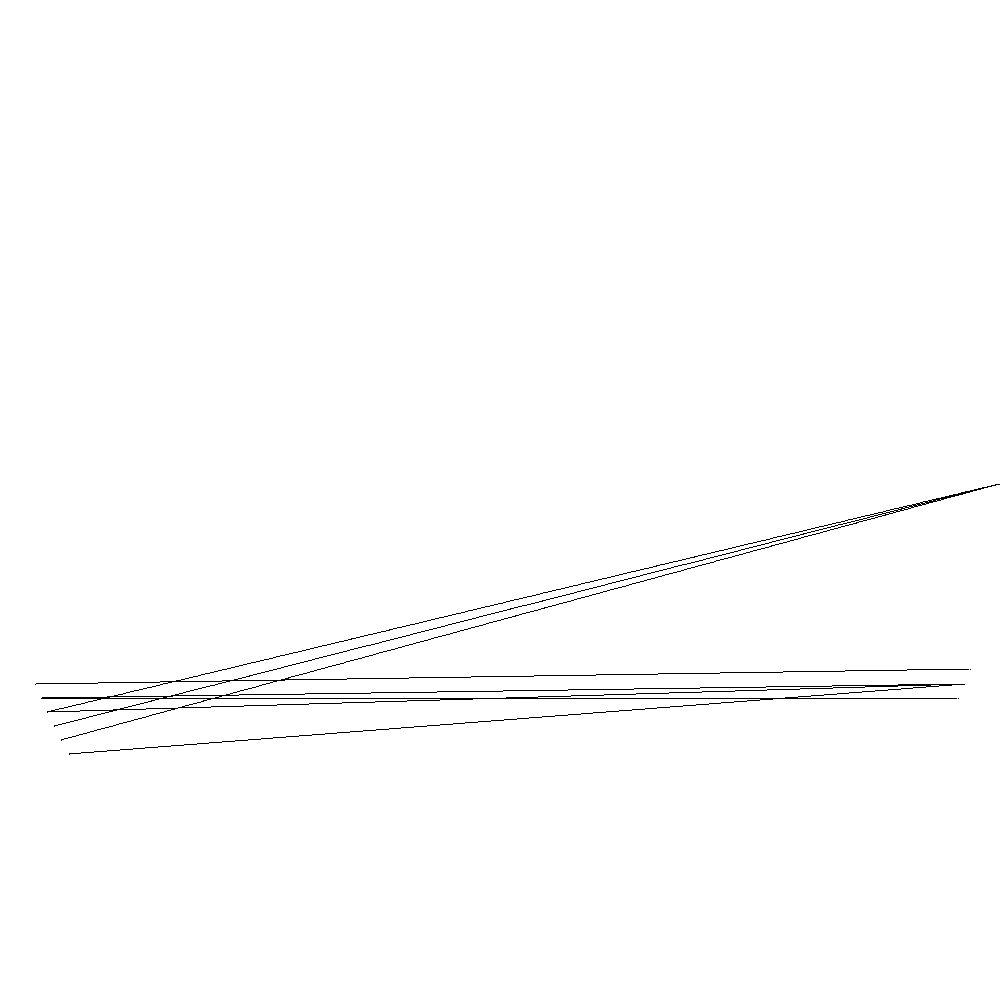

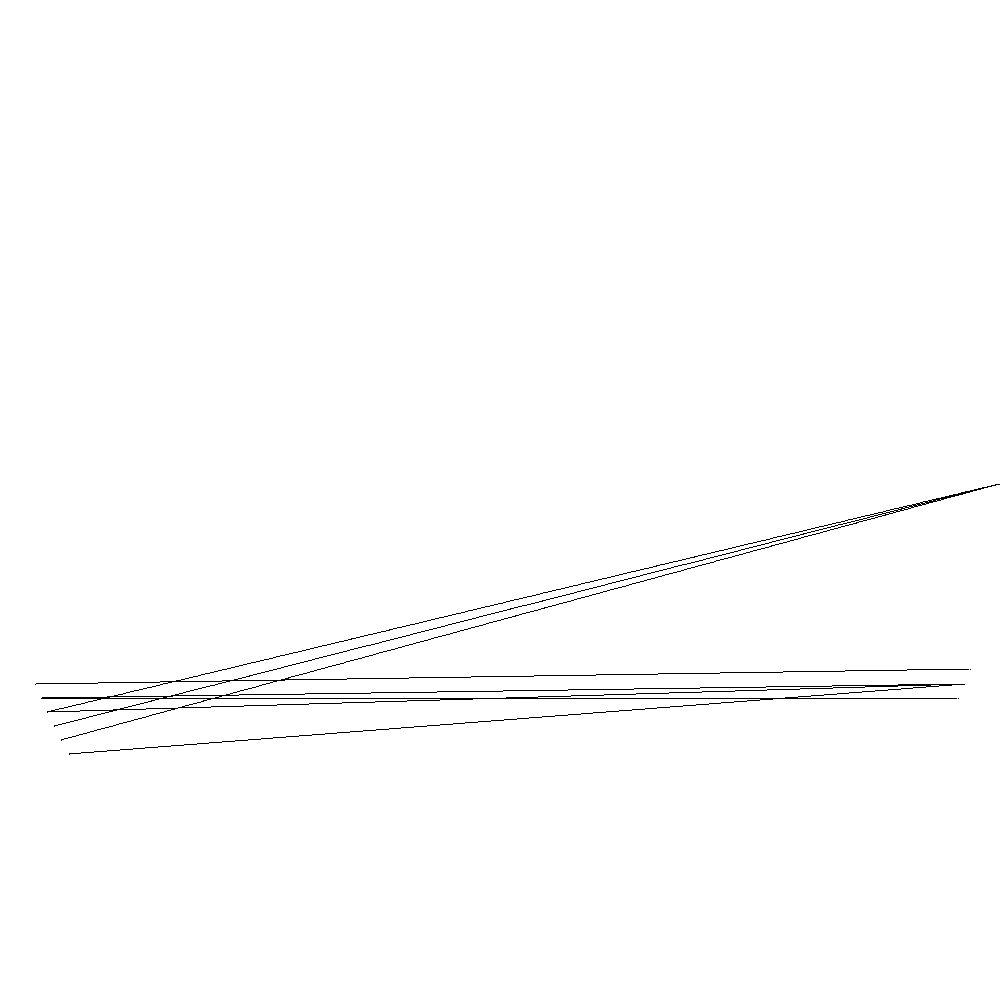

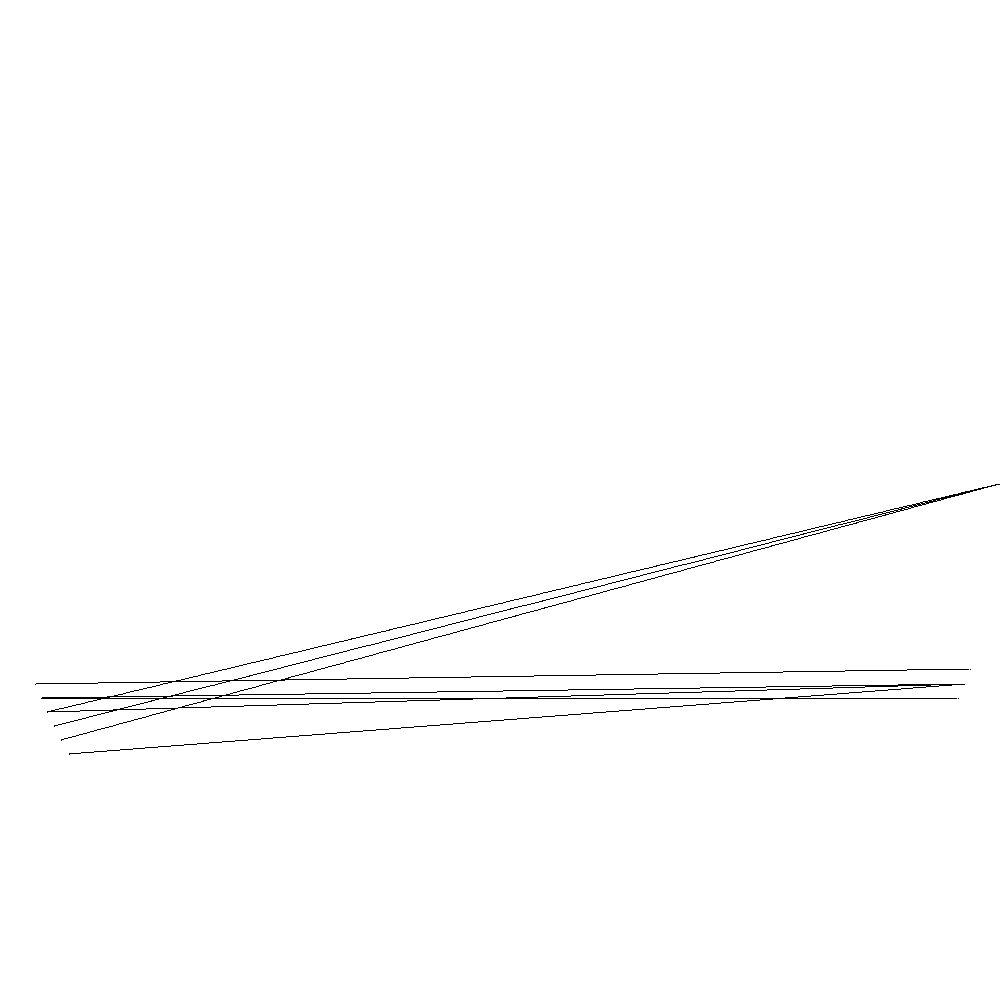

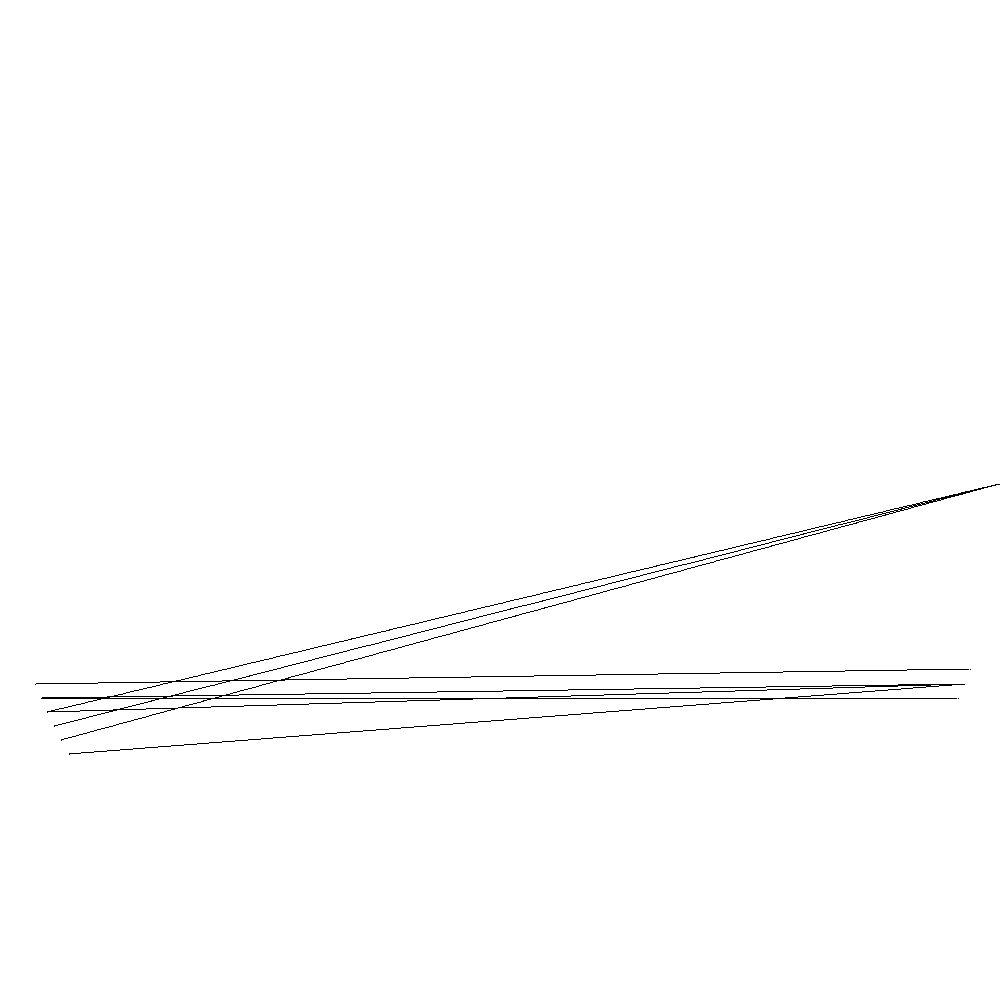

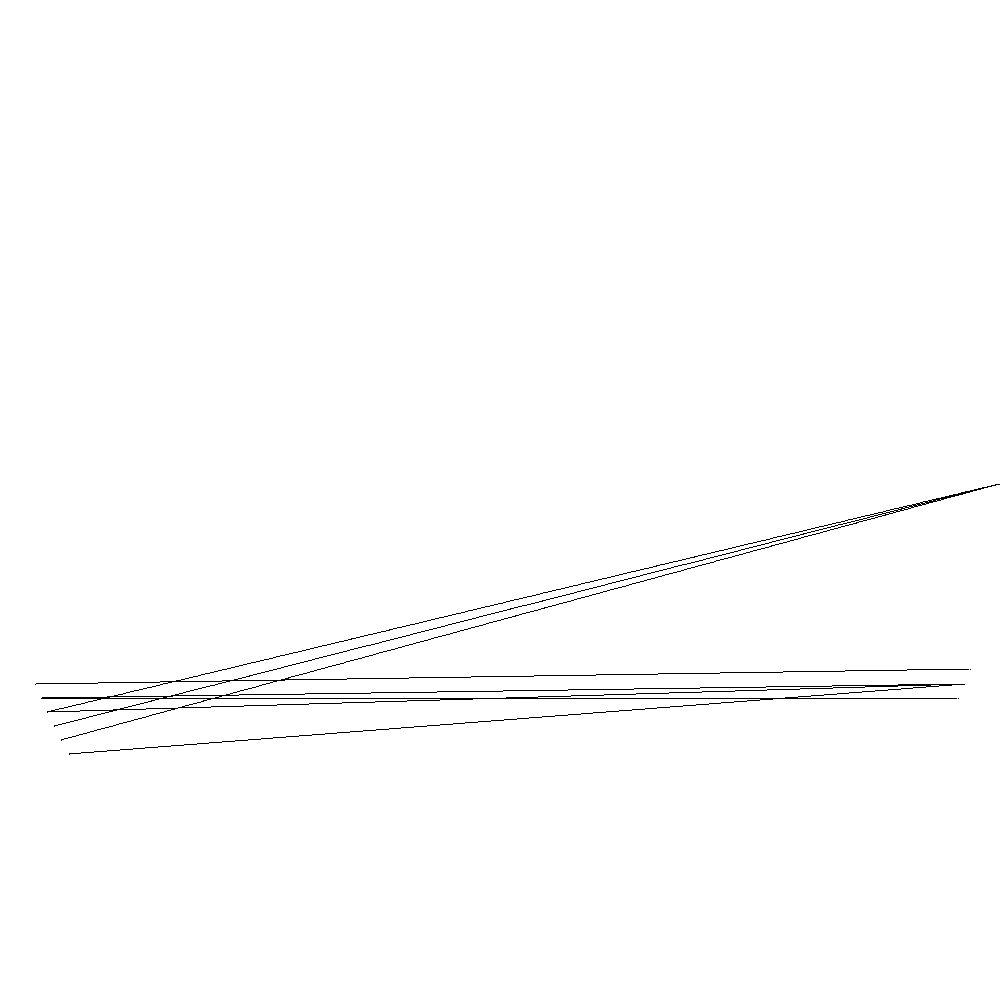

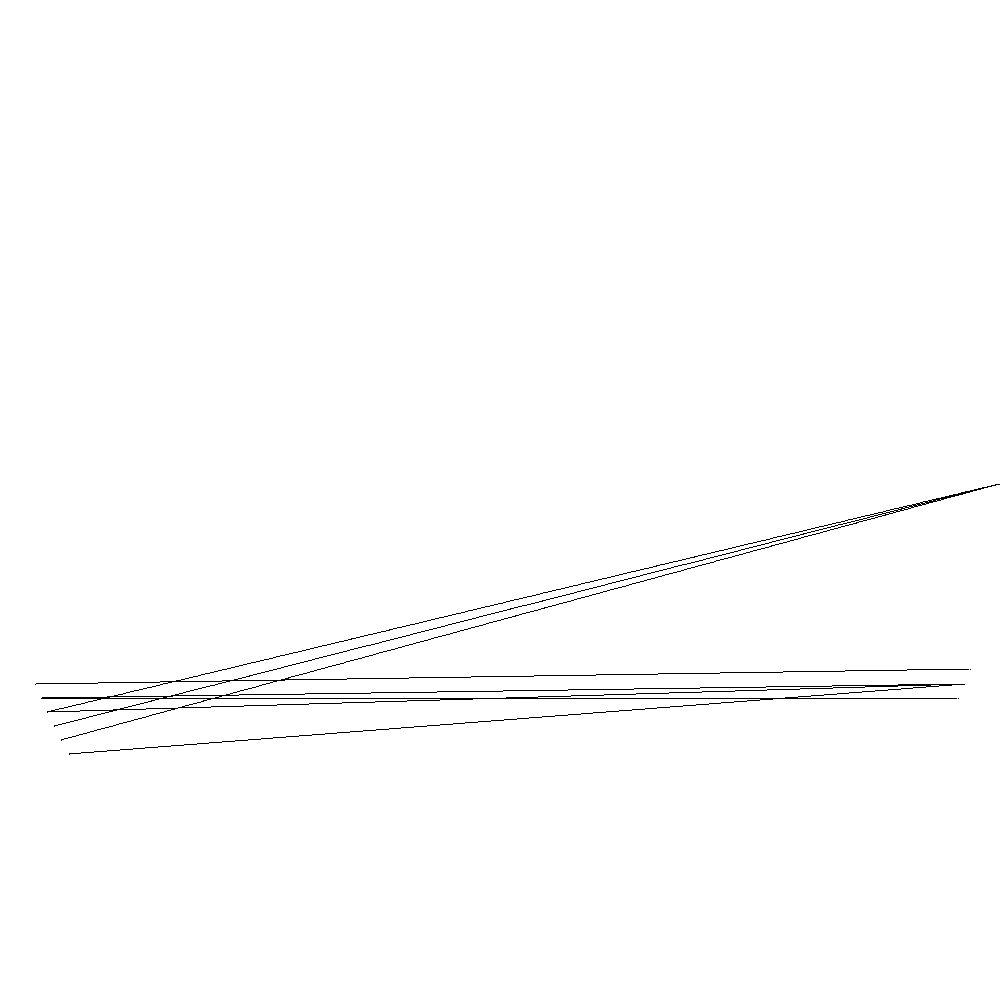

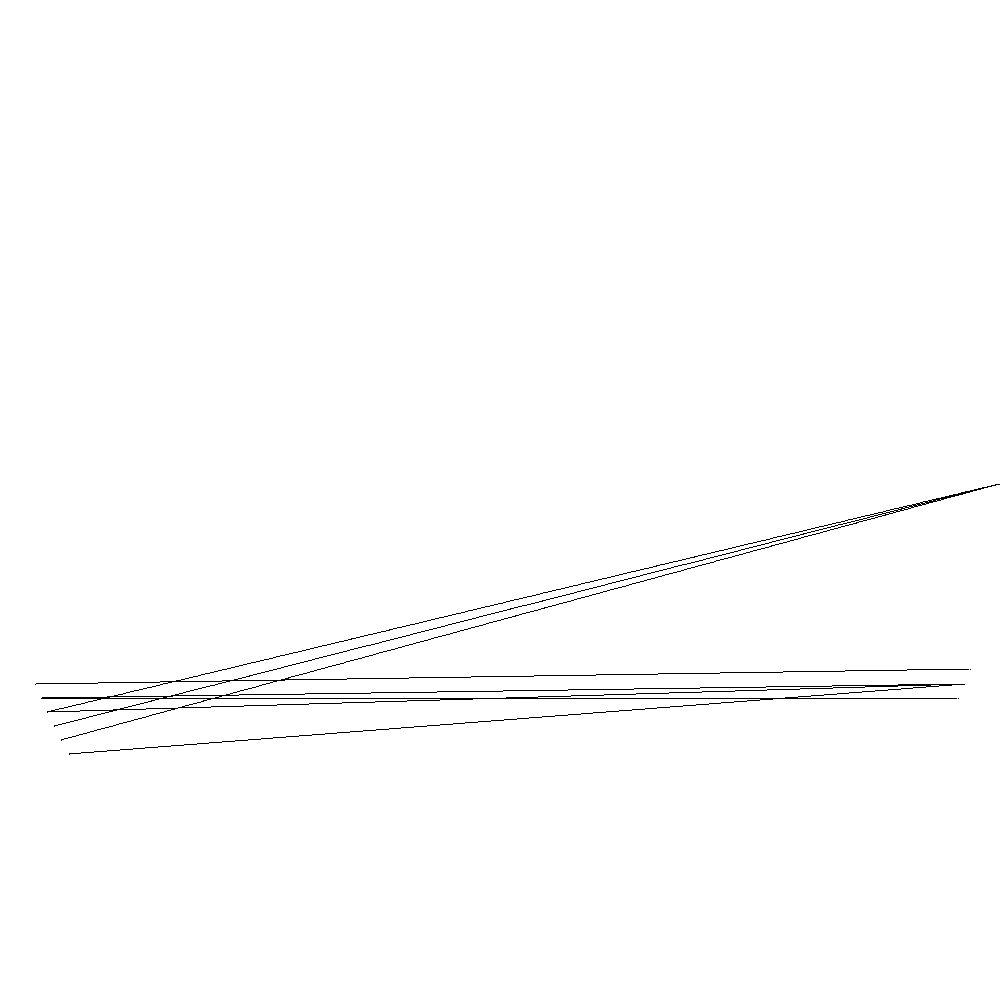

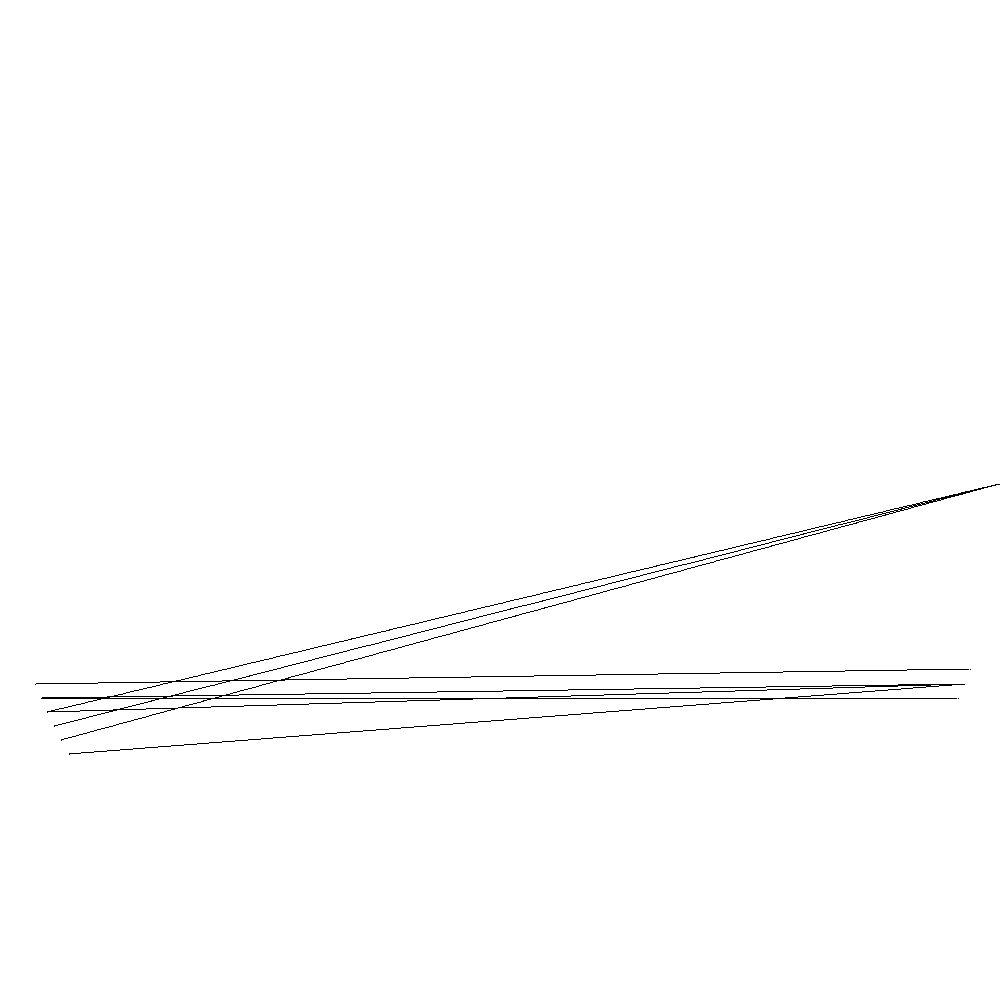

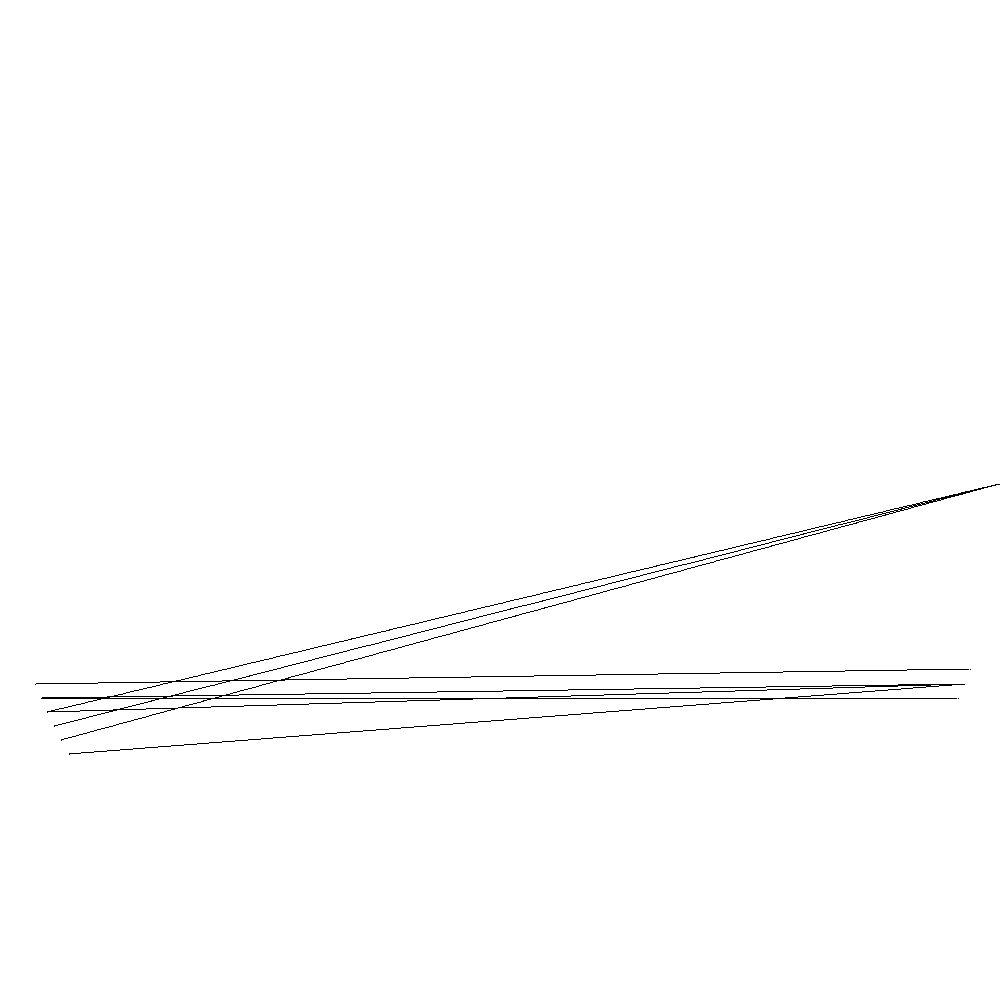

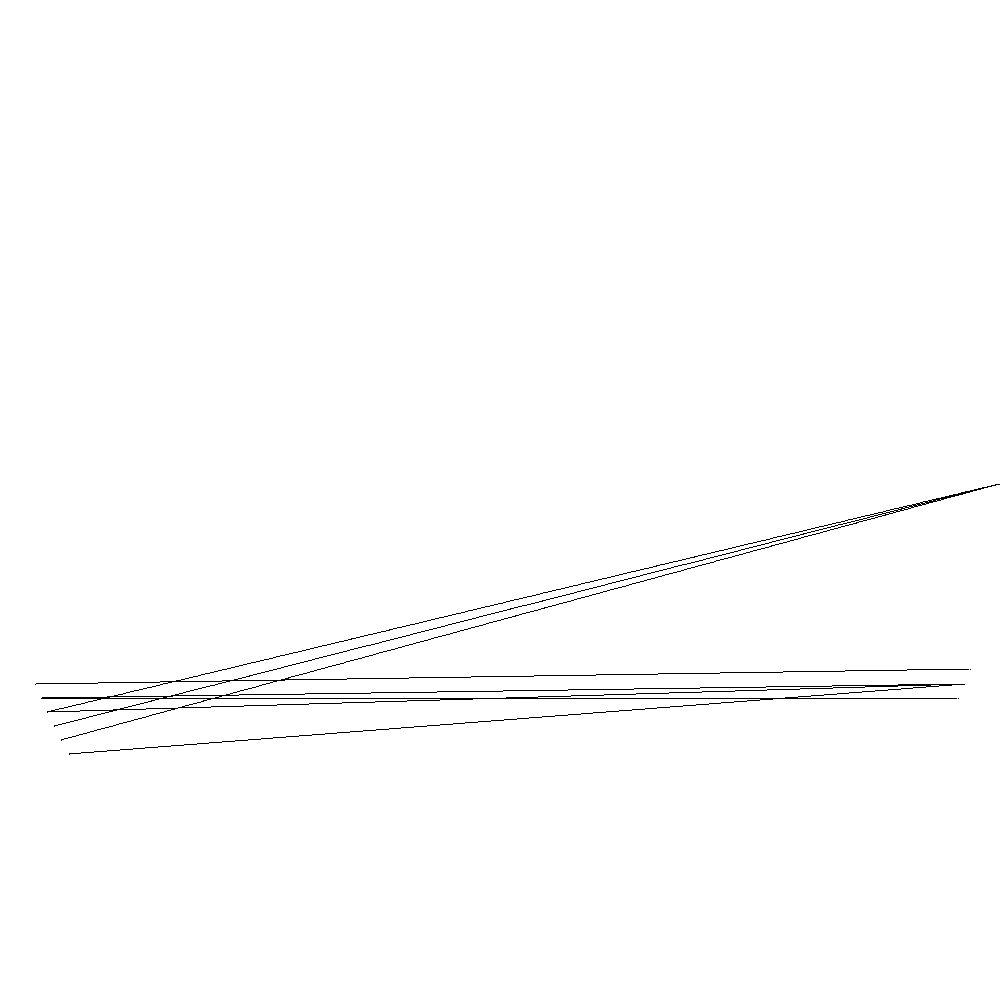

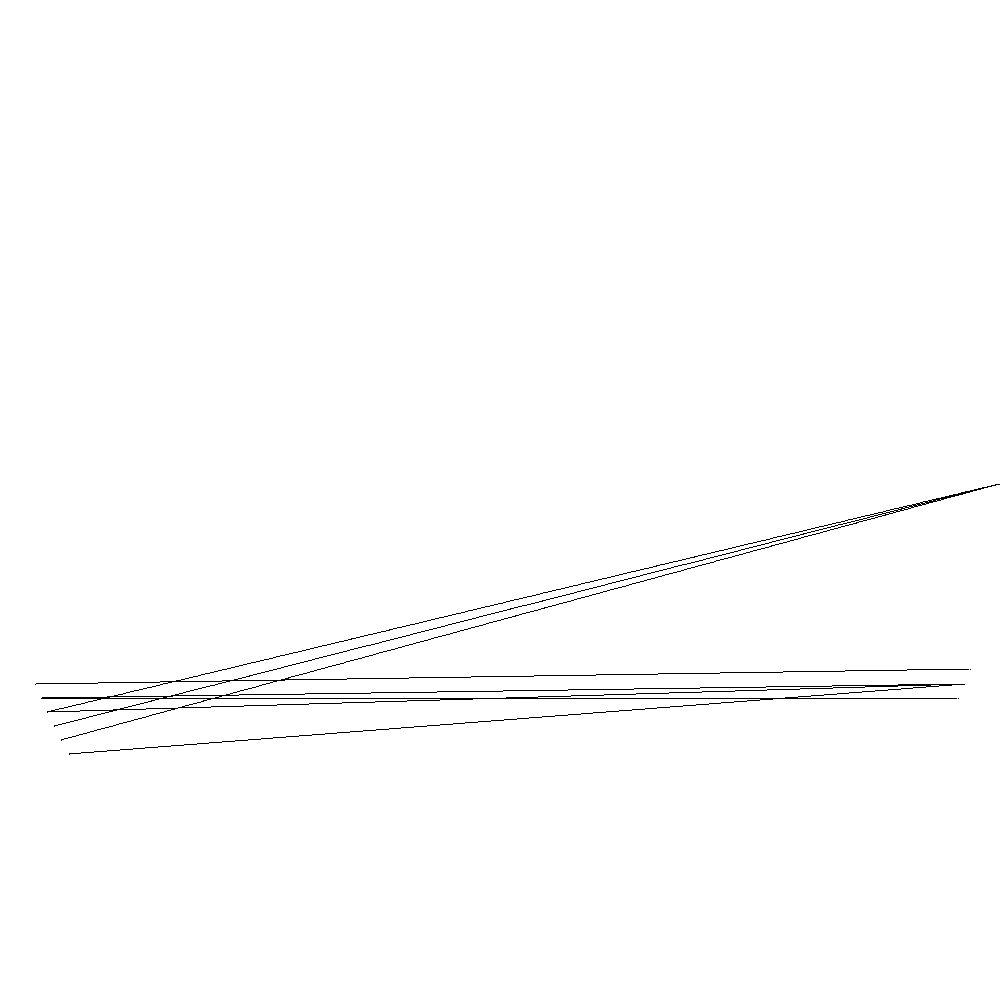

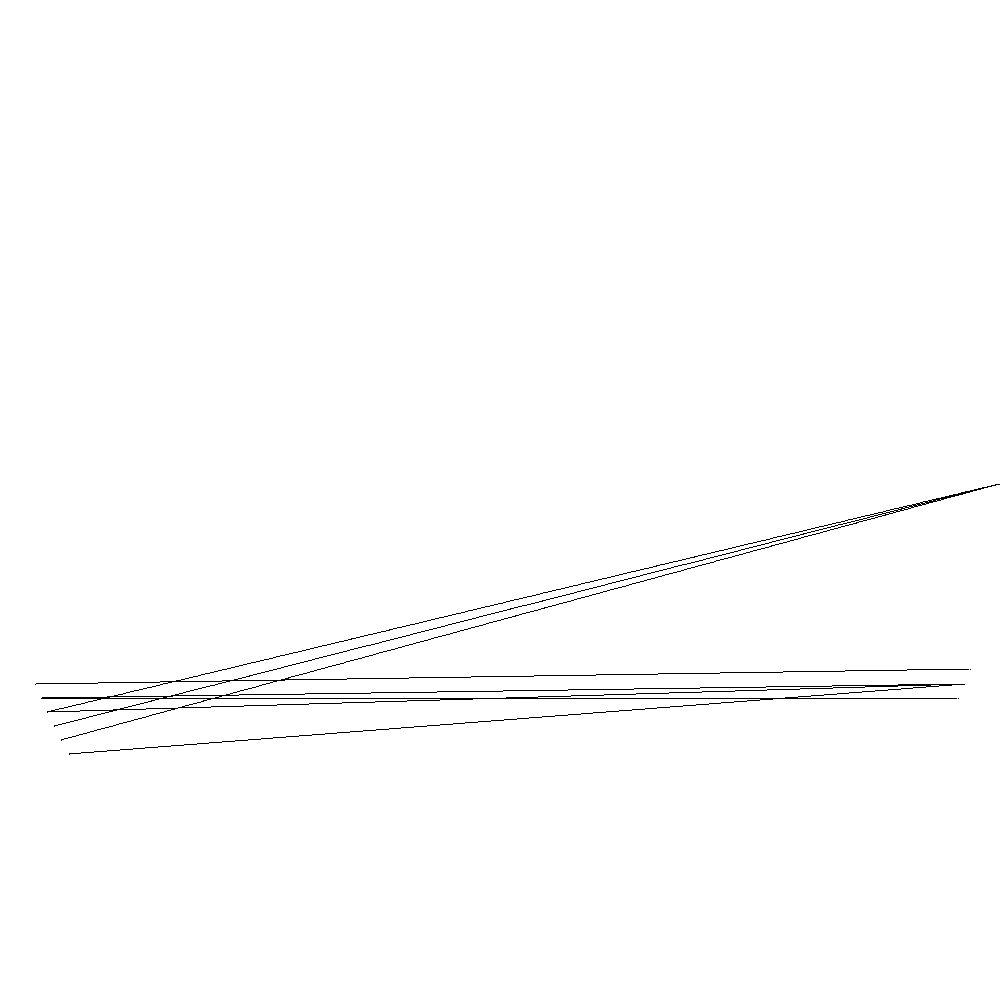

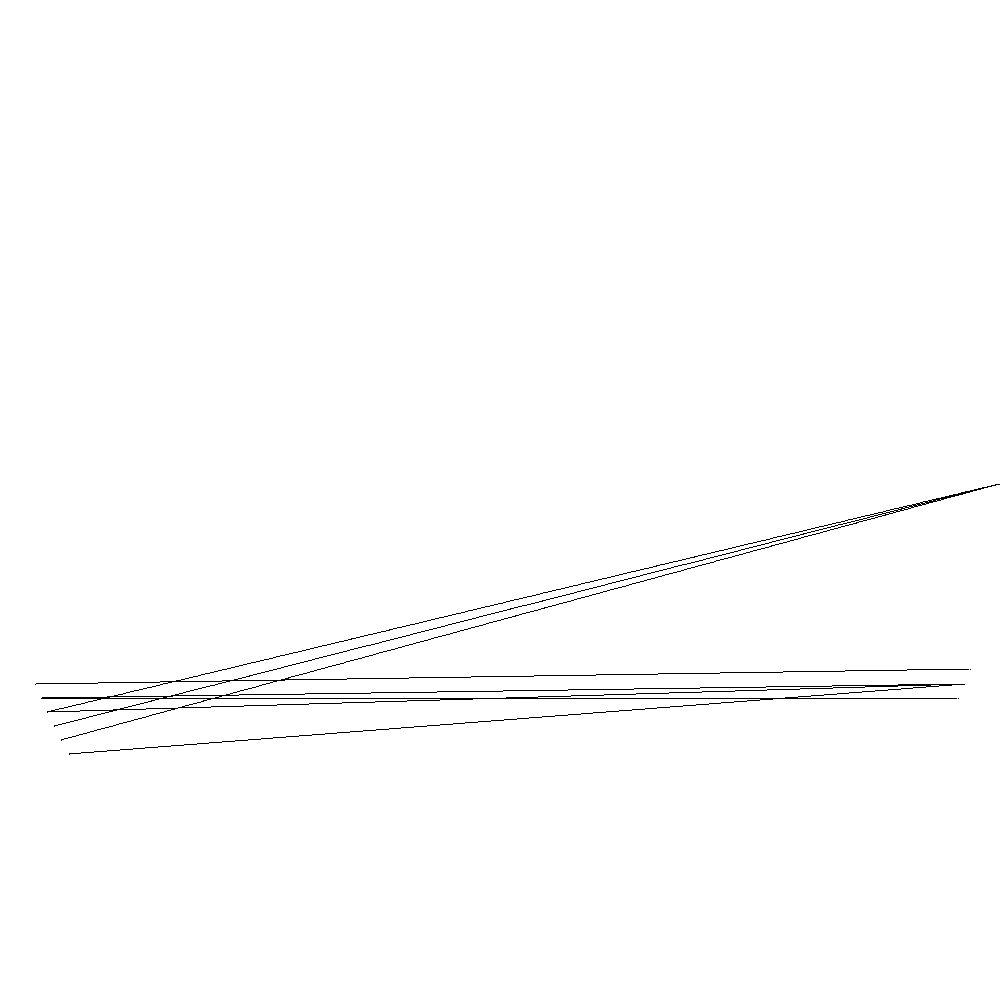

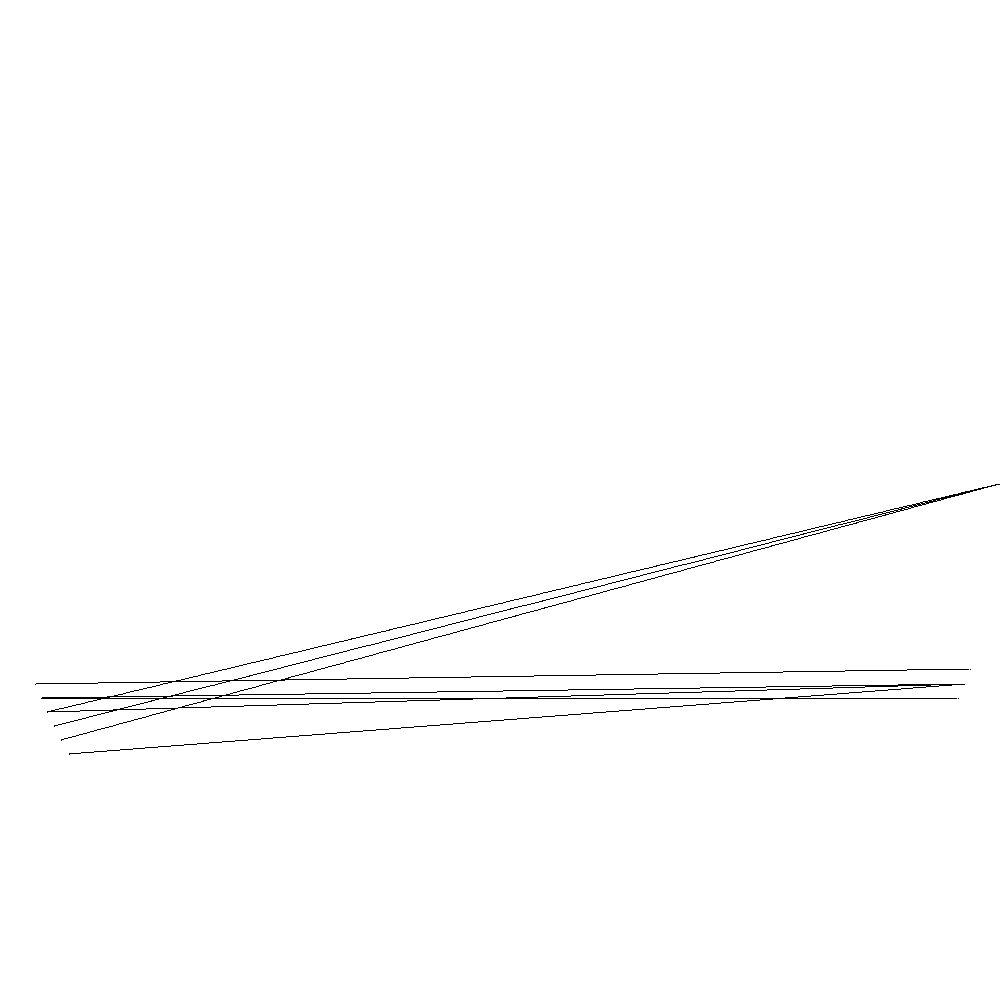

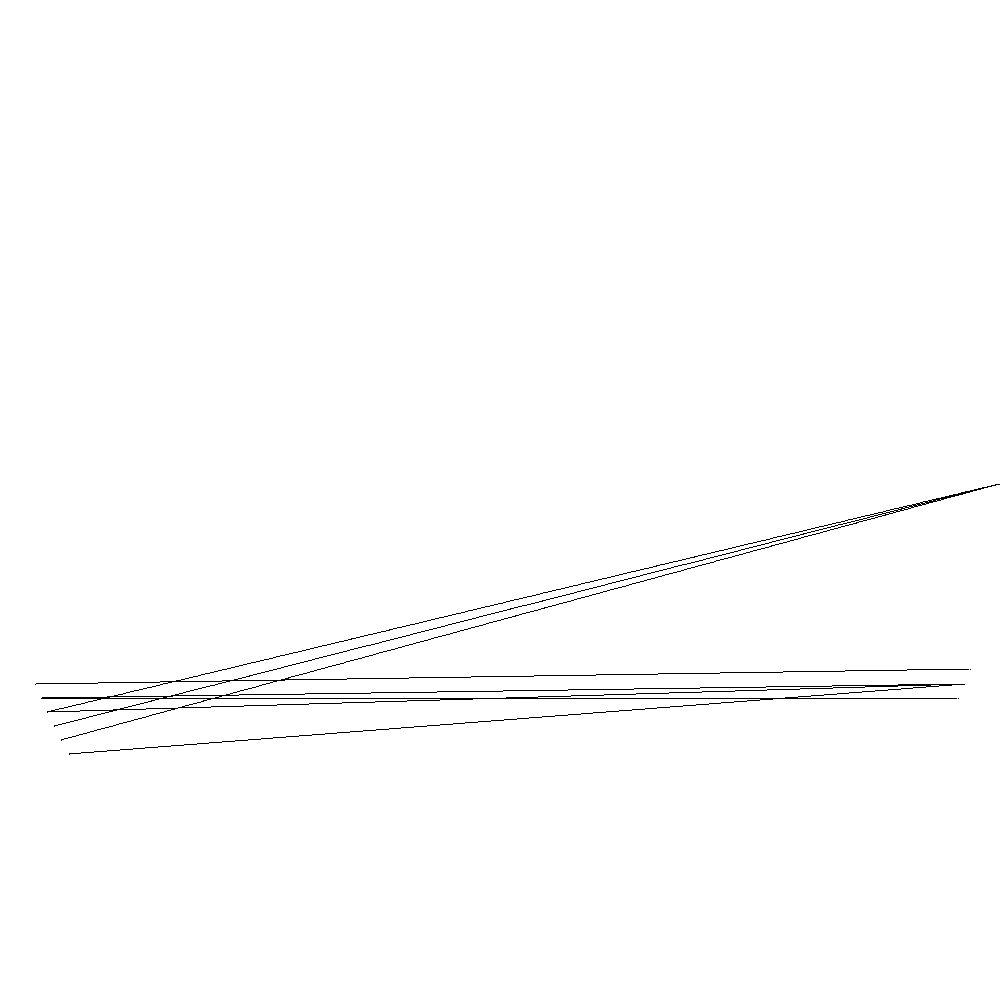

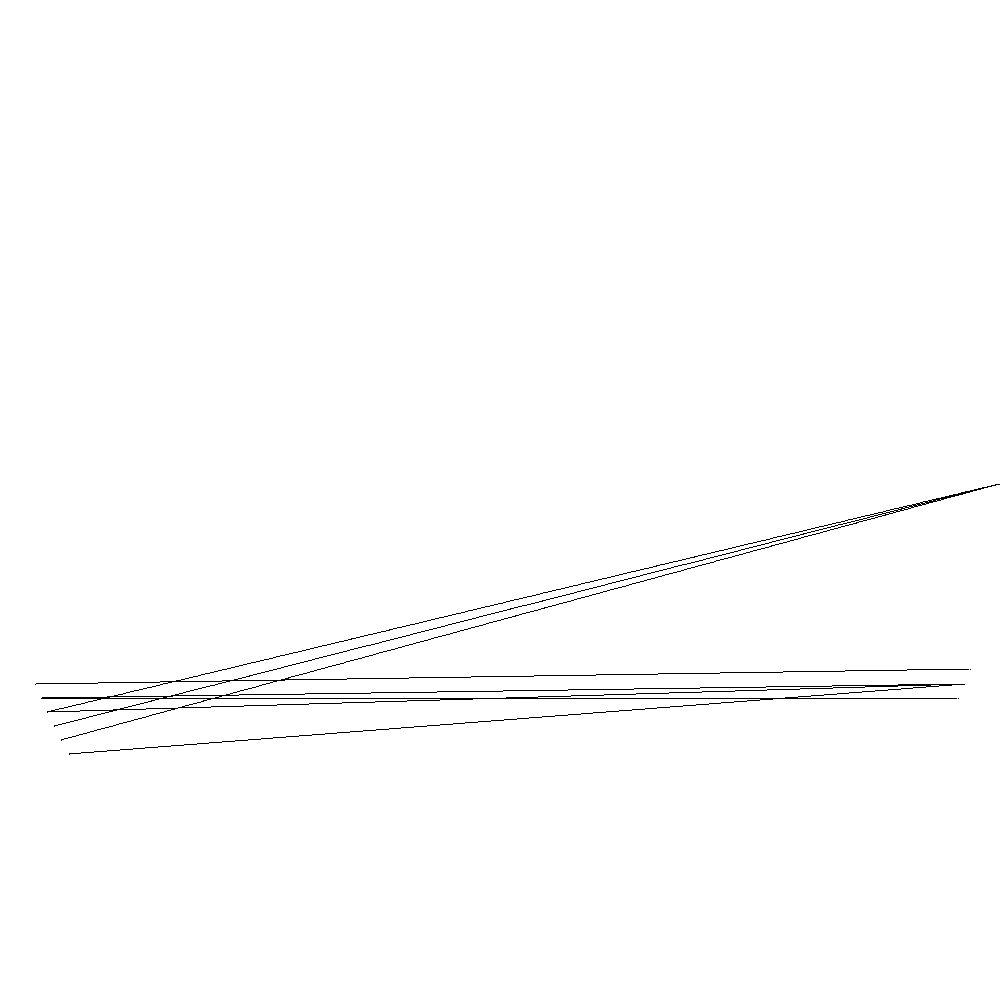

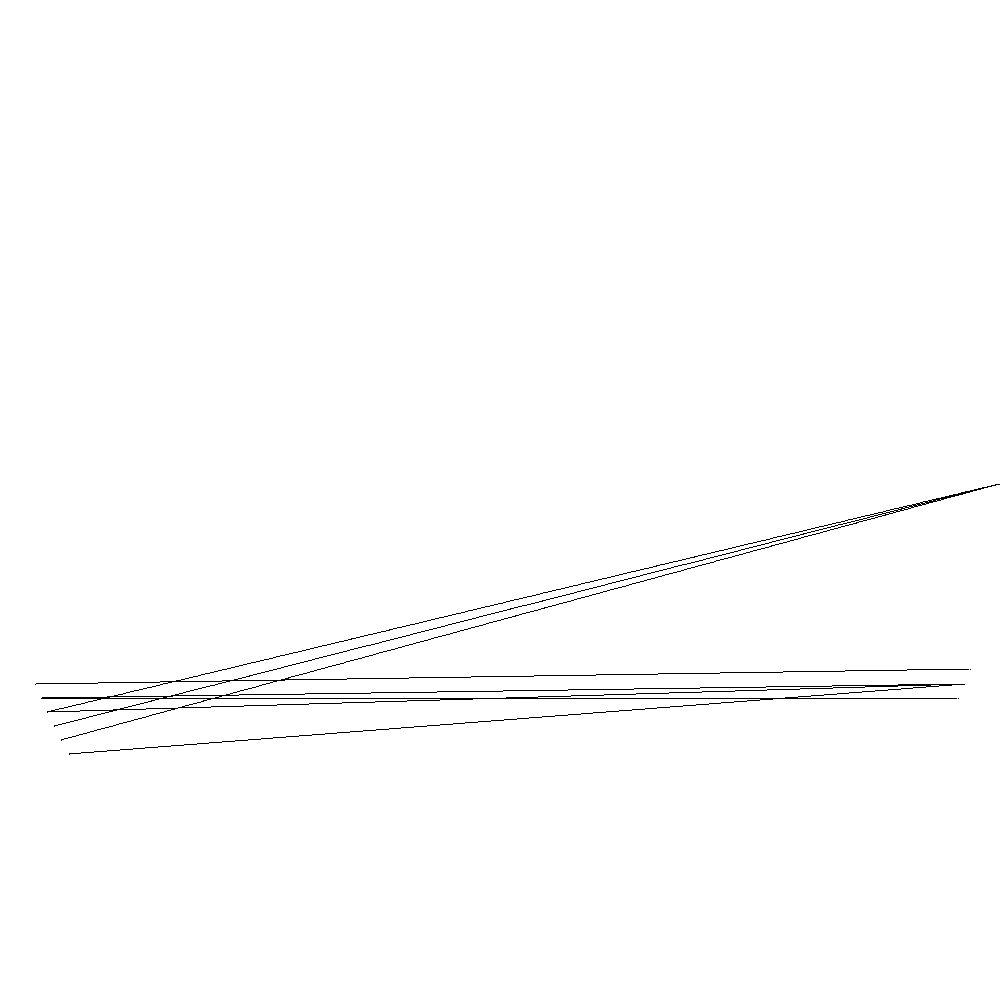

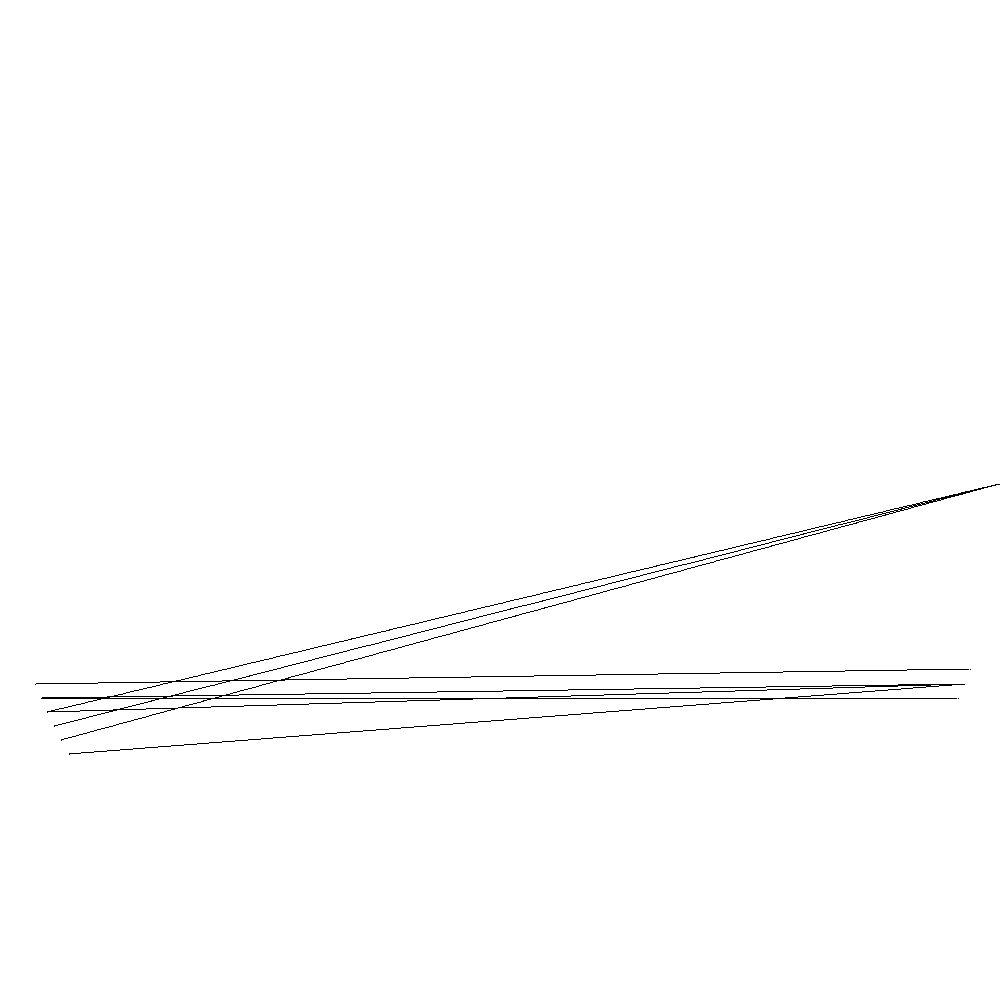

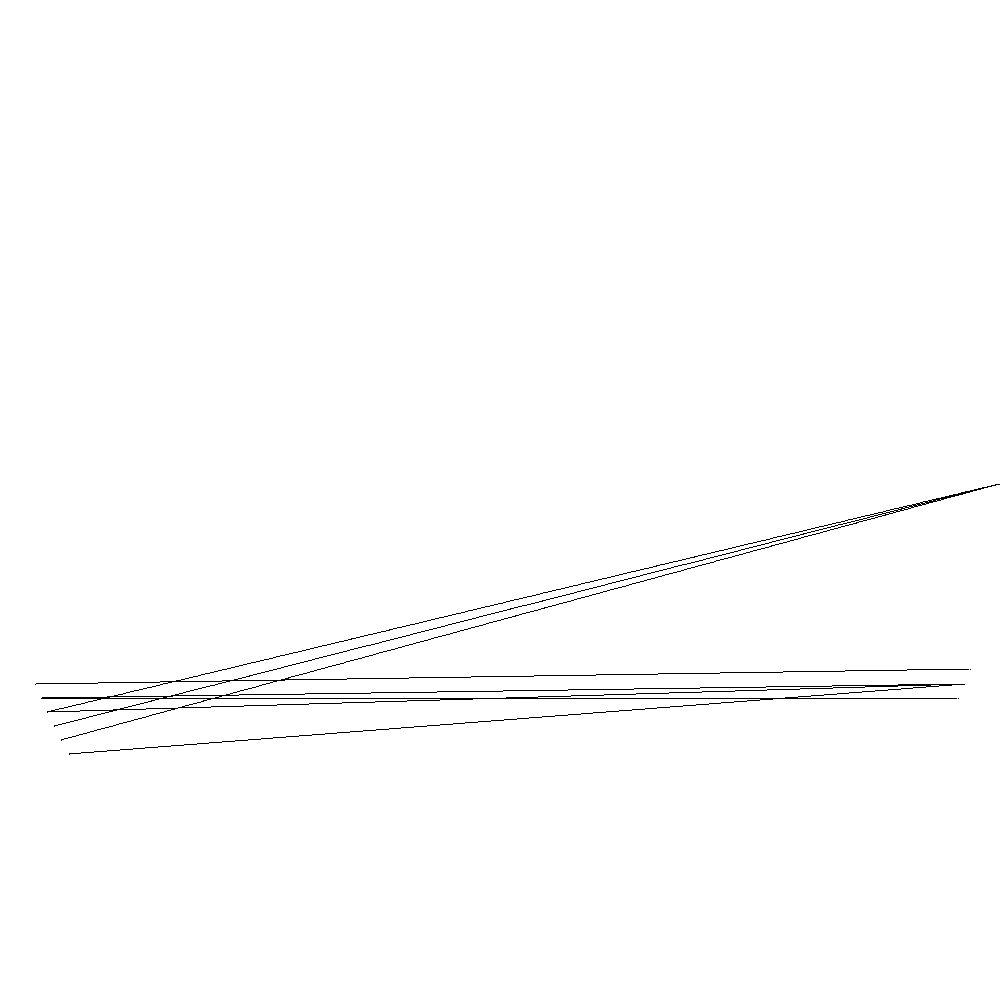

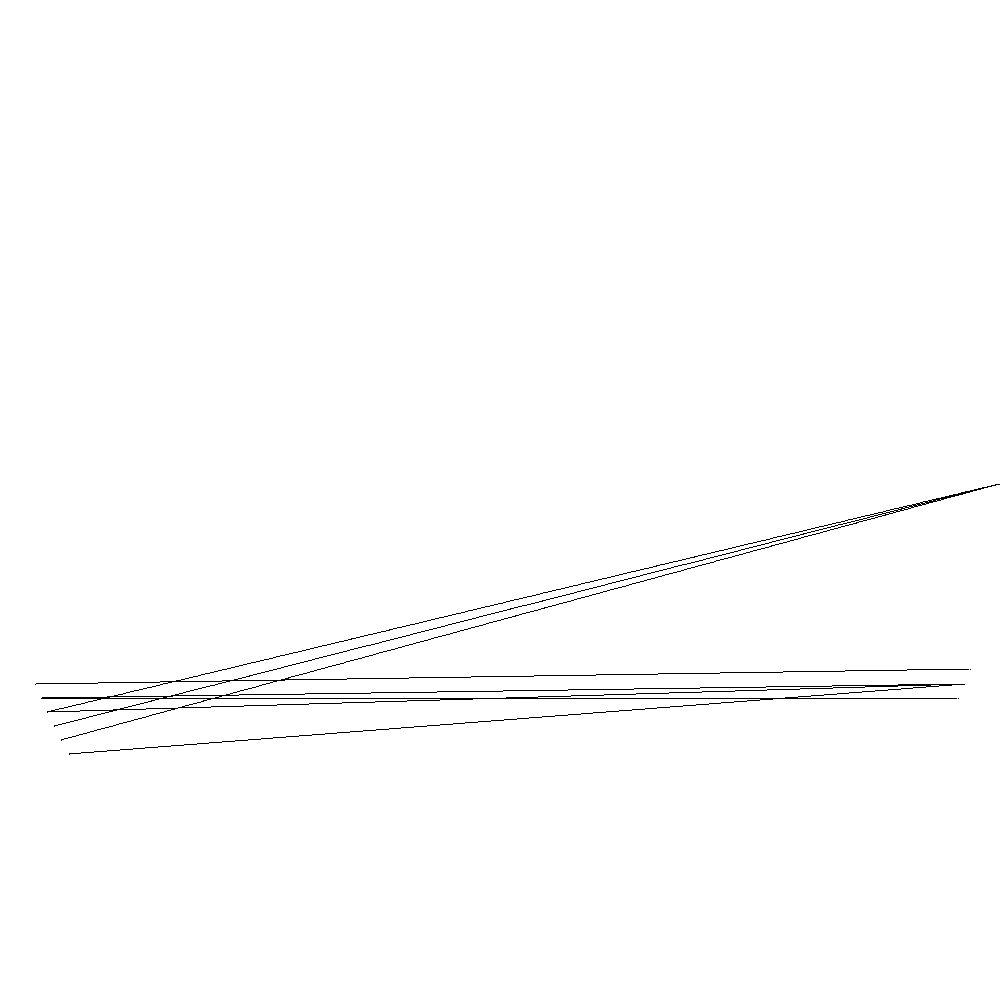

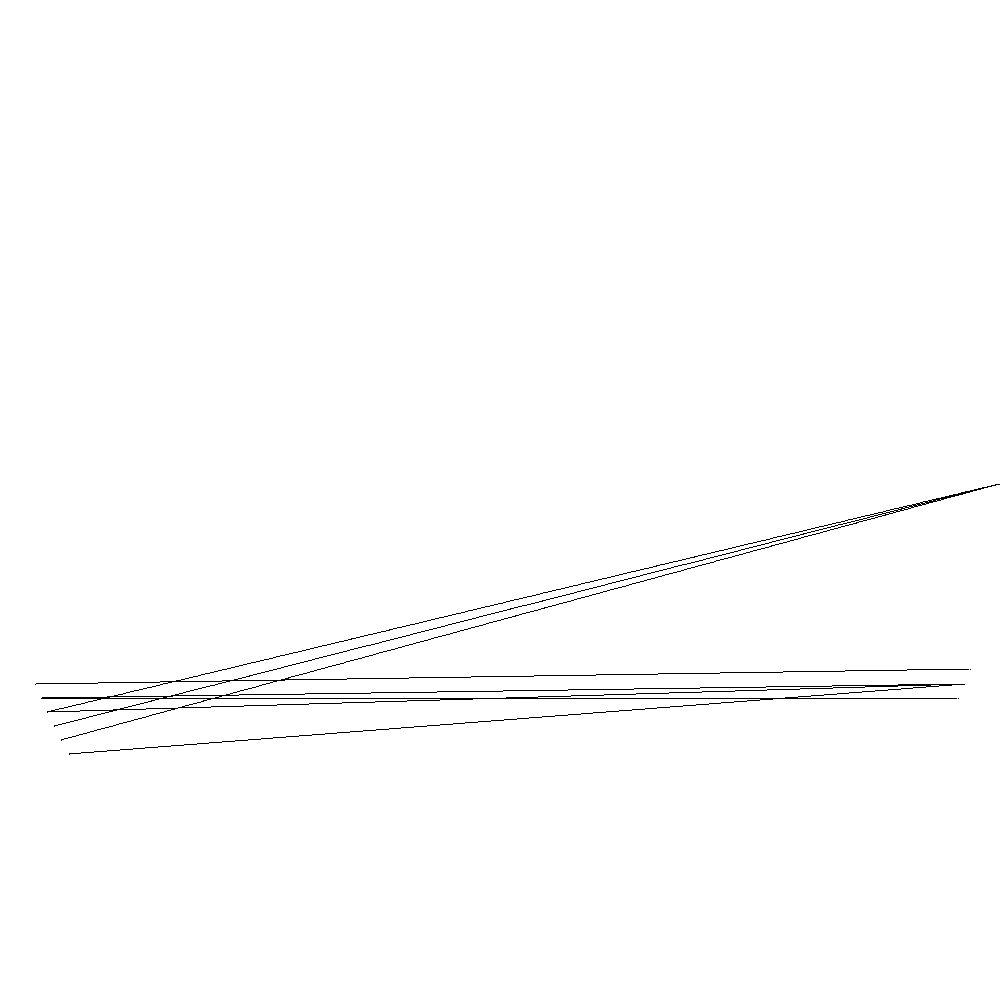

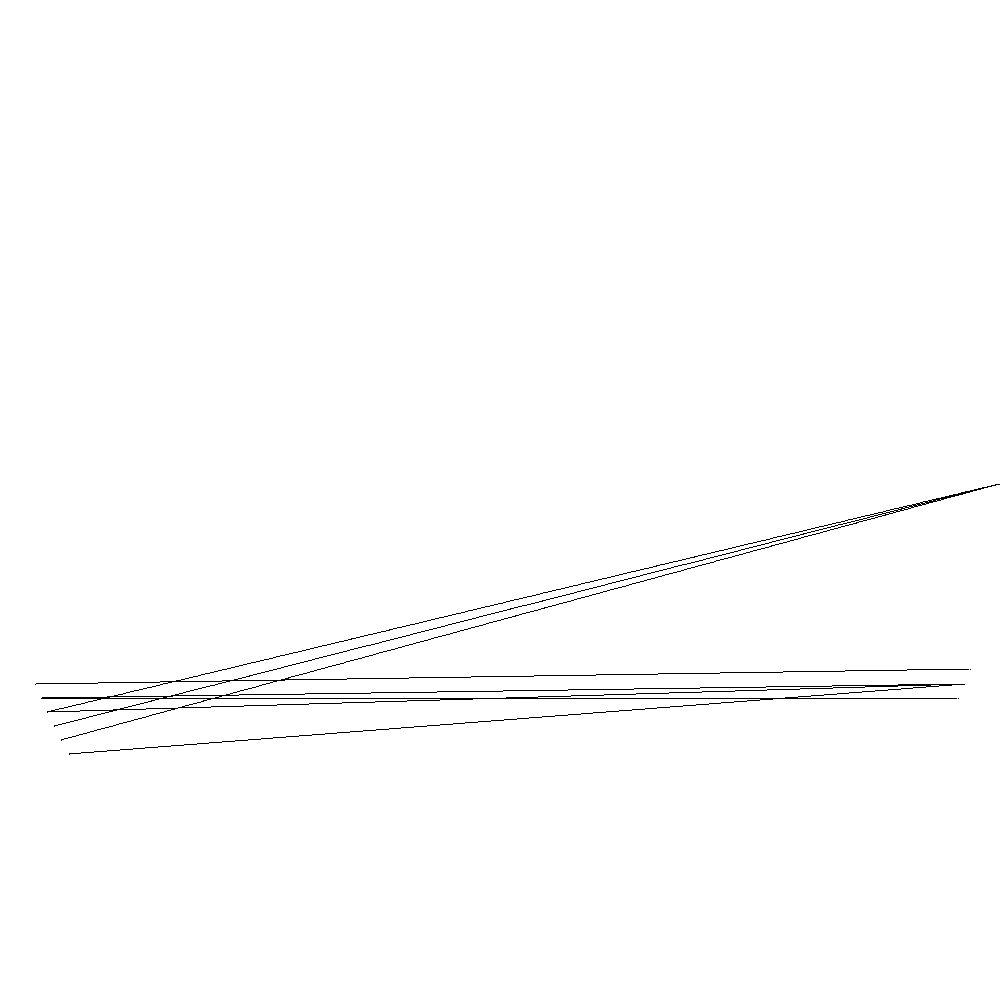

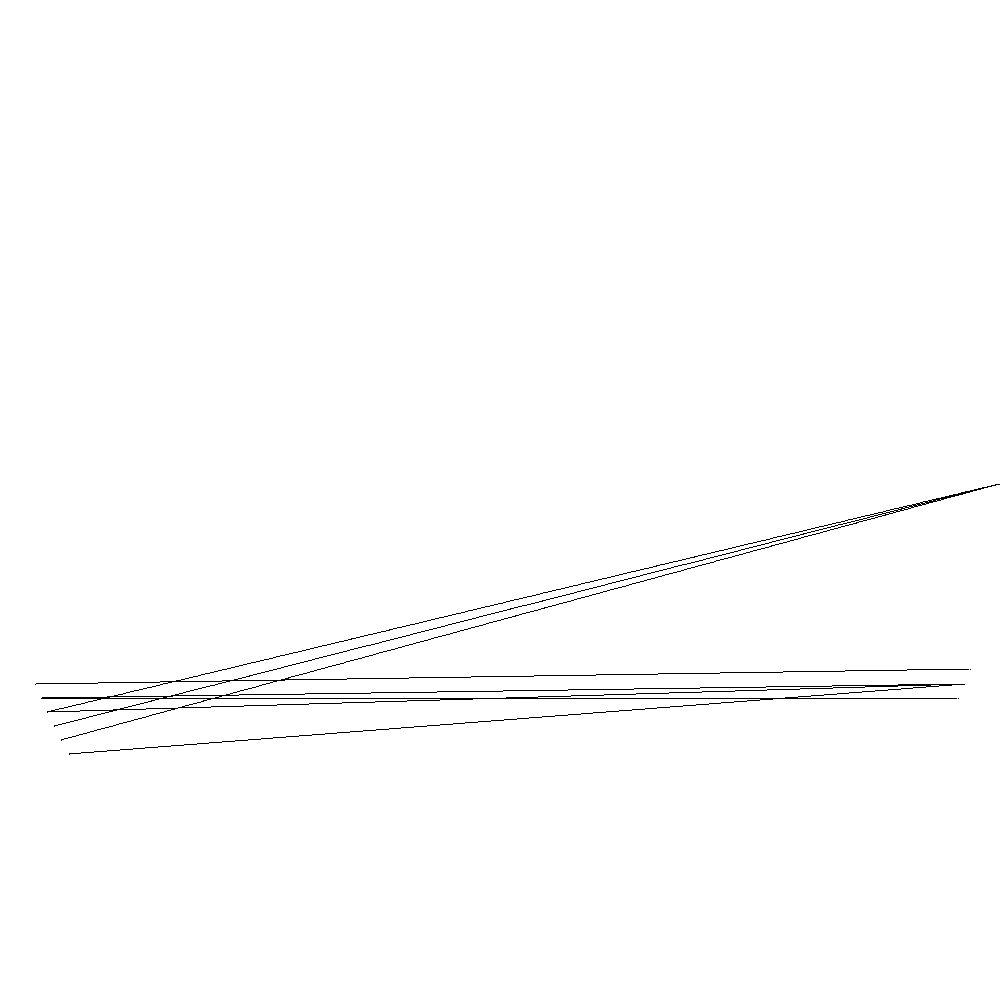

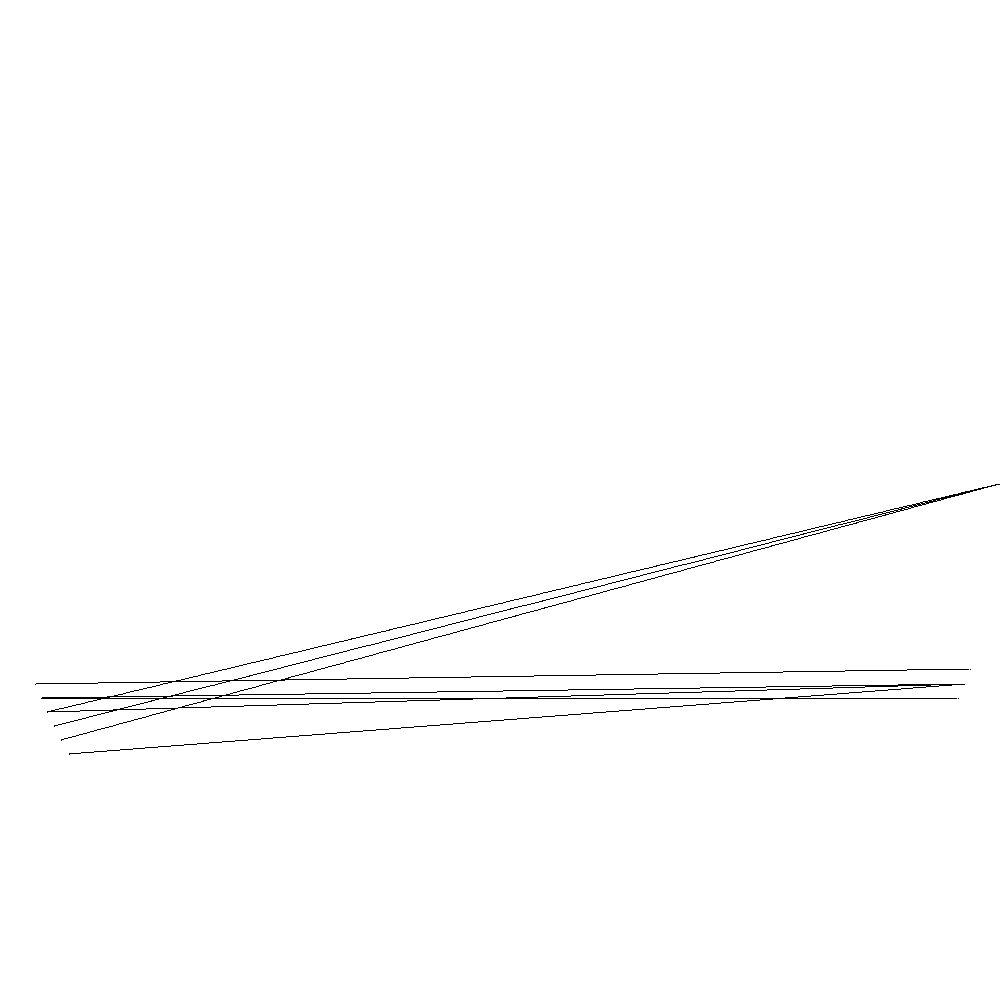

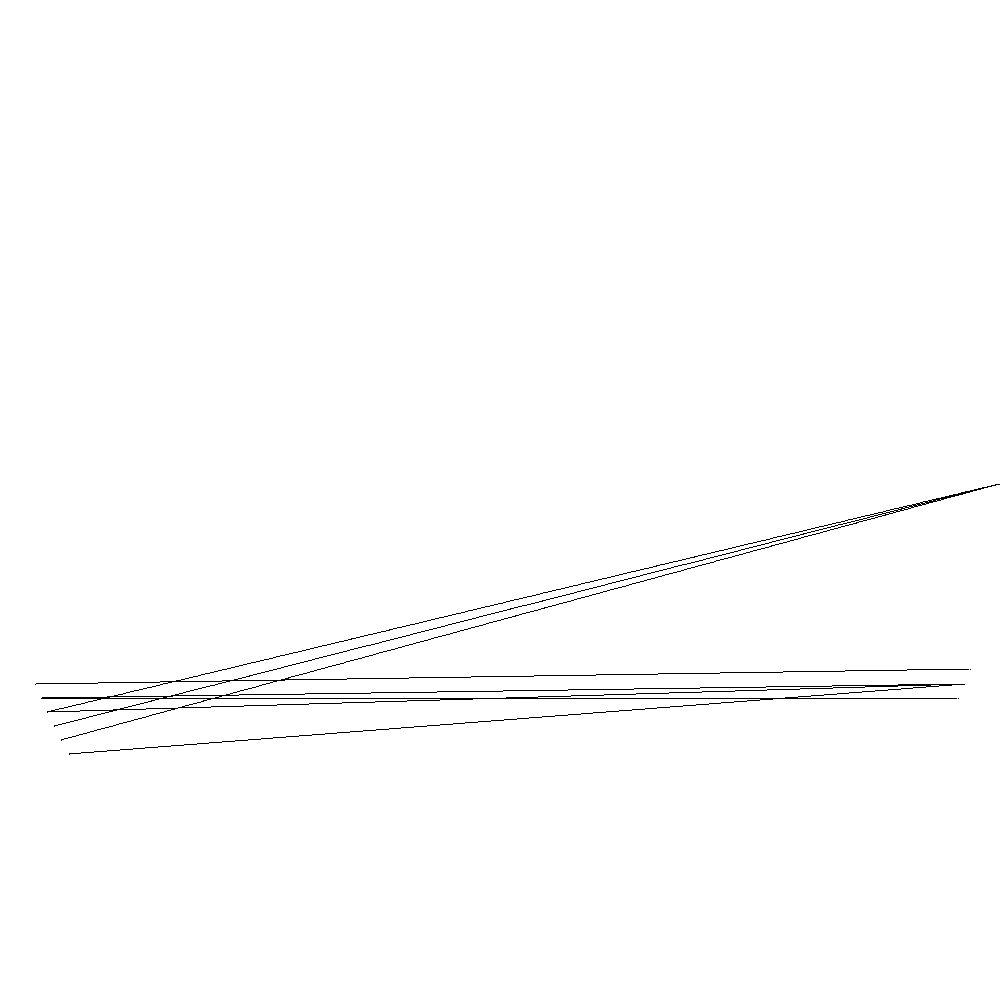

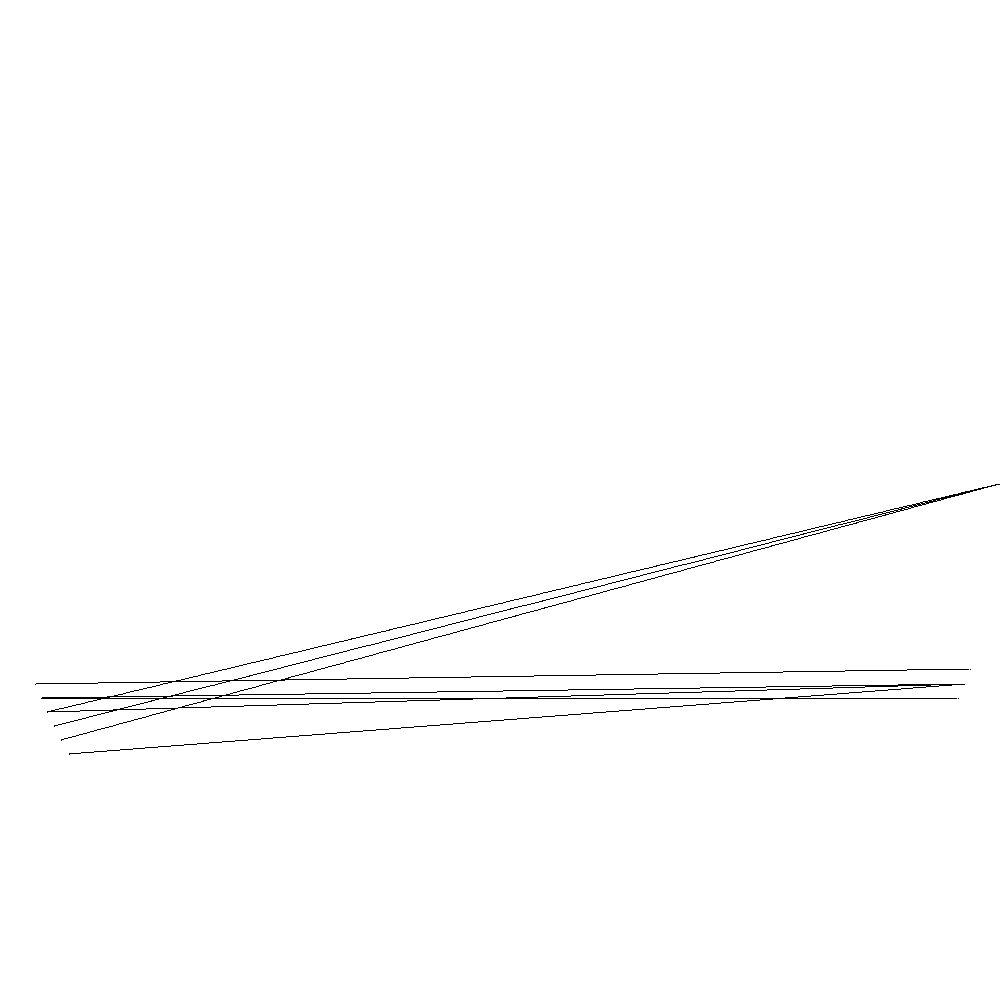

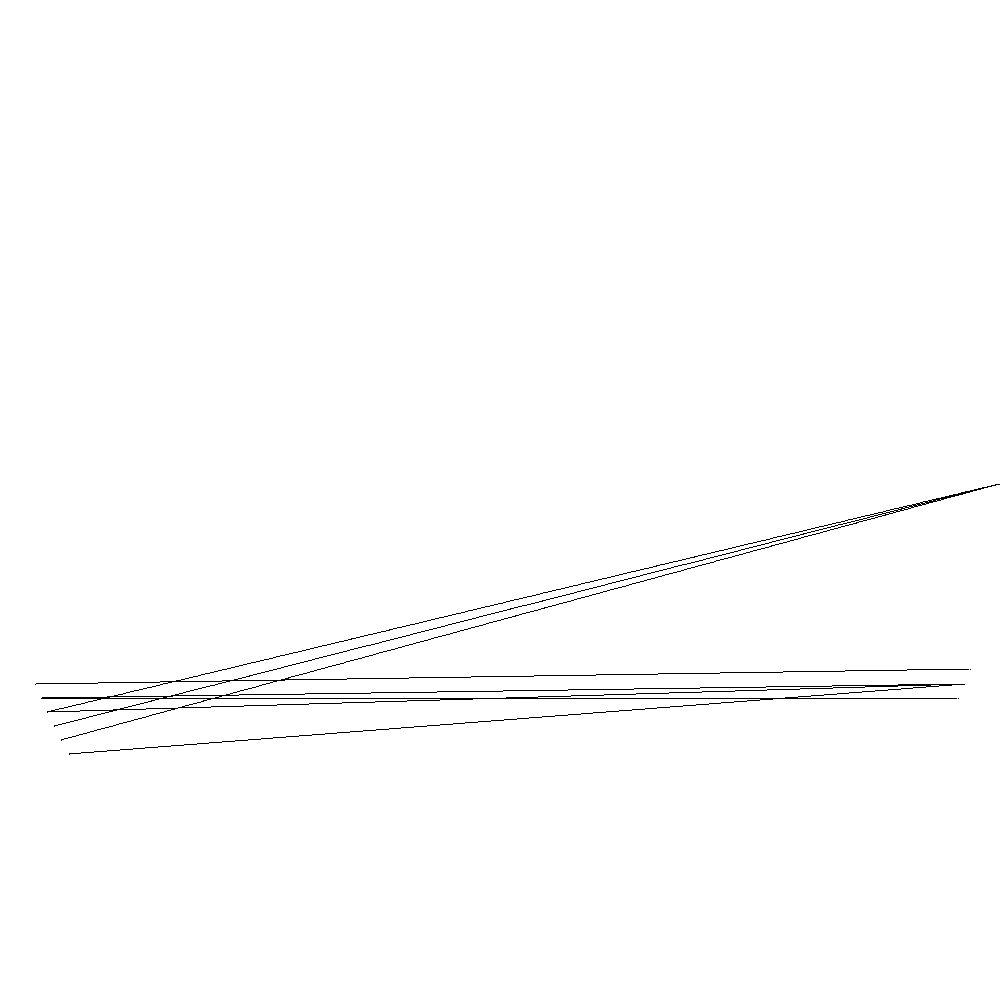

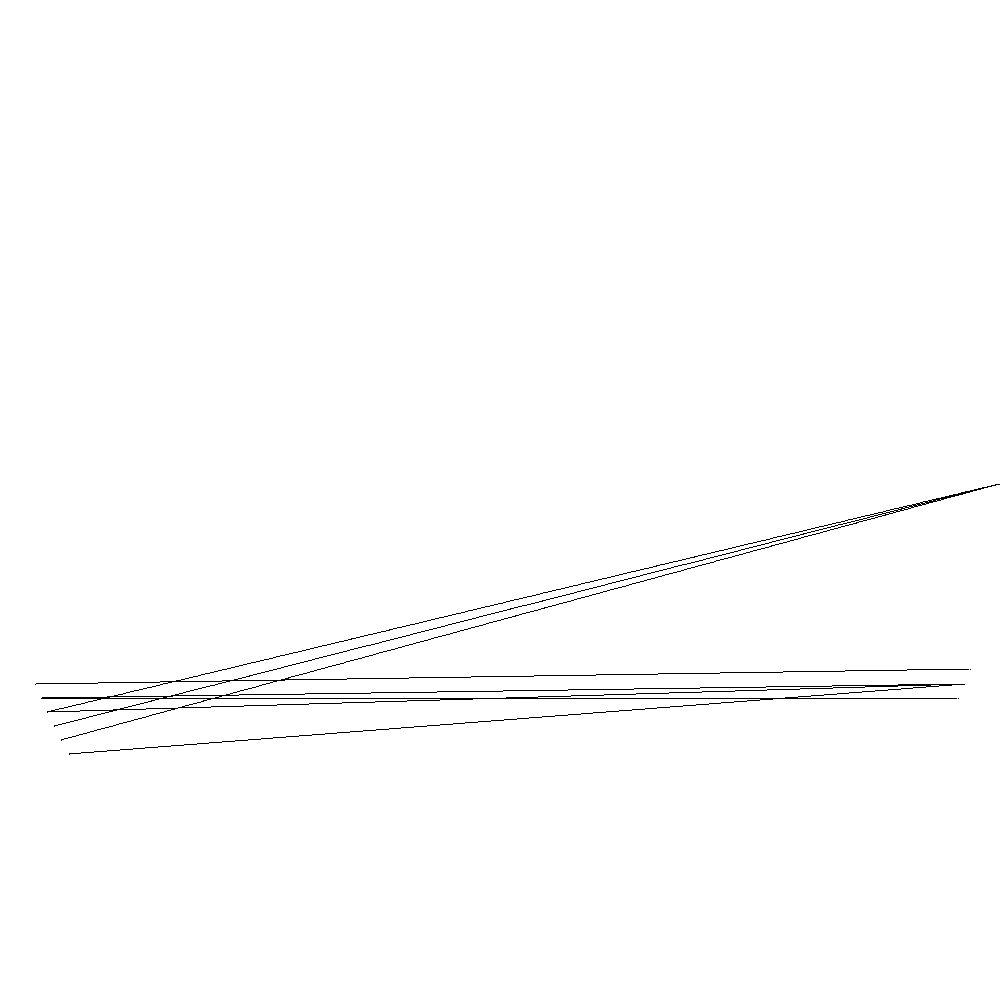

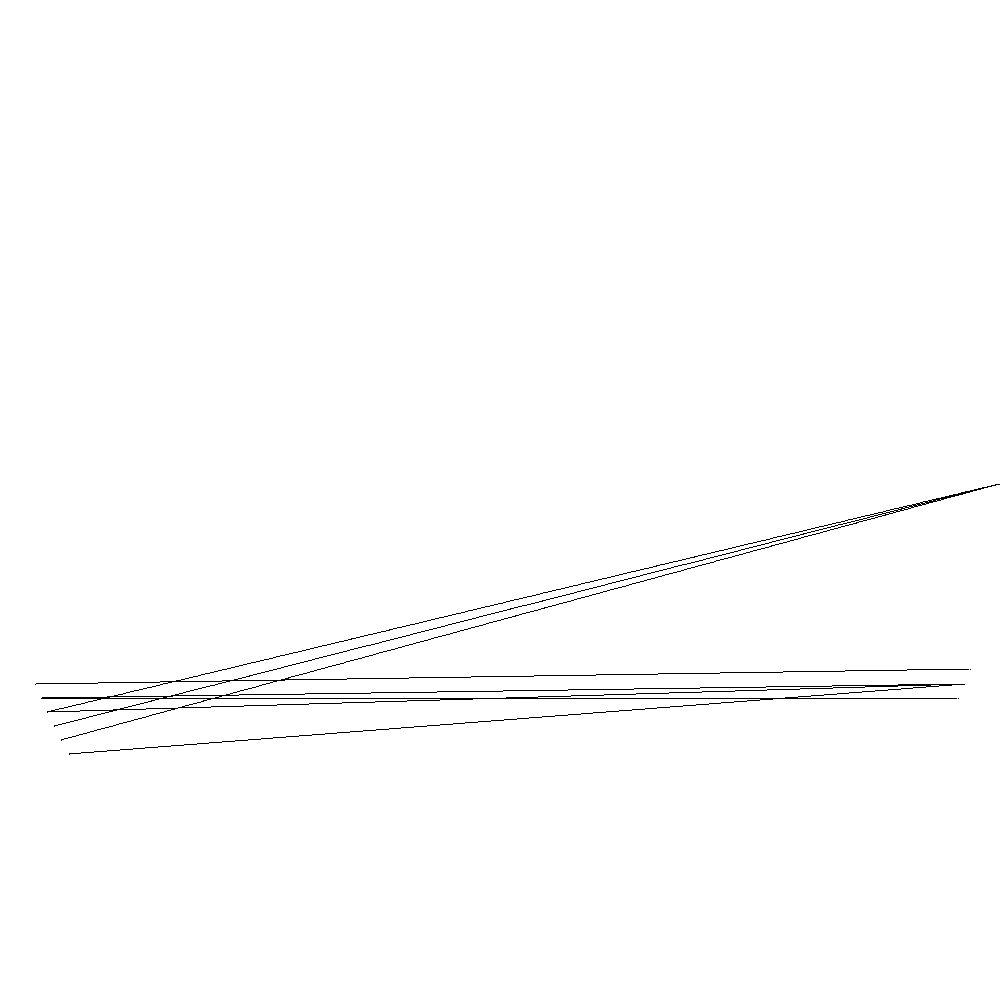

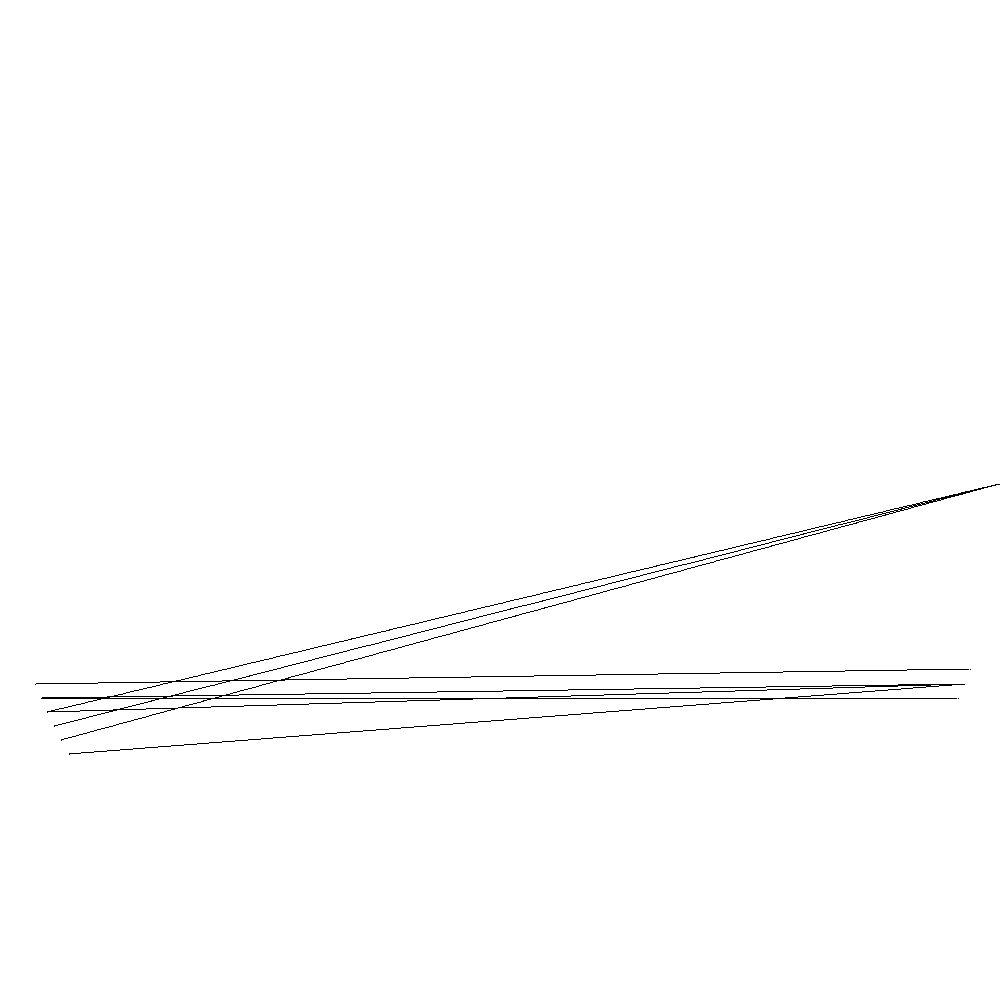

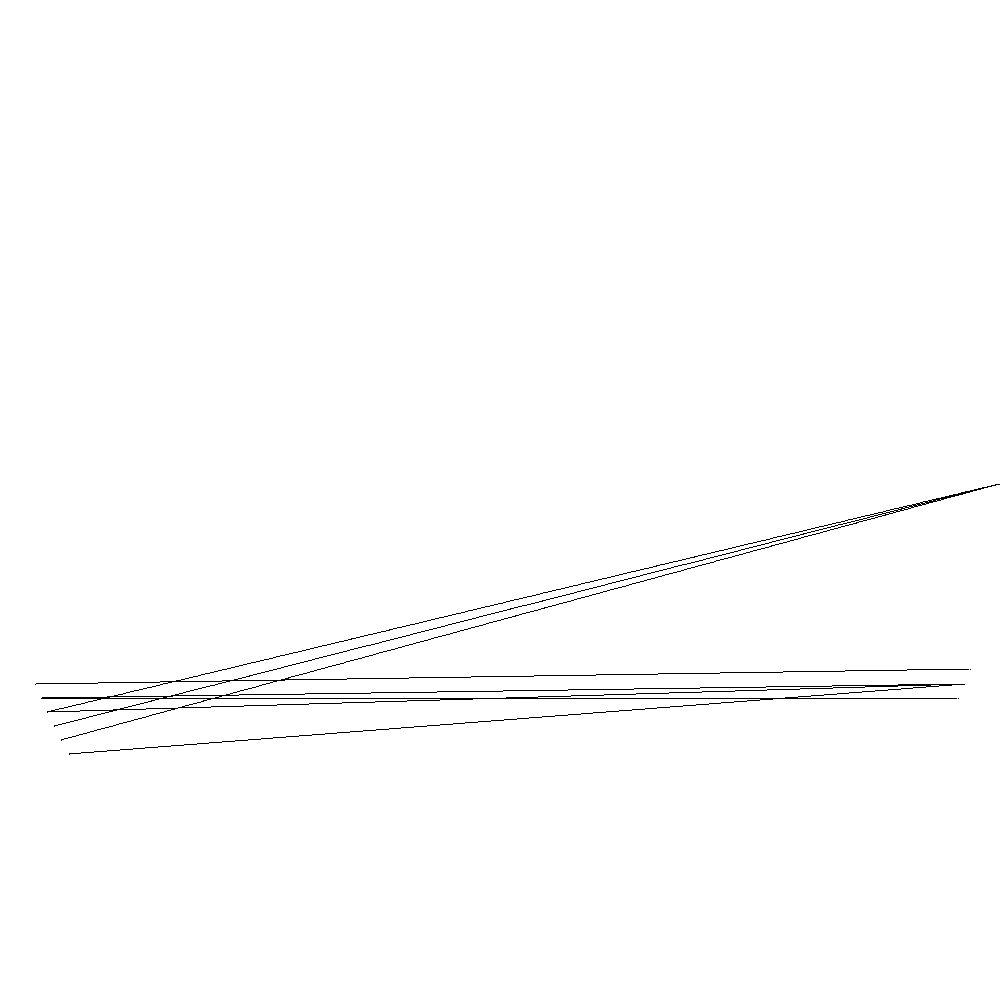

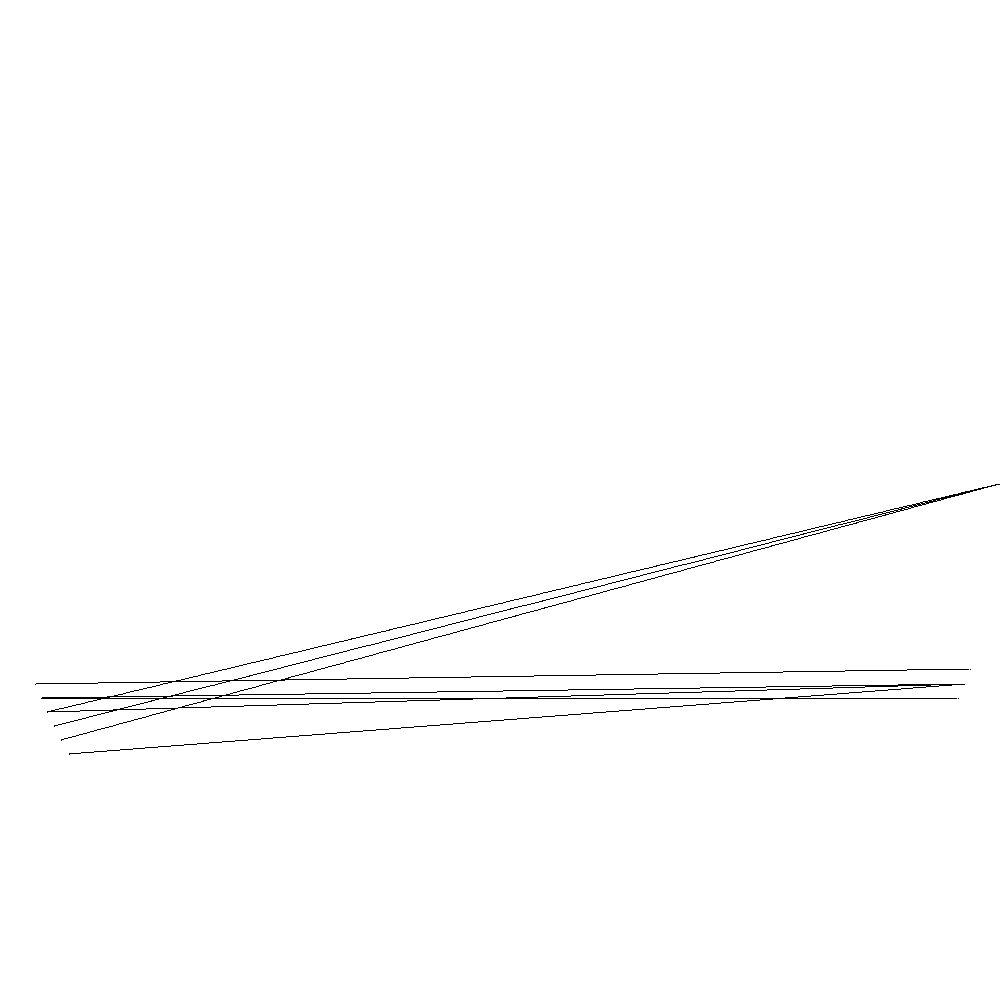

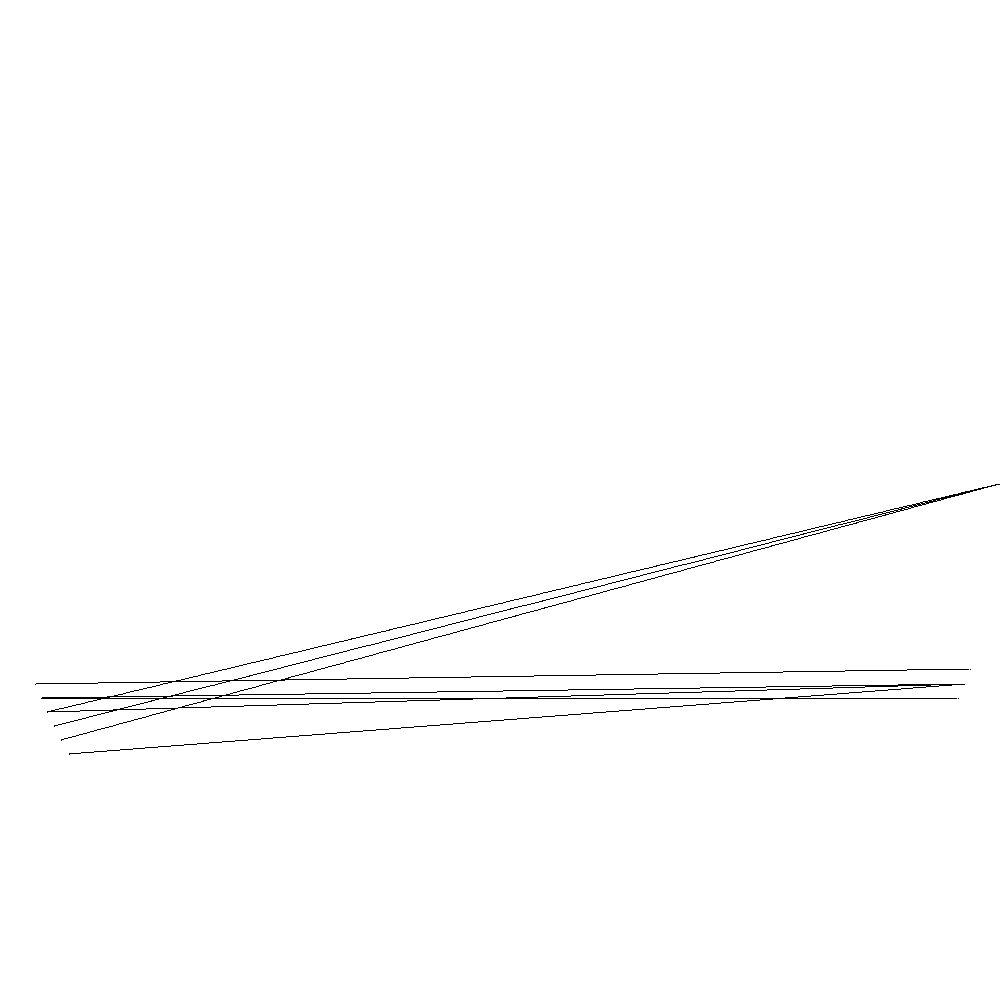

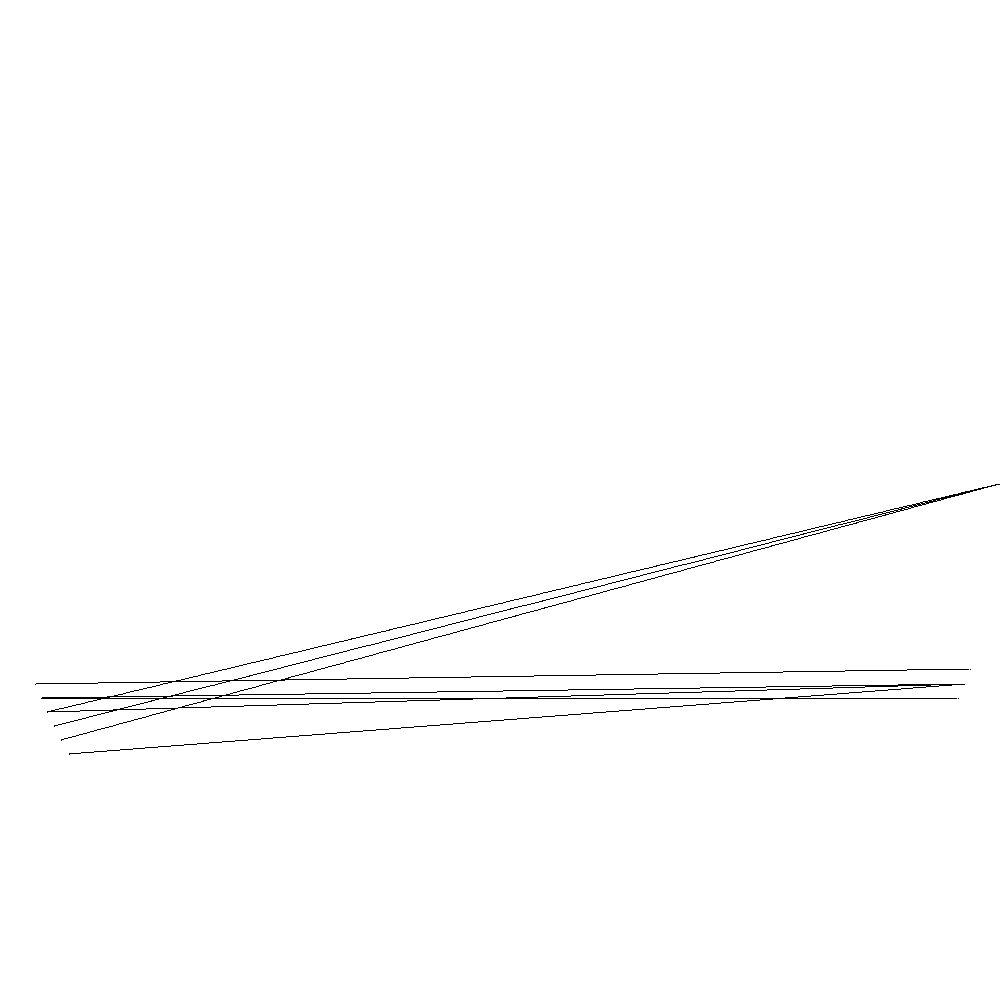

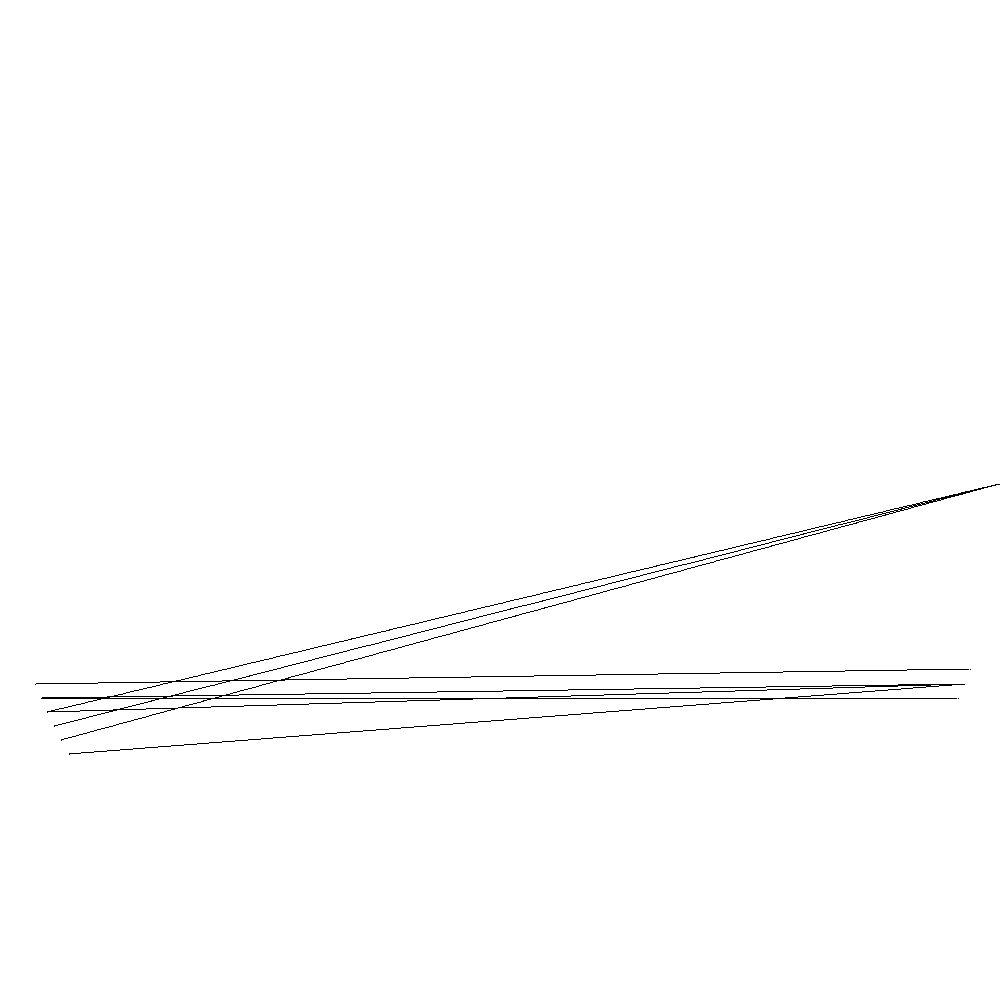

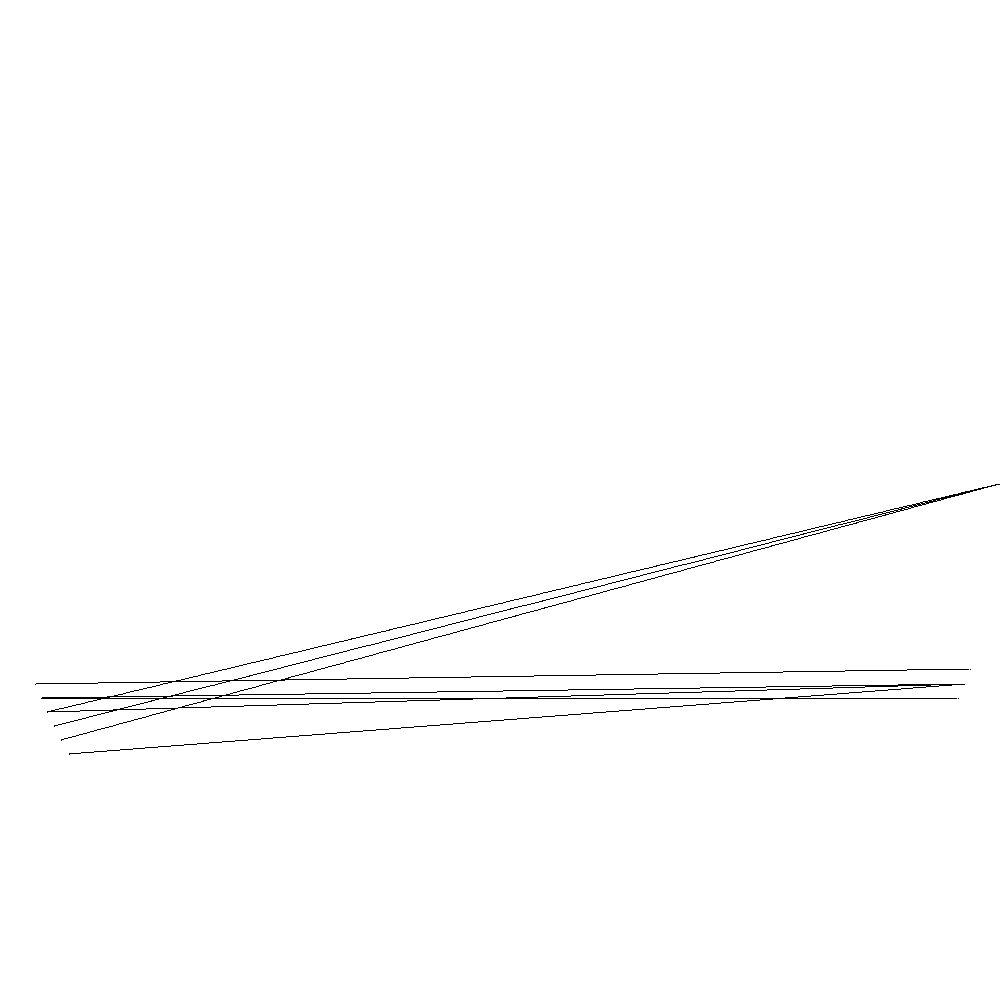

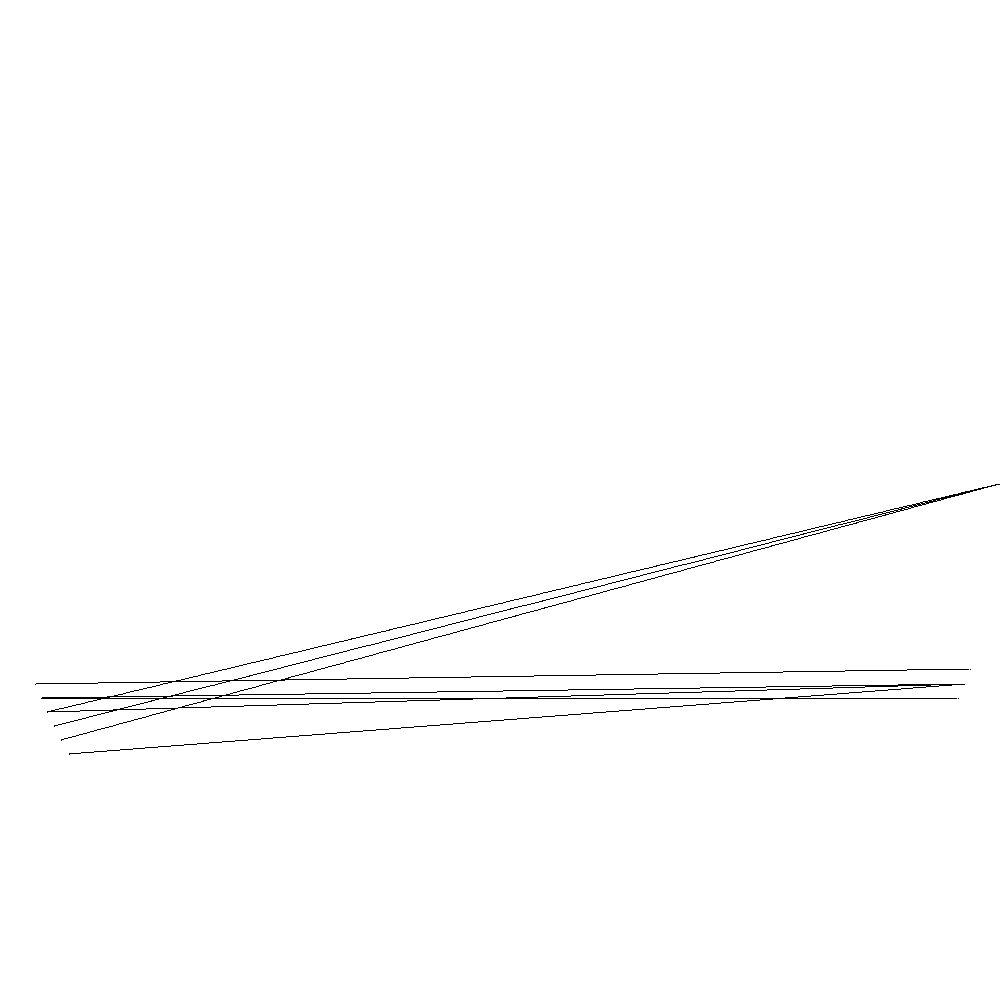

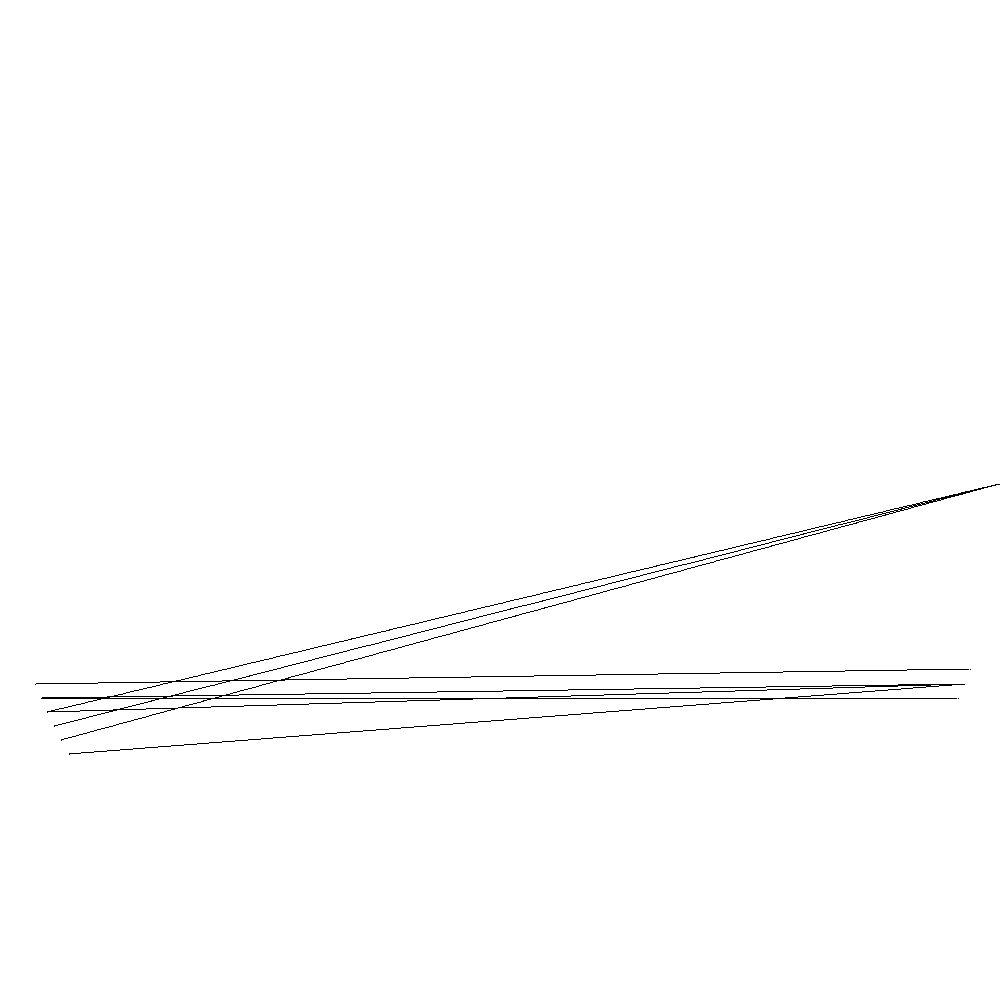

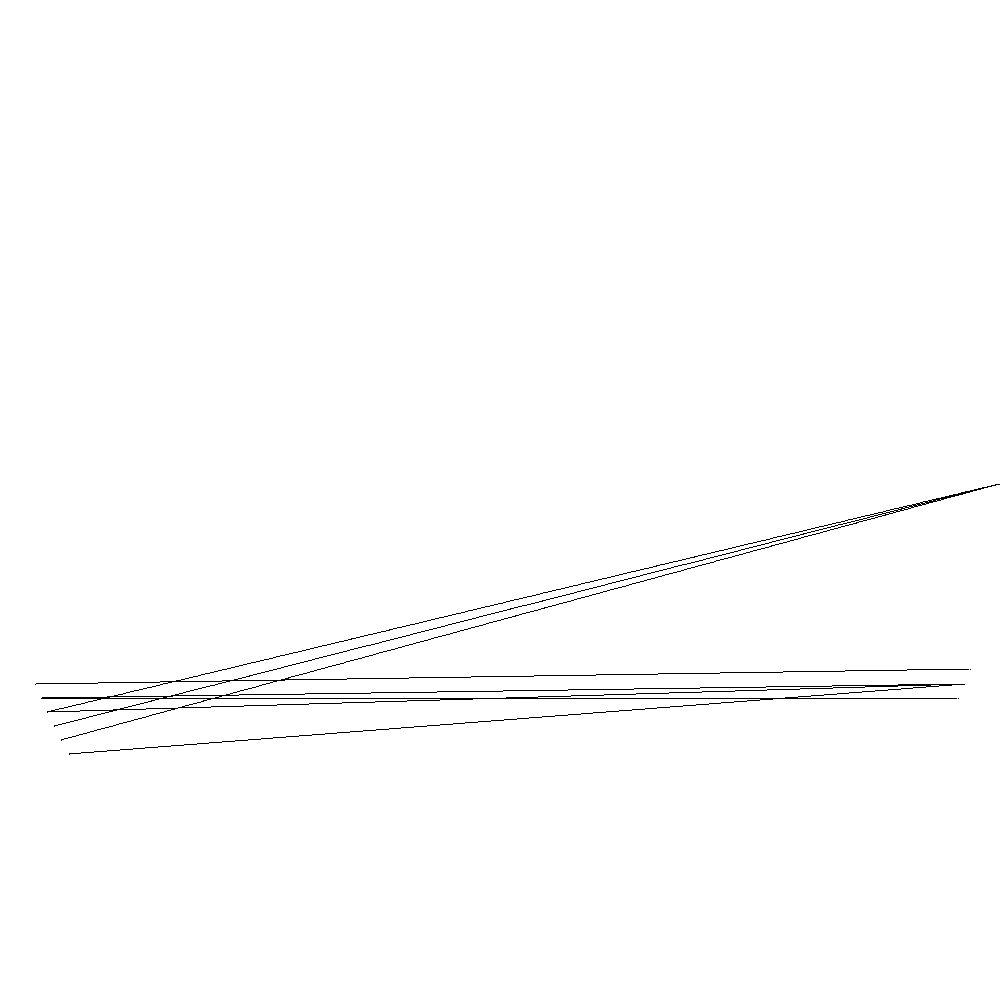

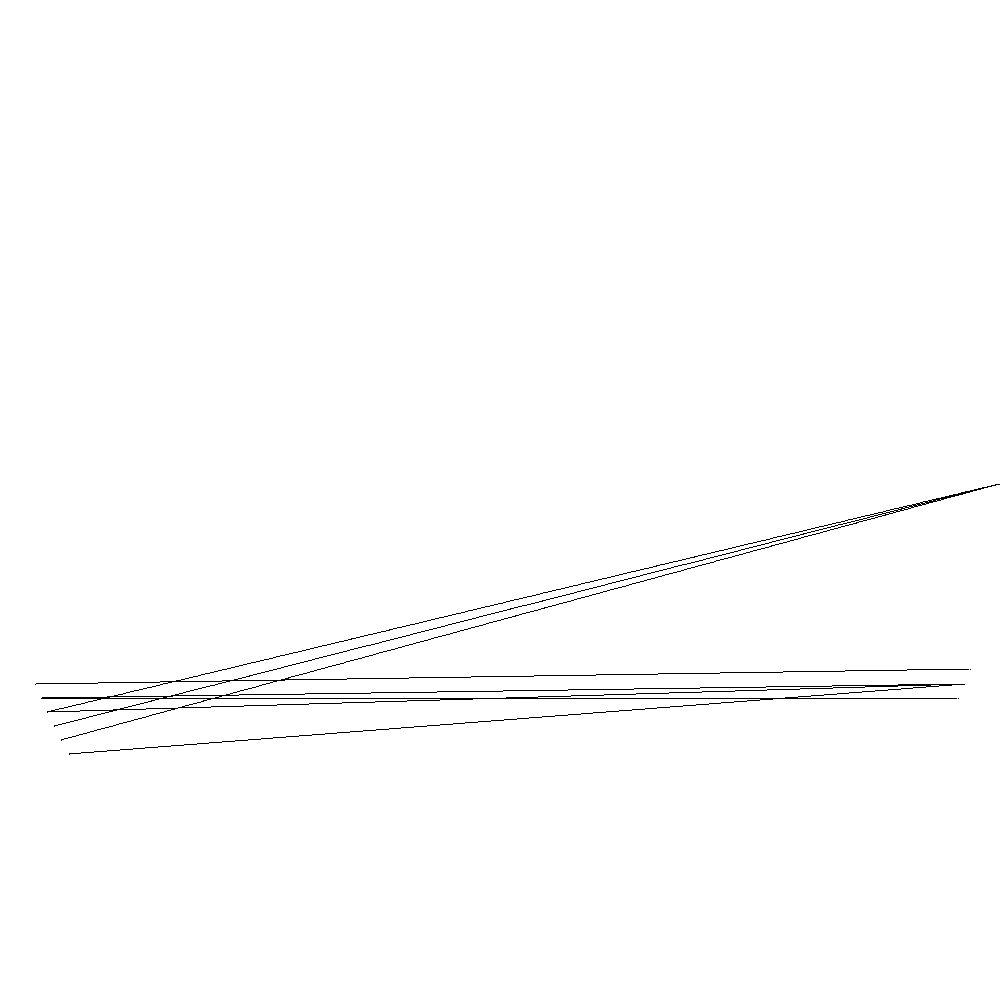

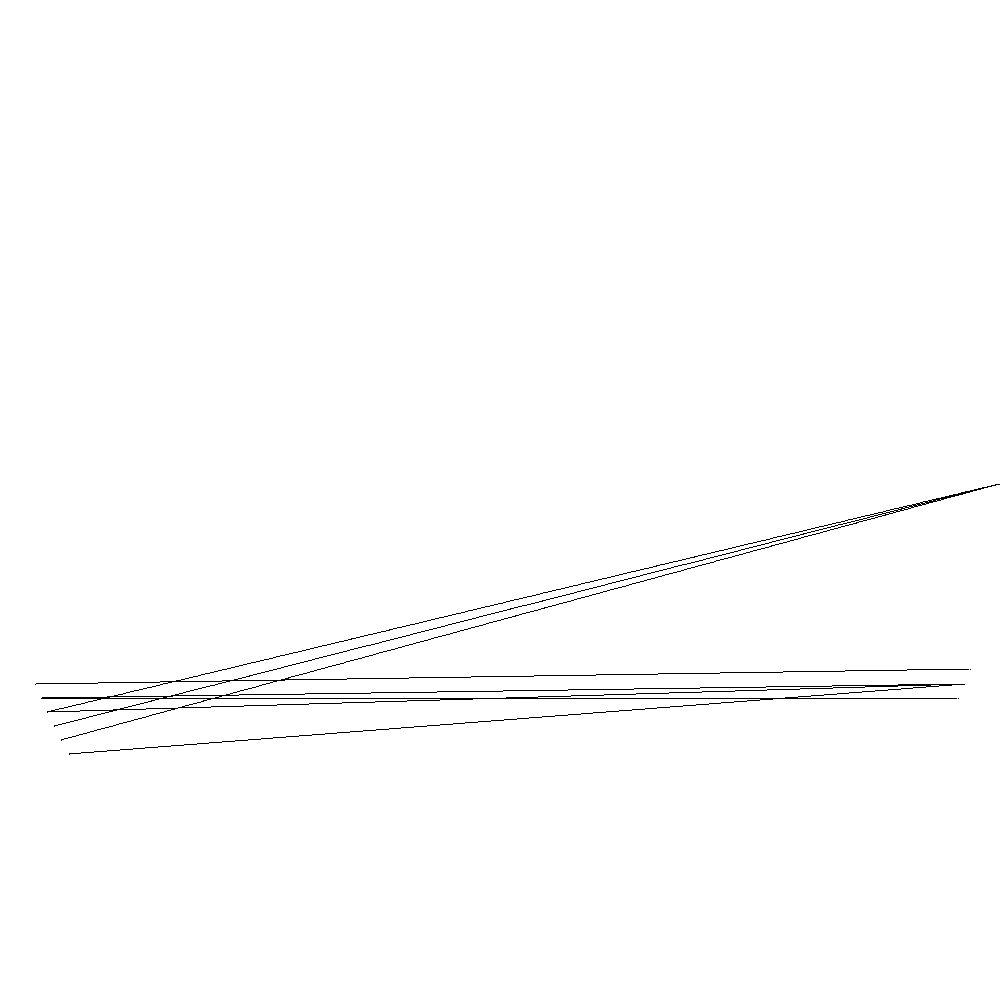

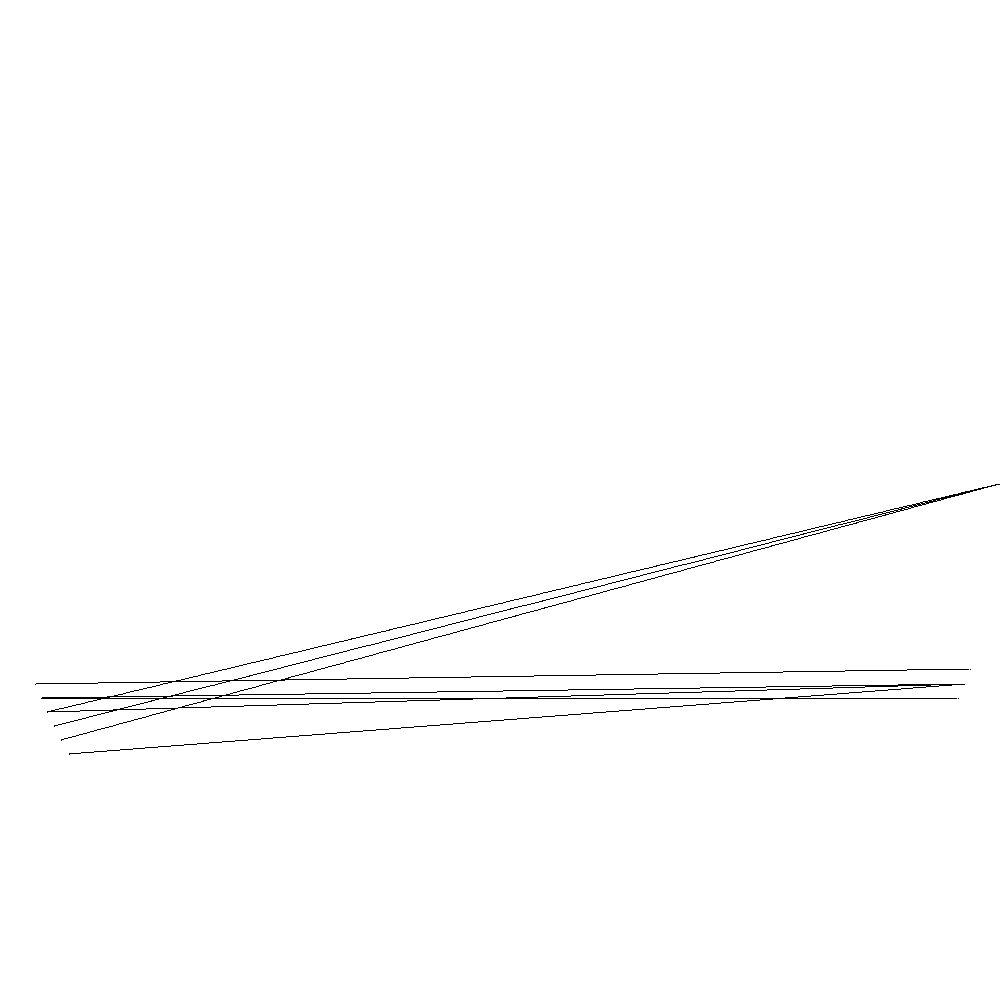

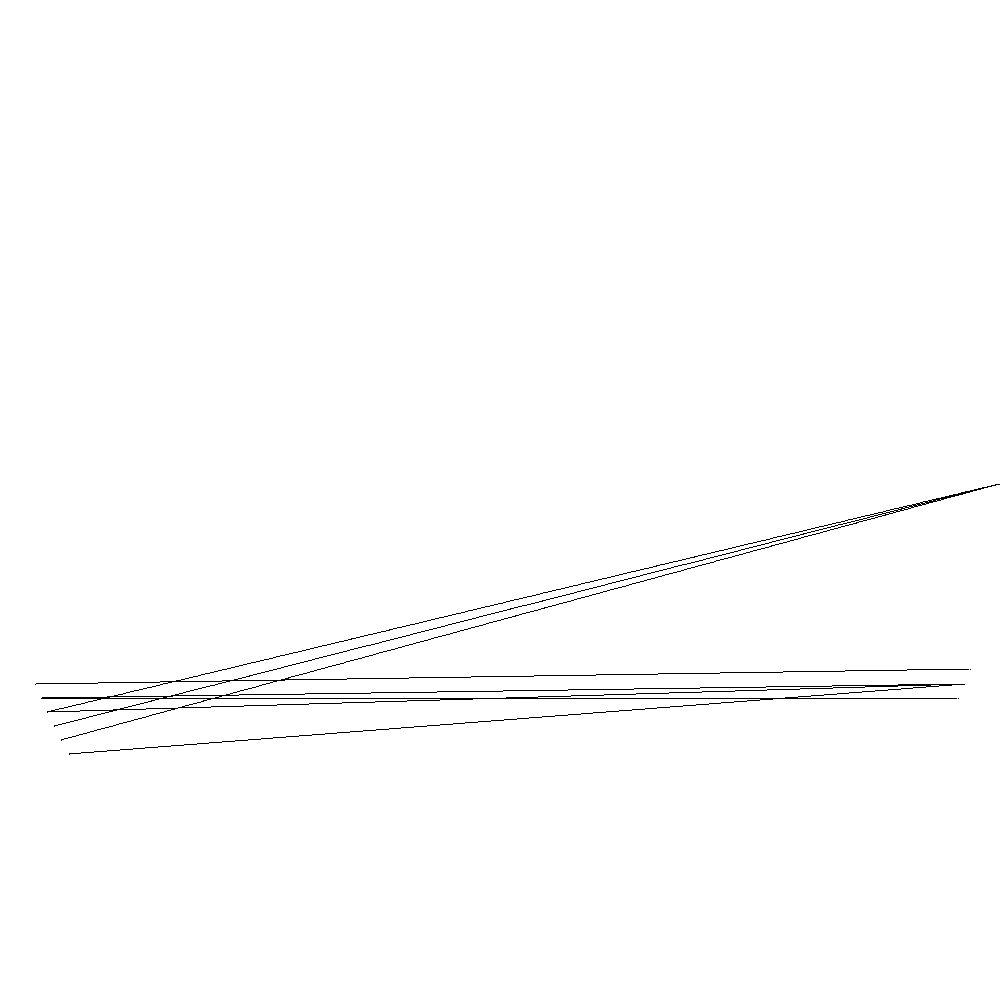

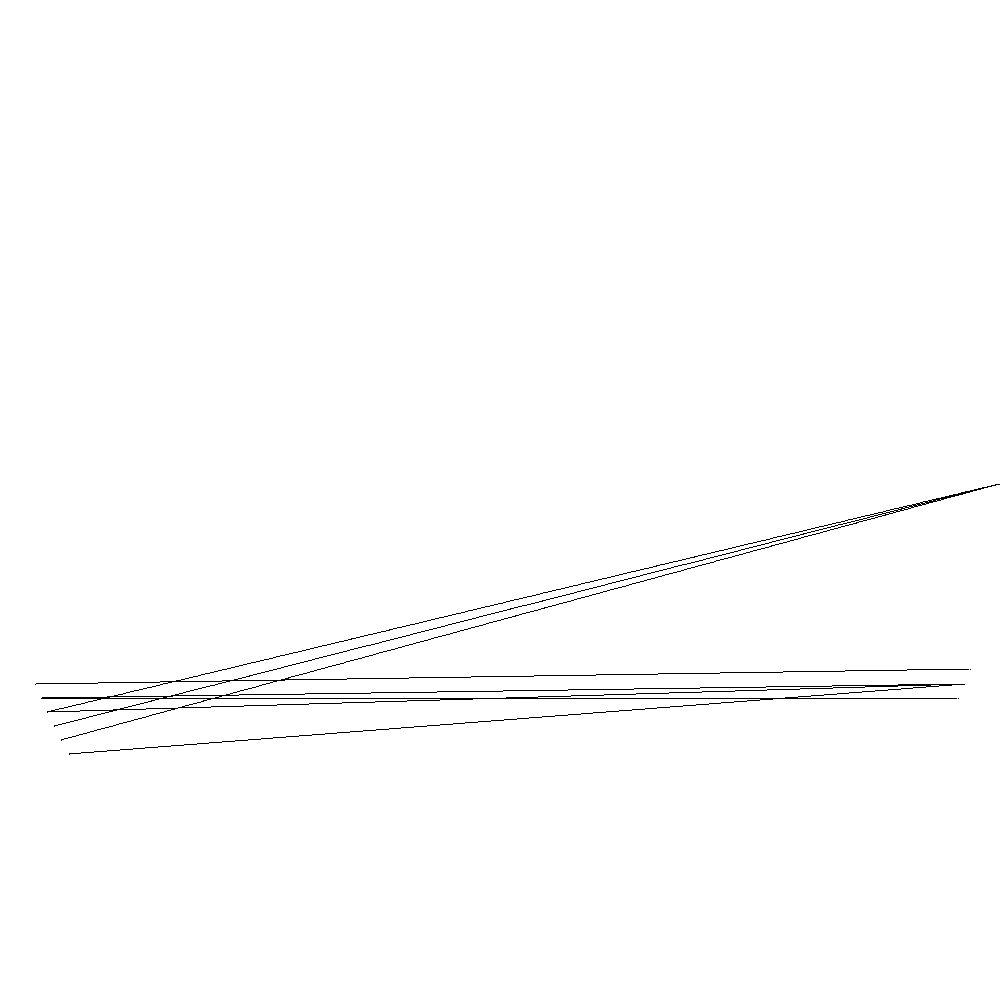

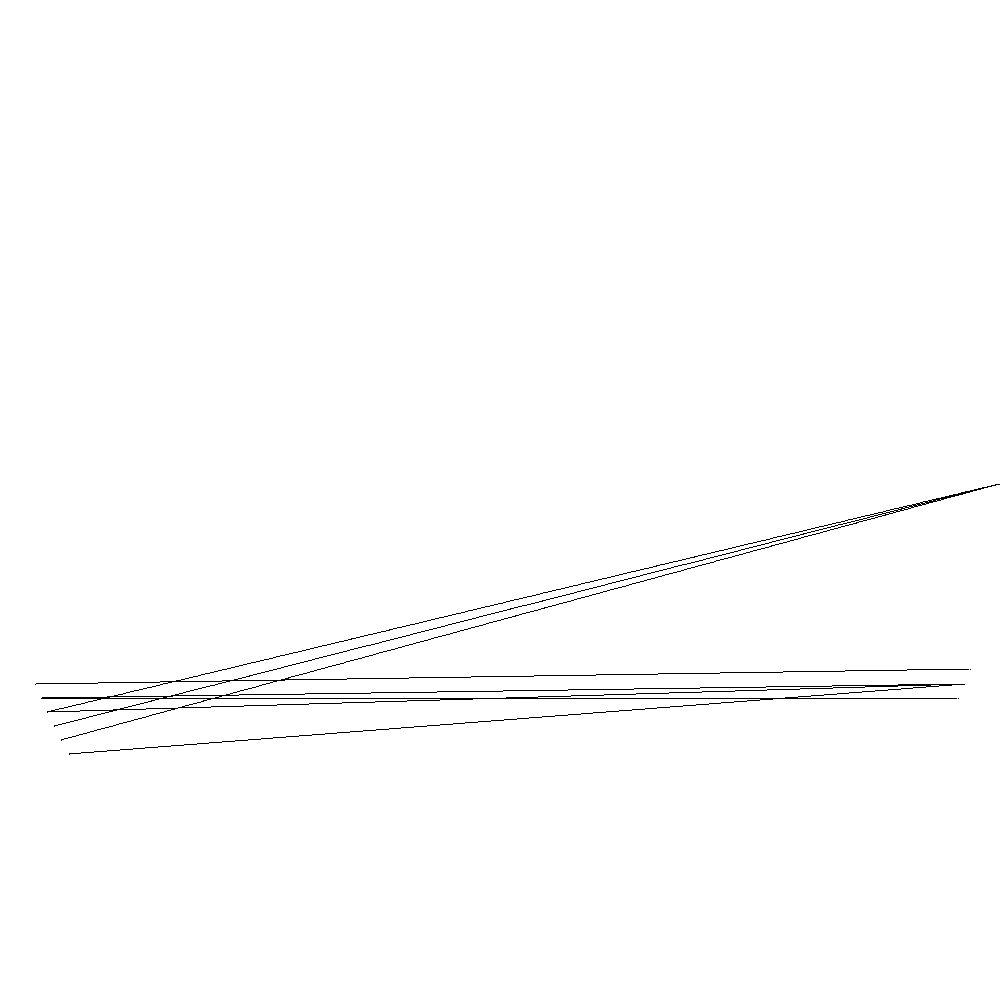

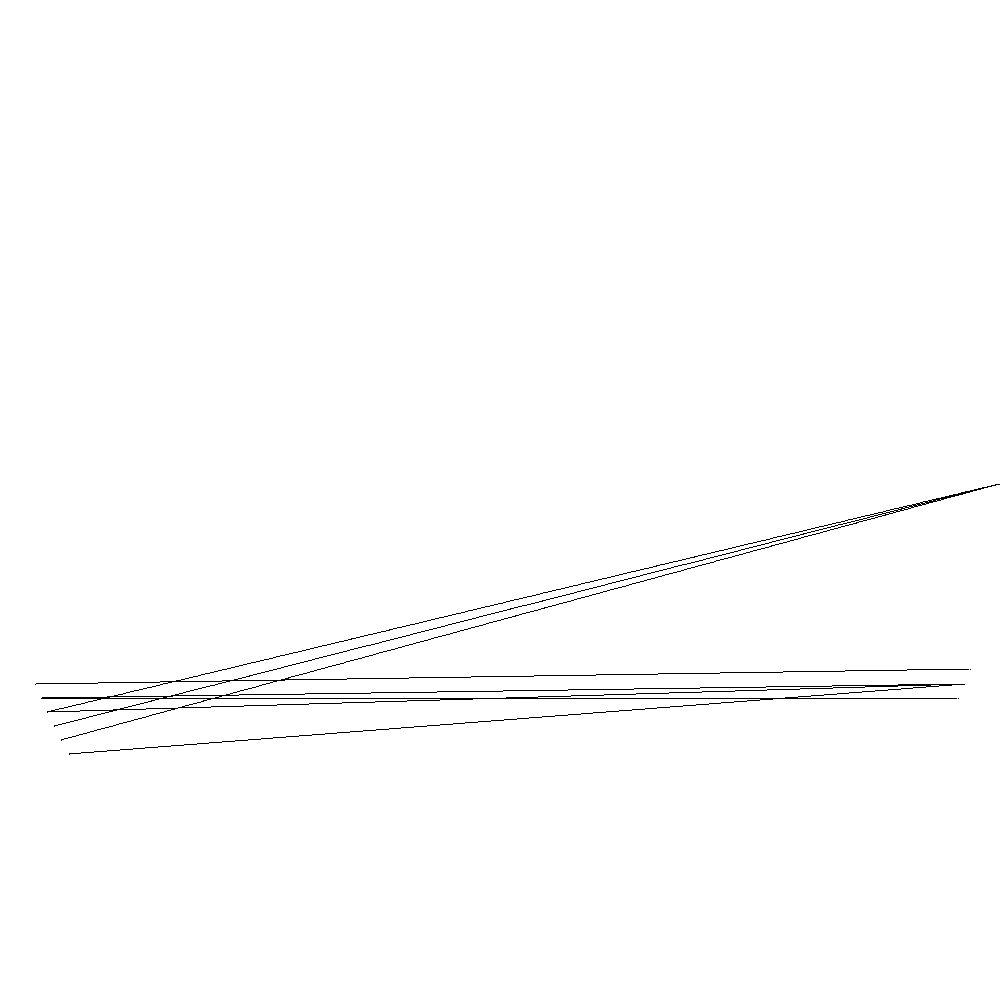

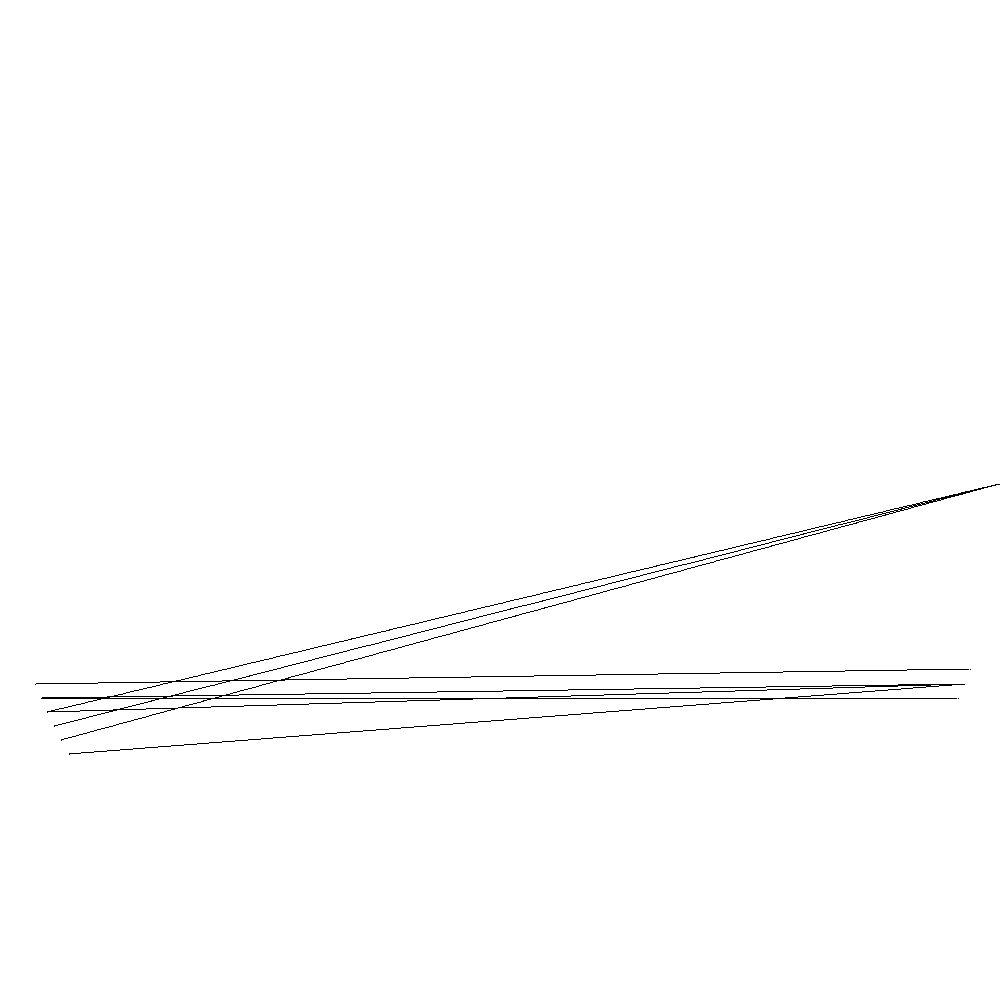

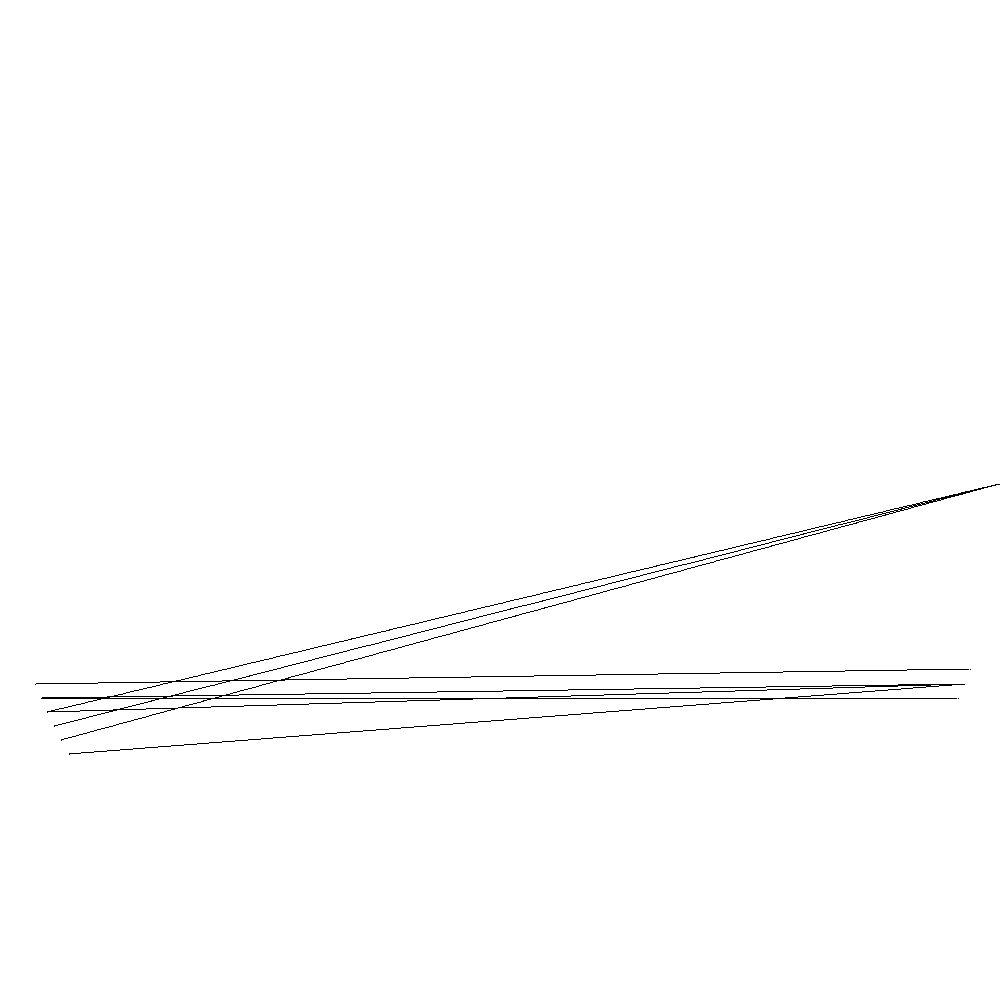

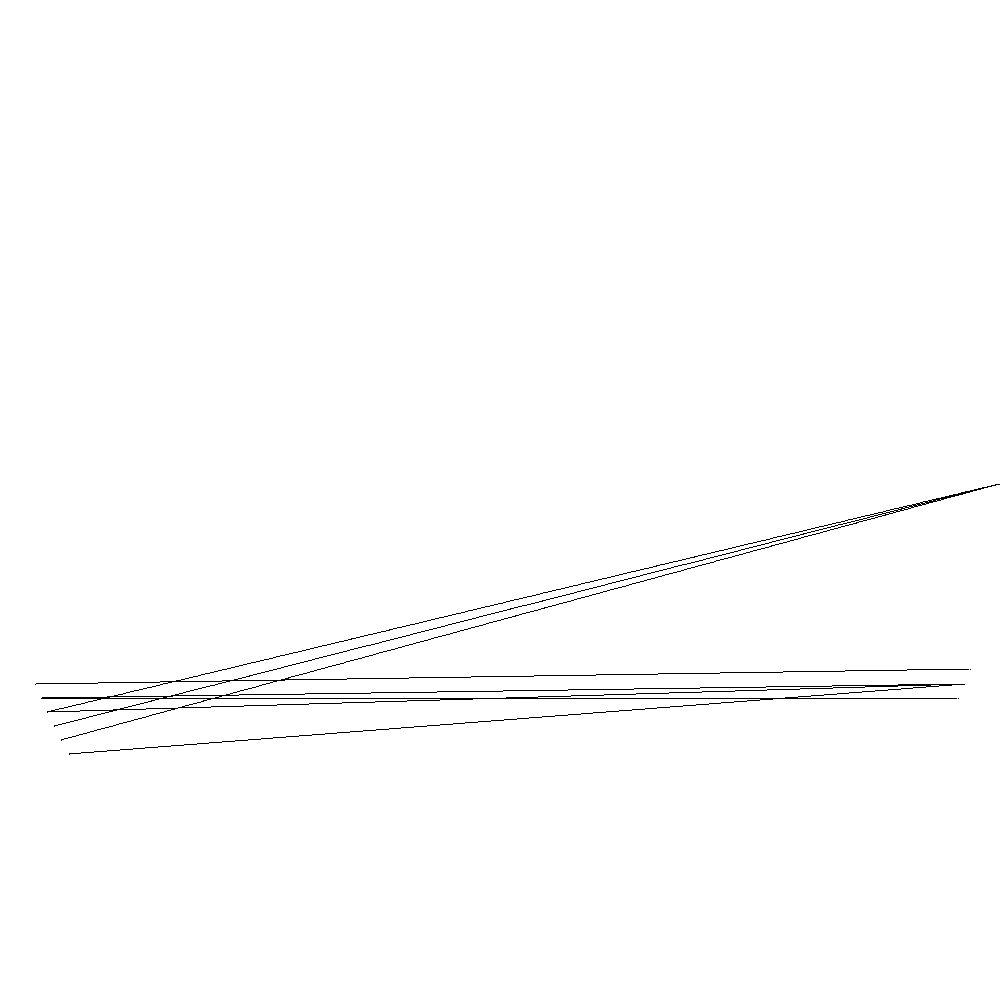

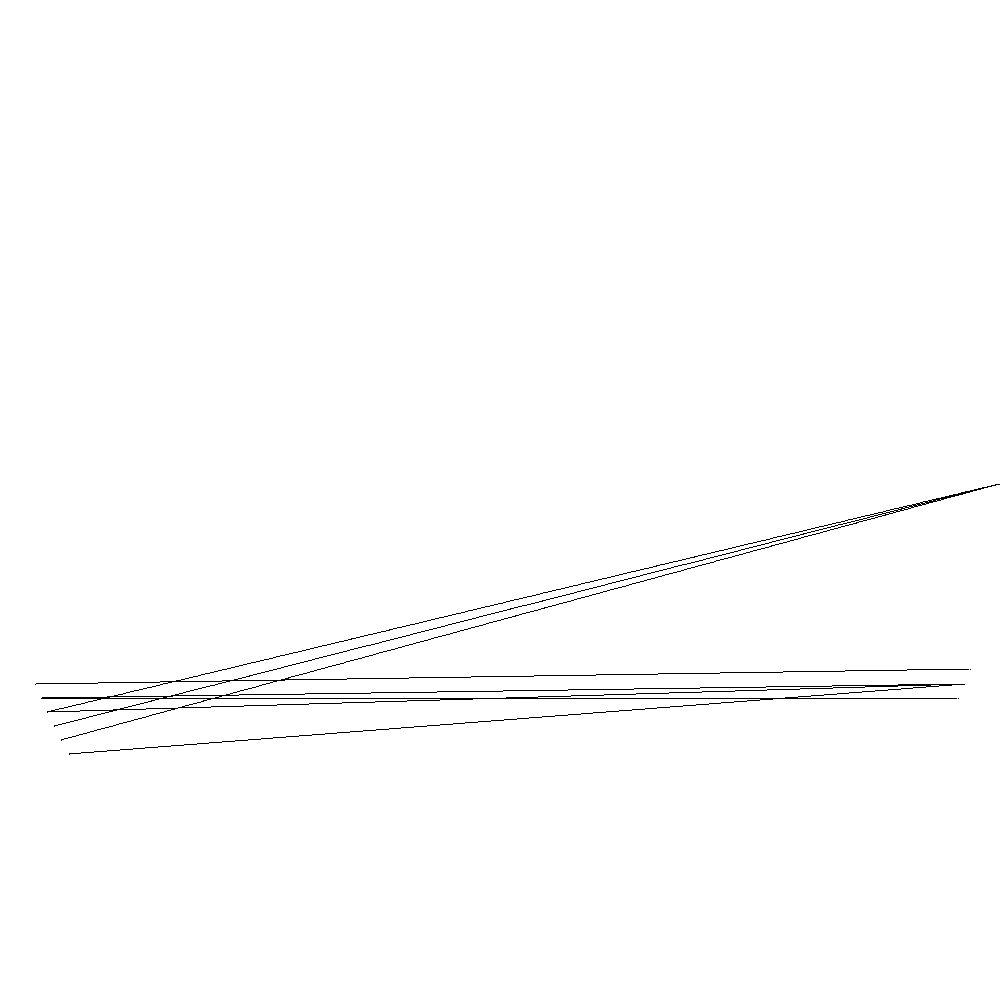

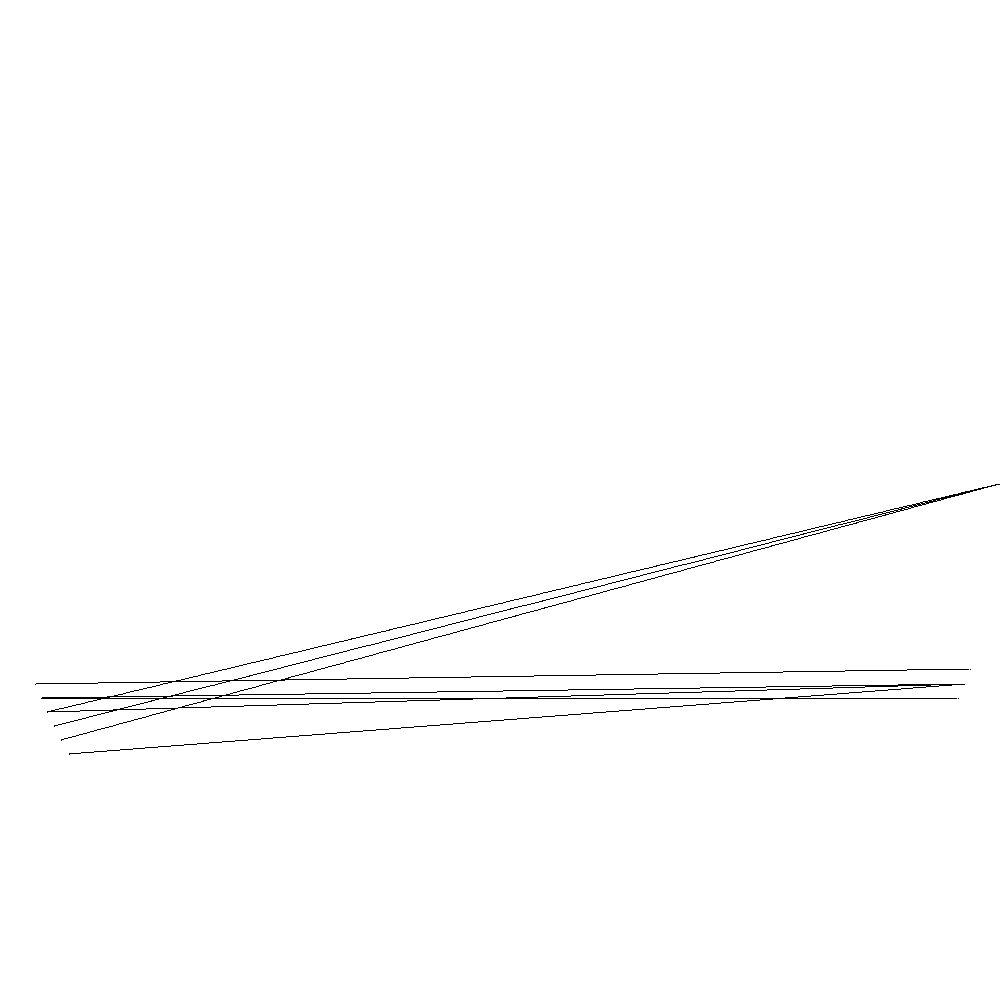

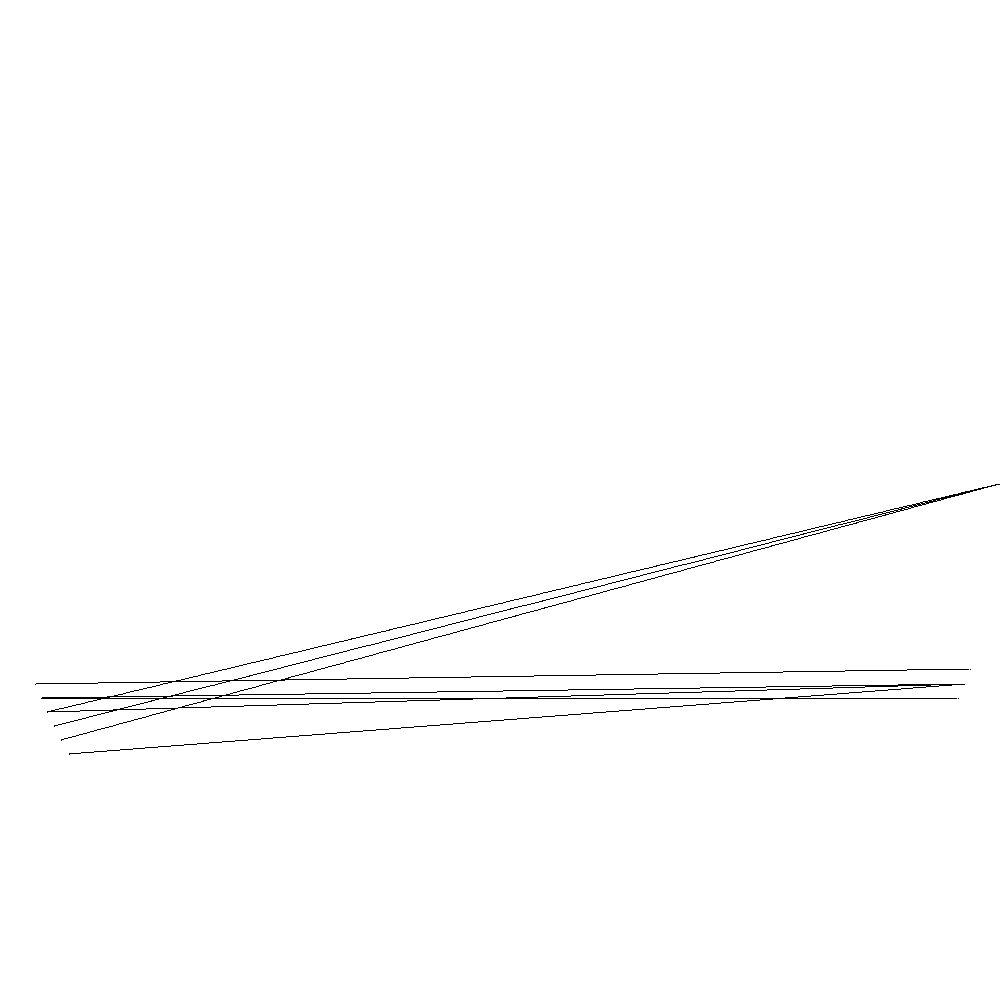

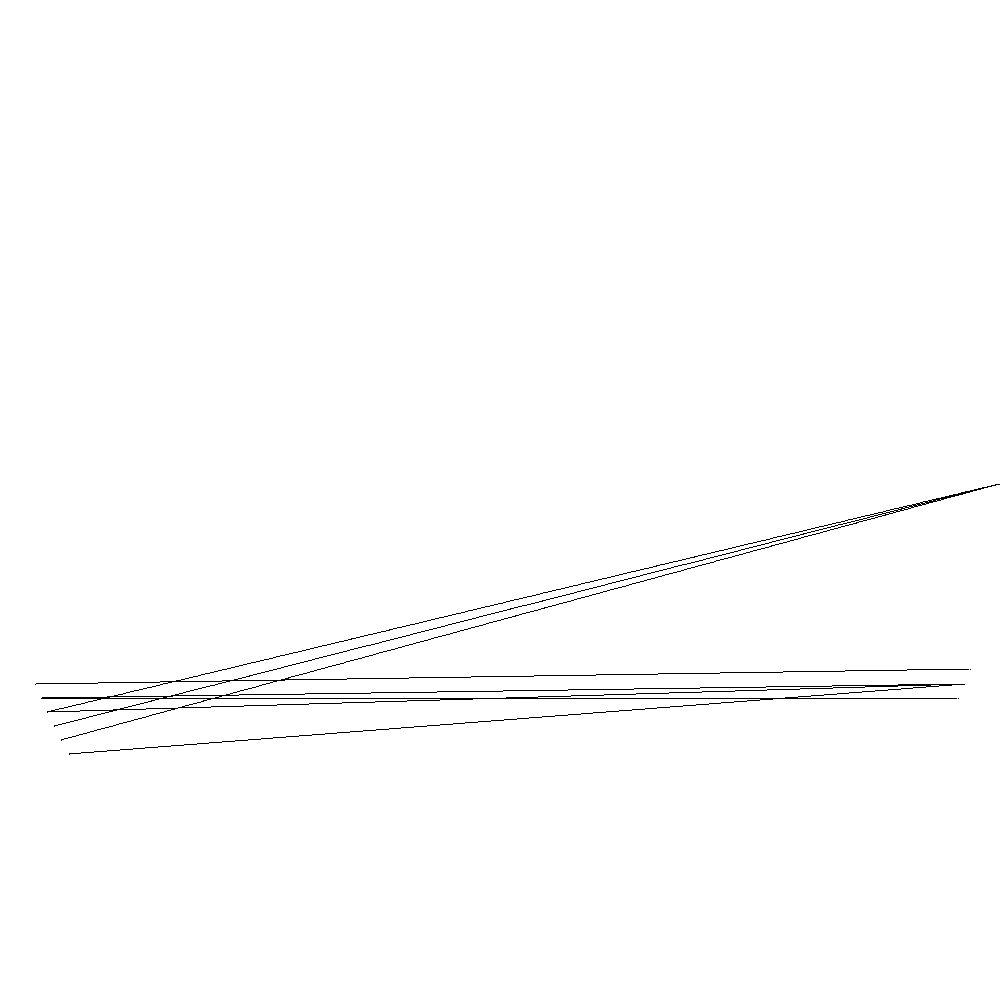

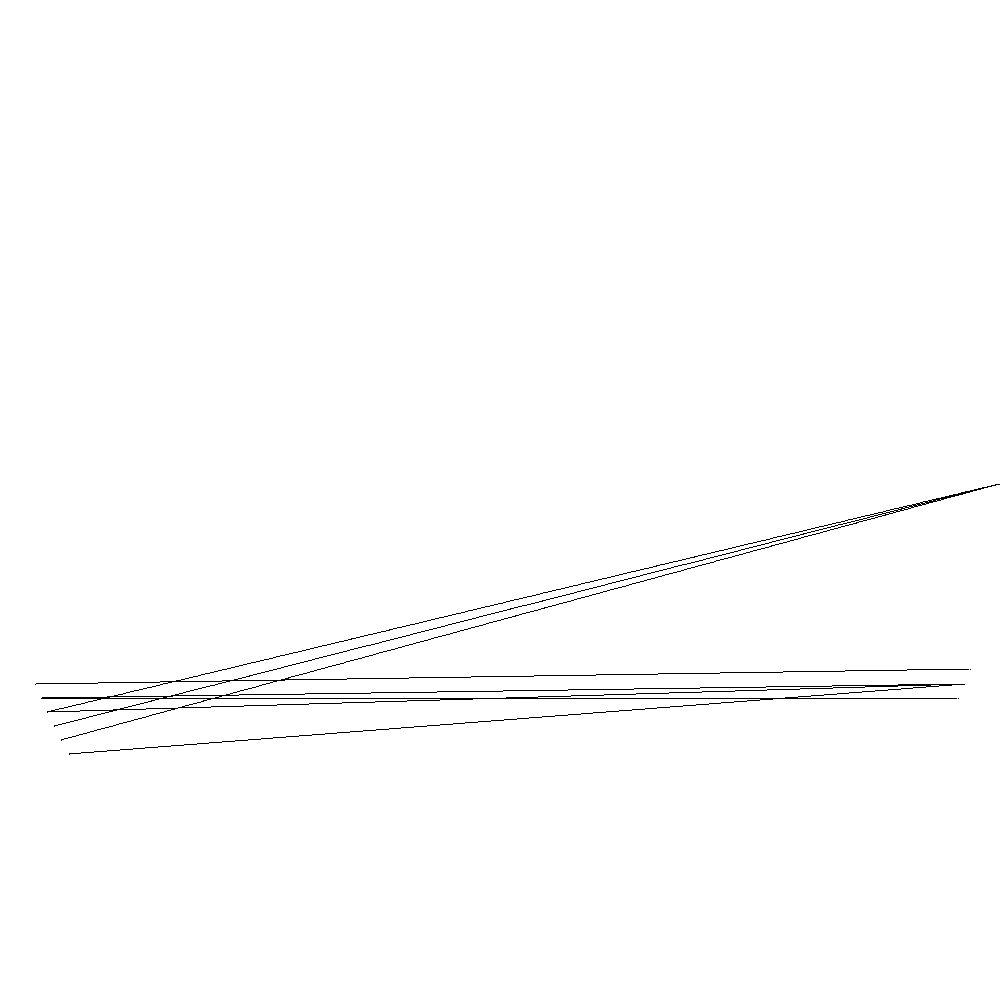

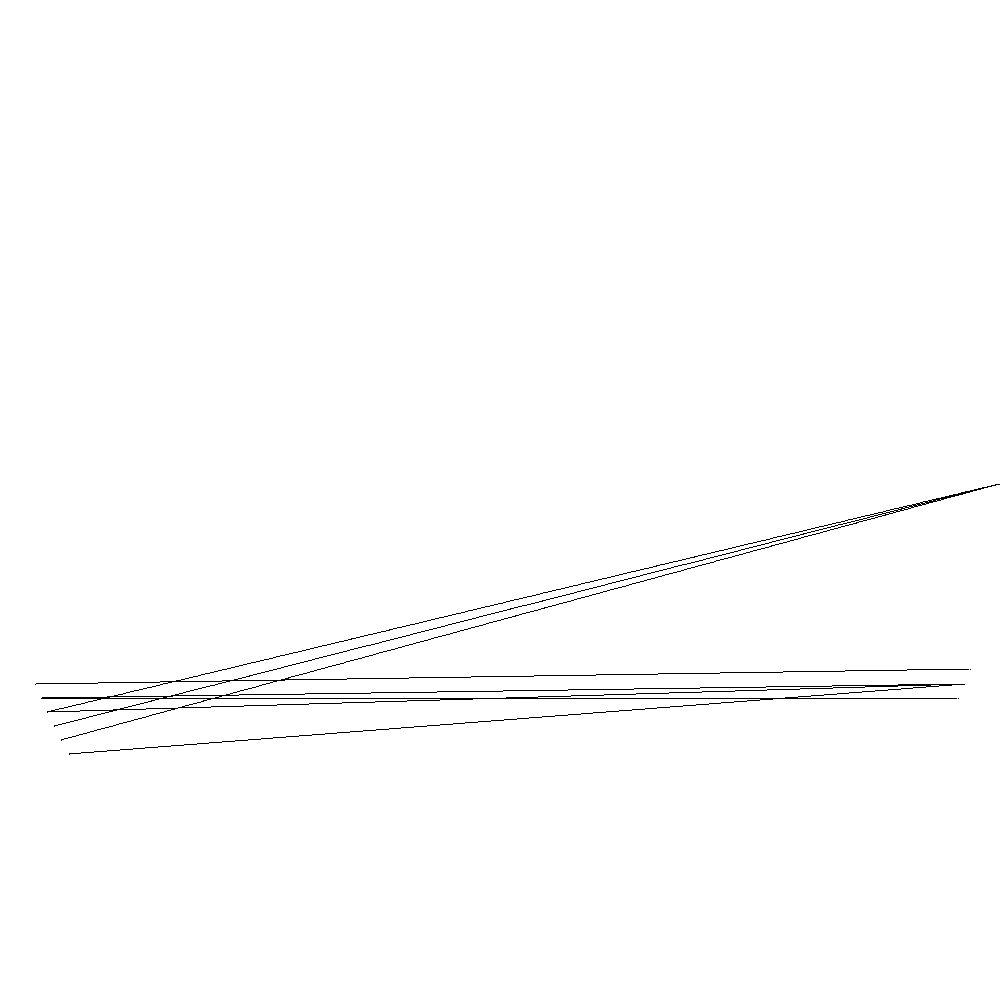

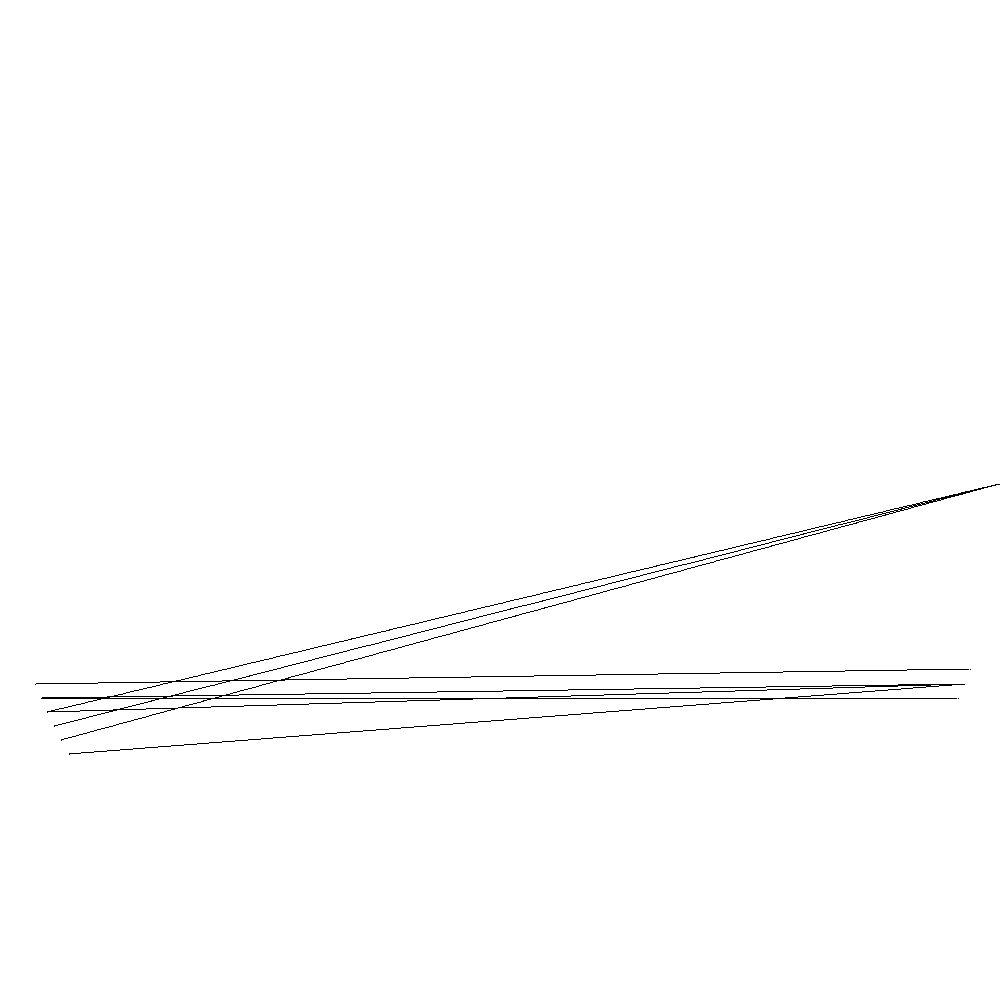

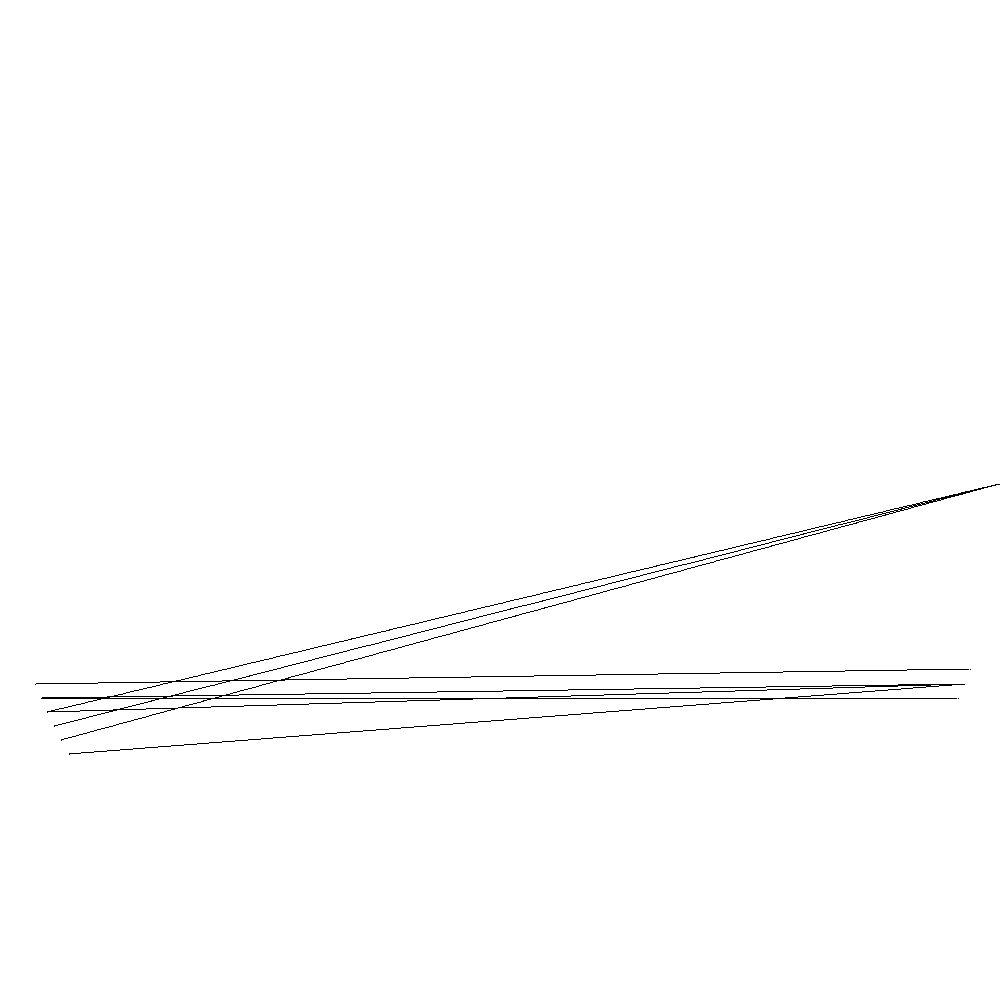

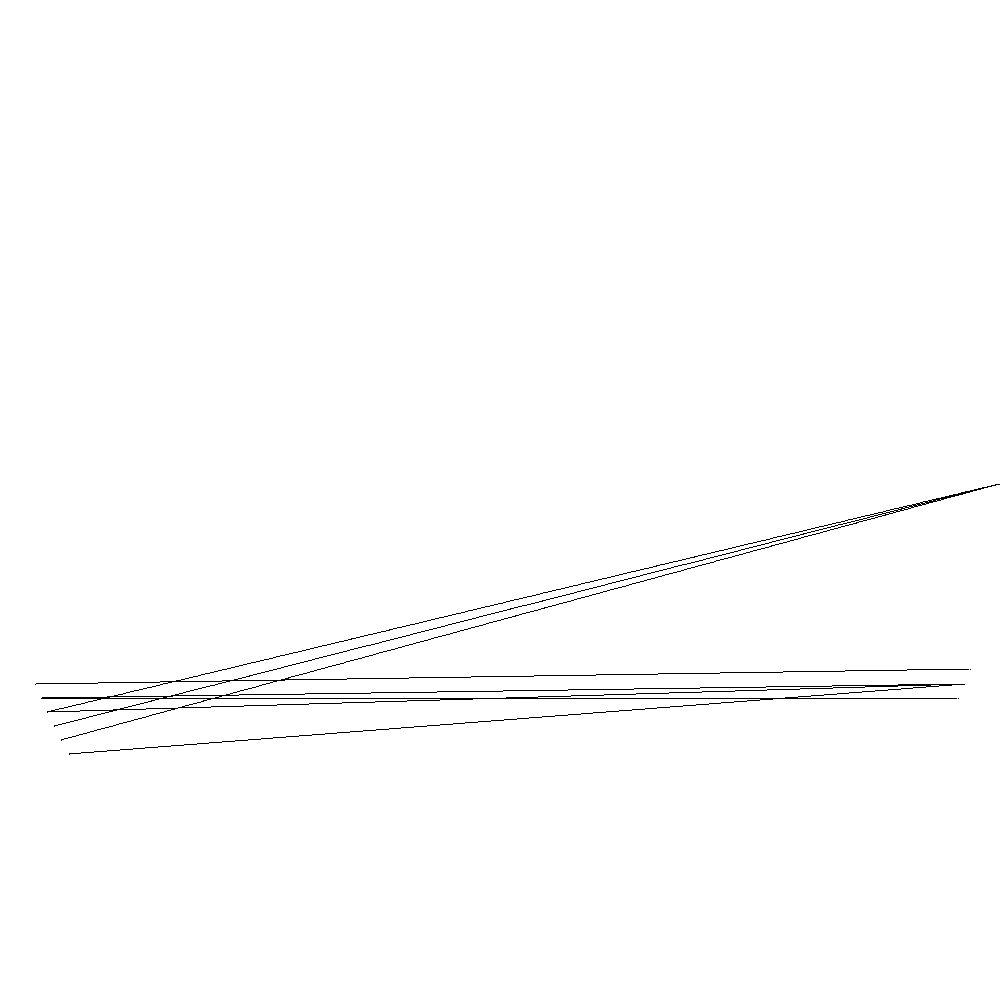

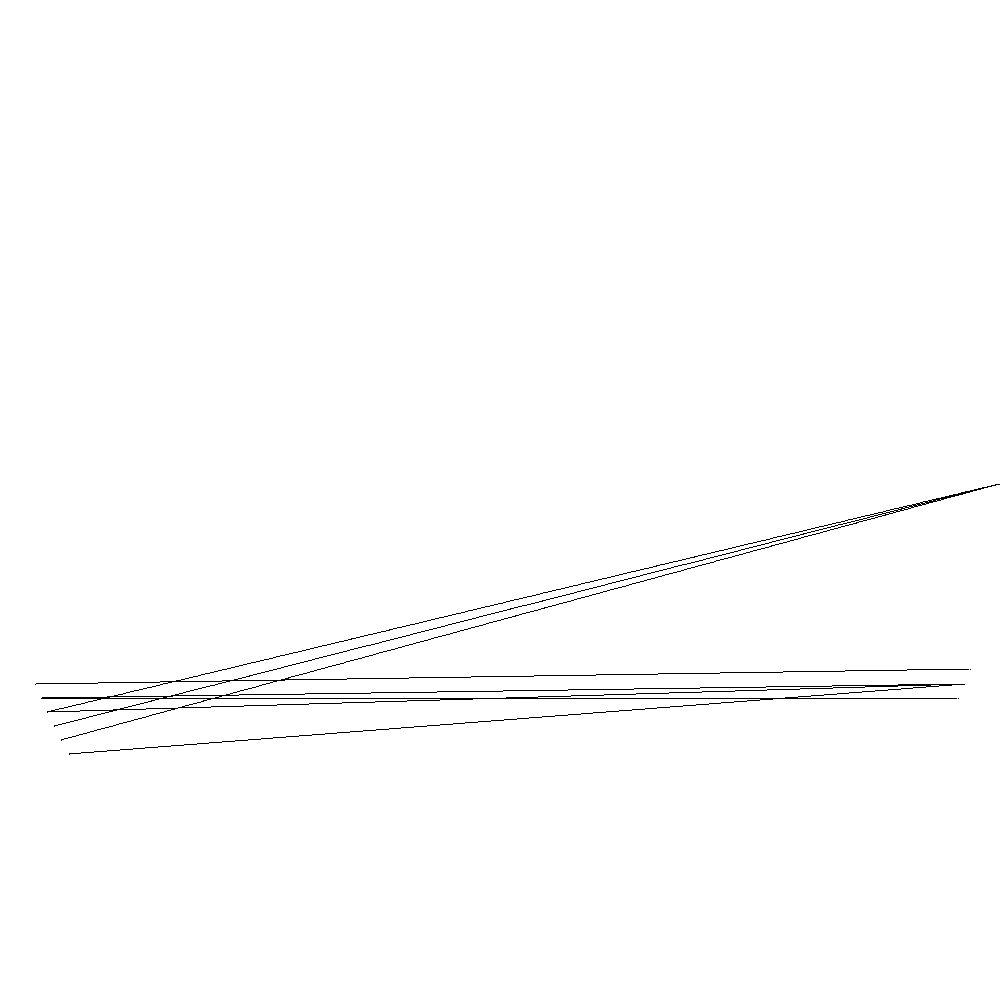

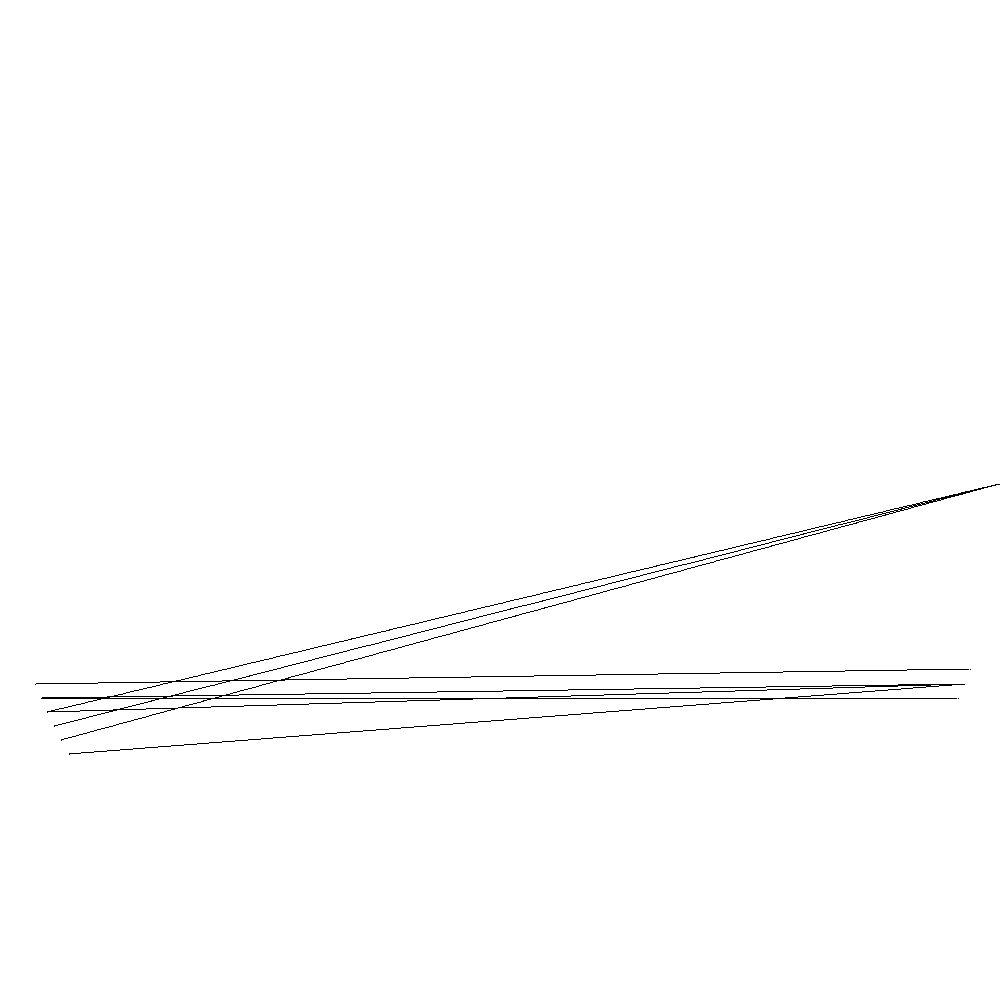

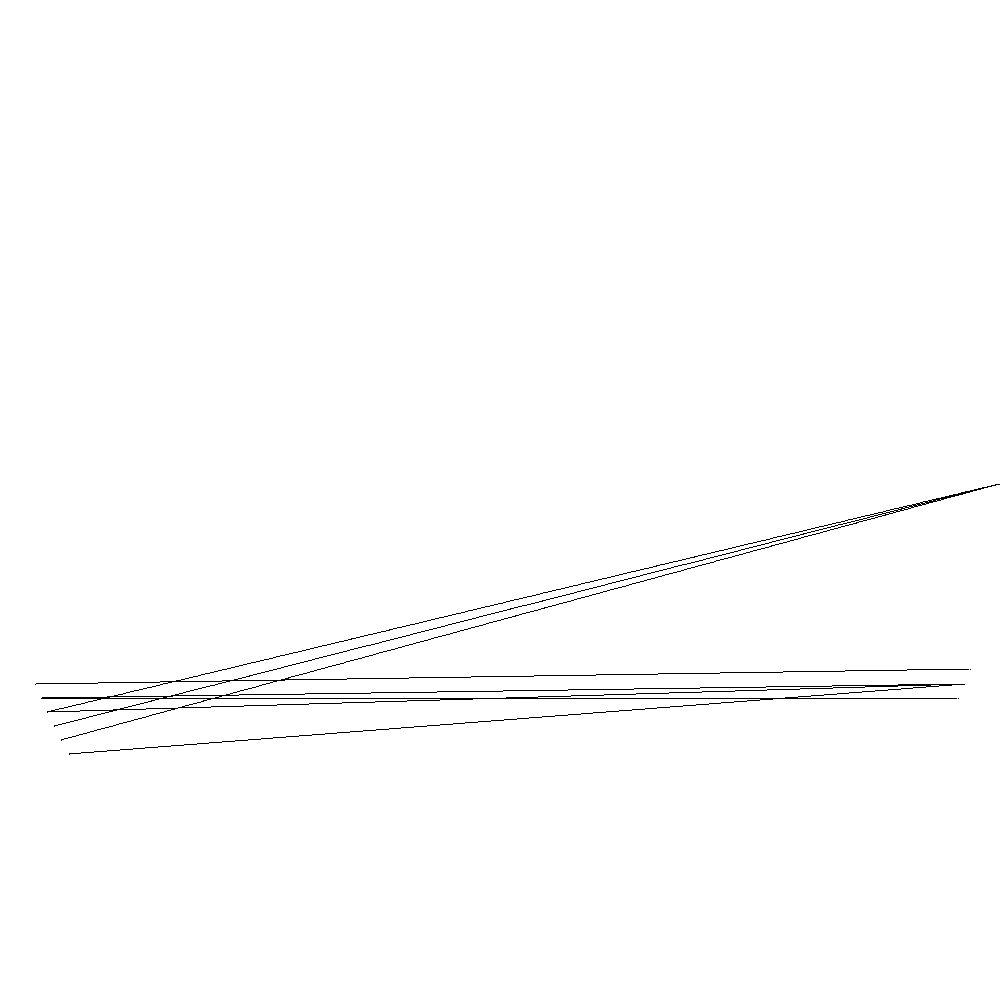

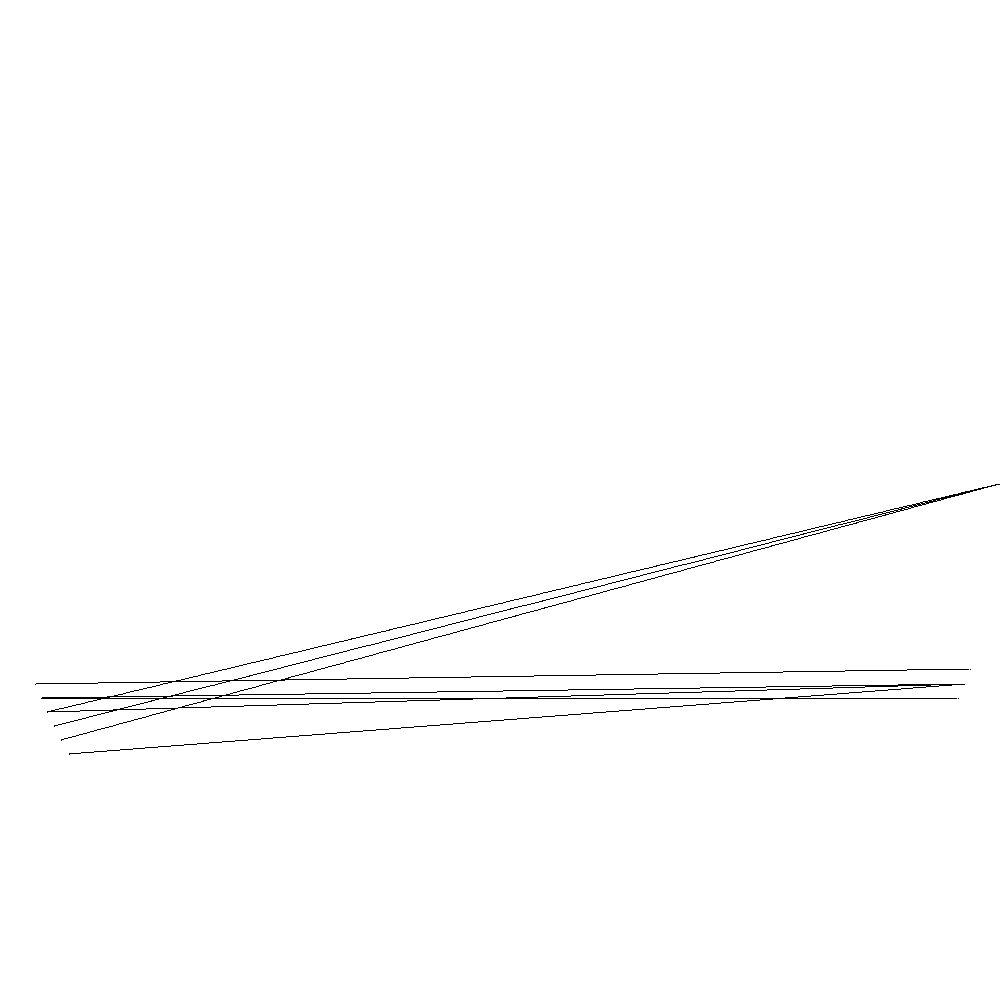

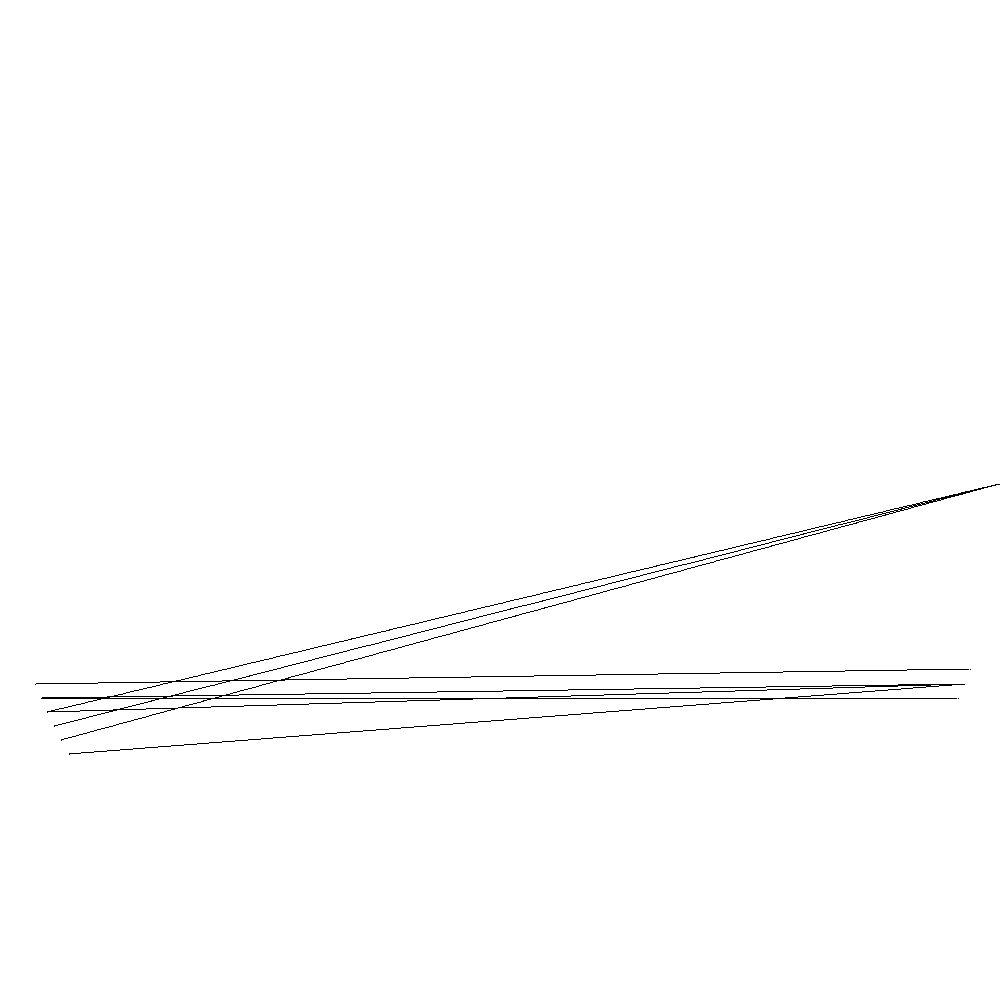

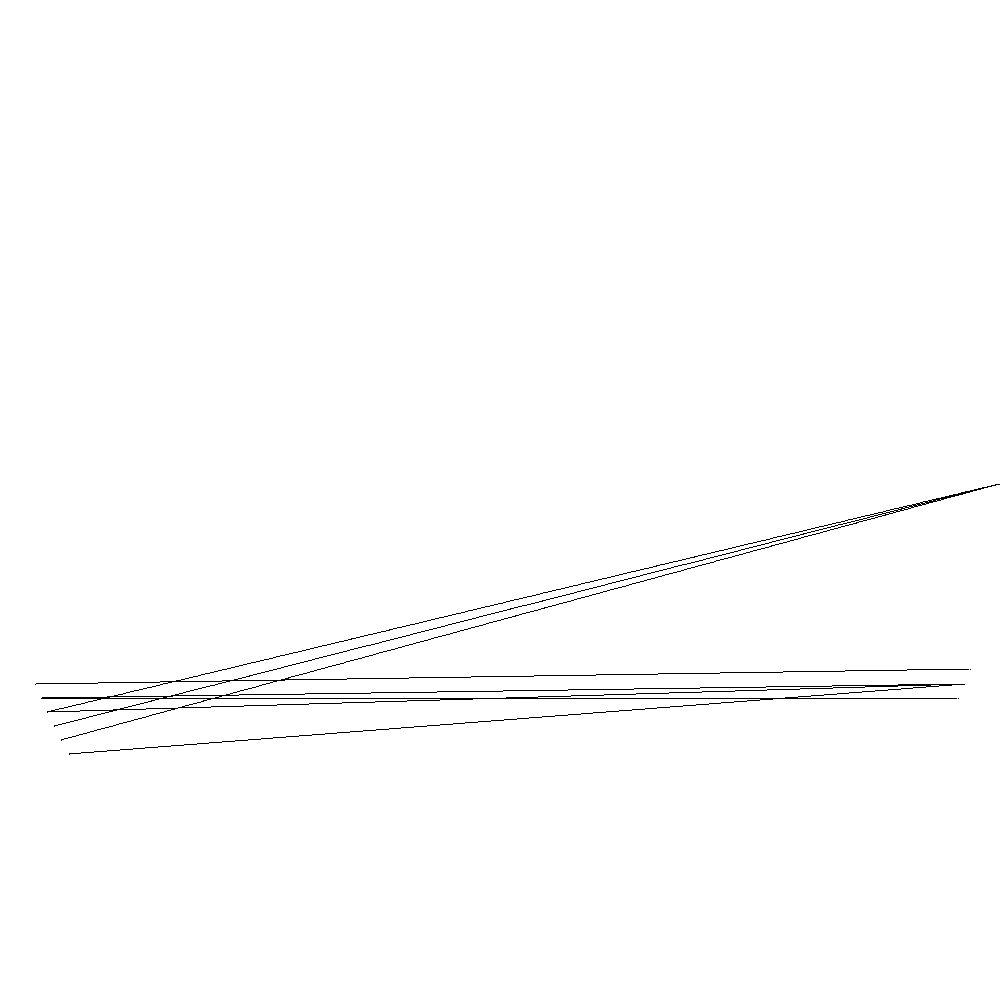

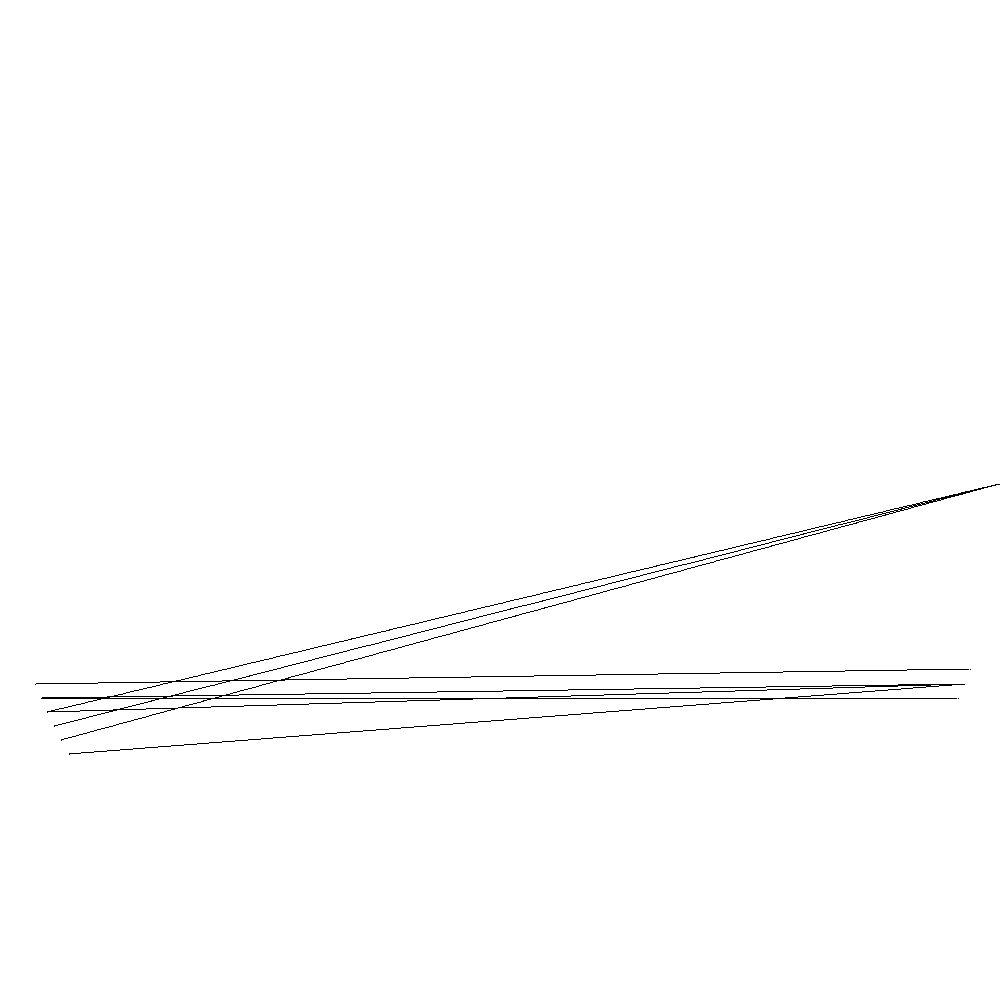

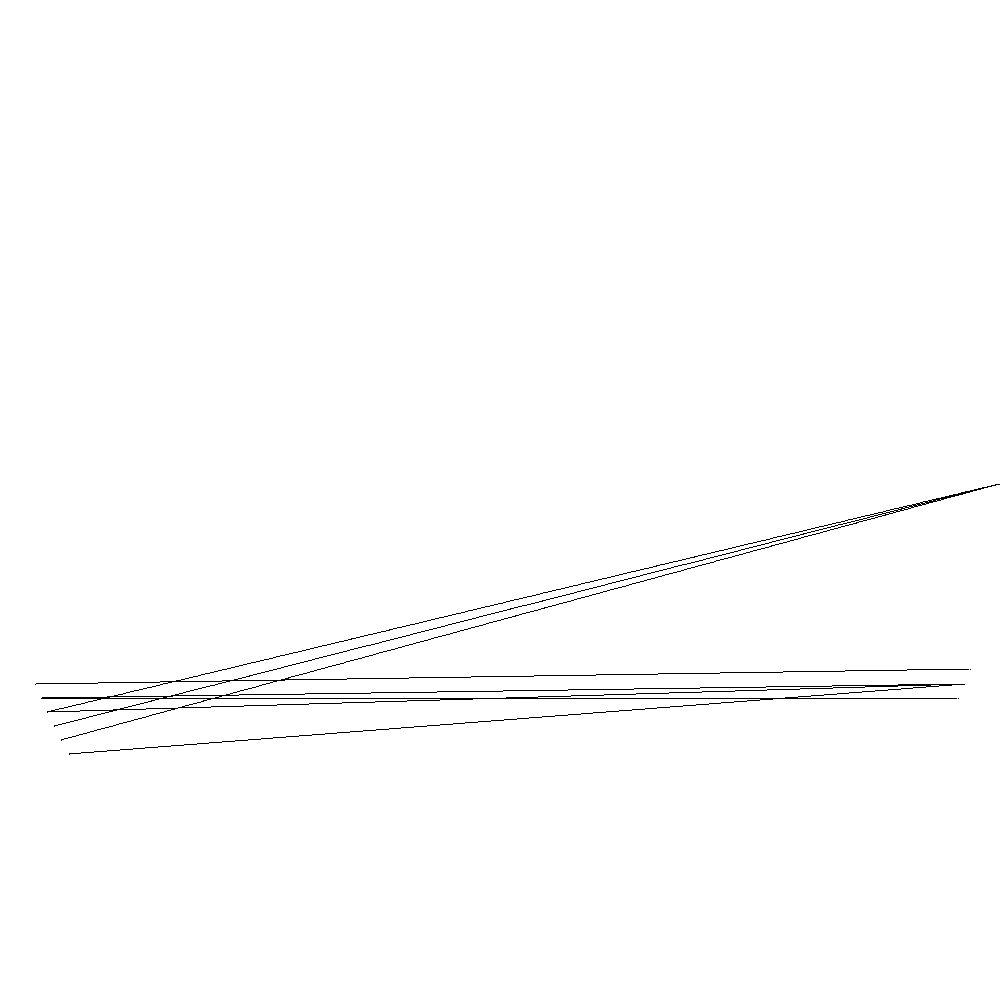

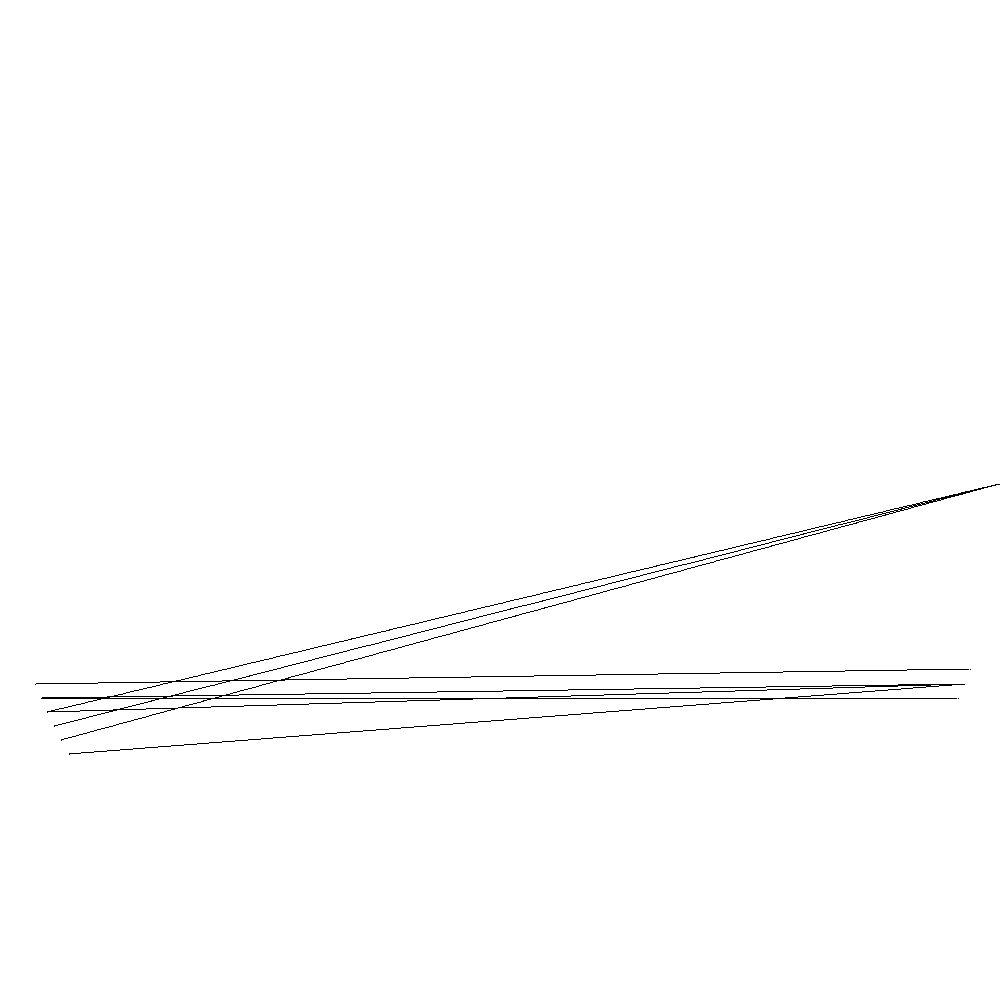

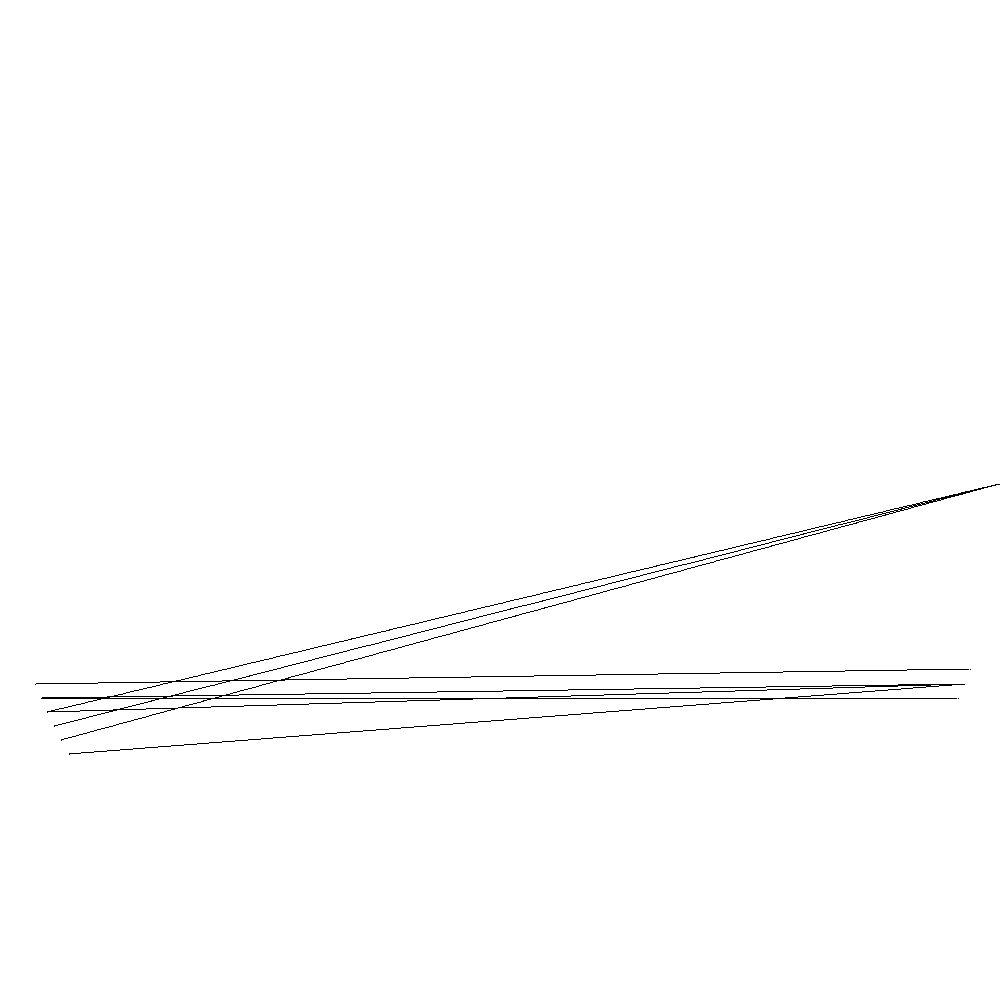

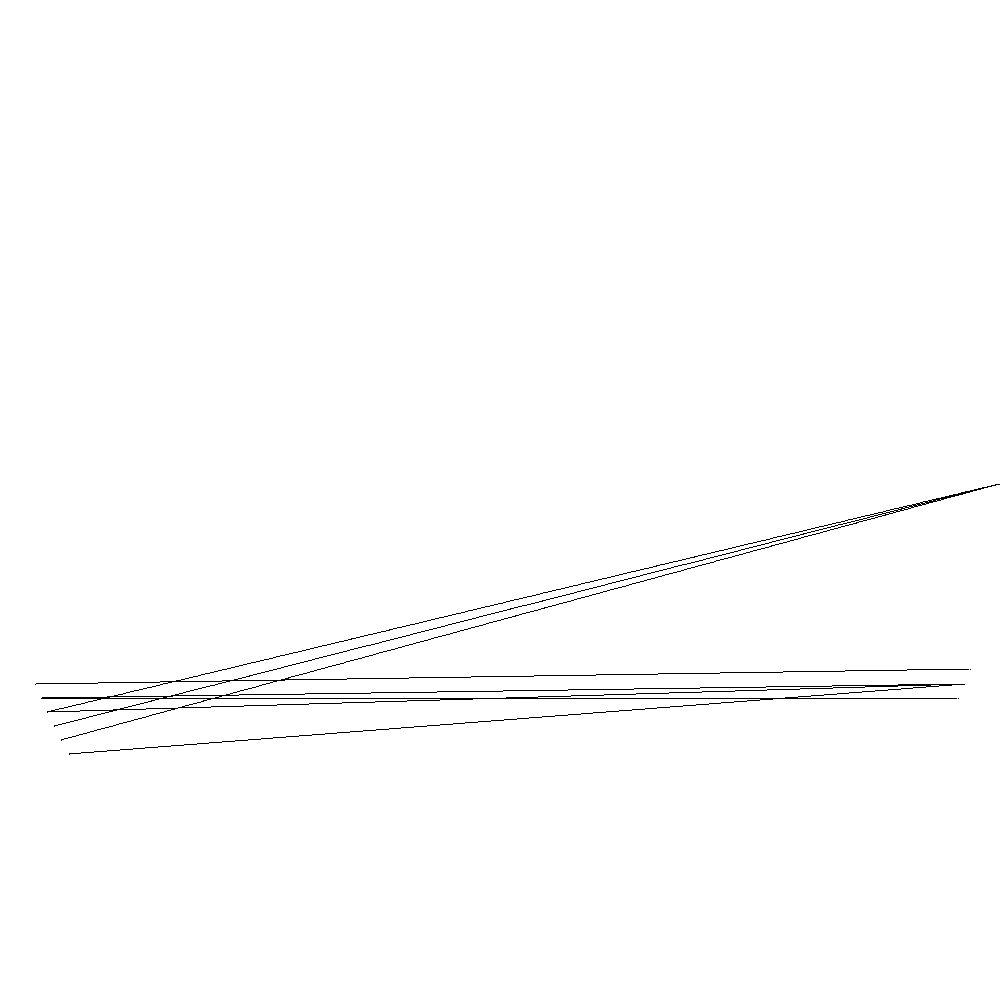

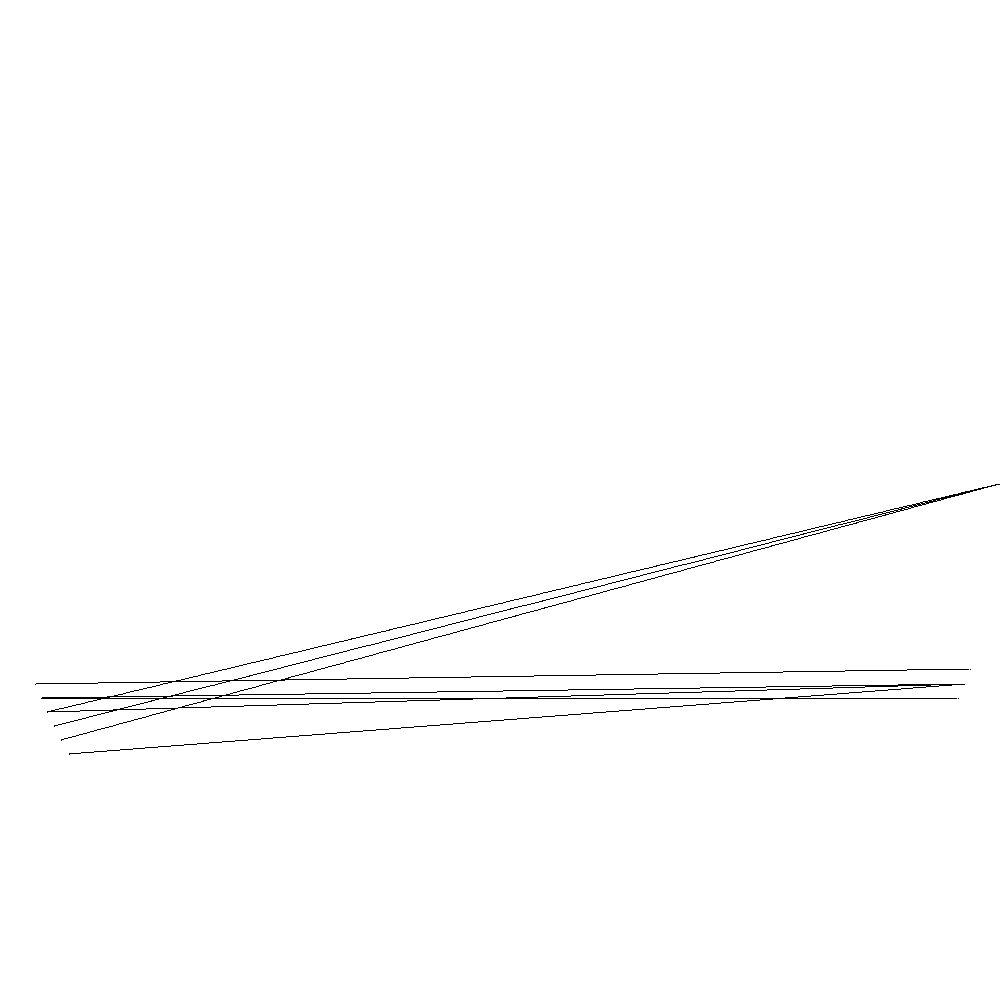

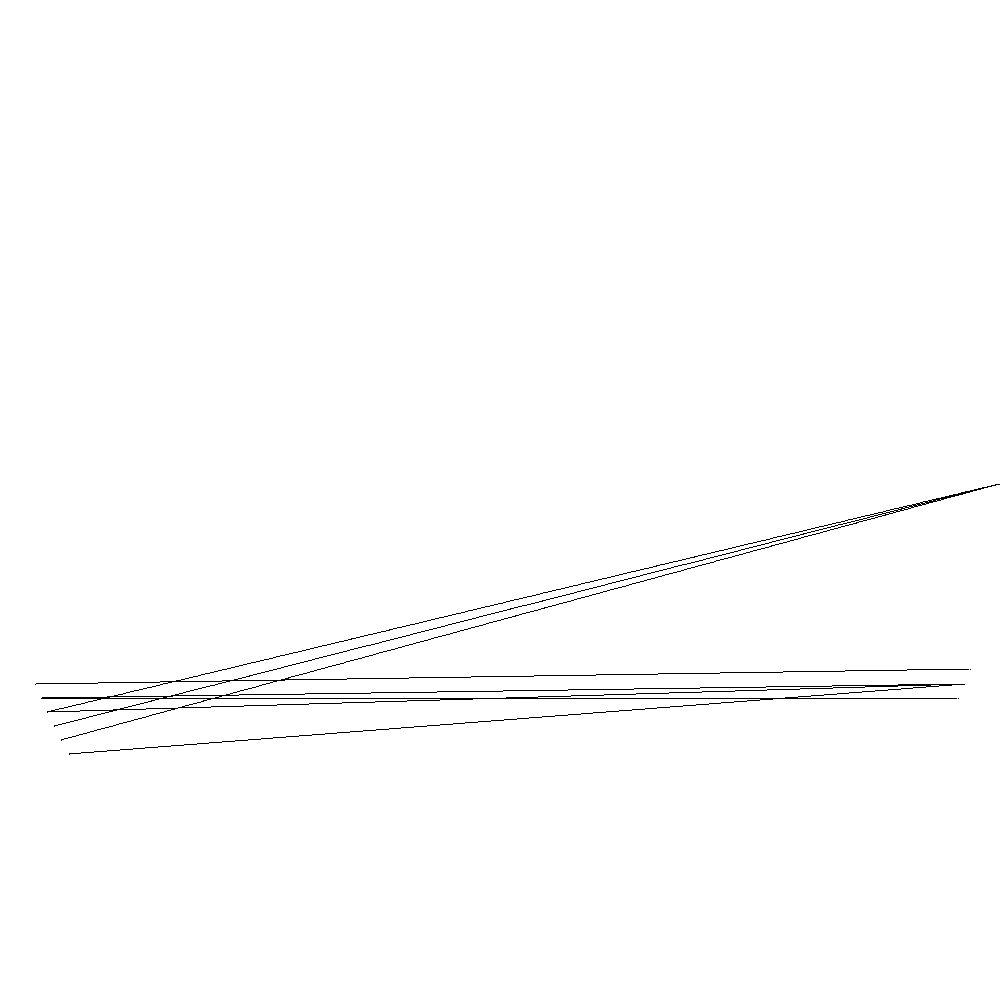

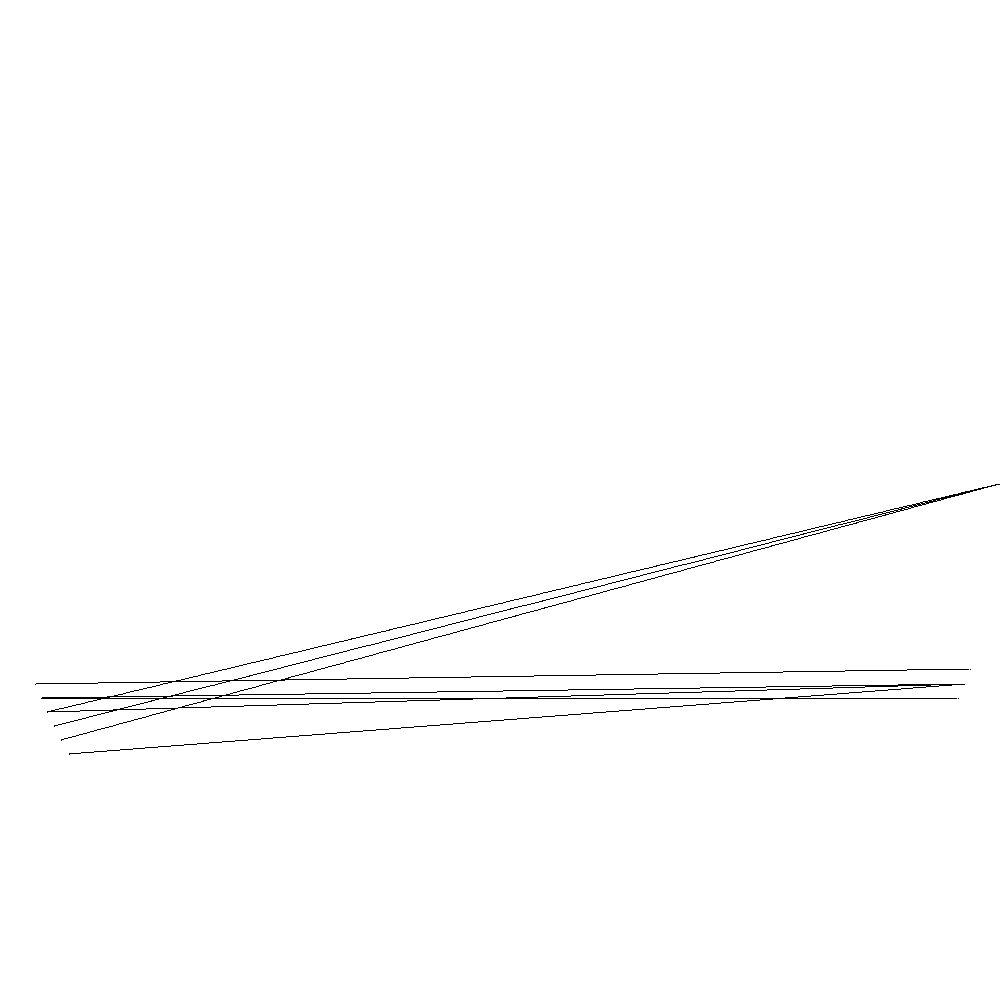

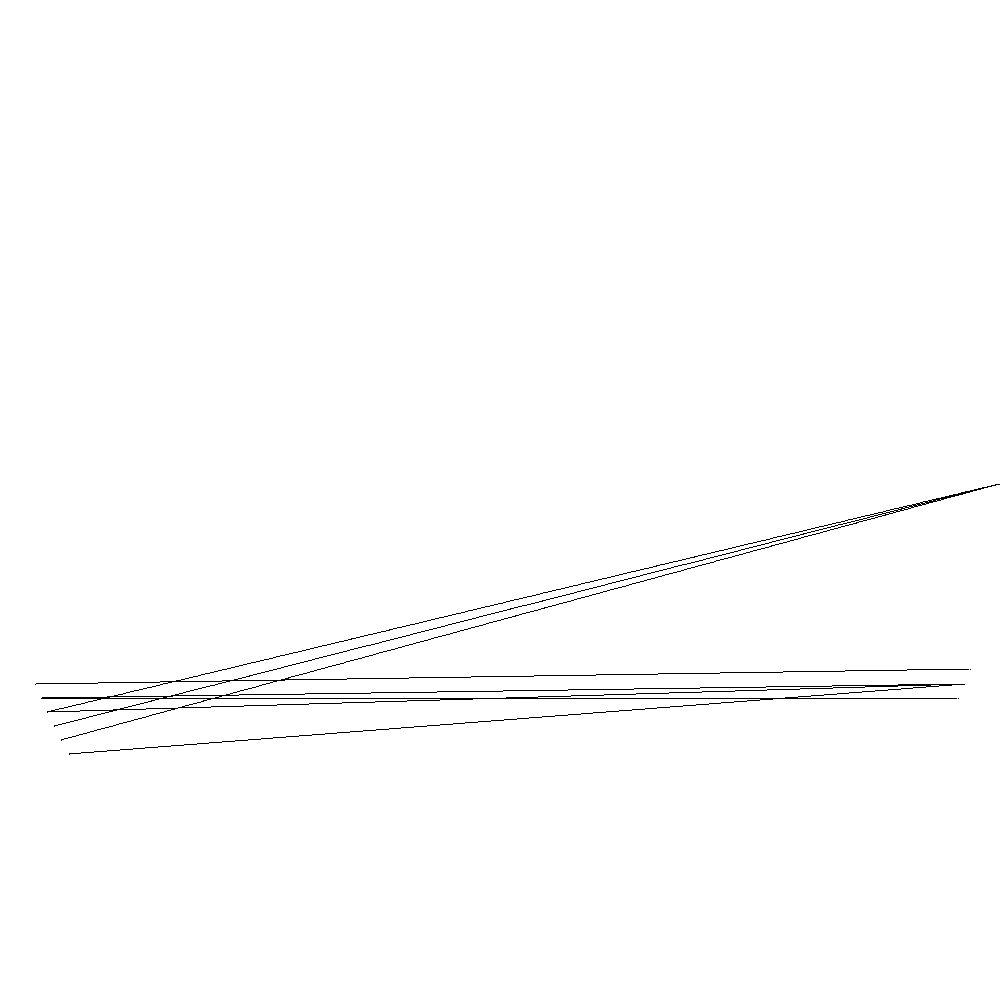

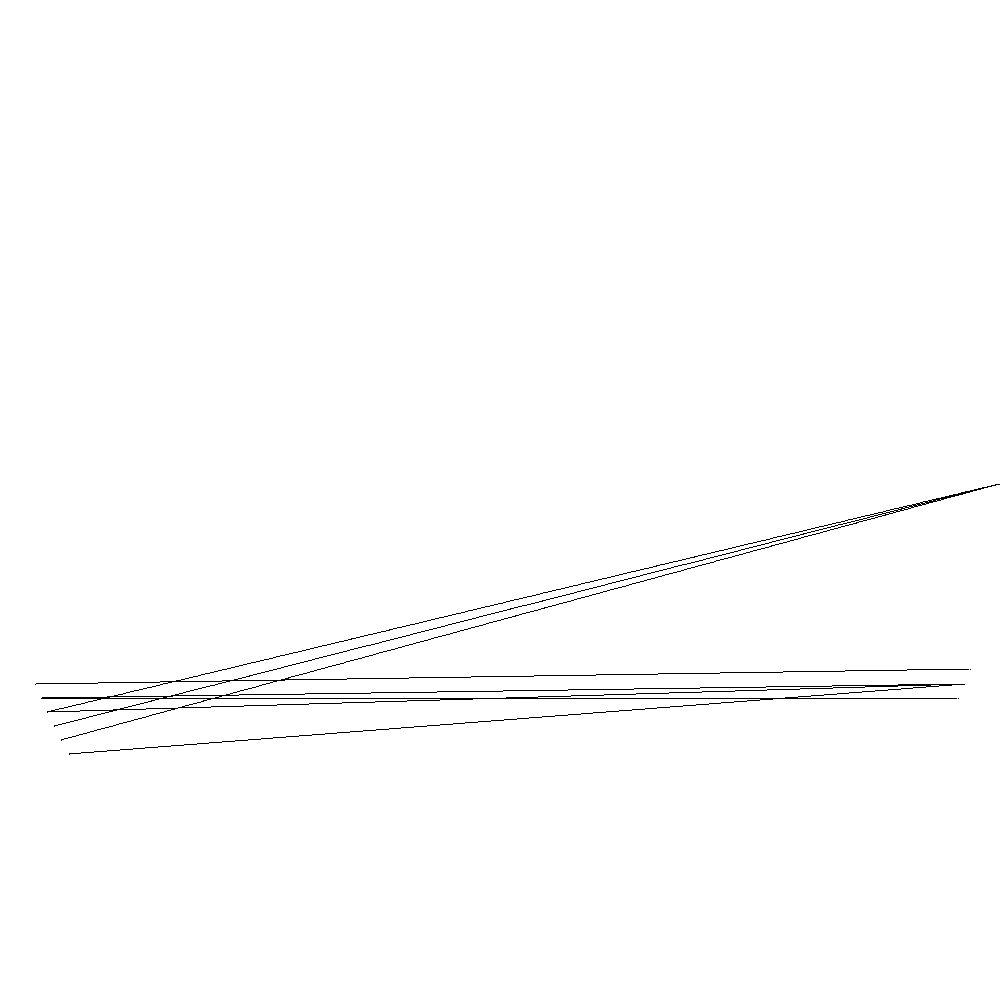

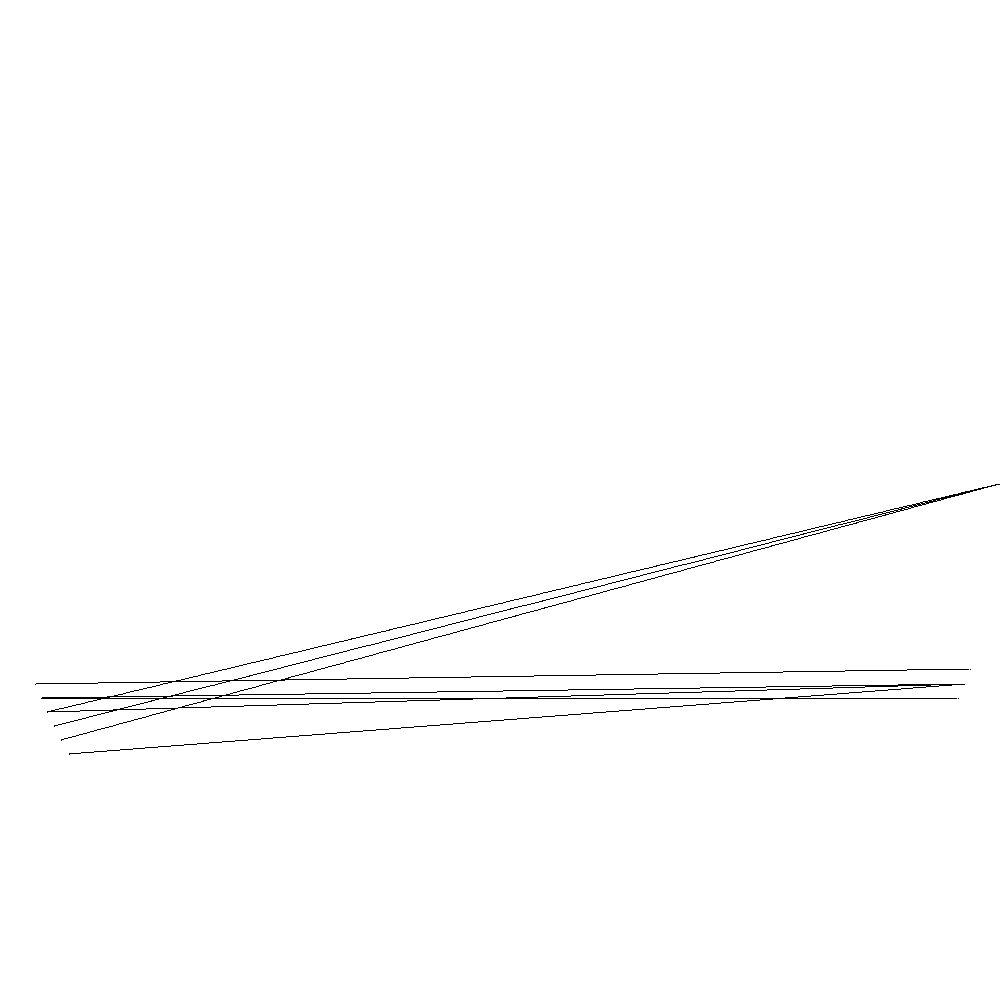

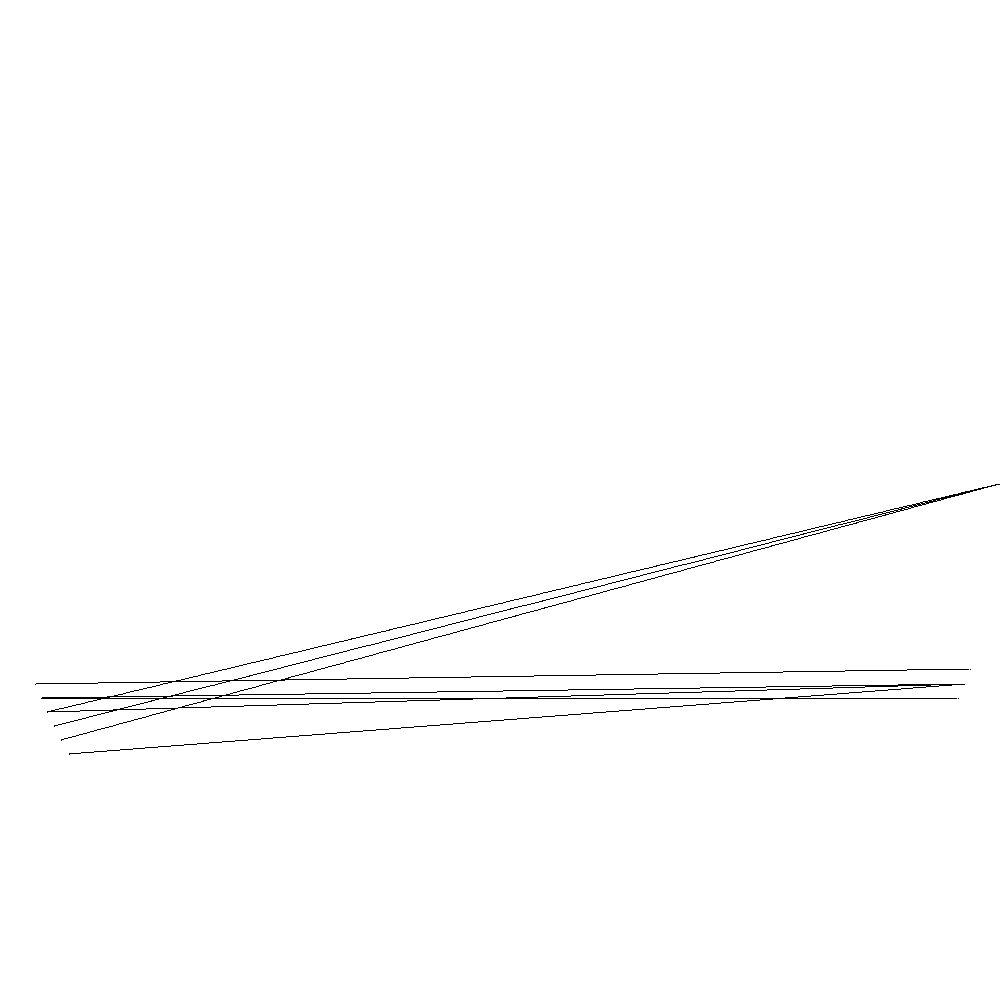

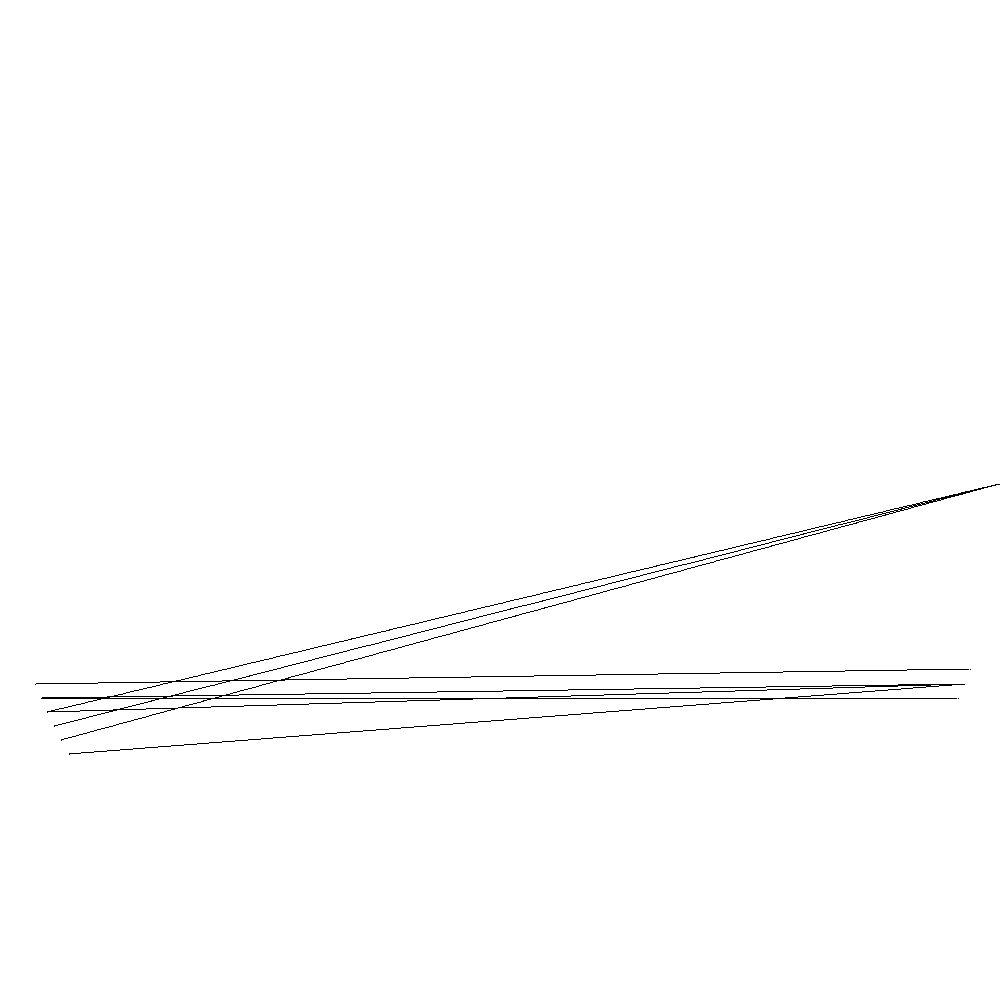

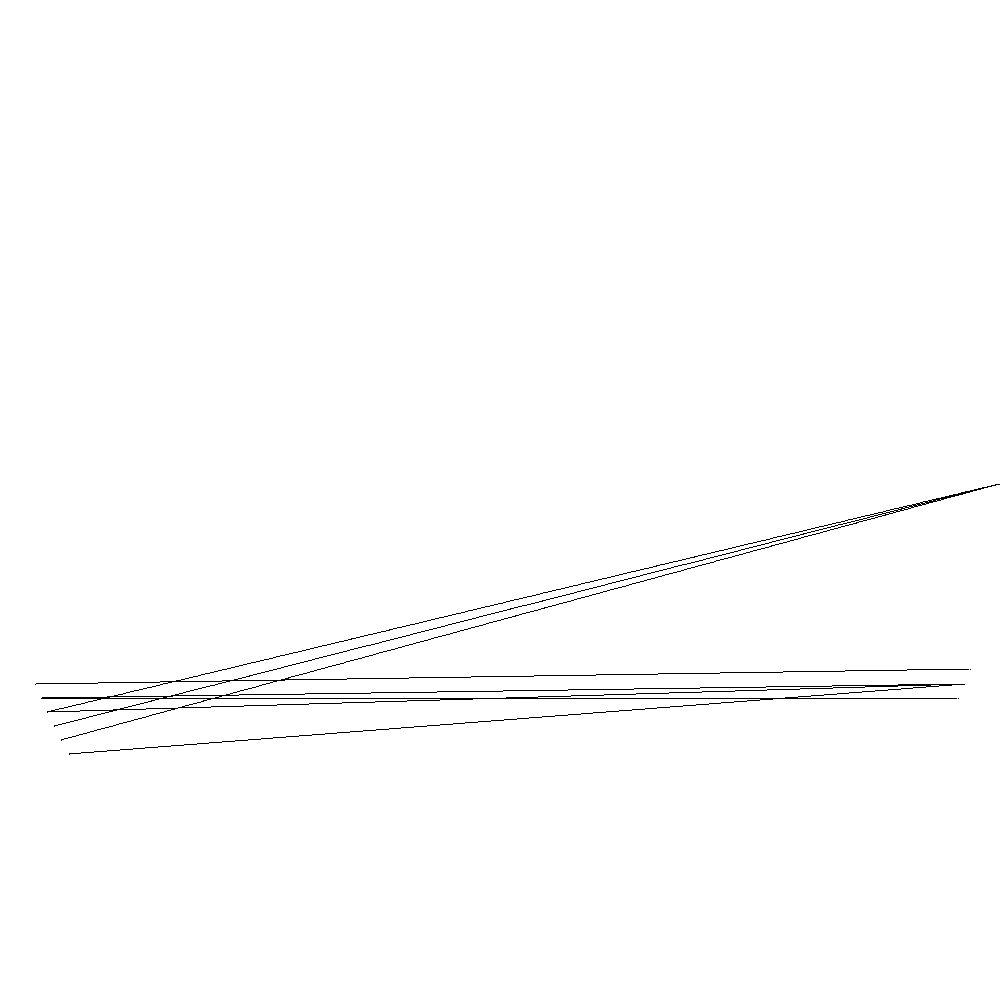

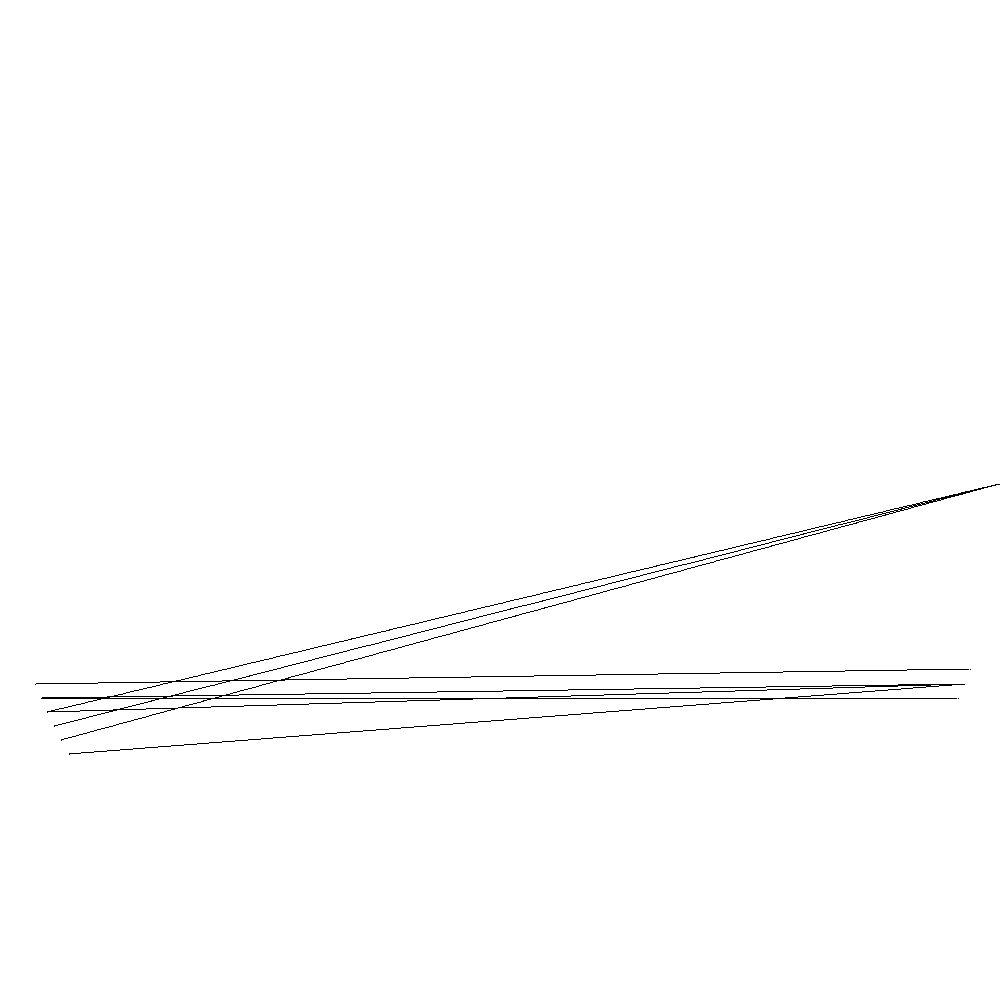

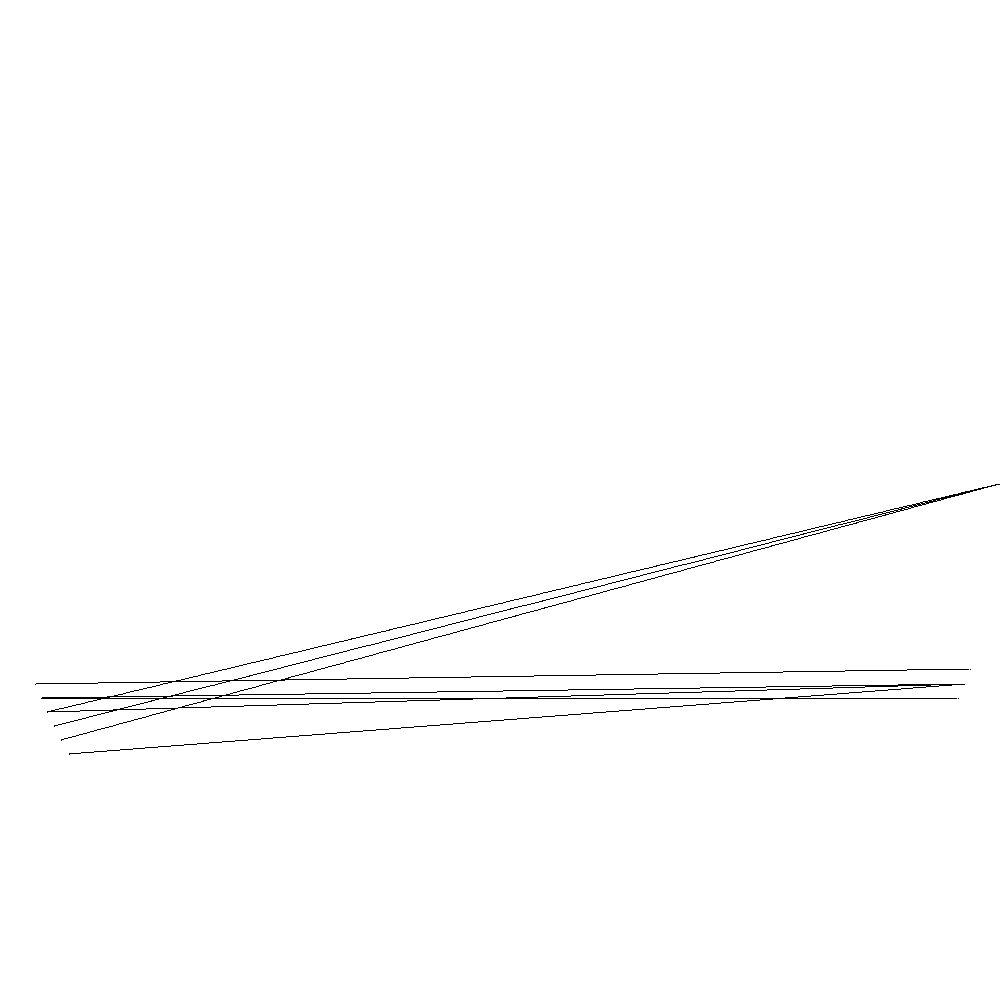

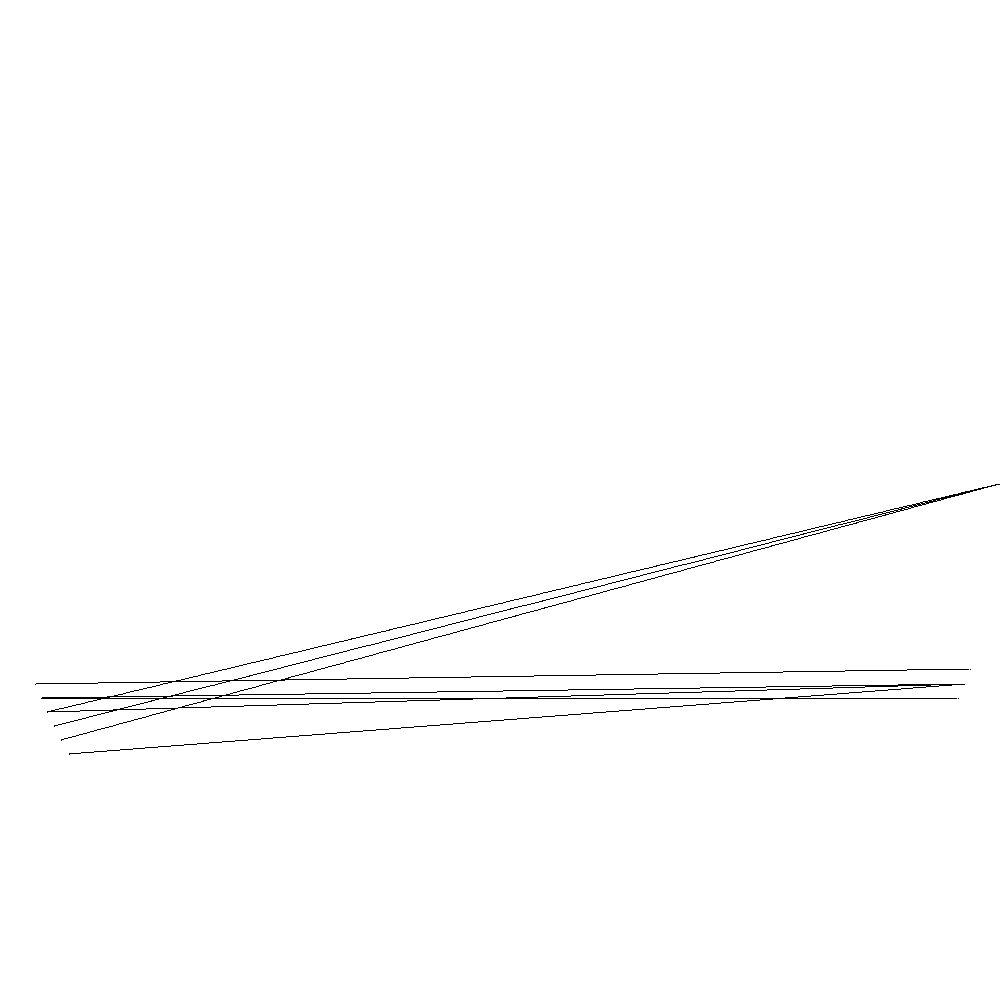

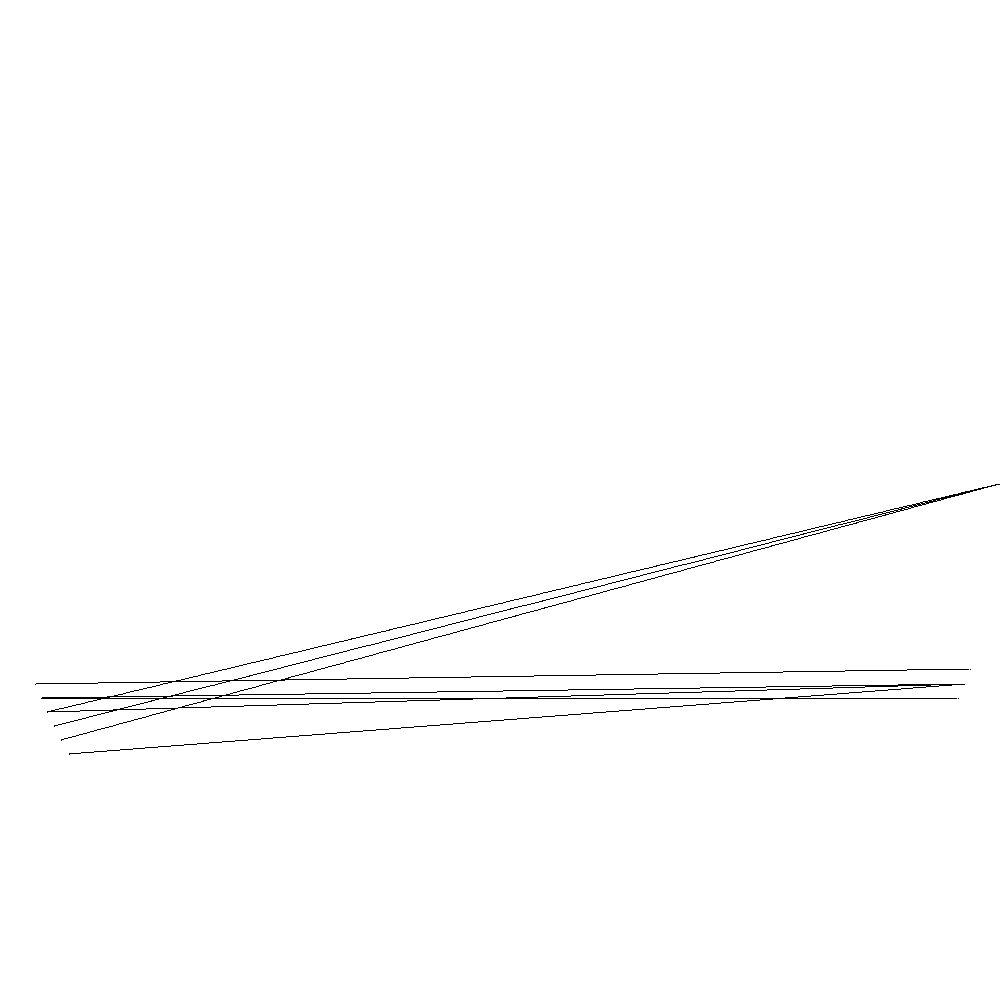

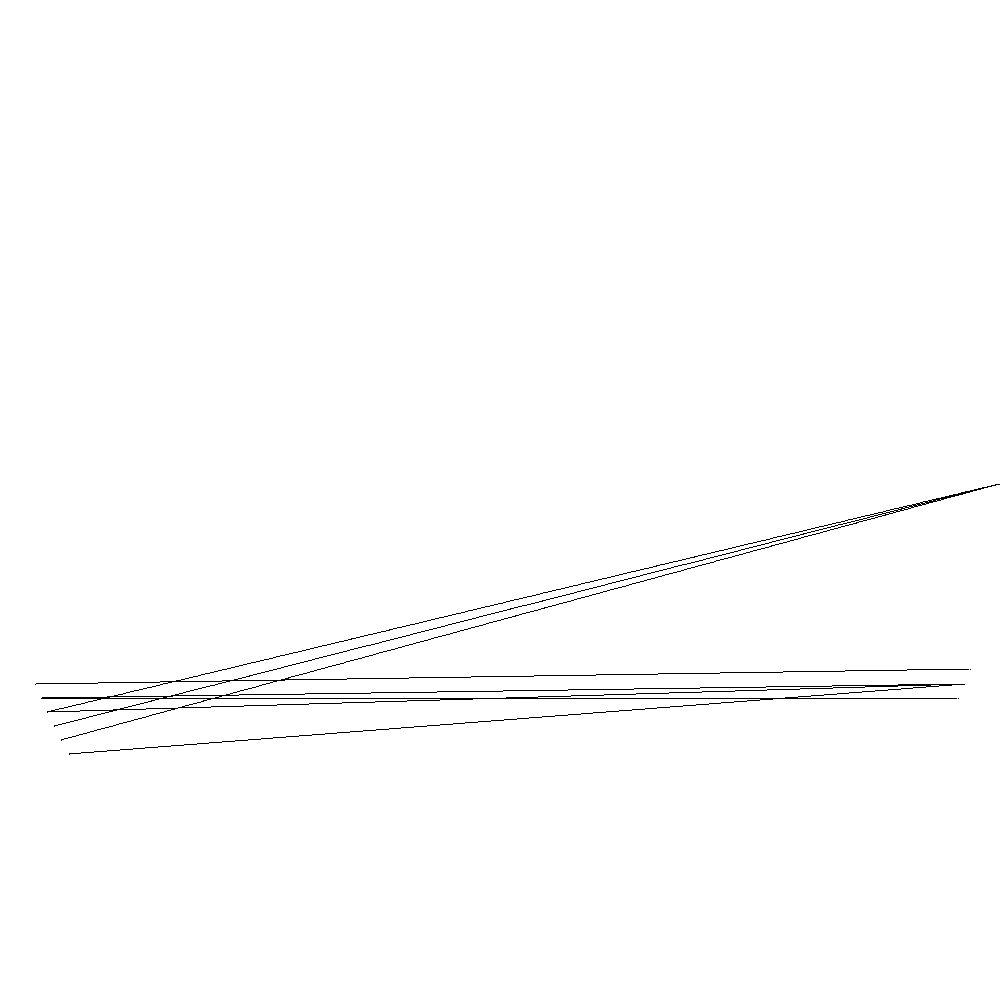

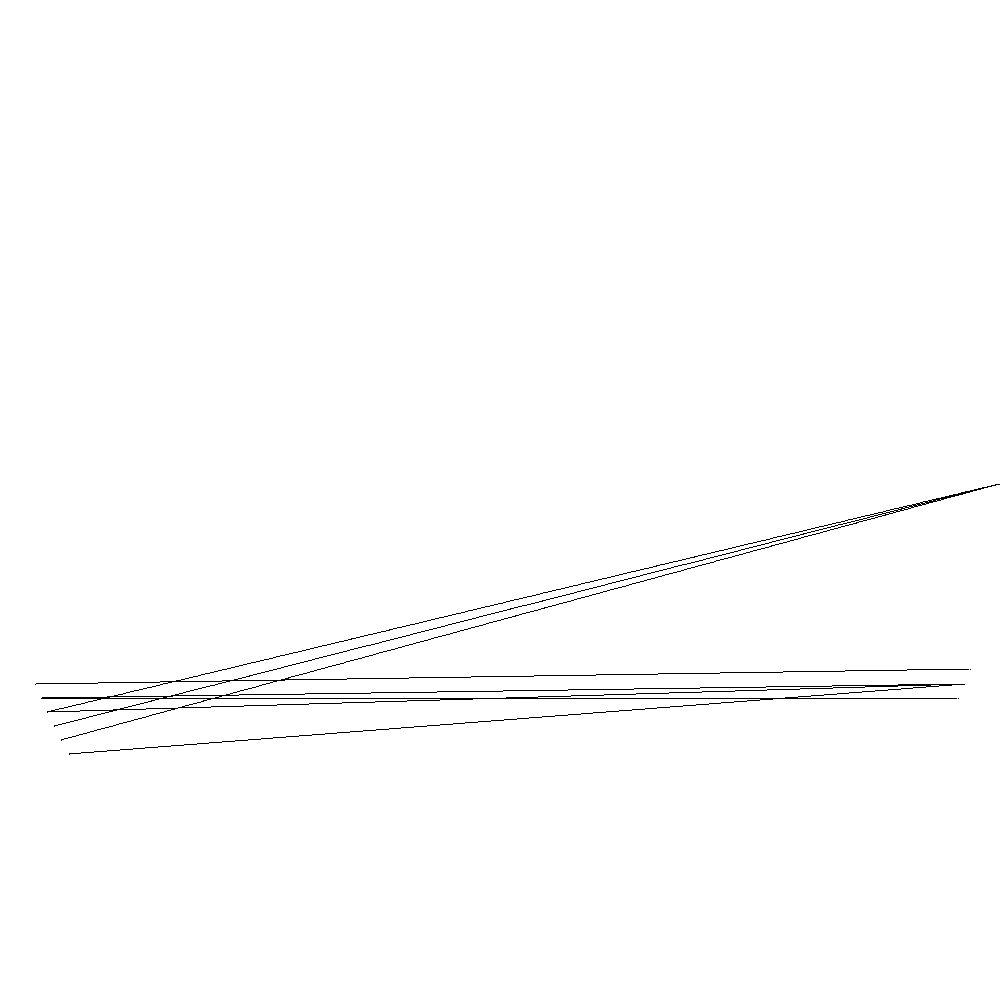

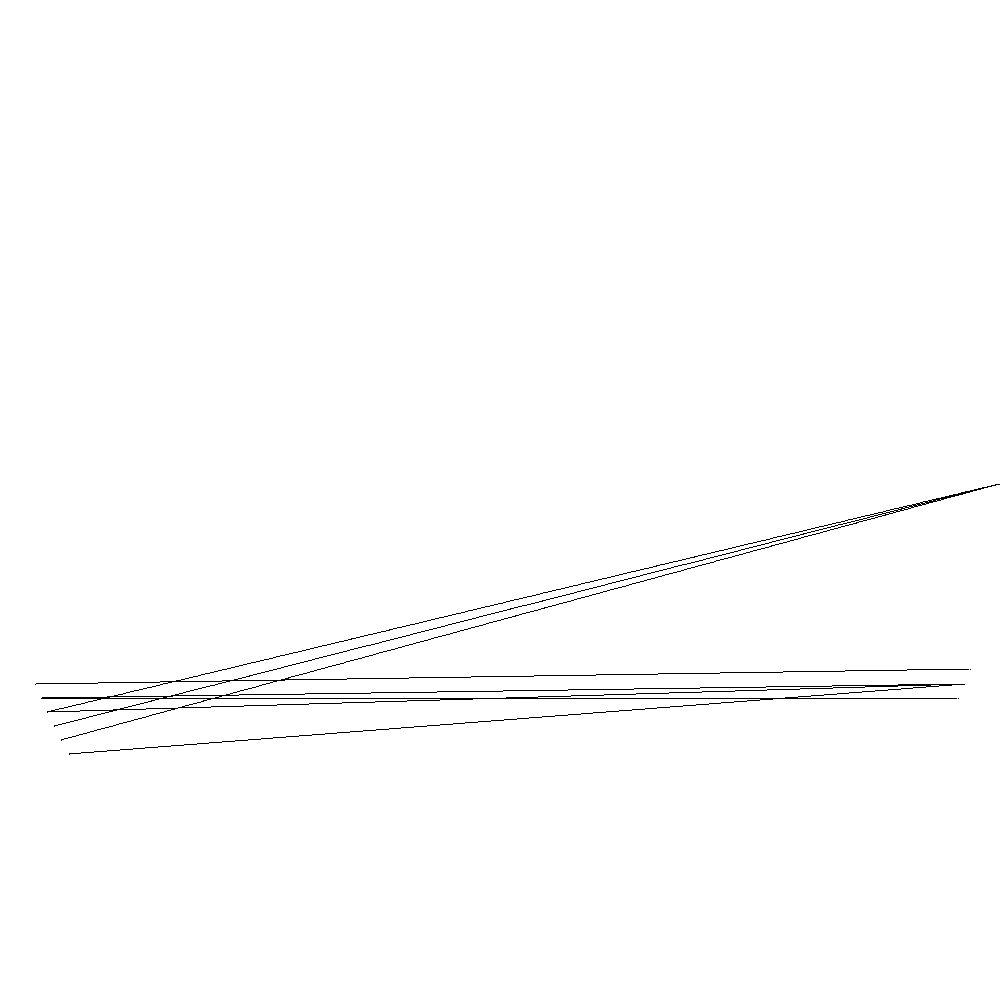

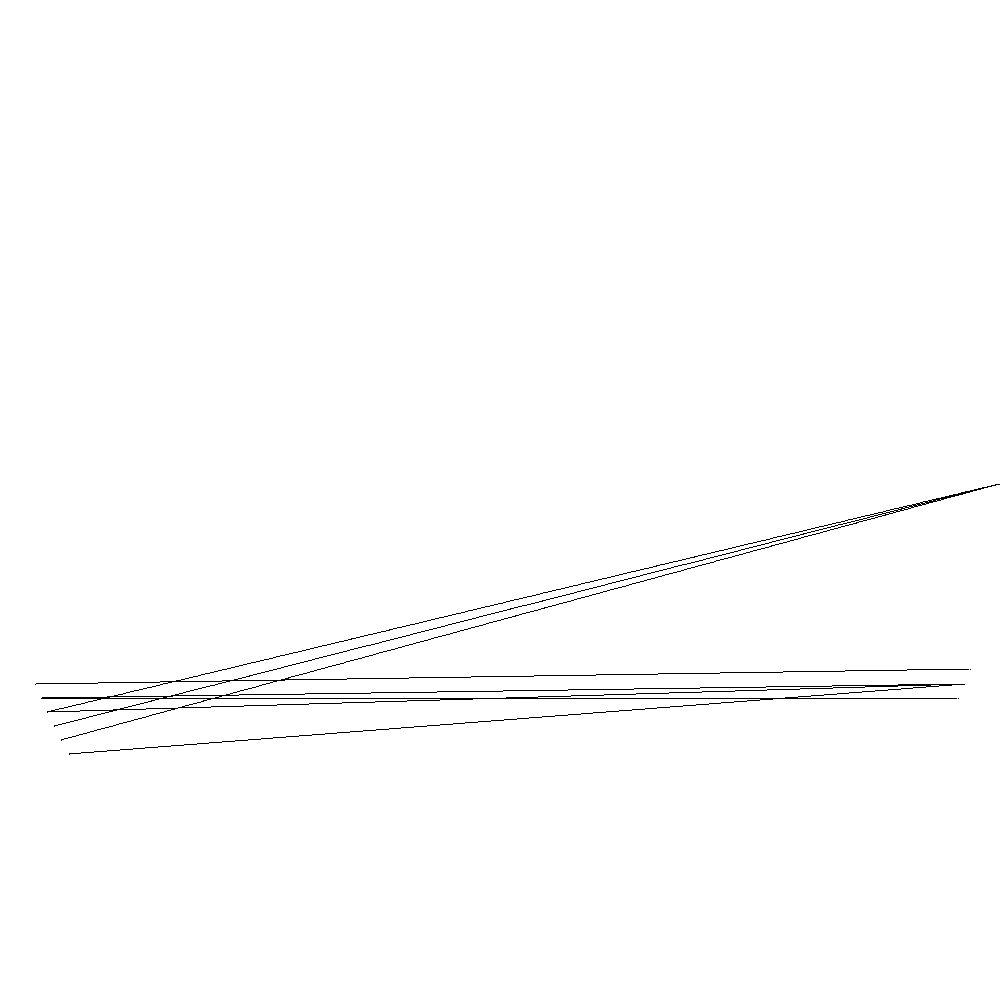

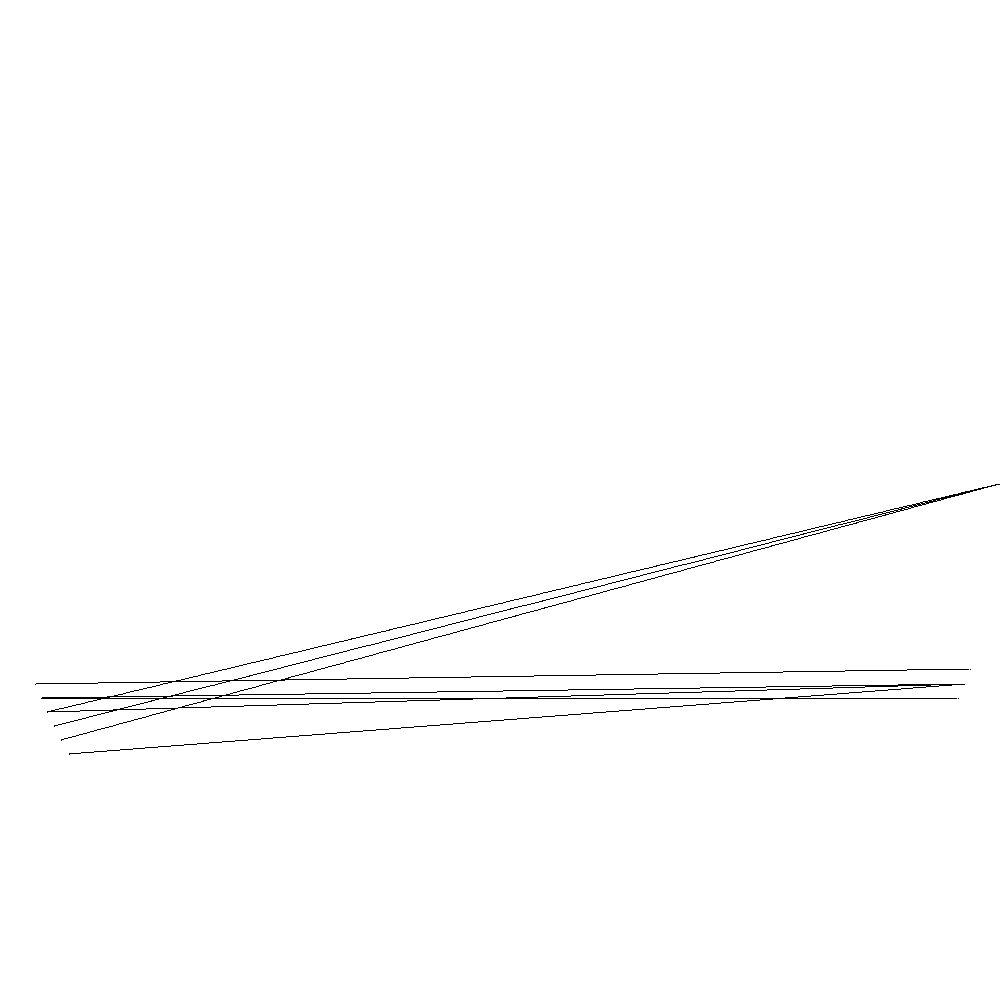

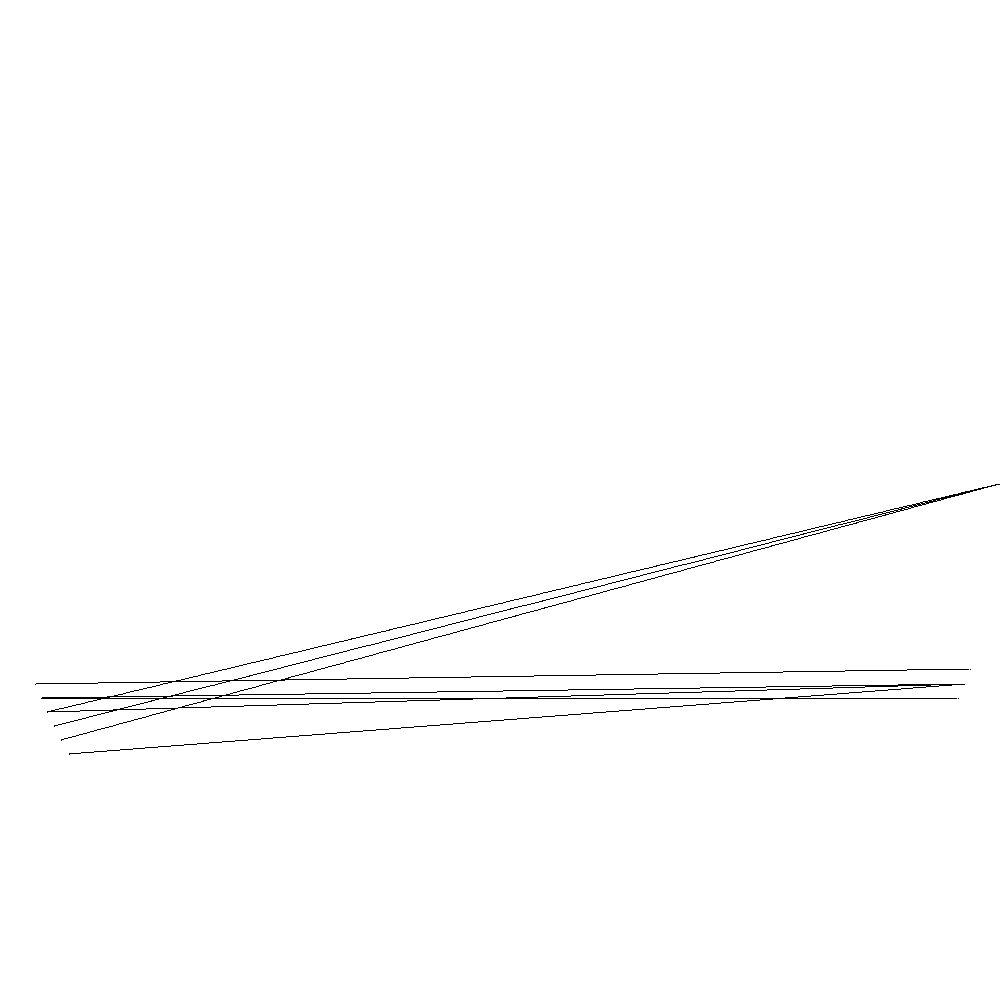

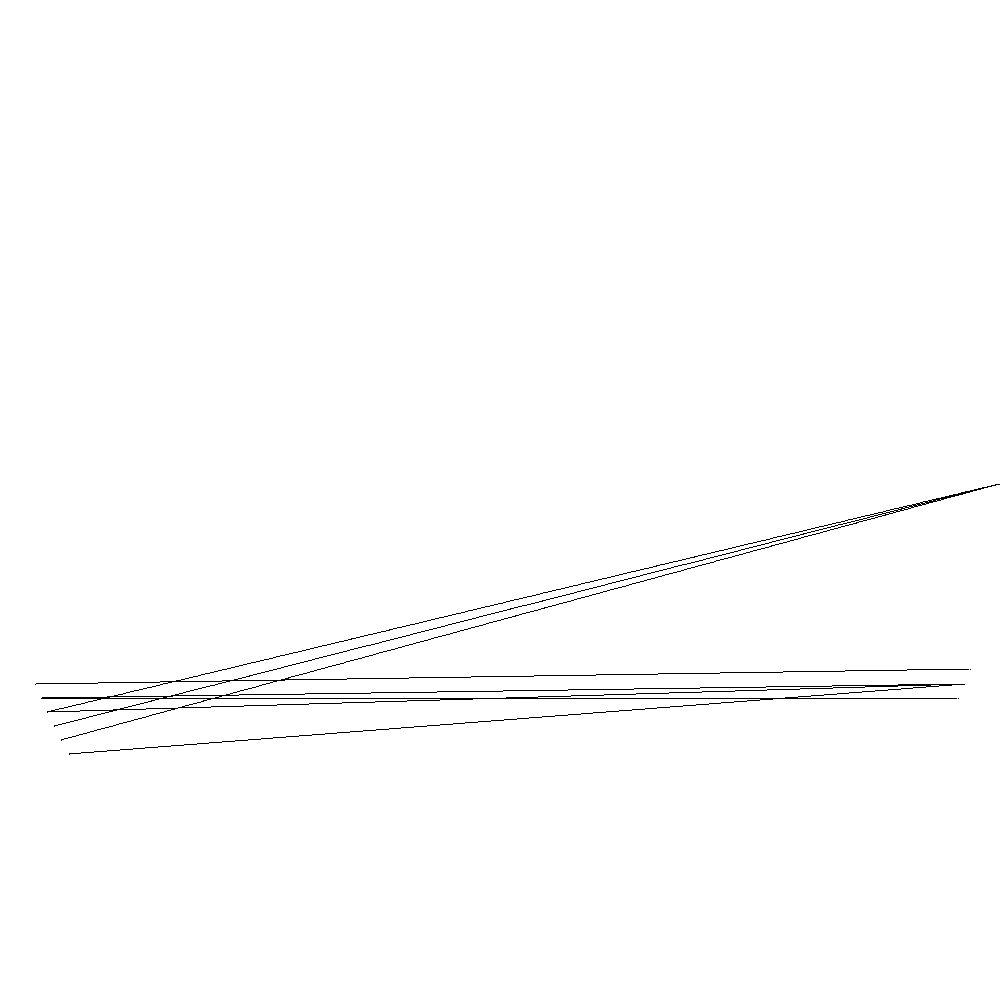

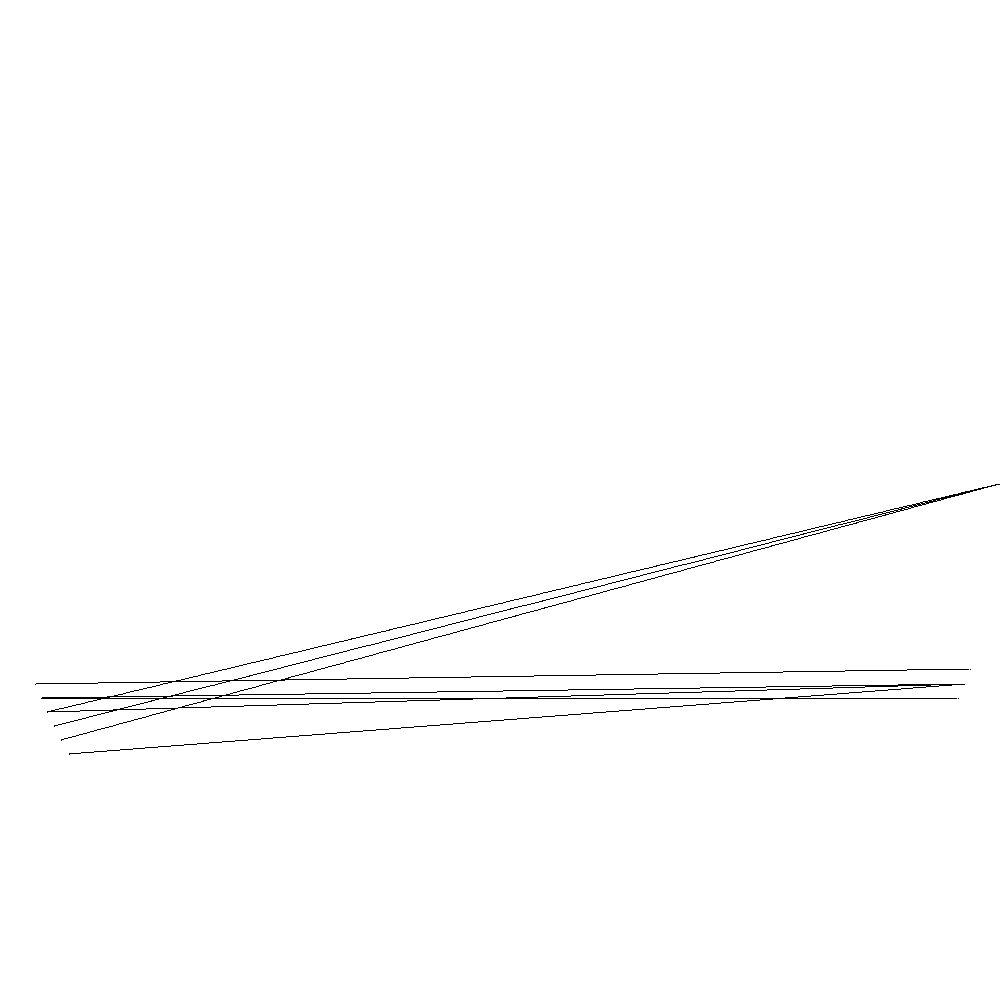

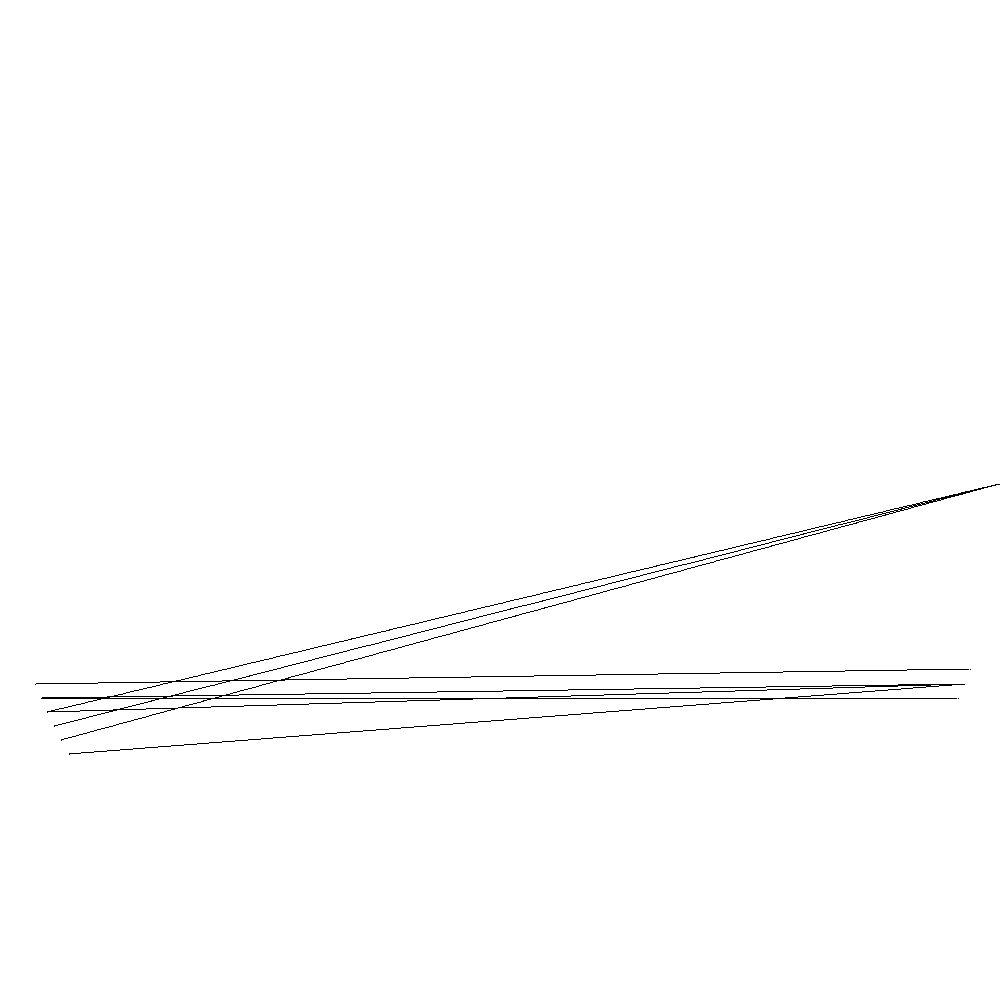

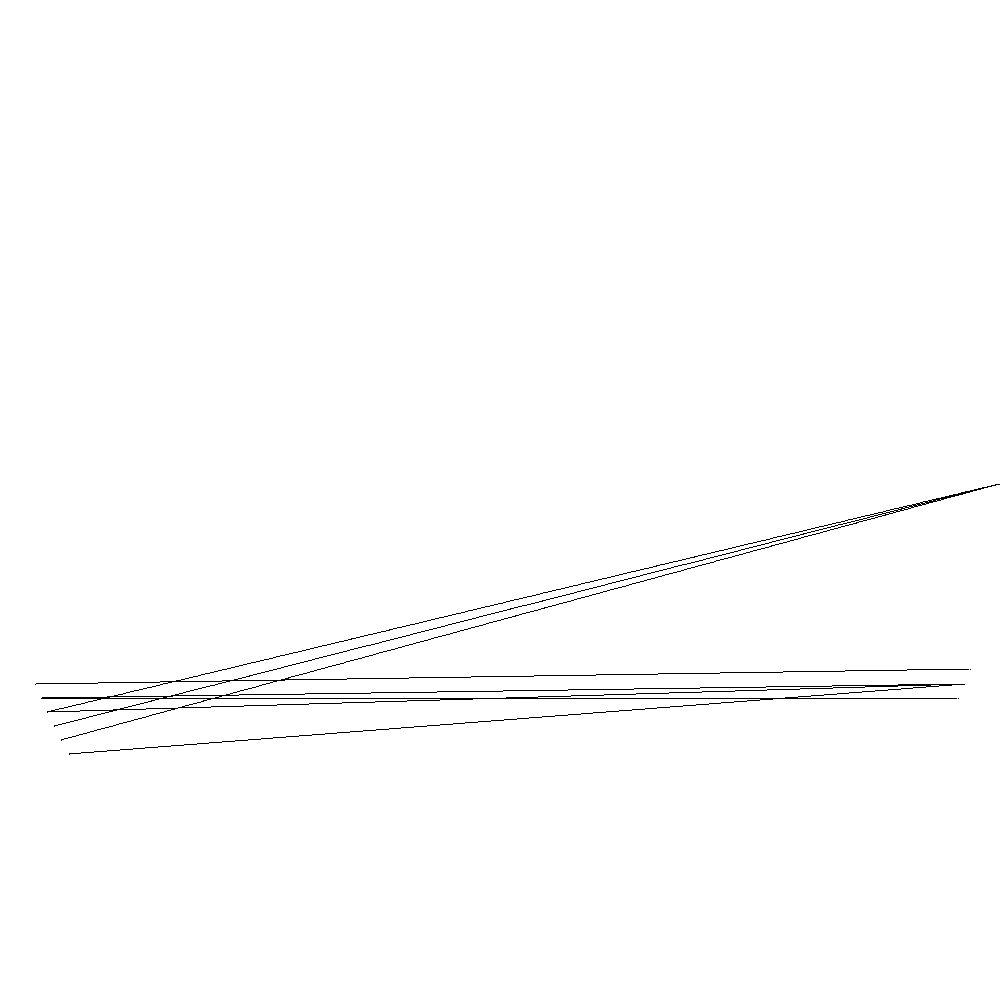

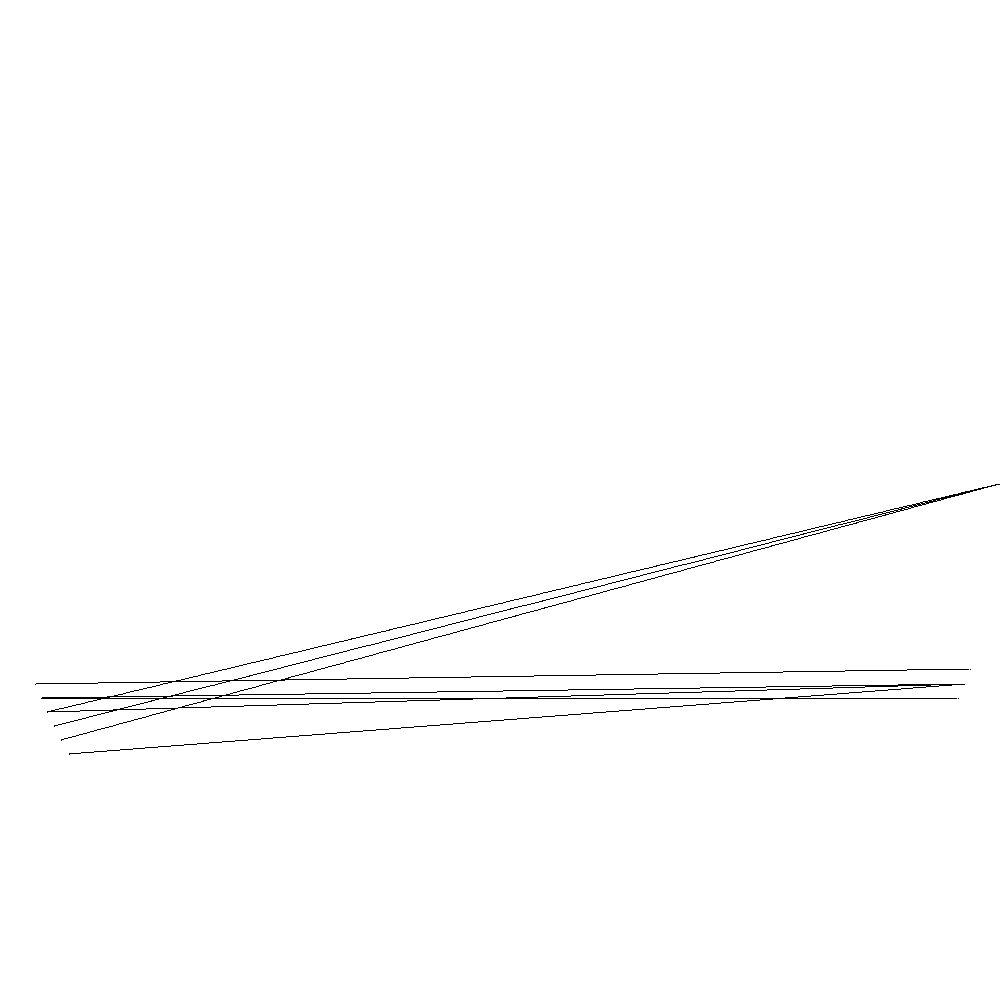

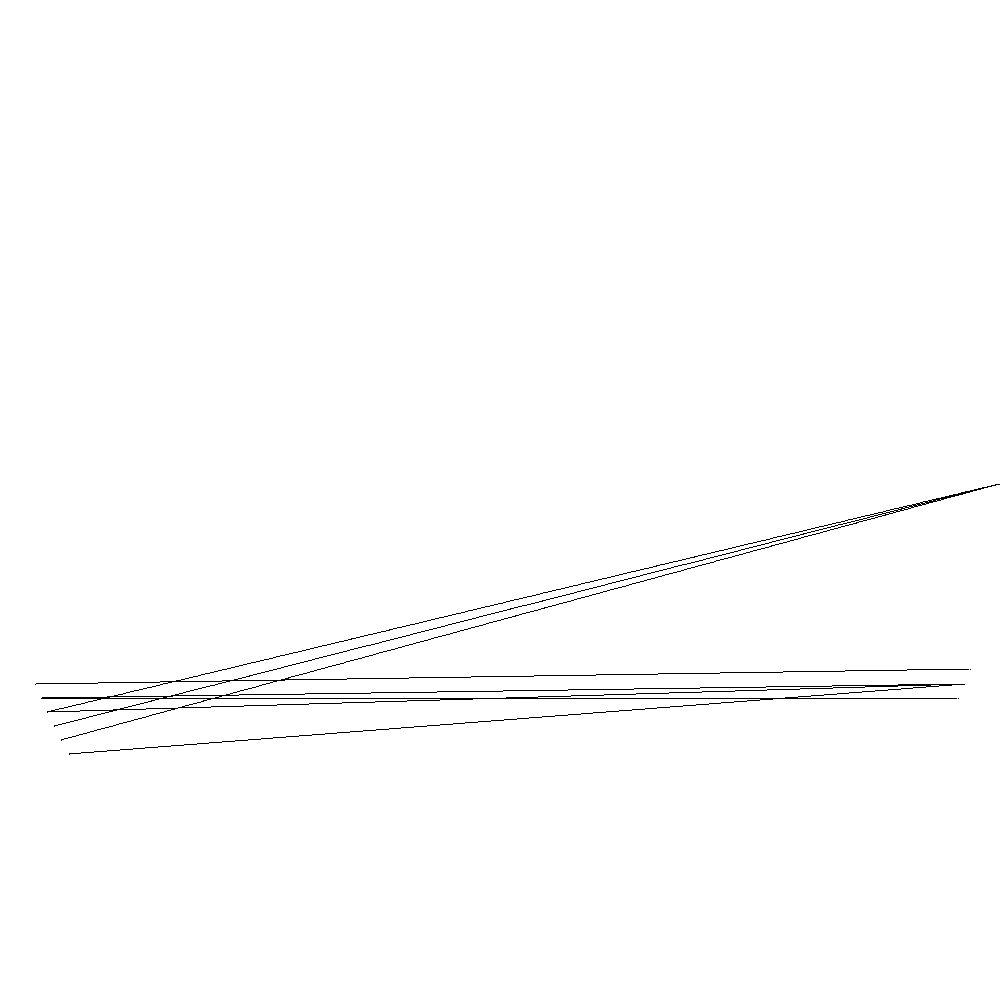

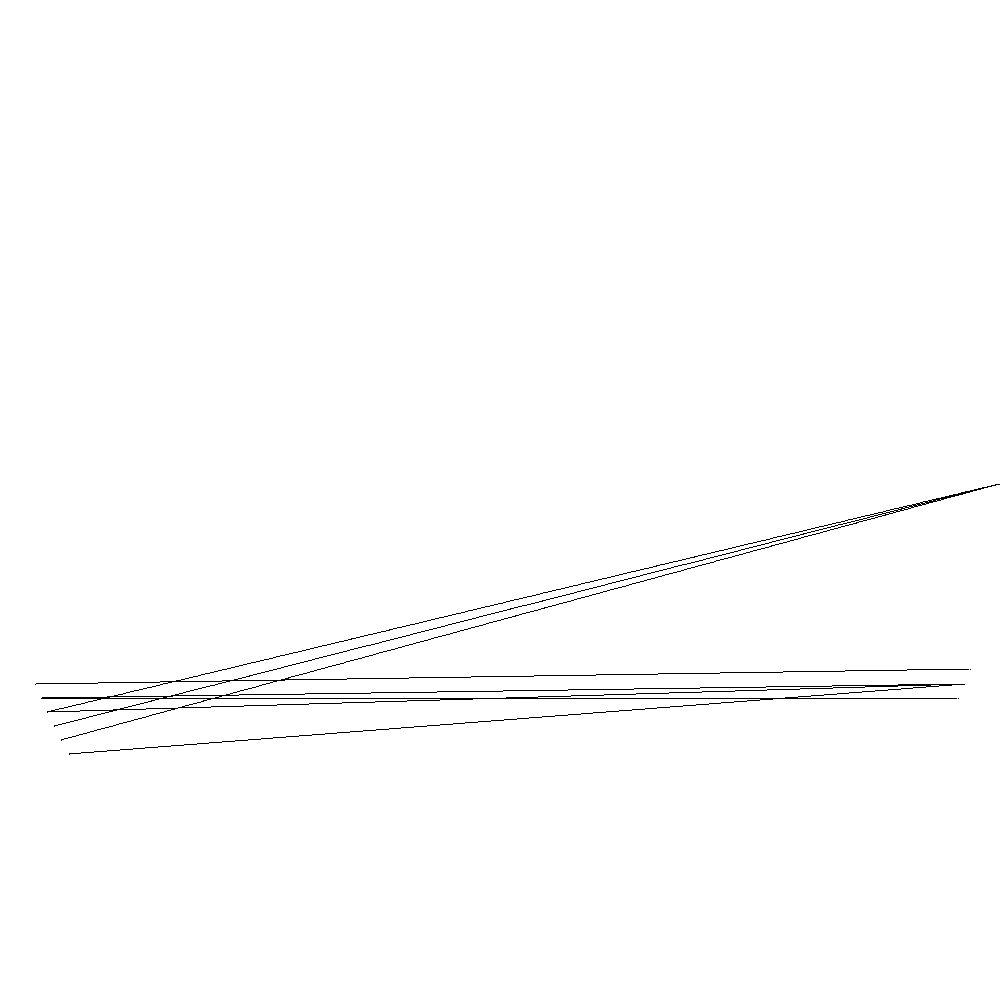

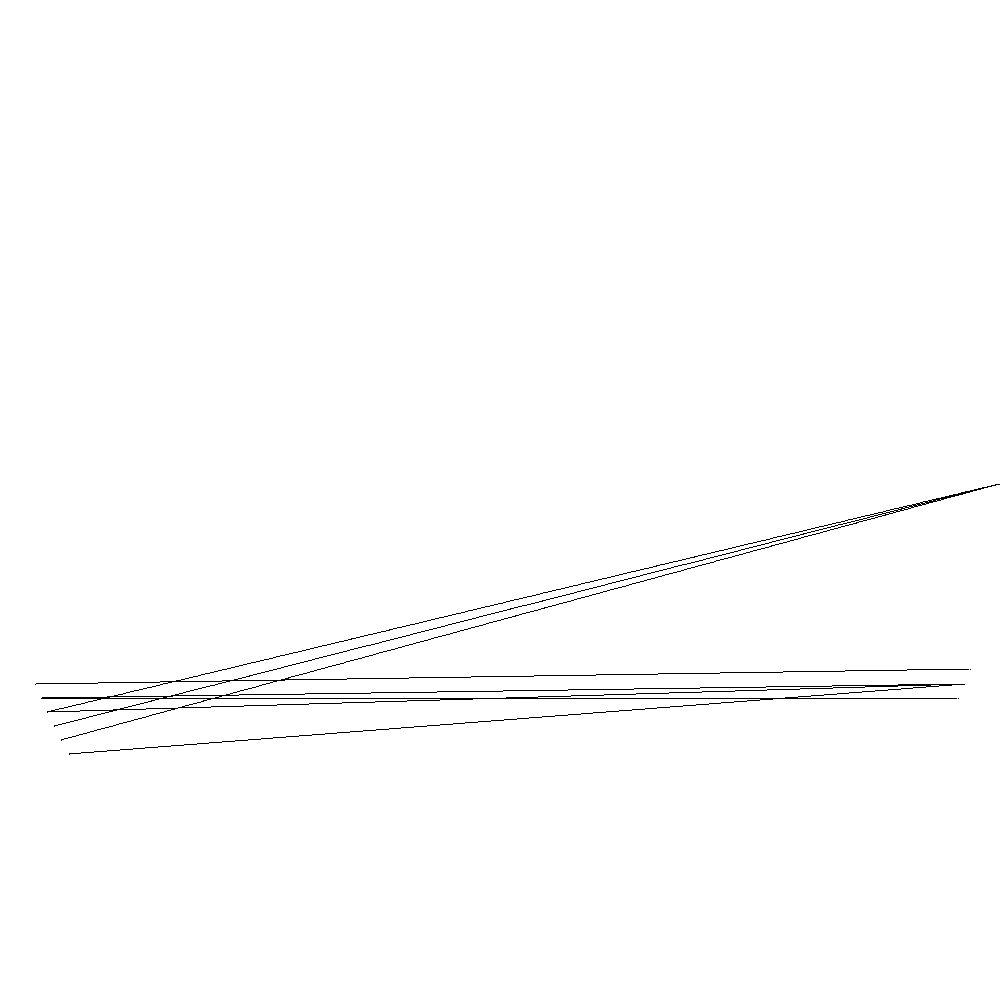

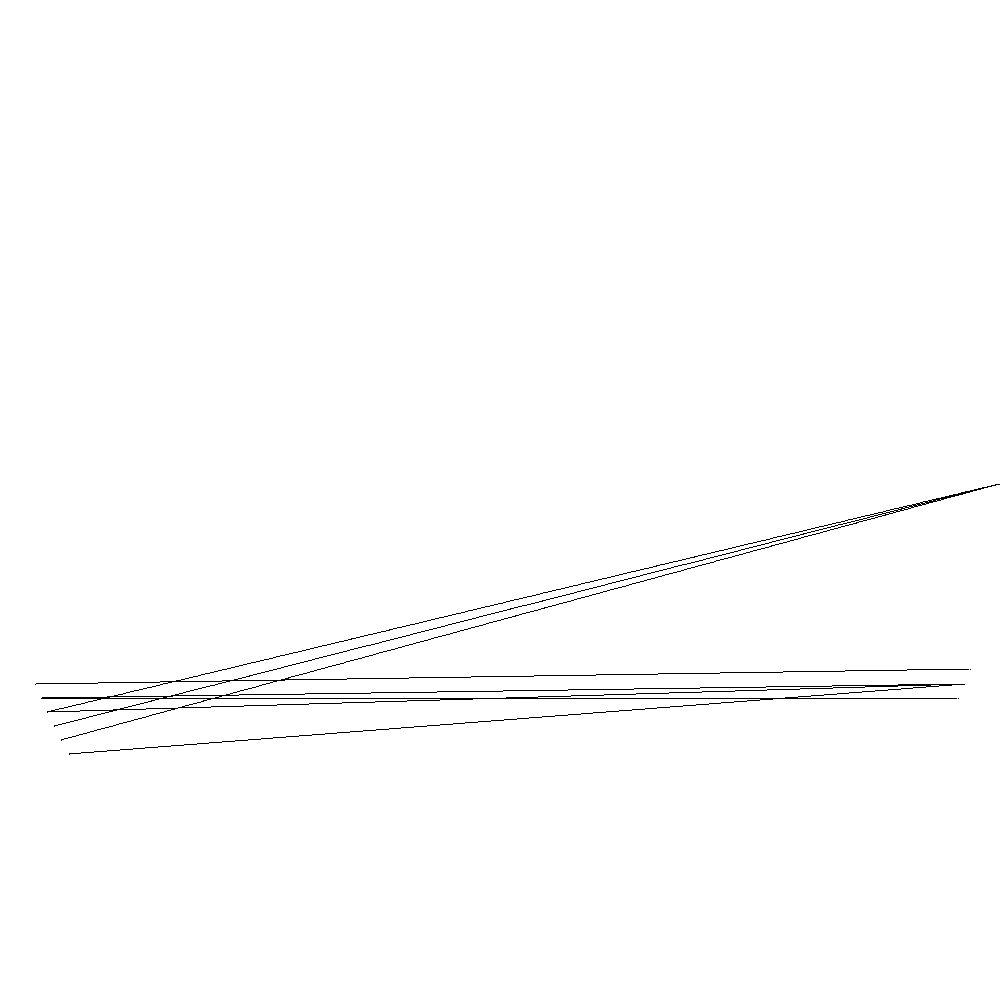

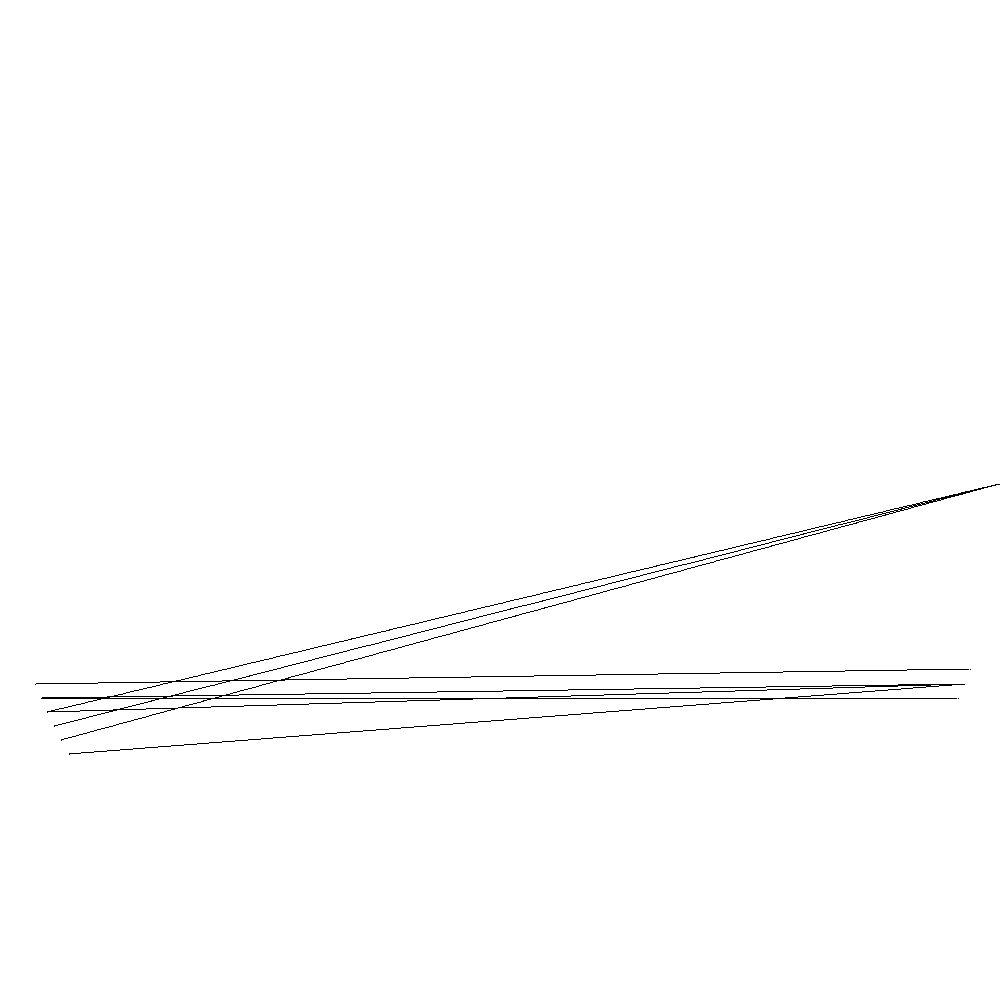

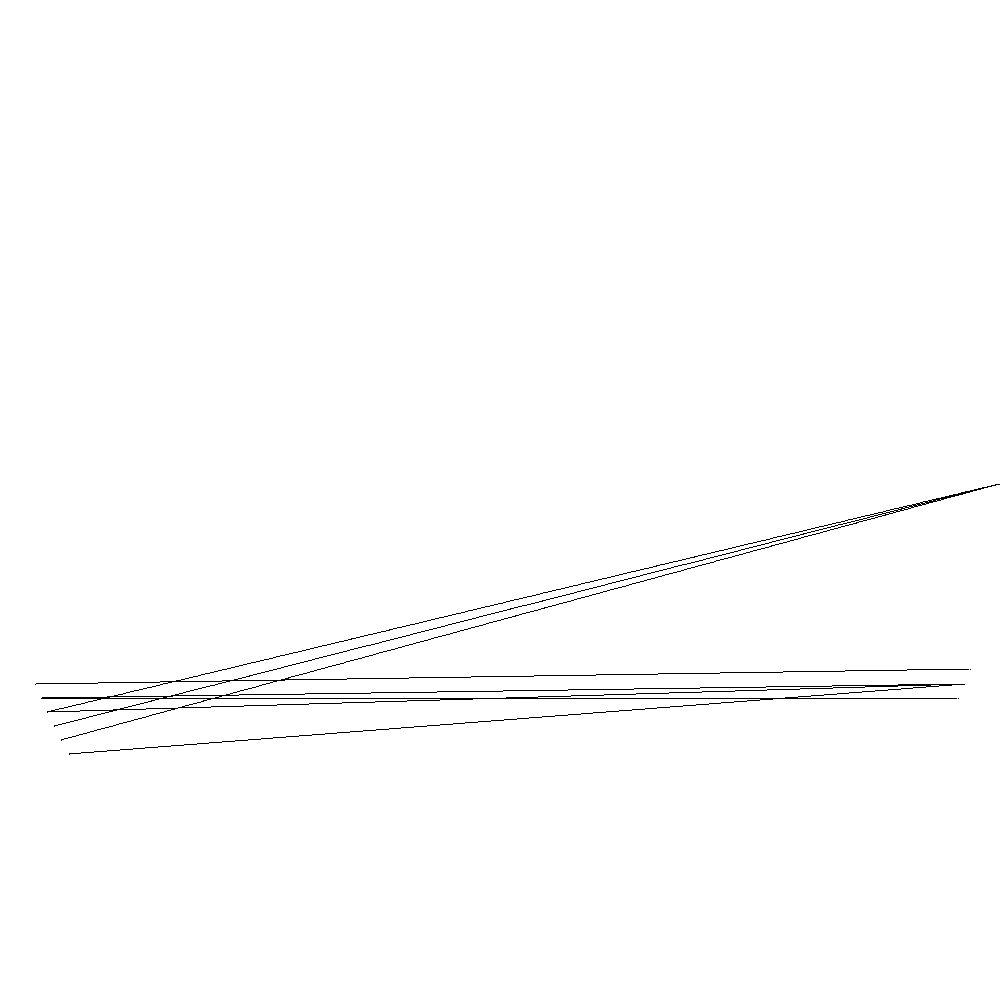

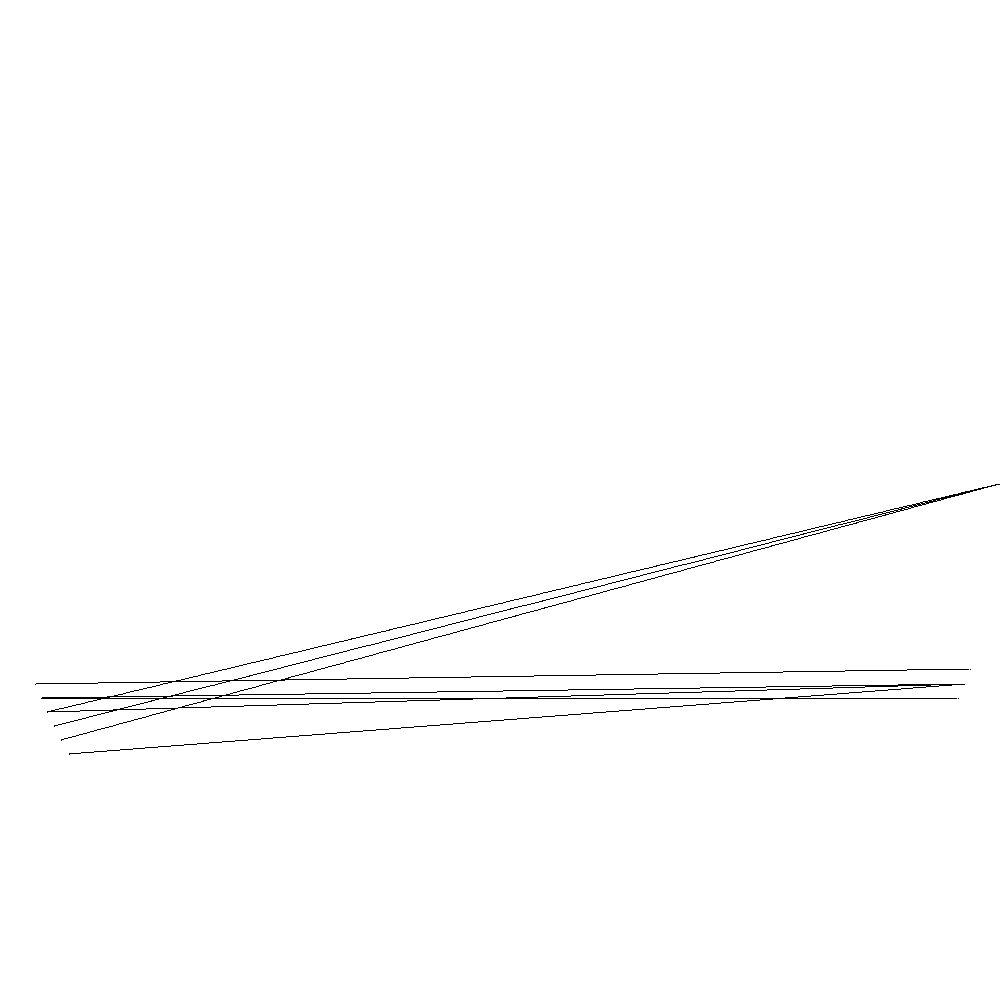

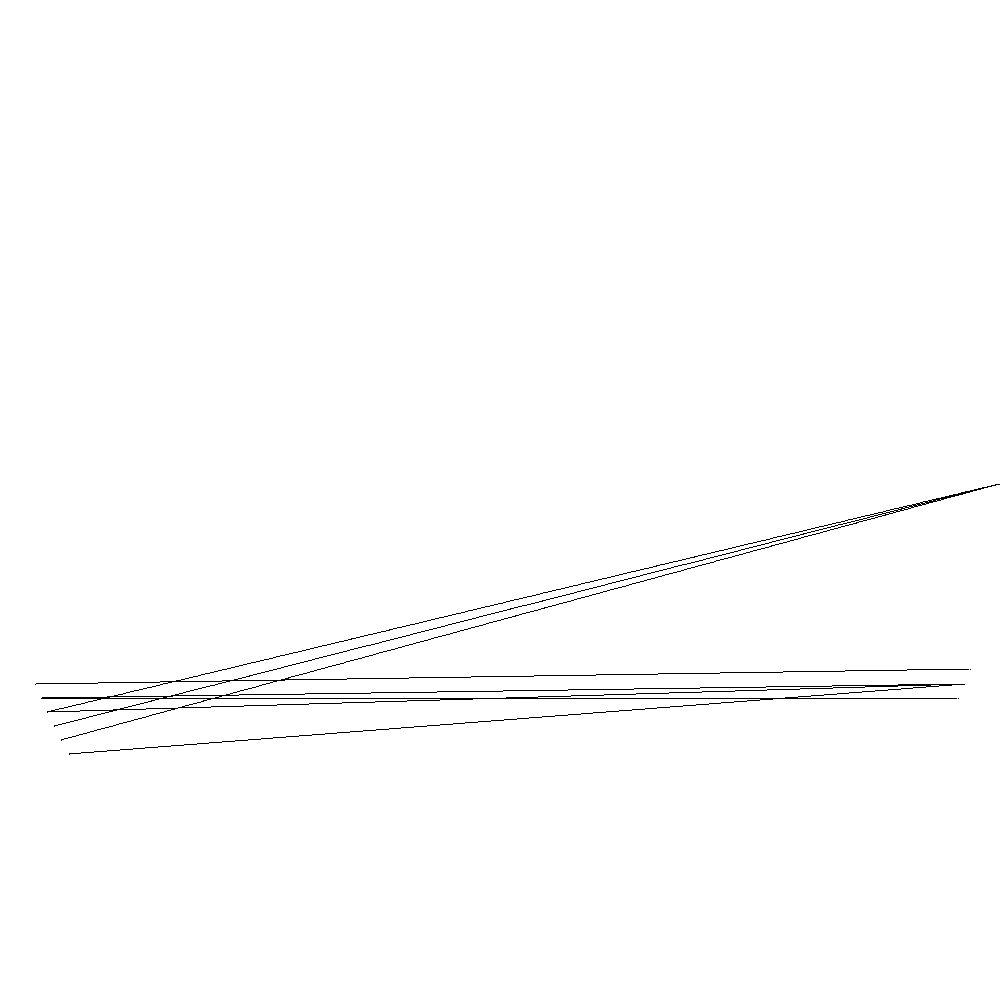

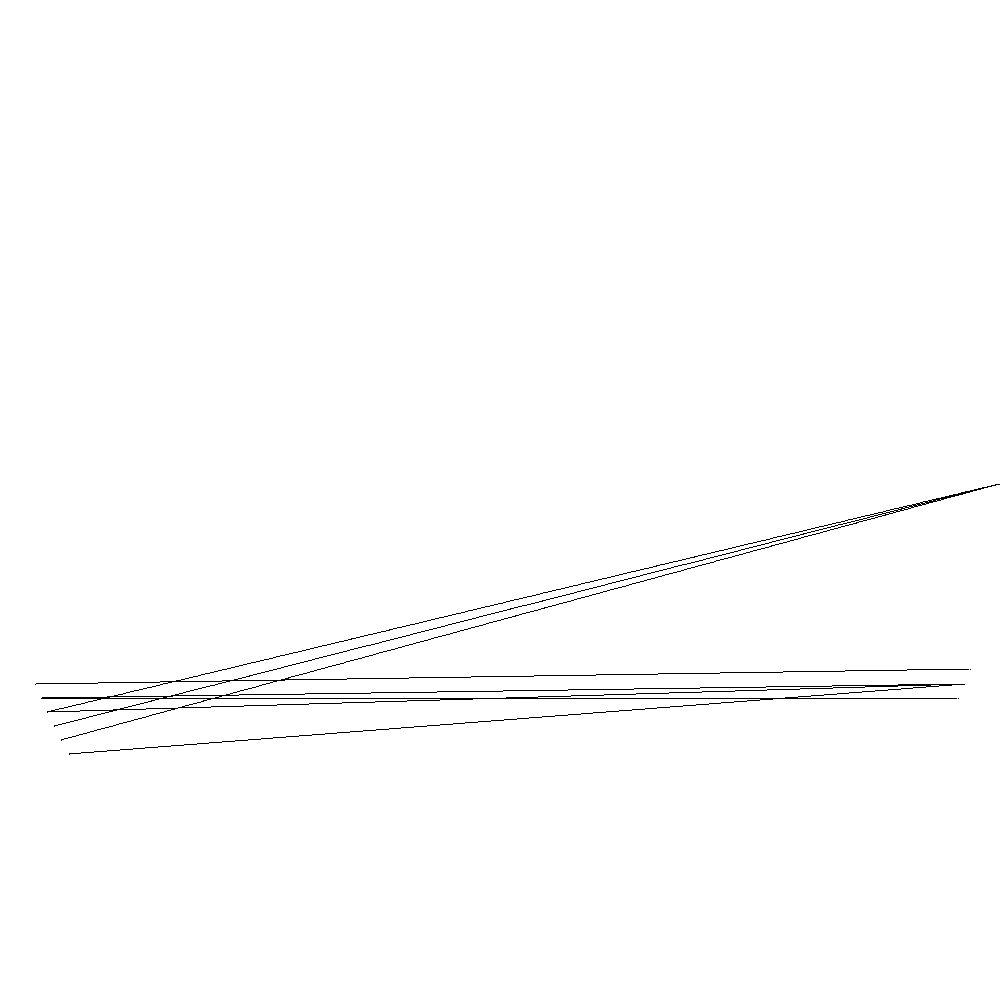

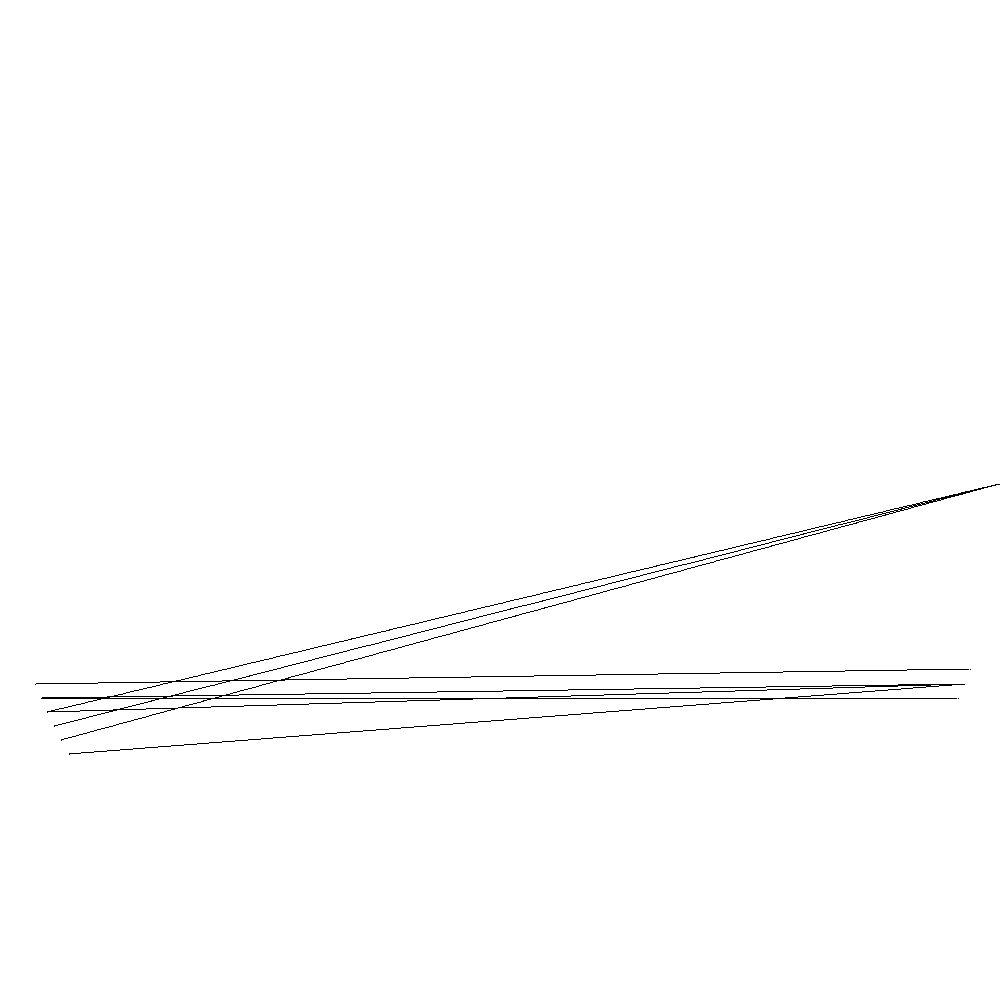

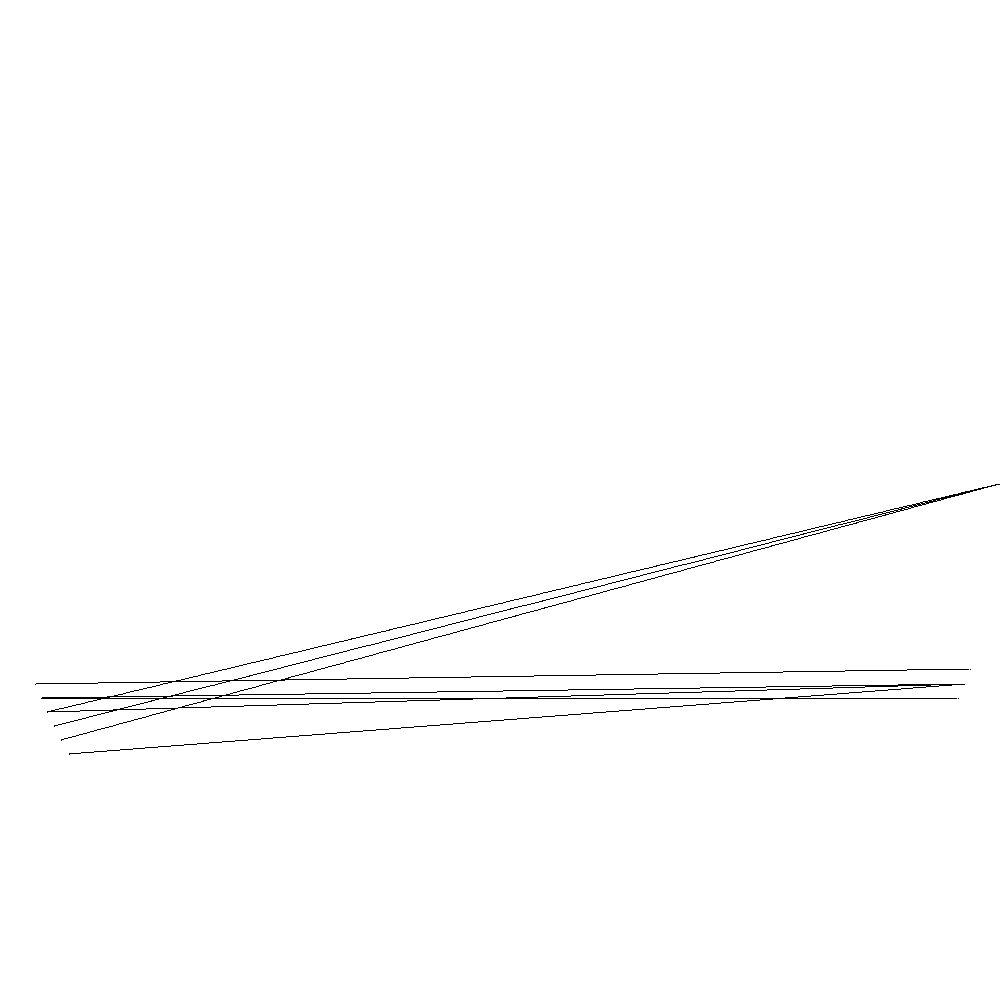

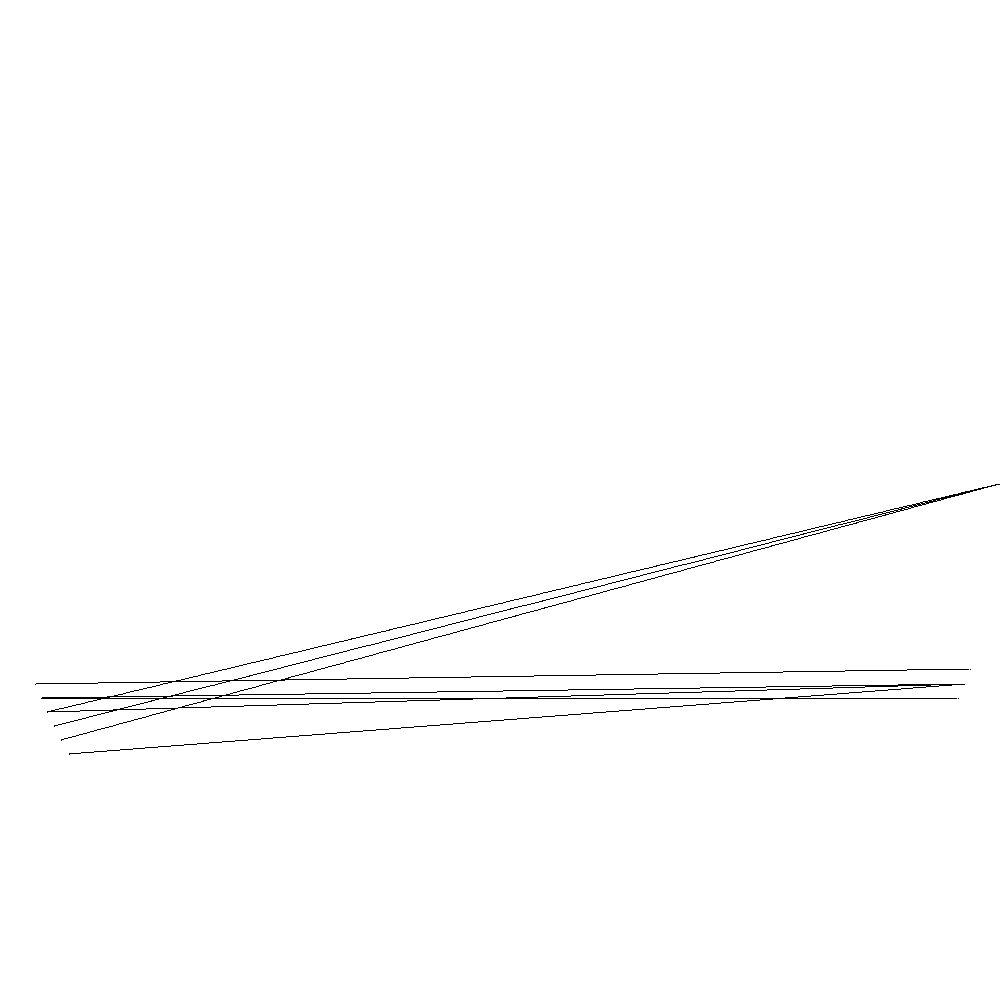

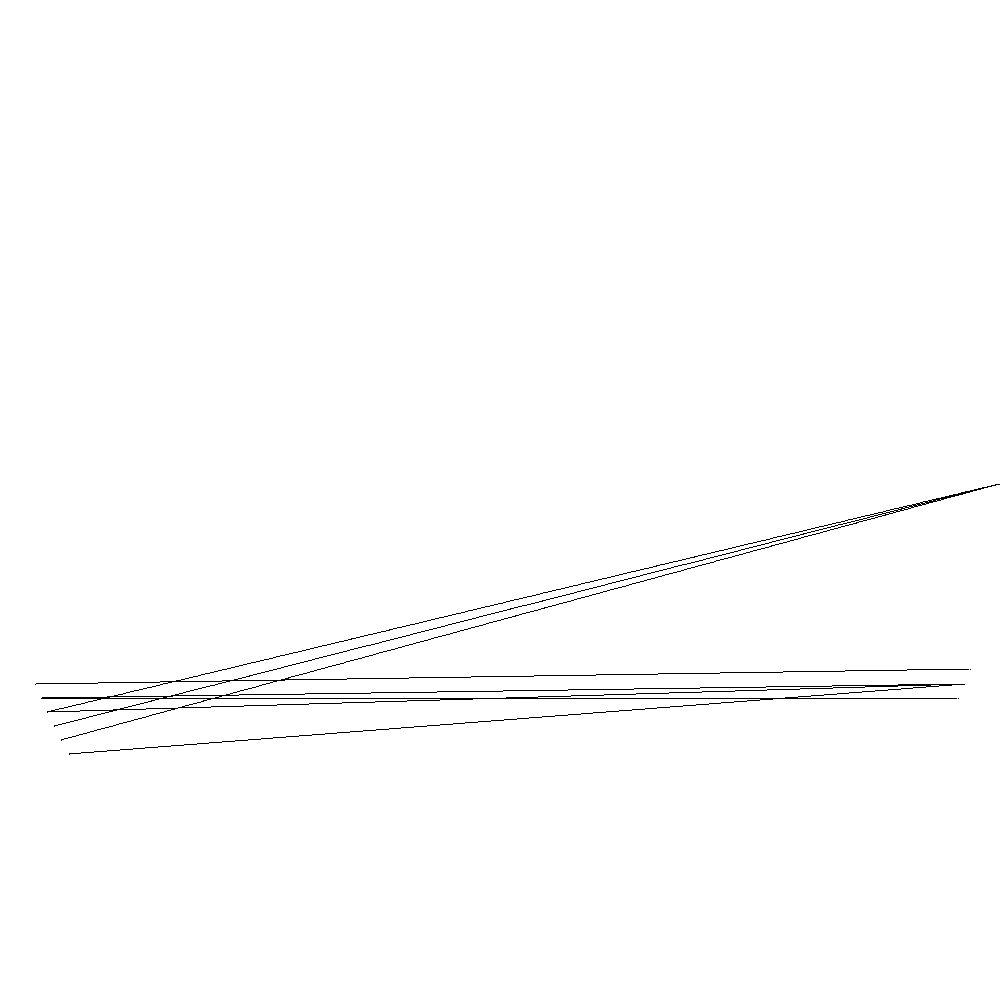

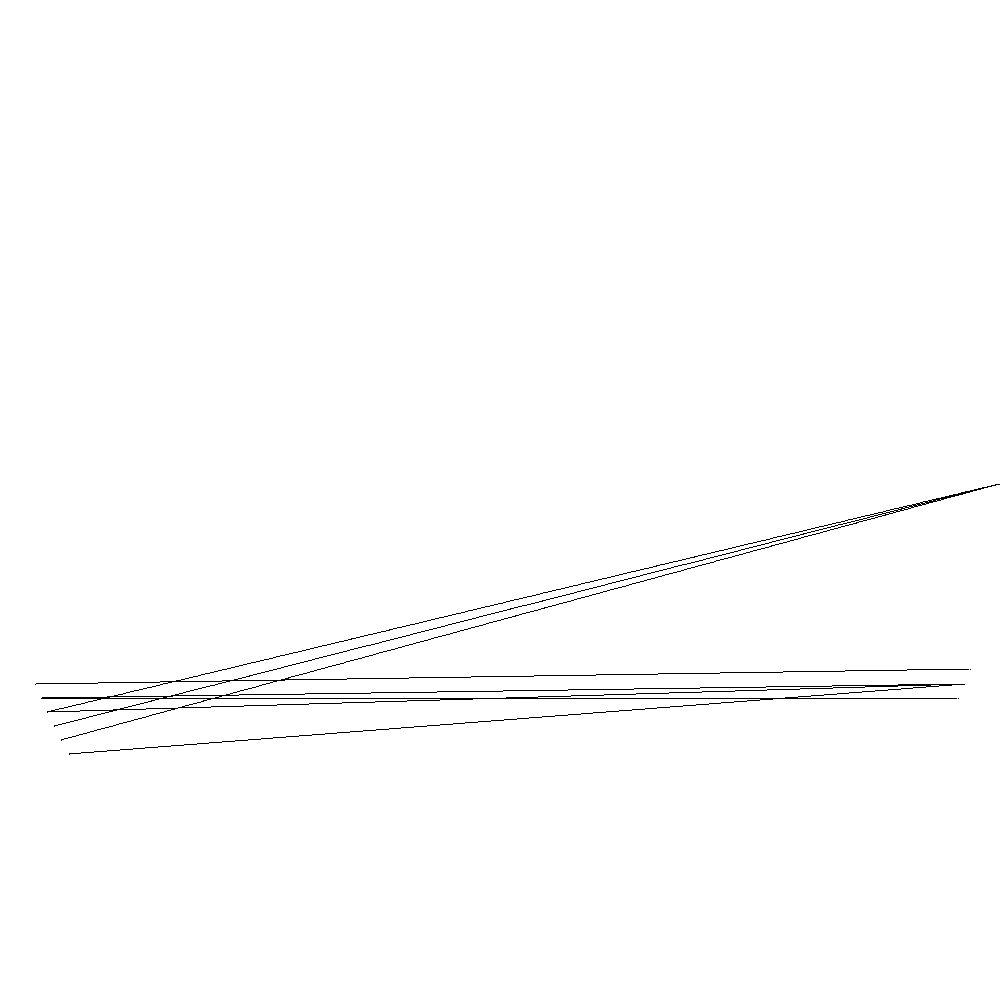

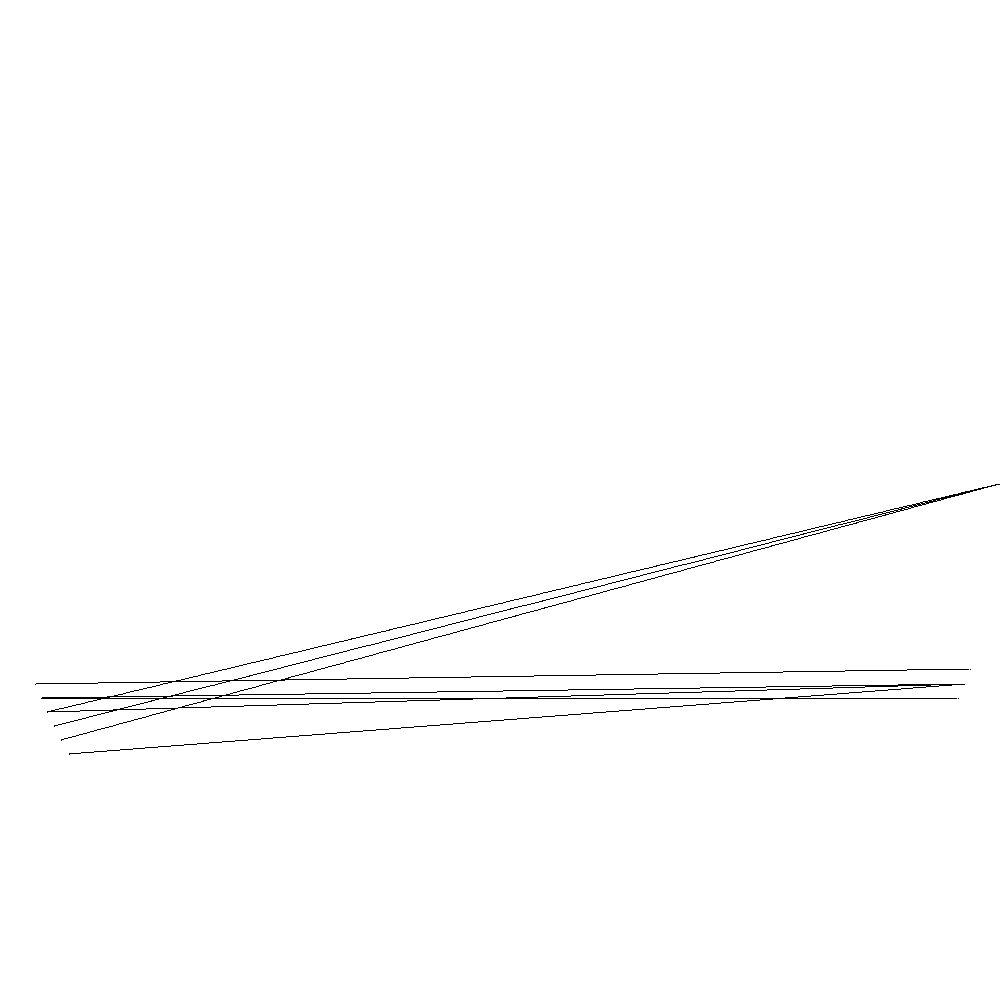

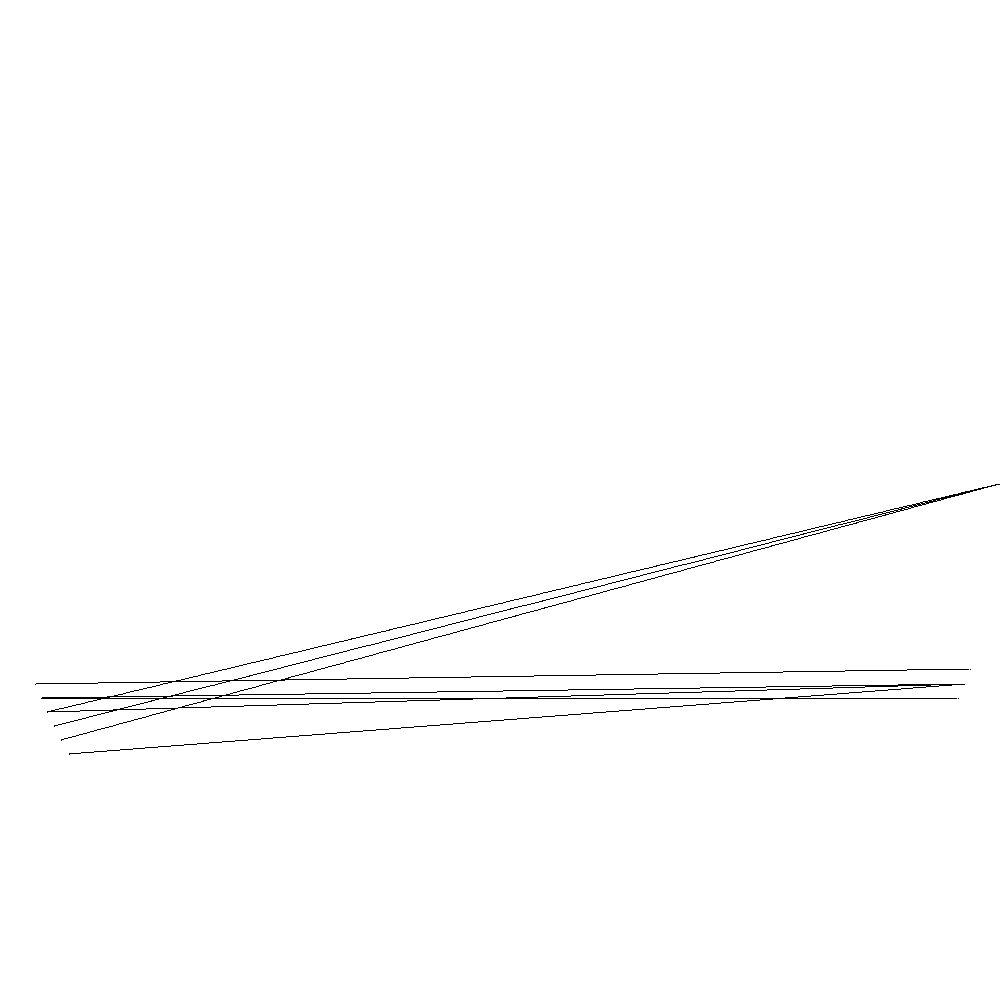

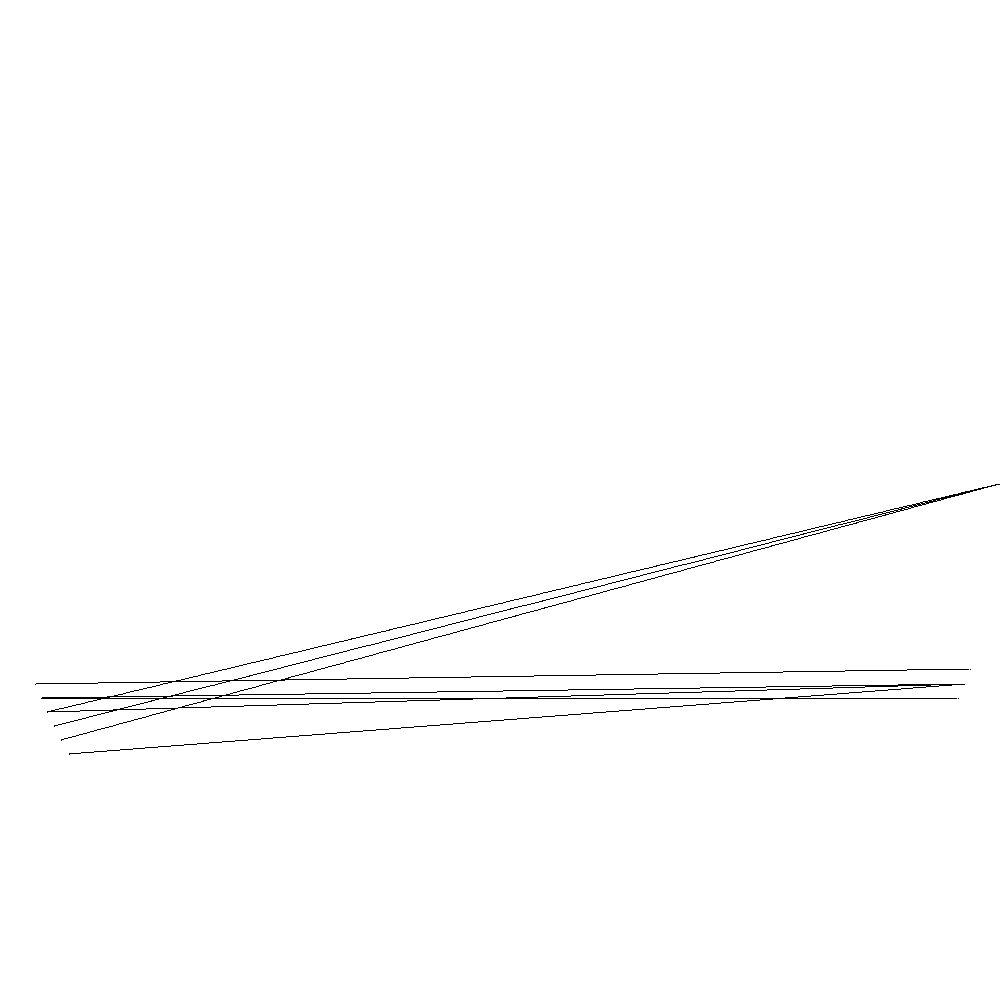

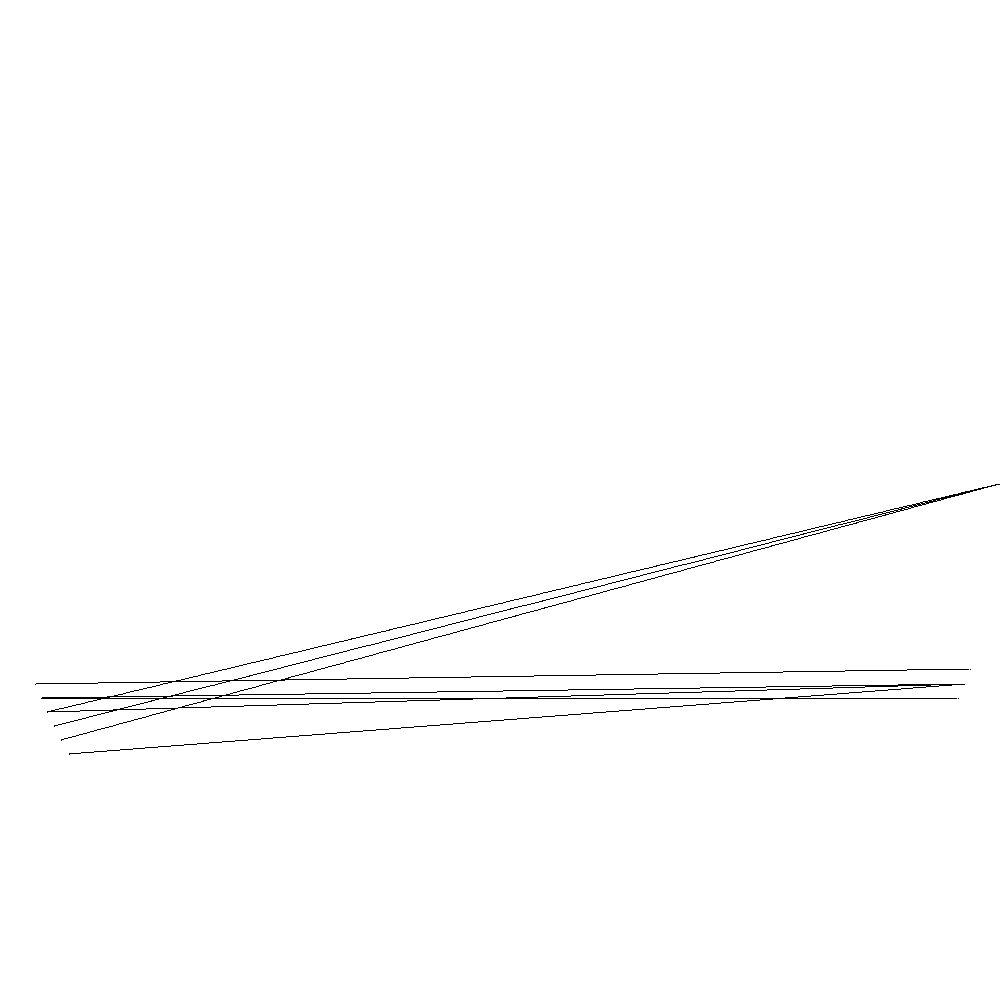

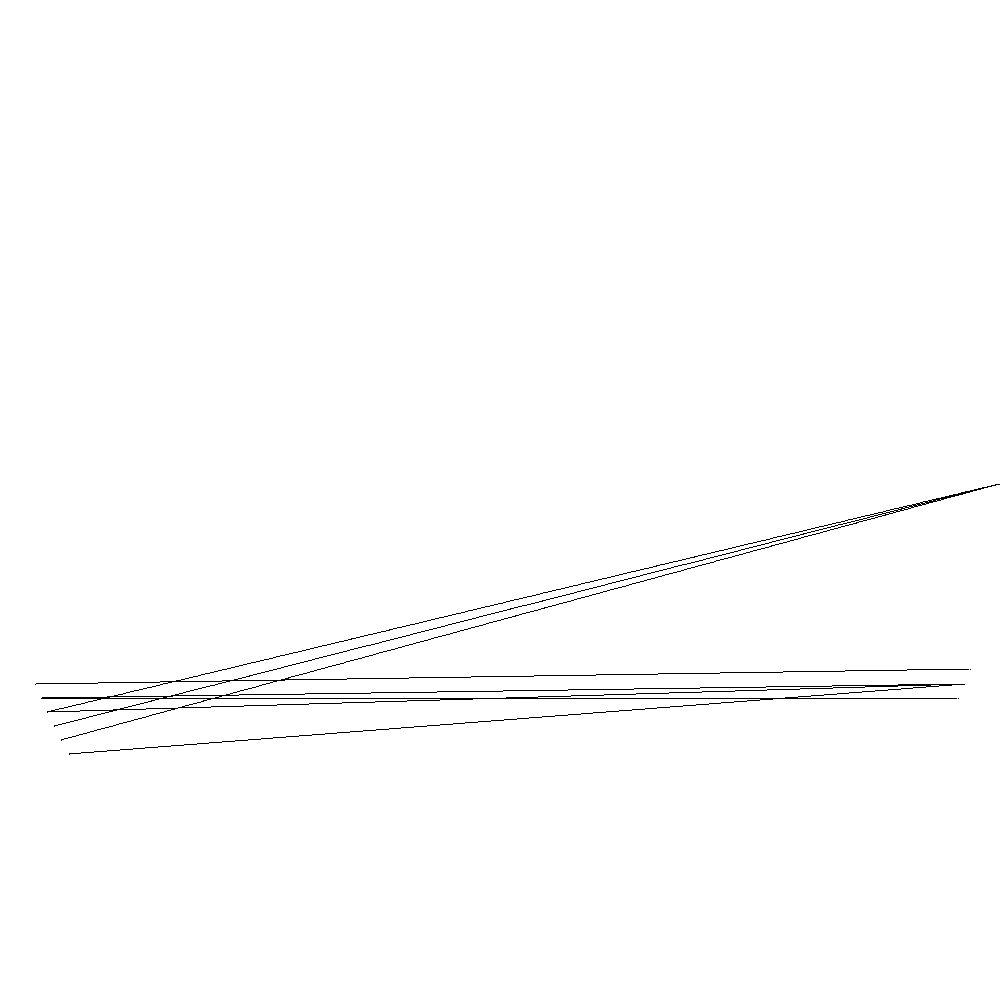

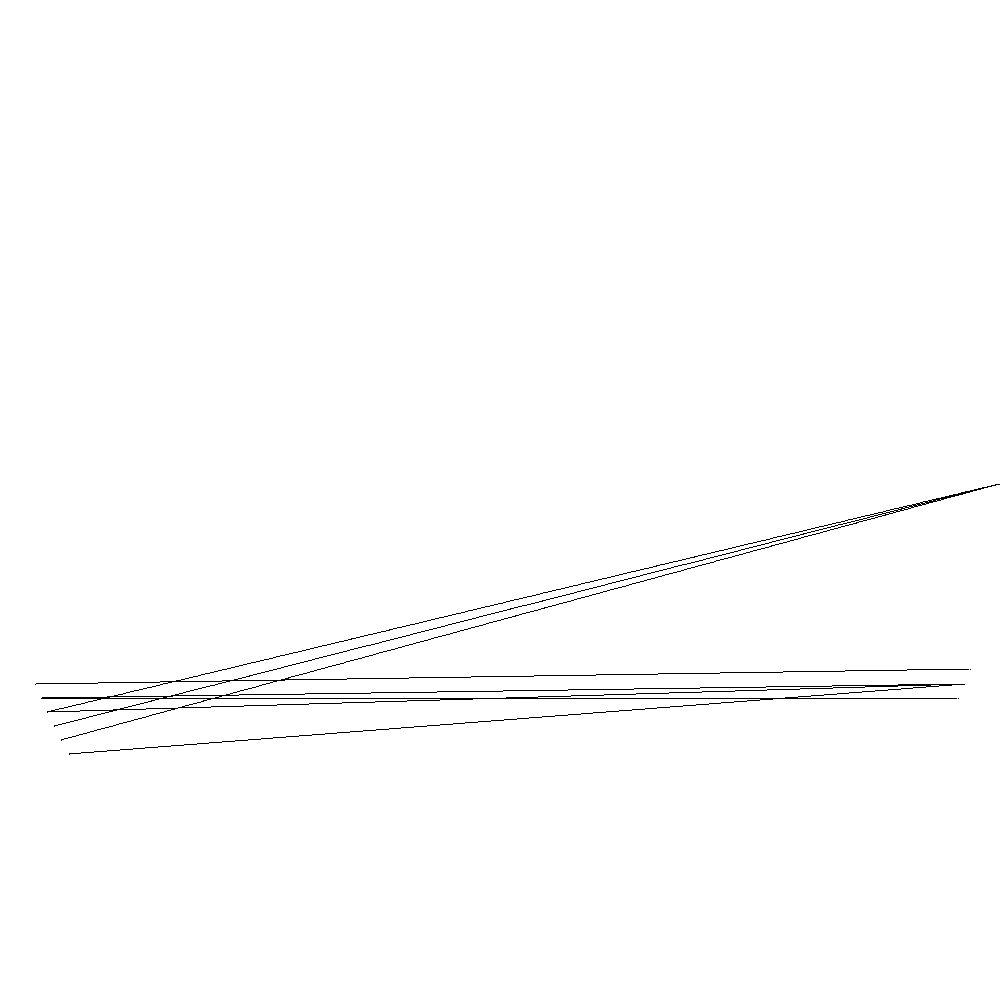

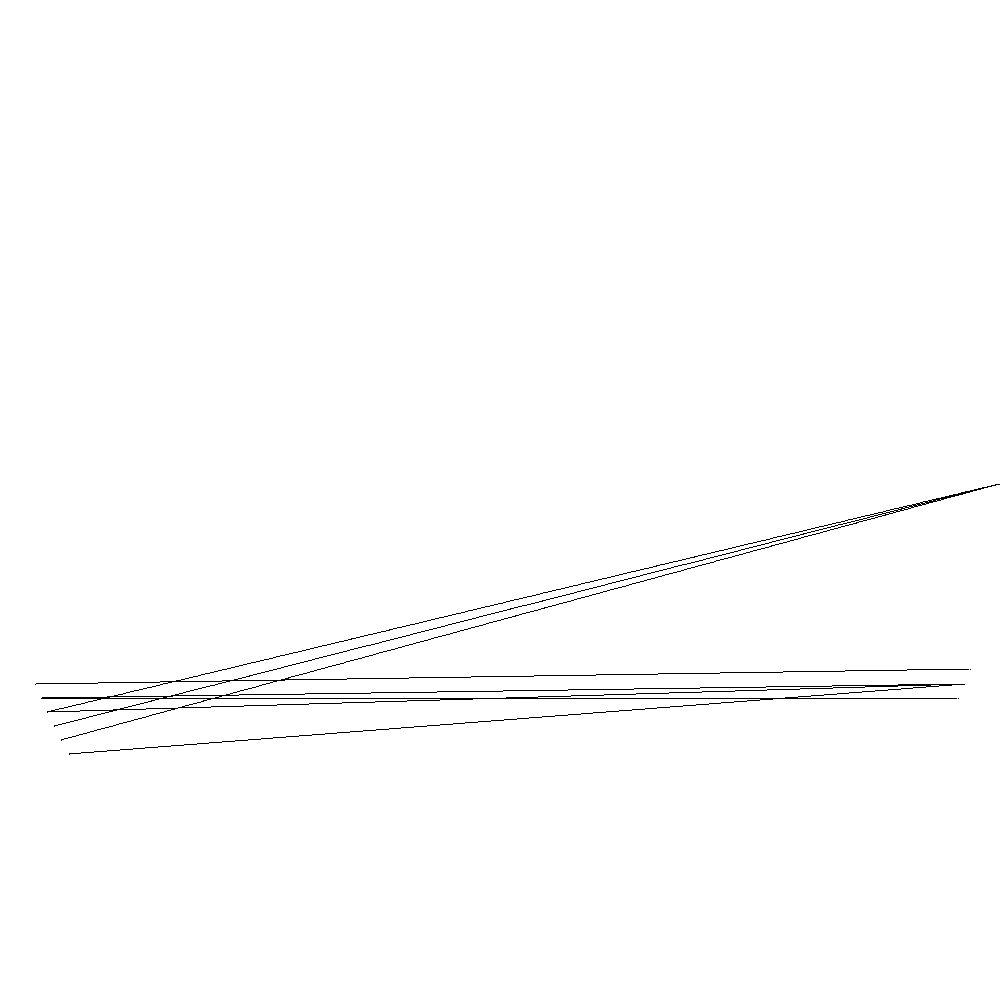

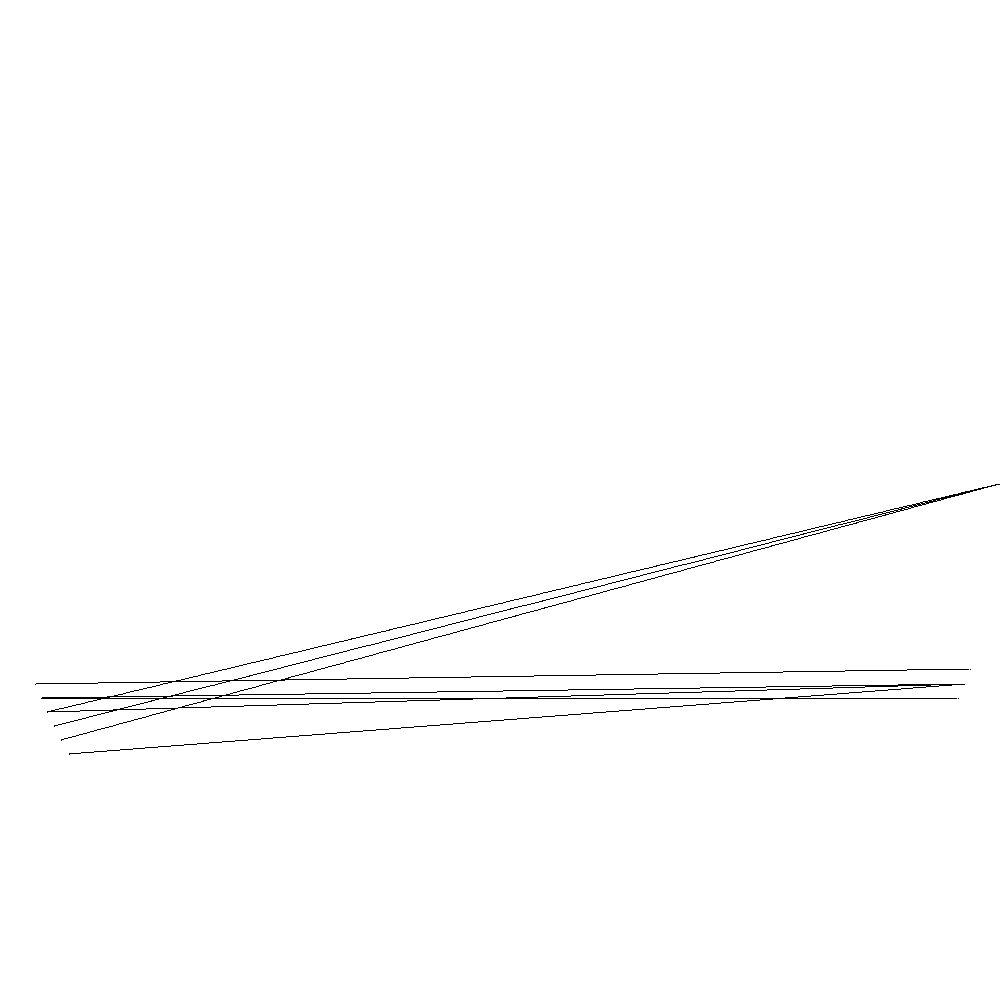

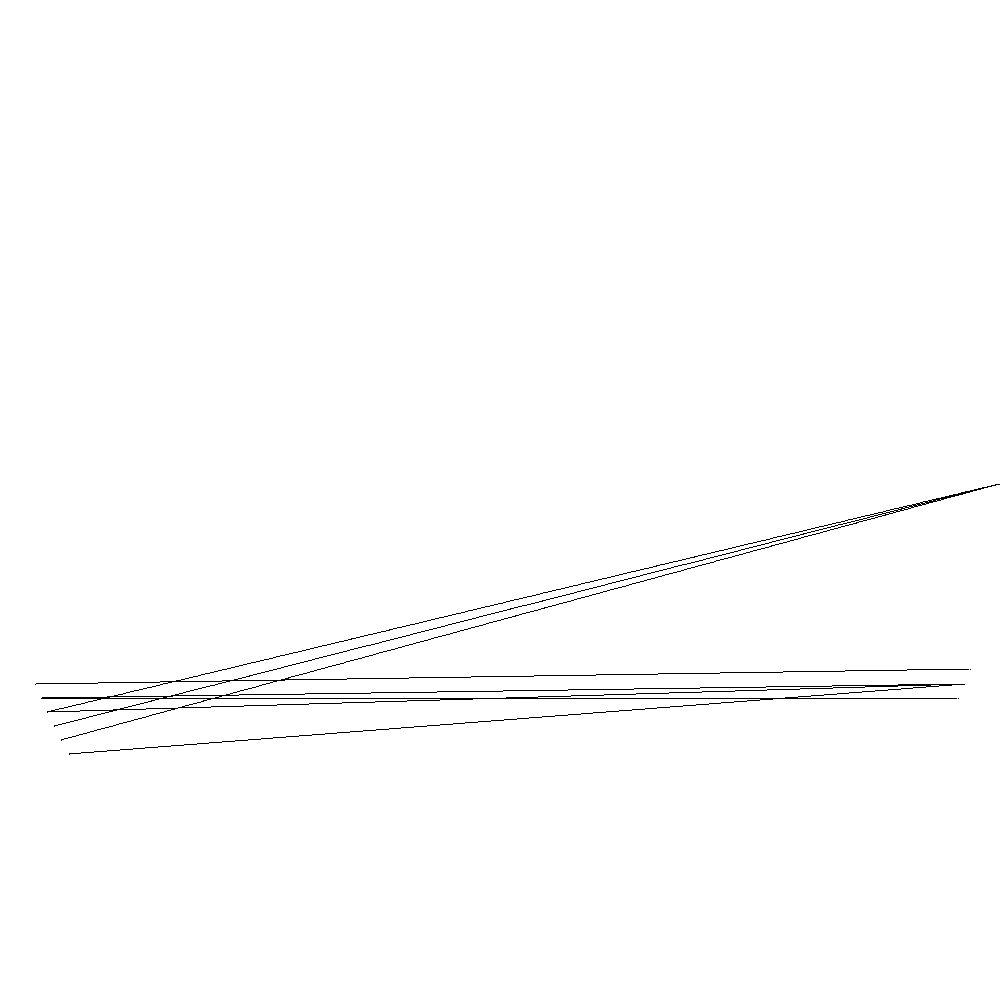

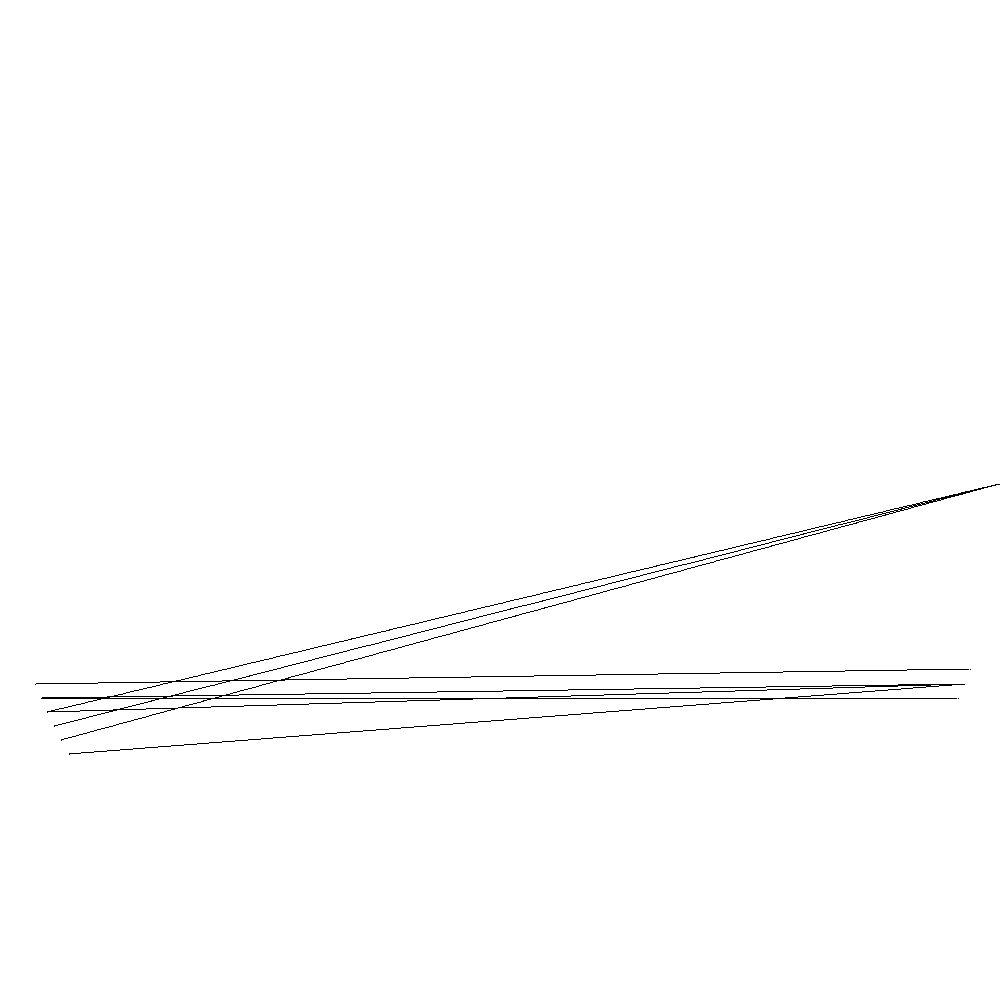

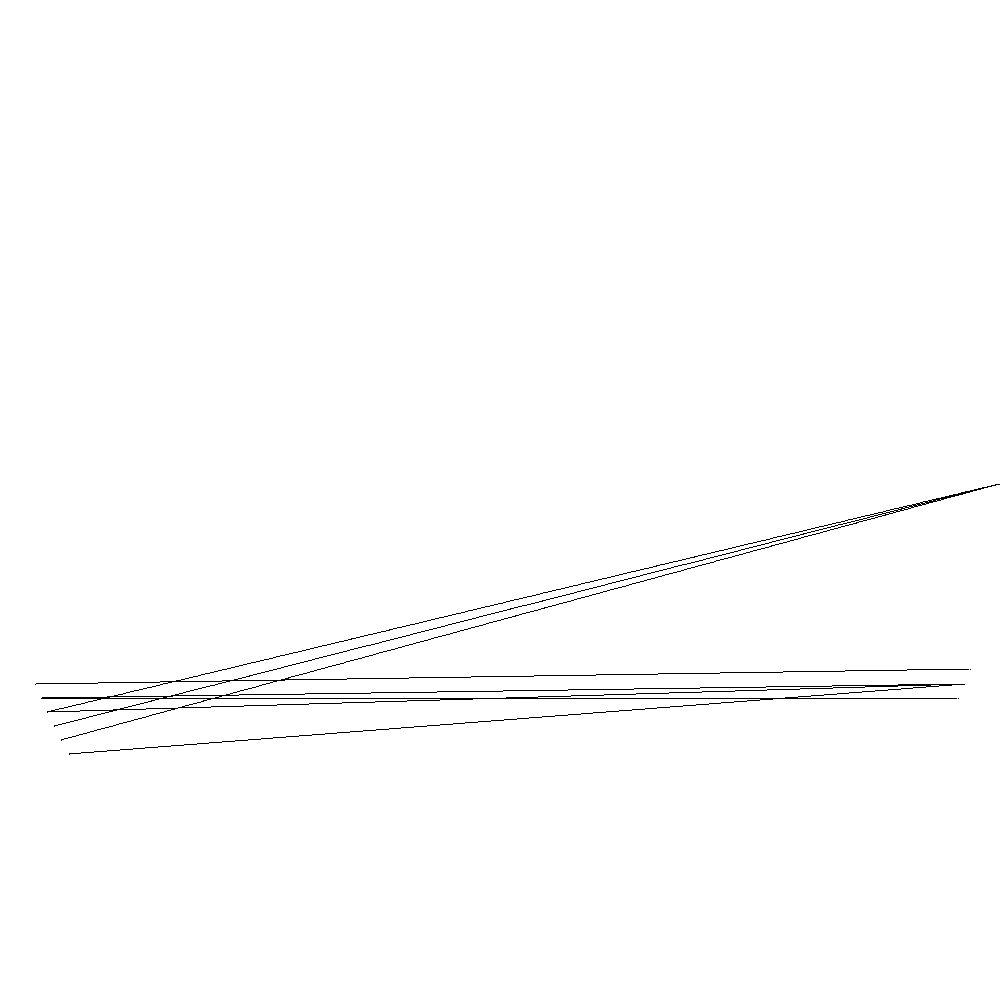

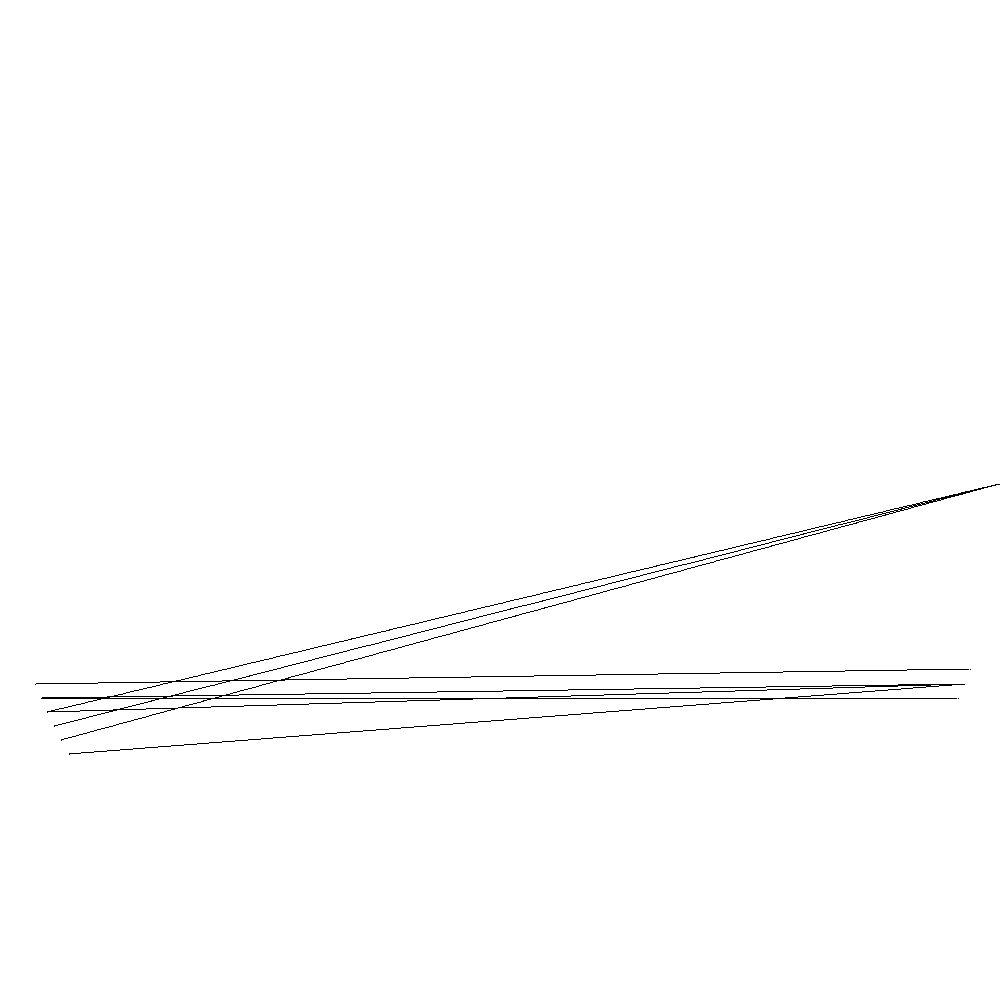

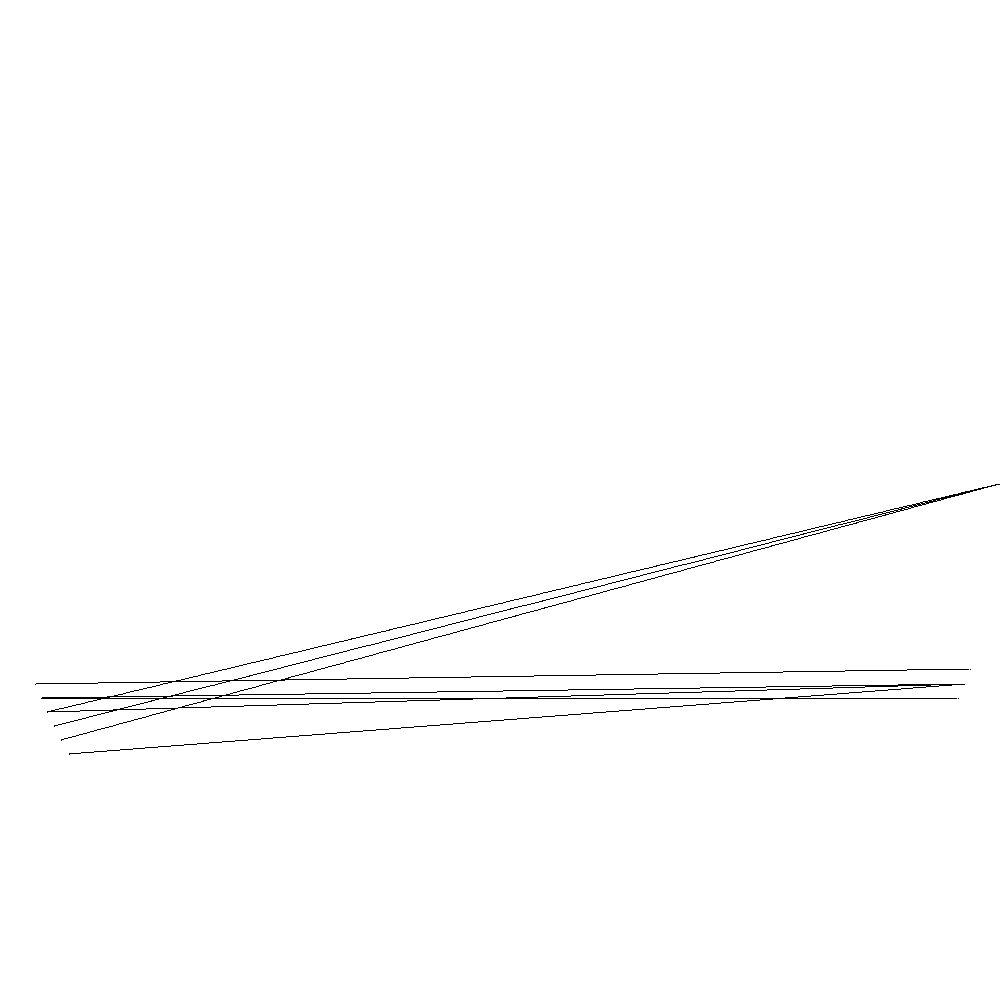

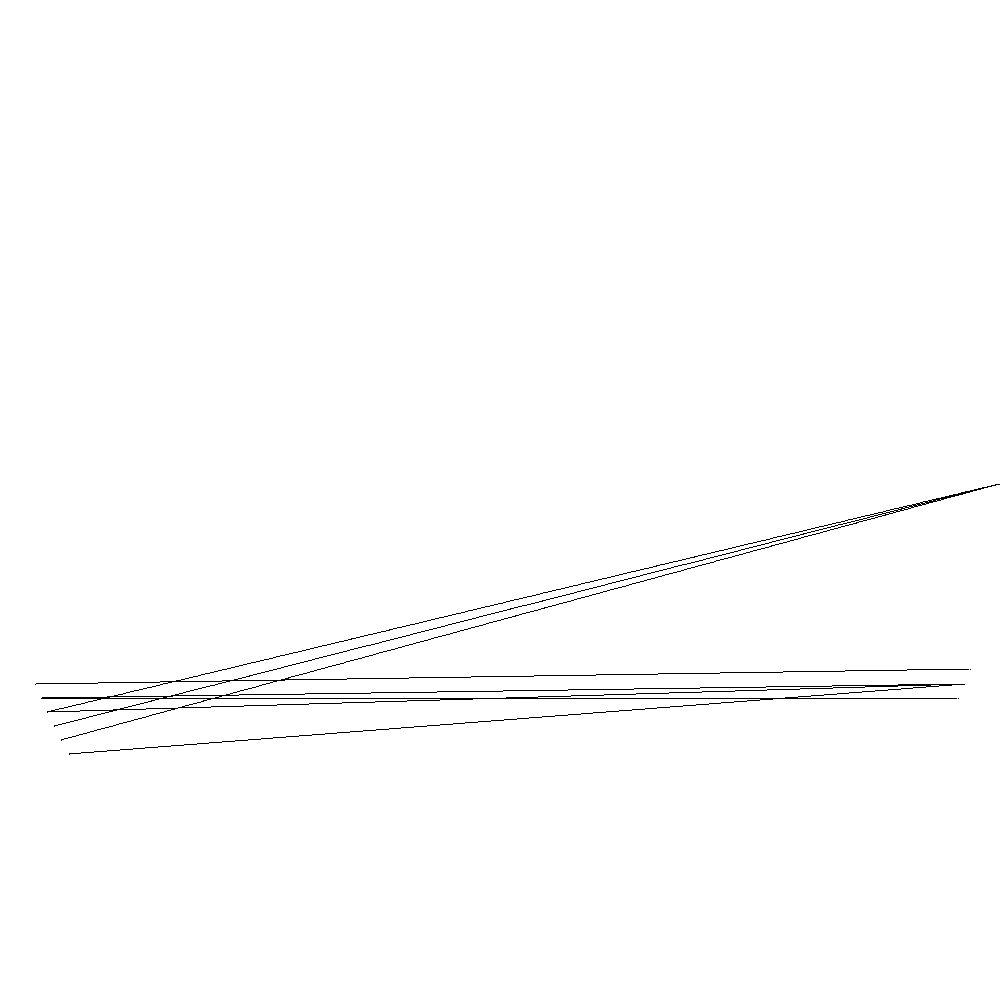

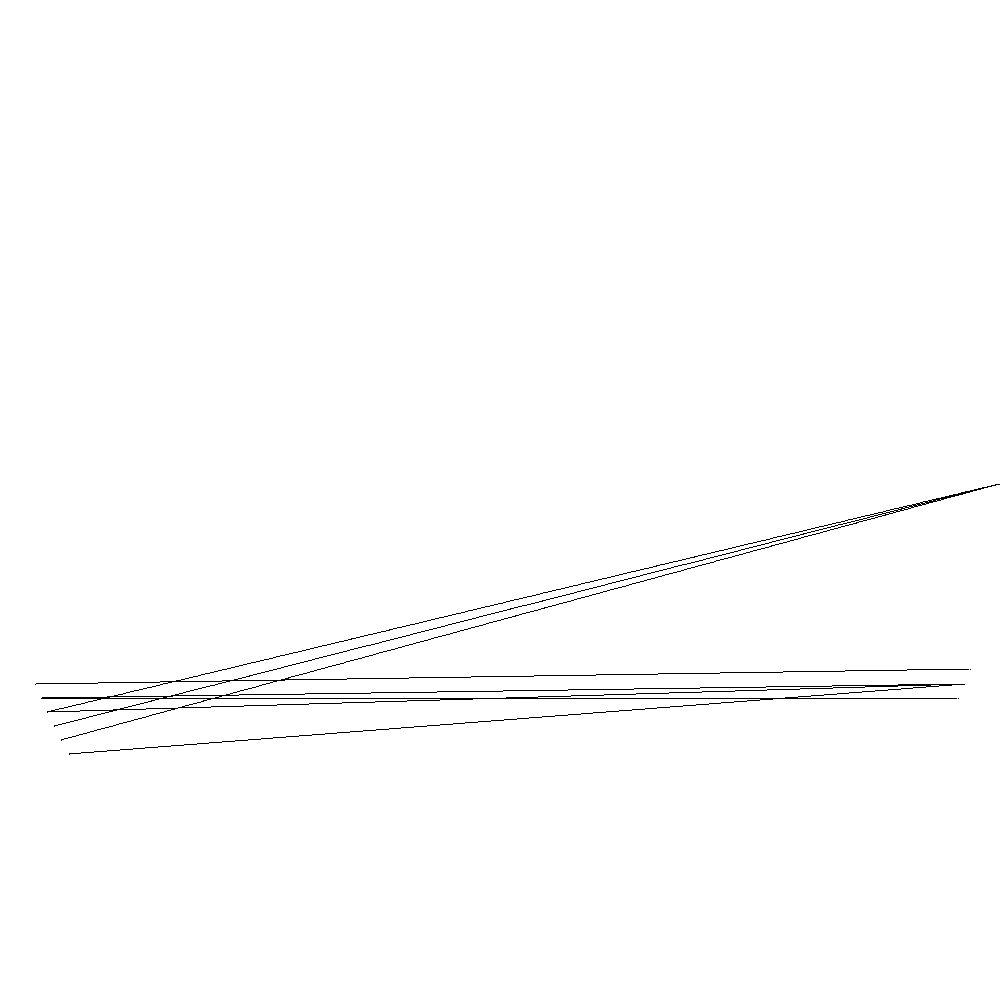

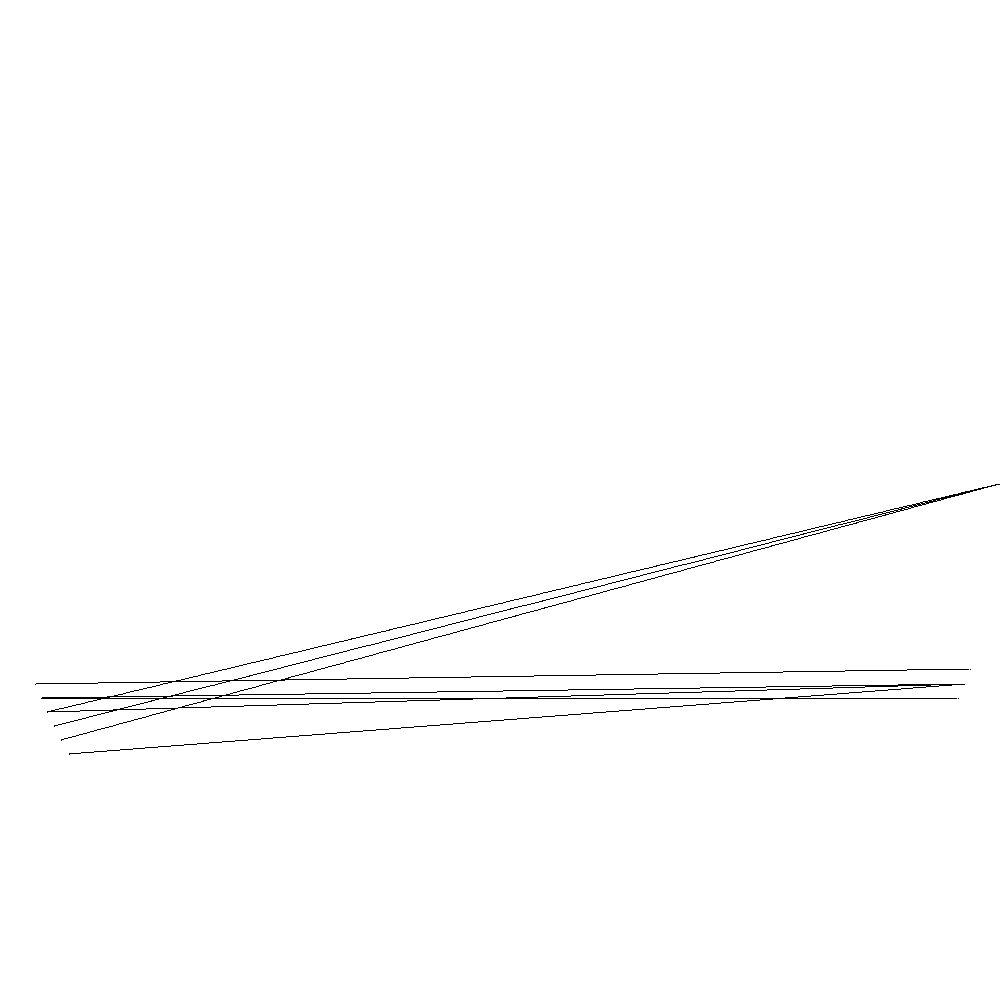

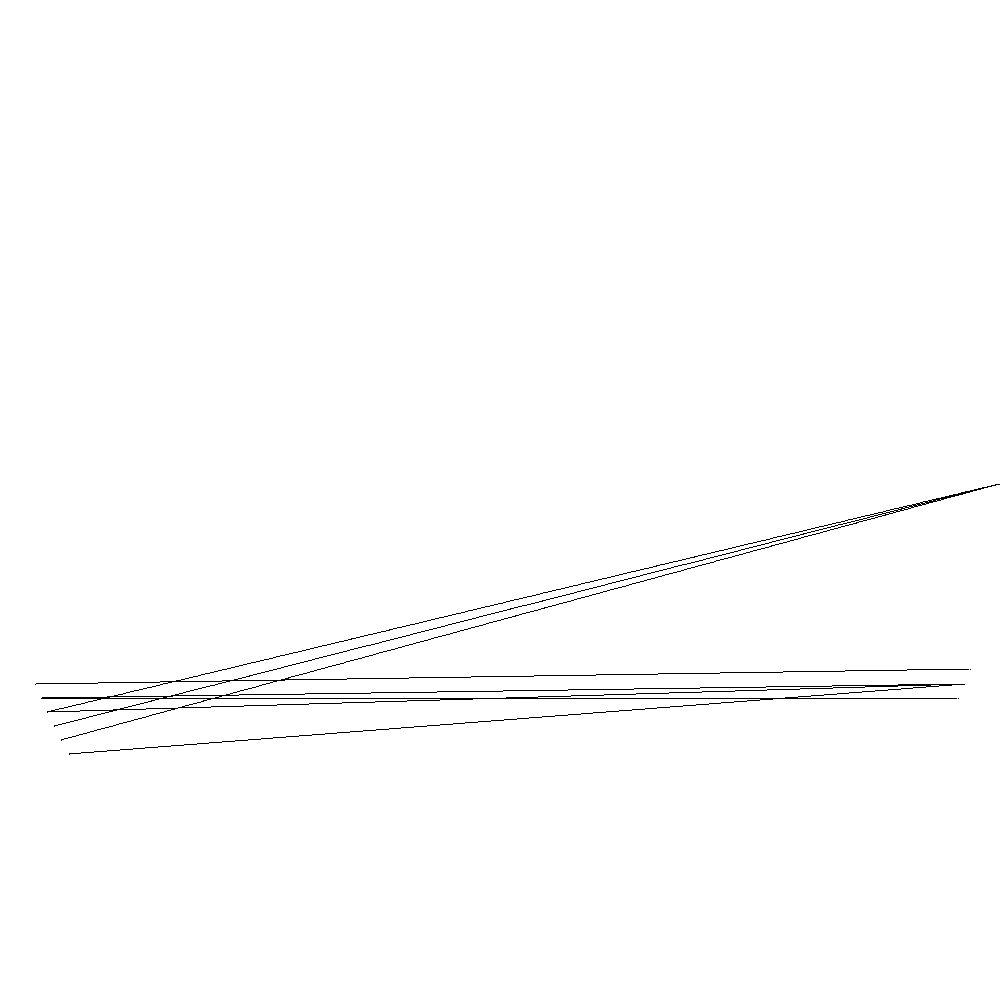

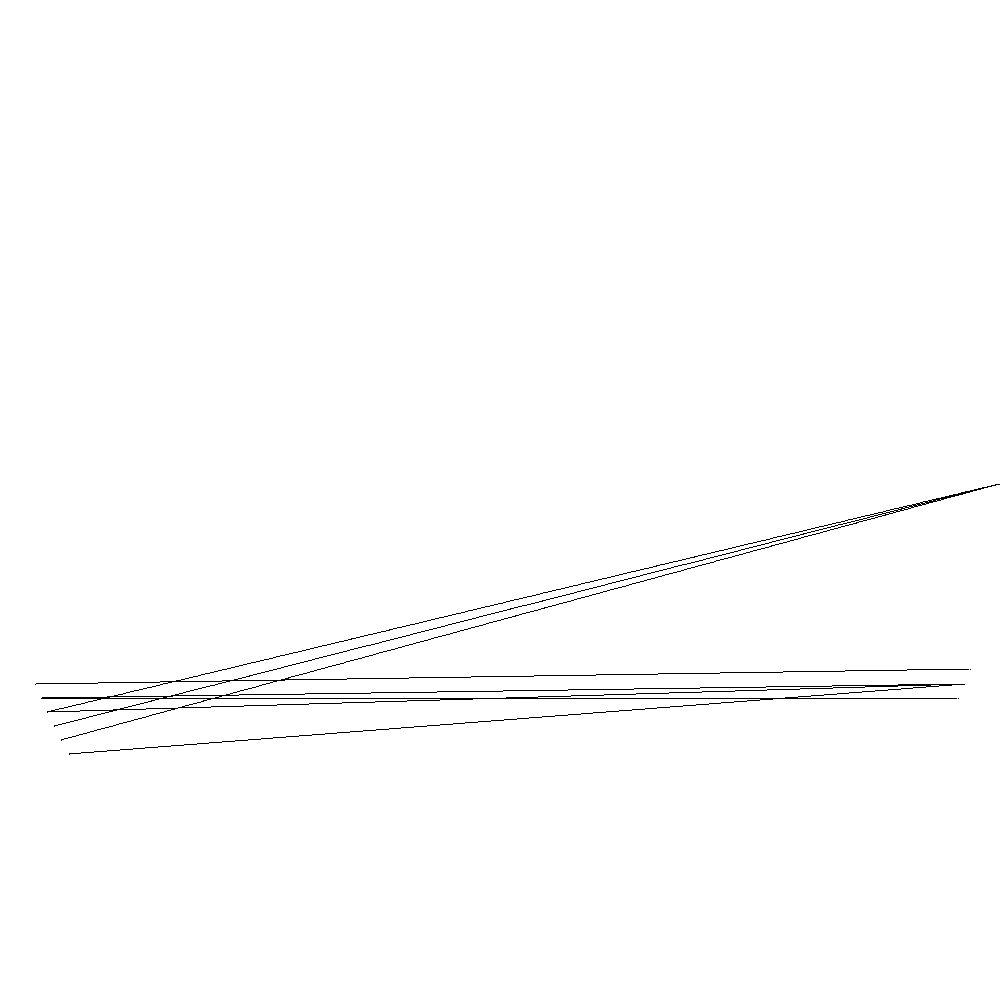

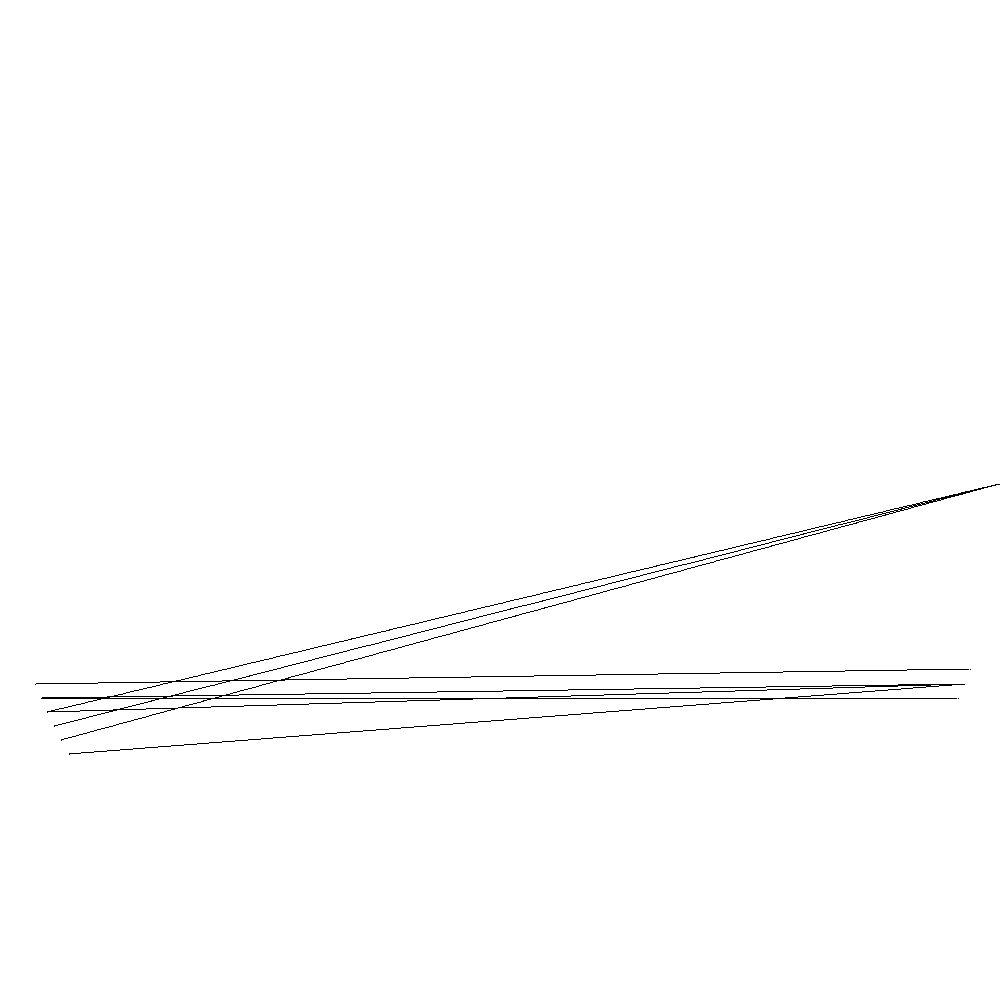

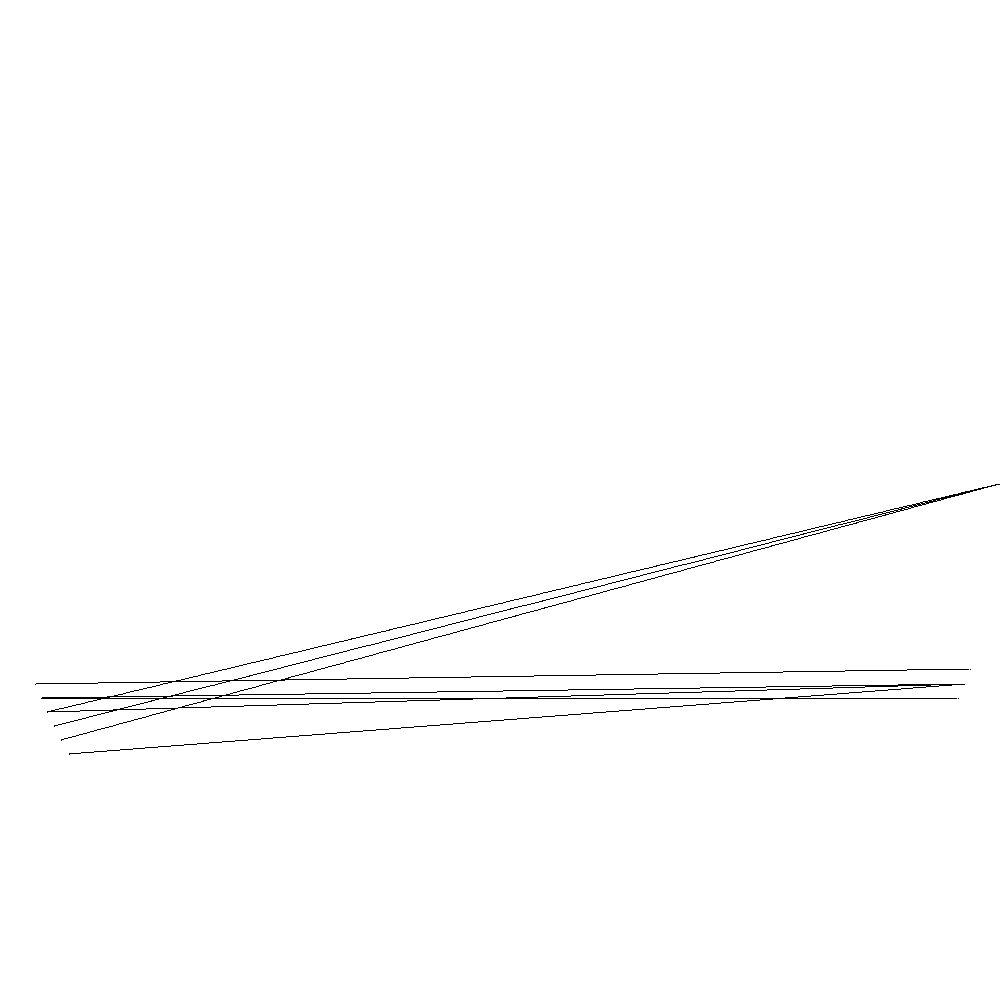

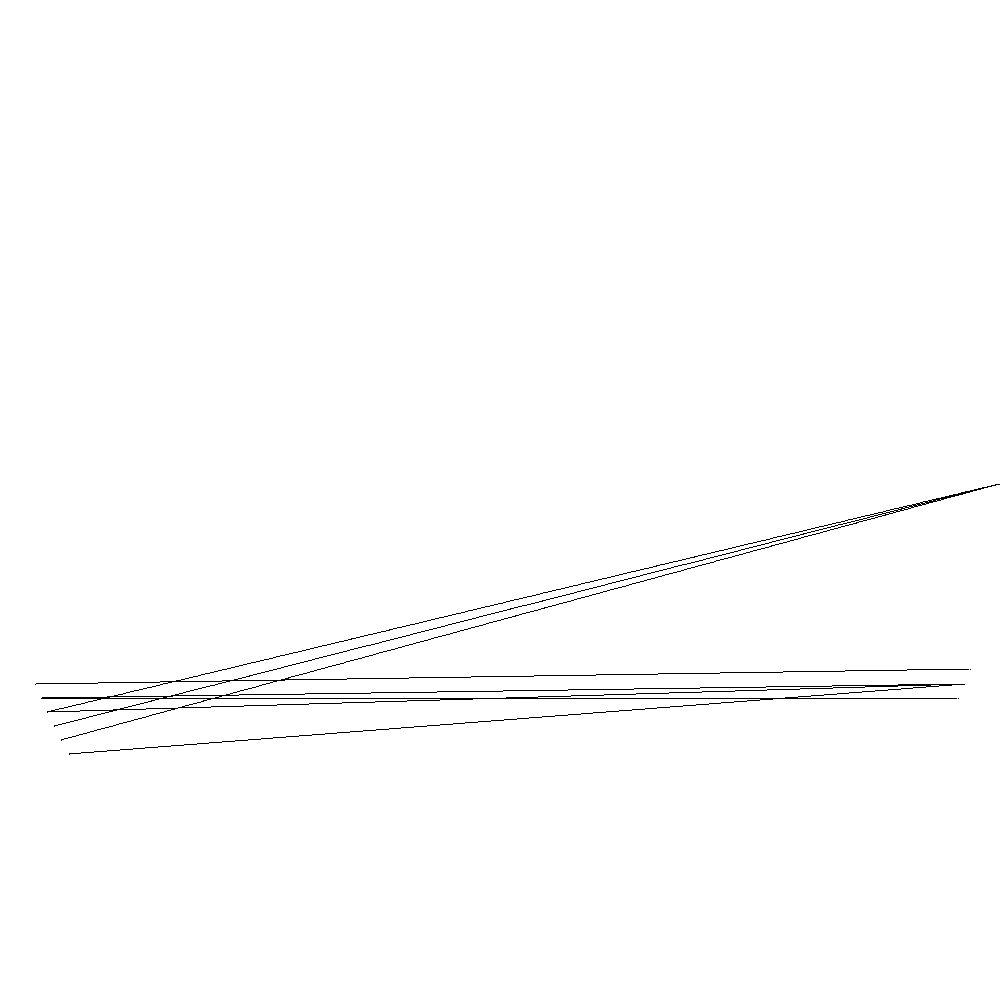

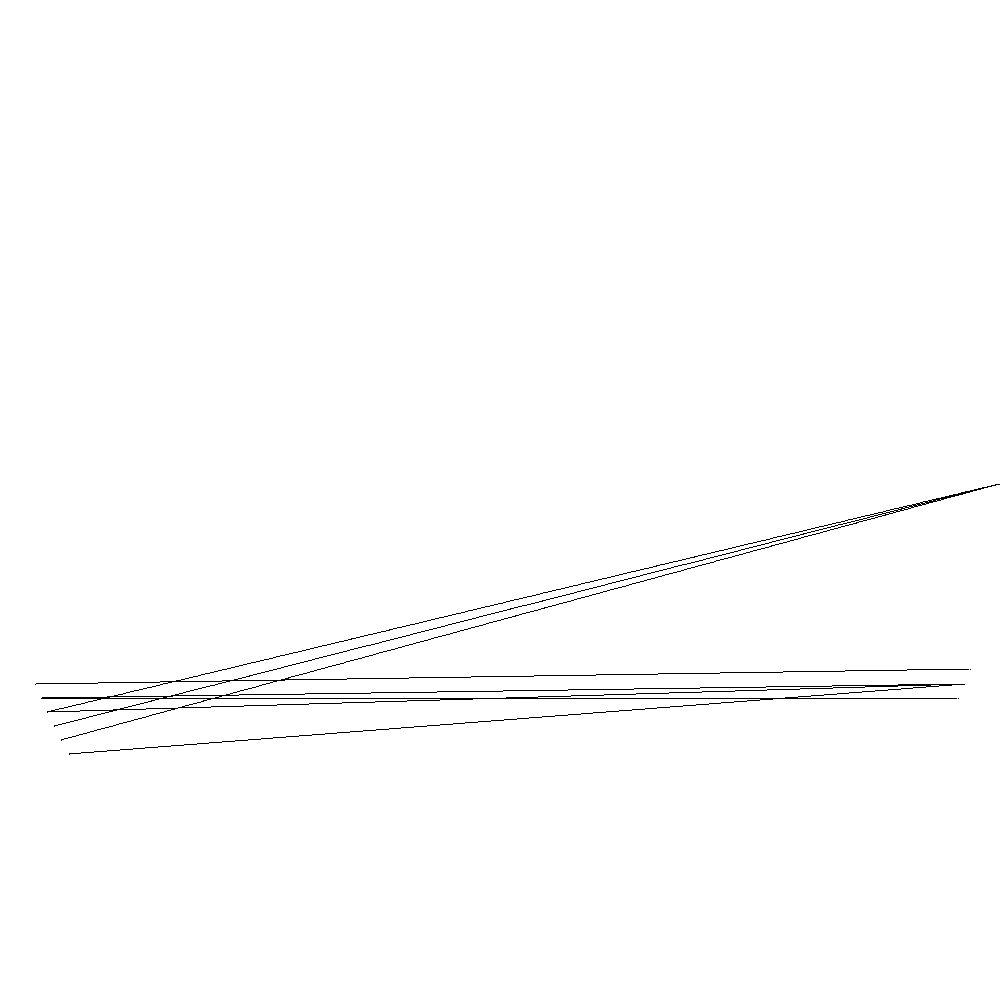

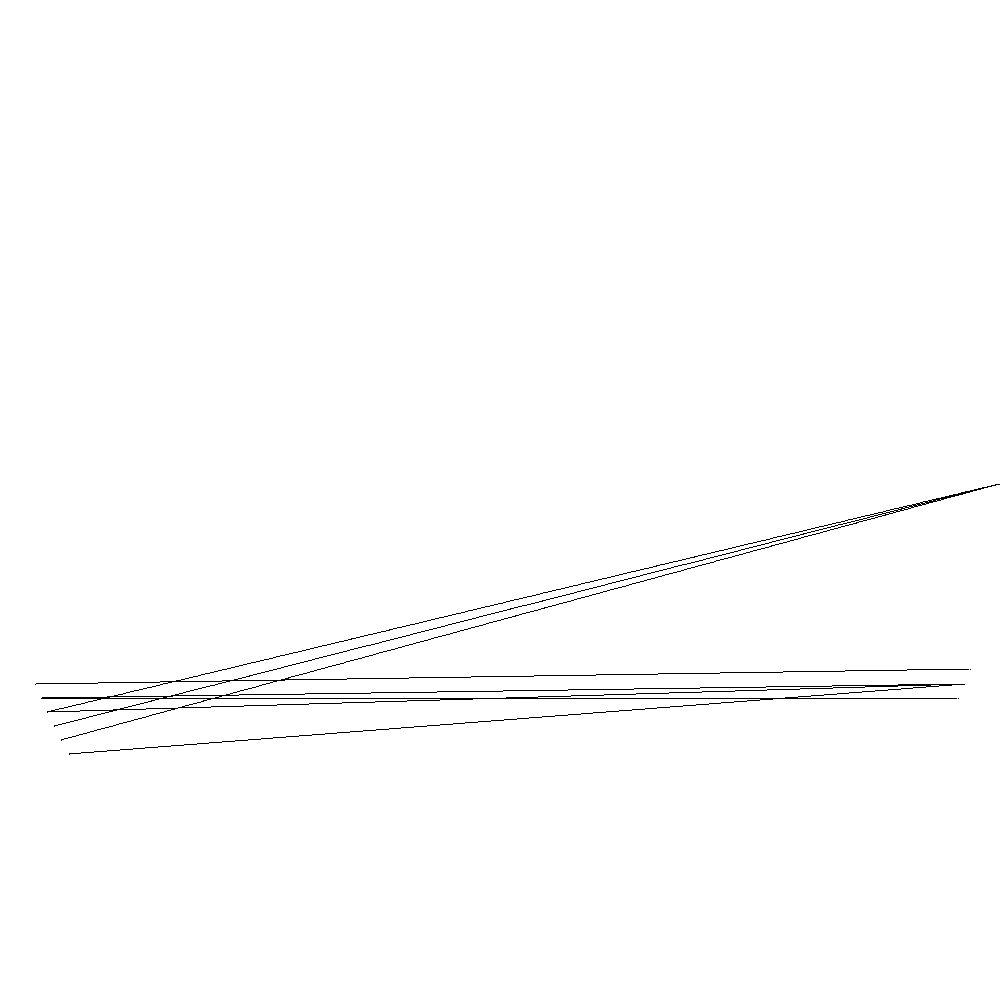

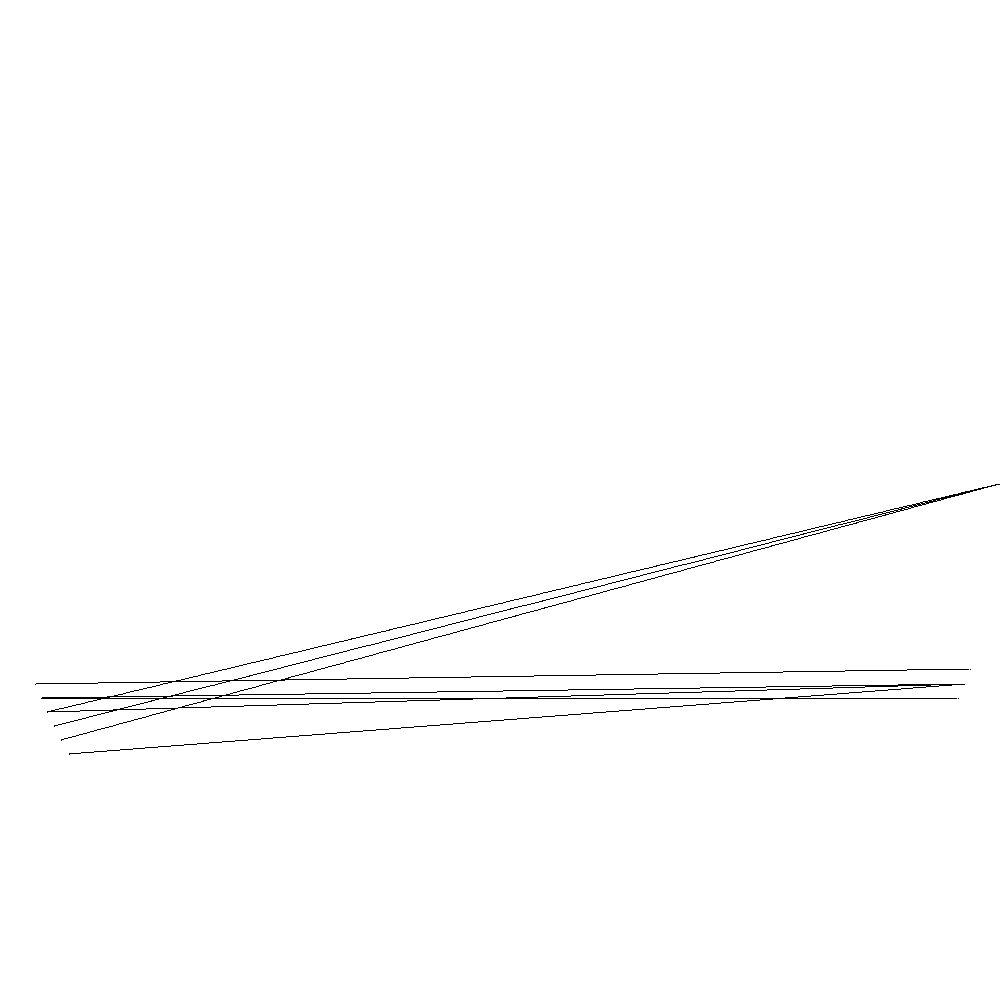

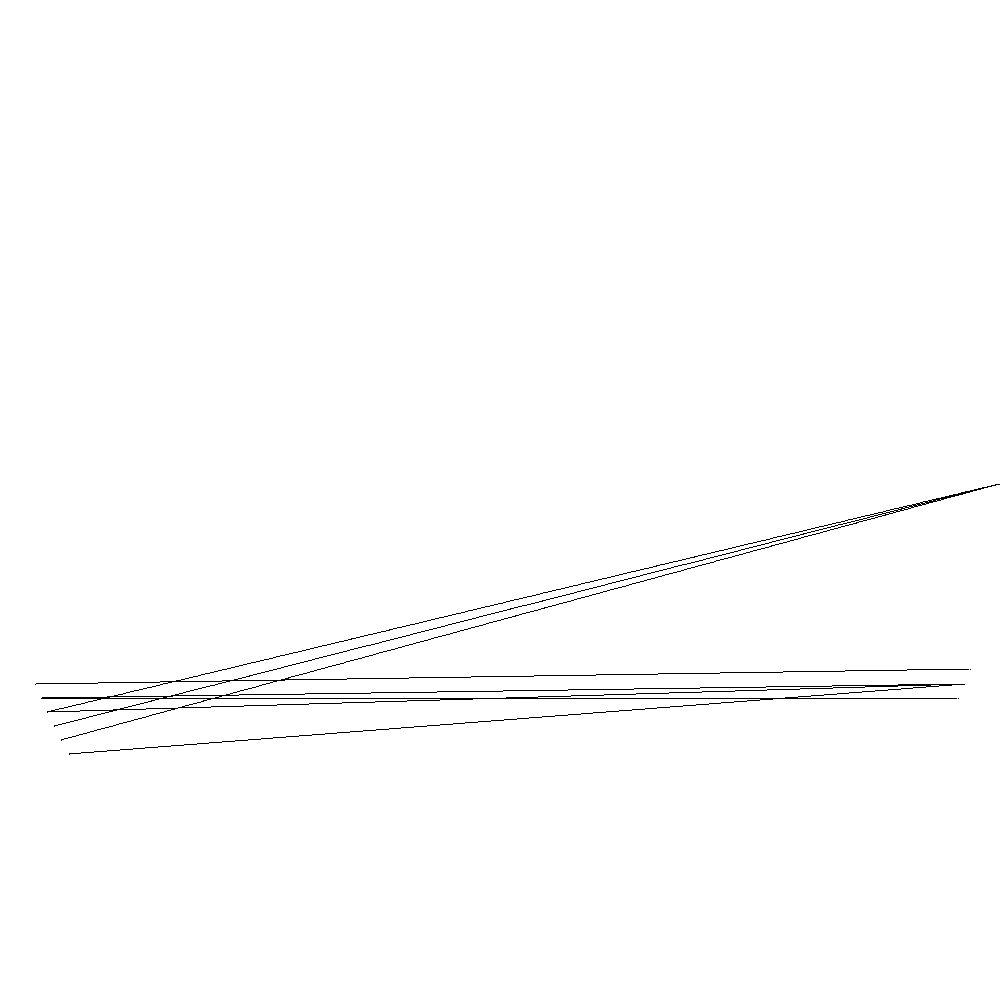

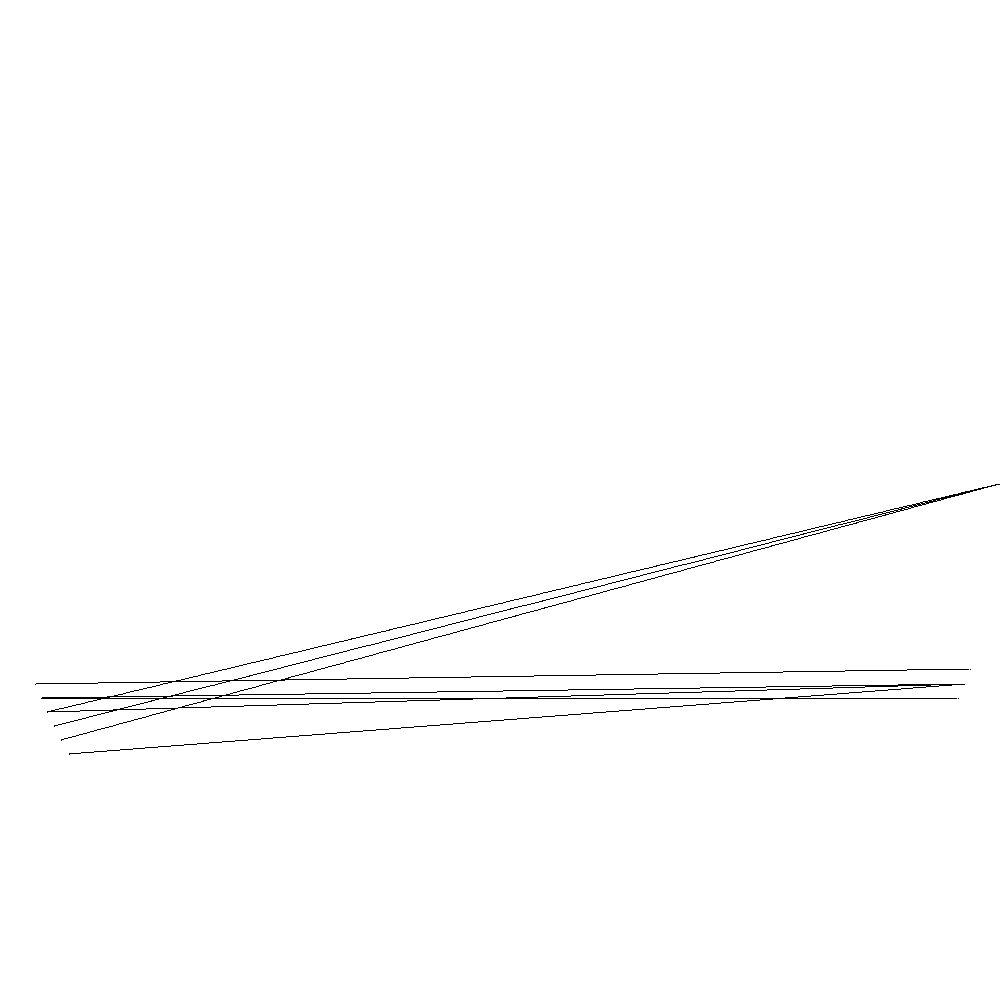

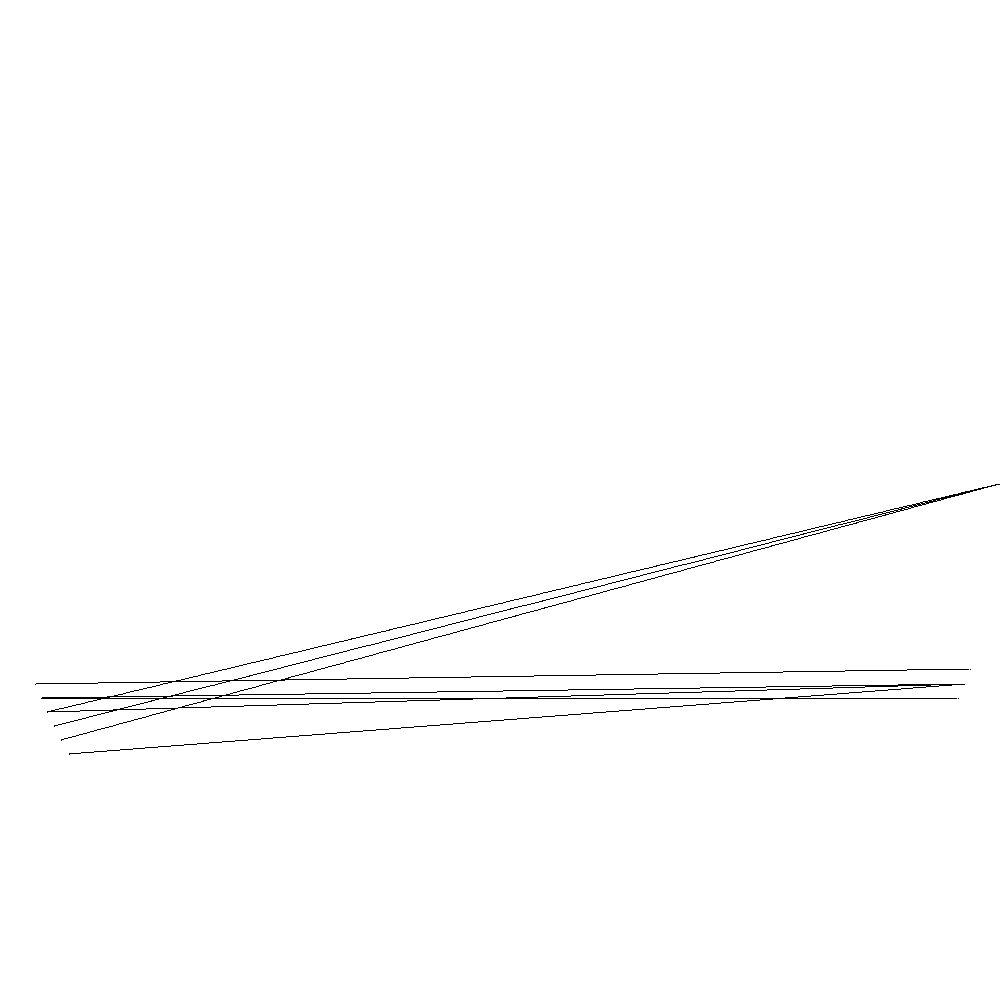

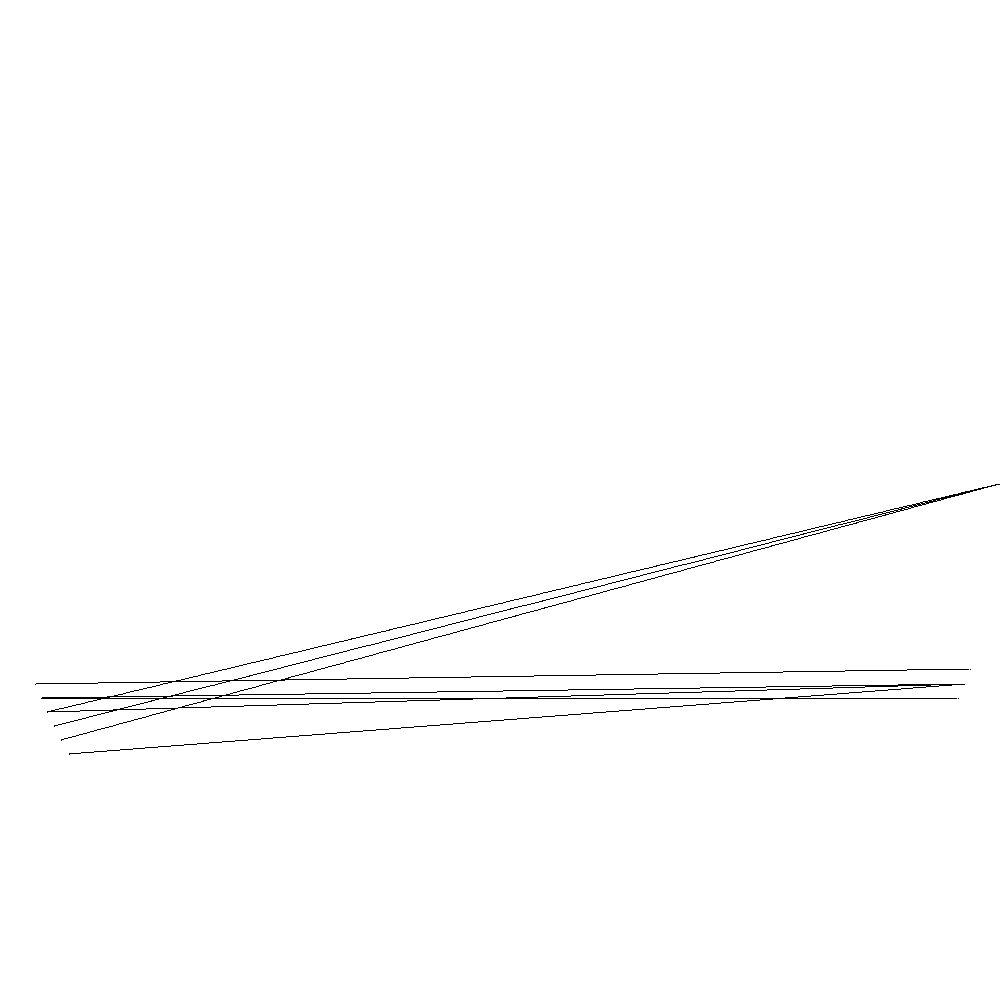

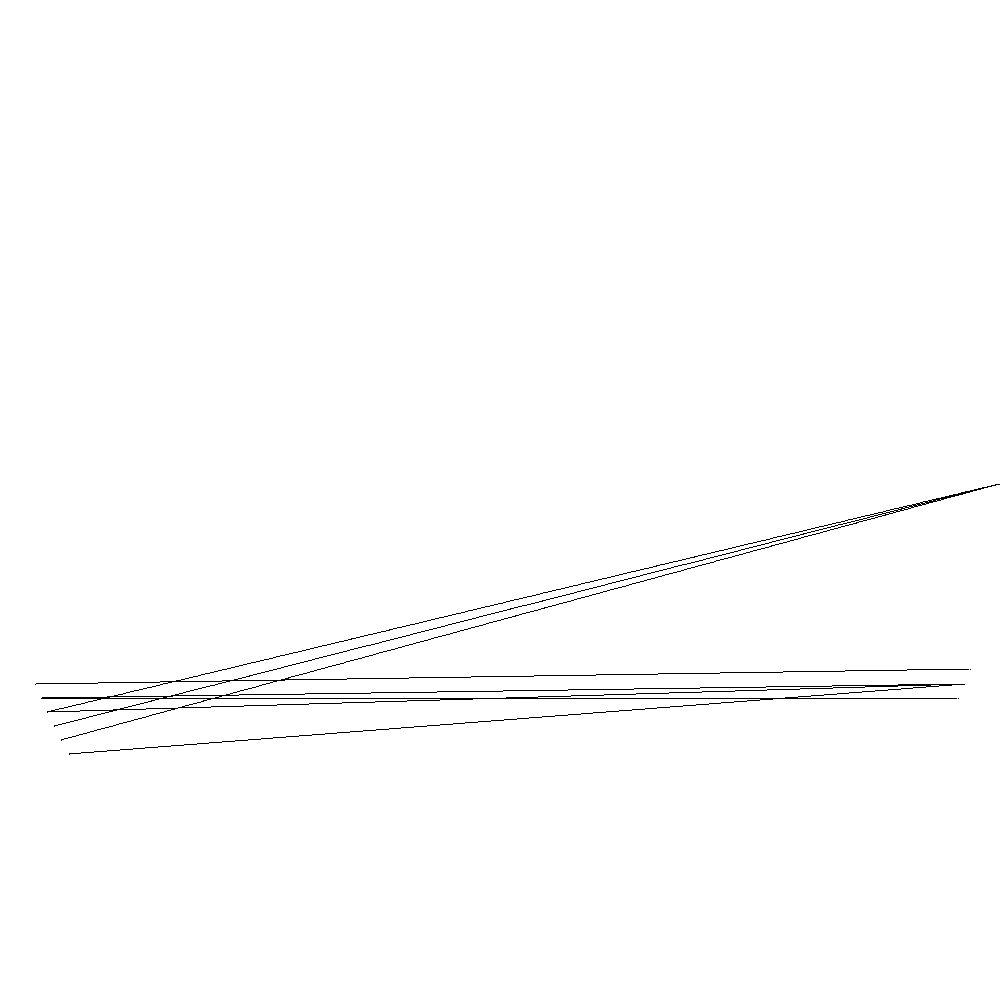

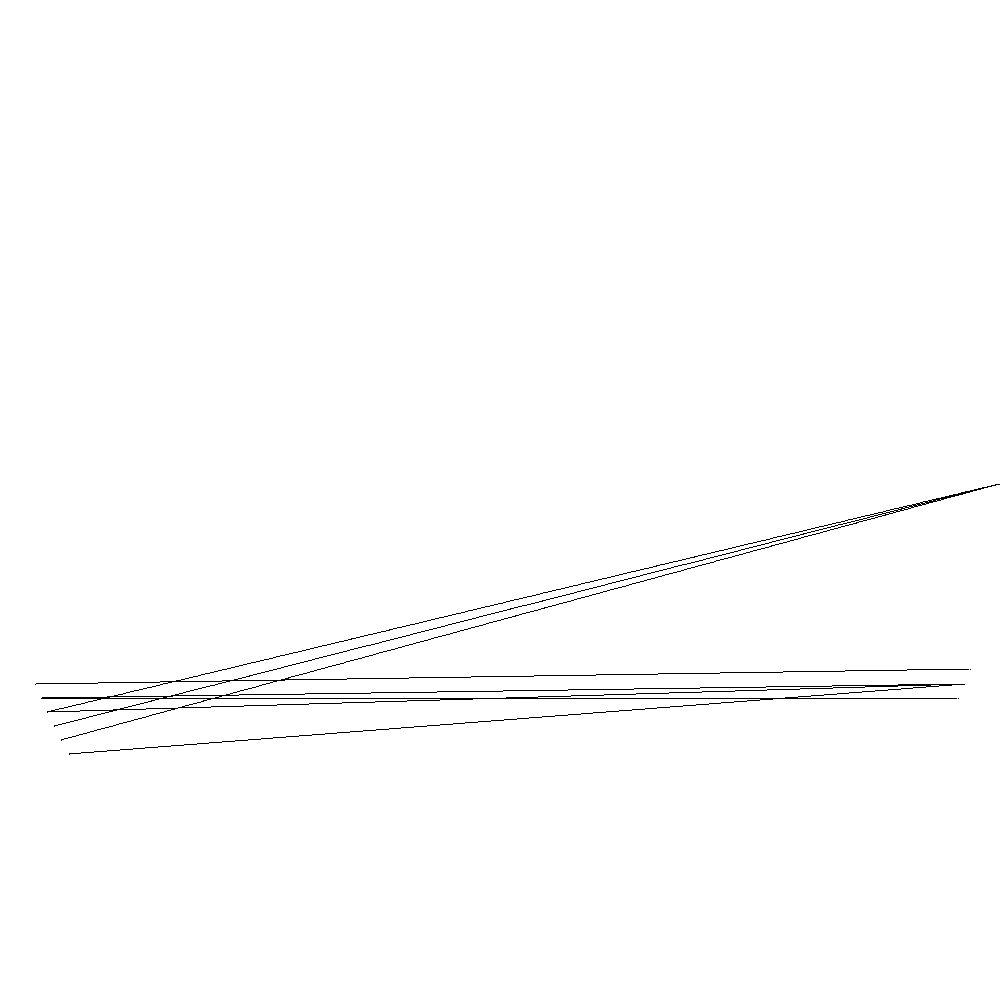

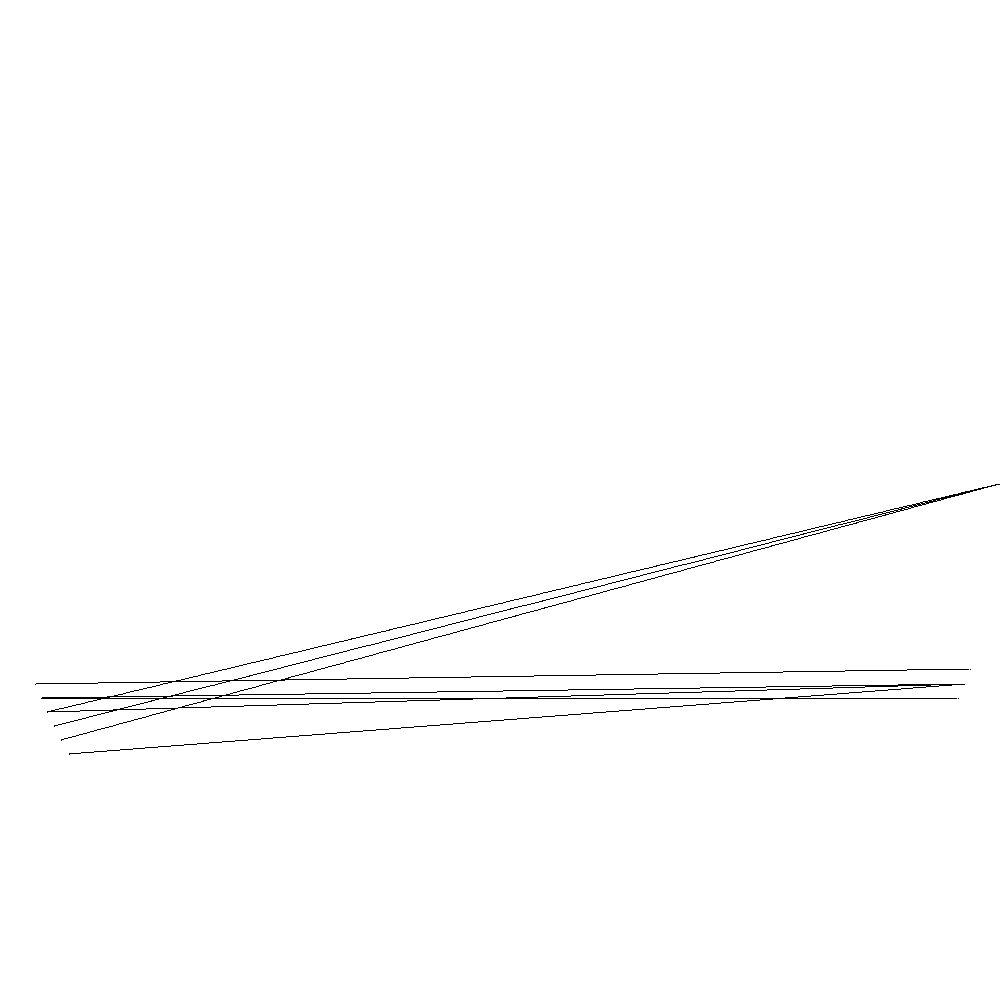

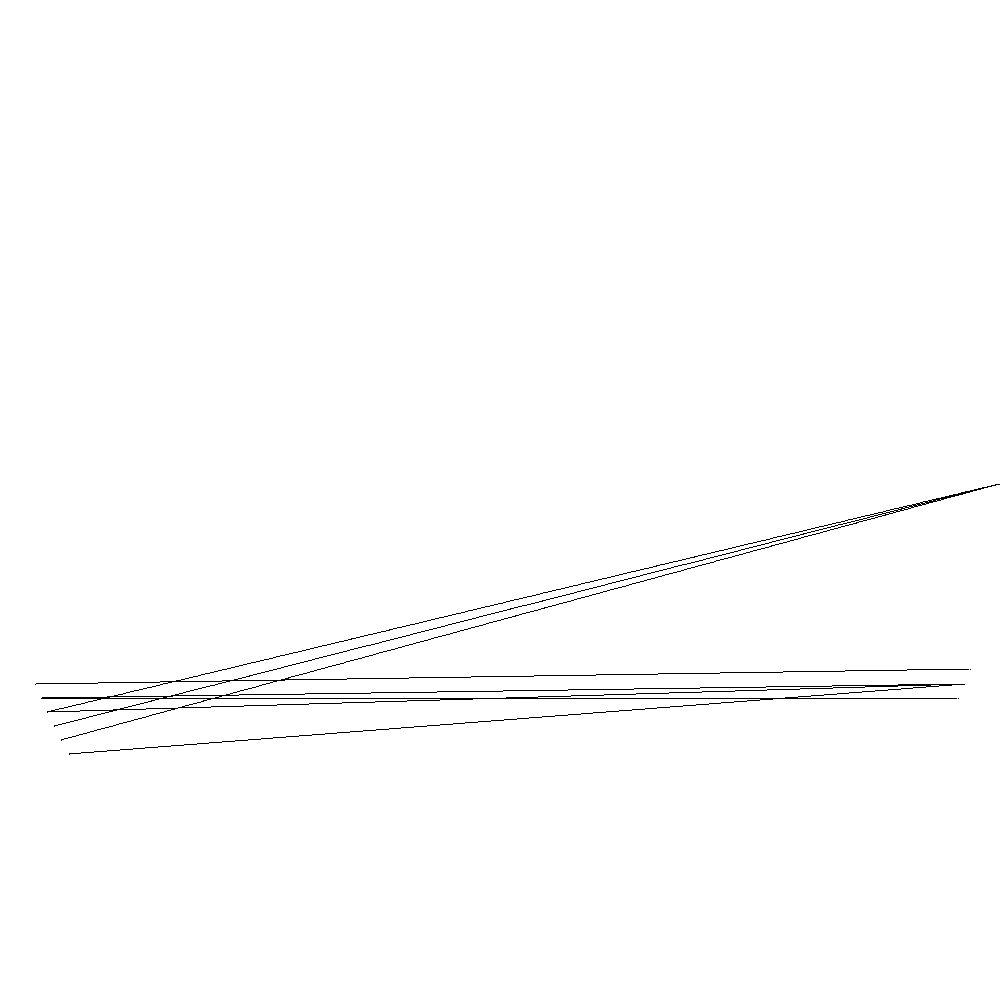

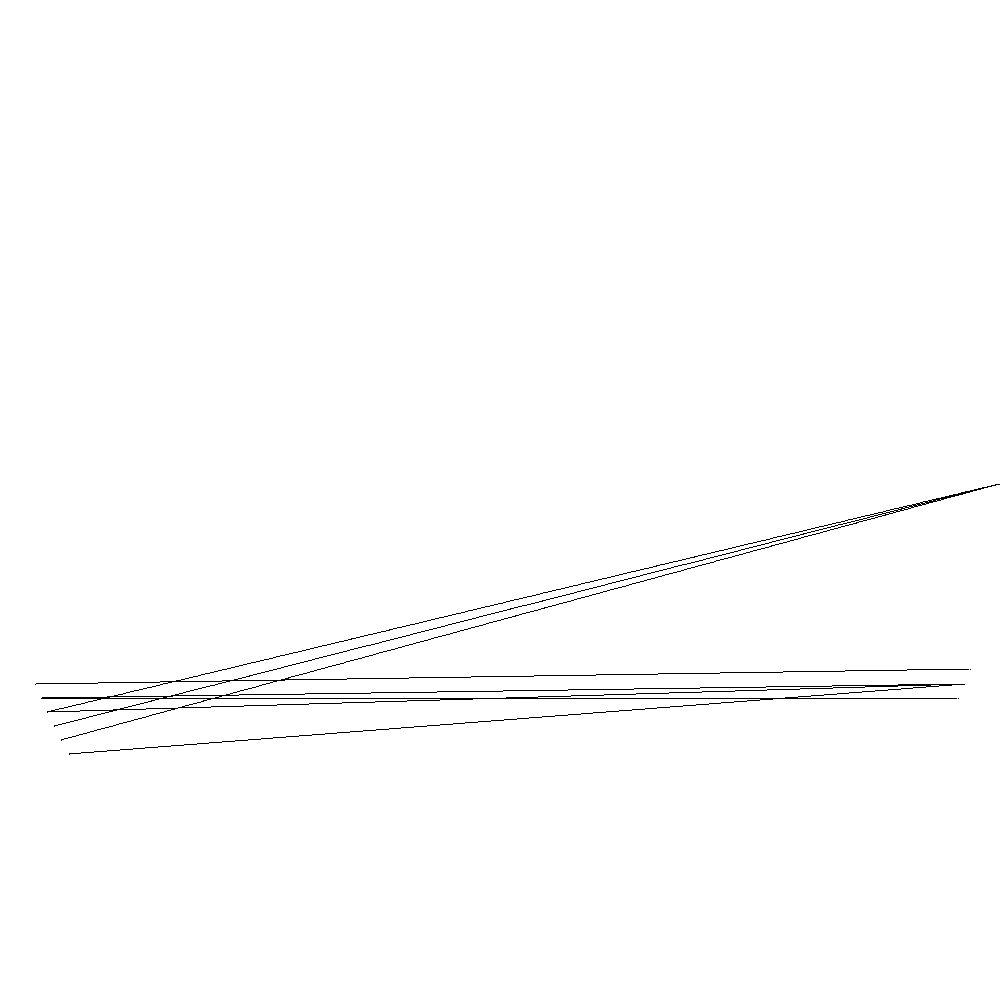

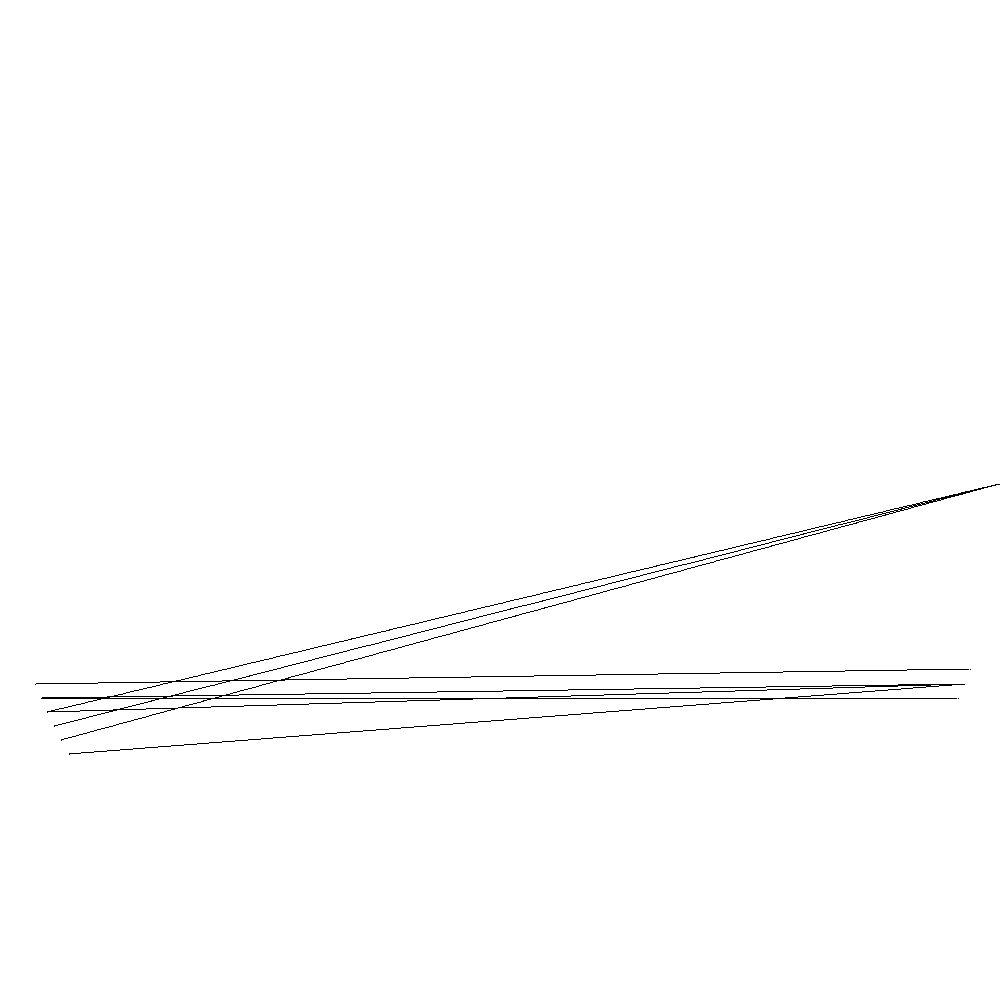

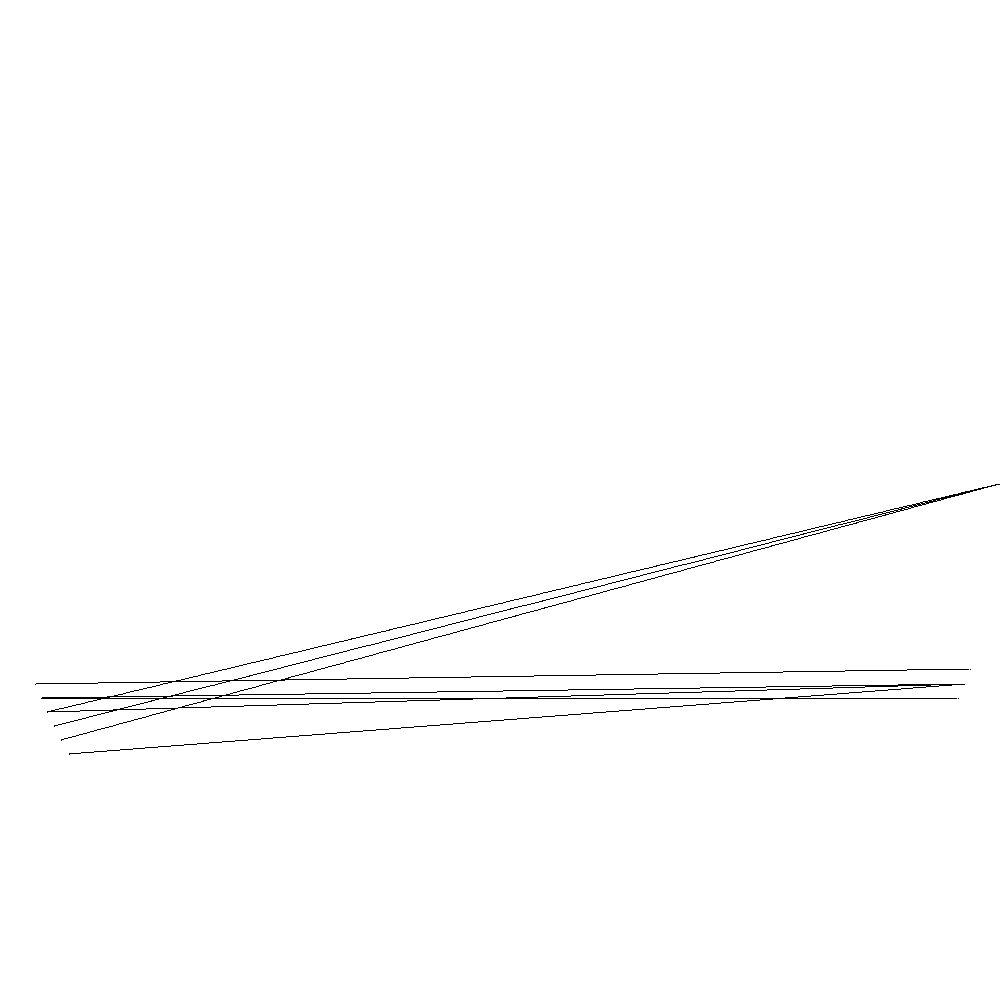

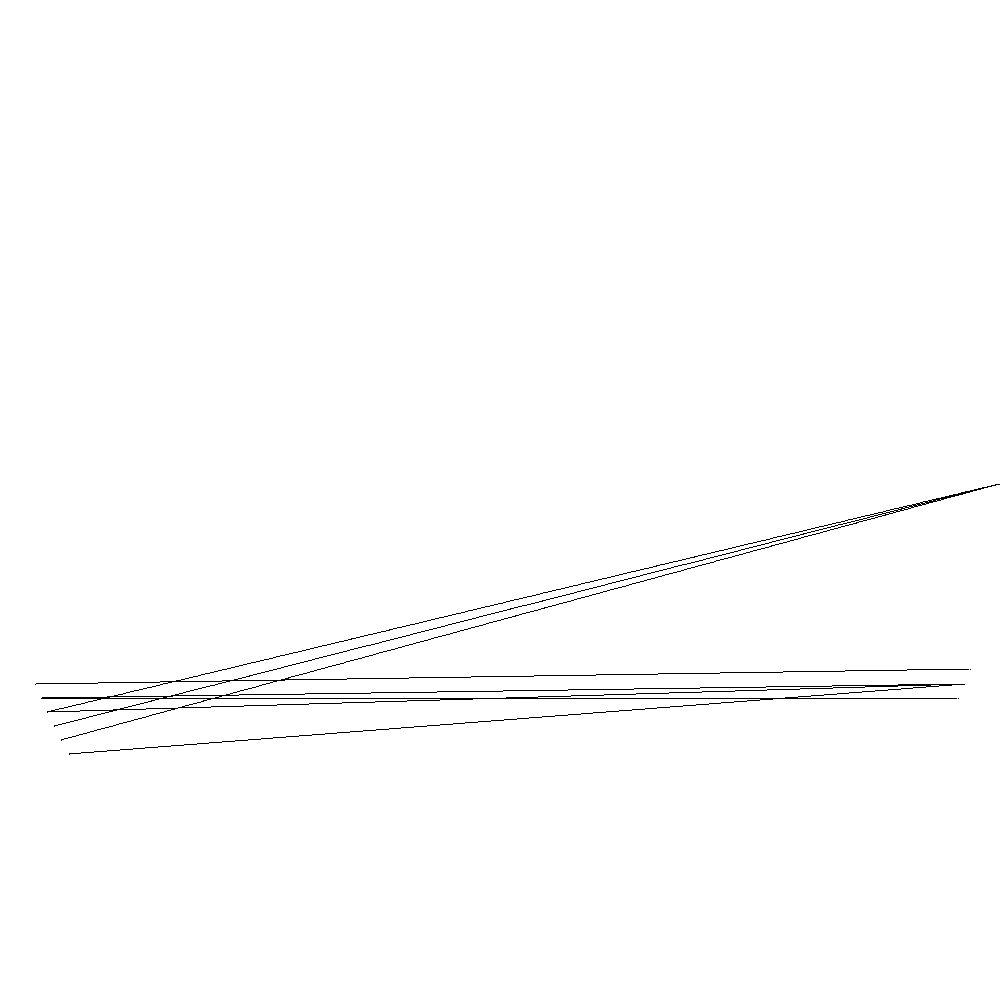

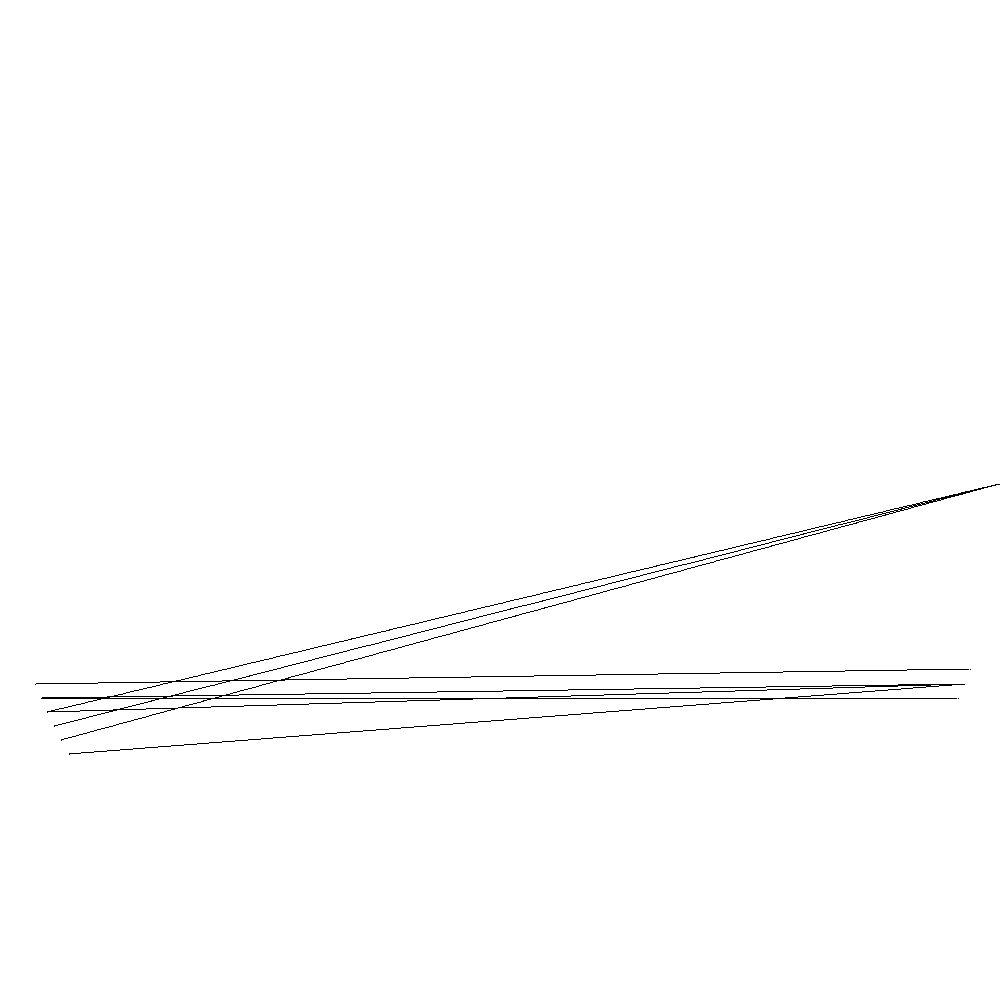

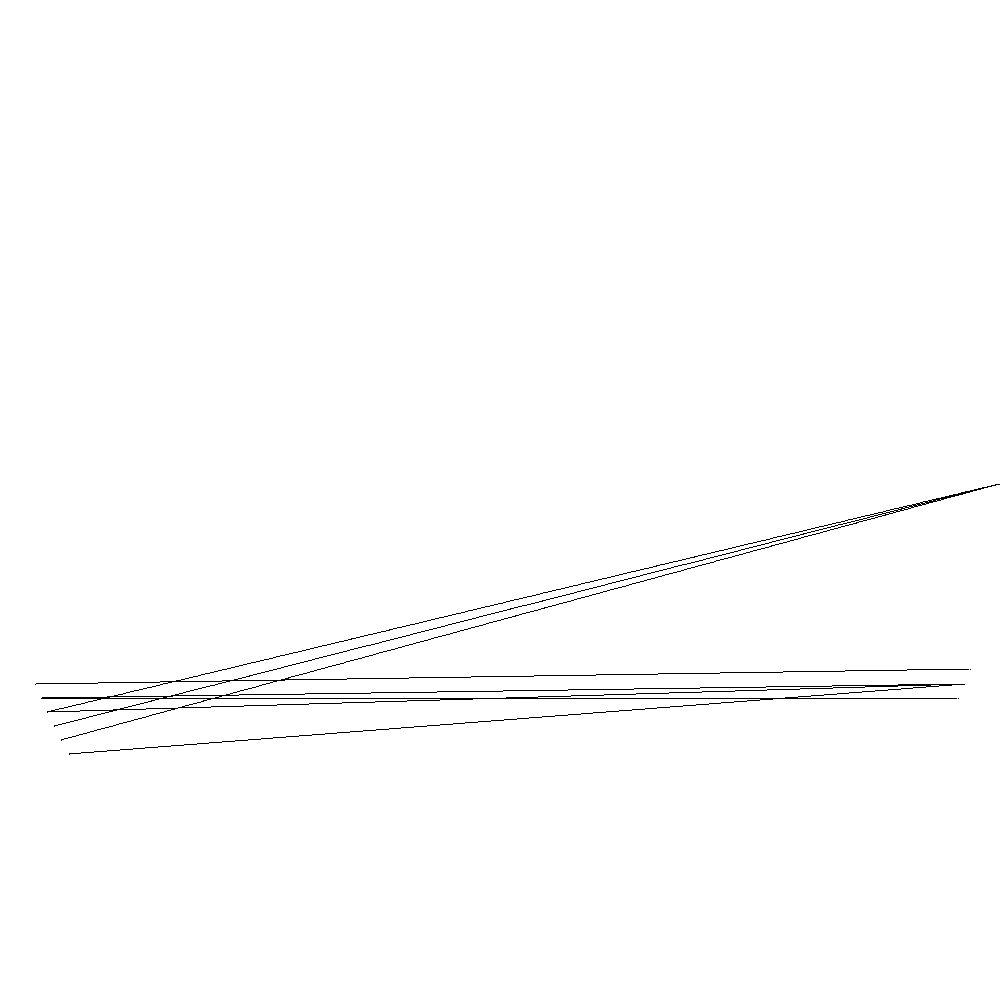

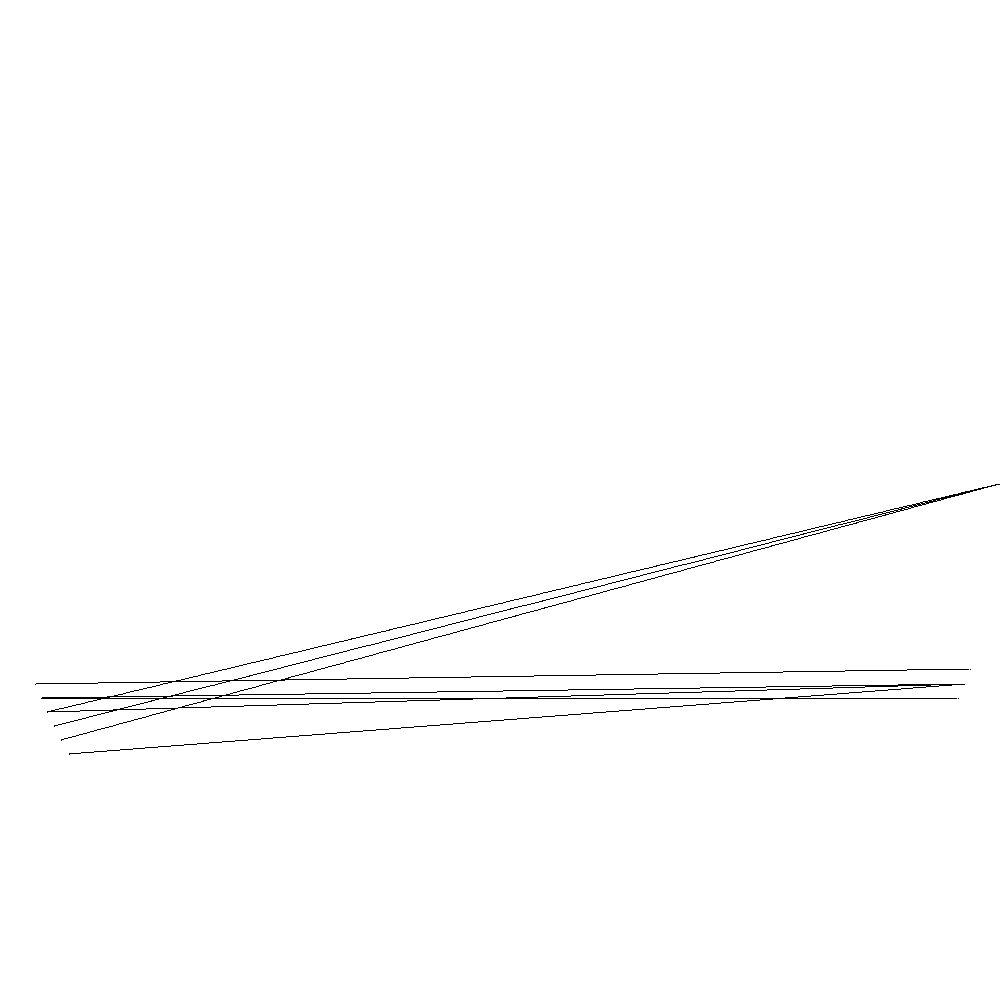

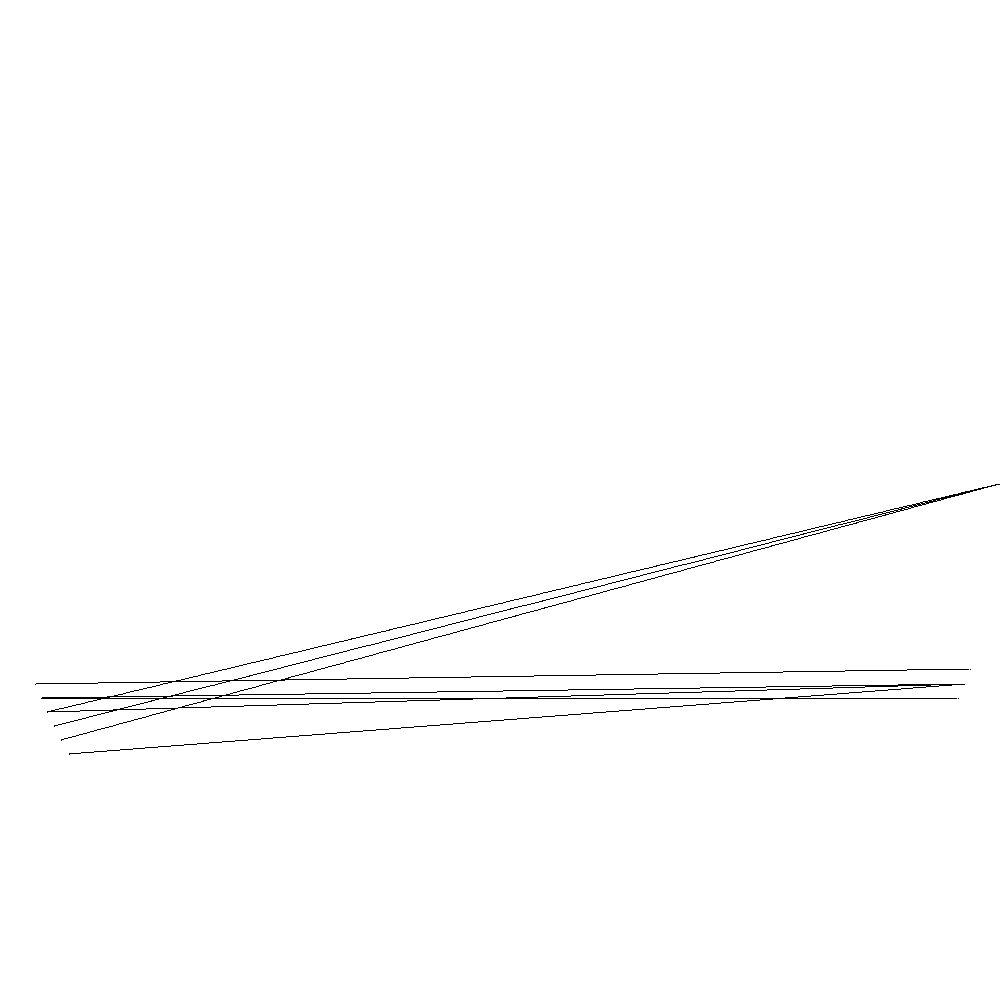

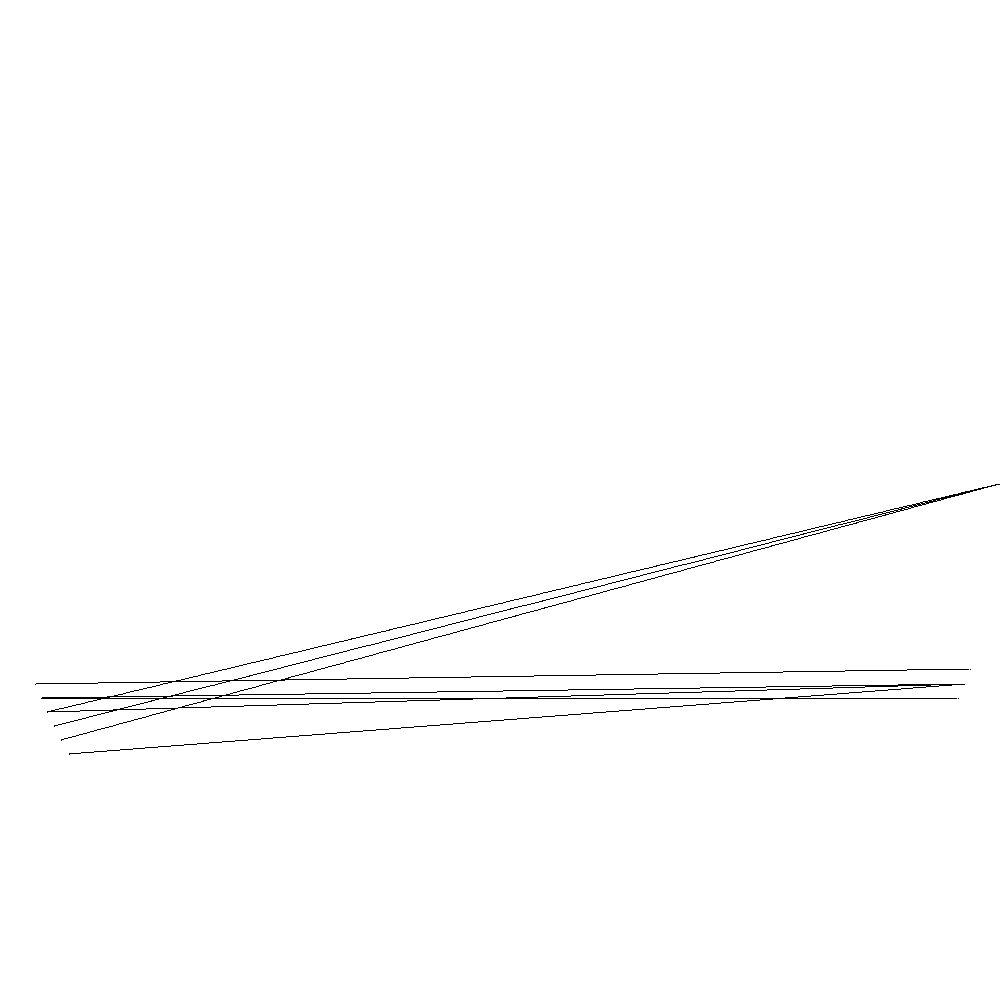

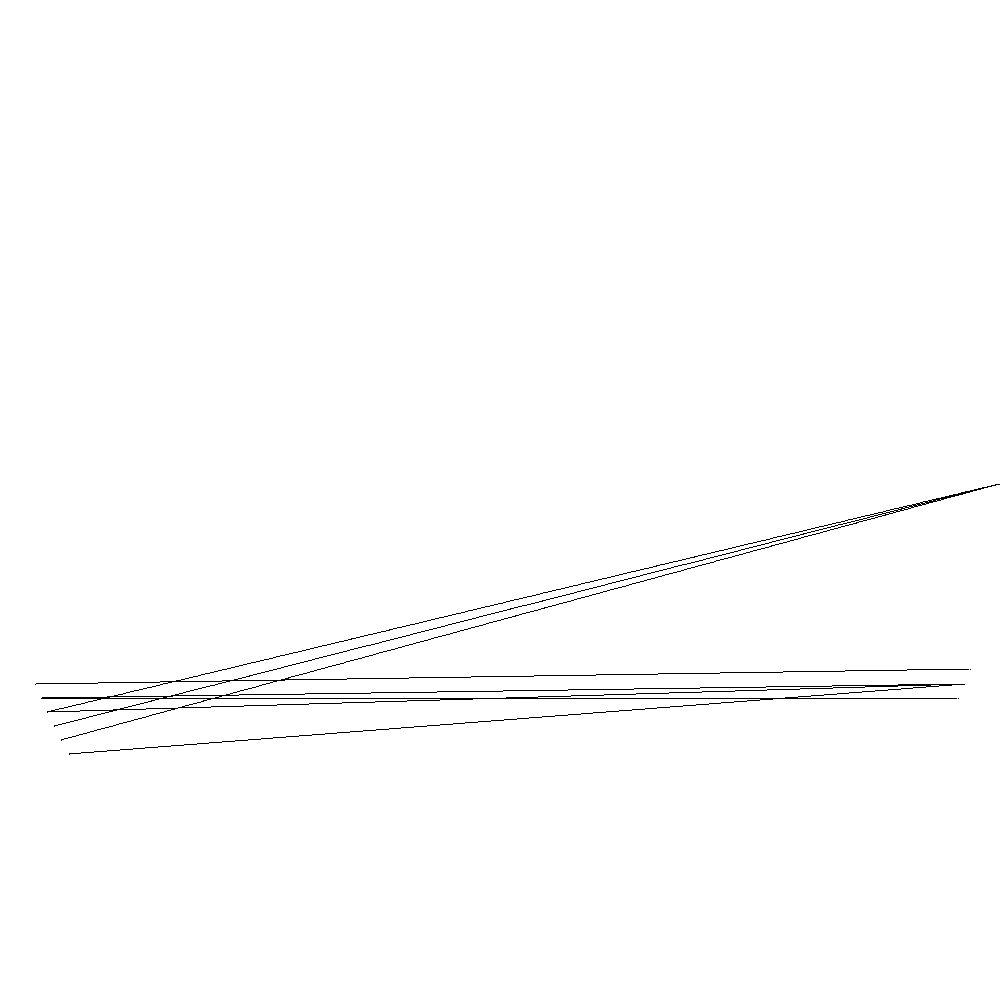

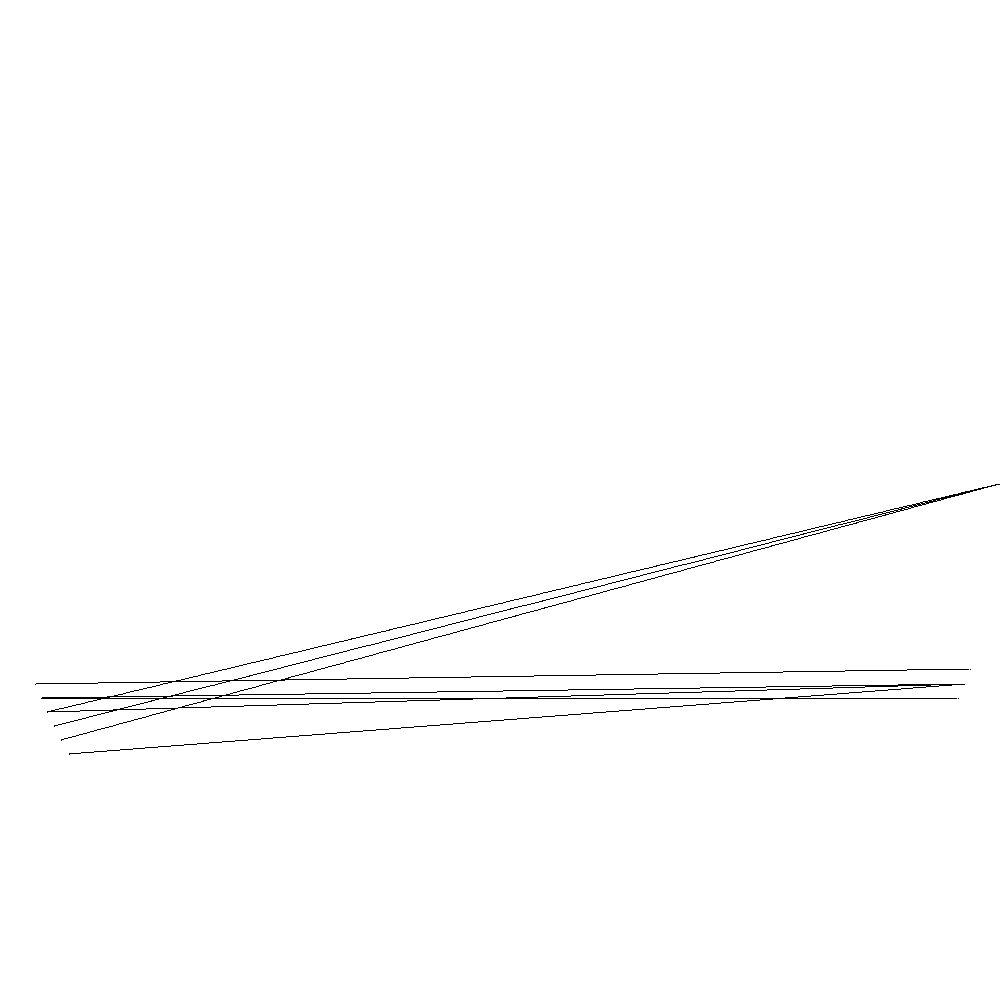

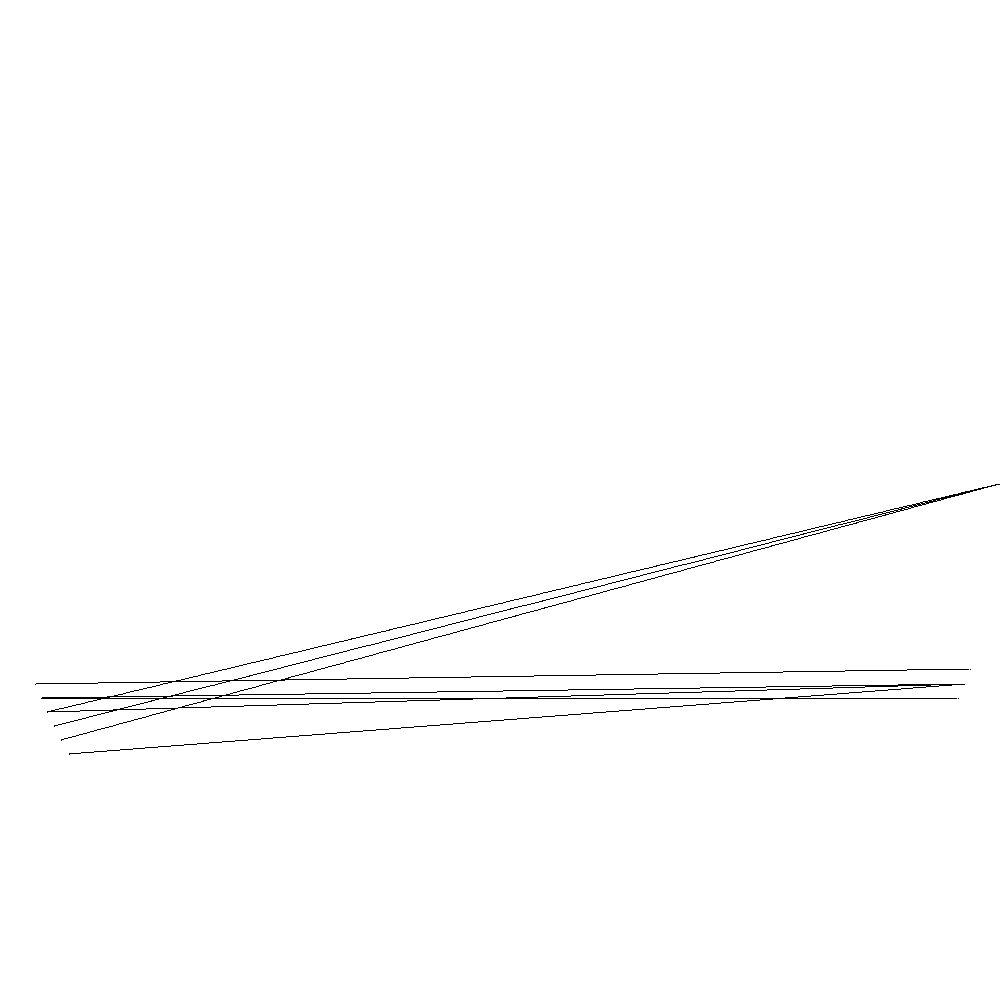

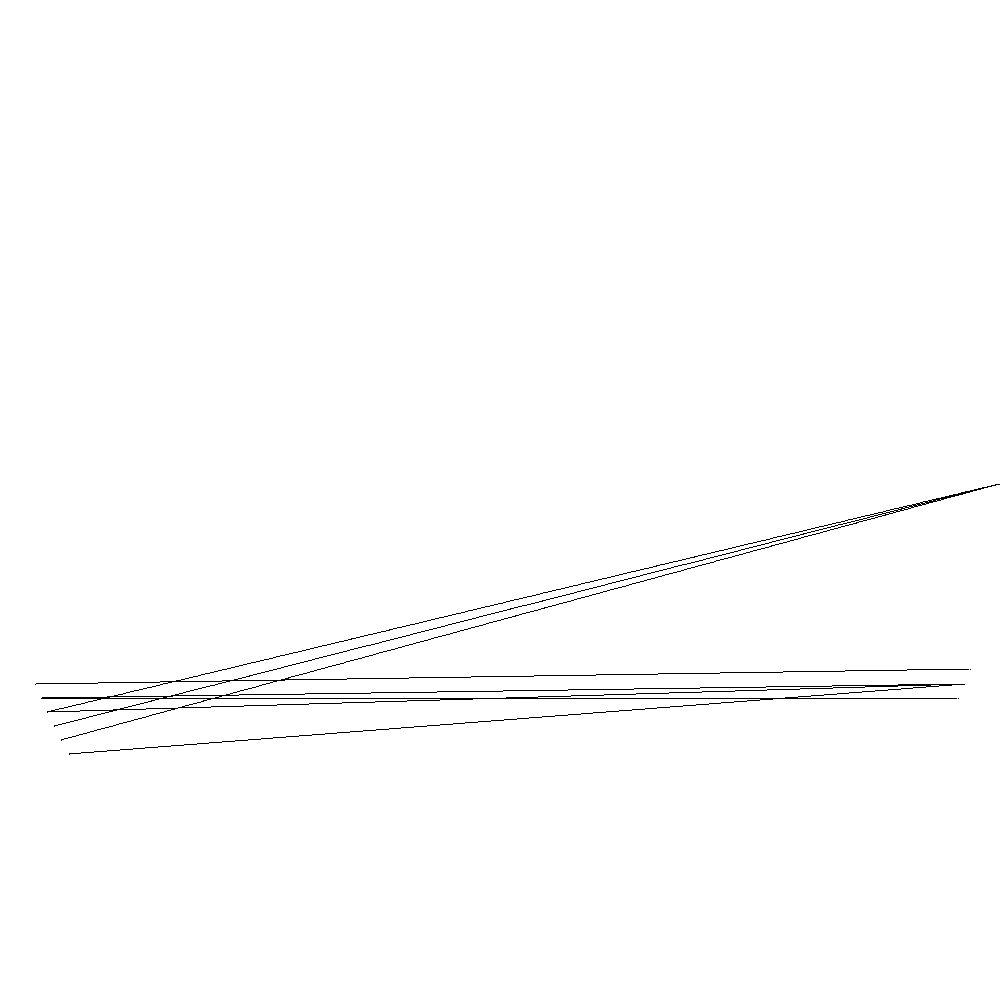

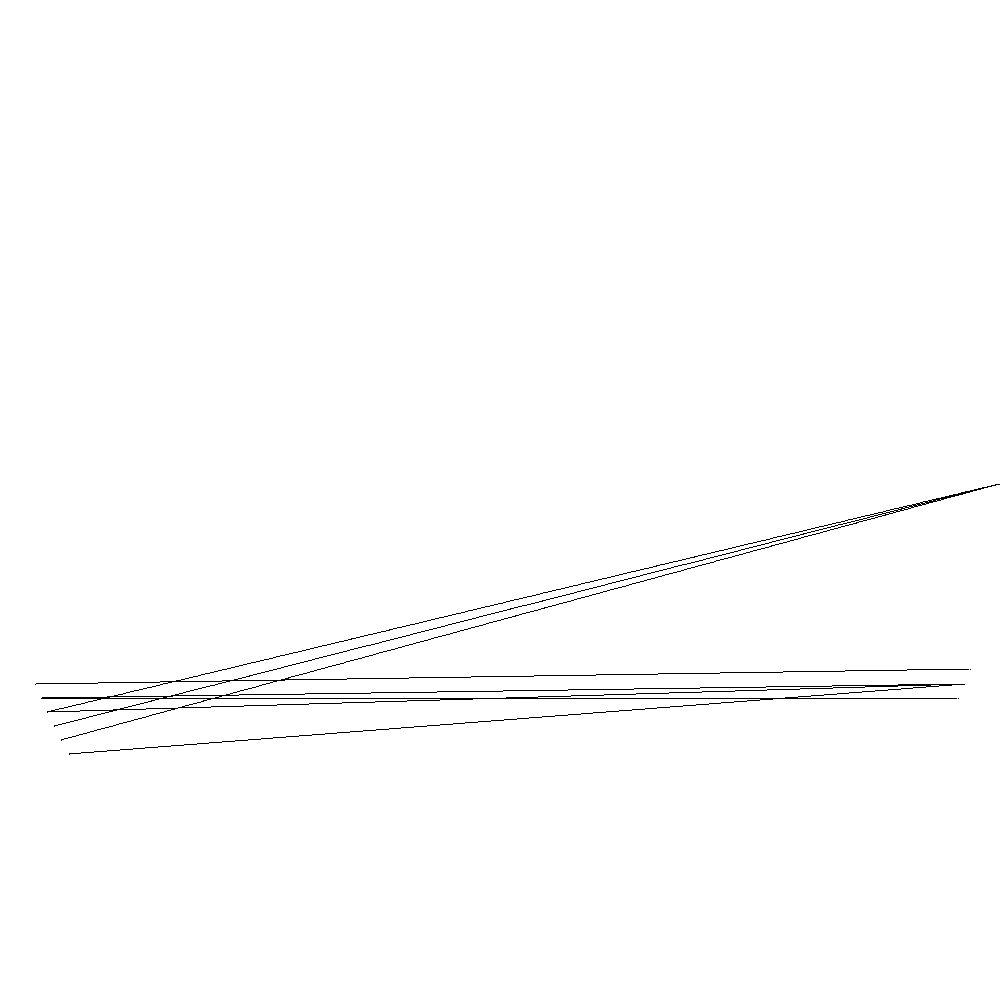

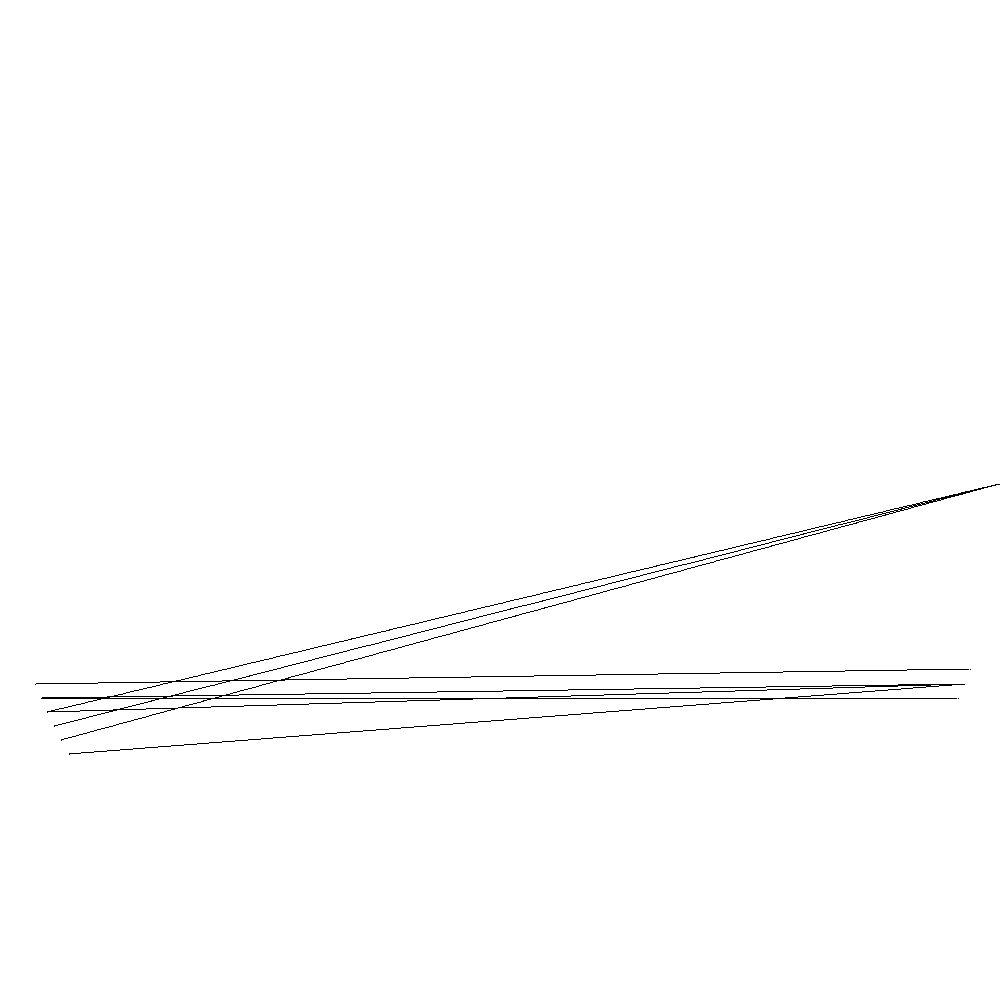

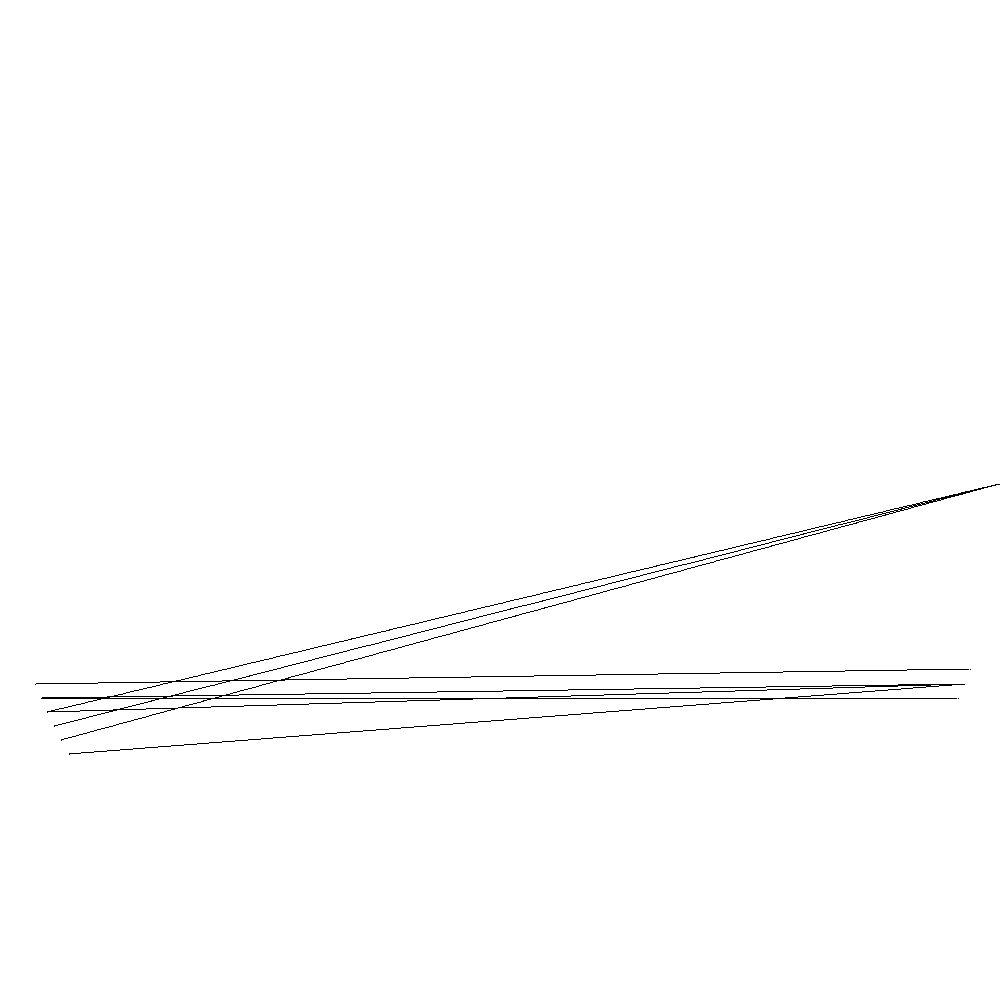

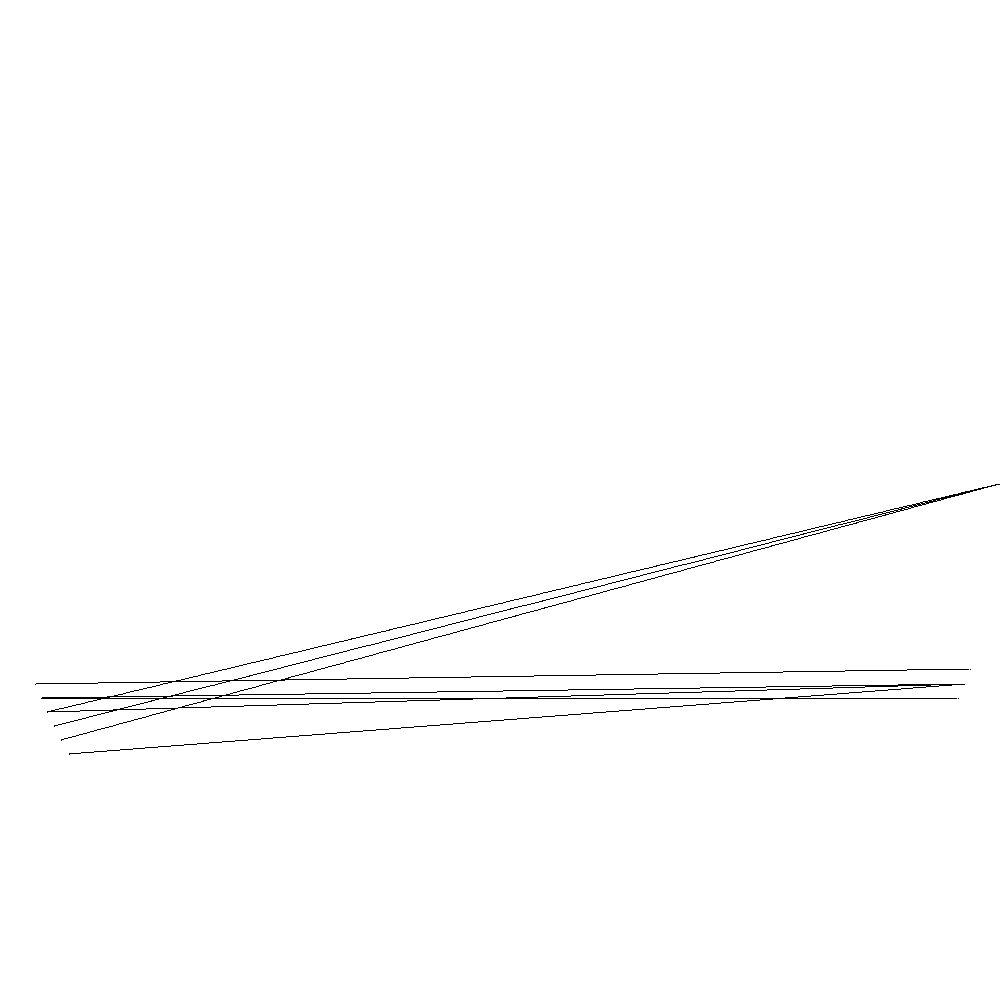

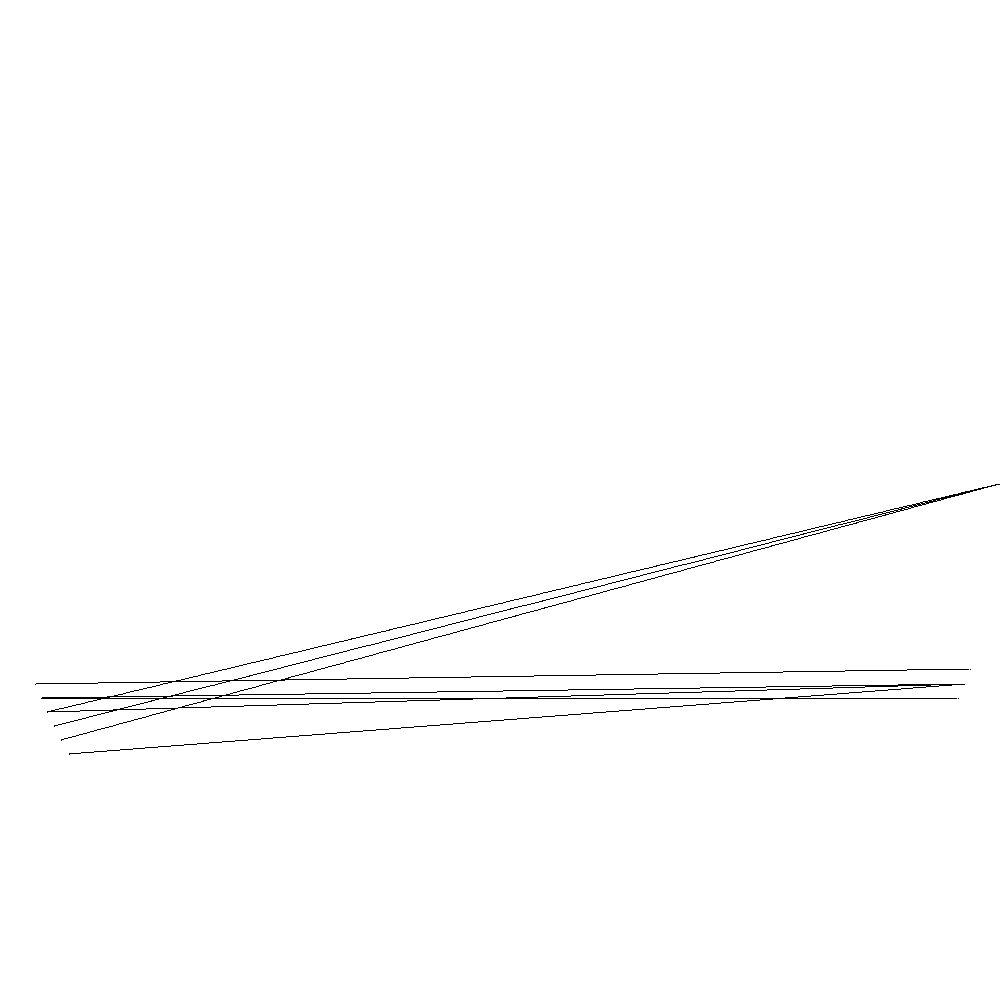

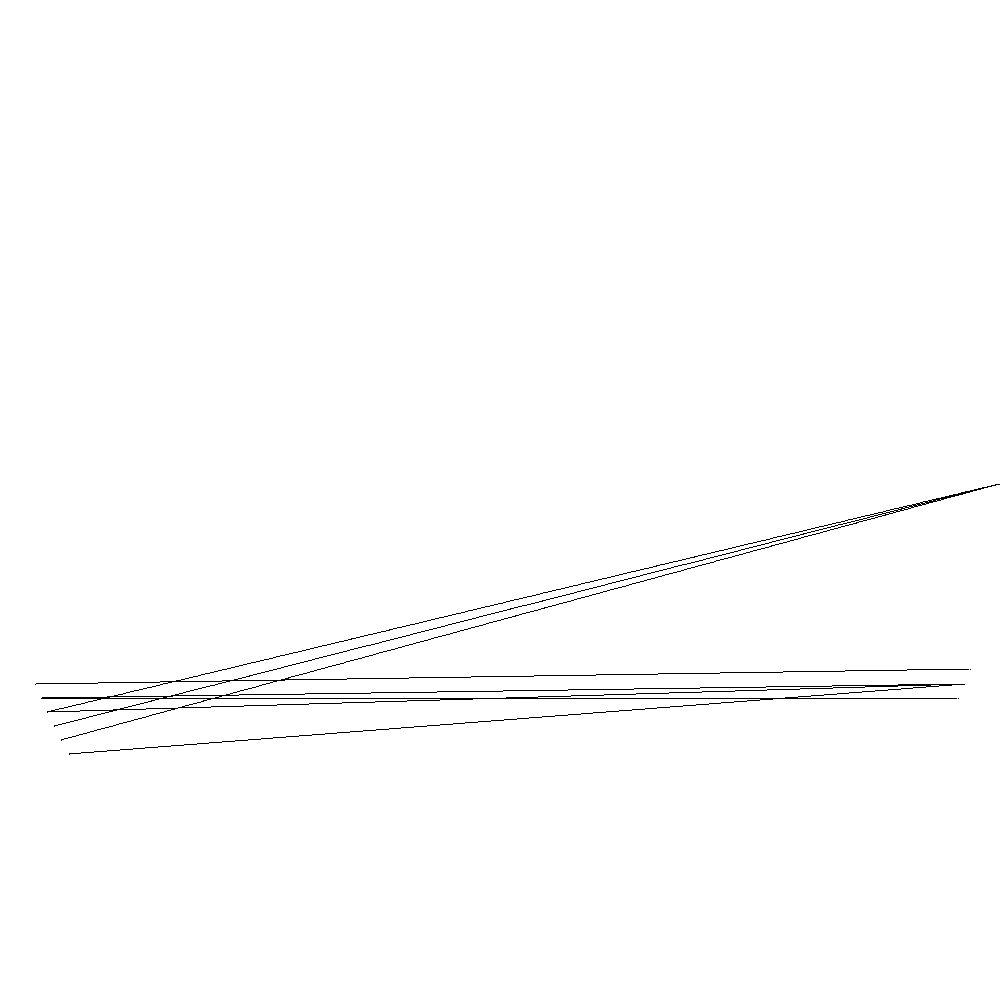

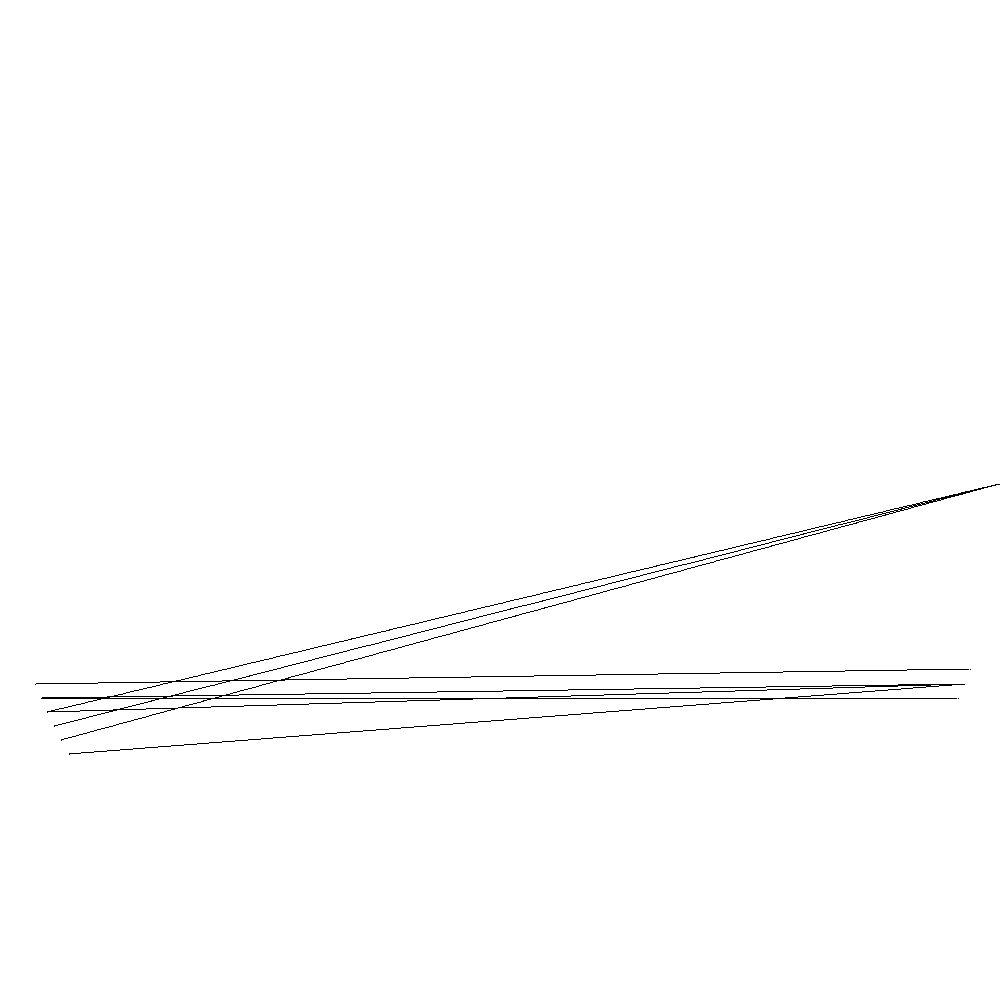

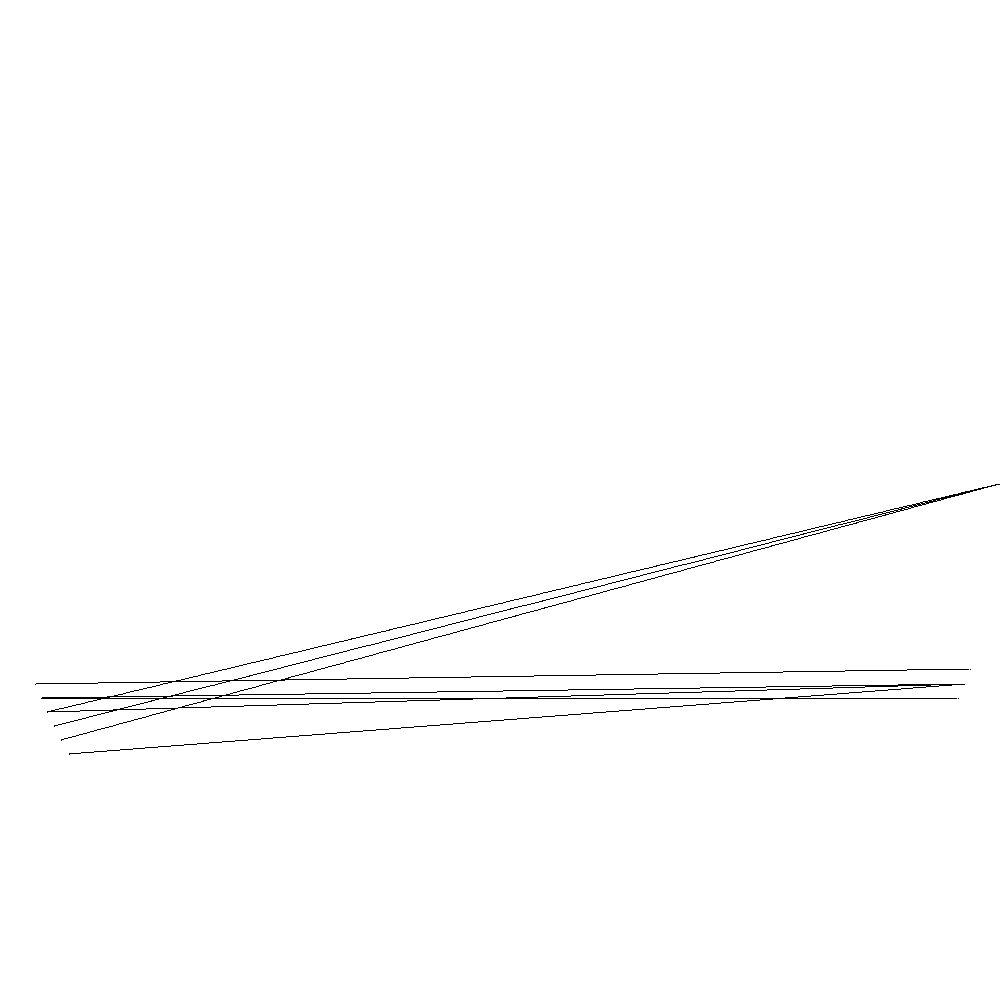

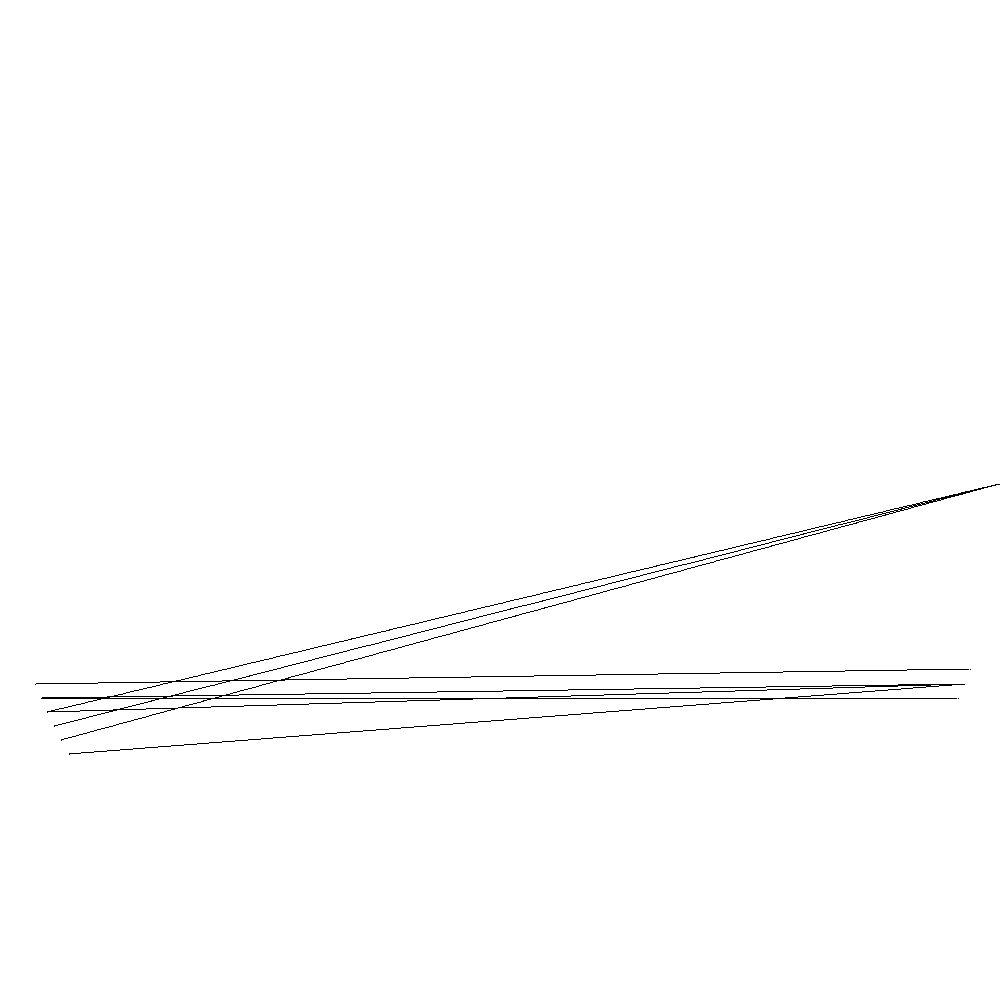

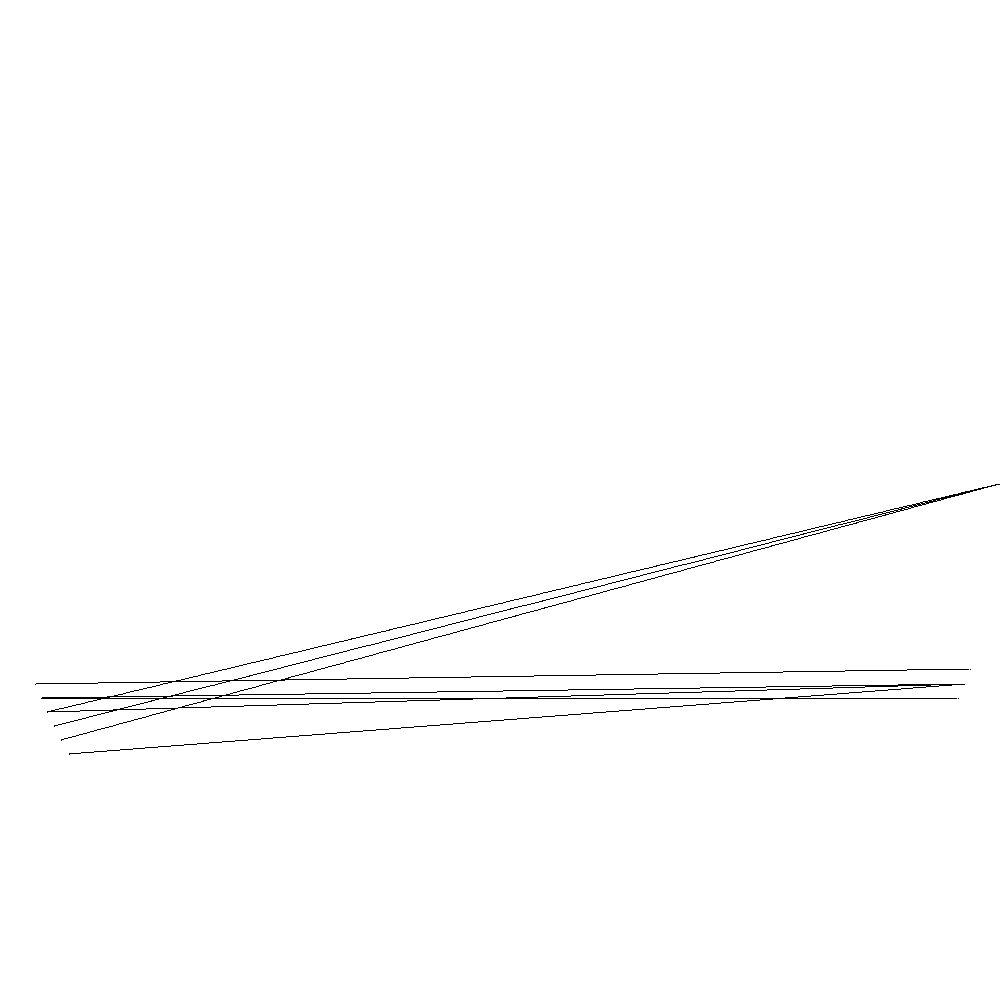

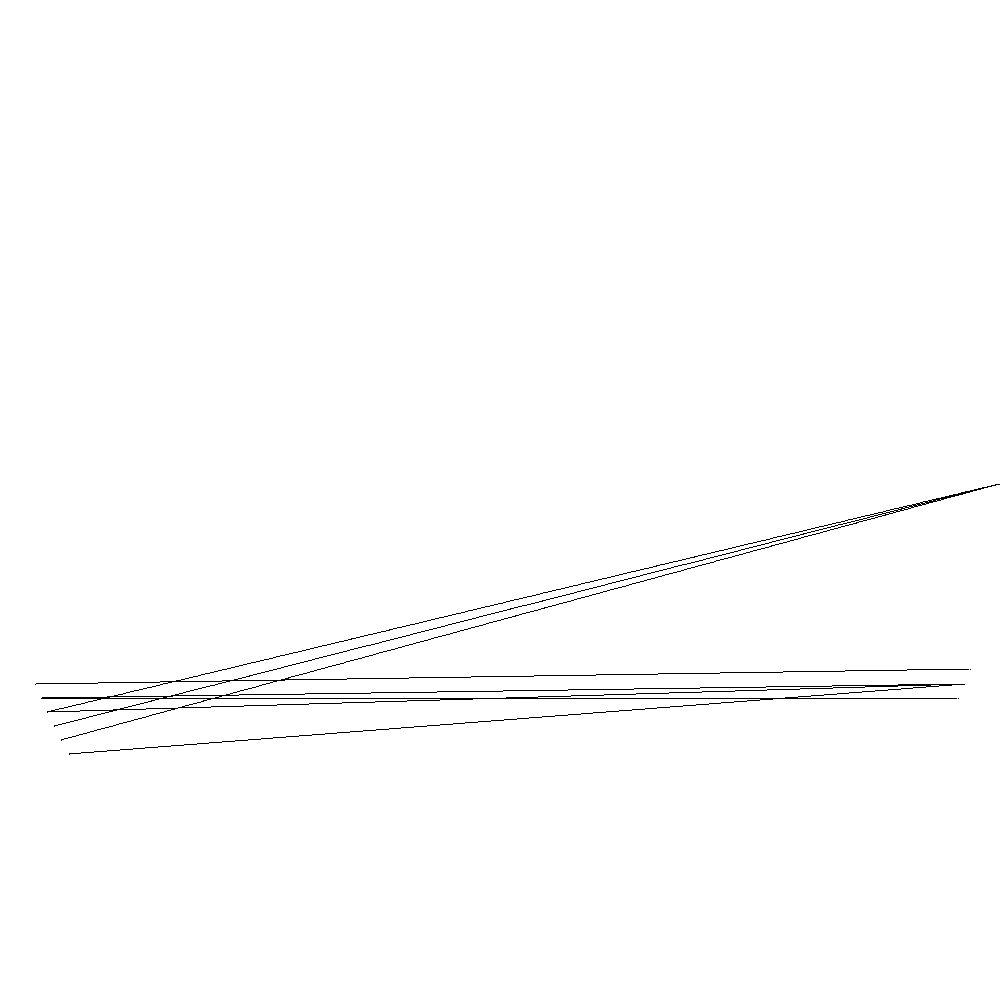

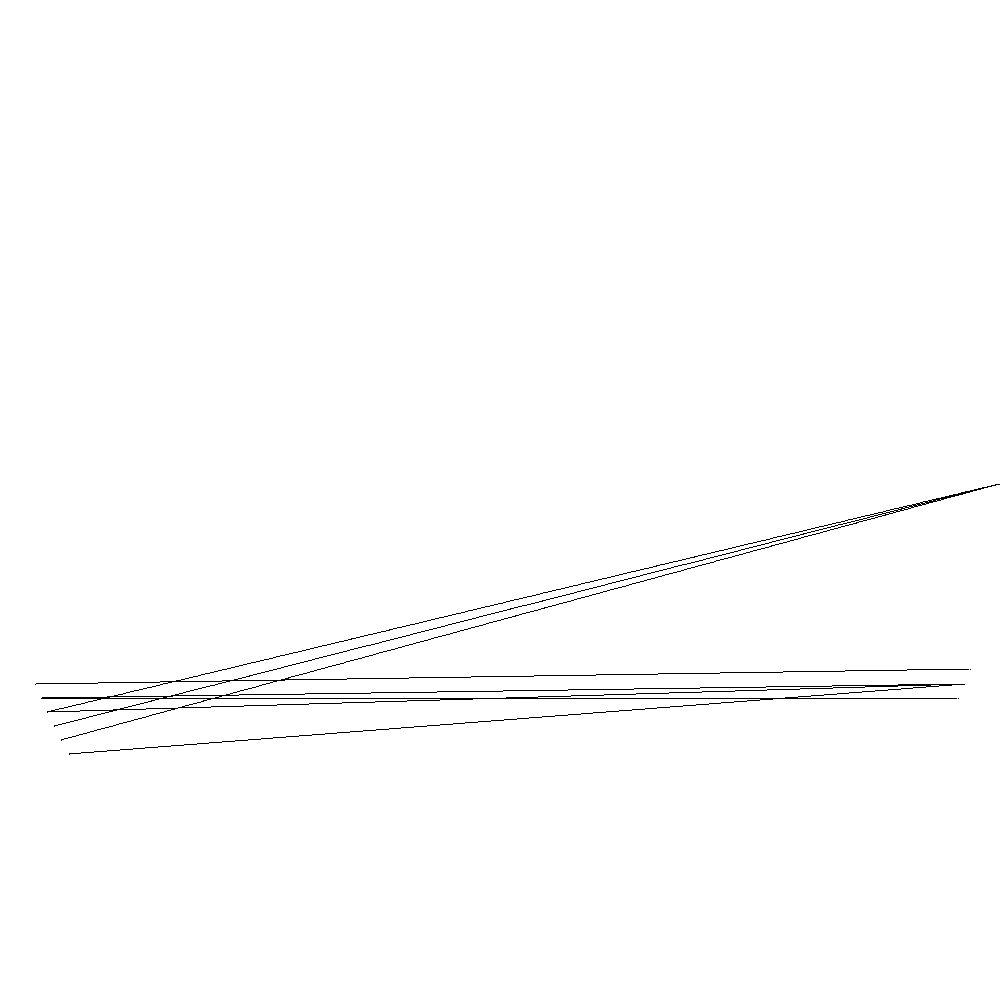

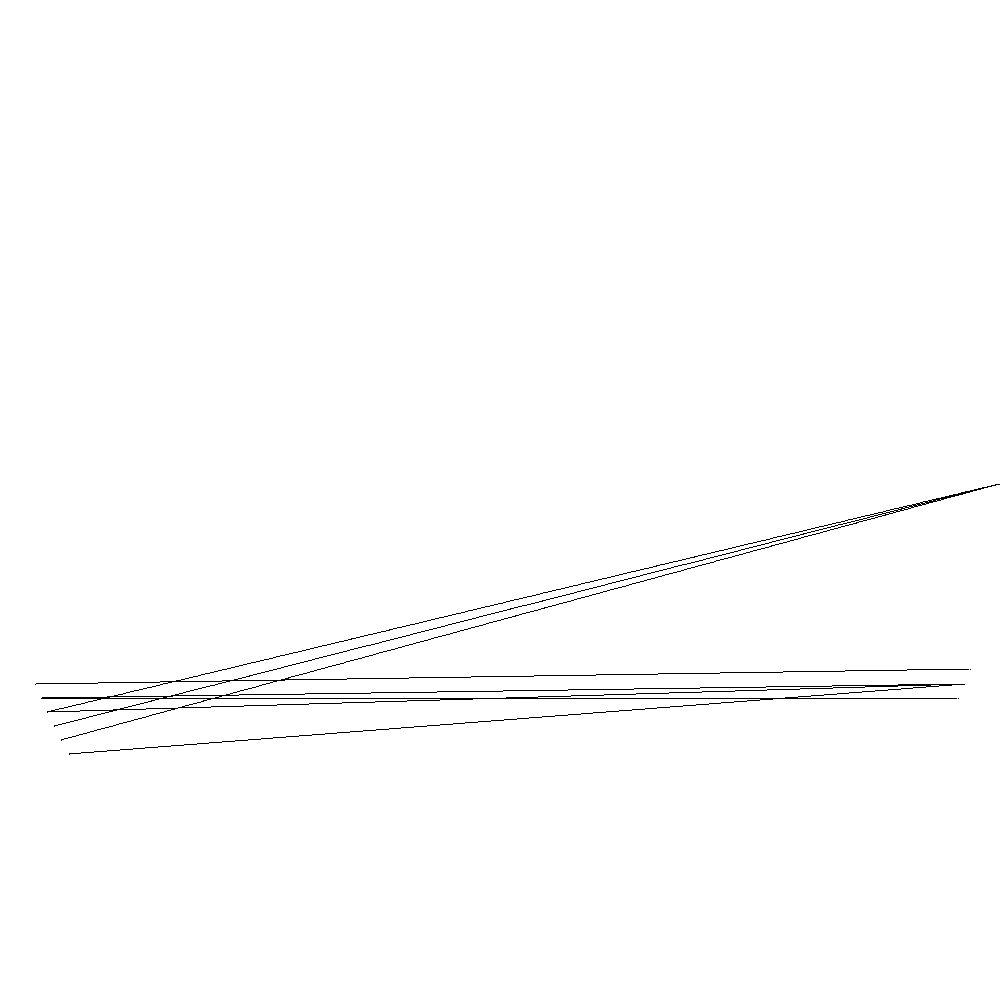

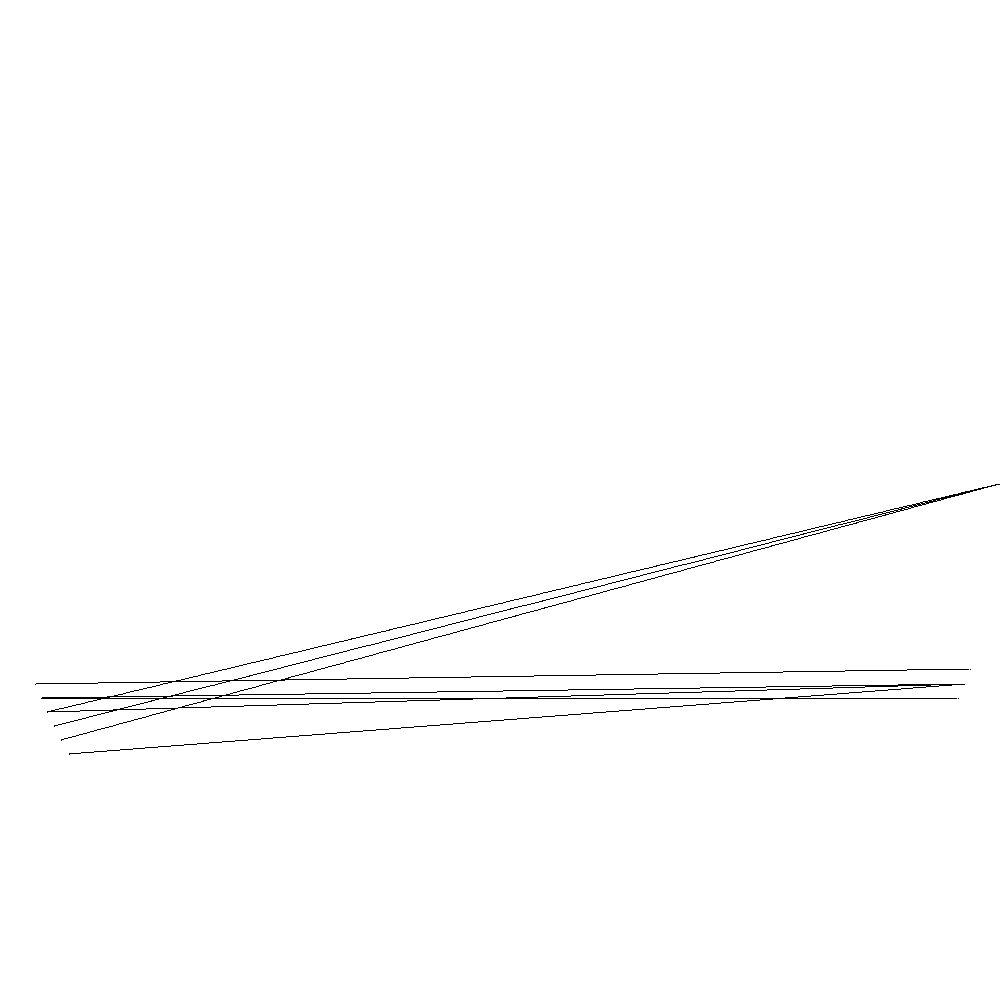

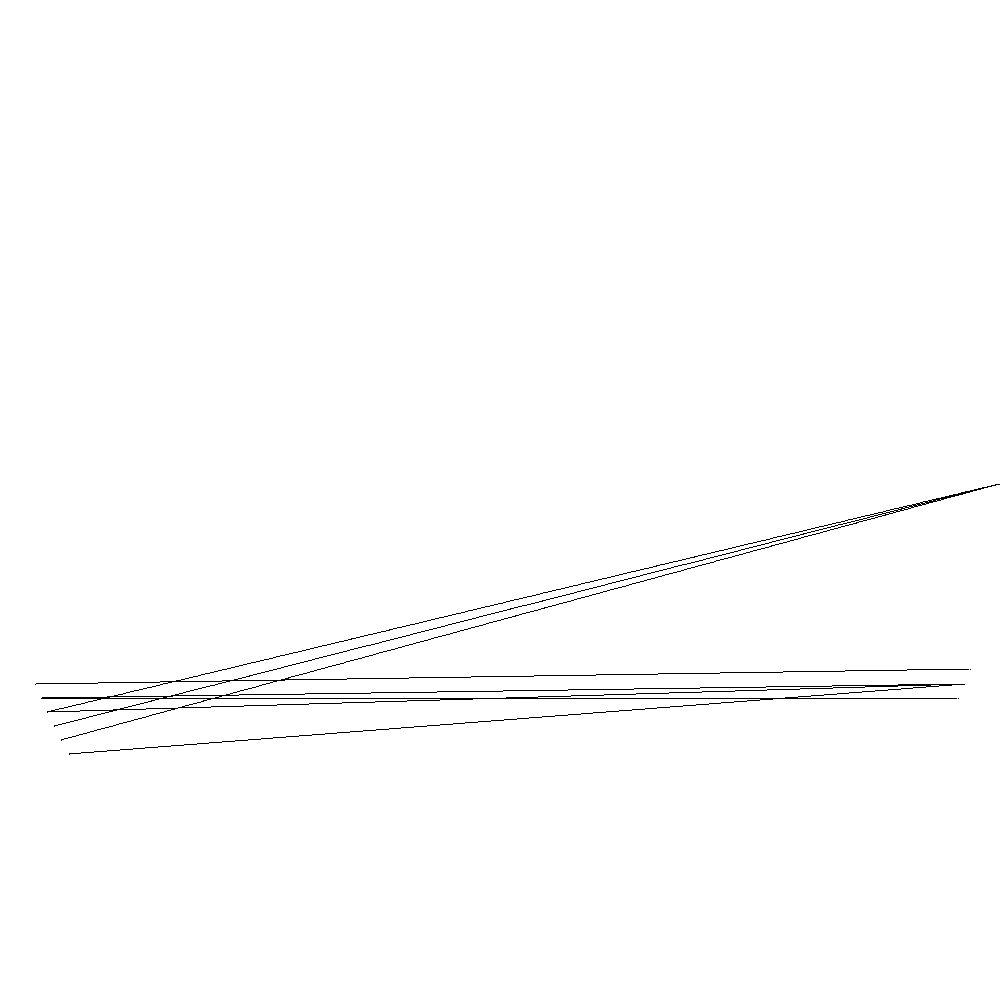

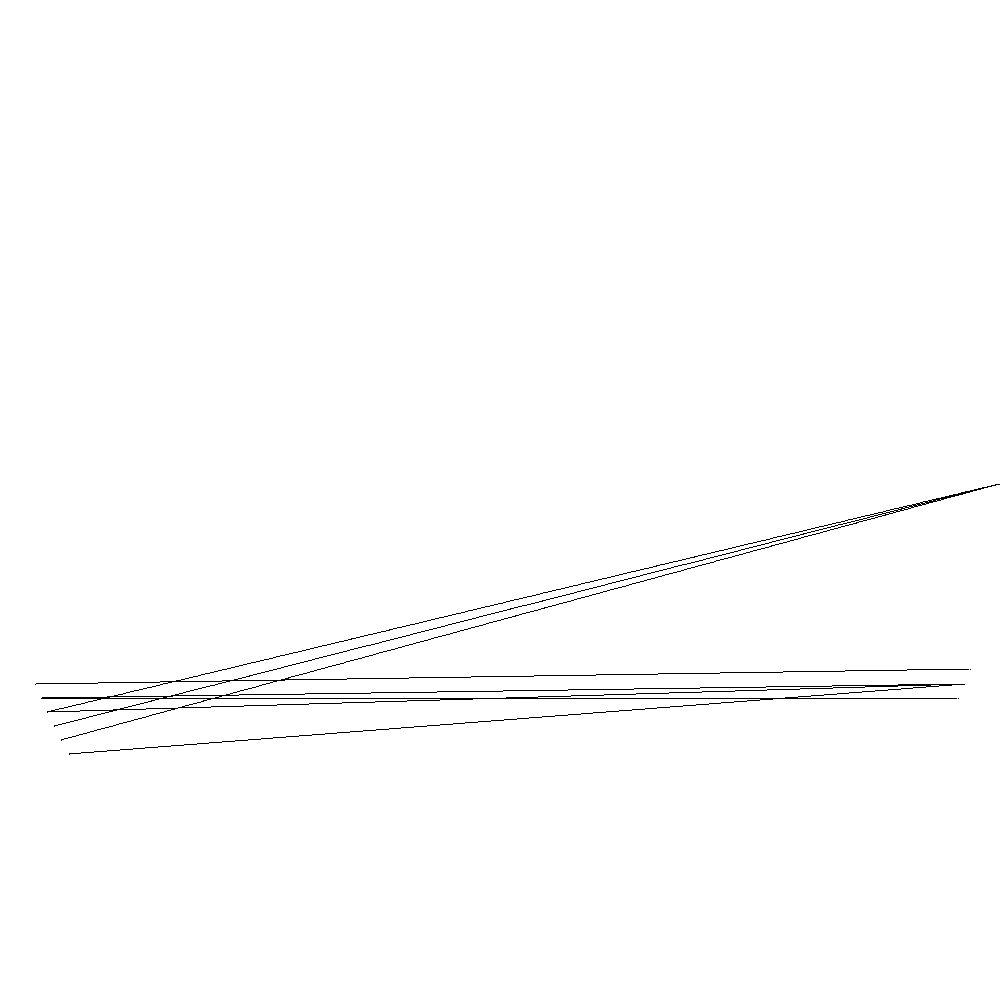

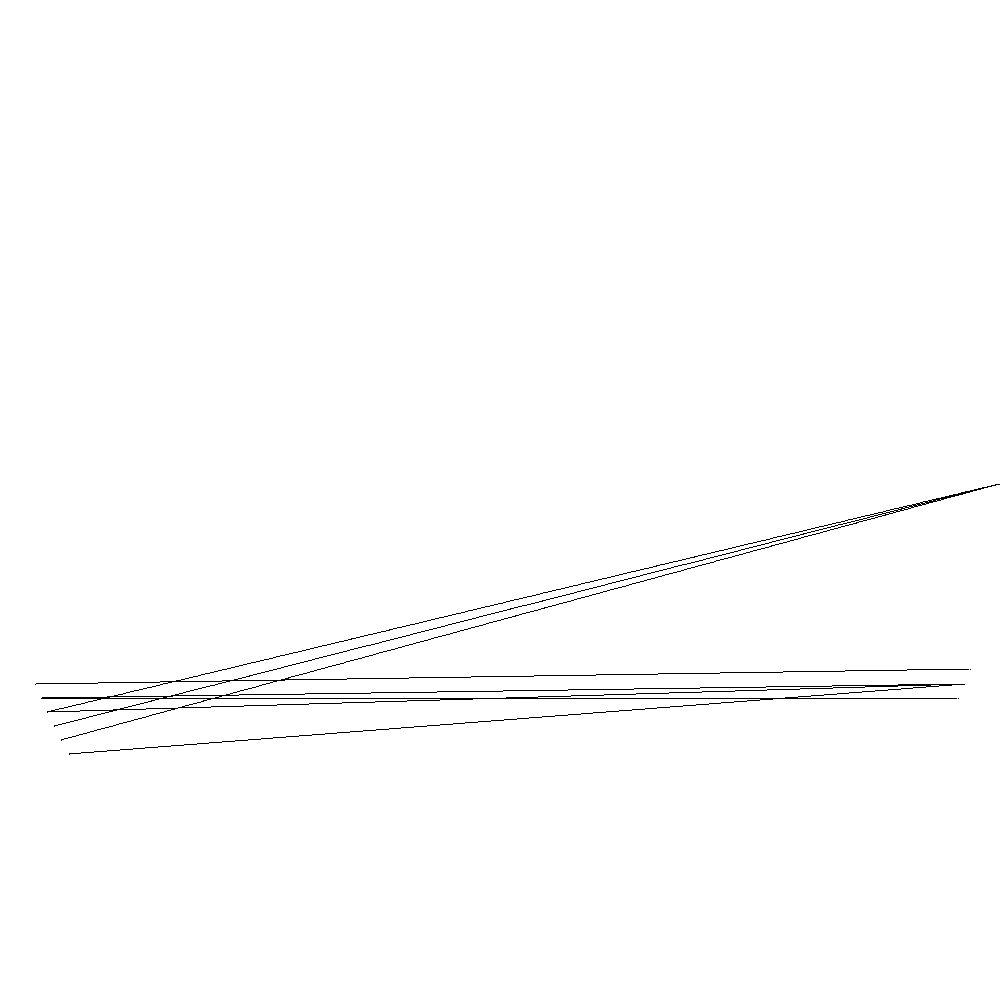

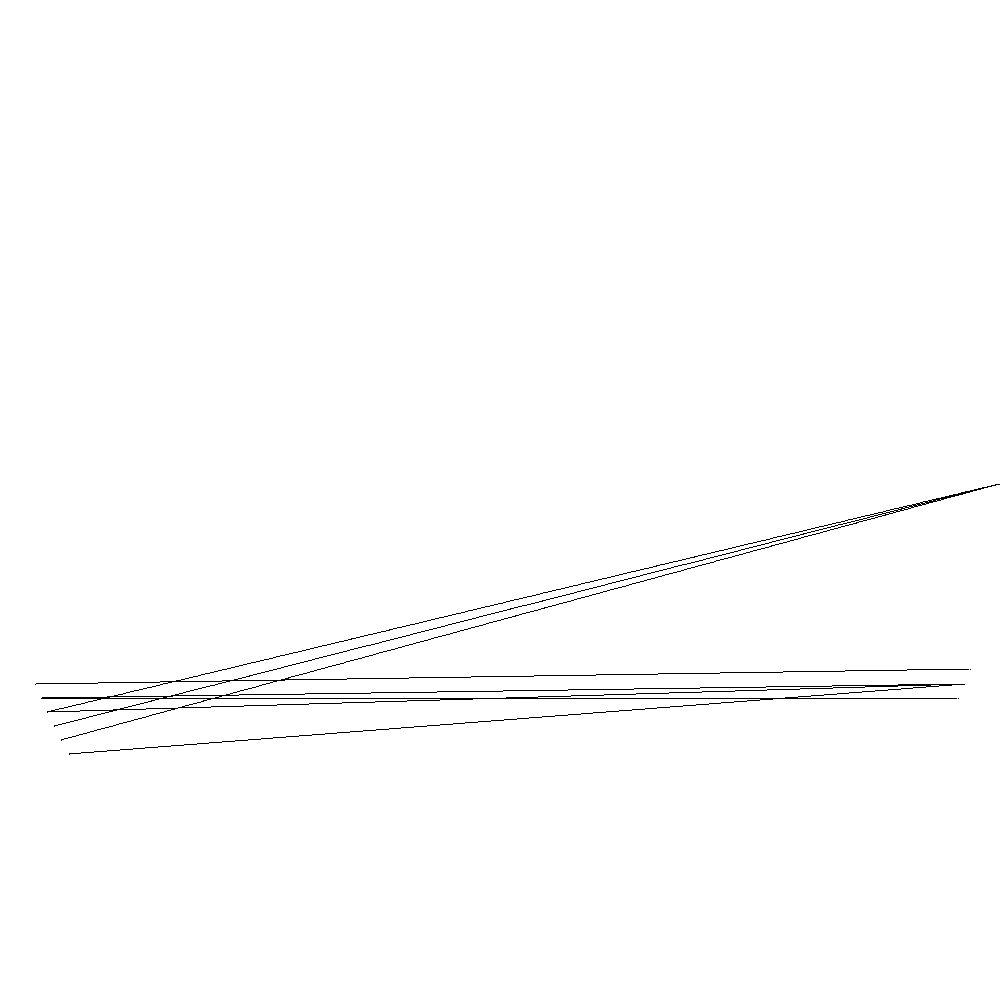

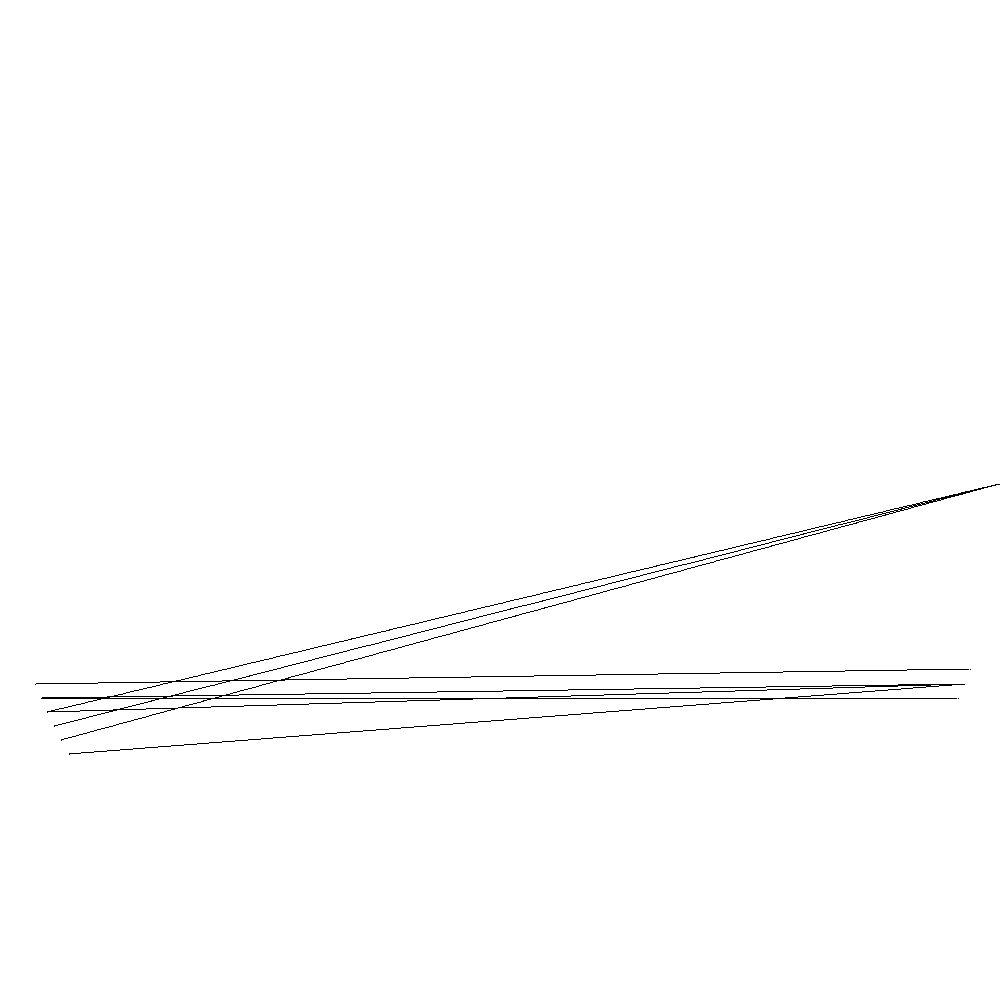

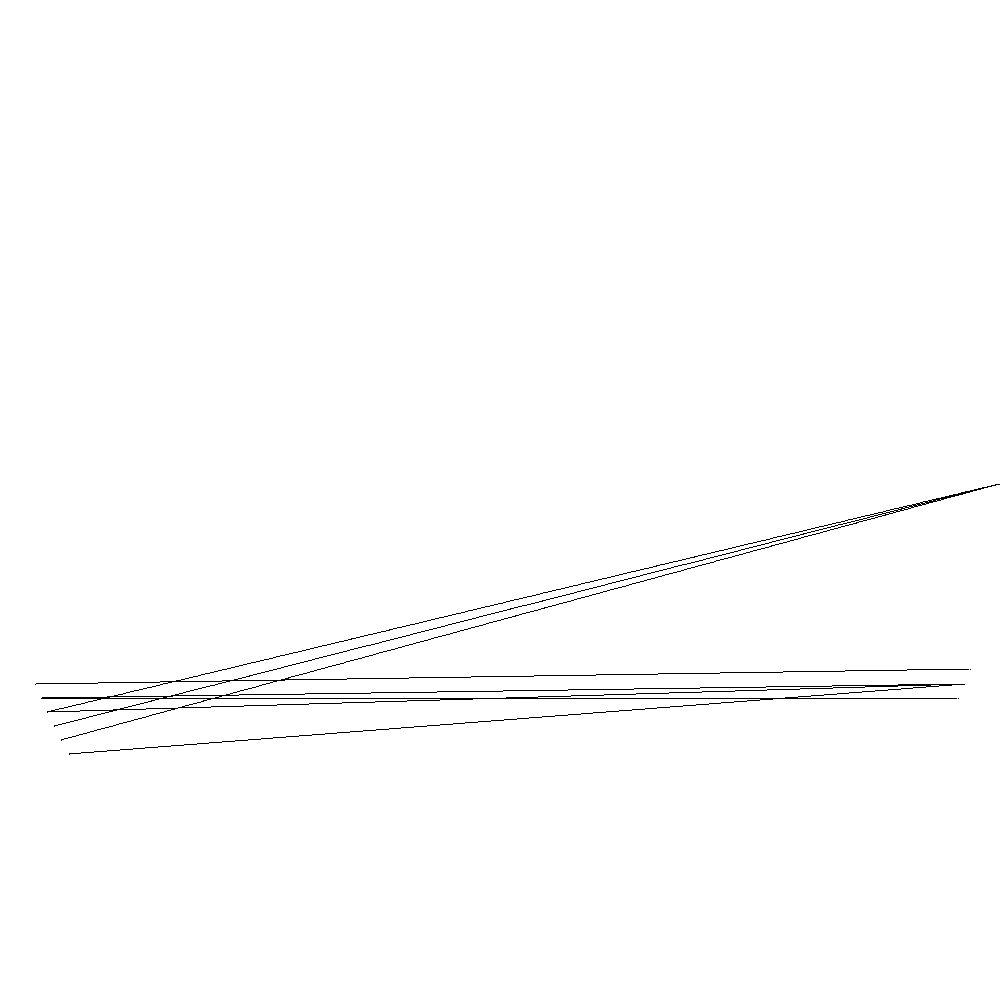

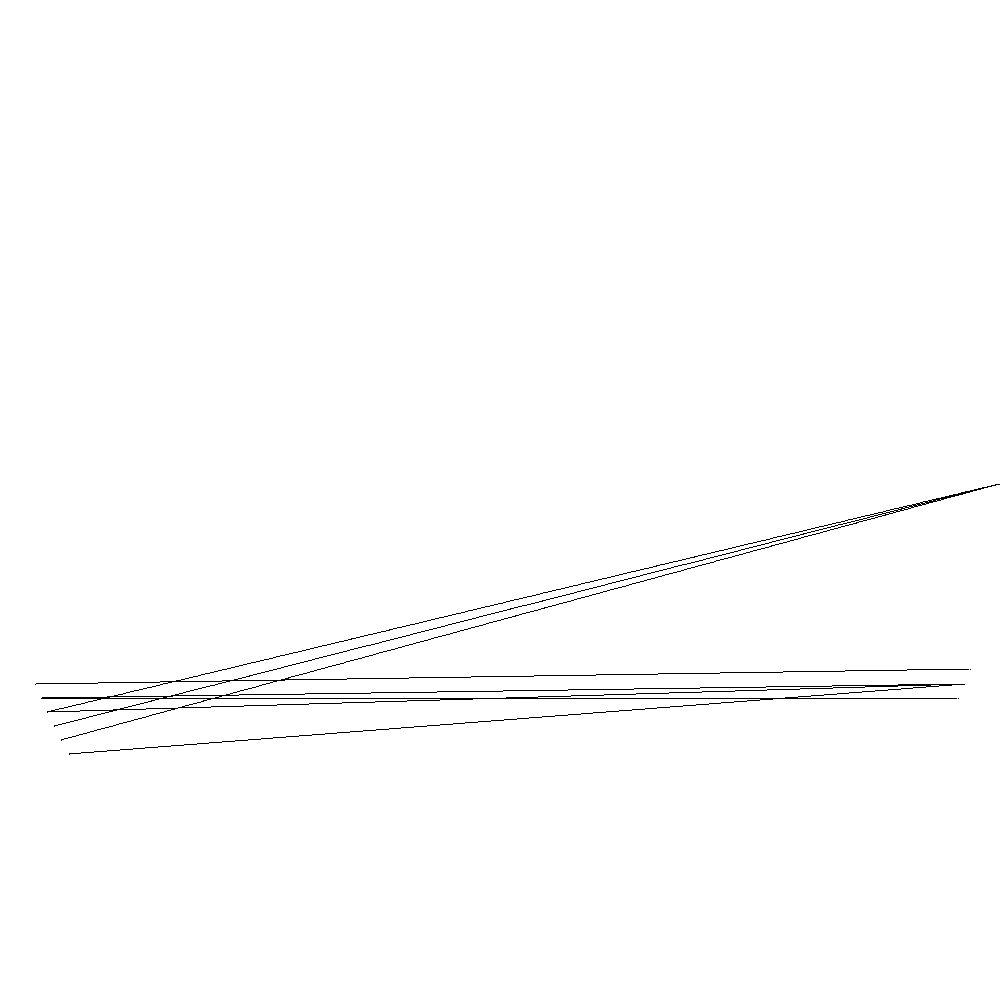

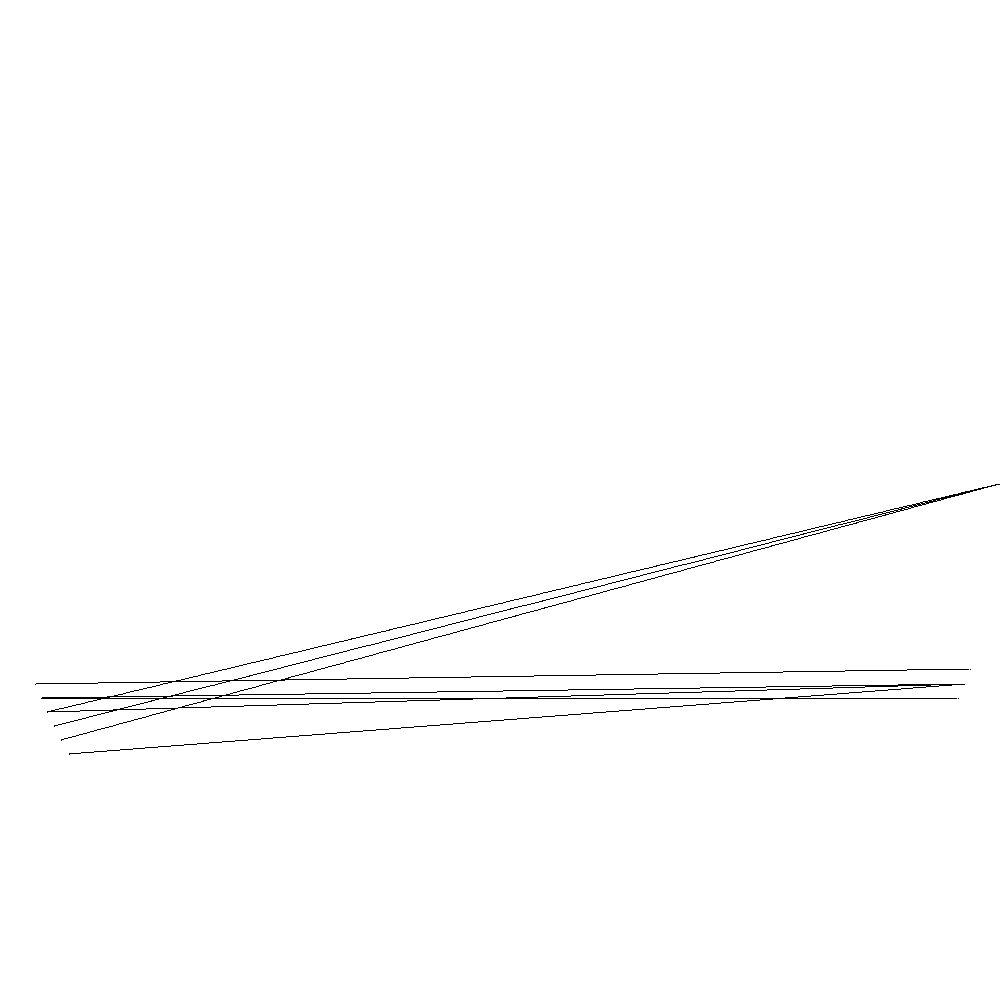

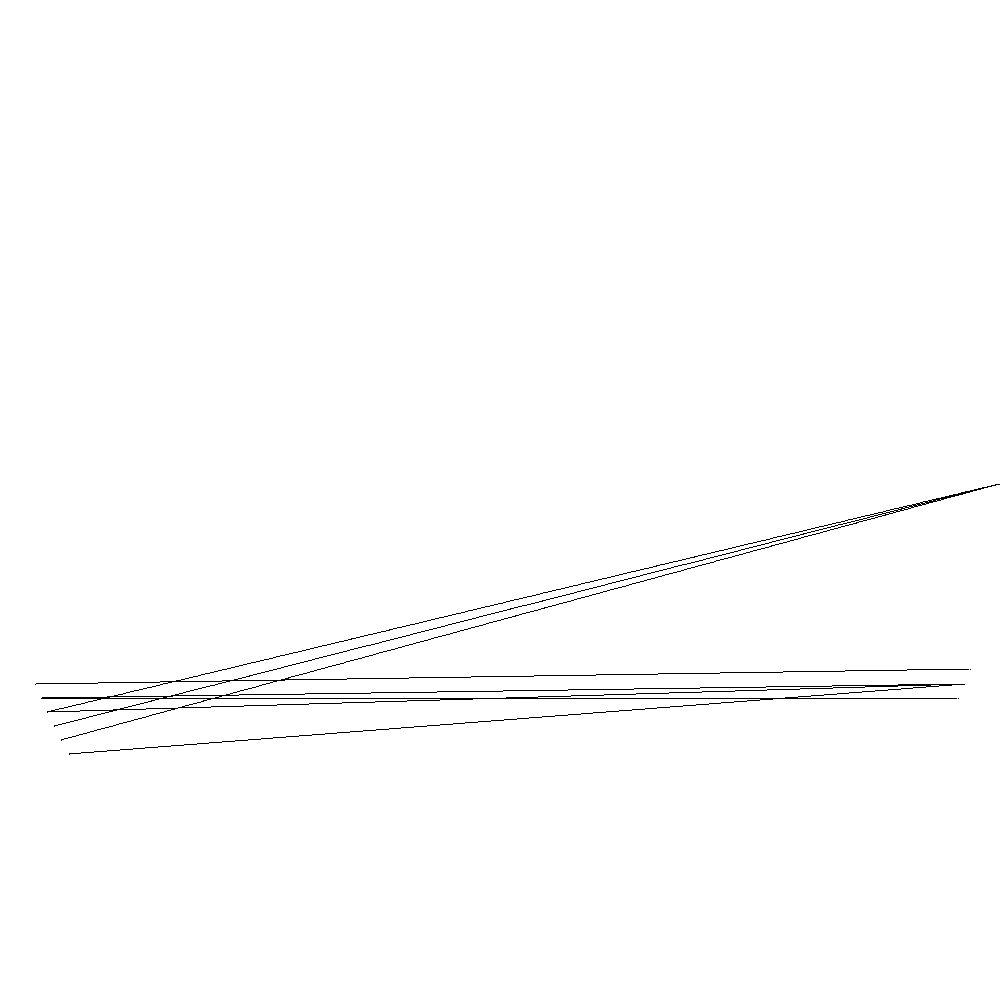

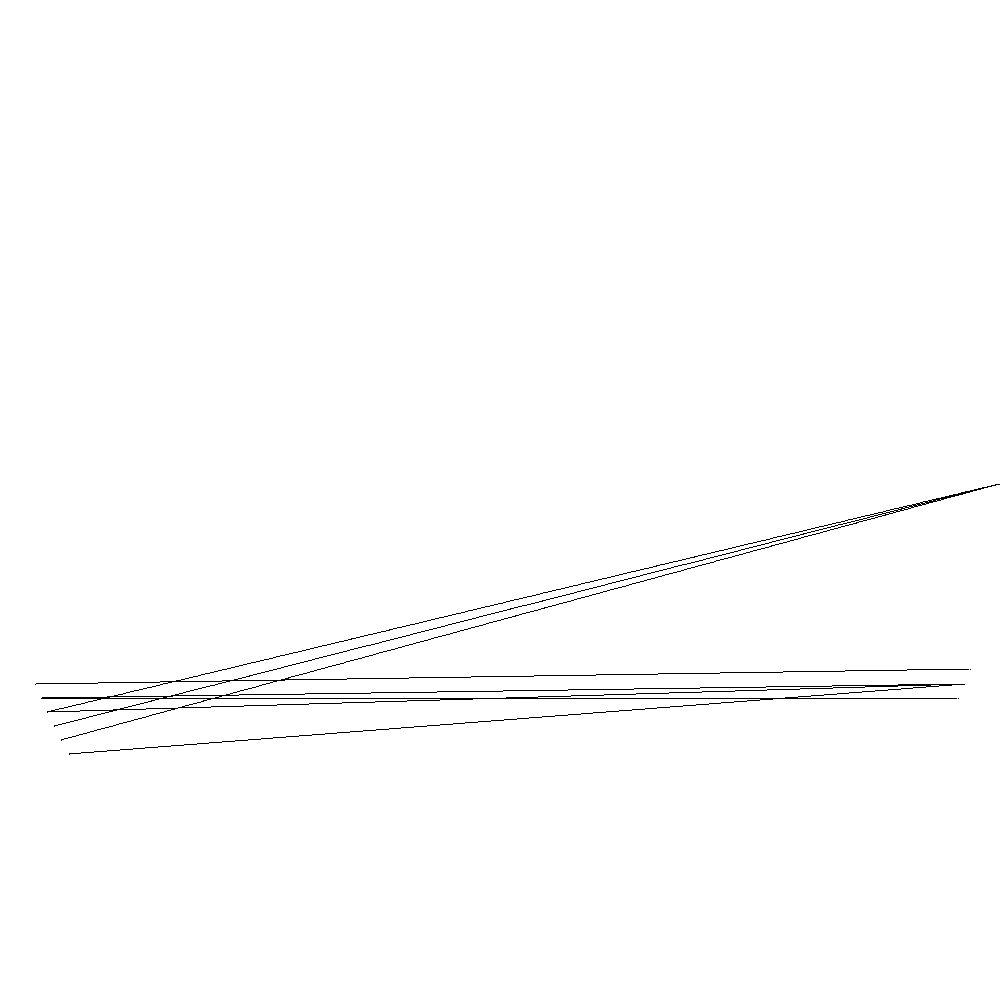

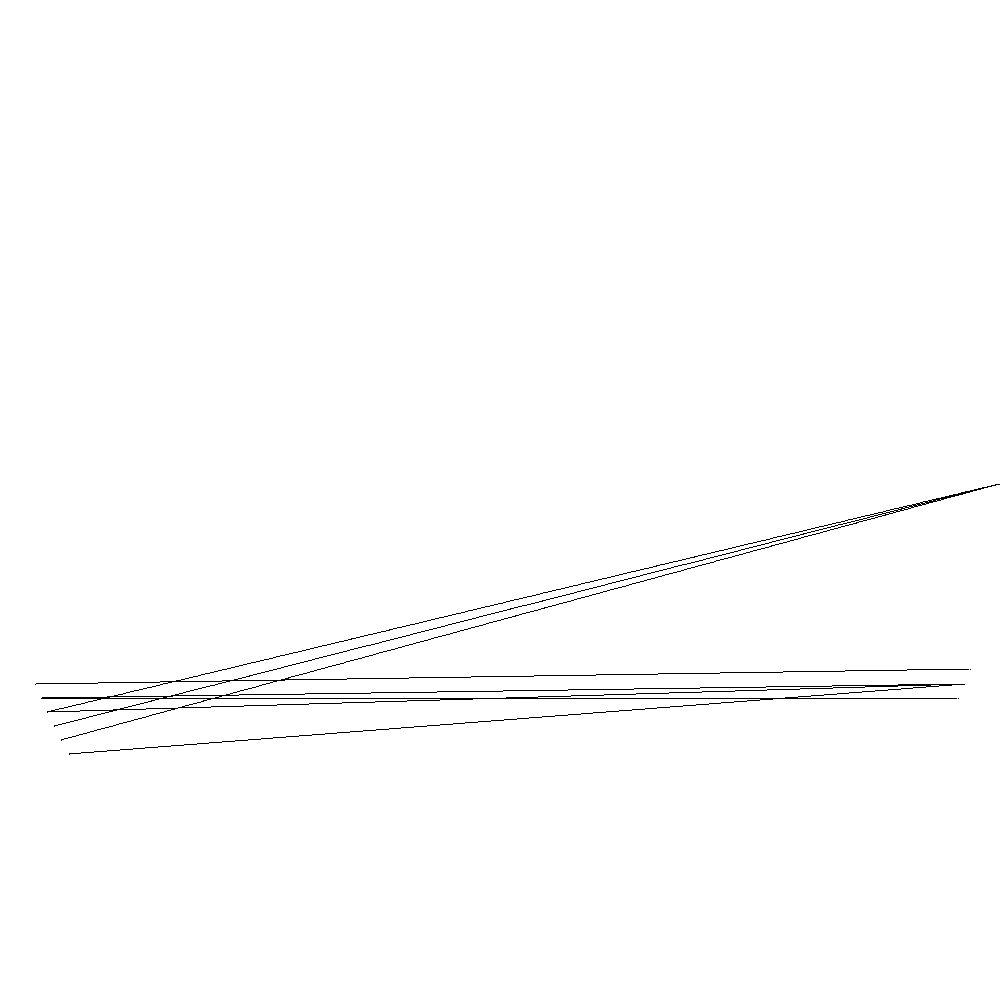

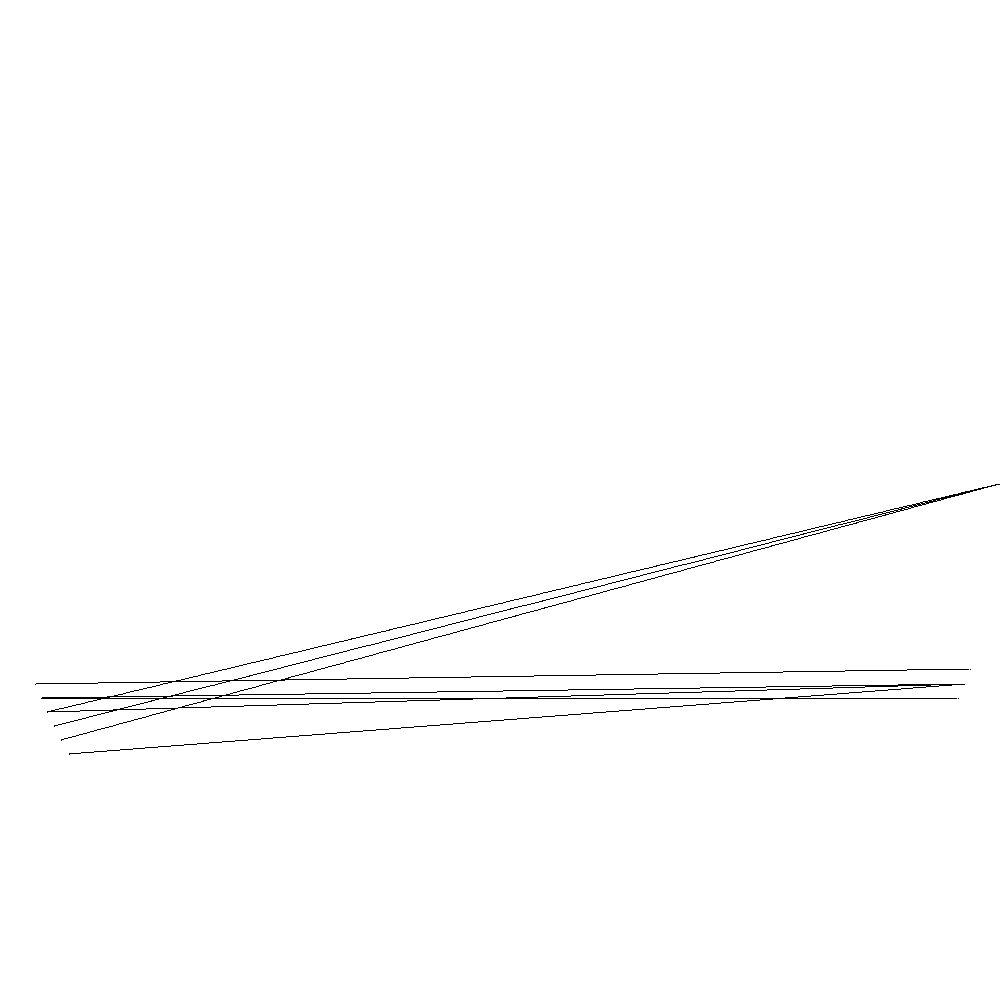

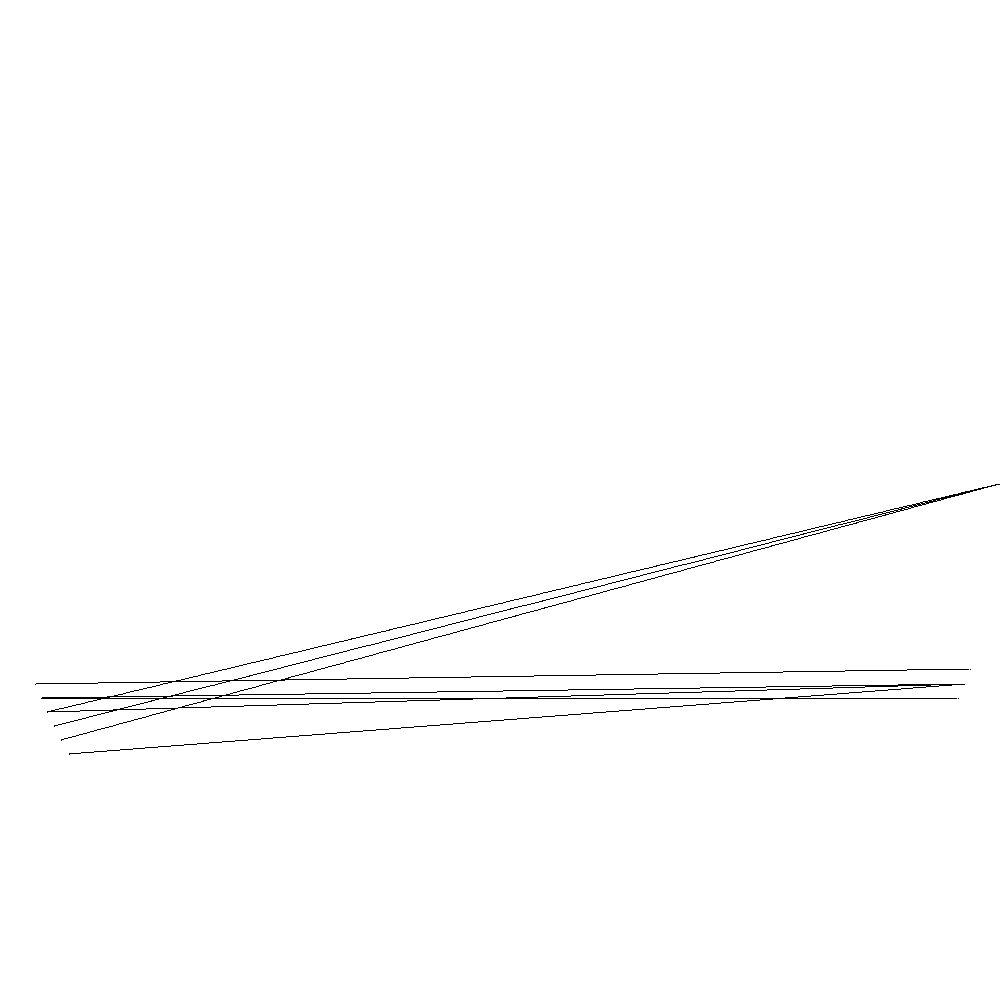

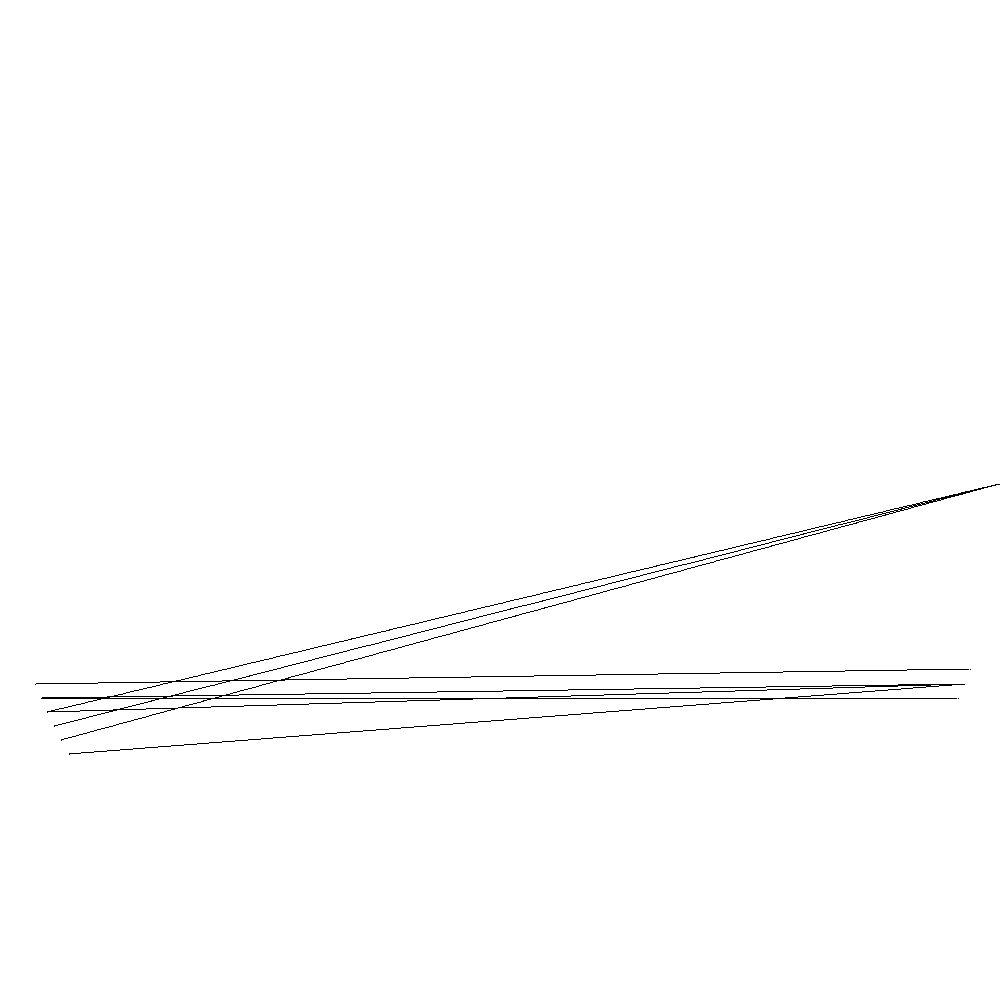

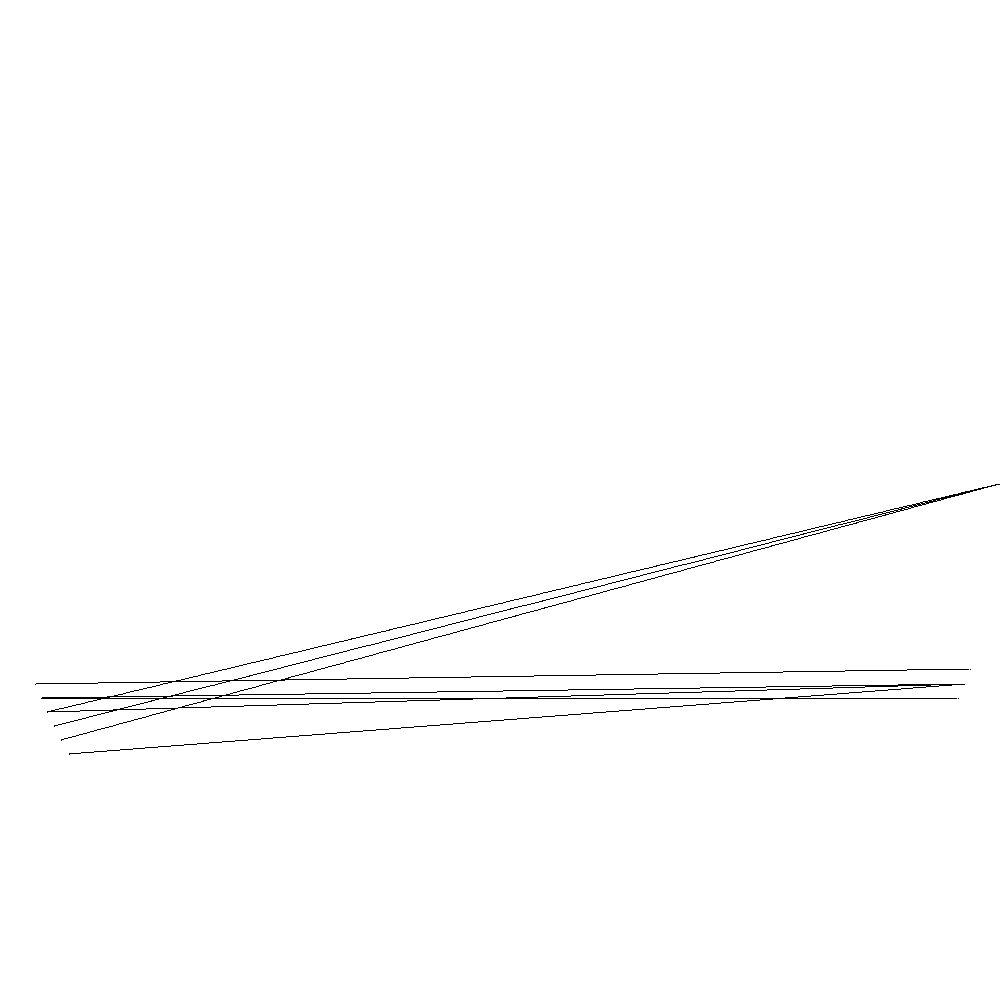

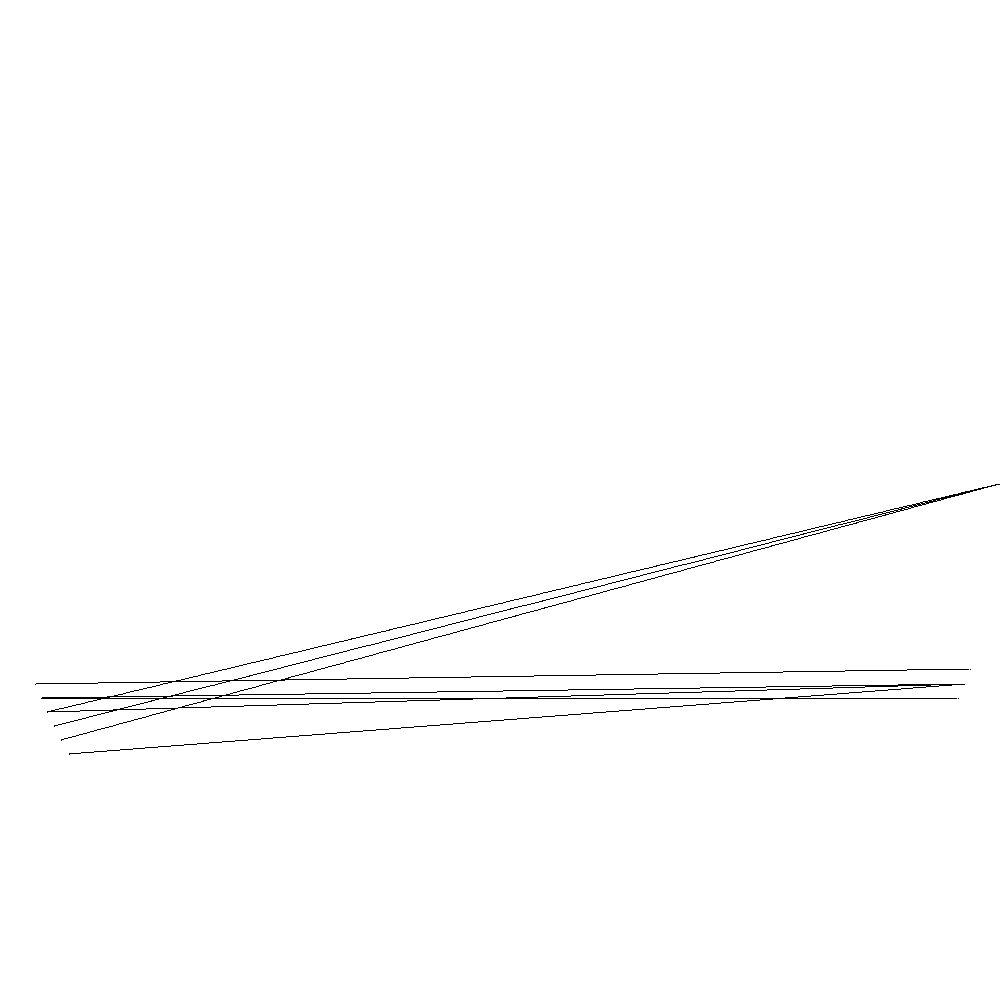

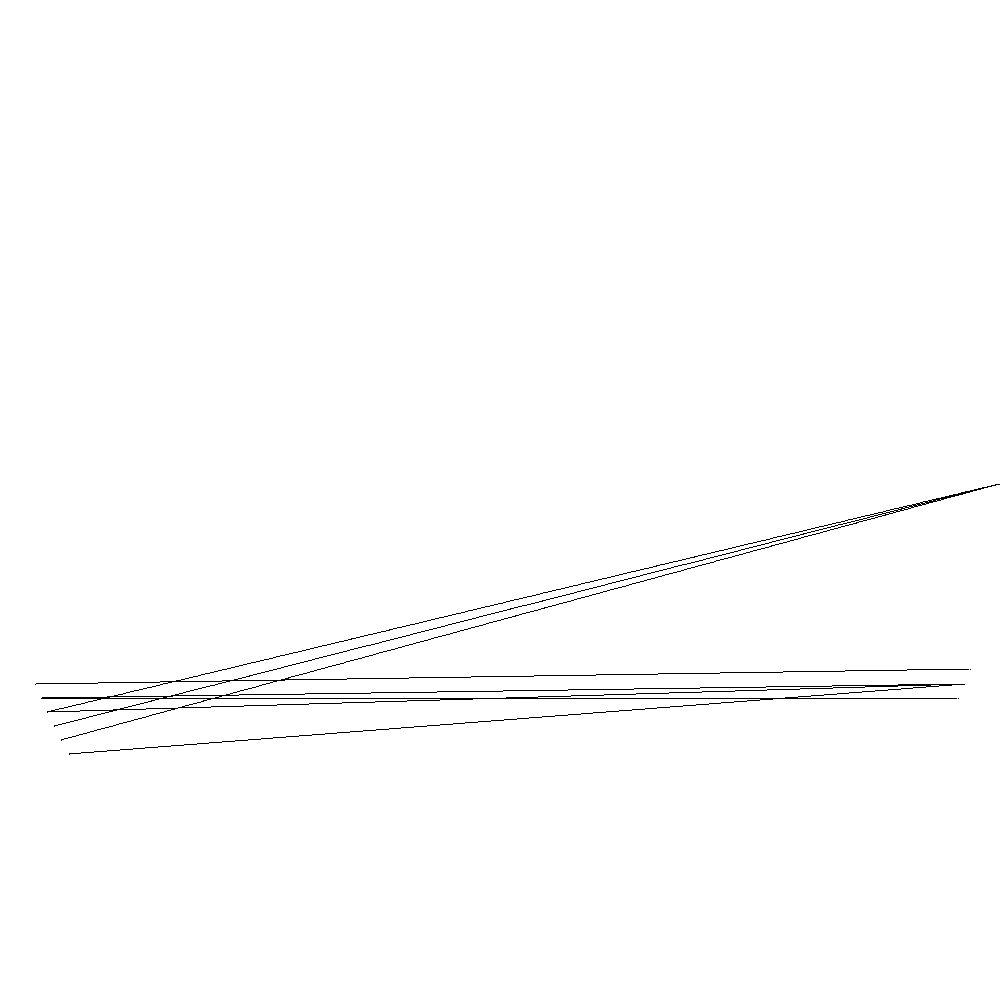

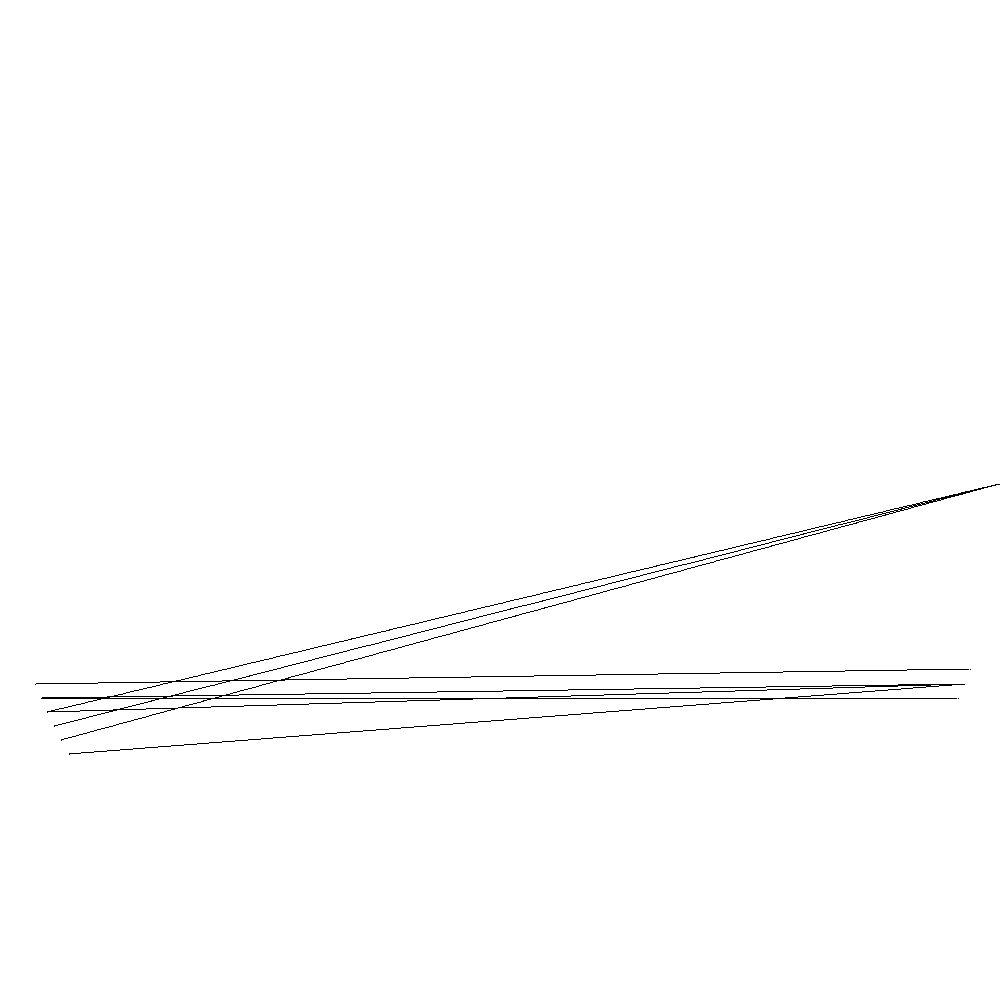

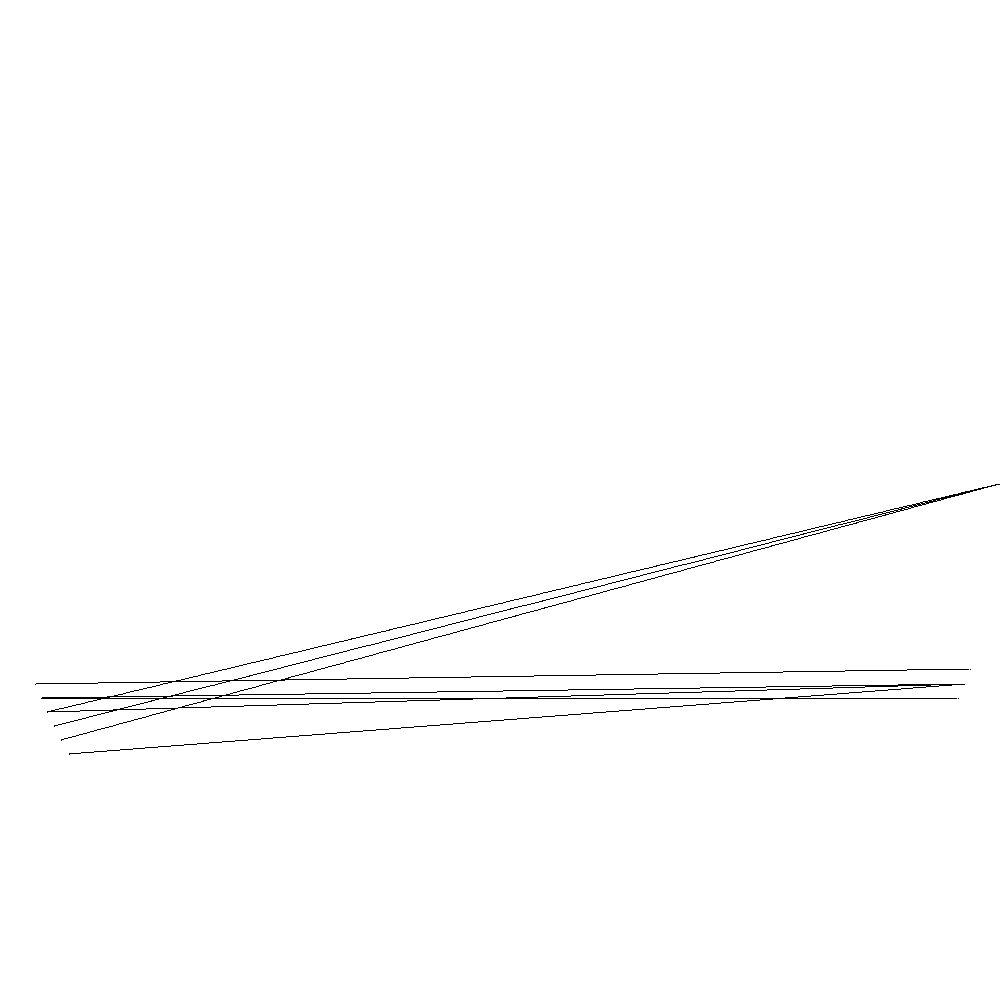

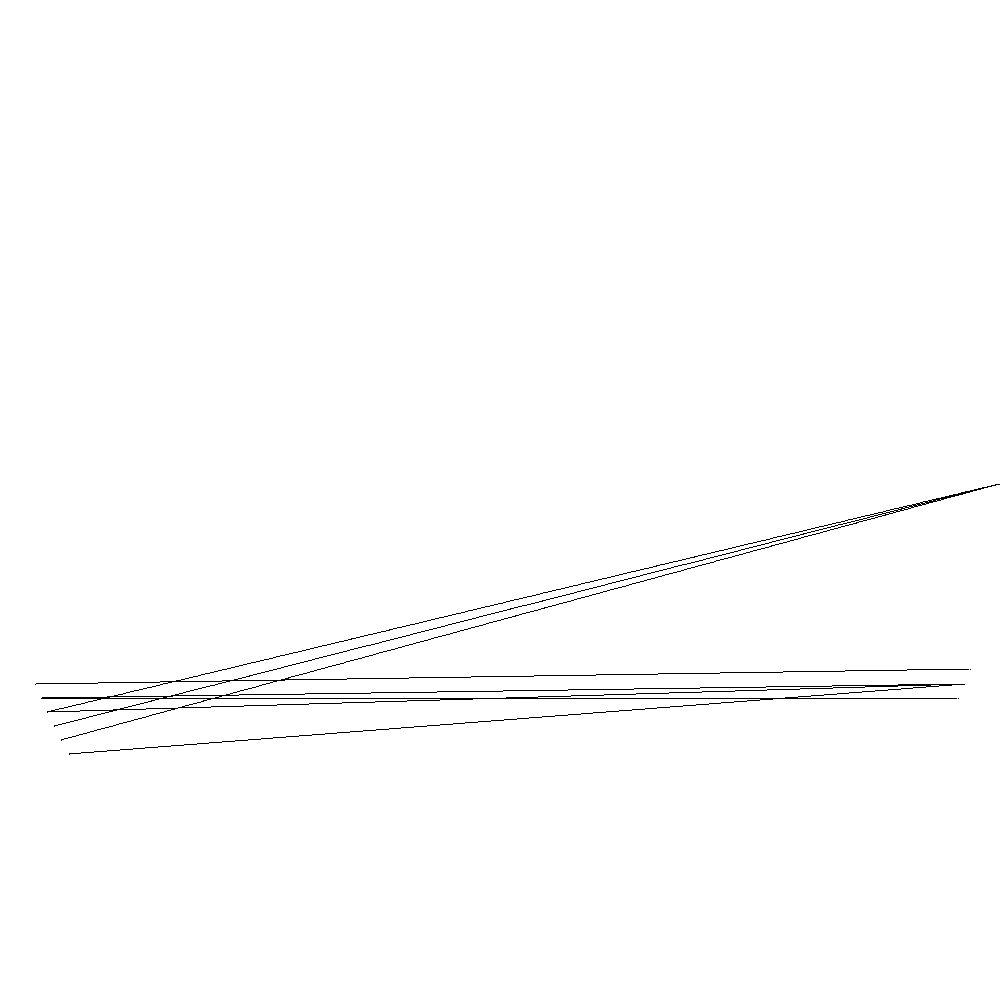

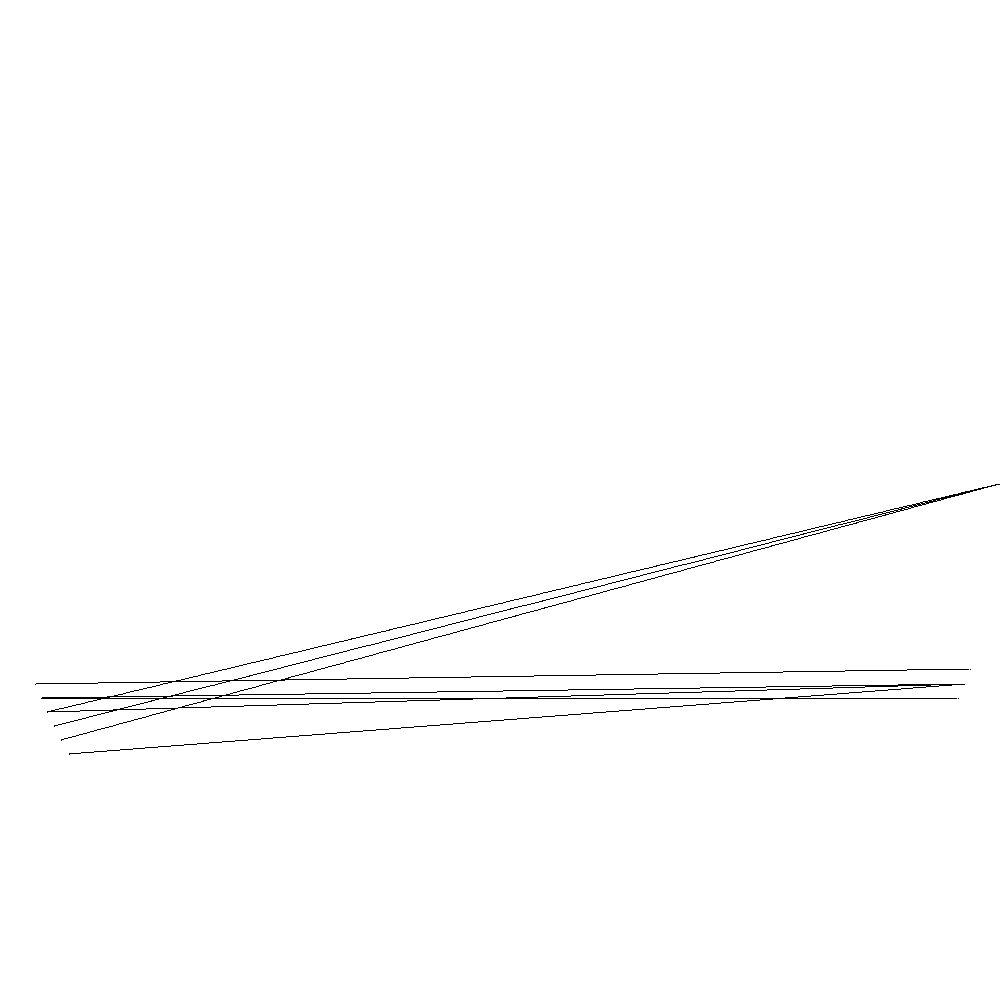

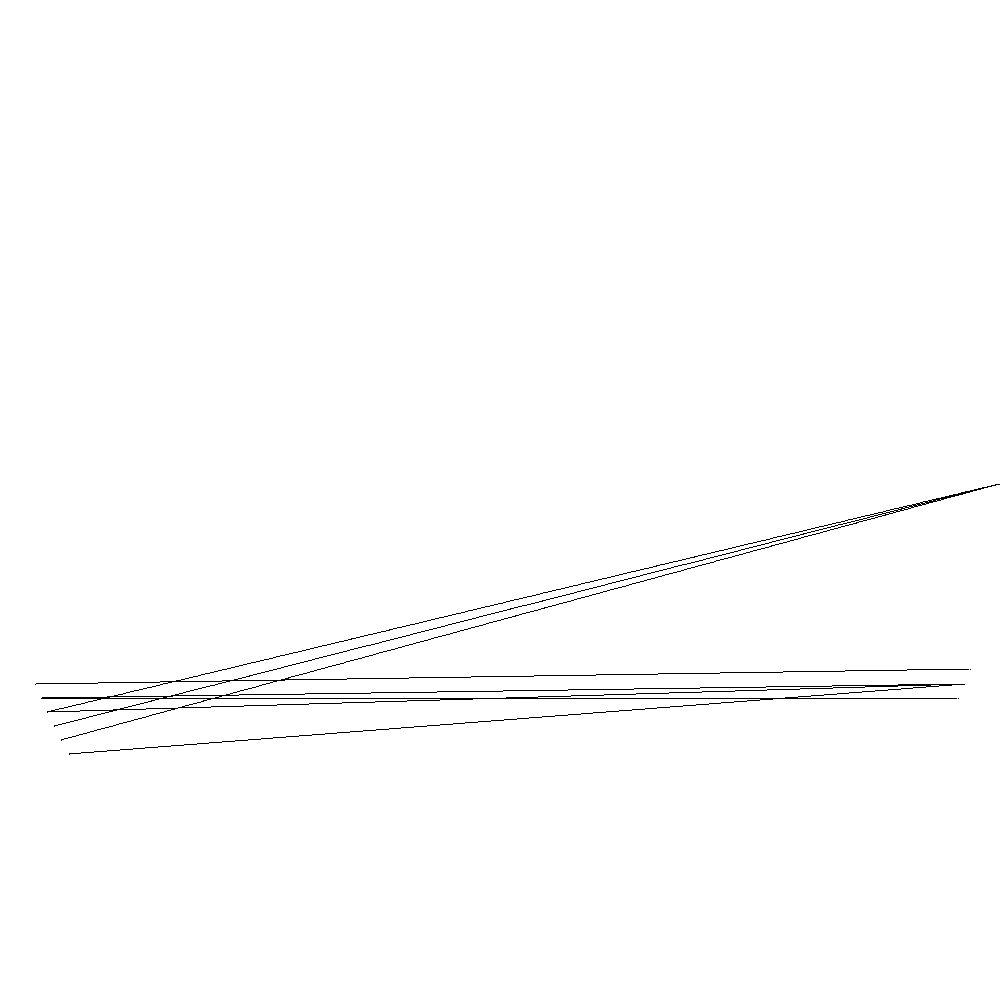

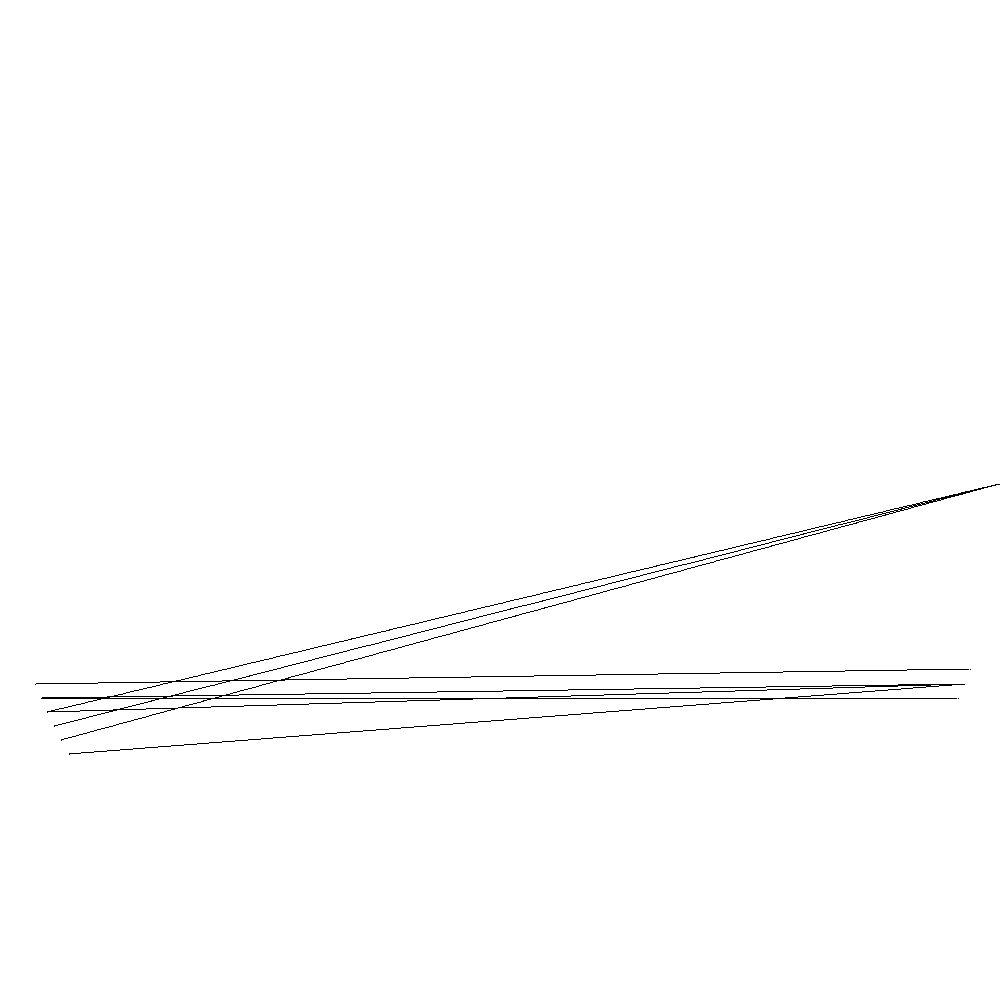

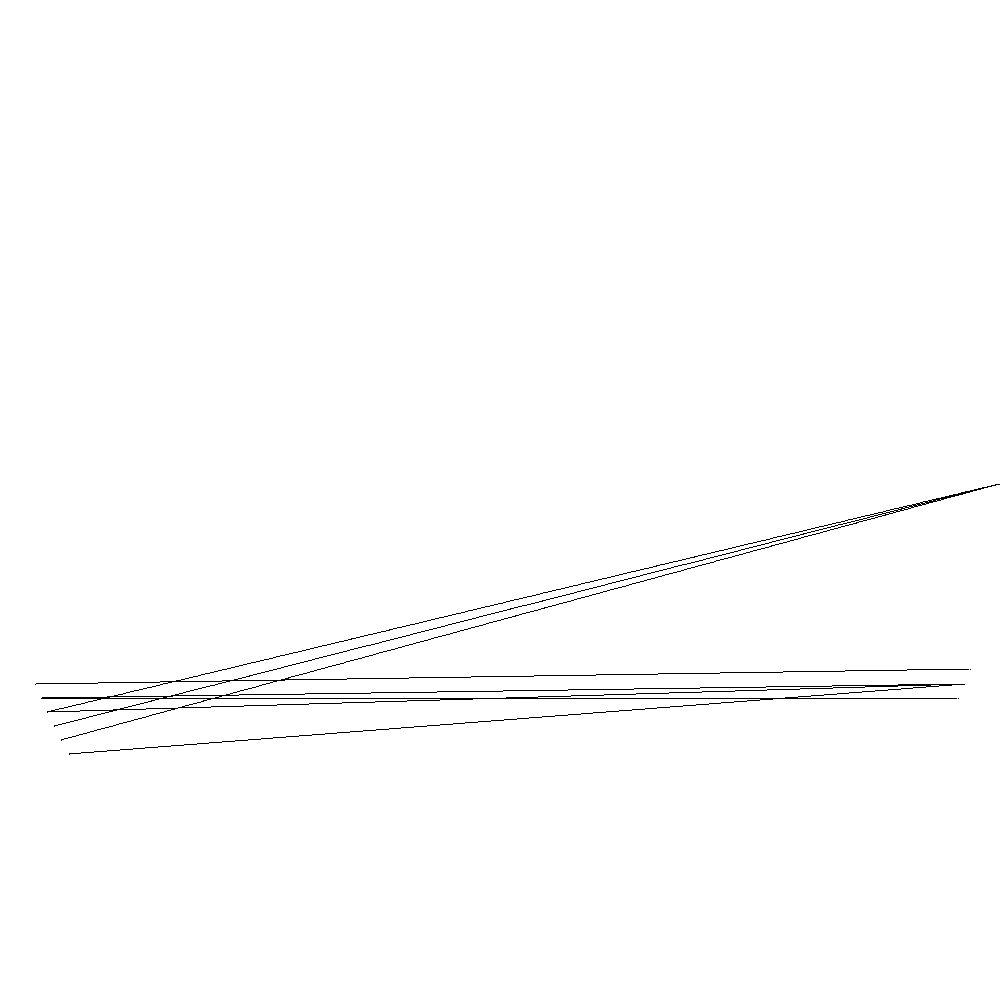

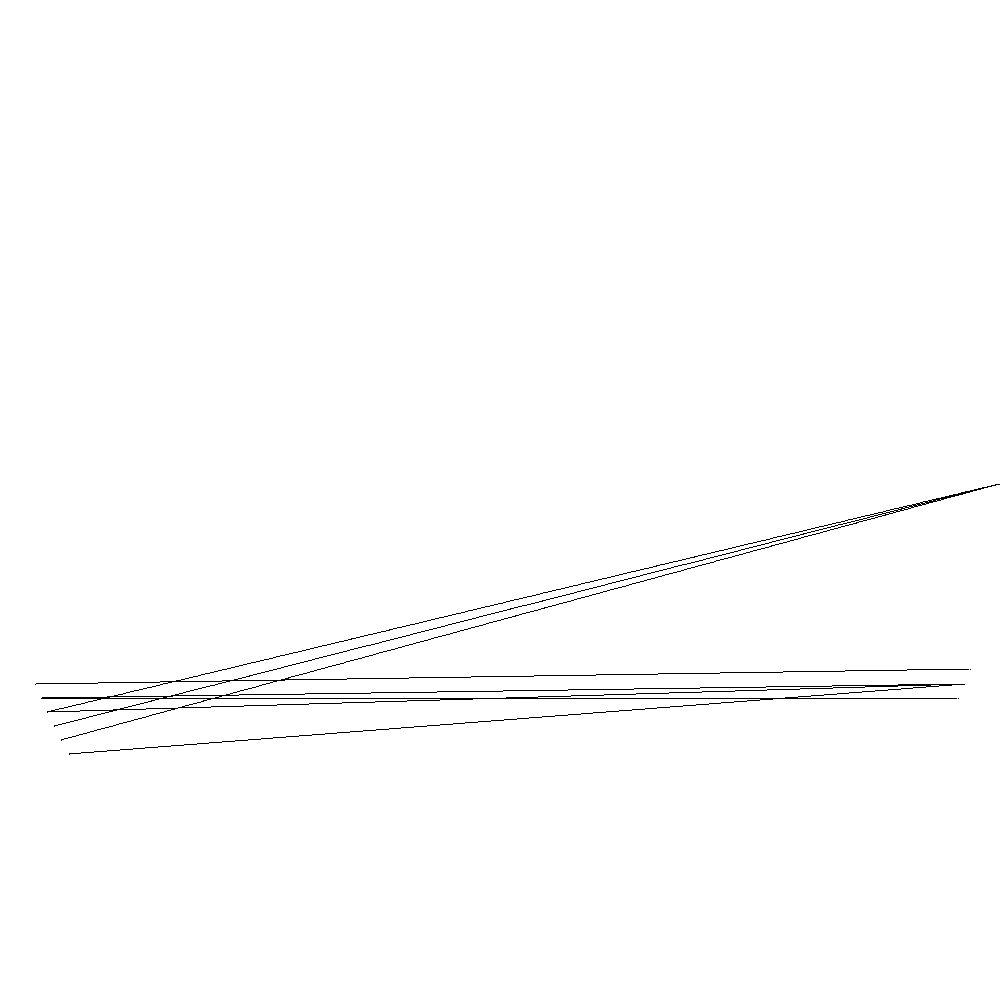

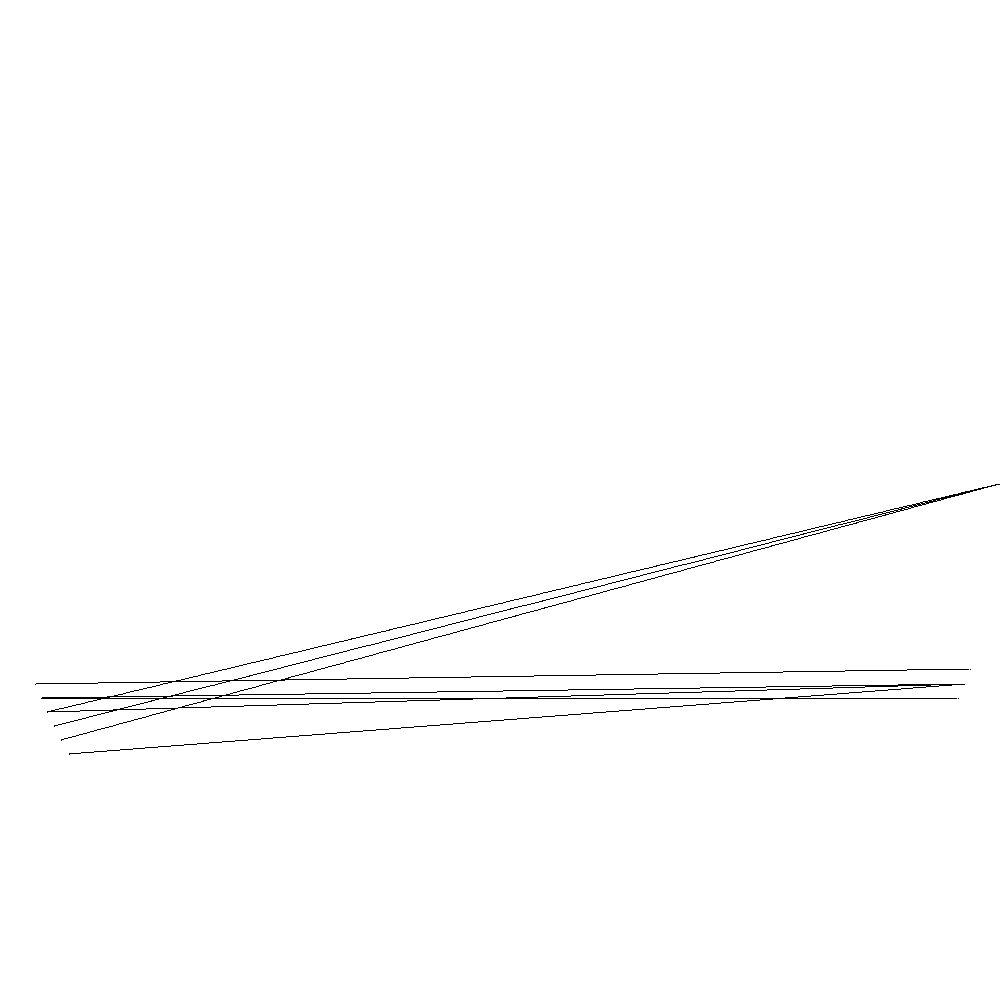

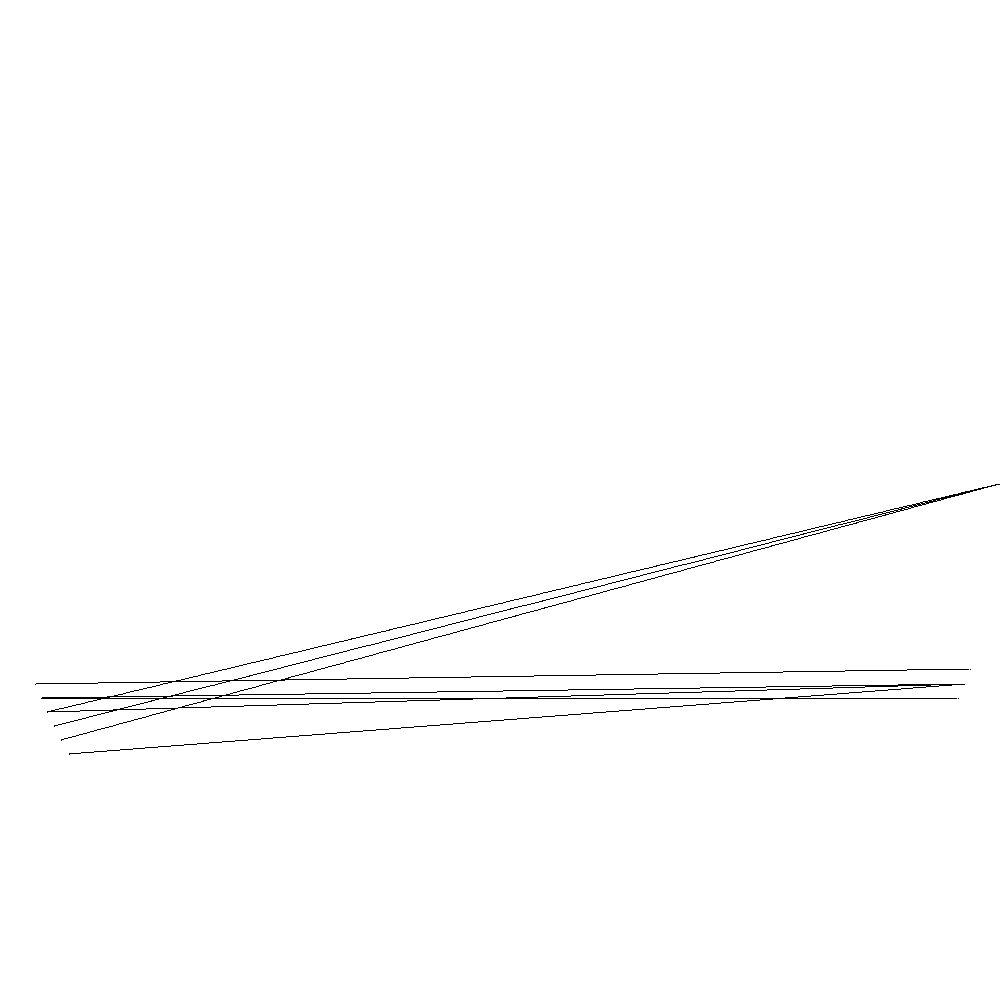

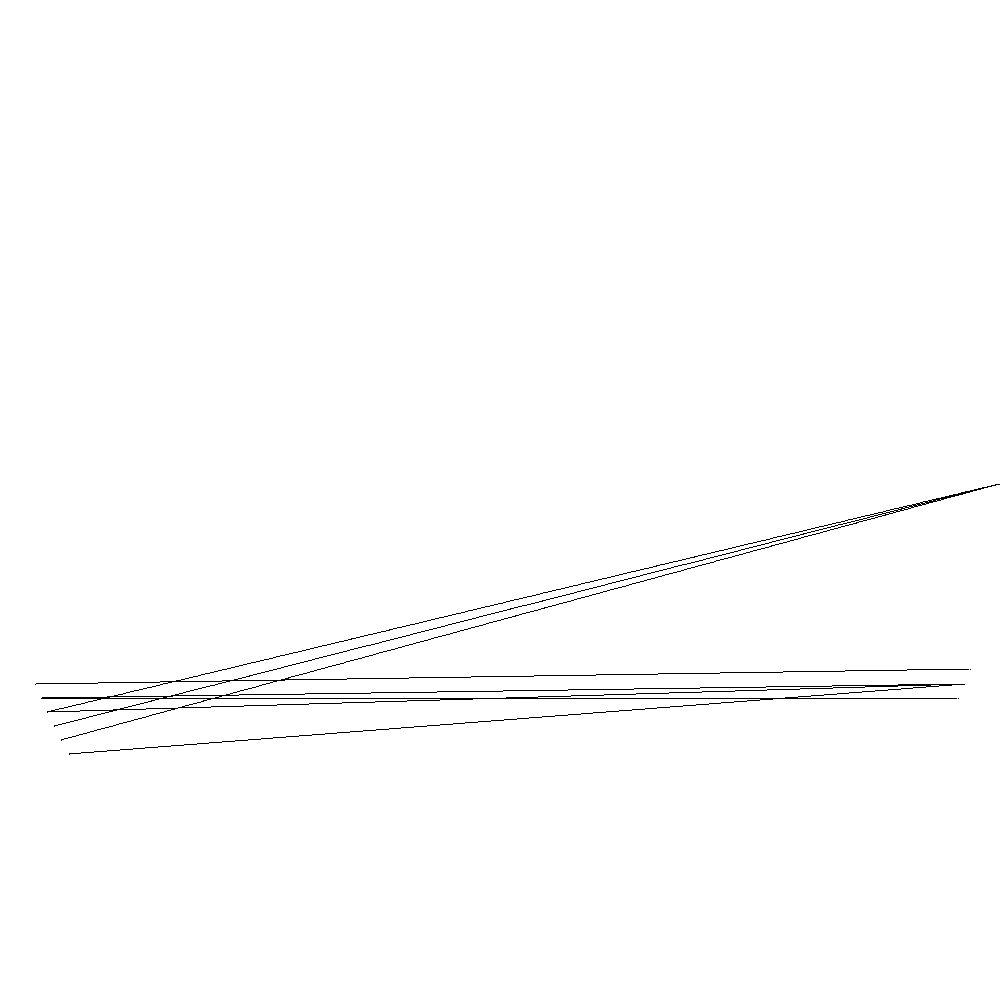

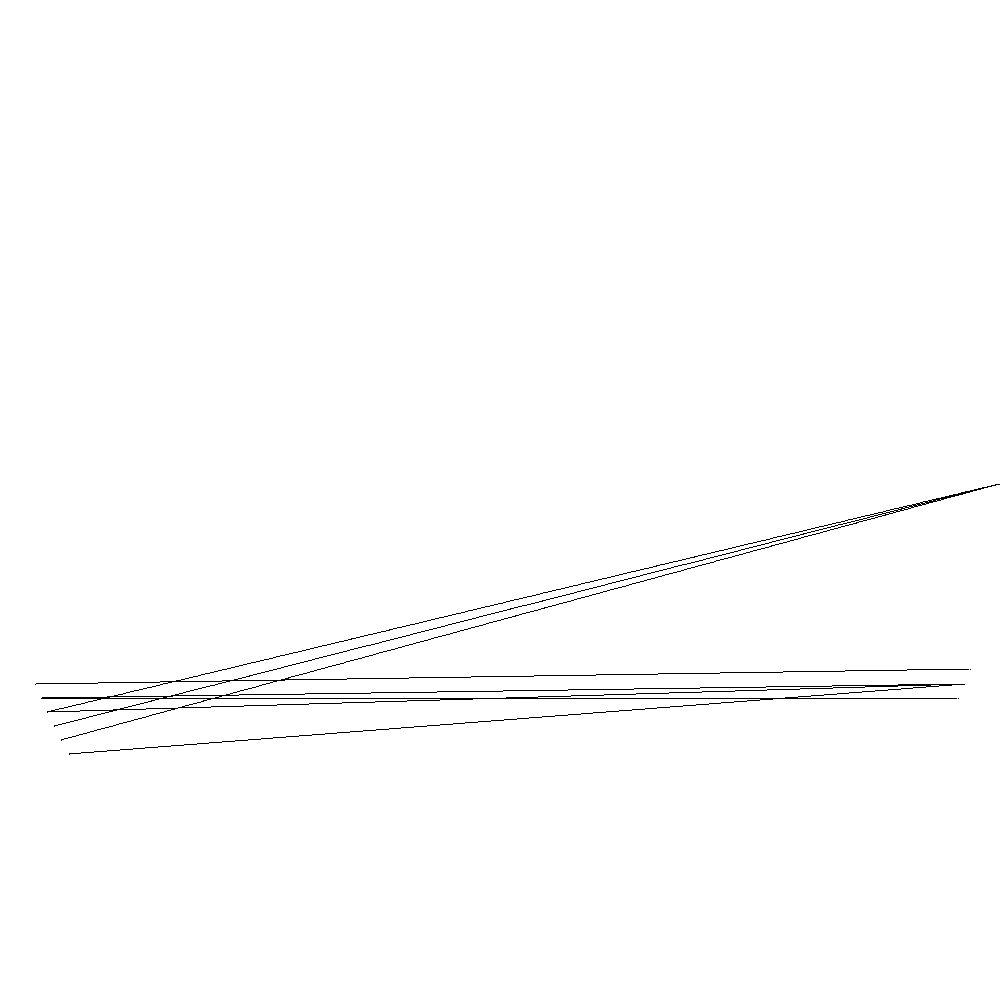

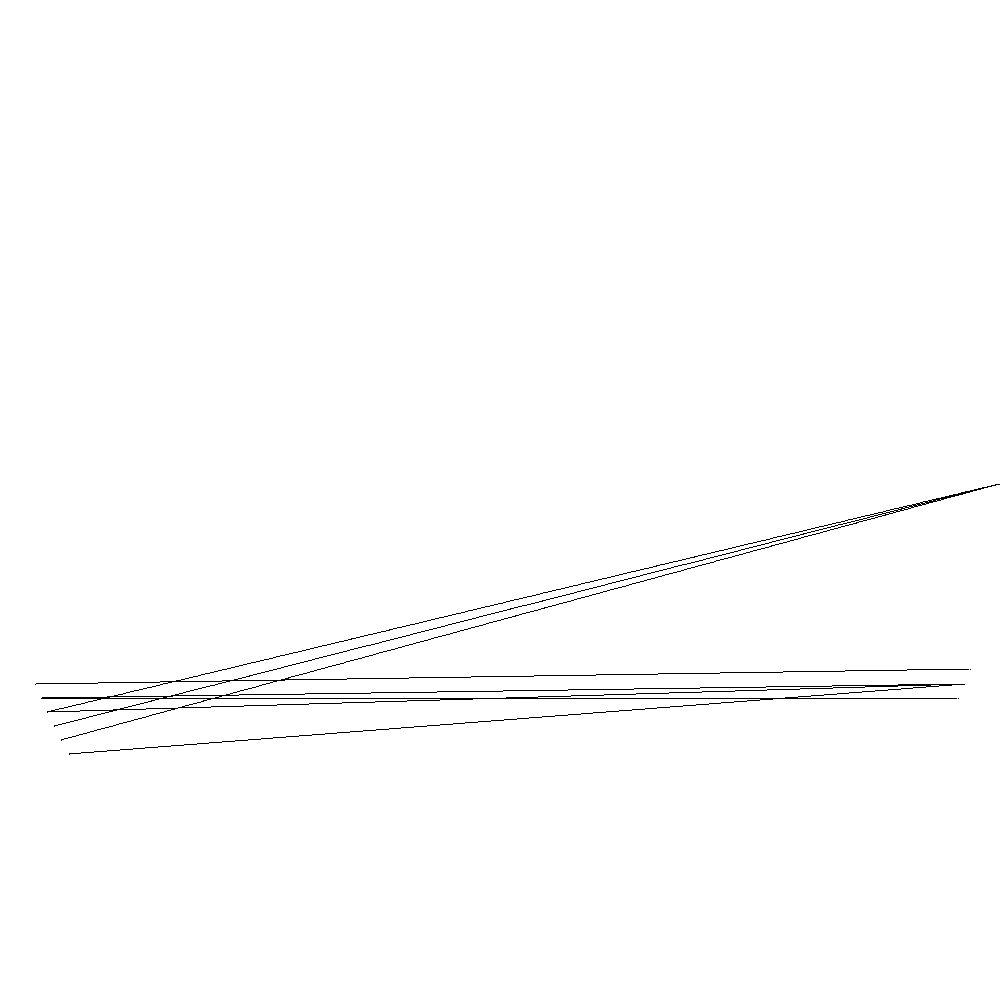

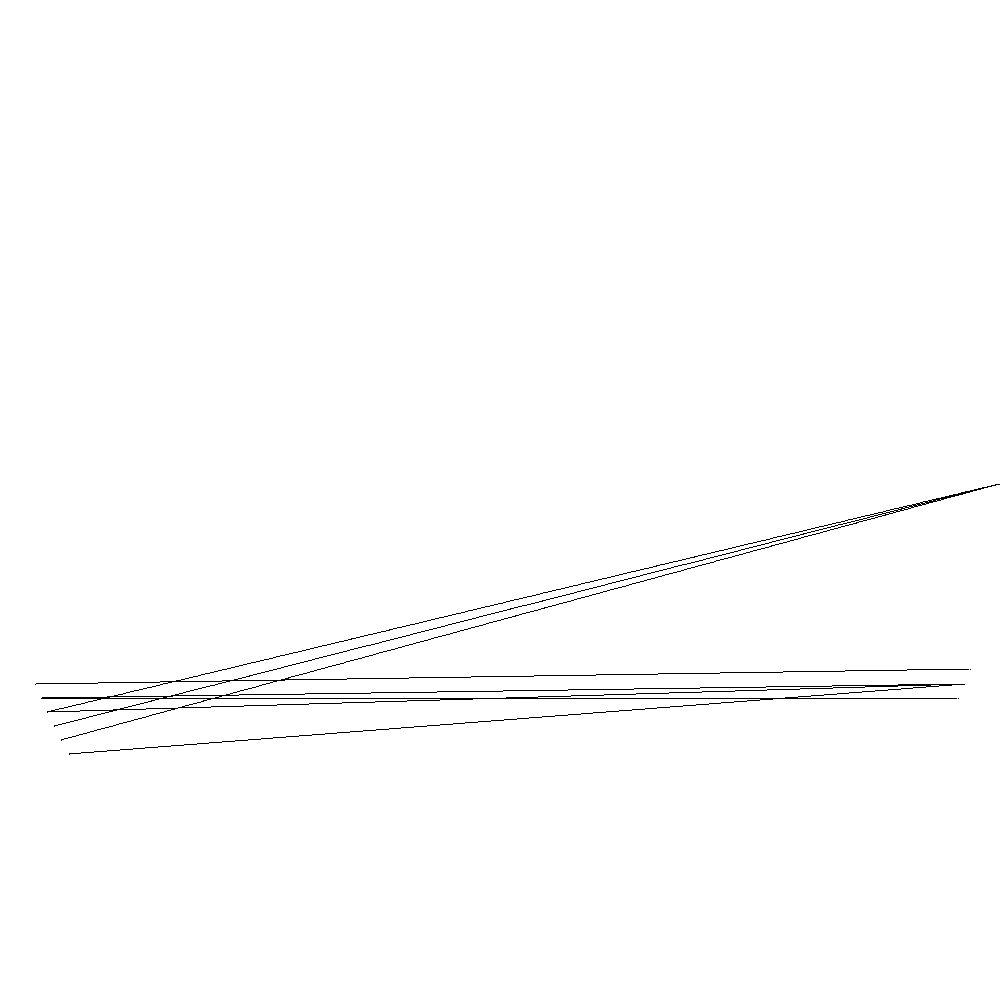

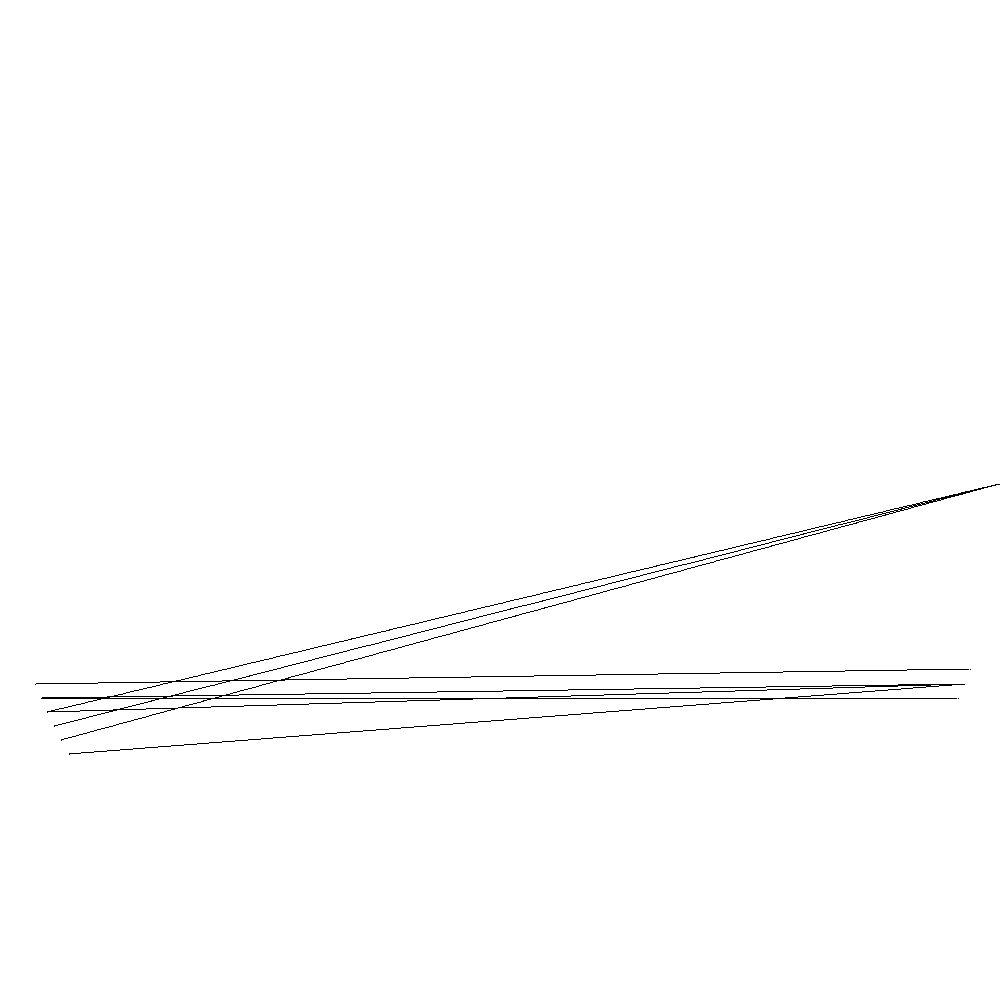

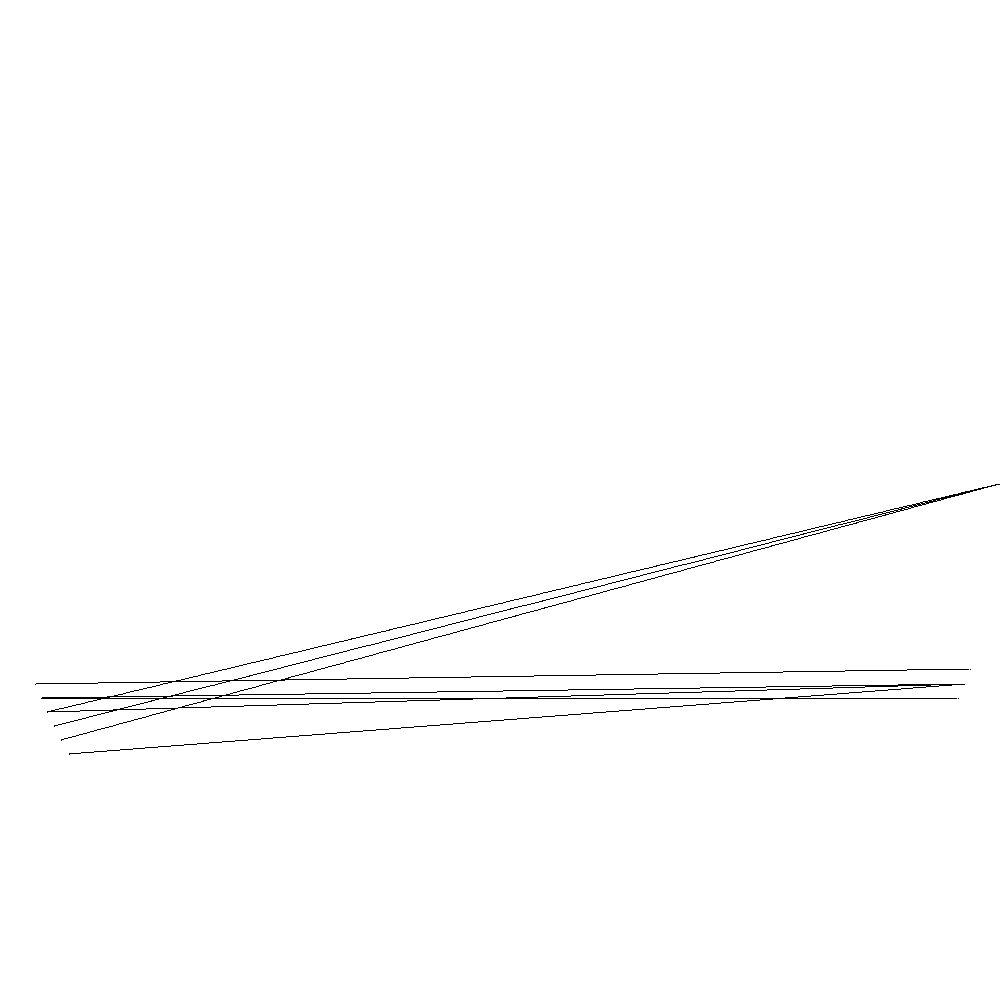

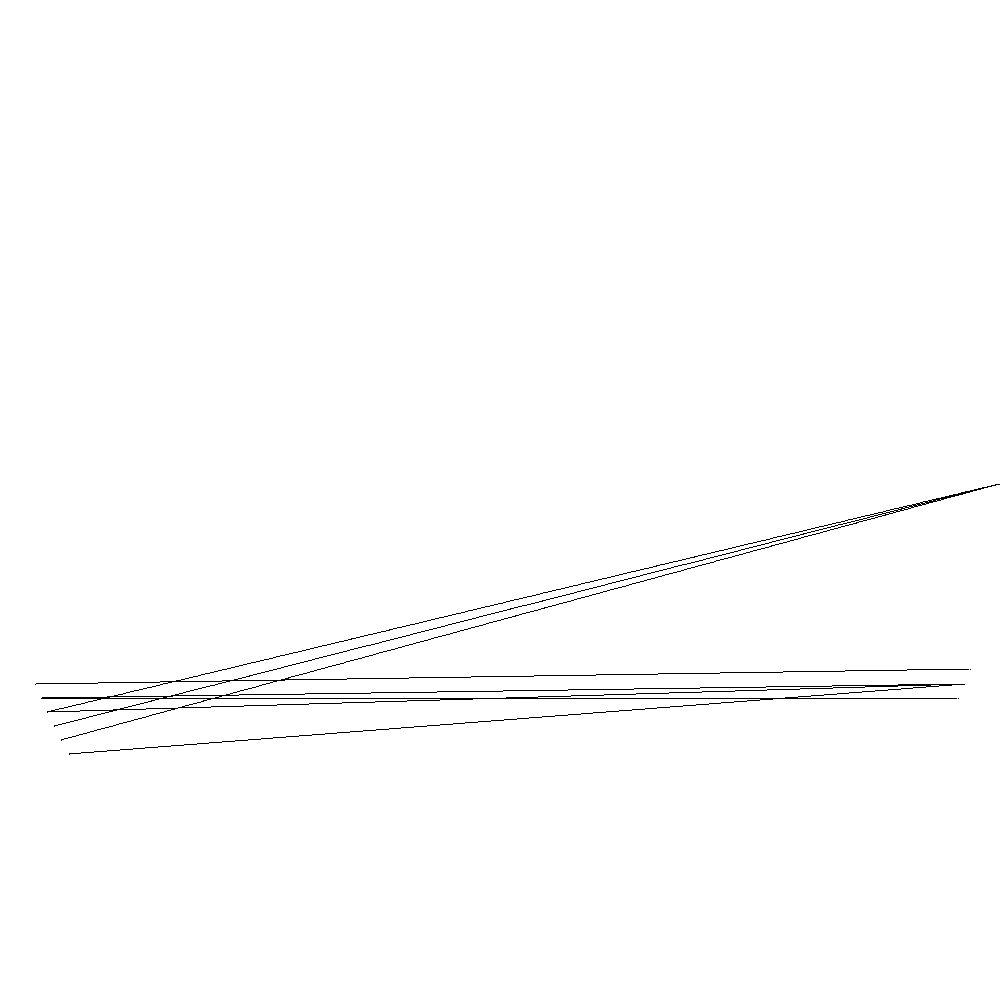

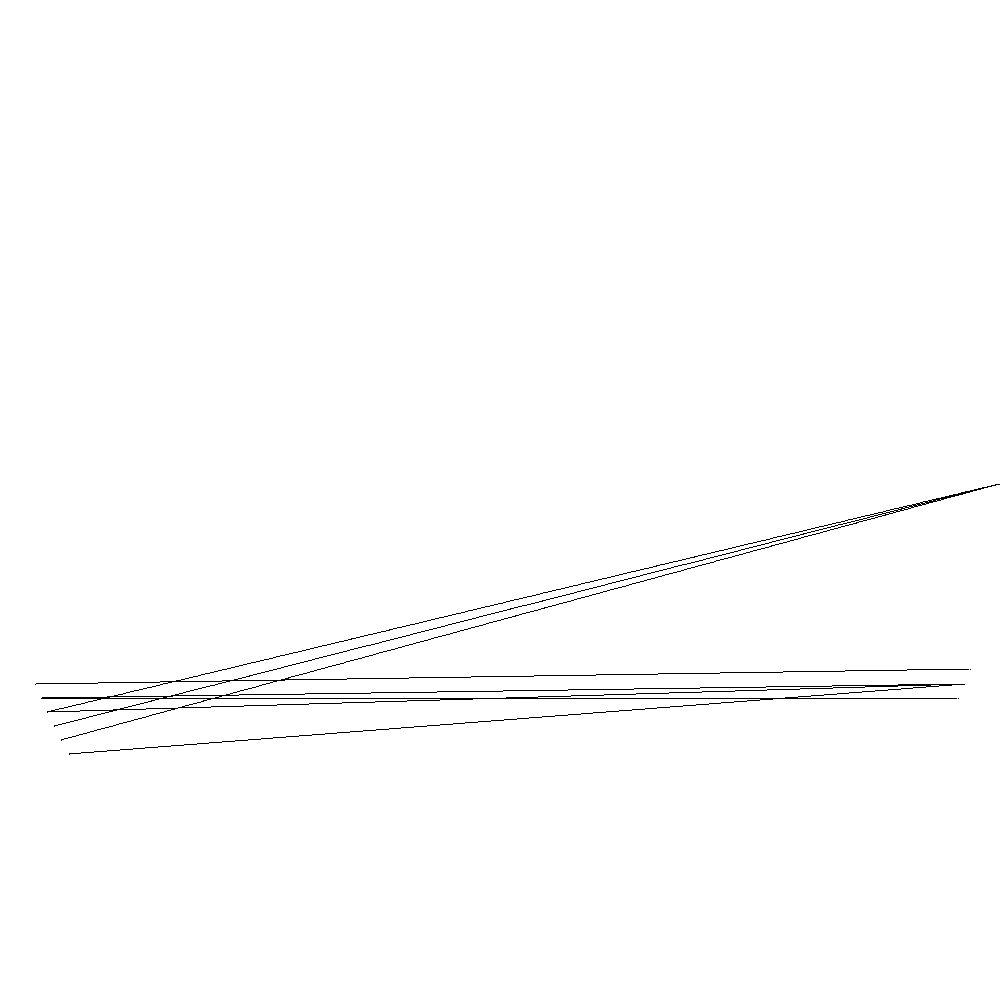

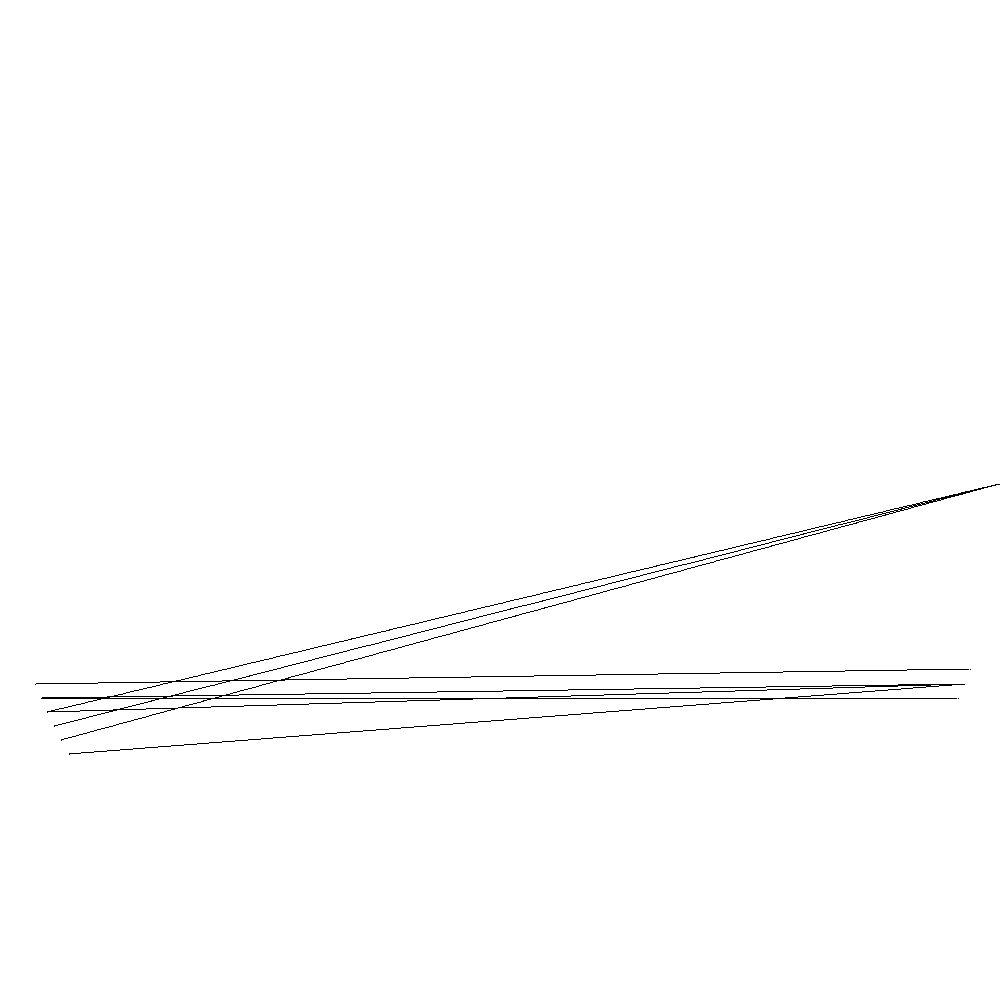

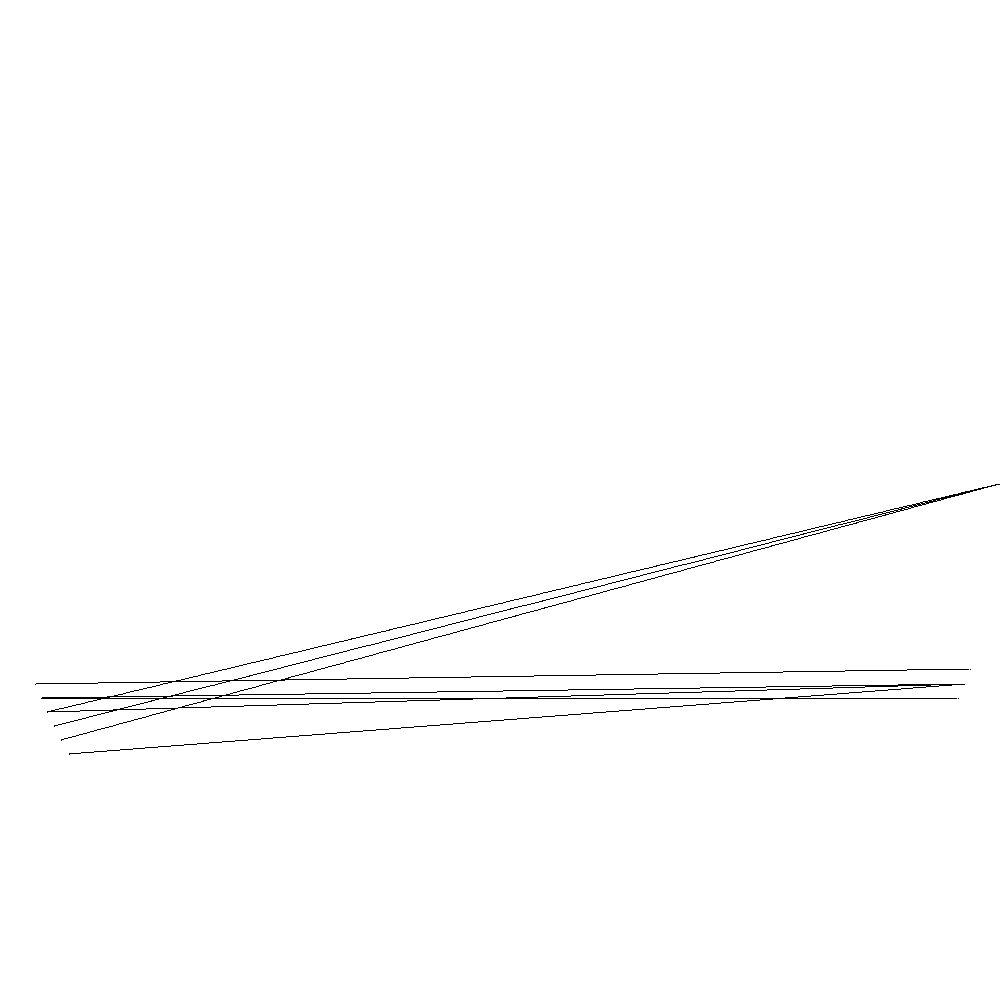

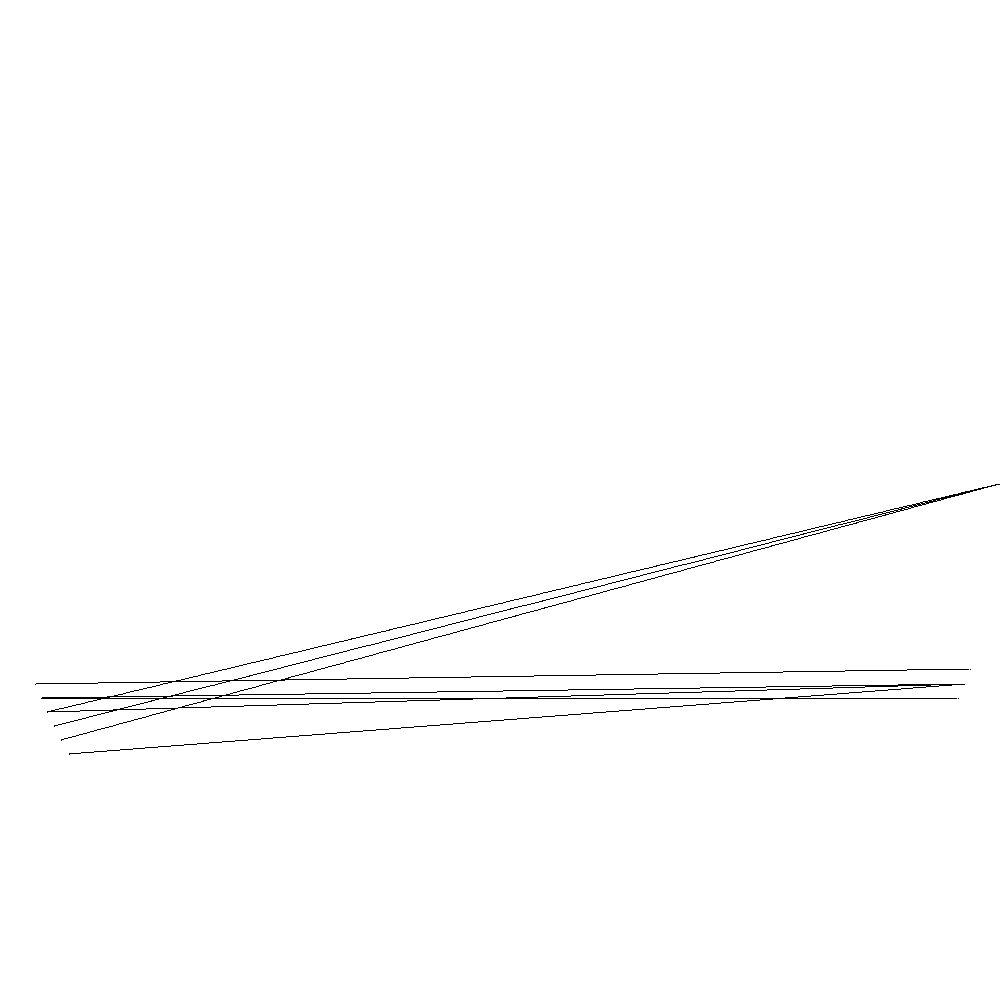

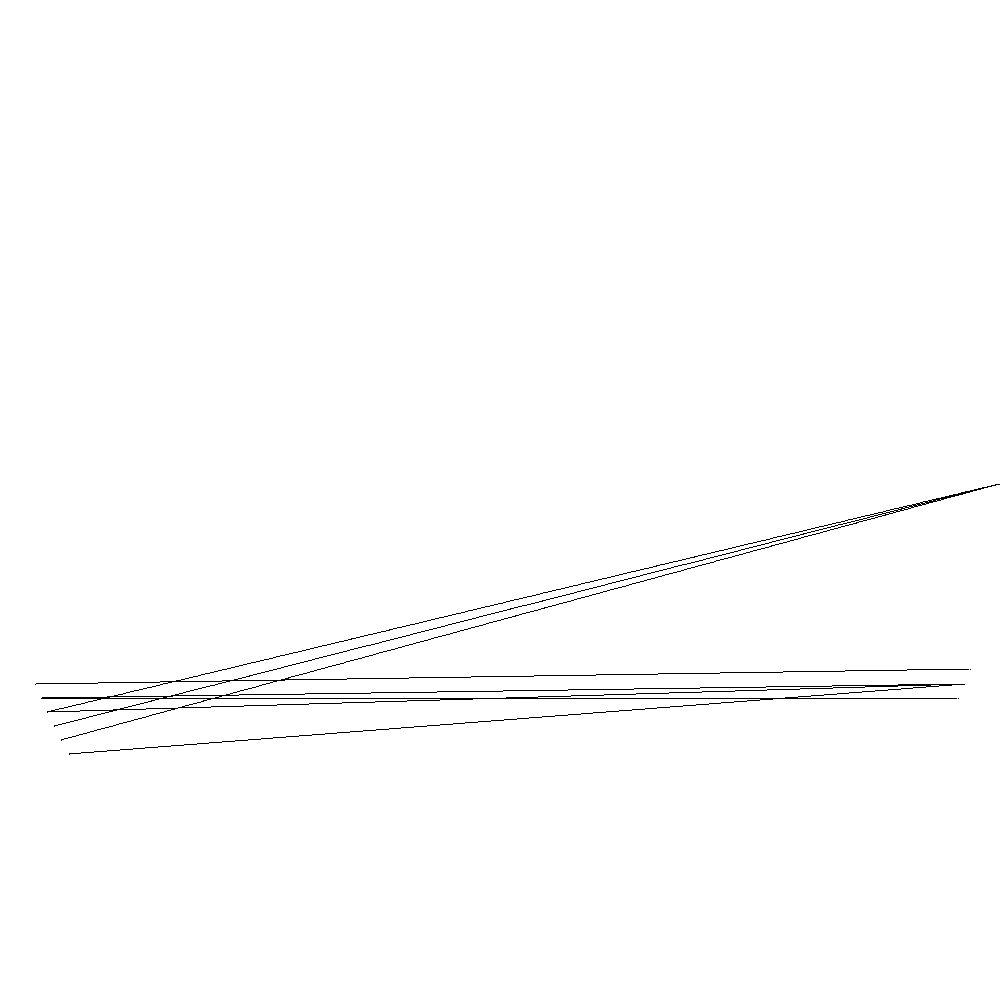

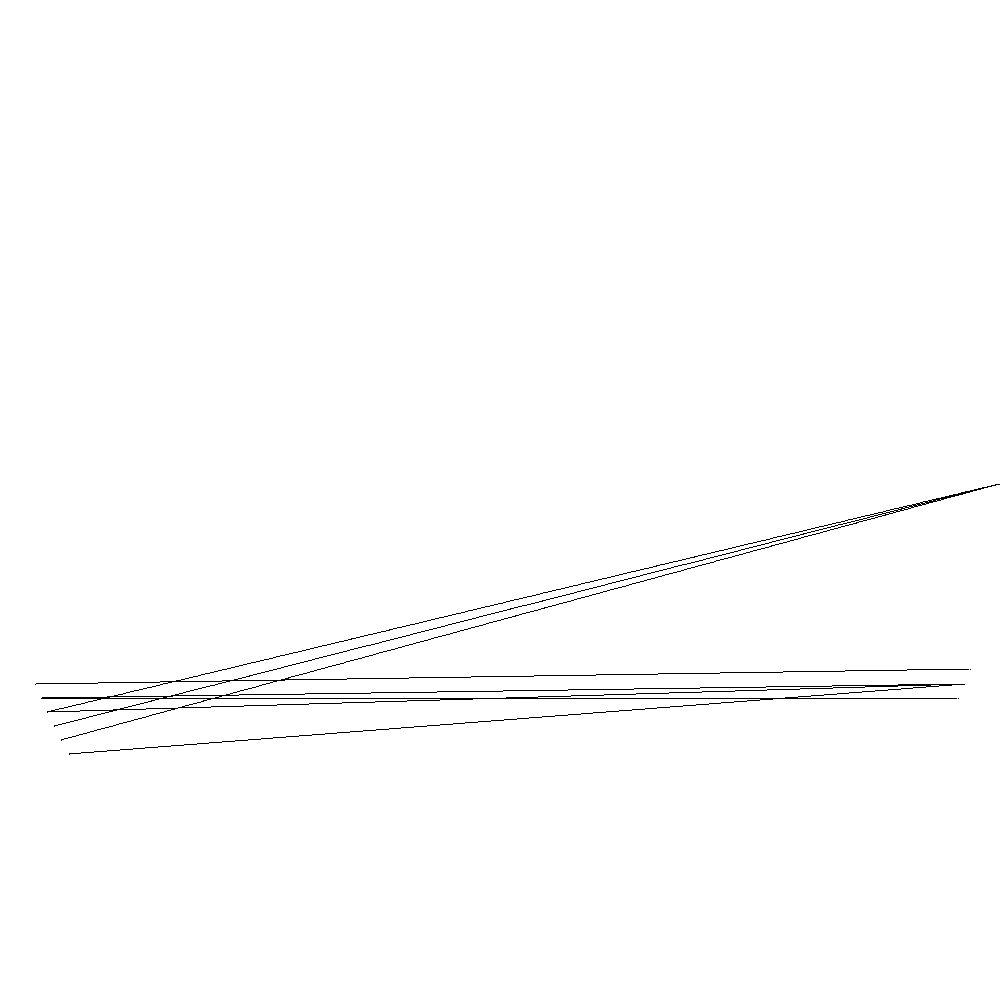

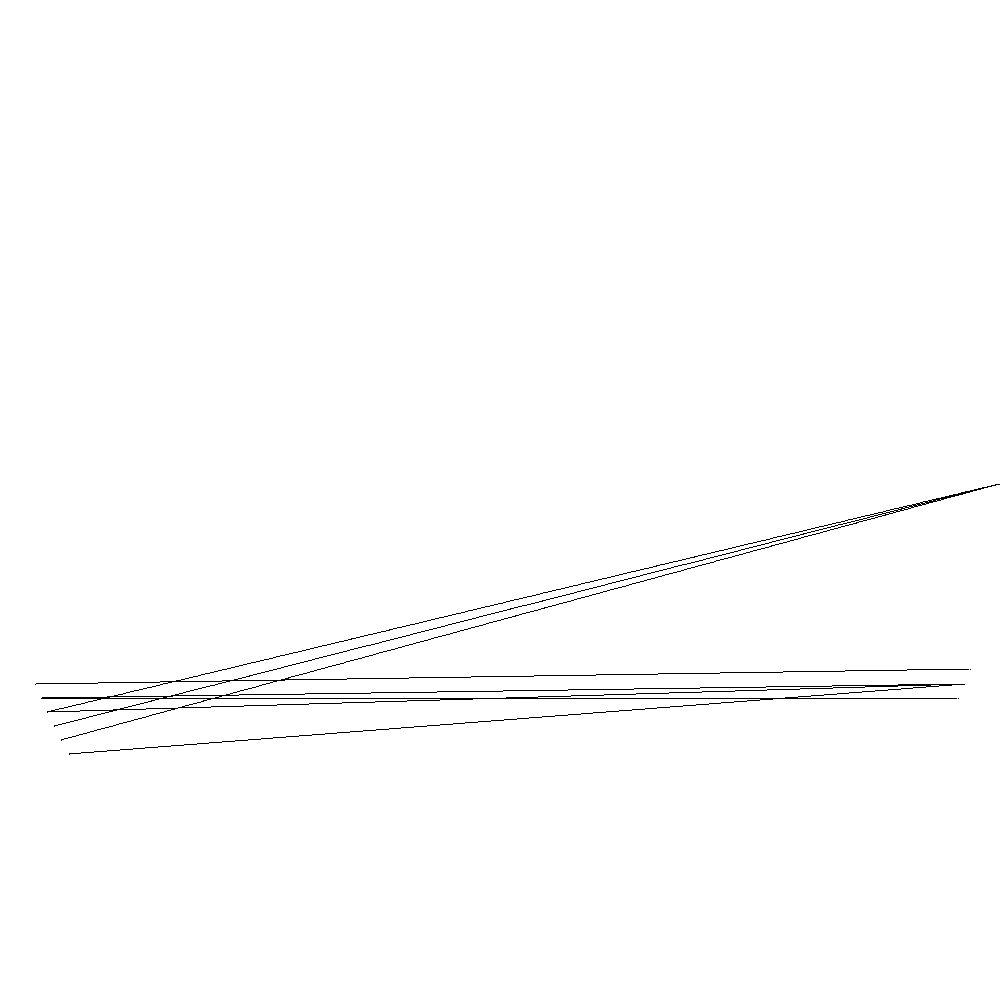

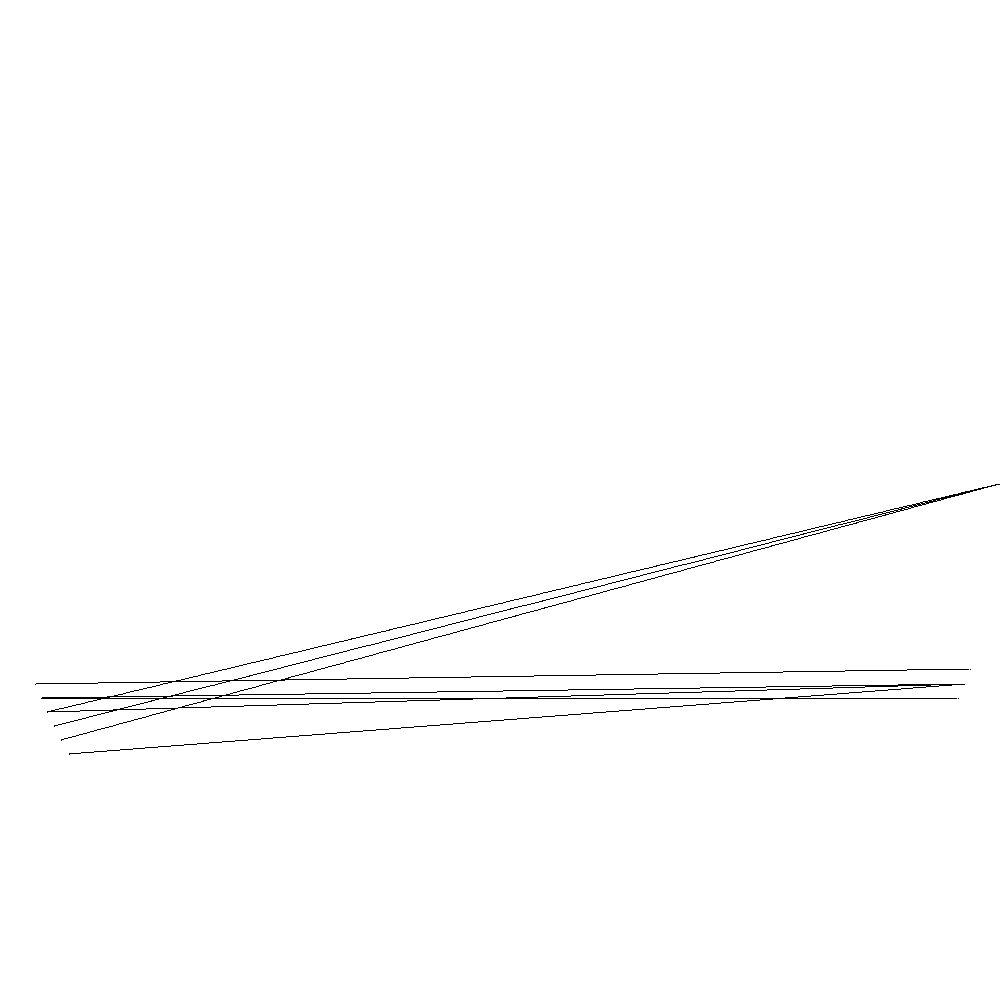

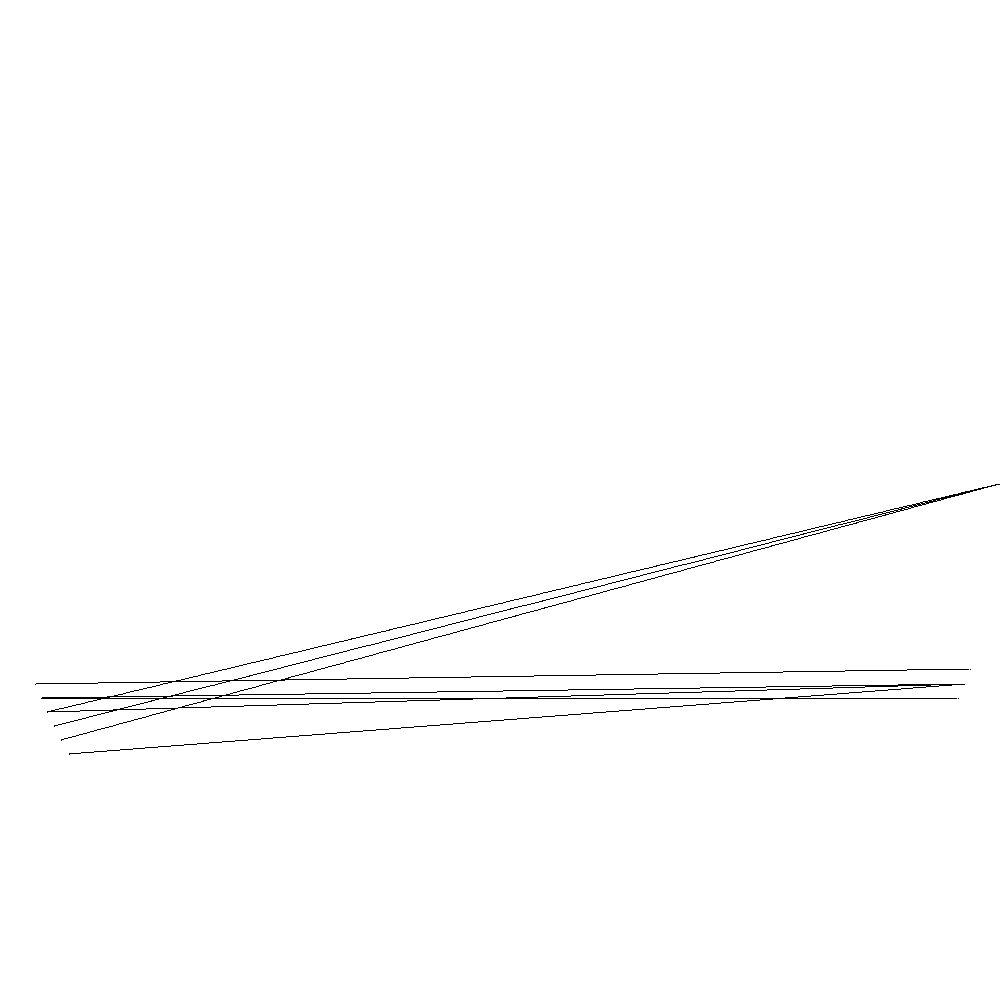

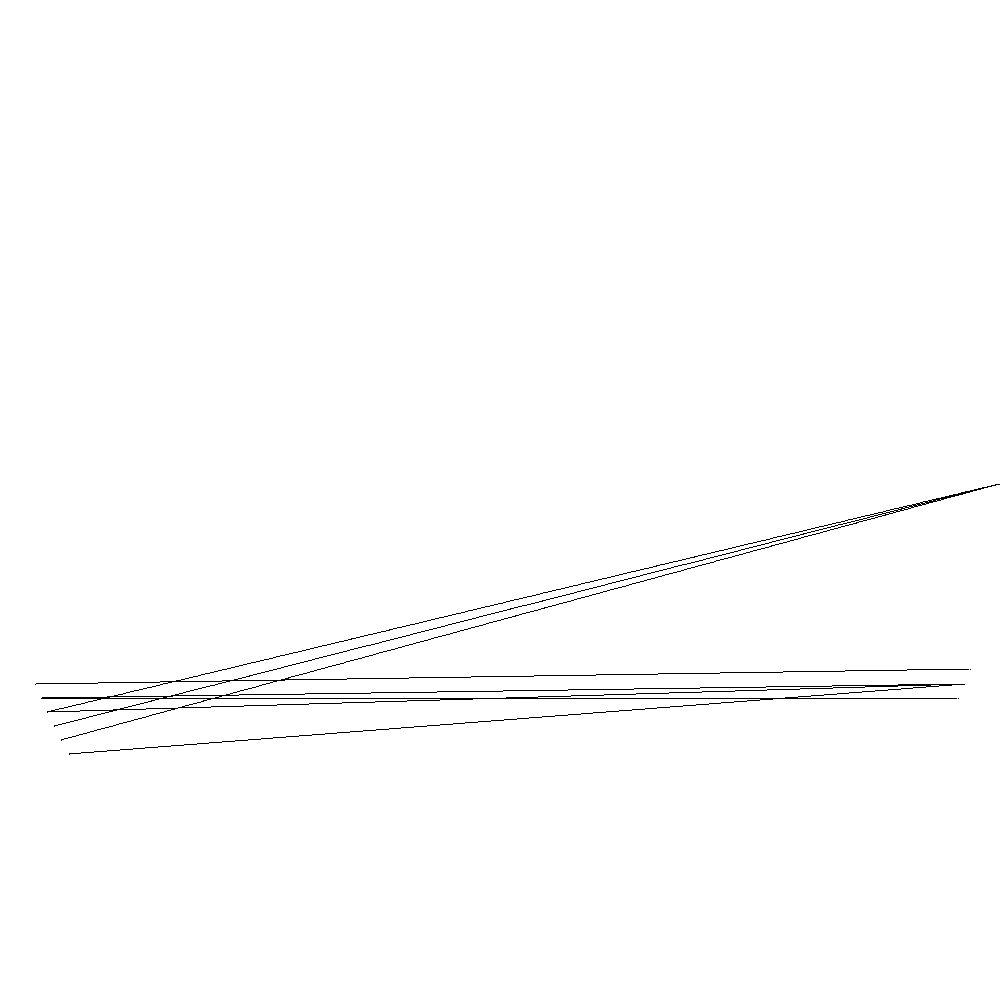

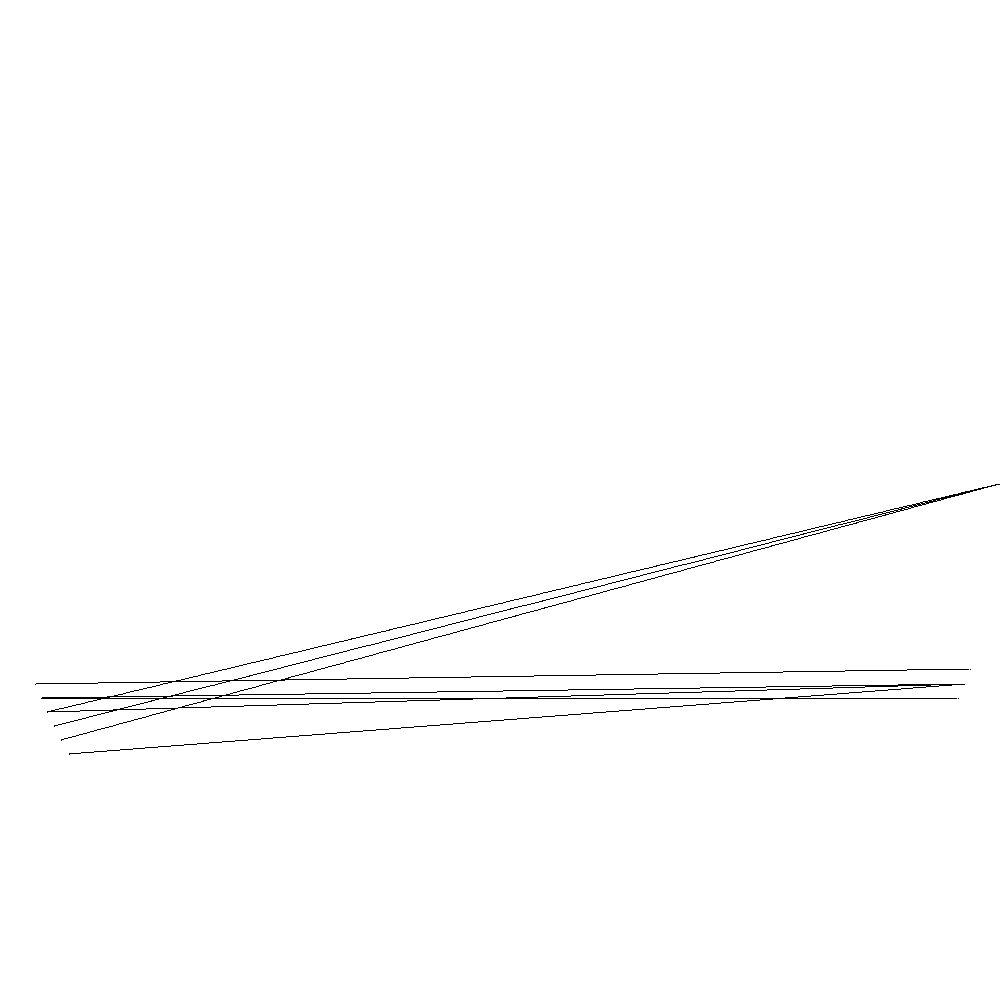

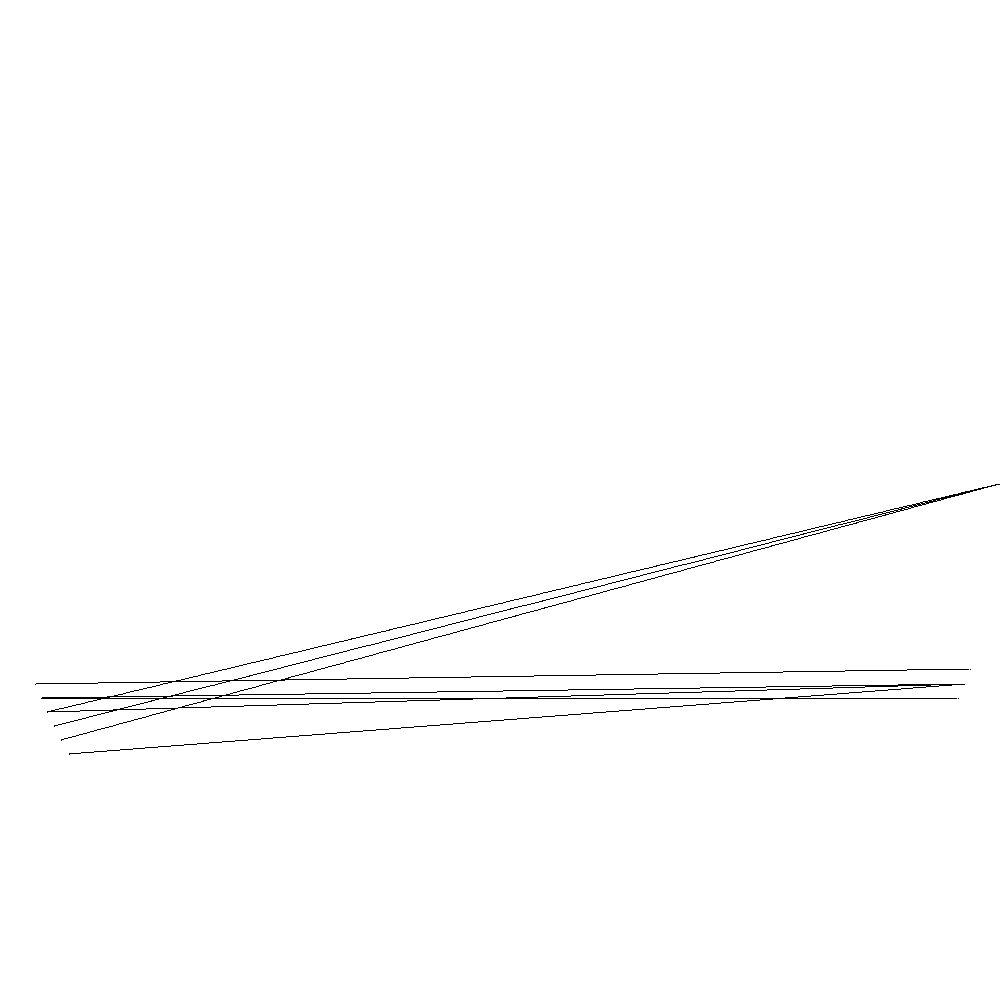

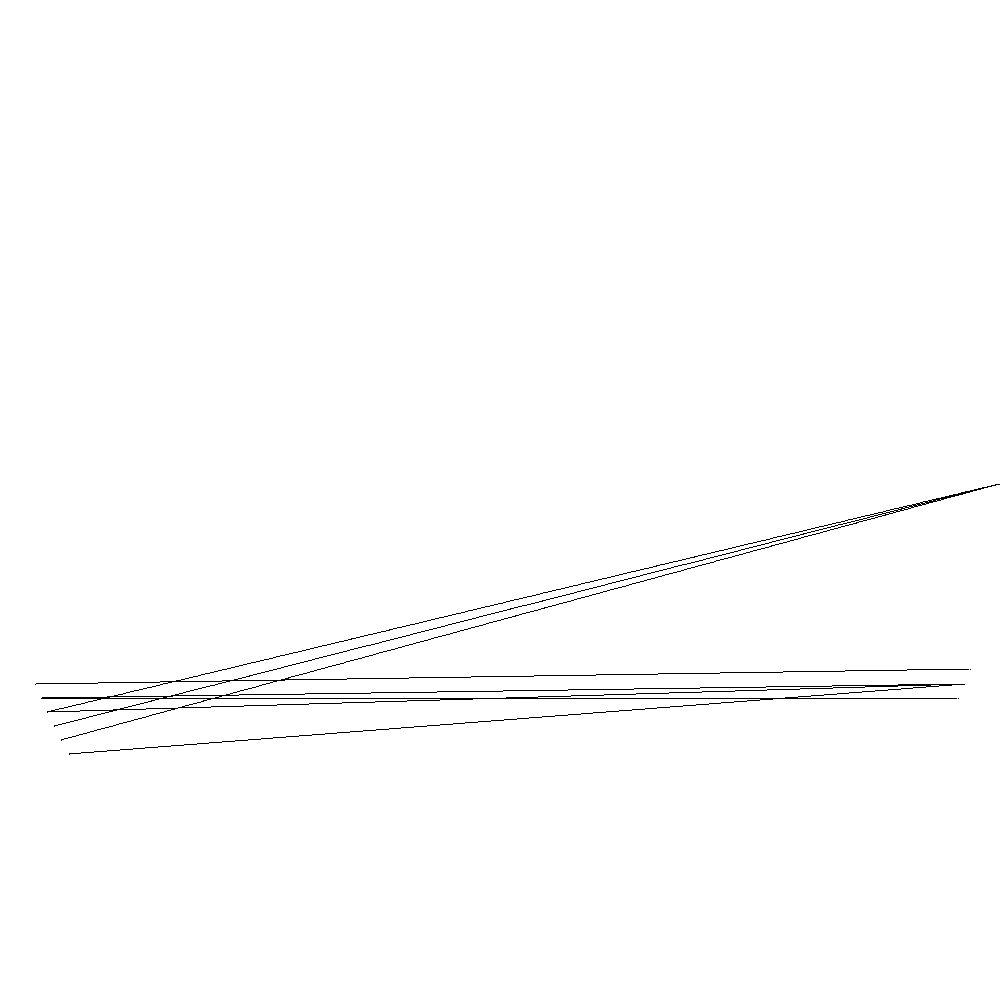

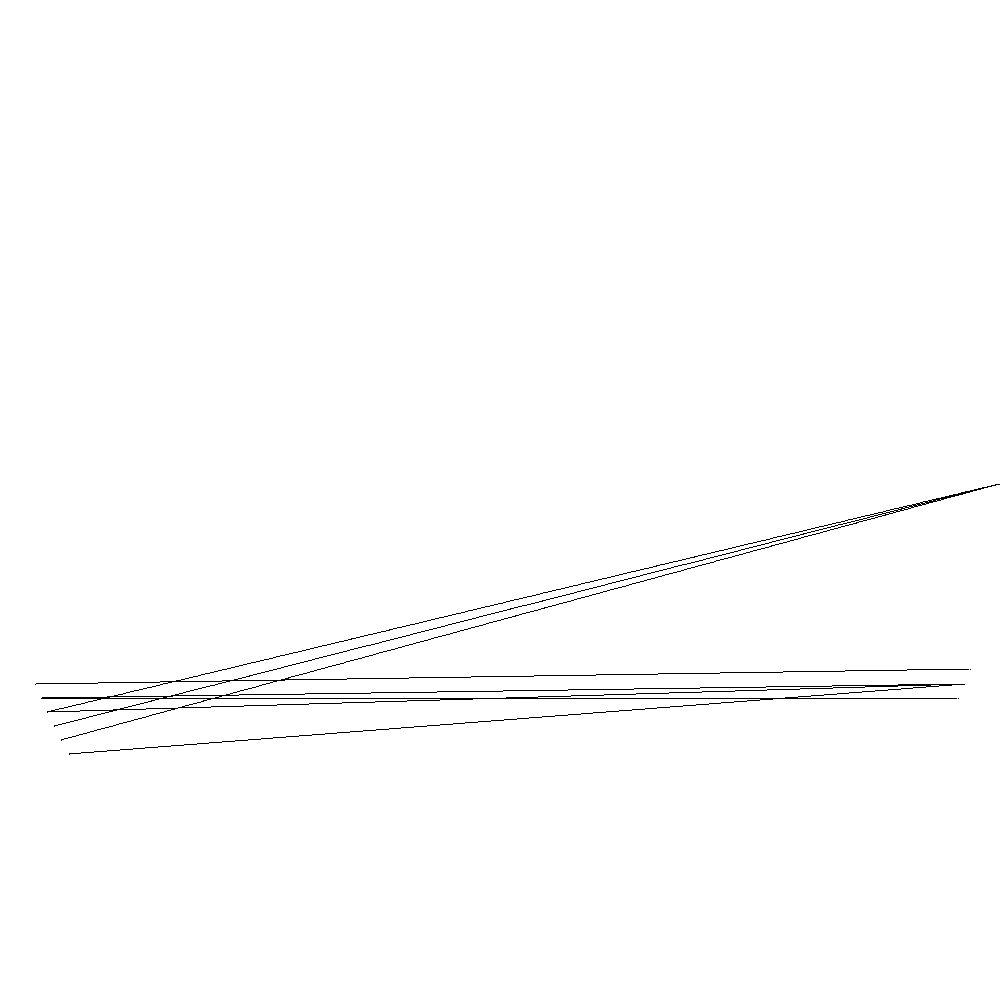

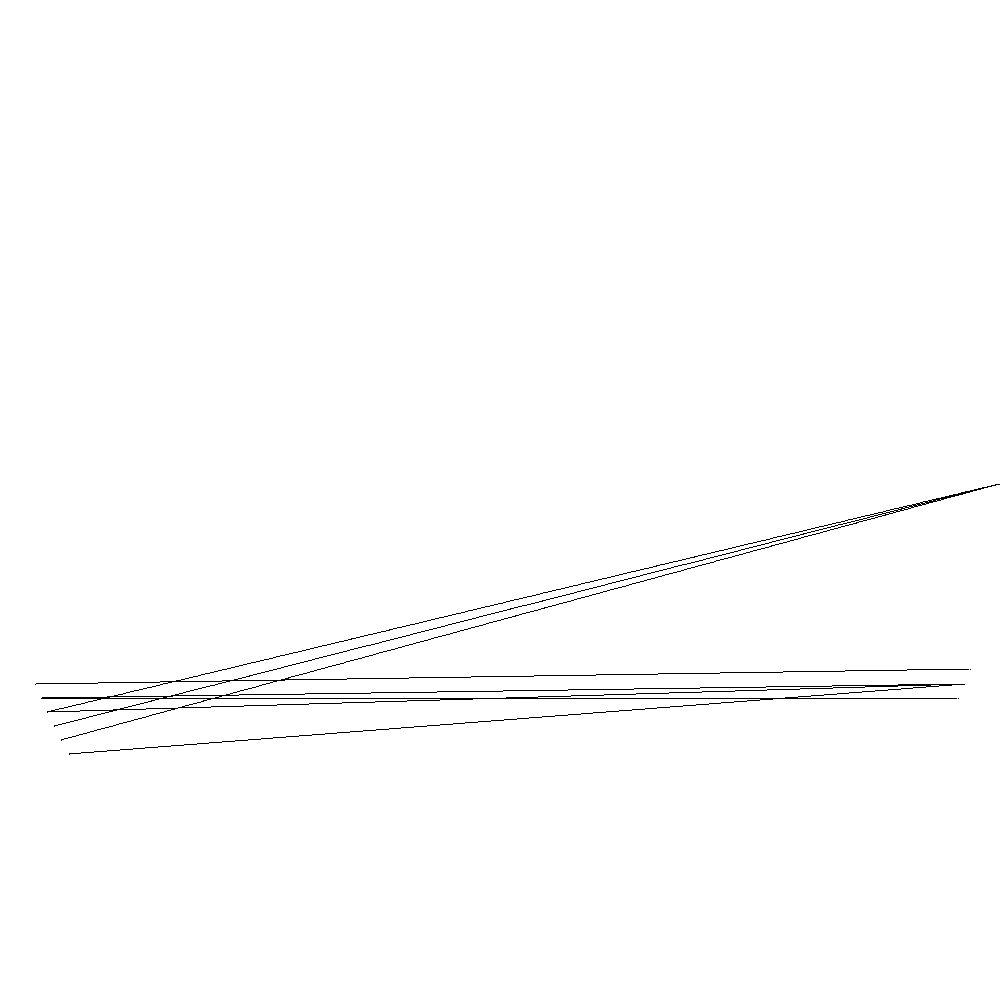

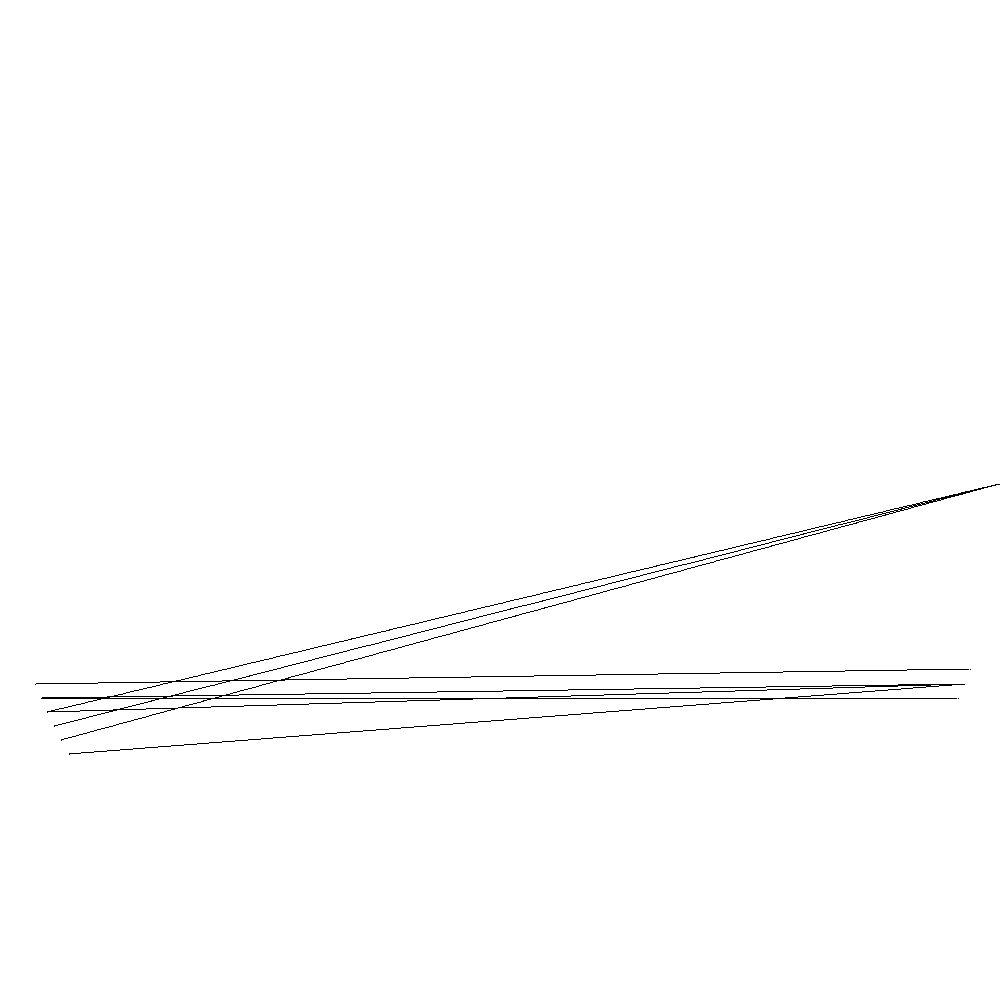

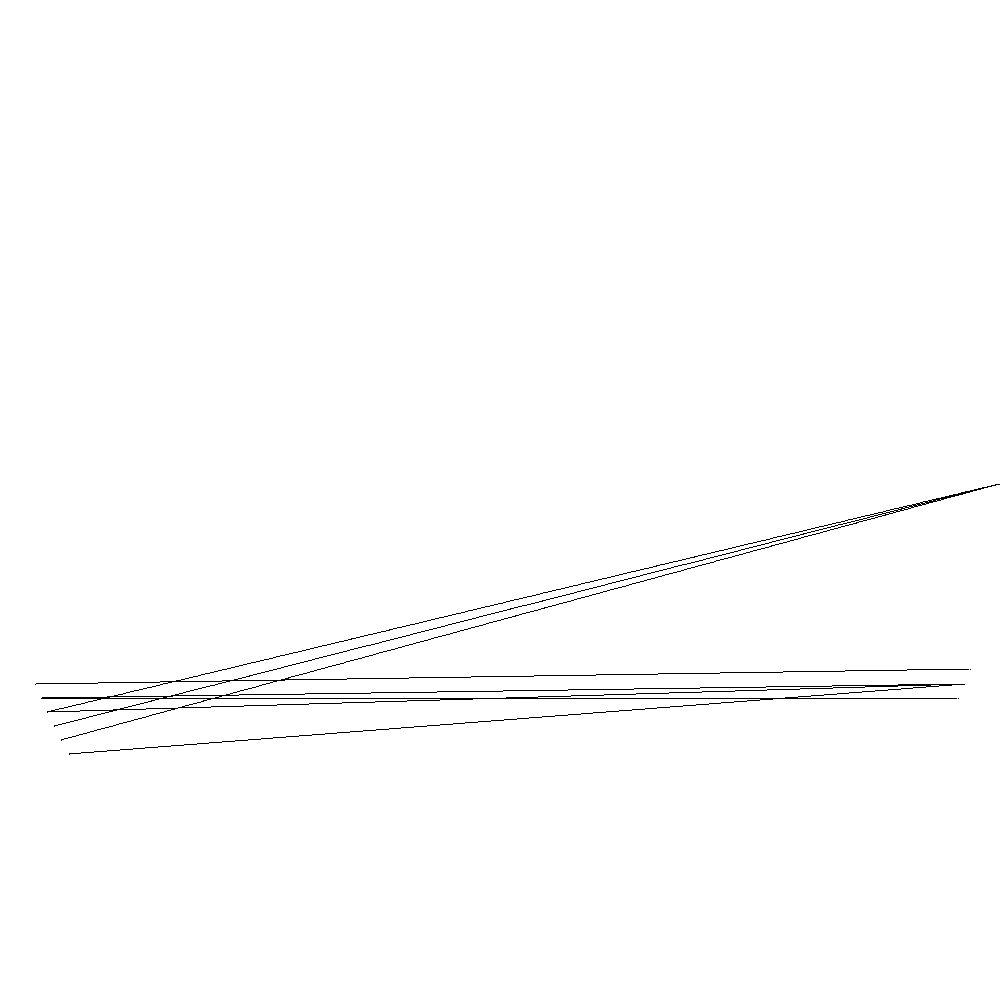

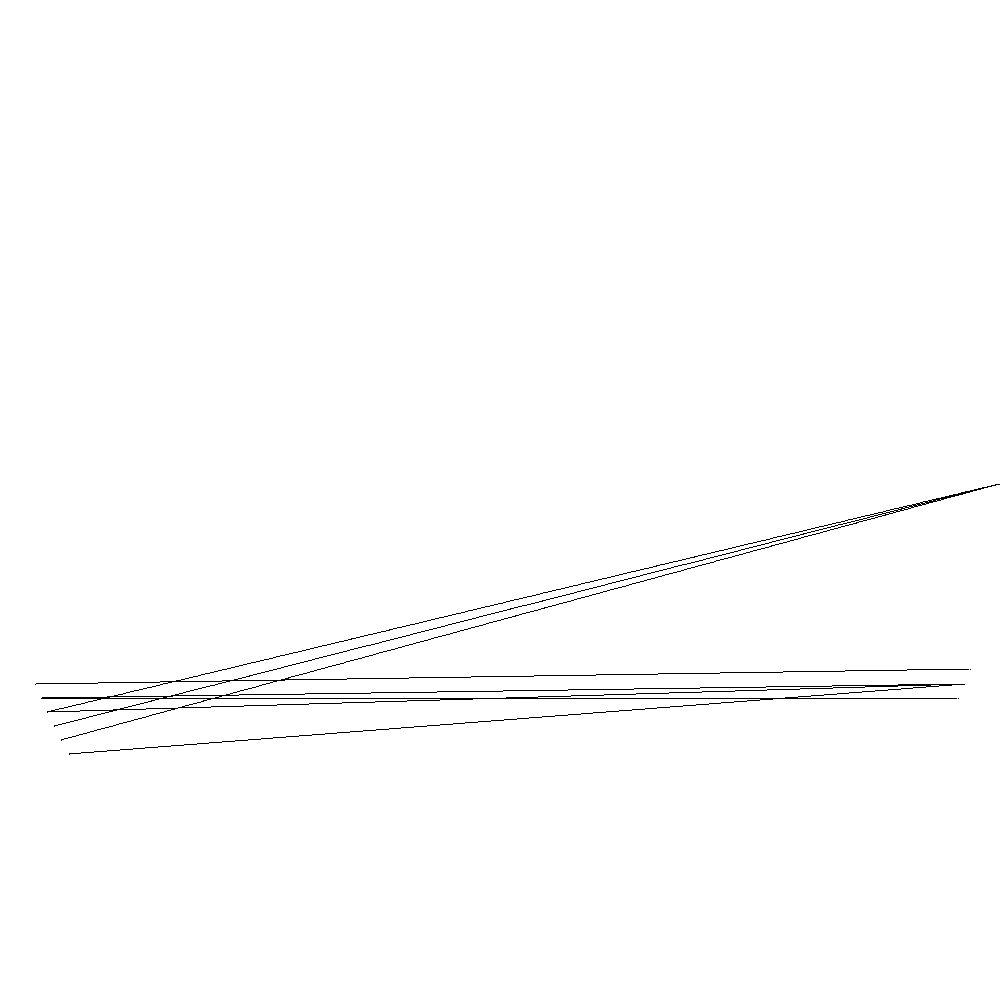

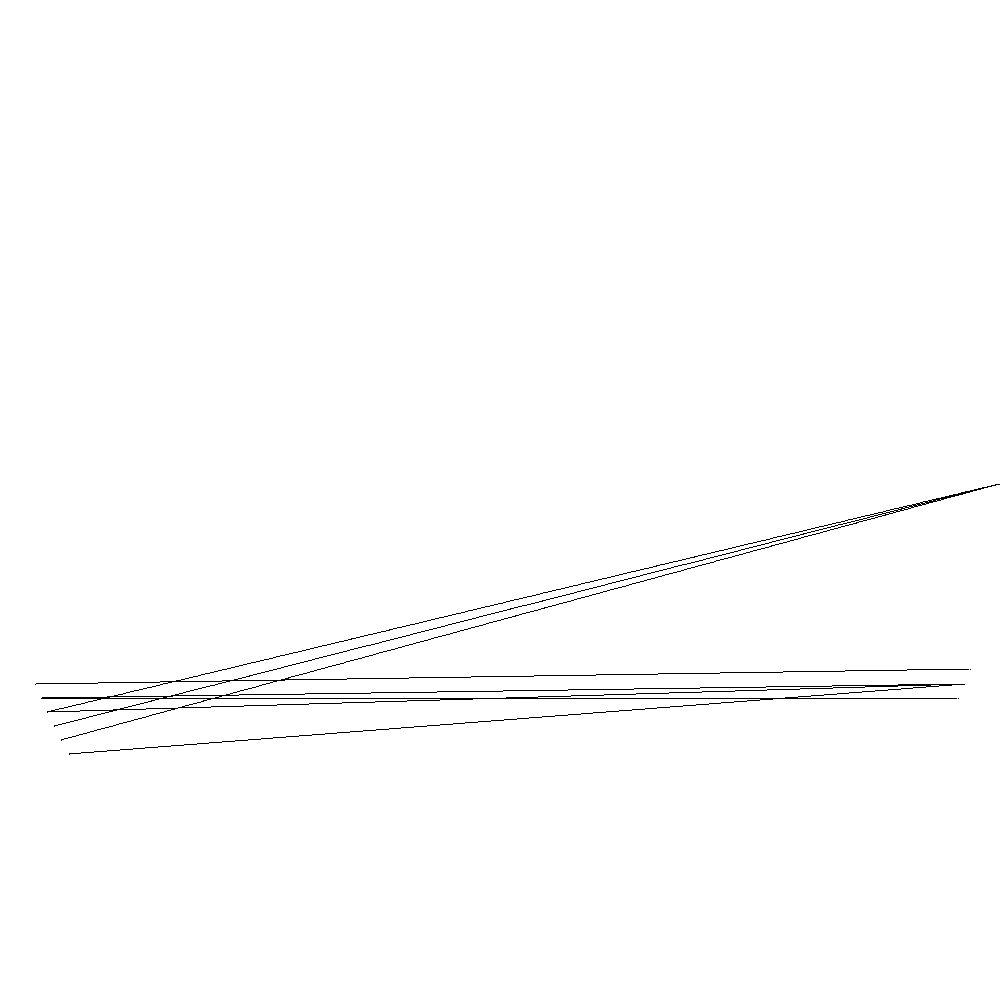

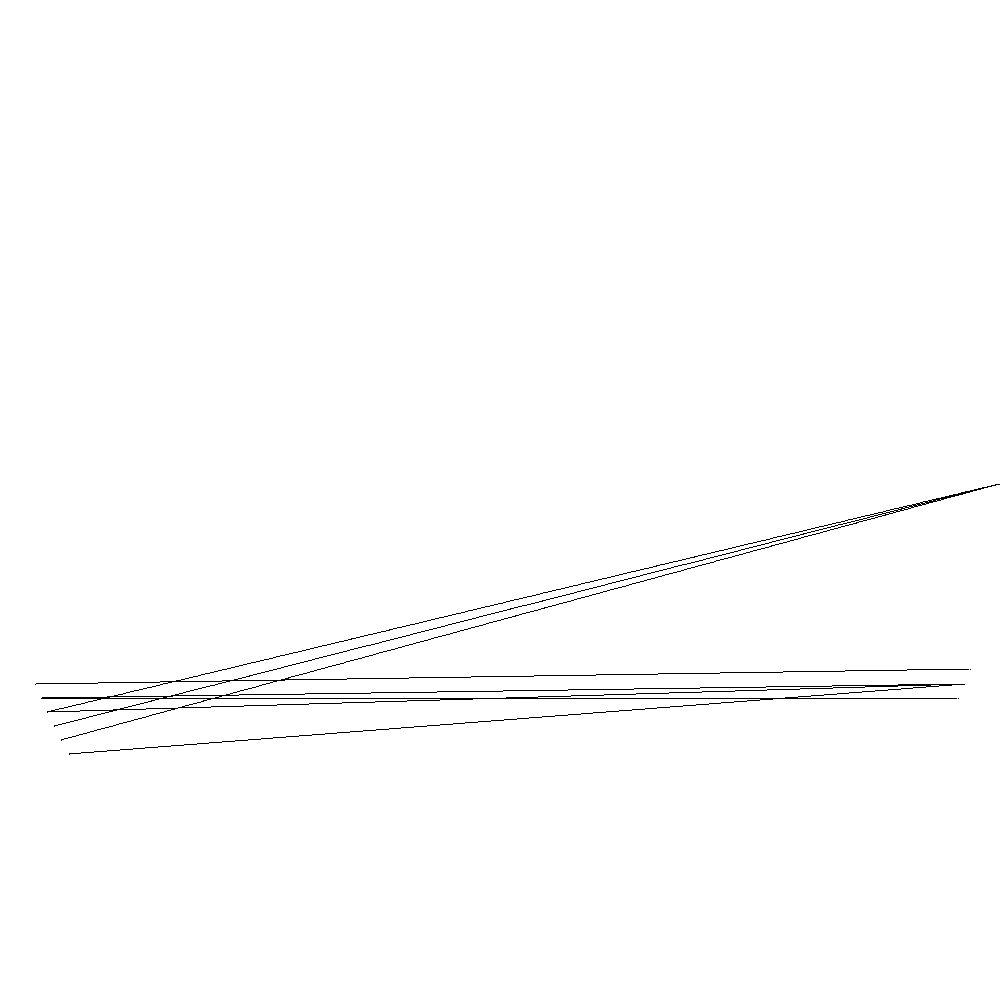

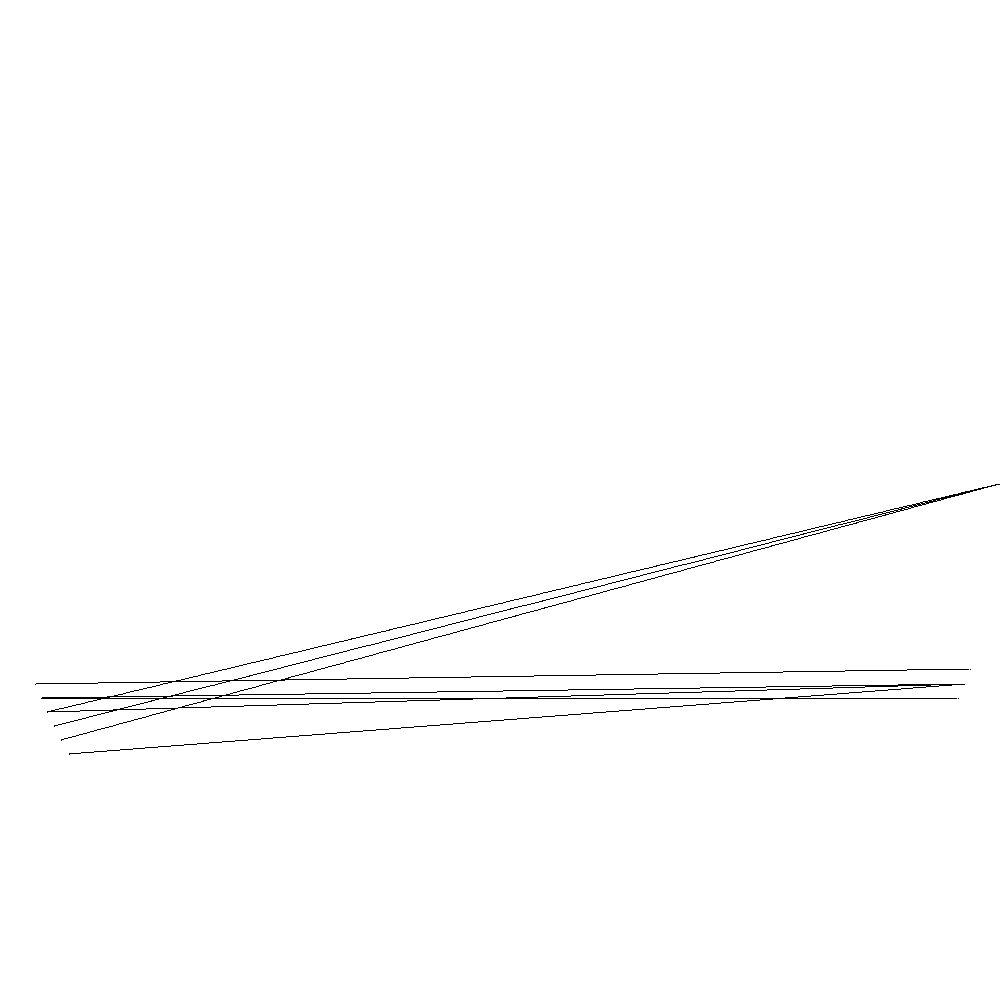

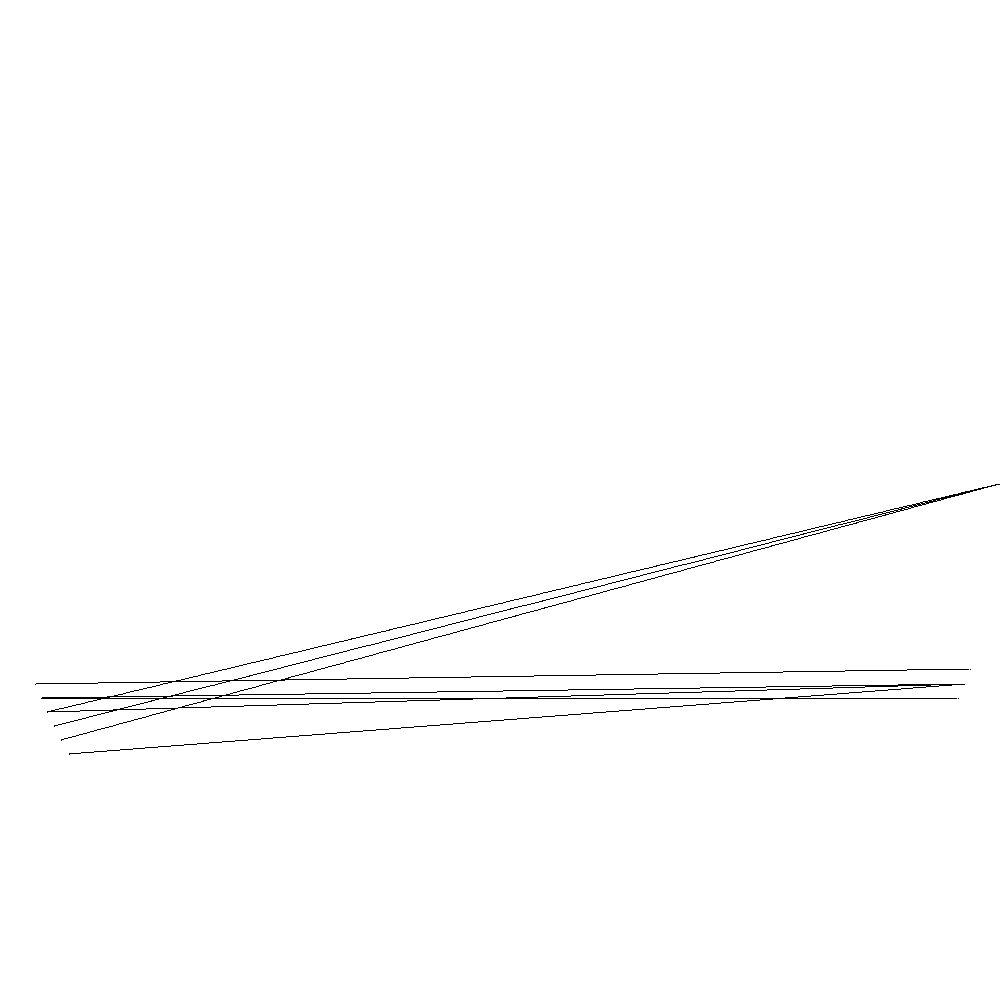

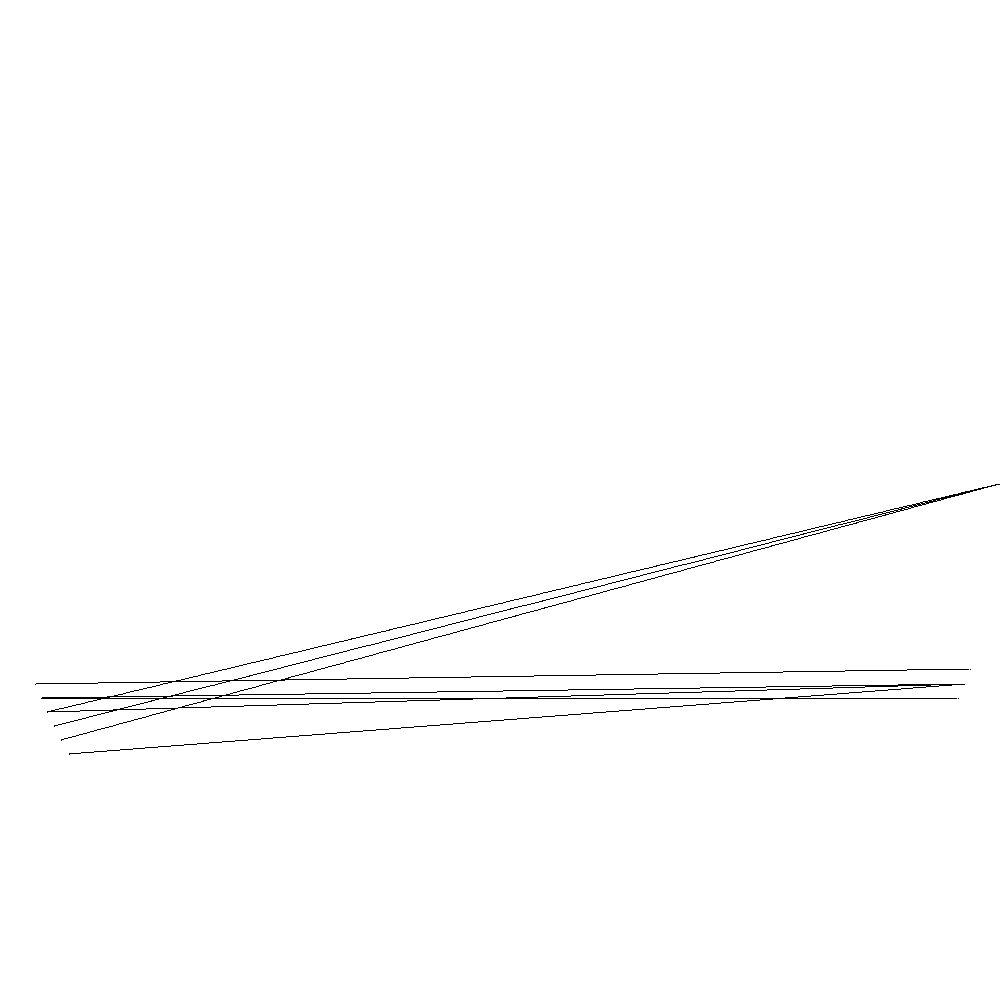

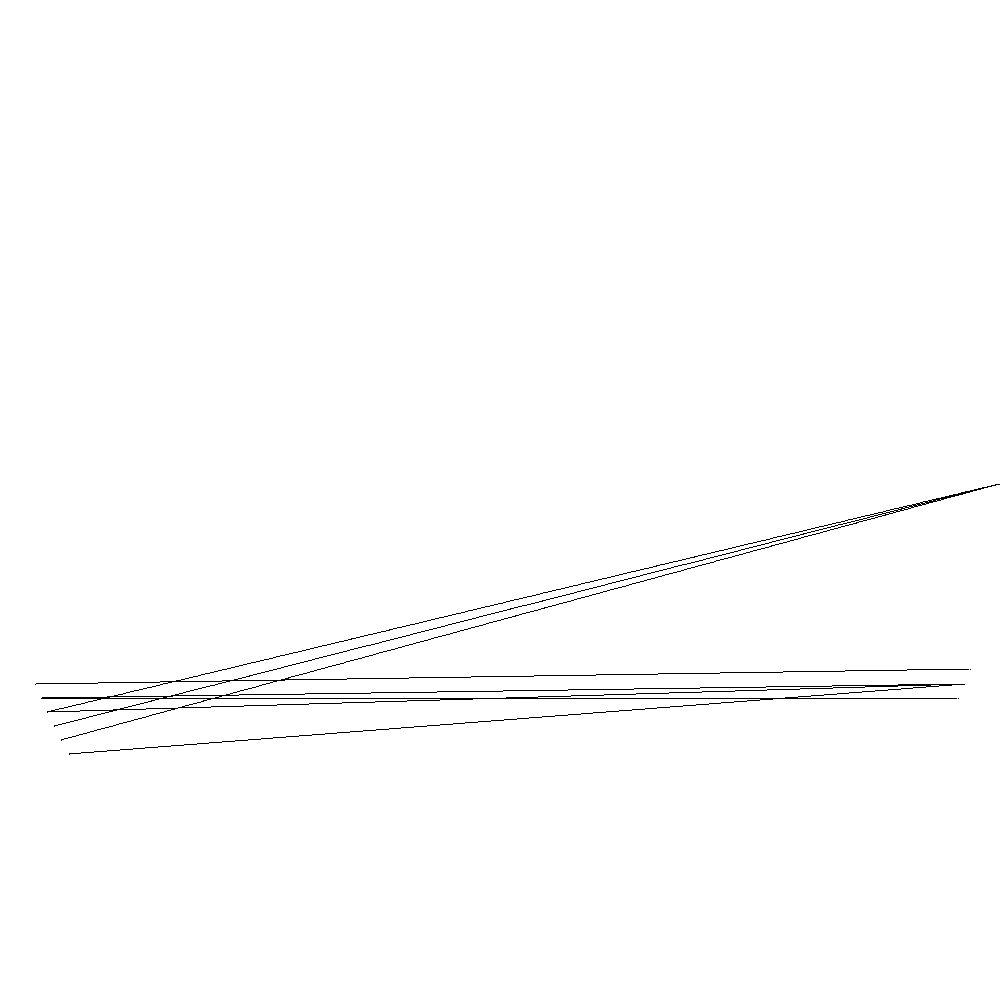

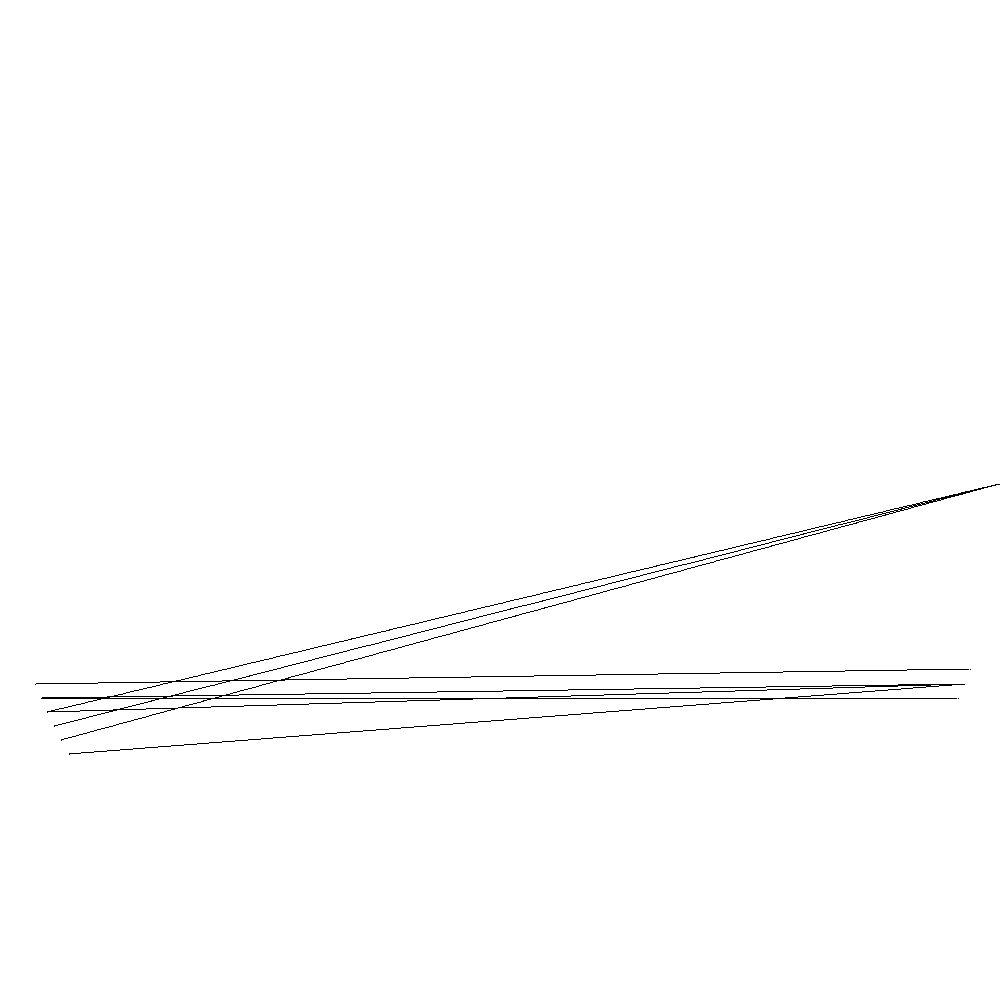

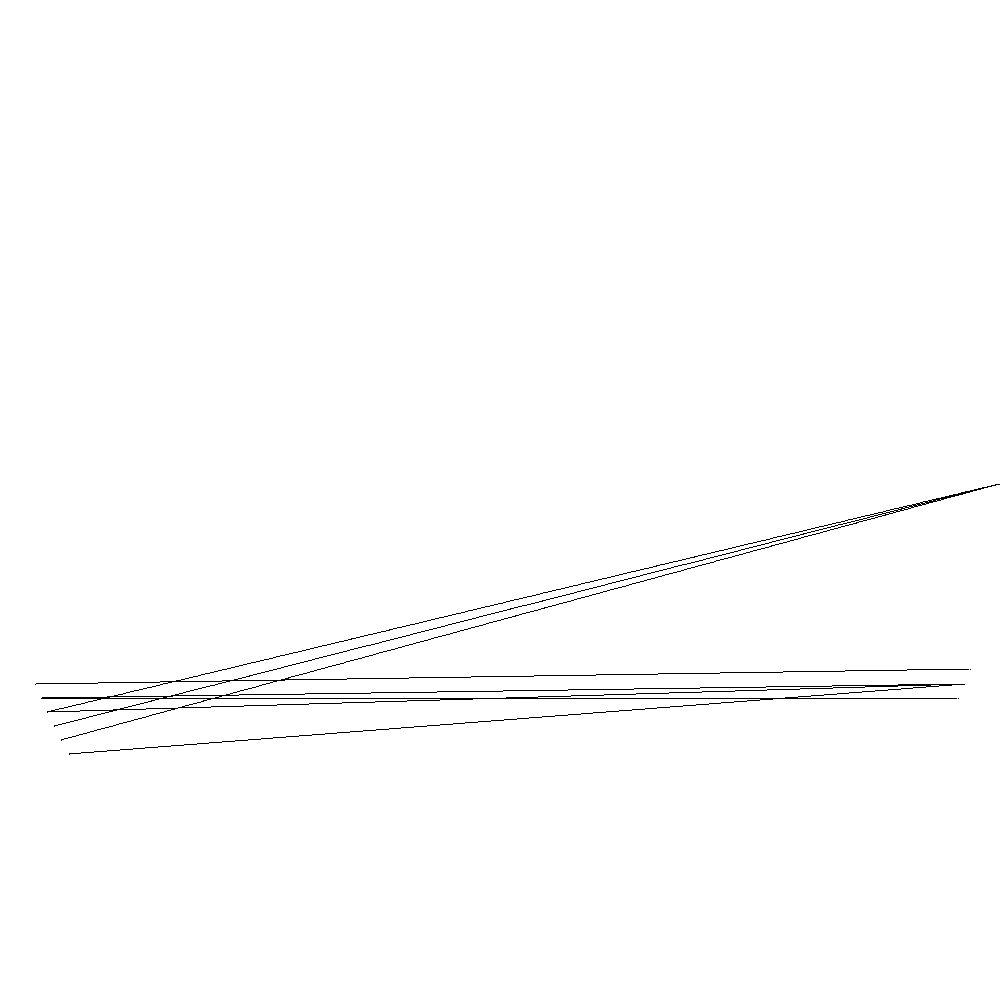

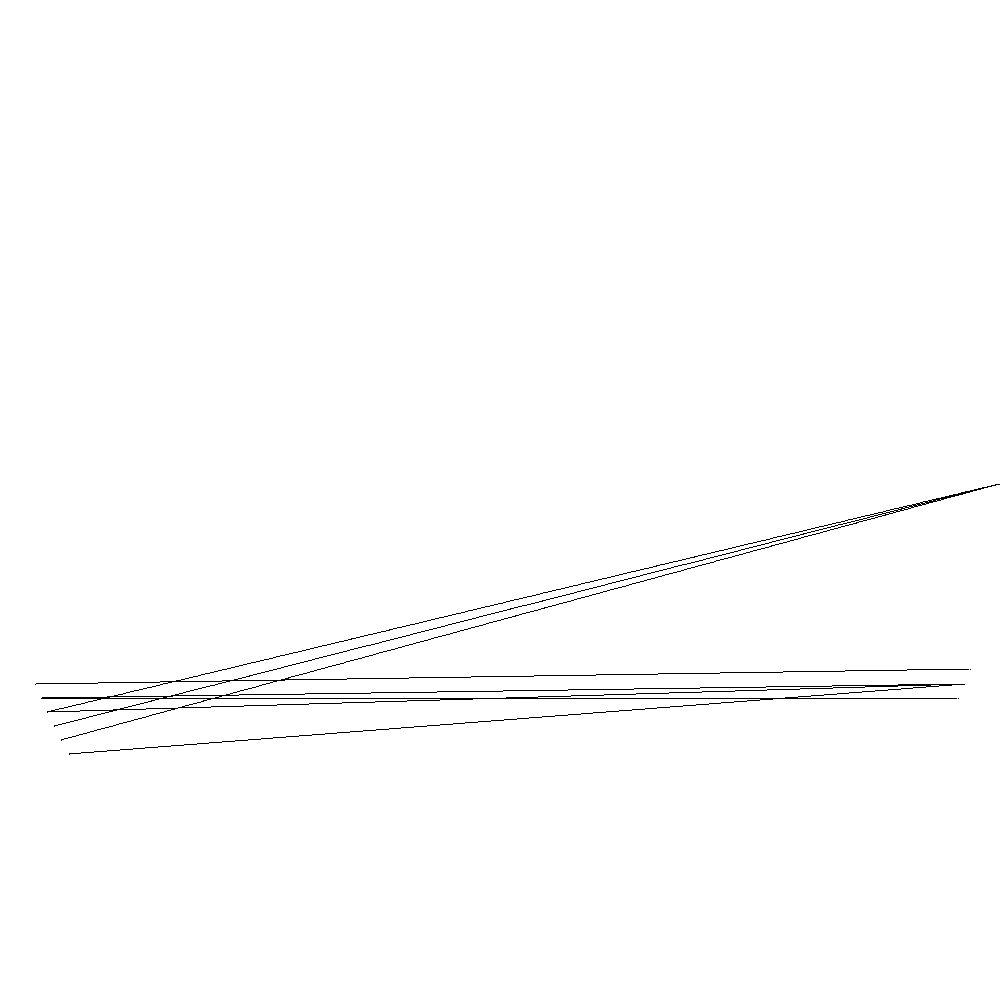

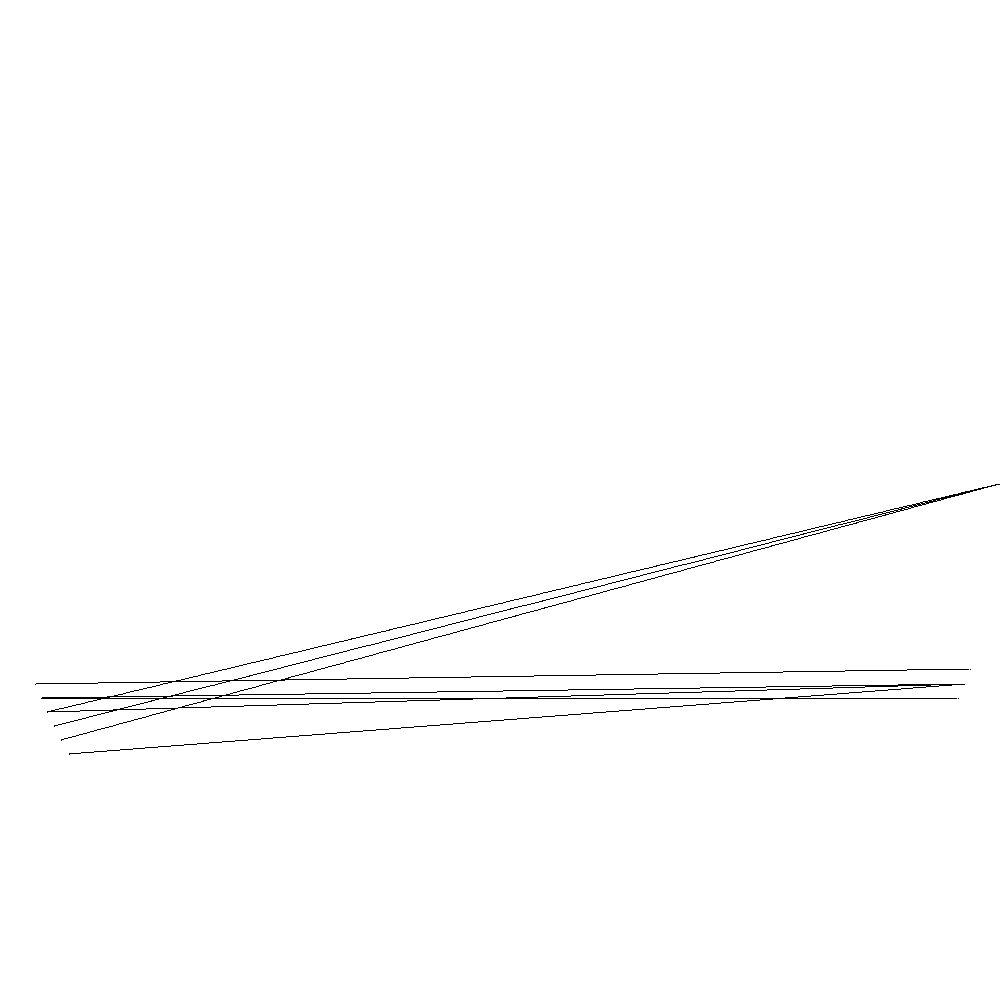

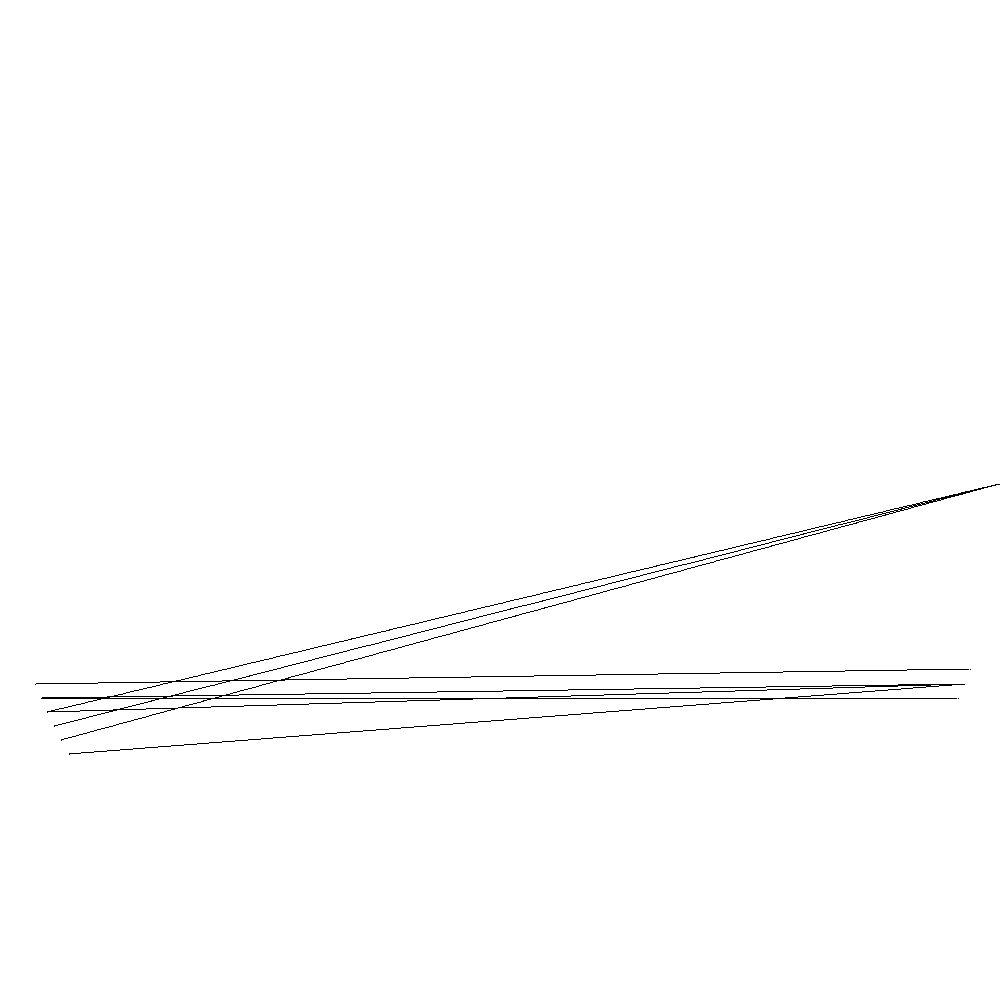

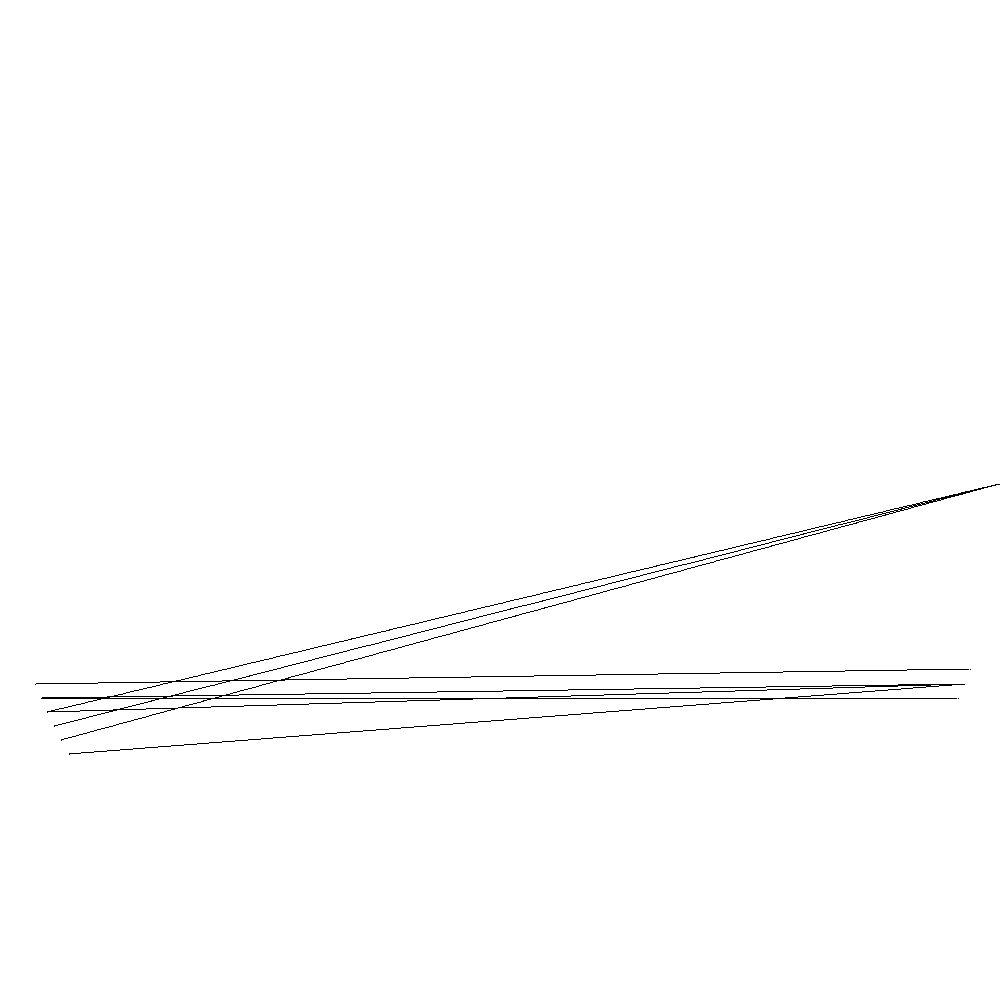

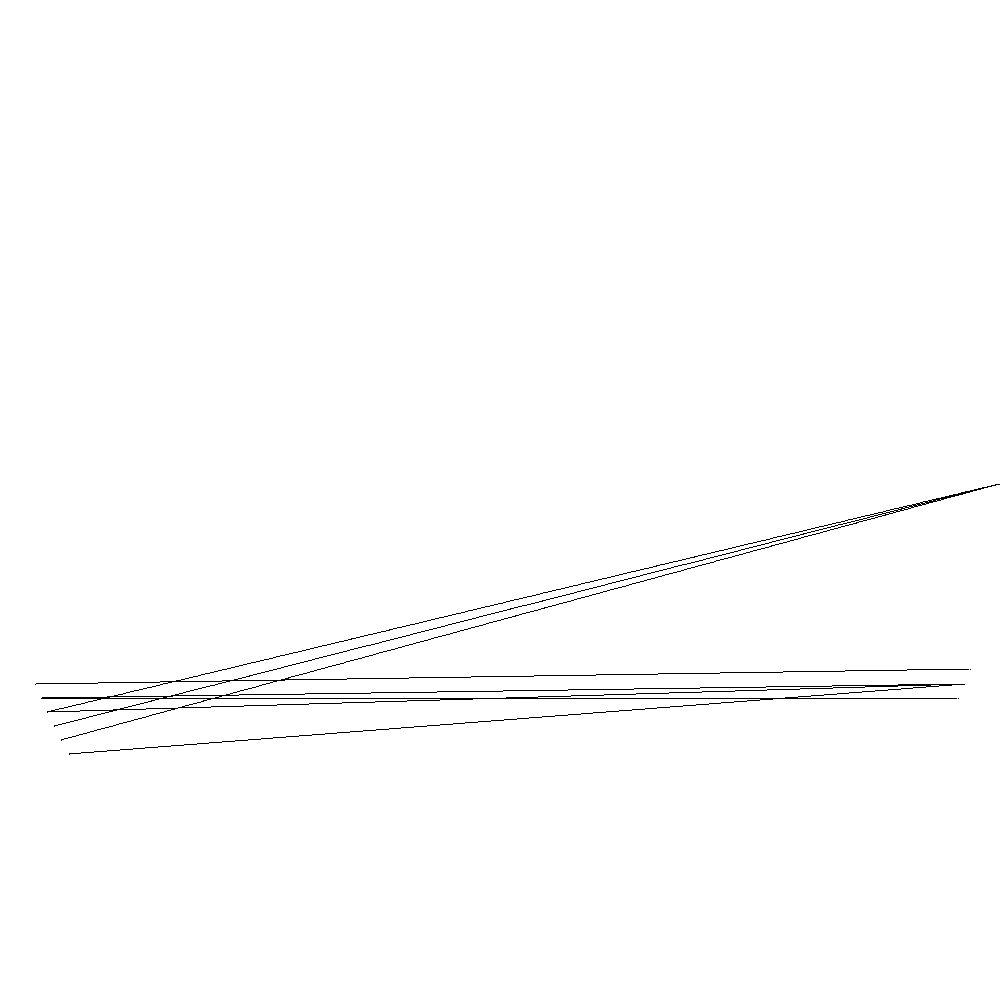

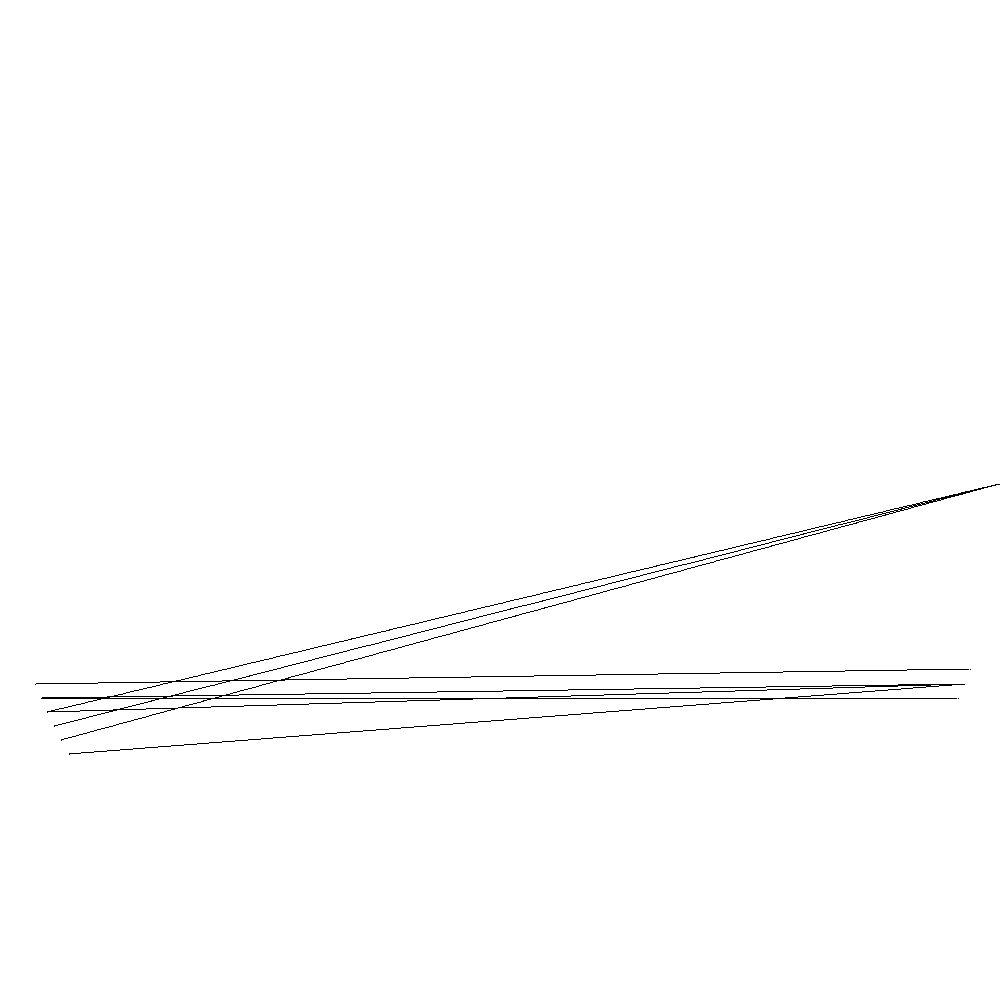

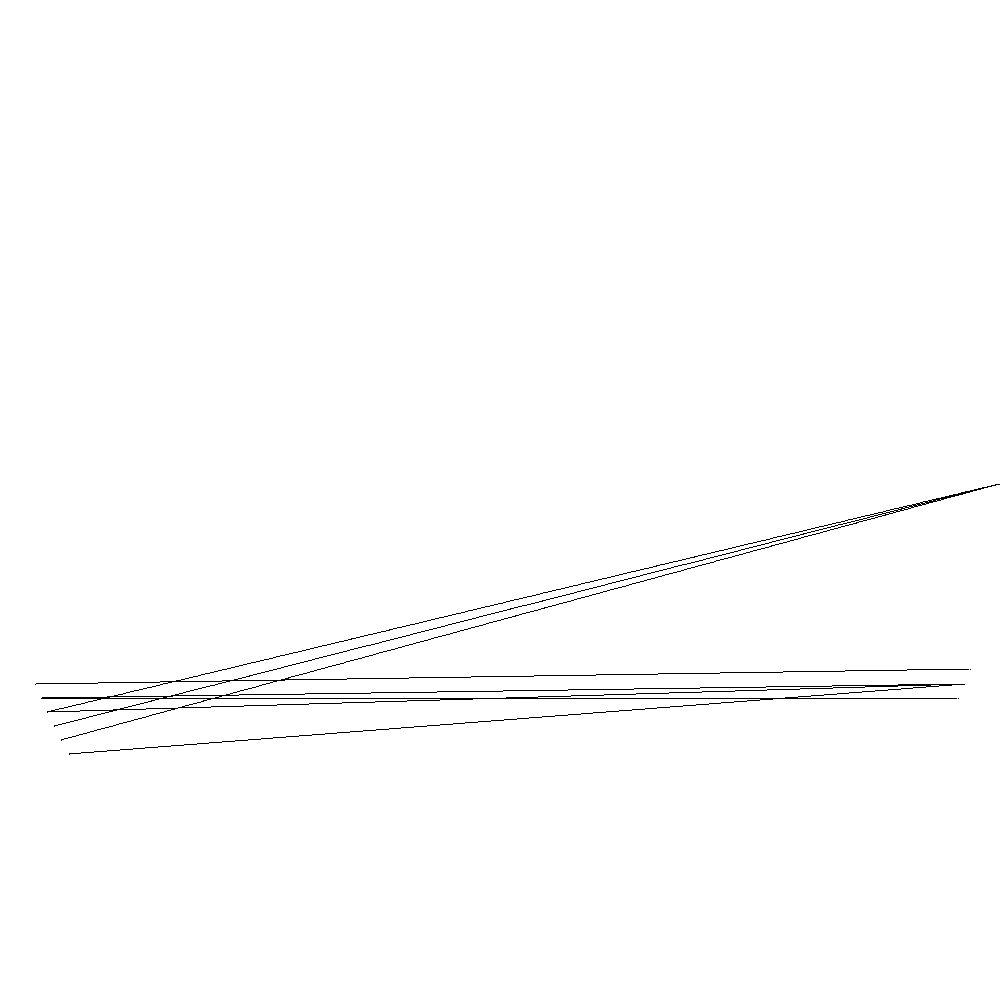

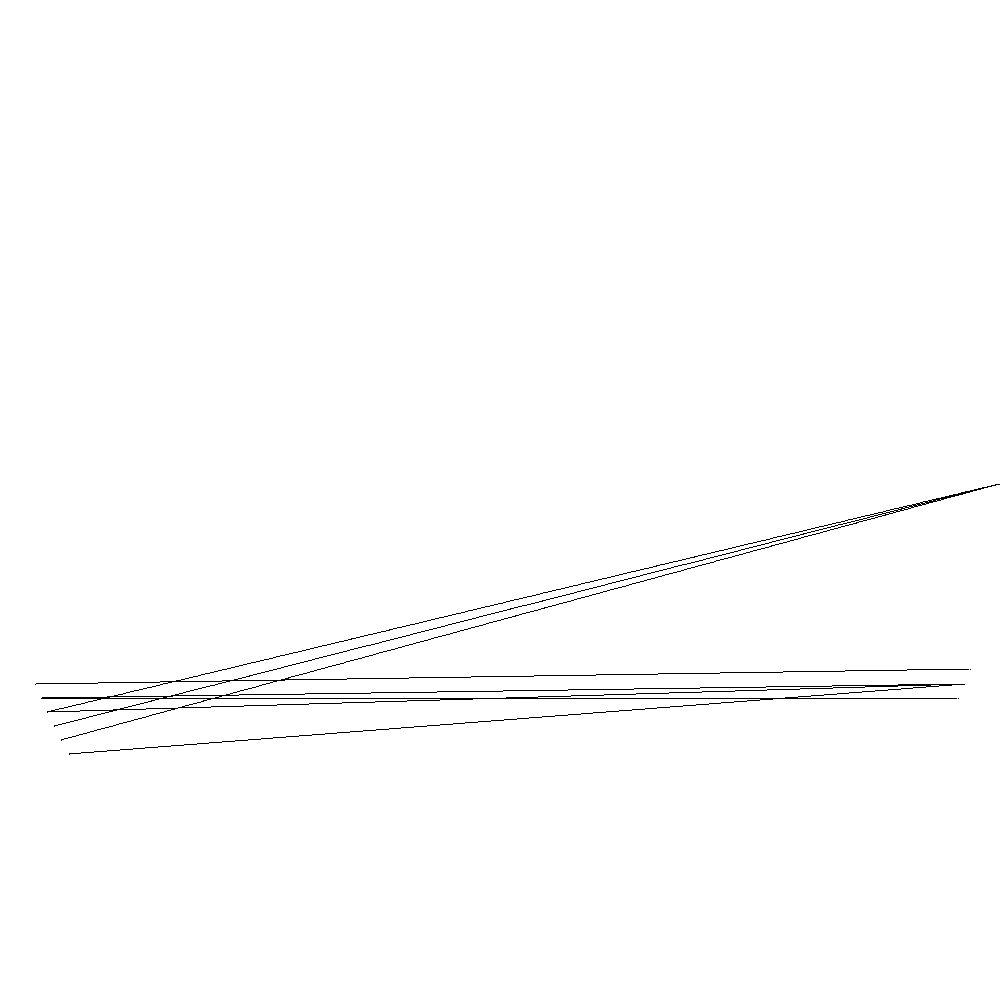

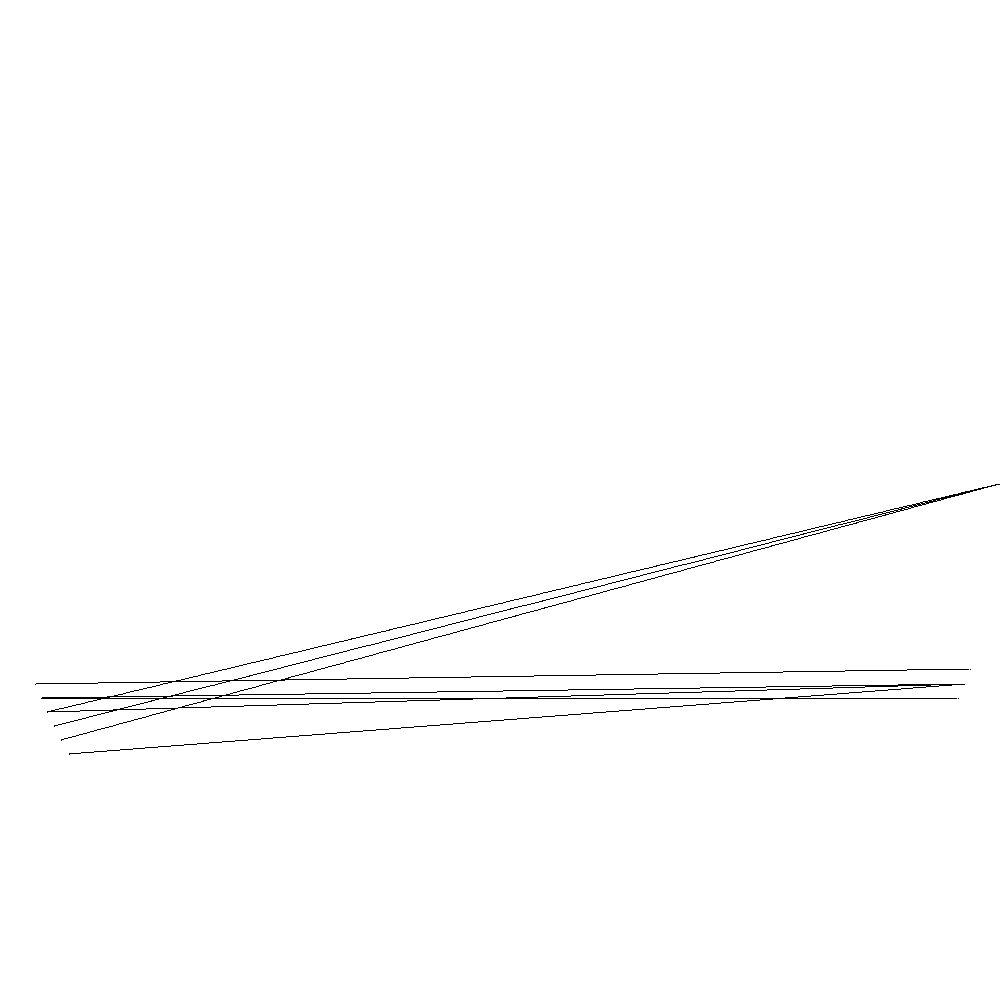

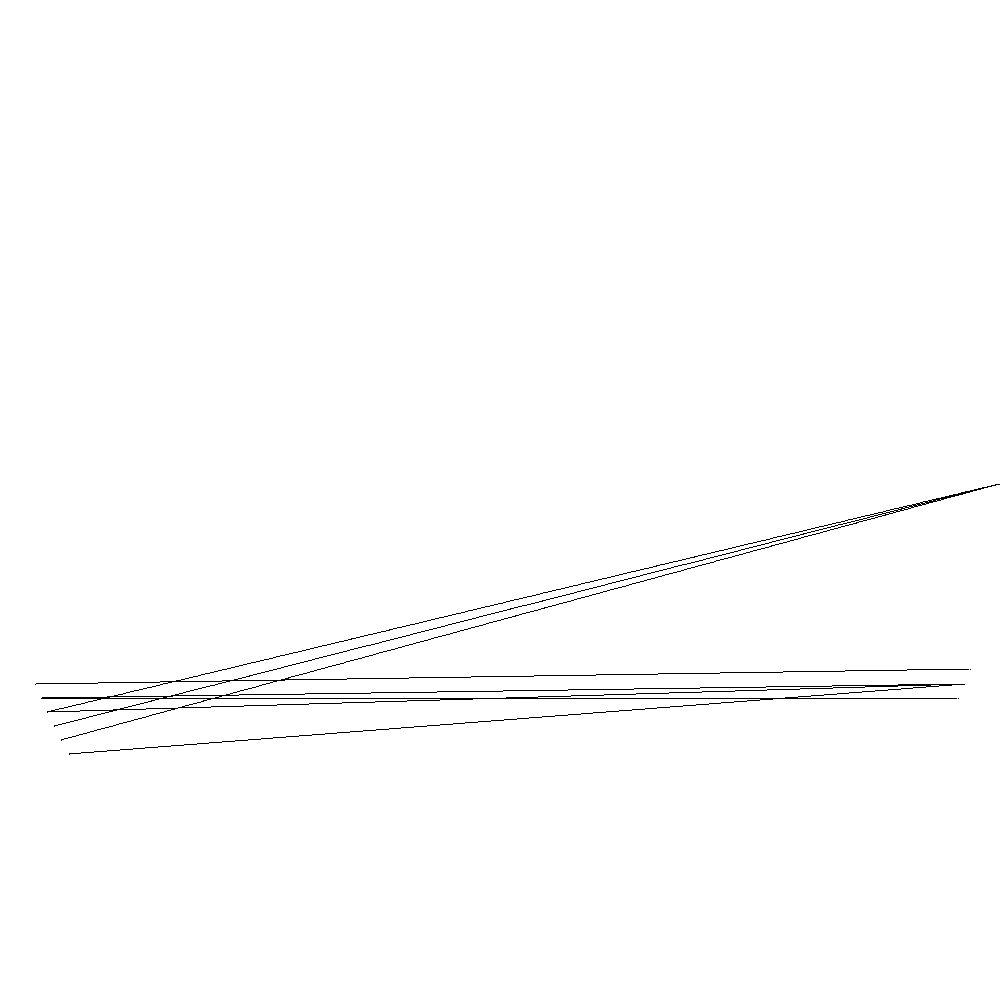

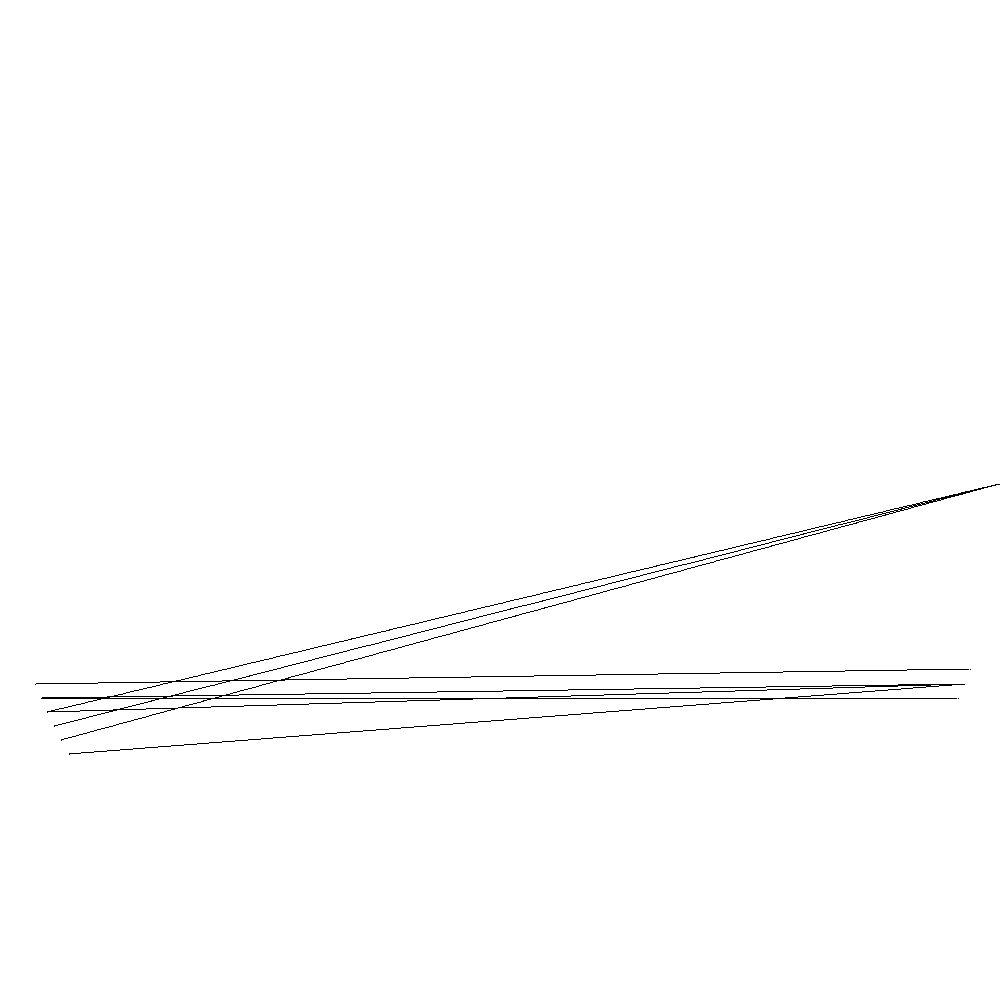

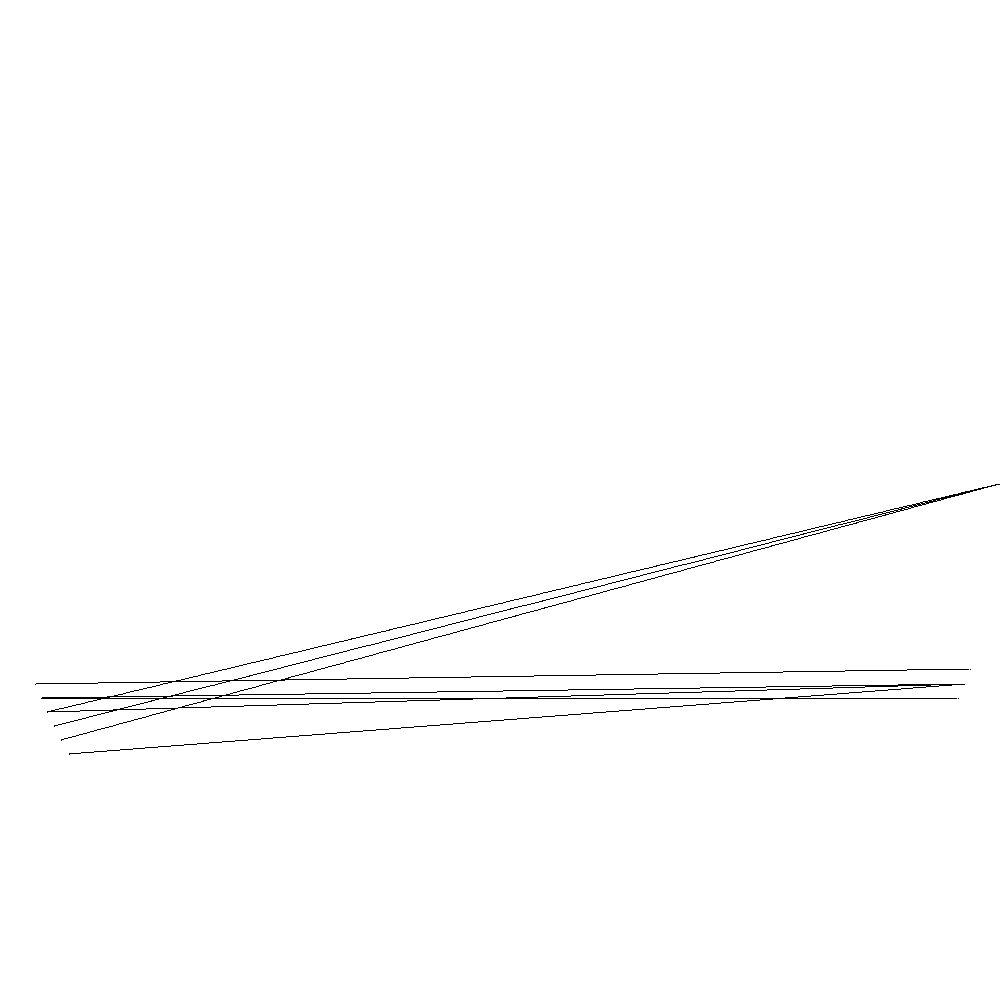

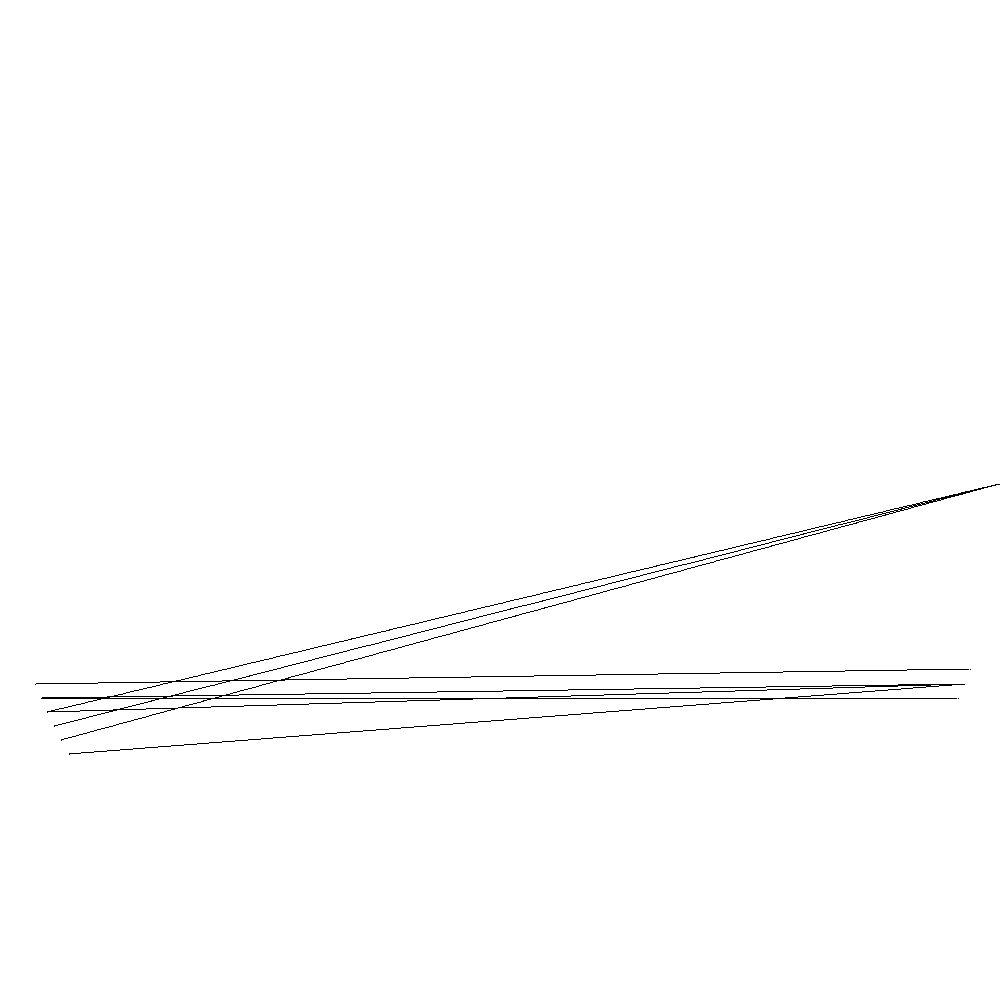

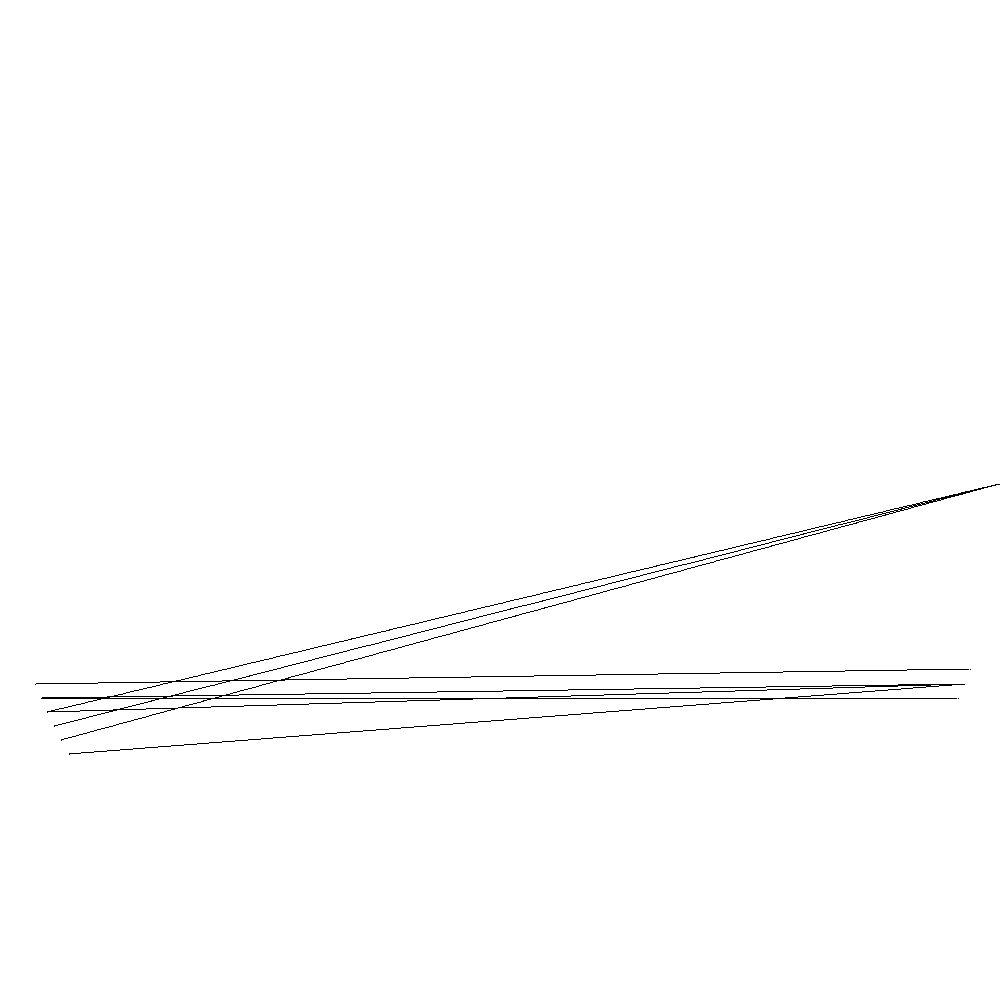

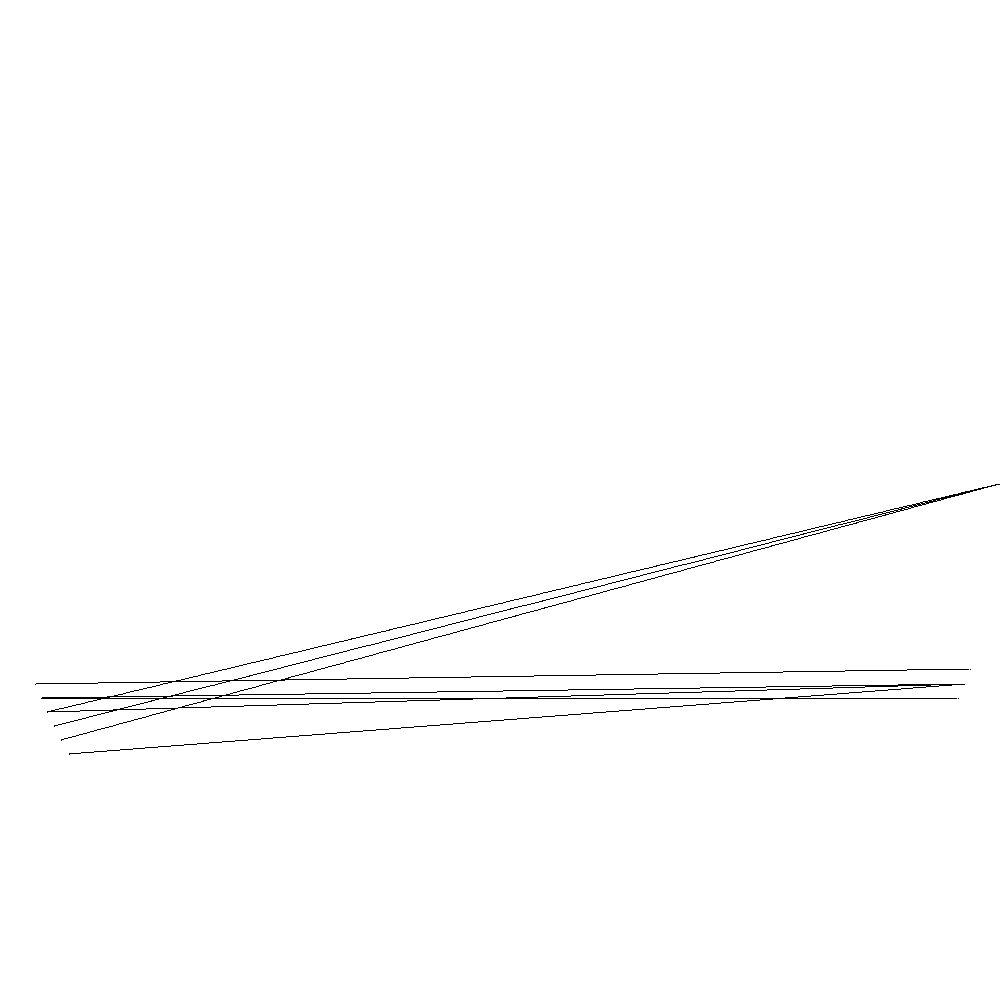

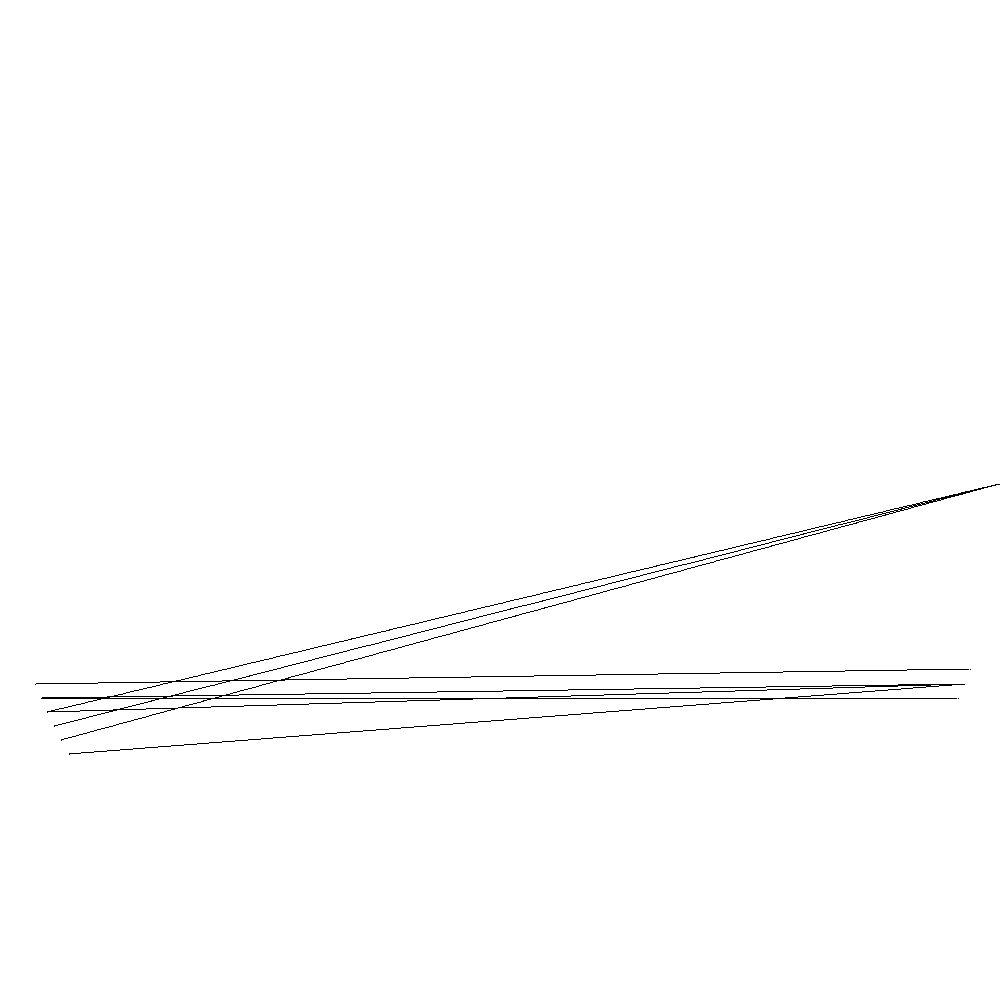

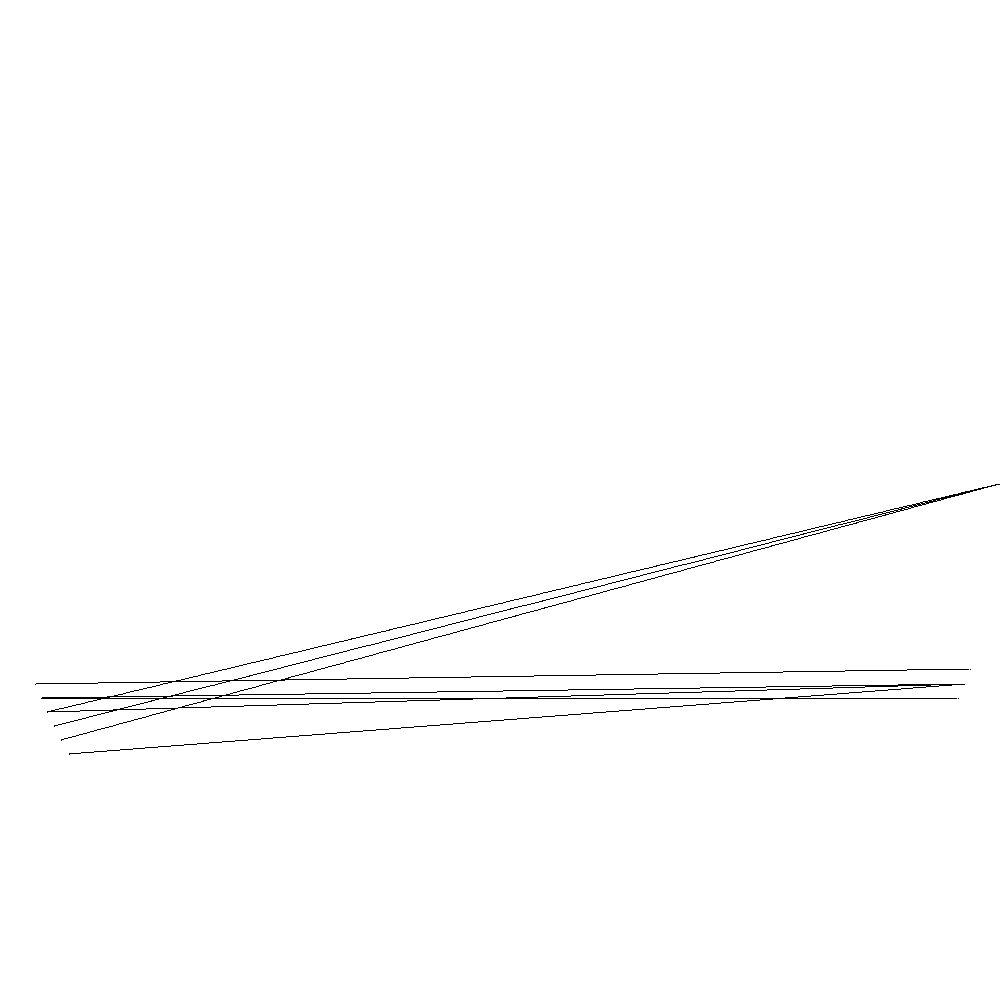

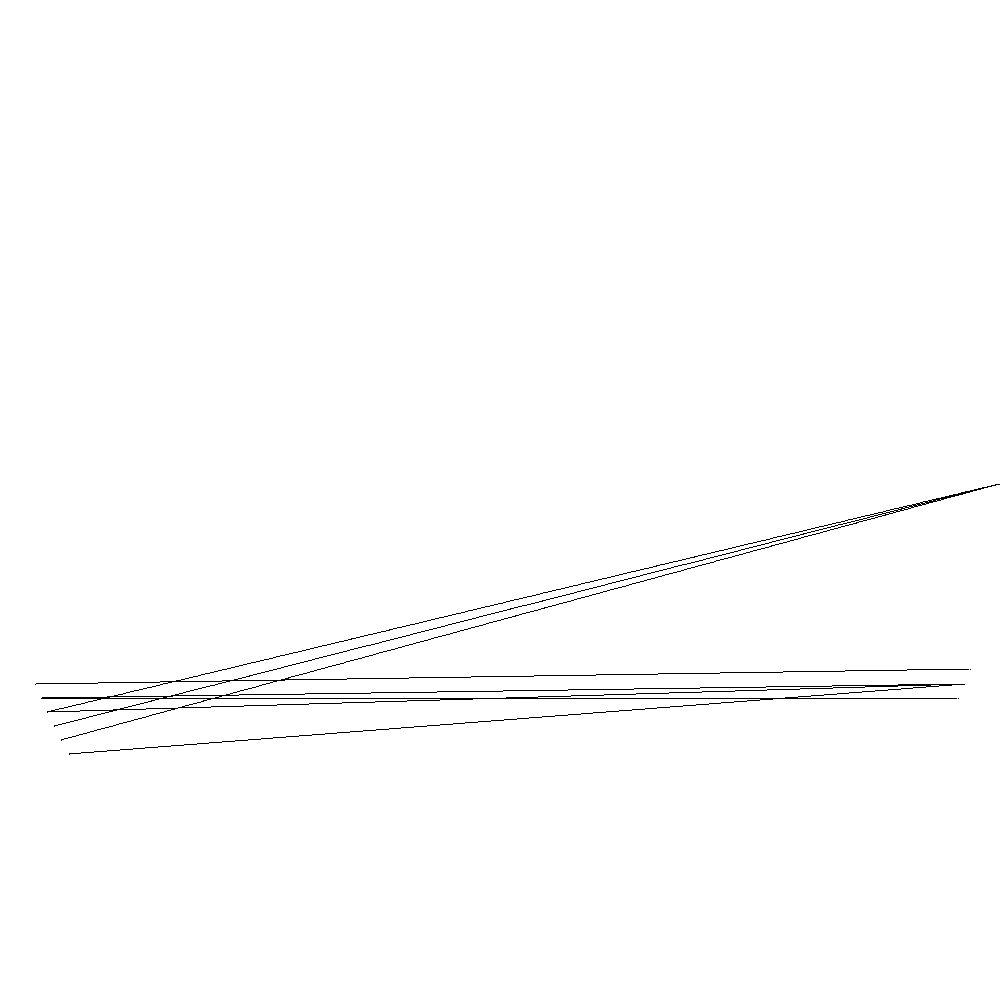

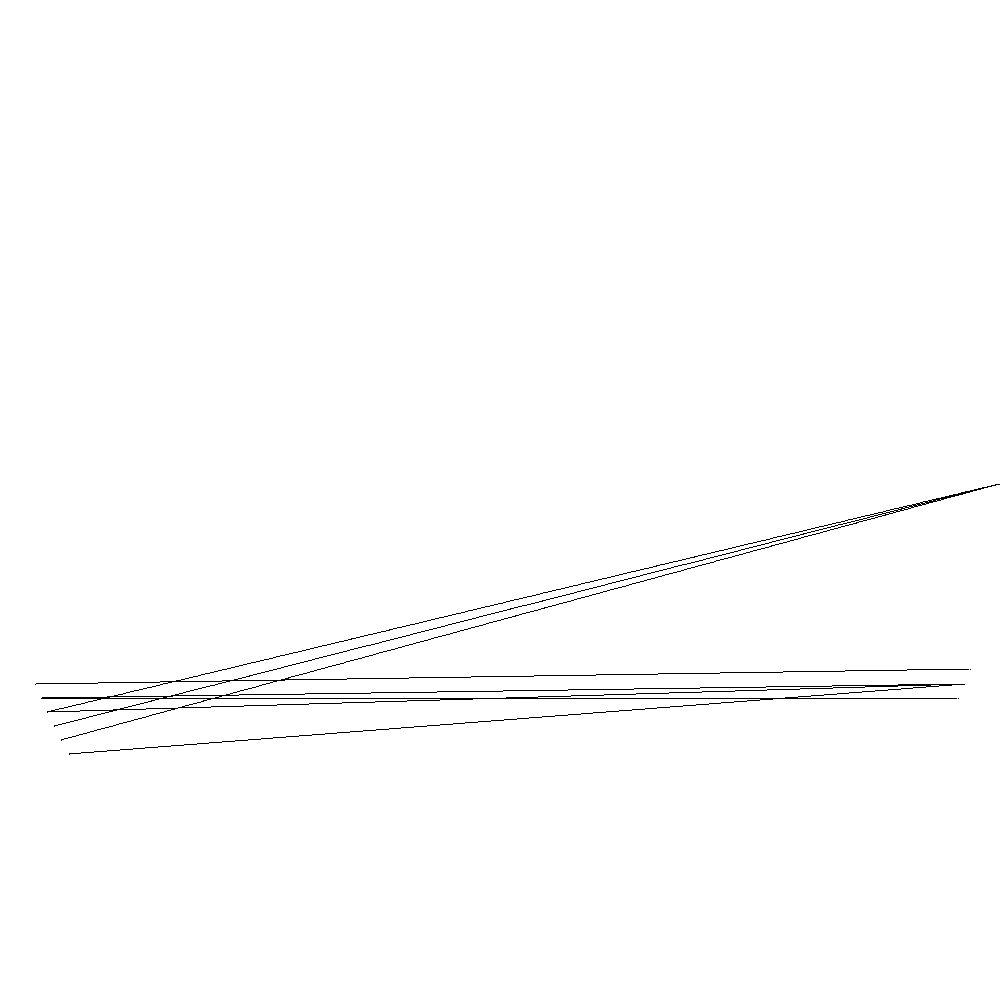

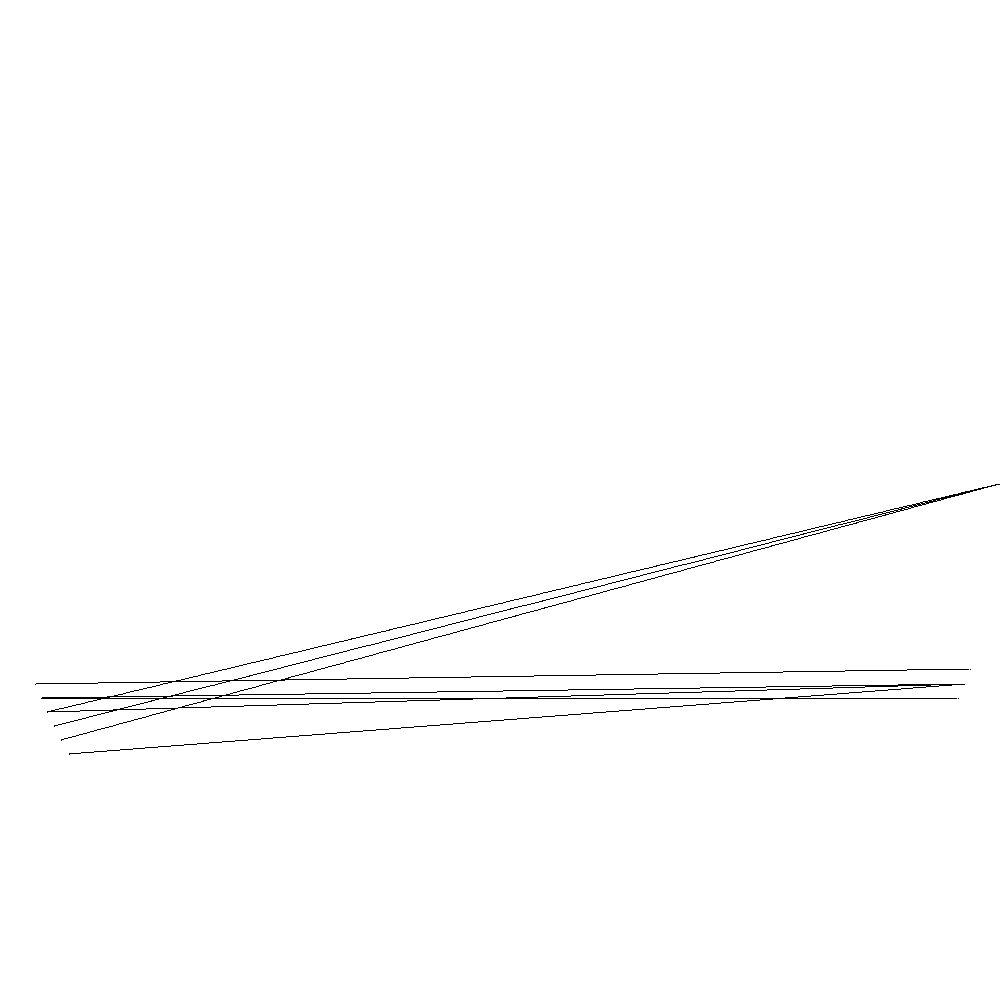

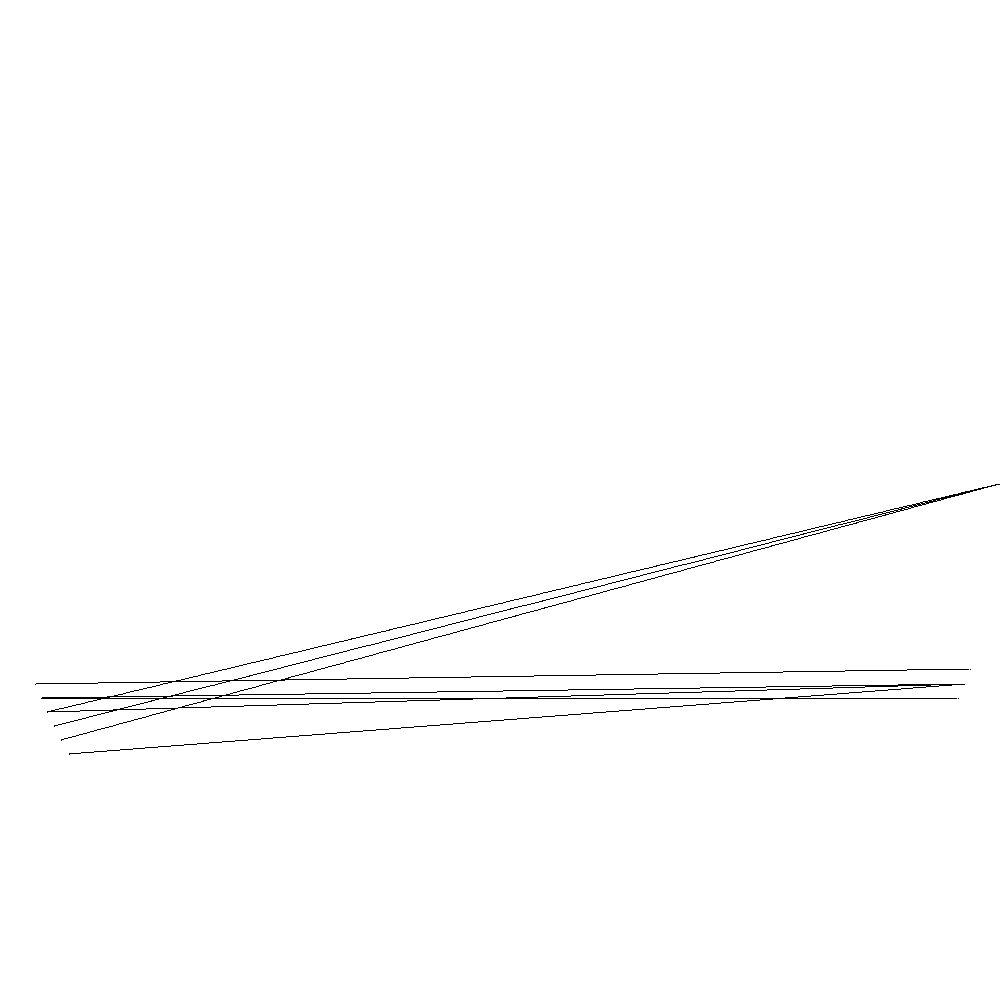

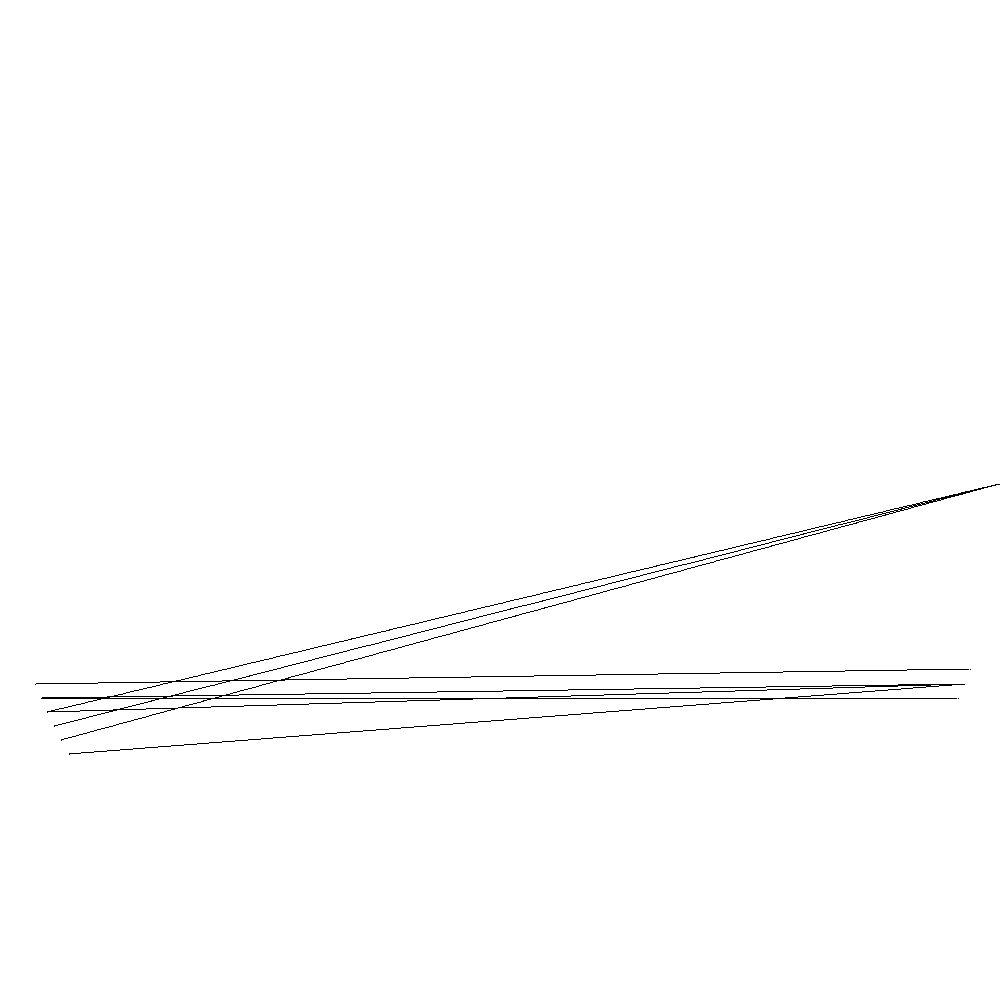

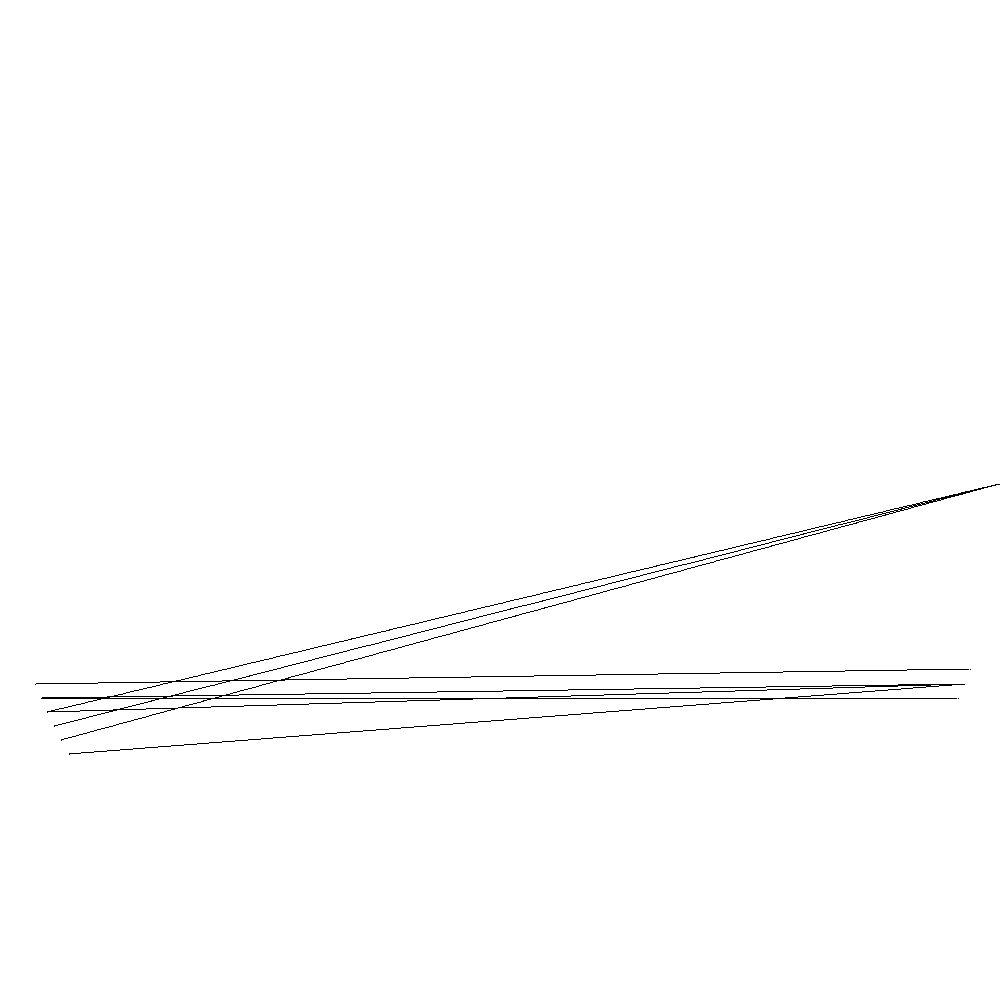

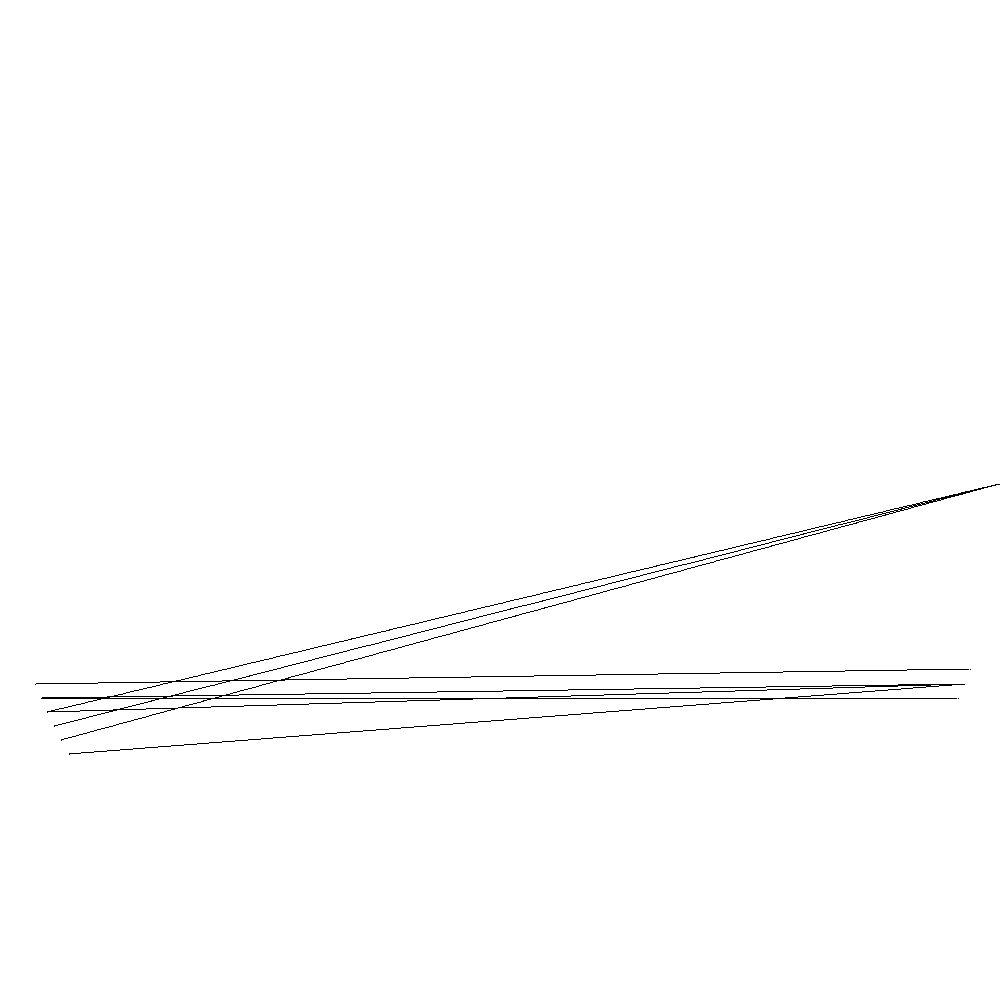

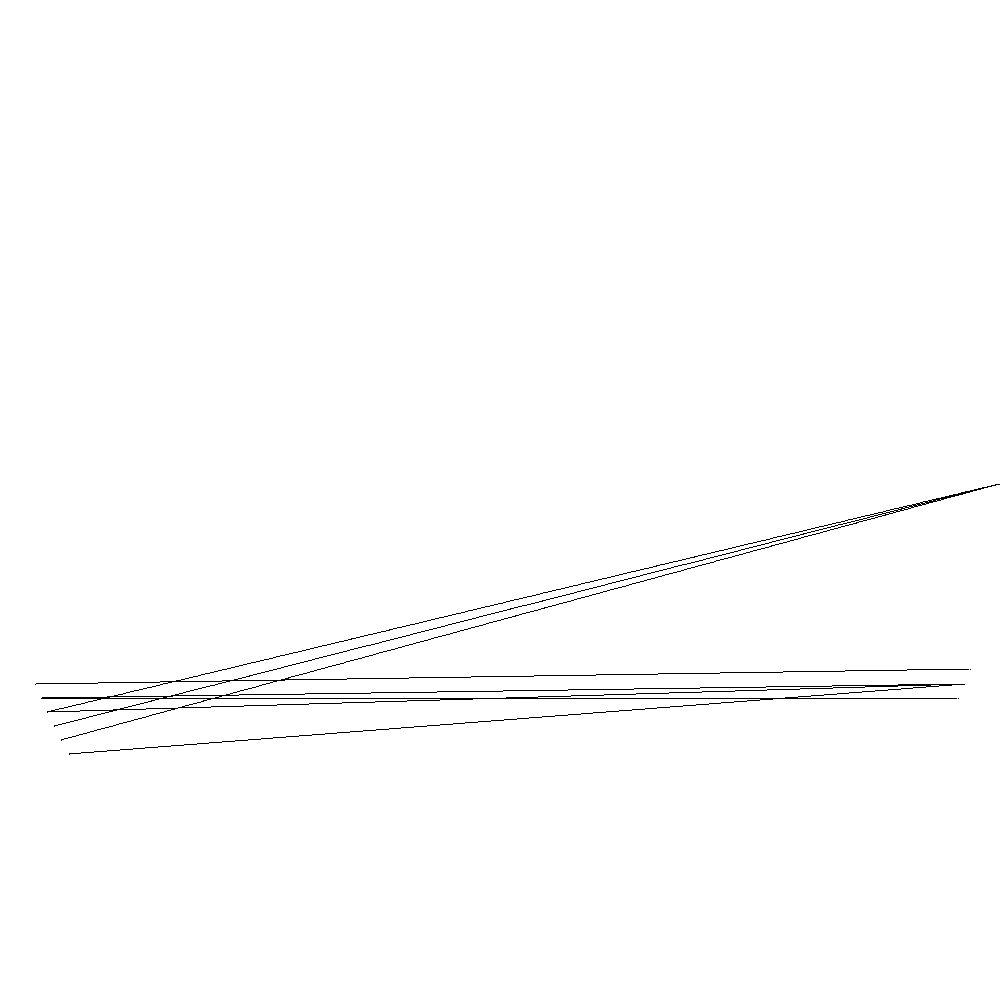

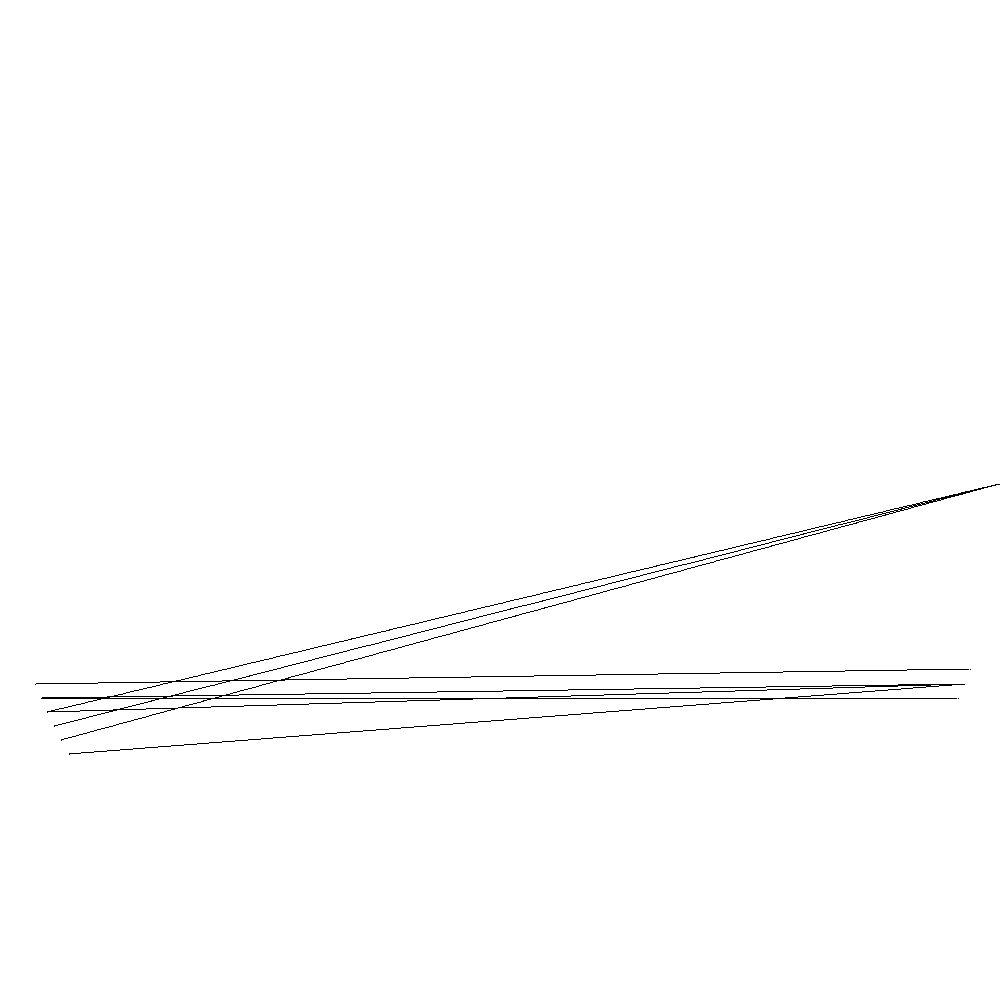

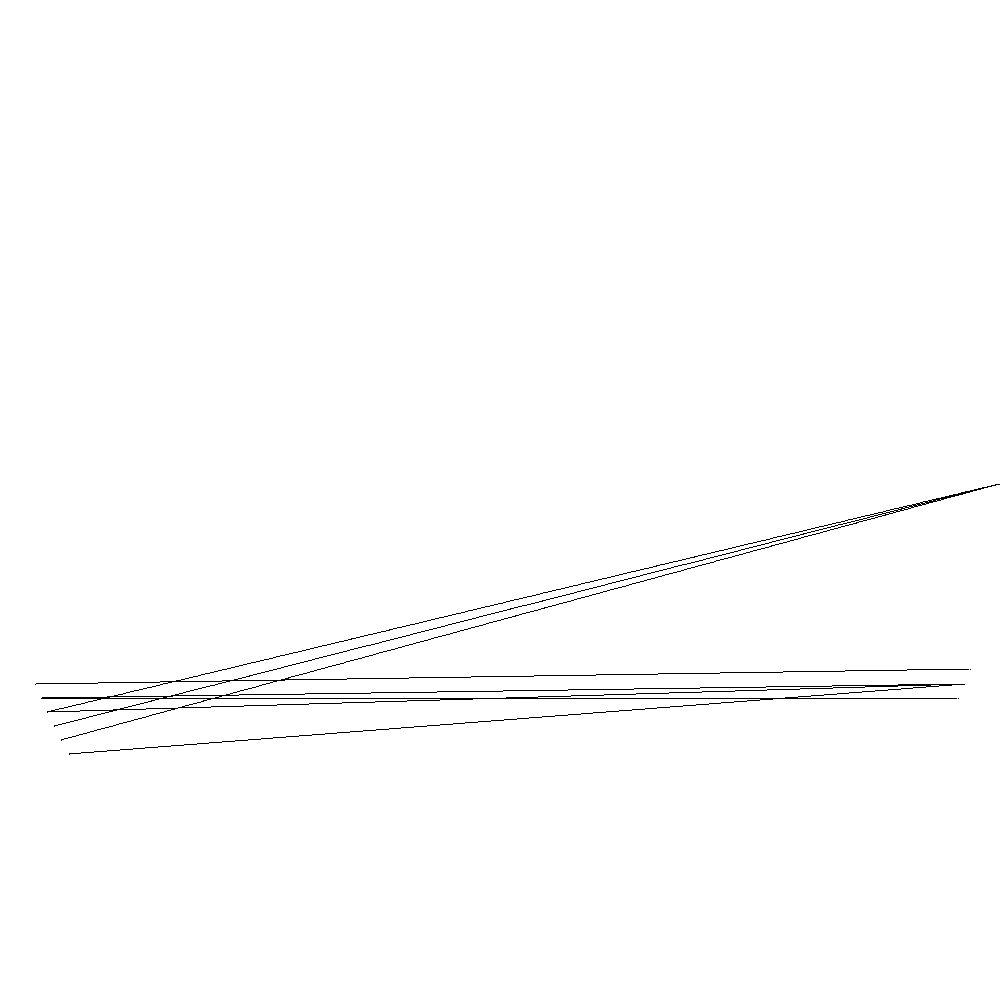

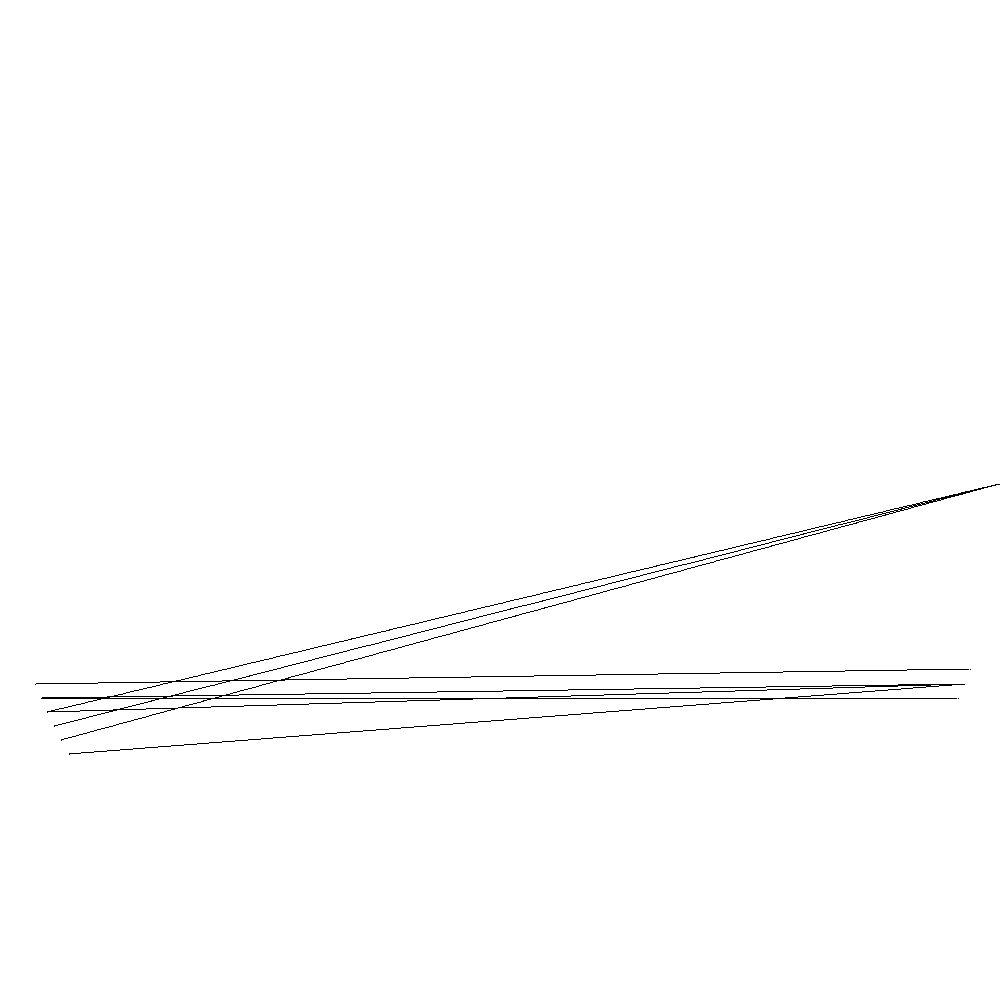

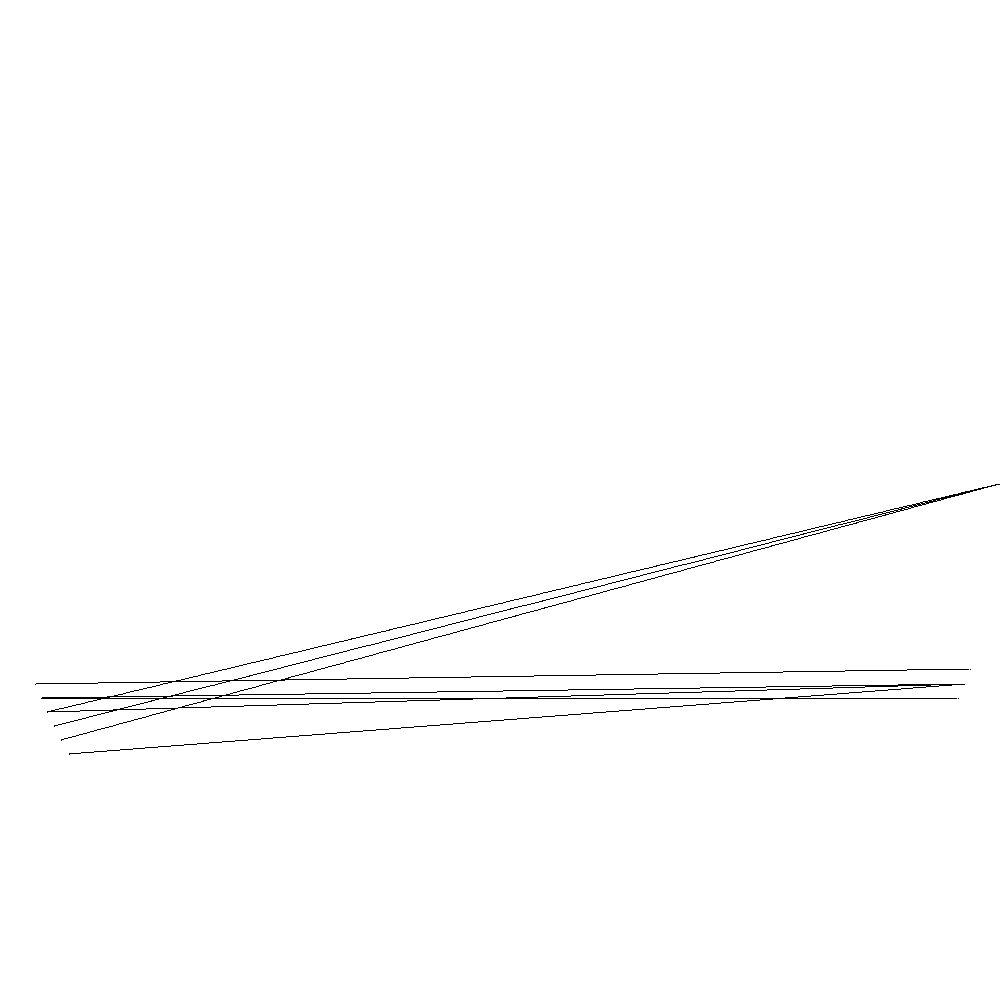

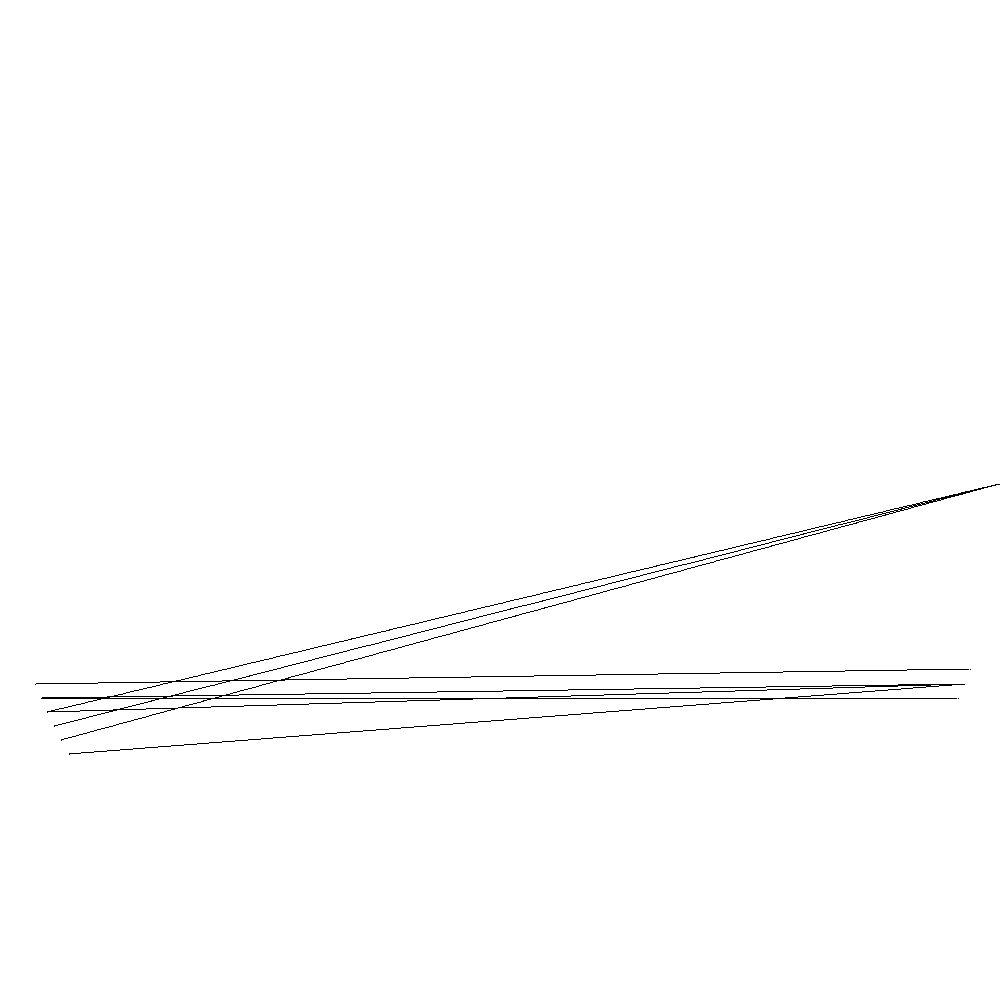

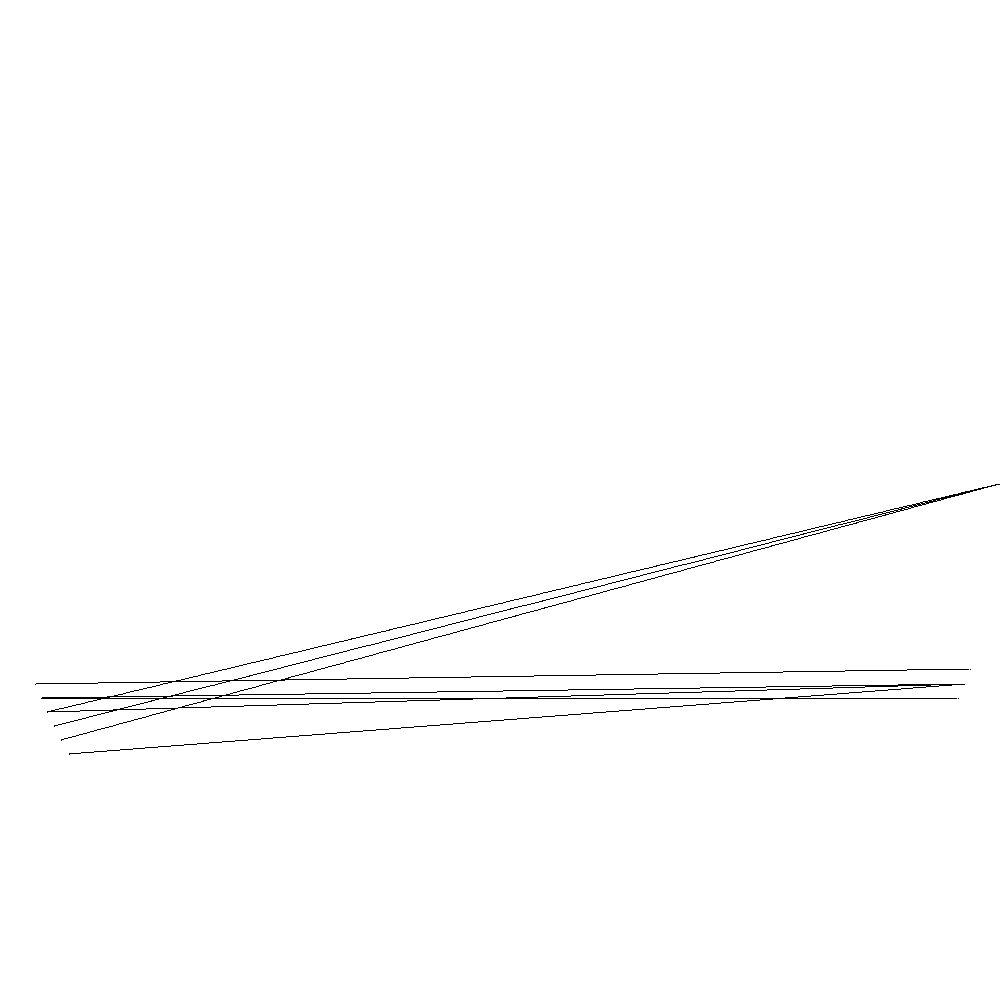

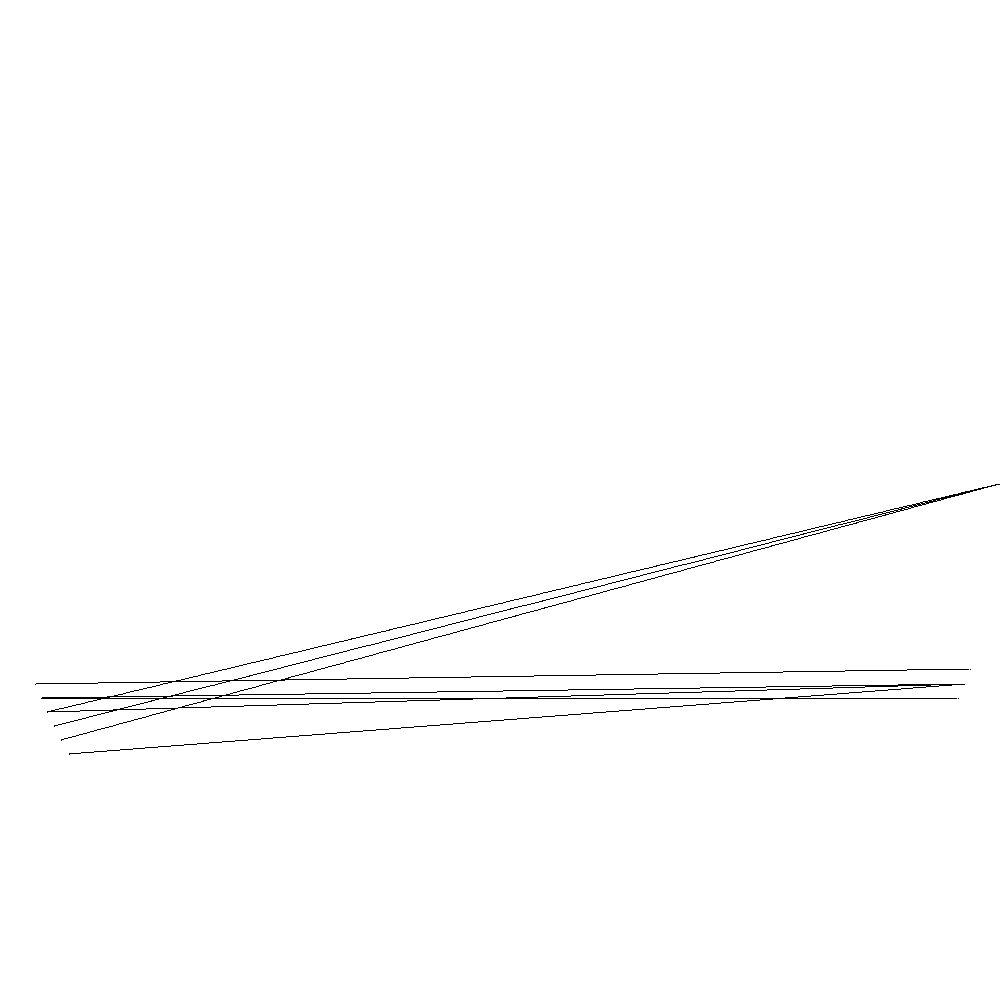

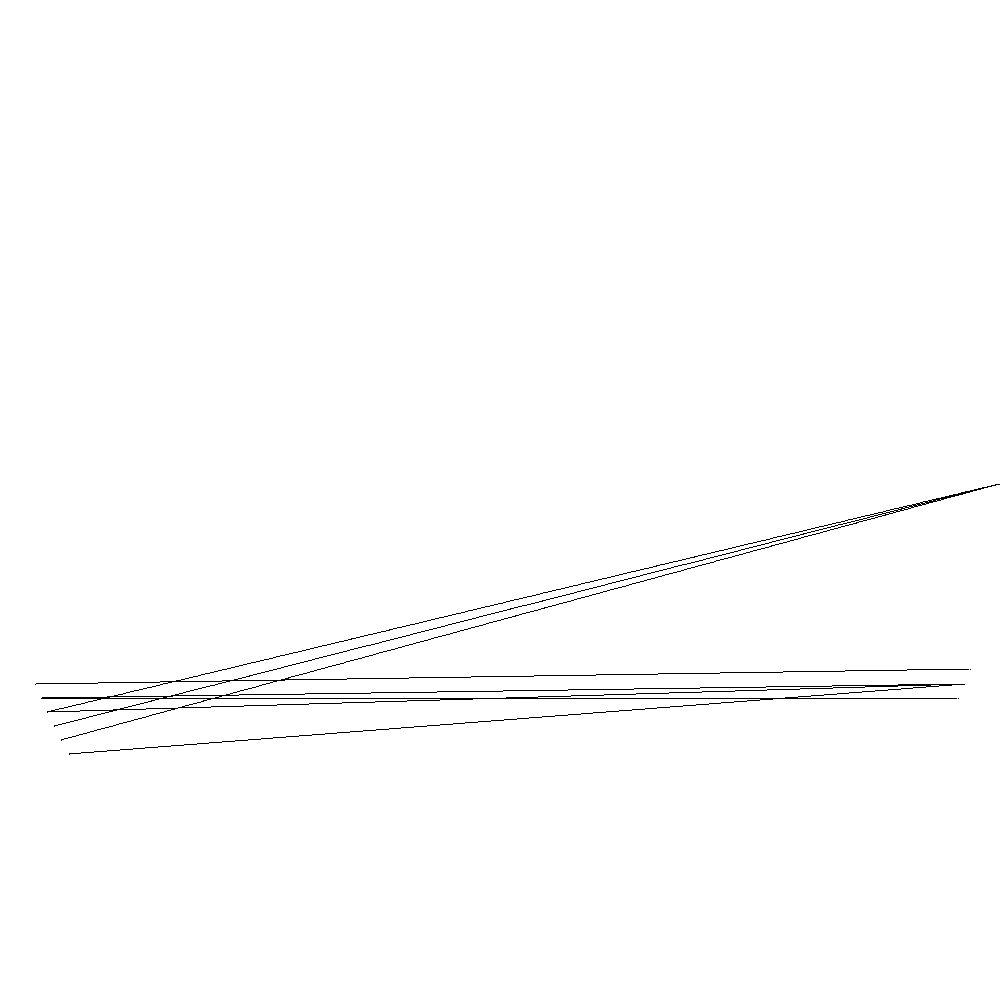

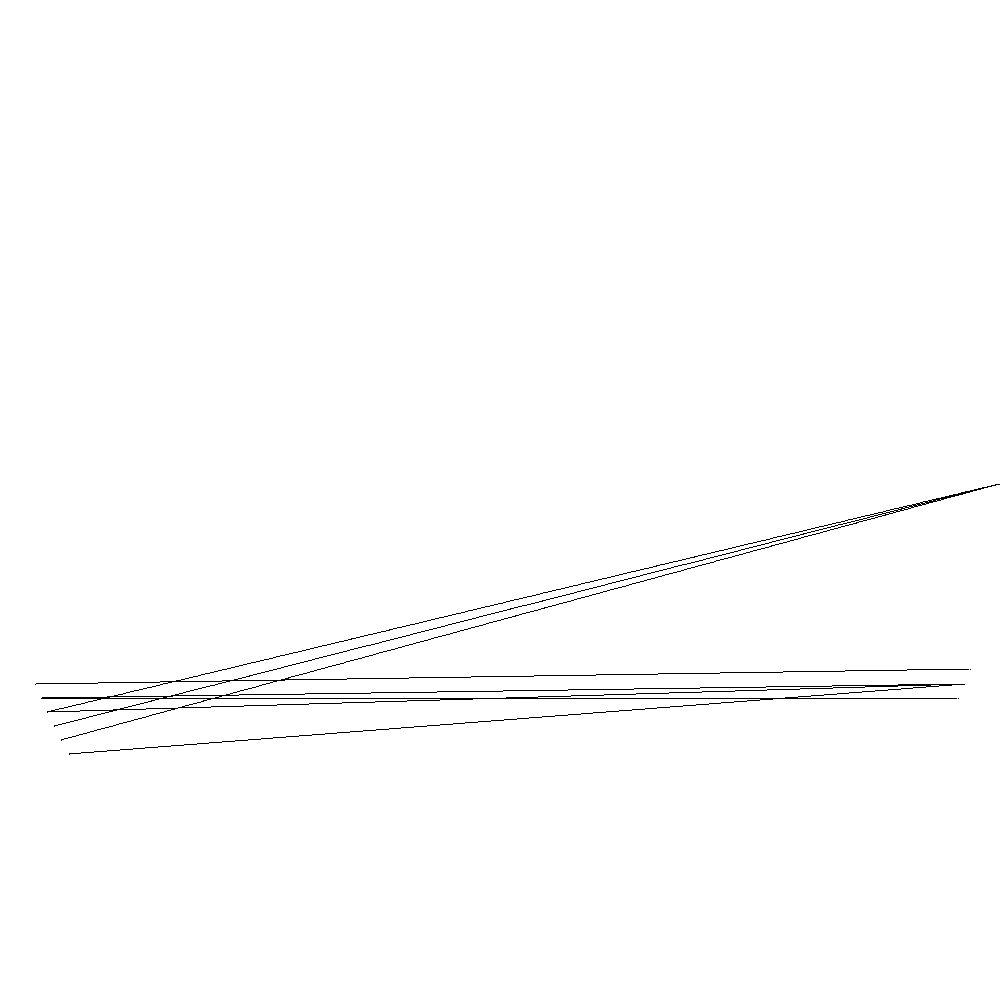

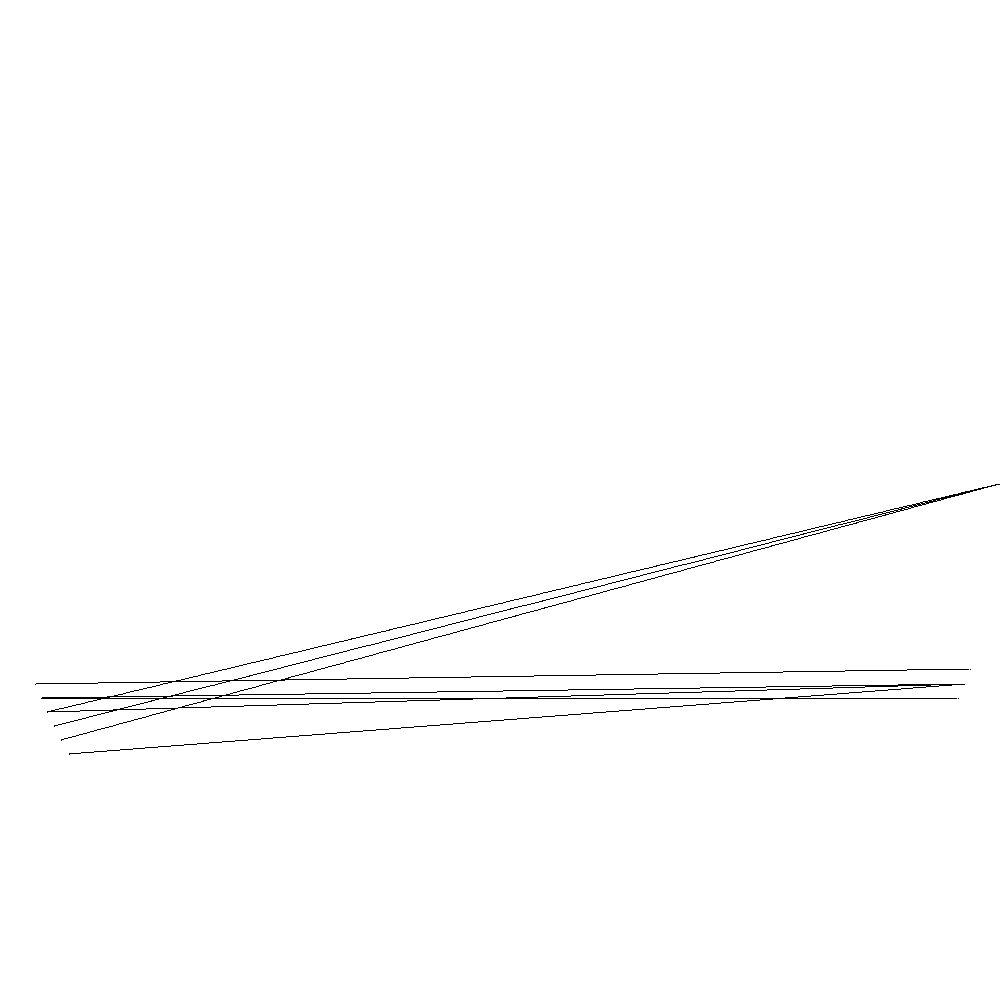

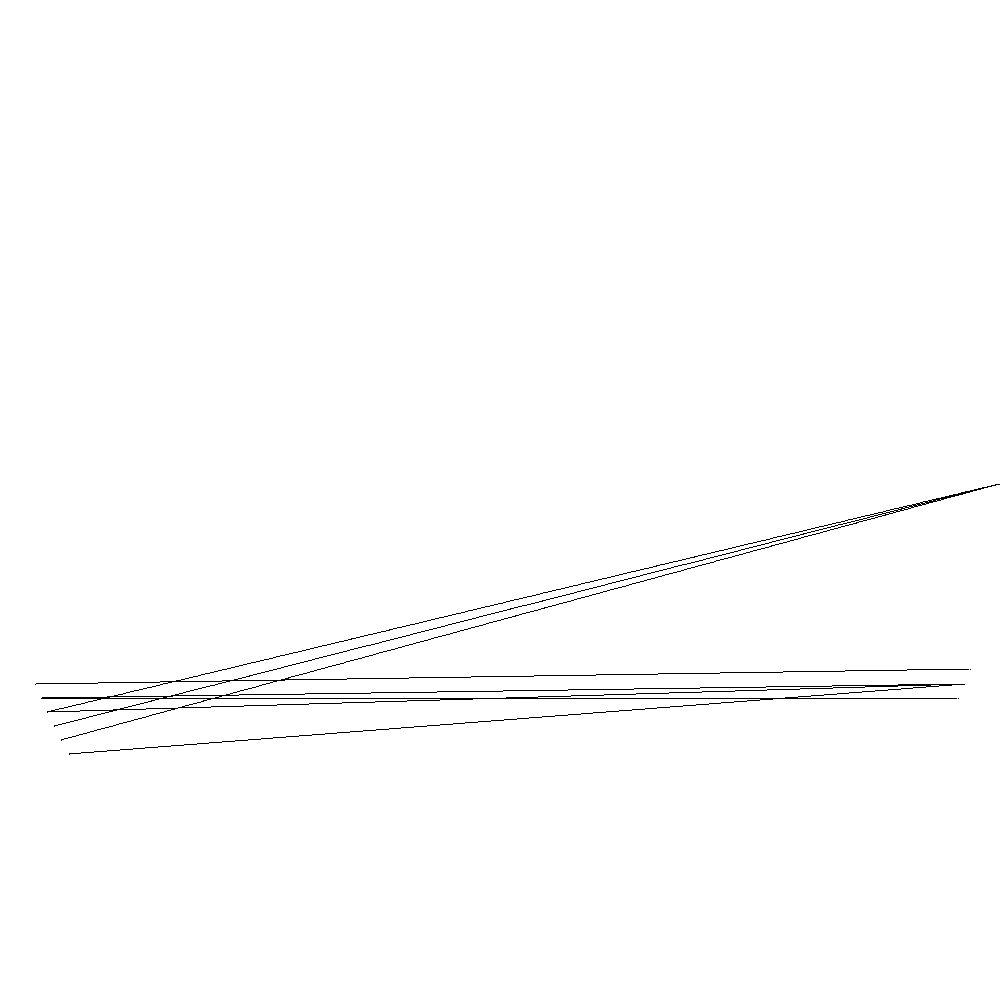

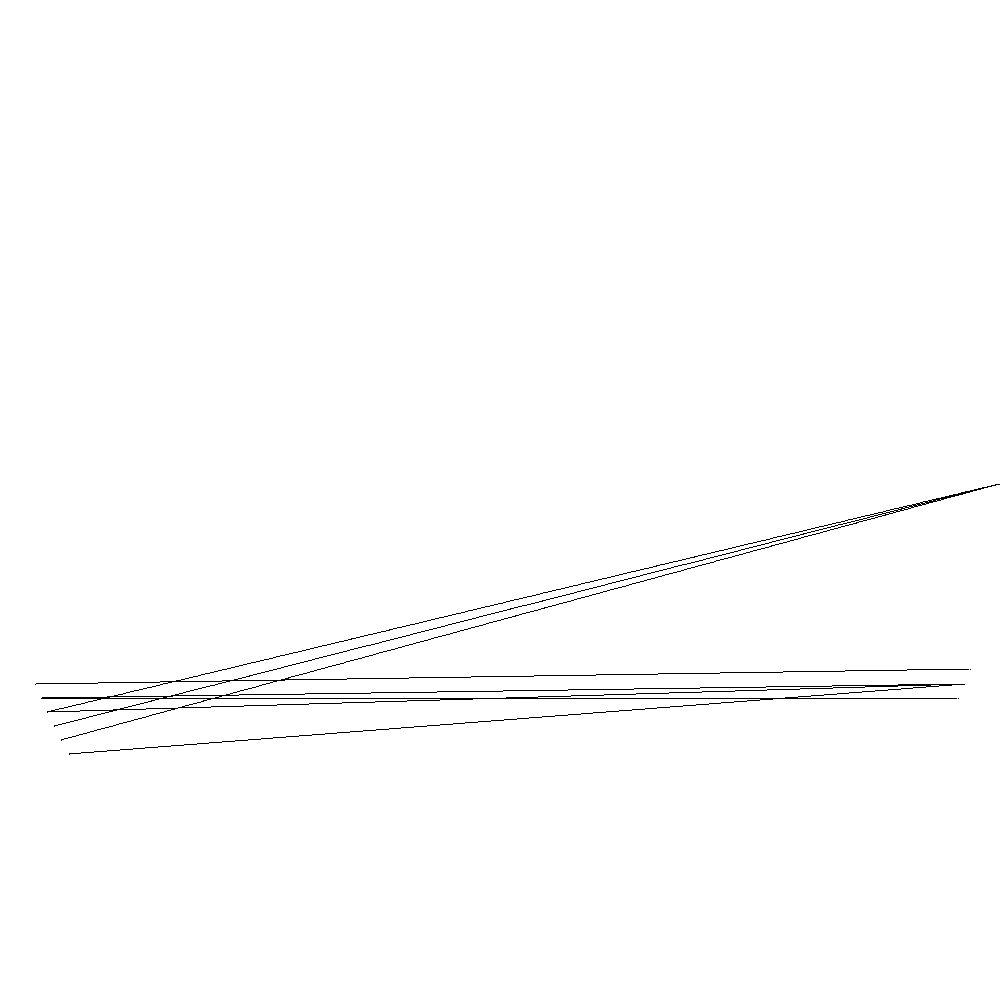

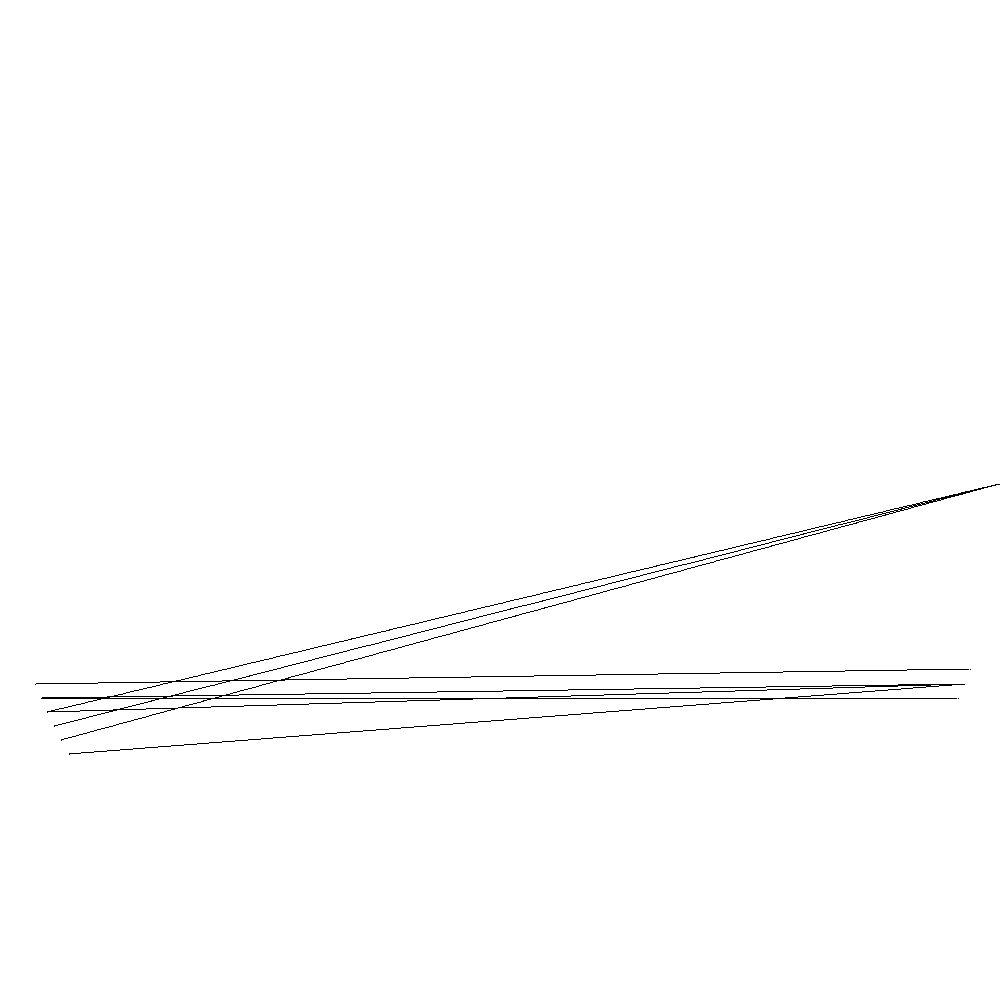

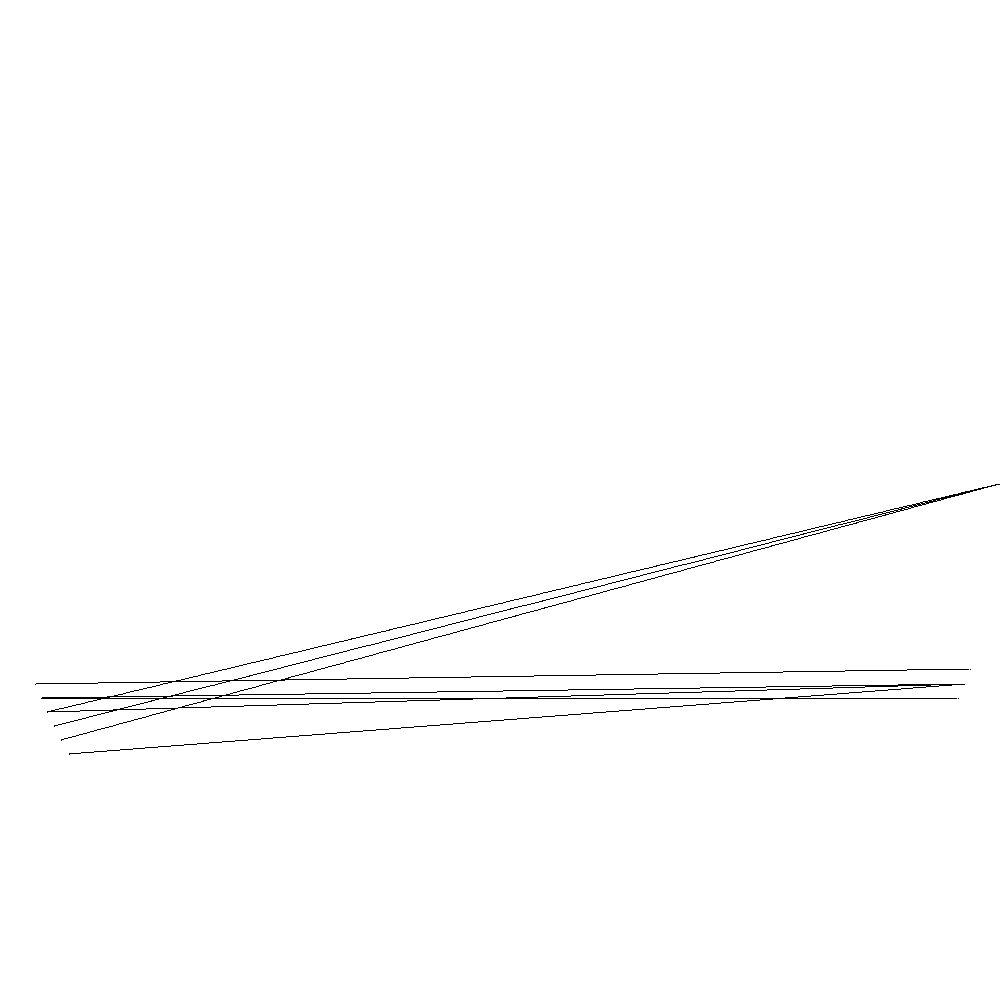

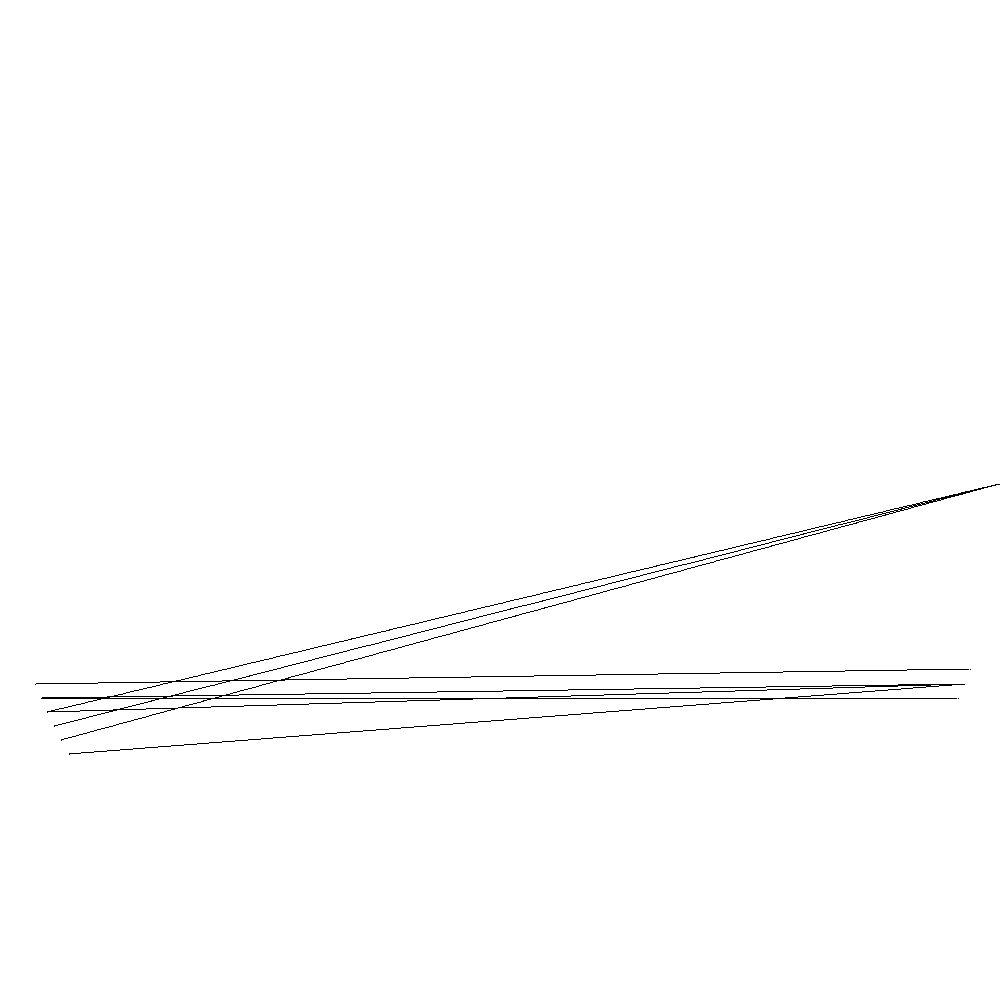

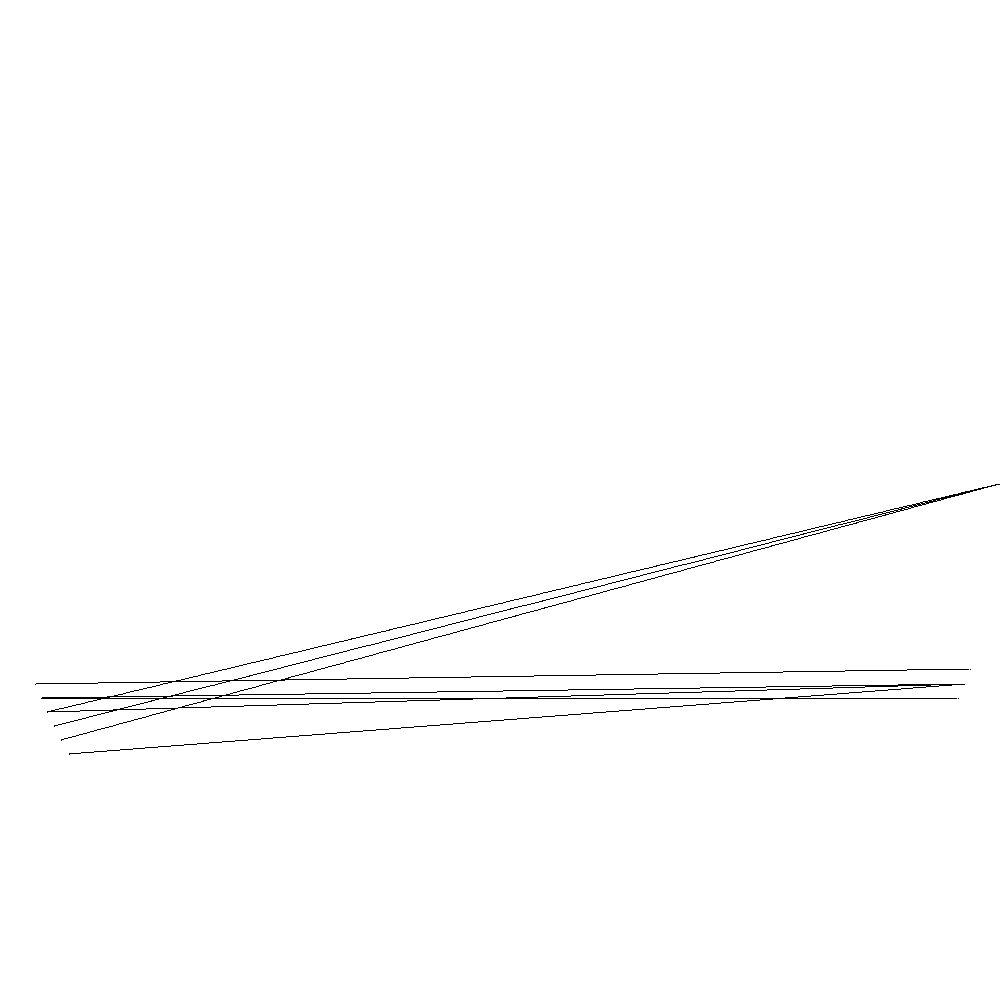

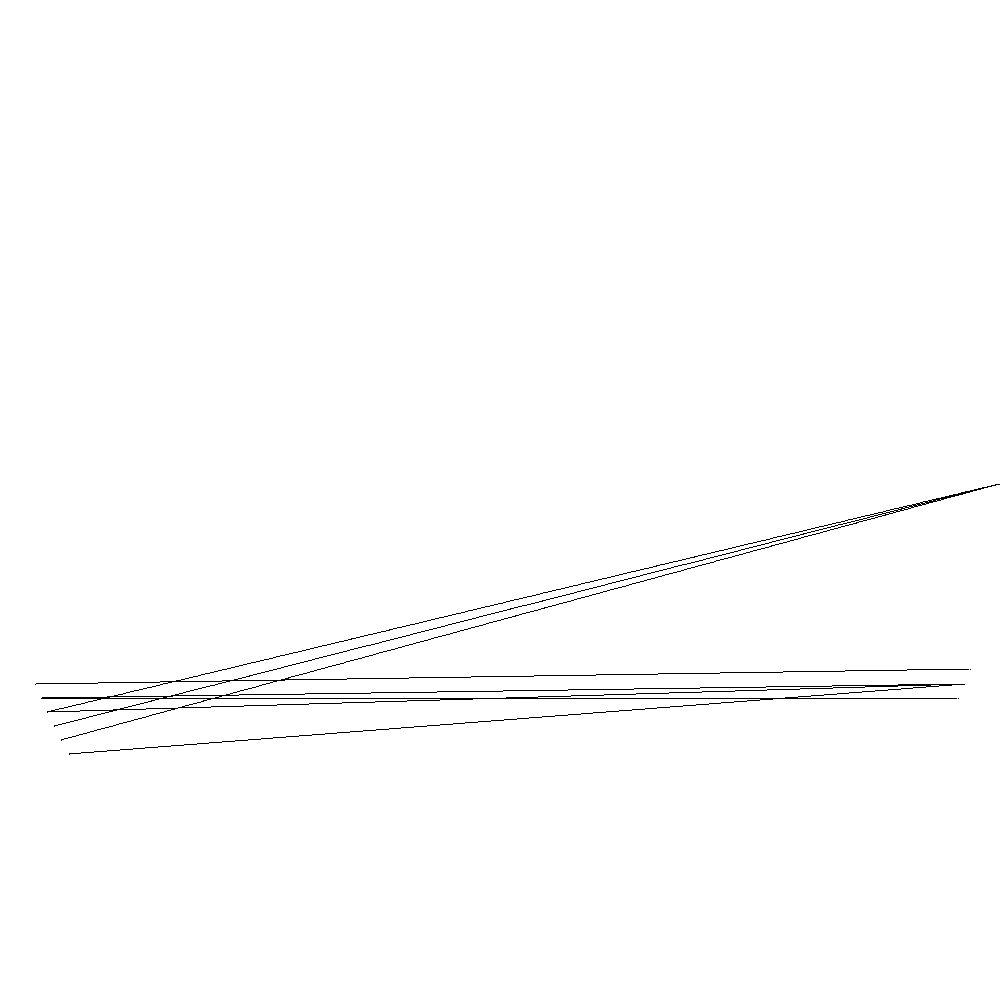

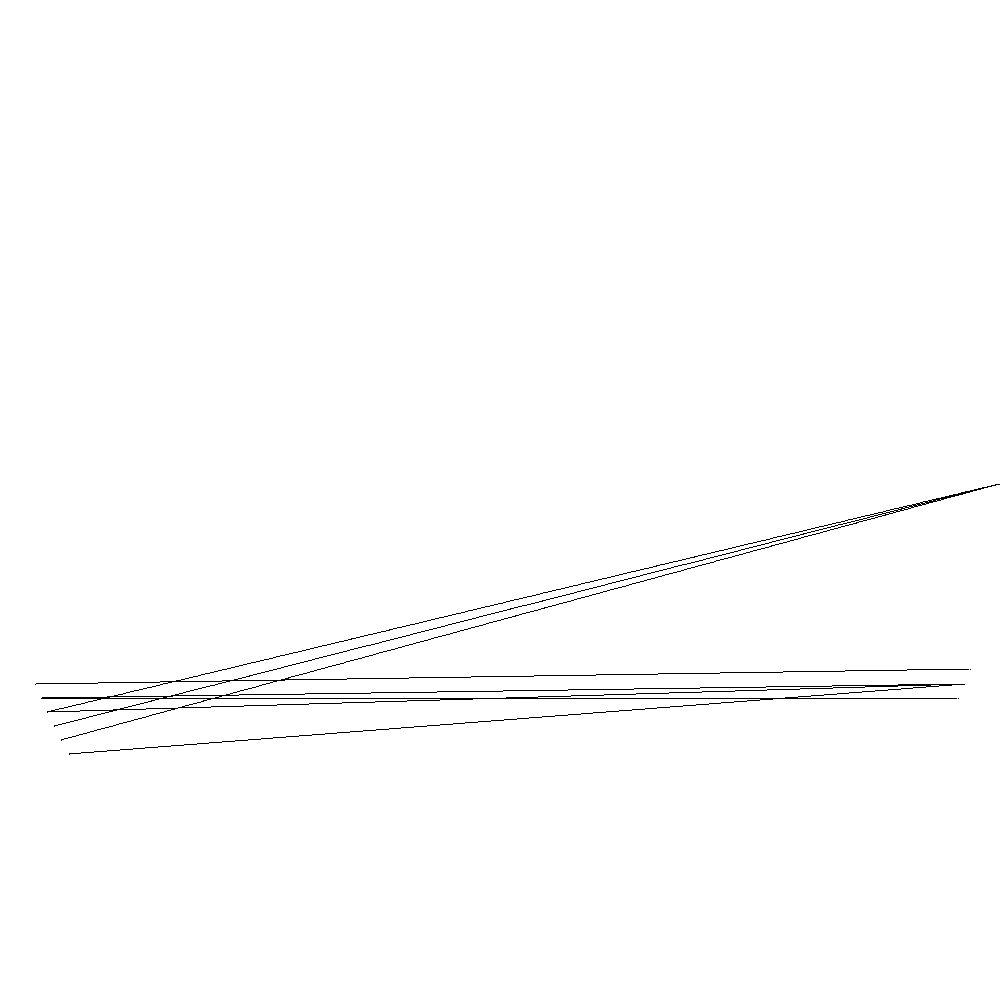

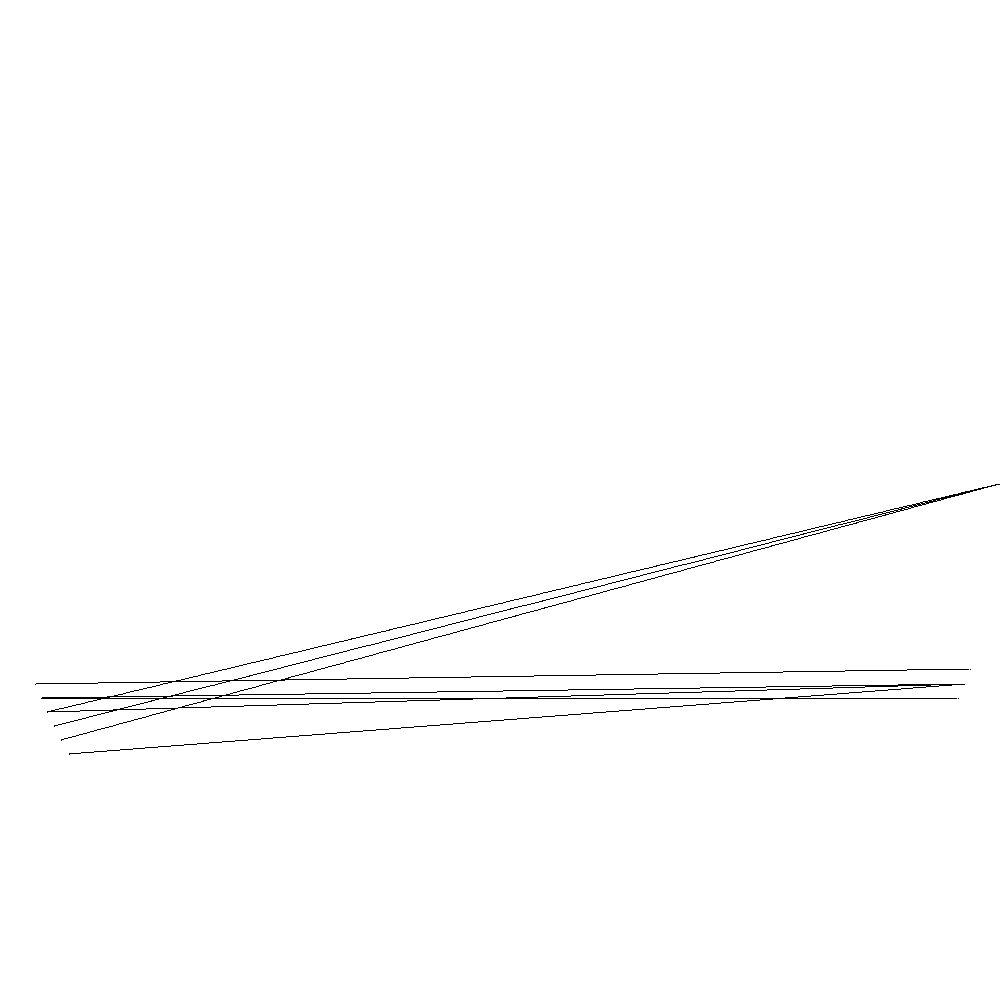

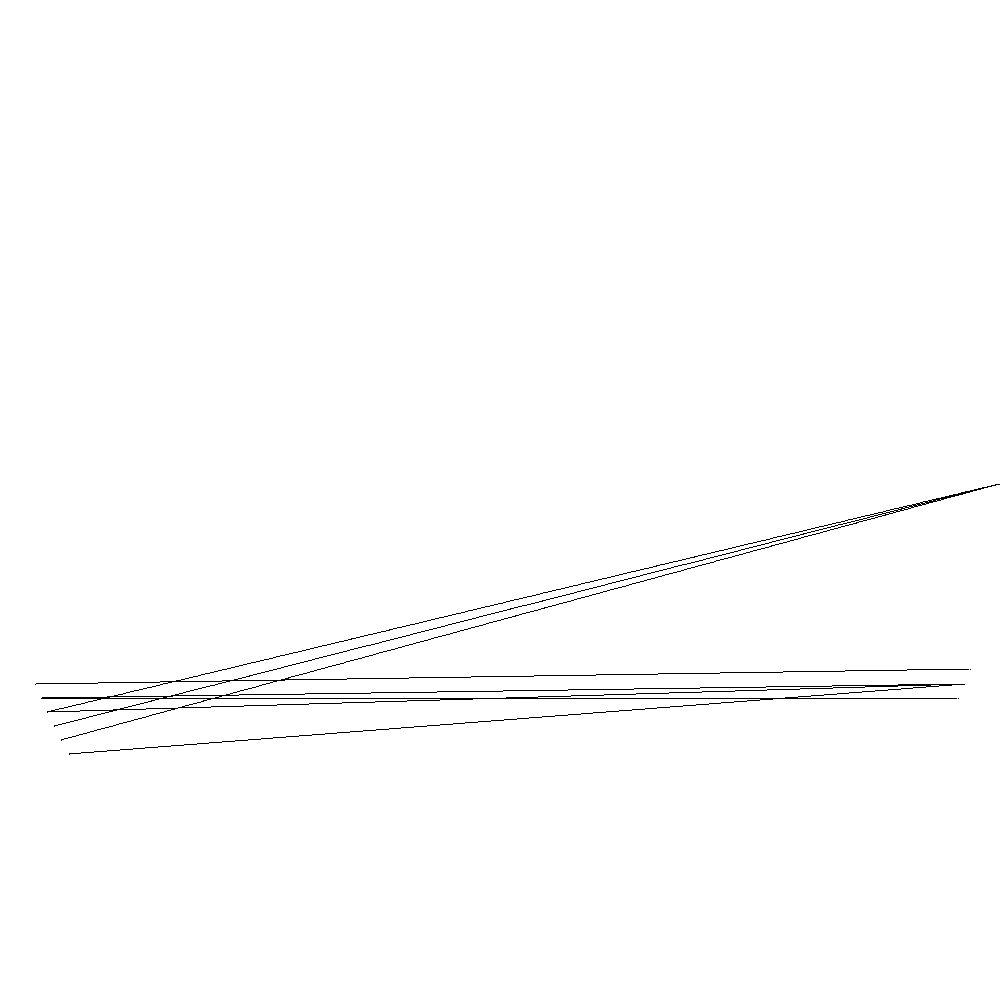

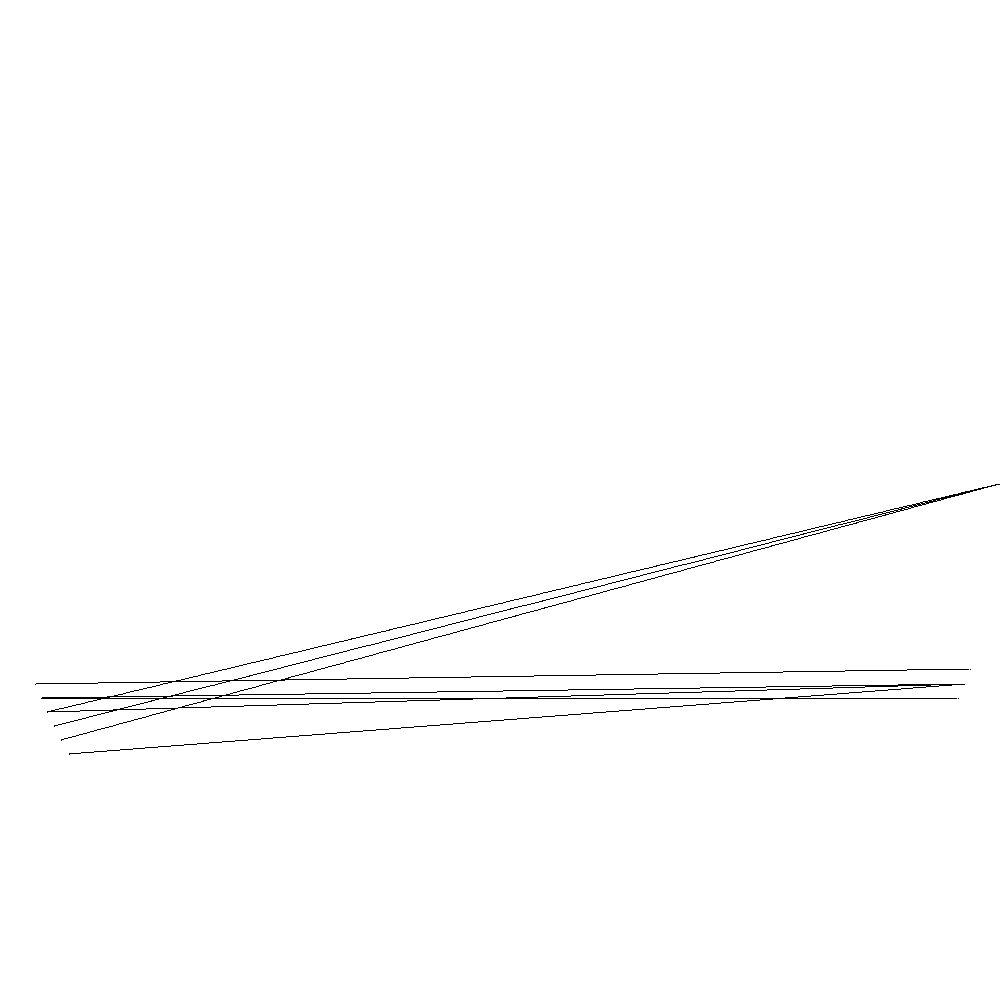

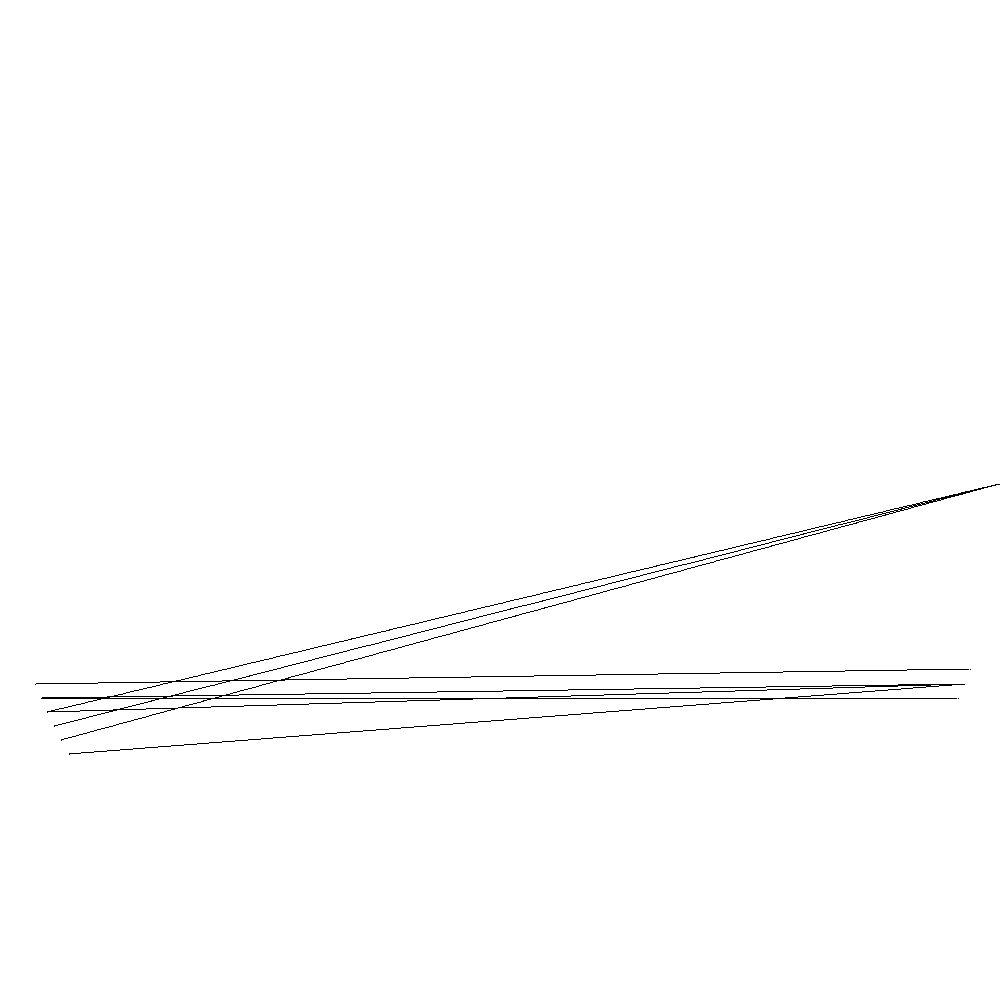

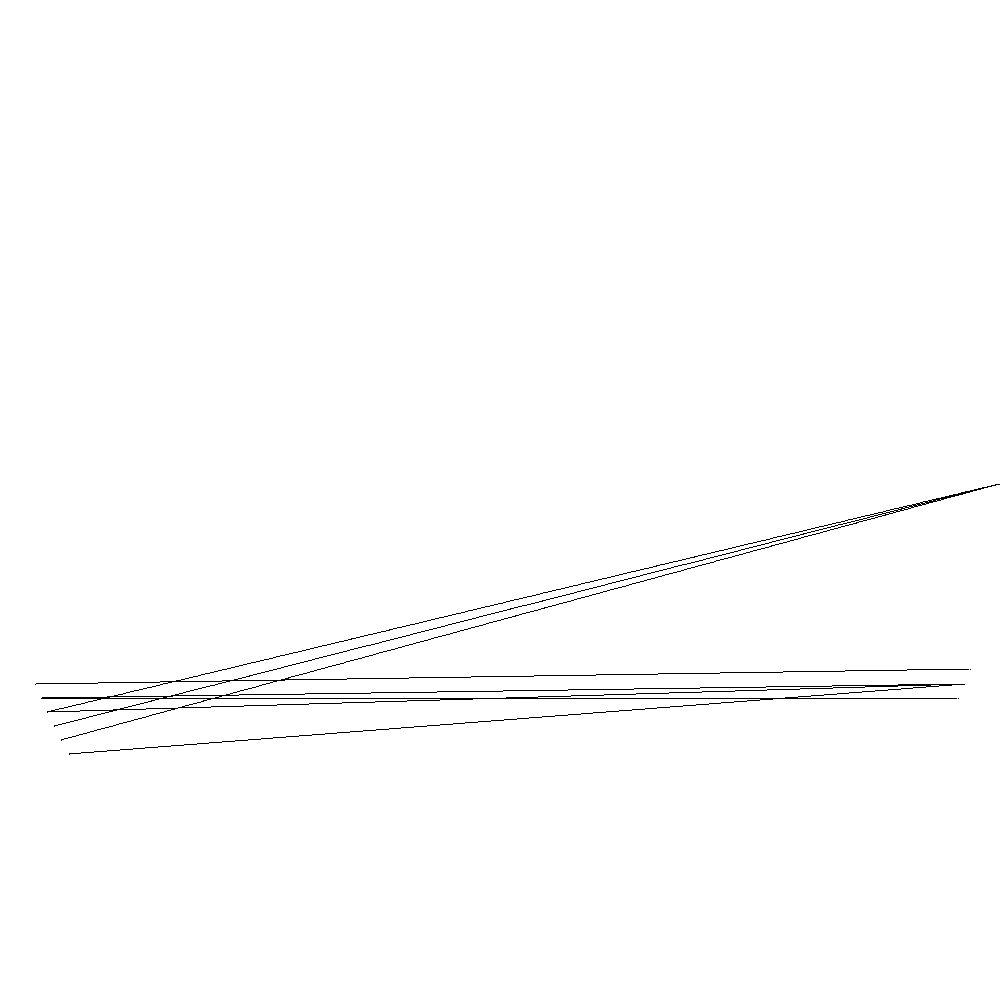

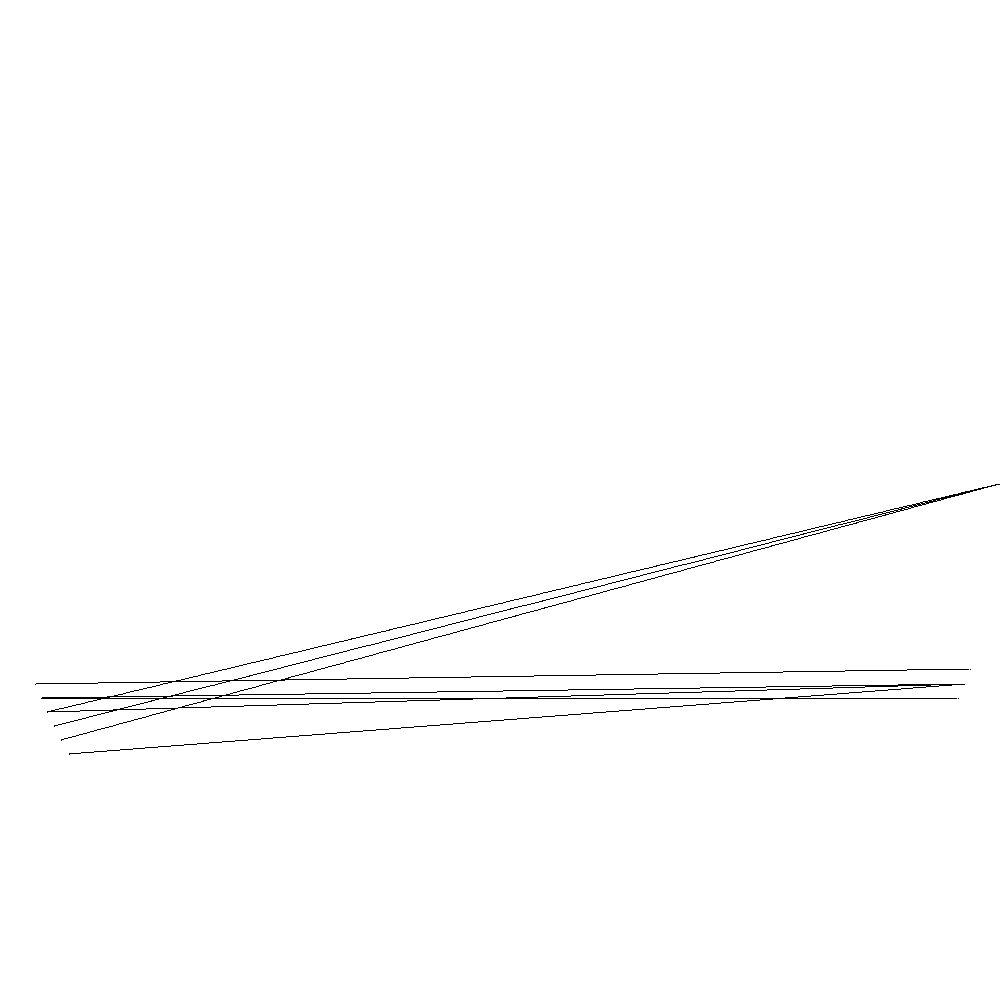

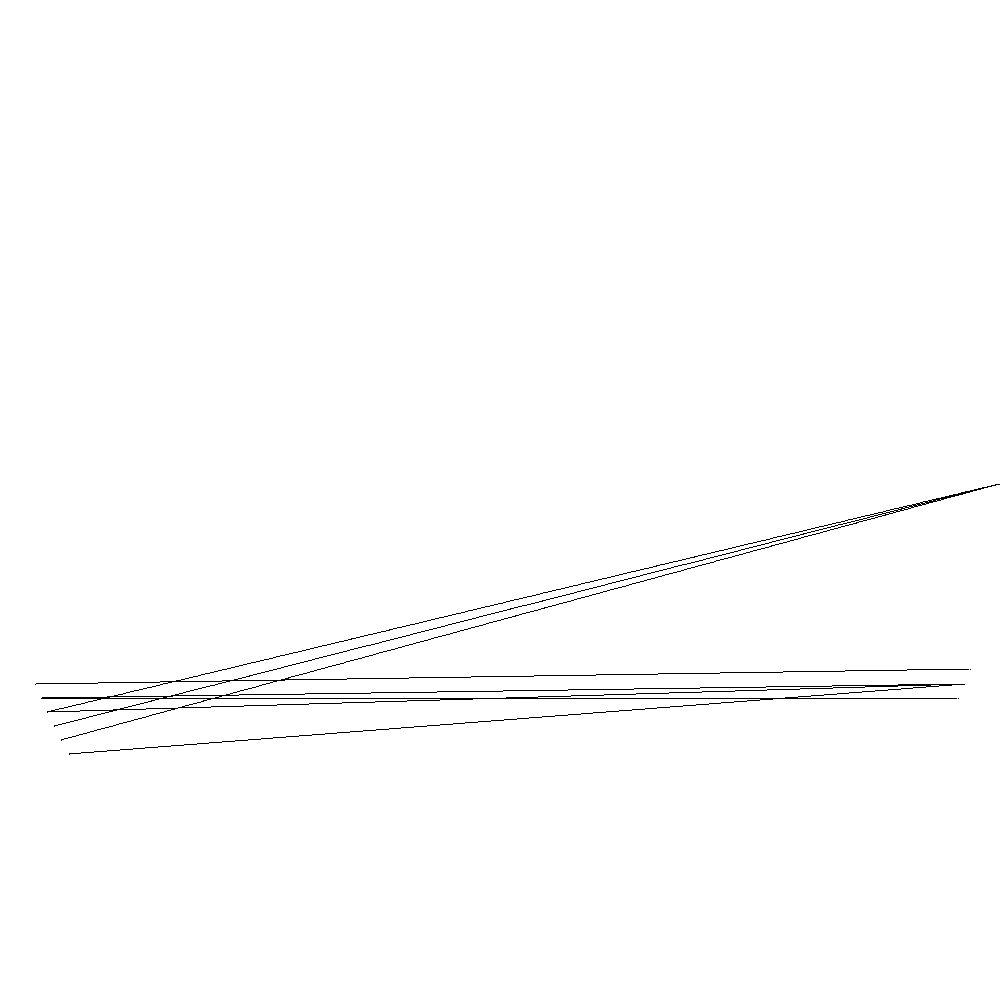

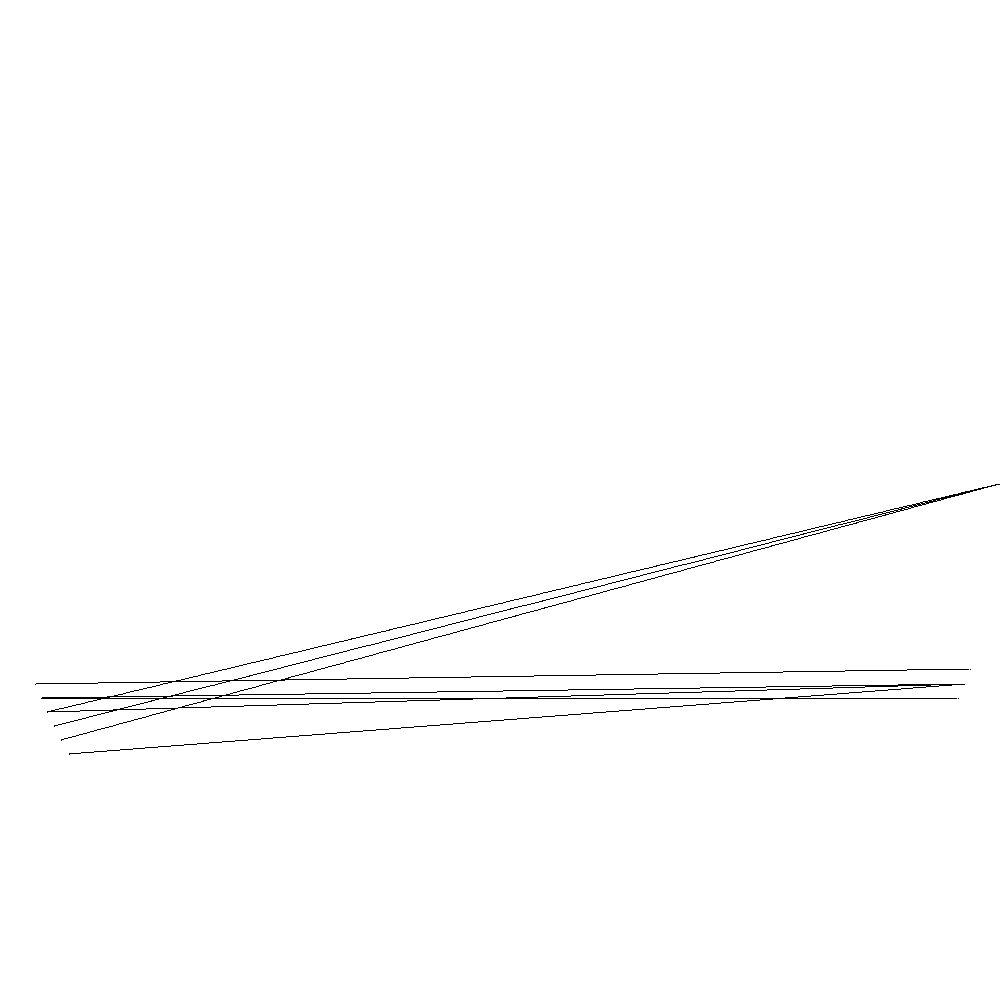

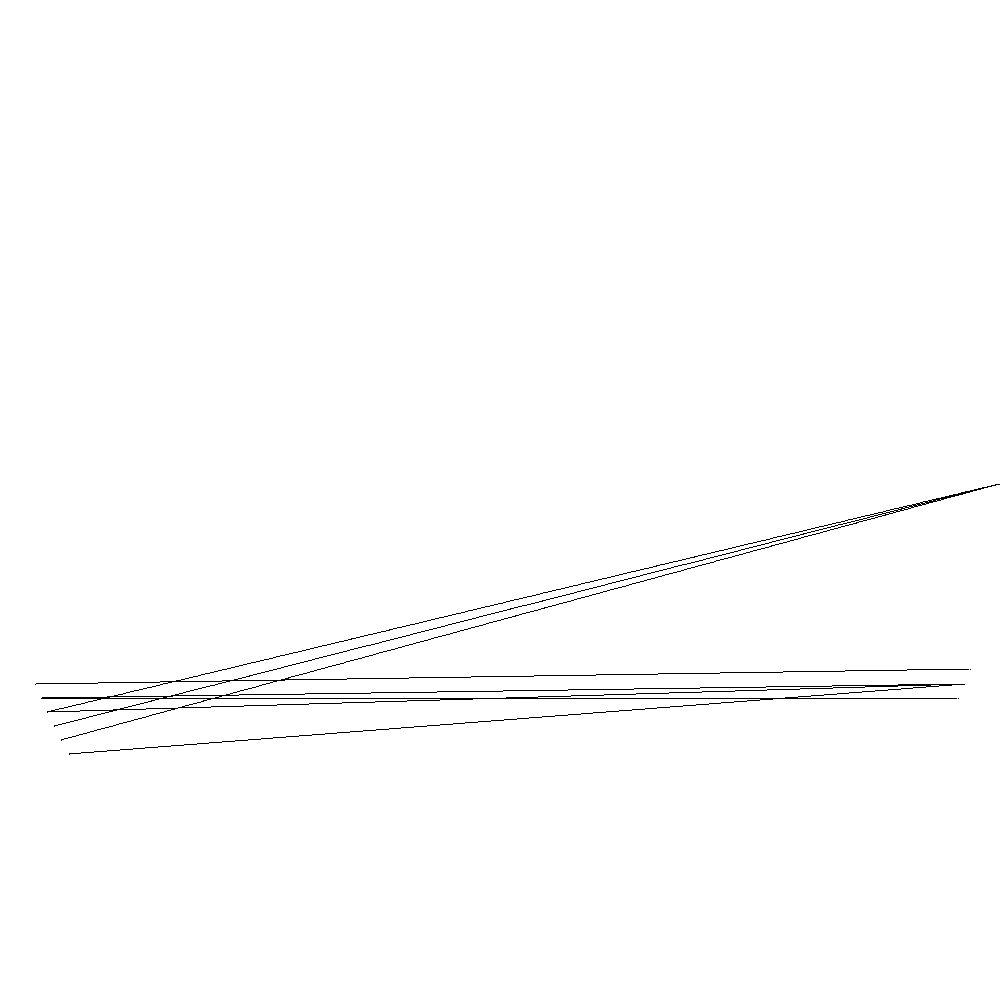

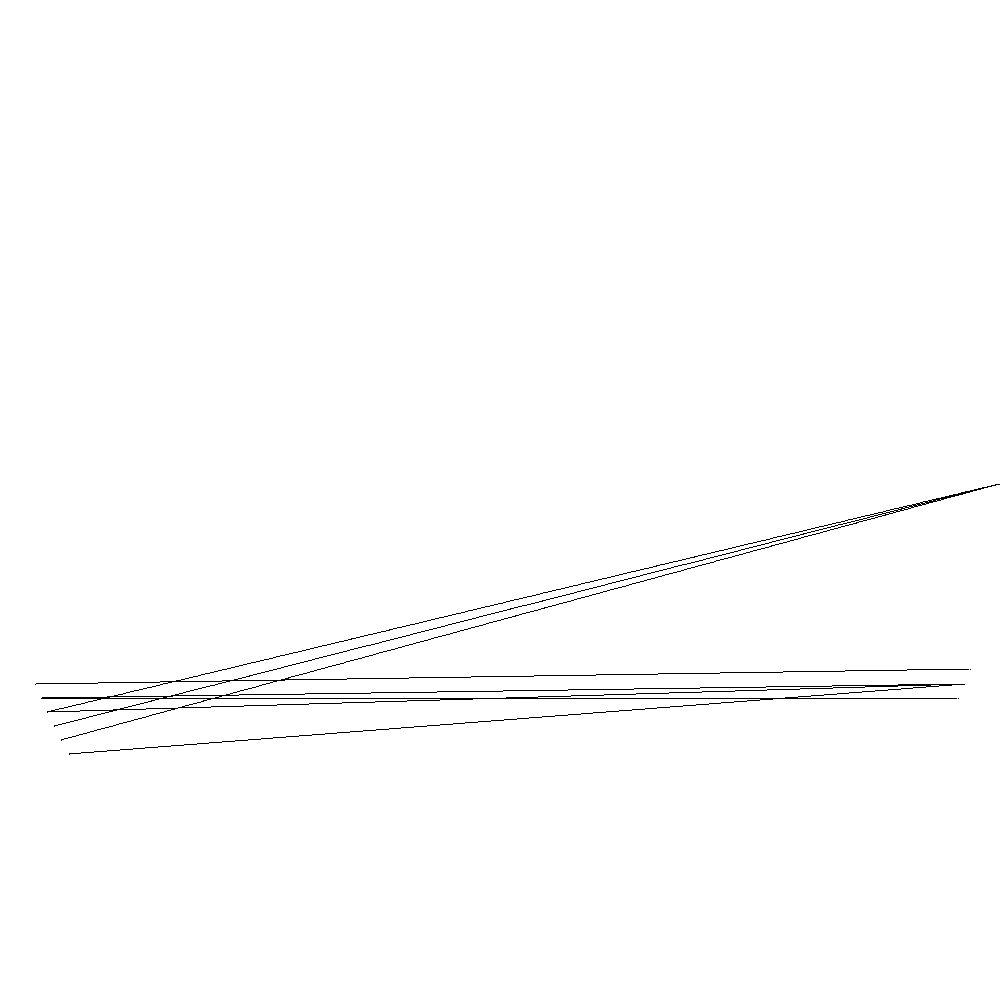

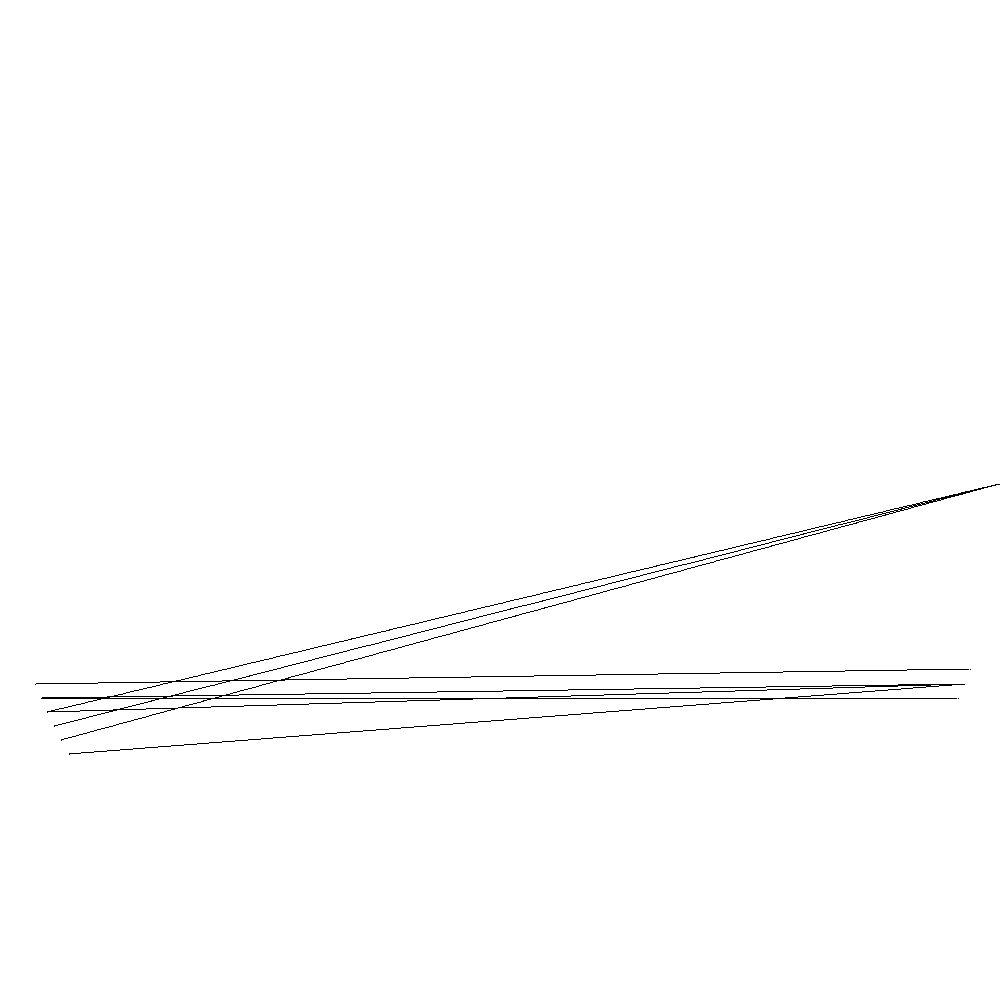

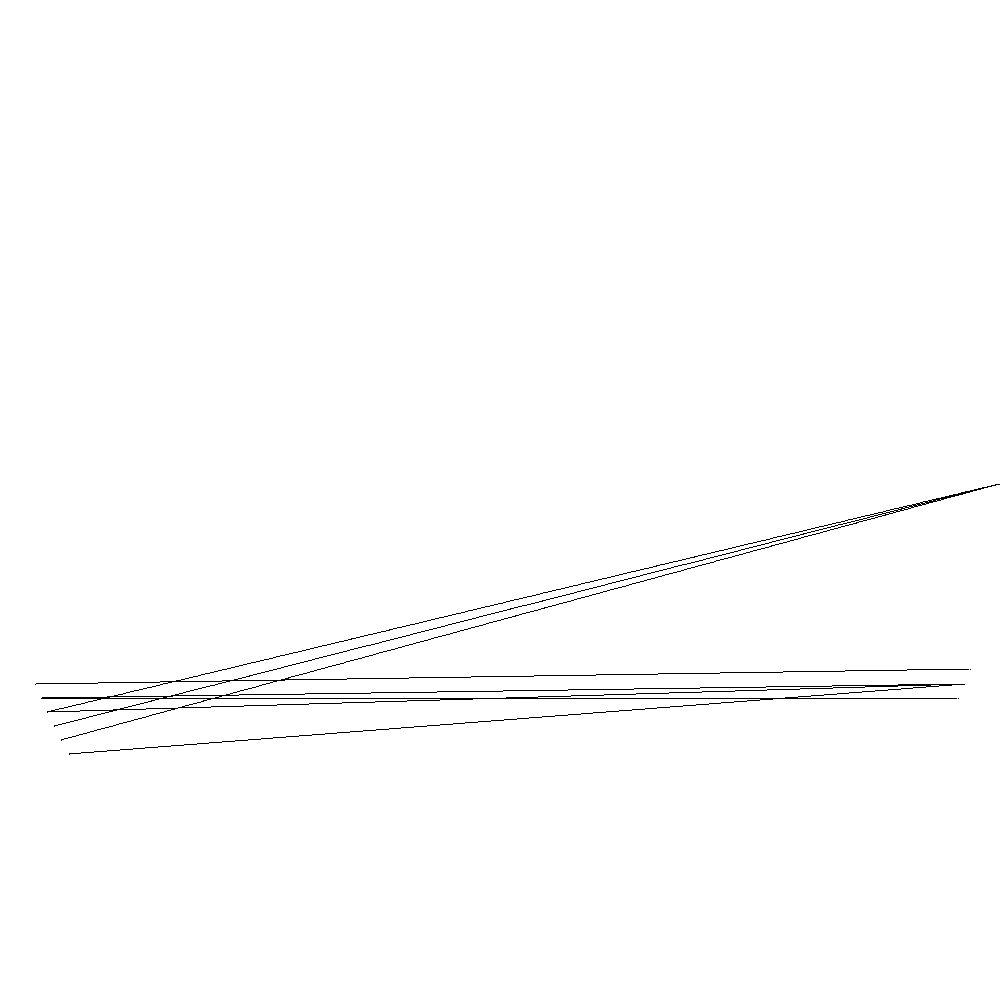

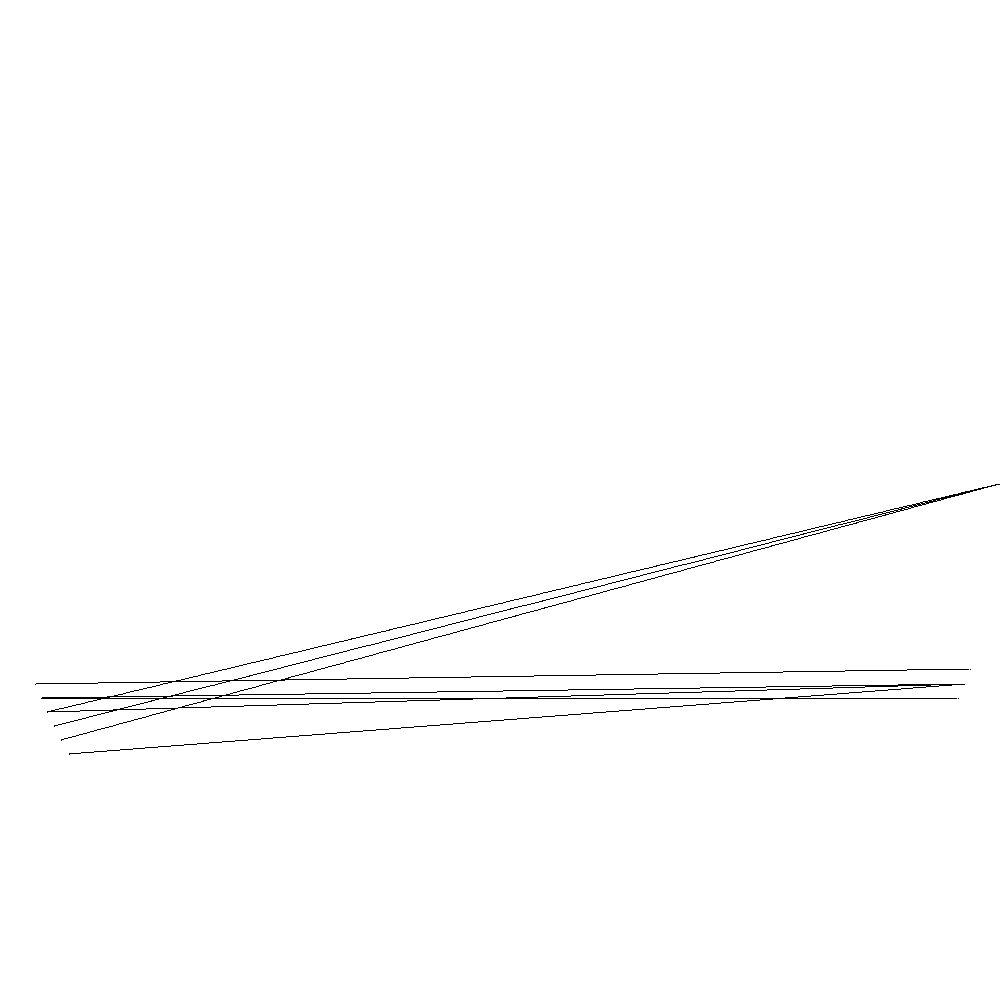

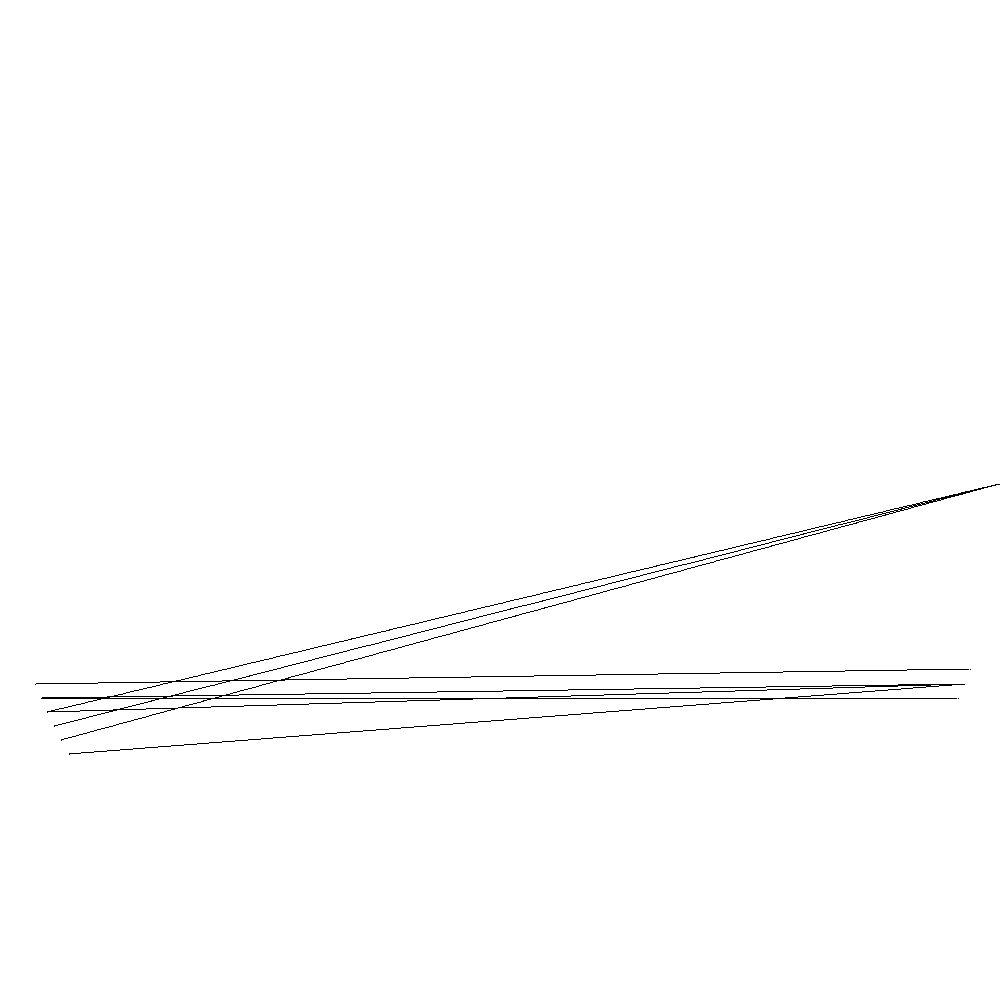

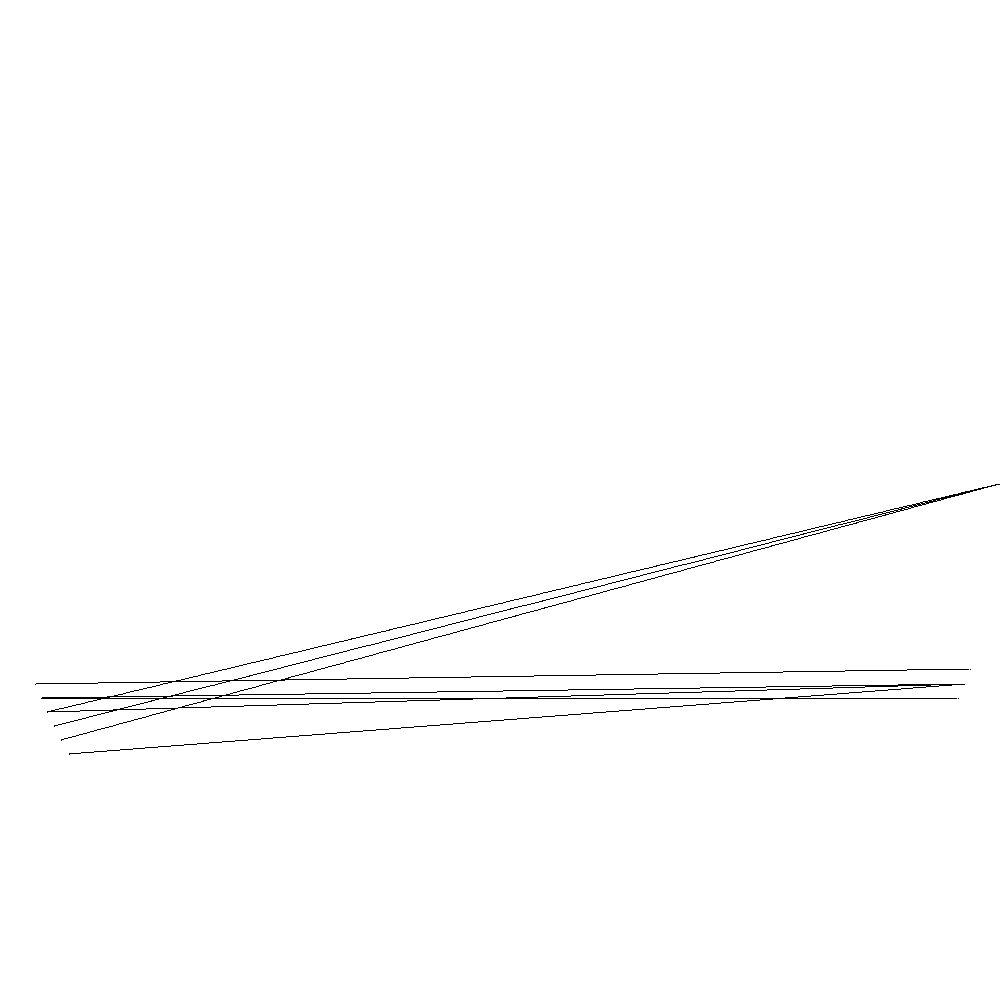

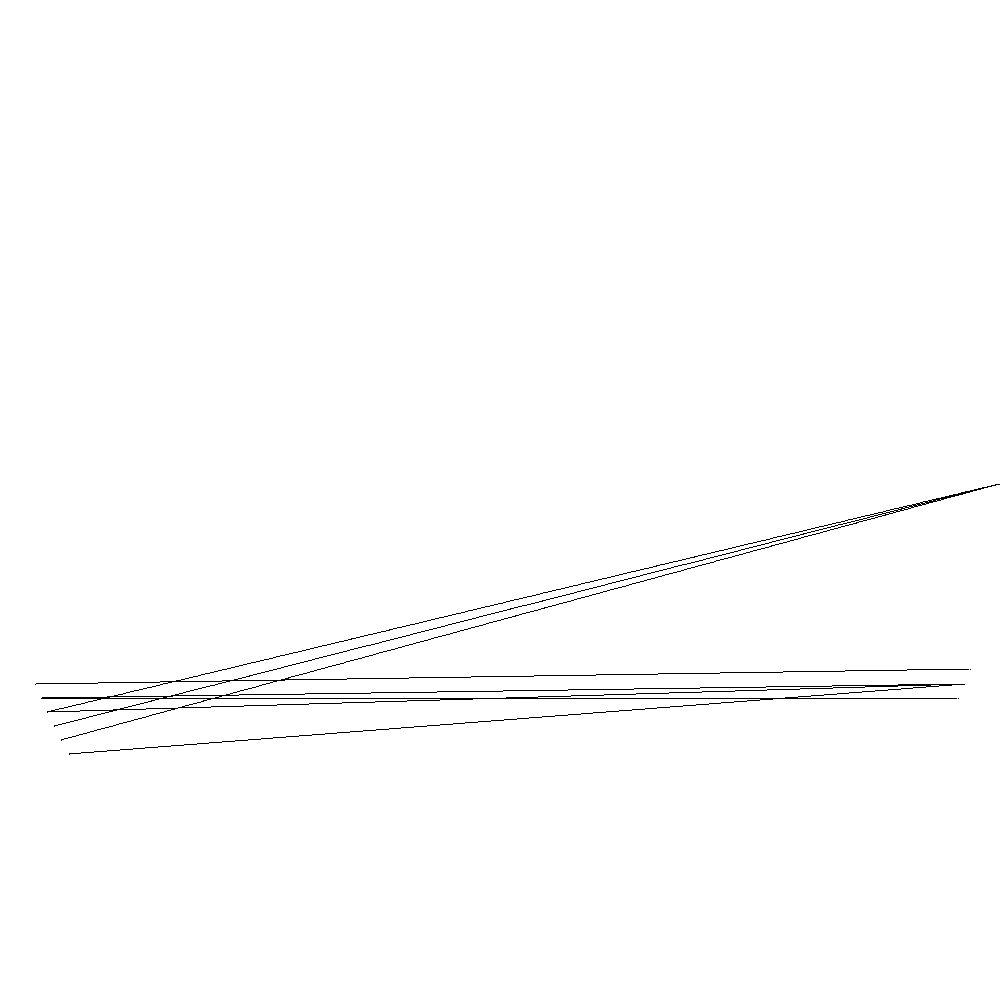

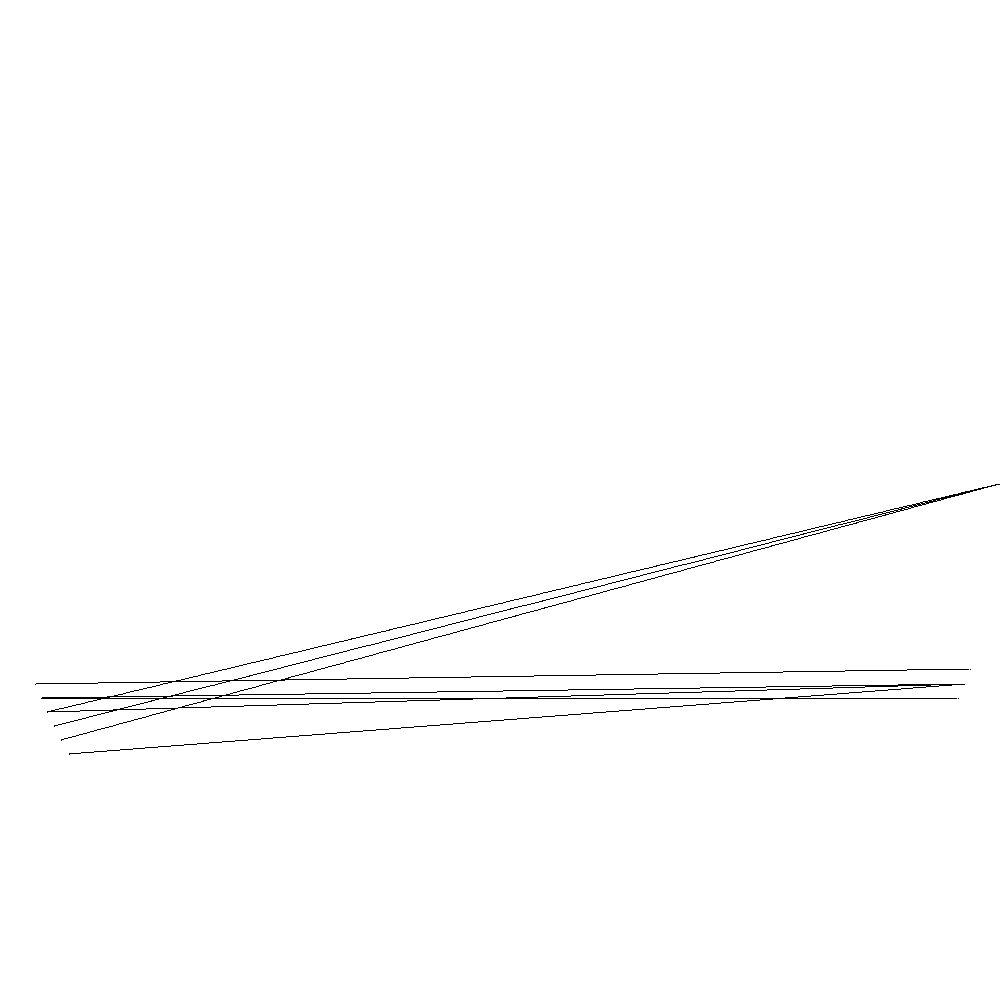

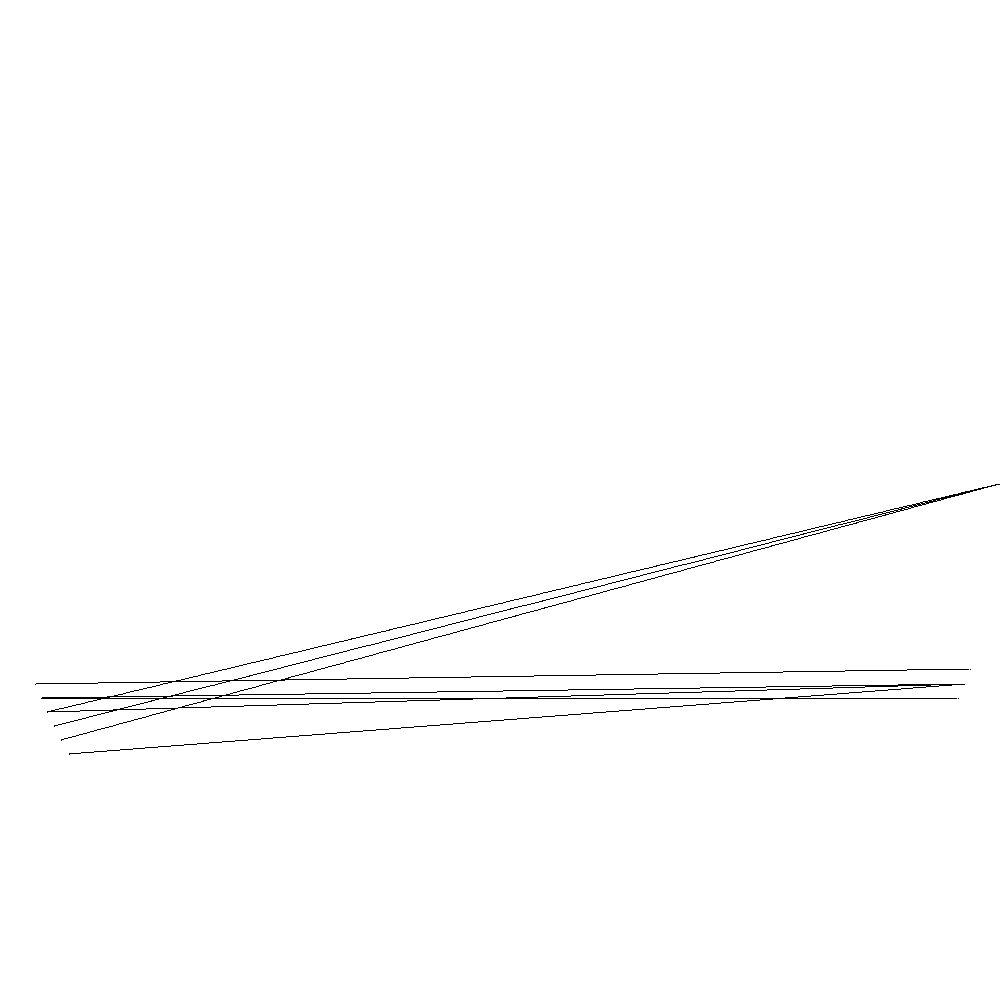

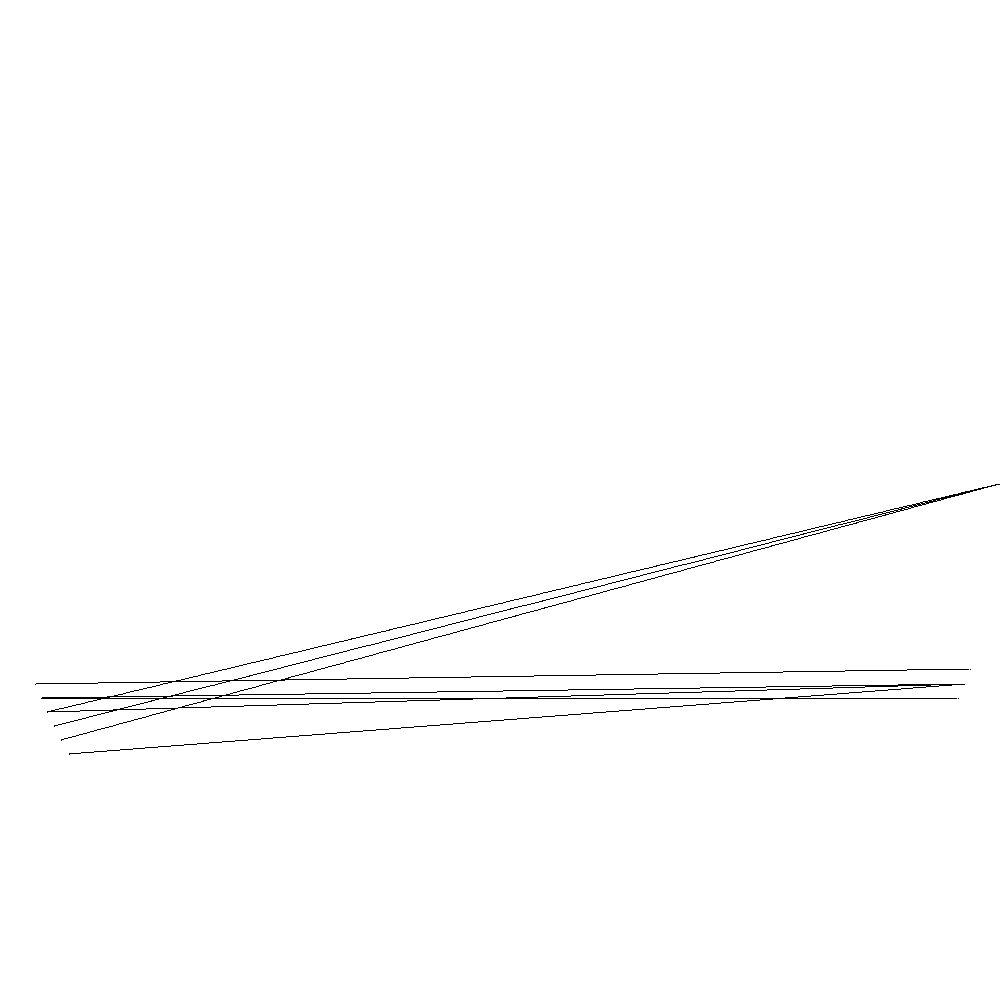

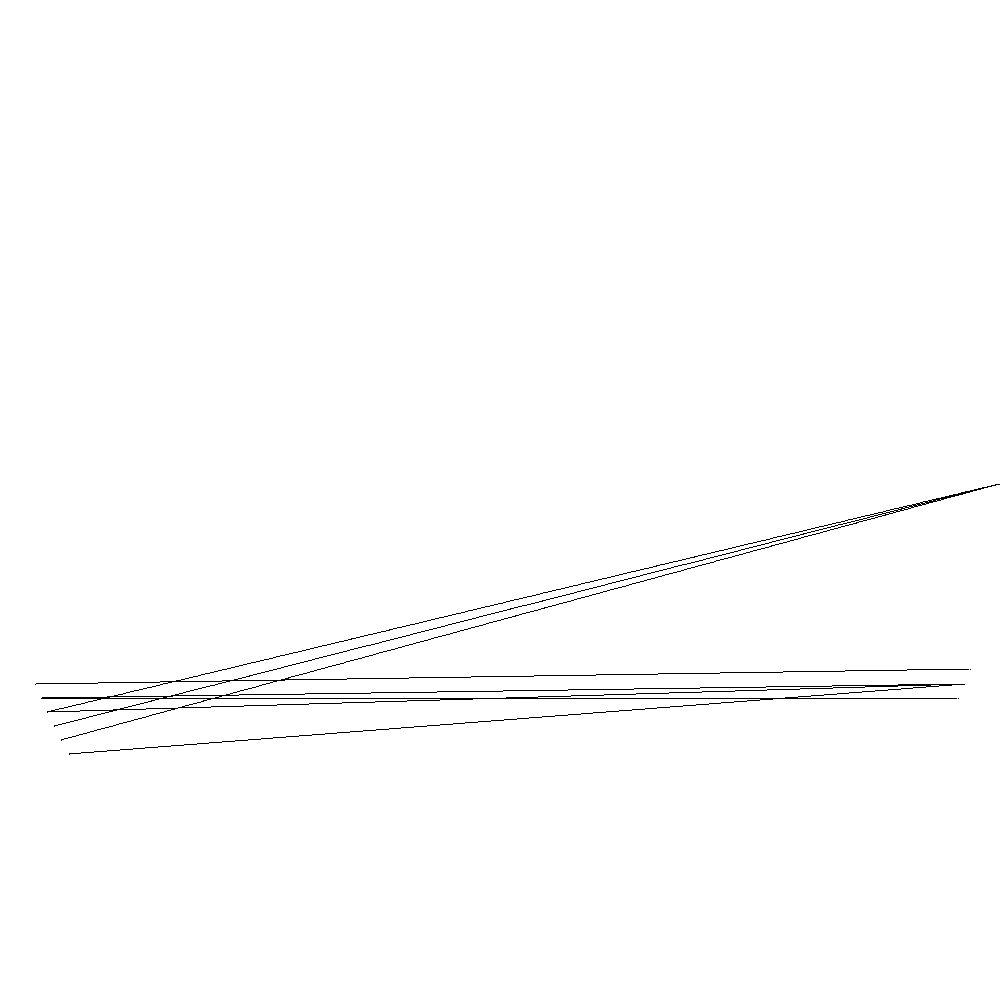

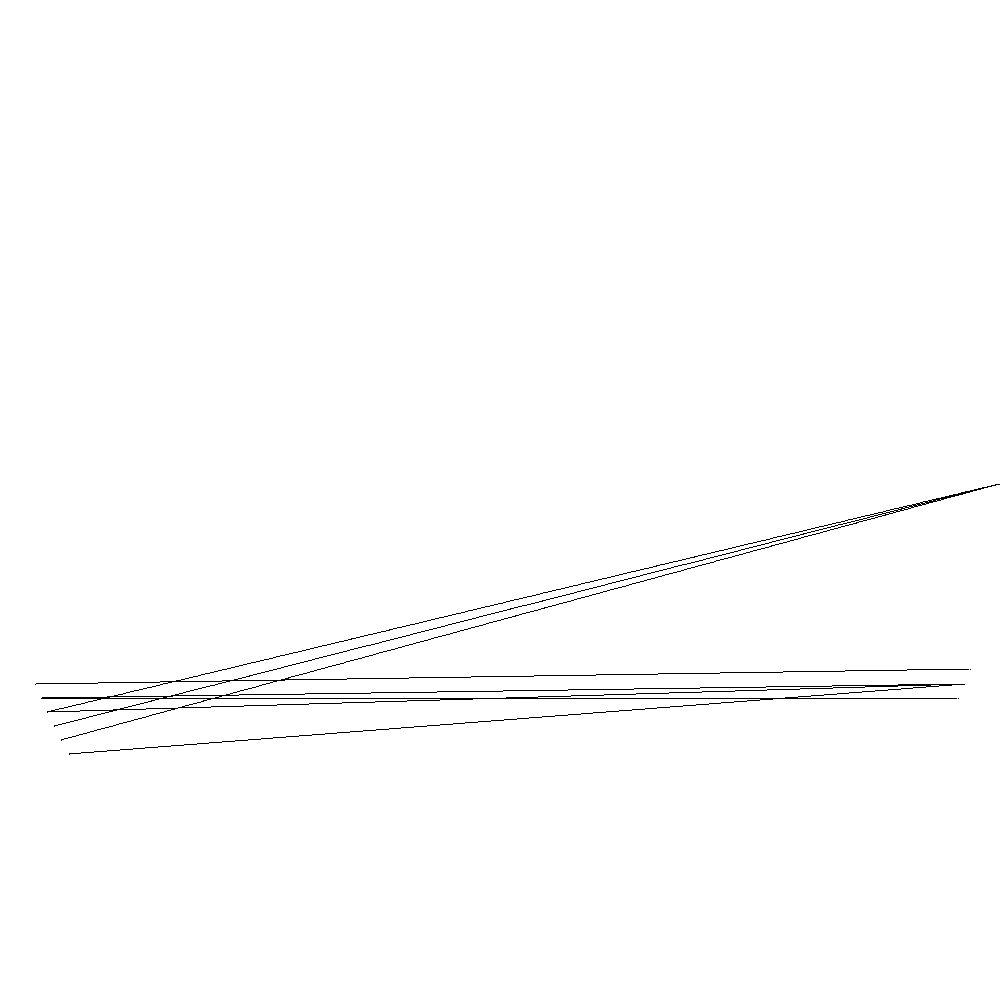

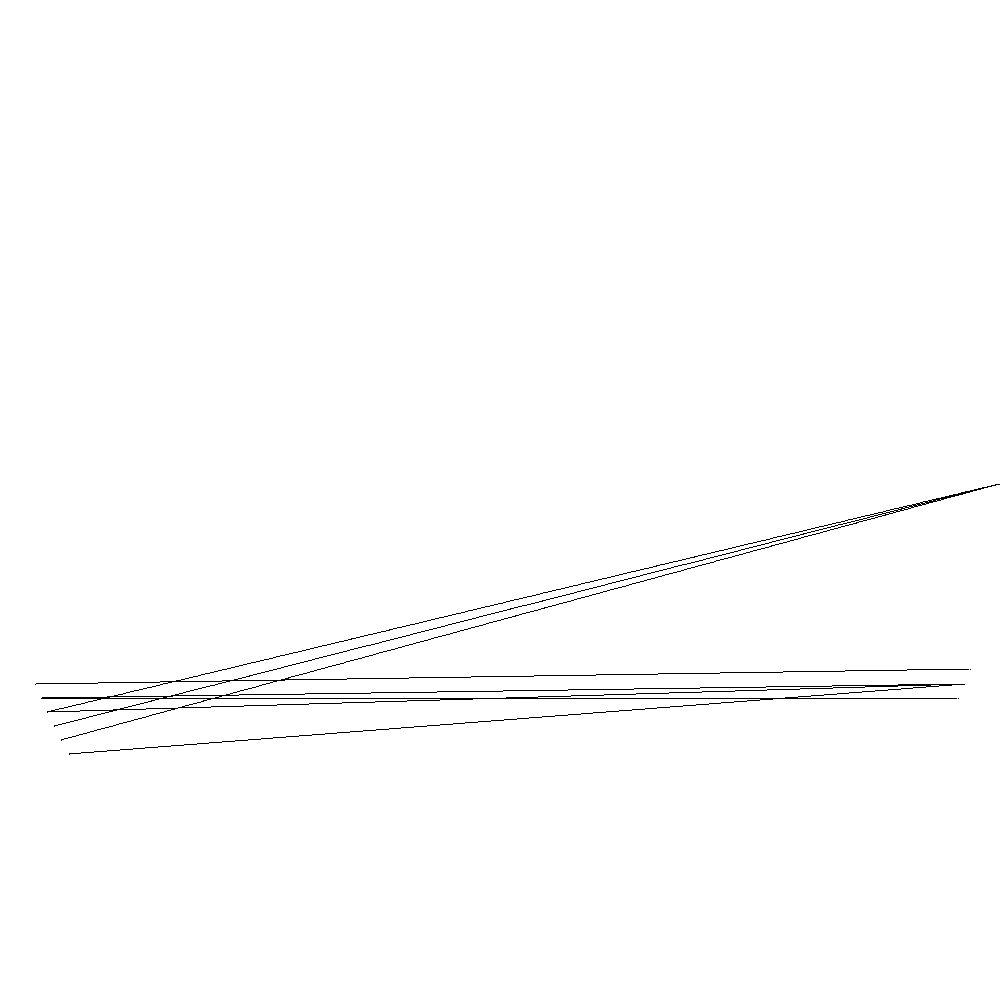

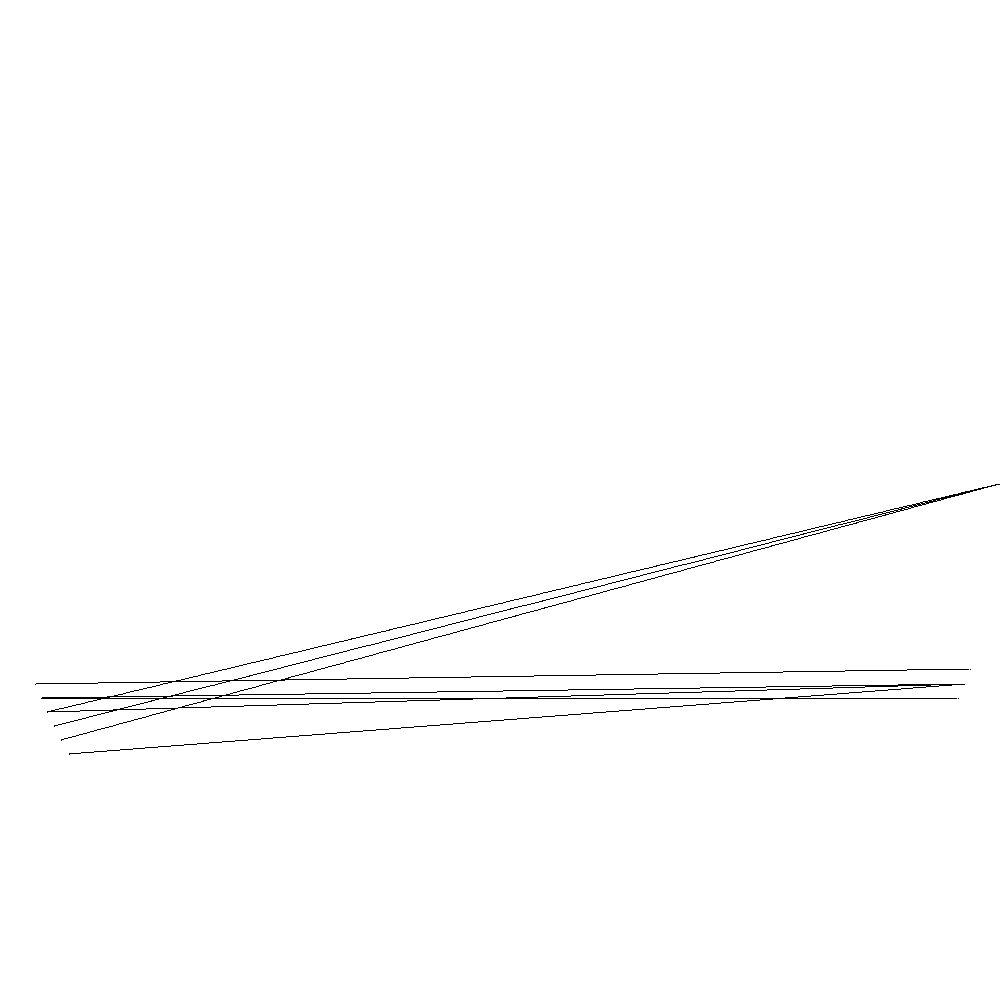

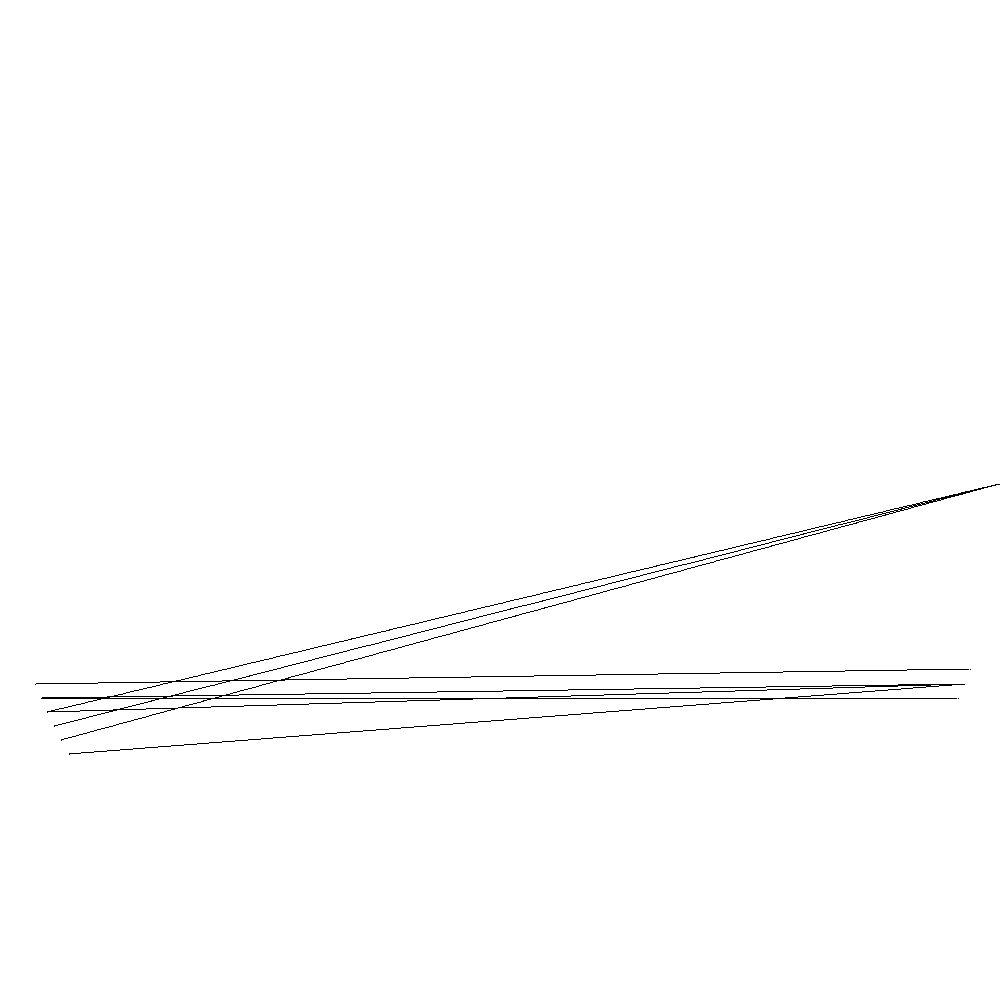

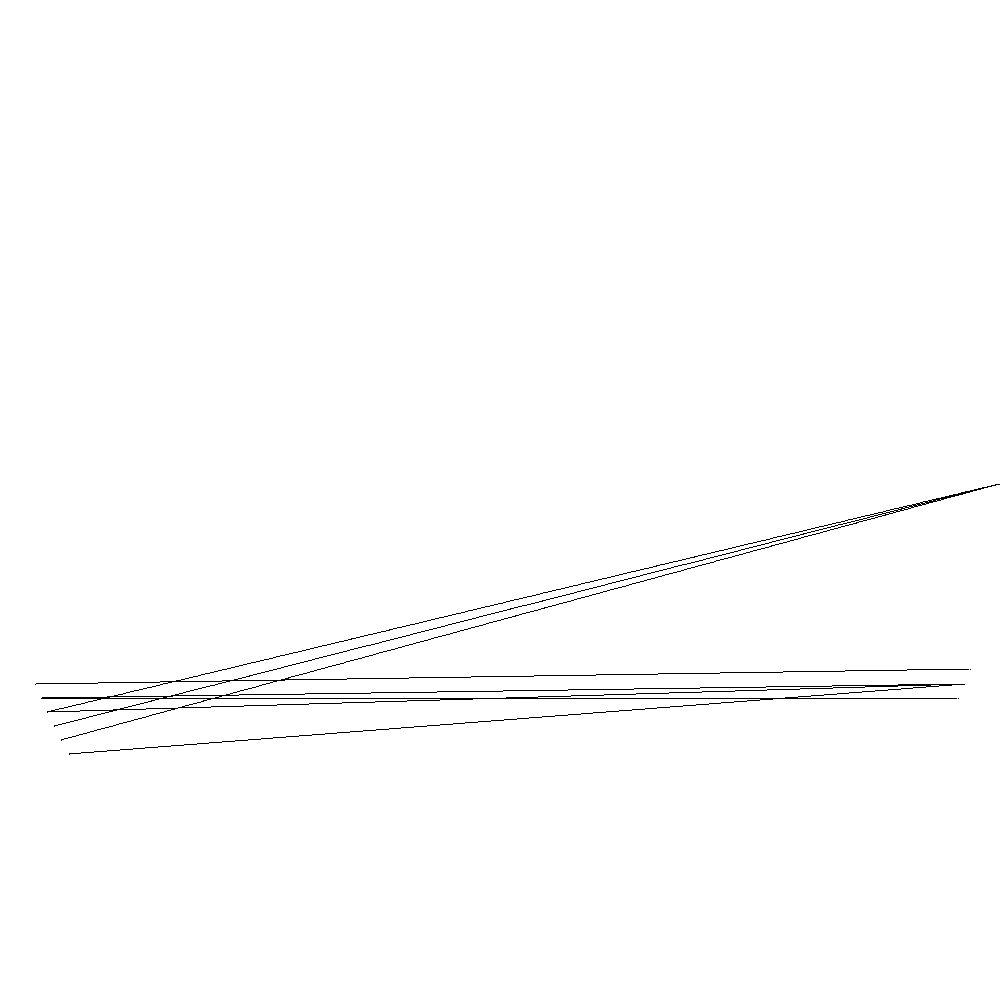

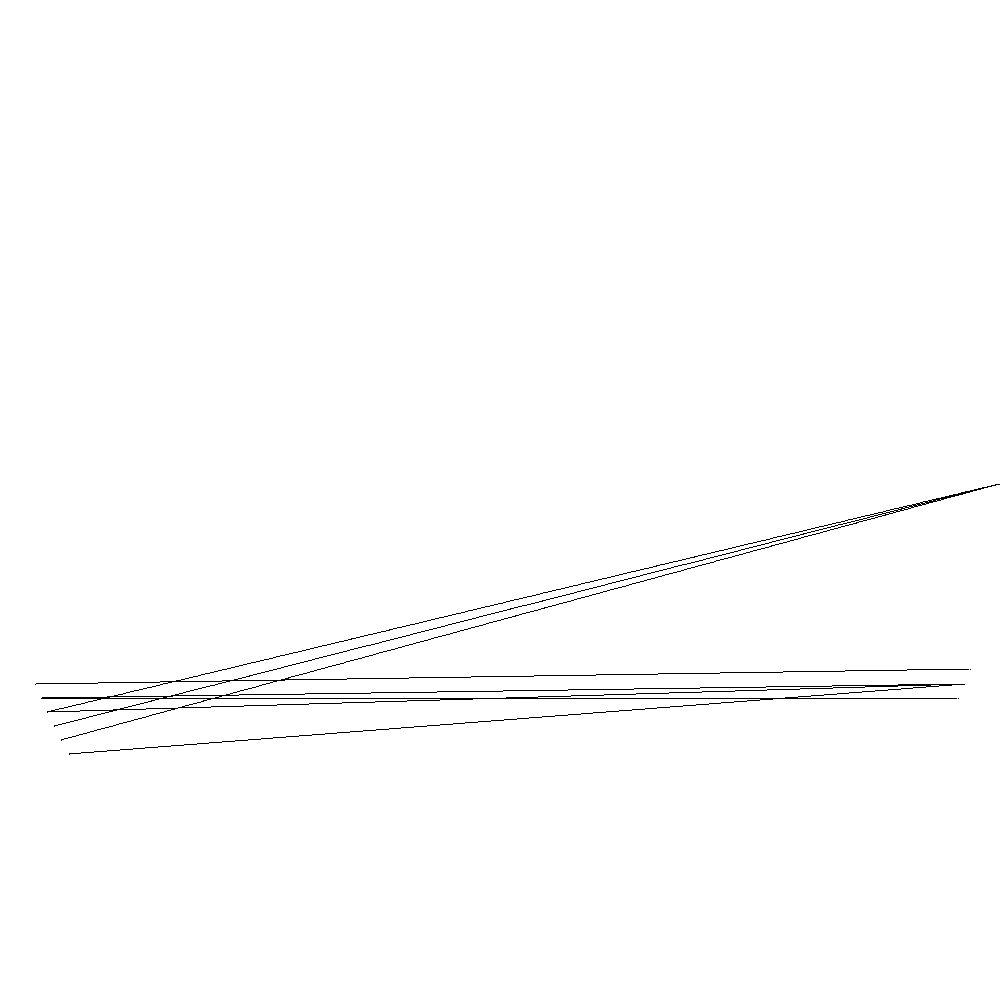

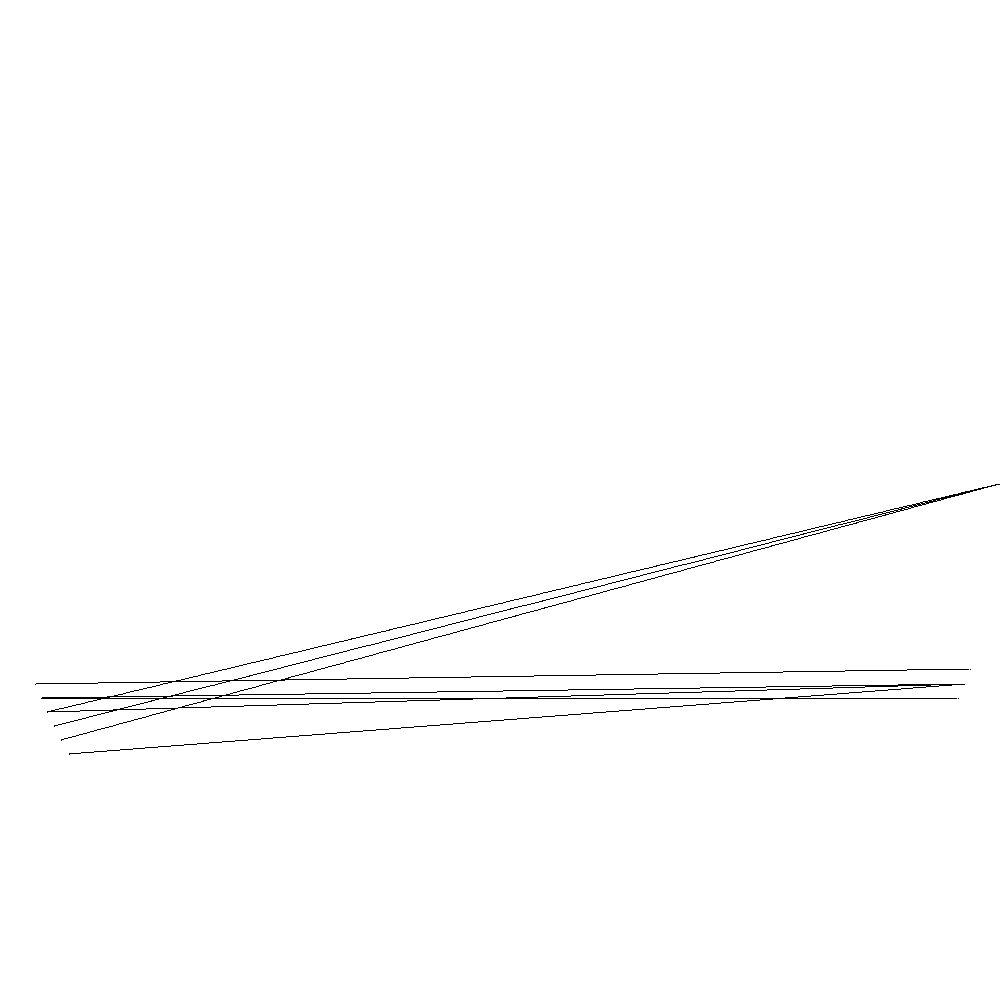

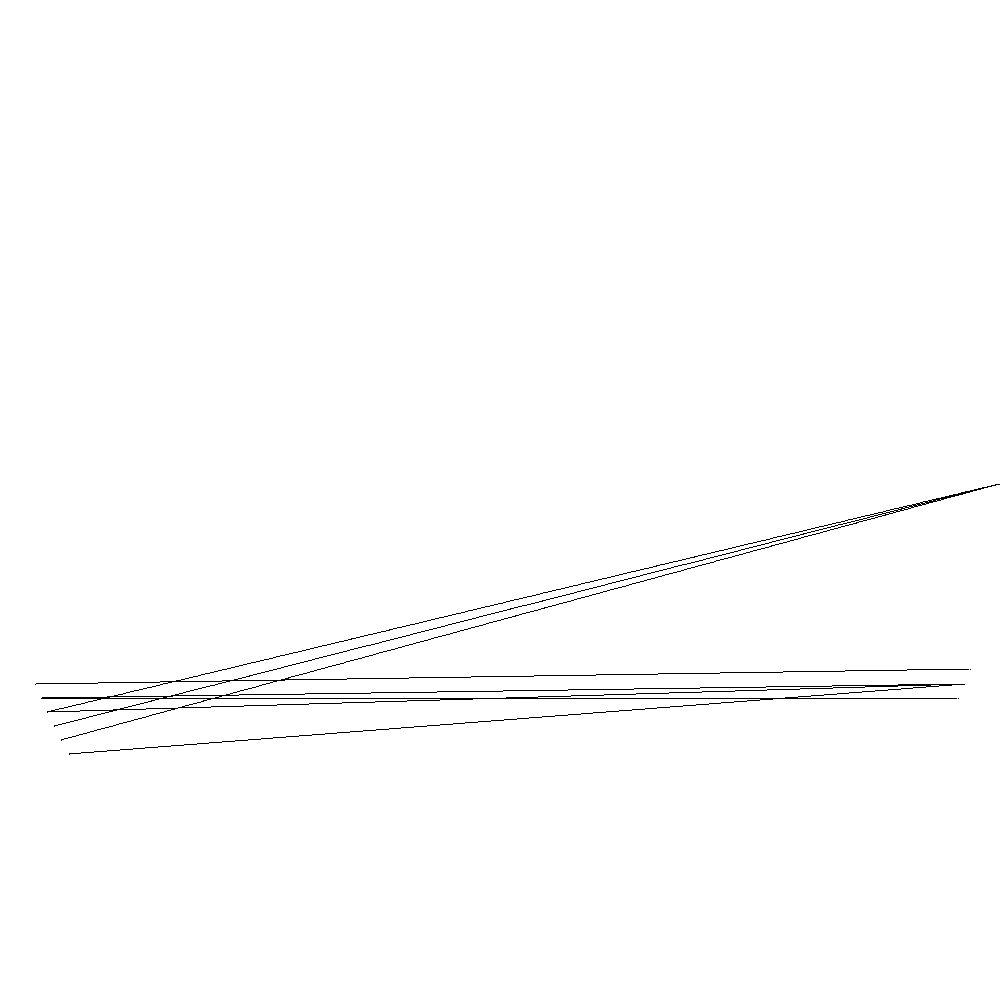

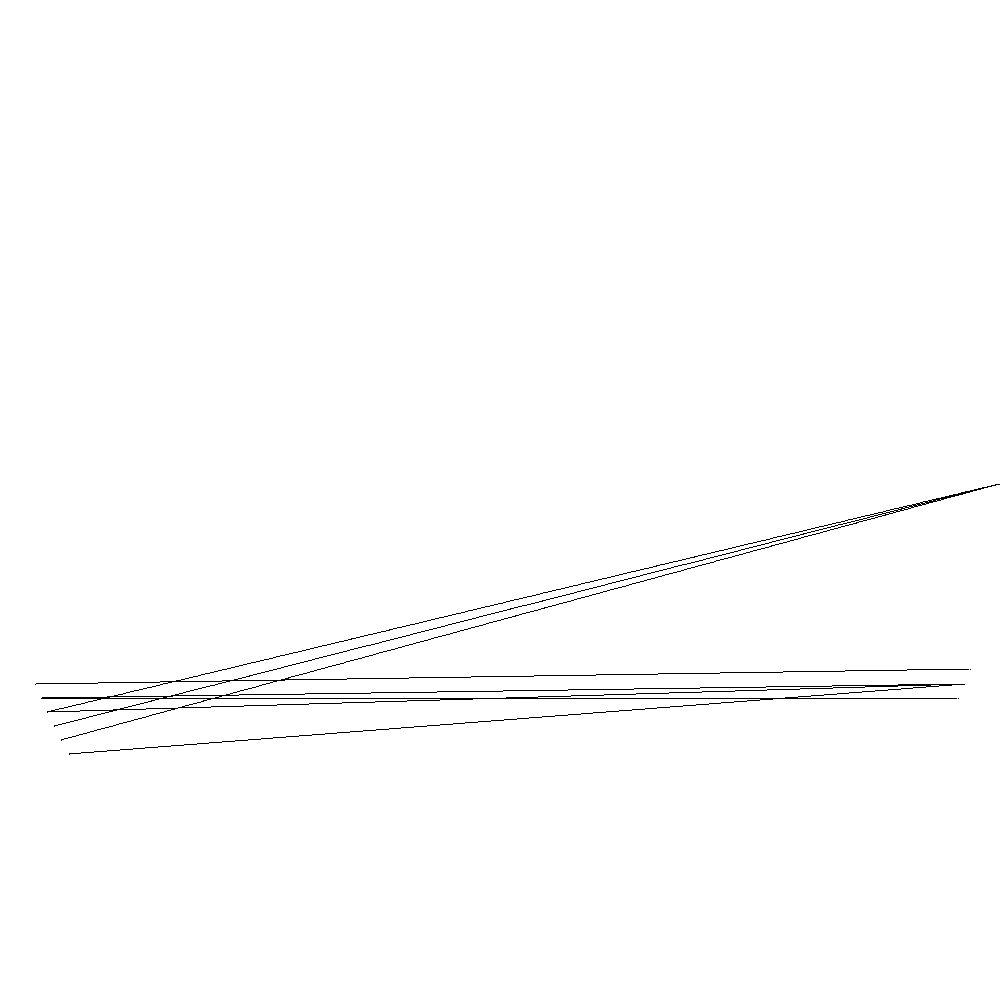

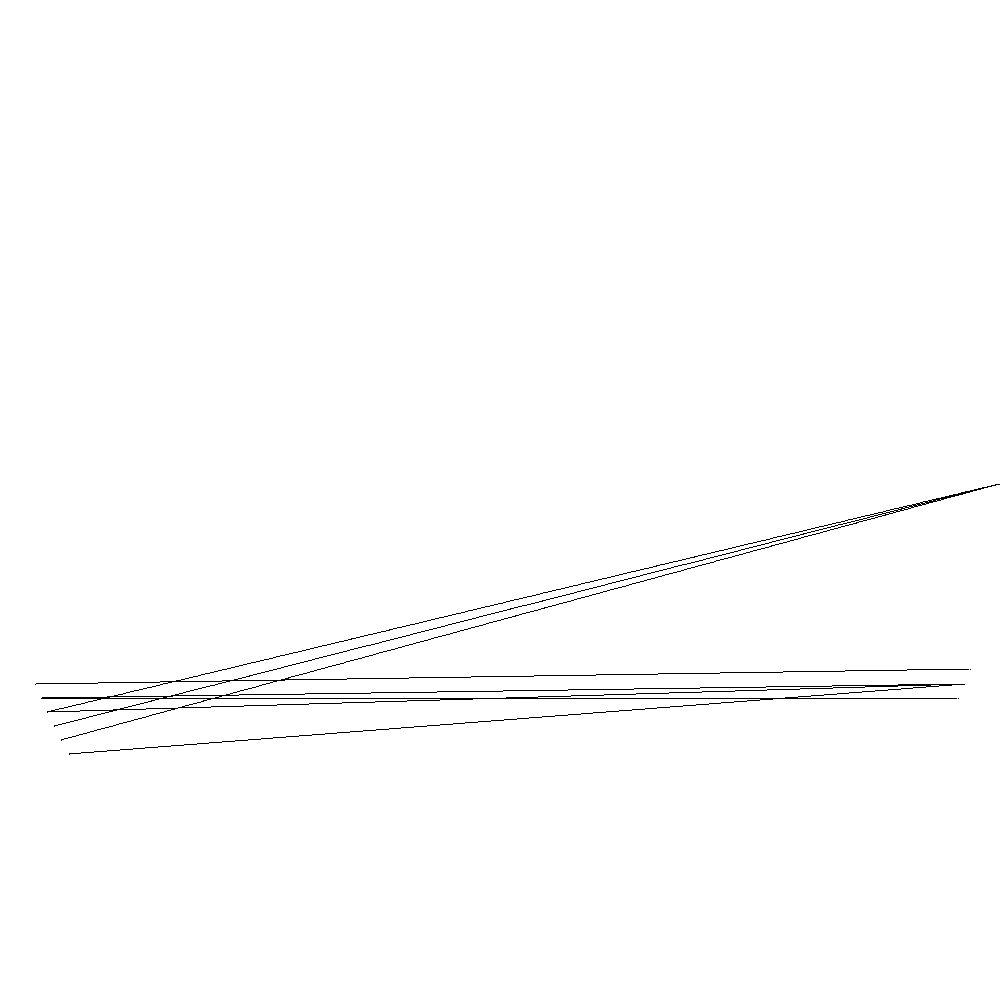

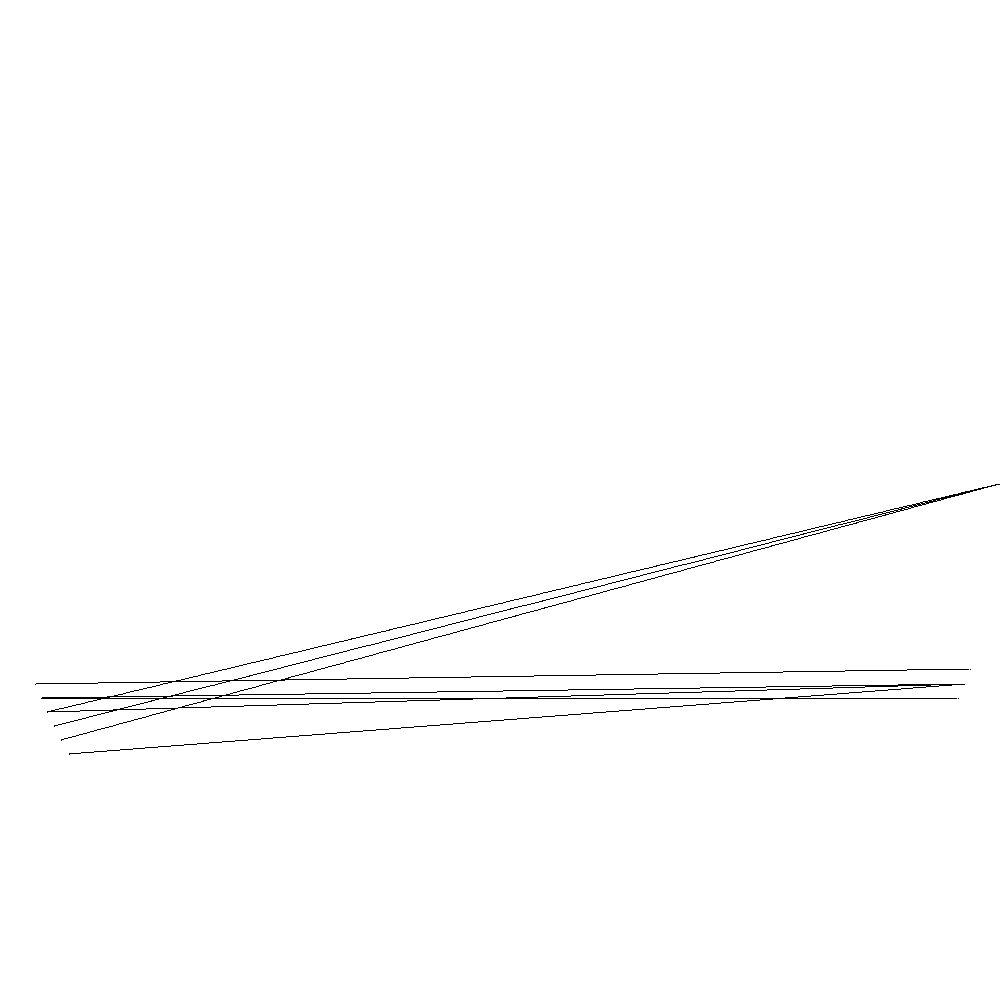

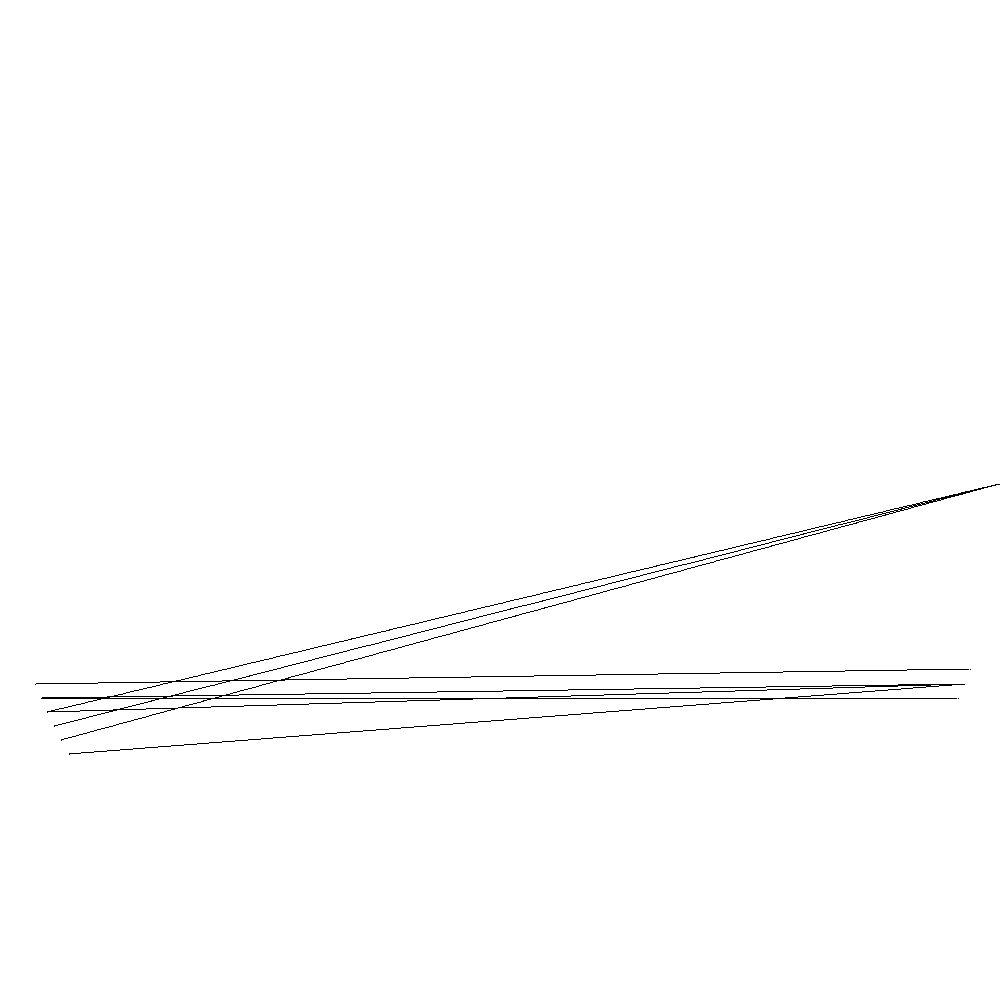

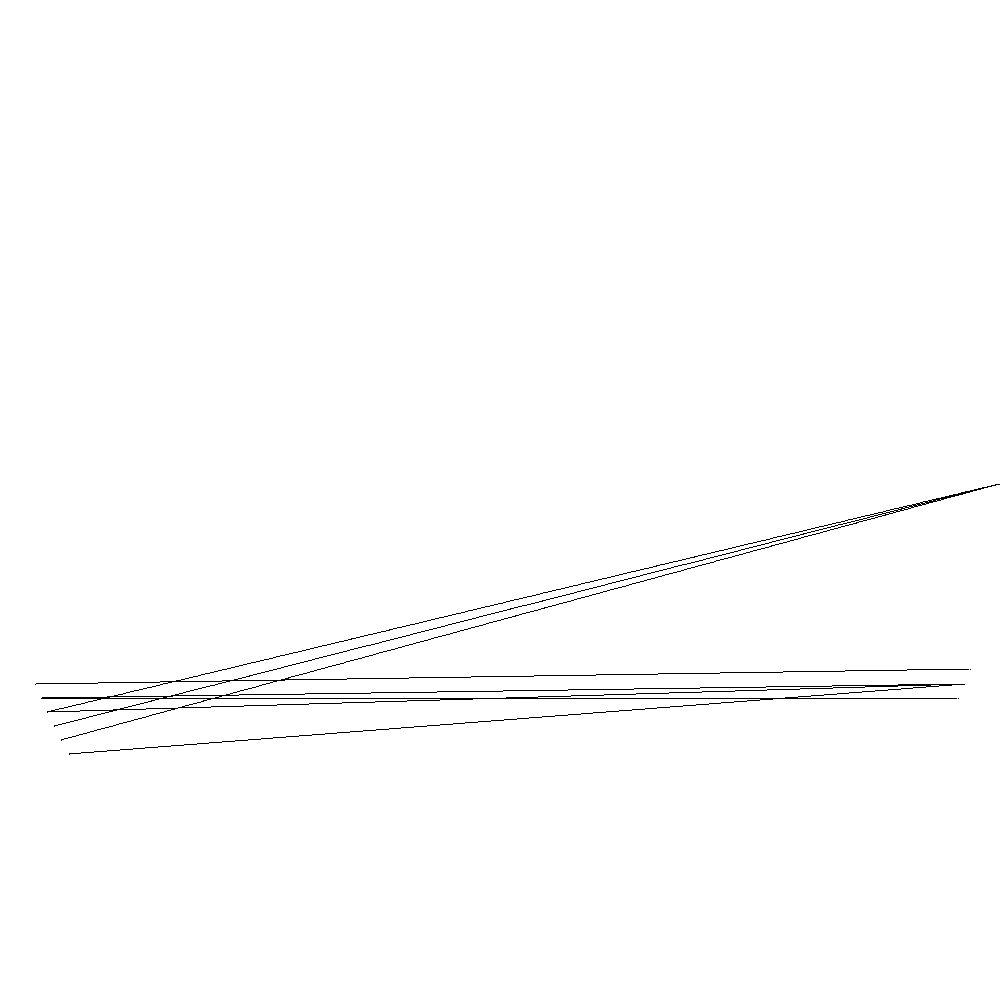

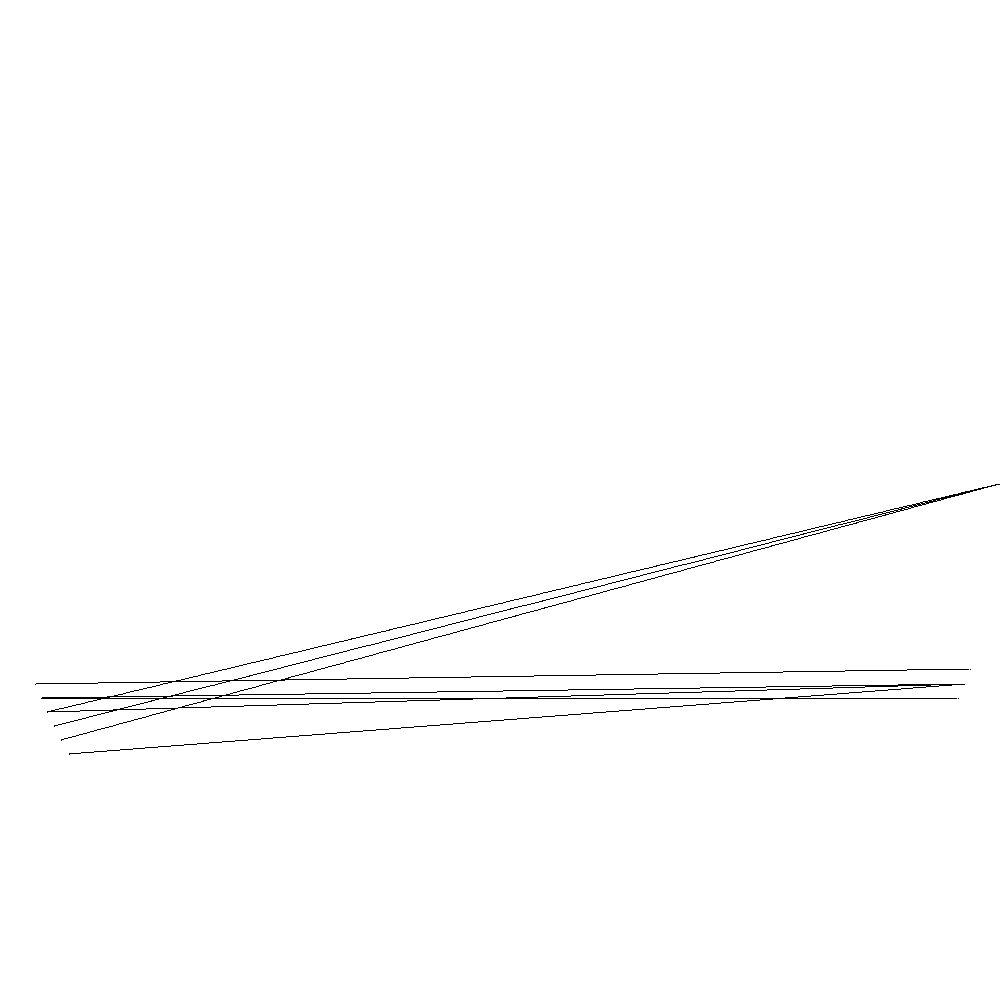

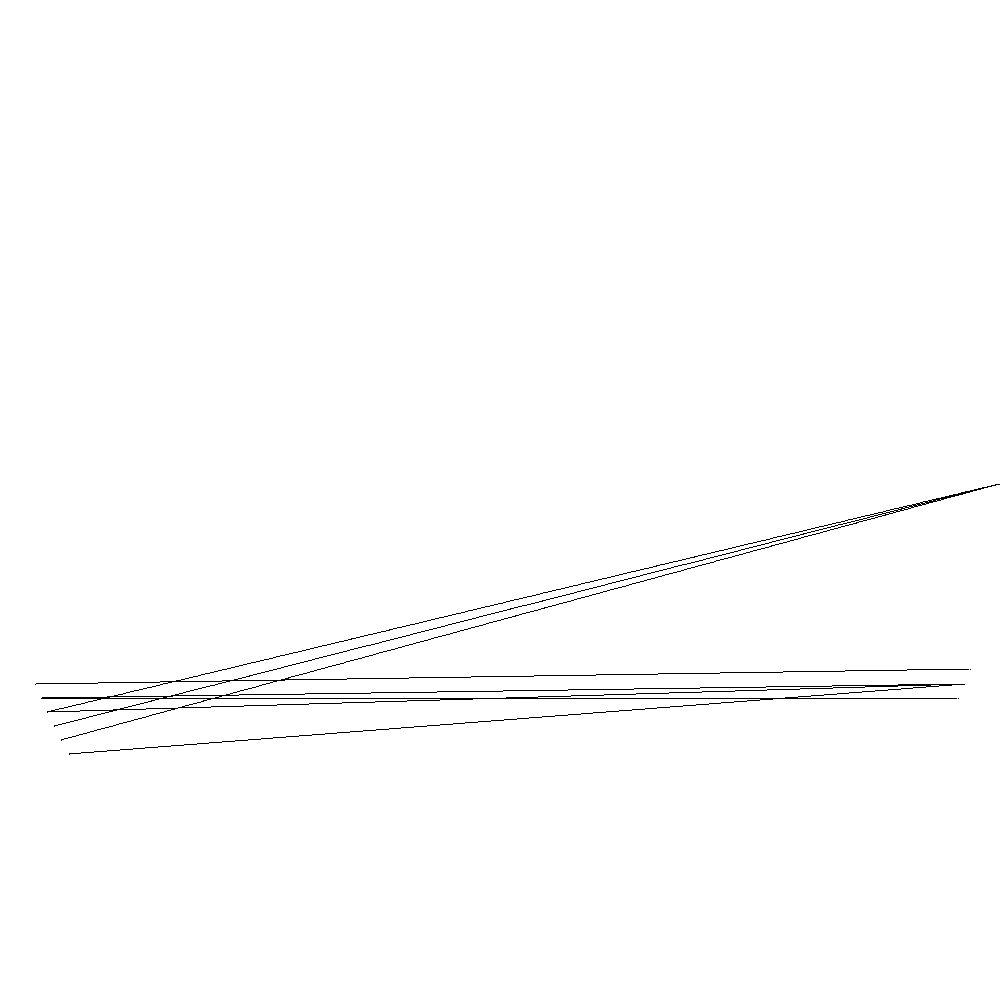

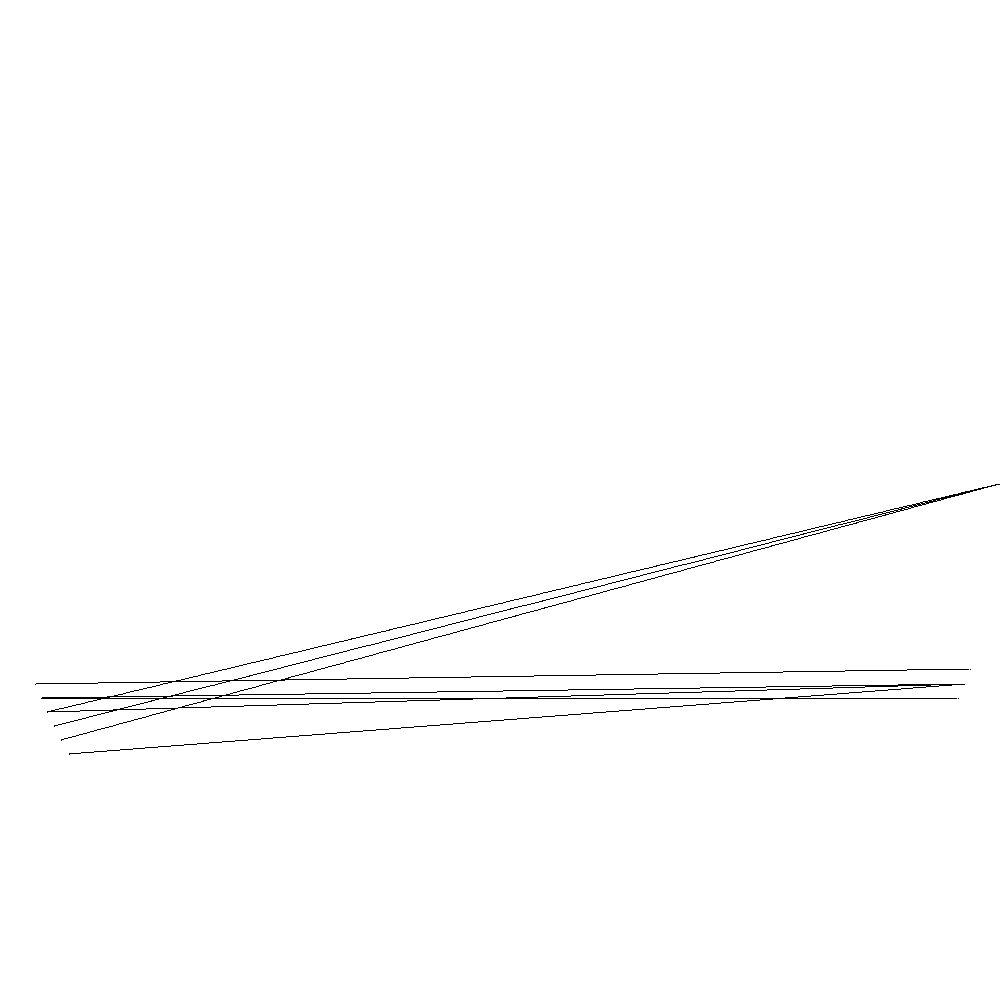

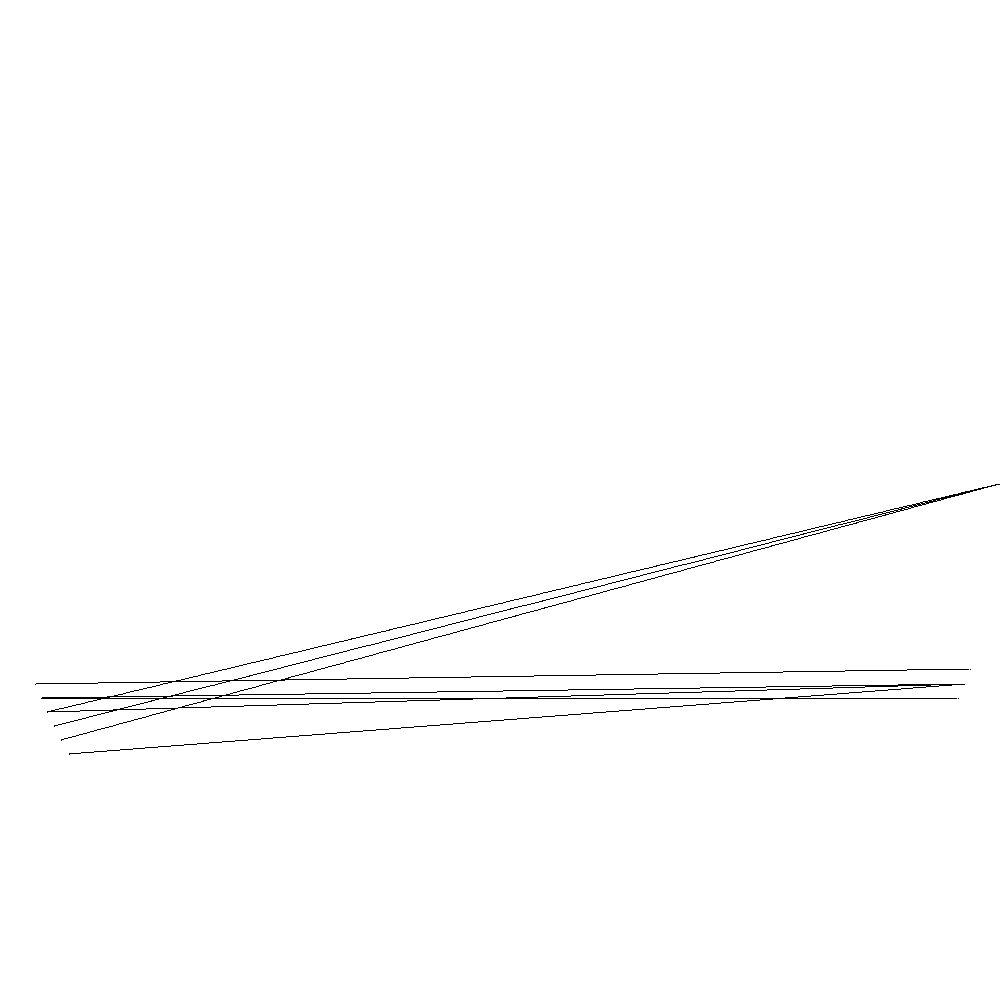

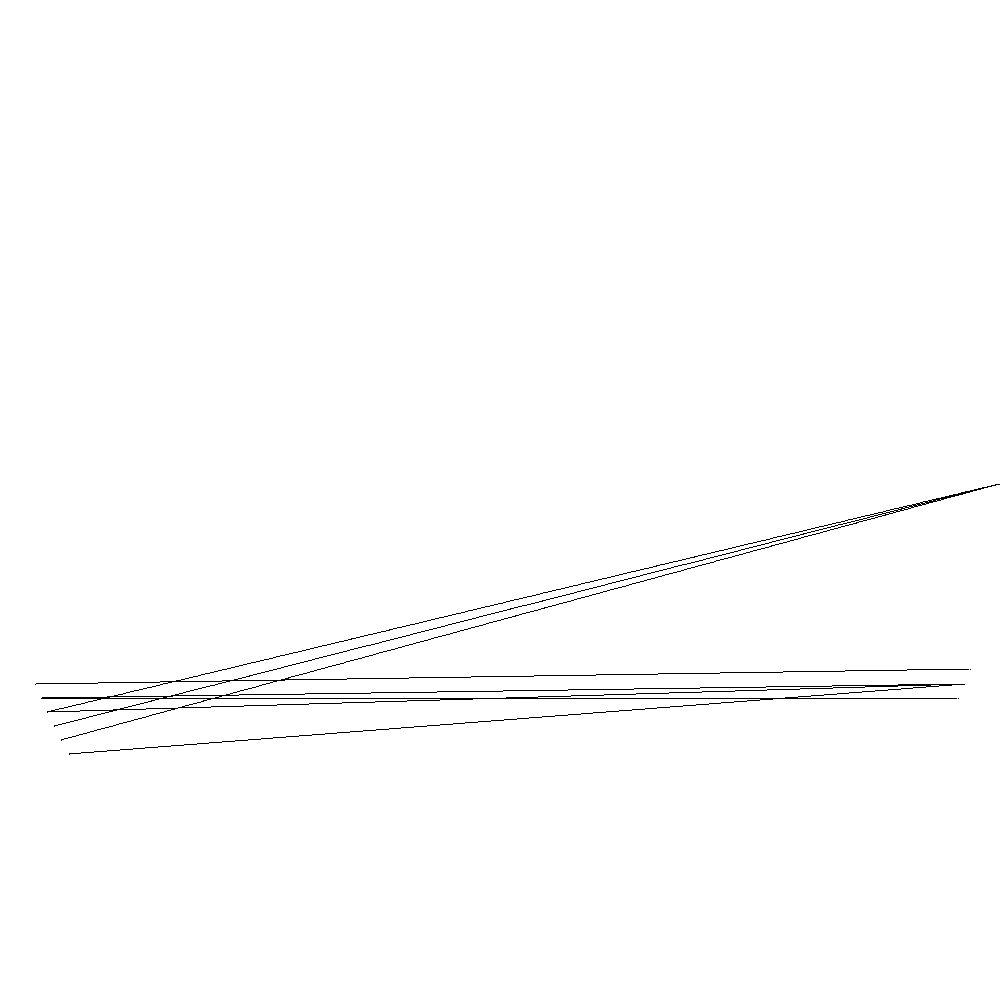

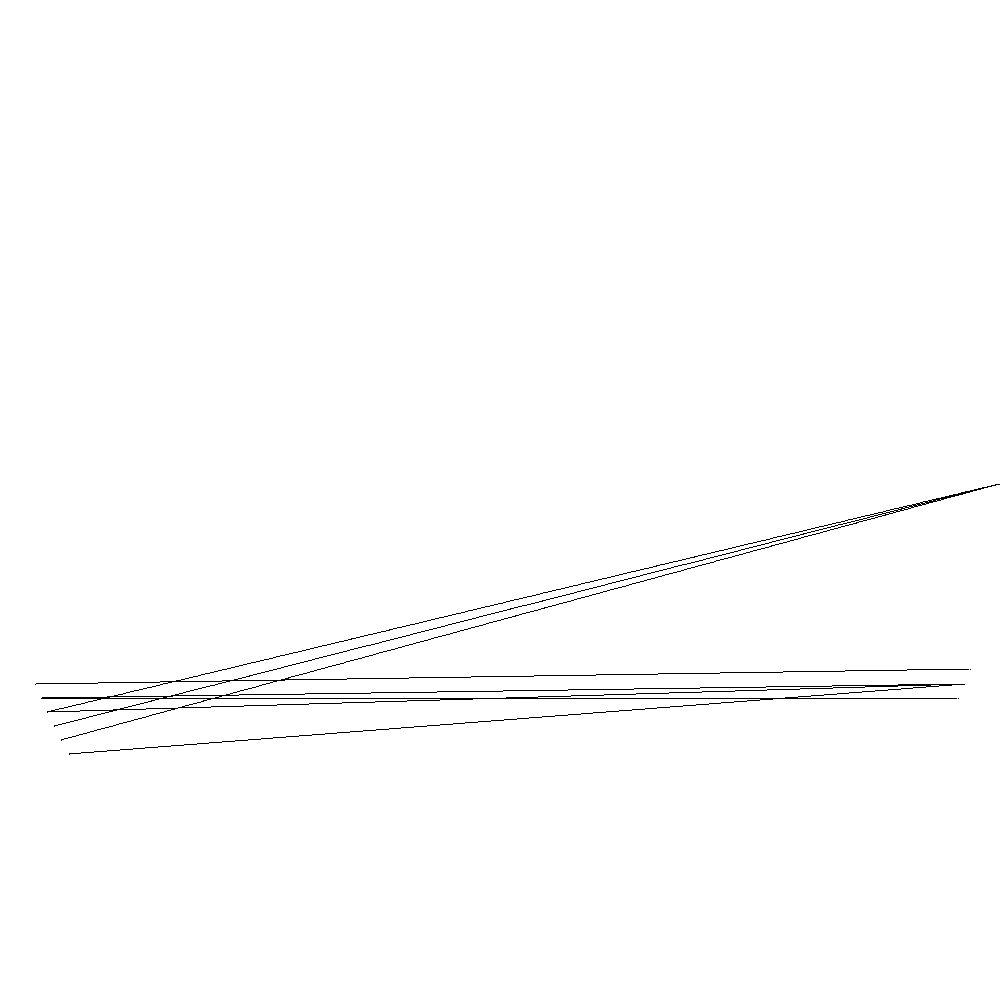

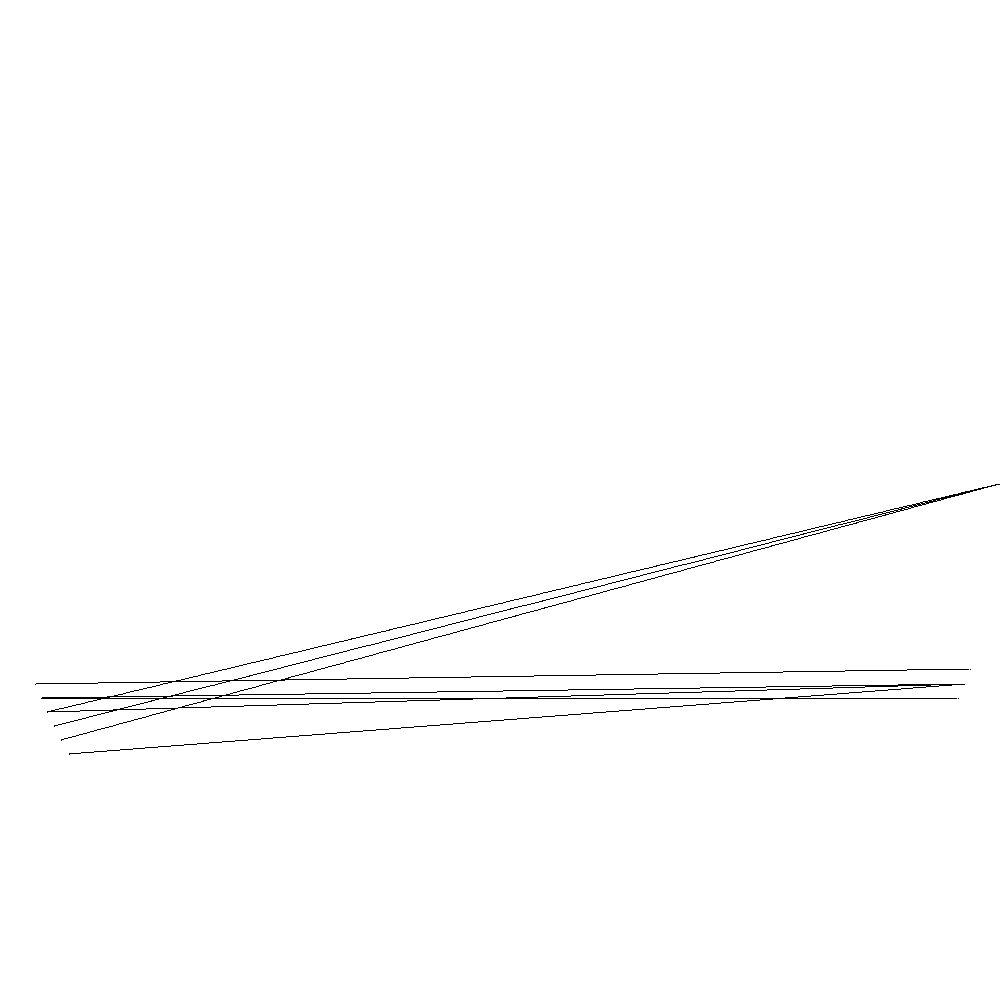

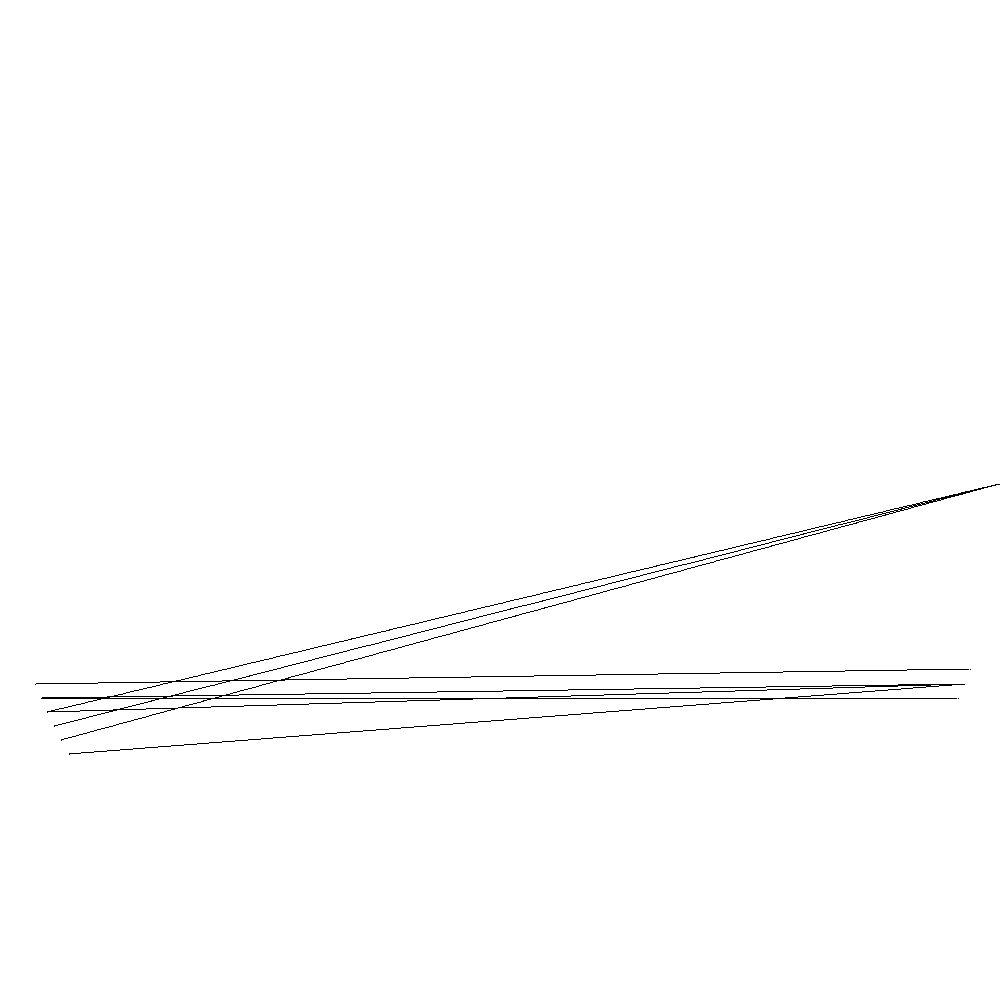

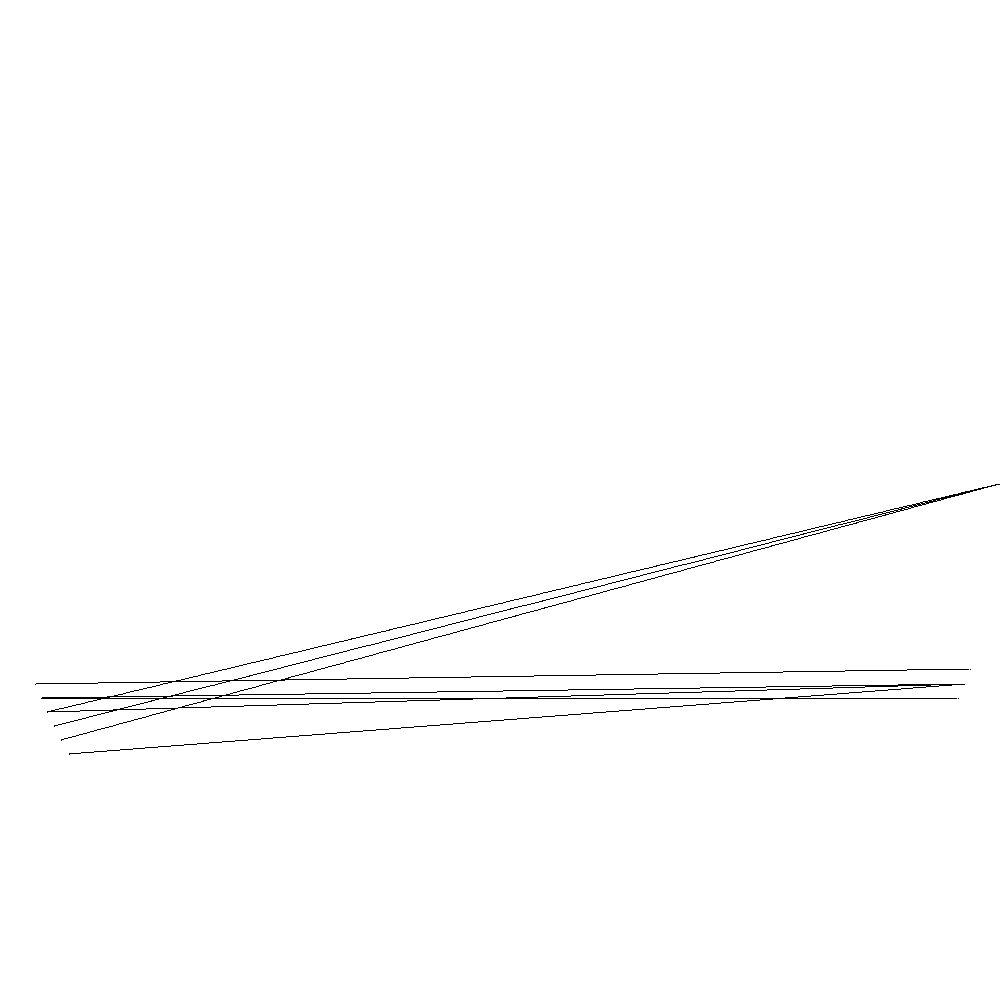

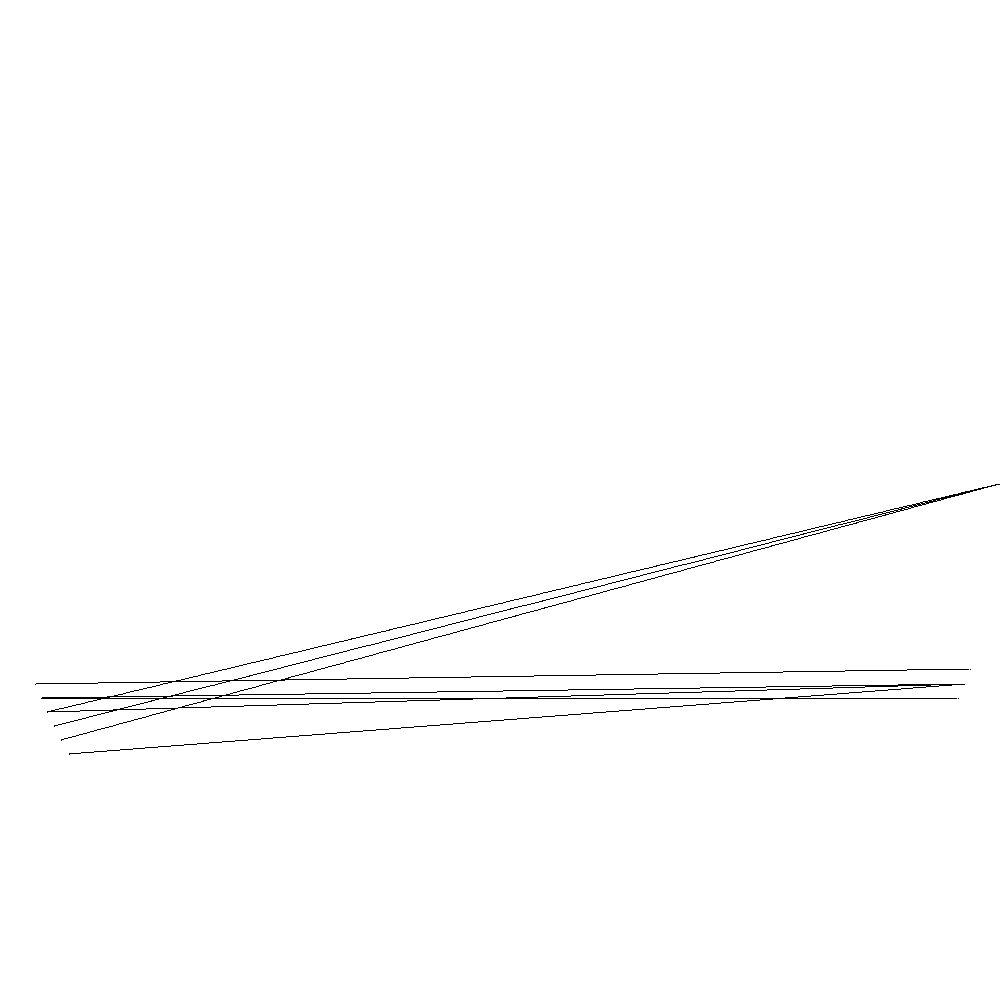

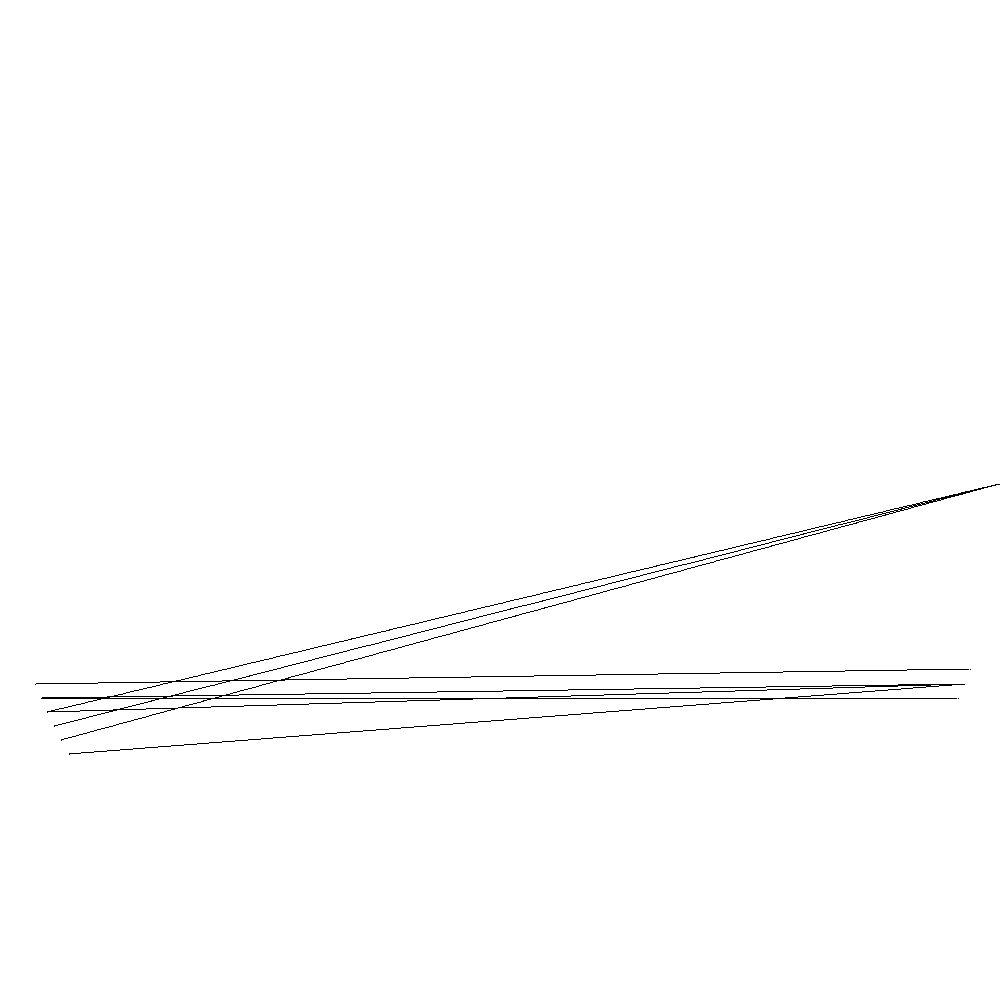

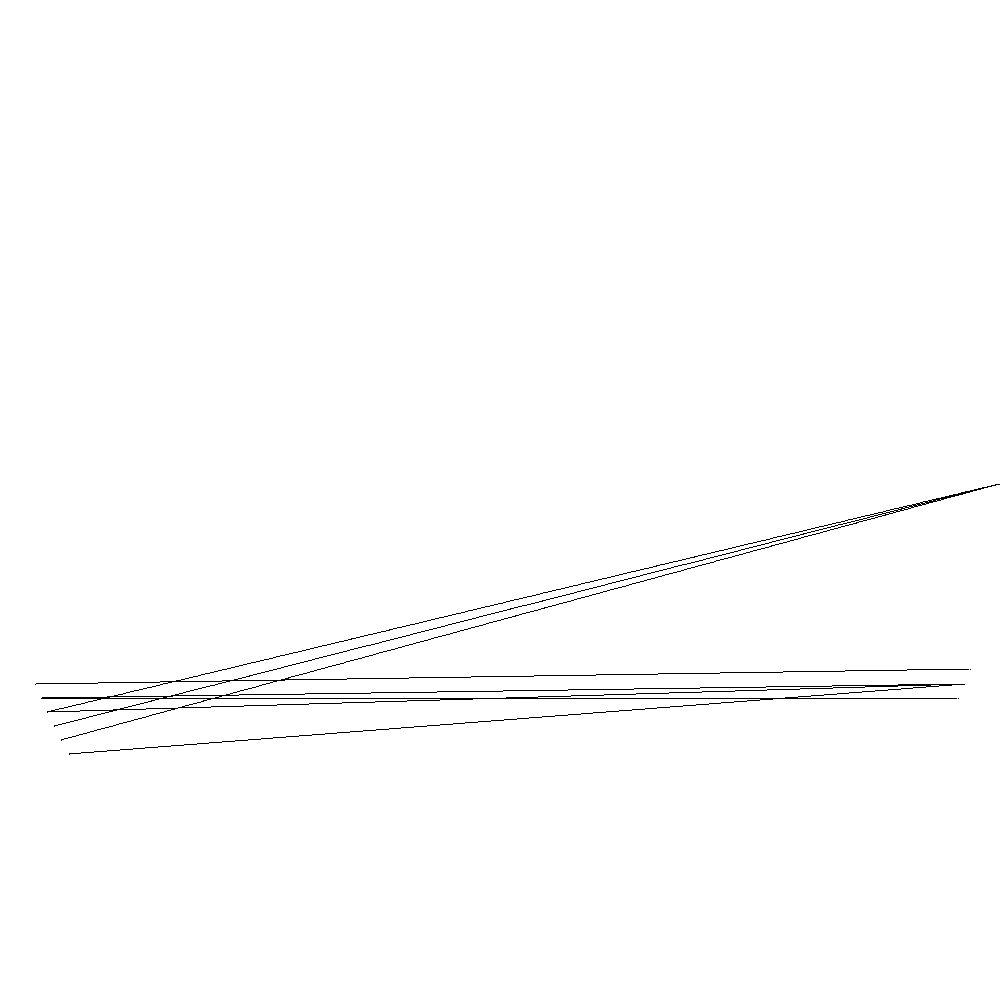

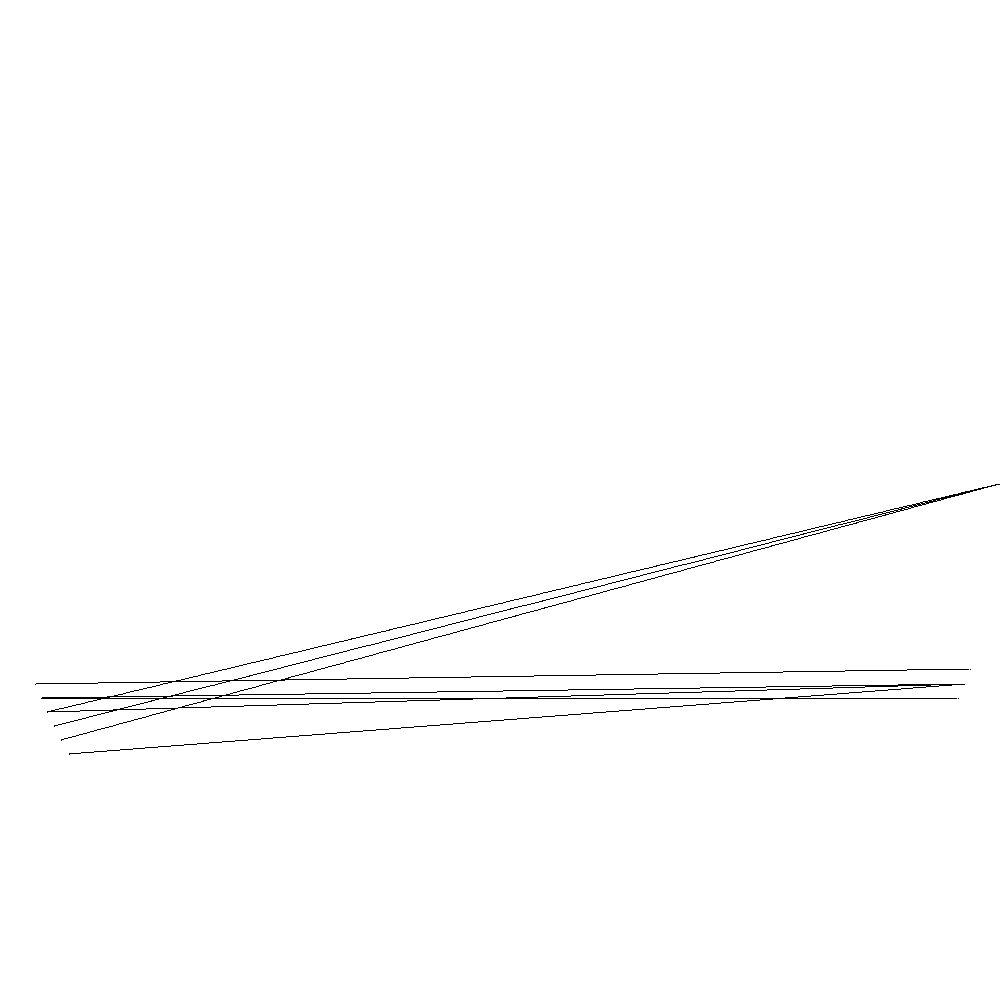

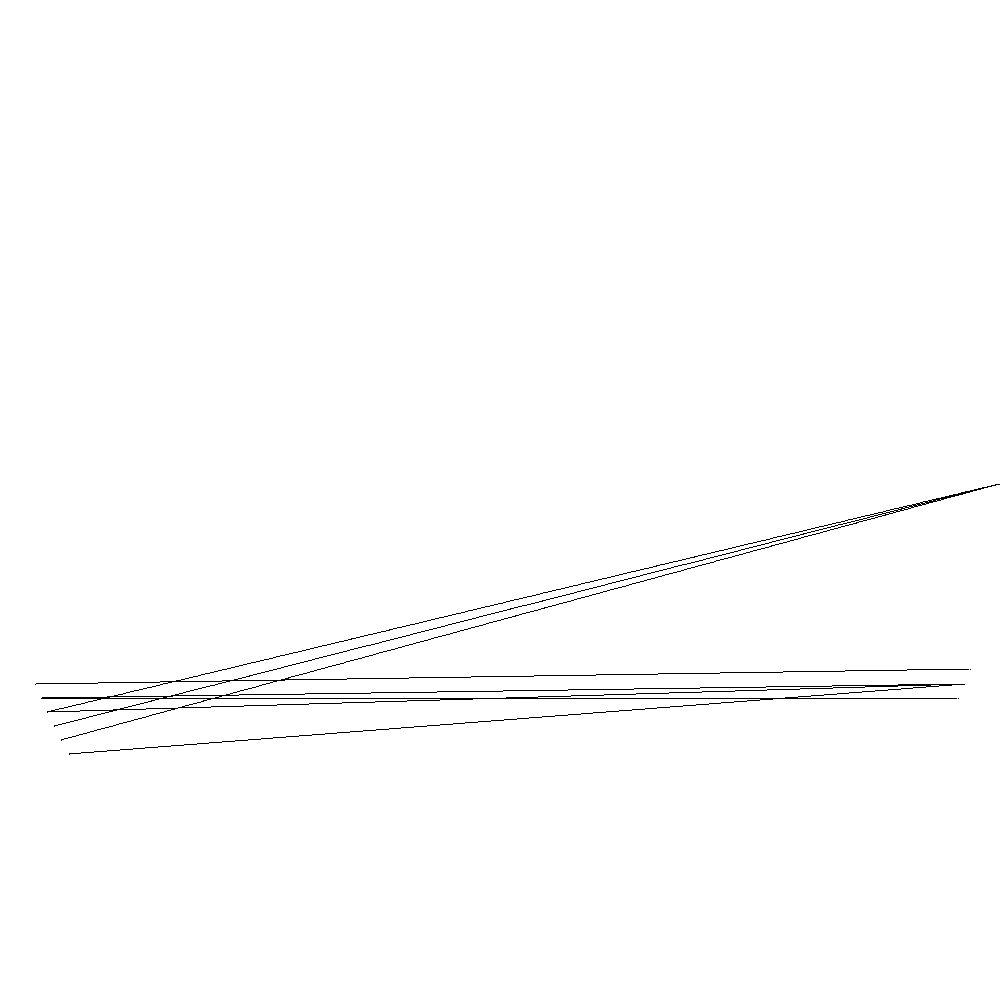

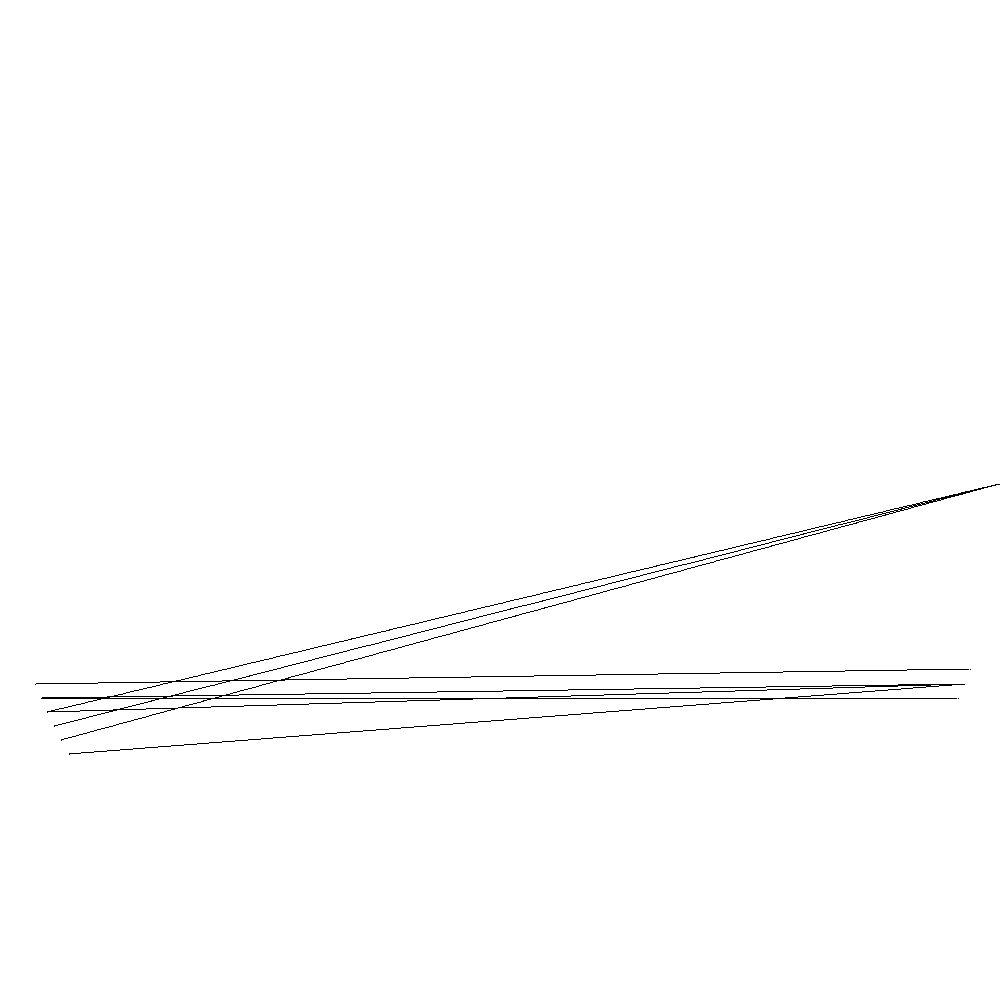

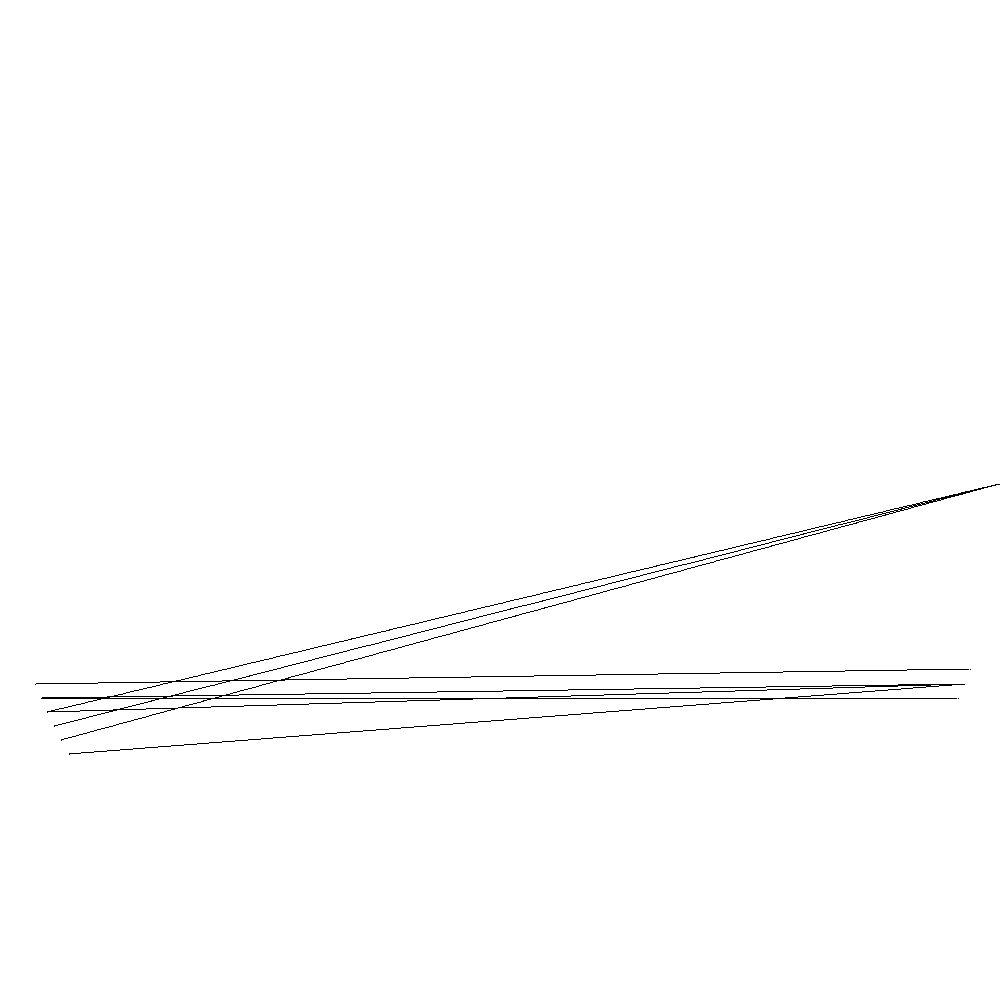

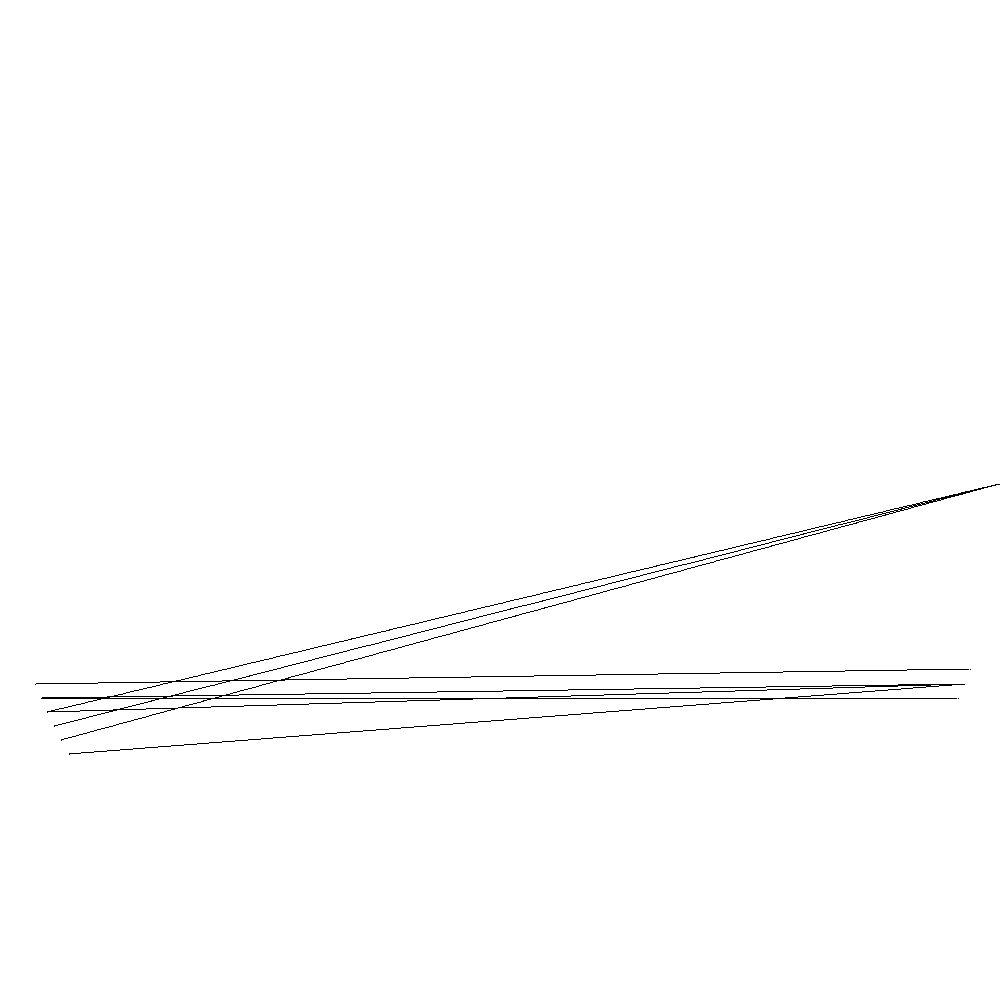

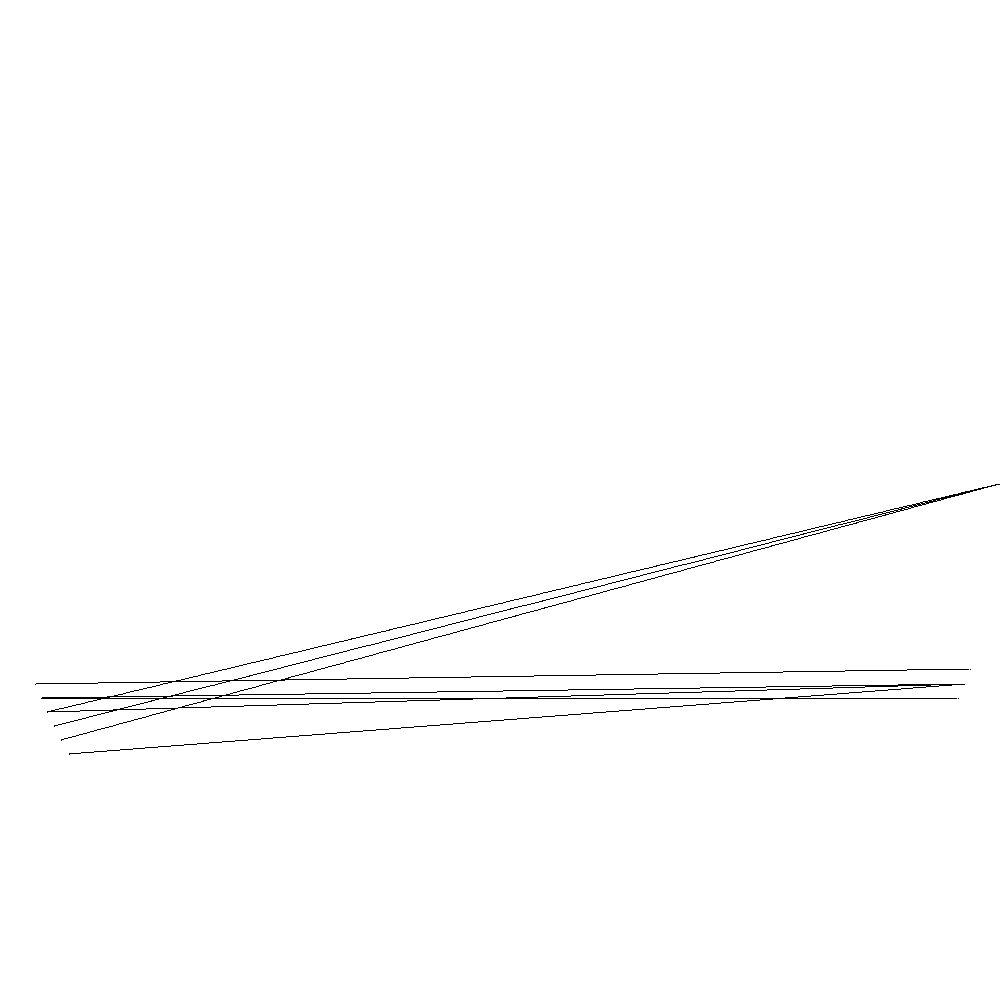

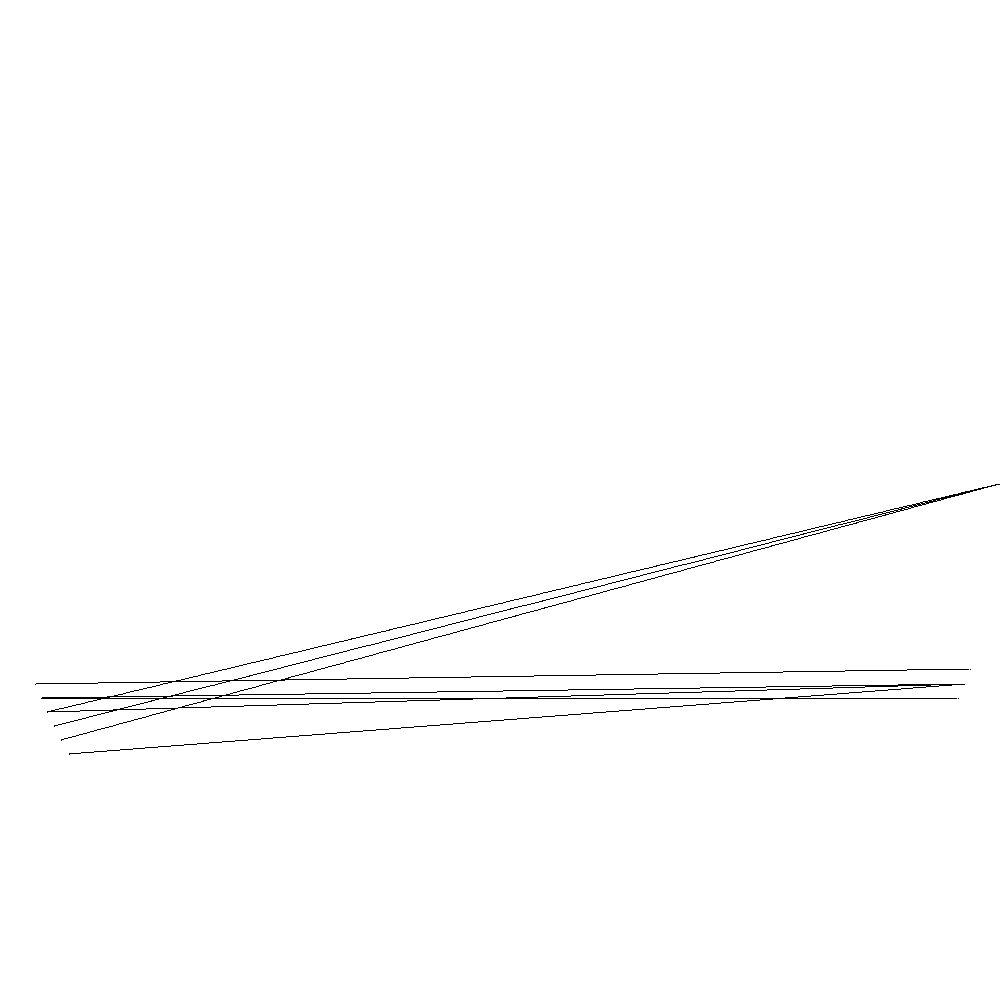

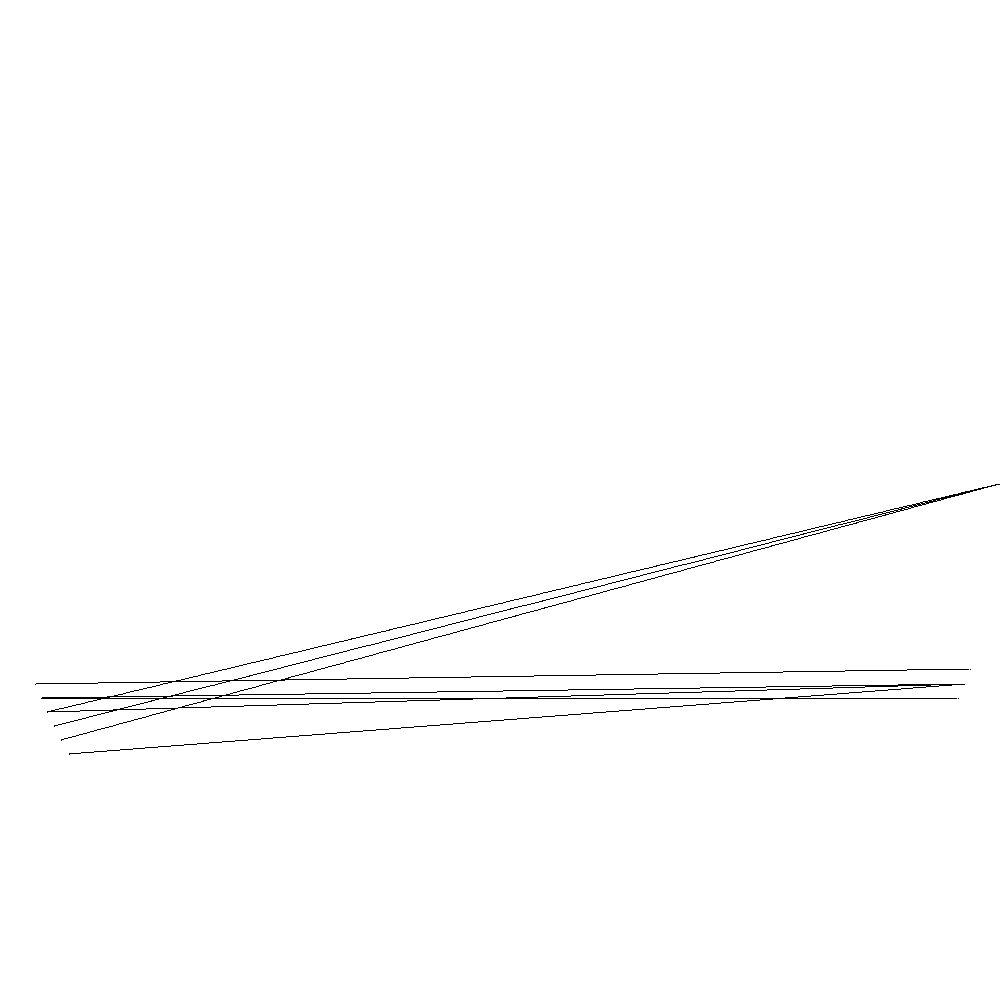

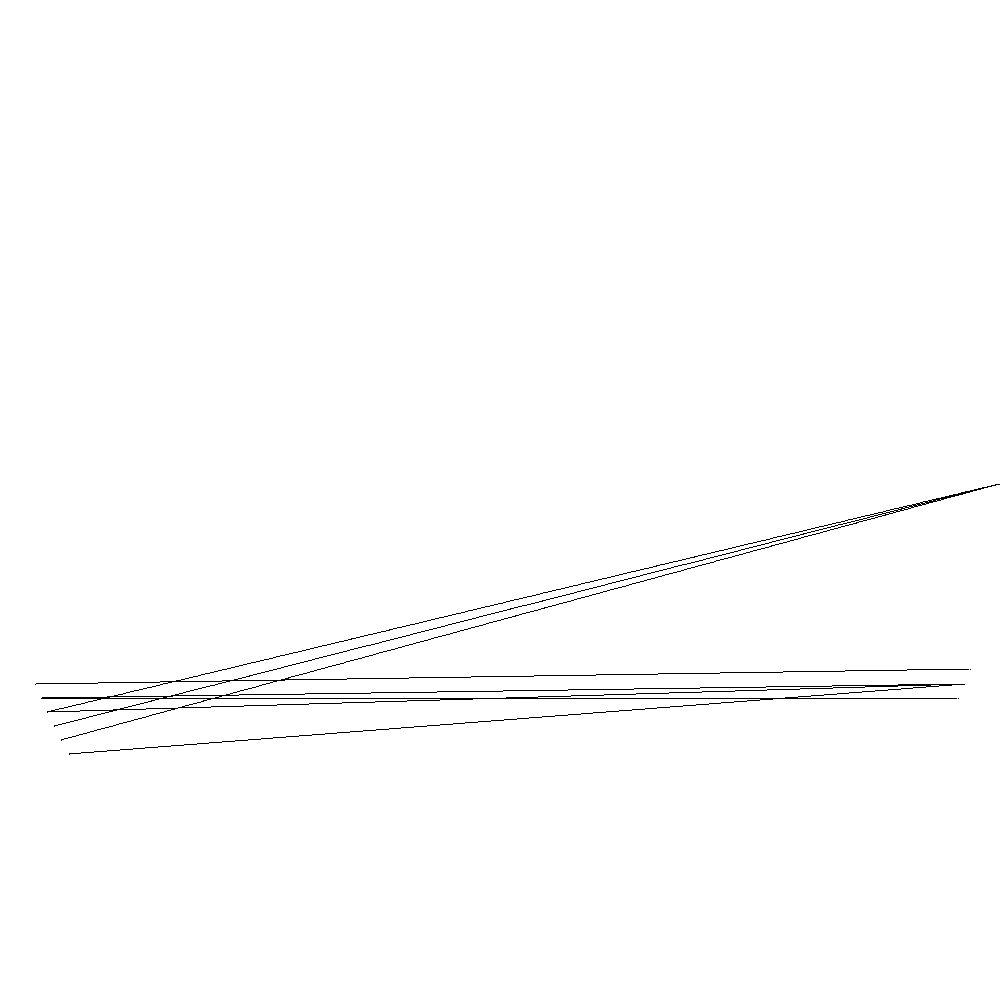

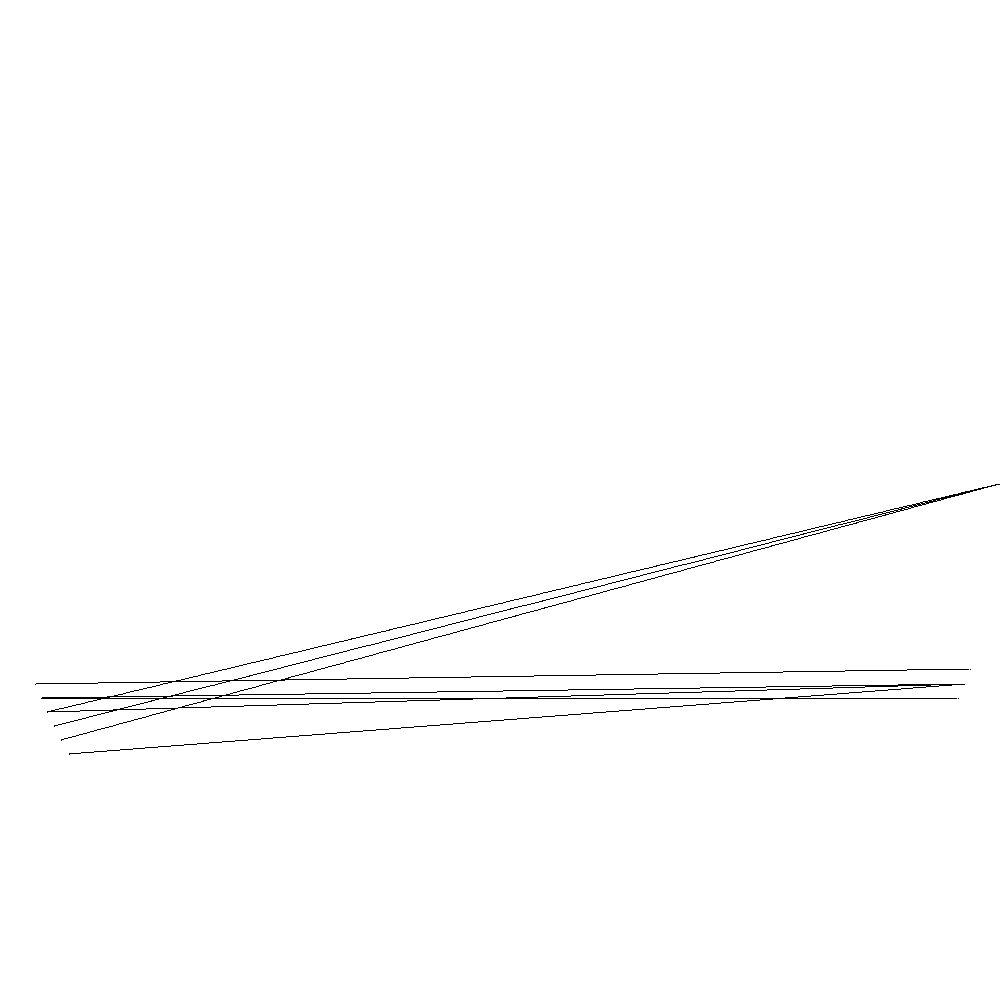

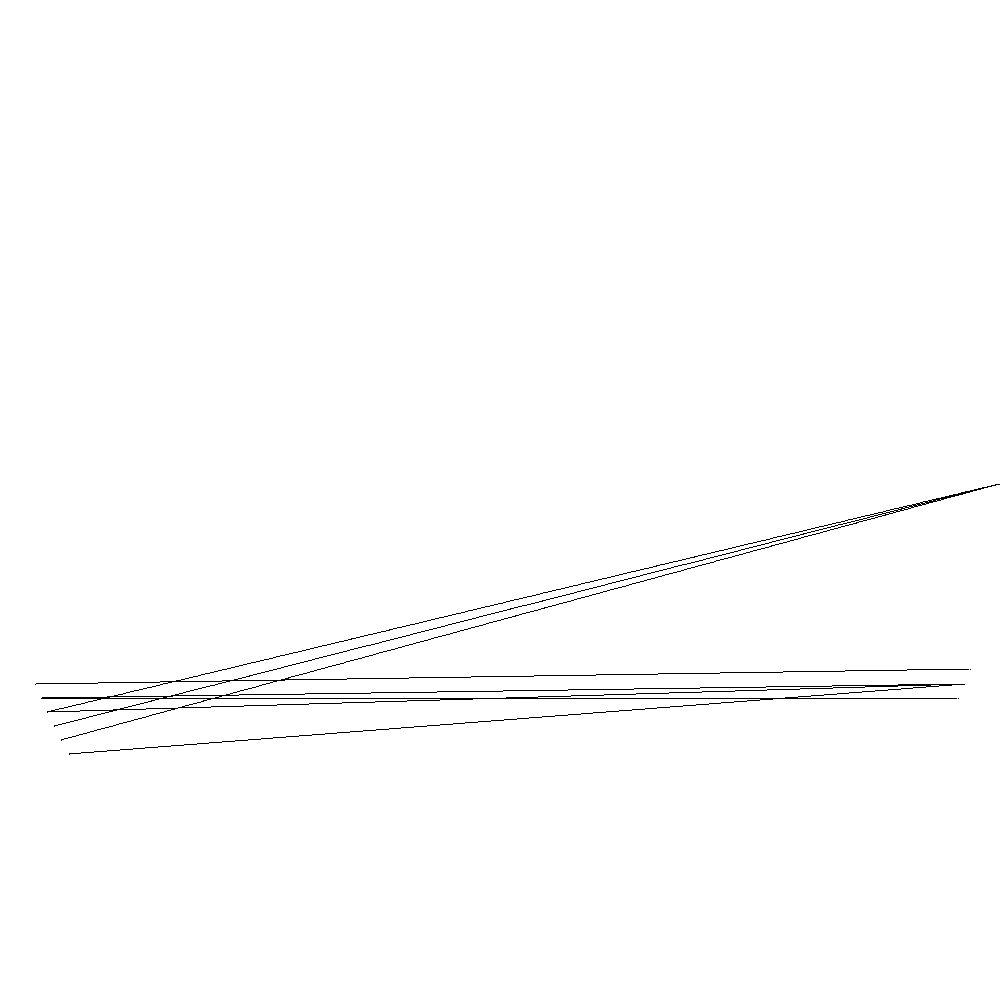

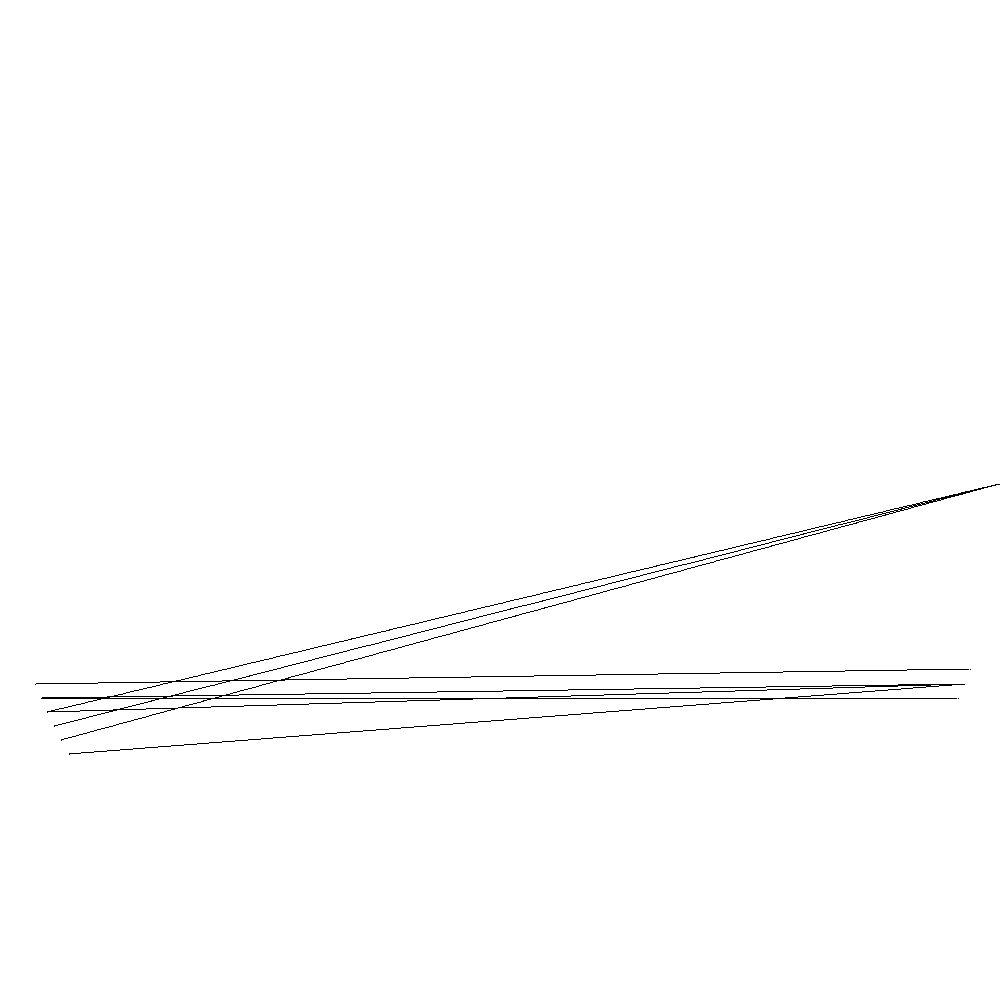

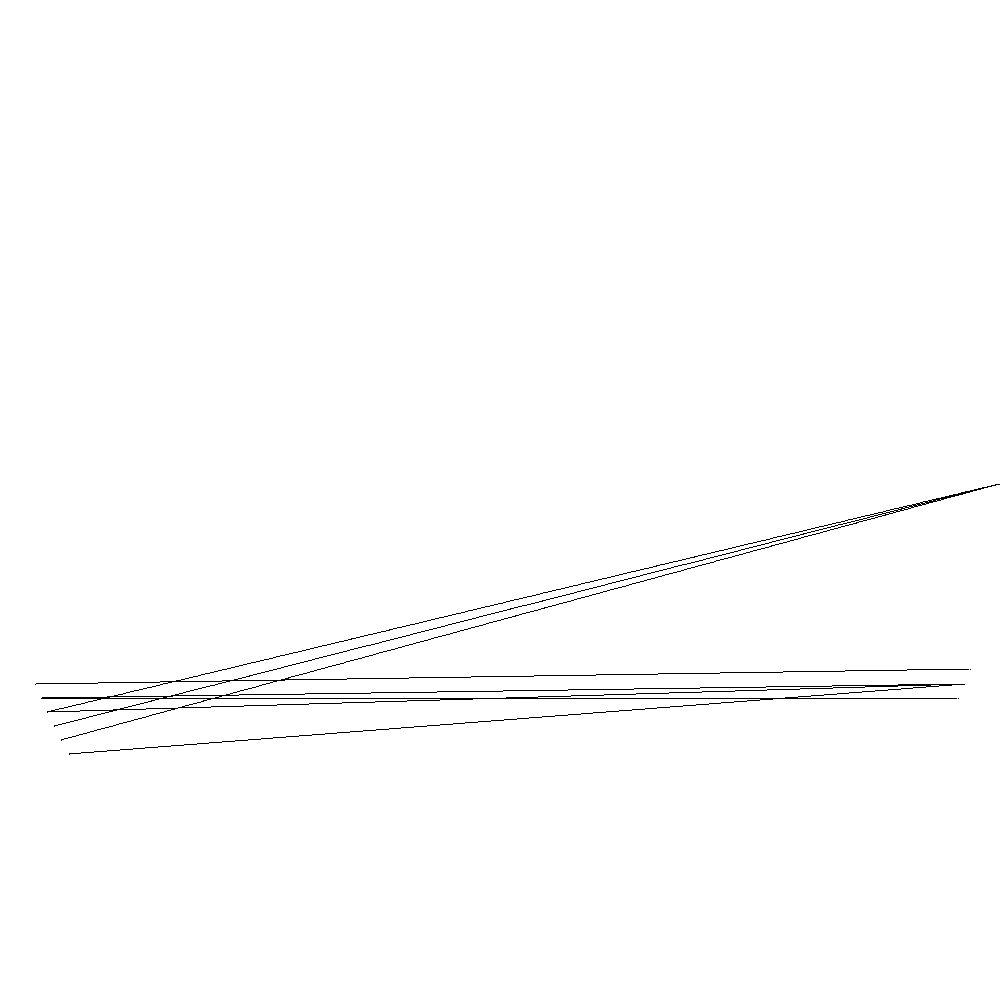

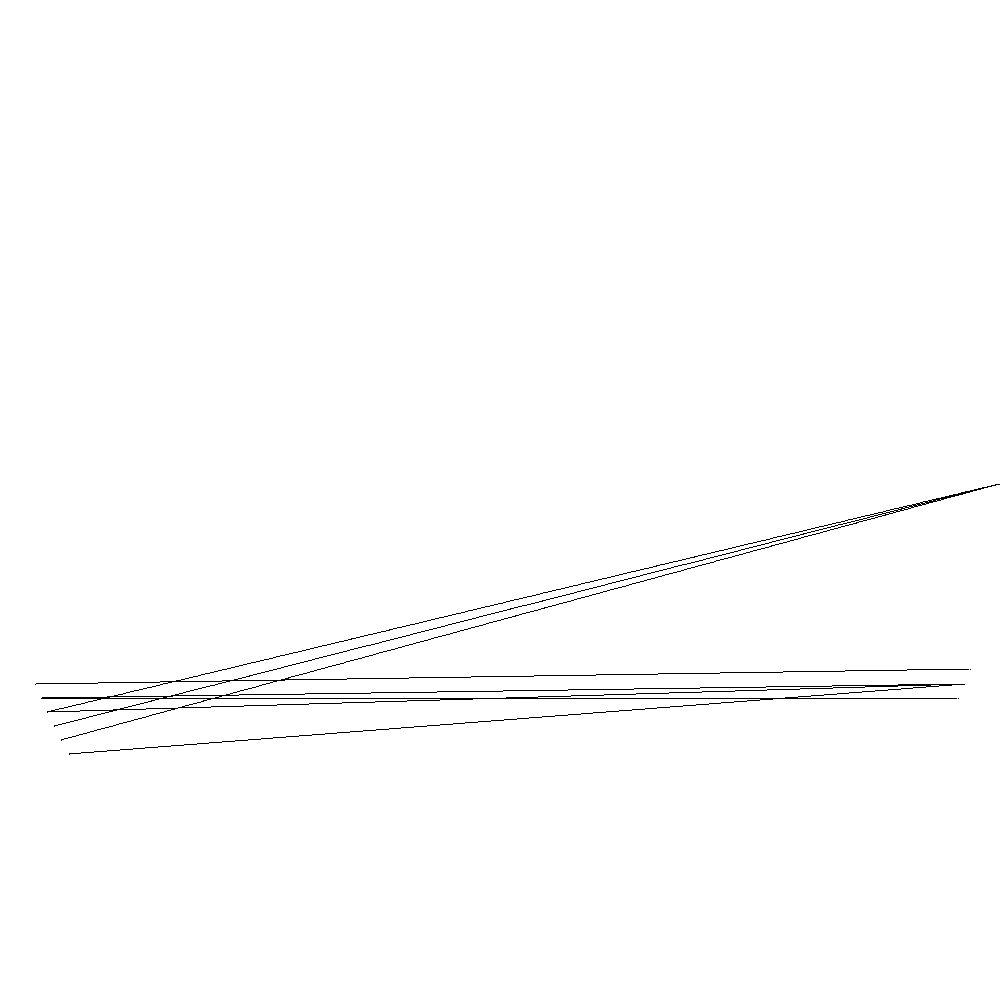

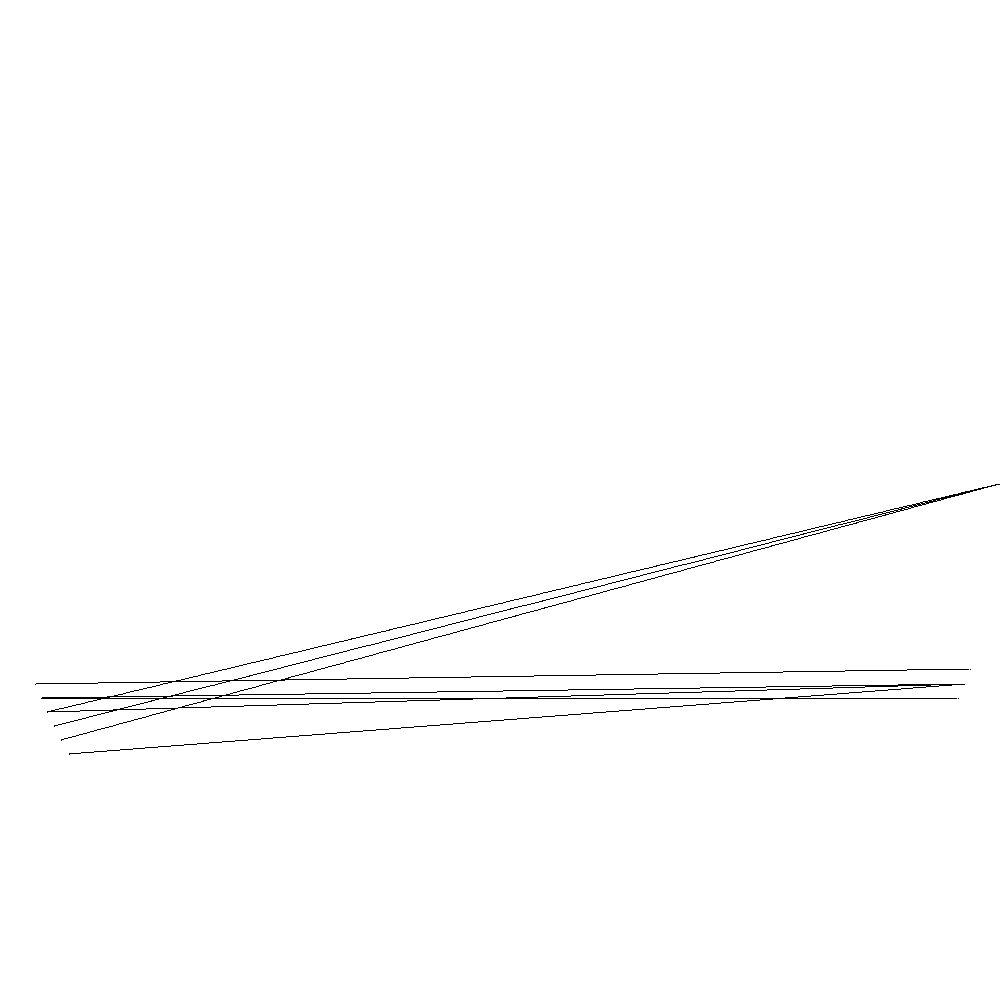

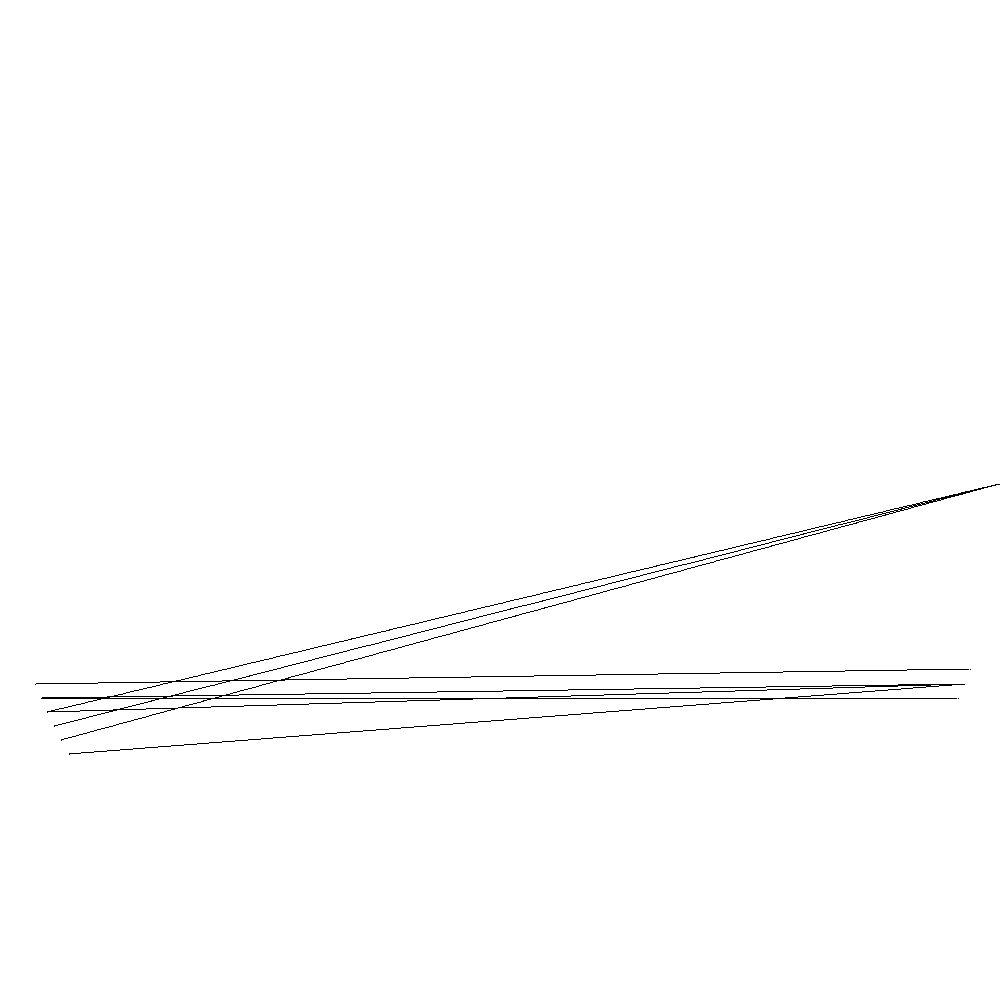

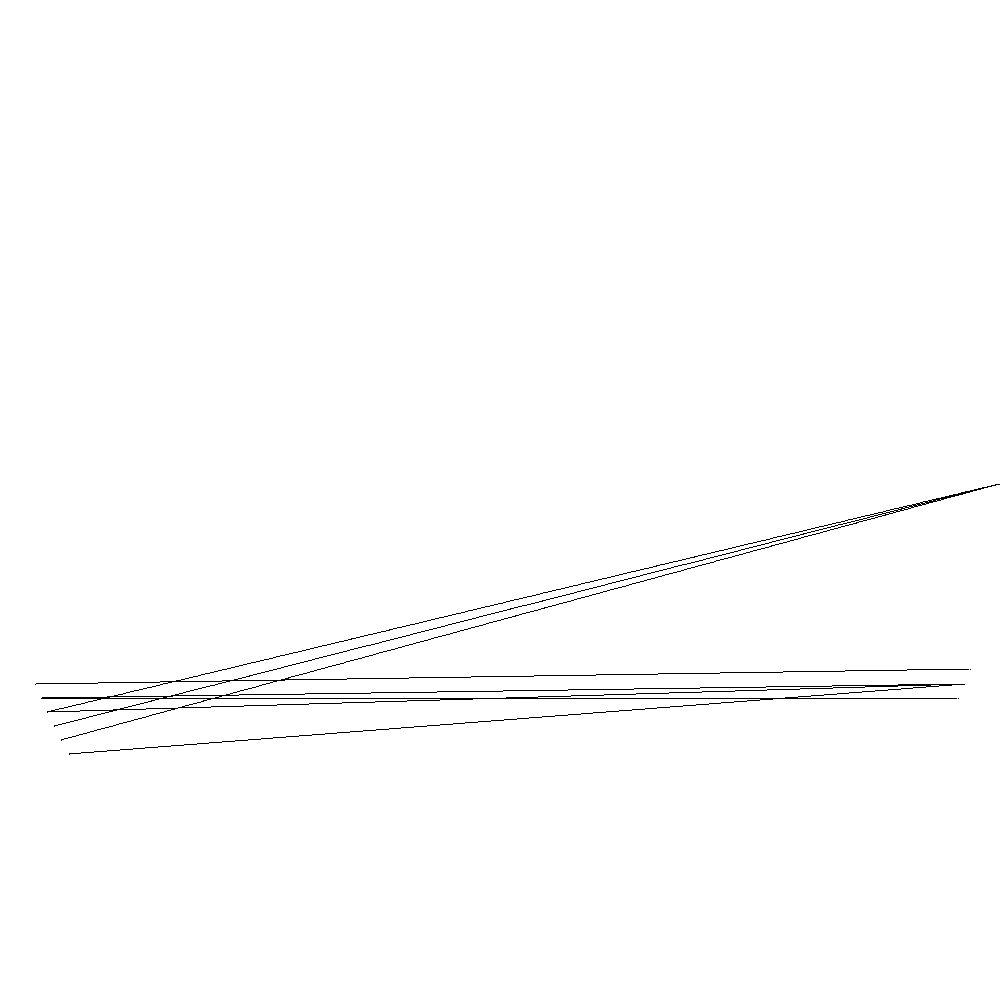

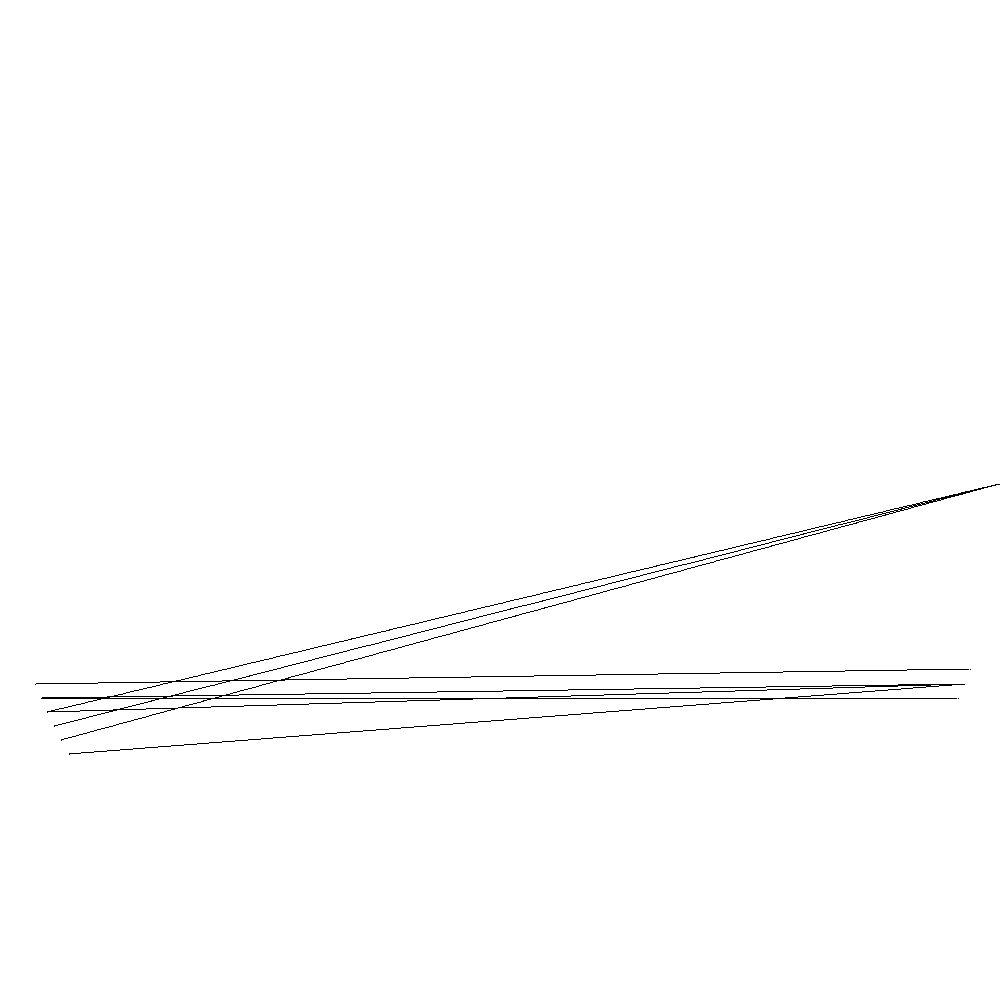

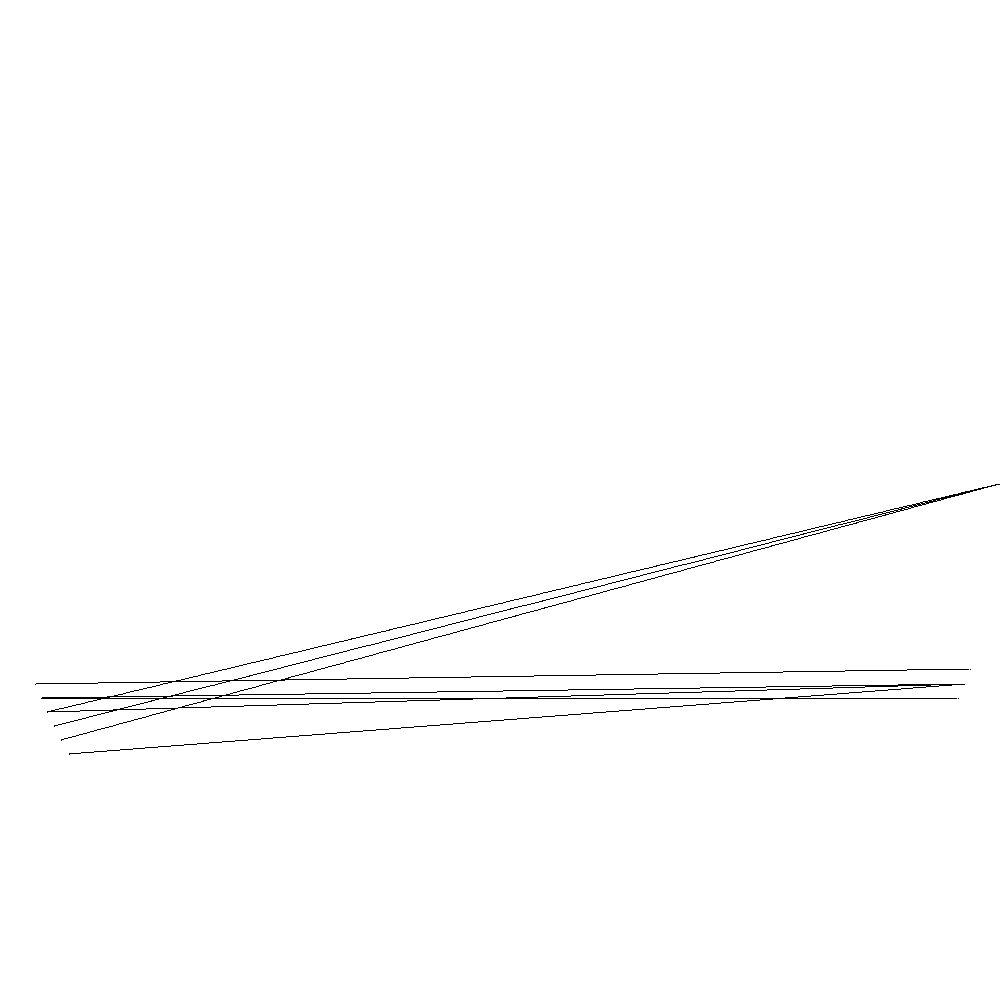

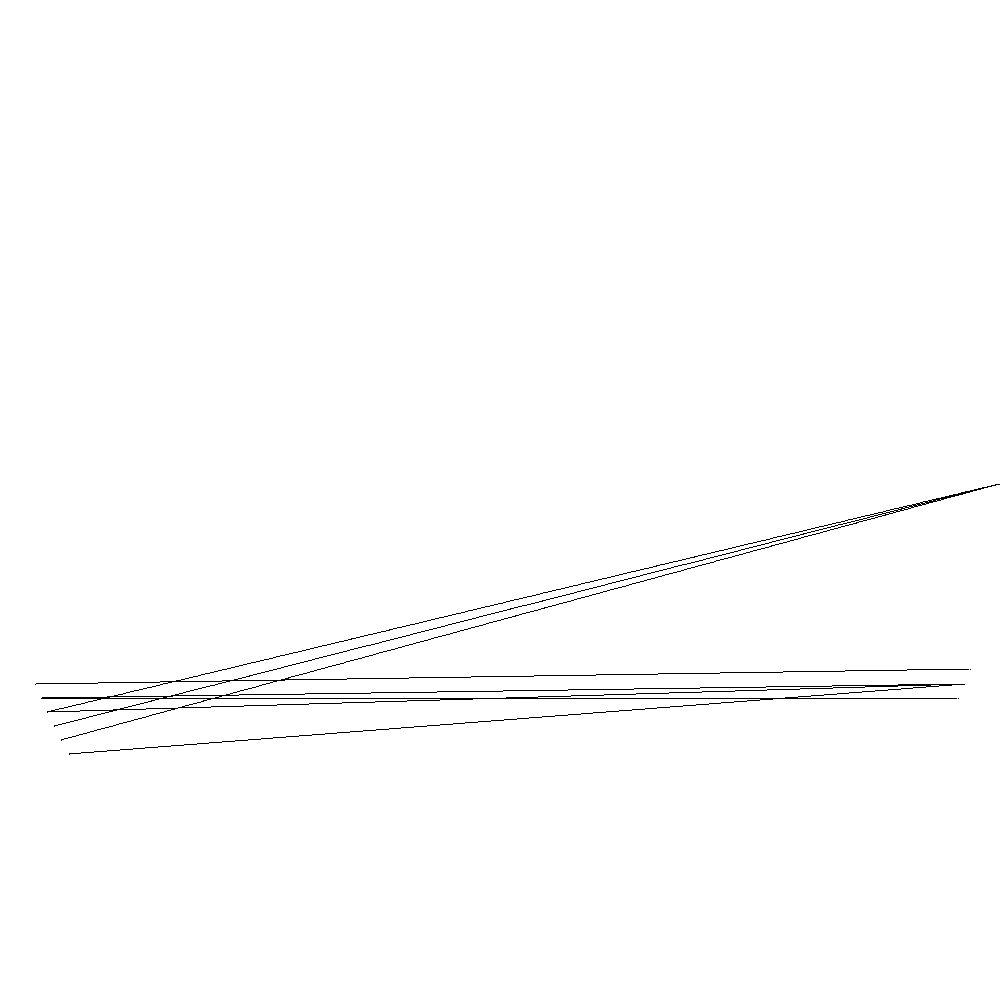

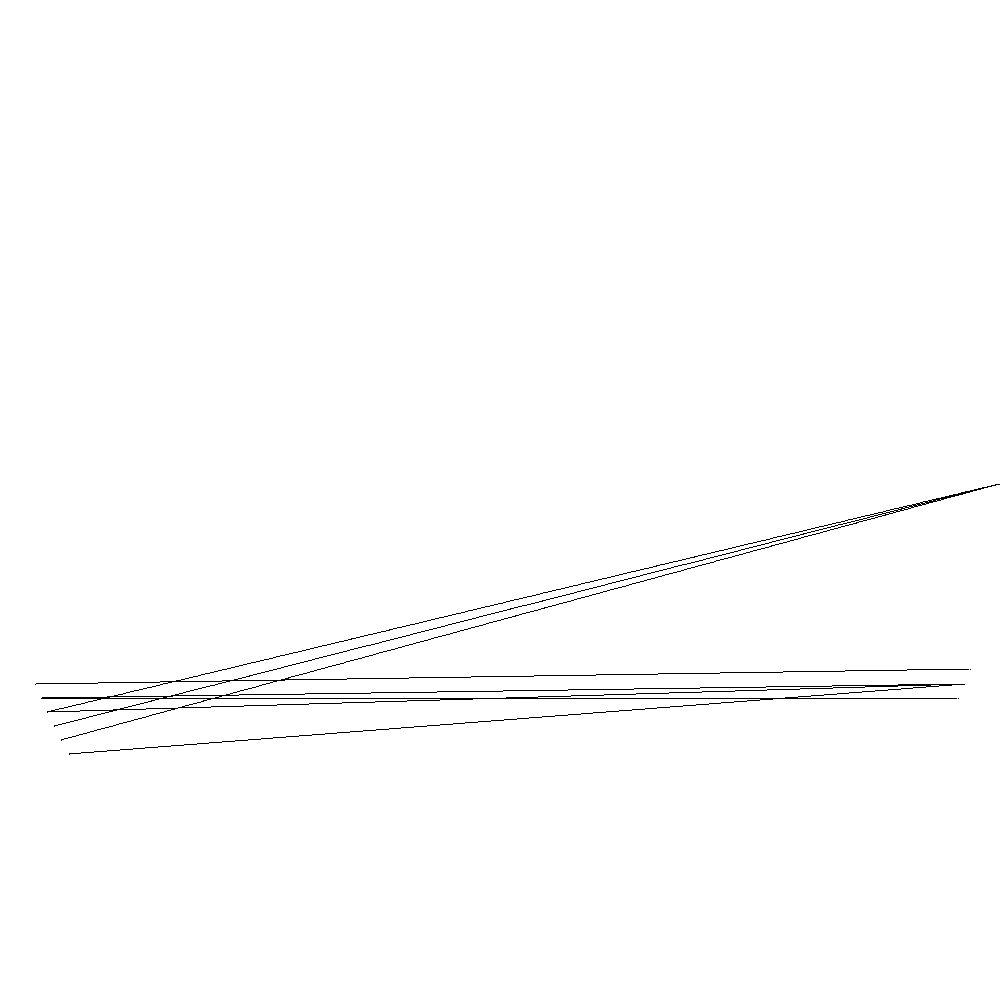

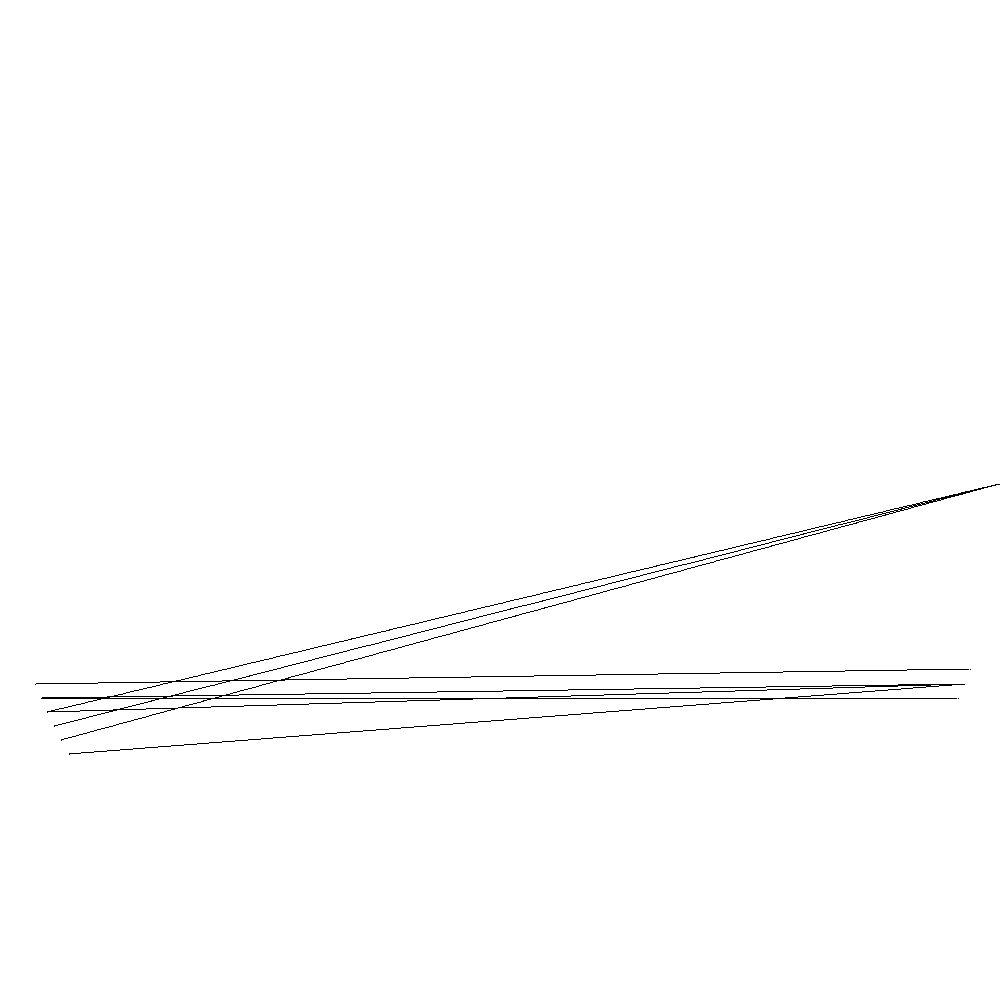

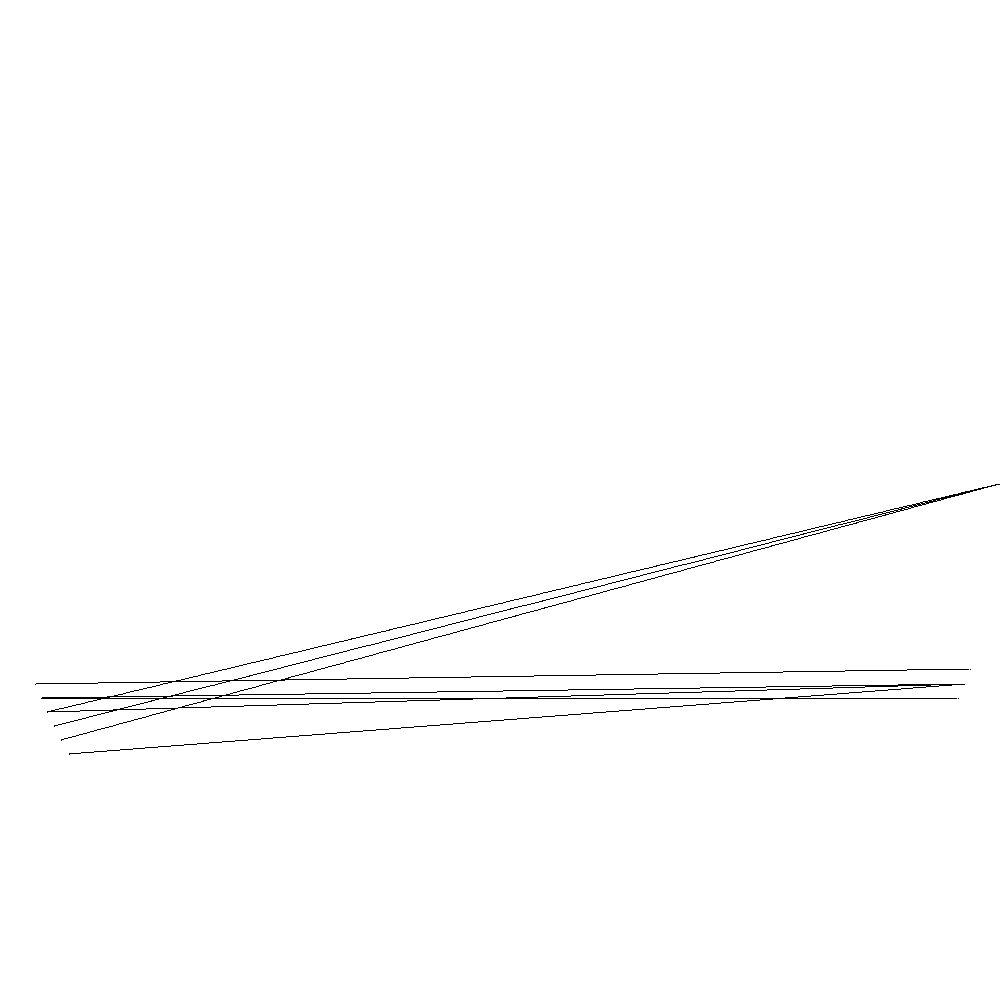

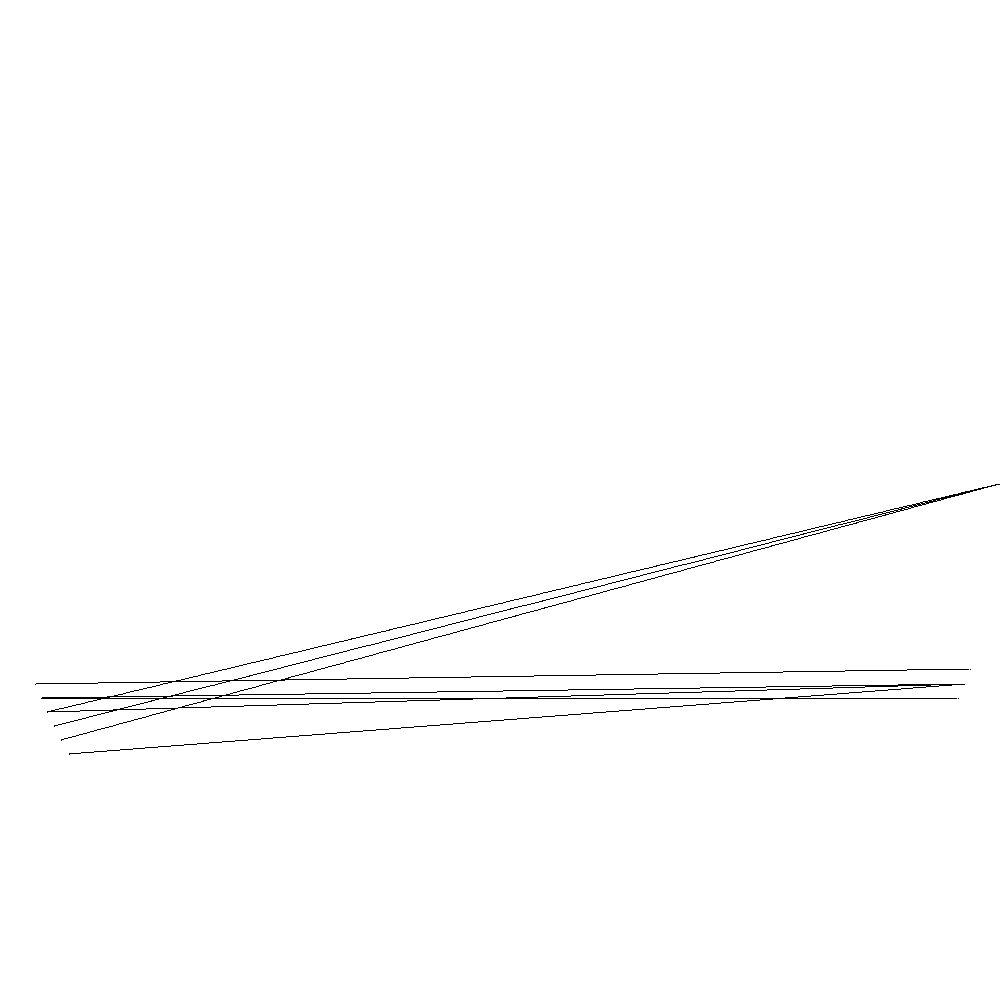

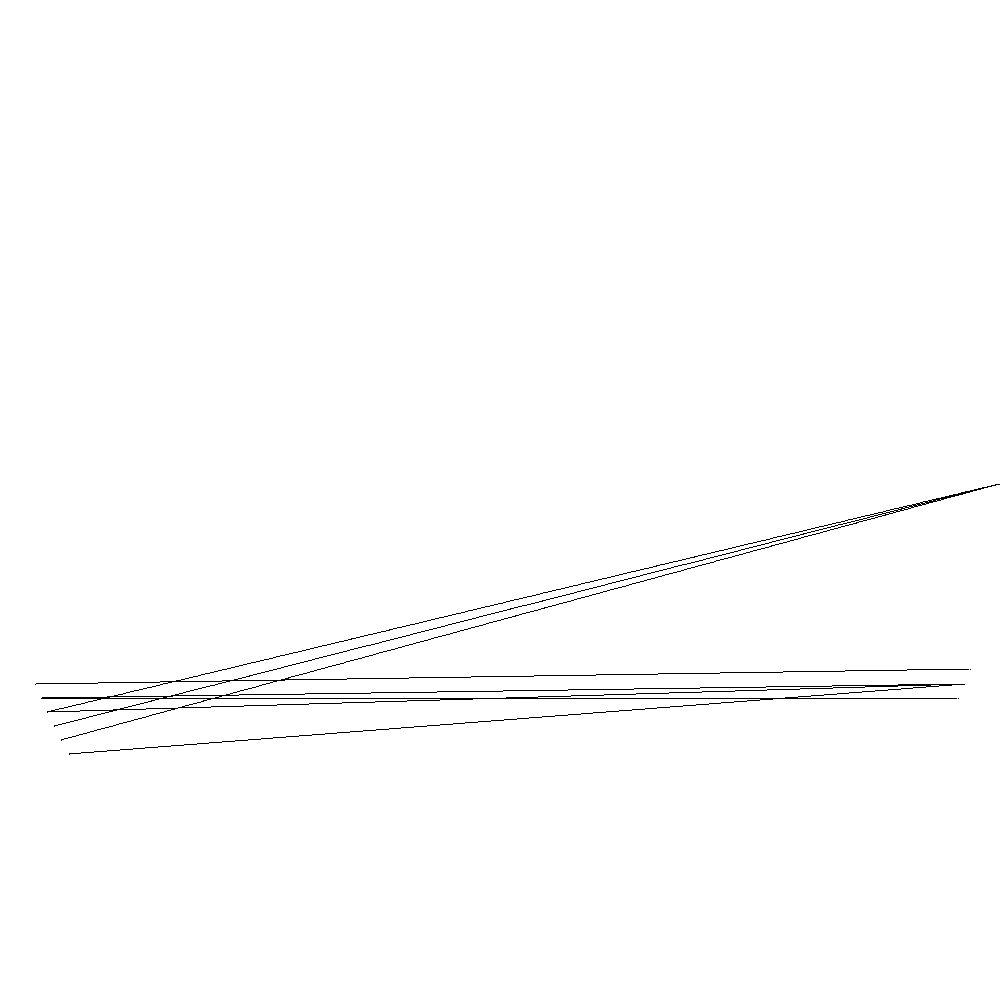

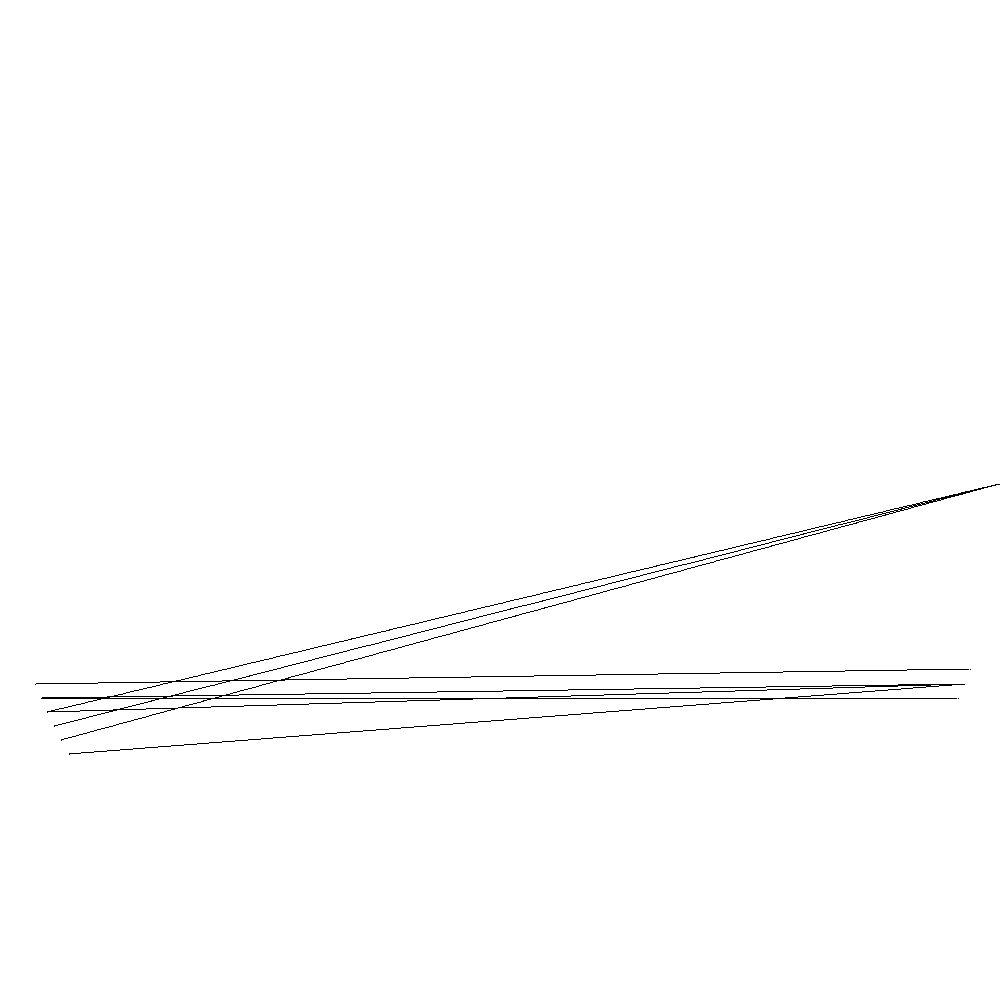

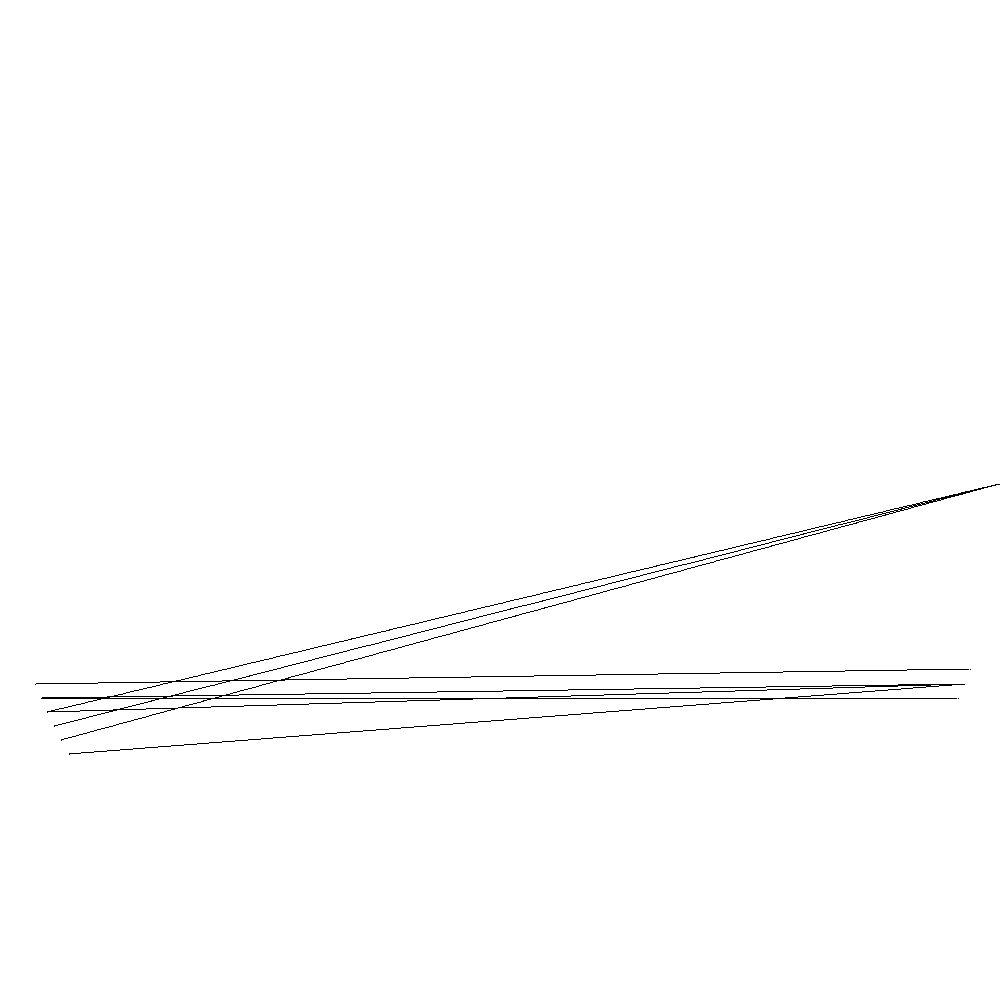

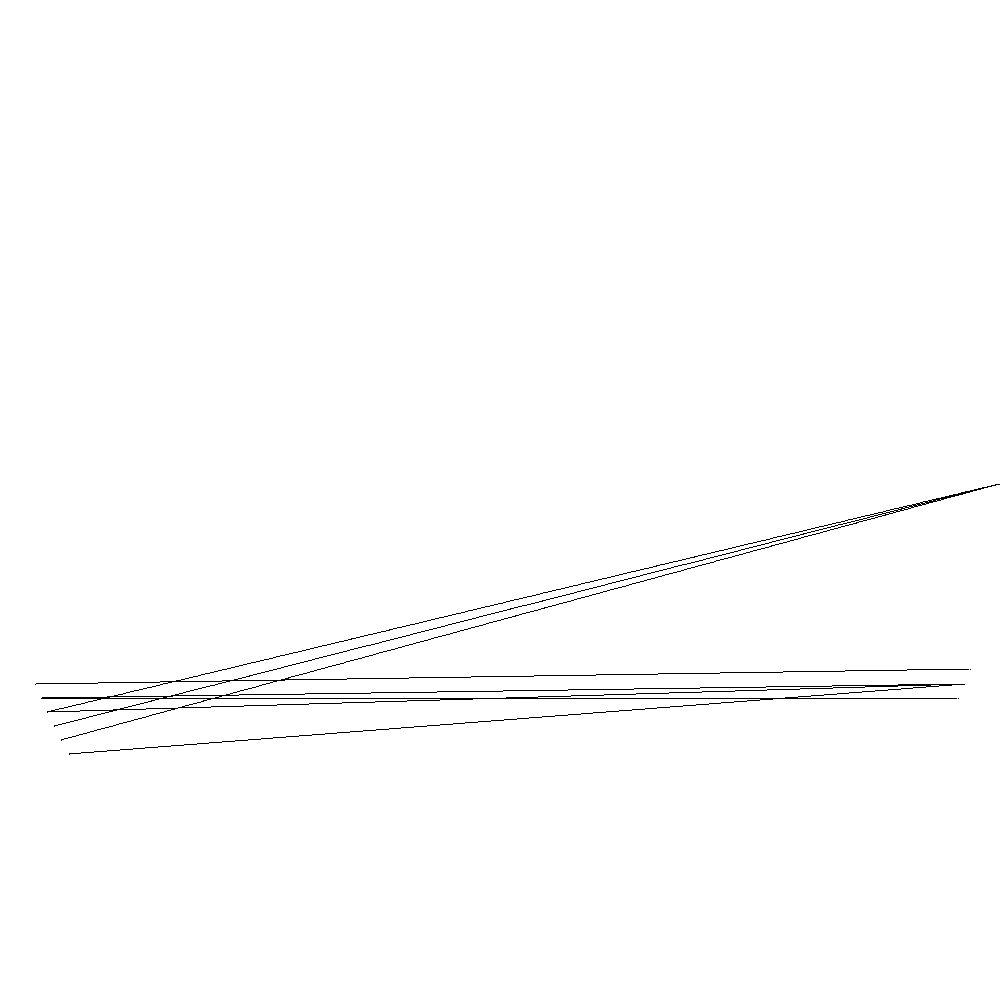

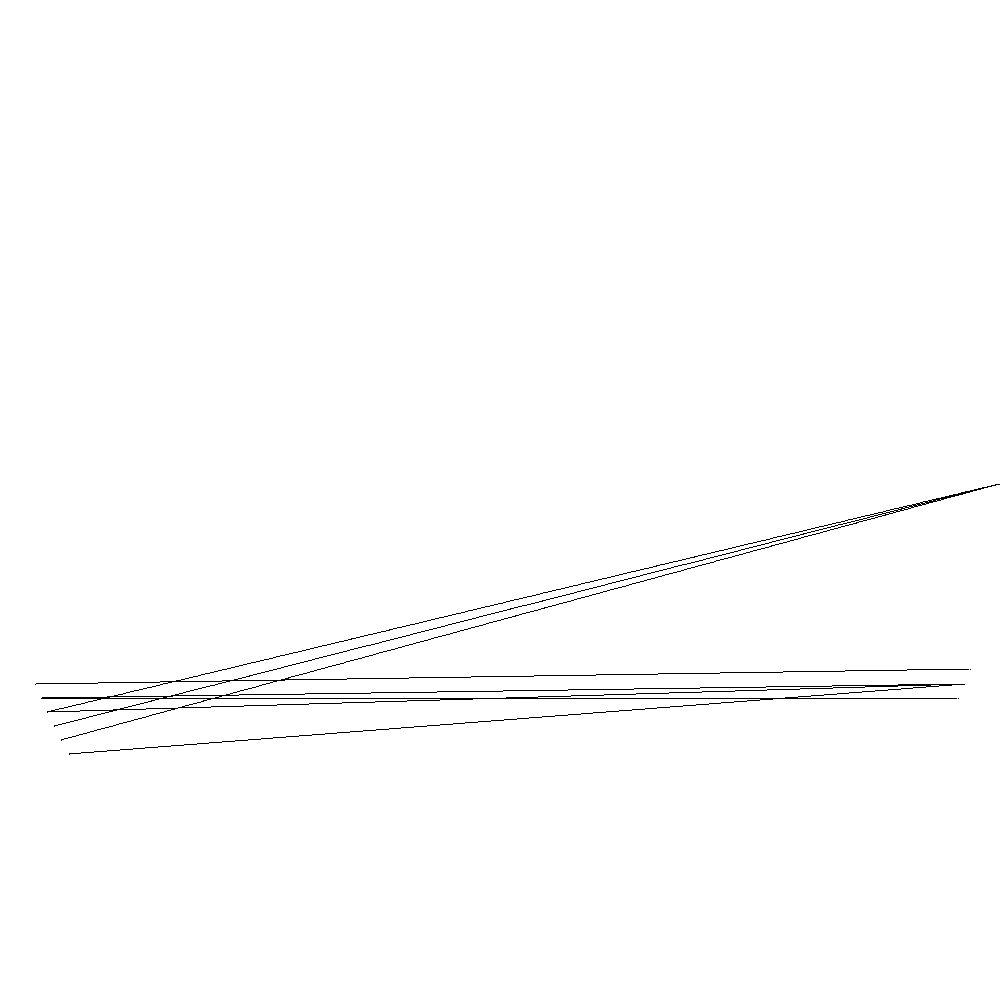

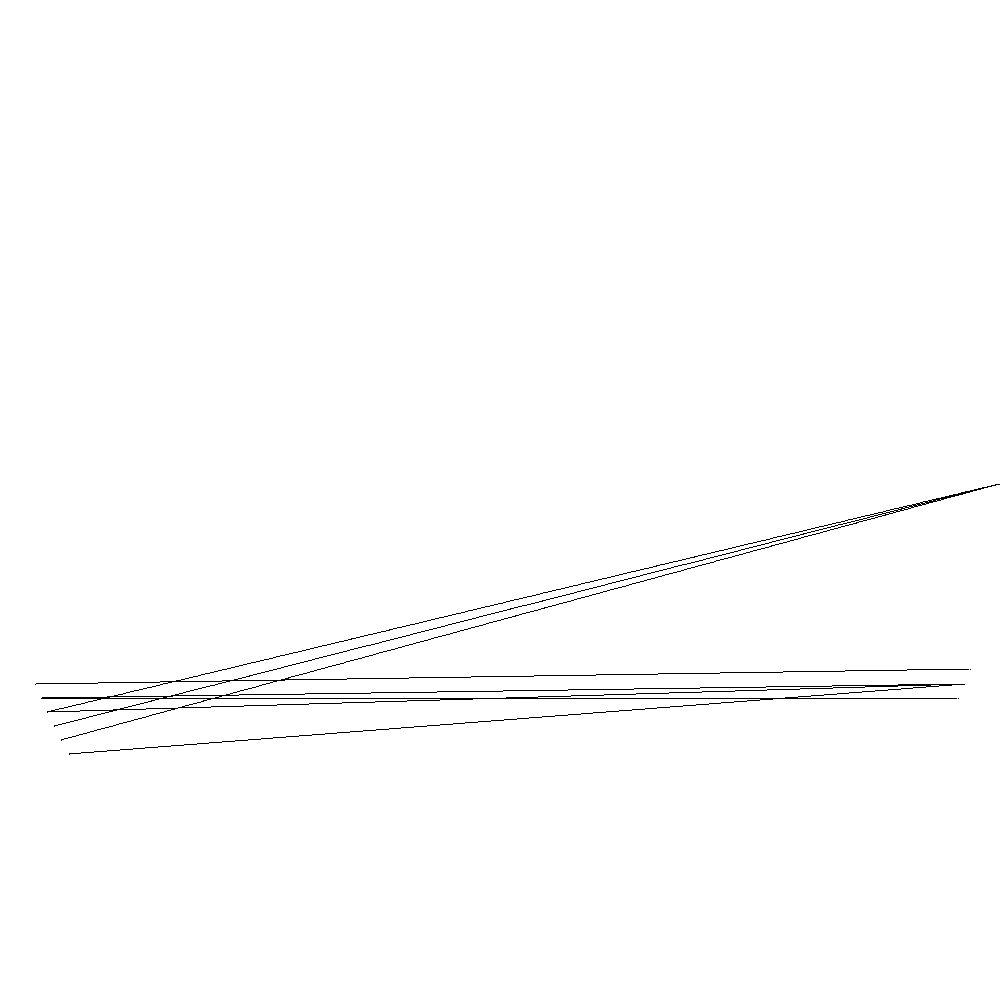

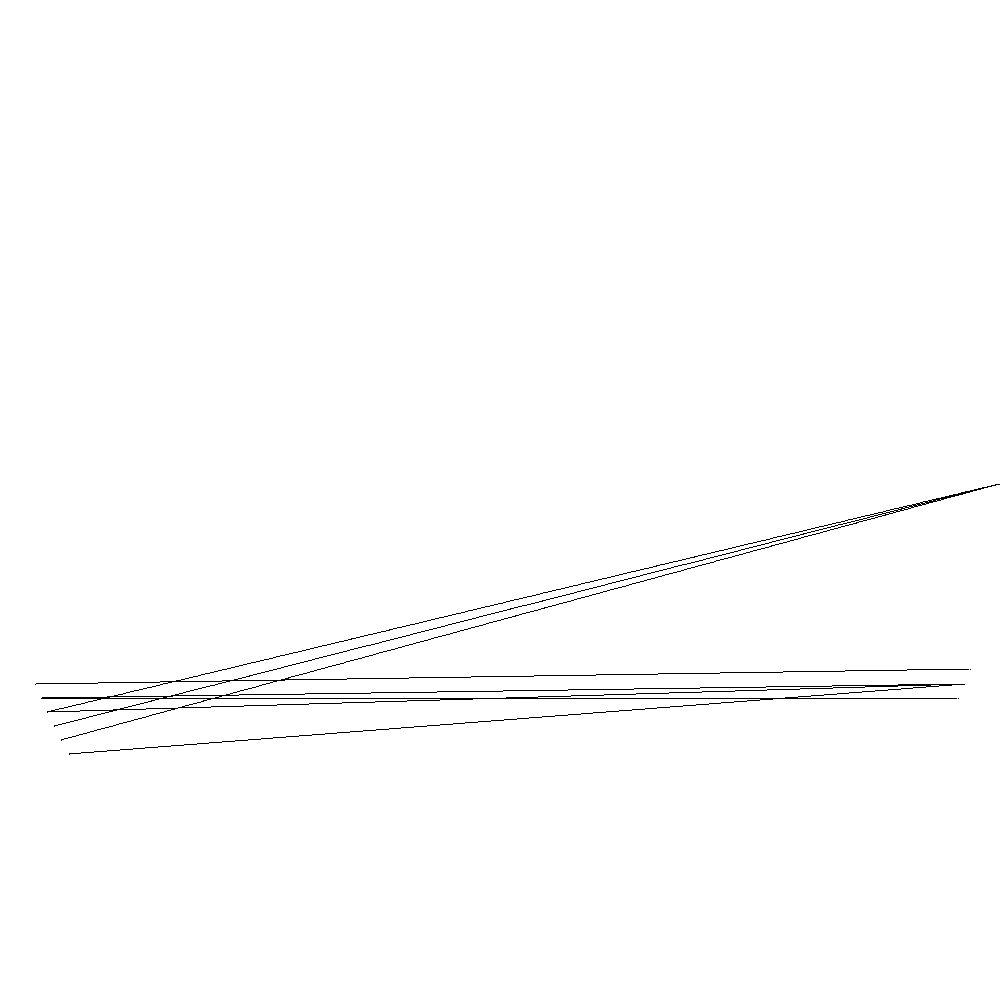

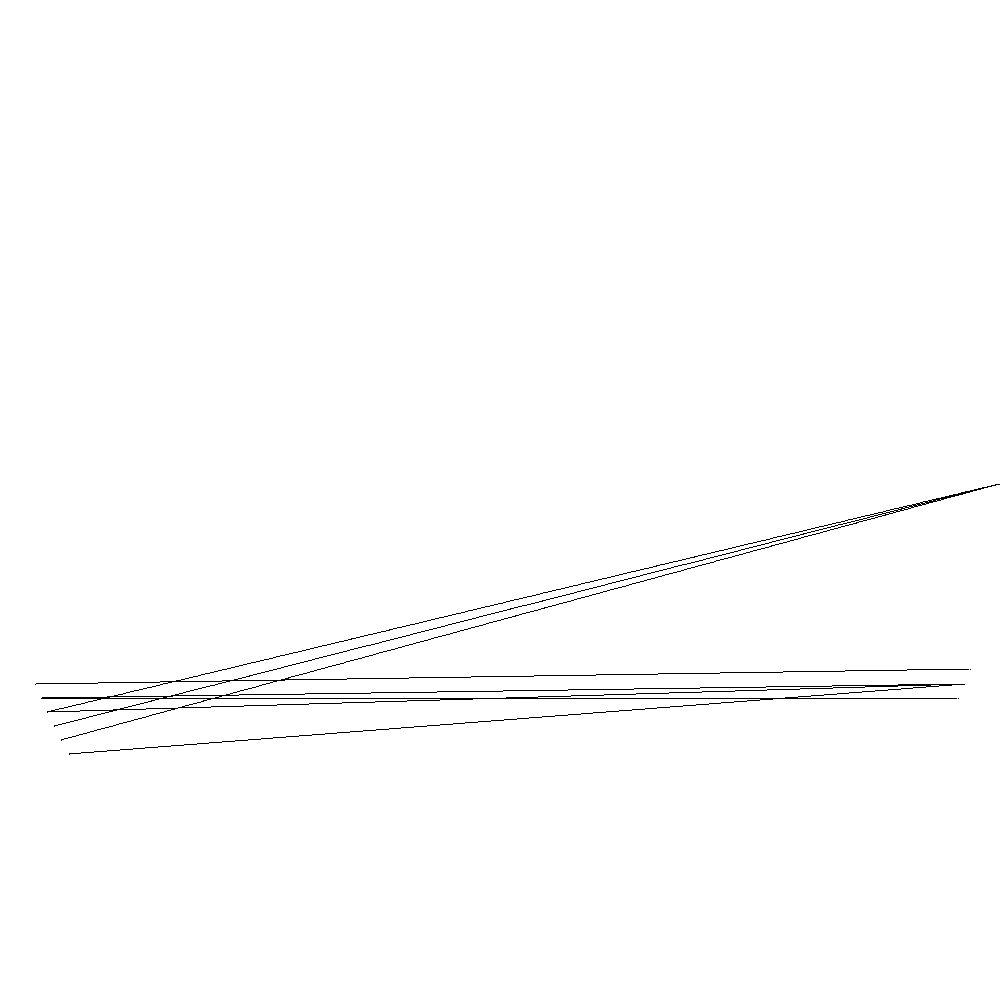

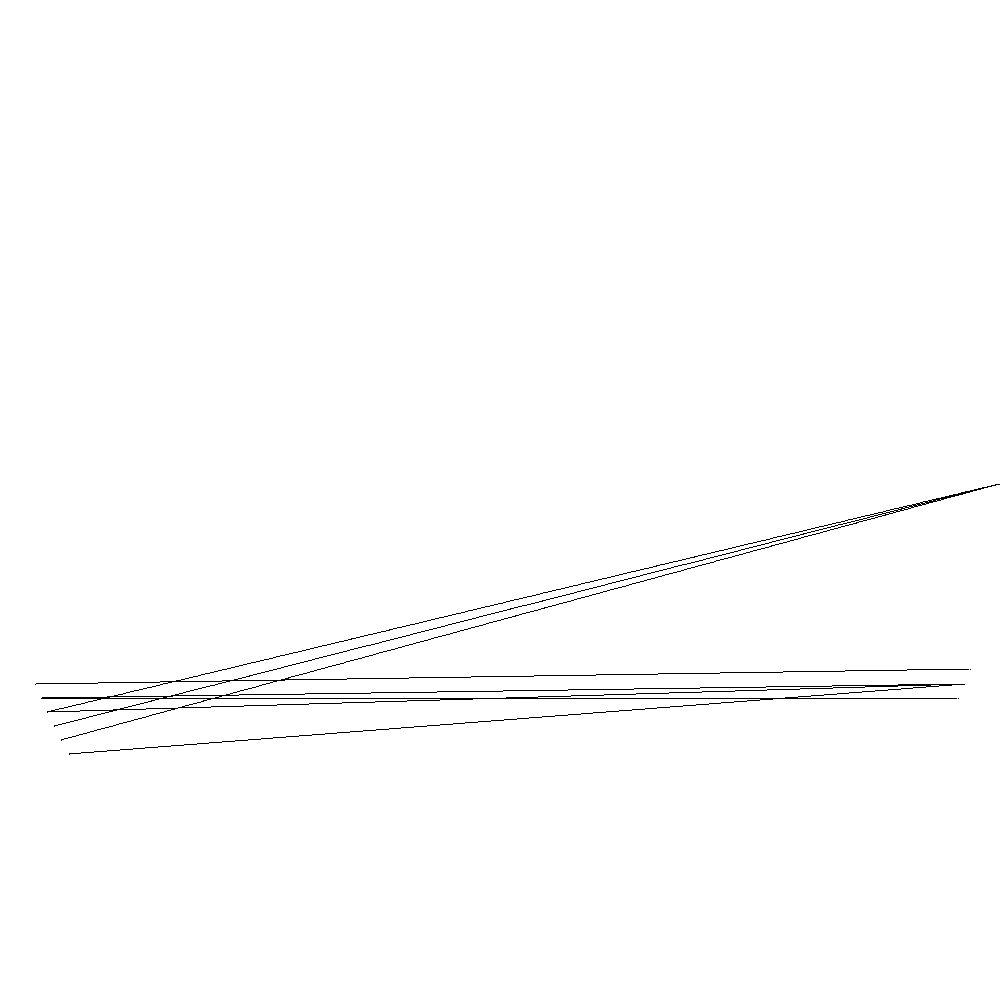

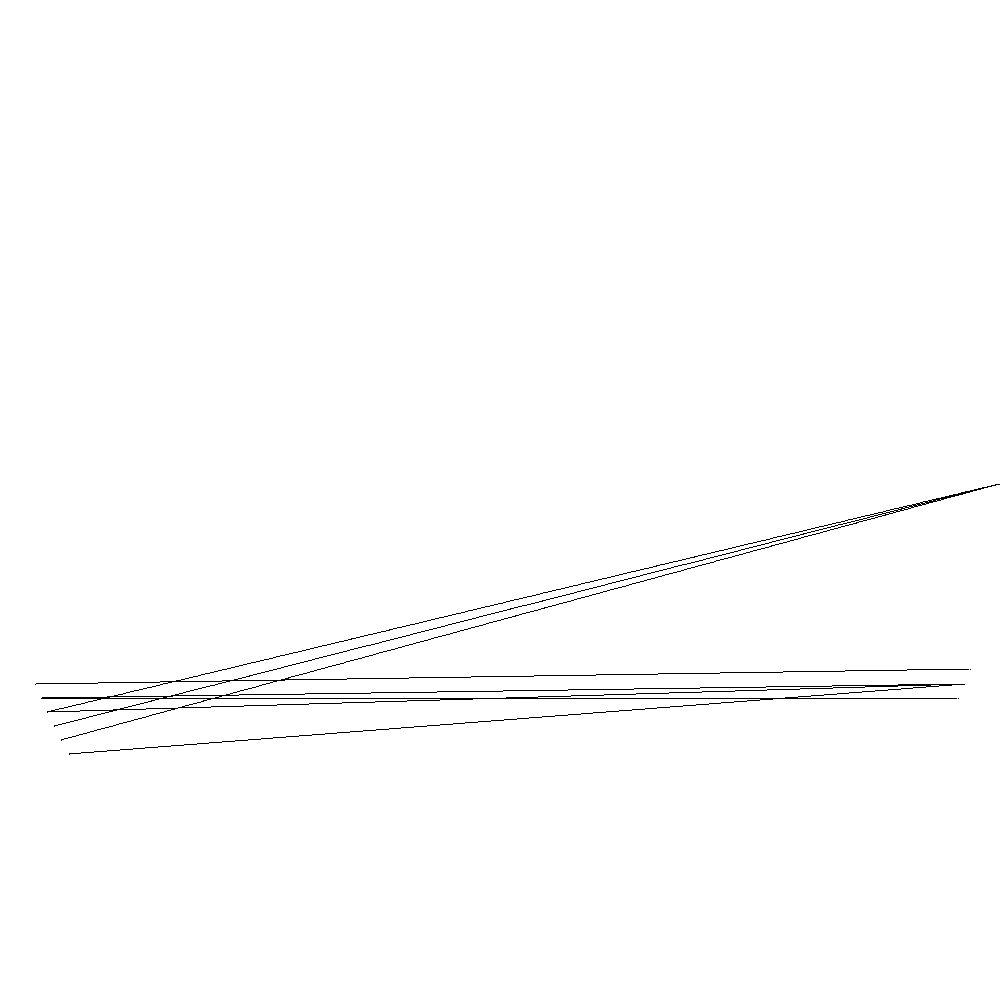

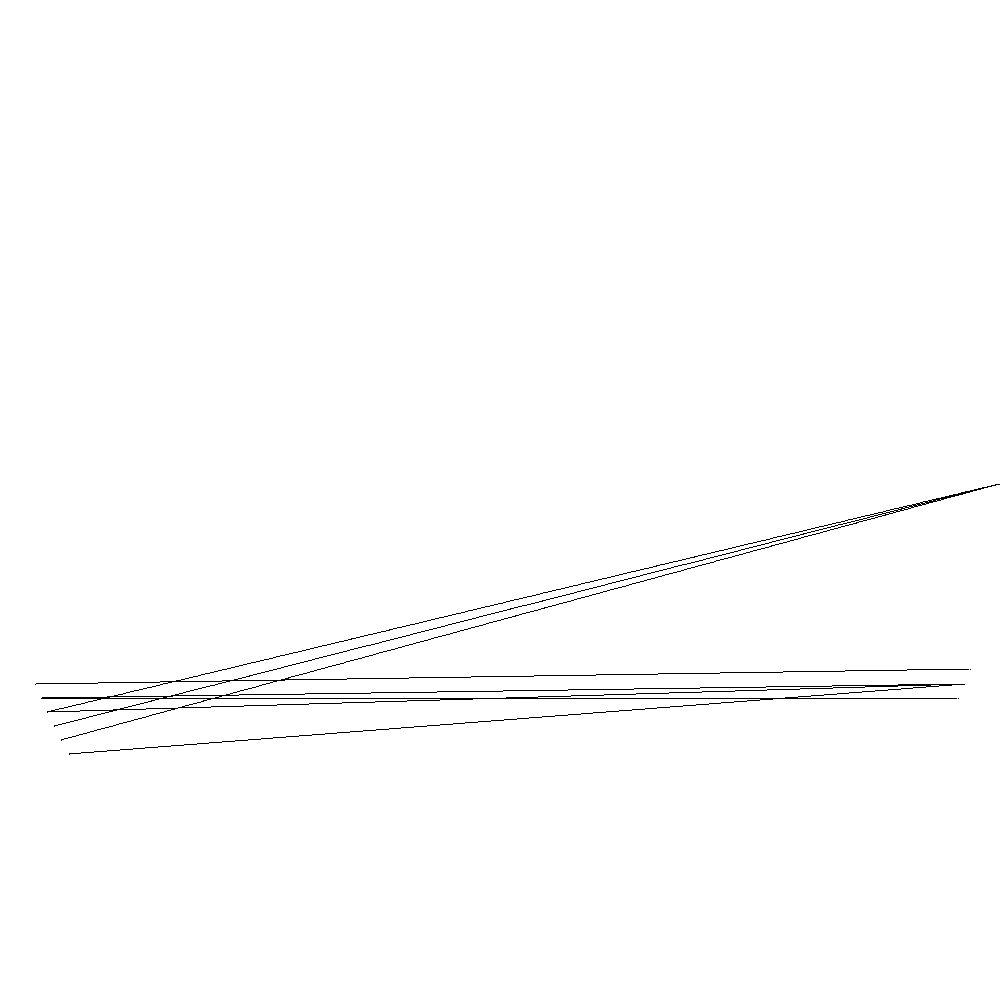

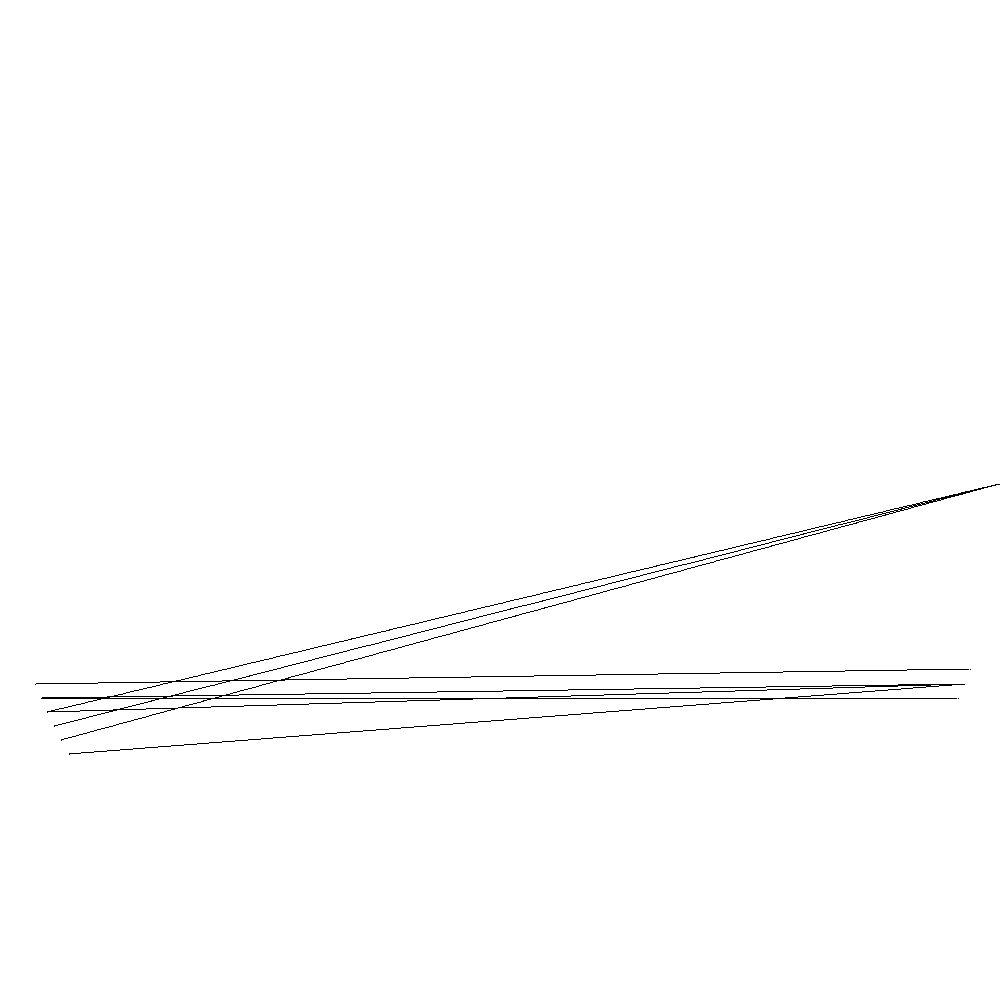

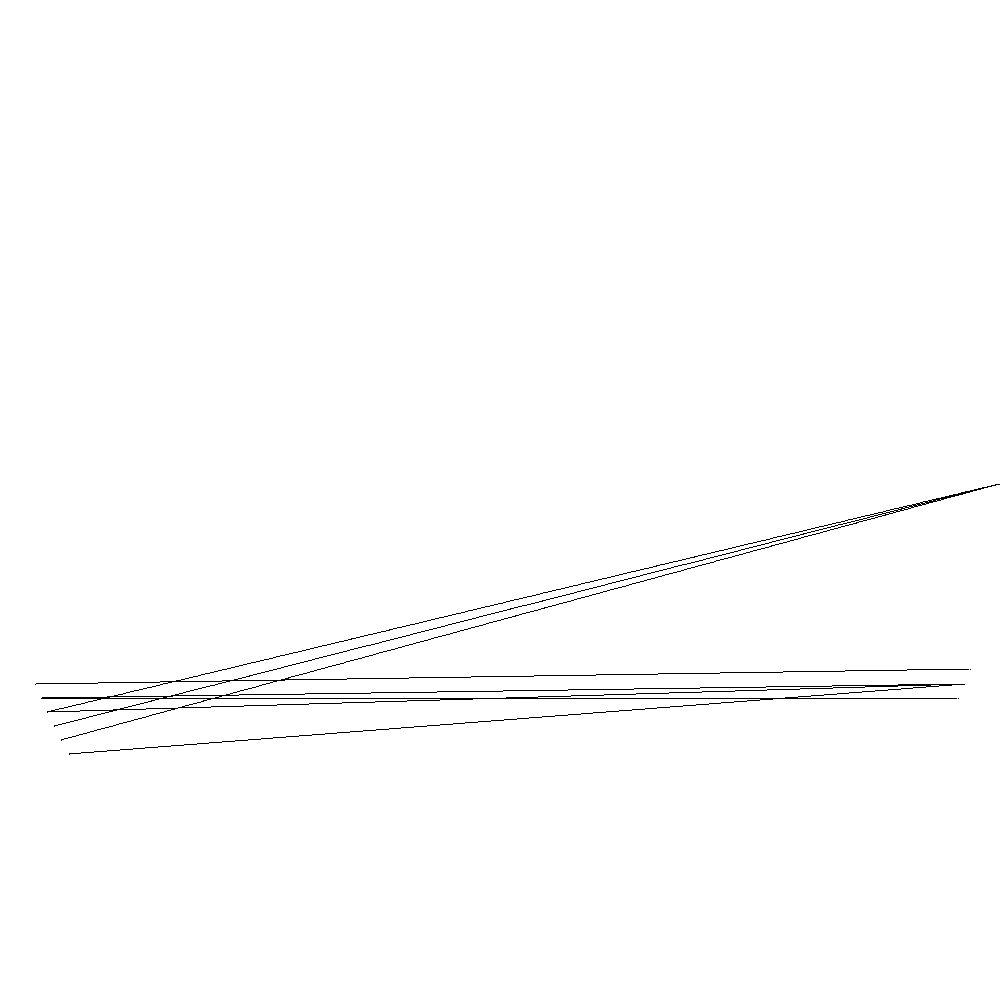

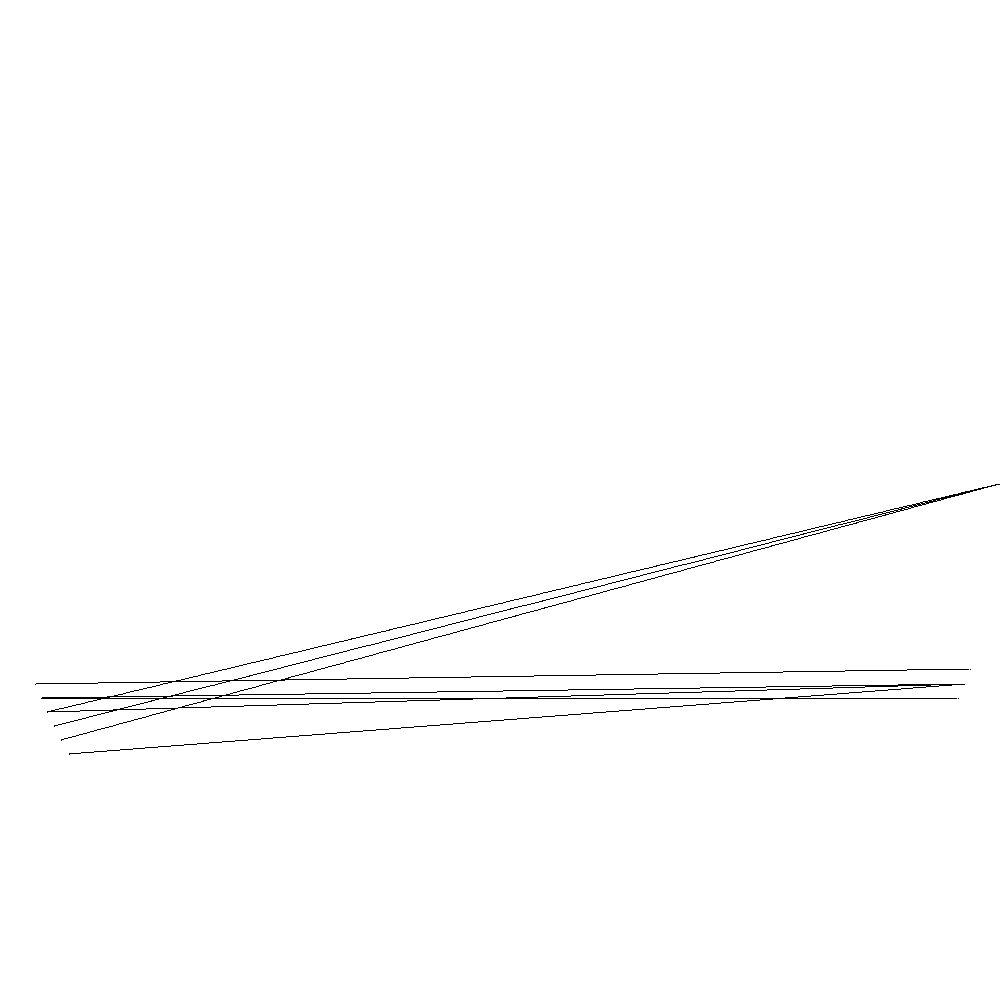

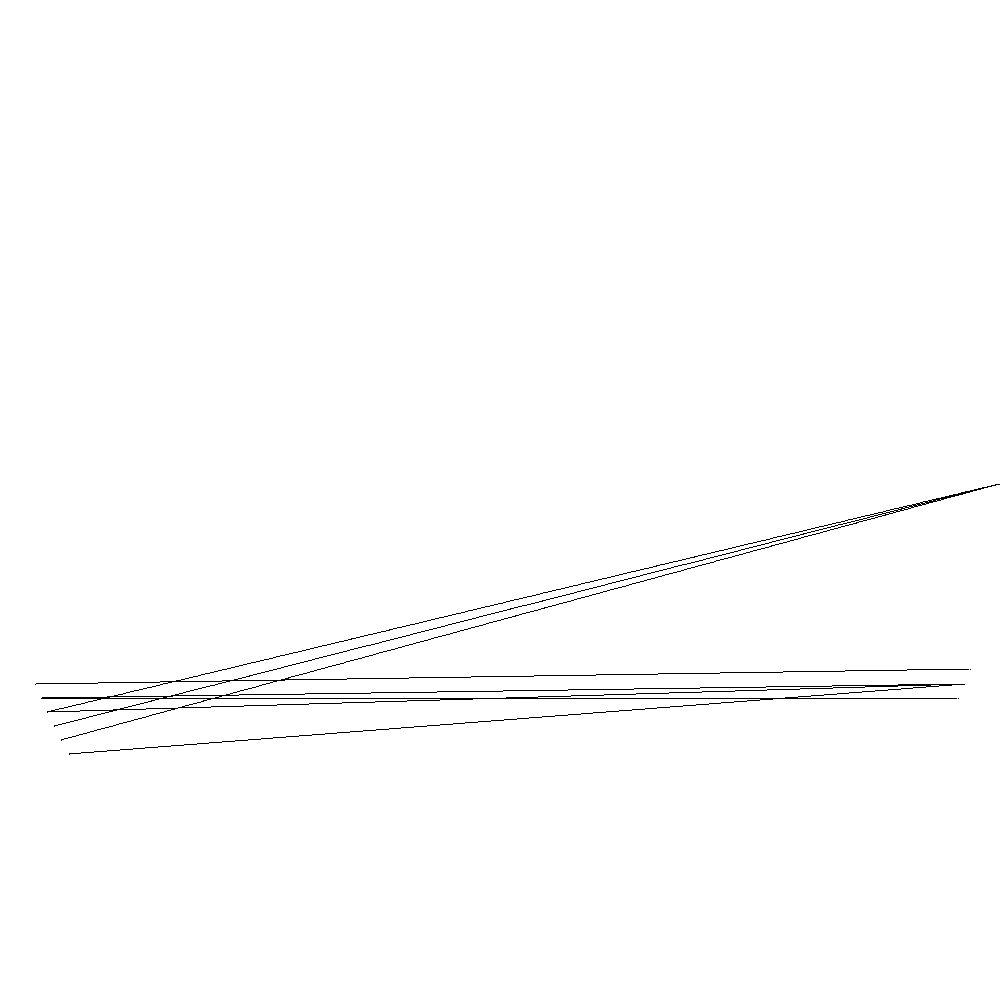

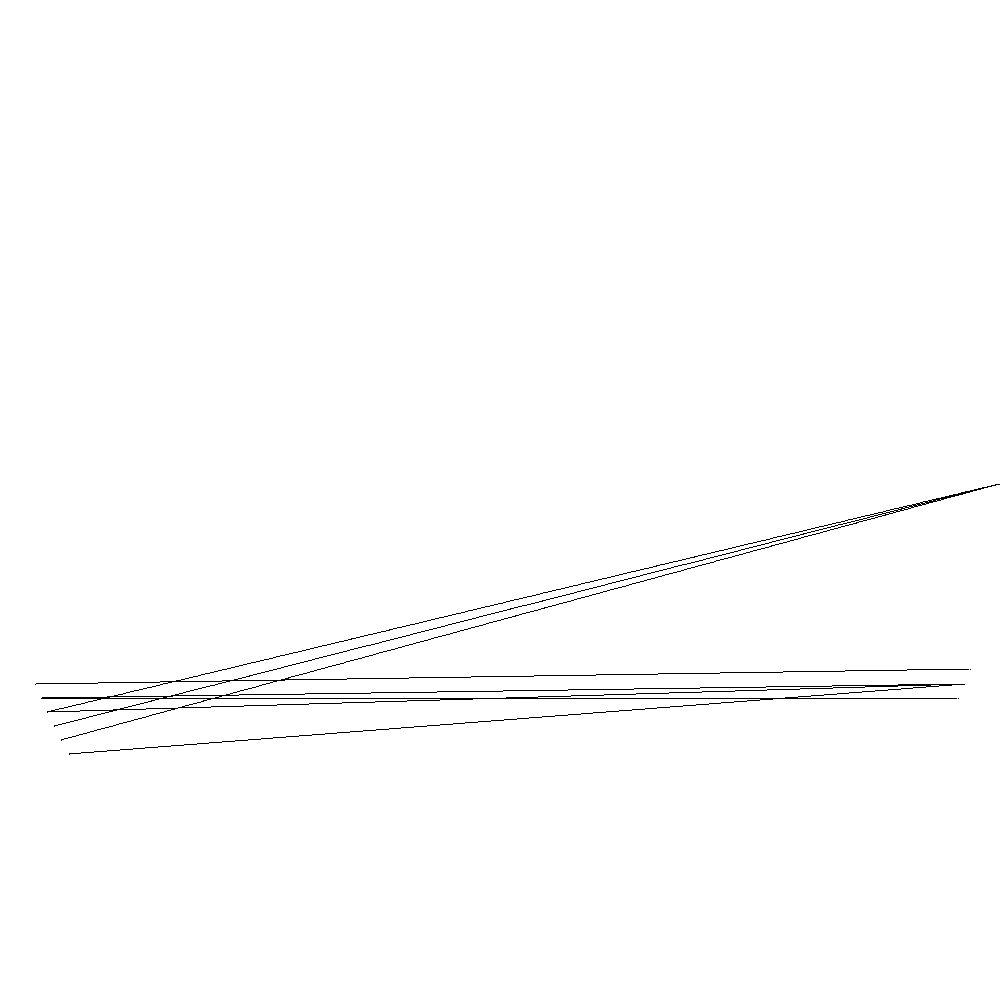

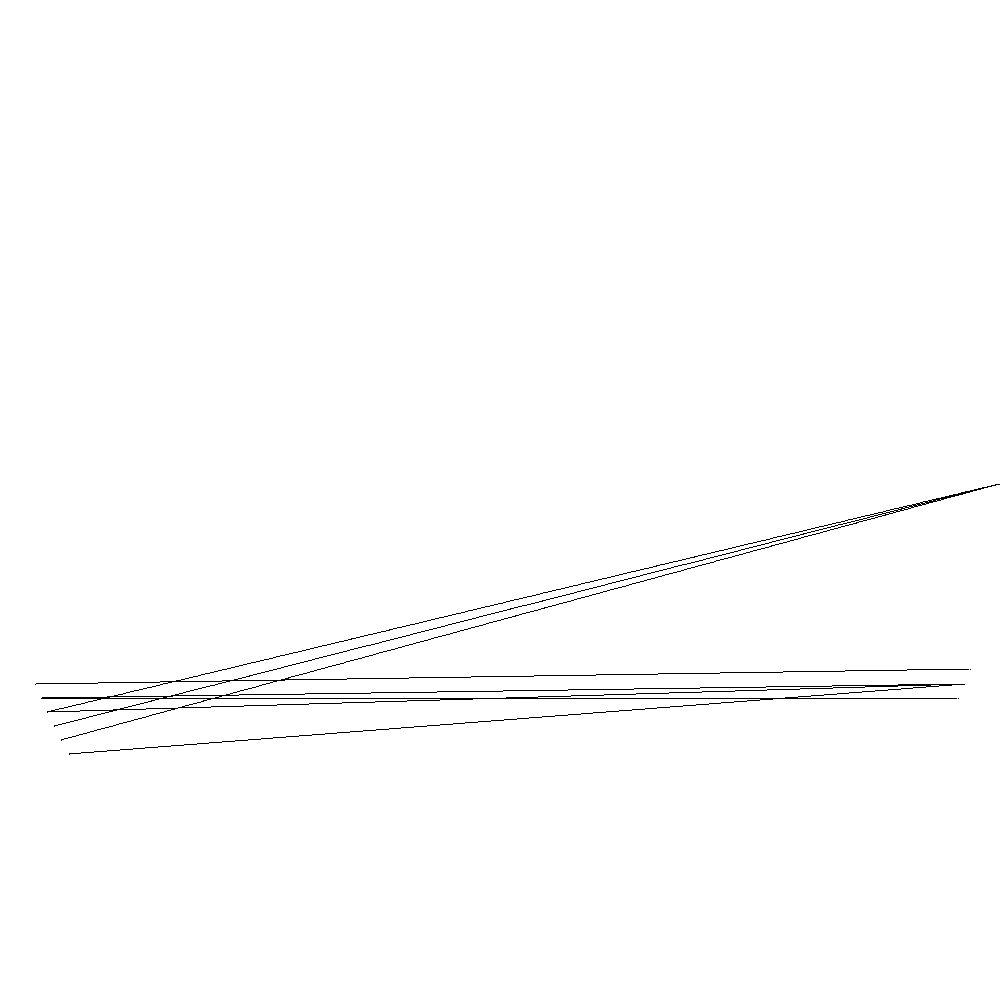

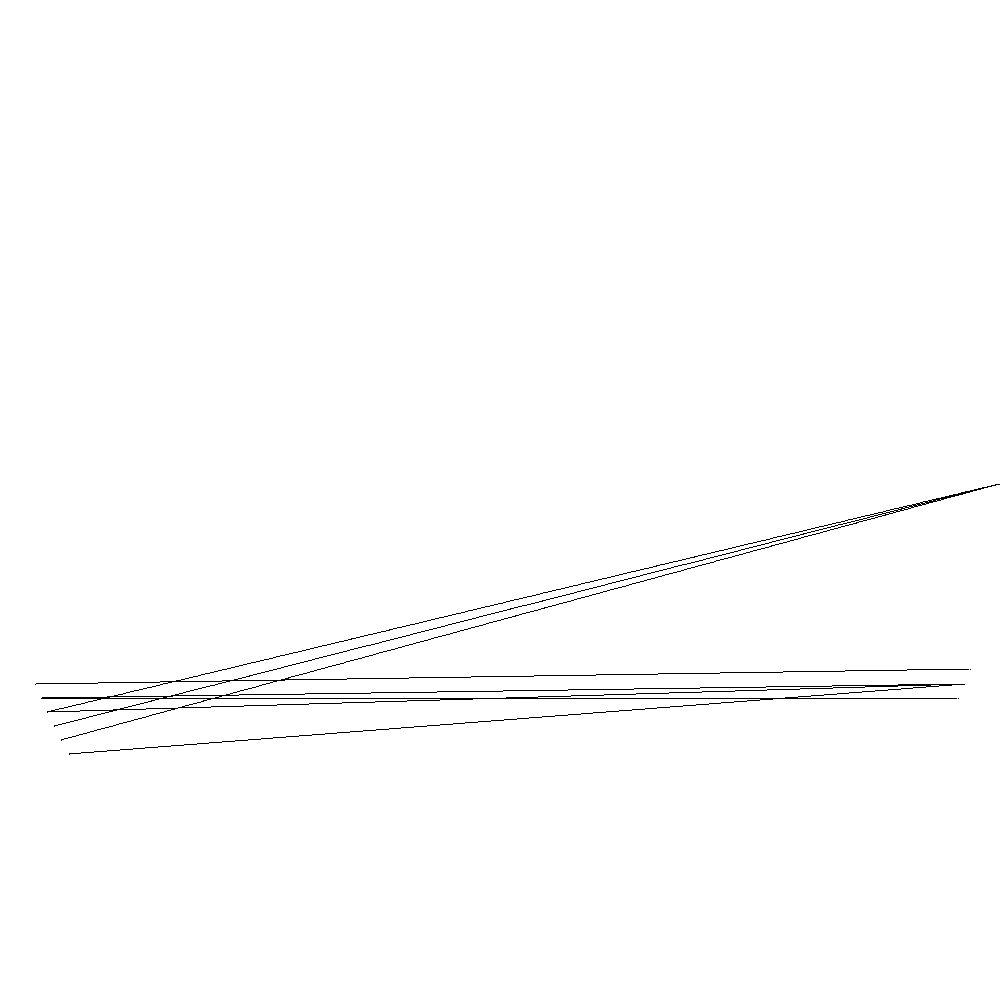

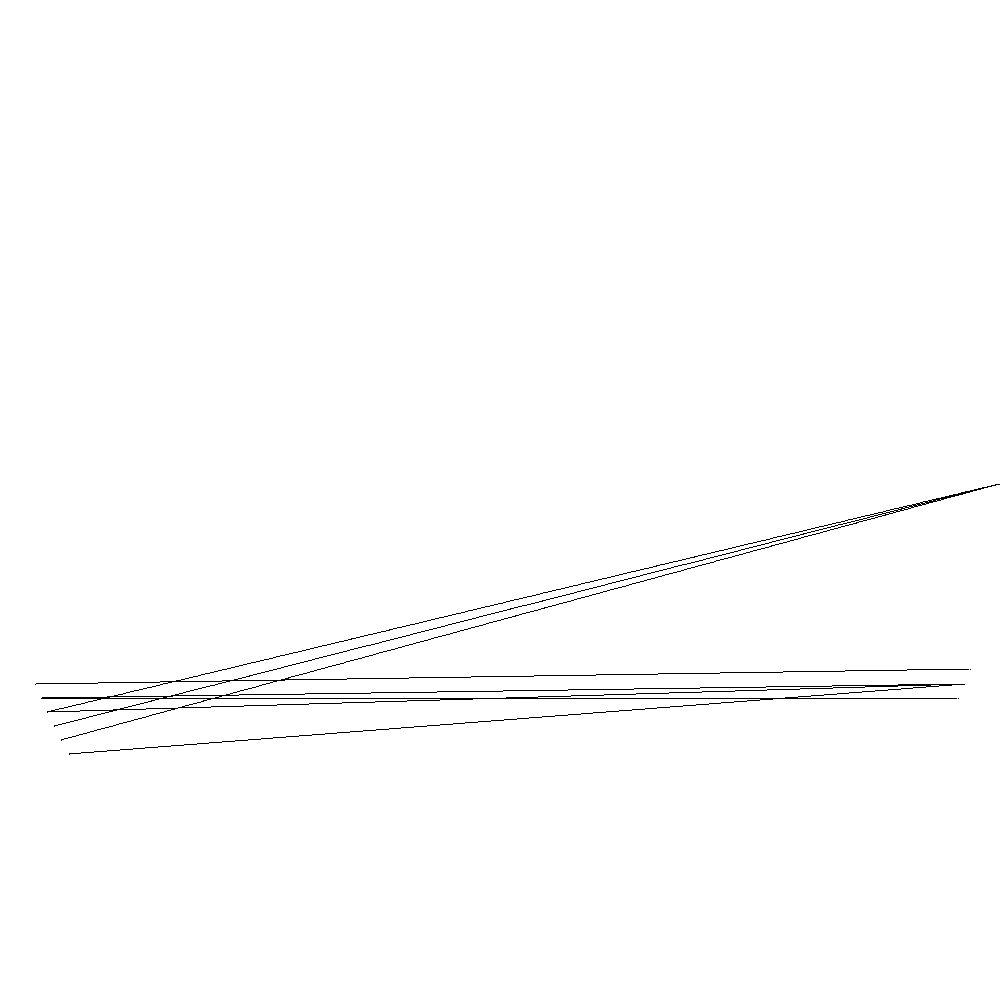

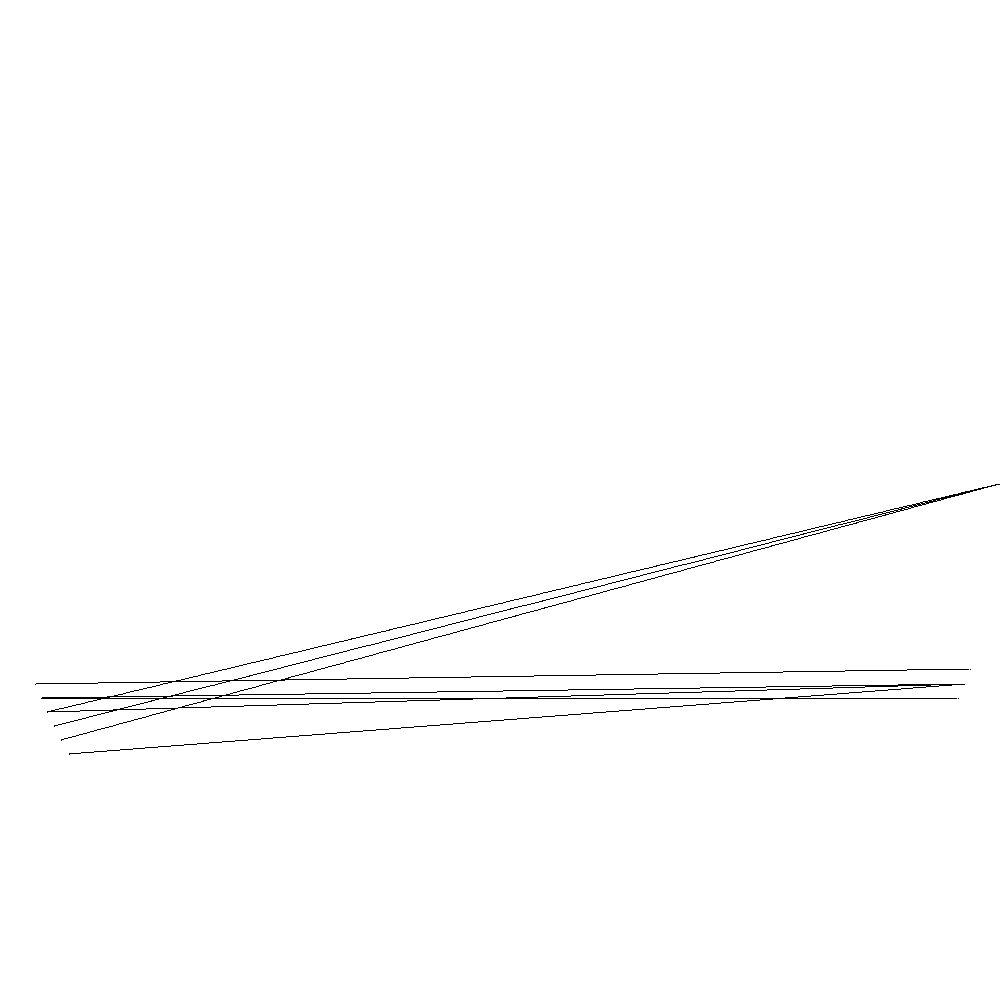

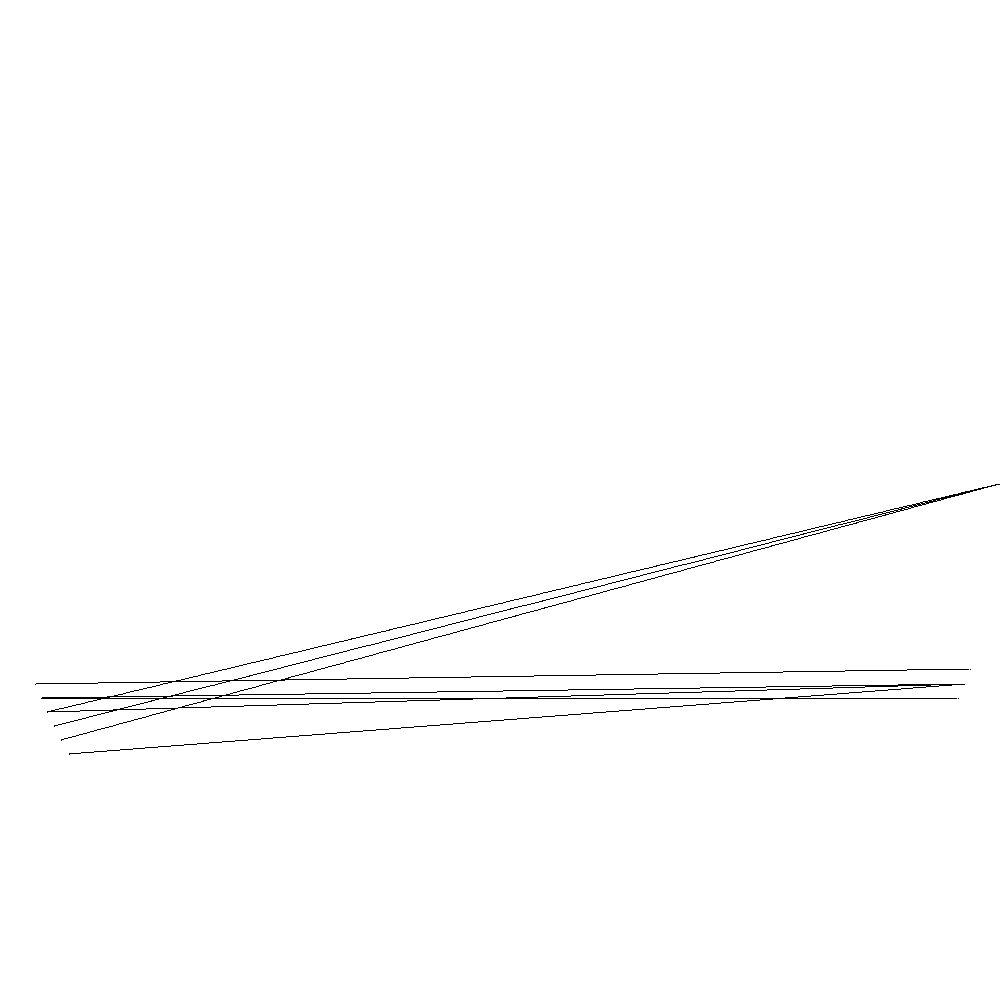

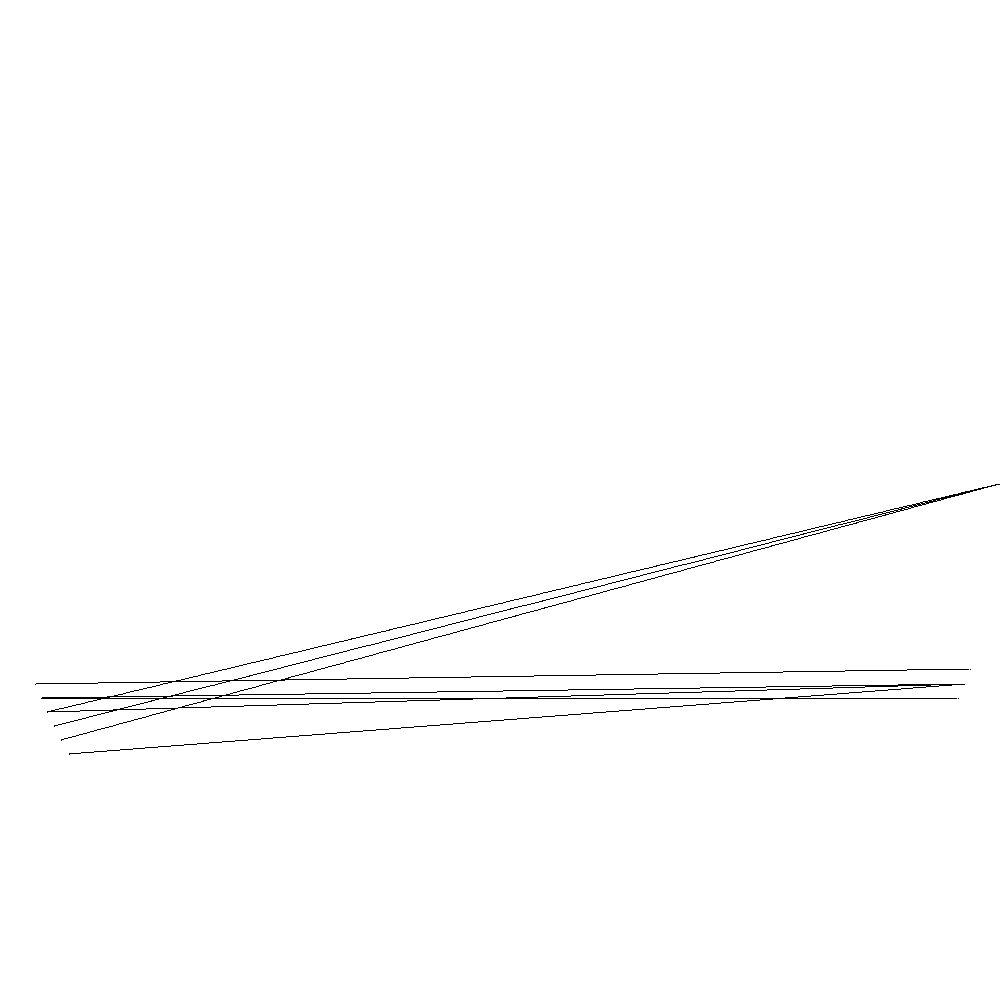

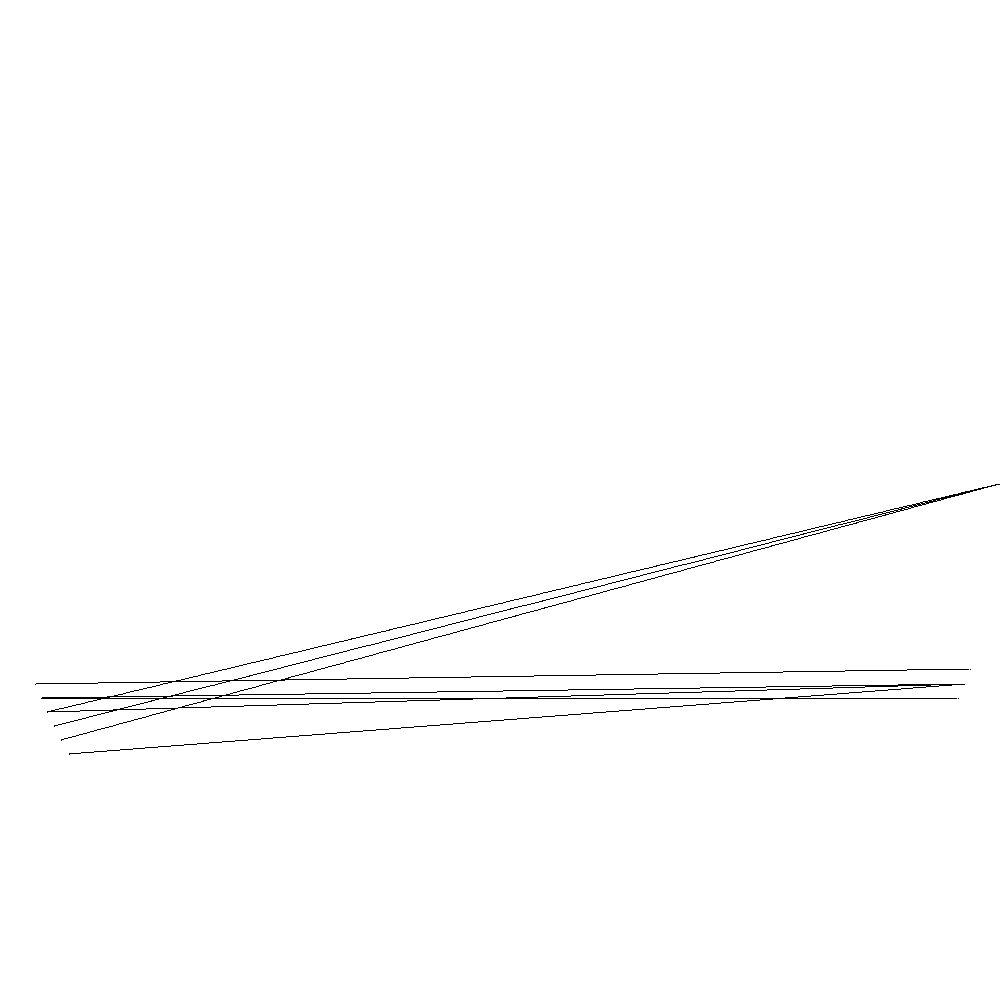

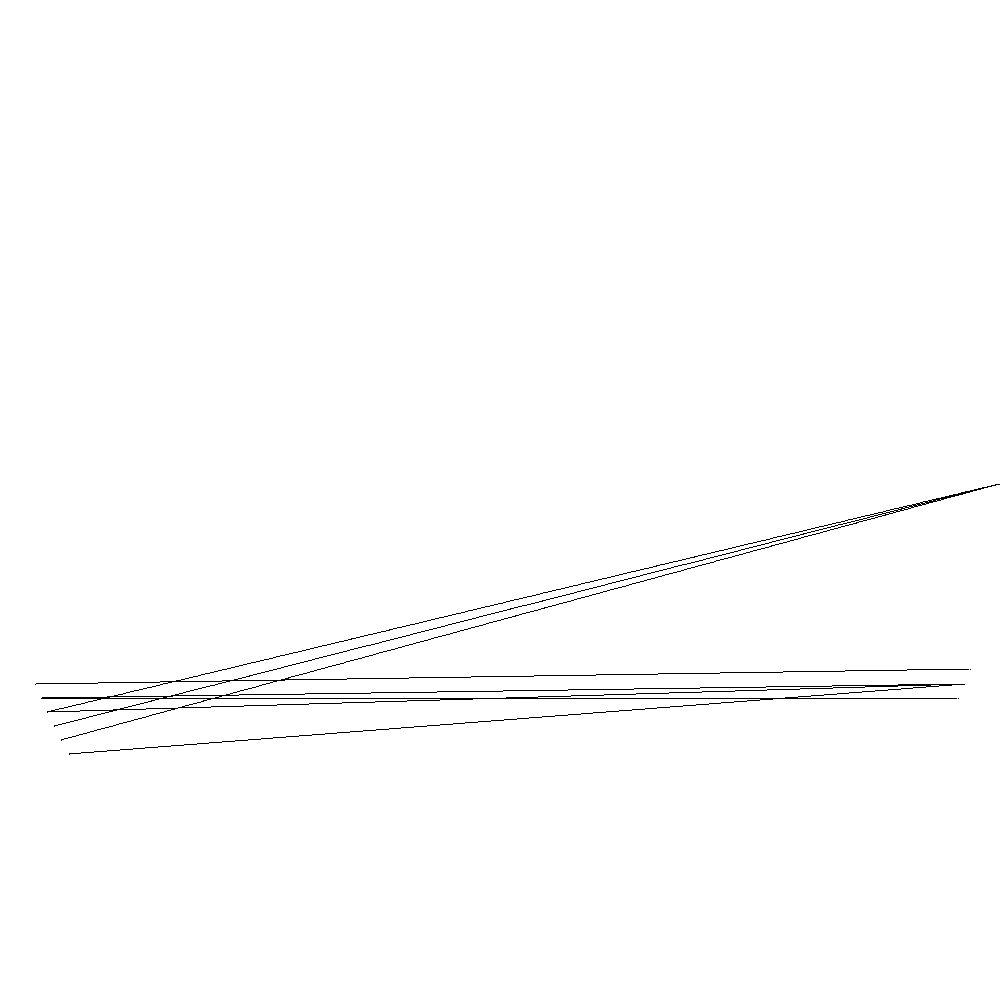

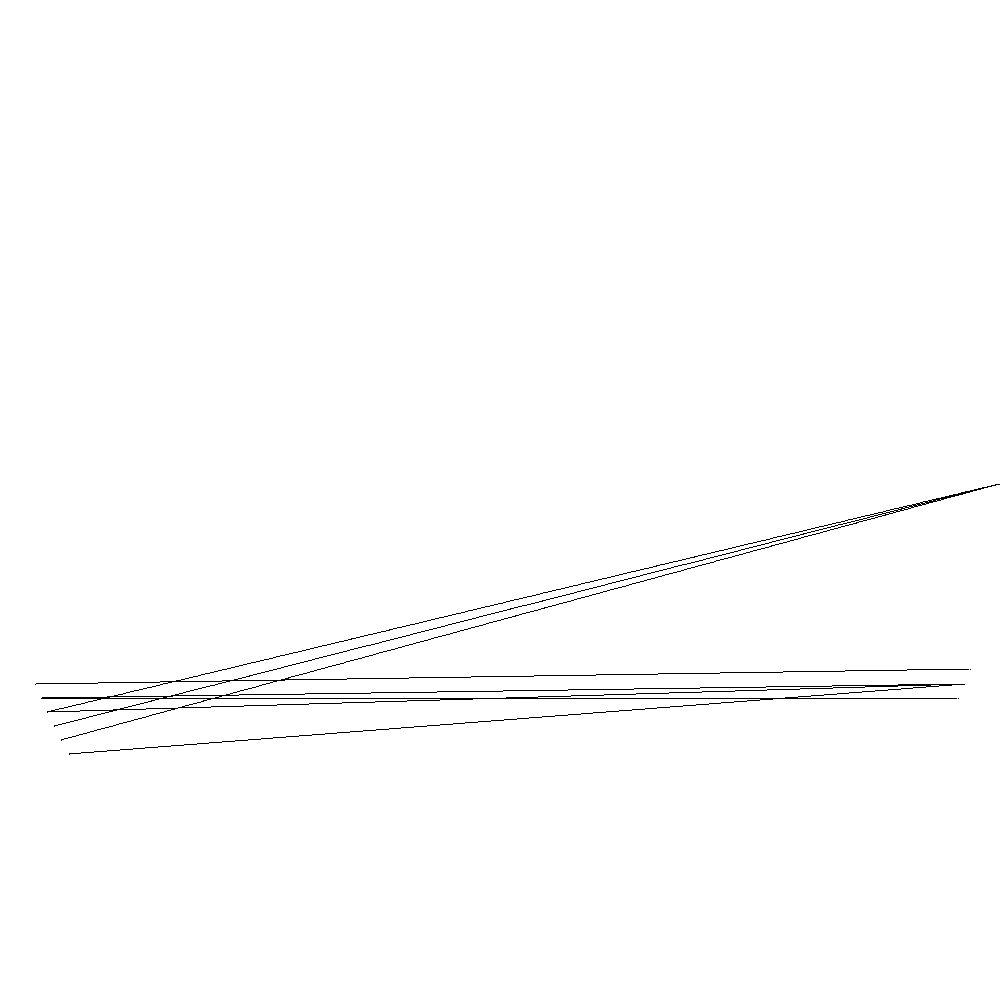

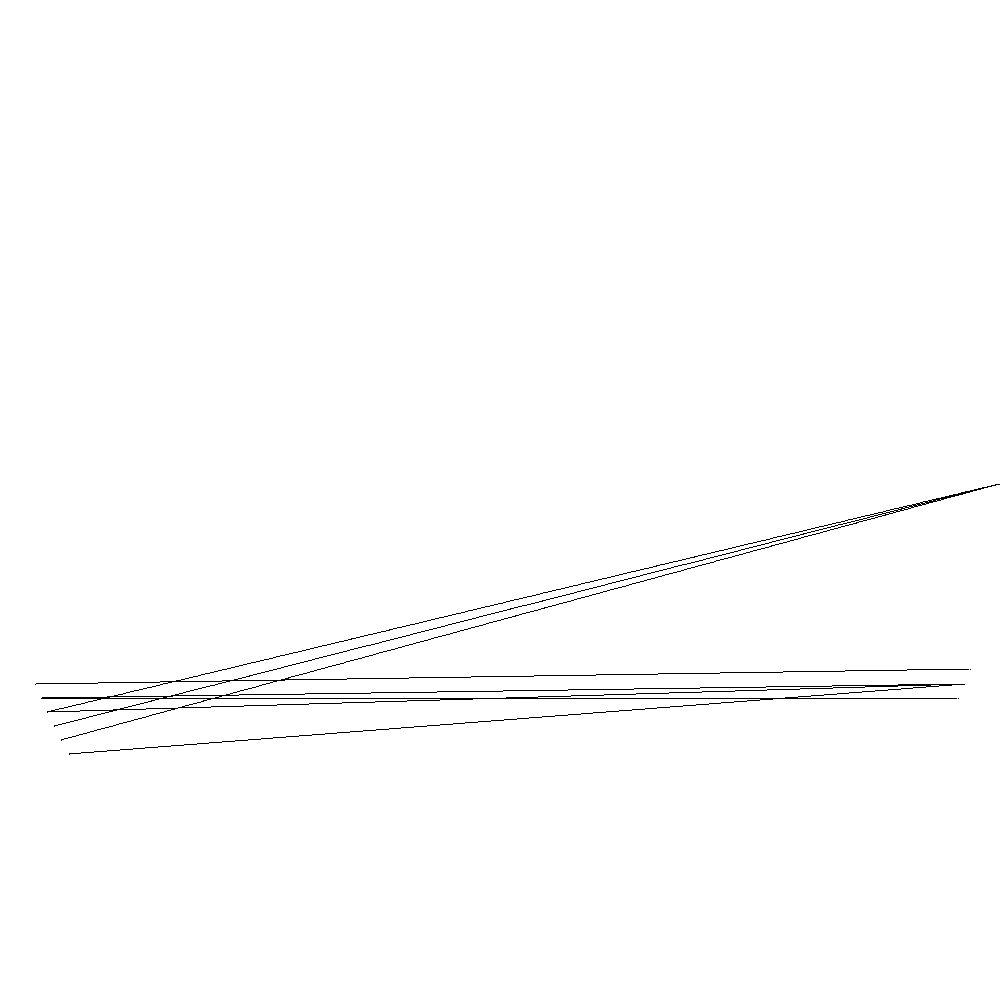

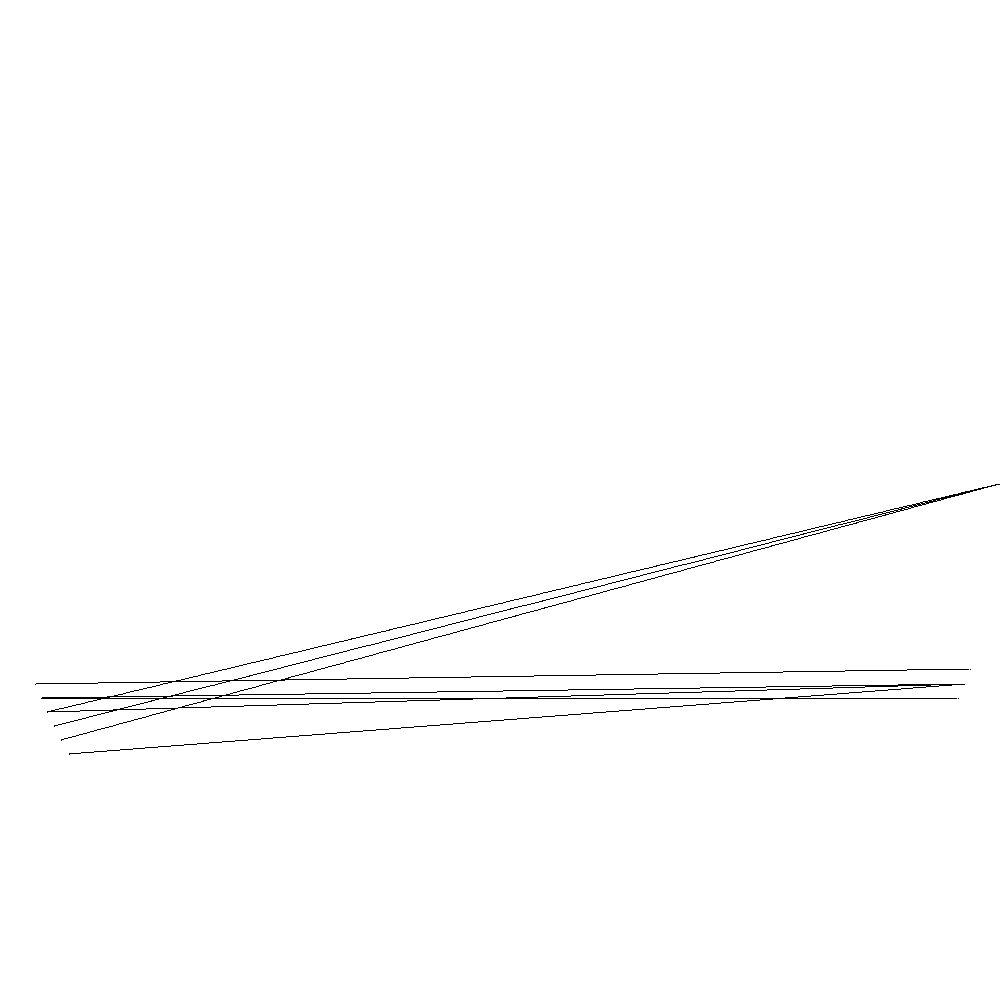

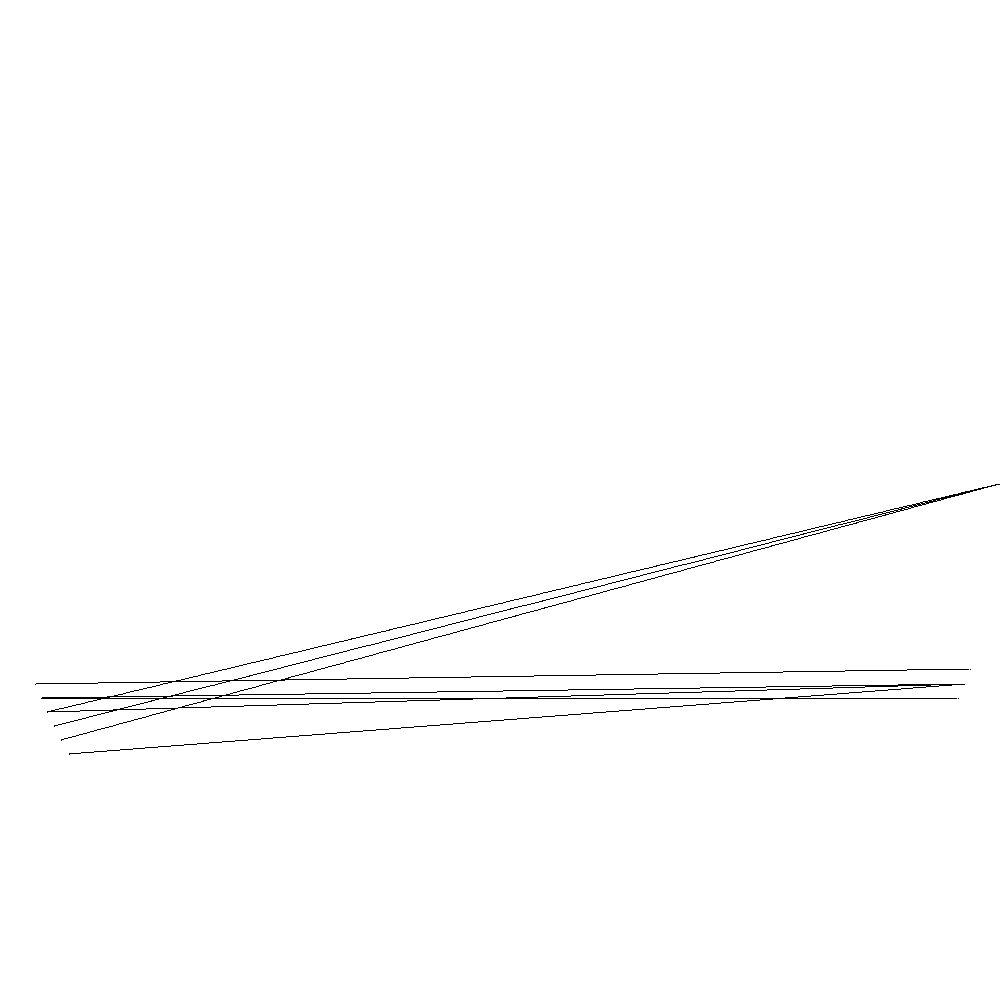

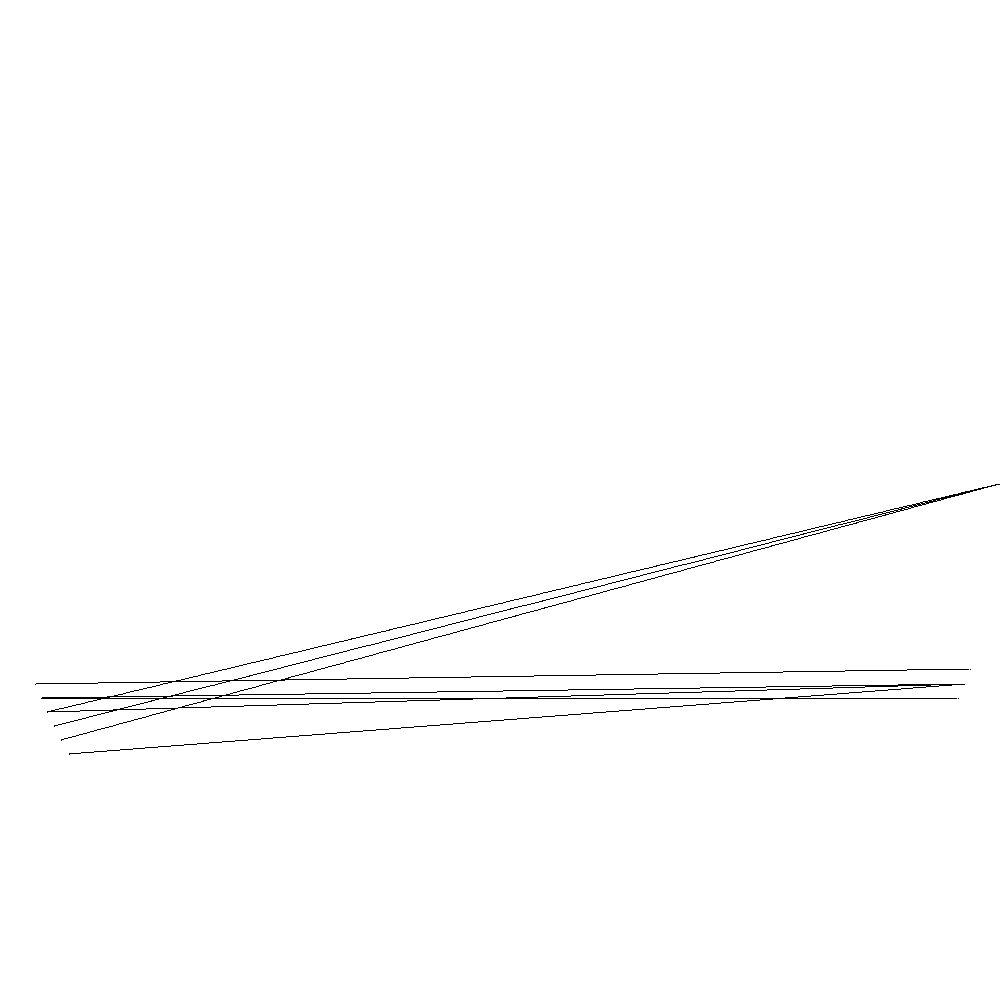

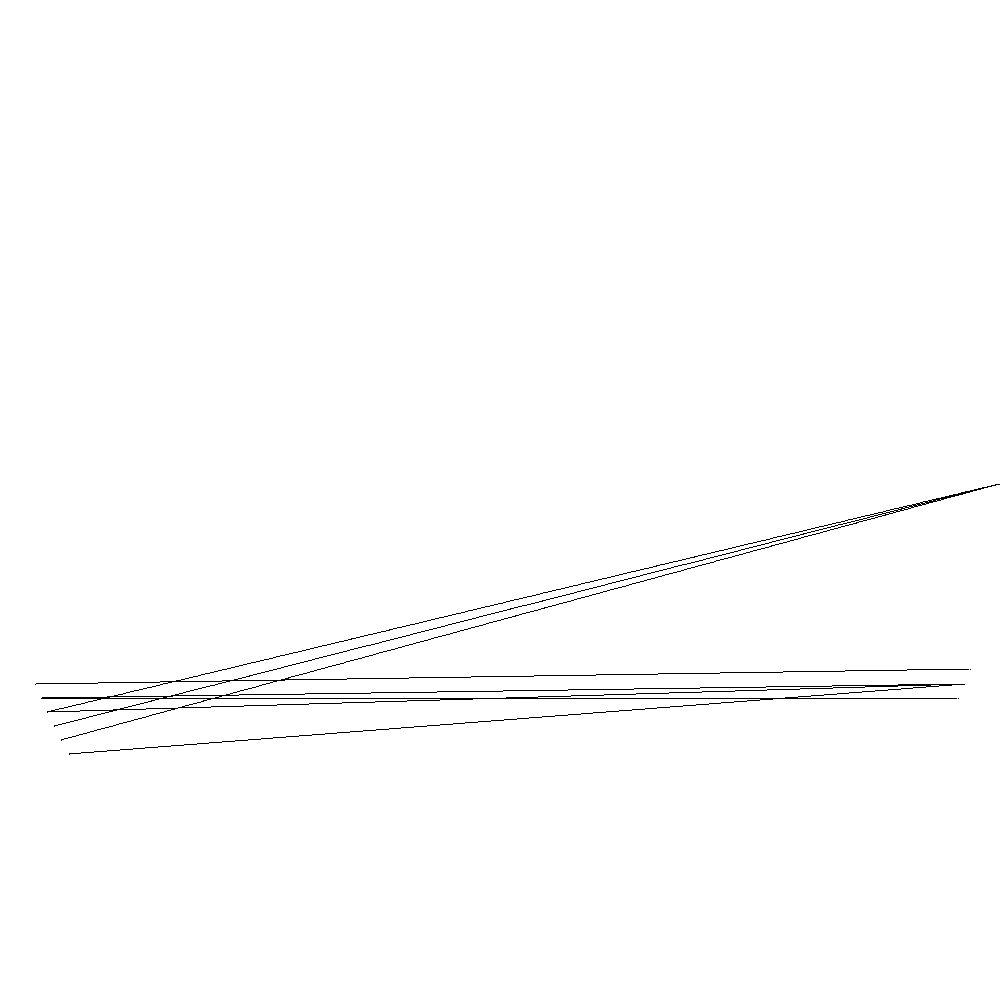

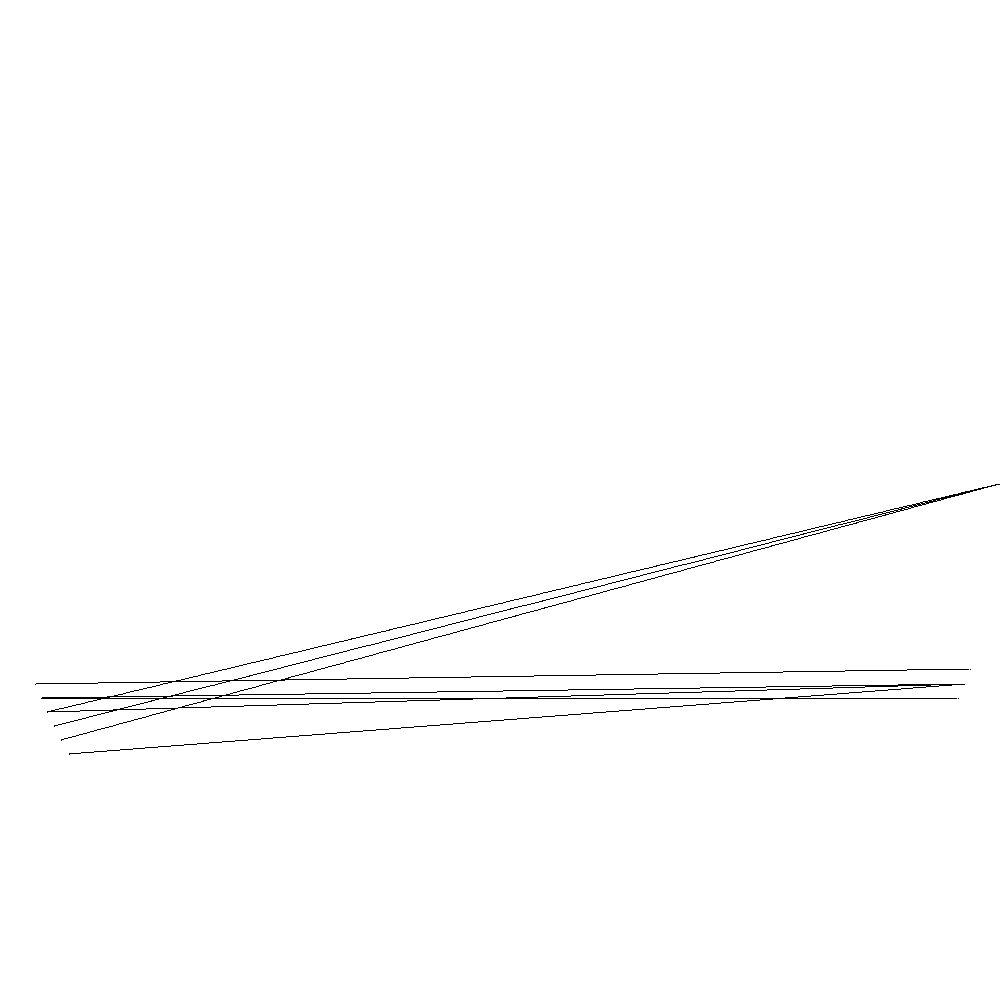

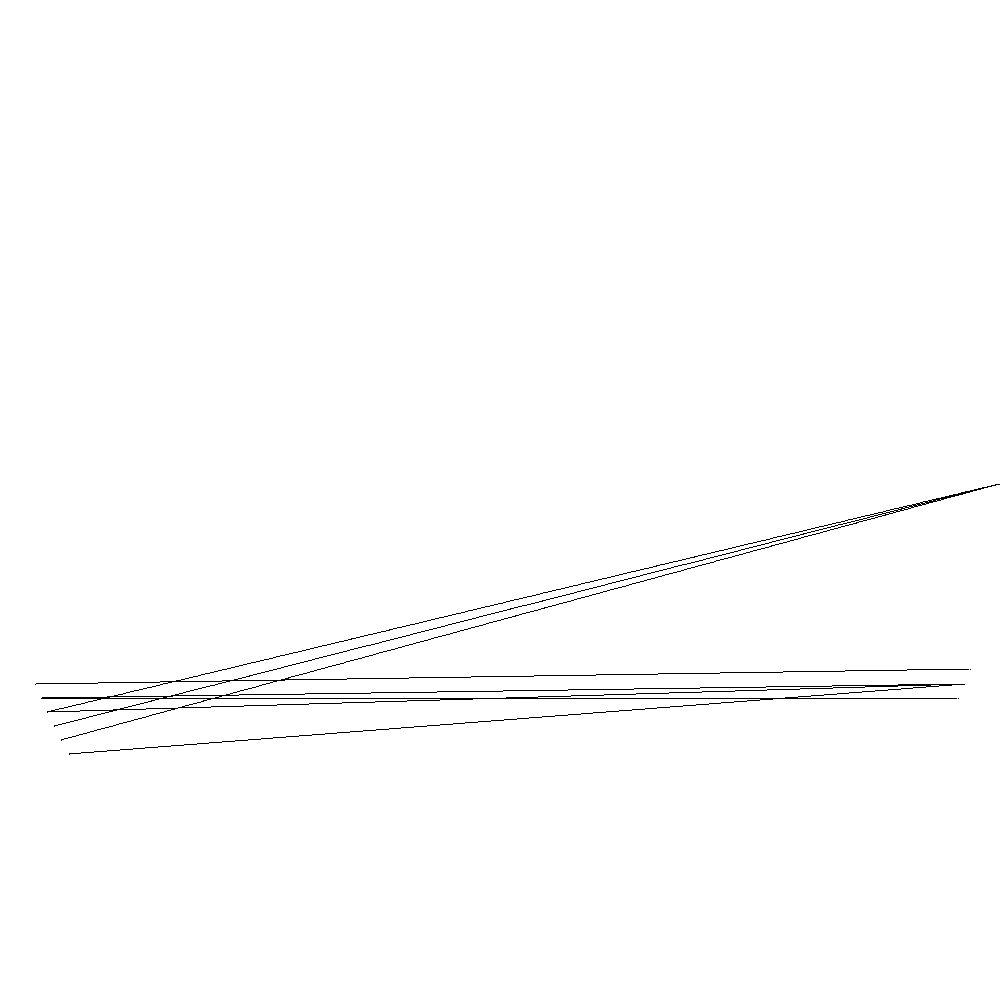

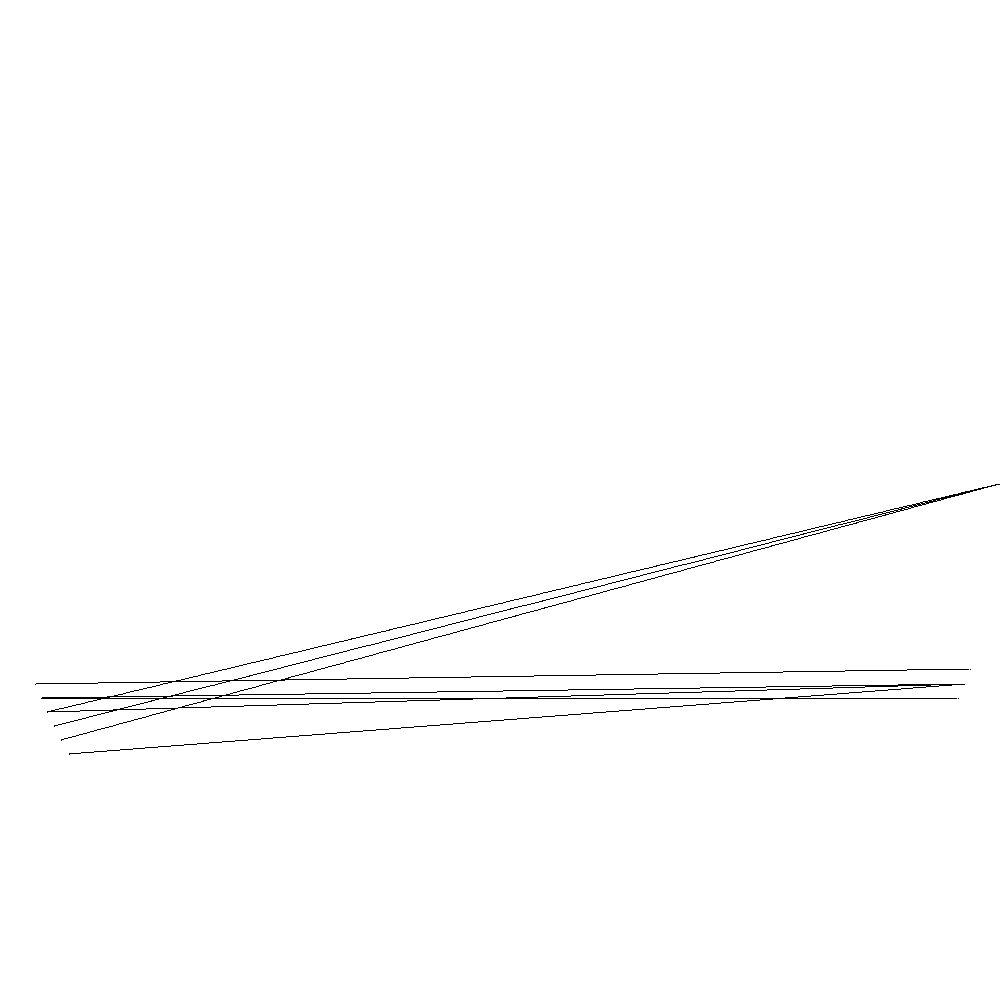

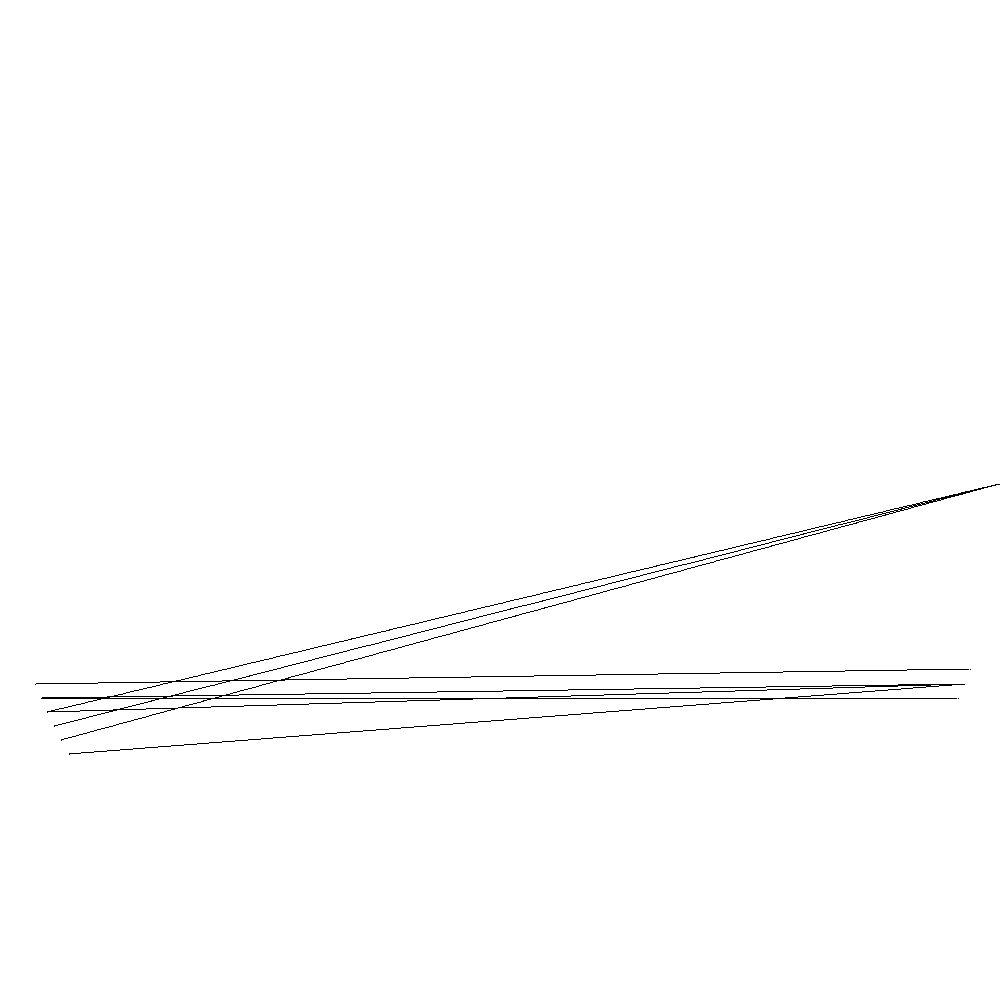

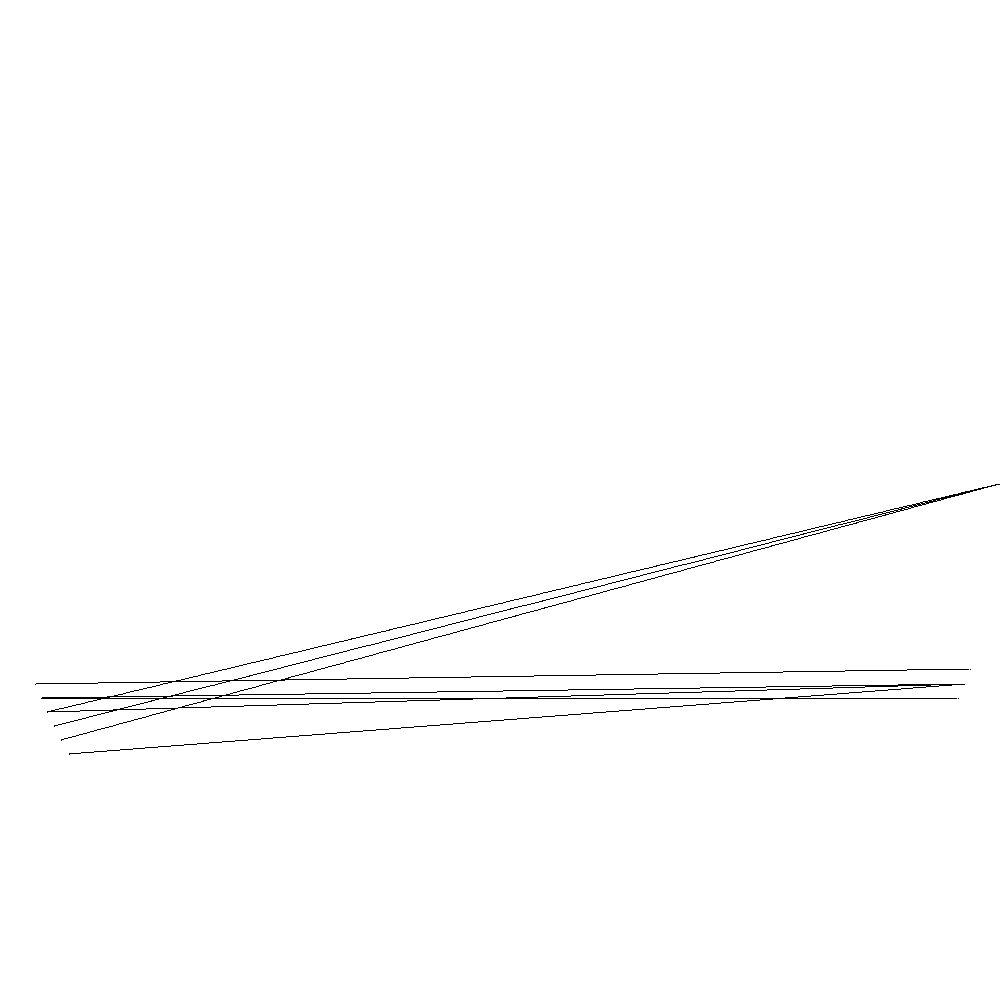

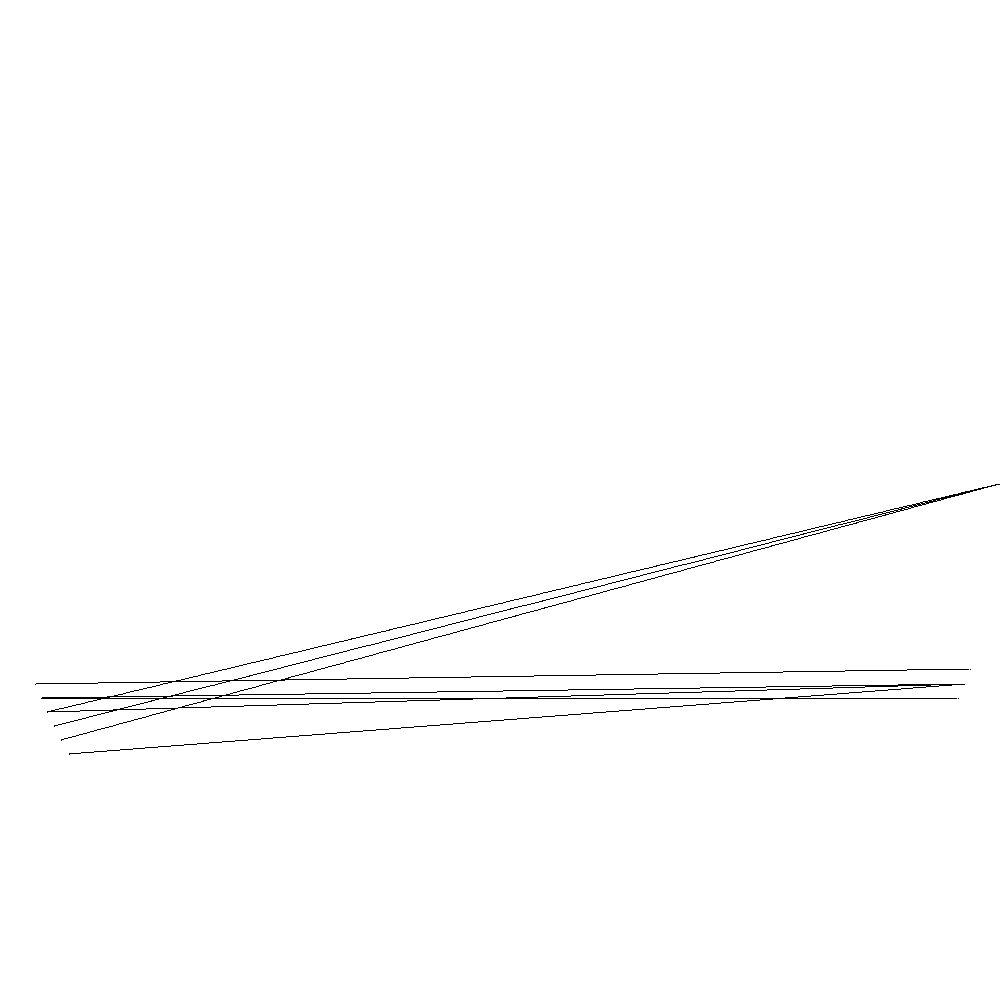

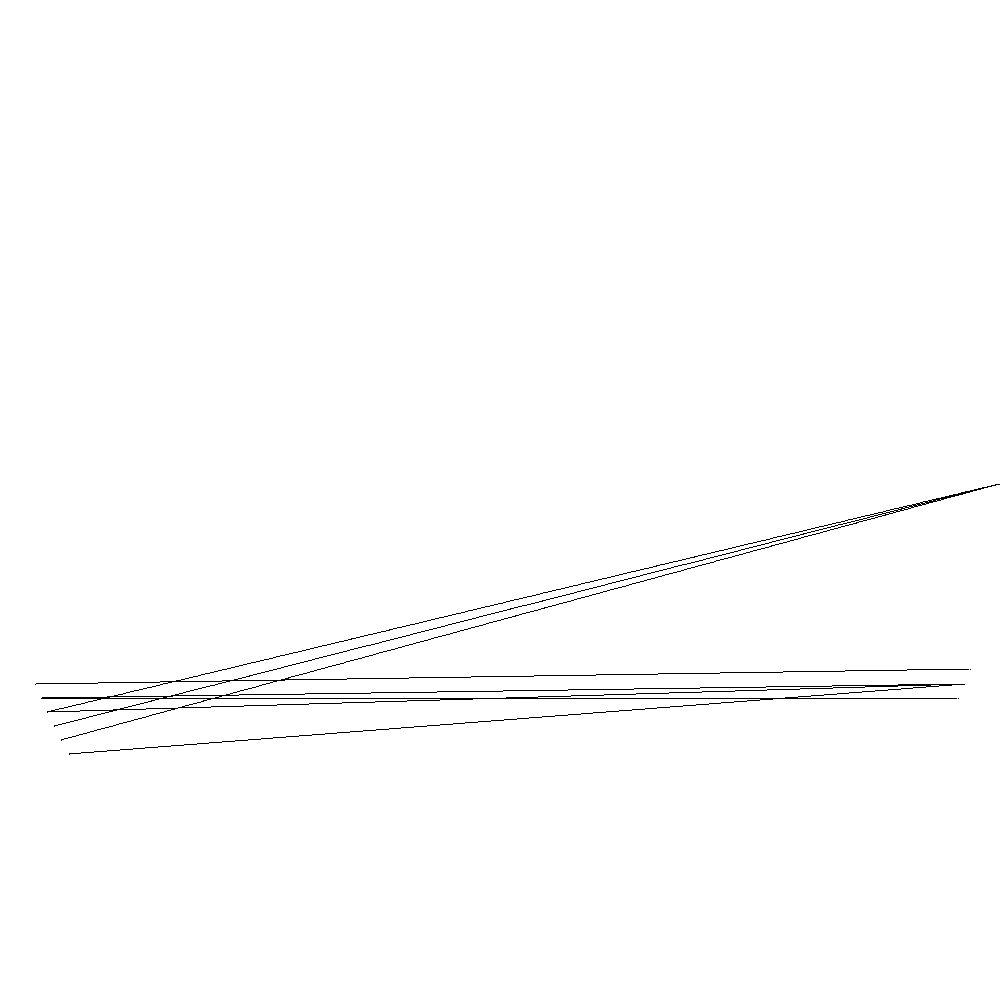

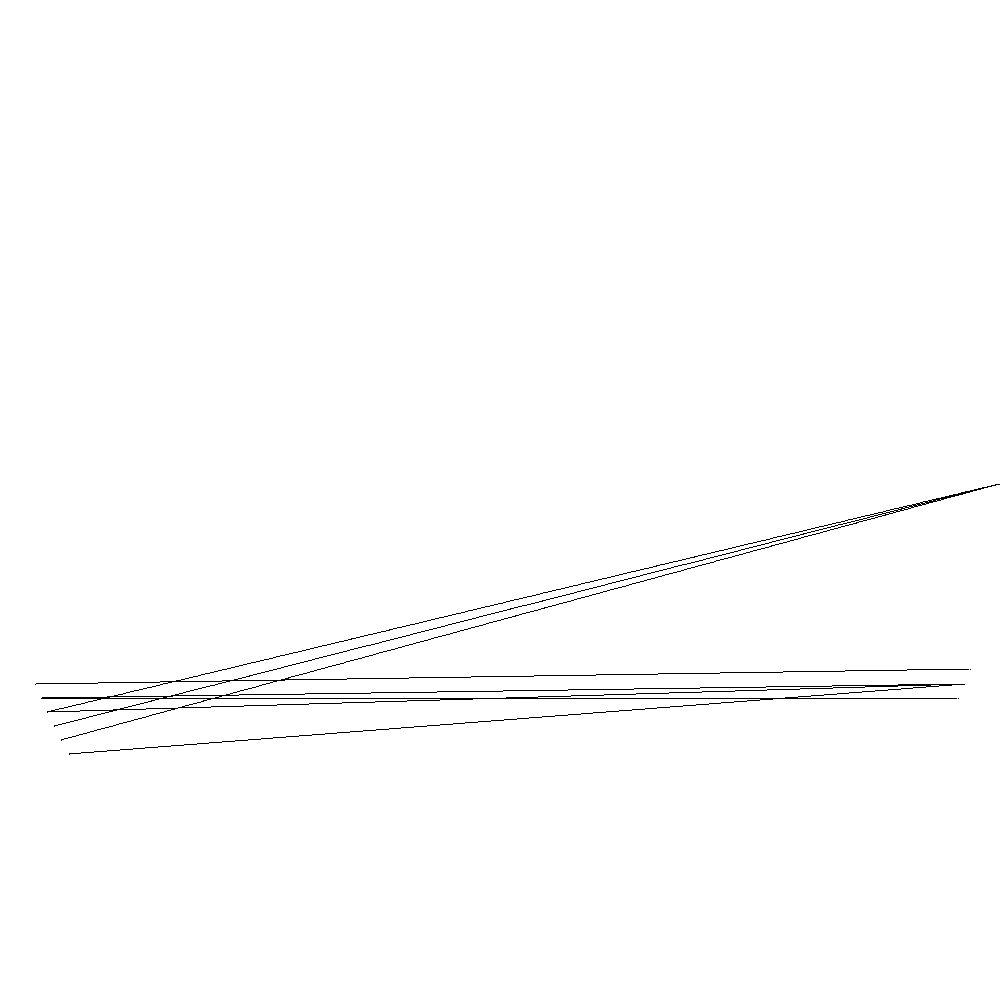

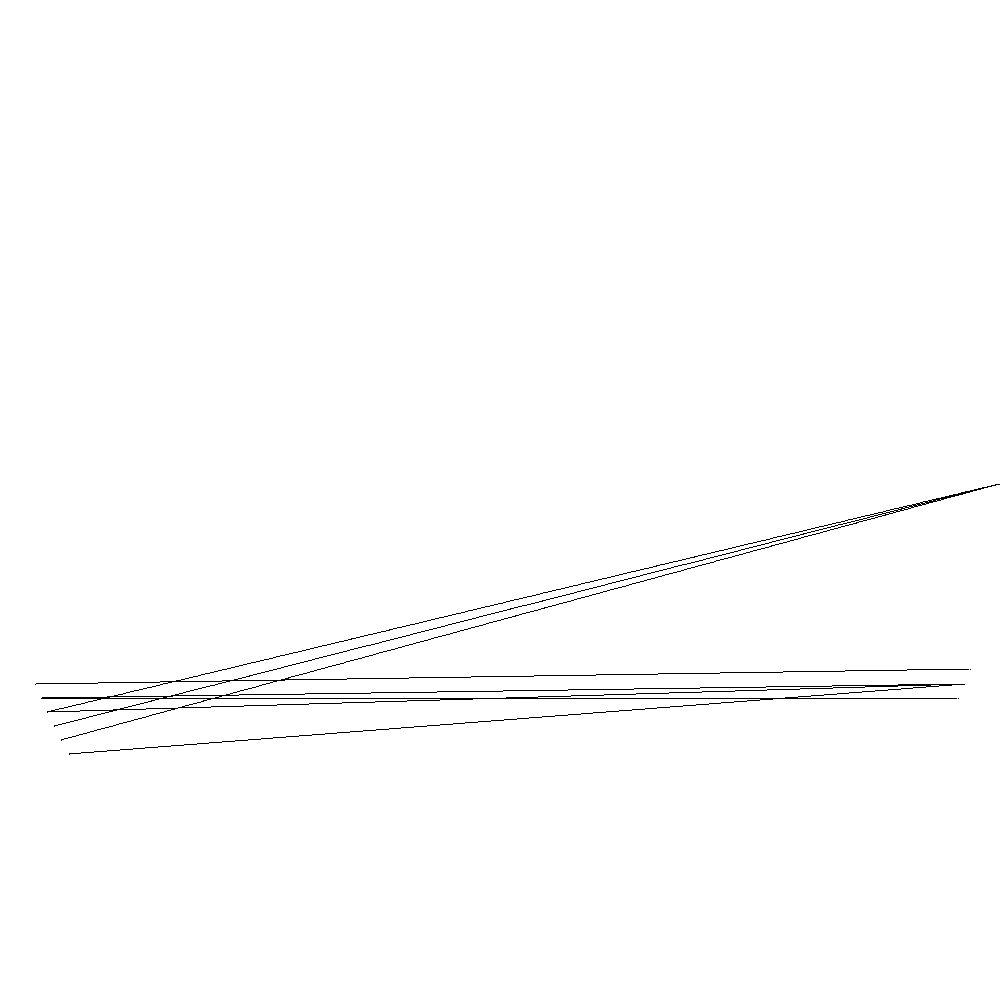

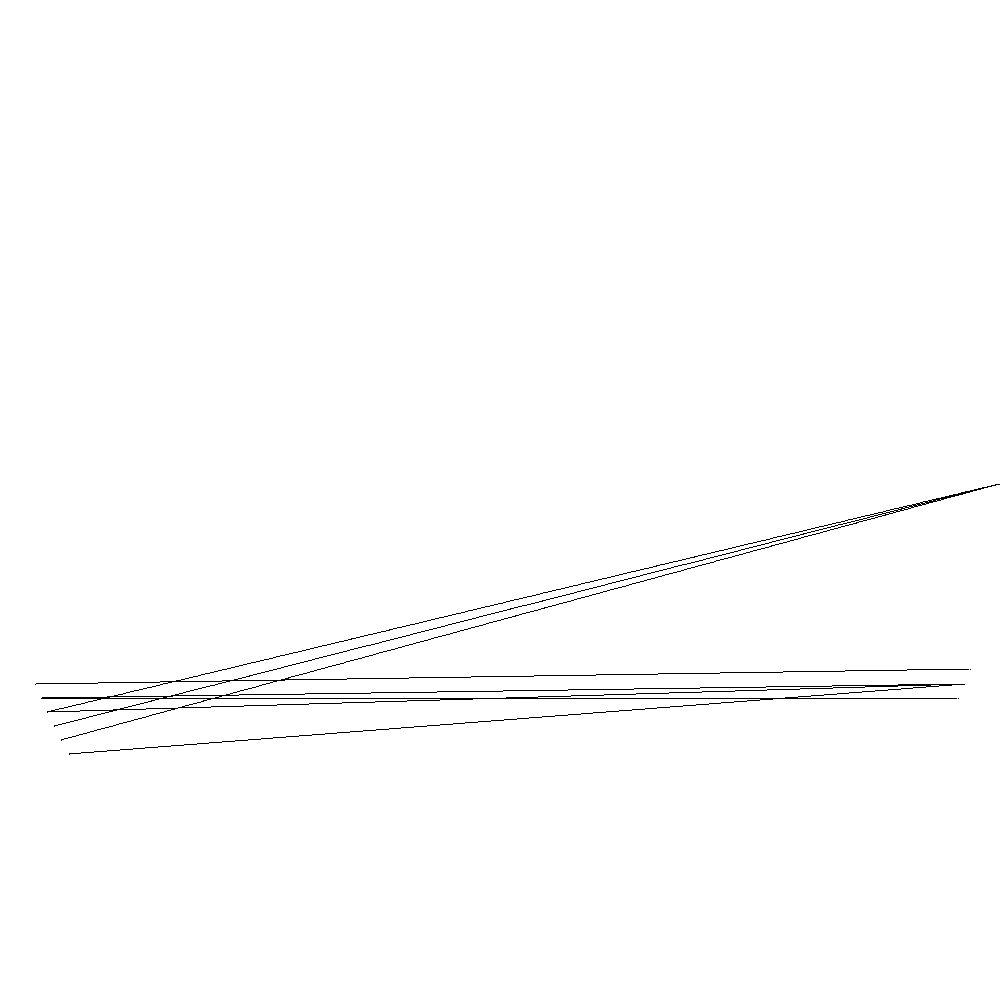

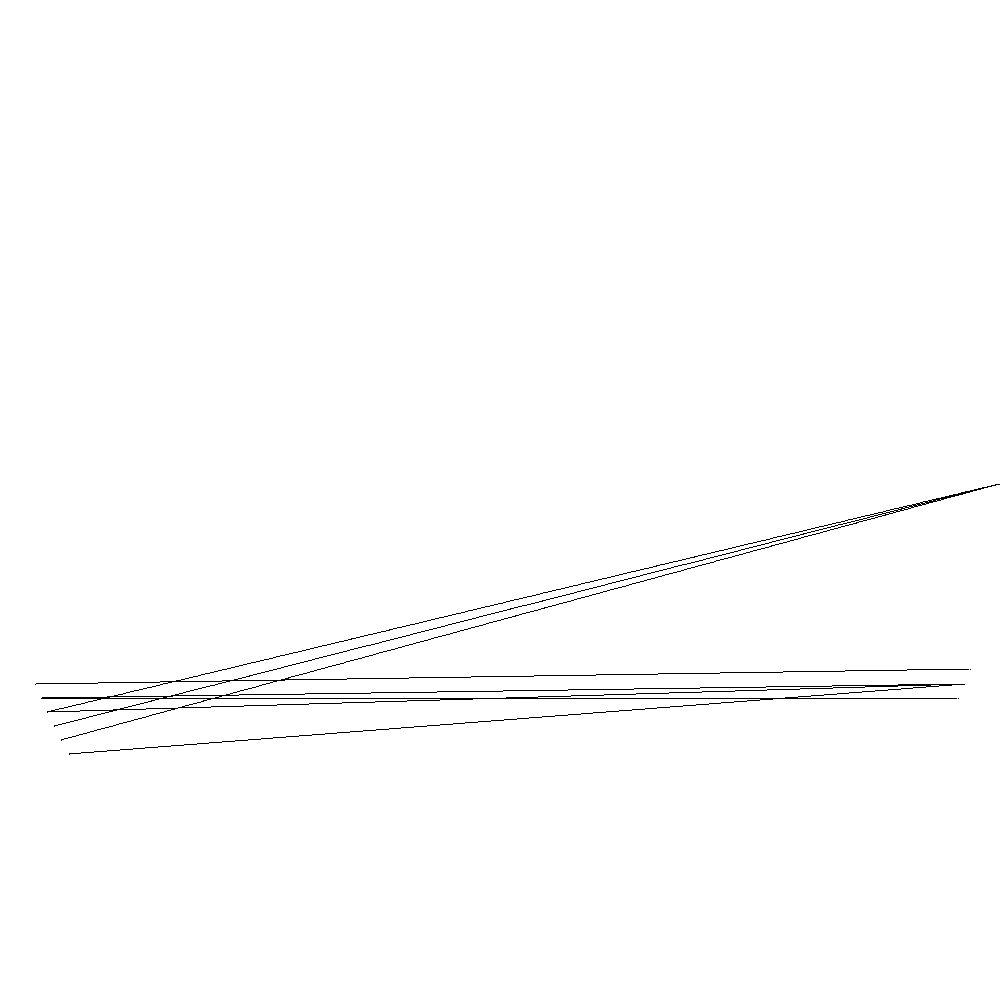

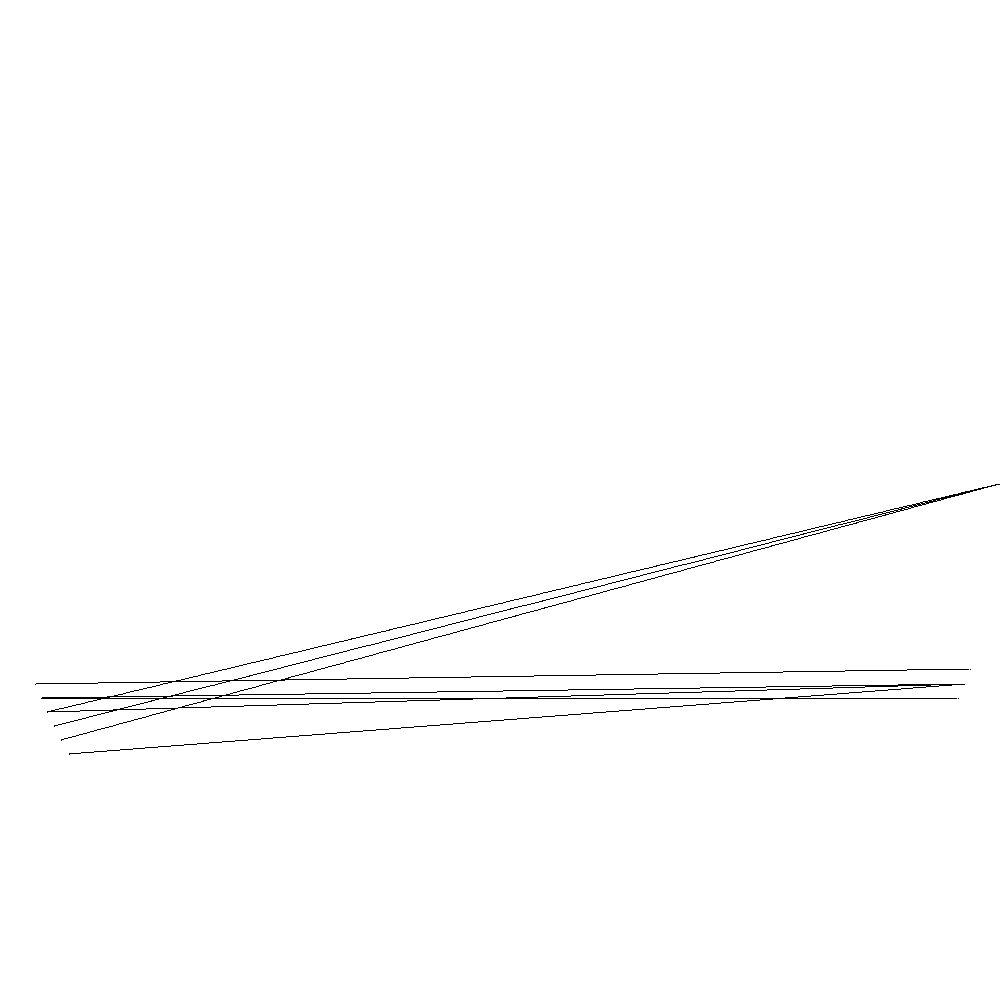

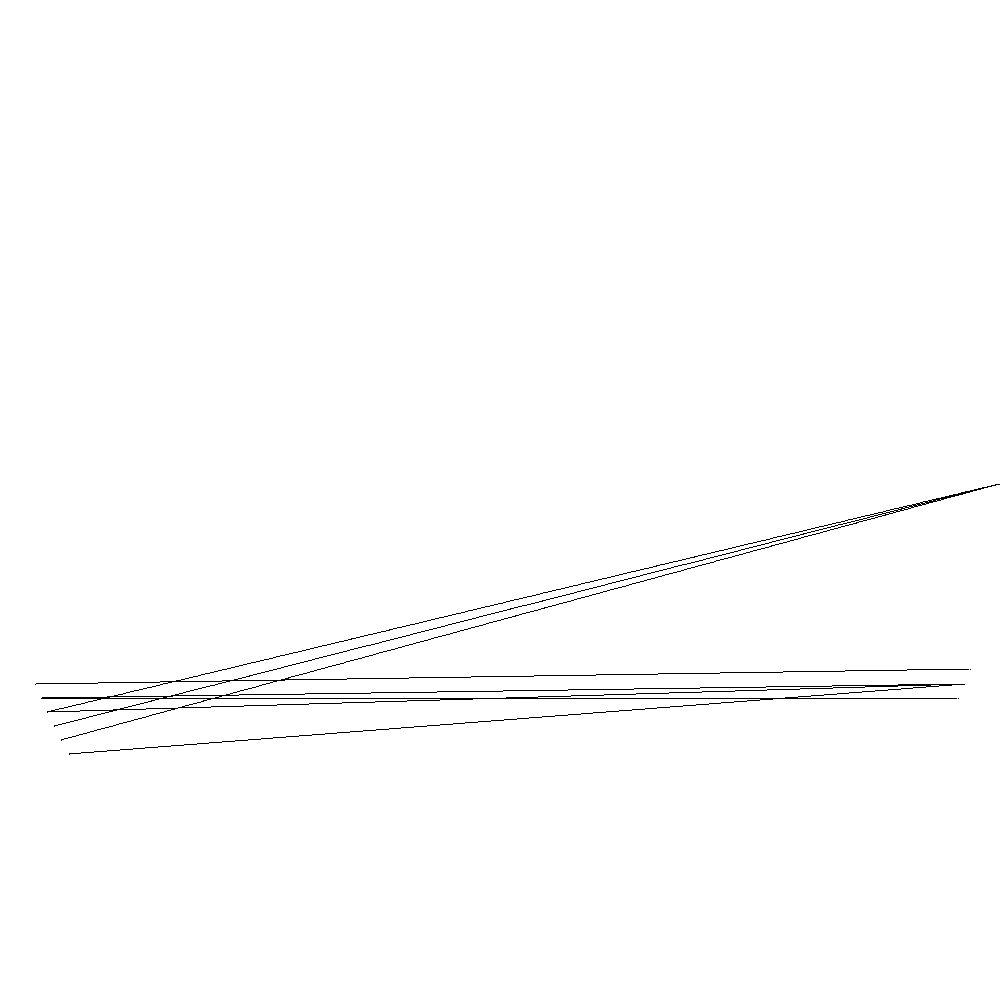

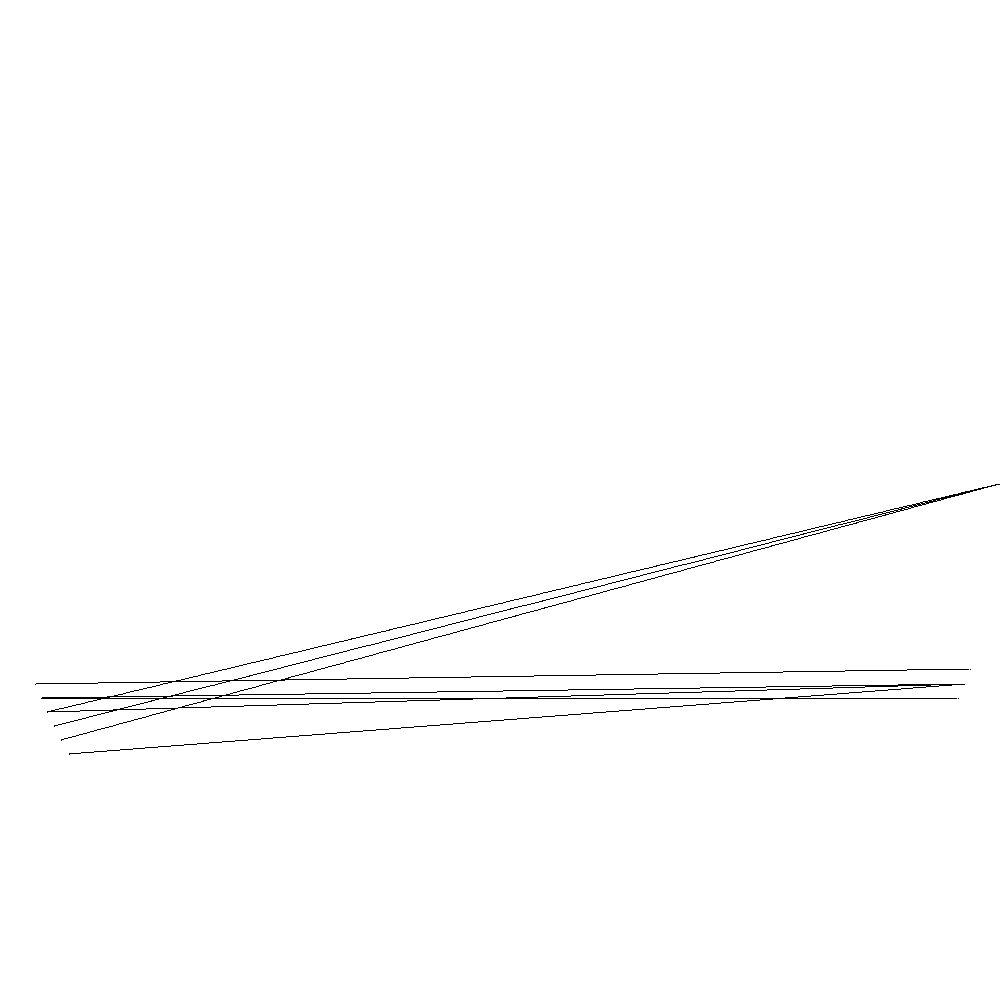

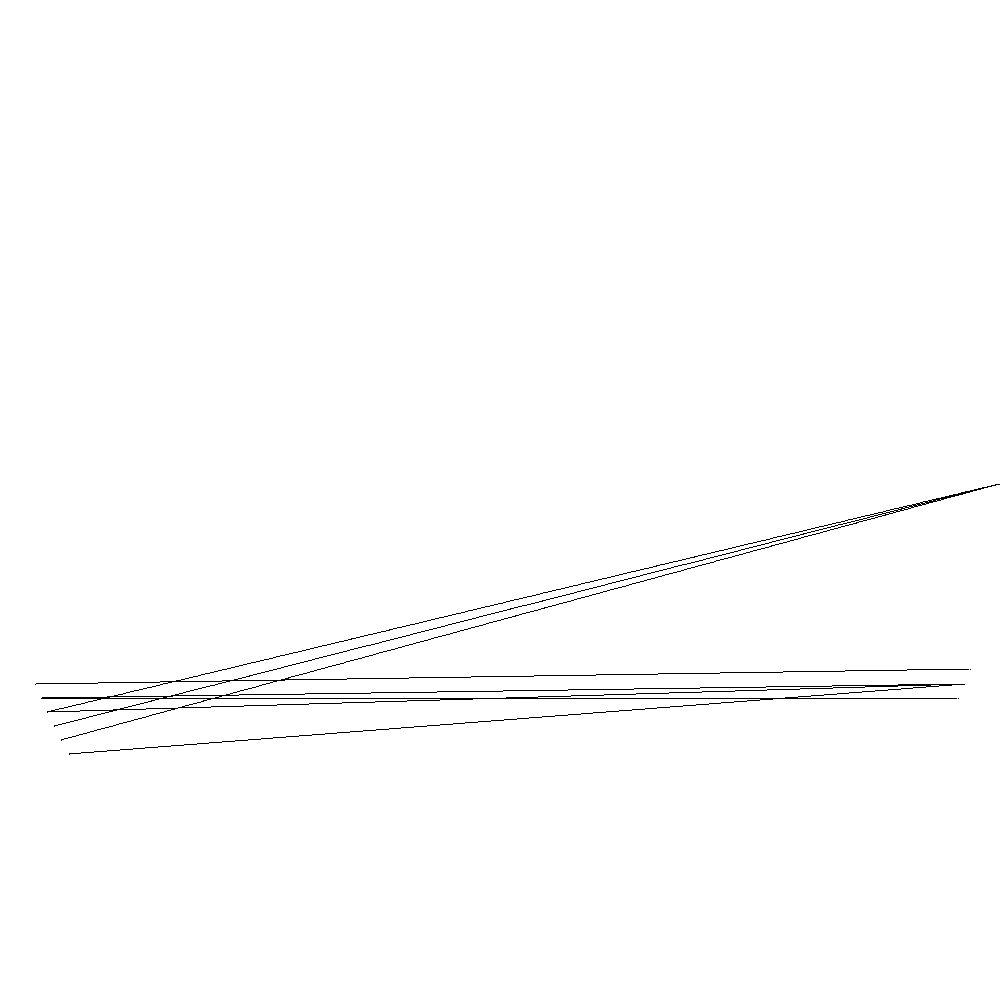

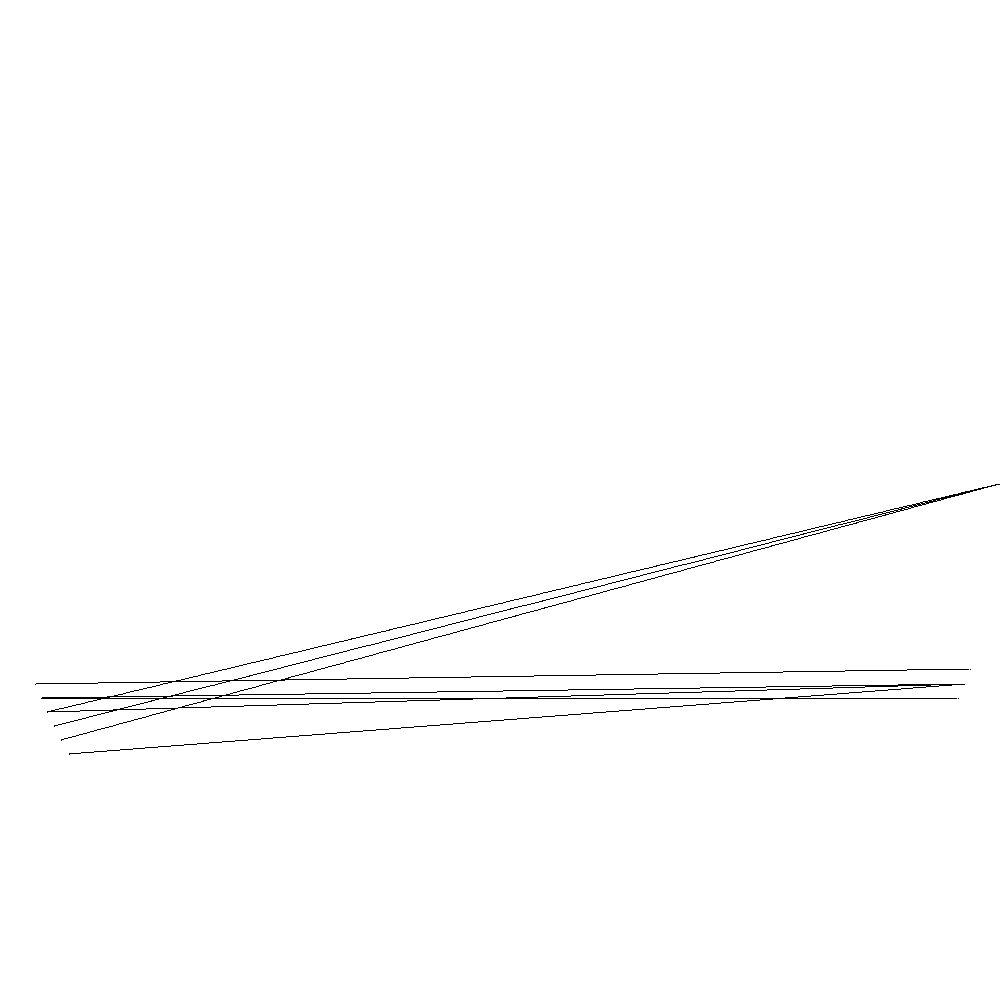

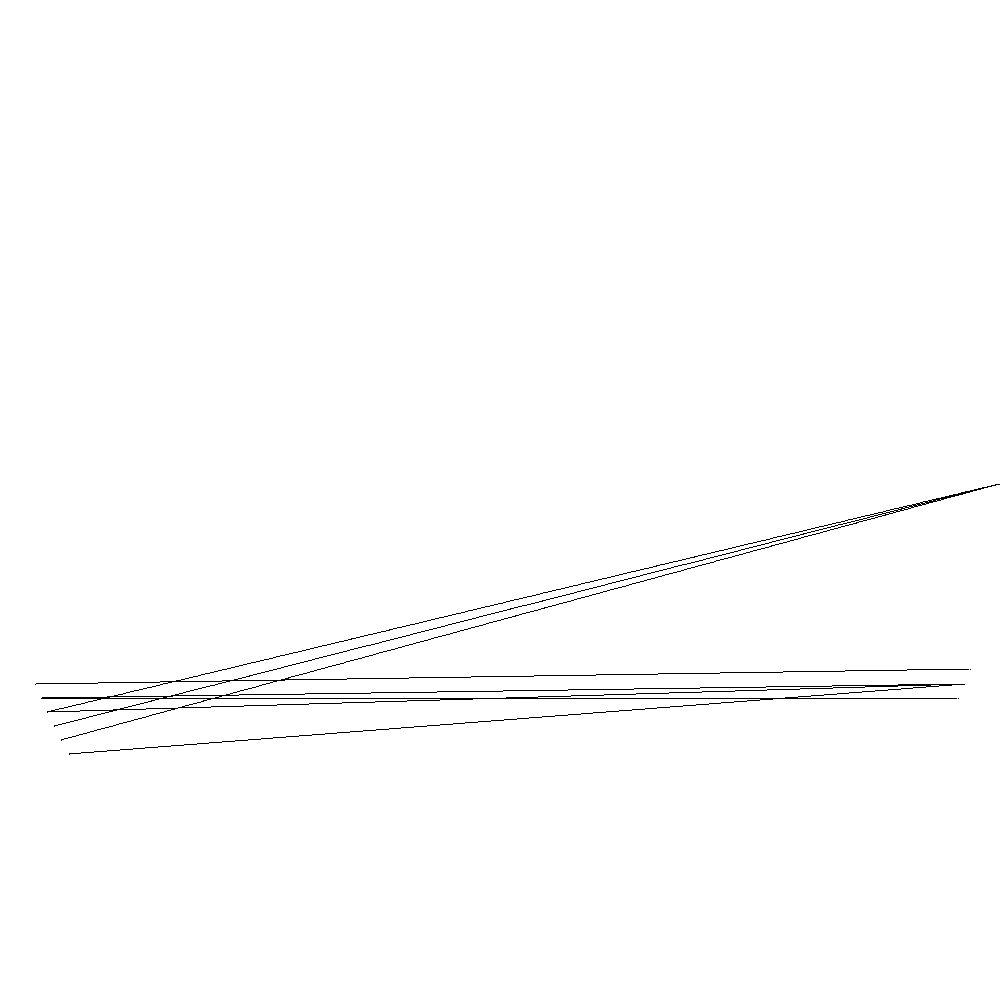

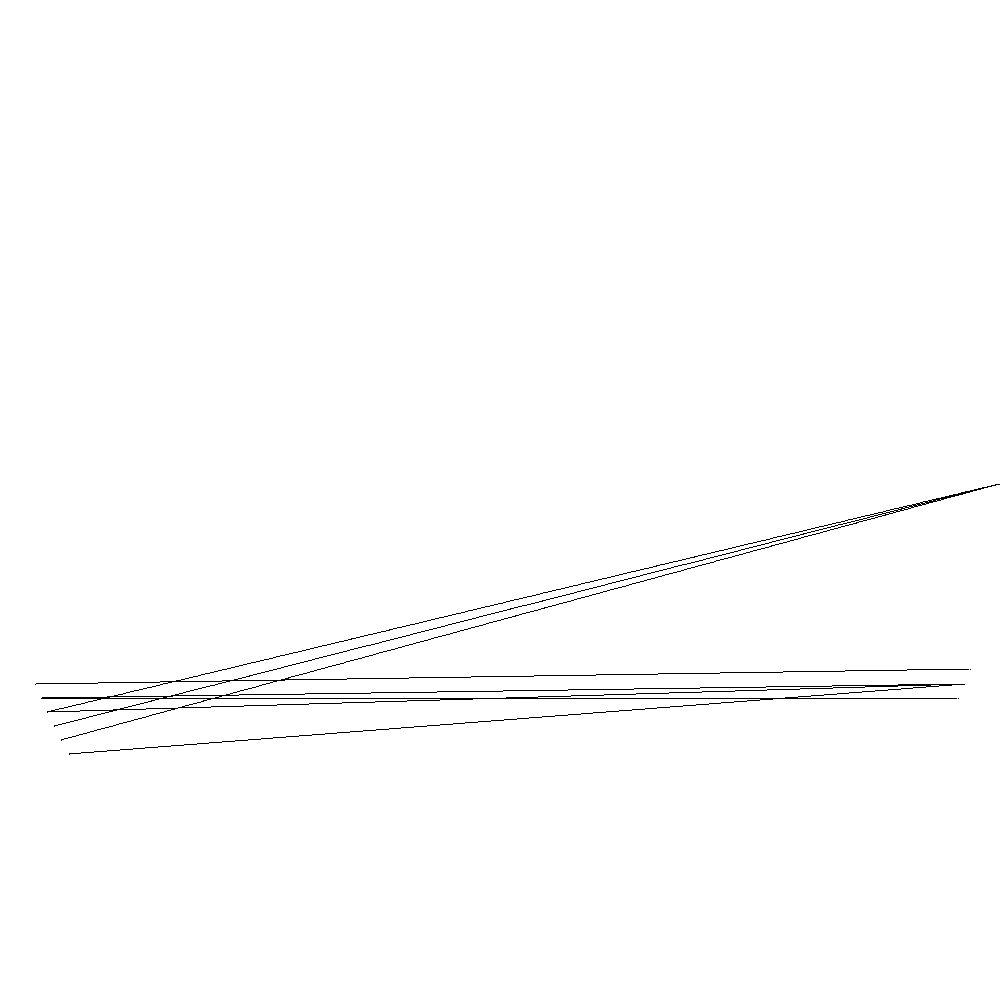

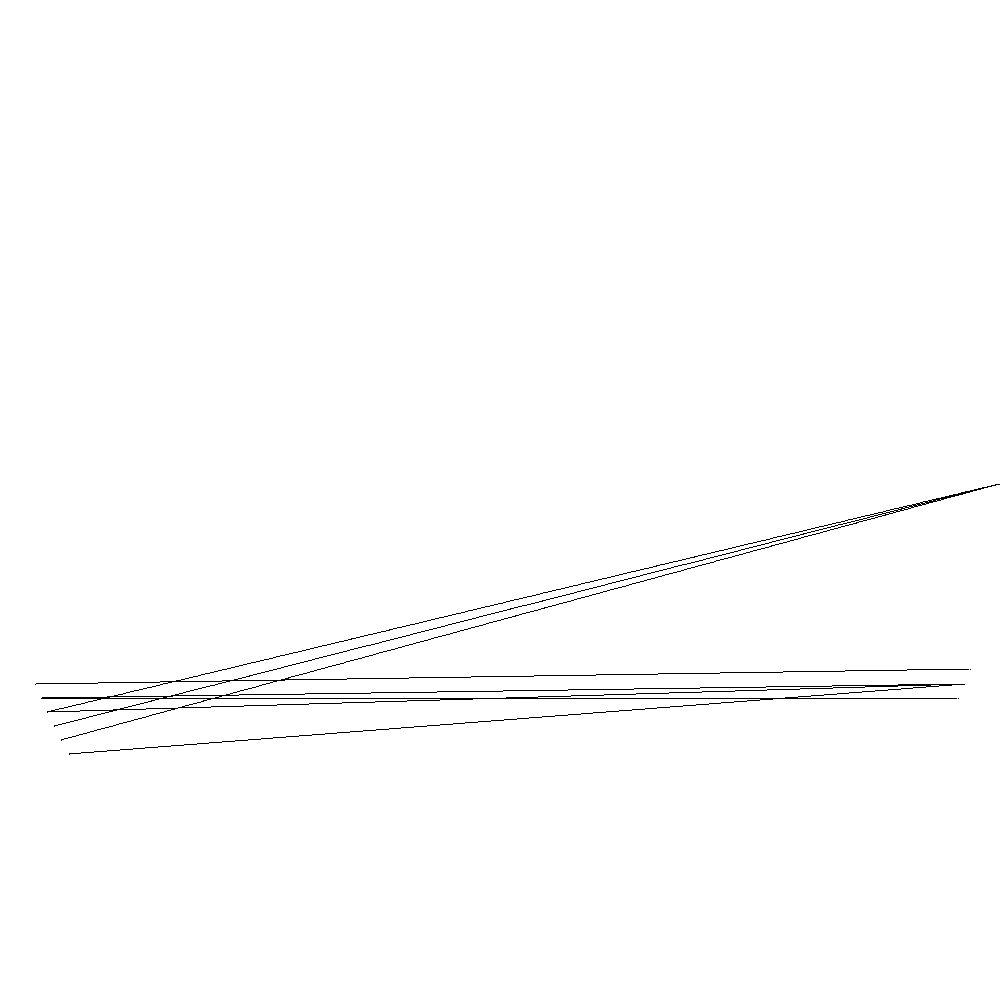

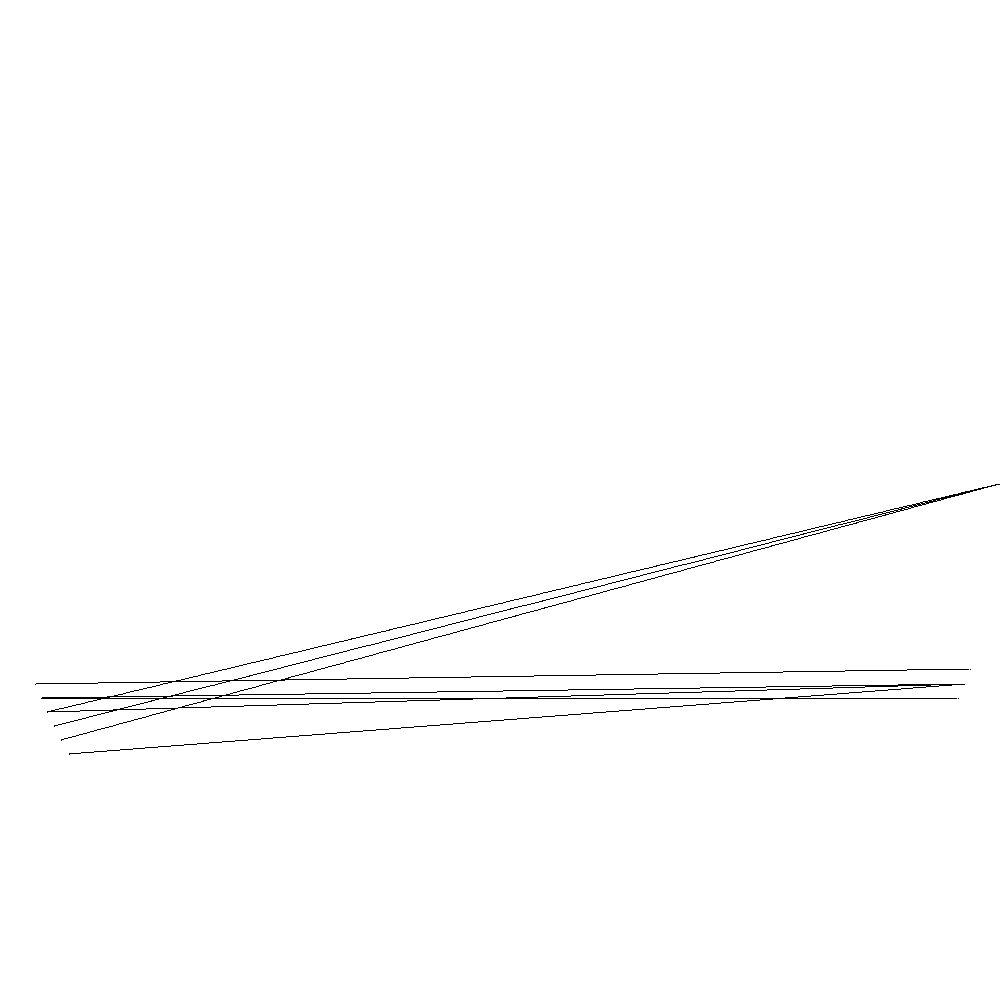

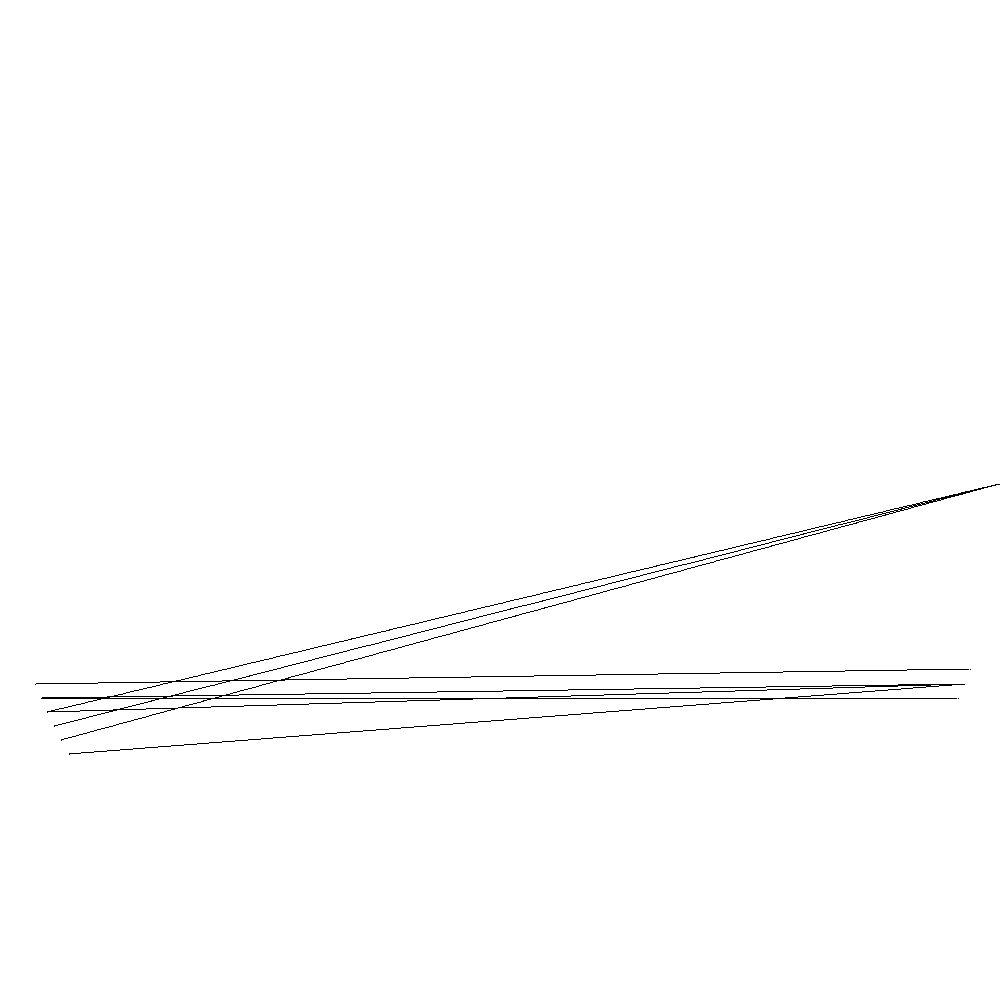

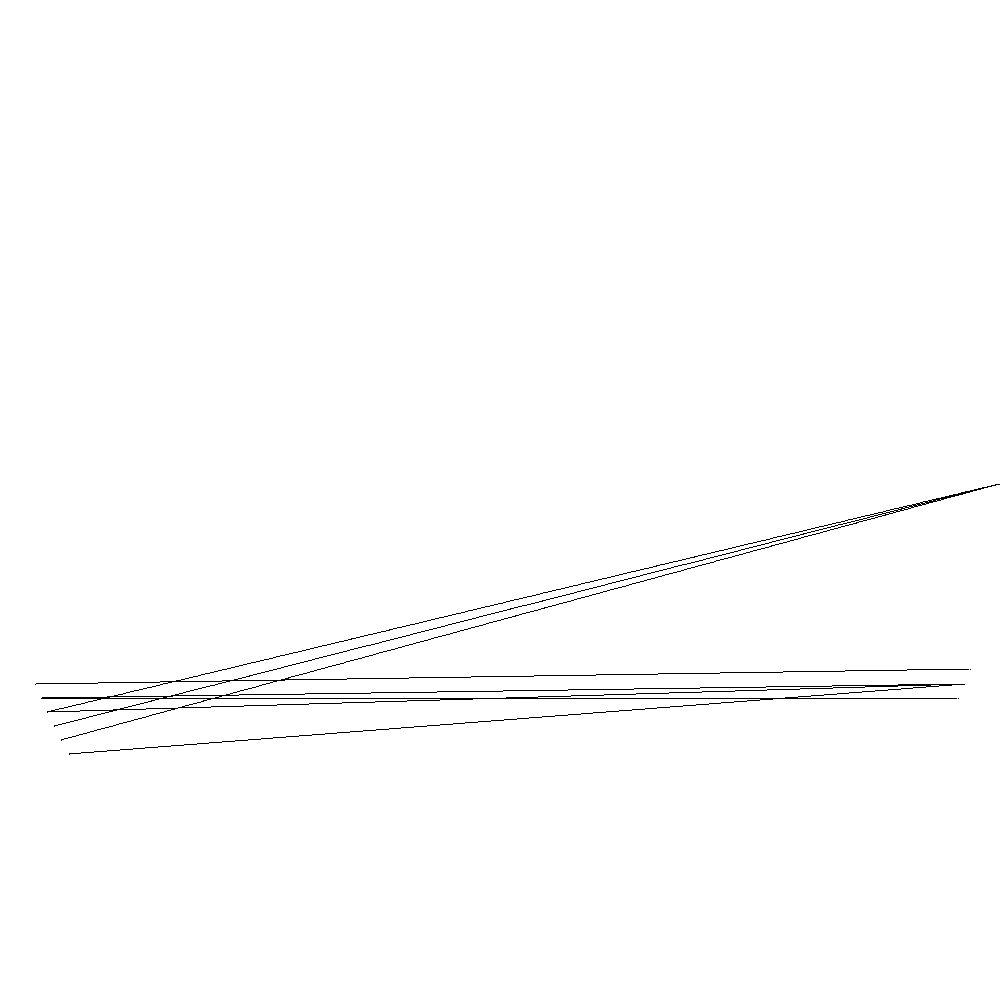

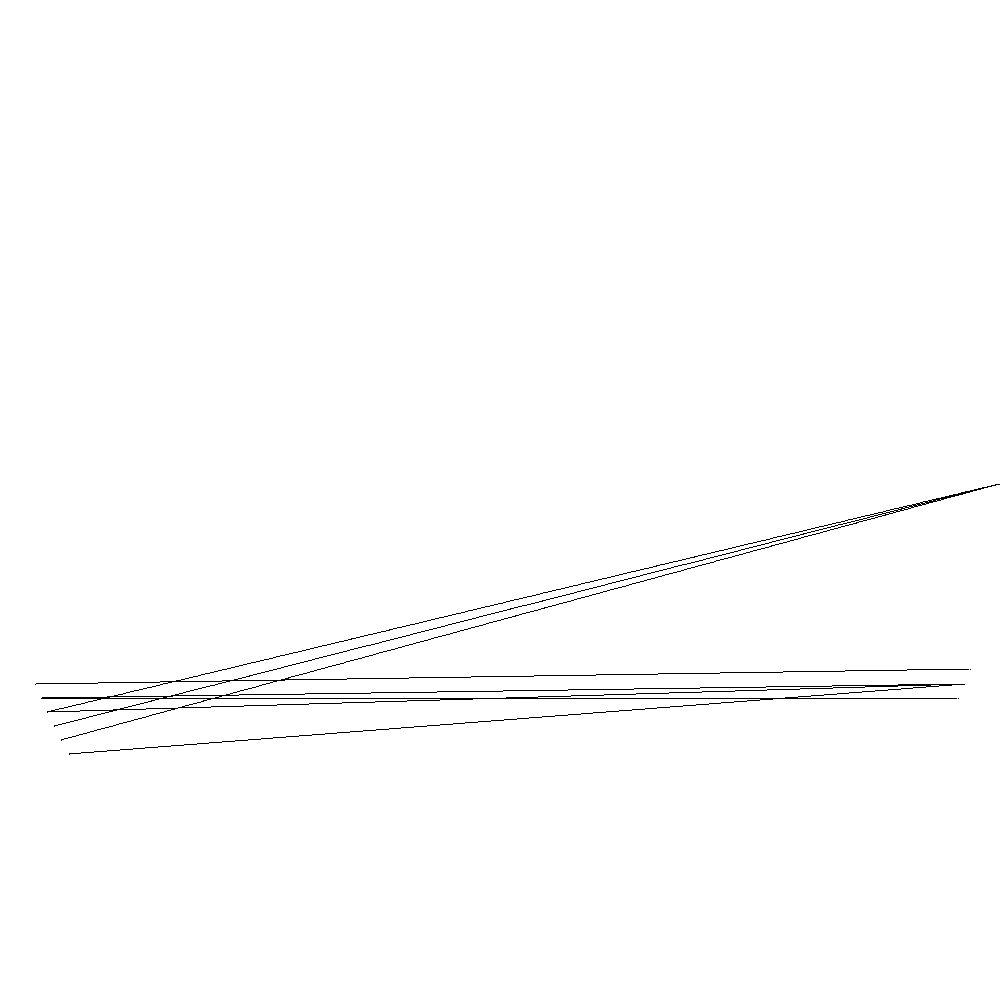

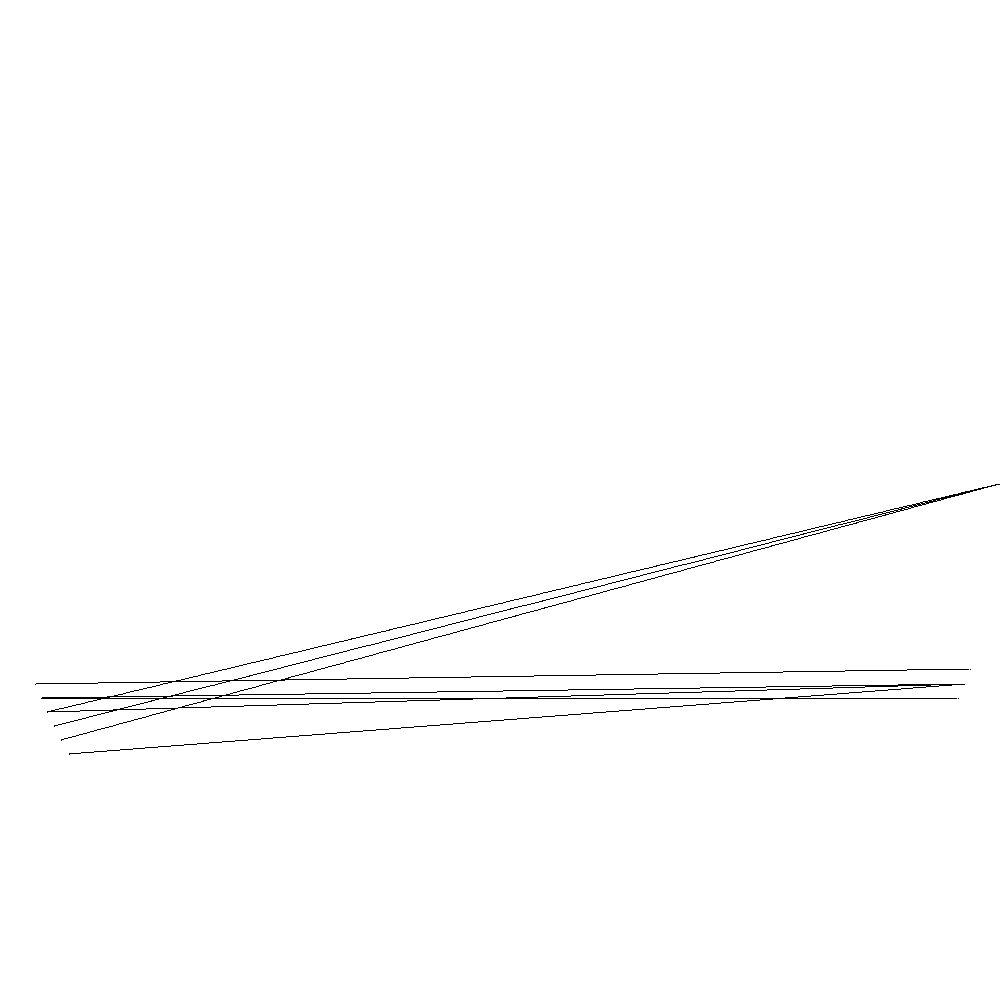

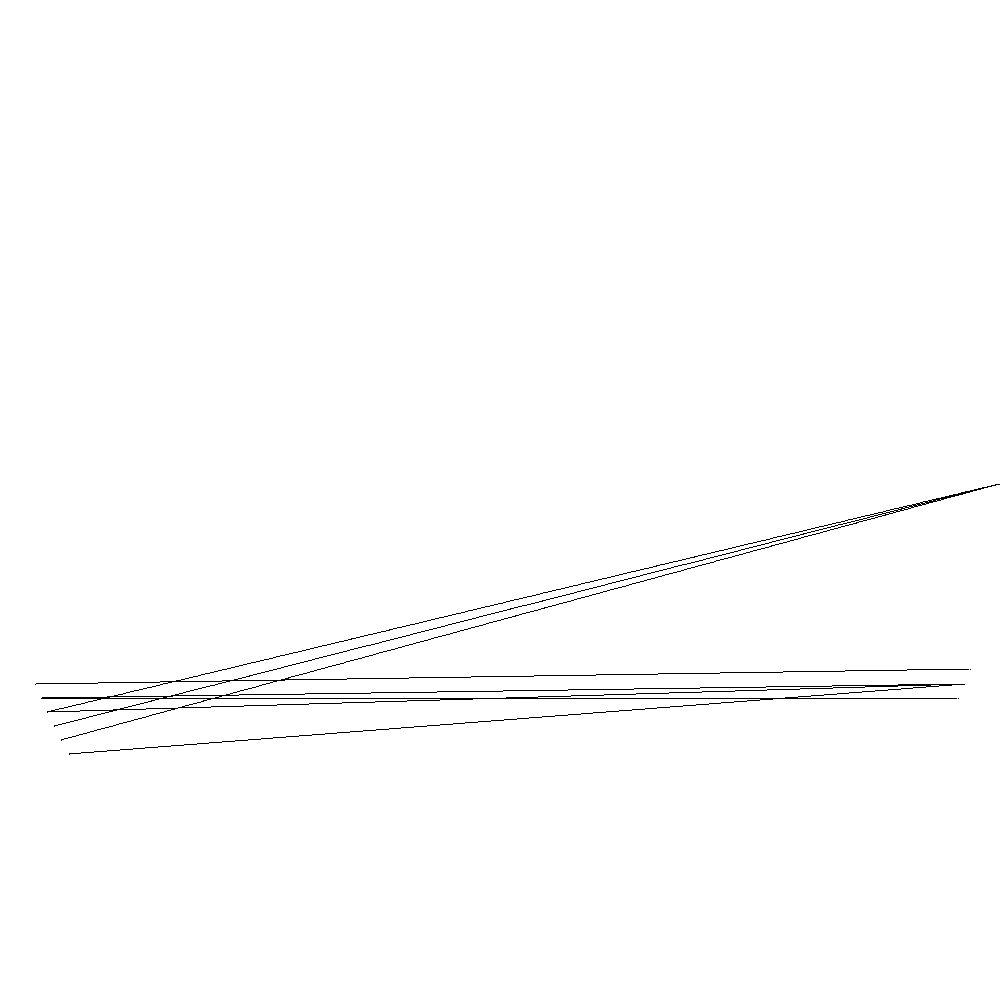

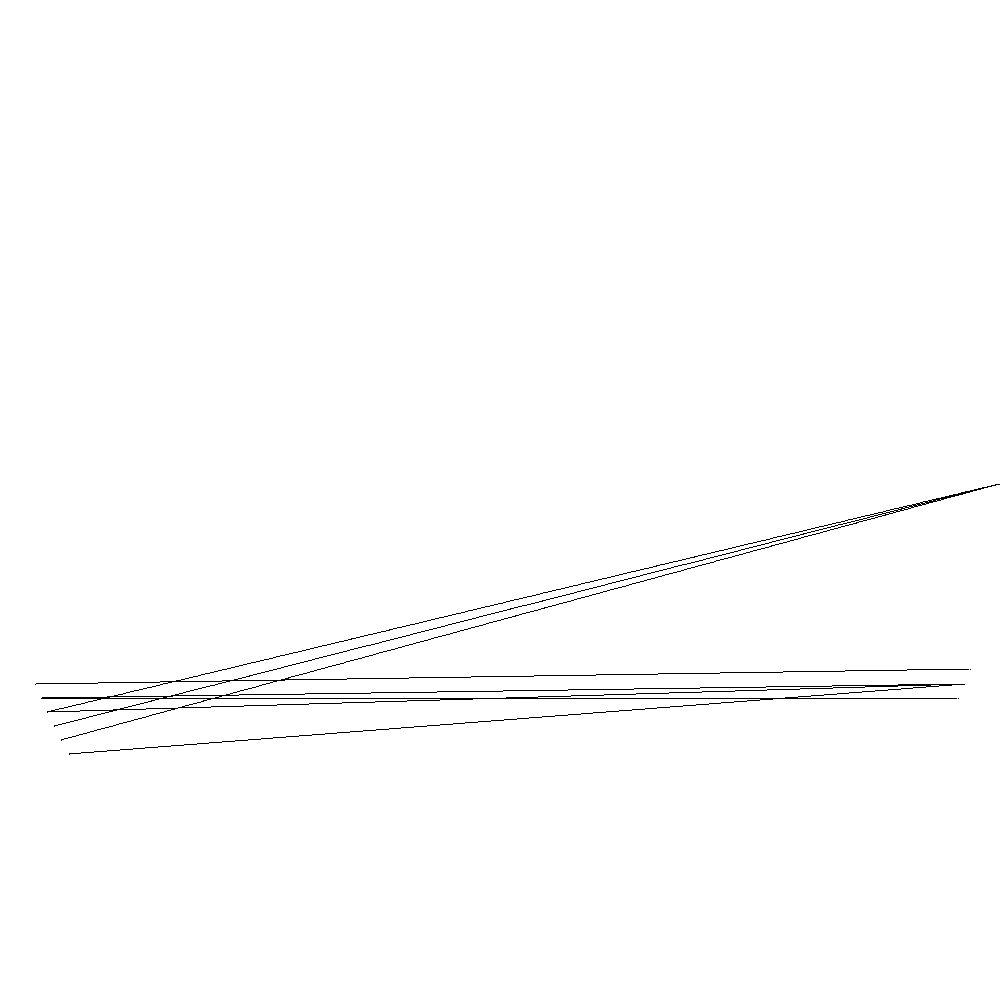

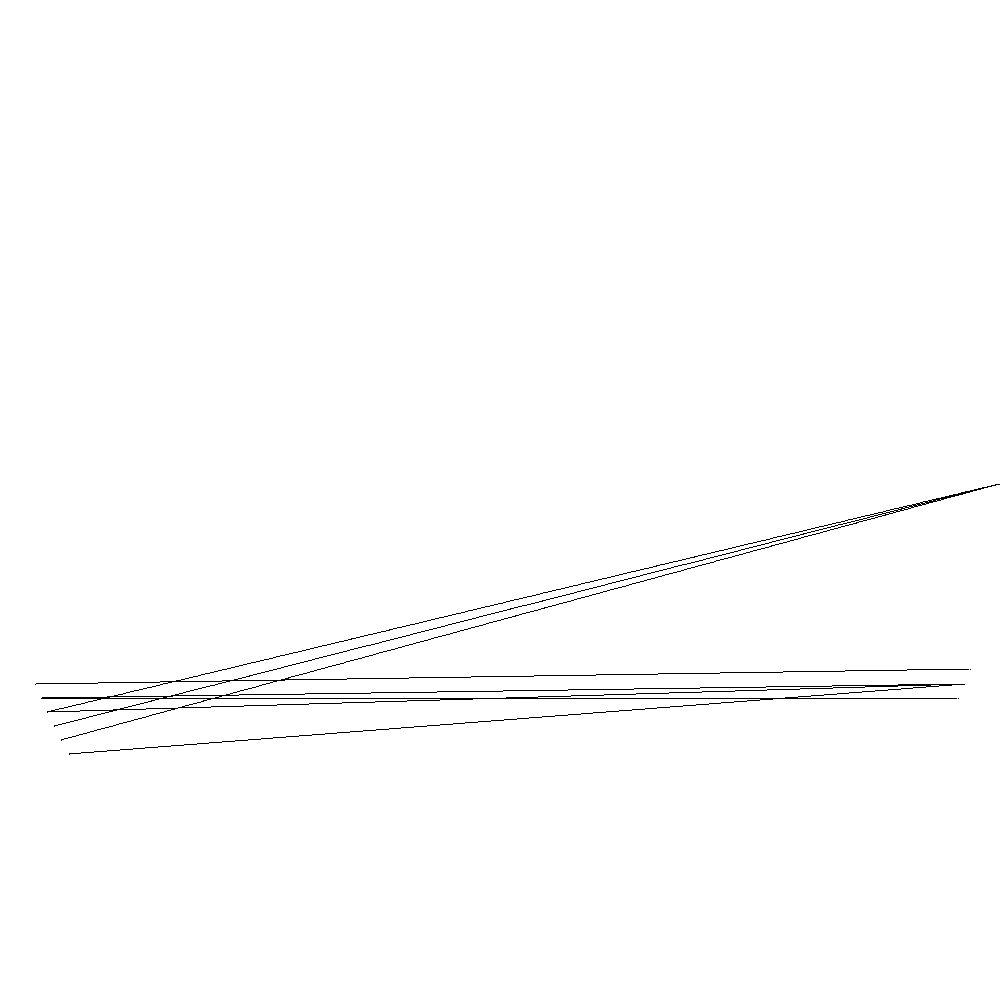

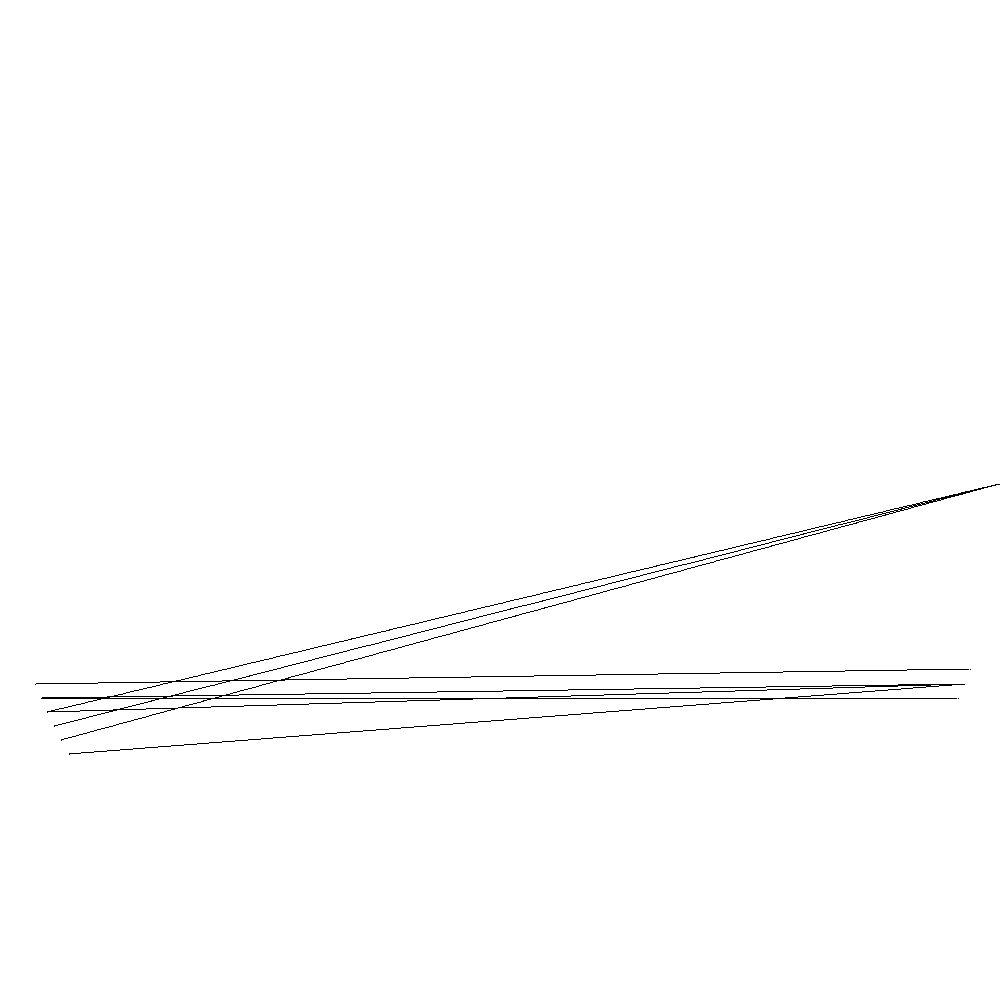

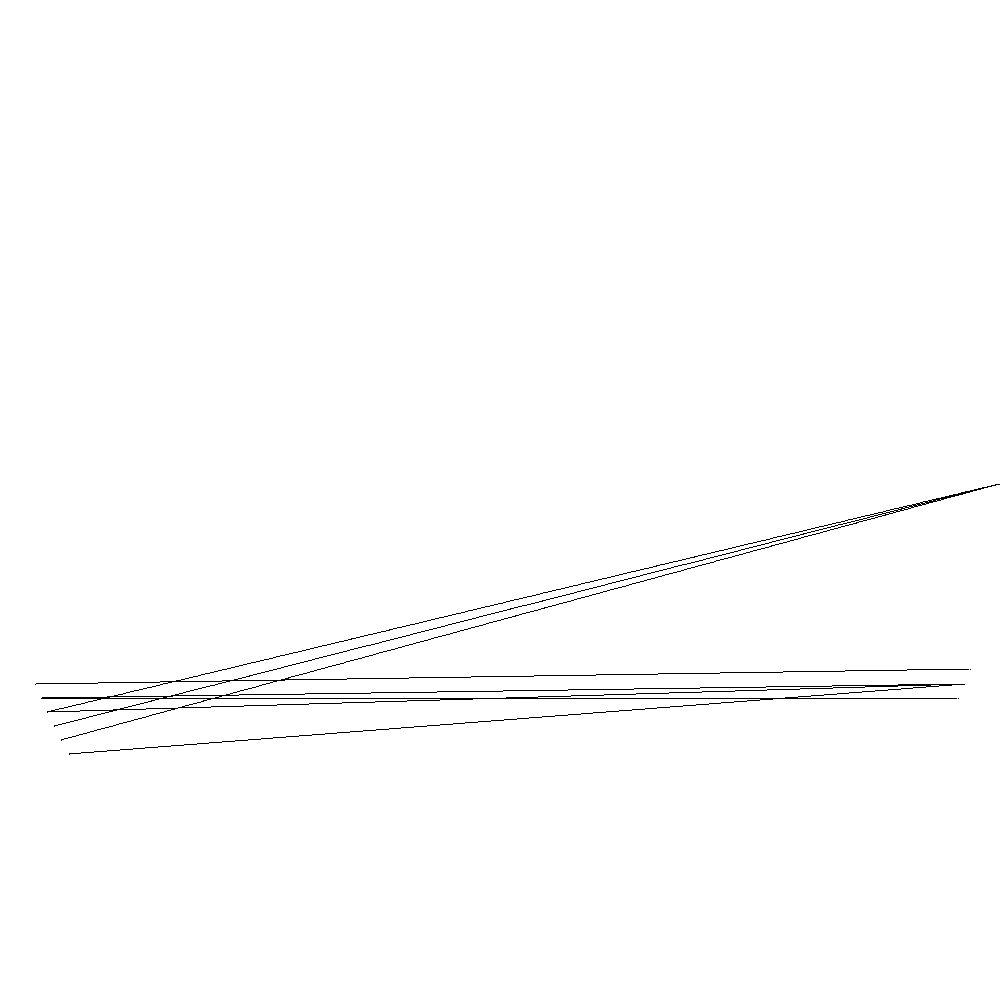

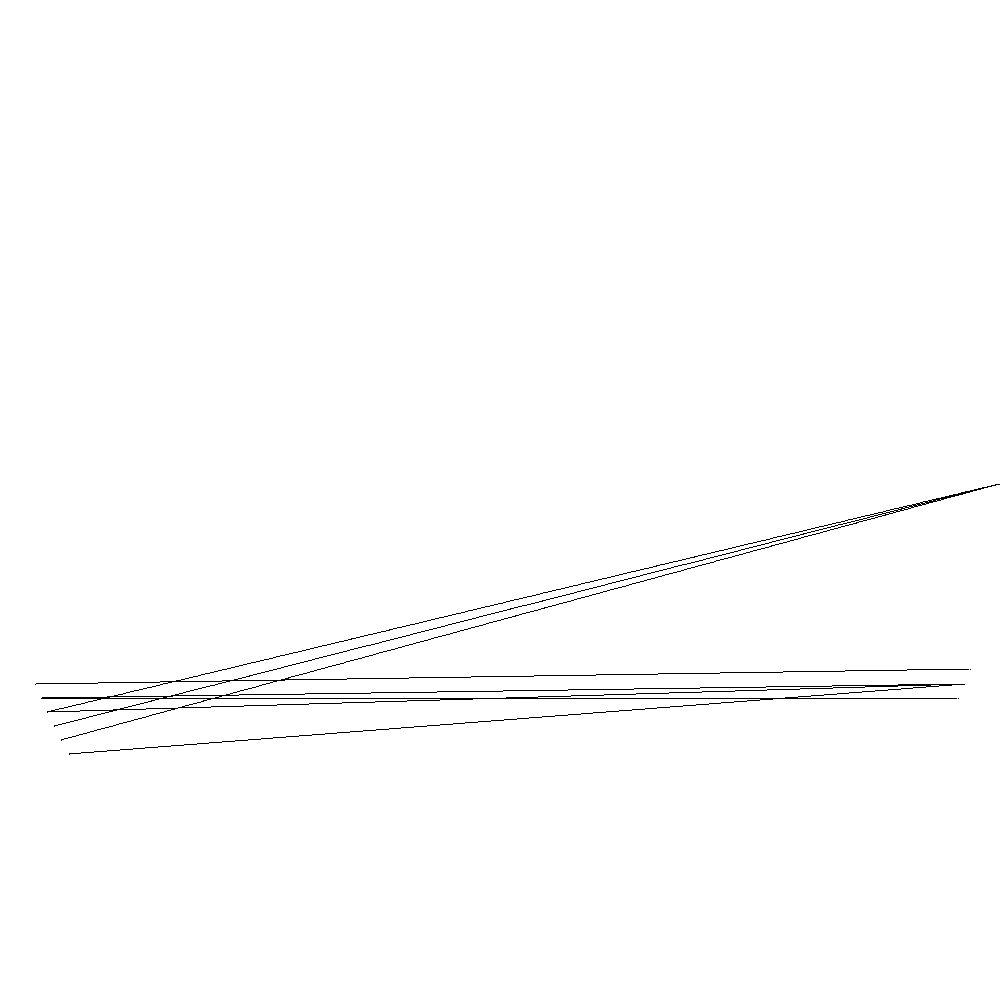

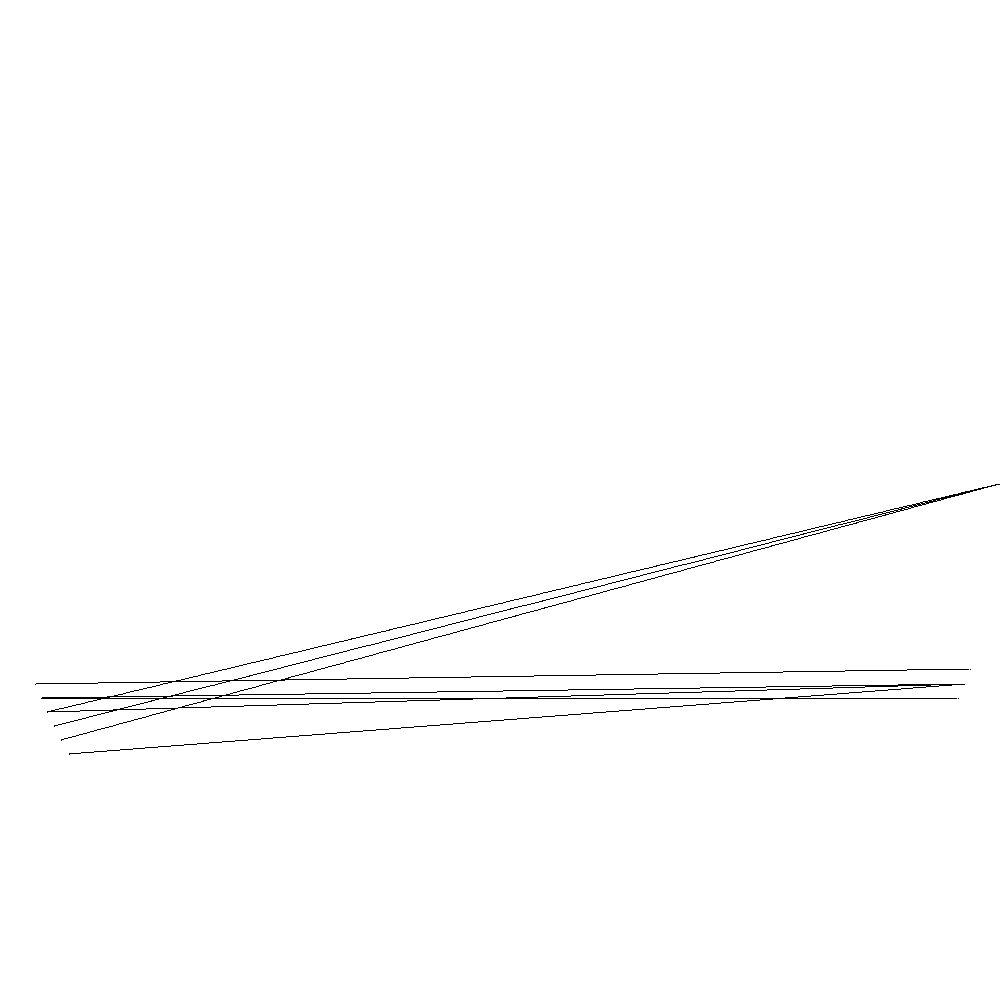

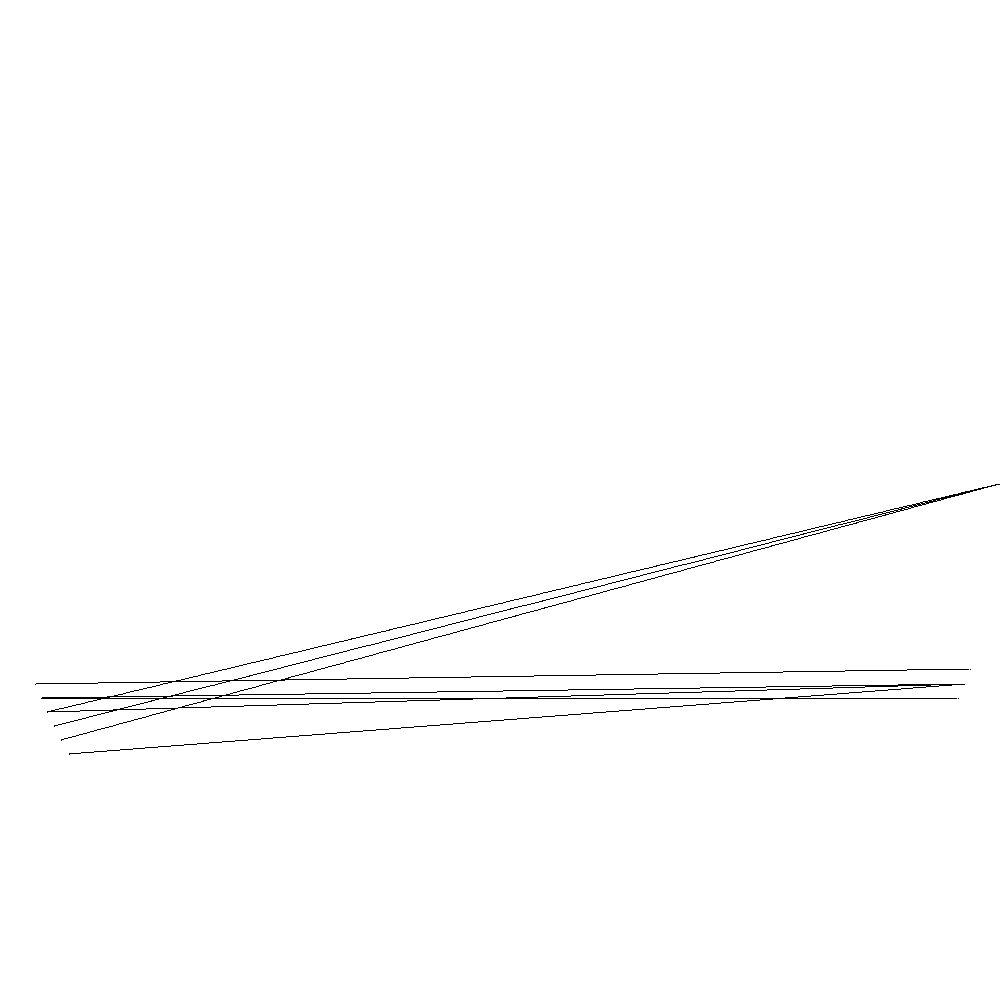

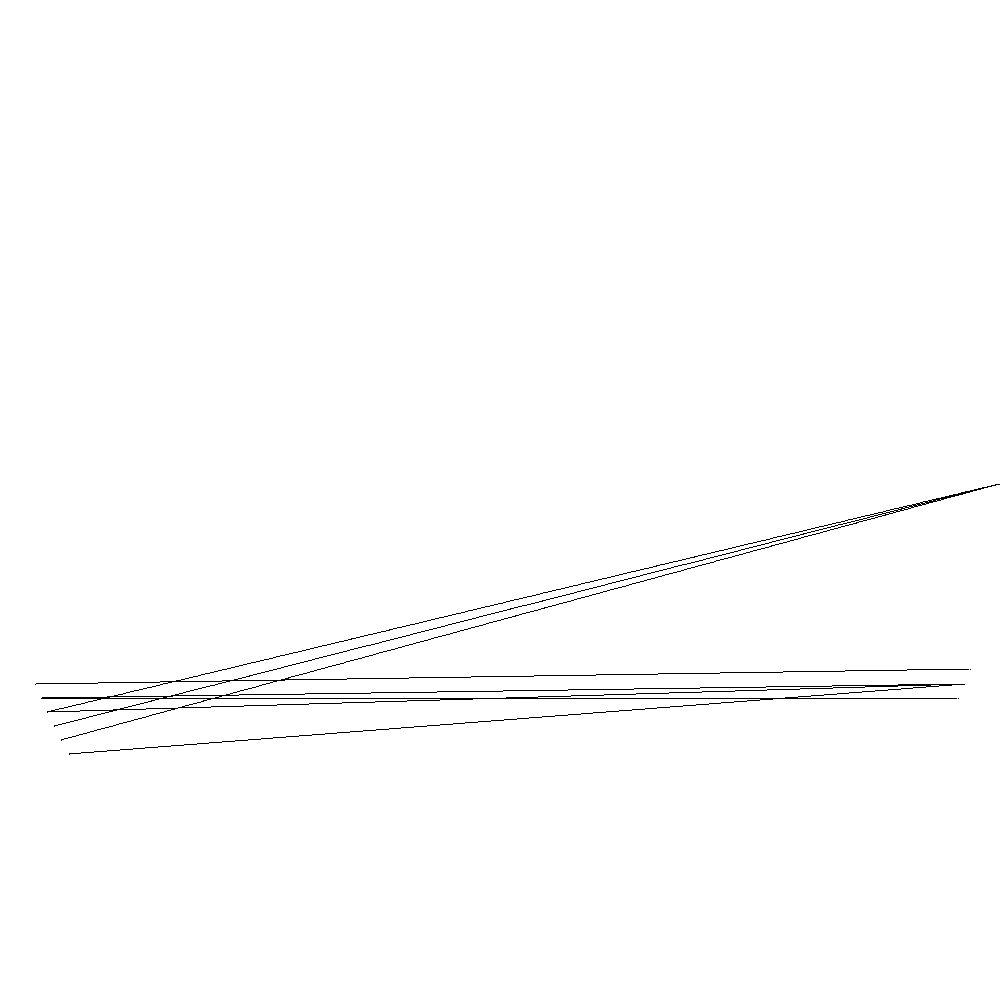

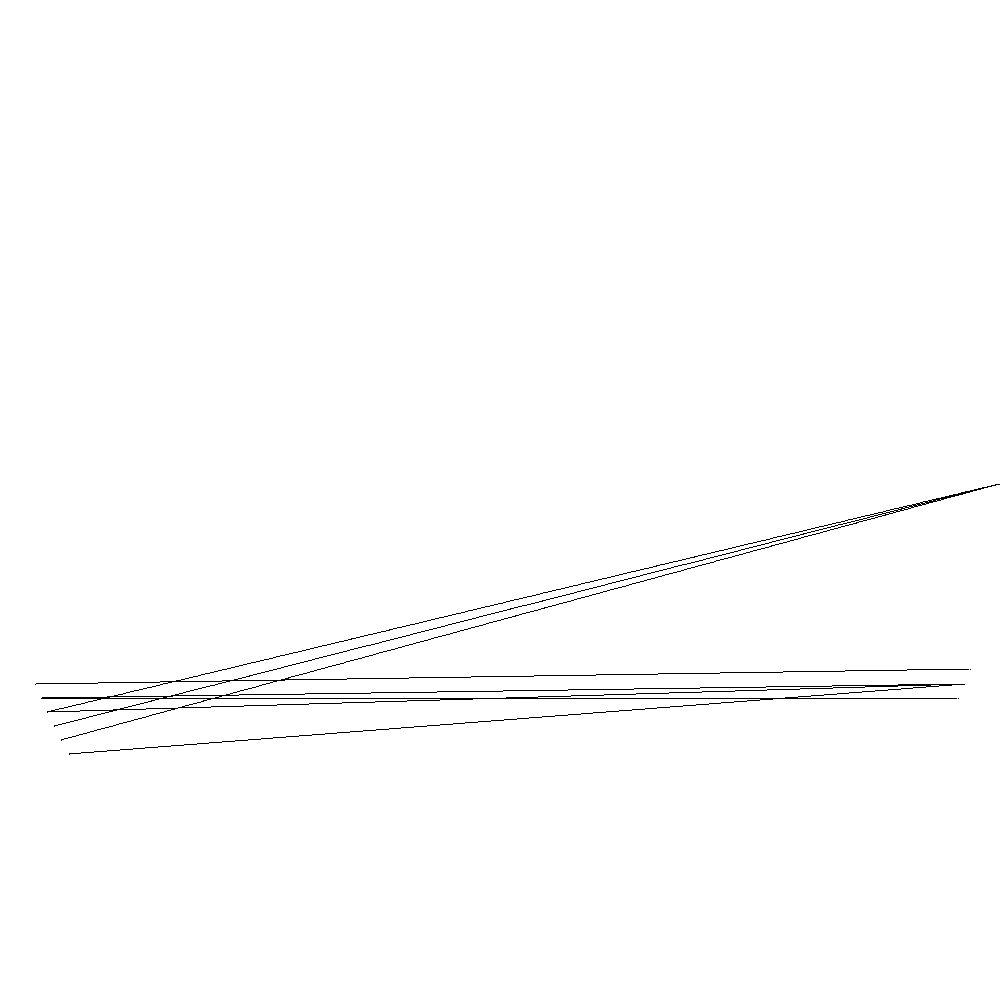

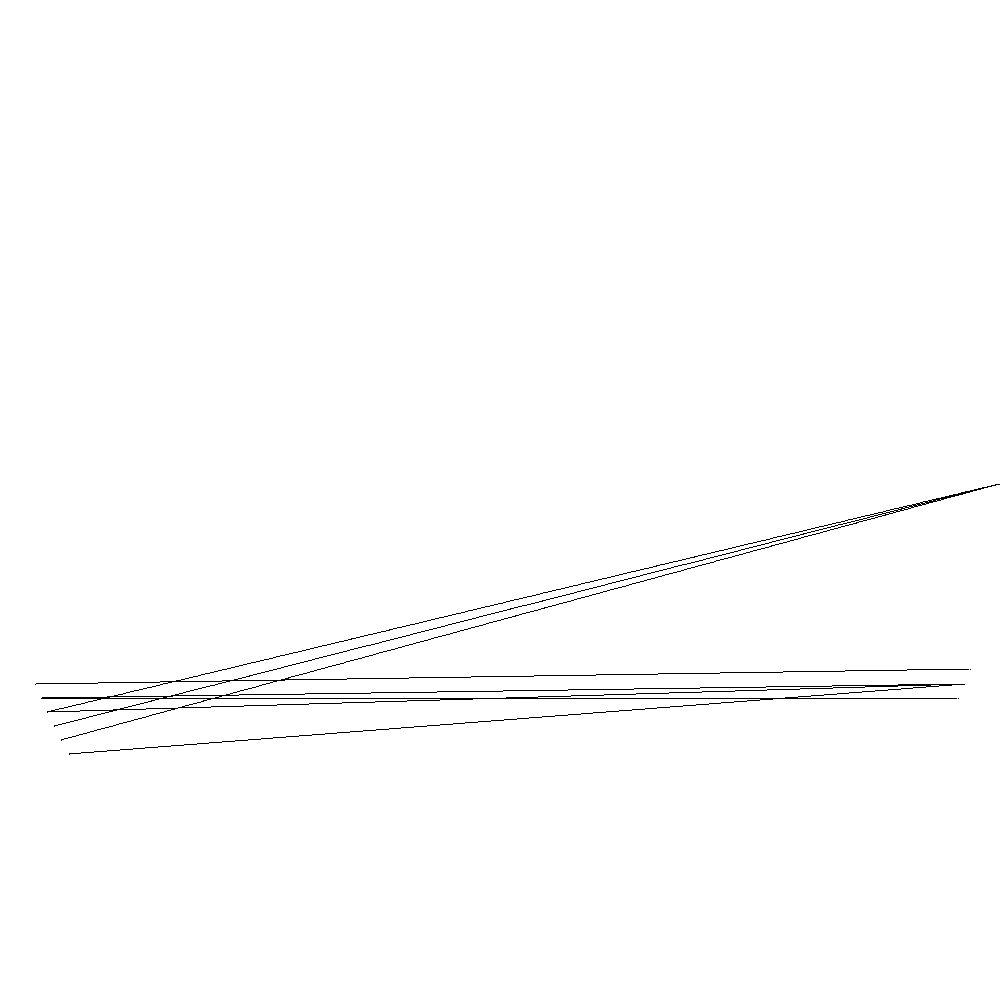

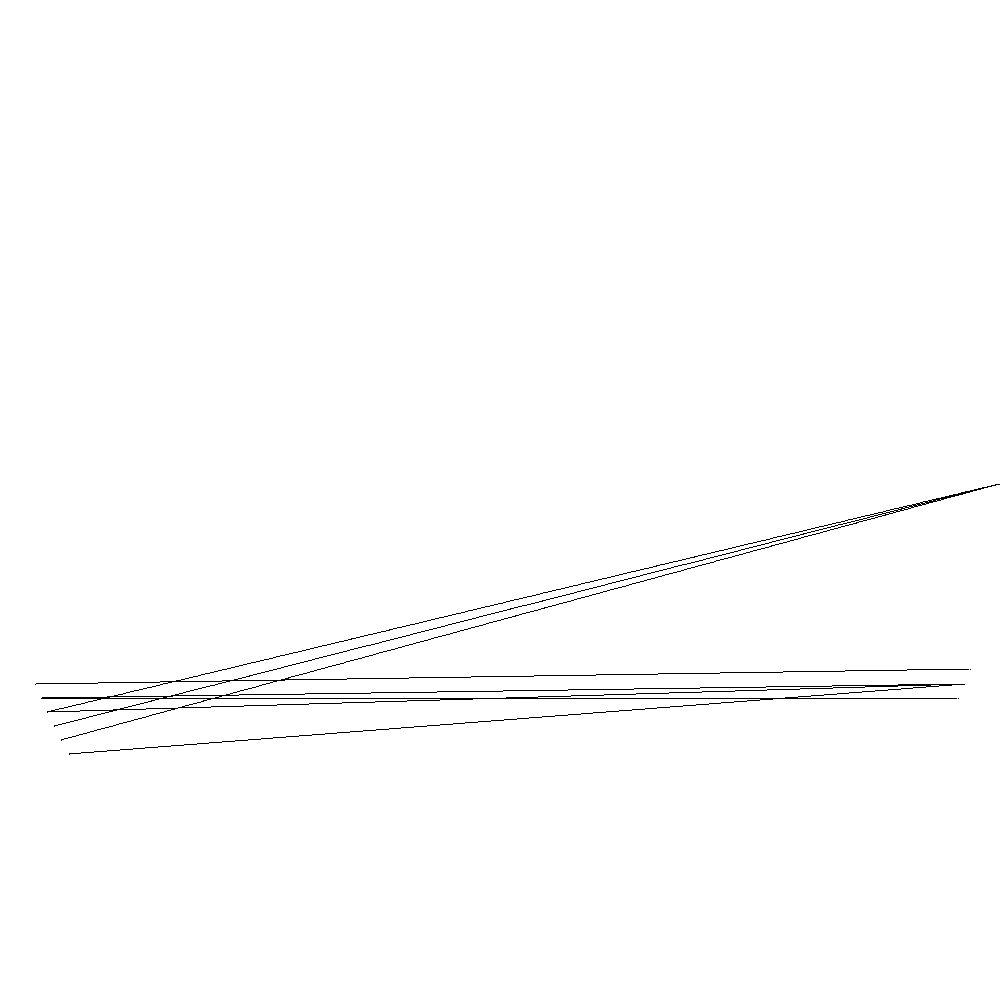

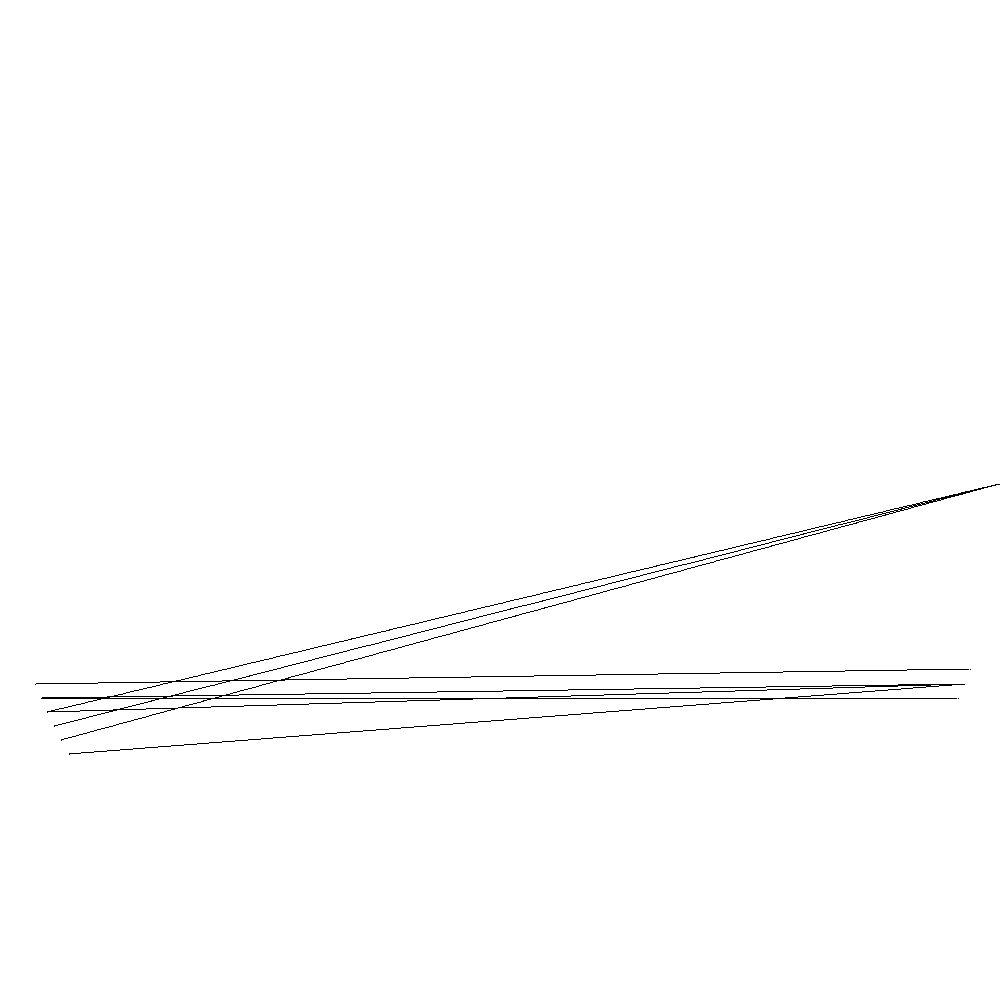

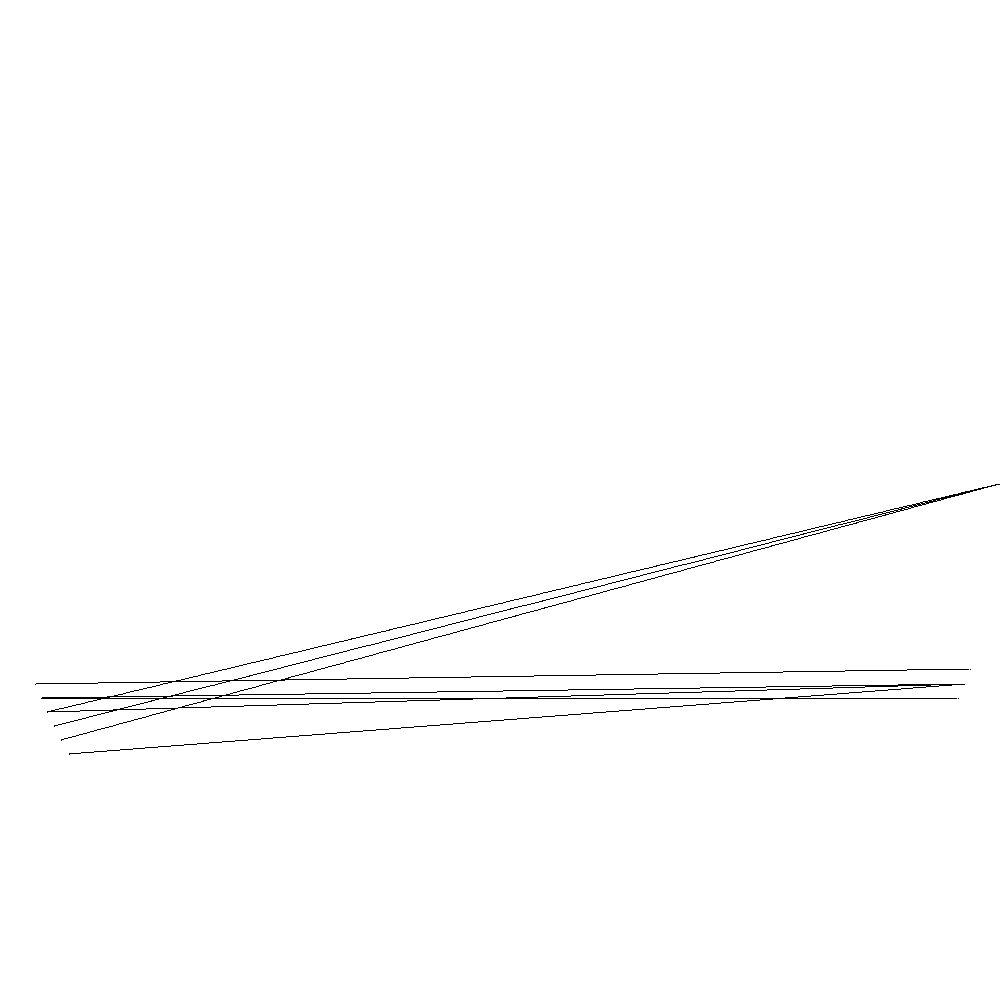

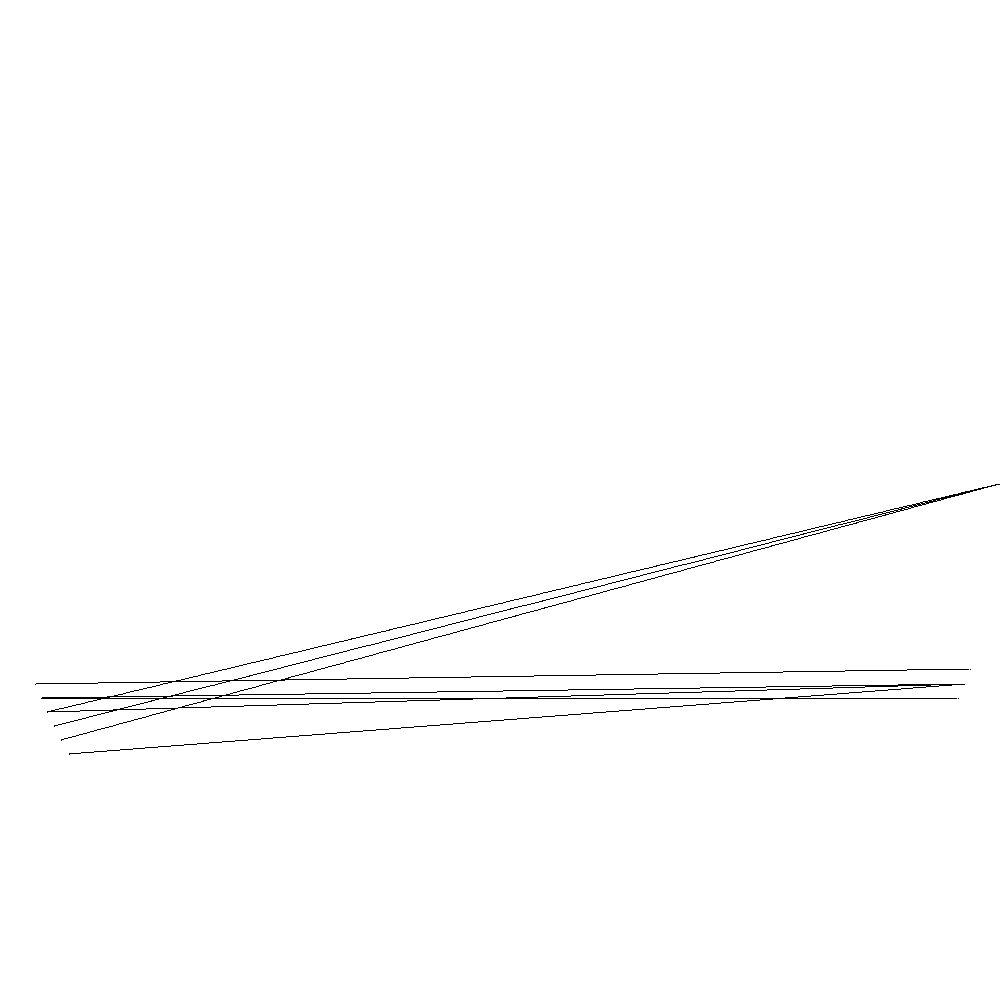

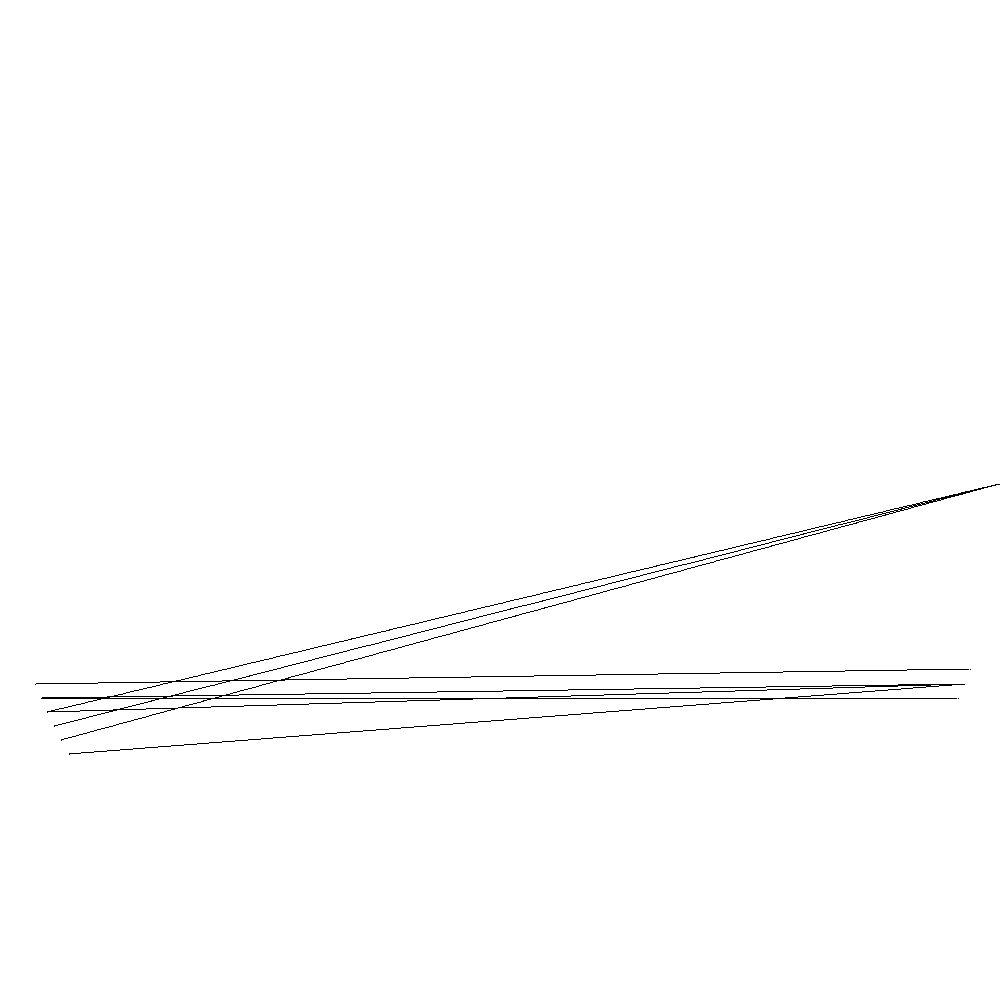

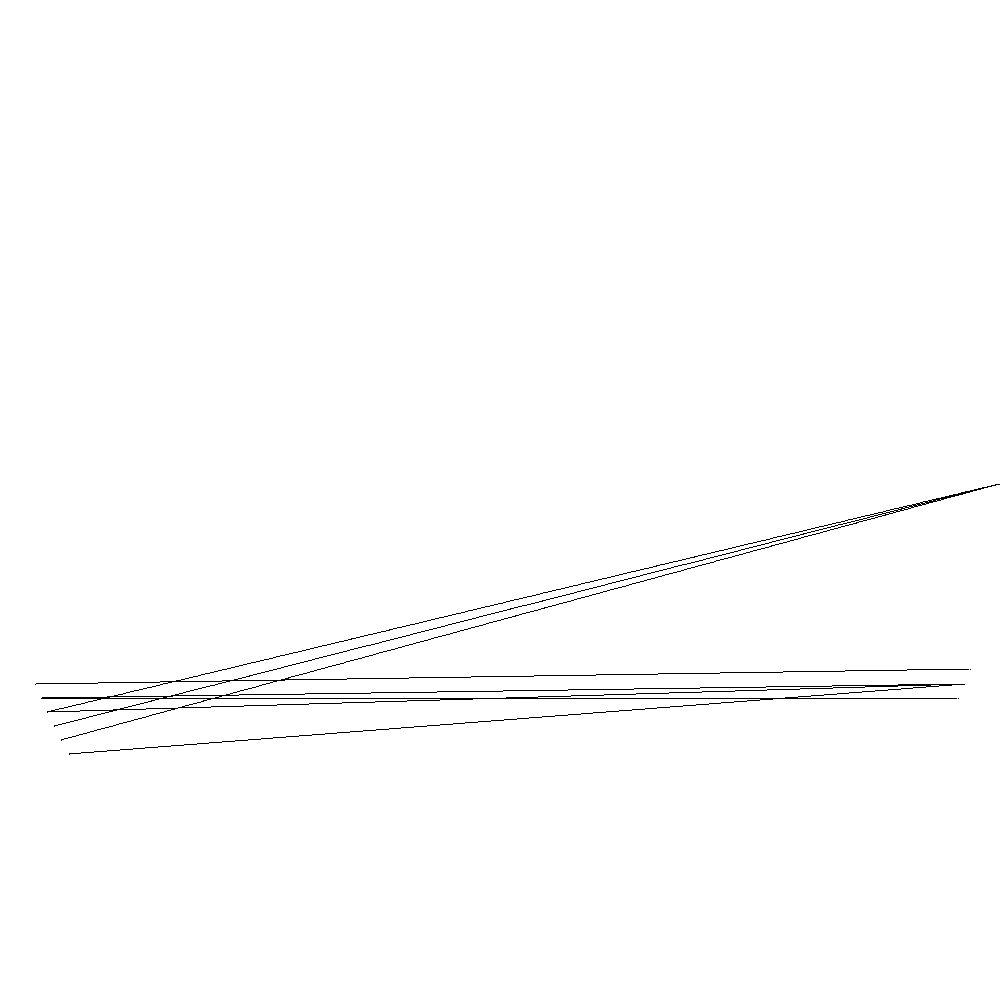

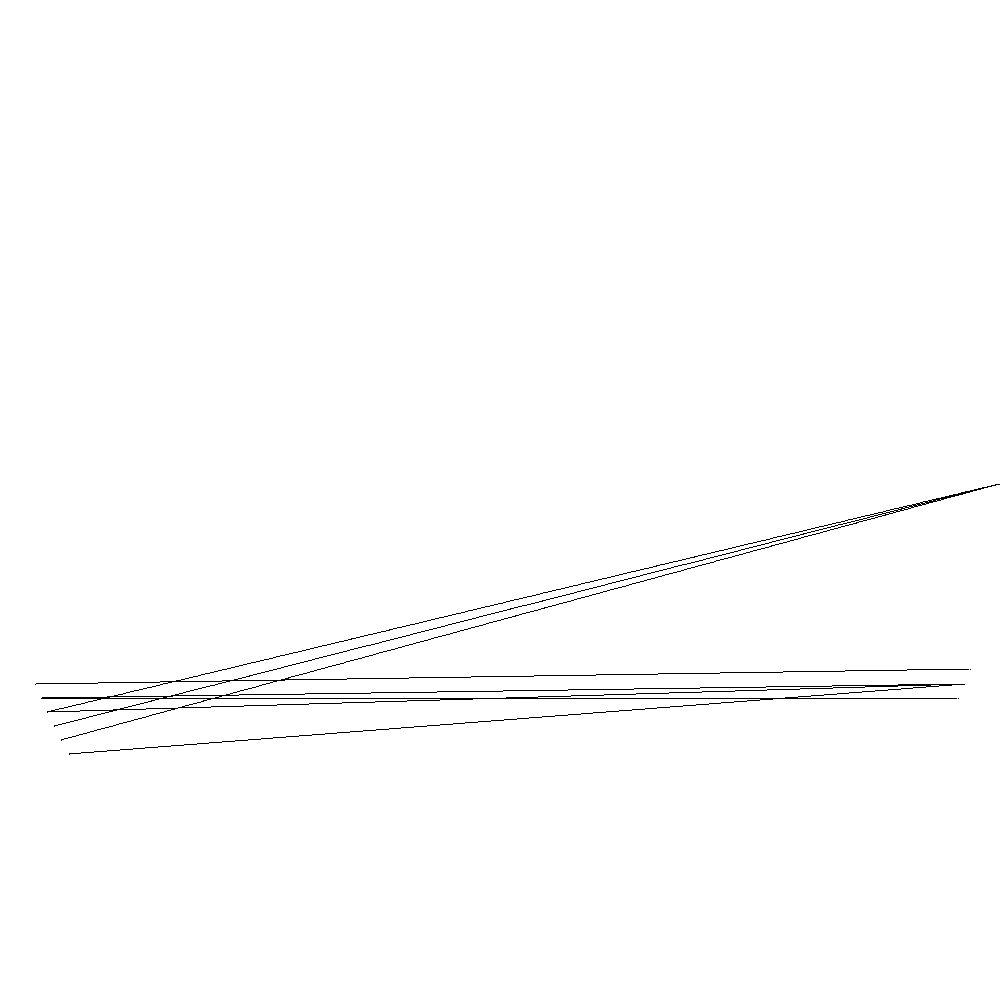

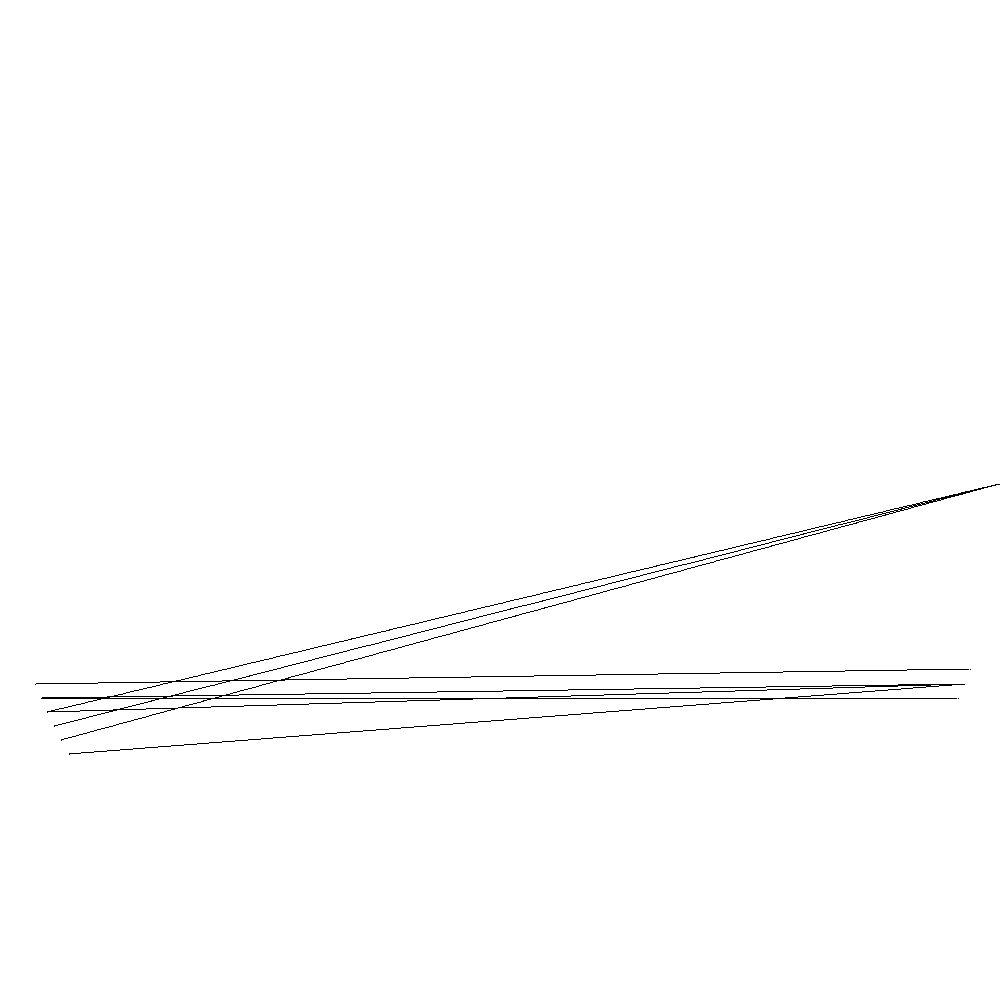

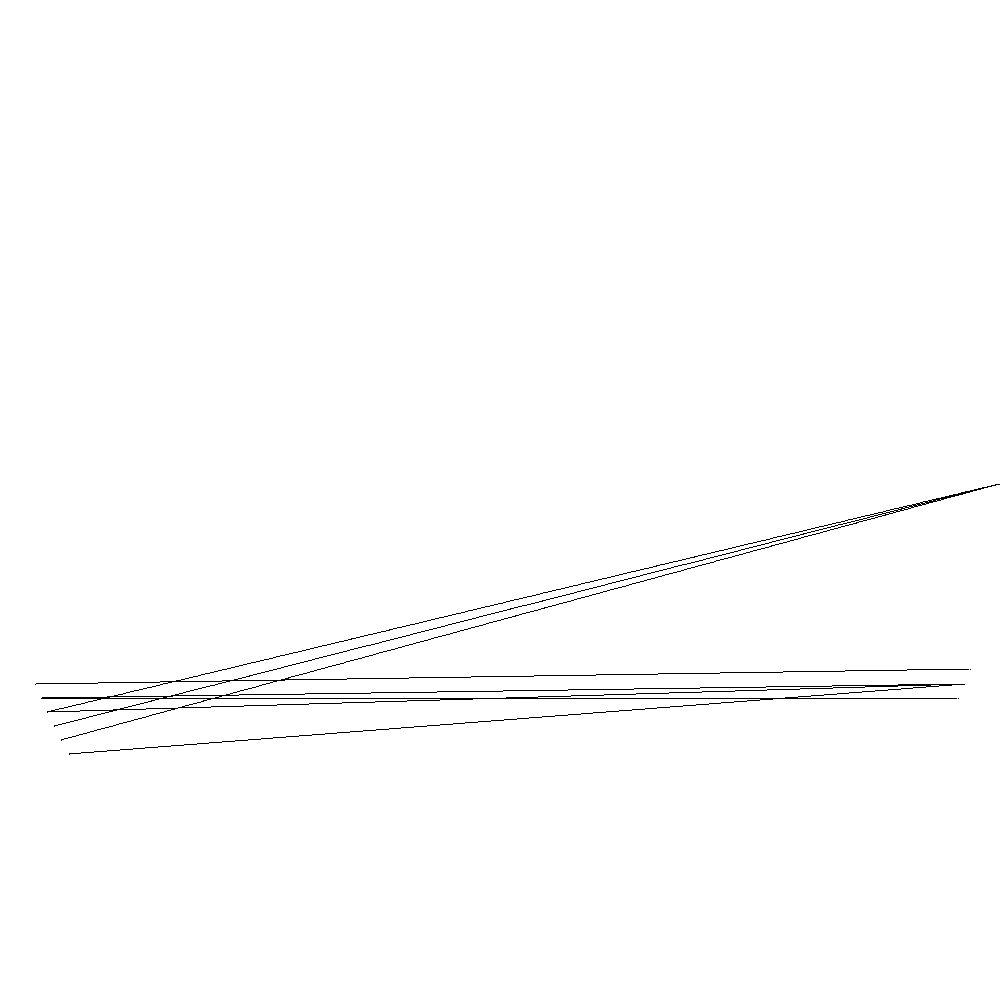

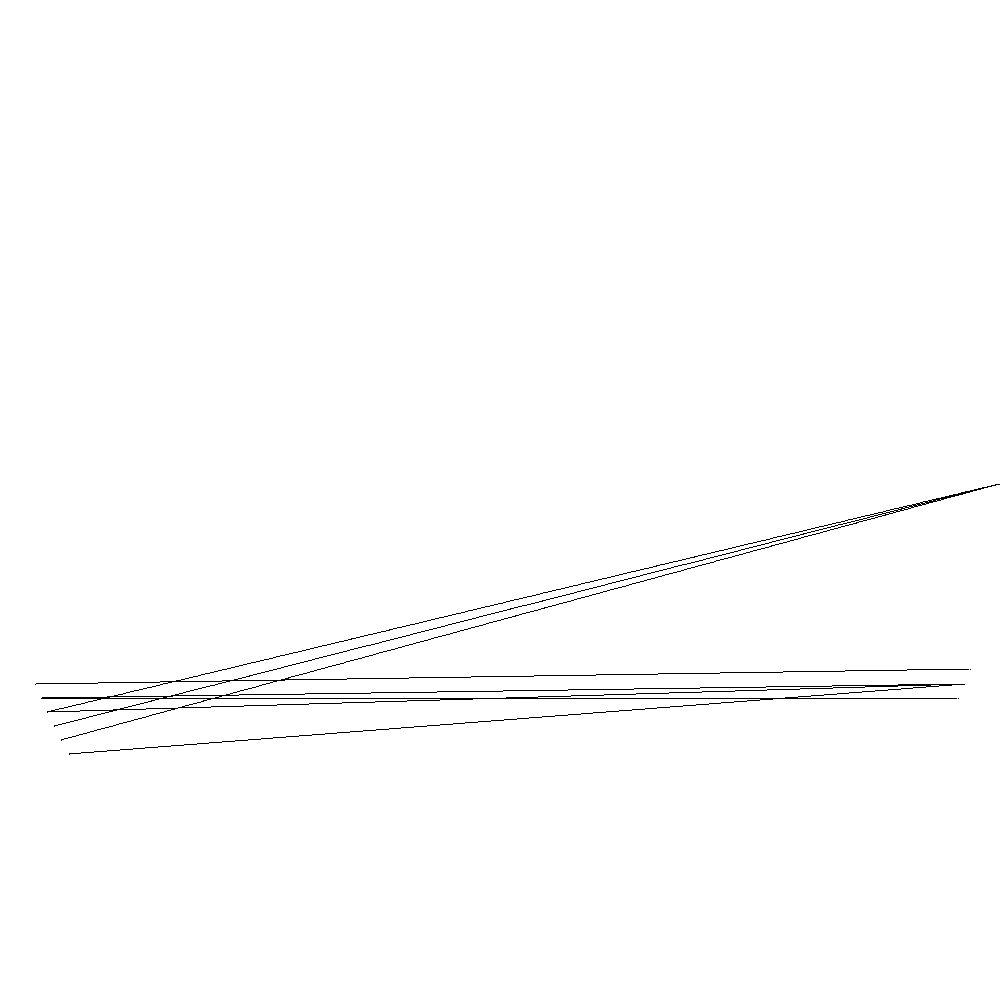

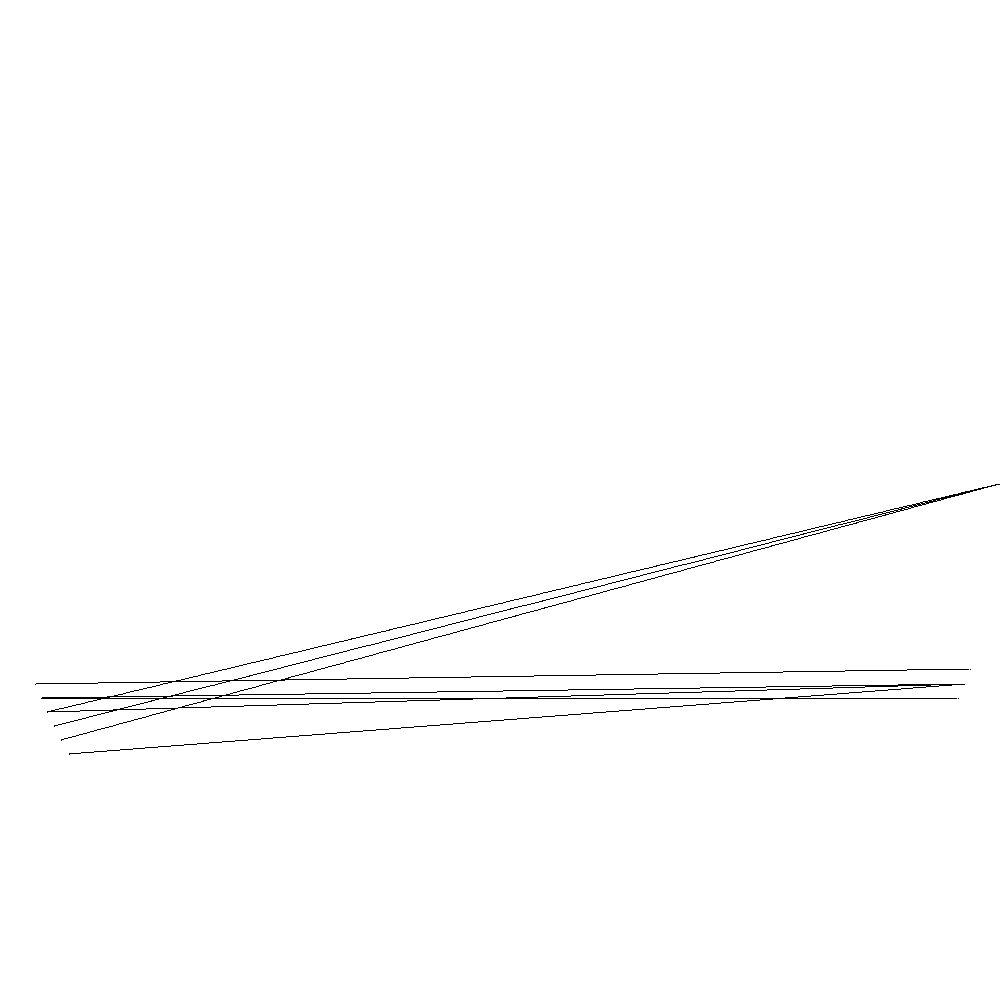

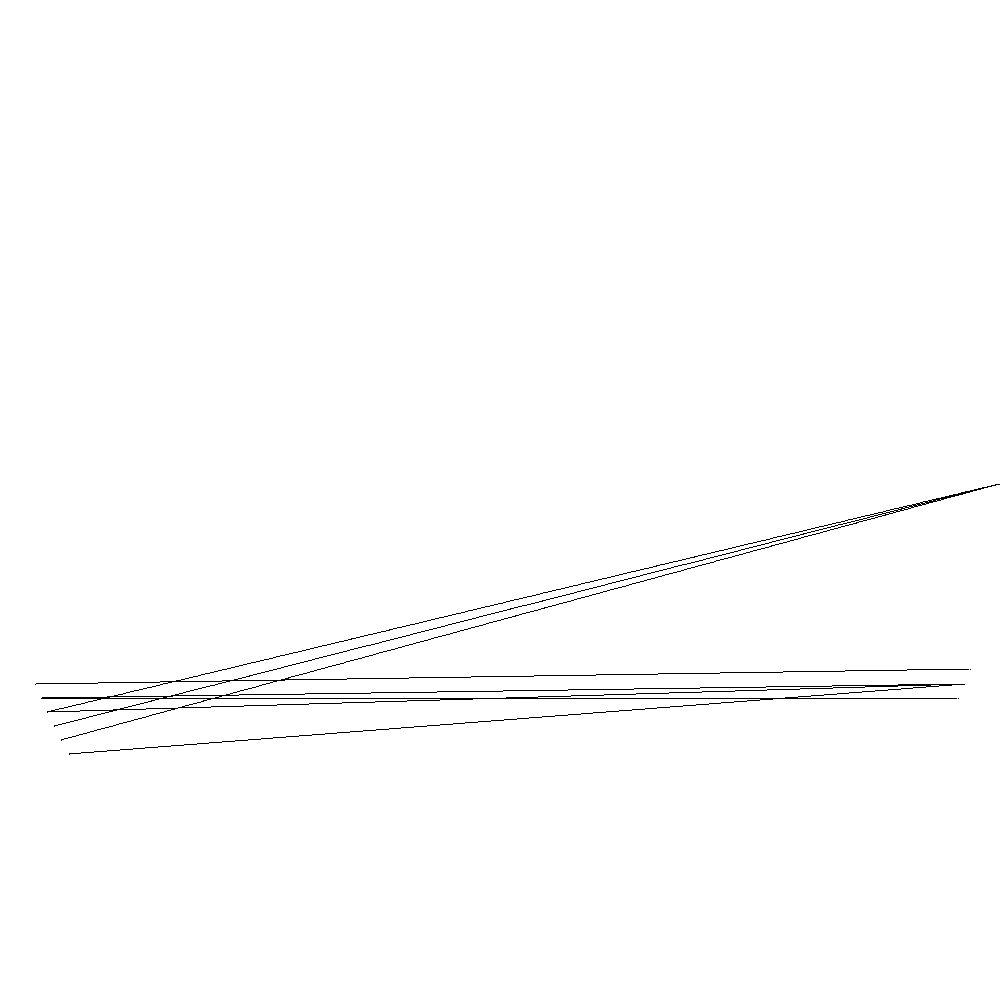

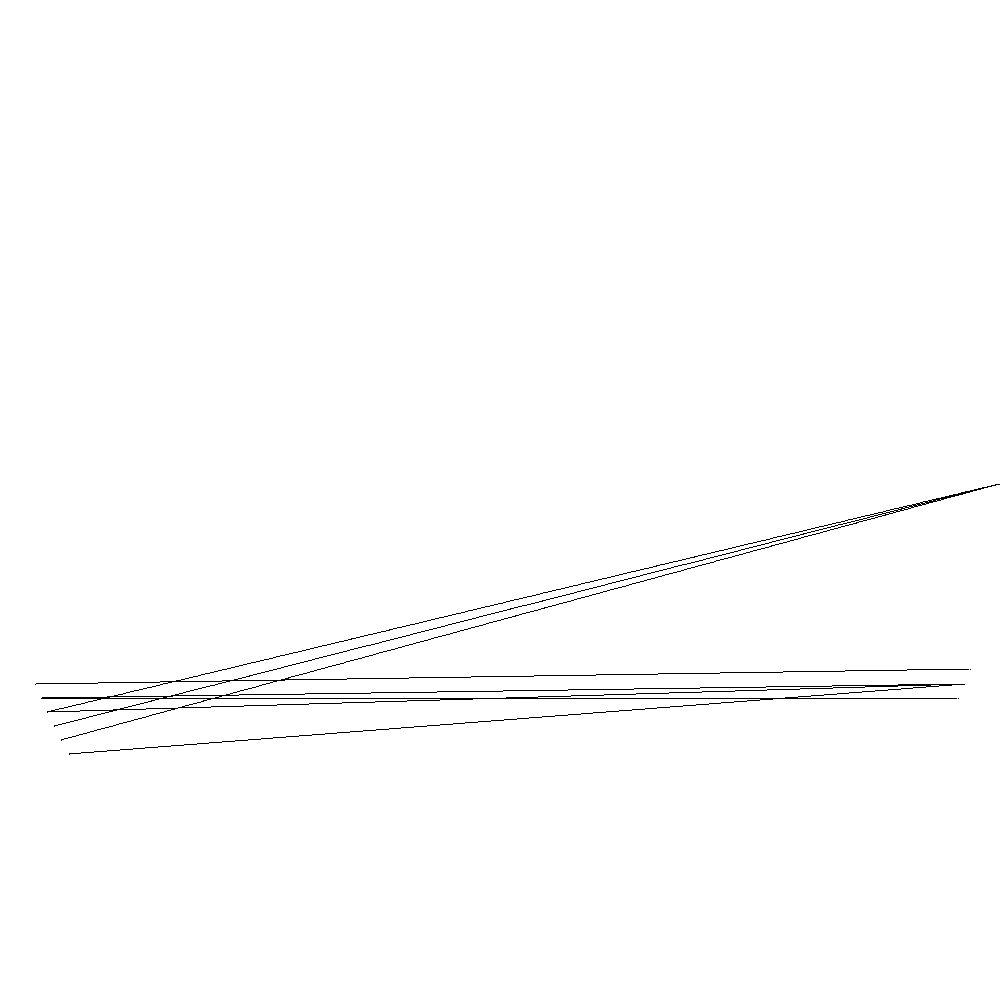

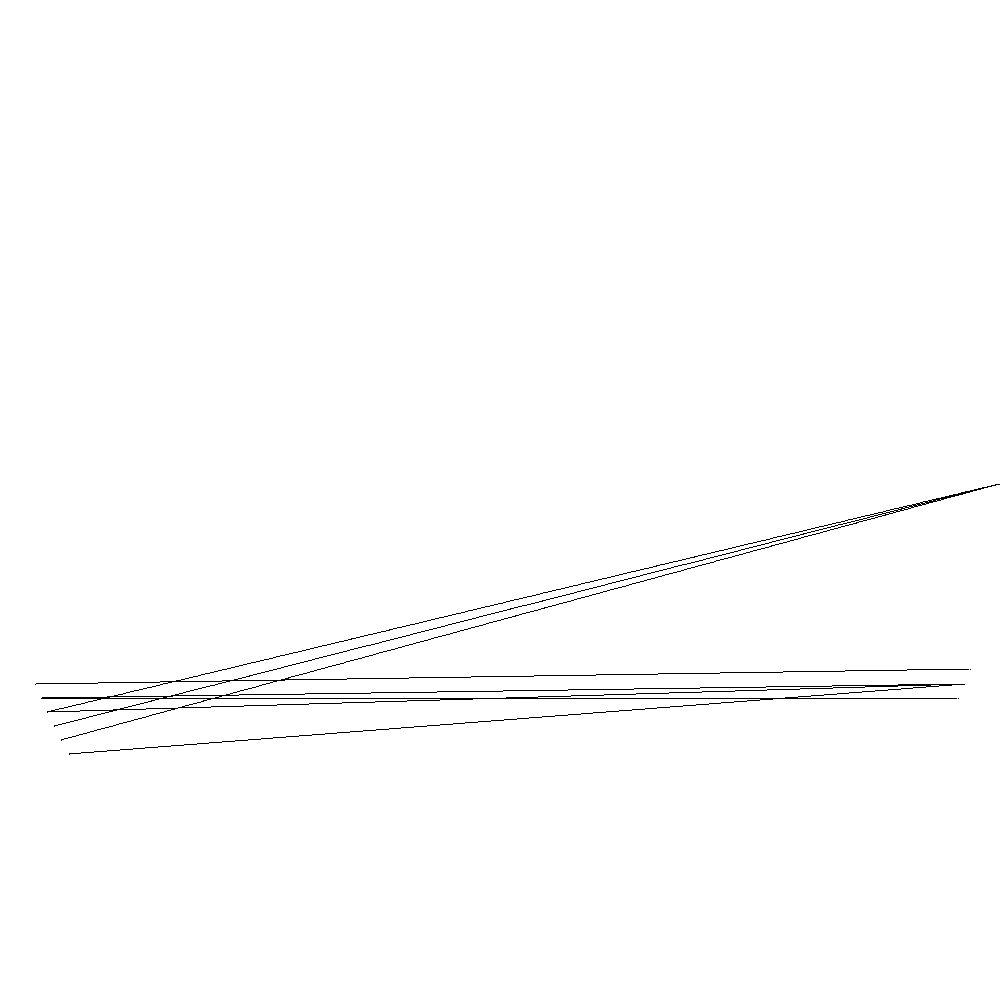

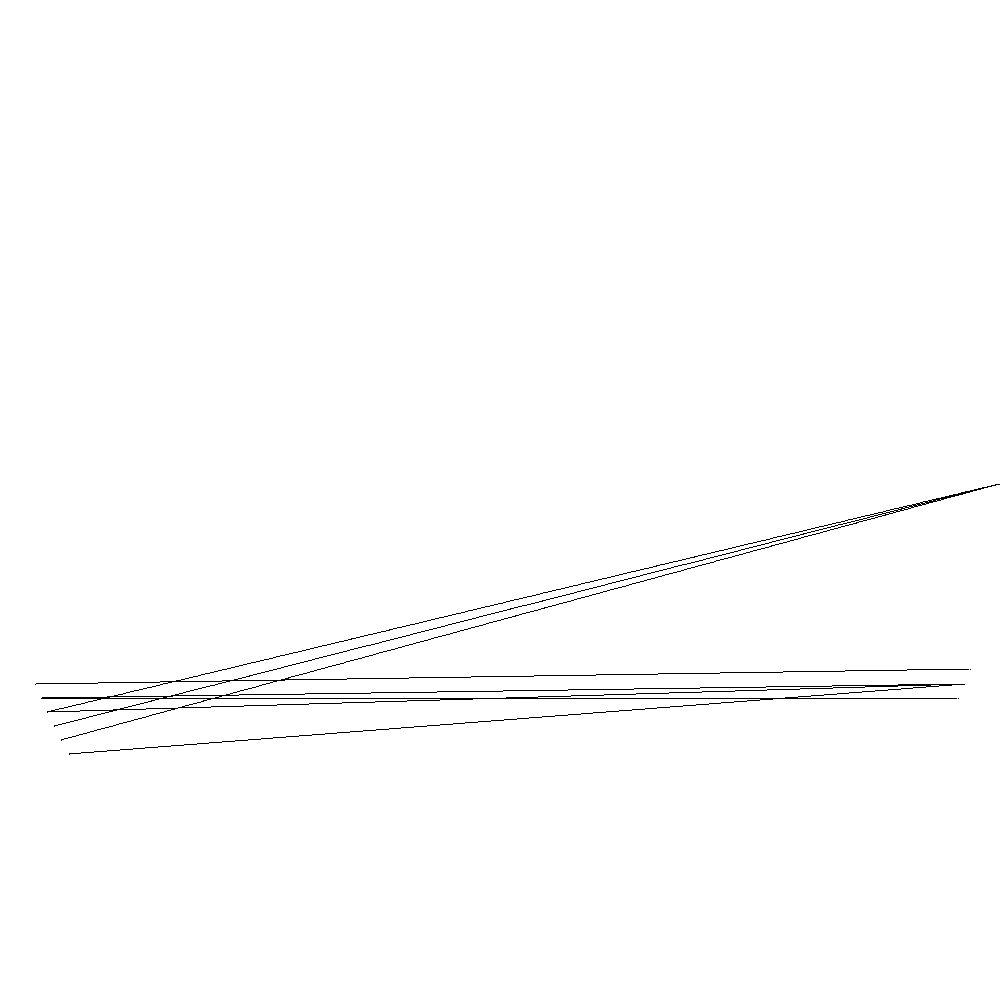

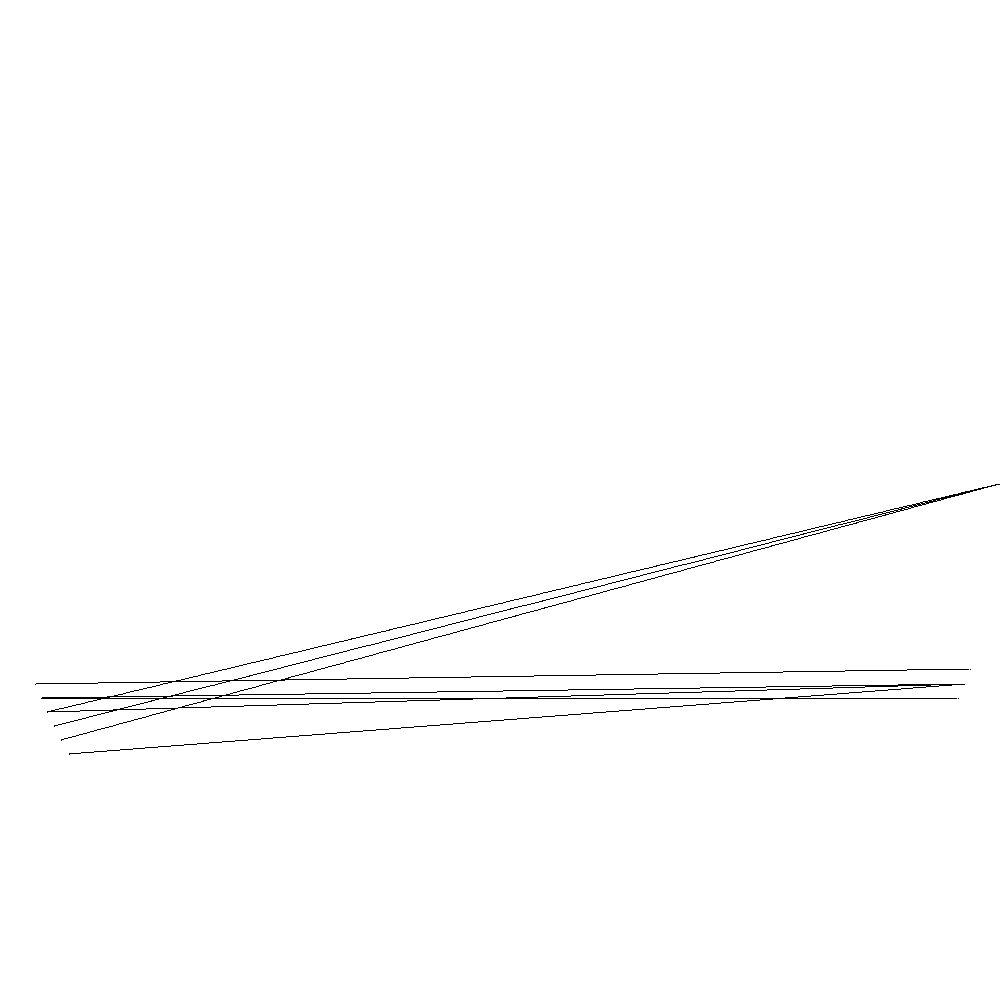

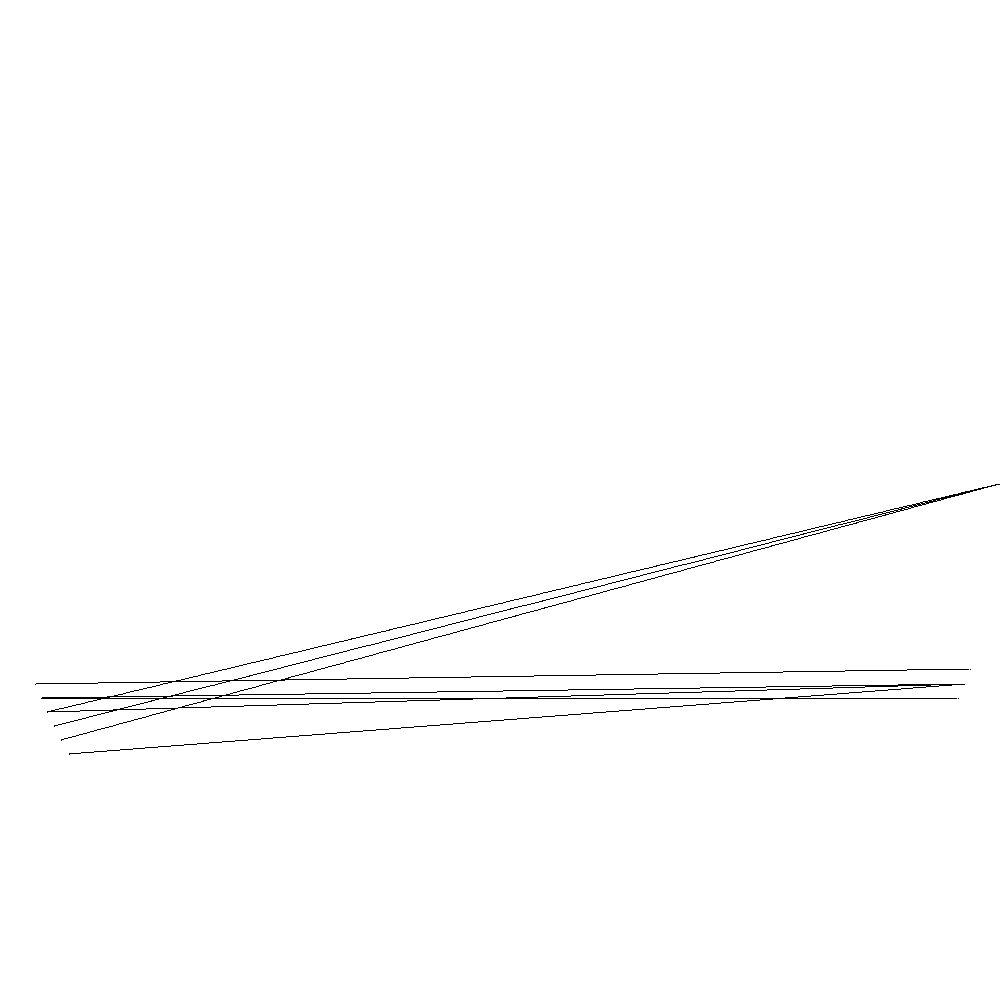

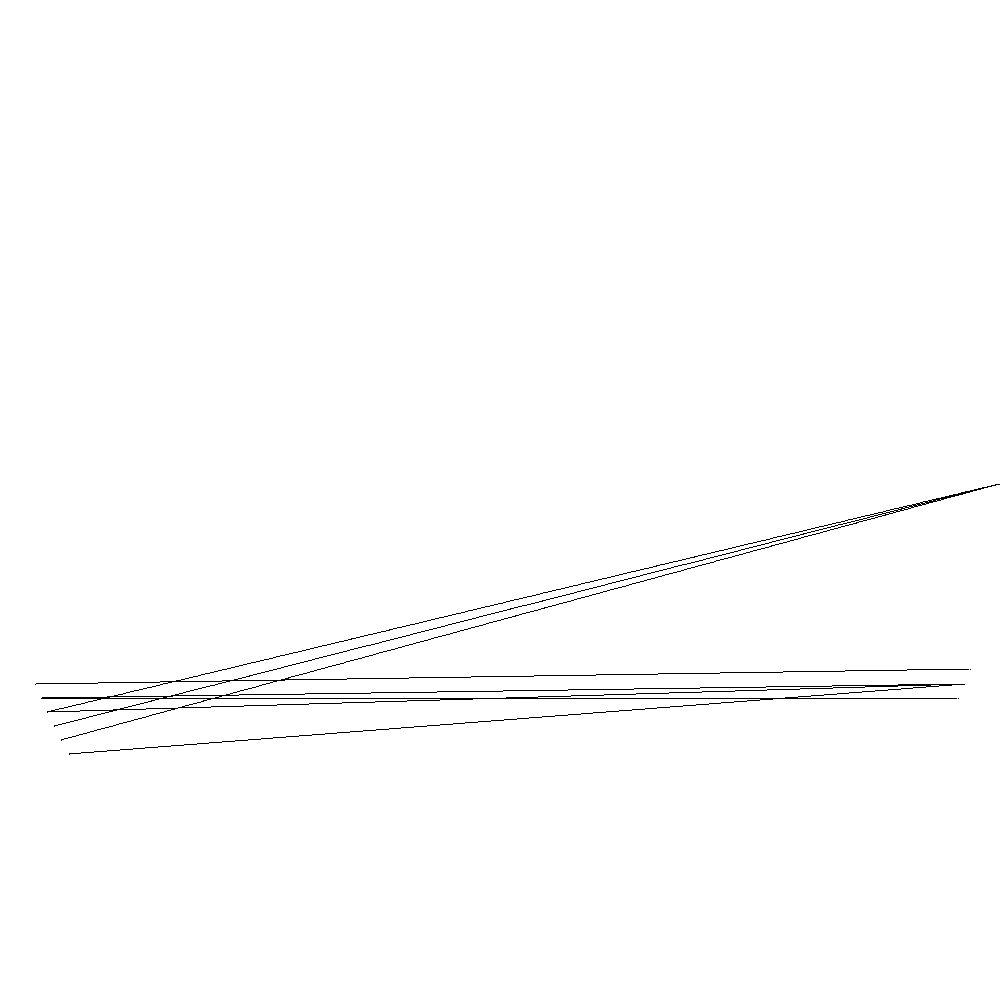

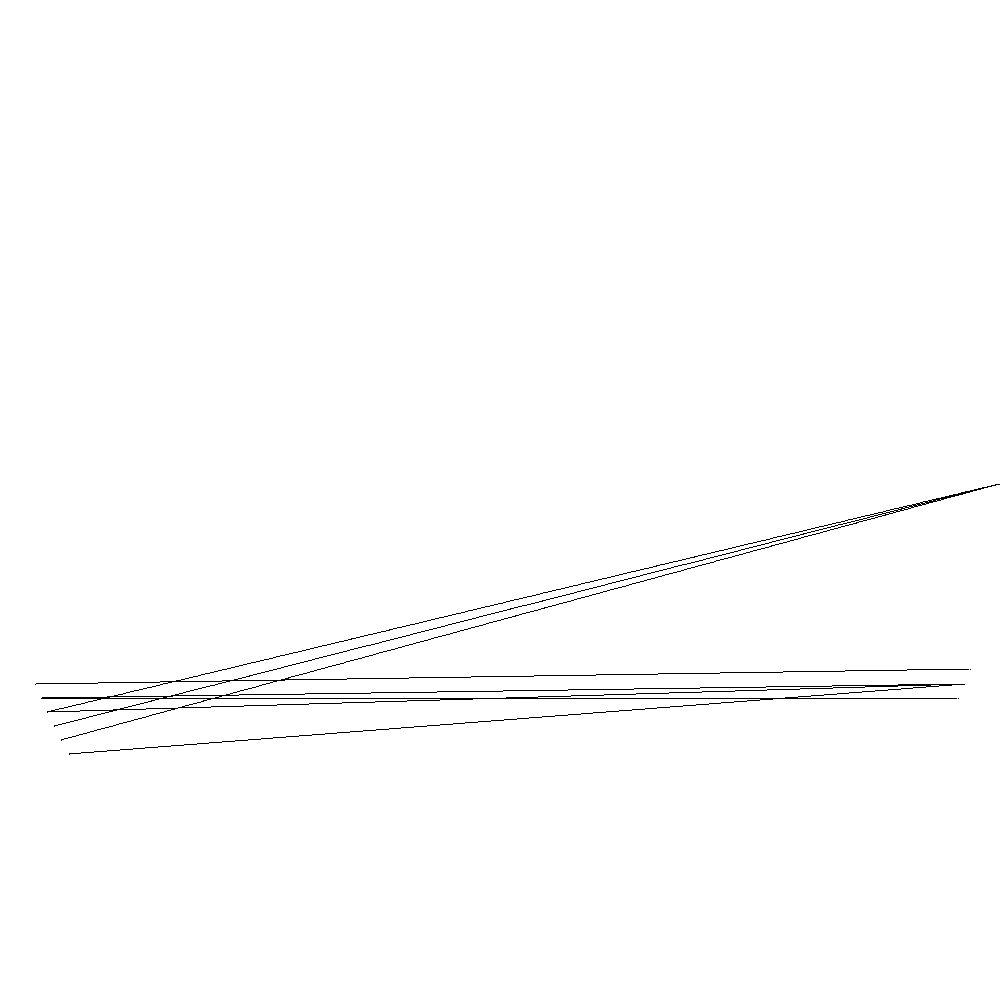

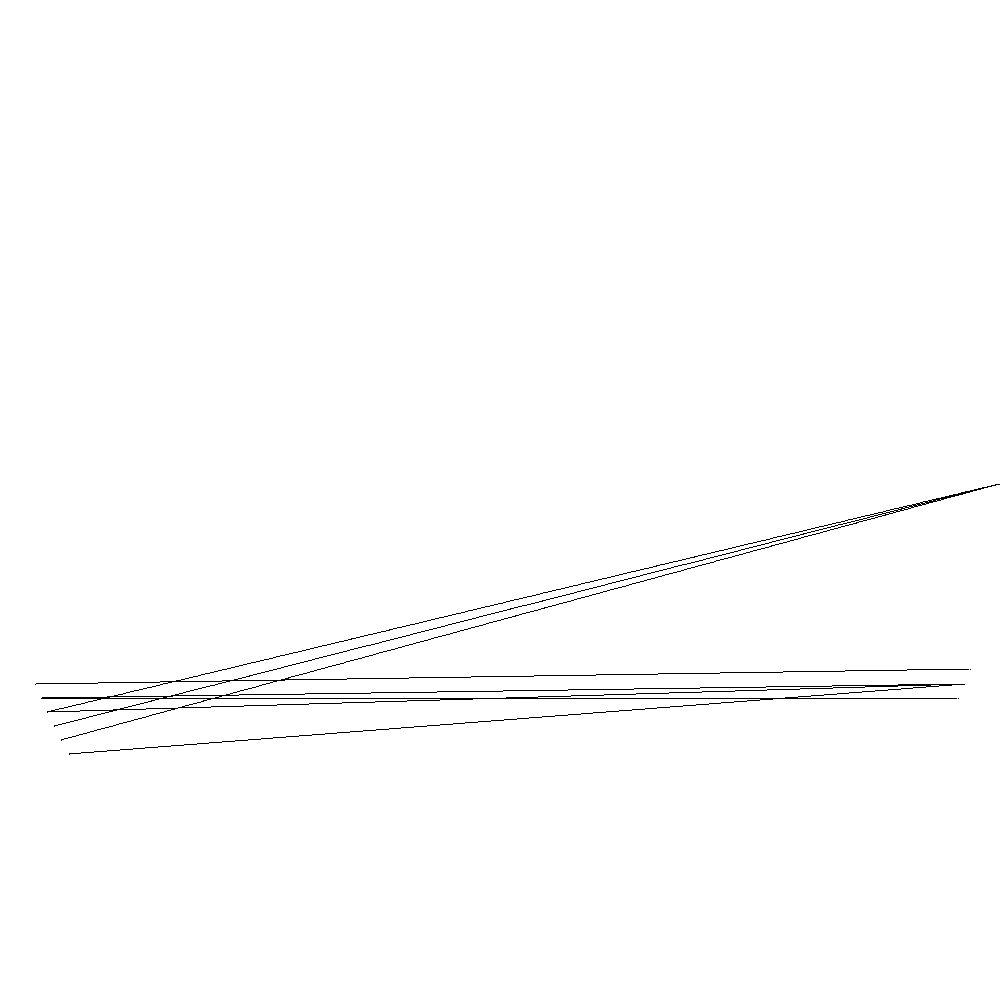

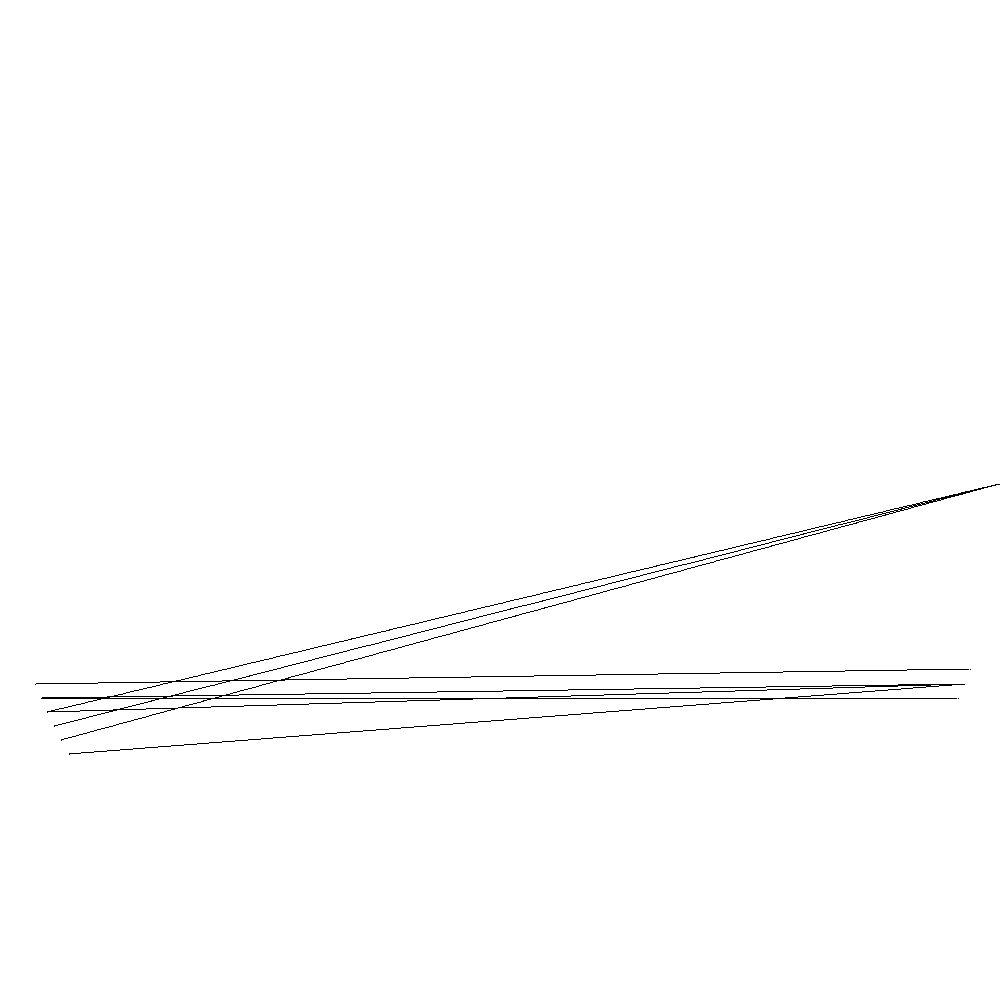

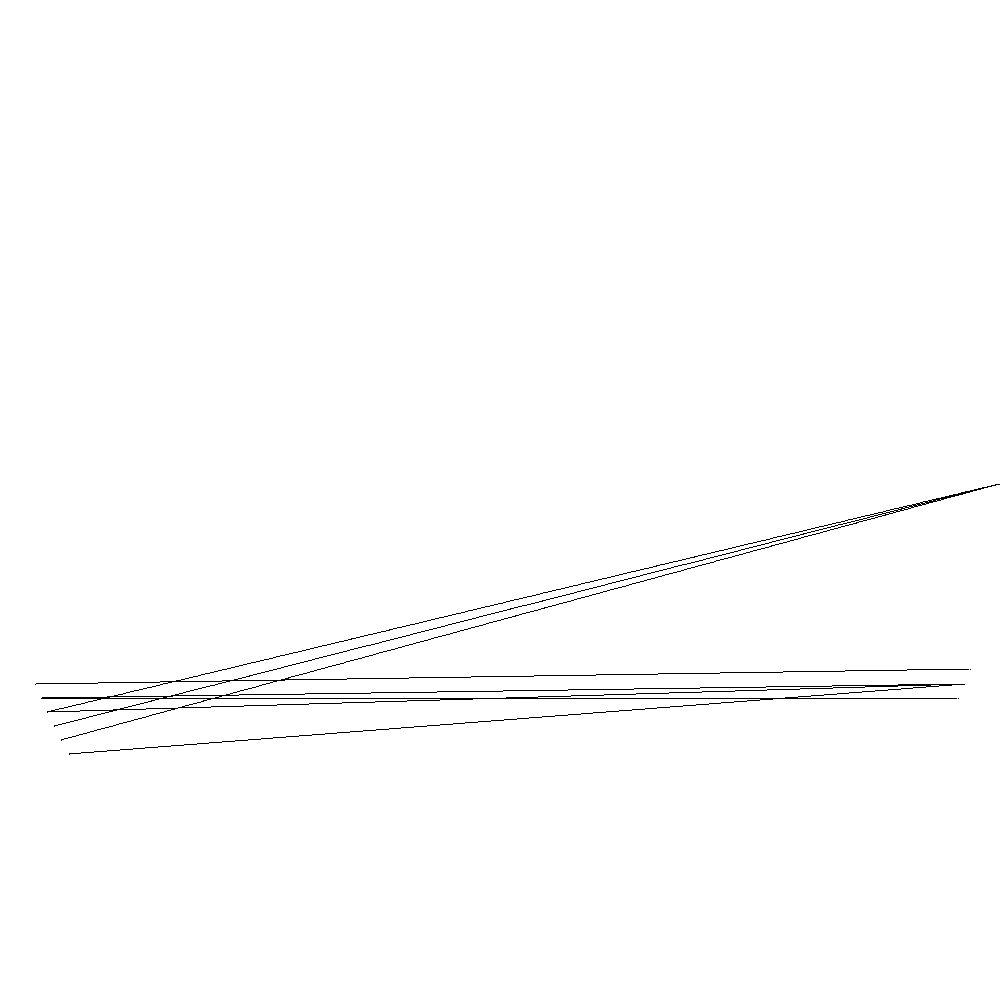

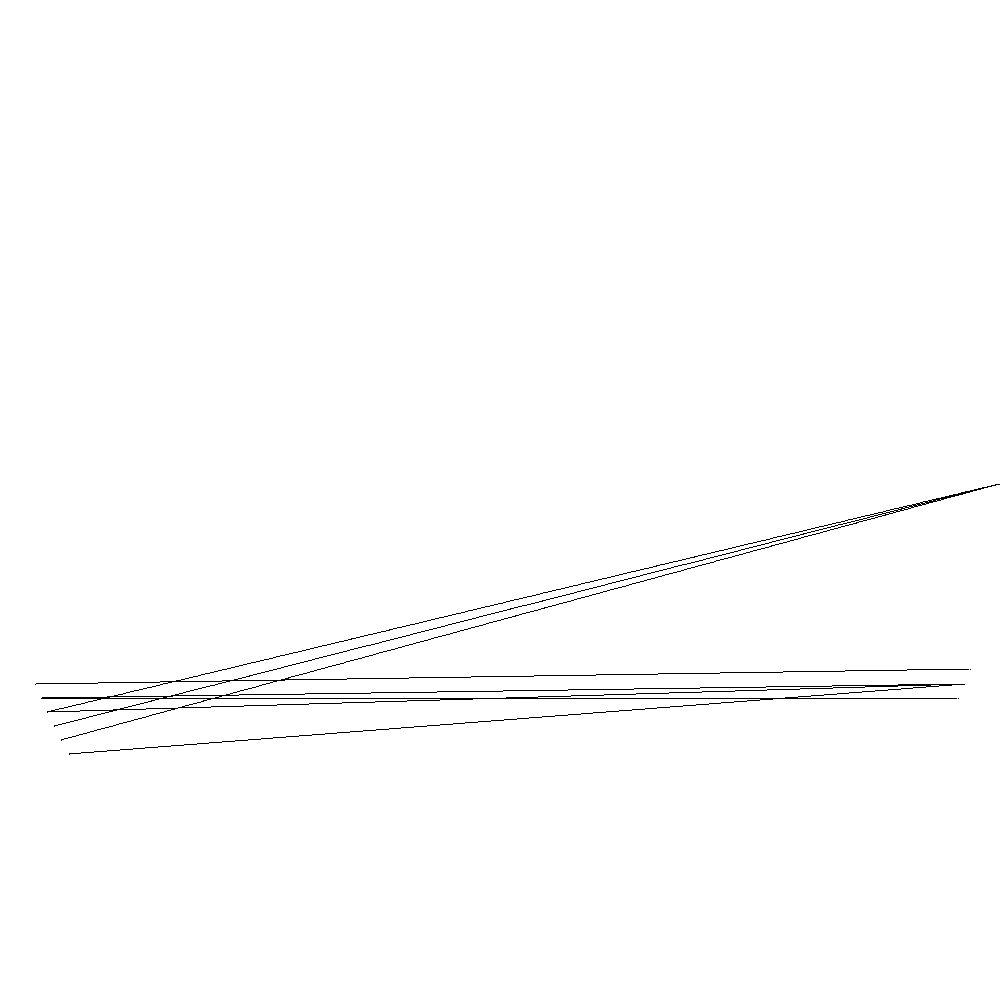

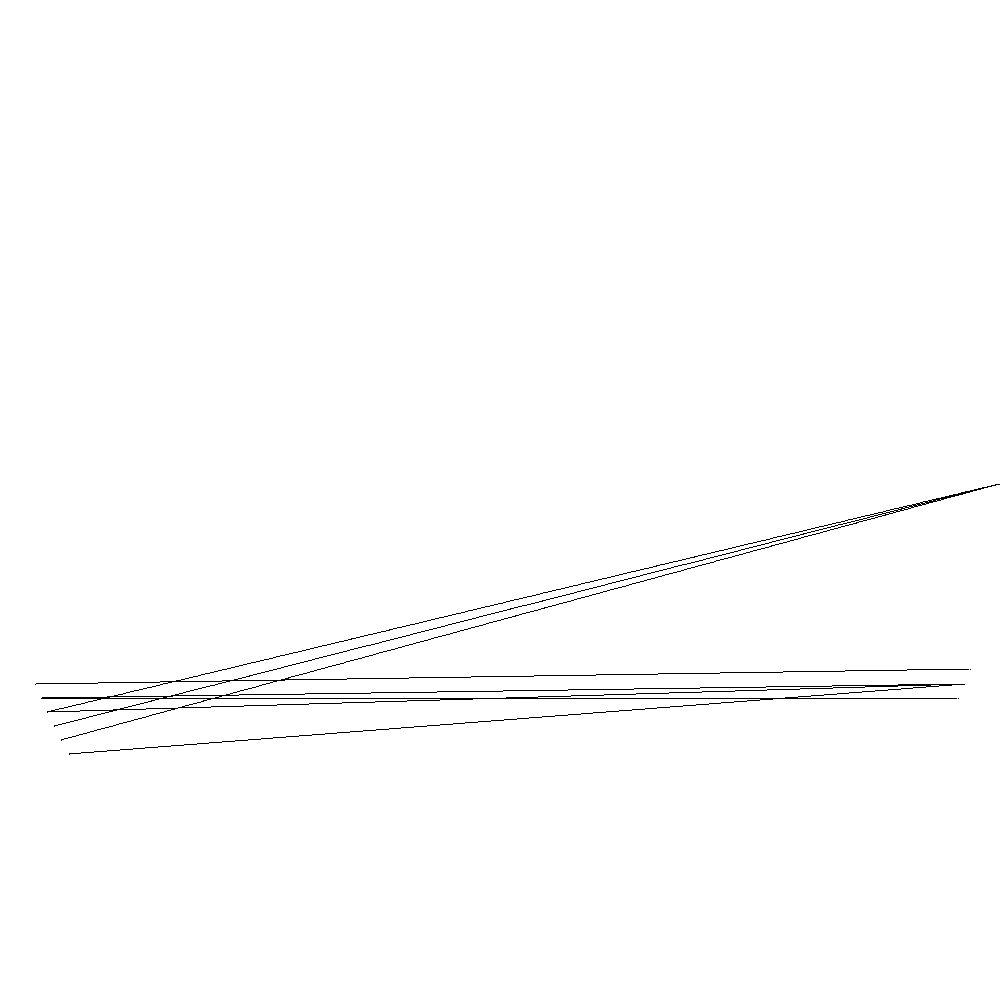

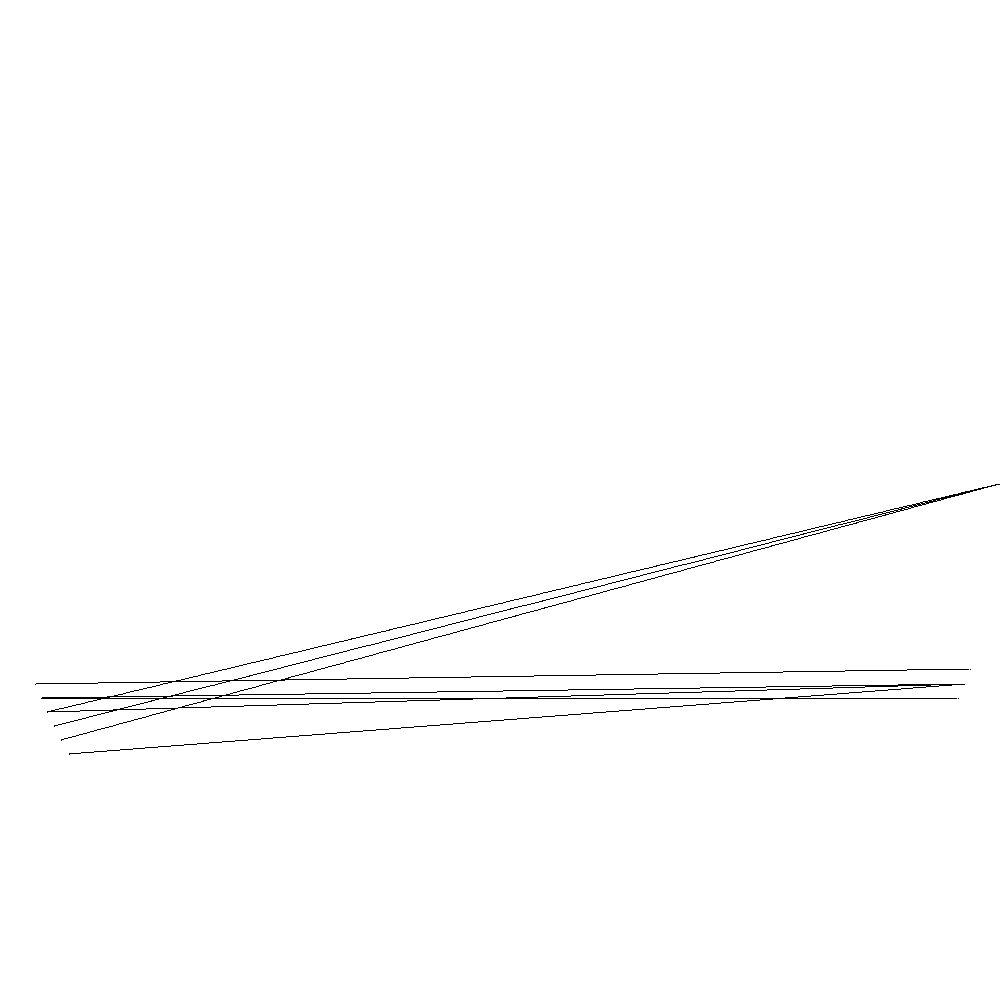

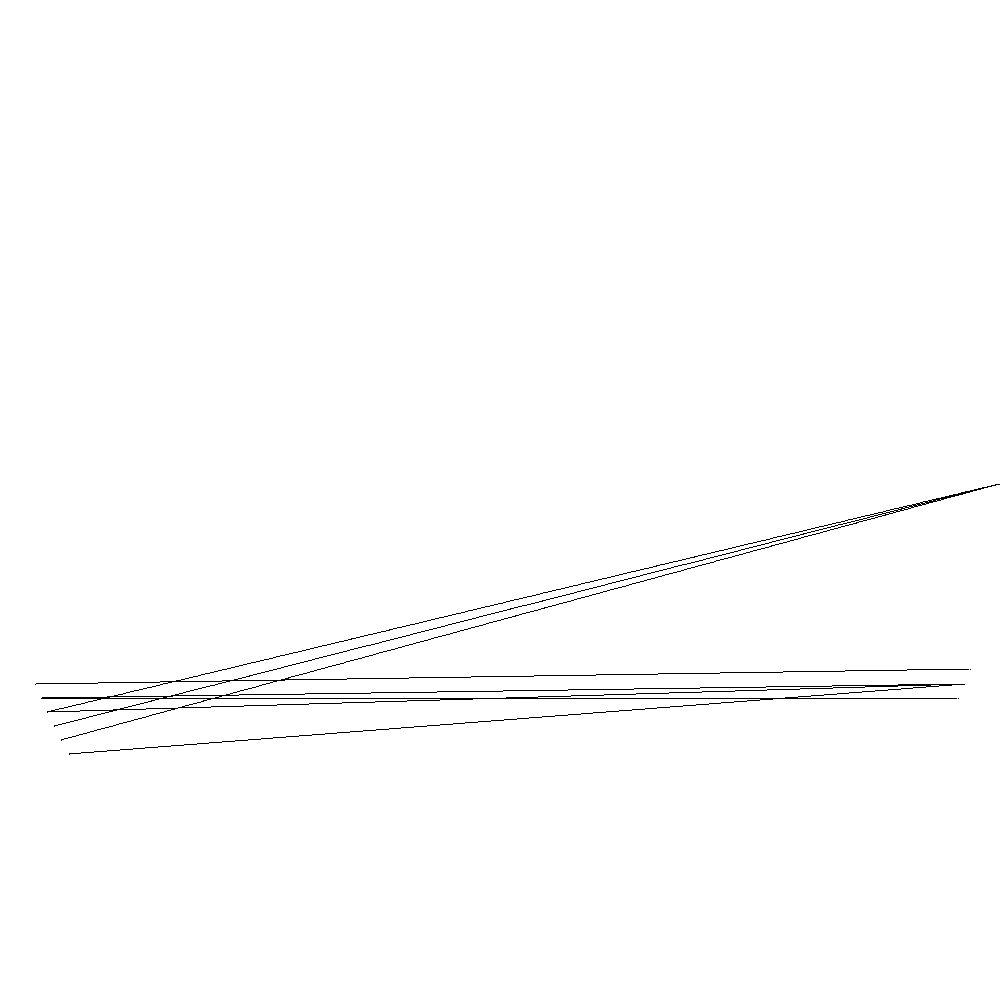

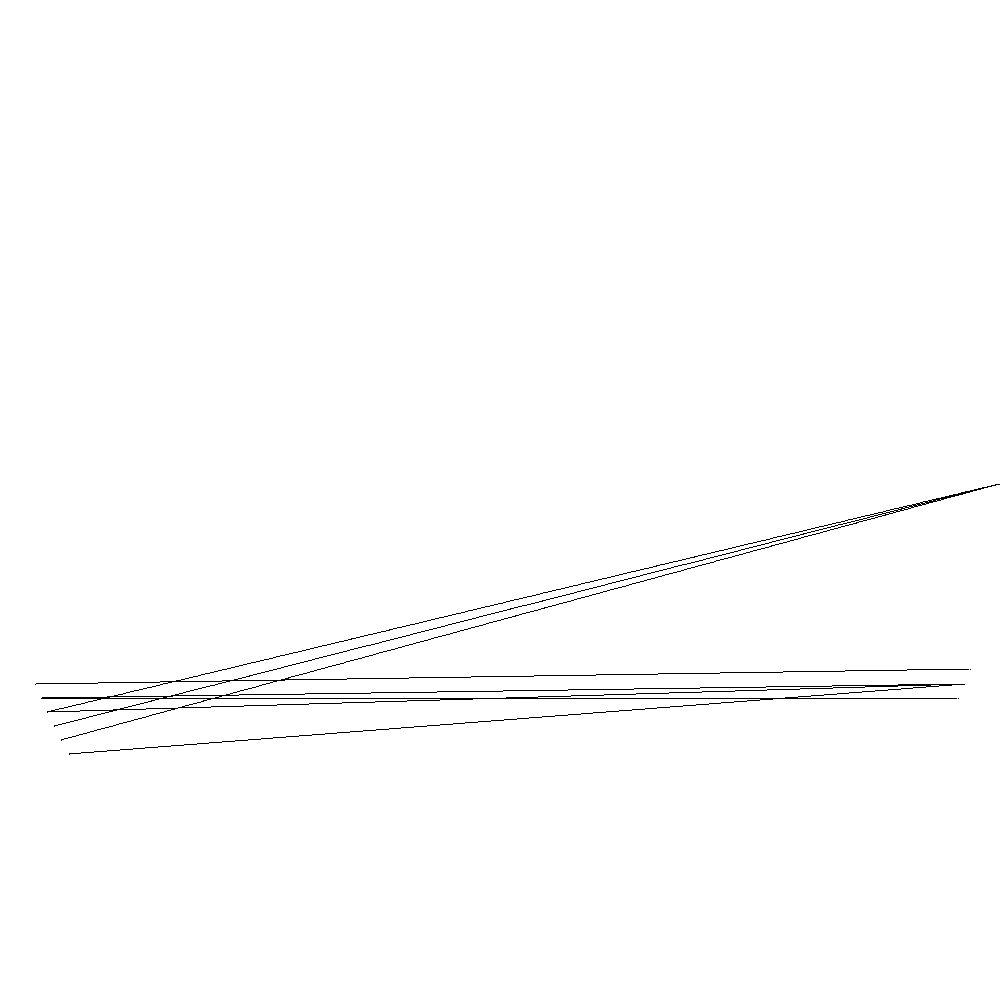

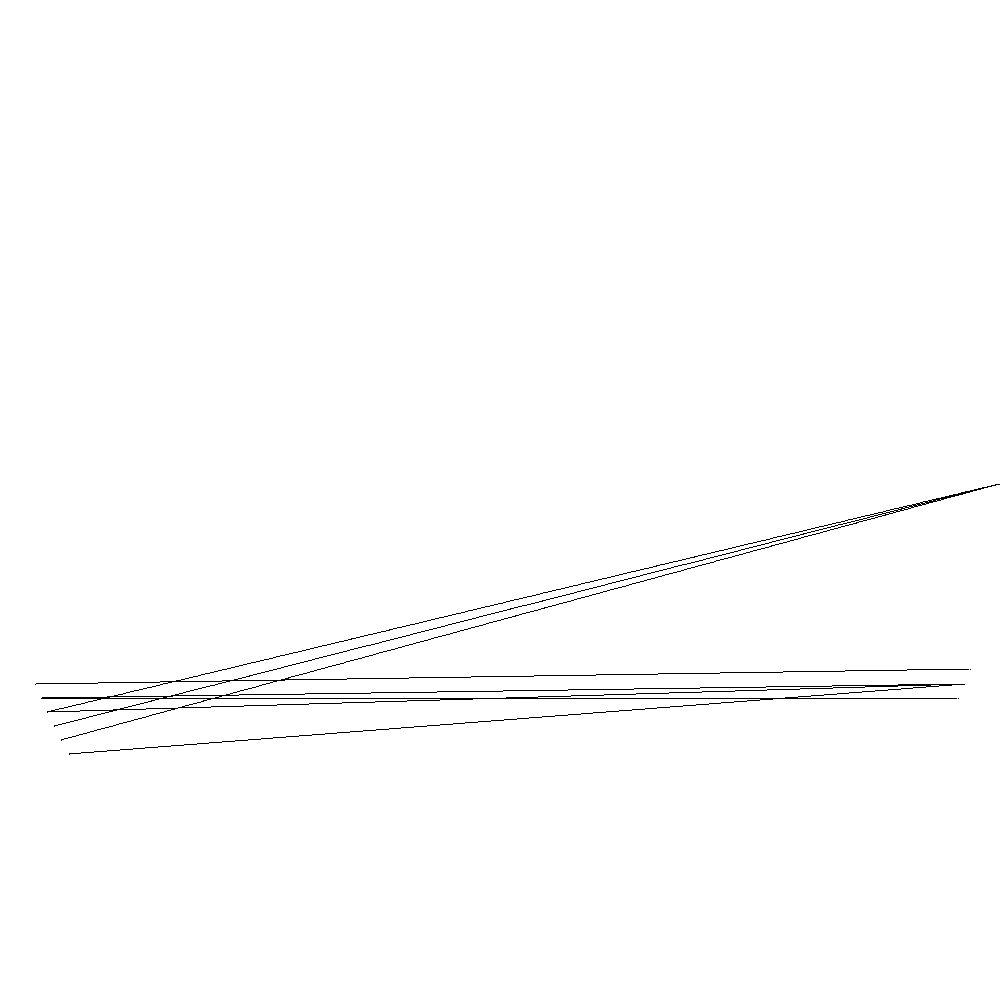

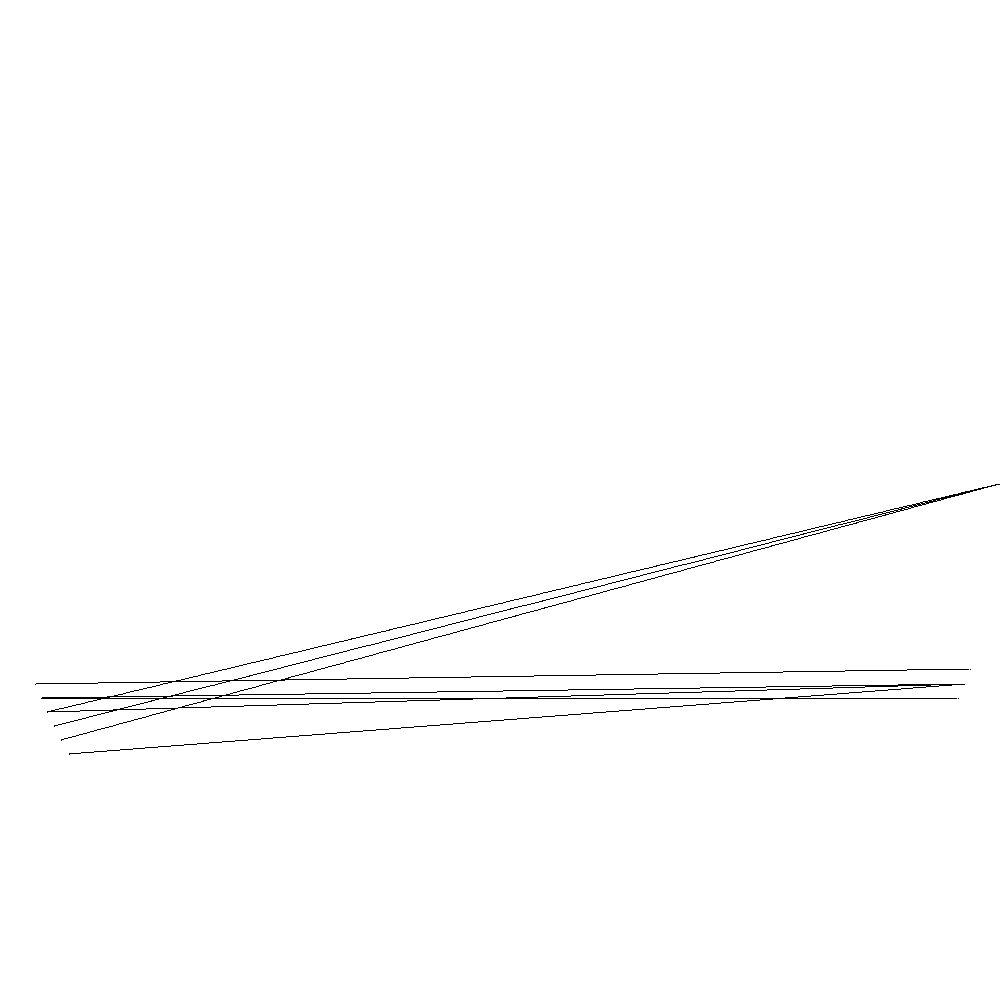

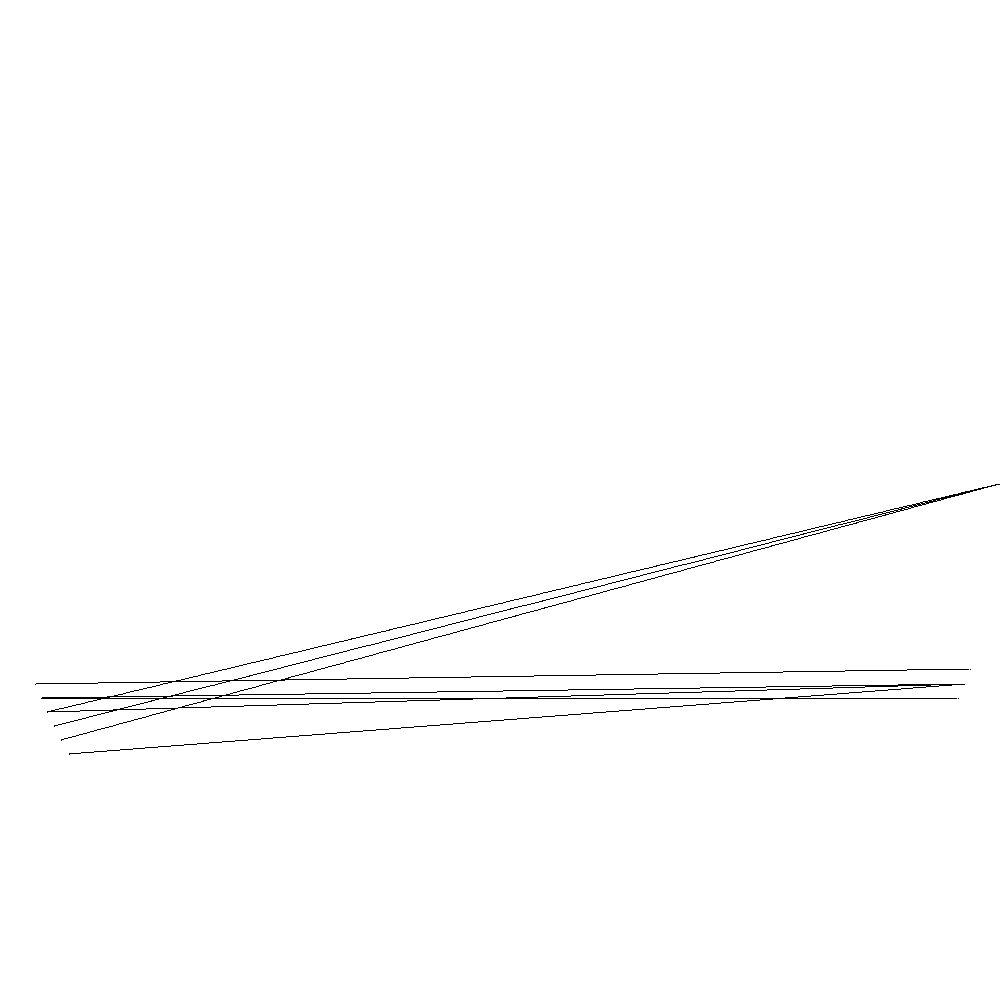

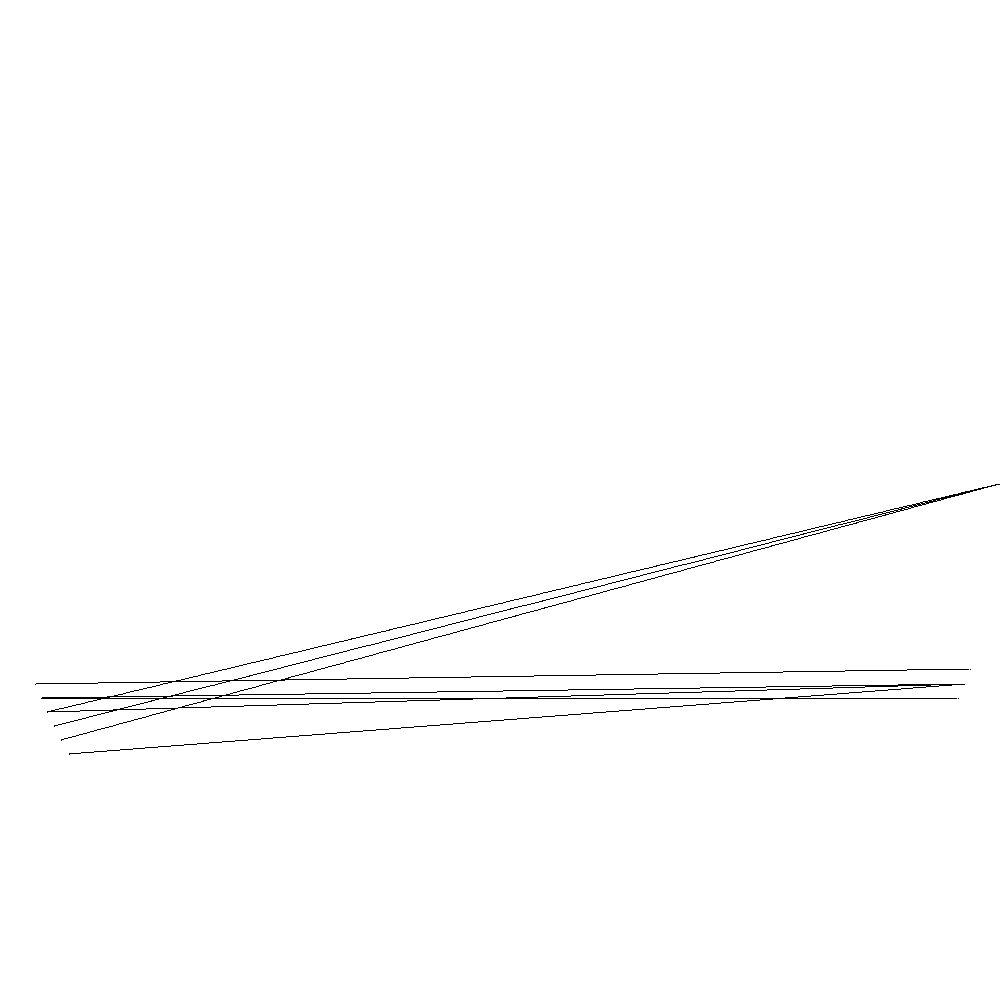

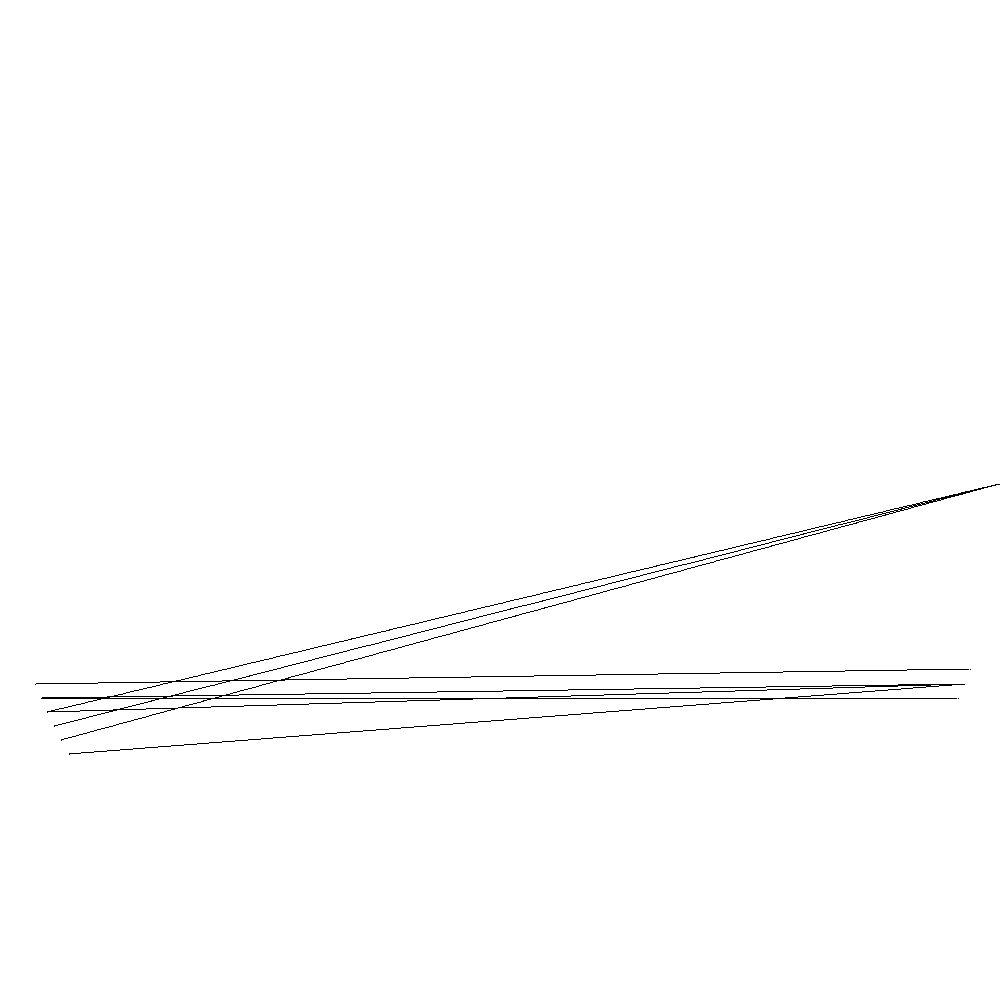

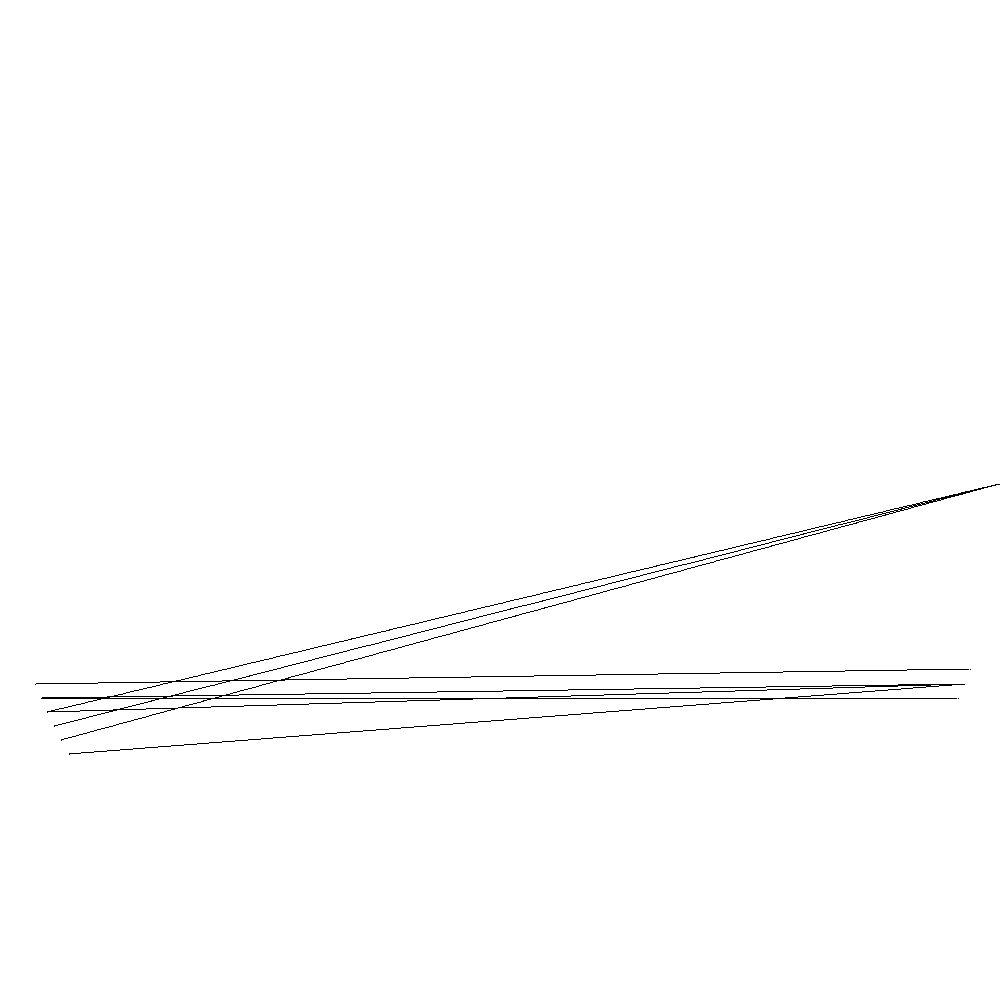

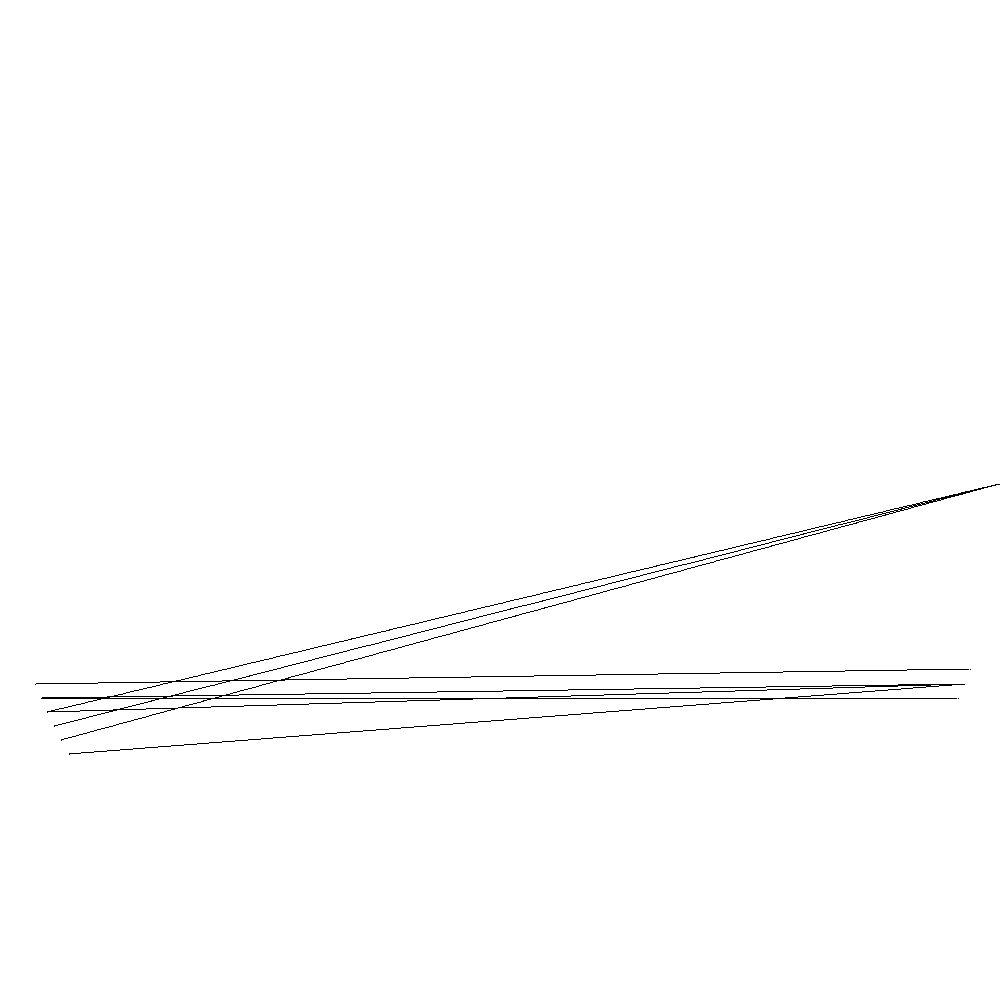

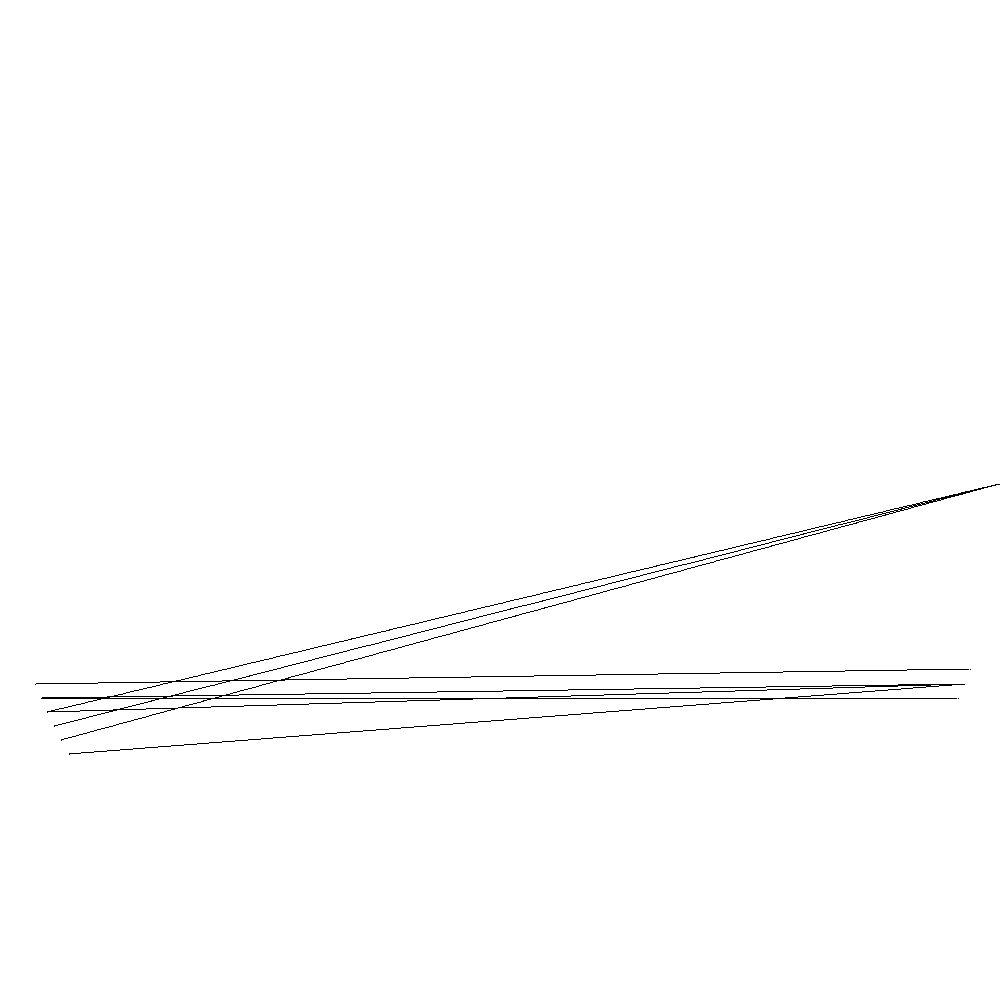

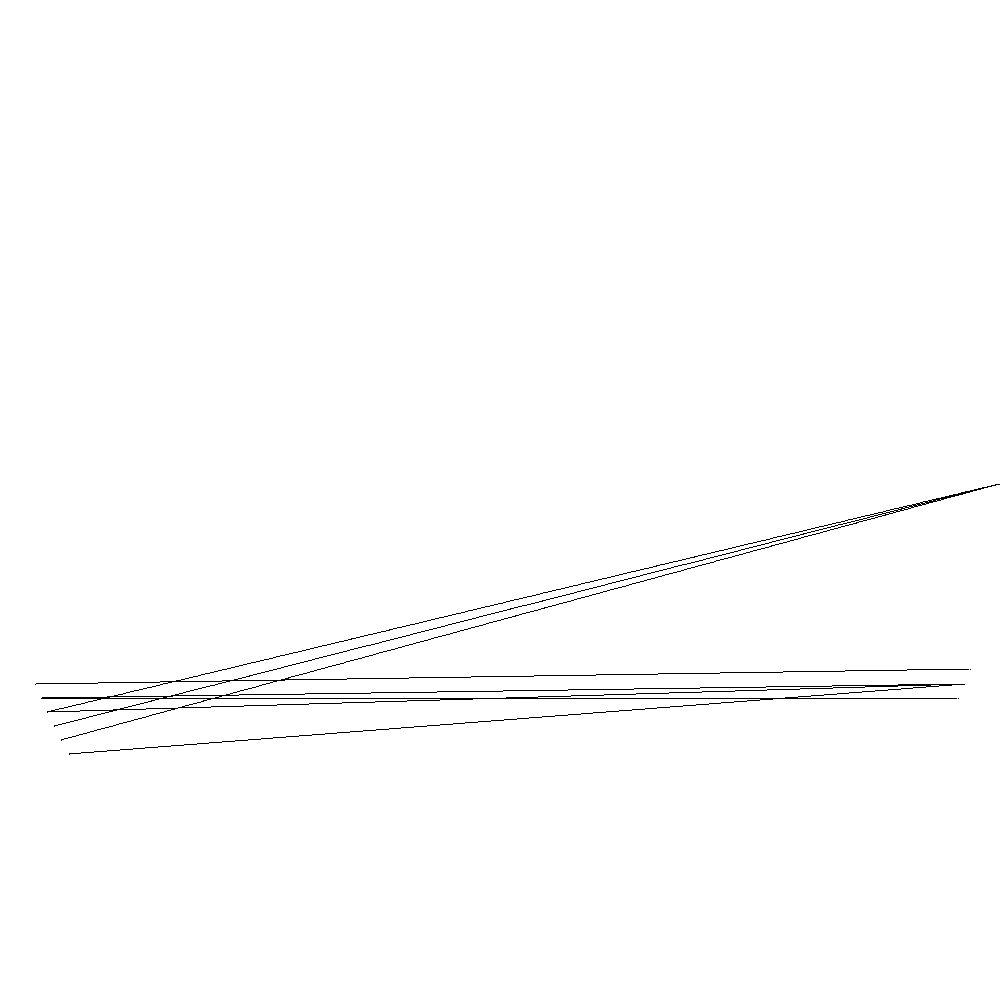

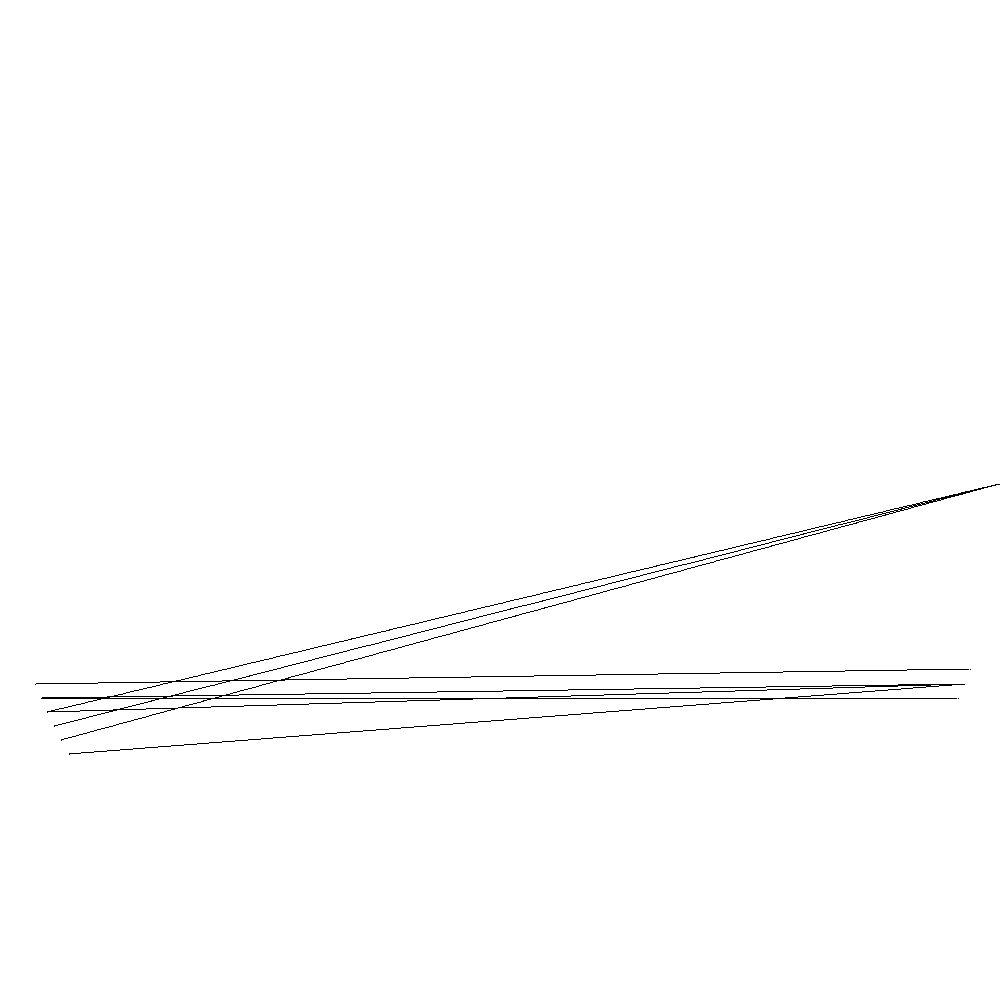

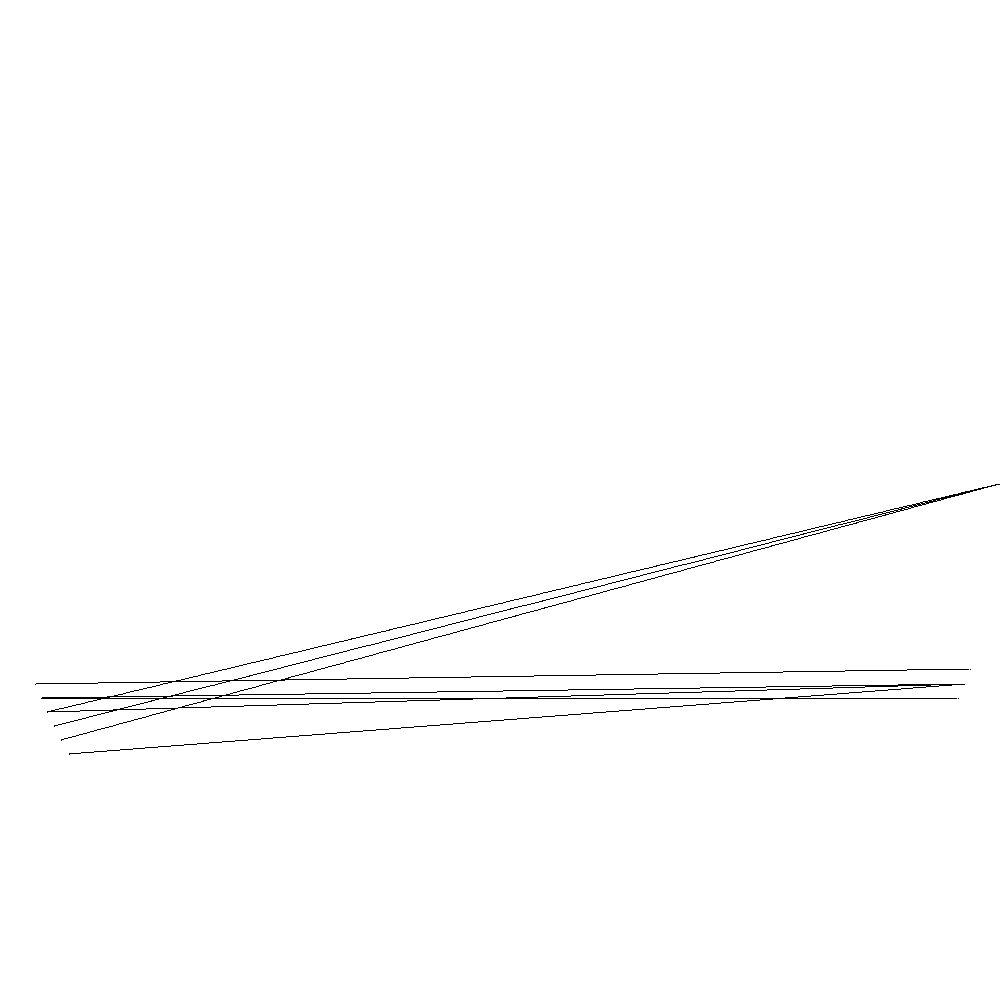

In [15]:
# Loop over lines until stopping criteria is reached
for line in range(numLines):
    i += 1
    bestLine = 0
    oldCoord = coords[oldPin]

    # Loop over possible lines
    for index in range(1, numPins):
        pin = (oldPin + index) % numPins

        coord = coords[pin]

        xLine, yLine = linePixels(oldCoord, coord)

        # Fitness function
        lineSum = np.sum(imgMasked[yLine, xLine])

        if (lineSum > bestLine) and not(pin in previousPins):
            bestLine = lineSum
            bestPin = pin

    # Update previous pins
    if len(previousPins) >= minLoop:
        previousPins.pop(0)
    previousPins.append(bestPin)

    # Subtract new line from image
    lineMask = lineMask * 0
    cv2.line(lineMask, oldCoord, coords[bestPin], lineWeight, lineWidth)
    imgMasked = np.subtract(imgMasked, lineMask)

    # Save line to results
    lines.append((oldPin, bestPin))

    # plot results
    xLine, yLine = linePixels(coords[bestPin], coord)
    imgResult[yLine, xLine] = 0
    cv2_imshow(imgResult)
    cv2.waitKey(1)

    # Break if no lines possible
    if bestPin == oldPin:
        break

    # Prepare for next loop
    oldPin = bestPin

In [16]:
# Wait for user and save before exit
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('./threaded.png', imgResult)

svg_output = open('threaded.svg','wb')
header="""<?xml version="1.0" standalone="no"?>
<svg width="%i" height="%i" version="1.1" xmlns="http://www.w3.org/2000/svg">
""" % (width, height)
footer="</svg>"
svg_output.write(header.encode('utf8'))
pather = lambda d : '<path d="%s" stroke="black" stroke-width="0.5" fill="none" />\n' % d
pathstrings=[]
pathstrings.append("M" + "%i %i" % coords[lines[0][0]] + " ")
for l in lines:
    nn = coords[l[1]]
    pathstrings.append("L" + "%i %i" % nn + " ")
pathstrings.append("Z")
d = "".join(pathstrings)
svg_output.write(pather(d).encode('utf8'))
svg_output.write(footer.encode('utf8'))
svg_output.close()

csv_output = open('threaded.csv','wb')
csv_output.write("x1,y1,x2,y2\n".encode('utf8'))
csver = lambda c1,c2 : "%i,%i" % c1 + "," + "%i,%i" % c2 + "\n"
for l in lines:
    csv_output.write(csver(coords[l[0]],coords[l[1]]).encode('utf8'))
csv_output.close()